### Cycle GAN
The **Cycle Generative Adversarial Network**, or **Cycle GAN**, is an approach to training a deep convolutional neural network for image-to-image translation tasks.

 **CycleGAN** is a type of **Generative Adversarial Network (GAN)** that can be used for **unpaired image-to-image translation** . It was introduced in 2017 by Jun-Yan Zhu et al. in their paper titled "Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks" 

CycleGAN is a deep learning model that can learn the mapping between two different image domains, such as photographs and sketches, by training a GAN on a dataset ². The model can capture the characteristics of one image domain and figure out how these characteristics could be translated into another image domain, all in the absence of any paired training examples 

The key idea behind CycleGAN is to use **cycle consistency loss** to enable training without the need for paired data. In other words, it can translate from one domain to another without a one-to-one mapping between the source and target domain. This opens up the possibility to do a lot of interesting tasks like photo-enhancement, image colorization, style transfer, etc.




In [1]:
!pip install tensorflow-addons

## import libraries

In [2]:
from os import listdir
import numpy as np
from numpy import savez_compressed
import os
from os import listdir
import cv2
from numpy import asarray, vstack, savez_compressed
from numpy.random import randint
from glob import glob
from random import random
from tqdm import tqdm
import tensorflow as tf
import tensorflow.image as tfi
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import layers
from keras.layers import ReLU, Input,Conv2D,Dropout,LeakyReLU, Activation, Concatenate, Conv2DTranspose
from keras.models import load_model,Model ,Sequential
from tensorflow_addons.layers import InstanceNormalization
from keras.initializers import RandomNormal
from keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Load images

In [3]:
#Resizing all the images to 64*64 pixels and storing in compressed Numpy array.
def load_images(path, size=(64, 64), max_images=None):
    data_list = []
    for filename in listdir(path):
        if filename.endswith(('.jpg', '.jpeg', '.png')):  # Filter for specific image file extensions
            pixels = load_img(path + filename, target_size=size)
            pixels = img_to_array(pixels)
            data_list.append(pixels)
            if max_images and len(data_list) >= max_images:
                break
    return np.asarray(data_list)

celeb_path = '../input/celeba-dataset/img_align_celeba/img_align_celeba/'
cartoon_path = '../input/cartoonset10k/cartoonset10k/'

dataA = load_images(celeb_path, max_images=1000)
print('loaded dataA', dataA.shape)

dataB = load_images(cartoon_path, max_images=1000)
print('loaded dataB', dataB.shape)
filename = 'celebrity2cartoon.npz'
np.savez_compressed(filename, dataA=dataA, dataB=dataB)

print('Saved dataset:', filename)


loaded dataA (1000, 64, 64, 3)
loaded dataB (1000, 64, 64, 3)
Saved dataset: celebrity2cartoon.npz


## Plotting images of Celebrity and Cartoon

Loaded data: (1000, 64, 64, 3) (1000, 64, 64, 3)


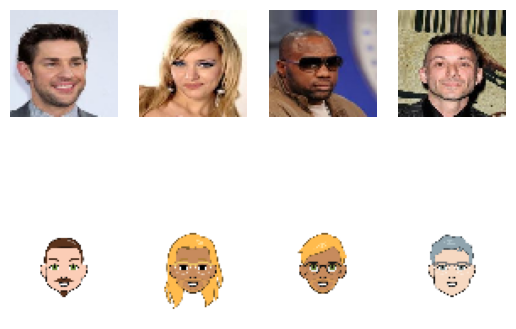

In [4]:
from numpy import load
data = load('celebrity2cartoon.npz')
daraA, dataB = data['dataA'], data['dataB']
print('Loaded data:', dataA.shape, dataB.shape)
n_samples = 4
# plot original image
for i in range (n_samples):
    plt.subplot(2 , n_samples,1+i )
    plt.axis('off')
    plt.imshow(dataA[i].astype('uint8'))
# plot target image
for i in range (n_samples):
    plt.subplot(2 , n_samples,1+n_samples+i )
    plt.axis('off')
    plt.imshow(dataB[i].astype('uint8'))
plt.show()


Unlike other models, the CycleGAN discriminator uses InstanceNormalization instead of BatchNormalization. It is a very simple type of normalization and involves standardizing (e.g. scaling to a standard Gaussian) the values on each output feature map, rather than across features in a batch, -1 because ensure that features are normalized per feature map.

## Defining discriminator model

The model takes 64*64 sized image as input and outputs a patch of predictions i.e. real (1) or fake (0) for generated images, optimized using Least squared loss (L2) and weighting it to used so that updates to model have half(0.5) the usual effect.

In [5]:
#define the discriminator model
def define_discriminator(image_shape):
    #weight initialization
    init = RandomNormal(stddev = 0.02)
    #source image input
    input_image = Input(shape = image_shape)
    #c64 
    x = Conv2D(64,(4,4), strides = 2 , padding = 'same', kernel_initializer = init)(input_image)
    x = LeakyReLU(alpha = 0.2)(x)
    #c128 
    x = Conv2D(128,(4,4), strides = 2 , padding = 'same', kernel_initializer = init)(x)
    x = InstanceNormalization(axis = -1)(x)
    x = LeakyReLU(alpha = 0.2)(x)
    #c256
    x = Conv2D(256,(4,4), strides = 2 , padding = 'same', kernel_initializer = init)(x)
    x = InstanceNormalization(axis = -1)(x)
    x = LeakyReLU(alpha = 0.2)(x)
    #c512
    x = Conv2D(512,(4,4), strides = 2 , padding = 'same', kernel_initializer = init)(x)
    x = InstanceNormalization(axis = -1)(x)
    x = LeakyReLU(alpha = 0.2)(x)
    
    x = Conv2D(512,(4,4) , padding = 'same', kernel_initializer = init)(x)
    x = InstanceNormalization(axis = -1)(x)
    x = LeakyReLU(alpha = 0.2)(x)
    
    out_put = Conv2D(1, (4, 4), padding='same', kernel_initializer=init, use_bias=False)(x)

    model = Model(input_image, out_put)
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss_weights=[0.5])

    return model
    
image_shape = (64, 64, 3)
discriminator = define_discriminator(image_shape)
discriminator.summary()

/opt/conda/lib/python3.10/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 instance_normalization (Ins  (None, 16, 16, 128)      256       
 tanceNormalization)                                             
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                             

## Defining generator model

The generator is an encoder- decoder model, where model takes source image (e.g. celebrity photo) and generates a target image (e.g. cartoon photo) by first downsampling or encoding the input image down to a bottleneck layer, then interpreting the encoding with a number of ResNet layers that use skip connections by series of layers that upsample or decode the representation to the size of output image.

So Defining the ResNet block having two 3 X 3 filters and 1 X 1 stride where input to block is concatenated to output of block channel wise.

In [6]:
def resnet_block(filters, layer):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    
    #print(layer.shape)  # print the shape of the previous layer
    
    x = Conv2D(filters, (3,3), padding='same', kernel_initializer=init)(layer)
    x = InstanceNormalization(axis=-1)(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, (3,3), padding='same', kernel_initializer=init)(x)
    x = InstanceNormalization(axis=-1)(x)
    
    # skip connection
    x = Concatenate()([x, layer])
    return x
    

In [7]:
def downsample(filters, layer, size=3, strides=2, activation=None, index=None, norm=True):
    x = Conv2D(filters, kernel_size=size, strides=strides, padding ='same', kernel_initializer='he_normal', use_bias=False)(layer)
    x = InstanceNormalization(axis=-1)(x)    
    x = LeakyReLU()(x)
    return x

the model outputs pixel values with the shape as the input and pixel values are in the range [-1, 1], typical for GAN generator models.

In [8]:
# define the generator model
def define_generator(image_shape, n_resnet=9):
    #weight initialization
    init = RandomNormal(stddev = 0.02)
    #source image input
    input_image = Input(shape = image_shape)
    #c64 
    x = Conv2D(64,(7,7) , padding = 'same', kernel_initializer = init)(input_image)
    x = InstanceNormalization(axis = -1)(x)
    x = Activation('relu')(x)
    #c128 
    x = Conv2D(128,(3,3), strides = 2 , padding = 'same', kernel_initializer = init)(x)
    x = InstanceNormalization(axis = -1)(x)
    x = Activation('relu')(x)
    #c256
    x = Conv2D(256,(3,3), strides = 2 , padding = 'same', kernel_initializer = init)(x)
    x = InstanceNormalization(axis = -1)(x)
    x = Activation('relu')(x)
    
    for i in range(n_resnet):
        x = resnet_block(256 , x)
        
    # Add Conv2DTranspose layers to upscale the image to the desired shape
    x = Conv2DTranspose(128, (3, 3), strides=2, padding='same', kernel_initializer=init)(x)
    x = InstanceNormalization(axis=-1)(x)
    x = Activation('relu')(x)
    
    x = Conv2DTranspose(64, (3, 3), strides=2, padding='same', kernel_initializer=init)(x)
    x = InstanceNormalization(axis=-1)(x)
    x = Activation('relu')(x)
    
    x = Conv2D(3, (7, 7), padding='same', kernel_initializer=init)(x)
    x = InstanceNormalization(axis=-1)(x)
    out_image = Activation('tanh')(x)

    model = Model(input_image, out_image)
    return model
image_shape = (64, 64, 3)
generator = define_generator(image_shape)
generator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_6 (Conv2D)              (None, 64, 64, 64)   9472        ['input_2[0][0]']                
                                                                                                  
 instance_normalization_4 (Inst  (None, 64, 64, 64)  128         ['conv2d_6[0][0]']               
 anceNormalization)                                                                               
                                                                                                  
 activation (Activation)        (None, 64, 64, 64)   0           ['instance_normalization_4[

The generator models are trained via their related discriminator models. Specifically, they are updated to minimize the loss predicted by the discriminator for generated images marked as “real“, called adversarial loss. As such, they are encouraged to generate images that better fit into the target domain.

The generator models are also updated based on how effective they are at the regeneration of a source image when used with the other generator model, called cycle loss. Finally, a generator model is expected to output an image without translation when provided an example from the target domain, called identity loss.

Altogether, each generator model is optimized via the combination of four outputs with four loss functions:

- Adversarial loss (L2 or mean squared error).
- Identity loss (L1 or mean absolute error).
- Forward cycle loss (L1 or mean absolute error).
- Backward cycle loss (L1 or mean absolute error).
This is done in below function which takes input as generator models (g_model_1) and (g_model_2) and discriminator model (d_model) and we are mainly focus on updating first generator model hence other 2 inputs are kept false for trainable.

To summarize, a composite model has two inputs for the real photos from Domain-A and Domain-B, and four outputs for the discriminator output, identity generated image, forward cycle generated image, and backward cycle generated image.

## Defining Composite model

In [9]:
from keras.layers import Lambda, Reshape

def define_composite_model(g_model_1, d_model, g_model_2, image_shape):
    g_model_1.trainable = True
    d_model.trainable = False
    g_model_2.trainable = False
    
    # Input for generated images
    input_gen = Input(shape=image_shape)
    
    # Resize generated images to the shape expected by the discriminator
    resized_gen = Lambda(lambda x: tf.image.resize(x, (64, 64), method=tf.image.ResizeMethod.BILINEAR))(input_gen)
    
    # Forward pass through the generator and discriminator
    gen_1_out = g_model_1(resized_gen)
    output_d = d_model(gen_1_out)
    
    # Input for identity mapping
    input_id = Input(shape=image_shape)
    
    # Forward pass for identity mapping
    output_id = g_model_1(input_id)
    
    # Forward and backward cycle loss
    output_f = g_model_2(gen_1_out)
    gen_2_out = g_model_2(input_id)
    output_b = g_model_1(gen_2_out)
    
    # Define the composite model
    model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])
    
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    
    model.compile(loss=['mse', 'mae', 'mae', 'mae'], loss_weights=[1, 5, 10, 10], optimizer=opt)
    
    return model

Load our paired images dataset in compressed NumPy array format. This will return a list of two NumPy arrays: the first for source images and the second for corresponding target images.



## Load real samples

In [10]:
def load_real_samples(filename):
    data = load(filename)
    X1,X2 = data['dataA'],data['dataB']
    X1 = (X1-127.5)/127.5 #for source image
    X2 = (X2-127.5)/127.5 # for corresponding target images
    return [X1,X2]

Each training iteration we will require a sample of real images from each domain as input to the discriminator and composite generator models. This can be achieved by selecting a random batch of samples.

In [11]:
import random

def generate_real_samples(dataset, n_samples, patch_shape):
    # choose random instances
    ix = randint(0,dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate 'real' class labels (1)
    y = np.ones((n_samples, patch_shape, patch_shape, 1))
    return X, y


A sample of generated images is required to update each discriminator model in each training iteration.

In [12]:
##select a batch of random samples,return images and target
def generate_fake_samples(g_model, dataset, patch_shape):
    # Generate a batch of random noise as input for the generator
    X = g_model.predict(dataset)
    
    # Create 'fake' class labels (0)
    y = np.zeros((len(X), patch_shape,patch_shape, 1))
    
    return X, y


In [13]:
#save the generator model to file
def save_models(step, g_model_AtoB, g_model_BtoA):
    filename1 = 'g_model_AtoB_%06d.h5' %(step +1)
    g_model_AtoB.save(filename1)
    filename2 = 'g_model_BtoA_%06d.h5' %(step +1)
    g_model_BtoA.save(filename2)
    print('>saved:%s and %s' %(filename1,filename2))
    

So, as discriminator models are updated directly on real and generated images , to see how discriminator models learn a pool of fake images is there.

In [14]:
#update image pool for fake image
import random  # Import the random module

def update_image_pool(pool, images, max_size=50):
    selected = list()
    for image in images:
        if len(pool) < max_size:
            # Stock the pool
            pool.append(image)
            selected.append(image)
        elif random.random() < 0.5:  # Use random.random() instead of random() here
            # Use image, but don't add it to the pool
            selected.append(image)
        else:
            # Replace an existing image and use the replaced image
            ix = np.random.randint(0, len(pool))
            selected.append(pool[ix])
            pool[ix] = image
    return np.asarray(selected)  # This line should be outside the for loop
 


In [15]:
def show_image(image , title = None):
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')

In [16]:
def show_preds(g_AB, g_BA, n_images=1):
    for i in range(n_images):
        id = np.random.randint(len(dataA))
        data = load('celebrity2cartoon.npz')
        celeb, cartoon = dataA[id], dataB[id]
        celeb_pred, cartoon_pred = g_BA.predict(tf.expand_dims(cartoon, axis=0))[0], g_AB.predict(tf.expand_dims(celeb, axis=0))[0]
        
        plt.figure(figsize=(10, 8))
        
        plt.subplot(1, 4, 1)
        show_image(celeb.astype('uint8'), title='Original celeb')
        
        plt.subplot(1, 4, 2)
        show_image(cartoon_pred, title='Generated celeb')
        
        plt.subplot(1, 4, 3)
        show_image(cartoon.astype('uint8'), title='Original cartoon')
        
        plt.subplot(1, 4, 4)
        show_image(celeb_pred, title='Generated cartoon')
        
        
        plt.show()

Now the training the models which takes all 6 models ( 2 discriminator , 2 generator and 2 composite models) as input with dataset for training.

Batch of real images from each domain is selected and then batch of fake images for each domain is generated. Generator A model (Cartoon to celebrity) is updated via composite model followed by Discriminator A model (Celebrity) i.e. Fix Discriminator and update Generator weight then fix Generator and update discriminator.

Similarly, Generator B (Celebrity to Cartoon) and discriminator B (Cartoon) models are updated .

## Train cyclegan model

In [17]:
# train cyclegan model
def train(dataset,d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA,epochs=10, chunk=5):
    #define peroperties of the training run
    n_epochs, n_batch = epochs, 1
    #determine the output square shape of discriminator
    n_patch = d_model_A.output_shape[1]
    #unpack dataset
    trainA, trainB = dataset[0], dataset[1]
    #prepare image pool for fakes
    poolA, poolB = list(), list()
    #calcute the number of batches per training epoch
    batch_per_epoch = int(len(trainA)/n_batch)
    #calcute the number of training iteration
    n_steps = batch_per_epoch 
    #manually enumerate epochs
    for j in tqdm(range(epochs), desc='Epochs'):
        for i in tqdm(range(n_steps), desc='Batchs'):
            #select a batch of real sample
            X_realA, y_realA = generate_real_samples(trainA,n_batch, n_patch)
            X_realB, y_realB = generate_real_samples(trainB,n_batch, n_patch)
            
            #genarate a batch of fake sample
            X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
            X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)




            
            #update fakes from pool
            X_fakeA = update_image_pool(poolA, X_fakeA)
            X_fakeB = update_image_pool(poolB, X_fakeB)
            
            #update generator B->A via adversarial and cycle loss
            gen_loss2, _, _, _,_ = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])


            # update discriminator for A->[real/fake]
            dA_loss_1 = d_model_A.train_on_batch(X_realA, y_realA)
            dA_loss_2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)
            
            #update generator A->B via adversarial and cycle loss
            gen_loss1, _, _, _,_ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])
            
            # update discriminator for B->[real/fake]
            dB_loss_1 = d_model_B.train_on_batch(X_realB, y_realB)
            dB_loss_2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)
            
            #summerize performance
            print('>%d, dA[%.3f ,%.3f ] dB[%.3f ,%.3f] g[%.3f ,%.3f]' %(i+1,dA_loss_1,dA_loss_2, dB_loss_1,dB_loss_2,gen_loss1,gen_loss2))

        if(j%chunk)==0:
            show_preds(g_model_AtoB,g_model_BtoA, n_images=1)
                #save the models
            g_model_AtoB.save('Generator_Celebrity_to_Cartoon.h5')
            g_model_BtoA.save('Generator_Cartoon_to_Celebrity.h5')
                


The loss is reported each training iteration, including the Discriminator-A loss on real and fake examples (dA), Discriminator-B loss on real and fake examples (dB), and Generator-AtoB and Generator-BtoA loss, each of which is a weighted average of adversarial, identity, forward, and backward cycle loss (g).

Loaded (1000, 64, 64, 3) (1000, 64, 64, 3)


Batchs:   0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step



Batchs:   0%|          | 1/1000 [01:22<22:56:17, 82.66s/it]

>1, dA[0.508 ,0.462 ] dB[1.149 ,0.382] g[23.156 ,22.234]
1/1 [==============================] - 0s 23ms/step



Batchs:   0%|          | 2/1000 [01:23<9:32:40, 34.43s/it] 

>2, dA[9.818 ,1.098 ] dB[5.034 ,1.472] g[25.494 ,24.186]
1/1 [==============================] - 0s 25ms/step



Batchs:   0%|          | 3/1000 [01:23<5:15:11, 18.97s/it]

>3, dA[1.127 ,2.188 ] dB[1.701 ,1.020] g[23.179 ,24.389]
1/1 [==============================] - 0s 23ms/step



Batchs:   0%|          | 4/1000 [01:24<3:14:16, 11.70s/it]

>4, dA[0.999 ,1.537 ] dB[1.124 ,0.781] g[22.881 ,22.352]
1/1 [==============================] - 0s 25ms/step



Batchs:   0%|          | 5/1000 [01:25<2:07:34,  7.69s/it]

>5, dA[1.361 ,1.731 ] dB[2.382 ,0.746] g[23.177 ,23.355]
1/1 [==============================] - 0s 24ms/step



Batchs:   1%|          | 6/1000 [01:25<1:27:21,  5.27s/it]

>6, dA[0.933 ,1.123 ] dB[1.414 ,1.020] g[24.148 ,21.556]
1/1 [==============================] - 0s 21ms/step



Batchs:   1%|          | 7/1000 [01:26<1:01:49,  3.74s/it]

>7, dA[1.048 ,0.710 ] dB[0.888 ,0.898] g[20.966 ,20.864]
1/1 [==============================] - 0s 24ms/step



Batchs:   1%|          | 8/1000 [01:26<45:06,  2.73s/it]  

>8, dA[0.874 ,1.498 ] dB[2.055 ,0.909] g[20.835 ,19.930]
1/1 [==============================] - 0s 24ms/step



Batchs:   1%|          | 9/1000 [01:27<33:56,  2.06s/it]

>9, dA[1.047 ,3.674 ] dB[4.504 ,0.755] g[21.254 ,22.441]
1/1 [==============================] - 0s 24ms/step



Batchs:   1%|          | 10/1000 [01:27<26:22,  1.60s/it]

>10, dA[1.809 ,4.049 ] dB[1.877 ,1.228] g[23.288 ,24.003]
1/1 [==============================] - 0s 32ms/step



Batchs:   1%|          | 11/1000 [01:28<21:20,  1.29s/it]

>11, dA[0.989 ,2.704 ] dB[4.149 ,1.282] g[20.969 ,23.596]
1/1 [==============================] - 0s 25ms/step



Batchs:   1%|          | 12/1000 [01:29<17:42,  1.08s/it]

>12, dA[0.680 ,4.054 ] dB[3.653 ,1.468] g[21.509 ,23.833]
1/1 [==============================] - 0s 33ms/step



Batchs:   1%|▏         | 13/1000 [01:29<15:24,  1.07it/s]

>13, dA[0.800 ,2.297 ] dB[2.423 ,0.900] g[21.866 ,21.432]
1/1 [==============================] - 0s 23ms/step



Batchs:   1%|▏         | 14/1000 [01:30<13:37,  1.21it/s]

>14, dA[0.715 ,1.034 ] dB[1.232 ,0.901] g[18.577 ,19.038]
1/1 [==============================] - 0s 24ms/step



Batchs:   2%|▏         | 15/1000 [01:30<12:23,  1.32it/s]

>15, dA[1.117 ,2.811 ] dB[1.073 ,1.148] g[19.655 ,22.732]
1/1 [==============================] - 0s 24ms/step



Batchs:   2%|▏         | 16/1000 [01:31<11:30,  1.42it/s]

>16, dA[0.640 ,2.382 ] dB[1.094 ,1.763] g[22.575 ,20.608]
1/1 [==============================] - 0s 25ms/step



Batchs:   2%|▏         | 17/1000 [01:32<10:53,  1.50it/s]

>17, dA[0.527 ,1.289 ] dB[1.375 ,4.344] g[24.818 ,19.767]
1/1 [==============================] - 0s 21ms/step



Batchs:   2%|▏         | 18/1000 [01:32<10:24,  1.57it/s]

>18, dA[0.751 ,2.180 ] dB[1.524 ,2.157] g[19.261 ,18.172]
1/1 [==============================] - 0s 22ms/step



Batchs:   2%|▏         | 19/1000 [01:33<10:04,  1.62it/s]

>19, dA[0.987 ,0.793 ] dB[1.743 ,1.160] g[19.614 ,18.260]
1/1 [==============================] - 0s 26ms/step



Batchs:   2%|▏         | 20/1000 [01:33<10:08,  1.61it/s]

>20, dA[0.450 ,0.971 ] dB[1.622 ,0.573] g[18.526 ,17.891]
1/1 [==============================] - 0s 25ms/step



Batchs:   2%|▏         | 21/1000 [01:34<09:57,  1.64it/s]

>21, dA[0.477 ,2.222 ] dB[0.346 ,0.463] g[18.215 ,22.158]
1/1 [==============================] - 0s 24ms/step



Batchs:   2%|▏         | 22/1000 [01:34<09:46,  1.67it/s]

>22, dA[1.449 ,2.343 ] dB[0.392 ,0.760] g[17.799 ,18.875]
1/1 [==============================] - 0s 22ms/step



Batchs:   2%|▏         | 23/1000 [01:35<09:39,  1.68it/s]

>23, dA[0.870 ,0.925 ] dB[0.158 ,0.688] g[17.302 ,16.509]
1/1 [==============================] - 0s 23ms/step



Batchs:   2%|▏         | 24/1000 [01:36<09:34,  1.70it/s]

>24, dA[0.811 ,0.314 ] dB[0.530 ,1.270] g[19.487 ,16.778]
1/1 [==============================] - 0s 25ms/step



Batchs:   2%|▎         | 25/1000 [01:36<09:27,  1.72it/s]

>25, dA[1.061 ,0.370 ] dB[0.638 ,1.919] g[21.561 ,18.830]
1/1 [==============================] - 0s 23ms/step



Batchs:   3%|▎         | 26/1000 [01:37<09:25,  1.72it/s]

>26, dA[0.795 ,0.768 ] dB[0.824 ,2.578] g[22.042 ,17.371]
1/1 [==============================] - 0s 25ms/step



Batchs:   3%|▎         | 27/1000 [01:37<09:26,  1.72it/s]

>27, dA[0.394 ,0.402 ] dB[0.497 ,1.392] g[16.858 ,14.531]
1/1 [==============================] - 0s 23ms/step



Batchs:   3%|▎         | 28/1000 [01:38<09:25,  1.72it/s]

>28, dA[0.496 ,0.249 ] dB[0.382 ,0.495] g[16.147 ,14.809]
1/1 [==============================] - 0s 25ms/step



Batchs:   3%|▎         | 29/1000 [01:39<09:26,  1.71it/s]

>29, dA[0.335 ,1.106 ] dB[0.531 ,0.631] g[18.804 ,16.862]
1/1 [==============================] - 0s 23ms/step



Batchs:   3%|▎         | 30/1000 [01:39<09:23,  1.72it/s]

>30, dA[0.764 ,0.539 ] dB[0.226 ,0.456] g[17.030 ,16.266]
1/1 [==============================] - 0s 22ms/step



Batchs:   3%|▎         | 31/1000 [01:40<09:22,  1.72it/s]

>31, dA[0.373 ,0.308 ] dB[0.424 ,0.648] g[16.066 ,15.085]
1/1 [==============================] - 0s 23ms/step



Batchs:   3%|▎         | 32/1000 [01:40<09:21,  1.72it/s]

>32, dA[1.587 ,0.659 ] dB[0.422 ,0.239] g[17.718 ,19.323]
1/1 [==============================] - 0s 23ms/step



Batchs:   3%|▎         | 33/1000 [01:41<09:18,  1.73it/s]

>33, dA[0.334 ,0.544 ] dB[0.403 ,0.192] g[17.350 ,16.158]
1/1 [==============================] - 0s 24ms/step



Batchs:   3%|▎         | 34/1000 [01:41<09:18,  1.73it/s]

>34, dA[0.503 ,0.096 ] dB[1.381 ,0.626] g[19.094 ,17.250]
1/1 [==============================] - 0s 23ms/step



Batchs:   4%|▎         | 35/1000 [01:42<09:18,  1.73it/s]

>35, dA[0.454 ,0.105 ] dB[0.548 ,0.127] g[15.591 ,14.722]
1/1 [==============================] - 0s 24ms/step



Batchs:   4%|▎         | 36/1000 [01:43<09:15,  1.74it/s]

>36, dA[0.217 ,0.194 ] dB[0.116 ,0.406] g[18.401 ,17.746]
1/1 [==============================] - 0s 22ms/step



Batchs:   4%|▎         | 37/1000 [01:43<09:14,  1.74it/s]

>37, dA[1.245 ,0.310 ] dB[0.282 ,0.544] g[15.549 ,15.369]
1/1 [==============================] - 0s 25ms/step



Batchs:   4%|▍         | 38/1000 [01:44<09:15,  1.73it/s]

>38, dA[0.847 ,0.296 ] dB[0.343 ,0.205] g[15.358 ,14.992]
1/1 [==============================] - 0s 24ms/step



Batchs:   4%|▍         | 39/1000 [01:44<09:17,  1.72it/s]

>39, dA[0.408 ,0.118 ] dB[0.313 ,0.275] g[16.636 ,15.052]
1/1 [==============================] - 0s 24ms/step



Batchs:   4%|▍         | 40/1000 [01:45<09:15,  1.73it/s]

>40, dA[0.679 ,0.152 ] dB[0.059 ,0.482] g[17.710 ,16.874]
1/1 [==============================] - 0s 23ms/step



Batchs:   4%|▍         | 41/1000 [01:45<09:17,  1.72it/s]

>41, dA[0.203 ,0.173 ] dB[0.427 ,0.304] g[17.847 ,16.707]
1/1 [==============================] - 0s 21ms/step



Batchs:   4%|▍         | 42/1000 [01:46<09:13,  1.73it/s]

>42, dA[1.444 ,0.098 ] dB[0.411 ,0.725] g[19.474 ,18.242]
1/1 [==============================] - 0s 22ms/step



Batchs:   4%|▍         | 43/1000 [01:47<09:13,  1.73it/s]

>43, dA[0.299 ,0.354 ] dB[0.500 ,0.611] g[13.163 ,12.817]
1/1 [==============================] - 0s 23ms/step



Batchs:   4%|▍         | 44/1000 [01:47<09:12,  1.73it/s]

>44, dA[1.524 ,0.334 ] dB[0.511 ,0.897] g[17.490 ,17.172]
1/1 [==============================] - 0s 32ms/step



Batchs:   4%|▍         | 45/1000 [01:48<09:18,  1.71it/s]

>45, dA[1.343 ,0.392 ] dB[0.273 ,0.342] g[16.566 ,16.789]
1/1 [==============================] - 0s 23ms/step



Batchs:   5%|▍         | 46/1000 [01:48<09:14,  1.72it/s]

>46, dA[0.928 ,0.144 ] dB[0.095 ,0.143] g[16.080 ,16.751]
1/1 [==============================] - 0s 21ms/step



Batchs:   5%|▍         | 47/1000 [01:49<09:12,  1.72it/s]

>47, dA[2.346 ,0.140 ] dB[0.218 ,0.319] g[16.420 ,14.972]
1/1 [==============================] - 0s 21ms/step



Batchs:   5%|▍         | 48/1000 [01:50<09:09,  1.73it/s]

>48, dA[2.840 ,0.194 ] dB[0.180 ,0.200] g[15.817 ,14.401]
1/1 [==============================] - 0s 24ms/step



Batchs:   5%|▍         | 49/1000 [01:50<09:10,  1.73it/s]

>49, dA[1.533 ,0.225 ] dB[0.125 ,0.144] g[16.556 ,15.268]
1/1 [==============================] - 0s 22ms/step



Batchs:   5%|▌         | 50/1000 [01:51<09:08,  1.73it/s]

>50, dA[0.772 ,0.161 ] dB[0.091 ,0.189] g[15.902 ,14.049]
1/1 [==============================] - 0s 24ms/step



Batchs:   5%|▌         | 51/1000 [01:51<09:09,  1.73it/s]

>51, dA[0.557 ,0.810 ] dB[0.193 ,1.336] g[14.546 ,13.173]
1/1 [==============================] - 0s 23ms/step



Batchs:   5%|▌         | 52/1000 [01:52<09:10,  1.72it/s]

>52, dA[0.831 ,0.417 ] dB[0.377 ,5.882] g[17.099 ,15.728]
1/1 [==============================] - 0s 23ms/step



Batchs:   5%|▌         | 53/1000 [01:52<09:10,  1.72it/s]

>53, dA[1.227 ,0.525 ] dB[0.087 ,0.545] g[18.589 ,16.186]
1/1 [==============================] - 0s 24ms/step



Batchs:   5%|▌         | 54/1000 [01:53<09:11,  1.72it/s]

>54, dA[0.485 ,0.455 ] dB[0.358 ,0.211] g[16.517 ,15.583]
1/1 [==============================] - 0s 27ms/step



Batchs:   6%|▌         | 55/1000 [01:54<09:15,  1.70it/s]

>55, dA[0.321 ,0.279 ] dB[0.192 ,1.360] g[16.286 ,15.089]
1/1 [==============================] - 0s 23ms/step



Batchs:   6%|▌         | 56/1000 [01:54<09:13,  1.70it/s]

>56, dA[1.619 ,0.428 ] dB[0.116 ,0.382] g[15.060 ,14.262]
1/1 [==============================] - 0s 21ms/step



Batchs:   6%|▌         | 57/1000 [01:55<09:10,  1.71it/s]

>57, dA[0.434 ,0.526 ] dB[0.272 ,0.638] g[17.181 ,14.466]
1/1 [==============================] - 0s 24ms/step



Batchs:   6%|▌         | 58/1000 [01:55<09:11,  1.71it/s]

>58, dA[0.652 ,0.765 ] dB[0.104 ,0.185] g[15.482 ,14.418]
1/1 [==============================] - 0s 24ms/step



Batchs:   6%|▌         | 59/1000 [01:56<09:13,  1.70it/s]

>59, dA[0.794 ,1.864 ] dB[0.074 ,2.115] g[15.729 ,14.100]
1/1 [==============================] - 0s 25ms/step



Batchs:   6%|▌         | 60/1000 [01:57<09:21,  1.67it/s]

>60, dA[1.979 ,1.396 ] dB[0.250 ,1.125] g[18.768 ,16.331]
1/1 [==============================] - 0s 26ms/step



Batchs:   6%|▌         | 61/1000 [01:57<09:22,  1.67it/s]

>61, dA[0.586 ,0.506 ] dB[0.559 ,0.479] g[13.994 ,11.371]
1/1 [==============================] - 0s 26ms/step



Batchs:   6%|▌         | 62/1000 [01:58<09:23,  1.66it/s]

>62, dA[0.291 ,0.758 ] dB[0.144 ,0.758] g[14.422 ,12.899]
1/1 [==============================] - 0s 26ms/step



Batchs:   6%|▋         | 63/1000 [01:58<09:23,  1.66it/s]

>63, dA[0.827 ,0.715 ] dB[0.271 ,0.307] g[15.888 ,14.172]
1/1 [==============================] - 0s 25ms/step



Batchs:   6%|▋         | 64/1000 [01:59<09:18,  1.67it/s]

>64, dA[0.281 ,0.284 ] dB[0.096 ,0.164] g[12.857 ,11.566]
1/1 [==============================] - 0s 21ms/step



Batchs:   6%|▋         | 65/1000 [02:00<09:15,  1.68it/s]

>65, dA[3.730 ,0.787 ] dB[0.222 ,0.115] g[15.313 ,15.656]
1/1 [==============================] - 0s 25ms/step



Batchs:   7%|▋         | 66/1000 [02:00<09:14,  1.69it/s]

>66, dA[0.816 ,0.722 ] dB[0.047 ,0.197] g[14.443 ,14.413]
1/1 [==============================] - 0s 23ms/step



Batchs:   7%|▋         | 67/1000 [02:01<09:13,  1.69it/s]

>67, dA[0.765 ,0.682 ] dB[0.070 ,0.054] g[16.236 ,15.269]
1/1 [==============================] - 0s 21ms/step



Batchs:   7%|▋         | 68/1000 [02:01<09:09,  1.69it/s]

>68, dA[0.706 ,0.479 ] dB[0.097 ,0.154] g[13.843 ,13.231]
1/1 [==============================] - 0s 22ms/step



Batchs:   7%|▋         | 69/1000 [02:02<09:06,  1.71it/s]

>69, dA[0.501 ,0.967 ] dB[0.034 ,2.431] g[15.152 ,14.036]
1/1 [==============================] - 0s 21ms/step



Batchs:   7%|▋         | 70/1000 [02:02<09:03,  1.71it/s]

>70, dA[0.389 ,0.494 ] dB[0.155 ,0.231] g[14.826 ,13.696]
1/1 [==============================] - 0s 21ms/step



Batchs:   7%|▋         | 71/1000 [02:03<09:04,  1.71it/s]

>71, dA[0.295 ,2.938 ] dB[0.045 ,0.247] g[14.511 ,13.125]
1/1 [==============================] - 0s 22ms/step



Batchs:   7%|▋         | 72/1000 [02:04<09:05,  1.70it/s]

>72, dA[0.417 ,0.200 ] dB[0.131 ,0.088] g[13.900 ,12.281]
1/1 [==============================] - 0s 23ms/step



Batchs:   7%|▋         | 73/1000 [02:04<09:05,  1.70it/s]

>73, dA[0.156 ,0.314 ] dB[0.085 ,0.098] g[17.372 ,16.566]
1/1 [==============================] - 0s 24ms/step



Batchs:   7%|▋         | 74/1000 [02:05<09:09,  1.69it/s]

>74, dA[0.869 ,0.148 ] dB[0.345 ,0.301] g[15.291 ,15.311]
1/1 [==============================] - 0s 27ms/step



Batchs:   8%|▊         | 75/1000 [02:05<09:15,  1.66it/s]

>75, dA[0.377 ,0.102 ] dB[0.180 ,0.093] g[14.589 ,14.878]
1/1 [==============================] - 0s 26ms/step



Batchs:   8%|▊         | 76/1000 [02:06<09:13,  1.67it/s]

>76, dA[0.190 ,0.099 ] dB[0.158 ,0.365] g[14.564 ,13.962]
1/1 [==============================] - 0s 24ms/step



Batchs:   8%|▊         | 77/1000 [02:07<09:09,  1.68it/s]

>77, dA[0.311 ,0.253 ] dB[0.045 ,0.206] g[13.710 ,12.748]
1/1 [==============================] - 0s 24ms/step



Batchs:   8%|▊         | 78/1000 [02:07<09:06,  1.69it/s]

>78, dA[0.219 ,0.161 ] dB[0.120 ,0.216] g[14.270 ,13.165]
1/1 [==============================] - 0s 26ms/step



Batchs:   8%|▊         | 79/1000 [02:08<09:09,  1.67it/s]

>79, dA[0.237 ,0.101 ] dB[0.109 ,0.940] g[15.173 ,14.662]
1/1 [==============================] - 0s 24ms/step



Batchs:   8%|▊         | 80/1000 [02:08<09:06,  1.68it/s]

>80, dA[0.389 ,0.101 ] dB[0.221 ,0.084] g[15.611 ,14.135]
1/1 [==============================] - 0s 27ms/step



Batchs:   8%|▊         | 81/1000 [02:09<09:05,  1.68it/s]

>81, dA[0.320 ,0.253 ] dB[0.080 ,0.240] g[14.552 ,13.389]
1/1 [==============================] - 0s 22ms/step



Batchs:   8%|▊         | 82/1000 [02:10<09:01,  1.69it/s]

>82, dA[0.276 ,0.153 ] dB[0.071 ,0.089] g[12.797 ,11.229]
1/1 [==============================] - 0s 25ms/step



Batchs:   8%|▊         | 83/1000 [02:10<09:03,  1.69it/s]

>83, dA[1.456 ,0.356 ] dB[0.025 ,0.276] g[14.676 ,13.188]
1/1 [==============================] - 0s 23ms/step



Batchs:   8%|▊         | 84/1000 [02:11<08:59,  1.70it/s]

>84, dA[0.422 ,0.219 ] dB[0.080 ,0.226] g[15.228 ,13.946]
1/1 [==============================] - 0s 22ms/step



Batchs:   8%|▊         | 85/1000 [02:11<08:56,  1.71it/s]

>85, dA[0.180 ,0.089 ] dB[0.059 ,0.049] g[14.634 ,13.773]
1/1 [==============================] - 0s 23ms/step



Batchs:   9%|▊         | 86/1000 [02:12<08:55,  1.71it/s]

>86, dA[0.749 ,0.632 ] dB[0.028 ,0.167] g[12.553 ,11.723]
1/1 [==============================] - 0s 22ms/step



Batchs:   9%|▊         | 87/1000 [02:13<08:55,  1.70it/s]

>87, dA[0.379 ,0.276 ] dB[0.017 ,0.157] g[14.628 ,13.789]
1/1 [==============================] - 0s 23ms/step



Batchs:   9%|▉         | 88/1000 [02:13<08:54,  1.71it/s]

>88, dA[0.568 ,0.300 ] dB[0.018 ,0.165] g[14.042 ,12.472]
1/1 [==============================] - 0s 22ms/step



Batchs:   9%|▉         | 89/1000 [02:14<08:54,  1.70it/s]

>89, dA[1.964 ,0.291 ] dB[0.331 ,0.107] g[14.322 ,13.667]
1/1 [==============================] - 0s 25ms/step



Batchs:   9%|▉         | 90/1000 [02:14<08:53,  1.71it/s]

>90, dA[0.345 ,0.542 ] dB[0.041 ,0.076] g[14.488 ,12.935]
1/1 [==============================] - 0s 24ms/step



Batchs:   9%|▉         | 91/1000 [02:15<08:54,  1.70it/s]

>91, dA[0.293 ,0.259 ] dB[0.147 ,0.044] g[14.346 ,13.560]
1/1 [==============================] - 0s 23ms/step



Batchs:   9%|▉         | 92/1000 [02:15<08:51,  1.71it/s]

>92, dA[0.292 ,0.090 ] dB[0.055 ,0.057] g[12.866 ,12.262]
1/1 [==============================] - 0s 23ms/step



Batchs:   9%|▉         | 93/1000 [02:16<08:48,  1.72it/s]

>93, dA[0.181 ,0.045 ] dB[0.073 ,0.445] g[12.855 ,11.034]
1/1 [==============================] - 0s 22ms/step



Batchs:   9%|▉         | 94/1000 [02:17<08:44,  1.73it/s]

>94, dA[0.358 ,0.071 ] dB[0.062 ,0.170] g[12.064 ,11.222]
1/1 [==============================] - 0s 22ms/step



Batchs:  10%|▉         | 95/1000 [02:17<08:44,  1.73it/s]

>95, dA[0.434 ,0.920 ] dB[0.054 ,0.101] g[12.586 ,11.630]
1/1 [==============================] - 0s 23ms/step



Batchs:  10%|▉         | 96/1000 [02:18<08:48,  1.71it/s]

>96, dA[0.242 ,0.342 ] dB[0.040 ,0.174] g[14.251 ,12.140]
1/1 [==============================] - 0s 24ms/step



Batchs:  10%|▉         | 97/1000 [02:18<08:46,  1.71it/s]

>97, dA[0.645 ,0.238 ] dB[0.054 ,0.076] g[15.175 ,13.606]
1/1 [==============================] - 0s 23ms/step



Batchs:  10%|▉         | 98/1000 [02:19<08:45,  1.72it/s]

>98, dA[0.331 ,0.286 ] dB[0.136 ,0.047] g[15.525 ,14.370]
1/1 [==============================] - 0s 21ms/step



Batchs:  10%|▉         | 99/1000 [02:20<08:43,  1.72it/s]

>99, dA[0.256 ,0.435 ] dB[0.048 ,0.097] g[13.504 ,11.524]
1/1 [==============================] - 0s 25ms/step



Batchs:  10%|█         | 100/1000 [02:20<08:43,  1.72it/s]

>100, dA[0.167 ,0.225 ] dB[0.060 ,2.096] g[14.267 ,12.899]
1/1 [==============================] - 0s 21ms/step



Batchs:  10%|█         | 101/1000 [02:21<08:40,  1.73it/s]

>101, dA[0.281 ,0.122 ] dB[0.235 ,0.515] g[12.080 ,11.035]
1/1 [==============================] - 0s 22ms/step



Batchs:  10%|█         | 102/1000 [02:21<08:40,  1.73it/s]

>102, dA[0.156 ,0.091 ] dB[0.208 ,0.185] g[14.039 ,13.115]
1/1 [==============================] - 0s 23ms/step



Batchs:  10%|█         | 103/1000 [02:22<08:43,  1.71it/s]

>103, dA[0.081 ,0.081 ] dB[0.168 ,0.137] g[12.874 ,12.537]
1/1 [==============================] - 0s 24ms/step



Batchs:  10%|█         | 104/1000 [02:22<08:42,  1.72it/s]

>104, dA[0.290 ,0.223 ] dB[0.143 ,0.095] g[11.998 ,10.542]
1/1 [==============================] - 0s 23ms/step



Batchs:  10%|█         | 105/1000 [02:23<08:39,  1.72it/s]

>105, dA[0.111 ,0.259 ] dB[0.033 ,4.606] g[13.279 ,11.980]
1/1 [==============================] - 0s 22ms/step



Batchs:  11%|█         | 106/1000 [02:24<08:39,  1.72it/s]

>106, dA[0.152 ,0.302 ] dB[0.185 ,0.262] g[14.711 ,12.676]
1/1 [==============================] - 0s 24ms/step



Batchs:  11%|█         | 107/1000 [02:24<08:40,  1.72it/s]

>107, dA[0.163 ,0.051 ] dB[0.214 ,1.261] g[11.492 ,10.355]
1/1 [==============================] - 0s 21ms/step



Batchs:  11%|█         | 108/1000 [02:25<08:36,  1.73it/s]

>108, dA[0.118 ,0.268 ] dB[0.593 ,0.275] g[14.923 ,13.780]
1/1 [==============================] - 0s 22ms/step



Batchs:  11%|█         | 109/1000 [02:25<08:34,  1.73it/s]

>109, dA[0.297 ,0.305 ] dB[0.083 ,0.083] g[13.977 ,11.739]
1/1 [==============================] - 0s 21ms/step



Batchs:  11%|█         | 110/1000 [02:26<08:31,  1.74it/s]

>110, dA[0.828 ,0.280 ] dB[0.178 ,0.246] g[13.948 ,11.102]
1/1 [==============================] - 0s 22ms/step



Batchs:  11%|█         | 111/1000 [02:26<08:33,  1.73it/s]

>111, dA[0.192 ,0.316 ] dB[0.024 ,0.228] g[12.829 ,11.526]
1/1 [==============================] - 0s 26ms/step



Batchs:  11%|█         | 112/1000 [02:27<08:35,  1.72it/s]

>112, dA[0.265 ,0.551 ] dB[0.063 ,0.068] g[12.476 ,11.728]
1/1 [==============================] - 0s 22ms/step



Batchs:  11%|█▏        | 113/1000 [02:28<08:31,  1.73it/s]

>113, dA[0.227 ,0.273 ] dB[0.099 ,0.175] g[13.026 ,11.504]
1/1 [==============================] - 0s 24ms/step



Batchs:  11%|█▏        | 114/1000 [02:28<08:32,  1.73it/s]

>114, dA[0.284 ,0.172 ] dB[0.136 ,0.204] g[12.439 ,11.177]
1/1 [==============================] - 0s 22ms/step



Batchs:  12%|█▏        | 115/1000 [02:29<08:31,  1.73it/s]

>115, dA[0.106 ,0.189 ] dB[0.050 ,0.154] g[13.394 ,12.252]
1/1 [==============================] - 0s 22ms/step



Batchs:  12%|█▏        | 116/1000 [02:29<08:30,  1.73it/s]

>116, dA[0.177 ,0.082 ] dB[0.022 ,0.069] g[15.367 ,14.126]
1/1 [==============================] - 0s 22ms/step



Batchs:  12%|█▏        | 117/1000 [02:30<08:29,  1.73it/s]

>117, dA[0.081 ,0.021 ] dB[0.077 ,0.102] g[13.663 ,11.079]
1/1 [==============================] - 0s 22ms/step



Batchs:  12%|█▏        | 118/1000 [02:31<08:30,  1.73it/s]

>118, dA[0.362 ,0.317 ] dB[0.026 ,0.025] g[16.222 ,15.749]
1/1 [==============================] - 0s 27ms/step



Batchs:  12%|█▏        | 119/1000 [02:31<08:34,  1.71it/s]

>119, dA[0.275 ,0.135 ] dB[0.033 ,6.176] g[13.658 ,12.442]
1/1 [==============================] - 0s 25ms/step



Batchs:  12%|█▏        | 120/1000 [02:32<08:36,  1.70it/s]

>120, dA[0.254 ,0.064 ] dB[0.431 ,0.873] g[14.482 ,13.308]
1/1 [==============================] - 0s 23ms/step



Batchs:  12%|█▏        | 121/1000 [02:32<08:34,  1.71it/s]

>121, dA[0.173 ,0.095 ] dB[0.126 ,0.247] g[14.679 ,13.069]
1/1 [==============================] - 0s 26ms/step



Batchs:  12%|█▏        | 122/1000 [02:33<08:33,  1.71it/s]

>122, dA[0.069 ,0.132 ] dB[0.180 ,1.042] g[15.712 ,11.901]
1/1 [==============================] - 0s 23ms/step



Batchs:  12%|█▏        | 123/1000 [02:33<08:32,  1.71it/s]

>123, dA[0.052 ,0.350 ] dB[0.251 ,0.268] g[14.468 ,12.532]
1/1 [==============================] - 0s 23ms/step



Batchs:  12%|█▏        | 124/1000 [02:34<08:29,  1.72it/s]

>124, dA[0.130 ,0.056 ] dB[0.124 ,0.032] g[15.048 ,13.455]
1/1 [==============================] - 0s 23ms/step



Batchs:  12%|█▎        | 125/1000 [02:35<08:27,  1.73it/s]

>125, dA[0.545 ,0.301 ] dB[0.033 ,0.306] g[13.041 ,11.399]
1/1 [==============================] - 0s 24ms/step



Batchs:  13%|█▎        | 126/1000 [02:35<08:26,  1.72it/s]

>126, dA[0.174 ,0.145 ] dB[0.177 ,0.088] g[13.984 ,12.555]
1/1 [==============================] - 0s 25ms/step



Batchs:  13%|█▎        | 127/1000 [02:36<08:29,  1.71it/s]

>127, dA[0.134 ,0.352 ] dB[0.079 ,0.087] g[15.134 ,12.862]
1/1 [==============================] - 0s 24ms/step



Batchs:  13%|█▎        | 128/1000 [02:36<08:29,  1.71it/s]

>128, dA[1.017 ,0.156 ] dB[0.137 ,0.121] g[11.685 ,11.158]
1/1 [==============================] - 0s 23ms/step



Batchs:  13%|█▎        | 129/1000 [02:37<08:37,  1.68it/s]

>129, dA[0.287 ,0.721 ] dB[0.034 ,0.185] g[13.438 ,13.501]
1/1 [==============================] - 0s 24ms/step



Batchs:  13%|█▎        | 130/1000 [02:38<08:37,  1.68it/s]

>130, dA[0.092 ,0.083 ] dB[0.018 ,0.092] g[12.679 ,11.519]
1/1 [==============================] - 0s 26ms/step



Batchs:  13%|█▎        | 131/1000 [02:38<08:37,  1.68it/s]

>131, dA[0.120 ,0.053 ] dB[0.080 ,0.669] g[12.227 ,11.771]
1/1 [==============================] - 0s 22ms/step



Batchs:  13%|█▎        | 132/1000 [02:39<08:31,  1.70it/s]

>132, dA[0.097 ,0.362 ] dB[0.175 ,0.175] g[12.282 ,11.622]
1/1 [==============================] - 0s 22ms/step



Batchs:  13%|█▎        | 133/1000 [02:39<08:26,  1.71it/s]

>133, dA[0.096 ,0.221 ] dB[0.088 ,0.092] g[13.547 ,12.435]
1/1 [==============================] - 0s 22ms/step



Batchs:  13%|█▎        | 134/1000 [02:40<08:24,  1.72it/s]

>134, dA[0.228 ,0.070 ] dB[0.093 ,0.025] g[14.107 ,13.089]
1/1 [==============================] - 0s 25ms/step



Batchs:  14%|█▎        | 135/1000 [02:40<08:22,  1.72it/s]

>135, dA[0.044 ,0.344 ] dB[0.041 ,0.039] g[12.957 ,11.700]
1/1 [==============================] - 0s 22ms/step



Batchs:  14%|█▎        | 136/1000 [02:41<08:19,  1.73it/s]

>136, dA[0.107 ,0.086 ] dB[0.021 ,0.034] g[12.535 ,11.621]
1/1 [==============================] - 0s 26ms/step



Batchs:  14%|█▎        | 137/1000 [02:42<08:20,  1.72it/s]

>137, dA[0.041 ,0.212 ] dB[0.062 ,0.035] g[12.143 ,11.041]
1/1 [==============================] - 0s 24ms/step



Batchs:  14%|█▍        | 138/1000 [02:42<08:21,  1.72it/s]

>138, dA[0.402 ,0.229 ] dB[0.069 ,0.081] g[12.682 ,11.473]
1/1 [==============================] - 0s 22ms/step



Batchs:  14%|█▍        | 139/1000 [02:43<08:21,  1.72it/s]

>139, dA[0.157 ,0.202 ] dB[0.016 ,0.061] g[13.626 ,13.052]
1/1 [==============================] - 0s 27ms/step



Batchs:  14%|█▍        | 140/1000 [02:43<08:20,  1.72it/s]

>140, dA[0.283 ,0.169 ] dB[0.109 ,0.074] g[13.684 ,12.391]
1/1 [==============================] - 0s 21ms/step



Batchs:  14%|█▍        | 141/1000 [02:44<08:16,  1.73it/s]

>141, dA[0.149 ,0.309 ] dB[0.111 ,0.102] g[12.104 ,11.171]
1/1 [==============================] - 0s 24ms/step



Batchs:  14%|█▍        | 142/1000 [02:45<08:16,  1.73it/s]

>142, dA[0.375 ,0.396 ] dB[0.026 ,0.055] g[12.786 ,10.741]
1/1 [==============================] - 0s 22ms/step



Batchs:  14%|█▍        | 143/1000 [02:45<08:15,  1.73it/s]

>143, dA[0.203 ,0.091 ] dB[0.022 ,0.058] g[13.635 ,11.765]
1/1 [==============================] - 0s 23ms/step



Batchs:  14%|█▍        | 144/1000 [02:46<08:13,  1.73it/s]

>144, dA[0.168 ,0.183 ] dB[0.043 ,0.019] g[13.068 ,10.945]
1/1 [==============================] - 0s 22ms/step



Batchs:  14%|█▍        | 145/1000 [02:46<08:13,  1.73it/s]

>145, dA[0.237 ,0.253 ] dB[0.032 ,0.038] g[11.675 ,10.256]
1/1 [==============================] - 0s 22ms/step



Batchs:  15%|█▍        | 146/1000 [02:47<08:13,  1.73it/s]

>146, dA[0.131 ,0.284 ] dB[0.011 ,0.046] g[13.463 ,12.274]
1/1 [==============================] - 0s 24ms/step



Batchs:  15%|█▍        | 147/1000 [02:47<08:13,  1.73it/s]

>147, dA[0.126 ,0.435 ] dB[0.038 ,0.059] g[13.949 ,11.762]
1/1 [==============================] - 0s 32ms/step



Batchs:  15%|█▍        | 148/1000 [02:48<08:17,  1.71it/s]

>148, dA[0.217 ,0.133 ] dB[0.149 ,0.248] g[11.895 ,12.270]
1/1 [==============================] - 0s 23ms/step



Batchs:  15%|█▍        | 149/1000 [02:49<08:15,  1.72it/s]

>149, dA[0.182 ,0.285 ] dB[0.063 ,0.054] g[12.566 ,11.377]
1/1 [==============================] - 0s 22ms/step



Batchs:  15%|█▌        | 150/1000 [02:49<08:12,  1.73it/s]

>150, dA[0.130 ,0.129 ] dB[0.041 ,0.046] g[14.488 ,13.152]
1/1 [==============================] - 0s 26ms/step



Batchs:  15%|█▌        | 151/1000 [02:50<08:15,  1.71it/s]

>151, dA[0.228 ,0.224 ] dB[0.047 ,0.013] g[13.197 ,10.863]
1/1 [==============================] - 0s 23ms/step



Batchs:  15%|█▌        | 152/1000 [02:50<08:14,  1.72it/s]

>152, dA[0.194 ,0.092 ] dB[0.046 ,0.174] g[12.686 ,10.536]
1/1 [==============================] - 0s 25ms/step



Batchs:  15%|█▌        | 153/1000 [02:51<08:13,  1.71it/s]

>153, dA[0.037 ,0.369 ] dB[0.098 ,0.080] g[14.690 ,12.727]
1/1 [==============================] - 0s 22ms/step



Batchs:  15%|█▌        | 154/1000 [02:52<08:13,  1.71it/s]

>154, dA[0.471 ,0.067 ] dB[0.035 ,0.047] g[14.195 ,12.475]
1/1 [==============================] - 0s 22ms/step



Batchs:  16%|█▌        | 155/1000 [02:52<08:10,  1.72it/s]

>155, dA[0.189 ,0.239 ] dB[0.039 ,0.167] g[11.998 ,10.635]
1/1 [==============================] - 0s 21ms/step



Batchs:  16%|█▌        | 156/1000 [02:53<08:09,  1.72it/s]

>156, dA[0.291 ,0.155 ] dB[0.083 ,0.074] g[15.245 ,13.416]
1/1 [==============================] - 0s 23ms/step



Batchs:  16%|█▌        | 157/1000 [02:53<08:06,  1.73it/s]

>157, dA[0.180 ,0.142 ] dB[0.135 ,0.125] g[11.514 ,10.679]
1/1 [==============================] - 0s 23ms/step



Batchs:  16%|█▌        | 158/1000 [02:54<08:02,  1.75it/s]

>158, dA[0.180 ,0.137 ] dB[0.048 ,0.017] g[13.192 ,11.739]
1/1 [==============================] - 0s 22ms/step



Batchs:  16%|█▌        | 159/1000 [02:54<08:01,  1.75it/s]

>159, dA[0.149 ,0.095 ] dB[0.009 ,0.104] g[14.801 ,12.757]
1/1 [==============================] - 0s 24ms/step



Batchs:  16%|█▌        | 160/1000 [02:55<08:01,  1.74it/s]

>160, dA[0.101 ,0.028 ] dB[0.134 ,0.063] g[12.265 ,11.851]
1/1 [==============================] - 0s 24ms/step



Batchs:  16%|█▌        | 161/1000 [02:56<08:01,  1.74it/s]

>161, dA[0.152 ,0.190 ] dB[0.059 ,0.097] g[13.096 ,12.135]
1/1 [==============================] - 0s 24ms/step



Batchs:  16%|█▌        | 162/1000 [02:56<08:01,  1.74it/s]

>162, dA[0.186 ,0.072 ] dB[0.015 ,0.055] g[15.023 ,12.634]
1/1 [==============================] - 0s 24ms/step



Batchs:  16%|█▋        | 163/1000 [02:57<08:02,  1.73it/s]

>163, dA[0.177 ,0.082 ] dB[0.108 ,0.049] g[13.177 ,11.200]
1/1 [==============================] - 0s 23ms/step



Batchs:  16%|█▋        | 164/1000 [02:57<08:02,  1.73it/s]

>164, dA[0.060 ,0.046 ] dB[0.053 ,0.014] g[11.718 ,10.427]
1/1 [==============================] - 0s 22ms/step



Batchs:  16%|█▋        | 165/1000 [02:58<08:01,  1.73it/s]

>165, dA[0.213 ,0.251 ] dB[0.079 ,0.105] g[12.927 ,10.925]
1/1 [==============================] - 0s 23ms/step



Batchs:  17%|█▋        | 166/1000 [02:58<08:01,  1.73it/s]

>166, dA[0.143 ,0.094 ] dB[0.028 ,0.035] g[11.682 ,10.360]
1/1 [==============================] - 0s 24ms/step



Batchs:  17%|█▋        | 167/1000 [02:59<08:02,  1.73it/s]

>167, dA[0.057 ,0.076 ] dB[0.029 ,0.096] g[13.059 ,13.016]
1/1 [==============================] - 0s 23ms/step



Batchs:  17%|█▋        | 168/1000 [03:00<08:00,  1.73it/s]

>168, dA[0.049 ,0.318 ] dB[0.017 ,0.057] g[11.774 ,9.864]
1/1 [==============================] - 0s 25ms/step



Batchs:  17%|█▋        | 169/1000 [03:00<08:02,  1.72it/s]

>169, dA[0.123 ,0.144 ] dB[0.036 ,0.078] g[11.980 ,11.032]
1/1 [==============================] - 0s 25ms/step



Batchs:  17%|█▋        | 170/1000 [03:01<08:01,  1.72it/s]

>170, dA[0.205 ,0.023 ] dB[0.014 ,0.035] g[14.209 ,12.964]
1/1 [==============================] - 0s 22ms/step



Batchs:  17%|█▋        | 171/1000 [03:01<07:59,  1.73it/s]

>171, dA[0.188 ,0.167 ] dB[0.024 ,0.048] g[13.637 ,11.723]
1/1 [==============================] - 0s 23ms/step



Batchs:  17%|█▋        | 172/1000 [03:02<07:58,  1.73it/s]

>172, dA[0.136 ,0.159 ] dB[0.033 ,0.163] g[13.224 ,10.957]
1/1 [==============================] - 0s 24ms/step



Batchs:  17%|█▋        | 173/1000 [03:02<07:56,  1.73it/s]

>173, dA[0.024 ,0.046 ] dB[0.030 ,0.059] g[12.366 ,10.888]
1/1 [==============================] - 0s 28ms/step



Batchs:  17%|█▋        | 174/1000 [03:03<07:55,  1.74it/s]

>174, dA[0.295 ,0.021 ] dB[0.032 ,0.030] g[13.238 ,11.346]
1/1 [==============================] - 0s 25ms/step



Batchs:  18%|█▊        | 175/1000 [03:04<07:58,  1.72it/s]

>175, dA[0.085 ,0.336 ] dB[0.032 ,0.199] g[14.476 ,13.312]
1/1 [==============================] - 0s 23ms/step



Batchs:  18%|█▊        | 176/1000 [03:04<07:57,  1.73it/s]

>176, dA[0.201 ,0.110 ] dB[0.124 ,0.091] g[12.984 ,10.959]
1/1 [==============================] - 0s 27ms/step



Batchs:  18%|█▊        | 177/1000 [03:05<07:58,  1.72it/s]

>177, dA[0.146 ,0.049 ] dB[0.052 ,0.006] g[15.129 ,13.524]
1/1 [==============================] - 0s 23ms/step



Batchs:  18%|█▊        | 178/1000 [03:05<07:57,  1.72it/s]

>178, dA[0.239 ,0.048 ] dB[0.020 ,0.020] g[13.502 ,11.244]
1/1 [==============================] - 0s 26ms/step



Batchs:  18%|█▊        | 179/1000 [03:06<07:58,  1.71it/s]

>179, dA[0.211 ,0.391 ] dB[0.016 ,0.065] g[12.394 ,10.557]
1/1 [==============================] - 0s 23ms/step



Batchs:  18%|█▊        | 180/1000 [03:07<07:56,  1.72it/s]

>180, dA[0.189 ,0.053 ] dB[0.021 ,0.042] g[16.852 ,16.218]
1/1 [==============================] - 0s 25ms/step



Batchs:  18%|█▊        | 181/1000 [03:07<07:55,  1.72it/s]

>181, dA[0.256 ,0.061 ] dB[0.018 ,0.027] g[13.760 ,12.286]
1/1 [==============================] - 0s 23ms/step



Batchs:  18%|█▊        | 182/1000 [03:08<07:55,  1.72it/s]

>182, dA[0.166 ,0.634 ] dB[0.030 ,0.023] g[13.654 ,11.381]
1/1 [==============================] - 0s 23ms/step



Batchs:  18%|█▊        | 183/1000 [03:08<08:00,  1.70it/s]

>183, dA[0.156 ,0.068 ] dB[0.008 ,0.024] g[12.580 ,10.616]
1/1 [==============================] - 0s 33ms/step



Batchs:  18%|█▊        | 184/1000 [03:09<08:03,  1.69it/s]

>184, dA[0.182 ,0.153 ] dB[0.004 ,0.023] g[13.503 ,12.635]
1/1 [==============================] - 0s 28ms/step



Batchs:  18%|█▊        | 185/1000 [03:10<08:03,  1.68it/s]

>185, dA[0.158 ,0.048 ] dB[0.010 ,0.073] g[15.132 ,12.785]
1/1 [==============================] - 0s 22ms/step



Batchs:  19%|█▊        | 186/1000 [03:10<07:59,  1.70it/s]

>186, dA[0.034 ,0.118 ] dB[0.017 ,0.032] g[14.580 ,12.826]
1/1 [==============================] - 0s 25ms/step



Batchs:  19%|█▊        | 187/1000 [03:11<07:58,  1.70it/s]

>187, dA[0.116 ,0.034 ] dB[0.022 ,0.012] g[14.144 ,12.603]
1/1 [==============================] - 0s 26ms/step



Batchs:  19%|█▉        | 188/1000 [03:11<07:58,  1.70it/s]

>188, dA[0.182 ,0.207 ] dB[0.037 ,0.027] g[12.481 ,10.913]
1/1 [==============================] - 0s 22ms/step



Batchs:  19%|█▉        | 189/1000 [03:12<07:55,  1.71it/s]

>189, dA[0.058 ,0.597 ] dB[0.006 ,0.101] g[12.544 ,10.324]
1/1 [==============================] - 0s 24ms/step



Batchs:  19%|█▉        | 190/1000 [03:12<07:52,  1.71it/s]

>190, dA[0.159 ,0.027 ] dB[0.148 ,0.044] g[11.886 ,11.867]
1/1 [==============================] - 0s 22ms/step



Batchs:  19%|█▉        | 191/1000 [03:13<07:53,  1.71it/s]

>191, dA[0.034 ,0.170 ] dB[0.042 ,0.113] g[10.813 ,9.920]
1/1 [==============================] - 0s 25ms/step



Batchs:  19%|█▉        | 192/1000 [03:14<07:52,  1.71it/s]

>192, dA[0.105 ,0.204 ] dB[0.047 ,0.021] g[11.973 ,10.340]
1/1 [==============================] - 0s 26ms/step



Batchs:  19%|█▉        | 193/1000 [03:14<07:51,  1.71it/s]

>193, dA[0.202 ,0.070 ] dB[0.006 ,0.031] g[13.809 ,11.409]
1/1 [==============================] - 0s 22ms/step



Batchs:  19%|█▉        | 194/1000 [03:15<07:48,  1.72it/s]

>194, dA[0.093 ,0.041 ] dB[0.044 ,0.023] g[14.006 ,11.359]
1/1 [==============================] - 0s 21ms/step



Batchs:  20%|█▉        | 195/1000 [03:15<07:46,  1.72it/s]

>195, dA[0.158 ,0.139 ] dB[0.043 ,0.029] g[12.125 ,12.113]
1/1 [==============================] - 0s 23ms/step



Batchs:  20%|█▉        | 196/1000 [03:16<07:45,  1.73it/s]

>196, dA[0.055 ,0.033 ] dB[0.050 ,0.037] g[13.068 ,11.512]
1/1 [==============================] - 0s 26ms/step



Batchs:  20%|█▉        | 197/1000 [03:16<07:45,  1.72it/s]

>197, dA[0.206 ,0.071 ] dB[0.090 ,0.018] g[11.428 ,10.027]
1/1 [==============================] - 0s 23ms/step



Batchs:  20%|█▉        | 198/1000 [03:17<07:45,  1.72it/s]

>198, dA[0.096 ,0.333 ] dB[0.016 ,0.004] g[14.199 ,12.853]
1/1 [==============================] - 0s 24ms/step



Batchs:  20%|█▉        | 199/1000 [03:18<07:47,  1.71it/s]

>199, dA[0.178 ,0.130 ] dB[0.010 ,0.072] g[11.951 ,10.746]
1/1 [==============================] - 0s 24ms/step



Batchs:  20%|██        | 200/1000 [03:18<07:46,  1.72it/s]

>200, dA[0.226 ,0.131 ] dB[0.006 ,0.022] g[13.305 ,11.192]
1/1 [==============================] - 0s 24ms/step



Batchs:  20%|██        | 201/1000 [03:19<07:44,  1.72it/s]

>201, dA[0.162 ,0.242 ] dB[0.009 ,0.039] g[14.714 ,12.010]
1/1 [==============================] - 0s 22ms/step



Batchs:  20%|██        | 202/1000 [03:19<07:42,  1.73it/s]

>202, dA[0.088 ,0.094 ] dB[0.055 ,0.023] g[10.591 ,9.535]
1/1 [==============================] - 0s 26ms/step



Batchs:  20%|██        | 203/1000 [03:20<07:45,  1.71it/s]

>203, dA[0.262 ,0.264 ] dB[0.019 ,0.031] g[12.752 ,11.602]
1/1 [==============================] - 0s 24ms/step



Batchs:  20%|██        | 204/1000 [03:21<07:45,  1.71it/s]

>204, dA[0.255 ,0.106 ] dB[0.013 ,0.023] g[13.209 ,11.737]
1/1 [==============================] - 0s 25ms/step



Batchs:  20%|██        | 205/1000 [03:21<07:45,  1.71it/s]

>205, dA[0.215 ,0.387 ] dB[0.019 ,0.041] g[11.757 ,10.234]
1/1 [==============================] - 0s 26ms/step



Batchs:  21%|██        | 206/1000 [03:22<07:44,  1.71it/s]

>206, dA[0.059 ,0.056 ] dB[0.006 ,0.006] g[13.816 ,11.569]
1/1 [==============================] - 0s 23ms/step



Batchs:  21%|██        | 207/1000 [03:22<07:44,  1.71it/s]

>207, dA[0.431 ,0.047 ] dB[0.064 ,0.207] g[12.217 ,11.747]
1/1 [==============================] - 0s 24ms/step



Batchs:  21%|██        | 208/1000 [03:23<07:43,  1.71it/s]

>208, dA[0.038 ,0.046 ] dB[0.076 ,0.114] g[11.385 ,9.748]
1/1 [==============================] - 0s 25ms/step



Batchs:  21%|██        | 209/1000 [03:24<07:42,  1.71it/s]

>209, dA[0.077 ,0.039 ] dB[0.007 ,0.048] g[13.962 ,12.416]
1/1 [==============================] - 0s 25ms/step



Batchs:  21%|██        | 210/1000 [03:24<07:42,  1.71it/s]

>210, dA[0.056 ,0.276 ] dB[0.061 ,0.058] g[13.974 ,13.334]
1/1 [==============================] - 0s 23ms/step



Batchs:  21%|██        | 211/1000 [03:25<07:42,  1.70it/s]

>211, dA[0.299 ,0.156 ] dB[0.120 ,0.064] g[14.154 ,12.027]
1/1 [==============================] - 0s 24ms/step



Batchs:  21%|██        | 212/1000 [03:25<07:41,  1.71it/s]

>212, dA[0.201 ,0.067 ] dB[0.062 ,0.079] g[10.951 ,9.445]
1/1 [==============================] - 0s 26ms/step



Batchs:  21%|██▏       | 213/1000 [03:26<07:41,  1.71it/s]

>213, dA[0.076 ,0.372 ] dB[0.073 ,0.080] g[14.071 ,12.264]
1/1 [==============================] - 0s 22ms/step



Batchs:  21%|██▏       | 214/1000 [03:26<07:38,  1.71it/s]

>214, dA[0.080 ,0.015 ] dB[0.054 ,0.033] g[11.317 ,10.679]
1/1 [==============================] - 0s 26ms/step



Batchs:  22%|██▏       | 215/1000 [03:27<07:41,  1.70it/s]

>215, dA[0.057 ,0.040 ] dB[0.086 ,0.062] g[11.836 ,9.639]
1/1 [==============================] - 0s 25ms/step



Batchs:  22%|██▏       | 216/1000 [03:28<07:40,  1.70it/s]

>216, dA[0.150 ,0.056 ] dB[0.008 ,0.029] g[12.518 ,10.422]
1/1 [==============================] - 0s 21ms/step



Batchs:  22%|██▏       | 217/1000 [03:28<07:37,  1.71it/s]

>217, dA[0.036 ,0.113 ] dB[0.017 ,0.013] g[15.945 ,15.082]
1/1 [==============================] - 0s 26ms/step



Batchs:  22%|██▏       | 218/1000 [03:29<07:39,  1.70it/s]

>218, dA[0.136 ,0.024 ] dB[0.106 ,0.019] g[11.526 ,10.661]
1/1 [==============================] - 0s 23ms/step



Batchs:  22%|██▏       | 219/1000 [03:29<07:39,  1.70it/s]

>219, dA[0.085 ,0.114 ] dB[0.021 ,0.038] g[11.892 ,10.505]
1/1 [==============================] - 0s 22ms/step



Batchs:  22%|██▏       | 220/1000 [03:30<07:37,  1.70it/s]

>220, dA[0.051 ,0.168 ] dB[0.033 ,0.039] g[14.795 ,12.557]
1/1 [==============================] - 0s 24ms/step



Batchs:  22%|██▏       | 221/1000 [03:31<07:36,  1.71it/s]

>221, dA[0.041 ,0.288 ] dB[0.046 ,0.018] g[11.699 ,10.229]
1/1 [==============================] - 0s 26ms/step



Batchs:  22%|██▏       | 222/1000 [03:31<07:36,  1.70it/s]

>222, dA[0.390 ,0.048 ] dB[0.013 ,0.013] g[9.554 ,10.282]
1/1 [==============================] - 0s 23ms/step



Batchs:  22%|██▏       | 223/1000 [03:32<07:36,  1.70it/s]

>223, dA[0.123 ,0.289 ] dB[0.011 ,0.045] g[12.813 ,11.013]
1/1 [==============================] - 0s 23ms/step



Batchs:  22%|██▏       | 224/1000 [03:32<07:35,  1.71it/s]

>224, dA[0.081 ,0.083 ] dB[0.031 ,0.095] g[13.225 ,12.745]
1/1 [==============================] - 0s 25ms/step



Batchs:  22%|██▎       | 225/1000 [03:33<07:35,  1.70it/s]

>225, dA[0.184 ,0.048 ] dB[0.039 ,0.054] g[14.852 ,13.071]
1/1 [==============================] - 0s 23ms/step



Batchs:  23%|██▎       | 226/1000 [03:33<07:32,  1.71it/s]

>226, dA[0.245 ,0.159 ] dB[0.024 ,0.030] g[13.266 ,12.659]
1/1 [==============================] - 0s 25ms/step



Batchs:  23%|██▎       | 227/1000 [03:34<07:34,  1.70it/s]

>227, dA[0.096 ,0.088 ] dB[0.031 ,0.289] g[11.341 ,12.066]
1/1 [==============================] - 0s 25ms/step



Batchs:  23%|██▎       | 228/1000 [03:35<07:33,  1.70it/s]

>228, dA[0.091 ,0.065 ] dB[0.033 ,0.042] g[13.277 ,11.791]
1/1 [==============================] - 0s 25ms/step



Batchs:  23%|██▎       | 229/1000 [03:35<07:33,  1.70it/s]

>229, dA[0.045 ,0.026 ] dB[0.028 ,0.055] g[14.818 ,13.084]
1/1 [==============================] - 0s 24ms/step



Batchs:  23%|██▎       | 230/1000 [03:36<07:31,  1.71it/s]

>230, dA[0.060 ,0.091 ] dB[0.023 ,0.049] g[12.851 ,11.300]
1/1 [==============================] - 0s 24ms/step



Batchs:  23%|██▎       | 231/1000 [03:36<07:31,  1.70it/s]

>231, dA[0.026 ,0.047 ] dB[0.126 ,0.111] g[12.522 ,10.857]
1/1 [==============================] - 0s 26ms/step



Batchs:  23%|██▎       | 232/1000 [03:37<07:30,  1.71it/s]

>232, dA[0.059 ,0.022 ] dB[0.111 ,0.204] g[12.340 ,10.788]
1/1 [==============================] - 0s 22ms/step



Batchs:  23%|██▎       | 233/1000 [03:38<07:29,  1.70it/s]

>233, dA[0.203 ,0.302 ] dB[0.009 ,0.130] g[14.303 ,11.672]
1/1 [==============================] - 0s 24ms/step



Batchs:  23%|██▎       | 234/1000 [03:38<07:27,  1.71it/s]

>234, dA[0.322 ,0.233 ] dB[0.117 ,0.061] g[12.342 ,10.196]
1/1 [==============================] - 0s 23ms/step



Batchs:  24%|██▎       | 235/1000 [03:39<07:29,  1.70it/s]

>235, dA[0.264 ,0.204 ] dB[0.013 ,0.103] g[13.953 ,13.797]
1/1 [==============================] - 0s 25ms/step



Batchs:  24%|██▎       | 236/1000 [03:39<07:26,  1.71it/s]

>236, dA[0.261 ,0.167 ] dB[0.025 ,0.073] g[15.888 ,14.756]
1/1 [==============================] - 0s 23ms/step



Batchs:  24%|██▎       | 237/1000 [03:40<07:29,  1.70it/s]

>237, dA[0.090 ,0.097 ] dB[0.081 ,0.034] g[14.914 ,12.732]
1/1 [==============================] - 0s 24ms/step



Batchs:  24%|██▍       | 238/1000 [03:41<07:34,  1.68it/s]

>238, dA[0.221 ,0.067 ] dB[0.146 ,0.286] g[11.836 ,11.481]
1/1 [==============================] - 0s 25ms/step



Batchs:  24%|██▍       | 239/1000 [03:41<07:34,  1.67it/s]

>239, dA[0.167 ,0.516 ] dB[0.043 ,0.027] g[11.036 ,9.905]
1/1 [==============================] - 0s 22ms/step



Batchs:  24%|██▍       | 240/1000 [03:42<07:30,  1.69it/s]

>240, dA[0.227 ,0.045 ] dB[0.042 ,0.020] g[11.876 ,10.610]
1/1 [==============================] - 0s 22ms/step



Batchs:  24%|██▍       | 241/1000 [03:42<07:26,  1.70it/s]

>241, dA[0.025 ,0.685 ] dB[0.082 ,0.035] g[13.729 ,11.530]
1/1 [==============================] - 0s 21ms/step



Batchs:  24%|██▍       | 242/1000 [03:43<07:23,  1.71it/s]

>242, dA[0.055 ,0.116 ] dB[0.090 ,0.021] g[14.590 ,12.861]
1/1 [==============================] - 0s 23ms/step



Batchs:  24%|██▍       | 243/1000 [03:43<07:22,  1.71it/s]

>243, dA[0.054 ,0.067 ] dB[0.122 ,0.067] g[10.182 ,9.739]
1/1 [==============================] - 0s 22ms/step



Batchs:  24%|██▍       | 244/1000 [03:44<07:17,  1.73it/s]

>244, dA[0.086 ,0.340 ] dB[0.039 ,0.054] g[11.403 ,10.134]
1/1 [==============================] - 0s 21ms/step



Batchs:  24%|██▍       | 245/1000 [03:45<07:15,  1.73it/s]

>245, dA[0.047 ,0.056 ] dB[0.011 ,0.117] g[11.898 ,11.185]
1/1 [==============================] - 0s 22ms/step



Batchs:  25%|██▍       | 246/1000 [03:45<07:14,  1.74it/s]

>246, dA[0.077 ,0.039 ] dB[0.017 ,0.021] g[13.917 ,12.211]
1/1 [==============================] - 0s 25ms/step



Batchs:  25%|██▍       | 247/1000 [03:46<07:16,  1.72it/s]

>247, dA[0.118 ,0.276 ] dB[0.110 ,0.244] g[10.704 ,10.086]
1/1 [==============================] - 0s 23ms/step



Batchs:  25%|██▍       | 248/1000 [03:46<07:16,  1.72it/s]

>248, dA[0.103 ,0.109 ] dB[0.023 ,0.029] g[14.031 ,12.570]
1/1 [==============================] - 0s 24ms/step



Batchs:  25%|██▍       | 249/1000 [03:47<07:15,  1.72it/s]

>249, dA[0.111 ,0.032 ] dB[0.057 ,0.028] g[13.300 ,11.069]
1/1 [==============================] - 0s 25ms/step



Batchs:  25%|██▌       | 250/1000 [03:48<07:23,  1.69it/s]

>250, dA[0.171 ,0.123 ] dB[0.030 ,0.248] g[11.588 ,11.342]
1/1 [==============================] - 0s 25ms/step



Batchs:  25%|██▌       | 251/1000 [03:48<07:25,  1.68it/s]

>251, dA[0.162 ,0.023 ] dB[0.048 ,0.020] g[12.672 ,10.776]
1/1 [==============================] - 0s 26ms/step



Batchs:  25%|██▌       | 252/1000 [03:49<07:23,  1.69it/s]

>252, dA[0.205 ,0.061 ] dB[0.094 ,0.029] g[10.456 ,8.943]
1/1 [==============================] - 0s 24ms/step



Batchs:  25%|██▌       | 253/1000 [03:49<07:22,  1.69it/s]

>253, dA[0.326 ,0.238 ] dB[0.250 ,0.175] g[11.012 ,9.749]
1/1 [==============================] - 0s 27ms/step



Batchs:  25%|██▌       | 254/1000 [03:50<07:21,  1.69it/s]

>254, dA[0.032 ,0.114 ] dB[0.118 ,0.060] g[12.576 ,11.009]
1/1 [==============================] - 0s 24ms/step



Batchs:  26%|██▌       | 255/1000 [03:51<07:23,  1.68it/s]

>255, dA[0.103 ,0.105 ] dB[0.110 ,0.017] g[12.220 ,10.145]
1/1 [==============================] - 0s 24ms/step



Batchs:  26%|██▌       | 256/1000 [03:51<07:19,  1.69it/s]

>256, dA[0.051 ,0.099 ] dB[0.024 ,0.028] g[13.939 ,11.945]
1/1 [==============================] - 0s 25ms/step



Batchs:  26%|██▌       | 257/1000 [03:52<07:19,  1.69it/s]

>257, dA[0.350 ,0.011 ] dB[0.047 ,0.005] g[12.492 ,11.798]
1/1 [==============================] - 0s 22ms/step



Batchs:  26%|██▌       | 258/1000 [03:52<07:16,  1.70it/s]

>258, dA[0.020 ,0.030 ] dB[0.016 ,0.199] g[10.996 ,9.782]
1/1 [==============================] - 0s 26ms/step



Batchs:  26%|██▌       | 259/1000 [03:53<07:18,  1.69it/s]

>259, dA[0.062 ,0.536 ] dB[0.019 ,0.192] g[12.051 ,9.397]
1/1 [==============================] - 0s 24ms/step



Batchs:  26%|██▌       | 260/1000 [03:53<07:16,  1.70it/s]

>260, dA[0.099 ,0.073 ] dB[0.009 ,0.011] g[13.692 ,11.451]
1/1 [==============================] - 0s 24ms/step



Batchs:  26%|██▌       | 261/1000 [03:54<07:14,  1.70it/s]

>261, dA[0.418 ,0.014 ] dB[0.020 ,0.006] g[13.992 ,12.812]
1/1 [==============================] - 0s 24ms/step



Batchs:  26%|██▌       | 262/1000 [03:55<07:14,  1.70it/s]

>262, dA[0.055 ,0.367 ] dB[0.033 ,0.030] g[13.055 ,11.482]
1/1 [==============================] - 0s 26ms/step



Batchs:  26%|██▋       | 263/1000 [03:55<07:15,  1.69it/s]

>263, dA[0.162 ,0.175 ] dB[0.032 ,0.115] g[13.135 ,12.032]
1/1 [==============================] - 0s 21ms/step



Batchs:  26%|██▋       | 264/1000 [03:56<07:12,  1.70it/s]

>264, dA[0.080 ,0.037 ] dB[0.046 ,0.023] g[12.953 ,12.412]
1/1 [==============================] - 0s 23ms/step



Batchs:  26%|██▋       | 265/1000 [03:56<07:10,  1.71it/s]

>265, dA[0.139 ,0.335 ] dB[0.033 ,0.035] g[11.688 ,9.426]
1/1 [==============================] - 0s 24ms/step



Batchs:  27%|██▋       | 266/1000 [03:57<07:08,  1.71it/s]

>266, dA[0.021 ,0.038 ] dB[0.011 ,0.088] g[11.936 ,10.540]
1/1 [==============================] - 0s 25ms/step



Batchs:  27%|██▋       | 267/1000 [03:58<07:12,  1.70it/s]

>267, dA[0.051 ,0.142 ] dB[0.041 ,0.078] g[12.612 ,10.816]
1/1 [==============================] - 0s 23ms/step



Batchs:  27%|██▋       | 268/1000 [03:58<07:08,  1.71it/s]

>268, dA[0.076 ,0.061 ] dB[0.073 ,0.206] g[12.066 ,10.713]
1/1 [==============================] - 0s 23ms/step



Batchs:  27%|██▋       | 269/1000 [03:59<07:07,  1.71it/s]

>269, dA[0.277 ,0.069 ] dB[0.048 ,0.052] g[12.457 ,10.624]
1/1 [==============================] - 0s 24ms/step



Batchs:  27%|██▋       | 270/1000 [03:59<07:05,  1.72it/s]

>270, dA[0.178 ,0.122 ] dB[0.060 ,0.021] g[13.428 ,11.610]
1/1 [==============================] - 0s 25ms/step



Batchs:  27%|██▋       | 271/1000 [04:00<07:06,  1.71it/s]

>271, dA[0.209 ,0.835 ] dB[0.025 ,0.015] g[12.197 ,10.463]
1/1 [==============================] - 0s 25ms/step



Batchs:  27%|██▋       | 272/1000 [04:00<07:03,  1.72it/s]

>272, dA[0.094 ,0.062 ] dB[0.034 ,0.018] g[12.464 ,11.737]
1/1 [==============================] - 0s 22ms/step



Batchs:  27%|██▋       | 273/1000 [04:01<07:03,  1.72it/s]

>273, dA[0.098 ,0.045 ] dB[0.068 ,0.020] g[13.480 ,13.564]
1/1 [==============================] - 0s 23ms/step



Batchs:  27%|██▋       | 274/1000 [04:02<07:03,  1.71it/s]

>274, dA[0.098 ,0.193 ] dB[0.047 ,0.187] g[12.757 ,11.309]
1/1 [==============================] - 0s 22ms/step



Batchs:  28%|██▊       | 275/1000 [04:02<07:02,  1.72it/s]

>275, dA[0.057 ,0.028 ] dB[0.102 ,0.046] g[13.124 ,10.691]
1/1 [==============================] - 0s 24ms/step



Batchs:  28%|██▊       | 276/1000 [04:03<07:00,  1.72it/s]

>276, dA[0.046 ,0.045 ] dB[0.009 ,0.132] g[14.002 ,12.978]
1/1 [==============================] - 0s 21ms/step



Batchs:  28%|██▊       | 277/1000 [04:03<06:56,  1.74it/s]

>277, dA[0.074 ,0.305 ] dB[0.088 ,0.229] g[15.591 ,14.248]
1/1 [==============================] - 0s 21ms/step



Batchs:  28%|██▊       | 278/1000 [04:04<06:53,  1.75it/s]

>278, dA[0.181 ,0.061 ] dB[0.104 ,0.015] g[12.080 ,9.492]
1/1 [==============================] - 0s 22ms/step



Batchs:  28%|██▊       | 279/1000 [04:05<06:53,  1.74it/s]

>279, dA[0.158 ,0.033 ] dB[0.014 ,0.068] g[11.137 ,9.725]
1/1 [==============================] - 0s 24ms/step



Batchs:  28%|██▊       | 280/1000 [04:05<06:54,  1.74it/s]

>280, dA[0.080 ,0.106 ] dB[0.033 ,0.082] g[12.789 ,10.448]
1/1 [==============================] - 0s 23ms/step



Batchs:  28%|██▊       | 281/1000 [04:06<06:54,  1.74it/s]

>281, dA[0.040 ,0.317 ] dB[0.014 ,0.068] g[14.465 ,12.375]
1/1 [==============================] - 0s 21ms/step



Batchs:  28%|██▊       | 282/1000 [04:06<06:52,  1.74it/s]

>282, dA[0.182 ,0.035 ] dB[0.007 ,0.037] g[13.342 ,11.385]
1/1 [==============================] - 0s 23ms/step



Batchs:  28%|██▊       | 283/1000 [04:07<06:54,  1.73it/s]

>283, dA[0.068 ,0.090 ] dB[0.054 ,0.080] g[11.139 ,9.641]
1/1 [==============================] - 0s 25ms/step



Batchs:  28%|██▊       | 284/1000 [04:07<06:56,  1.72it/s]

>284, dA[0.094 ,0.349 ] dB[0.005 ,0.010] g[12.956 ,11.429]
1/1 [==============================] - 0s 36ms/step



Batchs:  28%|██▊       | 285/1000 [04:08<07:00,  1.70it/s]

>285, dA[0.078 ,0.111 ] dB[0.015 ,0.031] g[15.306 ,13.713]
1/1 [==============================] - 0s 24ms/step



Batchs:  29%|██▊       | 286/1000 [04:09<06:58,  1.70it/s]

>286, dA[0.214 ,0.030 ] dB[0.035 ,0.036] g[12.927 ,11.559]
1/1 [==============================] - 0s 25ms/step



Batchs:  29%|██▊       | 287/1000 [04:09<06:59,  1.70it/s]

>287, dA[0.094 ,0.148 ] dB[0.010 ,0.060] g[10.653 ,8.918]
1/1 [==============================] - 0s 22ms/step



Batchs:  29%|██▉       | 288/1000 [04:10<06:56,  1.71it/s]

>288, dA[0.046 ,0.302 ] dB[0.012 ,0.060] g[12.251 ,10.505]
1/1 [==============================] - 0s 25ms/step



Batchs:  29%|██▉       | 289/1000 [04:10<06:56,  1.71it/s]

>289, dA[0.106 ,0.200 ] dB[0.040 ,0.047] g[11.816 ,10.325]
1/1 [==============================] - 0s 23ms/step



Batchs:  29%|██▉       | 290/1000 [04:11<06:55,  1.71it/s]

>290, dA[0.078 ,0.512 ] dB[0.060 ,0.049] g[13.156 ,11.503]
1/1 [==============================] - 0s 24ms/step



Batchs:  29%|██▉       | 291/1000 [04:12<06:55,  1.71it/s]

>291, dA[0.046 ,0.094 ] dB[0.088 ,0.047] g[12.904 ,11.839]
1/1 [==============================] - 0s 27ms/step



Batchs:  29%|██▉       | 292/1000 [04:12<07:00,  1.68it/s]

>292, dA[0.339 ,0.095 ] dB[0.066 ,0.084] g[13.084 ,12.306]
1/1 [==============================] - 0s 23ms/step



Batchs:  29%|██▉       | 293/1000 [04:13<07:01,  1.68it/s]

>293, dA[0.128 ,0.085 ] dB[0.059 ,0.053] g[12.933 ,11.075]
1/1 [==============================] - 0s 22ms/step



Batchs:  29%|██▉       | 294/1000 [04:13<06:56,  1.70it/s]

>294, dA[0.126 ,0.066 ] dB[0.014 ,0.059] g[12.233 ,11.663]
1/1 [==============================] - 0s 24ms/step



Batchs:  30%|██▉       | 295/1000 [04:14<06:55,  1.70it/s]

>295, dA[0.013 ,0.581 ] dB[0.030 ,0.052] g[12.906 ,11.450]
1/1 [==============================] - 0s 22ms/step



Batchs:  30%|██▉       | 296/1000 [04:14<06:53,  1.70it/s]

>296, dA[0.159 ,0.097 ] dB[0.020 ,0.018] g[13.771 ,13.198]
1/1 [==============================] - 0s 24ms/step



Batchs:  30%|██▉       | 297/1000 [04:15<06:52,  1.70it/s]

>297, dA[0.076 ,0.114 ] dB[0.023 ,0.208] g[11.867 ,11.377]
1/1 [==============================] - 0s 26ms/step



Batchs:  30%|██▉       | 298/1000 [04:16<06:52,  1.70it/s]

>298, dA[0.110 ,0.083 ] dB[0.095 ,0.069] g[12.141 ,11.637]
1/1 [==============================] - 0s 25ms/step



Batchs:  30%|██▉       | 299/1000 [04:16<06:52,  1.70it/s]

>299, dA[0.048 ,0.150 ] dB[0.072 ,0.069] g[10.452 ,9.468]
1/1 [==============================] - 0s 26ms/step



Batchs:  30%|███       | 300/1000 [04:17<06:50,  1.70it/s]

>300, dA[0.203 ,0.215 ] dB[0.062 ,0.085] g[14.749 ,14.040]
1/1 [==============================] - 0s 22ms/step



Batchs:  30%|███       | 301/1000 [04:17<06:47,  1.72it/s]

>301, dA[0.147 ,0.046 ] dB[0.008 ,0.040] g[12.461 ,11.205]
1/1 [==============================] - 0s 32ms/step



Batchs:  30%|███       | 302/1000 [04:18<06:49,  1.70it/s]

>302, dA[0.155 ,0.139 ] dB[0.034 ,0.029] g[11.856 ,9.670]
1/1 [==============================] - 0s 22ms/step



Batchs:  30%|███       | 303/1000 [04:19<06:48,  1.71it/s]

>303, dA[0.047 ,0.346 ] dB[0.043 ,0.063] g[11.889 ,9.571]
1/1 [==============================] - 0s 25ms/step



Batchs:  30%|███       | 304/1000 [04:19<06:46,  1.71it/s]

>304, dA[0.182 ,0.033 ] dB[0.058 ,0.077] g[12.460 ,10.474]
1/1 [==============================] - 0s 25ms/step



Batchs:  30%|███       | 305/1000 [04:20<06:45,  1.71it/s]

>305, dA[0.181 ,0.048 ] dB[0.095 ,0.105] g[11.625 ,10.124]
1/1 [==============================] - 0s 24ms/step



Batchs:  31%|███       | 306/1000 [04:20<06:44,  1.71it/s]

>306, dA[0.034 ,0.163 ] dB[0.020 ,0.012] g[12.713 ,10.744]
1/1 [==============================] - 0s 24ms/step



Batchs:  31%|███       | 307/1000 [04:21<06:46,  1.71it/s]

>307, dA[0.042 ,0.041 ] dB[0.022 ,0.073] g[11.059 ,9.483]
1/1 [==============================] - 0s 23ms/step



Batchs:  31%|███       | 308/1000 [04:22<06:43,  1.72it/s]

>308, dA[0.052 ,0.487 ] dB[0.010 ,0.031] g[13.254 ,10.781]
1/1 [==============================] - 0s 24ms/step



Batchs:  31%|███       | 309/1000 [04:22<06:41,  1.72it/s]

>309, dA[0.357 ,0.090 ] dB[0.010 ,0.022] g[12.042 ,10.668]
1/1 [==============================] - 0s 22ms/step



Batchs:  31%|███       | 310/1000 [04:23<06:40,  1.72it/s]

>310, dA[0.188 ,0.331 ] dB[0.004 ,0.018] g[14.238 ,12.156]
1/1 [==============================] - 0s 23ms/step



Batchs:  31%|███       | 311/1000 [04:23<06:38,  1.73it/s]

>311, dA[0.138 ,0.032 ] dB[0.034 ,0.124] g[12.338 ,10.392]
1/1 [==============================] - 0s 22ms/step



Batchs:  31%|███       | 312/1000 [04:24<06:36,  1.74it/s]

>312, dA[0.037 ,0.062 ] dB[0.048 ,0.041] g[11.591 ,10.444]
1/1 [==============================] - 0s 21ms/step



Batchs:  31%|███▏      | 313/1000 [04:24<06:33,  1.74it/s]

>313, dA[0.065 ,0.057 ] dB[0.070 ,0.037] g[11.586 ,9.360]
1/1 [==============================] - 0s 21ms/step



Batchs:  31%|███▏      | 314/1000 [04:25<06:33,  1.74it/s]

>314, dA[0.014 ,0.425 ] dB[0.183 ,0.115] g[12.812 ,12.374]
1/1 [==============================] - 0s 23ms/step



Batchs:  32%|███▏      | 315/1000 [04:26<06:35,  1.73it/s]

>315, dA[0.355 ,0.031 ] dB[0.035 ,0.032] g[13.718 ,14.226]
1/1 [==============================] - 0s 24ms/step



Batchs:  32%|███▏      | 316/1000 [04:26<06:34,  1.73it/s]

>316, dA[0.123 ,0.134 ] dB[0.014 ,0.017] g[13.209 ,10.697]
1/1 [==============================] - 0s 25ms/step



Batchs:  32%|███▏      | 317/1000 [04:27<06:35,  1.73it/s]

>317, dA[0.022 ,0.258 ] dB[0.017 ,0.001] g[13.389 ,10.769]
1/1 [==============================] - 0s 25ms/step



Batchs:  32%|███▏      | 318/1000 [04:27<06:36,  1.72it/s]

>318, dA[0.195 ,0.104 ] dB[0.023 ,0.022] g[13.260 ,11.893]
1/1 [==============================] - 0s 25ms/step



Batchs:  32%|███▏      | 319/1000 [04:28<06:37,  1.71it/s]

>319, dA[0.339 ,0.018 ] dB[0.007 ,0.029] g[13.365 ,12.941]
1/1 [==============================] - 0s 24ms/step



Batchs:  32%|███▏      | 320/1000 [04:28<06:35,  1.72it/s]

>320, dA[0.062 ,0.047 ] dB[0.013 ,0.038] g[11.836 ,10.300]
1/1 [==============================] - 0s 24ms/step



Batchs:  32%|███▏      | 321/1000 [04:29<06:35,  1.72it/s]

>321, dA[0.140 ,0.243 ] dB[0.056 ,0.032] g[11.252 ,9.581]
1/1 [==============================] - 0s 26ms/step



Batchs:  32%|███▏      | 322/1000 [04:30<06:35,  1.72it/s]

>322, dA[0.105 ,0.044 ] dB[0.025 ,0.043] g[10.436 ,9.732]
1/1 [==============================] - 0s 25ms/step



Batchs:  32%|███▏      | 323/1000 [04:30<06:36,  1.71it/s]

>323, dA[0.130 ,0.077 ] dB[0.012 ,0.022] g[12.509 ,12.369]
1/1 [==============================] - 0s 21ms/step



Batchs:  32%|███▏      | 324/1000 [04:31<06:33,  1.72it/s]

>324, dA[0.197 ,0.182 ] dB[0.106 ,0.016] g[10.586 ,8.965]
1/1 [==============================] - 0s 24ms/step



Batchs:  32%|███▎      | 325/1000 [04:31<06:33,  1.72it/s]

>325, dA[0.012 ,0.065 ] dB[0.037 ,0.136] g[13.262 ,12.259]
1/1 [==============================] - 0s 24ms/step



Batchs:  33%|███▎      | 326/1000 [04:32<06:34,  1.71it/s]

>326, dA[0.171 ,0.159 ] dB[0.066 ,0.022] g[13.619 ,12.519]
1/1 [==============================] - 0s 21ms/step



Batchs:  33%|███▎      | 327/1000 [04:33<06:31,  1.72it/s]

>327, dA[0.018 ,0.148 ] dB[0.016 ,0.057] g[12.428 ,10.970]
1/1 [==============================] - 0s 24ms/step



Batchs:  33%|███▎      | 328/1000 [04:33<06:29,  1.72it/s]

>328, dA[0.136 ,0.016 ] dB[0.017 ,0.017] g[12.743 ,11.416]
1/1 [==============================] - 0s 22ms/step



Batchs:  33%|███▎      | 329/1000 [04:34<06:27,  1.73it/s]

>329, dA[0.054 ,0.022 ] dB[0.007 ,0.042] g[11.981 ,10.804]
1/1 [==============================] - 0s 25ms/step



Batchs:  33%|███▎      | 330/1000 [04:34<06:29,  1.72it/s]

>330, dA[0.146 ,0.099 ] dB[0.030 ,0.034] g[15.218 ,13.587]
1/1 [==============================] - 0s 24ms/step



Batchs:  33%|███▎      | 331/1000 [04:35<06:29,  1.72it/s]

>331, dA[0.068 ,0.034 ] dB[0.006 ,0.088] g[11.283 ,9.989]
1/1 [==============================] - 0s 22ms/step



Batchs:  33%|███▎      | 332/1000 [04:35<06:27,  1.73it/s]

>332, dA[0.044 ,0.027 ] dB[0.036 ,0.008] g[12.739 ,9.992]
1/1 [==============================] - 0s 24ms/step



Batchs:  33%|███▎      | 333/1000 [04:36<06:27,  1.72it/s]

>333, dA[0.060 ,0.313 ] dB[0.067 ,0.050] g[10.606 ,9.757]
1/1 [==============================] - 0s 22ms/step



Batchs:  33%|███▎      | 334/1000 [04:37<06:25,  1.73it/s]

>334, dA[0.055 ,0.048 ] dB[0.027 ,0.200] g[10.265 ,9.197]
1/1 [==============================] - 0s 24ms/step



Batchs:  34%|███▎      | 335/1000 [04:37<06:26,  1.72it/s]

>335, dA[0.050 ,0.131 ] dB[0.028 ,0.059] g[12.665 ,11.413]
1/1 [==============================] - 0s 26ms/step



Batchs:  34%|███▎      | 336/1000 [04:38<06:31,  1.70it/s]

>336, dA[0.225 ,0.036 ] dB[0.045 ,0.051] g[12.802 ,11.243]
1/1 [==============================] - 0s 23ms/step



Batchs:  34%|███▎      | 337/1000 [04:38<06:30,  1.70it/s]

>337, dA[0.062 ,0.055 ] dB[0.018 ,0.033] g[14.362 ,13.364]
1/1 [==============================] - 0s 23ms/step



Batchs:  34%|███▍      | 338/1000 [04:39<06:28,  1.71it/s]

>338, dA[0.125 ,0.020 ] dB[0.006 ,0.038] g[13.429 ,11.791]
1/1 [==============================] - 0s 24ms/step



Batchs:  34%|███▍      | 339/1000 [04:40<06:27,  1.70it/s]

>339, dA[0.140 ,0.482 ] dB[0.076 ,0.036] g[11.481 ,9.989]
1/1 [==============================] - 0s 21ms/step



Batchs:  34%|███▍      | 340/1000 [04:40<06:23,  1.72it/s]

>340, dA[0.029 ,0.036 ] dB[0.029 ,0.257] g[11.467 ,11.319]
1/1 [==============================] - 0s 23ms/step



Batchs:  34%|███▍      | 341/1000 [04:41<06:21,  1.73it/s]

>341, dA[0.102 ,0.020 ] dB[0.046 ,0.052] g[11.660 ,10.189]
1/1 [==============================] - 0s 24ms/step



Batchs:  34%|███▍      | 342/1000 [04:41<06:21,  1.73it/s]

>342, dA[0.146 ,0.060 ] dB[0.020 ,0.013] g[12.070 ,10.006]
1/1 [==============================] - 0s 23ms/step



Batchs:  34%|███▍      | 343/1000 [04:42<06:23,  1.71it/s]

>343, dA[0.014 ,0.766 ] dB[0.017 ,0.017] g[13.618 ,11.832]
1/1 [==============================] - 0s 22ms/step



Batchs:  34%|███▍      | 344/1000 [04:42<06:21,  1.72it/s]

>344, dA[0.302 ,0.018 ] dB[0.029 ,0.022] g[10.448 ,9.407]
1/1 [==============================] - 0s 25ms/step



Batchs:  34%|███▍      | 345/1000 [04:43<06:23,  1.71it/s]

>345, dA[0.133 ,0.033 ] dB[0.006 ,0.011] g[12.310 ,11.650]
1/1 [==============================] - 0s 29ms/step



Batchs:  35%|███▍      | 346/1000 [04:44<06:31,  1.67it/s]

>346, dA[0.131 ,0.021 ] dB[0.026 ,0.031] g[11.153 ,9.481]
1/1 [==============================] - 0s 25ms/step



Batchs:  35%|███▍      | 347/1000 [04:44<06:30,  1.67it/s]

>347, dA[0.060 ,0.170 ] dB[0.010 ,0.019] g[13.648 ,11.853]
1/1 [==============================] - 0s 24ms/step



Batchs:  35%|███▍      | 348/1000 [04:45<06:29,  1.68it/s]

>348, dA[0.104 ,0.051 ] dB[0.022 ,0.128] g[13.865 ,11.652]
1/1 [==============================] - 0s 22ms/step



Batchs:  35%|███▍      | 349/1000 [04:45<06:25,  1.69it/s]

>349, dA[0.103 ,0.025 ] dB[0.032 ,0.110] g[13.319 ,12.179]
1/1 [==============================] - 0s 23ms/step



Batchs:  35%|███▌      | 350/1000 [04:46<06:22,  1.70it/s]

>350, dA[0.092 ,0.024 ] dB[0.010 ,0.043] g[12.376 ,10.044]
1/1 [==============================] - 0s 23ms/step



Batchs:  35%|███▌      | 351/1000 [04:47<06:20,  1.70it/s]

>351, dA[0.248 ,0.061 ] dB[0.020 ,0.022] g[10.613 ,8.801]
1/1 [==============================] - 0s 23ms/step



Batchs:  35%|███▌      | 352/1000 [04:47<06:19,  1.71it/s]

>352, dA[0.051 ,0.292 ] dB[0.166 ,0.297] g[9.635 ,9.635]
1/1 [==============================] - 0s 29ms/step



Batchs:  35%|███▌      | 353/1000 [04:48<06:22,  1.69it/s]

>353, dA[0.221 ,0.124 ] dB[0.015 ,0.046] g[11.788 ,9.627]
1/1 [==============================] - 0s 24ms/step



Batchs:  35%|███▌      | 354/1000 [04:48<06:21,  1.69it/s]

>354, dA[0.197 ,0.017 ] dB[0.025 ,0.149] g[13.233 ,11.345]
1/1 [==============================] - 0s 23ms/step



Batchs:  36%|███▌      | 355/1000 [04:49<06:19,  1.70it/s]

>355, dA[0.184 ,0.616 ] dB[0.017 ,0.015] g[13.668 ,11.746]
1/1 [==============================] - 0s 24ms/step



Batchs:  36%|███▌      | 356/1000 [04:50<06:17,  1.71it/s]

>356, dA[0.138 ,0.024 ] dB[0.005 ,0.029] g[12.422 ,9.929]
1/1 [==============================] - 0s 22ms/step



Batchs:  36%|███▌      | 357/1000 [04:50<06:13,  1.72it/s]

>357, dA[0.085 ,0.065 ] dB[0.012 ,0.039] g[12.566 ,10.448]
1/1 [==============================] - 0s 21ms/step



Batchs:  36%|███▌      | 358/1000 [04:51<06:12,  1.72it/s]

>358, dA[0.036 ,0.283 ] dB[0.036 ,0.079] g[10.687 ,8.515]
1/1 [==============================] - 0s 23ms/step



Batchs:  36%|███▌      | 359/1000 [04:51<06:13,  1.72it/s]

>359, dA[0.181 ,0.012 ] dB[0.008 ,0.016] g[11.646 ,9.657]
1/1 [==============================] - 0s 24ms/step



Batchs:  36%|███▌      | 360/1000 [04:52<06:12,  1.72it/s]

>360, dA[0.065 ,0.170 ] dB[0.019 ,0.082] g[12.934 ,13.170]
1/1 [==============================] - 0s 27ms/step



Batchs:  36%|███▌      | 361/1000 [04:52<06:13,  1.71it/s]

>361, dA[0.112 ,0.039 ] dB[0.016 ,0.020] g[13.285 ,12.333]
1/1 [==============================] - 0s 26ms/step



Batchs:  36%|███▌      | 362/1000 [04:53<06:13,  1.71it/s]

>362, dA[0.121 ,0.058 ] dB[0.058 ,0.075] g[12.426 ,10.788]
1/1 [==============================] - 0s 24ms/step



Batchs:  36%|███▋      | 363/1000 [04:54<06:14,  1.70it/s]

>363, dA[0.061 ,0.050 ] dB[0.024 ,0.043] g[13.558 ,11.593]
1/1 [==============================] - 0s 23ms/step



Batchs:  36%|███▋      | 364/1000 [04:54<06:11,  1.71it/s]

>364, dA[0.038 ,0.517 ] dB[0.018 ,0.028] g[12.149 ,9.832]
1/1 [==============================] - 0s 24ms/step



Batchs:  36%|███▋      | 365/1000 [04:55<06:10,  1.72it/s]

>365, dA[0.232 ,0.029 ] dB[0.014 ,0.033] g[11.338 ,10.435]
1/1 [==============================] - 0s 24ms/step



Batchs:  37%|███▋      | 366/1000 [04:55<06:10,  1.71it/s]

>366, dA[0.283 ,0.030 ] dB[0.053 ,0.076] g[10.905 ,10.062]
1/1 [==============================] - 0s 25ms/step



Batchs:  37%|███▋      | 367/1000 [04:56<06:11,  1.71it/s]

>367, dA[0.261 ,0.207 ] dB[0.016 ,0.032] g[13.272 ,11.753]
1/1 [==============================] - 0s 21ms/step



Batchs:  37%|███▋      | 368/1000 [04:57<06:08,  1.71it/s]

>368, dA[0.088 ,0.040 ] dB[0.028 ,0.228] g[11.730 ,9.412]
1/1 [==============================] - 0s 24ms/step



Batchs:  37%|███▋      | 369/1000 [04:57<06:07,  1.72it/s]

>369, dA[0.027 ,0.064 ] dB[0.055 ,0.103] g[13.098 ,11.749]
1/1 [==============================] - 0s 22ms/step



Batchs:  37%|███▋      | 370/1000 [04:58<06:05,  1.72it/s]

>370, dA[0.128 ,0.339 ] dB[0.027 ,0.092] g[11.419 ,9.729]
1/1 [==============================] - 0s 25ms/step



Batchs:  37%|███▋      | 371/1000 [04:58<06:07,  1.71it/s]

>371, dA[0.211 ,0.102 ] dB[0.107 ,0.475] g[10.582 ,10.995]
1/1 [==============================] - 0s 23ms/step



Batchs:  37%|███▋      | 372/1000 [04:59<06:07,  1.71it/s]

>372, dA[0.348 ,0.055 ] dB[0.050 ,0.074] g[11.604 ,9.972]
1/1 [==============================] - 0s 21ms/step



Batchs:  37%|███▋      | 373/1000 [04:59<06:04,  1.72it/s]

>373, dA[0.175 ,0.124 ] dB[0.020 ,0.025] g[13.403 ,10.837]
1/1 [==============================] - 0s 24ms/step



Batchs:  37%|███▋      | 374/1000 [05:00<06:03,  1.72it/s]

>374, dA[0.049 ,0.092 ] dB[0.022 ,0.063] g[12.895 ,10.518]
1/1 [==============================] - 0s 22ms/step



Batchs:  38%|███▊      | 375/1000 [05:01<06:01,  1.73it/s]

>375, dA[0.073 ,0.286 ] dB[0.043 ,0.022] g[12.706 ,12.102]
1/1 [==============================] - 0s 23ms/step



Batchs:  38%|███▊      | 376/1000 [05:01<06:01,  1.73it/s]

>376, dA[0.102 ,0.138 ] dB[0.029 ,0.019] g[12.726 ,11.086]
1/1 [==============================] - 0s 24ms/step



Batchs:  38%|███▊      | 377/1000 [05:02<06:02,  1.72it/s]

>377, dA[0.235 ,0.017 ] dB[0.119 ,0.160] g[9.846 ,8.988]
1/1 [==============================] - 0s 23ms/step



Batchs:  38%|███▊      | 378/1000 [05:02<06:01,  1.72it/s]

>378, dA[0.075 ,0.051 ] dB[0.035 ,0.045] g[11.364 ,10.068]
1/1 [==============================] - 0s 24ms/step



Batchs:  38%|███▊      | 379/1000 [05:03<06:02,  1.71it/s]

>379, dA[0.057 ,0.357 ] dB[0.018 ,0.066] g[11.542 ,10.126]
1/1 [==============================] - 0s 25ms/step



Batchs:  38%|███▊      | 380/1000 [05:04<06:02,  1.71it/s]

>380, dA[0.243 ,0.078 ] dB[0.020 ,0.121] g[10.723 ,10.443]
1/1 [==============================] - 0s 24ms/step



Batchs:  38%|███▊      | 381/1000 [05:04<06:01,  1.71it/s]

>381, dA[0.177 ,0.045 ] dB[0.030 ,0.028] g[12.510 ,11.858]
1/1 [==============================] - 0s 22ms/step



Batchs:  38%|███▊      | 382/1000 [05:05<05:59,  1.72it/s]

>382, dA[0.048 ,0.075 ] dB[0.013 ,0.053] g[13.511 ,11.212]
1/1 [==============================] - 0s 24ms/step



Batchs:  38%|███▊      | 383/1000 [05:05<06:00,  1.71it/s]

>383, dA[0.026 ,0.019 ] dB[0.060 ,0.031] g[10.908 ,9.726]
1/1 [==============================] - 0s 23ms/step



Batchs:  38%|███▊      | 384/1000 [05:06<05:59,  1.71it/s]

>384, dA[0.100 ,0.307 ] dB[0.040 ,0.044] g[12.521 ,10.129]
1/1 [==============================] - 0s 24ms/step



Batchs:  38%|███▊      | 385/1000 [05:06<05:57,  1.72it/s]

>385, dA[0.023 ,0.069 ] dB[0.015 ,0.046] g[12.177 ,10.997]
1/1 [==============================] - 0s 25ms/step



Batchs:  39%|███▊      | 386/1000 [05:07<05:59,  1.71it/s]

>386, dA[0.154 ,0.059 ] dB[0.019 ,0.020] g[13.913 ,12.323]
1/1 [==============================] - 0s 25ms/step



Batchs:  39%|███▊      | 387/1000 [05:08<05:59,  1.70it/s]

>387, dA[0.061 ,0.171 ] dB[0.014 ,0.050] g[12.082 ,10.497]
1/1 [==============================] - 0s 22ms/step



Batchs:  39%|███▉      | 388/1000 [05:08<05:56,  1.72it/s]

>388, dA[0.084 ,0.109 ] dB[0.016 ,0.034] g[11.739 ,10.757]
1/1 [==============================] - 0s 22ms/step



Batchs:  39%|███▉      | 389/1000 [05:09<05:55,  1.72it/s]

>389, dA[0.024 ,0.144 ] dB[0.010 ,0.058] g[12.032 ,9.601]
1/1 [==============================] - 0s 22ms/step



Batchs:  39%|███▉      | 390/1000 [05:09<05:53,  1.73it/s]

>390, dA[0.052 ,0.242 ] dB[0.013 ,0.015] g[11.755 ,9.930]
1/1 [==============================] - 0s 25ms/step



Batchs:  39%|███▉      | 391/1000 [05:10<05:55,  1.72it/s]

>391, dA[0.043 ,0.016 ] dB[0.042 ,0.030] g[13.333 ,13.366]
1/1 [==============================] - 0s 27ms/step



Batchs:  39%|███▉      | 392/1000 [05:11<05:56,  1.71it/s]

>392, dA[0.026 ,0.195 ] dB[0.048 ,0.018] g[12.248 ,10.958]
1/1 [==============================] - 0s 24ms/step



Batchs:  39%|███▉      | 393/1000 [05:11<05:54,  1.71it/s]

>393, dA[0.362 ,0.068 ] dB[0.007 ,0.008] g[13.614 ,11.528]
1/1 [==============================] - 0s 24ms/step



Batchs:  39%|███▉      | 394/1000 [05:12<05:55,  1.71it/s]

>394, dA[0.528 ,0.223 ] dB[0.025 ,0.076] g[10.025 ,9.715]
1/1 [==============================] - 0s 25ms/step



Batchs:  40%|███▉      | 395/1000 [05:12<05:56,  1.70it/s]

>395, dA[0.122 ,0.259 ] dB[0.021 ,0.067] g[12.186 ,10.457]
1/1 [==============================] - 0s 24ms/step



Batchs:  40%|███▉      | 396/1000 [05:13<05:53,  1.71it/s]

>396, dA[0.065 ,0.036 ] dB[0.017 ,0.022] g[11.921 ,10.767]
1/1 [==============================] - 0s 26ms/step



Batchs:  40%|███▉      | 397/1000 [05:13<05:53,  1.71it/s]

>397, dA[0.129 ,0.061 ] dB[0.023 ,0.159] g[12.631 ,11.197]
1/1 [==============================] - 0s 24ms/step



Batchs:  40%|███▉      | 398/1000 [05:14<05:51,  1.71it/s]

>398, dA[0.087 ,0.041 ] dB[0.051 ,0.050] g[12.435 ,10.772]
1/1 [==============================] - 0s 25ms/step



Batchs:  40%|███▉      | 399/1000 [05:15<05:51,  1.71it/s]

>399, dA[0.116 ,0.102 ] dB[0.044 ,0.038] g[14.128 ,13.056]
1/1 [==============================] - 0s 30ms/step



Batchs:  40%|████      | 400/1000 [05:15<05:57,  1.68it/s]

>400, dA[0.065 ,0.019 ] dB[0.025 ,0.035] g[10.970 ,9.876]
1/1 [==============================] - 0s 23ms/step



Batchs:  40%|████      | 401/1000 [05:16<05:56,  1.68it/s]

>401, dA[0.057 ,0.450 ] dB[0.033 ,0.026] g[11.937 ,10.619]
1/1 [==============================] - 0s 25ms/step



Batchs:  40%|████      | 402/1000 [05:16<05:53,  1.69it/s]

>402, dA[0.054 ,0.073 ] dB[0.016 ,0.014] g[12.193 ,10.334]
1/1 [==============================] - 0s 23ms/step



Batchs:  40%|████      | 403/1000 [05:17<05:51,  1.70it/s]

>403, dA[0.042 ,0.032 ] dB[0.012 ,0.008] g[13.447 ,12.471]
1/1 [==============================] - 0s 23ms/step



Batchs:  40%|████      | 404/1000 [05:18<05:50,  1.70it/s]

>404, dA[0.025 ,0.021 ] dB[0.018 ,0.069] g[10.847 ,9.183]
1/1 [==============================] - 0s 23ms/step



Batchs:  40%|████      | 405/1000 [05:18<05:47,  1.71it/s]

>405, dA[0.018 ,0.402 ] dB[0.029 ,0.134] g[12.144 ,9.790]
1/1 [==============================] - 0s 22ms/step



Batchs:  41%|████      | 406/1000 [05:19<05:44,  1.72it/s]

>406, dA[0.030 ,0.058 ] dB[0.125 ,0.038] g[11.879 ,11.379]
1/1 [==============================] - 0s 25ms/step



Batchs:  41%|████      | 407/1000 [05:19<05:45,  1.72it/s]

>407, dA[0.624 ,0.021 ] dB[0.043 ,0.239] g[10.571 ,10.162]
1/1 [==============================] - 0s 22ms/step



Batchs:  41%|████      | 408/1000 [05:20<05:43,  1.73it/s]

>408, dA[0.107 ,0.547 ] dB[0.189 ,0.021] g[11.600 ,9.195]
1/1 [==============================] - 0s 23ms/step



Batchs:  41%|████      | 409/1000 [05:20<05:41,  1.73it/s]

>409, dA[0.138 ,0.105 ] dB[0.031 ,0.024] g[12.237 ,12.103]
1/1 [==============================] - 0s 24ms/step



Batchs:  41%|████      | 410/1000 [05:21<05:40,  1.73it/s]

>410, dA[0.384 ,0.053 ] dB[0.063 ,0.084] g[10.832 ,9.287]
1/1 [==============================] - 0s 26ms/step



Batchs:  41%|████      | 411/1000 [05:22<05:41,  1.72it/s]

>411, dA[0.052 ,0.060 ] dB[0.095 ,0.066] g[12.845 ,11.965]
1/1 [==============================] - 0s 21ms/step



Batchs:  41%|████      | 412/1000 [05:22<05:39,  1.73it/s]

>412, dA[0.039 ,0.249 ] dB[0.019 ,0.167] g[9.927 ,9.073]
1/1 [==============================] - 0s 22ms/step



Batchs:  41%|████▏     | 413/1000 [05:23<05:37,  1.74it/s]

>413, dA[0.357 ,0.086 ] dB[0.072 ,0.016] g[13.412 ,12.834]
1/1 [==============================] - 0s 23ms/step



Batchs:  41%|████▏     | 414/1000 [05:23<05:37,  1.74it/s]

>414, dA[0.378 ,0.769 ] dB[0.035 ,0.041] g[12.219 ,11.461]
1/1 [==============================] - 0s 24ms/step



Batchs:  42%|████▏     | 415/1000 [05:24<05:38,  1.73it/s]

>415, dA[0.213 ,0.097 ] dB[0.015 ,0.034] g[13.060 ,13.382]
1/1 [==============================] - 0s 24ms/step



Batchs:  42%|████▏     | 416/1000 [05:25<05:38,  1.72it/s]

>416, dA[0.121 ,0.387 ] dB[0.018 ,0.054] g[11.756 ,10.365]
1/1 [==============================] - 0s 23ms/step



Batchs:  42%|████▏     | 417/1000 [05:25<05:38,  1.72it/s]

>417, dA[0.074 ,0.089 ] dB[0.015 ,0.026] g[13.134 ,11.838]
1/1 [==============================] - 0s 24ms/step



Batchs:  42%|████▏     | 418/1000 [05:26<05:36,  1.73it/s]

>418, dA[0.233 ,0.143 ] dB[0.027 ,0.050] g[10.847 ,8.885]
1/1 [==============================] - 0s 22ms/step



Batchs:  42%|████▏     | 419/1000 [05:26<05:36,  1.73it/s]

>419, dA[0.103 ,0.449 ] dB[0.034 ,0.114] g[12.662 ,10.664]
1/1 [==============================] - 0s 23ms/step



Batchs:  42%|████▏     | 420/1000 [05:27<05:35,  1.73it/s]

>420, dA[0.061 ,0.074 ] dB[0.022 ,0.117] g[11.814 ,10.537]
1/1 [==============================] - 0s 23ms/step



Batchs:  42%|████▏     | 421/1000 [05:27<05:34,  1.73it/s]

>421, dA[0.161 ,0.054 ] dB[0.042 ,0.061] g[13.115 ,12.503]
1/1 [==============================] - 0s 27ms/step



Batchs:  42%|████▏     | 422/1000 [05:28<05:35,  1.72it/s]

>422, dA[0.073 ,0.076 ] dB[0.041 ,0.033] g[12.119 ,11.924]
1/1 [==============================] - 0s 26ms/step



Batchs:  42%|████▏     | 423/1000 [05:29<05:36,  1.71it/s]

>423, dA[0.135 ,0.173 ] dB[0.022 ,0.124] g[11.622 ,10.693]
1/1 [==============================] - 0s 23ms/step



Batchs:  42%|████▏     | 424/1000 [05:29<05:36,  1.71it/s]

>424, dA[0.147 ,0.035 ] dB[0.043 ,0.075] g[12.021 ,10.171]
1/1 [==============================] - 0s 25ms/step



Batchs:  42%|████▎     | 425/1000 [05:30<05:35,  1.71it/s]

>425, dA[0.140 ,0.072 ] dB[0.037 ,0.021] g[13.525 ,11.974]
1/1 [==============================] - 0s 24ms/step



Batchs:  43%|████▎     | 426/1000 [05:30<05:35,  1.71it/s]

>426, dA[0.071 ,0.399 ] dB[0.010 ,0.007] g[10.572 ,9.145]
1/1 [==============================] - 0s 24ms/step



Batchs:  43%|████▎     | 427/1000 [05:31<05:34,  1.71it/s]

>427, dA[0.173 ,0.068 ] dB[0.009 ,0.140] g[11.390 ,10.041]
1/1 [==============================] - 0s 23ms/step



Batchs:  43%|████▎     | 428/1000 [05:31<05:32,  1.72it/s]

>428, dA[0.051 ,0.020 ] dB[0.077 ,0.692] g[14.158 ,11.561]
1/1 [==============================] - 0s 23ms/step



Batchs:  43%|████▎     | 429/1000 [05:32<05:30,  1.73it/s]

>429, dA[0.273 ,0.010 ] dB[0.261 ,0.403] g[13.510 ,11.412]
1/1 [==============================] - 0s 21ms/step



Batchs:  43%|████▎     | 430/1000 [05:33<05:29,  1.73it/s]

>430, dA[0.036 ,0.211 ] dB[0.240 ,0.104] g[13.245 ,10.804]
1/1 [==============================] - 0s 27ms/step



Batchs:  43%|████▎     | 431/1000 [05:33<05:32,  1.71it/s]

>431, dA[0.105 ,0.304 ] dB[0.081 ,0.550] g[11.804 ,10.132]
1/1 [==============================] - 0s 23ms/step



Batchs:  43%|████▎     | 432/1000 [05:34<05:31,  1.71it/s]

>432, dA[0.253 ,0.042 ] dB[0.353 ,0.352] g[11.353 ,11.786]
1/1 [==============================] - 0s 21ms/step



Batchs:  43%|████▎     | 433/1000 [05:34<05:28,  1.72it/s]

>433, dA[0.232 ,0.135 ] dB[0.099 ,0.037] g[12.873 ,11.191]
1/1 [==============================] - 0s 24ms/step



Batchs:  43%|████▎     | 434/1000 [05:35<05:27,  1.73it/s]

>434, dA[0.038 ,0.169 ] dB[0.013 ,0.136] g[13.805 ,10.757]
1/1 [==============================] - 0s 22ms/step



Batchs:  44%|████▎     | 435/1000 [05:36<05:26,  1.73it/s]

>435, dA[0.118 ,0.045 ] dB[0.086 ,0.116] g[11.334 ,10.828]
1/1 [==============================] - 0s 21ms/step



Batchs:  44%|████▎     | 436/1000 [05:36<05:25,  1.73it/s]

>436, dA[0.084 ,0.013 ] dB[0.026 ,0.029] g[13.271 ,11.957]
1/1 [==============================] - 0s 25ms/step



Batchs:  44%|████▎     | 437/1000 [05:37<05:25,  1.73it/s]

>437, dA[0.034 ,0.249 ] dB[0.035 ,0.071] g[15.748 ,14.530]
1/1 [==============================] - 0s 24ms/step



Batchs:  44%|████▍     | 438/1000 [05:37<05:25,  1.73it/s]

>438, dA[0.173 ,0.049 ] dB[0.012 ,0.050] g[13.590 ,11.609]
1/1 [==============================] - 0s 24ms/step



Batchs:  44%|████▍     | 439/1000 [05:38<05:26,  1.72it/s]

>439, dA[0.108 ,0.046 ] dB[0.079 ,0.036] g[12.695 ,10.916]
1/1 [==============================] - 0s 25ms/step



Batchs:  44%|████▍     | 440/1000 [05:38<05:27,  1.71it/s]

>440, dA[0.093 ,0.266 ] dB[0.029 ,0.027] g[11.319 ,10.536]
1/1 [==============================] - 0s 23ms/step



Batchs:  44%|████▍     | 441/1000 [05:39<05:24,  1.72it/s]

>441, dA[0.018 ,0.036 ] dB[0.018 ,0.059] g[12.481 ,10.282]
1/1 [==============================] - 0s 23ms/step



Batchs:  44%|████▍     | 442/1000 [05:40<05:21,  1.73it/s]

>442, dA[0.045 ,0.372 ] dB[0.108 ,0.062] g[12.273 ,10.784]
1/1 [==============================] - 0s 24ms/step



Batchs:  44%|████▍     | 443/1000 [05:40<05:22,  1.73it/s]

>443, dA[0.266 ,0.169 ] dB[0.049 ,0.154] g[12.112 ,10.304]
1/1 [==============================] - 0s 23ms/step



Batchs:  44%|████▍     | 444/1000 [05:41<05:21,  1.73it/s]

>444, dA[0.152 ,0.015 ] dB[0.029 ,0.020] g[11.521 ,10.524]
1/1 [==============================] - 0s 23ms/step



Batchs:  44%|████▍     | 445/1000 [05:41<05:20,  1.73it/s]

>445, dA[0.027 ,0.065 ] dB[0.076 ,0.023] g[11.658 ,9.689]
1/1 [==============================] - 0s 24ms/step



Batchs:  45%|████▍     | 446/1000 [05:42<05:21,  1.72it/s]

>446, dA[0.108 ,0.039 ] dB[0.086 ,0.093] g[11.224 ,9.027]
1/1 [==============================] - 0s 23ms/step



Batchs:  45%|████▍     | 447/1000 [05:43<05:21,  1.72it/s]

>447, dA[0.042 ,0.318 ] dB[0.065 ,0.072] g[12.238 ,10.944]
1/1 [==============================] - 0s 23ms/step



Batchs:  45%|████▍     | 448/1000 [05:43<05:20,  1.72it/s]

>448, dA[0.177 ,0.102 ] dB[0.019 ,0.018] g[12.132 ,9.914]
1/1 [==============================] - 0s 26ms/step



Batchs:  45%|████▍     | 449/1000 [05:44<05:20,  1.72it/s]

>449, dA[0.124 ,0.043 ] dB[0.013 ,0.020] g[13.262 ,12.269]
1/1 [==============================] - 0s 25ms/step



Batchs:  45%|████▌     | 450/1000 [05:44<05:19,  1.72it/s]

>450, dA[0.111 ,0.198 ] dB[0.017 ,0.025] g[12.008 ,9.468]
1/1 [==============================] - 0s 24ms/step



Batchs:  45%|████▌     | 451/1000 [05:45<05:19,  1.72it/s]

>451, dA[0.129 ,0.143 ] dB[0.027 ,0.012] g[15.323 ,13.907]
1/1 [==============================] - 0s 21ms/step



Batchs:  45%|████▌     | 452/1000 [05:45<05:17,  1.73it/s]

>452, dA[0.385 ,0.020 ] dB[0.027 ,0.028] g[12.210 ,10.070]
1/1 [==============================] - 0s 23ms/step



Batchs:  45%|████▌     | 453/1000 [05:46<05:16,  1.73it/s]

>453, dA[0.128 ,0.042 ] dB[0.010 ,0.035] g[12.344 ,10.279]
1/1 [==============================] - 0s 23ms/step



Batchs:  45%|████▌     | 454/1000 [05:47<05:17,  1.72it/s]

>454, dA[0.063 ,0.913 ] dB[0.030 ,0.028] g[11.977 ,9.534]
1/1 [==============================] - 0s 34ms/step



Batchs:  46%|████▌     | 455/1000 [05:47<05:22,  1.69it/s]

>455, dA[0.173 ,0.064 ] dB[0.012 ,0.031] g[11.425 ,9.792]
1/1 [==============================] - 0s 45ms/step



Batchs:  46%|████▌     | 456/1000 [05:48<05:28,  1.66it/s]

>456, dA[0.215 ,0.225 ] dB[0.115 ,0.146] g[9.950 ,8.973]
1/1 [==============================] - 0s 24ms/step



Batchs:  46%|████▌     | 457/1000 [05:48<05:22,  1.68it/s]

>457, dA[0.102 ,0.050 ] dB[0.033 ,0.076] g[11.546 ,10.222]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 458/1000 [05:49<05:17,  1.71it/s]

>458, dA[0.165 ,0.107 ] dB[0.071 ,0.033] g[11.777 ,9.675]
1/1 [==============================] - 0s 24ms/step



Batchs:  46%|████▌     | 459/1000 [05:50<05:17,  1.70it/s]

>459, dA[0.308 ,0.076 ] dB[0.030 ,0.014] g[11.317 ,9.394]
1/1 [==============================] - 0s 25ms/step



Batchs:  46%|████▌     | 460/1000 [05:50<05:15,  1.71it/s]

>460, dA[0.030 ,0.062 ] dB[0.017 ,0.021] g[13.444 ,12.551]
1/1 [==============================] - 0s 23ms/step



Batchs:  46%|████▌     | 461/1000 [05:51<05:13,  1.72it/s]

>461, dA[0.184 ,0.014 ] dB[0.017 ,0.040] g[12.358 ,10.761]
1/1 [==============================] - 0s 25ms/step



Batchs:  46%|████▌     | 462/1000 [05:51<05:12,  1.72it/s]

>462, dA[0.019 ,0.109 ] dB[0.007 ,0.079] g[13.866 ,13.063]
1/1 [==============================] - 0s 22ms/step



Batchs:  46%|████▋     | 463/1000 [05:52<05:11,  1.72it/s]

>463, dA[0.075 ,0.105 ] dB[0.073 ,0.104] g[13.991 ,10.725]
1/1 [==============================] - 0s 23ms/step



Batchs:  46%|████▋     | 464/1000 [05:52<05:11,  1.72it/s]

>464, dA[0.120 ,0.144 ] dB[0.027 ,0.079] g[12.706 ,10.523]
1/1 [==============================] - 0s 24ms/step



Batchs:  46%|████▋     | 465/1000 [05:53<05:11,  1.72it/s]

>465, dA[0.197 ,0.379 ] dB[0.062 ,0.014] g[10.962 ,8.772]
1/1 [==============================] - 0s 22ms/step



Batchs:  47%|████▋     | 466/1000 [05:54<05:09,  1.72it/s]

>466, dA[0.176 ,0.161 ] dB[0.011 ,0.032] g[11.682 ,11.888]
1/1 [==============================] - 0s 22ms/step



Batchs:  47%|████▋     | 467/1000 [05:54<05:08,  1.73it/s]

>467, dA[0.230 ,0.184 ] dB[0.005 ,0.015] g[12.249 ,10.421]
1/1 [==============================] - 0s 23ms/step



Batchs:  47%|████▋     | 468/1000 [05:55<05:06,  1.73it/s]

>468, dA[0.146 ,0.064 ] dB[0.047 ,0.021] g[12.953 ,11.166]
1/1 [==============================] - 0s 23ms/step



Batchs:  47%|████▋     | 469/1000 [05:55<05:06,  1.73it/s]

>469, dA[0.207 ,0.027 ] dB[0.009 ,0.051] g[11.353 ,11.468]
1/1 [==============================] - 0s 26ms/step



Batchs:  47%|████▋     | 470/1000 [05:56<05:07,  1.73it/s]

>470, dA[0.039 ,0.055 ] dB[0.169 ,0.194] g[8.782 ,7.558]
1/1 [==============================] - 0s 26ms/step



Batchs:  47%|████▋     | 471/1000 [05:56<05:08,  1.72it/s]

>471, dA[0.062 ,0.025 ] dB[0.020 ,0.017] g[10.039 ,9.347]
1/1 [==============================] - 0s 24ms/step



Batchs:  47%|████▋     | 472/1000 [05:57<05:07,  1.72it/s]

>472, dA[0.045 ,0.231 ] dB[0.059 ,0.098] g[10.097 ,8.649]
1/1 [==============================] - 0s 23ms/step



Batchs:  47%|████▋     | 473/1000 [05:58<05:05,  1.72it/s]

>473, dA[0.053 ,0.052 ] dB[0.013 ,0.018] g[9.653 ,8.841]
1/1 [==============================] - 0s 24ms/step



Batchs:  47%|████▋     | 474/1000 [05:58<05:04,  1.73it/s]

>474, dA[0.120 ,0.027 ] dB[0.004 ,0.103] g[12.650 ,11.376]
1/1 [==============================] - 0s 24ms/step



Batchs:  48%|████▊     | 475/1000 [05:59<05:03,  1.73it/s]

>475, dA[0.051 ,0.250 ] dB[0.041 ,0.035] g[14.117 ,13.303]
1/1 [==============================] - 0s 22ms/step



Batchs:  48%|████▊     | 476/1000 [05:59<05:03,  1.73it/s]

>476, dA[0.022 ,0.161 ] dB[0.021 ,0.015] g[12.205 ,10.561]
1/1 [==============================] - 0s 24ms/step



Batchs:  48%|████▊     | 477/1000 [06:00<05:04,  1.72it/s]

>477, dA[0.081 ,0.540 ] dB[0.041 ,0.037] g[12.088 ,10.737]
1/1 [==============================] - 0s 22ms/step



Batchs:  48%|████▊     | 478/1000 [06:01<05:03,  1.72it/s]

>478, dA[0.108 ,0.639 ] dB[0.040 ,0.106] g[12.045 ,10.723]
1/1 [==============================] - 0s 25ms/step



Batchs:  48%|████▊     | 479/1000 [06:01<05:03,  1.72it/s]

>479, dA[0.242 ,0.555 ] dB[0.052 ,0.036] g[13.165 ,11.470]
1/1 [==============================] - 0s 21ms/step



Batchs:  48%|████▊     | 480/1000 [06:02<05:01,  1.73it/s]

>480, dA[0.093 ,0.118 ] dB[0.055 ,0.064] g[11.632 ,11.711]
1/1 [==============================] - 0s 24ms/step



Batchs:  48%|████▊     | 481/1000 [06:02<05:01,  1.72it/s]

>481, dA[0.214 ,0.172 ] dB[0.013 ,0.022] g[9.631 ,8.992]
1/1 [==============================] - 0s 23ms/step



Batchs:  48%|████▊     | 482/1000 [06:03<05:00,  1.72it/s]

>482, dA[0.058 ,0.046 ] dB[0.007 ,0.042] g[12.551 ,12.130]
1/1 [==============================] - 0s 23ms/step



Batchs:  48%|████▊     | 483/1000 [06:03<04:59,  1.73it/s]

>483, dA[0.010 ,0.194 ] dB[0.017 ,0.058] g[12.006 ,10.701]
1/1 [==============================] - 0s 22ms/step



Batchs:  48%|████▊     | 484/1000 [06:04<04:57,  1.73it/s]

>484, dA[0.168 ,0.038 ] dB[0.016 ,0.023] g[11.536 ,10.199]
1/1 [==============================] - 0s 23ms/step



Batchs:  48%|████▊     | 485/1000 [06:05<04:56,  1.73it/s]

>485, dA[0.208 ,0.015 ] dB[0.012 ,0.019] g[11.678 ,10.053]
1/1 [==============================] - 0s 24ms/step



Batchs:  49%|████▊     | 486/1000 [06:05<04:57,  1.73it/s]

>486, dA[0.243 ,0.624 ] dB[0.014 ,0.004] g[12.094 ,9.918]
1/1 [==============================] - 0s 23ms/step



Batchs:  49%|████▊     | 487/1000 [06:06<04:58,  1.72it/s]

>487, dA[0.333 ,0.048 ] dB[0.017 ,0.036] g[11.279 ,9.870]
1/1 [==============================] - 0s 24ms/step



Batchs:  49%|████▉     | 488/1000 [06:06<04:58,  1.72it/s]

>488, dA[0.059 ,0.371 ] dB[0.015 ,0.021] g[11.717 ,9.300]
1/1 [==============================] - 0s 24ms/step



Batchs:  49%|████▉     | 489/1000 [06:07<04:57,  1.72it/s]

>489, dA[0.234 ,0.043 ] dB[0.006 ,0.043] g[10.693 ,10.387]
1/1 [==============================] - 0s 21ms/step



Batchs:  49%|████▉     | 490/1000 [06:08<04:56,  1.72it/s]

>490, dA[0.130 ,0.060 ] dB[0.048 ,0.037] g[11.873 ,10.124]
1/1 [==============================] - 0s 25ms/step



Batchs:  49%|████▉     | 491/1000 [06:08<05:01,  1.69it/s]

>491, dA[0.130 ,0.185 ] dB[0.063 ,0.039] g[11.029 ,10.151]
1/1 [==============================] - 0s 22ms/step



Batchs:  49%|████▉     | 492/1000 [06:09<04:58,  1.70it/s]

>492, dA[0.039 ,0.350 ] dB[0.017 ,0.048] g[11.021 ,9.562]
1/1 [==============================] - 0s 23ms/step



Batchs:  49%|████▉     | 493/1000 [06:09<04:56,  1.71it/s]

>493, dA[0.250 ,0.062 ] dB[0.035 ,0.037] g[12.455 ,10.766]
1/1 [==============================] - 0s 25ms/step



Batchs:  49%|████▉     | 494/1000 [06:10<04:55,  1.71it/s]

>494, dA[0.076 ,0.126 ] dB[0.032 ,0.018] g[12.945 ,10.488]
1/1 [==============================] - 0s 24ms/step



Batchs:  50%|████▉     | 495/1000 [06:10<04:55,  1.71it/s]

>495, dA[0.107 ,0.162 ] dB[0.086 ,0.064] g[11.680 ,10.359]
1/1 [==============================] - 0s 24ms/step



Batchs:  50%|████▉     | 496/1000 [06:11<04:54,  1.71it/s]

>496, dA[0.130 ,0.420 ] dB[0.059 ,0.083] g[12.155 ,10.313]
1/1 [==============================] - 0s 24ms/step



Batchs:  50%|████▉     | 497/1000 [06:12<04:54,  1.71it/s]

>497, dA[0.147 ,0.017 ] dB[0.030 ,0.013] g[10.987 ,9.548]
1/1 [==============================] - 0s 23ms/step



Batchs:  50%|████▉     | 498/1000 [06:12<04:52,  1.72it/s]

>498, dA[0.352 ,0.136 ] dB[0.035 ,0.010] g[11.607 ,9.465]
1/1 [==============================] - 0s 24ms/step



Batchs:  50%|████▉     | 499/1000 [06:13<04:52,  1.71it/s]

>499, dA[0.041 ,0.012 ] dB[0.054 ,0.228] g[11.802 ,10.904]
1/1 [==============================] - 0s 21ms/step



Batchs:  50%|█████     | 500/1000 [06:13<04:50,  1.72it/s]

>500, dA[0.153 ,0.488 ] dB[0.030 ,0.031] g[11.953 ,9.761]
1/1 [==============================] - 0s 23ms/step



Batchs:  50%|█████     | 501/1000 [06:14<04:49,  1.72it/s]

>501, dA[0.066 ,0.045 ] dB[0.125 ,0.133] g[12.877 ,12.648]
1/1 [==============================] - 0s 24ms/step



Batchs:  50%|█████     | 502/1000 [06:15<04:49,  1.72it/s]

>502, dA[0.148 ,0.021 ] dB[0.173 ,0.082] g[11.504 ,10.443]
1/1 [==============================] - 0s 23ms/step



Batchs:  50%|█████     | 503/1000 [06:15<04:49,  1.71it/s]

>503, dA[0.051 ,0.269 ] dB[0.016 ,0.025] g[11.805 ,9.473]
1/1 [==============================] - 0s 24ms/step



Batchs:  50%|█████     | 504/1000 [06:16<04:49,  1.72it/s]

>504, dA[0.407 ,0.169 ] dB[0.026 ,0.079] g[11.114 ,9.807]
1/1 [==============================] - 0s 23ms/step



Batchs:  50%|█████     | 505/1000 [06:16<04:48,  1.72it/s]

>505, dA[0.302 ,0.037 ] dB[0.028 ,0.031] g[13.635 ,12.012]
1/1 [==============================] - 0s 22ms/step



Batchs:  51%|█████     | 506/1000 [06:17<04:45,  1.73it/s]

>506, dA[0.076 ,0.037 ] dB[0.013 ,0.033] g[11.540 ,10.356]
1/1 [==============================] - 0s 22ms/step



Batchs:  51%|█████     | 507/1000 [06:17<04:45,  1.73it/s]

>507, dA[0.079 ,0.444 ] dB[0.007 ,0.034] g[13.902 ,12.483]
1/1 [==============================] - 0s 25ms/step



Batchs:  51%|█████     | 508/1000 [06:18<04:47,  1.71it/s]

>508, dA[0.204 ,0.015 ] dB[0.030 ,0.124] g[12.000 ,9.792]
1/1 [==============================] - 0s 31ms/step



Batchs:  51%|█████     | 509/1000 [06:19<04:49,  1.70it/s]

>509, dA[0.138 ,0.148 ] dB[0.035 ,0.032] g[11.157 ,10.045]
1/1 [==============================] - 0s 24ms/step



Batchs:  51%|█████     | 510/1000 [06:19<04:47,  1.70it/s]

>510, dA[0.194 ,0.061 ] dB[0.024 ,0.052] g[11.624 ,9.844]
1/1 [==============================] - 0s 24ms/step



Batchs:  51%|█████     | 511/1000 [06:20<04:46,  1.71it/s]

>511, dA[0.072 ,0.171 ] dB[0.009 ,0.040] g[10.417 ,9.414]
1/1 [==============================] - 0s 21ms/step



Batchs:  51%|█████     | 512/1000 [06:20<04:44,  1.71it/s]

>512, dA[0.229 ,0.019 ] dB[0.015 ,0.046] g[13.302 ,13.572]
1/1 [==============================] - 0s 25ms/step



Batchs:  51%|█████▏    | 513/1000 [06:21<04:45,  1.71it/s]

>513, dA[0.099 ,0.504 ] dB[0.010 ,0.041] g[11.615 ,10.248]
1/1 [==============================] - 0s 23ms/step



Batchs:  51%|█████▏    | 514/1000 [06:22<04:43,  1.72it/s]

>514, dA[0.105 ,0.174 ] dB[0.067 ,0.093] g[11.517 ,9.122]
1/1 [==============================] - 0s 22ms/step



Batchs:  52%|█████▏    | 515/1000 [06:22<04:42,  1.72it/s]

>515, dA[0.129 ,0.139 ] dB[0.024 ,0.098] g[9.643 ,8.786]
1/1 [==============================] - 0s 24ms/step



Batchs:  52%|█████▏    | 516/1000 [06:23<04:41,  1.72it/s]

>516, dA[0.157 ,0.062 ] dB[0.030 ,0.087] g[10.767 ,10.117]
1/1 [==============================] - 0s 25ms/step



Batchs:  52%|█████▏    | 517/1000 [06:23<04:40,  1.72it/s]

>517, dA[0.167 ,0.096 ] dB[0.009 ,0.037] g[11.711 ,9.754]
1/1 [==============================] - 0s 24ms/step



Batchs:  52%|█████▏    | 518/1000 [06:24<04:40,  1.72it/s]

>518, dA[0.144 ,0.184 ] dB[0.021 ,0.045] g[10.685 ,8.992]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▏    | 519/1000 [06:24<04:38,  1.73it/s]

>519, dA[0.030 ,0.271 ] dB[0.015 ,0.053] g[12.061 ,11.029]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▏    | 520/1000 [06:25<04:37,  1.73it/s]

>520, dA[0.103 ,0.073 ] dB[0.041 ,0.068] g[12.618 ,11.029]
1/1 [==============================] - 0s 22ms/step



Batchs:  52%|█████▏    | 521/1000 [06:26<04:37,  1.73it/s]

>521, dA[0.080 ,0.099 ] dB[0.034 ,0.050] g[12.416 ,10.963]
1/1 [==============================] - 0s 25ms/step



Batchs:  52%|█████▏    | 522/1000 [06:26<04:37,  1.73it/s]

>522, dA[0.101 ,0.401 ] dB[0.055 ,0.005] g[11.768 ,9.509]
1/1 [==============================] - 0s 23ms/step



Batchs:  52%|█████▏    | 523/1000 [06:27<04:36,  1.72it/s]

>523, dA[0.242 ,0.052 ] dB[0.017 ,0.009] g[13.508 ,12.241]
1/1 [==============================] - 0s 24ms/step



Batchs:  52%|█████▏    | 524/1000 [06:27<04:36,  1.72it/s]

>524, dA[0.133 ,0.060 ] dB[0.016 ,0.007] g[11.718 ,9.538]
1/1 [==============================] - 0s 22ms/step



Batchs:  52%|█████▎    | 525/1000 [06:28<04:33,  1.73it/s]

>525, dA[0.107 ,0.397 ] dB[0.008 ,0.079] g[11.602 ,10.158]
1/1 [==============================] - 0s 24ms/step



Batchs:  53%|█████▎    | 526/1000 [06:28<04:34,  1.73it/s]

>526, dA[0.099 ,0.023 ] dB[0.041 ,0.009] g[11.499 ,10.341]
1/1 [==============================] - 0s 23ms/step



Batchs:  53%|█████▎    | 527/1000 [06:29<04:34,  1.72it/s]

>527, dA[0.037 ,0.148 ] dB[0.013 ,0.015] g[10.921 ,9.827]
1/1 [==============================] - 0s 22ms/step



Batchs:  53%|█████▎    | 528/1000 [06:30<04:34,  1.72it/s]

>528, dA[0.034 ,0.045 ] dB[0.019 ,0.006] g[11.284 ,9.691]
1/1 [==============================] - 0s 23ms/step



Batchs:  53%|█████▎    | 529/1000 [06:30<04:34,  1.72it/s]

>529, dA[0.094 ,0.133 ] dB[0.004 ,0.029] g[11.547 ,10.317]
1/1 [==============================] - 0s 23ms/step



Batchs:  53%|█████▎    | 530/1000 [06:31<04:33,  1.72it/s]

>530, dA[0.414 ,0.053 ] dB[0.012 ,0.010] g[10.381 ,9.486]
1/1 [==============================] - 0s 23ms/step



Batchs:  53%|█████▎    | 531/1000 [06:31<04:32,  1.72it/s]

>531, dA[0.017 ,0.006 ] dB[0.022 ,0.066] g[9.435 ,7.632]
1/1 [==============================] - 0s 23ms/step



Batchs:  53%|█████▎    | 532/1000 [06:32<04:32,  1.72it/s]

>532, dA[0.033 ,0.399 ] dB[0.014 ,0.022] g[11.501 ,9.738]
1/1 [==============================] - 0s 24ms/step



Batchs:  53%|█████▎    | 533/1000 [06:33<04:32,  1.71it/s]

>533, dA[0.070 ,0.055 ] dB[0.050 ,0.016] g[12.977 ,11.174]
1/1 [==============================] - 0s 23ms/step



Batchs:  53%|█████▎    | 534/1000 [06:33<04:31,  1.72it/s]

>534, dA[0.034 ,0.048 ] dB[0.016 ,0.043] g[10.897 ,10.087]
1/1 [==============================] - 0s 24ms/step



Batchs:  54%|█████▎    | 535/1000 [06:34<04:31,  1.71it/s]

>535, dA[0.219 ,0.078 ] dB[0.080 ,0.020] g[13.324 ,11.974]
1/1 [==============================] - 0s 22ms/step



Batchs:  54%|█████▎    | 536/1000 [06:34<04:30,  1.72it/s]

>536, dA[0.025 ,0.274 ] dB[0.013 ,0.009] g[11.545 ,9.867]
1/1 [==============================] - 0s 25ms/step



Batchs:  54%|█████▎    | 537/1000 [06:35<04:29,  1.72it/s]

>537, dA[0.144 ,0.016 ] dB[0.016 ,0.131] g[10.948 ,10.491]
1/1 [==============================] - 0s 23ms/step



Batchs:  54%|█████▍    | 538/1000 [06:35<04:28,  1.72it/s]

>538, dA[0.087 ,0.392 ] dB[0.016 ,0.042] g[14.021 ,13.891]
1/1 [==============================] - 0s 24ms/step



Batchs:  54%|█████▍    | 539/1000 [06:36<04:28,  1.71it/s]

>539, dA[0.014 ,0.137 ] dB[0.060 ,0.026] g[12.340 ,11.644]
1/1 [==============================] - 0s 24ms/step



Batchs:  54%|█████▍    | 540/1000 [06:37<04:28,  1.71it/s]

>540, dA[0.513 ,0.053 ] dB[0.017 ,0.030] g[9.826 ,8.958]
1/1 [==============================] - 0s 23ms/step



Batchs:  54%|█████▍    | 541/1000 [06:37<04:26,  1.72it/s]

>541, dA[0.044 ,0.031 ] dB[0.008 ,0.235] g[9.007 ,8.165]
1/1 [==============================] - 0s 25ms/step



Batchs:  54%|█████▍    | 542/1000 [06:38<04:27,  1.71it/s]

>542, dA[0.041 ,0.147 ] dB[0.120 ,0.046] g[13.739 ,10.990]
1/1 [==============================] - 0s 25ms/step



Batchs:  54%|█████▍    | 543/1000 [06:38<04:28,  1.70it/s]

>543, dA[0.145 ,0.095 ] dB[0.025 ,0.008] g[12.309 ,10.562]
1/1 [==============================] - 0s 22ms/step



Batchs:  54%|█████▍    | 544/1000 [06:39<04:26,  1.71it/s]

>544, dA[0.134 ,0.060 ] dB[0.017 ,0.016] g[11.346 ,9.303]
1/1 [==============================] - 0s 23ms/step



Batchs:  55%|█████▍    | 545/1000 [06:40<04:25,  1.72it/s]

>545, dA[0.276 ,0.286 ] dB[0.005 ,0.052] g[14.212 ,11.853]
1/1 [==============================] - 0s 22ms/step



Batchs:  55%|█████▍    | 546/1000 [06:40<04:23,  1.73it/s]

>546, dA[0.097 ,0.157 ] dB[0.083 ,0.103] g[11.054 ,9.432]
1/1 [==============================] - 0s 25ms/step



Batchs:  55%|█████▍    | 547/1000 [06:41<04:23,  1.72it/s]

>547, dA[0.038 ,0.047 ] dB[0.021 ,0.023] g[14.159 ,12.983]
1/1 [==============================] - 0s 24ms/step



Batchs:  55%|█████▍    | 548/1000 [06:41<04:23,  1.72it/s]

>548, dA[0.168 ,0.086 ] dB[0.011 ,0.021] g[12.398 ,12.400]
1/1 [==============================] - 0s 23ms/step



Batchs:  55%|█████▍    | 549/1000 [06:42<04:22,  1.72it/s]

>549, dA[0.044 ,0.027 ] dB[0.003 ,0.054] g[14.349 ,13.760]
1/1 [==============================] - 0s 21ms/step



Batchs:  55%|█████▌    | 550/1000 [06:42<04:20,  1.73it/s]

>550, dA[0.146 ,0.089 ] dB[0.039 ,0.062] g[12.343 ,12.240]
1/1 [==============================] - 0s 23ms/step



Batchs:  55%|█████▌    | 551/1000 [06:43<04:21,  1.72it/s]

>551, dA[1.784 ,0.256 ] dB[0.032 ,0.052] g[10.947 ,9.642]
1/1 [==============================] - 0s 22ms/step



Batchs:  55%|█████▌    | 552/1000 [06:44<04:19,  1.73it/s]

>552, dA[0.188 ,0.390 ] dB[0.010 ,0.019] g[12.136 ,10.423]
1/1 [==============================] - 0s 24ms/step



Batchs:  55%|█████▌    | 553/1000 [06:44<04:18,  1.73it/s]

>553, dA[0.349 ,0.127 ] dB[0.014 ,0.041] g[11.776 ,10.251]
1/1 [==============================] - 0s 23ms/step



Batchs:  55%|█████▌    | 554/1000 [06:45<04:17,  1.73it/s]

>554, dA[0.356 ,0.193 ] dB[0.018 ,0.069] g[11.039 ,9.423]
1/1 [==============================] - 0s 23ms/step



Batchs:  56%|█████▌    | 555/1000 [06:45<04:17,  1.73it/s]

>555, dA[0.115 ,0.169 ] dB[0.052 ,0.011] g[10.664 ,10.266]
1/1 [==============================] - 0s 22ms/step



Batchs:  56%|█████▌    | 556/1000 [06:46<04:16,  1.73it/s]

>556, dA[0.162 ,0.270 ] dB[0.006 ,0.096] g[11.095 ,10.201]
1/1 [==============================] - 0s 24ms/step



Batchs:  56%|█████▌    | 557/1000 [06:47<04:15,  1.73it/s]

>557, dA[0.108 ,0.082 ] dB[0.026 ,0.032] g[11.321 ,9.224]
1/1 [==============================] - 0s 23ms/step



Batchs:  56%|█████▌    | 558/1000 [06:47<04:15,  1.73it/s]

>558, dA[0.093 ,0.053 ] dB[0.055 ,0.034] g[13.307 ,11.994]
1/1 [==============================] - 0s 24ms/step



Batchs:  56%|█████▌    | 559/1000 [06:48<04:15,  1.72it/s]

>559, dA[0.077 ,0.186 ] dB[0.021 ,0.015] g[10.284 ,9.601]
1/1 [==============================] - 0s 21ms/step



Batchs:  56%|█████▌    | 560/1000 [06:48<04:14,  1.73it/s]

>560, dA[0.205 ,0.076 ] dB[0.017 ,0.028] g[9.767 ,8.765]
1/1 [==============================] - 0s 21ms/step



Batchs:  56%|█████▌    | 561/1000 [06:49<04:13,  1.73it/s]

>561, dA[0.118 ,0.079 ] dB[0.007 ,0.135] g[11.138 ,9.466]
1/1 [==============================] - 0s 24ms/step



Batchs:  56%|█████▌    | 562/1000 [06:49<04:13,  1.73it/s]

>562, dA[0.137 ,0.592 ] dB[0.040 ,0.067] g[11.033 ,8.697]
1/1 [==============================] - 0s 24ms/step



Batchs:  56%|█████▋    | 563/1000 [06:50<04:16,  1.71it/s]

>563, dA[0.328 ,0.190 ] dB[0.086 ,0.036] g[10.961 ,9.207]
1/1 [==============================] - 0s 29ms/step



Batchs:  56%|█████▋    | 564/1000 [06:51<04:19,  1.68it/s]

>564, dA[0.129 ,0.195 ] dB[0.019 ,0.135] g[10.180 ,9.641]
1/1 [==============================] - 0s 25ms/step



Batchs:  56%|█████▋    | 565/1000 [06:51<04:18,  1.68it/s]

>565, dA[0.195 ,0.028 ] dB[0.010 ,0.120] g[11.069 ,9.772]
1/1 [==============================] - 0s 25ms/step



Batchs:  57%|█████▋    | 566/1000 [06:52<04:17,  1.69it/s]

>566, dA[0.053 ,0.015 ] dB[0.034 ,0.018] g[11.857 ,10.428]
1/1 [==============================] - 0s 24ms/step



Batchs:  57%|█████▋    | 567/1000 [06:52<04:15,  1.69it/s]

>567, dA[0.045 ,0.240 ] dB[0.062 ,0.035] g[10.596 ,8.915]
1/1 [==============================] - 0s 22ms/step



Batchs:  57%|█████▋    | 568/1000 [06:53<04:13,  1.71it/s]

>568, dA[0.157 ,0.136 ] dB[0.004 ,0.012] g[12.834 ,11.027]
1/1 [==============================] - 0s 23ms/step



Batchs:  57%|█████▋    | 569/1000 [06:54<04:11,  1.71it/s]

>569, dA[0.171 ,0.119 ] dB[0.033 ,0.014] g[12.104 ,10.007]
1/1 [==============================] - 0s 21ms/step



Batchs:  57%|█████▋    | 570/1000 [06:54<04:09,  1.72it/s]

>570, dA[0.170 ,0.120 ] dB[0.014 ,0.034] g[11.391 ,10.019]
1/1 [==============================] - 0s 22ms/step



Batchs:  57%|█████▋    | 571/1000 [06:55<04:08,  1.73it/s]

>571, dA[0.171 ,0.120 ] dB[0.071 ,0.074] g[11.515 ,11.932]
1/1 [==============================] - 0s 22ms/step



Batchs:  57%|█████▋    | 572/1000 [06:55<04:07,  1.73it/s]

>572, dA[0.369 ,0.080 ] dB[0.048 ,0.028] g[12.330 ,11.713]
1/1 [==============================] - 0s 23ms/step



Batchs:  57%|█████▋    | 573/1000 [06:56<04:05,  1.74it/s]

>573, dA[0.050 ,0.057 ] dB[0.004 ,0.025] g[12.480 ,11.505]
1/1 [==============================] - 0s 22ms/step



Batchs:  57%|█████▋    | 574/1000 [06:56<04:05,  1.73it/s]

>574, dA[0.234 ,0.025 ] dB[0.013 ,0.069] g[11.594 ,10.573]
1/1 [==============================] - 0s 26ms/step



Batchs:  57%|█████▊    | 575/1000 [06:57<04:06,  1.72it/s]

>575, dA[0.259 ,0.019 ] dB[0.008 ,0.020] g[11.633 ,10.034]
1/1 [==============================] - 0s 22ms/step



Batchs:  58%|█████▊    | 576/1000 [06:58<04:05,  1.73it/s]

>576, dA[0.135 ,0.105 ] dB[0.030 ,0.027] g[11.664 ,10.130]
1/1 [==============================] - 0s 23ms/step



Batchs:  58%|█████▊    | 577/1000 [06:58<04:03,  1.73it/s]

>577, dA[0.137 ,0.165 ] dB[0.024 ,0.004] g[11.853 ,11.557]
1/1 [==============================] - 0s 25ms/step



Batchs:  58%|█████▊    | 578/1000 [06:59<04:03,  1.73it/s]

>578, dA[0.198 ,0.083 ] dB[0.012 ,0.031] g[11.799 ,9.344]
1/1 [==============================] - 0s 23ms/step



Batchs:  58%|█████▊    | 579/1000 [06:59<04:03,  1.73it/s]

>579, dA[0.053 ,0.063 ] dB[0.015 ,0.043] g[11.290 ,11.334]
1/1 [==============================] - 0s 26ms/step



Batchs:  58%|█████▊    | 580/1000 [07:00<04:03,  1.72it/s]

>580, dA[0.101 ,0.071 ] dB[0.042 ,0.207] g[10.223 ,9.466]
1/1 [==============================] - 0s 24ms/step



Batchs:  58%|█████▊    | 581/1000 [07:00<04:03,  1.72it/s]

>581, dA[0.372 ,0.068 ] dB[0.073 ,0.060] g[11.069 ,10.573]
1/1 [==============================] - 0s 24ms/step



Batchs:  58%|█████▊    | 582/1000 [07:01<04:04,  1.71it/s]

>582, dA[0.052 ,0.202 ] dB[0.037 ,0.033] g[11.411 ,9.369]
1/1 [==============================] - 0s 27ms/step



Batchs:  58%|█████▊    | 583/1000 [07:02<05:20,  1.30it/s]

>583, dA[0.300 ,0.052 ] dB[0.015 ,0.067] g[10.536 ,9.524]
1/1 [==============================] - 0s 29ms/step



Batchs:  58%|█████▊    | 584/1000 [07:03<04:59,  1.39it/s]

>584, dA[0.115 ,0.366 ] dB[0.037 ,0.024] g[11.231 ,9.335]
1/1 [==============================] - 0s 27ms/step



Batchs:  58%|█████▊    | 585/1000 [07:03<04:42,  1.47it/s]

>585, dA[0.090 ,0.152 ] dB[0.015 ,0.031] g[12.584 ,10.151]
1/1 [==============================] - 0s 29ms/step



Batchs:  59%|█████▊    | 586/1000 [07:04<04:32,  1.52it/s]

>586, dA[0.195 ,0.378 ] dB[0.019 ,0.011] g[14.095 ,12.738]
1/1 [==============================] - 0s 28ms/step



Batchs:  59%|█████▊    | 587/1000 [07:05<04:27,  1.55it/s]

>587, dA[0.112 ,0.849 ] dB[0.026 ,0.008] g[13.106 ,12.111]
1/1 [==============================] - 0s 28ms/step



Batchs:  59%|█████▉    | 588/1000 [07:05<04:21,  1.58it/s]

>588, dA[0.072 ,0.081 ] dB[0.012 ,0.027] g[12.600 ,11.019]
1/1 [==============================] - 0s 27ms/step



Batchs:  59%|█████▉    | 589/1000 [07:06<04:16,  1.60it/s]

>589, dA[0.222 ,0.133 ] dB[0.015 ,0.035] g[10.855 ,9.586]
1/1 [==============================] - 0s 28ms/step



Batchs:  59%|█████▉    | 590/1000 [07:07<04:13,  1.62it/s]

>590, dA[0.241 ,0.246 ] dB[0.033 ,0.025] g[11.122 ,10.623]
1/1 [==============================] - 0s 28ms/step



Batchs:  59%|█████▉    | 591/1000 [07:07<04:12,  1.62it/s]

>591, dA[0.088 ,0.093 ] dB[0.010 ,0.018] g[10.298 ,8.416]
1/1 [==============================] - 0s 29ms/step



Batchs:  59%|█████▉    | 592/1000 [07:08<04:12,  1.62it/s]

>592, dA[0.310 ,0.174 ] dB[0.013 ,0.049] g[11.748 ,10.204]
1/1 [==============================] - 0s 30ms/step



Batchs:  59%|█████▉    | 593/1000 [07:08<04:11,  1.62it/s]

>593, dA[0.080 ,0.101 ] dB[0.013 ,0.020] g[13.010 ,11.524]
1/1 [==============================] - 0s 31ms/step



Batchs:  59%|█████▉    | 594/1000 [07:09<04:08,  1.64it/s]

>594, dA[0.335 ,0.045 ] dB[0.021 ,0.010] g[10.654 ,9.281]
1/1 [==============================] - 0s 27ms/step



Batchs:  60%|█████▉    | 595/1000 [07:10<04:06,  1.64it/s]

>595, dA[0.047 ,0.406 ] dB[0.109 ,0.173] g[9.849 ,8.227]
1/1 [==============================] - 0s 27ms/step



Batchs:  60%|█████▉    | 596/1000 [07:10<04:04,  1.65it/s]

>596, dA[0.155 ,0.011 ] dB[0.022 ,0.031] g[10.821 ,9.367]
1/1 [==============================] - 0s 32ms/step



Batchs:  60%|█████▉    | 597/1000 [07:11<04:05,  1.64it/s]

>597, dA[0.025 ,0.399 ] dB[0.011 ,0.518] g[10.925 ,9.013]
1/1 [==============================] - 0s 27ms/step



Batchs:  60%|█████▉    | 598/1000 [07:11<04:03,  1.65it/s]

>598, dA[0.033 ,0.028 ] dB[0.137 ,0.096] g[13.451 ,13.005]
1/1 [==============================] - 0s 31ms/step



Batchs:  60%|█████▉    | 599/1000 [07:12<04:03,  1.65it/s]

>599, dA[0.418 ,0.029 ] dB[0.100 ,0.041] g[9.018 ,8.311]
1/1 [==============================] - 0s 28ms/step



Batchs:  60%|██████    | 600/1000 [07:13<04:01,  1.66it/s]

>600, dA[0.114 ,0.505 ] dB[0.011 ,0.092] g[11.431 ,10.246]
1/1 [==============================] - 0s 27ms/step



Batchs:  60%|██████    | 601/1000 [07:13<03:59,  1.67it/s]

>601, dA[0.270 ,0.088 ] dB[0.058 ,0.048] g[12.143 ,10.896]
1/1 [==============================] - 0s 31ms/step



Batchs:  60%|██████    | 602/1000 [07:14<03:59,  1.66it/s]

>602, dA[0.097 ,0.055 ] dB[0.083 ,0.011] g[11.312 ,10.158]
1/1 [==============================] - 0s 30ms/step



Batchs:  60%|██████    | 603/1000 [07:14<03:58,  1.66it/s]

>603, dA[0.024 ,0.209 ] dB[0.013 ,0.031] g[11.311 ,9.481]
1/1 [==============================] - 0s 27ms/step



Batchs:  60%|██████    | 604/1000 [07:15<03:57,  1.67it/s]

>604, dA[0.057 ,0.143 ] dB[0.028 ,0.048] g[10.493 ,9.731]
1/1 [==============================] - 0s 27ms/step



Batchs:  60%|██████    | 605/1000 [07:16<03:56,  1.67it/s]

>605, dA[0.137 ,0.039 ] dB[0.004 ,0.082] g[9.803 ,9.164]
1/1 [==============================] - 0s 27ms/step



Batchs:  61%|██████    | 606/1000 [07:16<03:54,  1.68it/s]

>606, dA[0.135 ,0.039 ] dB[0.018 ,0.046] g[11.718 ,9.658]
1/1 [==============================] - 0s 26ms/step



Batchs:  61%|██████    | 607/1000 [07:17<03:56,  1.66it/s]

>607, dA[1.270 ,0.253 ] dB[0.040 ,0.024] g[11.889 ,10.409]
1/1 [==============================] - 0s 33ms/step



Batchs:  61%|██████    | 608/1000 [07:17<03:56,  1.66it/s]

>608, dA[0.271 ,0.231 ] dB[0.012 ,0.021] g[11.104 ,9.031]
1/1 [==============================] - 0s 39ms/step



Batchs:  61%|██████    | 609/1000 [07:18<03:57,  1.65it/s]

>609, dA[0.235 ,0.136 ] dB[0.069 ,0.034] g[11.733 ,10.166]
1/1 [==============================] - 0s 28ms/step



Batchs:  61%|██████    | 610/1000 [07:19<03:55,  1.65it/s]

>610, dA[0.207 ,0.114 ] dB[0.085 ,0.021] g[10.129 ,9.368]
1/1 [==============================] - 0s 29ms/step



Batchs:  61%|██████    | 611/1000 [07:19<03:55,  1.65it/s]

>611, dA[0.023 ,0.072 ] dB[0.057 ,0.040] g[11.309 ,10.126]
1/1 [==============================] - 0s 29ms/step



Batchs:  61%|██████    | 612/1000 [07:20<03:54,  1.65it/s]

>612, dA[0.090 ,0.036 ] dB[0.018 ,0.100] g[10.682 ,9.082]
1/1 [==============================] - 0s 28ms/step



Batchs:  61%|██████▏   | 613/1000 [07:20<03:53,  1.66it/s]

>613, dA[0.079 ,0.341 ] dB[0.031 ,0.070] g[14.168 ,12.325]
1/1 [==============================] - 0s 29ms/step



Batchs:  61%|██████▏   | 614/1000 [07:21<03:53,  1.65it/s]

>614, dA[0.073 ,0.091 ] dB[0.029 ,0.127] g[11.842 ,9.831]
1/1 [==============================] - 0s 31ms/step



Batchs:  62%|██████▏   | 615/1000 [07:22<03:54,  1.64it/s]

>615, dA[0.061 ,0.133 ] dB[0.063 ,0.119] g[14.163 ,13.072]
1/1 [==============================] - 0s 31ms/step



Batchs:  62%|██████▏   | 616/1000 [07:22<03:57,  1.62it/s]

>616, dA[0.262 ,0.019 ] dB[0.047 ,0.044] g[10.364 ,8.521]
1/1 [==============================] - 0s 29ms/step



Batchs:  62%|██████▏   | 617/1000 [07:23<03:56,  1.62it/s]

>617, dA[0.086 ,0.053 ] dB[0.019 ,0.065] g[13.045 ,9.759]
1/1 [==============================] - 0s 25ms/step



Batchs:  62%|██████▏   | 618/1000 [07:23<03:52,  1.64it/s]

>618, dA[0.098 ,0.047 ] dB[0.014 ,0.030] g[11.127 ,8.642]
1/1 [==============================] - 0s 30ms/step



Batchs:  62%|██████▏   | 619/1000 [07:24<03:51,  1.65it/s]

>619, dA[0.126 ,0.145 ] dB[0.006 ,0.016] g[11.221 ,9.215]
1/1 [==============================] - 0s 29ms/step



Batchs:  62%|██████▏   | 620/1000 [07:25<03:51,  1.64it/s]

>620, dA[0.050 ,0.421 ] dB[0.056 ,0.063] g[9.180 ,7.851]
1/1 [==============================] - 0s 30ms/step



Batchs:  62%|██████▏   | 621/1000 [07:25<03:51,  1.64it/s]

>621, dA[0.457 ,0.041 ] dB[0.019 ,0.038] g[11.315 ,9.480]
1/1 [==============================] - 0s 29ms/step



Batchs:  62%|██████▏   | 622/1000 [07:26<03:52,  1.63it/s]

>622, dA[0.091 ,0.048 ] dB[0.044 ,0.041] g[10.420 ,7.985]
1/1 [==============================] - 0s 29ms/step



Batchs:  62%|██████▏   | 623/1000 [07:27<03:51,  1.63it/s]

>623, dA[0.080 ,0.086 ] dB[0.023 ,0.013] g[10.891 ,8.625]
1/1 [==============================] - 0s 29ms/step



Batchs:  62%|██████▏   | 624/1000 [07:27<03:49,  1.64it/s]

>624, dA[0.020 ,0.287 ] dB[0.008 ,0.010] g[10.276 ,8.711]
1/1 [==============================] - 0s 31ms/step



Batchs:  62%|██████▎   | 625/1000 [07:28<03:50,  1.62it/s]

>625, dA[0.032 ,0.038 ] dB[0.028 ,0.137] g[12.842 ,11.318]
1/1 [==============================] - 0s 28ms/step



Batchs:  63%|██████▎   | 626/1000 [07:28<03:48,  1.63it/s]

>626, dA[0.475 ,0.054 ] dB[0.045 ,0.069] g[11.717 ,10.947]
1/1 [==============================] - 0s 25ms/step



Batchs:  63%|██████▎   | 627/1000 [07:29<03:46,  1.65it/s]

>627, dA[0.036 ,0.488 ] dB[0.056 ,0.063] g[10.857 ,10.391]
1/1 [==============================] - 0s 32ms/step



Batchs:  63%|██████▎   | 628/1000 [07:30<03:45,  1.65it/s]

>628, dA[0.218 ,0.034 ] dB[0.035 ,0.077] g[10.050 ,8.409]
1/1 [==============================] - 0s 28ms/step



Batchs:  63%|██████▎   | 629/1000 [07:30<03:45,  1.64it/s]

>629, dA[0.119 ,0.106 ] dB[0.052 ,0.009] g[12.601 ,10.515]
1/1 [==============================] - 0s 25ms/step



Batchs:  63%|██████▎   | 630/1000 [07:31<03:42,  1.67it/s]

>630, dA[0.043 ,0.479 ] dB[0.011 ,0.056] g[11.911 ,9.416]
1/1 [==============================] - 0s 25ms/step



Batchs:  63%|██████▎   | 631/1000 [07:31<03:41,  1.67it/s]

>631, dA[0.158 ,0.045 ] dB[0.024 ,0.034] g[12.338 ,10.296]
1/1 [==============================] - 0s 28ms/step



Batchs:  63%|██████▎   | 632/1000 [07:32<03:39,  1.67it/s]

>632, dA[0.199 ,0.008 ] dB[0.030 ,0.016] g[10.899 ,10.173]
1/1 [==============================] - 0s 27ms/step



Batchs:  63%|██████▎   | 633/1000 [07:33<03:38,  1.68it/s]

>633, dA[0.036 ,0.017 ] dB[0.010 ,0.014] g[12.355 ,10.939]
1/1 [==============================] - 0s 25ms/step



Batchs:  63%|██████▎   | 634/1000 [07:33<03:36,  1.69it/s]

>634, dA[0.085 ,0.019 ] dB[0.009 ,0.075] g[11.028 ,9.412]
1/1 [==============================] - 0s 26ms/step



Batchs:  64%|██████▎   | 635/1000 [07:34<03:37,  1.67it/s]

>635, dA[0.038 ,0.438 ] dB[0.044 ,0.070] g[9.455 ,8.011]
1/1 [==============================] - 0s 27ms/step



Batchs:  64%|██████▎   | 636/1000 [07:34<03:37,  1.67it/s]

>636, dA[0.083 ,0.028 ] dB[0.014 ,0.043] g[13.424 ,12.161]
1/1 [==============================] - 0s 25ms/step



Batchs:  64%|██████▎   | 637/1000 [07:35<03:35,  1.68it/s]

>637, dA[0.142 ,0.039 ] dB[0.028 ,0.068] g[10.335 ,8.401]
1/1 [==============================] - 0s 27ms/step



Batchs:  64%|██████▍   | 638/1000 [07:36<03:34,  1.69it/s]

>638, dA[0.071 ,0.380 ] dB[0.013 ,0.032] g[12.312 ,11.052]
1/1 [==============================] - 0s 26ms/step



Batchs:  64%|██████▍   | 639/1000 [07:36<03:33,  1.69it/s]

>639, dA[0.330 ,0.033 ] dB[0.017 ,0.081] g[10.701 ,8.905]
1/1 [==============================] - 0s 24ms/step



Batchs:  64%|██████▍   | 640/1000 [07:37<03:31,  1.70it/s]

>640, dA[0.941 ,0.241 ] dB[0.050 ,0.016] g[11.060 ,9.097]
1/1 [==============================] - 0s 23ms/step



Batchs:  64%|██████▍   | 641/1000 [07:37<03:29,  1.71it/s]

>641, dA[0.204 ,0.023 ] dB[0.045 ,0.020] g[11.316 ,10.207]
1/1 [==============================] - 0s 24ms/step



Batchs:  64%|██████▍   | 642/1000 [07:38<03:29,  1.71it/s]

>642, dA[0.056 ,0.490 ] dB[0.006 ,0.052] g[12.582 ,11.058]
1/1 [==============================] - 0s 25ms/step



Batchs:  64%|██████▍   | 643/1000 [07:38<03:30,  1.70it/s]

>643, dA[0.191 ,0.202 ] dB[0.042 ,0.008] g[10.504 ,9.030]
1/1 [==============================] - 0s 24ms/step



Batchs:  64%|██████▍   | 644/1000 [07:39<03:29,  1.70it/s]

>644, dA[0.109 ,0.041 ] dB[0.016 ,0.066] g[11.496 ,10.522]
1/1 [==============================] - 0s 23ms/step



Batchs:  64%|██████▍   | 645/1000 [07:40<03:27,  1.71it/s]

>645, dA[0.098 ,0.056 ] dB[0.022 ,0.010] g[11.853 ,9.605]
1/1 [==============================] - 0s 25ms/step



Batchs:  65%|██████▍   | 646/1000 [07:40<03:27,  1.71it/s]

>646, dA[0.028 ,0.115 ] dB[0.011 ,0.019] g[11.098 ,8.803]
1/1 [==============================] - 0s 23ms/step



Batchs:  65%|██████▍   | 647/1000 [07:41<03:26,  1.71it/s]

>647, dA[0.026 ,0.153 ] dB[0.034 ,0.048] g[10.790 ,9.073]
1/1 [==============================] - 0s 23ms/step



Batchs:  65%|██████▍   | 648/1000 [07:41<03:25,  1.71it/s]

>648, dA[0.384 ,0.010 ] dB[0.020 ,0.031] g[11.794 ,9.922]
1/1 [==============================] - 0s 23ms/step



Batchs:  65%|██████▍   | 649/1000 [07:42<03:23,  1.72it/s]

>649, dA[0.017 ,0.542 ] dB[0.019 ,0.060] g[10.794 ,9.109]
1/1 [==============================] - 0s 25ms/step



Batchs:  65%|██████▌   | 650/1000 [07:43<03:23,  1.72it/s]

>650, dA[0.196 ,0.101 ] dB[0.025 ,0.037] g[11.201 ,9.288]
1/1 [==============================] - 0s 25ms/step



Batchs:  65%|██████▌   | 651/1000 [07:43<03:24,  1.70it/s]

>651, dA[0.250 ,0.100 ] dB[0.029 ,0.256] g[9.102 ,8.049]
1/1 [==============================] - 0s 26ms/step



Batchs:  65%|██████▌   | 652/1000 [07:44<03:24,  1.70it/s]

>652, dA[0.095 ,0.014 ] dB[0.089 ,0.056] g[12.399 ,9.872]
1/1 [==============================] - 0s 26ms/step



Batchs:  65%|██████▌   | 653/1000 [07:44<03:23,  1.70it/s]

>653, dA[0.013 ,0.186 ] dB[0.054 ,0.015] g[12.956 ,10.786]
1/1 [==============================] - 0s 24ms/step



Batchs:  65%|██████▌   | 654/1000 [07:45<03:22,  1.71it/s]

>654, dA[0.138 ,0.093 ] dB[0.053 ,0.051] g[11.988 ,10.313]
1/1 [==============================] - 0s 24ms/step



Batchs:  66%|██████▌   | 655/1000 [07:45<03:22,  1.70it/s]

>655, dA[0.117 ,0.024 ] dB[0.078 ,0.050] g[12.093 ,11.181]
1/1 [==============================] - 0s 22ms/step



Batchs:  66%|██████▌   | 656/1000 [07:46<03:21,  1.71it/s]

>656, dA[0.200 ,0.129 ] dB[0.023 ,0.093] g[10.048 ,8.256]
1/1 [==============================] - 0s 24ms/step



Batchs:  66%|██████▌   | 657/1000 [07:47<03:20,  1.71it/s]

>657, dA[0.025 ,0.484 ] dB[0.063 ,0.008] g[12.446 ,10.922]
1/1 [==============================] - 0s 25ms/step



Batchs:  66%|██████▌   | 658/1000 [07:47<03:19,  1.71it/s]

>658, dA[0.259 ,0.044 ] dB[0.009 ,0.017] g[11.039 ,9.223]
1/1 [==============================] - 0s 26ms/step



Batchs:  66%|██████▌   | 659/1000 [07:48<03:22,  1.68it/s]

>659, dA[0.179 ,0.057 ] dB[0.012 ,0.019] g[12.024 ,10.853]
1/1 [==============================] - 0s 23ms/step



Batchs:  66%|██████▌   | 660/1000 [07:48<03:20,  1.69it/s]

>660, dA[0.174 ,0.197 ] dB[0.005 ,0.014] g[10.516 ,10.016]
1/1 [==============================] - 0s 22ms/step



Batchs:  66%|██████▌   | 661/1000 [07:49<03:18,  1.71it/s]

>661, dA[0.167 ,0.186 ] dB[0.012 ,0.088] g[11.060 ,9.099]
1/1 [==============================] - 0s 23ms/step



Batchs:  66%|██████▌   | 662/1000 [07:50<03:17,  1.72it/s]

>662, dA[0.048 ,0.027 ] dB[0.044 ,0.042] g[10.337 ,8.555]
1/1 [==============================] - 0s 25ms/step



Batchs:  66%|██████▋   | 663/1000 [07:50<03:17,  1.71it/s]

>663, dA[0.046 ,0.060 ] dB[0.034 ,0.009] g[10.958 ,8.899]
1/1 [==============================] - 0s 24ms/step



Batchs:  66%|██████▋   | 664/1000 [07:51<03:16,  1.71it/s]

>664, dA[0.080 ,0.511 ] dB[0.037 ,0.023] g[11.248 ,9.844]
1/1 [==============================] - 0s 25ms/step



Batchs:  66%|██████▋   | 665/1000 [07:51<03:16,  1.70it/s]

>665, dA[0.105 ,0.043 ] dB[0.006 ,0.013] g[13.560 ,12.006]
1/1 [==============================] - 0s 22ms/step



Batchs:  67%|██████▋   | 666/1000 [07:52<03:14,  1.72it/s]

>666, dA[0.240 ,0.050 ] dB[0.016 ,0.012] g[11.120 ,10.154]
1/1 [==============================] - 0s 23ms/step



Batchs:  67%|██████▋   | 667/1000 [07:52<03:14,  1.71it/s]

>667, dA[0.068 ,0.125 ] dB[0.006 ,0.018] g[10.708 ,8.613]
1/1 [==============================] - 0s 25ms/step



Batchs:  67%|██████▋   | 668/1000 [07:53<03:14,  1.71it/s]

>668, dA[0.012 ,0.082 ] dB[0.031 ,0.024] g[9.850 ,8.209]
1/1 [==============================] - 0s 30ms/step



Batchs:  67%|██████▋   | 669/1000 [07:54<03:17,  1.67it/s]

>669, dA[0.010 ,0.144 ] dB[0.010 ,0.063] g[11.029 ,9.860]
1/1 [==============================] - 0s 23ms/step



Batchs:  67%|██████▋   | 670/1000 [07:54<03:16,  1.68it/s]

>670, dA[0.313 ,0.114 ] dB[0.019 ,0.055] g[11.142 ,9.005]
1/1 [==============================] - 0s 25ms/step



Batchs:  67%|██████▋   | 671/1000 [07:55<03:16,  1.67it/s]

>671, dA[0.103 ,0.156 ] dB[0.023 ,0.016] g[11.814 ,9.022]
1/1 [==============================] - 0s 24ms/step



Batchs:  67%|██████▋   | 672/1000 [07:55<03:13,  1.69it/s]

>672, dA[0.128 ,0.059 ] dB[0.043 ,0.024] g[9.780 ,9.051]
1/1 [==============================] - 0s 24ms/step



Batchs:  67%|██████▋   | 673/1000 [07:56<03:12,  1.70it/s]

>673, dA[0.077 ,0.048 ] dB[0.077 ,0.025] g[10.891 ,9.277]
1/1 [==============================] - 0s 23ms/step



Batchs:  67%|██████▋   | 674/1000 [07:57<03:10,  1.71it/s]

>674, dA[0.040 ,0.288 ] dB[0.009 ,0.041] g[11.119 ,9.241]
1/1 [==============================] - 0s 22ms/step



Batchs:  68%|██████▊   | 675/1000 [07:57<03:09,  1.71it/s]

>675, dA[0.173 ,0.121 ] dB[0.017 ,0.045] g[10.760 ,9.510]
1/1 [==============================] - 0s 26ms/step



Batchs:  68%|██████▊   | 676/1000 [07:58<03:10,  1.70it/s]

>676, dA[0.040 ,0.009 ] dB[0.020 ,0.060] g[11.093 ,9.723]
1/1 [==============================] - 0s 24ms/step



Batchs:  68%|██████▊   | 677/1000 [07:58<03:09,  1.70it/s]

>677, dA[0.181 ,0.310 ] dB[0.039 ,0.021] g[11.786 ,11.341]
1/1 [==============================] - 0s 23ms/step



Batchs:  68%|██████▊   | 678/1000 [07:59<03:07,  1.71it/s]

>678, dA[0.102 ,0.232 ] dB[0.064 ,0.024] g[11.528 ,9.610]
1/1 [==============================] - 0s 23ms/step



Batchs:  68%|██████▊   | 679/1000 [08:00<03:07,  1.71it/s]

>679, dA[0.132 ,0.028 ] dB[0.016 ,0.161] g[10.246 ,9.052]
1/1 [==============================] - 0s 23ms/step



Batchs:  68%|██████▊   | 680/1000 [08:00<03:06,  1.72it/s]

>680, dA[0.055 ,0.301 ] dB[0.103 ,0.034] g[11.204 ,9.021]
1/1 [==============================] - 0s 23ms/step



Batchs:  68%|██████▊   | 681/1000 [08:01<03:05,  1.72it/s]

>681, dA[0.289 ,0.066 ] dB[0.045 ,0.104] g[11.600 ,9.324]
1/1 [==============================] - 0s 24ms/step



Batchs:  68%|██████▊   | 682/1000 [08:01<03:04,  1.72it/s]

>682, dA[0.043 ,0.316 ] dB[0.017 ,0.073] g[11.425 ,9.649]
1/1 [==============================] - 0s 25ms/step



Batchs:  68%|██████▊   | 683/1000 [08:02<03:04,  1.72it/s]

>683, dA[0.154 ,0.116 ] dB[0.023 ,0.016] g[11.398 ,8.739]
1/1 [==============================] - 0s 24ms/step



Batchs:  68%|██████▊   | 684/1000 [08:02<03:04,  1.72it/s]

>684, dA[0.084 ,0.050 ] dB[0.010 ,0.013] g[10.848 ,9.022]
1/1 [==============================] - 0s 24ms/step



Batchs:  68%|██████▊   | 685/1000 [08:03<03:03,  1.72it/s]

>685, dA[0.057 ,0.021 ] dB[0.010 ,0.020] g[12.459 ,11.015]
1/1 [==============================] - 0s 24ms/step



Batchs:  69%|██████▊   | 686/1000 [08:04<03:02,  1.72it/s]

>686, dA[0.097 ,0.313 ] dB[0.012 ,0.011] g[11.767 ,10.733]
1/1 [==============================] - 0s 22ms/step



Batchs:  69%|██████▊   | 687/1000 [08:04<03:01,  1.73it/s]

>687, dA[0.056 ,0.044 ] dB[0.013 ,0.019] g[13.518 ,11.956]
1/1 [==============================] - 0s 28ms/step



Batchs:  69%|██████▉   | 688/1000 [08:05<03:02,  1.71it/s]

>688, dA[0.115 ,0.064 ] dB[0.012 ,0.012] g[10.249 ,9.195]
1/1 [==============================] - 0s 23ms/step



Batchs:  69%|██████▉   | 689/1000 [08:05<03:01,  1.71it/s]

>689, dA[0.137 ,0.049 ] dB[0.009 ,0.029] g[10.608 ,8.709]
1/1 [==============================] - 0s 24ms/step



Batchs:  69%|██████▉   | 690/1000 [08:06<03:01,  1.71it/s]

>690, dA[0.070 ,0.482 ] dB[0.011 ,0.037] g[10.707 ,10.257]
1/1 [==============================] - 0s 26ms/step



Batchs:  69%|██████▉   | 691/1000 [08:07<03:01,  1.70it/s]

>691, dA[0.044 ,0.027 ] dB[0.031 ,0.056] g[11.149 ,9.910]
1/1 [==============================] - 0s 26ms/step



Batchs:  69%|██████▉   | 692/1000 [08:07<03:01,  1.70it/s]

>692, dA[0.125 ,0.035 ] dB[0.015 ,0.097] g[10.852 ,9.406]
1/1 [==============================] - 0s 23ms/step



Batchs:  69%|██████▉   | 693/1000 [08:08<03:00,  1.70it/s]

>693, dA[0.020 ,0.188 ] dB[0.072 ,0.070] g[9.693 ,8.868]
1/1 [==============================] - 0s 23ms/step



Batchs:  69%|██████▉   | 694/1000 [08:08<02:59,  1.70it/s]

>694, dA[0.043 ,0.022 ] dB[0.137 ,0.033] g[8.269 ,7.864]
1/1 [==============================] - 0s 24ms/step



Batchs:  70%|██████▉   | 695/1000 [08:09<02:59,  1.70it/s]

>695, dA[0.216 ,0.042 ] dB[0.052 ,0.024] g[9.275 ,8.007]
1/1 [==============================] - 0s 22ms/step



Batchs:  70%|██████▉   | 696/1000 [08:09<02:57,  1.71it/s]

>696, dA[0.030 ,0.278 ] dB[0.019 ,0.084] g[11.220 ,10.250]
1/1 [==============================] - 0s 25ms/step



Batchs:  70%|██████▉   | 697/1000 [08:10<02:56,  1.71it/s]

>697, dA[0.048 ,0.023 ] dB[0.080 ,0.012] g[14.263 ,12.956]
1/1 [==============================] - 0s 25ms/step



Batchs:  70%|██████▉   | 698/1000 [08:11<02:56,  1.71it/s]

>698, dA[0.076 ,0.125 ] dB[0.031 ,0.069] g[11.746 ,10.439]
1/1 [==============================] - 0s 22ms/step



Batchs:  70%|██████▉   | 699/1000 [08:11<02:55,  1.71it/s]

>699, dA[0.081 ,0.173 ] dB[0.038 ,0.004] g[11.103 ,9.112]
1/1 [==============================] - 0s 22ms/step



Batchs:  70%|███████   | 700/1000 [08:12<02:54,  1.72it/s]

>700, dA[0.283 ,0.056 ] dB[0.037 ,0.020] g[9.523 ,8.023]
1/1 [==============================] - 0s 22ms/step



Batchs:  70%|███████   | 701/1000 [08:12<02:53,  1.72it/s]

>701, dA[0.012 ,0.321 ] dB[0.044 ,0.033] g[13.667 ,12.984]
1/1 [==============================] - 0s 24ms/step



Batchs:  70%|███████   | 702/1000 [08:13<02:53,  1.72it/s]

>702, dA[0.116 ,0.082 ] dB[0.016 ,0.005] g[10.166 ,7.939]
1/1 [==============================] - 0s 21ms/step



Batchs:  70%|███████   | 703/1000 [08:14<02:52,  1.72it/s]

>703, dA[0.051 ,0.322 ] dB[0.019 ,0.013] g[11.968 ,10.455]
1/1 [==============================] - 0s 24ms/step



Batchs:  70%|███████   | 704/1000 [08:14<02:52,  1.72it/s]

>704, dA[0.026 ,0.025 ] dB[0.039 ,0.030] g[11.640 ,11.210]
1/1 [==============================] - 0s 24ms/step



Batchs:  70%|███████   | 705/1000 [08:15<02:51,  1.72it/s]

>705, dA[0.190 ,0.018 ] dB[0.037 ,0.088] g[8.245 ,7.626]
1/1 [==============================] - 0s 23ms/step



Batchs:  71%|███████   | 706/1000 [08:15<02:50,  1.73it/s]

>706, dA[0.024 ,0.350 ] dB[0.016 ,0.029] g[11.420 ,8.965]
1/1 [==============================] - 0s 26ms/step



Batchs:  71%|███████   | 707/1000 [08:16<02:50,  1.72it/s]

>707, dA[0.064 ,0.023 ] dB[0.016 ,0.049] g[11.046 ,10.124]
1/1 [==============================] - 0s 22ms/step



Batchs:  71%|███████   | 708/1000 [08:16<02:49,  1.73it/s]

>708, dA[0.373 ,0.091 ] dB[0.022 ,0.130] g[11.857 ,9.767]
1/1 [==============================] - 0s 21ms/step



Batchs:  71%|███████   | 709/1000 [08:17<02:47,  1.74it/s]

>709, dA[0.030 ,0.382 ] dB[0.040 ,0.017] g[9.923 ,8.534]
1/1 [==============================] - 0s 23ms/step



Batchs:  71%|███████   | 710/1000 [08:18<02:57,  1.63it/s]

>710, dA[0.019 ,0.105 ] dB[0.019 ,0.047] g[10.516 ,8.981]
1/1 [==============================] - 0s 24ms/step



Batchs:  71%|███████   | 711/1000 [08:18<02:54,  1.65it/s]

>711, dA[0.250 ,0.042 ] dB[0.011 ,0.038] g[10.908 ,10.102]
1/1 [==============================] - 0s 23ms/step



Batchs:  71%|███████   | 712/1000 [08:19<02:51,  1.67it/s]

>712, dA[0.046 ,0.071 ] dB[0.037 ,0.074] g[10.368 ,8.709]
1/1 [==============================] - 0s 25ms/step



Batchs:  71%|███████▏  | 713/1000 [08:19<02:49,  1.69it/s]

>713, dA[0.018 ,0.010 ] dB[0.041 ,0.041] g[8.961 ,7.493]
1/1 [==============================] - 0s 21ms/step



Batchs:  71%|███████▏  | 714/1000 [08:20<02:47,  1.71it/s]

>714, dA[0.096 ,0.409 ] dB[0.048 ,0.031] g[9.563 ,8.412]
1/1 [==============================] - 0s 24ms/step



Batchs:  72%|███████▏  | 715/1000 [08:21<02:46,  1.71it/s]

>715, dA[0.134 ,0.006 ] dB[0.012 ,0.044] g[12.059 ,11.671]
1/1 [==============================] - 0s 24ms/step



Batchs:  72%|███████▏  | 716/1000 [08:21<02:46,  1.71it/s]

>716, dA[0.028 ,0.183 ] dB[0.020 ,0.052] g[10.007 ,8.684]
1/1 [==============================] - 0s 25ms/step



Batchs:  72%|███████▏  | 717/1000 [08:22<02:45,  1.71it/s]

>717, dA[0.059 ,0.010 ] dB[0.038 ,0.019] g[10.729 ,8.440]
1/1 [==============================] - 0s 24ms/step



Batchs:  72%|███████▏  | 718/1000 [08:22<02:44,  1.71it/s]

>718, dA[0.425 ,0.034 ] dB[0.015 ,0.044] g[12.072 ,10.922]
1/1 [==============================] - 0s 23ms/step



Batchs:  72%|███████▏  | 719/1000 [08:23<02:44,  1.71it/s]

>719, dA[0.040 ,0.072 ] dB[0.020 ,0.010] g[9.407 ,7.926]
1/1 [==============================] - 0s 23ms/step



Batchs:  72%|███████▏  | 720/1000 [08:24<02:43,  1.71it/s]

>720, dA[0.017 ,0.275 ] dB[0.005 ,0.122] g[7.719 ,6.502]
1/1 [==============================] - 0s 24ms/step



Batchs:  72%|███████▏  | 721/1000 [08:24<02:41,  1.72it/s]

>721, dA[0.252 ,0.014 ] dB[0.112 ,0.080] g[12.039 ,9.855]
1/1 [==============================] - 0s 22ms/step



Batchs:  72%|███████▏  | 722/1000 [08:25<02:40,  1.73it/s]

>722, dA[0.253 ,0.582 ] dB[0.114 ,0.075] g[9.269 ,8.127]
1/1 [==============================] - 0s 29ms/step



Batchs:  72%|███████▏  | 723/1000 [08:25<02:43,  1.70it/s]

>723, dA[0.113 ,0.083 ] dB[0.046 ,0.007] g[10.701 ,9.202]
1/1 [==============================] - 0s 24ms/step



Batchs:  72%|███████▏  | 724/1000 [08:26<02:43,  1.69it/s]

>724, dA[0.069 ,0.062 ] dB[0.020 ,0.004] g[10.386 ,8.936]
1/1 [==============================] - 0s 22ms/step



Batchs:  72%|███████▎  | 725/1000 [08:26<02:42,  1.69it/s]

>725, dA[0.177 ,0.018 ] dB[0.013 ,0.080] g[9.293 ,7.581]
1/1 [==============================] - 0s 25ms/step



Batchs:  73%|███████▎  | 726/1000 [08:27<02:41,  1.70it/s]

>726, dA[0.048 ,0.114 ] dB[0.007 ,0.020] g[9.547 ,8.141]
1/1 [==============================] - 0s 22ms/step



Batchs:  73%|███████▎  | 727/1000 [08:28<02:40,  1.70it/s]

>727, dA[0.166 ,0.454 ] dB[0.020 ,0.050] g[11.176 ,9.629]
1/1 [==============================] - 0s 23ms/step



Batchs:  73%|███████▎  | 728/1000 [08:28<02:38,  1.71it/s]

>728, dA[0.113 ,0.128 ] dB[0.024 ,0.027] g[11.444 ,10.579]
1/1 [==============================] - 0s 25ms/step



Batchs:  73%|███████▎  | 729/1000 [08:29<02:38,  1.71it/s]

>729, dA[0.085 ,0.033 ] dB[0.013 ,0.035] g[10.222 ,9.224]
1/1 [==============================] - 0s 26ms/step



Batchs:  73%|███████▎  | 730/1000 [08:29<02:37,  1.71it/s]

>730, dA[0.080 ,0.096 ] dB[0.016 ,0.004] g[11.176 ,9.571]
1/1 [==============================] - 0s 25ms/step



Batchs:  73%|███████▎  | 731/1000 [08:30<02:37,  1.71it/s]

>731, dA[0.134 ,0.246 ] dB[0.052 ,0.039] g[9.755 ,8.322]
1/1 [==============================] - 0s 23ms/step



Batchs:  73%|███████▎  | 732/1000 [08:31<02:36,  1.71it/s]

>732, dA[0.182 ,0.175 ] dB[0.041 ,0.035] g[13.240 ,11.644]
1/1 [==============================] - 0s 24ms/step



Batchs:  73%|███████▎  | 733/1000 [08:31<02:35,  1.71it/s]

>733, dA[0.207 ,0.049 ] dB[0.023 ,0.034] g[12.038 ,11.585]
1/1 [==============================] - 0s 21ms/step



Batchs:  73%|███████▎  | 734/1000 [08:32<02:34,  1.73it/s]

>734, dA[0.029 ,0.167 ] dB[0.016 ,0.089] g[9.099 ,7.743]
1/1 [==============================] - 0s 24ms/step



Batchs:  74%|███████▎  | 735/1000 [08:32<02:34,  1.71it/s]

>735, dA[0.060 ,0.018 ] dB[0.033 ,0.057] g[11.503 ,8.818]
1/1 [==============================] - 0s 23ms/step



Batchs:  74%|███████▎  | 736/1000 [08:33<02:34,  1.71it/s]

>736, dA[0.010 ,0.513 ] dB[0.019 ,0.011] g[9.031 ,8.658]
1/1 [==============================] - 0s 22ms/step



Batchs:  74%|███████▎  | 737/1000 [08:33<02:32,  1.72it/s]

>737, dA[0.128 ,0.027 ] dB[0.073 ,0.065] g[10.463 ,9.352]
1/1 [==============================] - 0s 22ms/step



Batchs:  74%|███████▍  | 738/1000 [08:34<02:32,  1.72it/s]

>738, dA[0.075 ,0.240 ] dB[0.121 ,0.022] g[9.724 ,7.679]
1/1 [==============================] - 0s 25ms/step



Batchs:  74%|███████▍  | 739/1000 [08:35<02:32,  1.71it/s]

>739, dA[0.166 ,0.006 ] dB[0.014 ,0.021] g[10.791 ,9.149]
1/1 [==============================] - 0s 26ms/step



Batchs:  74%|███████▍  | 740/1000 [08:35<02:32,  1.70it/s]

>740, dA[0.017 ,0.055 ] dB[0.011 ,0.032] g[11.473 ,9.702]
1/1 [==============================] - 0s 23ms/step



Batchs:  74%|███████▍  | 741/1000 [08:36<02:31,  1.71it/s]

>741, dA[0.165 ,0.418 ] dB[0.013 ,0.031] g[10.321 ,8.150]
1/1 [==============================] - 0s 23ms/step



Batchs:  74%|███████▍  | 742/1000 [08:36<02:31,  1.71it/s]

>742, dA[0.055 ,0.080 ] dB[0.024 ,0.025] g[10.815 ,9.579]
1/1 [==============================] - 0s 22ms/step



Batchs:  74%|███████▍  | 743/1000 [08:37<02:30,  1.70it/s]

>743, dA[0.127 ,0.012 ] dB[0.009 ,0.023] g[12.445 ,10.551]
1/1 [==============================] - 0s 24ms/step



Batchs:  74%|███████▍  | 744/1000 [08:38<02:30,  1.70it/s]

>744, dA[0.121 ,0.033 ] dB[0.007 ,0.106] g[11.225 ,9.538]
1/1 [==============================] - 0s 24ms/step



Batchs:  74%|███████▍  | 745/1000 [08:38<02:29,  1.71it/s]

>745, dA[0.019 ,0.033 ] dB[0.048 ,0.028] g[10.932 ,8.777]
1/1 [==============================] - 0s 25ms/step



Batchs:  75%|███████▍  | 746/1000 [08:39<02:28,  1.71it/s]

>746, dA[0.057 ,0.272 ] dB[0.030 ,0.030] g[12.282 ,10.361]
1/1 [==============================] - 0s 21ms/step



Batchs:  75%|███████▍  | 747/1000 [08:39<02:27,  1.72it/s]

>747, dA[0.055 ,0.045 ] dB[0.015 ,0.092] g[12.347 ,10.458]
1/1 [==============================] - 0s 22ms/step



Batchs:  75%|███████▍  | 748/1000 [08:40<02:26,  1.72it/s]

>748, dA[0.289 ,0.105 ] dB[0.027 ,0.031] g[10.052 ,8.454]
1/1 [==============================] - 0s 23ms/step



Batchs:  75%|███████▍  | 749/1000 [08:40<02:25,  1.73it/s]

>749, dA[0.041 ,0.236 ] dB[0.062 ,0.052] g[13.007 ,10.959]
1/1 [==============================] - 0s 23ms/step



Batchs:  75%|███████▌  | 750/1000 [08:41<02:24,  1.73it/s]

>750, dA[0.093 ,0.263 ] dB[0.031 ,0.054] g[9.527 ,8.762]
1/1 [==============================] - 0s 22ms/step



Batchs:  75%|███████▌  | 751/1000 [08:42<02:24,  1.72it/s]

>751, dA[0.151 ,0.014 ] dB[0.008 ,0.041] g[9.830 ,8.508]
1/1 [==============================] - 0s 22ms/step



Batchs:  75%|███████▌  | 752/1000 [08:42<02:23,  1.72it/s]

>752, dA[0.097 ,0.400 ] dB[0.107 ,0.434] g[8.344 ,7.513]
1/1 [==============================] - 0s 25ms/step



Batchs:  75%|███████▌  | 753/1000 [08:43<02:24,  1.71it/s]

>753, dA[0.090 ,0.095 ] dB[0.030 ,0.151] g[12.016 ,9.427]
1/1 [==============================] - 0s 24ms/step



Batchs:  75%|███████▌  | 754/1000 [08:43<02:23,  1.72it/s]

>754, dA[0.036 ,0.022 ] dB[0.025 ,0.068] g[12.003 ,11.217]
1/1 [==============================] - 0s 26ms/step



Batchs:  76%|███████▌  | 755/1000 [08:44<02:23,  1.70it/s]

>755, dA[0.148 ,0.020 ] dB[0.029 ,0.031] g[12.009 ,10.084]
1/1 [==============================] - 0s 22ms/step



Batchs:  76%|███████▌  | 756/1000 [08:45<02:22,  1.71it/s]

>756, dA[0.025 ,0.254 ] dB[0.009 ,0.032] g[13.076 ,12.092]
1/1 [==============================] - 0s 24ms/step



Batchs:  76%|███████▌  | 757/1000 [08:45<02:22,  1.71it/s]

>757, dA[0.075 ,0.024 ] dB[0.007 ,0.015] g[13.456 ,12.239]
1/1 [==============================] - 0s 22ms/step



Batchs:  76%|███████▌  | 758/1000 [08:46<02:21,  1.71it/s]

>758, dA[0.232 ,0.273 ] dB[0.007 ,0.068] g[10.007 ,8.592]
1/1 [==============================] - 0s 23ms/step



Batchs:  76%|███████▌  | 759/1000 [08:46<02:20,  1.71it/s]

>759, dA[0.112 ,0.007 ] dB[0.025 ,0.096] g[12.354 ,11.079]
1/1 [==============================] - 0s 23ms/step



Batchs:  76%|███████▌  | 760/1000 [08:47<02:20,  1.71it/s]

>760, dA[0.066 ,0.339 ] dB[0.055 ,0.015] g[12.291 ,9.691]
1/1 [==============================] - 0s 26ms/step



Batchs:  76%|███████▌  | 761/1000 [08:47<02:19,  1.71it/s]

>761, dA[0.009 ,0.023 ] dB[0.013 ,0.039] g[12.612 ,11.008]
1/1 [==============================] - 0s 24ms/step



Batchs:  76%|███████▌  | 762/1000 [08:48<02:20,  1.69it/s]

>762, dA[0.120 ,0.089 ] dB[0.018 ,0.019] g[12.563 ,11.688]
1/1 [==============================] - 0s 25ms/step



Batchs:  76%|███████▋  | 763/1000 [08:49<02:19,  1.70it/s]

>763, dA[0.116 ,0.091 ] dB[0.036 ,0.053] g[9.147 ,8.258]
1/1 [==============================] - 0s 23ms/step



Batchs:  76%|███████▋  | 764/1000 [08:49<02:18,  1.71it/s]

>764, dA[0.077 ,0.026 ] dB[0.045 ,0.063] g[9.979 ,9.083]
1/1 [==============================] - 0s 25ms/step



Batchs:  76%|███████▋  | 765/1000 [08:50<02:17,  1.71it/s]

>765, dA[0.075 ,0.160 ] dB[0.005 ,0.055] g[11.035 ,9.231]
1/1 [==============================] - 0s 22ms/step



Batchs:  77%|███████▋  | 766/1000 [08:50<02:16,  1.71it/s]

>766, dA[0.023 ,0.022 ] dB[0.004 ,0.043] g[10.403 ,8.429]
1/1 [==============================] - 0s 24ms/step



Batchs:  77%|███████▋  | 767/1000 [08:51<02:16,  1.70it/s]

>767, dA[0.099 ,0.096 ] dB[0.003 ,0.013] g[10.712 ,8.806]
1/1 [==============================] - 0s 23ms/step



Batchs:  77%|███████▋  | 768/1000 [08:52<02:15,  1.71it/s]

>768, dA[0.083 ,0.092 ] dB[0.014 ,0.039] g[11.218 ,10.903]
1/1 [==============================] - 0s 24ms/step



Batchs:  77%|███████▋  | 769/1000 [08:52<02:14,  1.71it/s]

>769, dA[0.091 ,0.110 ] dB[0.010 ,0.021] g[12.497 ,11.227]
1/1 [==============================] - 0s 26ms/step



Batchs:  77%|███████▋  | 770/1000 [08:53<02:13,  1.72it/s]

>770, dA[0.065 ,0.025 ] dB[0.021 ,0.018] g[13.335 ,12.837]
1/1 [==============================] - 0s 27ms/step



Batchs:  77%|███████▋  | 771/1000 [08:53<02:14,  1.70it/s]

>771, dA[0.147 ,0.016 ] dB[0.014 ,0.026] g[10.229 ,8.886]
1/1 [==============================] - 0s 26ms/step



Batchs:  77%|███████▋  | 772/1000 [08:54<02:14,  1.70it/s]

>772, dA[0.026 ,0.100 ] dB[0.009 ,0.019] g[9.321 ,7.732]
1/1 [==============================] - 0s 22ms/step



Batchs:  77%|███████▋  | 773/1000 [08:55<02:12,  1.71it/s]

>773, dA[0.020 ,0.027 ] dB[0.013 ,0.006] g[11.064 ,8.180]
1/1 [==============================] - 0s 22ms/step



Batchs:  77%|███████▋  | 774/1000 [08:55<02:11,  1.72it/s]

>774, dA[0.135 ,0.004 ] dB[0.002 ,0.017] g[11.219 ,8.871]
1/1 [==============================] - 0s 23ms/step



Batchs:  78%|███████▊  | 775/1000 [08:56<02:11,  1.71it/s]

>775, dA[0.143 ,0.018 ] dB[0.050 ,0.006] g[13.313 ,11.521]
1/1 [==============================] - 0s 24ms/step



Batchs:  78%|███████▊  | 776/1000 [08:56<02:11,  1.70it/s]

>776, dA[0.006 ,0.015 ] dB[0.018 ,0.023] g[11.835 ,10.874]
1/1 [==============================] - 0s 22ms/step



Batchs:  78%|███████▊  | 777/1000 [08:57<02:10,  1.71it/s]

>777, dA[0.077 ,0.010 ] dB[0.004 ,0.007] g[11.022 ,8.838]
1/1 [==============================] - 0s 24ms/step



Batchs:  78%|███████▊  | 778/1000 [08:57<02:11,  1.69it/s]

>778, dA[0.039 ,0.585 ] dB[0.024 ,0.054] g[9.662 ,8.673]
1/1 [==============================] - 0s 24ms/step



Batchs:  78%|███████▊  | 779/1000 [08:58<02:13,  1.65it/s]

>779, dA[0.044 ,0.057 ] dB[0.003 ,0.059] g[12.488 ,11.328]
1/1 [==============================] - 0s 24ms/step



Batchs:  78%|███████▊  | 780/1000 [08:59<02:12,  1.66it/s]

>780, dA[0.359 ,0.119 ] dB[0.022 ,0.038] g[11.970 ,11.145]
1/1 [==============================] - 0s 24ms/step



Batchs:  78%|███████▊  | 781/1000 [08:59<02:10,  1.68it/s]

>781, dA[0.715 ,0.186 ] dB[0.040 ,0.027] g[11.983 ,10.579]
1/1 [==============================] - 0s 26ms/step



Batchs:  78%|███████▊  | 782/1000 [09:00<02:08,  1.69it/s]

>782, dA[0.311 ,0.108 ] dB[0.007 ,0.070] g[10.457 ,9.199]
1/1 [==============================] - 0s 22ms/step



Batchs:  78%|███████▊  | 783/1000 [09:00<02:07,  1.70it/s]

>783, dA[0.147 ,0.053 ] dB[0.036 ,0.028] g[11.059 ,9.273]
1/1 [==============================] - 0s 25ms/step



Batchs:  78%|███████▊  | 784/1000 [09:01<02:07,  1.69it/s]

>784, dA[0.191 ,0.418 ] dB[0.051 ,0.021] g[11.694 ,10.289]
1/1 [==============================] - 0s 24ms/step



Batchs:  78%|███████▊  | 785/1000 [09:02<02:05,  1.71it/s]

>785, dA[0.032 ,0.049 ] dB[0.012 ,0.013] g[10.452 ,8.811]
1/1 [==============================] - 0s 24ms/step



Batchs:  79%|███████▊  | 786/1000 [09:02<02:04,  1.71it/s]

>786, dA[0.299 ,0.064 ] dB[0.032 ,0.033] g[10.641 ,9.047]
1/1 [==============================] - 0s 23ms/step



Batchs:  79%|███████▊  | 787/1000 [09:03<02:04,  1.71it/s]

>787, dA[0.032 ,0.209 ] dB[0.021 ,0.015] g[12.491 ,11.534]
1/1 [==============================] - 0s 24ms/step



Batchs:  79%|███████▉  | 788/1000 [09:03<02:03,  1.71it/s]

>788, dA[0.171 ,0.089 ] dB[0.024 ,0.004] g[12.622 ,12.034]
1/1 [==============================] - 0s 24ms/step



Batchs:  79%|███████▉  | 789/1000 [09:04<02:02,  1.72it/s]

>789, dA[0.231 ,0.061 ] dB[0.005 ,0.009] g[10.803 ,8.985]
1/1 [==============================] - 0s 25ms/step



Batchs:  79%|███████▉  | 790/1000 [09:05<02:02,  1.72it/s]

>790, dA[0.066 ,0.463 ] dB[0.004 ,0.020] g[10.611 ,8.976]
1/1 [==============================] - 0s 27ms/step



Batchs:  79%|███████▉  | 791/1000 [09:05<02:02,  1.71it/s]

>791, dA[0.132 ,0.108 ] dB[0.010 ,0.020] g[10.392 ,9.024]
1/1 [==============================] - 0s 24ms/step



Batchs:  79%|███████▉  | 792/1000 [09:06<02:01,  1.71it/s]

>792, dA[0.165 ,0.031 ] dB[0.011 ,0.007] g[10.068 ,8.421]
1/1 [==============================] - 0s 22ms/step



Batchs:  79%|███████▉  | 793/1000 [09:06<02:00,  1.71it/s]

>793, dA[0.027 ,0.018 ] dB[0.002 ,0.010] g[10.094 ,8.703]
1/1 [==============================] - 0s 21ms/step



Batchs:  79%|███████▉  | 794/1000 [09:07<01:59,  1.72it/s]

>794, dA[0.189 ,0.046 ] dB[0.008 ,0.009] g[10.312 ,8.925]
1/1 [==============================] - 0s 26ms/step



Batchs:  80%|███████▉  | 795/1000 [09:07<02:00,  1.70it/s]

>795, dA[0.008 ,0.525 ] dB[0.002 ,0.002] g[11.632 ,9.241]
1/1 [==============================] - 0s 29ms/step



Batchs:  80%|███████▉  | 796/1000 [09:08<02:01,  1.68it/s]

>796, dA[0.245 ,0.023 ] dB[0.007 ,0.006] g[12.956 ,12.713]
1/1 [==============================] - 0s 24ms/step



Batchs:  80%|███████▉  | 797/1000 [09:09<01:59,  1.70it/s]

>797, dA[0.130 ,0.240 ] dB[0.002 ,0.011] g[9.767 ,9.014]
1/1 [==============================] - 0s 24ms/step



Batchs:  80%|███████▉  | 798/1000 [09:09<01:58,  1.71it/s]

>798, dA[0.015 ,0.007 ] dB[0.039 ,0.013] g[12.025 ,11.601]
1/1 [==============================] - 0s 24ms/step



Batchs:  80%|███████▉  | 799/1000 [09:10<01:57,  1.70it/s]

>799, dA[0.085 ,0.015 ] dB[0.028 ,0.013] g[8.681 ,8.236]
1/1 [==============================] - 0s 23ms/step



Batchs:  80%|████████  | 800/1000 [09:10<01:56,  1.71it/s]

>800, dA[0.010 ,0.277 ] dB[0.004 ,0.014] g[10.004 ,9.704]
1/1 [==============================] - 0s 23ms/step



Batchs:  80%|████████  | 801/1000 [09:11<01:56,  1.71it/s]

>801, dA[0.176 ,0.014 ] dB[0.009 ,0.043] g[10.282 ,9.439]
1/1 [==============================] - 0s 24ms/step



Batchs:  80%|████████  | 802/1000 [09:12<01:55,  1.72it/s]

>802, dA[0.075 ,0.297 ] dB[0.027 ,0.067] g[9.616 ,8.523]
1/1 [==============================] - 0s 24ms/step



Batchs:  80%|████████  | 803/1000 [09:12<01:54,  1.71it/s]

>803, dA[0.247 ,0.039 ] dB[0.038 ,0.095] g[10.299 ,9.058]
1/1 [==============================] - 0s 23ms/step



Batchs:  80%|████████  | 804/1000 [09:13<01:54,  1.71it/s]

>804, dA[0.126 ,0.288 ] dB[0.198 ,0.022] g[9.080 ,7.427]
1/1 [==============================] - 0s 25ms/step



Batchs:  80%|████████  | 805/1000 [09:13<01:54,  1.71it/s]

>805, dA[0.077 ,0.046 ] dB[0.013 ,0.016] g[10.360 ,8.538]
1/1 [==============================] - 0s 24ms/step



Batchs:  81%|████████  | 806/1000 [09:14<01:53,  1.70it/s]

>806, dA[0.042 ,0.033 ] dB[0.013 ,0.008] g[12.966 ,12.749]
1/1 [==============================] - 0s 22ms/step



Batchs:  81%|████████  | 807/1000 [09:14<01:53,  1.70it/s]

>807, dA[0.197 ,0.337 ] dB[0.027 ,0.016] g[9.273 ,9.140]
1/1 [==============================] - 0s 23ms/step



Batchs:  81%|████████  | 808/1000 [09:15<01:52,  1.71it/s]

>808, dA[0.213 ,0.011 ] dB[0.024 ,0.030] g[9.932 ,8.852]
1/1 [==============================] - 0s 22ms/step



Batchs:  81%|████████  | 809/1000 [09:16<01:50,  1.72it/s]

>809, dA[0.067 ,0.381 ] dB[0.023 ,0.042] g[10.798 ,8.874]
1/1 [==============================] - 0s 21ms/step



Batchs:  81%|████████  | 810/1000 [09:16<01:49,  1.73it/s]

>810, dA[0.170 ,0.171 ] dB[0.034 ,0.047] g[12.634 ,10.429]
1/1 [==============================] - 0s 24ms/step



Batchs:  81%|████████  | 811/1000 [09:17<01:49,  1.72it/s]

>811, dA[0.100 ,0.007 ] dB[0.024 ,0.073] g[9.708 ,9.047]
1/1 [==============================] - 0s 27ms/step



Batchs:  81%|████████  | 812/1000 [09:17<01:49,  1.72it/s]

>812, dA[0.198 ,0.135 ] dB[0.036 ,0.026] g[13.838 ,13.121]
1/1 [==============================] - 0s 28ms/step



Batchs:  81%|████████▏ | 813/1000 [09:18<01:49,  1.71it/s]

>813, dA[0.022 ,0.207 ] dB[0.014 ,0.009] g[12.339 ,11.868]
1/1 [==============================] - 0s 22ms/step



Batchs:  81%|████████▏ | 814/1000 [09:19<01:48,  1.71it/s]

>814, dA[0.379 ,0.071 ] dB[0.003 ,0.013] g[9.666 ,8.363]
1/1 [==============================] - 0s 23ms/step



Batchs:  82%|████████▏ | 815/1000 [09:19<01:48,  1.70it/s]

>815, dA[0.315 ,0.165 ] dB[0.008 ,0.047] g[12.256 ,10.992]
1/1 [==============================] - 0s 24ms/step



Batchs:  82%|████████▏ | 816/1000 [09:20<01:47,  1.71it/s]

>816, dA[0.038 ,0.024 ] dB[0.016 ,0.044] g[9.287 ,8.366]
1/1 [==============================] - 0s 22ms/step



Batchs:  82%|████████▏ | 817/1000 [09:20<01:46,  1.71it/s]

>817, dA[0.101 ,0.075 ] dB[0.019 ,0.010] g[12.632 ,11.220]
1/1 [==============================] - 0s 22ms/step



Batchs:  82%|████████▏ | 818/1000 [09:21<01:46,  1.72it/s]

>818, dA[0.065 ,0.047 ] dB[0.008 ,0.032] g[9.649 ,8.487]
1/1 [==============================] - 0s 24ms/step



Batchs:  82%|████████▏ | 819/1000 [09:21<01:46,  1.70it/s]

>819, dA[0.123 ,0.552 ] dB[0.065 ,0.060] g[12.248 ,9.929]
1/1 [==============================] - 0s 23ms/step



Batchs:  82%|████████▏ | 820/1000 [09:22<01:46,  1.70it/s]

>820, dA[0.150 ,0.021 ] dB[0.099 ,0.063] g[9.084 ,8.595]
1/1 [==============================] - 0s 24ms/step



Batchs:  82%|████████▏ | 821/1000 [09:23<01:45,  1.69it/s]

>821, dA[0.179 ,0.107 ] dB[0.044 ,0.011] g[11.610 ,9.189]
1/1 [==============================] - 0s 25ms/step



Batchs:  82%|████████▏ | 822/1000 [09:23<01:44,  1.70it/s]

>822, dA[0.027 ,0.059 ] dB[0.026 ,0.055] g[11.332 ,10.279]
1/1 [==============================] - 0s 24ms/step



Batchs:  82%|████████▏ | 823/1000 [09:24<01:44,  1.70it/s]

>823, dA[0.159 ,0.127 ] dB[0.035 ,0.047] g[10.529 ,10.090]
1/1 [==============================] - 0s 23ms/step



Batchs:  82%|████████▏ | 824/1000 [09:24<01:43,  1.70it/s]

>824, dA[0.151 ,0.036 ] dB[0.011 ,0.023] g[11.295 ,9.623]
1/1 [==============================] - 0s 22ms/step



Batchs:  82%|████████▎ | 825/1000 [09:25<01:42,  1.71it/s]

>825, dA[0.034 ,0.121 ] dB[0.037 ,0.033] g[10.428 ,9.247]
1/1 [==============================] - 0s 23ms/step



Batchs:  83%|████████▎ | 826/1000 [09:26<01:41,  1.71it/s]

>826, dA[0.153 ,0.039 ] dB[0.026 ,0.014] g[9.535 ,9.834]
1/1 [==============================] - 0s 27ms/step



Batchs:  83%|████████▎ | 827/1000 [09:26<01:41,  1.70it/s]

>827, dA[0.044 ,0.066 ] dB[0.020 ,0.041] g[10.279 ,8.591]
1/1 [==============================] - 0s 26ms/step



Batchs:  83%|████████▎ | 828/1000 [09:27<01:41,  1.70it/s]

>828, dA[0.131 ,0.013 ] dB[0.018 ,0.030] g[10.065 ,8.943]
1/1 [==============================] - 0s 22ms/step



Batchs:  83%|████████▎ | 829/1000 [09:27<01:39,  1.71it/s]

>829, dA[0.052 ,0.517 ] dB[0.016 ,0.067] g[13.976 ,12.665]
1/1 [==============================] - 0s 28ms/step



Batchs:  83%|████████▎ | 830/1000 [09:28<01:39,  1.71it/s]

>830, dA[0.029 ,0.059 ] dB[0.057 ,0.018] g[10.178 ,8.943]
1/1 [==============================] - 0s 23ms/step



Batchs:  83%|████████▎ | 831/1000 [09:29<01:38,  1.71it/s]

>831, dA[0.013 ,0.052 ] dB[0.061 ,0.054] g[11.461 ,10.842]
1/1 [==============================] - 0s 22ms/step



Batchs:  83%|████████▎ | 832/1000 [09:29<01:38,  1.71it/s]

>832, dA[0.058 ,0.206 ] dB[0.020 ,0.004] g[9.836 ,8.394]
1/1 [==============================] - 0s 23ms/step



Batchs:  83%|████████▎ | 833/1000 [09:30<01:37,  1.71it/s]

>833, dA[0.198 ,0.205 ] dB[0.007 ,0.021] g[10.030 ,8.314]
1/1 [==============================] - 0s 26ms/step



Batchs:  83%|████████▎ | 834/1000 [09:30<01:37,  1.71it/s]

>834, dA[0.121 ,0.015 ] dB[0.006 ,0.010] g[12.850 ,11.417]
1/1 [==============================] - 0s 25ms/step



Batchs:  84%|████████▎ | 835/1000 [09:31<01:36,  1.70it/s]

>835, dA[0.046 ,0.015 ] dB[0.007 ,0.003] g[11.025 ,9.239]
1/1 [==============================] - 0s 22ms/step



Batchs:  84%|████████▎ | 836/1000 [09:31<01:35,  1.71it/s]

>836, dA[0.109 ,0.182 ] dB[0.005 ,0.005] g[11.618 ,9.635]
1/1 [==============================] - 0s 24ms/step



Batchs:  84%|████████▎ | 837/1000 [09:32<01:35,  1.71it/s]

>837, dA[0.011 ,0.453 ] dB[0.001 ,0.004] g[12.066 ,10.152]
1/1 [==============================] - 0s 23ms/step



Batchs:  84%|████████▍ | 838/1000 [09:33<01:34,  1.72it/s]

>838, dA[0.643 ,0.030 ] dB[0.016 ,0.011] g[9.276 ,8.223]
1/1 [==============================] - 0s 25ms/step



Batchs:  84%|████████▍ | 839/1000 [09:33<01:34,  1.71it/s]

>839, dA[0.123 ,0.278 ] dB[0.025 ,0.006] g[9.628 ,8.267]
1/1 [==============================] - 0s 25ms/step



Batchs:  84%|████████▍ | 840/1000 [09:34<01:33,  1.71it/s]

>840, dA[0.051 ,0.161 ] dB[0.030 ,0.006] g[10.889 ,9.451]
1/1 [==============================] - 0s 25ms/step



Batchs:  84%|████████▍ | 841/1000 [09:34<01:32,  1.72it/s]

>841, dA[0.045 ,0.020 ] dB[0.010 ,0.012] g[10.752 ,10.593]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▍ | 842/1000 [09:35<01:31,  1.72it/s]

>842, dA[0.092 ,0.070 ] dB[0.011 ,0.019] g[11.219 ,10.364]
1/1 [==============================] - 0s 24ms/step



Batchs:  84%|████████▍ | 843/1000 [09:36<01:31,  1.71it/s]

>843, dA[0.160 ,0.152 ] dB[0.009 ,0.020] g[11.723 ,9.655]
1/1 [==============================] - 0s 24ms/step



Batchs:  84%|████████▍ | 844/1000 [09:36<01:30,  1.72it/s]

>844, dA[0.024 ,0.060 ] dB[0.007 ,0.017] g[11.980 ,11.088]
1/1 [==============================] - 0s 22ms/step



Batchs:  84%|████████▍ | 845/1000 [09:37<01:29,  1.73it/s]

>845, dA[0.058 ,0.050 ] dB[0.012 ,0.008] g[12.254 ,10.214]
1/1 [==============================] - 0s 25ms/step



Batchs:  85%|████████▍ | 846/1000 [09:37<01:29,  1.72it/s]

>846, dA[0.420 ,0.025 ] dB[0.009 ,0.049] g[11.264 ,9.561]
1/1 [==============================] - 0s 24ms/step



Batchs:  85%|████████▍ | 847/1000 [09:38<01:29,  1.71it/s]

>847, dA[0.058 ,0.078 ] dB[0.029 ,0.038] g[10.597 ,8.806]
1/1 [==============================] - 0s 24ms/step



Batchs:  85%|████████▍ | 848/1000 [09:38<01:28,  1.71it/s]

>848, dA[0.028 ,0.123 ] dB[0.030 ,0.006] g[10.286 ,8.903]
1/1 [==============================] - 0s 26ms/step



Batchs:  85%|████████▍ | 849/1000 [09:39<01:28,  1.71it/s]

>849, dA[0.208 ,0.104 ] dB[0.026 ,0.057] g[9.346 ,7.823]
1/1 [==============================] - 0s 23ms/step



Batchs:  85%|████████▌ | 850/1000 [09:40<01:27,  1.72it/s]

>850, dA[0.053 ,0.316 ] dB[0.012 ,0.017] g[13.002 ,10.848]
1/1 [==============================] - 0s 22ms/step



Batchs:  85%|████████▌ | 851/1000 [09:40<01:26,  1.72it/s]

>851, dA[0.321 ,0.077 ] dB[0.015 ,0.010] g[8.658 ,8.127]
1/1 [==============================] - 0s 23ms/step



Batchs:  85%|████████▌ | 852/1000 [09:41<01:25,  1.72it/s]

>852, dA[0.036 ,0.038 ] dB[0.013 ,0.015] g[10.094 ,9.790]
1/1 [==============================] - 0s 24ms/step



Batchs:  85%|████████▌ | 853/1000 [09:41<01:25,  1.72it/s]

>853, dA[0.020 ,0.025 ] dB[0.007 ,0.028] g[10.748 ,9.881]
1/1 [==============================] - 0s 24ms/step



Batchs:  85%|████████▌ | 854/1000 [09:42<01:24,  1.73it/s]

>854, dA[0.007 ,0.133 ] dB[0.013 ,0.012] g[10.587 ,9.341]
1/1 [==============================] - 0s 23ms/step



Batchs:  86%|████████▌ | 855/1000 [09:43<01:24,  1.71it/s]

>855, dA[0.060 ,0.042 ] dB[0.013 ,0.058] g[10.215 ,9.233]
1/1 [==============================] - 0s 26ms/step



Batchs:  86%|████████▌ | 856/1000 [09:43<01:24,  1.70it/s]

>856, dA[0.122 ,0.079 ] dB[0.019 ,0.006] g[9.038 ,8.254]
1/1 [==============================] - 0s 23ms/step



Batchs:  86%|████████▌ | 857/1000 [09:44<01:23,  1.71it/s]

>857, dA[0.022 ,0.120 ] dB[0.004 ,0.052] g[14.094 ,13.695]
1/1 [==============================] - 0s 23ms/step



Batchs:  86%|████████▌ | 858/1000 [09:44<01:22,  1.72it/s]

>858, dA[0.249 ,0.036 ] dB[0.031 ,0.016] g[12.336 ,11.440]
1/1 [==============================] - 0s 23ms/step



Batchs:  86%|████████▌ | 859/1000 [09:45<01:22,  1.72it/s]

>859, dA[0.098 ,0.489 ] dB[0.009 ,0.078] g[9.668 ,8.051]
1/1 [==============================] - 0s 24ms/step



Batchs:  86%|████████▌ | 860/1000 [09:45<01:21,  1.71it/s]

>860, dA[0.398 ,0.023 ] dB[0.024 ,0.020] g[10.131 ,9.391]
1/1 [==============================] - 0s 21ms/step



Batchs:  86%|████████▌ | 861/1000 [09:46<01:20,  1.72it/s]

>861, dA[0.095 ,0.015 ] dB[0.006 ,0.009] g[11.505 ,9.480]
1/1 [==============================] - 0s 23ms/step



Batchs:  86%|████████▌ | 862/1000 [09:47<01:20,  1.72it/s]

>862, dA[0.012 ,0.736 ] dB[0.007 ,0.070] g[10.993 ,9.466]
1/1 [==============================] - 0s 22ms/step



Batchs:  86%|████████▋ | 863/1000 [09:47<01:20,  1.71it/s]

>863, dA[0.100 ,0.099 ] dB[0.011 ,0.015] g[10.597 ,9.230]
1/1 [==============================] - 0s 30ms/step



Batchs:  86%|████████▋ | 864/1000 [09:48<01:20,  1.68it/s]

>864, dA[0.375 ,0.135 ] dB[0.004 ,0.027] g[9.897 ,8.880]
1/1 [==============================] - 0s 21ms/step



Batchs:  86%|████████▋ | 865/1000 [09:48<01:19,  1.70it/s]

>865, dA[0.015 ,0.012 ] dB[0.013 ,0.043] g[12.103 ,11.183]
1/1 [==============================] - 0s 23ms/step



Batchs:  87%|████████▋ | 866/1000 [09:49<01:18,  1.71it/s]

>866, dA[0.169 ,0.064 ] dB[0.019 ,0.020] g[12.430 ,11.516]
1/1 [==============================] - 0s 22ms/step



Batchs:  87%|████████▋ | 867/1000 [09:50<01:17,  1.71it/s]

>867, dA[0.052 ,0.182 ] dB[0.014 ,0.032] g[13.077 ,11.647]
1/1 [==============================] - 0s 27ms/step



Batchs:  87%|████████▋ | 868/1000 [09:50<01:17,  1.70it/s]

>868, dA[0.031 ,0.047 ] dB[0.020 ,0.052] g[11.754 ,9.591]
1/1 [==============================] - 0s 22ms/step



Batchs:  87%|████████▋ | 869/1000 [09:51<01:16,  1.71it/s]

>869, dA[0.028 ,0.152 ] dB[0.007 ,0.027] g[10.387 ,8.544]
1/1 [==============================] - 0s 25ms/step



Batchs:  87%|████████▋ | 870/1000 [09:51<01:16,  1.70it/s]

>870, dA[0.190 ,0.107 ] dB[0.012 ,0.011] g[11.590 ,9.489]
1/1 [==============================] - 0s 26ms/step



Batchs:  87%|████████▋ | 871/1000 [09:52<01:16,  1.69it/s]

>871, dA[0.081 ,0.498 ] dB[0.012 ,0.062] g[8.819 ,7.120]
1/1 [==============================] - 0s 22ms/step



Batchs:  87%|████████▋ | 872/1000 [09:53<01:15,  1.70it/s]

>872, dA[0.163 ,0.024 ] dB[0.032 ,0.101] g[11.348 ,10.225]
1/1 [==============================] - 0s 24ms/step



Batchs:  87%|████████▋ | 873/1000 [09:53<01:14,  1.70it/s]

>873, dA[0.222 ,0.174 ] dB[0.062 ,0.028] g[11.924 ,9.924]
1/1 [==============================] - 0s 22ms/step



Batchs:  87%|████████▋ | 874/1000 [09:54<01:13,  1.71it/s]

>874, dA[0.121 ,0.055 ] dB[0.019 ,0.033] g[12.253 ,10.233]
1/1 [==============================] - 0s 21ms/step



Batchs:  88%|████████▊ | 875/1000 [09:54<01:12,  1.71it/s]

>875, dA[0.031 ,0.081 ] dB[0.016 ,0.034] g[13.432 ,12.855]
1/1 [==============================] - 0s 24ms/step



Batchs:  88%|████████▊ | 876/1000 [09:55<01:12,  1.71it/s]

>876, dA[0.025 ,0.196 ] dB[0.013 ,0.011] g[12.461 ,11.164]
1/1 [==============================] - 0s 22ms/step



Batchs:  88%|████████▊ | 877/1000 [09:55<01:11,  1.72it/s]

>877, dA[0.100 ,0.014 ] dB[0.001 ,0.011] g[12.489 ,11.441]
1/1 [==============================] - 0s 22ms/step



Batchs:  88%|████████▊ | 878/1000 [09:56<01:10,  1.72it/s]

>878, dA[0.064 ,0.040 ] dB[0.002 ,0.029] g[10.720 ,8.807]
1/1 [==============================] - 0s 24ms/step



Batchs:  88%|████████▊ | 879/1000 [09:57<01:10,  1.72it/s]

>879, dA[0.123 ,0.508 ] dB[0.008 ,0.003] g[11.227 ,9.680]
1/1 [==============================] - 0s 25ms/step



Batchs:  88%|████████▊ | 880/1000 [09:57<01:10,  1.71it/s]

>880, dA[0.115 ,0.068 ] dB[0.014 ,0.017] g[10.295 ,9.086]
1/1 [==============================] - 0s 26ms/step



Batchs:  88%|████████▊ | 881/1000 [09:58<01:10,  1.69it/s]

>881, dA[0.056 ,0.118 ] dB[0.009 ,0.015] g[11.011 ,9.014]
1/1 [==============================] - 0s 22ms/step



Batchs:  88%|████████▊ | 882/1000 [09:58<01:09,  1.71it/s]

>882, dA[0.198 ,0.010 ] dB[0.011 ,0.032] g[11.246 ,10.955]
1/1 [==============================] - 0s 26ms/step



Batchs:  88%|████████▊ | 883/1000 [09:59<01:08,  1.70it/s]

>883, dA[0.047 ,0.056 ] dB[0.031 ,0.041] g[10.772 ,8.437]
1/1 [==============================] - 0s 26ms/step



Batchs:  88%|████████▊ | 884/1000 [10:00<01:08,  1.70it/s]

>884, dA[0.009 ,0.673 ] dB[0.005 ,0.019] g[10.528 ,9.799]
1/1 [==============================] - 0s 22ms/step



Batchs:  88%|████████▊ | 885/1000 [10:00<01:07,  1.71it/s]

>885, dA[0.120 ,0.037 ] dB[0.019 ,0.007] g[12.232 ,10.559]
1/1 [==============================] - 0s 23ms/step



Batchs:  89%|████████▊ | 886/1000 [10:01<01:06,  1.72it/s]

>886, dA[0.378 ,0.091 ] dB[0.008 ,0.018] g[11.105 ,9.541]
1/1 [==============================] - 0s 28ms/step



Batchs:  89%|████████▊ | 887/1000 [10:01<01:06,  1.69it/s]

>887, dA[0.117 ,0.083 ] dB[0.015 ,0.015] g[11.250 ,9.835]
1/1 [==============================] - 0s 25ms/step



Batchs:  89%|████████▉ | 888/1000 [10:02<01:06,  1.69it/s]

>888, dA[0.025 ,0.053 ] dB[0.011 ,0.012] g[10.137 ,8.589]
1/1 [==============================] - 0s 23ms/step



Batchs:  89%|████████▉ | 889/1000 [10:02<01:05,  1.70it/s]

>889, dA[0.031 ,0.131 ] dB[0.003 ,0.014] g[11.703 ,9.863]
1/1 [==============================] - 0s 23ms/step



Batchs:  89%|████████▉ | 890/1000 [10:03<01:04,  1.71it/s]

>890, dA[0.026 ,0.025 ] dB[0.005 ,0.006] g[10.575 ,9.901]
1/1 [==============================] - 0s 23ms/step



Batchs:  89%|████████▉ | 891/1000 [10:04<01:03,  1.71it/s]

>891, dA[0.145 ,0.488 ] dB[0.004 ,0.010] g[9.289 ,7.081]
1/1 [==============================] - 0s 26ms/step



Batchs:  89%|████████▉ | 892/1000 [10:04<01:03,  1.71it/s]

>892, dA[0.102 ,0.023 ] dB[0.003 ,0.012] g[12.536 ,10.580]
1/1 [==============================] - 0s 25ms/step



Batchs:  89%|████████▉ | 893/1000 [10:05<01:02,  1.71it/s]

>893, dA[0.021 ,0.019 ] dB[0.007 ,0.016] g[11.245 ,10.864]
1/1 [==============================] - 0s 22ms/step



Batchs:  89%|████████▉ | 894/1000 [10:05<01:01,  1.72it/s]

>894, dA[0.130 ,0.436 ] dB[0.009 ,0.004] g[11.677 ,9.810]
1/1 [==============================] - 0s 23ms/step



Batchs:  90%|████████▉ | 895/1000 [10:06<01:01,  1.71it/s]

>895, dA[0.080 ,0.023 ] dB[0.004 ,0.011] g[10.957 ,9.811]
1/1 [==============================] - 0s 24ms/step



Batchs:  90%|████████▉ | 896/1000 [10:07<01:00,  1.71it/s]

>896, dA[0.101 ,0.034 ] dB[0.050 ,0.035] g[9.986 ,9.723]
1/1 [==============================] - 0s 27ms/step



Batchs:  90%|████████▉ | 897/1000 [10:07<01:00,  1.71it/s]

>897, dA[0.071 ,0.356 ] dB[0.017 ,0.028] g[11.242 ,9.220]
1/1 [==============================] - 0s 22ms/step



Batchs:  90%|████████▉ | 898/1000 [10:08<00:59,  1.71it/s]

>898, dA[0.042 ,0.091 ] dB[0.031 ,0.072] g[9.982 ,7.930]
1/1 [==============================] - 0s 25ms/step



Batchs:  90%|████████▉ | 899/1000 [10:08<00:59,  1.71it/s]

>899, dA[0.381 ,0.018 ] dB[0.018 ,0.044] g[10.758 ,10.418]
1/1 [==============================] - 0s 25ms/step



Batchs:  90%|█████████ | 900/1000 [10:09<00:58,  1.71it/s]

>900, dA[0.016 ,0.108 ] dB[0.015 ,0.097] g[12.580 ,12.399]
1/1 [==============================] - 0s 24ms/step



Batchs:  90%|█████████ | 901/1000 [10:09<00:57,  1.71it/s]

>901, dA[0.041 ,0.009 ] dB[0.175 ,0.016] g[12.336 ,10.622]
1/1 [==============================] - 0s 23ms/step



Batchs:  90%|█████████ | 902/1000 [10:10<00:57,  1.72it/s]

>902, dA[0.138 ,0.177 ] dB[0.032 ,0.022] g[10.470 ,9.378]
1/1 [==============================] - 0s 22ms/step



Batchs:  90%|█████████ | 903/1000 [10:11<00:56,  1.72it/s]

>903, dA[0.034 ,0.175 ] dB[0.016 ,0.006] g[11.515 ,9.476]
1/1 [==============================] - 0s 24ms/step



Batchs:  90%|█████████ | 904/1000 [10:11<00:55,  1.72it/s]

>904, dA[0.074 ,0.007 ] dB[0.006 ,0.014] g[11.738 ,11.634]
1/1 [==============================] - 0s 24ms/step



Batchs:  90%|█████████ | 905/1000 [10:12<00:55,  1.71it/s]

>905, dA[0.085 ,0.068 ] dB[0.004 ,0.065] g[12.601 ,10.945]
1/1 [==============================] - 0s 23ms/step



Batchs:  91%|█████████ | 906/1000 [10:12<00:54,  1.72it/s]

>906, dA[0.033 ,0.539 ] dB[0.025 ,0.017] g[10.598 ,8.652]
1/1 [==============================] - 0s 24ms/step



Batchs:  91%|█████████ | 907/1000 [10:13<00:54,  1.72it/s]

>907, dA[0.138 ,0.078 ] dB[0.005 ,0.005] g[10.590 ,9.415]
1/1 [==============================] - 0s 22ms/step



Batchs:  91%|█████████ | 908/1000 [10:14<00:53,  1.72it/s]

>908, dA[0.058 ,0.192 ] dB[0.143 ,0.254] g[10.254 ,11.141]
1/1 [==============================] - 0s 24ms/step



Batchs:  91%|█████████ | 909/1000 [10:14<00:52,  1.72it/s]

>909, dA[0.005 ,0.126 ] dB[0.006 ,0.013] g[11.800 ,10.248]
1/1 [==============================] - 0s 22ms/step



Batchs:  91%|█████████ | 910/1000 [10:15<00:52,  1.72it/s]

>910, dA[0.087 ,0.152 ] dB[0.091 ,0.042] g[12.203 ,11.678]
1/1 [==============================] - 0s 24ms/step



Batchs:  91%|█████████ | 911/1000 [10:15<00:52,  1.71it/s]

>911, dA[0.219 ,0.180 ] dB[0.020 ,0.004] g[11.235 ,11.672]
1/1 [==============================] - 0s 23ms/step



Batchs:  91%|█████████ | 912/1000 [10:16<00:51,  1.71it/s]

>912, dA[0.044 ,0.461 ] dB[0.011 ,0.014] g[14.133 ,14.196]
1/1 [==============================] - 0s 22ms/step



Batchs:  91%|█████████▏| 913/1000 [10:16<00:50,  1.72it/s]

>913, dA[0.014 ,0.031 ] dB[0.021 ,0.012] g[13.275 ,12.717]
1/1 [==============================] - 0s 22ms/step



Batchs:  91%|█████████▏| 914/1000 [10:17<00:49,  1.73it/s]

>914, dA[0.190 ,0.037 ] dB[0.019 ,0.017] g[11.444 ,10.305]
1/1 [==============================] - 0s 23ms/step



Batchs:  92%|█████████▏| 915/1000 [10:18<00:49,  1.72it/s]

>915, dA[0.087 ,0.329 ] dB[0.012 ,0.006] g[11.214 ,10.453]
1/1 [==============================] - 0s 24ms/step



Batchs:  92%|█████████▏| 916/1000 [10:18<00:48,  1.72it/s]

>916, dA[0.090 ,0.098 ] dB[0.006 ,0.004] g[11.489 ,8.903]
1/1 [==============================] - 0s 22ms/step



Batchs:  92%|█████████▏| 917/1000 [10:19<00:47,  1.73it/s]

>917, dA[0.230 ,0.167 ] dB[0.019 ,0.049] g[10.169 ,9.011]
1/1 [==============================] - 0s 24ms/step



Batchs:  92%|█████████▏| 918/1000 [10:19<00:47,  1.73it/s]

>918, dA[0.032 ,0.052 ] dB[0.028 ,0.029] g[12.264 ,10.273]
1/1 [==============================] - 0s 25ms/step



Batchs:  92%|█████████▏| 919/1000 [10:20<00:47,  1.72it/s]

>919, dA[0.098 ,0.112 ] dB[0.011 ,0.015] g[9.498 ,7.871]
1/1 [==============================] - 0s 23ms/step



Batchs:  92%|█████████▏| 920/1000 [10:21<00:46,  1.72it/s]

>920, dA[0.036 ,0.087 ] dB[0.038 ,0.022] g[11.139 ,10.276]
1/1 [==============================] - 0s 23ms/step



Batchs:  92%|█████████▏| 921/1000 [10:21<00:45,  1.73it/s]

>921, dA[0.260 ,0.008 ] dB[0.097 ,0.009] g[10.638 ,10.330]
1/1 [==============================] - 0s 25ms/step



Batchs:  92%|█████████▏| 922/1000 [10:22<00:45,  1.71it/s]

>922, dA[0.032 ,0.062 ] dB[0.023 ,0.007] g[10.711 ,9.495]
1/1 [==============================] - 0s 22ms/step



Batchs:  92%|█████████▏| 923/1000 [10:22<00:44,  1.71it/s]

>923, dA[0.028 ,0.147 ] dB[0.002 ,0.031] g[9.993 ,8.933]
1/1 [==============================] - 0s 25ms/step



Batchs:  92%|█████████▏| 924/1000 [10:23<00:44,  1.71it/s]

>924, dA[0.027 ,0.009 ] dB[0.088 ,0.052] g[9.271 ,8.472]
1/1 [==============================] - 0s 24ms/step



Batchs:  92%|█████████▎| 925/1000 [10:23<00:43,  1.71it/s]

>925, dA[0.261 ,0.007 ] dB[0.063 ,0.033] g[10.051 ,8.132]
1/1 [==============================] - 0s 26ms/step



Batchs:  93%|█████████▎| 926/1000 [10:24<00:43,  1.71it/s]

>926, dA[0.030 ,0.444 ] dB[0.054 ,0.012] g[11.216 ,10.621]
1/1 [==============================] - 0s 24ms/step



Batchs:  93%|█████████▎| 927/1000 [10:25<00:42,  1.71it/s]

>927, dA[0.289 ,0.088 ] dB[0.022 ,0.004] g[11.060 ,9.541]
1/1 [==============================] - 0s 25ms/step



Batchs:  93%|█████████▎| 928/1000 [10:25<00:42,  1.70it/s]

>928, dA[0.092 ,0.062 ] dB[0.012 ,0.035] g[10.589 ,9.214]
1/1 [==============================] - 0s 25ms/step



Batchs:  93%|█████████▎| 929/1000 [10:26<00:41,  1.71it/s]

>929, dA[0.148 ,0.130 ] dB[0.013 ,0.014] g[9.985 ,8.179]
1/1 [==============================] - 0s 23ms/step



Batchs:  93%|█████████▎| 930/1000 [10:26<00:40,  1.72it/s]

>930, dA[0.203 ,0.123 ] dB[0.007 ,0.059] g[8.060 ,7.119]
1/1 [==============================] - 0s 24ms/step



Batchs:  93%|█████████▎| 931/1000 [10:27<00:40,  1.72it/s]

>931, dA[0.017 ,0.022 ] dB[0.195 ,0.430] g[9.279 ,8.835]
1/1 [==============================] - 0s 25ms/step



Batchs:  93%|█████████▎| 932/1000 [10:28<00:39,  1.71it/s]

>932, dA[0.017 ,0.042 ] dB[0.068 ,0.109] g[9.373 ,8.086]
1/1 [==============================] - 0s 24ms/step



Batchs:  93%|█████████▎| 933/1000 [10:28<00:39,  1.70it/s]

>933, dA[0.169 ,0.047 ] dB[0.109 ,0.352] g[10.055 ,9.950]
1/1 [==============================] - 0s 24ms/step



Batchs:  93%|█████████▎| 934/1000 [10:29<00:38,  1.71it/s]

>934, dA[0.011 ,0.277 ] dB[0.041 ,0.025] g[10.206 ,8.414]
1/1 [==============================] - 0s 24ms/step



Batchs:  94%|█████████▎| 935/1000 [10:29<00:38,  1.70it/s]

>935, dA[0.032 ,0.024 ] dB[0.104 ,0.003] g[13.680 ,12.720]
1/1 [==============================] - 0s 24ms/step



Batchs:  94%|█████████▎| 936/1000 [10:30<00:37,  1.71it/s]

>936, dA[0.088 ,0.012 ] dB[0.007 ,0.044] g[9.794 ,8.836]
1/1 [==============================] - 0s 24ms/step



Batchs:  94%|█████████▎| 937/1000 [10:30<00:36,  1.71it/s]

>937, dA[0.014 ,0.114 ] dB[0.035 ,0.042] g[8.093 ,6.618]
1/1 [==============================] - 0s 21ms/step



Batchs:  94%|█████████▍| 938/1000 [10:31<00:35,  1.72it/s]

>938, dA[0.018 ,0.071 ] dB[0.041 ,0.008] g[12.367 ,11.162]
1/1 [==============================] - 0s 26ms/step



Batchs:  94%|█████████▍| 939/1000 [10:32<00:35,  1.71it/s]

>939, dA[0.342 ,0.009 ] dB[0.012 ,0.011] g[10.858 ,9.164]
1/1 [==============================] - 0s 26ms/step



Batchs:  94%|█████████▍| 940/1000 [10:32<00:35,  1.71it/s]

>940, dA[0.217 ,0.057 ] dB[0.004 ,0.039] g[10.027 ,7.971]
1/1 [==============================] - 0s 23ms/step



Batchs:  94%|█████████▍| 941/1000 [10:33<00:34,  1.72it/s]

>941, dA[0.019 ,0.146 ] dB[0.027 ,0.037] g[9.601 ,7.907]
1/1 [==============================] - 0s 22ms/step



Batchs:  94%|█████████▍| 942/1000 [10:33<00:33,  1.72it/s]

>942, dA[0.032 ,0.294 ] dB[0.035 ,0.052] g[10.222 ,8.453]
1/1 [==============================] - 0s 24ms/step



Batchs:  94%|█████████▍| 943/1000 [10:34<00:33,  1.71it/s]

>943, dA[0.069 ,0.026 ] dB[0.039 ,0.068] g[10.101 ,8.452]
1/1 [==============================] - 0s 23ms/step



Batchs:  94%|█████████▍| 944/1000 [10:35<00:32,  1.71it/s]

>944, dA[0.230 ,0.050 ] dB[0.129 ,0.008] g[11.886 ,10.040]
1/1 [==============================] - 0s 23ms/step



Batchs:  94%|█████████▍| 945/1000 [10:35<00:32,  1.72it/s]

>945, dA[0.089 ,0.106 ] dB[0.017 ,0.019] g[10.838 ,10.364]
1/1 [==============================] - 0s 23ms/step



Batchs:  95%|█████████▍| 946/1000 [10:36<00:31,  1.72it/s]

>946, dA[0.013 ,0.064 ] dB[0.070 ,0.030] g[9.858 ,8.980]
1/1 [==============================] - 0s 24ms/step



Batchs:  95%|█████████▍| 947/1000 [10:36<00:30,  1.72it/s]

>947, dA[0.020 ,0.022 ] dB[0.016 ,0.028] g[8.996 ,7.795]
1/1 [==============================] - 0s 25ms/step



Batchs:  95%|█████████▍| 948/1000 [10:37<00:30,  1.72it/s]

>948, dA[0.010 ,0.179 ] dB[0.016 ,0.025] g[10.104 ,8.659]
1/1 [==============================] - 0s 25ms/step



Batchs:  95%|█████████▍| 949/1000 [10:37<00:29,  1.72it/s]

>949, dA[0.074 ,0.038 ] dB[0.016 ,0.036] g[10.570 ,9.517]
1/1 [==============================] - 0s 32ms/step



Batchs:  95%|█████████▌| 950/1000 [10:38<00:29,  1.70it/s]

>950, dA[0.023 ,0.028 ] dB[0.015 ,0.004] g[11.653 ,11.356]
1/1 [==============================] - 0s 23ms/step



Batchs:  95%|█████████▌| 951/1000 [10:39<00:28,  1.70it/s]

>951, dA[0.024 ,0.012 ] dB[0.007 ,0.006] g[11.063 ,9.115]
1/1 [==============================] - 0s 23ms/step



Batchs:  95%|█████████▌| 952/1000 [10:39<00:28,  1.71it/s]

>952, dA[0.020 ,0.027 ] dB[0.007 ,0.021] g[11.587 ,10.172]
1/1 [==============================] - 0s 23ms/step



Batchs:  95%|█████████▌| 953/1000 [10:40<00:27,  1.71it/s]

>953, dA[0.113 ,0.464 ] dB[0.003 ,0.052] g[9.830 ,9.188]
1/1 [==============================] - 0s 25ms/step



Batchs:  95%|█████████▌| 954/1000 [10:40<00:26,  1.71it/s]

>954, dA[0.103 ,0.135 ] dB[0.015 ,0.006] g[11.209 ,9.768]
1/1 [==============================] - 0s 21ms/step



Batchs:  96%|█████████▌| 955/1000 [10:41<00:26,  1.71it/s]

>955, dA[0.327 ,0.222 ] dB[0.002 ,0.012] g[10.012 ,8.311]
1/1 [==============================] - 0s 22ms/step



Batchs:  96%|█████████▌| 956/1000 [10:42<00:25,  1.72it/s]

>956, dA[0.091 ,0.037 ] dB[0.008 ,0.045] g[8.074 ,7.351]
1/1 [==============================] - 0s 26ms/step



Batchs:  96%|█████████▌| 957/1000 [10:42<00:25,  1.72it/s]

>957, dA[0.038 ,0.037 ] dB[0.043 ,0.004] g[12.577 ,11.940]
1/1 [==============================] - 0s 24ms/step



Batchs:  96%|█████████▌| 958/1000 [10:43<00:24,  1.72it/s]

>958, dA[0.016 ,0.011 ] dB[0.150 ,0.030] g[8.511 ,7.566]
1/1 [==============================] - 0s 24ms/step



Batchs:  96%|█████████▌| 959/1000 [10:43<00:24,  1.71it/s]

>959, dA[0.129 ,0.818 ] dB[0.117 ,0.336] g[10.032 ,9.091]
1/1 [==============================] - 0s 27ms/step



Batchs:  96%|█████████▌| 960/1000 [10:44<00:23,  1.71it/s]

>960, dA[0.179 ,0.033 ] dB[0.214 ,0.081] g[9.799 ,8.446]
1/1 [==============================] - 0s 22ms/step



Batchs:  96%|█████████▌| 961/1000 [10:44<00:22,  1.72it/s]

>961, dA[0.056 ,0.062 ] dB[0.053 ,0.146] g[11.304 ,10.336]
1/1 [==============================] - 0s 25ms/step



Batchs:  96%|█████████▌| 962/1000 [10:45<00:22,  1.71it/s]

>962, dA[0.009 ,0.005 ] dB[0.036 ,0.115] g[12.212 ,10.749]
1/1 [==============================] - 0s 25ms/step



Batchs:  96%|█████████▋| 963/1000 [10:46<00:21,  1.71it/s]

>963, dA[0.184 ,0.309 ] dB[0.049 ,0.076] g[9.484 ,9.223]
1/1 [==============================] - 0s 27ms/step



Batchs:  96%|█████████▋| 964/1000 [10:46<00:21,  1.70it/s]

>964, dA[0.248 ,0.013 ] dB[0.022 ,0.028] g[11.755 ,10.309]
1/1 [==============================] - 0s 23ms/step



Batchs:  96%|█████████▋| 965/1000 [10:47<00:20,  1.70it/s]

>965, dA[0.107 ,0.270 ] dB[0.099 ,0.020] g[10.624 ,10.059]
1/1 [==============================] - 0s 23ms/step



Batchs:  97%|█████████▋| 966/1000 [10:47<00:19,  1.71it/s]

>966, dA[0.007 ,0.063 ] dB[0.119 ,0.077] g[11.518 ,10.069]
1/1 [==============================] - 0s 29ms/step



Batchs:  97%|█████████▋| 967/1000 [10:48<00:19,  1.69it/s]

>967, dA[0.034 ,0.015 ] dB[0.076 ,0.090] g[11.653 ,10.222]
1/1 [==============================] - 0s 23ms/step



Batchs:  97%|█████████▋| 968/1000 [10:49<00:18,  1.70it/s]

>968, dA[0.033 ,0.039 ] dB[0.031 ,0.075] g[10.141 ,9.781]
1/1 [==============================] - 0s 23ms/step



Batchs:  97%|█████████▋| 969/1000 [10:49<00:18,  1.71it/s]

>969, dA[0.101 ,0.089 ] dB[0.017 ,0.014] g[10.417 ,9.219]
1/1 [==============================] - 0s 24ms/step



Batchs:  97%|█████████▋| 970/1000 [10:50<00:17,  1.70it/s]

>970, dA[0.089 ,0.065 ] dB[0.006 ,0.010] g[12.772 ,11.874]
1/1 [==============================] - 0s 22ms/step



Batchs:  97%|█████████▋| 971/1000 [10:50<00:16,  1.71it/s]

>971, dA[0.054 ,0.069 ] dB[0.003 ,0.007] g[9.895 ,8.203]
1/1 [==============================] - 0s 26ms/step



Batchs:  97%|█████████▋| 972/1000 [10:51<00:16,  1.71it/s]

>972, dA[0.072 ,0.115 ] dB[0.006 ,0.025] g[9.206 ,7.793]
1/1 [==============================] - 0s 24ms/step



Batchs:  97%|█████████▋| 973/1000 [10:51<00:15,  1.71it/s]

>973, dA[0.011 ,0.113 ] dB[0.037 ,0.045] g[11.129 ,9.015]
1/1 [==============================] - 0s 22ms/step



Batchs:  97%|█████████▋| 974/1000 [10:52<00:15,  1.72it/s]

>974, dA[0.118 ,0.025 ] dB[0.026 ,0.021] g[9.251 ,7.548]
1/1 [==============================] - 0s 24ms/step



Batchs:  98%|█████████▊| 975/1000 [10:53<00:14,  1.71it/s]

>975, dA[0.012 ,0.285 ] dB[0.005 ,0.016] g[11.114 ,9.640]
1/1 [==============================] - 0s 25ms/step



Batchs:  98%|█████████▊| 976/1000 [10:53<00:14,  1.71it/s]

>976, dA[0.088 ,0.108 ] dB[0.003 ,0.022] g[9.032 ,7.619]
1/1 [==============================] - 0s 24ms/step



Batchs:  98%|█████████▊| 977/1000 [10:54<00:13,  1.71it/s]

>977, dA[0.094 ,0.305 ] dB[0.007 ,0.025] g[9.315 ,8.478]
1/1 [==============================] - 0s 23ms/step



Batchs:  98%|█████████▊| 978/1000 [10:54<00:12,  1.72it/s]

>978, dA[0.092 ,0.240 ] dB[0.008 ,0.018] g[9.942 ,8.805]
1/1 [==============================] - 0s 21ms/step



Batchs:  98%|█████████▊| 979/1000 [10:55<00:12,  1.72it/s]

>979, dA[0.036 ,0.036 ] dB[0.007 ,0.013] g[13.276 ,11.065]
1/1 [==============================] - 0s 22ms/step



Batchs:  98%|█████████▊| 980/1000 [10:56<00:11,  1.73it/s]

>980, dA[0.228 ,0.246 ] dB[0.010 ,0.013] g[10.436 ,9.108]
1/1 [==============================] - 0s 22ms/step



Batchs:  98%|█████████▊| 981/1000 [10:56<00:10,  1.73it/s]

>981, dA[0.244 ,0.037 ] dB[0.005 ,0.006] g[11.257 ,9.965]
1/1 [==============================] - 0s 22ms/step



Batchs:  98%|█████████▊| 982/1000 [10:57<00:10,  1.73it/s]

>982, dA[0.053 ,0.097 ] dB[0.011 ,0.013] g[9.586 ,9.511]
1/1 [==============================] - 0s 22ms/step



Batchs:  98%|█████████▊| 983/1000 [10:57<00:09,  1.73it/s]

>983, dA[0.387 ,0.285 ] dB[0.003 ,0.016] g[10.441 ,10.414]
1/1 [==============================] - 0s 24ms/step



Batchs:  98%|█████████▊| 984/1000 [10:58<00:09,  1.72it/s]

>984, dA[0.042 ,0.026 ] dB[0.009 ,0.010] g[11.830 ,9.488]
1/1 [==============================] - 0s 23ms/step



Batchs:  98%|█████████▊| 985/1000 [10:58<00:08,  1.73it/s]

>985, dA[0.025 ,0.021 ] dB[0.004 ,0.023] g[12.105 ,10.413]
1/1 [==============================] - 0s 26ms/step



Batchs:  99%|█████████▊| 986/1000 [10:59<00:08,  1.73it/s]

>986, dA[0.090 ,0.319 ] dB[0.057 ,0.004] g[8.809 ,8.132]
1/1 [==============================] - 0s 24ms/step



Batchs:  99%|█████████▊| 987/1000 [11:00<00:07,  1.72it/s]

>987, dA[0.044 ,0.019 ] dB[0.064 ,0.037] g[9.564 ,8.434]
1/1 [==============================] - 0s 23ms/step



Batchs:  99%|█████████▉| 988/1000 [11:00<00:06,  1.72it/s]

>988, dA[0.004 ,0.028 ] dB[0.036 ,0.032] g[10.669 ,10.193]
1/1 [==============================] - 0s 21ms/step



Batchs:  99%|█████████▉| 989/1000 [11:01<00:06,  1.73it/s]

>989, dA[0.038 ,0.053 ] dB[0.008 ,0.017] g[10.519 ,9.469]
1/1 [==============================] - 0s 26ms/step



Batchs:  99%|█████████▉| 990/1000 [11:01<00:05,  1.72it/s]

>990, dA[0.010 ,0.293 ] dB[0.047 ,0.073] g[8.884 ,7.998]
1/1 [==============================] - 0s 25ms/step



Batchs:  99%|█████████▉| 991/1000 [11:02<00:05,  1.71it/s]

>991, dA[0.069 ,0.181 ] dB[0.052 ,0.060] g[11.088 ,8.650]
1/1 [==============================] - 0s 22ms/step



Batchs:  99%|█████████▉| 992/1000 [11:03<00:04,  1.72it/s]

>992, dA[0.220 ,0.023 ] dB[0.025 ,0.019] g[12.245 ,11.785]
1/1 [==============================] - 0s 22ms/step



Batchs:  99%|█████████▉| 993/1000 [11:03<00:04,  1.72it/s]

>993, dA[0.013 ,0.228 ] dB[0.017 ,0.009] g[10.604 ,9.183]
1/1 [==============================] - 0s 22ms/step



Batchs:  99%|█████████▉| 994/1000 [11:04<00:03,  1.73it/s]

>994, dA[0.421 ,0.113 ] dB[0.041 ,0.033] g[8.632 ,7.493]
1/1 [==============================] - 0s 23ms/step



Batchs: 100%|█████████▉| 995/1000 [11:04<00:02,  1.73it/s]

>995, dA[0.011 ,0.023 ] dB[0.041 ,0.044] g[9.474 ,7.991]
1/1 [==============================] - 0s 25ms/step



Batchs: 100%|█████████▉| 996/1000 [11:05<00:02,  1.72it/s]

>996, dA[0.149 ,0.067 ] dB[0.021 ,0.026] g[10.023 ,8.155]
1/1 [==============================] - 0s 22ms/step



Batchs: 100%|█████████▉| 997/1000 [11:05<00:01,  1.73it/s]

>997, dA[0.035 ,0.053 ] dB[0.012 ,0.029] g[11.286 ,10.350]
1/1 [==============================] - 0s 21ms/step



Batchs: 100%|█████████▉| 998/1000 [11:06<00:01,  1.73it/s]

>998, dA[0.180 ,0.081 ] dB[0.019 ,0.017] g[10.417 ,10.439]
1/1 [==============================] - 0s 21ms/step



Batchs: 100%|█████████▉| 999/1000 [11:07<00:00,  1.73it/s]

>999, dA[0.018 ,0.054 ] dB[0.024 ,0.020] g[9.872 ,8.190]
1/1 [==============================] - 0s 24ms/step



Batchs: 100%|██████████| 1000/1000 [11:07<00:00,  1.50it/s]

>1000, dA[0.082 ,0.254 ] dB[0.007 ,0.037] g[9.981 ,7.982]
1/1 [==============================] - 0s 23ms/step


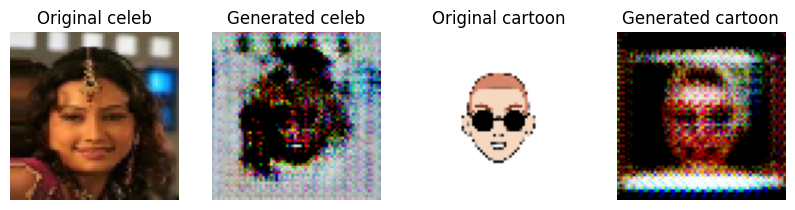

Batchs:   0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step



Batchs:   0%|          | 1/1000 [00:00<09:35,  1.74it/s]

>1, dA[0.314 ,0.035 ] dB[0.026 ,0.007] g[8.335 ,7.767]
1/1 [==============================] - 0s 22ms/step



Batchs:   0%|          | 2/1000 [00:01<09:33,  1.74it/s]

>2, dA[0.055 ,0.070 ] dB[0.122 ,0.095] g[8.589 ,8.450]
1/1 [==============================] - 0s 22ms/step



Batchs:   0%|          | 3/1000 [00:01<09:34,  1.74it/s]

>3, dA[0.054 ,0.014 ] dB[0.021 ,0.027] g[10.279 ,9.746]
1/1 [==============================] - 0s 25ms/step



Batchs:   0%|          | 4/1000 [00:02<09:35,  1.73it/s]

>4, dA[0.111 ,0.096 ] dB[0.033 ,0.017] g[11.974 ,10.070]
1/1 [==============================] - 0s 21ms/step



Batchs:   0%|          | 5/1000 [00:02<09:31,  1.74it/s]

>5, dA[0.039 ,0.096 ] dB[0.013 ,0.009] g[9.750 ,8.038]
1/1 [==============================] - 0s 21ms/step



Batchs:   1%|          | 6/1000 [00:03<09:29,  1.74it/s]

>6, dA[0.081 ,0.067 ] dB[0.014 ,0.015] g[9.835 ,8.493]
1/1 [==============================] - 0s 21ms/step



Batchs:   1%|          | 7/1000 [00:04<09:27,  1.75it/s]

>7, dA[0.105 ,0.080 ] dB[0.014 ,0.004] g[10.670 ,8.432]
1/1 [==============================] - 0s 22ms/step



Batchs:   1%|          | 8/1000 [00:04<09:30,  1.74it/s]

>8, dA[0.061 ,0.081 ] dB[0.003 ,0.038] g[11.314 ,10.254]
1/1 [==============================] - 0s 27ms/step



Batchs:   1%|          | 9/1000 [00:05<09:37,  1.72it/s]

>9, dA[0.220 ,0.390 ] dB[0.020 ,0.003] g[9.195 ,8.792]
1/1 [==============================] - 0s 26ms/step



Batchs:   1%|          | 10/1000 [00:05<09:39,  1.71it/s]

>10, dA[0.031 ,0.054 ] dB[0.005 ,0.017] g[10.179 ,8.136]
1/1 [==============================] - 0s 27ms/step



Batchs:   1%|          | 11/1000 [00:06<09:38,  1.71it/s]

>11, dA[0.151 ,0.542 ] dB[0.008 ,0.030] g[8.723 ,7.946]
1/1 [==============================] - 0s 23ms/step



Batchs:   1%|          | 12/1000 [00:06<09:37,  1.71it/s]

>12, dA[0.044 ,0.053 ] dB[0.053 ,0.008] g[9.159 ,8.389]
1/1 [==============================] - 0s 25ms/step



Batchs:   1%|▏         | 13/1000 [00:07<09:37,  1.71it/s]

>13, dA[0.114 ,0.022 ] dB[0.025 ,0.016] g[12.315 ,13.192]
1/1 [==============================] - 0s 24ms/step



Batchs:   1%|▏         | 14/1000 [00:08<09:37,  1.71it/s]

>14, dA[0.018 ,0.029 ] dB[0.023 ,0.020] g[11.405 ,10.001]
1/1 [==============================] - 0s 27ms/step



Batchs:   2%|▏         | 15/1000 [00:08<09:37,  1.71it/s]

>15, dA[0.039 ,0.053 ] dB[0.014 ,0.012] g[10.921 ,9.728]
1/1 [==============================] - 0s 23ms/step



Batchs:   2%|▏         | 16/1000 [00:09<09:35,  1.71it/s]

>16, dA[0.093 ,0.091 ] dB[0.014 ,0.126] g[9.706 ,8.745]
1/1 [==============================] - 0s 23ms/step



Batchs:   2%|▏         | 17/1000 [00:09<09:34,  1.71it/s]

>17, dA[0.161 ,0.039 ] dB[0.109 ,0.022] g[11.074 ,8.706]
1/1 [==============================] - 0s 23ms/step



Batchs:   2%|▏         | 18/1000 [00:10<09:32,  1.72it/s]

>18, dA[0.026 ,0.493 ] dB[0.047 ,0.154] g[9.094 ,7.323]
1/1 [==============================] - 0s 22ms/step



Batchs:   2%|▏         | 19/1000 [00:11<09:28,  1.72it/s]

>19, dA[0.234 ,0.131 ] dB[0.009 ,0.064] g[10.763 ,9.385]
1/1 [==============================] - 0s 24ms/step



Batchs:   2%|▏         | 20/1000 [00:11<09:29,  1.72it/s]

>20, dA[0.553 ,0.311 ] dB[0.010 ,0.009] g[13.795 ,12.193]
1/1 [==============================] - 0s 25ms/step



Batchs:   2%|▏         | 21/1000 [00:12<09:30,  1.72it/s]

>21, dA[0.102 ,0.163 ] dB[0.044 ,0.022] g[11.200 ,9.547]
1/1 [==============================] - 0s 23ms/step



Batchs:   2%|▏         | 22/1000 [00:12<09:28,  1.72it/s]

>22, dA[0.108 ,0.077 ] dB[0.018 ,0.005] g[11.538 ,9.727]
1/1 [==============================] - 0s 22ms/step



Batchs:   2%|▏         | 23/1000 [00:13<09:24,  1.73it/s]

>23, dA[0.134 ,0.003 ] dB[0.014 ,0.018] g[9.659 ,8.442]
1/1 [==============================] - 0s 23ms/step



Batchs:   2%|▏         | 24/1000 [00:13<09:25,  1.73it/s]

>24, dA[0.013 ,0.234 ] dB[0.009 ,0.005] g[12.167 ,11.328]
1/1 [==============================] - 0s 24ms/step



Batchs:   2%|▎         | 25/1000 [00:14<09:26,  1.72it/s]

>25, dA[0.271 ,0.218 ] dB[0.005 ,0.006] g[10.143 ,8.387]
1/1 [==============================] - 0s 24ms/step



Batchs:   3%|▎         | 26/1000 [00:15<09:27,  1.72it/s]

>26, dA[0.227 ,0.032 ] dB[0.003 ,0.003] g[11.717 ,11.776]
1/1 [==============================] - 0s 24ms/step



Batchs:   3%|▎         | 27/1000 [00:15<09:27,  1.71it/s]

>27, dA[0.092 ,0.200 ] dB[0.005 ,0.005] g[10.729 ,9.528]
1/1 [==============================] - 0s 22ms/step



Batchs:   3%|▎         | 28/1000 [00:16<09:28,  1.71it/s]

>28, dA[0.053 ,0.081 ] dB[0.027 ,0.011] g[10.964 ,10.812]
1/1 [==============================] - 0s 23ms/step



Batchs:   3%|▎         | 29/1000 [00:16<09:27,  1.71it/s]

>29, dA[0.047 ,0.011 ] dB[0.007 ,0.019] g[9.067 ,8.081]
1/1 [==============================] - 0s 24ms/step



Batchs:   3%|▎         | 30/1000 [00:17<09:27,  1.71it/s]

>30, dA[0.312 ,0.220 ] dB[0.003 ,0.007] g[10.441 ,9.293]
1/1 [==============================] - 0s 25ms/step



Batchs:   3%|▎         | 31/1000 [00:18<09:25,  1.71it/s]

>31, dA[0.018 ,0.204 ] dB[0.006 ,0.023] g[9.194 ,7.349]
1/1 [==============================] - 0s 23ms/step



Batchs:   3%|▎         | 32/1000 [00:18<09:24,  1.72it/s]

>32, dA[0.040 ,0.015 ] dB[0.016 ,0.032] g[10.546 ,9.504]
1/1 [==============================] - 0s 27ms/step



Batchs:   3%|▎         | 33/1000 [00:19<09:28,  1.70it/s]

>33, dA[0.012 ,0.017 ] dB[0.026 ,0.011] g[10.602 ,10.238]
1/1 [==============================] - 0s 24ms/step



Batchs:   3%|▎         | 34/1000 [00:19<09:24,  1.71it/s]

>34, dA[0.010 ,0.015 ] dB[0.005 ,0.011] g[10.936 ,8.799]
1/1 [==============================] - 0s 23ms/step



Batchs:   4%|▎         | 35/1000 [00:20<09:23,  1.71it/s]

>35, dA[0.145 ,0.244 ] dB[0.022 ,0.013] g[10.799 ,8.656]
1/1 [==============================] - 0s 24ms/step



Batchs:   4%|▎         | 36/1000 [00:20<09:24,  1.71it/s]

>36, dA[0.015 ,0.007 ] dB[0.010 ,0.014] g[10.754 ,9.208]
1/1 [==============================] - 0s 22ms/step



Batchs:   4%|▎         | 37/1000 [00:21<09:21,  1.72it/s]

>37, dA[0.004 ,0.073 ] dB[0.012 ,0.003] g[11.624 ,10.460]
1/1 [==============================] - 0s 22ms/step



Batchs:   4%|▍         | 38/1000 [00:22<09:17,  1.72it/s]

>38, dA[0.075 ,0.027 ] dB[0.006 ,0.006] g[10.155 ,8.809]
1/1 [==============================] - 0s 24ms/step



Batchs:   4%|▍         | 39/1000 [00:22<09:15,  1.73it/s]

>39, dA[0.027 ,0.011 ] dB[0.005 ,0.006] g[10.469 ,10.206]
1/1 [==============================] - 0s 22ms/step



Batchs:   4%|▍         | 40/1000 [00:23<09:17,  1.72it/s]

>40, dA[0.194 ,0.048 ] dB[0.013 ,0.034] g[10.038 ,8.285]
1/1 [==============================] - 0s 25ms/step



Batchs:   4%|▍         | 41/1000 [00:23<09:20,  1.71it/s]

>41, dA[0.334 ,1.238 ] dB[0.019 ,0.012] g[8.575 ,7.855]
1/1 [==============================] - 0s 24ms/step



Batchs:   4%|▍         | 42/1000 [00:24<09:21,  1.71it/s]

>42, dA[0.078 ,0.047 ] dB[0.005 ,0.004] g[10.263 ,9.486]
1/1 [==============================] - 0s 26ms/step



Batchs:   4%|▍         | 43/1000 [00:25<09:20,  1.71it/s]

>43, dA[0.101 ,0.036 ] dB[0.021 ,0.023] g[11.262 ,10.490]
1/1 [==============================] - 0s 23ms/step



Batchs:   4%|▍         | 44/1000 [00:25<09:19,  1.71it/s]

>44, dA[0.017 ,0.068 ] dB[0.059 ,0.028] g[8.647 ,8.842]
1/1 [==============================] - 0s 24ms/step



Batchs:   4%|▍         | 45/1000 [00:26<09:19,  1.71it/s]

>45, dA[0.173 ,0.021 ] dB[0.028 ,0.047] g[11.166 ,9.675]
1/1 [==============================] - 0s 22ms/step



Batchs:   5%|▍         | 46/1000 [00:26<09:17,  1.71it/s]

>46, dA[0.047 ,0.406 ] dB[0.013 ,0.023] g[10.824 ,9.924]
1/1 [==============================] - 0s 23ms/step



Batchs:   5%|▍         | 47/1000 [00:27<09:16,  1.71it/s]

>47, dA[0.084 ,0.094 ] dB[0.006 ,0.016] g[10.312 ,9.438]
1/1 [==============================] - 0s 23ms/step



Batchs:   5%|▍         | 48/1000 [00:27<09:15,  1.71it/s]

>48, dA[0.046 ,0.116 ] dB[0.006 ,0.008] g[12.454 ,11.013]
1/1 [==============================] - 0s 23ms/step



Batchs:   5%|▍         | 49/1000 [00:28<09:13,  1.72it/s]

>49, dA[0.266 ,0.114 ] dB[0.014 ,0.015] g[12.658 ,11.412]
1/1 [==============================] - 0s 23ms/step



Batchs:   5%|▌         | 50/1000 [00:29<09:12,  1.72it/s]

>50, dA[0.124 ,0.013 ] dB[0.011 ,0.012] g[9.390 ,8.204]
1/1 [==============================] - 0s 24ms/step



Batchs:   5%|▌         | 51/1000 [00:29<09:13,  1.71it/s]

>51, dA[0.014 ,0.097 ] dB[0.017 ,0.014] g[10.109 ,8.461]
1/1 [==============================] - 0s 23ms/step



Batchs:   5%|▌         | 52/1000 [00:30<09:16,  1.70it/s]

>52, dA[0.301 ,0.374 ] dB[0.016 ,0.028] g[9.310 ,8.070]
1/1 [==============================] - 0s 24ms/step



Batchs:   5%|▌         | 53/1000 [00:30<09:15,  1.70it/s]

>53, dA[0.017 ,0.012 ] dB[0.014 ,0.011] g[8.720 ,8.161]
1/1 [==============================] - 0s 26ms/step



Batchs:   5%|▌         | 54/1000 [00:31<09:17,  1.70it/s]

>54, dA[0.139 ,0.020 ] dB[0.003 ,0.008] g[10.525 ,9.280]
1/1 [==============================] - 0s 23ms/step



Batchs:   6%|▌         | 55/1000 [00:32<09:15,  1.70it/s]

>55, dA[0.287 ,0.172 ] dB[0.012 ,0.010] g[9.710 ,9.253]
1/1 [==============================] - 0s 22ms/step



Batchs:   6%|▌         | 56/1000 [00:32<09:11,  1.71it/s]

>56, dA[0.100 ,0.018 ] dB[0.020 ,0.010] g[9.844 ,9.191]
1/1 [==============================] - 0s 22ms/step



Batchs:   6%|▌         | 57/1000 [00:33<09:09,  1.72it/s]

>57, dA[0.054 ,0.027 ] dB[0.036 ,0.025] g[11.941 ,10.134]
1/1 [==============================] - 0s 24ms/step



Batchs:   6%|▌         | 58/1000 [00:33<09:06,  1.72it/s]

>58, dA[0.011 ,0.174 ] dB[0.008 ,0.003] g[11.939 ,10.217]
1/1 [==============================] - 0s 21ms/step



Batchs:   6%|▌         | 59/1000 [00:34<09:03,  1.73it/s]

>59, dA[0.080 ,0.015 ] dB[0.001 ,0.005] g[11.351 ,10.139]
1/1 [==============================] - 0s 24ms/step



Batchs:   6%|▌         | 60/1000 [00:34<09:06,  1.72it/s]

>60, dA[0.048 ,0.061 ] dB[0.003 ,0.003] g[10.568 ,8.523]
1/1 [==============================] - 0s 25ms/step



Batchs:   6%|▌         | 61/1000 [00:35<09:07,  1.71it/s]

>61, dA[0.195 ,0.022 ] dB[0.008 ,0.011] g[10.052 ,9.215]
1/1 [==============================] - 0s 23ms/step



Batchs:   6%|▌         | 62/1000 [00:36<09:05,  1.72it/s]

>62, dA[0.181 ,0.532 ] dB[0.011 ,0.009] g[9.198 ,8.087]
1/1 [==============================] - 0s 25ms/step



Batchs:   6%|▋         | 63/1000 [00:36<09:06,  1.72it/s]

>63, dA[0.030 ,0.041 ] dB[0.011 ,0.016] g[9.590 ,9.529]
1/1 [==============================] - 0s 24ms/step



Batchs:   6%|▋         | 64/1000 [00:37<09:08,  1.71it/s]

>64, dA[0.097 ,0.025 ] dB[0.005 ,0.008] g[12.473 ,12.433]
1/1 [==============================] - 0s 23ms/step



Batchs:   6%|▋         | 65/1000 [00:37<09:07,  1.71it/s]

>65, dA[0.174 ,0.164 ] dB[0.006 ,0.010] g[10.831 ,8.954]
1/1 [==============================] - 0s 24ms/step



Batchs:   7%|▋         | 66/1000 [00:38<09:04,  1.72it/s]

>66, dA[0.080 ,0.189 ] dB[0.021 ,0.016] g[10.067 ,8.682]
1/1 [==============================] - 0s 23ms/step



Batchs:   7%|▋         | 67/1000 [00:39<09:02,  1.72it/s]

>67, dA[0.008 ,0.071 ] dB[0.033 ,0.029] g[8.950 ,8.237]
1/1 [==============================] - 0s 23ms/step



Batchs:   7%|▋         | 68/1000 [00:39<09:02,  1.72it/s]

>68, dA[0.314 ,0.021 ] dB[0.016 ,0.006] g[9.301 ,9.148]
1/1 [==============================] - 0s 23ms/step



Batchs:   7%|▋         | 69/1000 [00:40<09:01,  1.72it/s]

>69, dA[0.198 ,0.018 ] dB[0.006 ,0.005] g[11.945 ,10.826]
1/1 [==============================] - 0s 24ms/step



Batchs:   7%|▋         | 70/1000 [00:40<09:00,  1.72it/s]

>70, dA[0.045 ,0.117 ] dB[0.009 ,0.013] g[9.200 ,8.071]
1/1 [==============================] - 0s 22ms/step



Batchs:   7%|▋         | 71/1000 [00:41<08:58,  1.73it/s]

>71, dA[0.038 ,0.304 ] dB[0.016 ,0.006] g[8.790 ,7.226]
1/1 [==============================] - 0s 22ms/step



Batchs:   7%|▋         | 72/1000 [00:41<09:00,  1.72it/s]

>72, dA[0.068 ,0.086 ] dB[0.009 ,0.003] g[12.251 ,11.038]
1/1 [==============================] - 0s 23ms/step



Batchs:   7%|▋         | 73/1000 [00:42<09:01,  1.71it/s]

>73, dA[0.315 ,0.035 ] dB[0.009 ,0.072] g[9.890 ,8.886]
1/1 [==============================] - 0s 22ms/step



Batchs:   7%|▋         | 74/1000 [00:43<08:58,  1.72it/s]

>74, dA[0.040 ,0.009 ] dB[0.096 ,0.081] g[9.347 ,7.333]
1/1 [==============================] - 0s 22ms/step



Batchs:   8%|▊         | 75/1000 [00:43<08:55,  1.73it/s]

>75, dA[0.036 ,0.038 ] dB[0.035 ,0.080] g[10.172 ,8.031]
1/1 [==============================] - 0s 26ms/step



Batchs:   8%|▊         | 76/1000 [00:44<08:58,  1.71it/s]

>76, dA[0.012 ,0.114 ] dB[0.116 ,0.003] g[10.543 ,9.480]
1/1 [==============================] - 0s 22ms/step



Batchs:   8%|▊         | 77/1000 [00:44<08:57,  1.72it/s]

>77, dA[0.127 ,0.033 ] dB[0.024 ,0.004] g[10.117 ,8.852]
1/1 [==============================] - 0s 25ms/step



Batchs:   8%|▊         | 78/1000 [00:45<09:00,  1.71it/s]

>78, dA[0.190 ,0.024 ] dB[0.007 ,0.009] g[10.574 ,10.472]
1/1 [==============================] - 0s 27ms/step



Batchs:   8%|▊         | 79/1000 [00:46<08:59,  1.71it/s]

>79, dA[0.189 ,0.291 ] dB[0.012 ,0.009] g[11.112 ,10.351]
1/1 [==============================] - 0s 25ms/step



Batchs:   8%|▊         | 80/1000 [00:46<09:01,  1.70it/s]

>80, dA[0.189 ,0.050 ] dB[0.008 ,0.003] g[9.188 ,8.636]
1/1 [==============================] - 0s 24ms/step



Batchs:   8%|▊         | 81/1000 [00:47<09:01,  1.70it/s]

>81, dA[0.020 ,0.036 ] dB[0.016 ,0.005] g[12.613 ,11.790]
1/1 [==============================] - 0s 23ms/step



Batchs:   8%|▊         | 82/1000 [00:47<08:58,  1.70it/s]

>82, dA[0.230 ,0.082 ] dB[0.008 ,0.010] g[12.262 ,12.183]
1/1 [==============================] - 0s 24ms/step



Batchs:   8%|▊         | 83/1000 [00:48<08:57,  1.71it/s]

>83, dA[0.179 ,0.046 ] dB[0.007 ,0.008] g[8.954 ,8.880]
1/1 [==============================] - 0s 25ms/step



Batchs:   8%|▊         | 84/1000 [00:48<09:01,  1.69it/s]

>84, dA[0.018 ,0.039 ] dB[0.016 ,0.003] g[8.872 ,7.565]
1/1 [==============================] - 0s 25ms/step



Batchs:   8%|▊         | 85/1000 [00:49<08:59,  1.70it/s]

>85, dA[0.033 ,0.046 ] dB[0.026 ,0.006] g[8.306 ,6.898]
1/1 [==============================] - 0s 22ms/step



Batchs:   9%|▊         | 86/1000 [00:50<08:55,  1.71it/s]

>86, dA[0.020 ,0.016 ] dB[0.012 ,0.008] g[12.231 ,11.601]
1/1 [==============================] - 0s 23ms/step



Batchs:   9%|▊         | 87/1000 [00:50<08:53,  1.71it/s]

>87, dA[0.072 ,0.195 ] dB[0.005 ,0.003] g[11.166 ,8.675]
1/1 [==============================] - 0s 23ms/step



Batchs:   9%|▉         | 88/1000 [00:51<08:53,  1.71it/s]

>88, dA[0.287 ,0.006 ] dB[0.005 ,0.005] g[11.245 ,10.606]
1/1 [==============================] - 0s 23ms/step



Batchs:   9%|▉         | 89/1000 [00:51<08:51,  1.71it/s]

>89, dA[0.031 ,0.427 ] dB[0.008 ,0.031] g[8.847 ,7.468]
1/1 [==============================] - 0s 24ms/step



Batchs:   9%|▉         | 90/1000 [00:52<08:51,  1.71it/s]

>90, dA[0.012 ,0.076 ] dB[0.016 ,0.021] g[12.122 ,10.922]
1/1 [==============================] - 0s 22ms/step



Batchs:   9%|▉         | 91/1000 [00:53<08:49,  1.72it/s]

>91, dA[0.304 ,0.040 ] dB[0.008 ,0.003] g[9.938 ,8.684]
1/1 [==============================] - 0s 22ms/step



Batchs:   9%|▉         | 92/1000 [00:53<08:50,  1.71it/s]

>92, dA[0.044 ,0.080 ] dB[0.002 ,0.021] g[9.541 ,7.532]
1/1 [==============================] - 0s 25ms/step



Batchs:   9%|▉         | 93/1000 [00:54<08:50,  1.71it/s]

>93, dA[0.008 ,0.247 ] dB[0.004 ,0.019] g[10.599 ,8.774]
1/1 [==============================] - 0s 24ms/step



Batchs:   9%|▉         | 94/1000 [00:54<08:49,  1.71it/s]

>94, dA[0.060 ,0.028 ] dB[0.003 ,0.021] g[10.095 ,8.743]
1/1 [==============================] - 0s 25ms/step



Batchs:  10%|▉         | 95/1000 [00:55<08:48,  1.71it/s]

>95, dA[0.025 ,0.029 ] dB[0.007 ,0.016] g[10.101 ,8.774]
1/1 [==============================] - 0s 21ms/step



Batchs:  10%|▉         | 96/1000 [00:55<08:46,  1.72it/s]

>96, dA[0.282 ,0.070 ] dB[0.008 ,0.004] g[9.545 ,8.201]
1/1 [==============================] - 0s 24ms/step



Batchs:  10%|▉         | 97/1000 [00:56<08:46,  1.71it/s]

>97, dA[0.039 ,0.202 ] dB[0.011 ,0.003] g[9.946 ,8.036]
1/1 [==============================] - 0s 23ms/step



Batchs:  10%|▉         | 98/1000 [00:57<08:45,  1.72it/s]

>98, dA[0.060 ,0.124 ] dB[0.002 ,0.009] g[10.353 ,8.632]
1/1 [==============================] - 0s 22ms/step



Batchs:  10%|▉         | 99/1000 [00:57<08:44,  1.72it/s]

>99, dA[0.025 ,0.210 ] dB[0.006 ,0.002] g[9.566 ,8.122]
1/1 [==============================] - 0s 23ms/step



Batchs:  10%|█         | 100/1000 [00:58<08:46,  1.71it/s]

>100, dA[0.161 ,0.025 ] dB[0.001 ,0.010] g[9.212 ,8.487]
1/1 [==============================] - 0s 23ms/step



Batchs:  10%|█         | 101/1000 [00:58<08:45,  1.71it/s]

>101, dA[0.007 ,0.165 ] dB[0.024 ,0.010] g[9.988 ,8.604]
1/1 [==============================] - 0s 23ms/step



Batchs:  10%|█         | 102/1000 [00:59<08:50,  1.69it/s]

>102, dA[0.124 ,0.025 ] dB[0.010 ,0.011] g[10.027 ,9.368]
1/1 [==============================] - 0s 23ms/step



Batchs:  10%|█         | 103/1000 [01:00<08:47,  1.70it/s]

>103, dA[0.091 ,0.124 ] dB[0.013 ,0.009] g[12.380 ,12.261]
1/1 [==============================] - 0s 25ms/step



Batchs:  10%|█         | 104/1000 [01:00<08:46,  1.70it/s]

>104, dA[0.019 ,0.363 ] dB[0.008 ,0.008] g[9.046 ,8.192]
1/1 [==============================] - 0s 23ms/step



Batchs:  10%|█         | 105/1000 [01:01<08:43,  1.71it/s]

>105, dA[0.012 ,0.043 ] dB[0.004 ,0.004] g[11.407 ,9.794]
1/1 [==============================] - 0s 24ms/step



Batchs:  11%|█         | 106/1000 [01:01<08:42,  1.71it/s]

>106, dA[0.129 ,0.039 ] dB[0.004 ,0.017] g[9.301 ,8.547]
1/1 [==============================] - 0s 24ms/step



Batchs:  11%|█         | 107/1000 [01:02<08:42,  1.71it/s]

>107, dA[0.011 ,0.052 ] dB[0.007 ,0.003] g[13.771 ,12.891]
1/1 [==============================] - 0s 22ms/step



Batchs:  11%|█         | 108/1000 [01:03<08:41,  1.71it/s]

>108, dA[0.068 ,0.156 ] dB[0.006 ,0.019] g[8.273 ,7.186]
1/1 [==============================] - 0s 28ms/step



Batchs:  11%|█         | 109/1000 [01:03<08:43,  1.70it/s]

>109, dA[0.028 ,0.086 ] dB[0.004 ,0.030] g[10.343 ,8.629]
1/1 [==============================] - 0s 23ms/step



Batchs:  11%|█         | 110/1000 [01:04<08:40,  1.71it/s]

>110, dA[0.162 ,0.397 ] dB[0.009 ,0.027] g[10.138 ,8.597]
1/1 [==============================] - 0s 23ms/step



Batchs:  11%|█         | 111/1000 [01:04<08:38,  1.72it/s]

>111, dA[0.170 ,0.013 ] dB[0.002 ,0.037] g[10.129 ,8.489]
1/1 [==============================] - 0s 24ms/step



Batchs:  11%|█         | 112/1000 [01:05<08:37,  1.72it/s]

>112, dA[0.011 ,0.046 ] dB[0.007 ,0.006] g[8.543 ,7.481]
1/1 [==============================] - 0s 21ms/step



Batchs:  11%|█▏        | 113/1000 [01:05<08:34,  1.72it/s]

>113, dA[0.033 ,0.067 ] dB[0.008 ,0.016] g[10.851 ,8.876]
1/1 [==============================] - 0s 24ms/step



Batchs:  11%|█▏        | 114/1000 [01:06<08:33,  1.73it/s]

>114, dA[0.188 ,0.025 ] dB[0.013 ,0.009] g[8.051 ,7.345]
1/1 [==============================] - 0s 21ms/step



Batchs:  12%|█▏        | 115/1000 [01:07<08:28,  1.74it/s]

>115, dA[0.054 ,0.319 ] dB[0.009 ,0.003] g[9.646 ,7.605]
1/1 [==============================] - 0s 22ms/step



Batchs:  12%|█▏        | 116/1000 [01:07<08:29,  1.73it/s]

>116, dA[0.011 ,0.030 ] dB[0.027 ,0.013] g[9.893 ,9.401]
1/1 [==============================] - 0s 23ms/step



Batchs:  12%|█▏        | 117/1000 [01:08<08:31,  1.73it/s]

>117, dA[0.143 ,0.137 ] dB[0.002 ,0.003] g[10.244 ,8.859]
1/1 [==============================] - 0s 23ms/step



Batchs:  12%|█▏        | 118/1000 [01:08<08:30,  1.73it/s]

>118, dA[0.068 ,0.099 ] dB[0.004 ,0.003] g[11.165 ,10.163]
1/1 [==============================] - 0s 29ms/step



Batchs:  12%|█▏        | 119/1000 [01:09<08:34,  1.71it/s]

>119, dA[0.066 ,0.037 ] dB[0.008 ,0.003] g[10.930 ,11.029]
1/1 [==============================] - 0s 22ms/step



Batchs:  12%|█▏        | 120/1000 [01:09<08:33,  1.72it/s]

>120, dA[0.135 ,0.196 ] dB[0.003 ,0.002] g[11.117 ,10.060]
1/1 [==============================] - 0s 22ms/step



Batchs:  12%|█▏        | 121/1000 [01:10<08:30,  1.72it/s]

>121, dA[0.005 ,0.010 ] dB[0.003 ,0.012] g[10.279 ,8.556]
1/1 [==============================] - 0s 24ms/step



Batchs:  12%|█▏        | 122/1000 [01:11<08:29,  1.72it/s]

>122, dA[0.007 ,0.018 ] dB[0.009 ,0.011] g[10.345 ,9.312]
1/1 [==============================] - 0s 22ms/step



Batchs:  12%|█▏        | 123/1000 [01:11<08:28,  1.73it/s]

>123, dA[0.038 ,0.015 ] dB[0.008 ,0.037] g[9.403 ,8.468]
1/1 [==============================] - 0s 25ms/step



Batchs:  12%|█▏        | 124/1000 [01:12<08:31,  1.71it/s]

>124, dA[0.023 ,0.321 ] dB[0.006 ,0.006] g[8.819 ,7.629]
1/1 [==============================] - 0s 24ms/step



Batchs:  12%|█▎        | 125/1000 [01:12<08:29,  1.72it/s]

>125, dA[0.331 ,0.013 ] dB[0.004 ,0.003] g[9.149 ,7.828]
1/1 [==============================] - 0s 21ms/step



Batchs:  13%|█▎        | 126/1000 [01:13<08:24,  1.73it/s]

>126, dA[0.012 ,0.007 ] dB[0.002 ,0.005] g[8.841 ,7.409]
1/1 [==============================] - 0s 25ms/step



Batchs:  13%|█▎        | 127/1000 [01:14<08:24,  1.73it/s]

>127, dA[0.039 ,0.085 ] dB[0.003 ,0.013] g[10.166 ,8.367]
1/1 [==============================] - 0s 22ms/step



Batchs:  13%|█▎        | 128/1000 [01:14<08:25,  1.73it/s]

>128, dA[0.024 ,0.139 ] dB[0.002 ,0.017] g[8.052 ,7.140]
1/1 [==============================] - 0s 24ms/step



Batchs:  13%|█▎        | 129/1000 [01:15<08:25,  1.72it/s]

>129, dA[0.243 ,0.014 ] dB[0.038 ,0.015] g[8.372 ,7.779]
1/1 [==============================] - 0s 28ms/step



Batchs:  13%|█▎        | 130/1000 [01:15<08:26,  1.72it/s]

>130, dA[0.060 ,0.244 ] dB[0.009 ,0.006] g[9.460 ,10.131]
1/1 [==============================] - 0s 25ms/step



Batchs:  13%|█▎        | 131/1000 [01:16<08:26,  1.72it/s]

>131, dA[0.005 ,0.051 ] dB[0.008 ,0.027] g[11.127 ,10.507]
1/1 [==============================] - 0s 25ms/step



Batchs:  13%|█▎        | 132/1000 [01:16<08:28,  1.71it/s]

>132, dA[0.329 ,0.124 ] dB[0.028 ,0.136] g[10.505 ,8.653]
1/1 [==============================] - 0s 24ms/step



Batchs:  13%|█▎        | 133/1000 [01:17<08:25,  1.71it/s]

>133, dA[0.156 ,0.013 ] dB[0.075 ,0.068] g[12.070 ,12.835]
1/1 [==============================] - 0s 23ms/step



Batchs:  13%|█▎        | 134/1000 [01:18<08:21,  1.73it/s]

>134, dA[0.201 ,0.668 ] dB[0.044 ,0.003] g[9.287 ,7.533]
1/1 [==============================] - 0s 22ms/step



Batchs:  14%|█▎        | 135/1000 [01:18<08:19,  1.73it/s]

>135, dA[0.086 ,0.078 ] dB[0.018 ,0.031] g[9.857 ,8.674]
1/1 [==============================] - 0s 23ms/step



Batchs:  14%|█▎        | 136/1000 [01:19<08:21,  1.72it/s]

>136, dA[0.047 ,0.081 ] dB[0.012 ,0.009] g[9.172 ,7.290]
1/1 [==============================] - 0s 22ms/step



Batchs:  14%|█▎        | 137/1000 [01:19<08:18,  1.73it/s]

>137, dA[0.061 ,0.008 ] dB[0.003 ,0.011] g[9.628 ,9.318]
1/1 [==============================] - 0s 22ms/step



Batchs:  14%|█▍        | 138/1000 [01:20<08:19,  1.73it/s]

>138, dA[0.023 ,0.147 ] dB[0.002 ,0.010] g[9.165 ,7.999]
1/1 [==============================] - 0s 26ms/step



Batchs:  14%|█▍        | 139/1000 [01:21<08:20,  1.72it/s]

>139, dA[0.166 ,0.088 ] dB[0.097 ,0.041] g[12.217 ,11.342]
1/1 [==============================] - 0s 24ms/step



Batchs:  14%|█▍        | 140/1000 [01:21<08:21,  1.71it/s]

>140, dA[0.245 ,0.021 ] dB[0.009 ,0.008] g[10.571 ,9.655]
1/1 [==============================] - 0s 25ms/step



Batchs:  14%|█▍        | 141/1000 [01:22<08:20,  1.72it/s]

>141, dA[0.058 ,0.045 ] dB[0.005 ,0.049] g[10.492 ,8.761]
1/1 [==============================] - 0s 24ms/step



Batchs:  14%|█▍        | 142/1000 [01:22<08:19,  1.72it/s]

>142, dA[0.012 ,0.022 ] dB[0.049 ,0.009] g[12.783 ,12.451]
1/1 [==============================] - 0s 23ms/step



Batchs:  14%|█▍        | 143/1000 [01:23<08:17,  1.72it/s]

>143, dA[0.076 ,0.233 ] dB[0.017 ,0.107] g[11.487 ,11.058]
1/1 [==============================] - 0s 22ms/step



Batchs:  14%|█▍        | 144/1000 [01:23<08:17,  1.72it/s]

>144, dA[0.186 ,0.012 ] dB[0.041 ,0.048] g[10.339 ,8.331]
1/1 [==============================] - 0s 27ms/step



Batchs:  14%|█▍        | 145/1000 [01:24<08:18,  1.72it/s]

>145, dA[0.346 ,0.290 ] dB[0.045 ,0.031] g[9.580 ,8.651]
1/1 [==============================] - 0s 24ms/step



Batchs:  15%|█▍        | 146/1000 [01:25<08:16,  1.72it/s]

>146, dA[0.004 ,0.022 ] dB[0.024 ,0.143] g[13.112 ,11.408]
1/1 [==============================] - 0s 24ms/step



Batchs:  15%|█▍        | 147/1000 [01:25<08:14,  1.72it/s]

>147, dA[0.021 ,0.135 ] dB[0.112 ,0.092] g[11.563 ,10.496]
1/1 [==============================] - 0s 24ms/step



Batchs:  15%|█▍        | 148/1000 [01:26<08:15,  1.72it/s]

>148, dA[0.295 ,0.175 ] dB[0.141 ,0.044] g[11.380 ,9.497]
1/1 [==============================] - 0s 25ms/step



Batchs:  15%|█▍        | 149/1000 [01:26<08:14,  1.72it/s]

>149, dA[0.034 ,0.041 ] dB[0.092 ,0.033] g[7.804 ,7.222]
1/1 [==============================] - 0s 22ms/step



Batchs:  15%|█▌        | 150/1000 [01:27<08:13,  1.72it/s]

>150, dA[0.408 ,0.010 ] dB[0.029 ,0.014] g[9.851 ,7.474]
1/1 [==============================] - 0s 24ms/step



Batchs:  15%|█▌        | 151/1000 [01:27<08:11,  1.73it/s]

>151, dA[0.029 ,0.055 ] dB[0.033 ,0.051] g[9.224 ,7.644]
1/1 [==============================] - 0s 22ms/step



Batchs:  15%|█▌        | 152/1000 [01:28<08:10,  1.73it/s]

>152, dA[0.019 ,0.027 ] dB[0.024 ,0.008] g[11.061 ,8.973]
1/1 [==============================] - 0s 22ms/step



Batchs:  15%|█▌        | 153/1000 [01:29<08:10,  1.73it/s]

>153, dA[0.008 ,0.018 ] dB[0.020 ,0.015] g[11.031 ,10.338]
1/1 [==============================] - 0s 23ms/step



Batchs:  15%|█▌        | 154/1000 [01:29<08:08,  1.73it/s]

>154, dA[0.012 ,0.304 ] dB[0.040 ,0.007] g[9.992 ,7.641]
1/1 [==============================] - 0s 21ms/step



Batchs:  16%|█▌        | 155/1000 [01:30<08:05,  1.74it/s]

>155, dA[0.086 ,0.067 ] dB[0.023 ,0.005] g[9.309 ,7.789]
1/1 [==============================] - 0s 23ms/step



Batchs:  16%|█▌        | 156/1000 [01:30<08:07,  1.73it/s]

>156, dA[0.365 ,0.058 ] dB[0.011 ,0.005] g[9.017 ,7.725]
1/1 [==============================] - 0s 24ms/step



Batchs:  16%|█▌        | 157/1000 [01:31<08:06,  1.73it/s]

>157, dA[0.018 ,0.013 ] dB[0.009 ,0.016] g[8.844 ,7.107]
1/1 [==============================] - 0s 23ms/step



Batchs:  16%|█▌        | 158/1000 [01:32<08:06,  1.73it/s]

>158, dA[0.008 ,0.143 ] dB[0.012 ,0.012] g[9.426 ,7.961]
1/1 [==============================] - 0s 23ms/step



Batchs:  16%|█▌        | 159/1000 [01:32<08:03,  1.74it/s]

>159, dA[0.056 ,0.026 ] dB[0.024 ,0.008] g[9.920 ,8.035]
1/1 [==============================] - 0s 22ms/step



Batchs:  16%|█▌        | 160/1000 [01:33<08:06,  1.73it/s]

>160, dA[0.015 ,0.142 ] dB[0.010 ,0.002] g[11.250 ,10.199]
1/1 [==============================] - 0s 27ms/step



Batchs:  16%|█▌        | 161/1000 [01:33<08:08,  1.72it/s]

>161, dA[0.032 ,0.011 ] dB[0.019 ,0.009] g[8.032 ,7.137]
1/1 [==============================] - 0s 22ms/step



Batchs:  16%|█▌        | 162/1000 [01:34<08:06,  1.72it/s]

>162, dA[0.227 ,0.231 ] dB[0.055 ,0.117] g[10.063 ,9.118]
1/1 [==============================] - 0s 23ms/step



Batchs:  16%|█▋        | 163/1000 [01:34<08:05,  1.73it/s]

>163, dA[0.067 ,0.030 ] dB[0.108 ,0.037] g[10.926 ,8.406]
1/1 [==============================] - 0s 22ms/step



Batchs:  16%|█▋        | 164/1000 [01:35<08:02,  1.73it/s]

>164, dA[0.018 ,0.028 ] dB[0.044 ,0.030] g[9.438 ,7.954]
1/1 [==============================] - 0s 25ms/step



Batchs:  16%|█▋        | 165/1000 [01:36<08:03,  1.73it/s]

>165, dA[0.013 ,0.153 ] dB[0.017 ,0.015] g[9.680 ,8.750]
1/1 [==============================] - 0s 24ms/step



Batchs:  17%|█▋        | 166/1000 [01:36<08:02,  1.73it/s]

>166, dA[0.243 ,0.018 ] dB[0.013 ,0.010] g[8.564 ,7.831]
1/1 [==============================] - 0s 22ms/step



Batchs:  17%|█▋        | 167/1000 [01:37<08:00,  1.74it/s]

>167, dA[0.018 ,0.039 ] dB[0.022 ,0.008] g[11.500 ,10.848]
1/1 [==============================] - 0s 25ms/step



Batchs:  17%|█▋        | 168/1000 [01:37<08:02,  1.72it/s]

>168, dA[0.078 ,0.111 ] dB[0.007 ,0.012] g[9.874 ,8.582]
1/1 [==============================] - 0s 21ms/step



Batchs:  17%|█▋        | 169/1000 [01:38<08:00,  1.73it/s]

>169, dA[0.143 ,0.025 ] dB[0.024 ,0.011] g[10.480 ,9.056]
1/1 [==============================] - 0s 23ms/step



Batchs:  17%|█▋        | 170/1000 [01:38<08:03,  1.72it/s]

>170, dA[0.005 ,0.411 ] dB[0.008 ,0.023] g[9.504 ,7.451]
1/1 [==============================] - 0s 24ms/step



Batchs:  17%|█▋        | 171/1000 [01:39<08:03,  1.72it/s]

>171, dA[0.327 ,0.091 ] dB[0.008 ,0.014] g[10.914 ,8.376]
1/1 [==============================] - 0s 21ms/step



Batchs:  17%|█▋        | 172/1000 [01:40<08:01,  1.72it/s]

>172, dA[0.029 ,0.088 ] dB[0.011 ,0.015] g[9.900 ,8.001]
1/1 [==============================] - 0s 23ms/step



Batchs:  17%|█▋        | 173/1000 [01:40<08:00,  1.72it/s]

>173, dA[0.275 ,0.036 ] dB[0.010 ,0.015] g[10.347 ,9.067]
1/1 [==============================] - 0s 27ms/step



Batchs:  17%|█▋        | 174/1000 [01:41<08:01,  1.72it/s]

>174, dA[0.093 ,0.246 ] dB[0.027 ,0.092] g[9.747 ,8.945]
1/1 [==============================] - 0s 25ms/step



Batchs:  18%|█▊        | 175/1000 [01:41<08:00,  1.72it/s]

>175, dA[0.107 ,0.208 ] dB[0.036 ,0.011] g[8.492 ,7.194]
1/1 [==============================] - 0s 23ms/step



Batchs:  18%|█▊        | 176/1000 [01:42<07:59,  1.72it/s]

>176, dA[0.284 ,0.127 ] dB[0.010 ,0.046] g[8.076 ,7.531]
1/1 [==============================] - 0s 22ms/step



Batchs:  18%|█▊        | 177/1000 [01:43<07:57,  1.72it/s]

>177, dA[0.064 ,0.042 ] dB[0.019 ,0.059] g[10.515 ,8.600]
1/1 [==============================] - 0s 24ms/step



Batchs:  18%|█▊        | 178/1000 [01:43<07:57,  1.72it/s]

>178, dA[0.049 ,0.053 ] dB[0.017 ,0.035] g[11.397 ,9.903]
1/1 [==============================] - 0s 24ms/step



Batchs:  18%|█▊        | 179/1000 [01:44<07:56,  1.72it/s]

>179, dA[0.047 ,0.271 ] dB[0.033 ,0.012] g[13.821 ,12.770]
1/1 [==============================] - 0s 25ms/step



Batchs:  18%|█▊        | 180/1000 [01:44<07:57,  1.72it/s]

>180, dA[0.333 ,0.060 ] dB[0.023 ,0.032] g[9.213 ,8.549]
1/1 [==============================] - 0s 22ms/step



Batchs:  18%|█▊        | 181/1000 [01:45<07:53,  1.73it/s]

>181, dA[0.241 ,0.015 ] dB[0.041 ,0.006] g[9.090 ,8.058]
1/1 [==============================] - 0s 23ms/step



Batchs:  18%|█▊        | 182/1000 [01:45<07:51,  1.74it/s]

>182, dA[0.064 ,0.247 ] dB[0.002 ,0.019] g[10.742 ,8.886]
1/1 [==============================] - 0s 22ms/step



Batchs:  18%|█▊        | 183/1000 [01:46<07:50,  1.74it/s]

>183, dA[0.173 ,0.143 ] dB[0.010 ,0.003] g[12.200 ,11.553]
1/1 [==============================] - 0s 25ms/step



Batchs:  18%|█▊        | 184/1000 [01:47<07:50,  1.73it/s]

>184, dA[0.008 ,0.012 ] dB[0.011 ,0.018] g[8.696 ,8.484]
1/1 [==============================] - 0s 23ms/step



Batchs:  18%|█▊        | 185/1000 [01:47<07:52,  1.72it/s]

>185, dA[0.007 ,0.017 ] dB[0.005 ,0.009] g[12.948 ,12.555]
1/1 [==============================] - 0s 21ms/step



Batchs:  19%|█▊        | 186/1000 [01:48<07:50,  1.73it/s]

>186, dA[0.024 ,0.012 ] dB[0.007 ,0.004] g[9.969 ,9.506]
1/1 [==============================] - 0s 22ms/step



Batchs:  19%|█▊        | 187/1000 [01:48<07:48,  1.73it/s]

>187, dA[0.024 ,0.016 ] dB[0.004 ,0.007] g[10.385 ,9.297]
1/1 [==============================] - 0s 31ms/step



Batchs:  19%|█▉        | 188/1000 [01:49<07:52,  1.72it/s]

>188, dA[0.005 ,0.026 ] dB[0.003 ,0.002] g[9.780 ,8.223]
1/1 [==============================] - 0s 25ms/step



Batchs:  19%|█▉        | 189/1000 [01:50<07:51,  1.72it/s]

>189, dA[0.160 ,0.019 ] dB[0.003 ,0.004] g[11.962 ,10.430]
1/1 [==============================] - 0s 24ms/step



Batchs:  19%|█▉        | 190/1000 [01:50<07:50,  1.72it/s]

>190, dA[0.074 ,0.098 ] dB[0.006 ,0.009] g[7.703 ,7.436]
1/1 [==============================] - 0s 21ms/step



Batchs:  19%|█▉        | 191/1000 [01:51<07:46,  1.73it/s]

>191, dA[0.101 ,0.449 ] dB[0.005 ,0.015] g[11.294 ,9.995]
1/1 [==============================] - 0s 23ms/step



Batchs:  19%|█▉        | 192/1000 [01:51<07:46,  1.73it/s]

>192, dA[0.066 ,0.020 ] dB[0.005 ,0.001] g[10.692 ,8.786]
1/1 [==============================] - 0s 22ms/step



Batchs:  19%|█▉        | 193/1000 [01:52<07:46,  1.73it/s]

>193, dA[0.091 ,0.050 ] dB[0.014 ,0.001] g[9.888 ,8.551]
1/1 [==============================] - 0s 23ms/step



Batchs:  19%|█▉        | 194/1000 [01:52<07:44,  1.74it/s]

>194, dA[0.004 ,0.024 ] dB[0.017 ,0.041] g[10.479 ,8.694]
1/1 [==============================] - 0s 22ms/step



Batchs:  20%|█▉        | 195/1000 [01:53<07:43,  1.74it/s]

>195, dA[0.011 ,0.025 ] dB[0.009 ,0.035] g[11.308 ,10.844]
1/1 [==============================] - 0s 22ms/step



Batchs:  20%|█▉        | 196/1000 [01:54<07:44,  1.73it/s]

>196, dA[0.104 ,0.013 ] dB[0.034 ,0.003] g[10.891 ,10.266]
1/1 [==============================] - 0s 24ms/step



Batchs:  20%|█▉        | 197/1000 [01:54<07:45,  1.73it/s]

>197, dA[0.134 ,0.535 ] dB[0.013 ,0.004] g[10.489 ,9.126]
1/1 [==============================] - 0s 24ms/step



Batchs:  20%|█▉        | 198/1000 [01:55<07:43,  1.73it/s]

>198, dA[0.189 ,0.041 ] dB[0.003 ,0.003] g[9.108 ,8.000]
1/1 [==============================] - 0s 22ms/step



Batchs:  20%|█▉        | 199/1000 [01:55<07:42,  1.73it/s]

>199, dA[0.026 ,0.114 ] dB[0.006 ,0.002] g[11.327 ,10.340]
1/1 [==============================] - 0s 25ms/step



Batchs:  20%|██        | 200/1000 [01:56<07:44,  1.72it/s]

>200, dA[0.164 ,0.141 ] dB[0.129 ,0.429] g[8.608 ,9.155]
1/1 [==============================] - 0s 23ms/step



Batchs:  20%|██        | 201/1000 [01:56<07:42,  1.73it/s]

>201, dA[0.048 ,0.271 ] dB[0.086 ,0.011] g[10.790 ,8.237]
1/1 [==============================] - 0s 22ms/step



Batchs:  20%|██        | 202/1000 [01:57<07:41,  1.73it/s]

>202, dA[0.119 ,0.010 ] dB[0.019 ,0.006] g[10.756 ,9.278]
1/1 [==============================] - 0s 23ms/step



Batchs:  20%|██        | 203/1000 [01:58<07:40,  1.73it/s]

>203, dA[0.062 ,0.163 ] dB[0.013 ,0.005] g[9.769 ,8.464]
1/1 [==============================] - 0s 22ms/step



Batchs:  20%|██        | 204/1000 [01:58<07:40,  1.73it/s]

>204, dA[0.149 ,0.128 ] dB[0.001 ,0.003] g[9.042 ,8.034]
1/1 [==============================] - 0s 24ms/step



Batchs:  20%|██        | 205/1000 [01:59<07:45,  1.71it/s]

>205, dA[0.080 ,0.015 ] dB[0.016 ,0.004] g[9.617 ,8.283]
1/1 [==============================] - 0s 23ms/step



Batchs:  21%|██        | 206/1000 [01:59<07:43,  1.71it/s]

>206, dA[0.082 ,0.005 ] dB[0.088 ,0.167] g[8.798 ,7.284]
1/1 [==============================] - 0s 23ms/step



Batchs:  21%|██        | 207/1000 [02:00<07:41,  1.72it/s]

>207, dA[0.041 ,0.299 ] dB[0.012 ,0.012] g[11.203 ,9.927]
1/1 [==============================] - 0s 22ms/step



Batchs:  21%|██        | 208/1000 [02:01<07:41,  1.72it/s]

>208, dA[0.074 ,0.041 ] dB[0.016 ,0.004] g[9.732 ,9.134]
1/1 [==============================] - 0s 26ms/step



Batchs:  21%|██        | 209/1000 [02:01<07:41,  1.71it/s]

>209, dA[0.582 ,0.061 ] dB[0.027 ,0.025] g[11.211 ,10.080]
1/1 [==============================] - 0s 24ms/step



Batchs:  21%|██        | 210/1000 [02:02<07:41,  1.71it/s]

>210, dA[0.009 ,0.262 ] dB[0.003 ,0.003] g[11.693 ,9.976]
1/1 [==============================] - 0s 23ms/step



Batchs:  21%|██        | 211/1000 [02:02<07:38,  1.72it/s]

>211, dA[0.147 ,0.011 ] dB[0.002 ,0.038] g[8.849 ,8.198]
1/1 [==============================] - 0s 24ms/step



Batchs:  21%|██        | 212/1000 [02:03<07:41,  1.71it/s]

>212, dA[0.088 ,0.006 ] dB[0.015 ,0.029] g[9.974 ,7.745]
1/1 [==============================] - 0s 23ms/step



Batchs:  21%|██▏       | 213/1000 [02:03<07:39,  1.71it/s]

>213, dA[0.019 ,0.347 ] dB[0.011 ,0.024] g[10.183 ,9.447]
1/1 [==============================] - 0s 24ms/step



Batchs:  21%|██▏       | 214/1000 [02:04<07:39,  1.71it/s]

>214, dA[0.375 ,0.212 ] dB[0.006 ,0.006] g[11.034 ,10.048]
1/1 [==============================] - 0s 24ms/step



Batchs:  22%|██▏       | 215/1000 [02:05<07:37,  1.71it/s]

>215, dA[0.161 ,0.010 ] dB[0.003 ,0.015] g[9.696 ,8.293]
1/1 [==============================] - 0s 25ms/step



Batchs:  22%|██▏       | 216/1000 [02:05<07:37,  1.71it/s]

>216, dA[0.027 ,0.313 ] dB[0.023 ,0.007] g[9.705 ,7.699]
1/1 [==============================] - 0s 23ms/step



Batchs:  22%|██▏       | 217/1000 [02:06<07:37,  1.71it/s]

>217, dA[0.029 ,0.005 ] dB[0.011 ,0.008] g[10.896 ,10.110]
1/1 [==============================] - 0s 21ms/step



Batchs:  22%|██▏       | 218/1000 [02:06<07:35,  1.72it/s]

>218, dA[0.152 ,0.004 ] dB[0.004 ,0.005] g[11.245 ,10.750]
1/1 [==============================] - 0s 22ms/step



Batchs:  22%|██▏       | 219/1000 [02:07<07:33,  1.72it/s]

>219, dA[0.055 ,0.193 ] dB[0.025 ,0.003] g[9.263 ,7.547]
1/1 [==============================] - 0s 23ms/step



Batchs:  22%|██▏       | 220/1000 [02:08<07:33,  1.72it/s]

>220, dA[0.023 ,0.299 ] dB[0.006 ,0.007] g[9.909 ,7.855]
1/1 [==============================] - 0s 24ms/step



Batchs:  22%|██▏       | 221/1000 [02:08<07:31,  1.72it/s]

>221, dA[0.237 ,0.060 ] dB[0.013 ,0.007] g[9.690 ,8.048]
1/1 [==============================] - 0s 24ms/step



Batchs:  22%|██▏       | 222/1000 [02:09<07:36,  1.71it/s]

>222, dA[0.099 ,0.118 ] dB[0.002 ,0.006] g[11.872 ,11.467]
1/1 [==============================] - 0s 22ms/step



Batchs:  22%|██▏       | 223/1000 [02:09<07:33,  1.71it/s]

>223, dA[0.151 ,0.109 ] dB[0.002 ,0.007] g[10.770 ,9.077]
1/1 [==============================] - 0s 22ms/step



Batchs:  22%|██▏       | 224/1000 [02:10<07:31,  1.72it/s]

>224, dA[0.308 ,0.048 ] dB[0.006 ,0.011] g[10.199 ,8.298]
1/1 [==============================] - 0s 26ms/step



Batchs:  22%|██▎       | 225/1000 [02:10<07:32,  1.71it/s]

>225, dA[0.034 ,0.059 ] dB[0.009 ,0.008] g[9.856 ,8.141]
1/1 [==============================] - 0s 21ms/step



Batchs:  23%|██▎       | 226/1000 [02:11<07:29,  1.72it/s]

>226, dA[0.096 ,0.298 ] dB[0.025 ,0.015] g[10.522 ,9.107]
1/1 [==============================] - 0s 21ms/step



Batchs:  23%|██▎       | 227/1000 [02:12<07:26,  1.73it/s]

>227, dA[0.057 ,0.005 ] dB[0.020 ,0.030] g[9.742 ,8.350]
1/1 [==============================] - 0s 24ms/step



Batchs:  23%|██▎       | 228/1000 [02:12<07:27,  1.72it/s]

>228, dA[0.054 ,0.012 ] dB[0.018 ,0.019] g[10.598 ,9.950]
1/1 [==============================] - 0s 22ms/step



Batchs:  23%|██▎       | 229/1000 [02:13<07:25,  1.73it/s]

>229, dA[0.120 ,0.512 ] dB[0.004 ,0.018] g[8.974 ,7.337]
1/1 [==============================] - 0s 25ms/step



Batchs:  23%|██▎       | 230/1000 [02:13<07:25,  1.73it/s]

>230, dA[0.122 ,0.016 ] dB[0.007 ,0.013] g[8.686 ,7.485]
1/1 [==============================] - 0s 24ms/step



Batchs:  23%|██▎       | 231/1000 [02:14<07:24,  1.73it/s]

>231, dA[0.039 ,0.027 ] dB[0.016 ,0.016] g[9.666 ,8.693]
1/1 [==============================] - 0s 26ms/step



Batchs:  23%|██▎       | 232/1000 [02:14<07:27,  1.71it/s]

>232, dA[0.052 ,0.223 ] dB[0.033 ,0.041] g[8.930 ,7.058]
1/1 [==============================] - 0s 24ms/step



Batchs:  23%|██▎       | 233/1000 [02:15<07:26,  1.72it/s]

>233, dA[0.106 ,0.029 ] dB[0.167 ,0.372] g[8.962 ,7.543]
1/1 [==============================] - 0s 26ms/step



Batchs:  23%|██▎       | 234/1000 [02:16<07:26,  1.72it/s]

>234, dA[0.074 ,0.031 ] dB[0.071 ,0.060] g[10.112 ,9.766]
1/1 [==============================] - 0s 24ms/step



Batchs:  24%|██▎       | 235/1000 [02:16<07:26,  1.71it/s]

>235, dA[0.071 ,0.162 ] dB[0.089 ,0.113] g[10.264 ,8.725]
1/1 [==============================] - 0s 23ms/step



Batchs:  24%|██▎       | 236/1000 [02:17<07:26,  1.71it/s]

>236, dA[0.116 ,0.171 ] dB[0.127 ,0.065] g[9.102 ,7.716]
1/1 [==============================] - 0s 25ms/step



Batchs:  24%|██▎       | 237/1000 [02:17<07:23,  1.72it/s]

>237, dA[0.067 ,0.300 ] dB[0.076 ,0.080] g[8.411 ,7.629]
1/1 [==============================] - 0s 23ms/step



Batchs:  24%|██▍       | 238/1000 [02:18<07:20,  1.73it/s]

>238, dA[0.215 ,0.030 ] dB[0.051 ,0.006] g[8.738 ,7.653]
1/1 [==============================] - 0s 22ms/step



Batchs:  24%|██▍       | 239/1000 [02:19<07:17,  1.74it/s]

>239, dA[0.059 ,0.292 ] dB[0.008 ,0.030] g[10.763 ,8.940]
1/1 [==============================] - 0s 23ms/step



Batchs:  24%|██▍       | 240/1000 [02:19<07:20,  1.73it/s]

>240, dA[0.193 ,0.011 ] dB[0.047 ,0.049] g[10.029 ,8.711]
1/1 [==============================] - 0s 23ms/step



Batchs:  24%|██▍       | 241/1000 [02:20<07:20,  1.72it/s]

>241, dA[0.025 ,0.138 ] dB[0.092 ,0.073] g[9.782 ,8.221]
1/1 [==============================] - 0s 23ms/step



Batchs:  24%|██▍       | 242/1000 [02:20<07:19,  1.72it/s]

>242, dA[0.010 ,0.022 ] dB[0.185 ,0.019] g[10.735 ,8.544]
1/1 [==============================] - 0s 25ms/step



Batchs:  24%|██▍       | 243/1000 [02:21<07:19,  1.72it/s]

>243, dA[0.096 ,0.174 ] dB[0.017 ,0.008] g[10.322 ,8.884]
1/1 [==============================] - 0s 23ms/step



Batchs:  24%|██▍       | 244/1000 [02:21<07:20,  1.72it/s]

>244, dA[0.078 ,0.041 ] dB[0.005 ,0.023] g[9.542 ,8.090]
1/1 [==============================] - 0s 22ms/step



Batchs:  24%|██▍       | 245/1000 [02:22<07:19,  1.72it/s]

>245, dA[0.381 ,0.160 ] dB[0.017 ,0.024] g[11.684 ,12.539]
1/1 [==============================] - 0s 22ms/step



Batchs:  25%|██▍       | 246/1000 [02:23<07:17,  1.72it/s]

>246, dA[0.024 ,0.007 ] dB[0.031 ,0.026] g[9.306 ,7.766]
1/1 [==============================] - 0s 25ms/step



Batchs:  25%|██▍       | 247/1000 [02:23<07:18,  1.72it/s]

>247, dA[0.012 ,0.287 ] dB[0.070 ,0.045] g[8.518 ,7.162]
1/1 [==============================] - 0s 22ms/step



Batchs:  25%|██▍       | 248/1000 [02:24<07:19,  1.71it/s]

>248, dA[0.093 ,0.064 ] dB[0.003 ,0.040] g[11.129 ,11.203]
1/1 [==============================] - 0s 24ms/step



Batchs:  25%|██▍       | 249/1000 [02:24<07:17,  1.72it/s]

>249, dA[0.046 ,0.043 ] dB[0.015 ,0.017] g[10.129 ,8.477]
1/1 [==============================] - 0s 23ms/step



Batchs:  25%|██▌       | 250/1000 [02:25<07:15,  1.72it/s]

>250, dA[0.201 ,0.038 ] dB[0.039 ,0.056] g[9.511 ,9.680]
1/1 [==============================] - 0s 21ms/step



Batchs:  25%|██▌       | 251/1000 [02:26<07:13,  1.73it/s]

>251, dA[0.018 ,0.758 ] dB[0.048 ,0.020] g[11.079 ,9.484]
1/1 [==============================] - 0s 24ms/step



Batchs:  25%|██▌       | 252/1000 [02:26<07:14,  1.72it/s]

>252, dA[0.053 ,0.080 ] dB[0.028 ,0.026] g[10.400 ,9.604]
1/1 [==============================] - 0s 23ms/step



Batchs:  25%|██▌       | 253/1000 [02:27<07:13,  1.72it/s]

>253, dA[0.321 ,0.016 ] dB[0.059 ,0.037] g[9.520 ,9.093]
1/1 [==============================] - 0s 22ms/step



Batchs:  25%|██▌       | 254/1000 [02:27<07:11,  1.73it/s]

>254, dA[0.101 ,0.045 ] dB[0.037 ,0.114] g[10.038 ,8.794]
1/1 [==============================] - 0s 23ms/step



Batchs:  26%|██▌       | 255/1000 [02:28<07:10,  1.73it/s]

>255, dA[0.046 ,0.030 ] dB[0.019 ,0.028] g[8.881 ,7.254]
1/1 [==============================] - 0s 23ms/step



Batchs:  26%|██▌       | 256/1000 [02:28<07:12,  1.72it/s]

>256, dA[0.067 ,0.046 ] dB[0.045 ,0.009] g[13.740 ,13.022]
1/1 [==============================] - 0s 22ms/step



Batchs:  26%|██▌       | 257/1000 [02:29<07:15,  1.70it/s]

>257, dA[0.196 ,0.042 ] dB[0.005 ,0.005] g[9.454 ,7.892]
1/1 [==============================] - 0s 23ms/step



Batchs:  26%|██▌       | 258/1000 [02:30<07:12,  1.71it/s]

>258, dA[0.011 ,0.487 ] dB[0.009 ,0.003] g[8.563 ,6.851]
1/1 [==============================] - 0s 21ms/step



Batchs:  26%|██▌       | 259/1000 [02:30<07:09,  1.72it/s]

>259, dA[0.179 ,0.040 ] dB[0.115 ,0.864] g[6.710 ,6.906]
1/1 [==============================] - 0s 23ms/step



Batchs:  26%|██▌       | 260/1000 [02:31<07:11,  1.72it/s]

>260, dA[0.045 ,0.012 ] dB[0.167 ,0.004] g[12.695 ,13.755]
1/1 [==============================] - 0s 23ms/step



Batchs:  26%|██▌       | 261/1000 [02:31<07:09,  1.72it/s]

>261, dA[0.095 ,0.152 ] dB[0.095 ,0.090] g[8.495 ,7.489]
1/1 [==============================] - 0s 22ms/step



Batchs:  26%|██▌       | 262/1000 [02:32<07:06,  1.73it/s]

>262, dA[0.019 ,0.056 ] dB[0.074 ,0.152] g[8.086 ,7.841]
1/1 [==============================] - 0s 23ms/step



Batchs:  26%|██▋       | 263/1000 [02:32<07:05,  1.73it/s]

>263, dA[0.049 ,0.046 ] dB[0.102 ,0.135] g[10.745 ,9.169]
1/1 [==============================] - 0s 22ms/step



Batchs:  26%|██▋       | 264/1000 [02:33<07:05,  1.73it/s]

>264, dA[0.032 ,0.028 ] dB[0.442 ,0.068] g[8.340 ,7.971]
1/1 [==============================] - 0s 26ms/step



Batchs:  26%|██▋       | 265/1000 [02:34<07:07,  1.72it/s]

>265, dA[0.136 ,0.336 ] dB[0.014 ,0.020] g[10.587 ,10.809]
1/1 [==============================] - 0s 25ms/step



Batchs:  27%|██▋       | 266/1000 [02:34<07:06,  1.72it/s]

>266, dA[0.041 ,0.003 ] dB[0.006 ,0.032] g[9.902 ,9.804]
1/1 [==============================] - 0s 22ms/step



Batchs:  27%|██▋       | 267/1000 [02:35<07:04,  1.72it/s]

>267, dA[0.323 ,0.007 ] dB[0.082 ,0.236] g[10.221 ,14.520]
1/1 [==============================] - 0s 22ms/step



Batchs:  27%|██▋       | 268/1000 [02:35<07:04,  1.72it/s]

>268, dA[0.029 ,0.720 ] dB[0.039 ,0.096] g[11.713 ,11.186]
1/1 [==============================] - 0s 28ms/step



Batchs:  27%|██▋       | 269/1000 [02:36<07:05,  1.72it/s]

>269, dA[0.042 ,0.013 ] dB[0.261 ,0.103] g[10.790 ,11.619]
1/1 [==============================] - 0s 21ms/step



Batchs:  27%|██▋       | 270/1000 [02:37<07:02,  1.73it/s]

>270, dA[0.097 ,0.028 ] dB[0.045 ,0.094] g[11.369 ,10.771]
1/1 [==============================] - 0s 25ms/step



Batchs:  27%|██▋       | 271/1000 [02:37<07:02,  1.73it/s]

>271, dA[0.169 ,0.301 ] dB[0.136 ,0.034] g[11.381 ,10.679]
1/1 [==============================] - 0s 23ms/step



Batchs:  27%|██▋       | 272/1000 [02:38<07:01,  1.73it/s]

>272, dA[0.133 ,0.107 ] dB[0.007 ,0.009] g[12.628 ,16.156]
1/1 [==============================] - 0s 22ms/step



Batchs:  27%|██▋       | 273/1000 [02:38<07:00,  1.73it/s]

>273, dA[0.085 ,0.027 ] dB[0.011 ,0.009] g[10.857 ,9.600]
1/1 [==============================] - 0s 22ms/step



Batchs:  27%|██▋       | 274/1000 [02:39<06:58,  1.74it/s]

>274, dA[0.028 ,0.095 ] dB[0.186 ,0.289] g[8.349 ,7.853]
1/1 [==============================] - 0s 22ms/step



Batchs:  28%|██▊       | 275/1000 [02:39<06:57,  1.74it/s]

>275, dA[0.019 ,0.022 ] dB[0.013 ,0.014] g[10.297 ,9.316]
1/1 [==============================] - 0s 26ms/step



Batchs:  28%|██▊       | 276/1000 [02:40<07:02,  1.71it/s]

>276, dA[0.042 ,0.280 ] dB[0.048 ,0.039] g[10.755 ,10.454]
1/1 [==============================] - 0s 24ms/step



Batchs:  28%|██▊       | 277/1000 [02:41<07:04,  1.70it/s]

>277, dA[0.343 ,0.229 ] dB[0.014 ,0.028] g[10.953 ,9.342]
1/1 [==============================] - 0s 22ms/step



Batchs:  28%|██▊       | 278/1000 [02:41<07:02,  1.71it/s]

>278, dA[0.104 ,0.084 ] dB[0.018 ,0.073] g[10.093 ,9.103]
1/1 [==============================] - 0s 25ms/step



Batchs:  28%|██▊       | 279/1000 [02:42<07:01,  1.71it/s]

>279, dA[0.153 ,0.028 ] dB[0.045 ,0.047] g[10.473 ,8.841]
1/1 [==============================] - 0s 22ms/step



Batchs:  28%|██▊       | 280/1000 [02:42<07:01,  1.71it/s]

>280, dA[0.009 ,0.266 ] dB[0.035 ,0.009] g[12.538 ,11.534]
1/1 [==============================] - 0s 24ms/step



Batchs:  28%|██▊       | 281/1000 [02:43<07:00,  1.71it/s]

>281, dA[0.138 ,0.087 ] dB[0.013 ,0.133] g[9.476 ,9.119]
1/1 [==============================] - 0s 22ms/step



Batchs:  28%|██▊       | 282/1000 [02:44<06:59,  1.71it/s]

>282, dA[0.104 ,0.085 ] dB[0.078 ,0.006] g[11.916 ,10.340]
1/1 [==============================] - 0s 25ms/step



Batchs:  28%|██▊       | 283/1000 [02:44<06:57,  1.72it/s]

>283, dA[0.032 ,0.036 ] dB[0.006 ,0.033] g[11.344 ,9.980]
1/1 [==============================] - 0s 24ms/step



Batchs:  28%|██▊       | 284/1000 [02:45<06:58,  1.71it/s]

>284, dA[0.069 ,0.085 ] dB[0.017 ,0.035] g[13.672 ,13.585]
1/1 [==============================] - 0s 23ms/step



Batchs:  28%|██▊       | 285/1000 [02:45<06:56,  1.72it/s]

>285, dA[0.068 ,0.081 ] dB[0.031 ,0.024] g[9.534 ,8.410]
1/1 [==============================] - 0s 22ms/step



Batchs:  29%|██▊       | 286/1000 [02:46<06:54,  1.72it/s]

>286, dA[0.024 ,0.014 ] dB[0.009 ,0.020] g[8.613 ,7.963]
1/1 [==============================] - 0s 25ms/step



Batchs:  29%|██▊       | 287/1000 [02:46<06:55,  1.72it/s]

>287, dA[0.021 ,0.446 ] dB[0.008 ,0.034] g[11.402 ,11.955]
1/1 [==============================] - 0s 23ms/step



Batchs:  29%|██▉       | 288/1000 [02:47<06:56,  1.71it/s]

>288, dA[0.272 ,0.171 ] dB[0.014 ,0.051] g[9.507 ,8.775]
1/1 [==============================] - 0s 25ms/step



Batchs:  29%|██▉       | 289/1000 [02:48<06:56,  1.71it/s]

>289, dA[0.016 ,0.021 ] dB[0.018 ,0.024] g[12.351 ,11.580]
1/1 [==============================] - 0s 25ms/step



Batchs:  29%|██▉       | 290/1000 [02:48<06:55,  1.71it/s]

>290, dA[0.039 ,0.024 ] dB[0.200 ,0.320] g[9.734 ,9.359]
1/1 [==============================] - 0s 25ms/step



Batchs:  29%|██▉       | 291/1000 [02:49<06:55,  1.71it/s]

>291, dA[0.041 ,0.136 ] dB[0.031 ,0.019] g[9.700 ,9.394]
1/1 [==============================] - 0s 25ms/step



Batchs:  29%|██▉       | 292/1000 [02:49<06:56,  1.70it/s]

>292, dA[0.247 ,0.119 ] dB[0.108 ,0.026] g[13.123 ,13.120]
1/1 [==============================] - 0s 24ms/step



Batchs:  29%|██▉       | 293/1000 [02:50<07:02,  1.67it/s]

>293, dA[0.142 ,0.027 ] dB[0.038 ,0.051] g[11.137 ,9.835]
1/1 [==============================] - 0s 24ms/step



Batchs:  29%|██▉       | 294/1000 [02:51<07:00,  1.68it/s]

>294, dA[0.100 ,0.028 ] dB[0.005 ,0.020] g[10.019 ,8.142]
1/1 [==============================] - 0s 22ms/step



Batchs:  30%|██▉       | 295/1000 [02:51<06:57,  1.69it/s]

>295, dA[0.199 ,0.007 ] dB[0.008 ,0.009] g[10.613 ,9.752]
1/1 [==============================] - 0s 24ms/step



Batchs:  30%|██▉       | 296/1000 [02:52<06:55,  1.70it/s]

>296, dA[0.113 ,0.332 ] dB[0.012 ,0.176] g[7.940 ,7.071]
1/1 [==============================] - 0s 24ms/step



Batchs:  30%|██▉       | 297/1000 [02:52<06:54,  1.69it/s]

>297, dA[0.107 ,0.156 ] dB[0.036 ,0.016] g[12.388 ,11.267]
1/1 [==============================] - 0s 22ms/step



Batchs:  30%|██▉       | 298/1000 [02:53<06:49,  1.71it/s]

>298, dA[0.356 ,0.013 ] dB[0.150 ,0.168] g[8.613 ,8.255]
1/1 [==============================] - 0s 23ms/step



Batchs:  30%|██▉       | 299/1000 [02:53<06:47,  1.72it/s]

>299, dA[0.020 ,0.028 ] dB[0.018 ,0.065] g[8.223 ,7.199]
1/1 [==============================] - 0s 24ms/step



Batchs:  30%|███       | 300/1000 [02:54<06:48,  1.71it/s]

>300, dA[0.032 ,0.034 ] dB[0.010 ,0.021] g[9.958 ,9.105]
1/1 [==============================] - 0s 23ms/step



Batchs:  30%|███       | 301/1000 [02:55<06:46,  1.72it/s]

>301, dA[0.174 ,0.030 ] dB[0.009 ,0.029] g[10.982 ,8.827]
1/1 [==============================] - 0s 22ms/step



Batchs:  30%|███       | 302/1000 [02:55<06:44,  1.73it/s]

>302, dA[0.035 ,0.069 ] dB[0.007 ,0.020] g[10.105 ,7.625]
1/1 [==============================] - 0s 22ms/step



Batchs:  30%|███       | 303/1000 [02:56<06:42,  1.73it/s]

>303, dA[0.063 ,0.330 ] dB[0.024 ,0.084] g[8.233 ,6.956]
1/1 [==============================] - 0s 23ms/step



Batchs:  30%|███       | 304/1000 [02:57<07:09,  1.62it/s]

>304, dA[0.044 ,0.017 ] dB[0.019 ,0.025] g[10.844 ,11.530]
1/1 [==============================] - 0s 23ms/step



Batchs:  30%|███       | 305/1000 [02:57<07:00,  1.65it/s]

>305, dA[0.087 ,0.064 ] dB[0.037 ,0.008] g[10.479 ,9.854]
1/1 [==============================] - 0s 23ms/step



Batchs:  31%|███       | 306/1000 [02:58<06:53,  1.68it/s]

>306, dA[0.020 ,0.094 ] dB[0.091 ,0.008] g[8.315 ,6.995]
1/1 [==============================] - 0s 24ms/step



Batchs:  31%|███       | 307/1000 [02:58<06:50,  1.69it/s]

>307, dA[0.053 ,0.071 ] dB[0.043 ,0.015] g[10.522 ,10.057]
1/1 [==============================] - 0s 24ms/step



Batchs:  31%|███       | 308/1000 [02:59<06:49,  1.69it/s]

>308, dA[0.096 ,0.022 ] dB[0.006 ,0.072] g[11.458 ,11.356]
1/1 [==============================] - 0s 23ms/step



Batchs:  31%|███       | 309/1000 [02:59<06:45,  1.70it/s]

>309, dA[0.078 ,0.024 ] dB[0.059 ,0.011] g[11.006 ,8.742]
1/1 [==============================] - 0s 23ms/step



Batchs:  31%|███       | 310/1000 [03:00<07:09,  1.61it/s]

>310, dA[0.199 ,0.793 ] dB[0.025 ,0.011] g[9.226 ,8.057]
1/1 [==============================] - 0s 22ms/step



Batchs:  31%|███       | 311/1000 [03:01<06:59,  1.64it/s]

>311, dA[0.137 ,0.102 ] dB[0.048 ,0.012] g[10.898 ,9.668]
1/1 [==============================] - 0s 21ms/step



Batchs:  31%|███       | 312/1000 [03:01<06:52,  1.67it/s]

>312, dA[0.051 ,0.211 ] dB[0.030 ,0.005] g[11.394 ,9.995]
1/1 [==============================] - 0s 24ms/step



Batchs:  31%|███▏      | 313/1000 [03:02<06:48,  1.68it/s]

>313, dA[0.034 ,0.034 ] dB[0.008 ,0.023] g[7.683 ,6.821]
1/1 [==============================] - 0s 22ms/step



Batchs:  31%|███▏      | 314/1000 [03:02<06:44,  1.70it/s]

>314, dA[0.031 ,0.191 ] dB[0.119 ,0.095] g[8.224 ,6.673]
1/1 [==============================] - 0s 23ms/step



Batchs:  32%|███▏      | 315/1000 [03:03<06:41,  1.71it/s]

>315, dA[0.187 ,0.143 ] dB[0.001 ,0.053] g[10.807 ,8.705]
1/1 [==============================] - 0s 22ms/step



Batchs:  32%|███▏      | 316/1000 [03:04<06:38,  1.72it/s]

>316, dA[0.127 ,0.161 ] dB[0.093 ,0.246] g[8.191 ,8.084]
1/1 [==============================] - 0s 21ms/step



Batchs:  32%|███▏      | 317/1000 [03:04<06:35,  1.73it/s]

>317, dA[0.078 ,0.041 ] dB[0.043 ,0.055] g[8.893 ,8.290]
1/1 [==============================] - 0s 24ms/step



Batchs:  32%|███▏      | 318/1000 [03:05<06:34,  1.73it/s]

>318, dA[0.133 ,0.104 ] dB[0.033 ,0.034] g[9.207 ,7.997]
1/1 [==============================] - 0s 23ms/step



Batchs:  32%|███▏      | 319/1000 [03:05<06:33,  1.73it/s]

>319, dA[0.128 ,0.012 ] dB[0.050 ,0.010] g[7.740 ,8.661]
1/1 [==============================] - 0s 22ms/step



Batchs:  32%|███▏      | 320/1000 [03:06<06:34,  1.72it/s]

>320, dA[0.064 ,0.160 ] dB[0.014 ,0.043] g[7.993 ,7.519]
1/1 [==============================] - 0s 24ms/step



Batchs:  32%|███▏      | 321/1000 [03:06<06:36,  1.71it/s]

>321, dA[0.011 ,0.104 ] dB[0.027 ,0.037] g[10.833 ,8.392]
1/1 [==============================] - 0s 23ms/step



Batchs:  32%|███▏      | 322/1000 [03:07<06:34,  1.72it/s]

>322, dA[0.244 ,0.055 ] dB[0.033 ,0.112] g[8.600 ,8.062]
1/1 [==============================] - 0s 24ms/step



Batchs:  32%|███▏      | 323/1000 [03:08<06:31,  1.73it/s]

>323, dA[0.198 ,0.014 ] dB[0.371 ,0.196] g[6.935 ,6.535]
1/1 [==============================] - 0s 22ms/step



Batchs:  32%|███▏      | 324/1000 [03:08<06:32,  1.72it/s]

>324, dA[0.023 ,0.315 ] dB[0.081 ,0.116] g[9.804 ,9.319]
1/1 [==============================] - 0s 22ms/step



Batchs:  32%|███▎      | 325/1000 [03:09<06:30,  1.73it/s]

>325, dA[0.130 ,0.036 ] dB[0.540 ,0.078] g[9.853 ,7.938]
1/1 [==============================] - 0s 24ms/step



Batchs:  33%|███▎      | 326/1000 [03:09<06:31,  1.72it/s]

>326, dA[0.045 ,0.230 ] dB[0.026 ,0.040] g[10.296 ,9.630]
1/1 [==============================] - 0s 23ms/step



Batchs:  33%|███▎      | 327/1000 [03:10<06:30,  1.72it/s]

>327, dA[0.413 ,0.061 ] dB[0.036 ,0.076] g[11.993 ,11.018]
1/1 [==============================] - 0s 22ms/step



Batchs:  33%|███▎      | 328/1000 [03:11<06:31,  1.71it/s]

>328, dA[0.038 ,0.021 ] dB[0.038 ,0.026] g[8.775 ,7.787]
1/1 [==============================] - 0s 23ms/step



Batchs:  33%|███▎      | 329/1000 [03:11<06:30,  1.72it/s]

>329, dA[0.058 ,0.032 ] dB[0.024 ,0.005] g[9.561 ,8.661]
1/1 [==============================] - 0s 25ms/step



Batchs:  33%|███▎      | 330/1000 [03:12<06:29,  1.72it/s]

>330, dA[0.037 ,0.367 ] dB[0.043 ,0.011] g[8.749 ,7.122]
1/1 [==============================] - 0s 23ms/step



Batchs:  33%|███▎      | 331/1000 [03:12<06:27,  1.73it/s]

>331, dA[0.022 ,0.033 ] dB[0.005 ,0.010] g[9.583 ,8.342]
1/1 [==============================] - 0s 22ms/step



Batchs:  33%|███▎      | 332/1000 [03:13<06:27,  1.72it/s]

>332, dA[0.234 ,0.054 ] dB[0.006 ,0.020] g[9.553 ,8.860]
1/1 [==============================] - 0s 22ms/step



Batchs:  33%|███▎      | 333/1000 [03:13<06:27,  1.72it/s]

>333, dA[0.264 ,0.021 ] dB[0.017 ,0.002] g[9.803 ,8.048]
1/1 [==============================] - 0s 26ms/step



Batchs:  33%|███▎      | 334/1000 [03:14<06:28,  1.72it/s]

>334, dA[0.128 ,0.241 ] dB[0.008 ,0.008] g[11.739 ,10.393]
1/1 [==============================] - 0s 24ms/step



Batchs:  34%|███▎      | 335/1000 [03:15<06:28,  1.71it/s]

>335, dA[0.134 ,0.068 ] dB[0.016 ,0.006] g[9.938 ,8.336]
1/1 [==============================] - 0s 23ms/step



Batchs:  34%|███▎      | 336/1000 [03:15<06:28,  1.71it/s]

>336, dA[0.268 ,0.407 ] dB[0.009 ,0.005] g[9.853 ,8.986]
1/1 [==============================] - 0s 23ms/step



Batchs:  34%|███▎      | 337/1000 [03:16<06:27,  1.71it/s]

>337, dA[0.043 ,0.052 ] dB[0.003 ,0.007] g[9.114 ,7.863]
1/1 [==============================] - 0s 25ms/step



Batchs:  34%|███▍      | 338/1000 [03:16<06:27,  1.71it/s]

>338, dA[0.186 ,0.181 ] dB[0.008 ,0.004] g[8.909 ,7.728]
1/1 [==============================] - 0s 23ms/step



Batchs:  34%|███▍      | 339/1000 [03:17<06:24,  1.72it/s]

>339, dA[0.121 ,0.038 ] dB[0.006 ,0.007] g[11.013 ,9.770]
1/1 [==============================] - 0s 23ms/step



Batchs:  34%|███▍      | 340/1000 [03:18<06:24,  1.72it/s]

>340, dA[0.109 ,0.012 ] dB[0.103 ,0.254] g[7.735 ,7.137]
1/1 [==============================] - 0s 25ms/step



Batchs:  34%|███▍      | 341/1000 [03:18<06:22,  1.72it/s]

>341, dA[0.021 ,0.133 ] dB[0.099 ,0.005] g[8.993 ,8.162]
1/1 [==============================] - 0s 27ms/step



Batchs:  34%|███▍      | 342/1000 [03:19<06:25,  1.71it/s]

>342, dA[0.015 ,0.039 ] dB[0.028 ,0.015] g[8.262 ,7.606]
1/1 [==============================] - 0s 23ms/step



Batchs:  34%|███▍      | 343/1000 [03:19<06:23,  1.71it/s]

>343, dA[0.202 ,0.018 ] dB[0.053 ,0.011] g[9.182 ,8.502]
1/1 [==============================] - 0s 25ms/step



Batchs:  34%|███▍      | 344/1000 [03:20<06:26,  1.70it/s]

>344, dA[0.108 ,0.015 ] dB[0.002 ,0.009] g[9.022 ,7.658]
1/1 [==============================] - 0s 25ms/step



Batchs:  34%|███▍      | 345/1000 [03:20<06:26,  1.69it/s]

>345, dA[0.046 ,0.575 ] dB[0.008 ,0.029] g[8.955 ,7.244]
1/1 [==============================] - 0s 22ms/step



Batchs:  35%|███▍      | 346/1000 [03:21<06:23,  1.70it/s]

>346, dA[0.039 ,0.024 ] dB[0.005 ,0.055] g[7.305 ,7.196]
1/1 [==============================] - 0s 24ms/step



Batchs:  35%|███▍      | 347/1000 [03:22<06:25,  1.69it/s]

>347, dA[0.066 ,0.012 ] dB[0.018 ,0.017] g[13.226 ,14.088]
1/1 [==============================] - 0s 25ms/step



Batchs:  35%|███▍      | 348/1000 [03:22<06:26,  1.69it/s]

>348, dA[0.169 ,0.039 ] dB[0.020 ,0.005] g[8.730 ,8.100]
1/1 [==============================] - 0s 27ms/step



Batchs:  35%|███▍      | 349/1000 [03:23<06:26,  1.68it/s]

>349, dA[0.034 ,0.048 ] dB[0.017 ,0.009] g[10.464 ,9.276]
1/1 [==============================] - 0s 26ms/step



Batchs:  35%|███▌      | 350/1000 [03:23<06:26,  1.68it/s]

>350, dA[0.032 ,0.008 ] dB[0.006 ,0.079] g[8.012 ,7.192]
1/1 [==============================] - 0s 21ms/step



Batchs:  35%|███▌      | 351/1000 [03:24<06:24,  1.69it/s]

>351, dA[0.044 ,0.061 ] dB[0.049 ,0.012] g[8.688 ,7.816]
1/1 [==============================] - 0s 25ms/step



Batchs:  35%|███▌      | 352/1000 [03:25<06:22,  1.69it/s]

>352, dA[0.073 ,0.469 ] dB[0.020 ,0.007] g[9.633 ,9.524]
1/1 [==============================] - 0s 22ms/step



Batchs:  35%|███▌      | 353/1000 [03:25<06:21,  1.70it/s]

>353, dA[0.164 ,0.191 ] dB[0.010 ,0.014] g[9.113 ,7.971]
1/1 [==============================] - 0s 23ms/step



Batchs:  35%|███▌      | 354/1000 [03:26<06:19,  1.70it/s]

>354, dA[0.016 ,0.026 ] dB[0.032 ,0.005] g[8.761 ,7.256]
1/1 [==============================] - 0s 25ms/step



Batchs:  36%|███▌      | 355/1000 [03:26<06:18,  1.70it/s]

>355, dA[0.323 ,0.168 ] dB[0.007 ,0.021] g[9.811 ,8.397]
1/1 [==============================] - 0s 24ms/step



Batchs:  36%|███▌      | 356/1000 [03:27<06:20,  1.69it/s]

>356, dA[0.301 ,0.021 ] dB[0.023 ,0.007] g[9.286 ,8.356]
1/1 [==============================] - 0s 24ms/step



Batchs:  36%|███▌      | 357/1000 [03:28<06:19,  1.69it/s]

>357, dA[0.080 ,0.637 ] dB[0.024 ,0.039] g[9.926 ,9.472]
1/1 [==============================] - 0s 24ms/step



Batchs:  36%|███▌      | 358/1000 [03:28<06:17,  1.70it/s]

>358, dA[0.219 ,0.041 ] dB[0.020 ,0.026] g[9.681 ,8.641]
1/1 [==============================] - 0s 26ms/step



Batchs:  36%|███▌      | 359/1000 [03:29<06:19,  1.69it/s]

>359, dA[0.019 ,0.184 ] dB[0.017 ,0.009] g[10.352 ,9.152]
1/1 [==============================] - 0s 24ms/step



Batchs:  36%|███▌      | 360/1000 [03:29<06:19,  1.69it/s]

>360, dA[0.182 ,0.087 ] dB[0.026 ,0.007] g[8.778 ,7.293]
1/1 [==============================] - 0s 26ms/step



Batchs:  36%|███▌      | 361/1000 [03:30<06:18,  1.69it/s]

>361, dA[0.044 ,0.074 ] dB[0.004 ,0.012] g[10.721 ,10.279]
1/1 [==============================] - 0s 25ms/step



Batchs:  36%|███▌      | 362/1000 [03:31<06:17,  1.69it/s]

>362, dA[0.463 ,0.247 ] dB[0.006 ,0.015] g[9.263 ,8.059]
1/1 [==============================] - 0s 26ms/step



Batchs:  36%|███▋      | 363/1000 [03:31<06:15,  1.69it/s]

>363, dA[0.028 ,0.153 ] dB[0.033 ,0.044] g[8.775 ,7.820]
1/1 [==============================] - 0s 22ms/step



Batchs:  36%|███▋      | 364/1000 [03:32<06:14,  1.70it/s]

>364, dA[0.123 ,0.105 ] dB[0.026 ,0.082] g[9.651 ,8.602]
1/1 [==============================] - 0s 26ms/step



Batchs:  36%|███▋      | 365/1000 [03:32<06:12,  1.70it/s]

>365, dA[0.136 ,0.134 ] dB[0.015 ,0.034] g[9.655 ,8.807]
1/1 [==============================] - 0s 25ms/step



Batchs:  37%|███▋      | 366/1000 [03:33<06:11,  1.70it/s]

>366, dA[0.059 ,0.070 ] dB[0.009 ,0.021] g[10.832 ,9.067]
1/1 [==============================] - 0s 25ms/step



Batchs:  37%|███▋      | 367/1000 [03:33<06:10,  1.71it/s]

>367, dA[0.066 ,0.067 ] dB[0.003 ,0.006] g[9.942 ,9.935]
1/1 [==============================] - 0s 25ms/step



Batchs:  37%|███▋      | 368/1000 [03:34<06:11,  1.70it/s]

>368, dA[0.044 ,0.023 ] dB[0.002 ,0.047] g[10.998 ,10.715]
1/1 [==============================] - 0s 23ms/step



Batchs:  37%|███▋      | 369/1000 [03:35<06:08,  1.71it/s]

>369, dA[0.120 ,0.351 ] dB[0.034 ,0.014] g[8.479 ,6.646]
1/1 [==============================] - 0s 24ms/step



Batchs:  37%|███▋      | 370/1000 [03:35<06:07,  1.71it/s]

>370, dA[0.159 ,0.051 ] dB[0.008 ,0.011] g[8.881 ,8.123]
1/1 [==============================] - 0s 22ms/step



Batchs:  37%|███▋      | 371/1000 [03:36<06:04,  1.72it/s]

>371, dA[0.203 ,0.061 ] dB[0.009 ,0.003] g[10.456 ,10.028]
1/1 [==============================] - 0s 23ms/step



Batchs:  37%|███▋      | 372/1000 [03:36<06:05,  1.72it/s]

>372, dA[0.115 ,0.050 ] dB[0.011 ,0.004] g[11.213 ,9.813]
1/1 [==============================] - 0s 23ms/step



Batchs:  37%|███▋      | 373/1000 [03:37<06:03,  1.72it/s]

>373, dA[0.017 ,0.316 ] dB[0.004 ,0.010] g[12.259 ,10.737]
1/1 [==============================] - 0s 24ms/step



Batchs:  37%|███▋      | 374/1000 [03:38<06:02,  1.73it/s]

>374, dA[0.329 ,0.026 ] dB[0.003 ,0.013] g[9.072 ,8.688]
1/1 [==============================] - 0s 23ms/step



Batchs:  38%|███▊      | 375/1000 [03:38<06:00,  1.73it/s]

>375, dA[0.135 ,0.080 ] dB[0.024 ,0.006] g[9.372 ,9.156]
1/1 [==============================] - 0s 22ms/step



Batchs:  38%|███▊      | 376/1000 [03:39<06:03,  1.71it/s]

>376, dA[0.022 ,0.015 ] dB[0.005 ,0.024] g[9.531 ,8.509]
1/1 [==============================] - 0s 26ms/step



Batchs:  38%|███▊      | 377/1000 [03:39<06:03,  1.71it/s]

>377, dA[0.003 ,0.012 ] dB[0.325 ,0.179] g[8.404 ,8.050]
1/1 [==============================] - 0s 26ms/step



Batchs:  38%|███▊      | 378/1000 [03:40<06:04,  1.71it/s]

>378, dA[0.006 ,0.016 ] dB[0.014 ,0.237] g[8.122 ,7.629]
1/1 [==============================] - 0s 23ms/step



Batchs:  38%|███▊      | 379/1000 [03:40<06:02,  1.71it/s]

>379, dA[0.010 ,0.006 ] dB[0.217 ,0.032] g[11.903 ,11.934]
1/1 [==============================] - 0s 22ms/step



Batchs:  38%|███▊      | 380/1000 [03:41<06:02,  1.71it/s]

>380, dA[0.089 ,0.023 ] dB[0.022 ,0.174] g[7.072 ,6.555]
1/1 [==============================] - 0s 23ms/step



Batchs:  38%|███▊      | 381/1000 [03:42<06:02,  1.71it/s]

>381, dA[0.050 ,0.053 ] dB[0.087 ,0.024] g[8.145 ,7.653]
1/1 [==============================] - 0s 23ms/step



Batchs:  38%|███▊      | 382/1000 [03:42<06:02,  1.71it/s]

>382, dA[0.016 ,0.010 ] dB[0.029 ,0.008] g[9.026 ,7.873]
1/1 [==============================] - 0s 27ms/step



Batchs:  38%|███▊      | 383/1000 [03:43<06:02,  1.70it/s]

>383, dA[0.035 ,0.525 ] dB[0.015 ,0.108] g[9.436 ,7.980]
1/1 [==============================] - 0s 24ms/step



Batchs:  38%|███▊      | 384/1000 [03:43<06:01,  1.70it/s]

>384, dA[0.121 ,0.010 ] dB[0.048 ,0.017] g[10.007 ,8.504]
1/1 [==============================] - 0s 26ms/step



Batchs:  38%|███▊      | 385/1000 [03:44<06:01,  1.70it/s]

>385, dA[0.190 ,0.026 ] dB[0.061 ,0.085] g[10.750 ,9.750]
1/1 [==============================] - 0s 22ms/step



Batchs:  39%|███▊      | 386/1000 [03:45<06:00,  1.70it/s]

>386, dA[0.066 ,0.028 ] dB[0.005 ,0.031] g[10.191 ,8.819]
1/1 [==============================] - 0s 21ms/step



Batchs:  39%|███▊      | 387/1000 [03:45<05:58,  1.71it/s]

>387, dA[0.055 ,0.315 ] dB[0.013 ,0.006] g[9.060 ,7.234]
1/1 [==============================] - 0s 23ms/step



Batchs:  39%|███▉      | 388/1000 [03:46<05:57,  1.71it/s]

>388, dA[0.250 ,0.395 ] dB[0.032 ,0.058] g[9.709 ,8.950]
1/1 [==============================] - 0s 24ms/step



Batchs:  39%|███▉      | 389/1000 [03:46<05:56,  1.72it/s]

>389, dA[0.063 ,0.009 ] dB[0.035 ,0.014] g[9.942 ,8.755]
1/1 [==============================] - 0s 22ms/step



Batchs:  39%|███▉      | 390/1000 [03:47<05:54,  1.72it/s]

>390, dA[0.123 ,0.027 ] dB[0.013 ,0.018] g[9.940 ,8.925]
1/1 [==============================] - 0s 24ms/step



Batchs:  39%|███▉      | 391/1000 [03:47<05:53,  1.72it/s]

>391, dA[0.085 ,0.197 ] dB[0.005 ,0.036] g[10.299 ,8.459]
1/1 [==============================] - 0s 24ms/step



Batchs:  39%|███▉      | 392/1000 [03:48<05:54,  1.72it/s]

>392, dA[0.041 ,0.048 ] dB[0.022 ,0.038] g[11.265 ,10.207]
1/1 [==============================] - 0s 26ms/step



Batchs:  39%|███▉      | 393/1000 [03:49<05:53,  1.71it/s]

>393, dA[0.022 ,0.050 ] dB[0.035 ,0.007] g[12.266 ,12.026]
1/1 [==============================] - 0s 23ms/step



Batchs:  39%|███▉      | 394/1000 [03:49<05:52,  1.72it/s]

>394, dA[0.124 ,0.120 ] dB[0.028 ,0.029] g[9.435 ,8.422]
1/1 [==============================] - 0s 22ms/step



Batchs:  40%|███▉      | 395/1000 [03:50<05:49,  1.73it/s]

>395, dA[0.189 ,0.274 ] dB[0.083 ,0.217] g[10.668 ,10.188]
1/1 [==============================] - 0s 22ms/step



Batchs:  40%|███▉      | 396/1000 [03:50<05:50,  1.72it/s]

>396, dA[0.012 ,0.158 ] dB[0.015 ,0.016] g[10.436 ,9.003]
1/1 [==============================] - 0s 23ms/step



Batchs:  40%|███▉      | 397/1000 [03:51<05:48,  1.73it/s]

>397, dA[0.212 ,0.009 ] dB[0.017 ,0.006] g[10.058 ,8.762]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|███▉      | 398/1000 [03:52<05:46,  1.74it/s]

>398, dA[0.027 ,0.008 ] dB[0.007 ,0.048] g[9.089 ,8.017]
1/1 [==============================] - 0s 24ms/step



Batchs:  40%|███▉      | 399/1000 [03:52<05:46,  1.74it/s]

>399, dA[0.008 ,0.216 ] dB[0.027 ,0.066] g[10.135 ,8.941]
1/1 [==============================] - 0s 23ms/step



Batchs:  40%|████      | 400/1000 [03:53<05:47,  1.73it/s]

>400, dA[0.075 ,0.045 ] dB[0.032 ,0.022] g[10.951 ,9.535]
1/1 [==============================] - 0s 25ms/step



Batchs:  40%|████      | 401/1000 [03:53<05:51,  1.70it/s]

>401, dA[0.213 ,0.069 ] dB[0.017 ,0.016] g[8.634 ,7.960]
1/1 [==============================] - 0s 24ms/step



Batchs:  40%|████      | 402/1000 [03:54<05:49,  1.71it/s]

>402, dA[0.010 ,0.035 ] dB[0.025 ,0.021] g[8.921 ,8.262]
1/1 [==============================] - 0s 26ms/step



Batchs:  40%|████      | 403/1000 [03:54<05:48,  1.71it/s]

>403, dA[0.072 ,0.134 ] dB[0.031 ,0.012] g[9.520 ,8.568]
1/1 [==============================] - 0s 22ms/step



Batchs:  40%|████      | 404/1000 [03:55<05:47,  1.72it/s]

>404, dA[0.003 ,0.039 ] dB[0.020 ,0.012] g[8.709 ,7.853]
1/1 [==============================] - 0s 24ms/step



Batchs:  40%|████      | 405/1000 [03:56<05:46,  1.72it/s]

>405, dA[0.148 ,0.017 ] dB[0.005 ,0.004] g[10.623 ,9.072]
1/1 [==============================] - 0s 24ms/step



Batchs:  41%|████      | 406/1000 [03:56<05:45,  1.72it/s]

>406, dA[0.017 ,0.019 ] dB[0.020 ,0.007] g[10.883 ,9.969]
1/1 [==============================] - 0s 24ms/step



Batchs:  41%|████      | 407/1000 [03:57<05:46,  1.71it/s]

>407, dA[0.133 ,0.480 ] dB[0.016 ,0.011] g[8.756 ,7.346]
1/1 [==============================] - 0s 24ms/step



Batchs:  41%|████      | 408/1000 [03:57<05:47,  1.71it/s]

>408, dA[0.334 ,0.019 ] dB[0.022 ,0.007] g[12.010 ,12.152]
1/1 [==============================] - 0s 23ms/step



Batchs:  41%|████      | 409/1000 [03:58<05:45,  1.71it/s]

>409, dA[0.361 ,0.114 ] dB[0.006 ,0.006] g[11.864 ,12.674]
1/1 [==============================] - 0s 23ms/step



Batchs:  41%|████      | 410/1000 [03:59<05:44,  1.71it/s]

>410, dA[0.028 ,0.120 ] dB[0.004 ,0.004] g[9.779 ,8.693]
1/1 [==============================] - 0s 25ms/step



Batchs:  41%|████      | 411/1000 [03:59<05:43,  1.71it/s]

>411, dA[0.026 ,0.053 ] dB[0.002 ,0.006] g[10.910 ,8.890]
1/1 [==============================] - 0s 22ms/step



Batchs:  41%|████      | 412/1000 [04:00<05:42,  1.72it/s]

>412, dA[0.157 ,0.027 ] dB[0.003 ,0.024] g[8.365 ,7.234]
1/1 [==============================] - 0s 23ms/step



Batchs:  41%|████▏     | 413/1000 [04:00<05:41,  1.72it/s]

>413, dA[0.021 ,0.175 ] dB[0.013 ,0.013] g[9.816 ,9.190]
1/1 [==============================] - 0s 23ms/step



Batchs:  41%|████▏     | 414/1000 [04:01<05:40,  1.72it/s]

>414, dA[0.018 ,0.040 ] dB[0.008 ,0.019] g[12.805 ,12.751]
1/1 [==============================] - 0s 23ms/step



Batchs:  42%|████▏     | 415/1000 [04:01<05:39,  1.73it/s]

>415, dA[0.037 ,0.137 ] dB[0.007 ,0.006] g[9.182 ,7.740]
1/1 [==============================] - 0s 25ms/step



Batchs:  42%|████▏     | 416/1000 [04:02<05:40,  1.71it/s]

>416, dA[0.246 ,0.026 ] dB[0.001 ,0.010] g[8.962 ,7.452]
1/1 [==============================] - 0s 23ms/step



Batchs:  42%|████▏     | 417/1000 [04:03<05:39,  1.72it/s]

>417, dA[0.018 ,0.487 ] dB[0.010 ,0.004] g[11.054 ,10.389]
1/1 [==============================] - 0s 23ms/step



Batchs:  42%|████▏     | 418/1000 [04:03<05:37,  1.73it/s]

>418, dA[0.118 ,0.055 ] dB[0.002 ,0.003] g[11.103 ,9.425]
1/1 [==============================] - 0s 22ms/step



Batchs:  42%|████▏     | 419/1000 [04:04<05:34,  1.74it/s]

>419, dA[0.040 ,0.141 ] dB[0.026 ,0.019] g[9.771 ,8.527]
1/1 [==============================] - 0s 21ms/step



Batchs:  42%|████▏     | 420/1000 [04:04<05:35,  1.73it/s]

>420, dA[0.087 ,0.239 ] dB[0.003 ,0.011] g[9.622 ,8.806]
1/1 [==============================] - 0s 23ms/step



Batchs:  42%|████▏     | 421/1000 [04:05<05:34,  1.73it/s]

>421, dA[0.134 ,0.004 ] dB[0.002 ,0.002] g[9.539 ,8.159]
1/1 [==============================] - 0s 23ms/step



Batchs:  42%|████▏     | 422/1000 [04:05<05:35,  1.72it/s]

>422, dA[0.066 ,0.006 ] dB[0.009 ,0.003] g[8.530 ,6.789]
1/1 [==============================] - 0s 24ms/step



Batchs:  42%|████▏     | 423/1000 [04:06<05:33,  1.73it/s]

>423, dA[0.038 ,0.184 ] dB[0.016 ,0.013] g[10.852 ,9.458]
1/1 [==============================] - 0s 23ms/step



Batchs:  42%|████▏     | 424/1000 [04:07<05:33,  1.73it/s]

>424, dA[0.010 ,0.310 ] dB[0.003 ,0.002] g[8.598 ,6.662]
1/1 [==============================] - 0s 23ms/step



Batchs:  42%|████▎     | 425/1000 [04:07<05:33,  1.72it/s]

>425, dA[0.497 ,0.012 ] dB[0.003 ,0.005] g[11.127 ,9.987]
1/1 [==============================] - 0s 25ms/step



Batchs:  43%|████▎     | 426/1000 [04:08<05:32,  1.73it/s]

>426, dA[0.055 ,0.092 ] dB[0.005 ,0.002] g[8.855 ,7.184]
1/1 [==============================] - 0s 25ms/step



Batchs:  43%|████▎     | 427/1000 [04:08<05:31,  1.73it/s]

>427, dA[0.034 ,0.340 ] dB[0.011 ,0.009] g[8.294 ,6.998]
1/1 [==============================] - 0s 30ms/step



Batchs:  43%|████▎     | 428/1000 [04:09<05:36,  1.70it/s]

>428, dA[0.042 ,0.148 ] dB[0.002 ,0.007] g[12.011 ,12.067]
1/1 [==============================] - 0s 26ms/step



Batchs:  43%|████▎     | 429/1000 [04:10<05:34,  1.70it/s]

>429, dA[0.152 ,0.321 ] dB[0.005 ,0.024] g[10.416 ,8.797]
1/1 [==============================] - 0s 23ms/step



Batchs:  43%|████▎     | 430/1000 [04:10<05:32,  1.71it/s]

>430, dA[0.067 ,0.019 ] dB[0.003 ,0.014] g[9.605 ,9.325]
1/1 [==============================] - 0s 25ms/step



Batchs:  43%|████▎     | 431/1000 [04:11<05:31,  1.72it/s]

>431, dA[0.023 ,0.102 ] dB[0.006 ,0.001] g[9.207 ,7.552]
1/1 [==============================] - 0s 24ms/step



Batchs:  43%|████▎     | 432/1000 [04:11<05:31,  1.71it/s]

>432, dA[0.015 ,0.119 ] dB[0.012 ,0.008] g[9.376 ,9.295]
1/1 [==============================] - 0s 24ms/step



Batchs:  43%|████▎     | 433/1000 [04:12<05:30,  1.71it/s]

>433, dA[0.014 ,0.072 ] dB[0.018 ,0.064] g[7.976 ,7.842]
1/1 [==============================] - 0s 25ms/step



Batchs:  43%|████▎     | 434/1000 [04:12<05:31,  1.71it/s]

>434, dA[0.039 ,0.007 ] dB[0.009 ,0.004] g[8.047 ,8.163]
1/1 [==============================] - 0s 22ms/step



Batchs:  44%|████▎     | 435/1000 [04:13<05:28,  1.72it/s]

>435, dA[0.135 ,0.052 ] dB[0.007 ,0.009] g[9.933 ,8.033]
1/1 [==============================] - 0s 24ms/step



Batchs:  44%|████▎     | 436/1000 [04:14<05:28,  1.72it/s]

>436, dA[0.026 ,0.006 ] dB[0.011 ,0.003] g[11.085 ,9.961]
1/1 [==============================] - 0s 22ms/step



Batchs:  44%|████▎     | 437/1000 [04:14<05:25,  1.73it/s]

>437, dA[0.072 ,0.229 ] dB[0.081 ,0.145] g[8.312 ,7.659]
1/1 [==============================] - 0s 24ms/step



Batchs:  44%|████▍     | 438/1000 [04:15<05:26,  1.72it/s]

>438, dA[0.114 ,0.122 ] dB[0.008 ,0.034] g[9.762 ,8.870]
1/1 [==============================] - 0s 27ms/step



Batchs:  44%|████▍     | 439/1000 [04:15<05:28,  1.71it/s]

>439, dA[0.135 ,0.003 ] dB[0.010 ,0.006] g[13.020 ,12.263]
1/1 [==============================] - 0s 23ms/step



Batchs:  44%|████▍     | 440/1000 [04:16<05:27,  1.71it/s]

>440, dA[0.042 ,0.192 ] dB[0.008 ,0.008] g[10.702 ,8.853]
1/1 [==============================] - 0s 22ms/step



Batchs:  44%|████▍     | 441/1000 [04:17<05:25,  1.72it/s]

>441, dA[0.033 ,0.061 ] dB[0.083 ,0.171] g[9.006 ,8.334]
1/1 [==============================] - 0s 24ms/step



Batchs:  44%|████▍     | 442/1000 [04:17<05:26,  1.71it/s]

>442, dA[0.114 ,0.311 ] dB[0.006 ,0.014] g[6.946 ,6.454]
1/1 [==============================] - 0s 22ms/step



Batchs:  44%|████▍     | 443/1000 [04:18<05:24,  1.71it/s]

>443, dA[0.011 ,0.036 ] dB[0.009 ,0.006] g[9.928 ,8.377]
1/1 [==============================] - 0s 21ms/step



Batchs:  44%|████▍     | 444/1000 [04:18<05:23,  1.72it/s]

>444, dA[0.101 ,0.005 ] dB[0.015 ,0.021] g[9.544 ,9.253]
1/1 [==============================] - 0s 31ms/step



Batchs:  44%|████▍     | 445/1000 [04:19<05:25,  1.70it/s]

>445, dA[0.167 ,0.008 ] dB[0.019 ,0.059] g[10.620 ,9.296]
1/1 [==============================] - 0s 26ms/step



Batchs:  45%|████▍     | 446/1000 [04:19<05:25,  1.70it/s]

>446, dA[0.019 ,0.058 ] dB[0.024 ,0.005] g[8.783 ,8.526]
1/1 [==============================] - 0s 25ms/step



Batchs:  45%|████▍     | 447/1000 [04:20<05:24,  1.70it/s]

>447, dA[0.008 ,0.012 ] dB[0.012 ,0.008] g[8.166 ,7.075]
1/1 [==============================] - 0s 23ms/step



Batchs:  45%|████▍     | 448/1000 [04:21<05:23,  1.71it/s]

>448, dA[0.053 ,0.279 ] dB[0.008 ,0.018] g[8.889 ,7.074]
1/1 [==============================] - 0s 25ms/step



Batchs:  45%|████▍     | 449/1000 [04:21<05:22,  1.71it/s]

>449, dA[0.250 ,0.023 ] dB[0.004 ,0.006] g[8.241 ,7.530]
1/1 [==============================] - 0s 26ms/step



Batchs:  45%|████▌     | 450/1000 [04:22<05:21,  1.71it/s]

>450, dA[0.027 ,0.009 ] dB[0.007 ,0.010] g[8.341 ,7.137]
1/1 [==============================] - 0s 24ms/step



Batchs:  45%|████▌     | 451/1000 [04:22<05:20,  1.71it/s]

>451, dA[0.134 ,0.259 ] dB[0.005 ,0.008] g[7.505 ,6.299]
1/1 [==============================] - 0s 24ms/step



Batchs:  45%|████▌     | 452/1000 [04:23<05:21,  1.70it/s]

>452, dA[0.022 ,0.006 ] dB[0.146 ,0.050] g[8.220 ,7.738]
1/1 [==============================] - 0s 24ms/step



Batchs:  45%|████▌     | 453/1000 [04:24<05:20,  1.70it/s]

>453, dA[0.010 ,0.076 ] dB[0.036 ,0.107] g[9.623 ,8.861]
1/1 [==============================] - 0s 25ms/step



Batchs:  45%|████▌     | 454/1000 [04:24<05:20,  1.70it/s]

>454, dA[0.013 ,0.036 ] dB[0.050 ,0.062] g[10.315 ,8.141]
1/1 [==============================] - 0s 23ms/step



Batchs:  46%|████▌     | 455/1000 [04:25<05:20,  1.70it/s]

>455, dA[0.217 ,0.011 ] dB[0.034 ,0.037] g[9.434 ,7.908]
1/1 [==============================] - 0s 26ms/step



Batchs:  46%|████▌     | 456/1000 [04:25<05:22,  1.69it/s]

>456, dA[0.029 ,0.402 ] dB[0.014 ,0.010] g[10.265 ,8.563]
1/1 [==============================] - 0s 27ms/step



Batchs:  46%|████▌     | 457/1000 [04:26<05:21,  1.69it/s]

>457, dA[0.030 ,0.018 ] dB[0.016 ,0.009] g[11.738 ,11.237]
1/1 [==============================] - 0s 24ms/step



Batchs:  46%|████▌     | 458/1000 [04:27<05:18,  1.70it/s]

>458, dA[0.357 ,0.105 ] dB[0.032 ,0.066] g[8.961 ,8.540]
1/1 [==============================] - 0s 23ms/step



Batchs:  46%|████▌     | 459/1000 [04:27<05:15,  1.71it/s]

>459, dA[0.357 ,0.196 ] dB[0.011 ,0.039] g[9.137 ,8.306]
1/1 [==============================] - 0s 27ms/step



Batchs:  46%|████▌     | 460/1000 [04:28<05:17,  1.70it/s]

>460, dA[0.038 ,0.158 ] dB[0.009 ,0.019] g[9.587 ,8.617]
1/1 [==============================] - 0s 24ms/step



Batchs:  46%|████▌     | 461/1000 [04:28<05:15,  1.71it/s]

>461, dA[0.313 ,0.137 ] dB[0.026 ,0.009] g[10.688 ,10.113]
1/1 [==============================] - 0s 23ms/step



Batchs:  46%|████▌     | 462/1000 [04:29<05:14,  1.71it/s]

>462, dA[0.040 ,0.062 ] dB[0.010 ,0.002] g[10.168 ,8.503]
1/1 [==============================] - 0s 21ms/step



Batchs:  46%|████▋     | 463/1000 [04:29<05:12,  1.72it/s]

>463, dA[0.138 ,0.074 ] dB[0.079 ,0.049] g[9.211 ,8.514]
1/1 [==============================] - 0s 25ms/step



Batchs:  46%|████▋     | 464/1000 [04:30<05:14,  1.70it/s]

>464, dA[0.021 ,0.002 ] dB[0.035 ,0.009] g[9.132 ,8.067]
1/1 [==============================] - 0s 25ms/step



Batchs:  46%|████▋     | 465/1000 [04:31<05:13,  1.70it/s]

>465, dA[0.228 ,0.211 ] dB[0.074 ,0.058] g[8.885 ,7.715]
1/1 [==============================] - 0s 25ms/step



Batchs:  47%|████▋     | 466/1000 [04:31<05:12,  1.71it/s]

>466, dA[0.023 ,0.205 ] dB[0.005 ,0.070] g[10.127 ,9.370]
1/1 [==============================] - 0s 23ms/step



Batchs:  47%|████▋     | 467/1000 [04:32<05:11,  1.71it/s]

>467, dA[0.012 ,0.010 ] dB[0.067 ,0.029] g[11.905 ,10.607]
1/1 [==============================] - 0s 22ms/step



Batchs:  47%|████▋     | 468/1000 [04:32<05:10,  1.72it/s]

>468, dA[0.040 ,0.026 ] dB[0.007 ,0.036] g[10.567 ,10.090]
1/1 [==============================] - 0s 22ms/step



Batchs:  47%|████▋     | 469/1000 [04:33<05:10,  1.71it/s]

>469, dA[0.052 ,0.056 ] dB[0.027 ,0.026] g[8.273 ,7.662]
1/1 [==============================] - 0s 24ms/step



Batchs:  47%|████▋     | 470/1000 [04:34<05:09,  1.71it/s]

>470, dA[0.252 ,0.207 ] dB[0.033 ,0.006] g[9.445 ,8.518]
1/1 [==============================] - 0s 23ms/step



Batchs:  47%|████▋     | 471/1000 [04:34<05:08,  1.71it/s]

>471, dA[0.081 ,0.085 ] dB[0.010 ,0.056] g[8.737 ,7.160]
1/1 [==============================] - 0s 27ms/step



Batchs:  47%|████▋     | 472/1000 [04:35<05:09,  1.71it/s]

>472, dA[0.378 ,0.136 ] dB[0.025 ,0.004] g[8.713 ,7.692]
1/1 [==============================] - 0s 25ms/step



Batchs:  47%|████▋     | 473/1000 [04:35<05:09,  1.70it/s]

>473, dA[0.107 ,0.268 ] dB[0.003 ,0.019] g[6.776 ,6.726]
1/1 [==============================] - 0s 23ms/step



Batchs:  47%|████▋     | 474/1000 [04:36<05:06,  1.71it/s]

>474, dA[0.025 ,0.124 ] dB[0.029 ,0.012] g[11.507 ,10.640]
1/1 [==============================] - 0s 25ms/step



Batchs:  48%|████▊     | 475/1000 [04:36<05:05,  1.72it/s]

>475, dA[0.029 ,0.015 ] dB[0.021 ,0.009] g[11.605 ,11.145]
1/1 [==============================] - 0s 22ms/step



Batchs:  48%|████▊     | 476/1000 [04:37<05:04,  1.72it/s]

>476, dA[0.271 ,0.042 ] dB[0.019 ,0.002] g[8.298 ,7.780]
1/1 [==============================] - 0s 23ms/step



Batchs:  48%|████▊     | 477/1000 [04:38<05:03,  1.72it/s]

>477, dA[0.022 ,0.028 ] dB[0.010 ,0.006] g[10.241 ,9.858]
1/1 [==============================] - 0s 23ms/step



Batchs:  48%|████▊     | 478/1000 [04:38<05:03,  1.72it/s]

>478, dA[0.006 ,0.129 ] dB[0.010 ,0.008] g[8.996 ,8.131]
1/1 [==============================] - 0s 22ms/step



Batchs:  48%|████▊     | 479/1000 [04:39<05:04,  1.71it/s]

>479, dA[0.225 ,0.059 ] dB[0.009 ,0.011] g[10.079 ,9.569]
1/1 [==============================] - 0s 25ms/step



Batchs:  48%|████▊     | 480/1000 [04:39<05:03,  1.71it/s]

>480, dA[0.168 ,0.119 ] dB[0.005 ,0.004] g[10.425 ,9.342]
1/1 [==============================] - 0s 23ms/step



Batchs:  48%|████▊     | 481/1000 [04:40<05:01,  1.72it/s]

>481, dA[0.067 ,0.023 ] dB[0.004 ,0.011] g[9.030 ,7.827]
1/1 [==============================] - 0s 24ms/step



Batchs:  48%|████▊     | 482/1000 [04:41<05:00,  1.73it/s]

>482, dA[0.112 ,0.124 ] dB[0.004 ,0.010] g[10.478 ,9.635]
1/1 [==============================] - 0s 22ms/step



Batchs:  48%|████▊     | 483/1000 [04:41<04:59,  1.72it/s]

>483, dA[0.018 ,0.317 ] dB[0.008 ,0.053] g[9.086 ,9.303]
1/1 [==============================] - 0s 27ms/step



Batchs:  48%|████▊     | 484/1000 [04:42<05:02,  1.71it/s]

>484, dA[0.066 ,0.017 ] dB[0.033 ,0.007] g[9.000 ,7.599]
1/1 [==============================] - 0s 22ms/step



Batchs:  48%|████▊     | 485/1000 [04:42<04:59,  1.72it/s]

>485, dA[0.164 ,0.016 ] dB[0.008 ,0.004] g[10.734 ,10.602]
1/1 [==============================] - 0s 24ms/step



Batchs:  49%|████▊     | 486/1000 [04:43<04:59,  1.72it/s]

>486, dA[0.123 ,0.385 ] dB[0.009 ,0.004] g[8.087 ,7.739]
1/1 [==============================] - 0s 23ms/step



Batchs:  49%|████▊     | 487/1000 [04:43<04:58,  1.72it/s]

>487, dA[0.036 ,0.151 ] dB[0.009 ,0.010] g[10.851 ,9.142]
1/1 [==============================] - 0s 27ms/step



Batchs:  49%|████▉     | 488/1000 [04:44<04:59,  1.71it/s]

>488, dA[0.032 ,0.060 ] dB[0.002 ,0.044] g[10.803 ,10.271]
1/1 [==============================] - 0s 21ms/step



Batchs:  49%|████▉     | 489/1000 [04:45<04:56,  1.72it/s]

>489, dA[0.215 ,0.012 ] dB[0.018 ,0.025] g[8.733 ,7.805]
1/1 [==============================] - 0s 23ms/step



Batchs:  49%|████▉     | 490/1000 [04:45<04:54,  1.73it/s]

>490, dA[0.045 ,0.436 ] dB[0.007 ,0.008] g[9.701 ,8.225]
1/1 [==============================] - 0s 23ms/step



Batchs:  49%|████▉     | 491/1000 [04:46<04:54,  1.73it/s]

>491, dA[0.157 ,0.019 ] dB[0.009 ,0.025] g[9.067 ,7.831]
1/1 [==============================] - 0s 22ms/step



Batchs:  49%|████▉     | 492/1000 [04:46<04:53,  1.73it/s]

>492, dA[0.033 ,0.062 ] dB[0.017 ,0.005] g[7.770 ,6.024]
1/1 [==============================] - 0s 23ms/step



Batchs:  49%|████▉     | 493/1000 [04:47<04:52,  1.73it/s]

>493, dA[0.016 ,0.034 ] dB[0.000 ,0.021] g[8.734 ,6.959]
1/1 [==============================] - 0s 22ms/step



Batchs:  49%|████▉     | 494/1000 [04:47<04:51,  1.74it/s]

>494, dA[0.086 ,0.084 ] dB[0.003 ,0.008] g[11.989 ,11.902]
1/1 [==============================] - 0s 22ms/step



Batchs:  50%|████▉     | 495/1000 [04:48<04:50,  1.74it/s]

>495, dA[0.114 ,0.154 ] dB[0.068 ,0.092] g[9.075 ,9.239]
1/1 [==============================] - 0s 23ms/step



Batchs:  50%|████▉     | 496/1000 [04:49<04:52,  1.72it/s]

>496, dA[0.090 ,0.078 ] dB[0.013 ,0.029] g[9.673 ,9.341]
1/1 [==============================] - 0s 24ms/step



Batchs:  50%|████▉     | 497/1000 [04:49<04:51,  1.73it/s]

>497, dA[0.094 ,0.056 ] dB[0.005 ,0.010] g[8.111 ,7.733]
1/1 [==============================] - 0s 25ms/step



Batchs:  50%|████▉     | 498/1000 [04:50<04:51,  1.72it/s]

>498, dA[0.090 ,0.007 ] dB[0.020 ,0.019] g[8.729 ,7.806]
1/1 [==============================] - 0s 23ms/step



Batchs:  50%|████▉     | 499/1000 [04:50<04:49,  1.73it/s]

>499, dA[0.218 ,0.258 ] dB[0.052 ,0.006] g[9.081 ,7.560]
1/1 [==============================] - 0s 23ms/step



Batchs:  50%|█████     | 500/1000 [04:51<04:50,  1.72it/s]

>500, dA[0.029 ,0.028 ] dB[0.014 ,0.034] g[7.872 ,8.727]
1/1 [==============================] - 0s 23ms/step



Batchs:  50%|█████     | 501/1000 [04:52<04:48,  1.73it/s]

>501, dA[0.499 ,0.010 ] dB[0.010 ,0.022] g[10.457 ,9.318]
1/1 [==============================] - 0s 24ms/step



Batchs:  50%|█████     | 502/1000 [04:52<04:47,  1.73it/s]

>502, dA[0.036 ,0.387 ] dB[0.004 ,0.013] g[10.847 ,9.476]
1/1 [==============================] - 0s 24ms/step



Batchs:  50%|█████     | 503/1000 [04:53<04:47,  1.73it/s]

>503, dA[0.041 ,0.065 ] dB[0.006 ,0.004] g[9.173 ,8.353]
1/1 [==============================] - 0s 24ms/step



Batchs:  50%|█████     | 504/1000 [04:53<04:48,  1.72it/s]

>504, dA[0.016 ,0.049 ] dB[0.027 ,0.021] g[8.702 ,8.032]
1/1 [==============================] - 0s 22ms/step



Batchs:  50%|█████     | 505/1000 [04:54<04:48,  1.72it/s]

>505, dA[0.165 ,0.248 ] dB[0.013 ,0.019] g[9.730 ,7.970]
1/1 [==============================] - 0s 23ms/step



Batchs:  51%|█████     | 506/1000 [04:54<04:46,  1.72it/s]

>506, dA[0.106 ,0.040 ] dB[0.005 ,0.013] g[7.636 ,5.965]
1/1 [==============================] - 0s 22ms/step



Batchs:  51%|█████     | 507/1000 [04:55<04:45,  1.73it/s]

>507, dA[0.021 ,0.199 ] dB[0.007 ,0.012] g[10.618 ,8.987]
1/1 [==============================] - 0s 24ms/step



Batchs:  51%|█████     | 508/1000 [04:56<04:46,  1.72it/s]

>508, dA[0.020 ,0.068 ] dB[0.016 ,0.012] g[10.032 ,9.010]
1/1 [==============================] - 0s 25ms/step



Batchs:  51%|█████     | 509/1000 [04:56<04:46,  1.71it/s]

>509, dA[0.090 ,0.083 ] dB[0.004 ,0.031] g[9.662 ,9.930]
1/1 [==============================] - 0s 27ms/step



Batchs:  51%|█████     | 510/1000 [04:57<04:49,  1.69it/s]

>510, dA[0.300 ,0.199 ] dB[0.064 ,0.006] g[9.796 ,9.126]
1/1 [==============================] - 0s 25ms/step



Batchs:  51%|█████     | 511/1000 [04:57<04:50,  1.69it/s]

>511, dA[0.125 ,0.112 ] dB[0.009 ,0.007] g[9.581 ,7.576]
1/1 [==============================] - 0s 23ms/step



Batchs:  51%|█████     | 512/1000 [04:58<04:48,  1.69it/s]

>512, dA[0.153 ,0.093 ] dB[0.007 ,0.025] g[9.700 ,7.774]
1/1 [==============================] - 0s 22ms/step



Batchs:  51%|█████▏    | 513/1000 [04:59<04:45,  1.70it/s]

>513, dA[0.012 ,0.120 ] dB[0.004 ,0.067] g[12.086 ,12.699]
1/1 [==============================] - 0s 24ms/step



Batchs:  51%|█████▏    | 514/1000 [04:59<04:44,  1.71it/s]

>514, dA[0.018 ,0.039 ] dB[0.035 ,0.010] g[9.717 ,8.660]
1/1 [==============================] - 0s 26ms/step



Batchs:  52%|█████▏    | 515/1000 [05:00<04:43,  1.71it/s]

>515, dA[0.235 ,0.084 ] dB[0.003 ,0.003] g[10.912 ,9.658]
1/1 [==============================] - 0s 24ms/step



Batchs:  52%|█████▏    | 516/1000 [05:00<04:44,  1.70it/s]

>516, dA[0.068 ,0.022 ] dB[0.004 ,0.017] g[11.948 ,12.006]
1/1 [==============================] - 0s 23ms/step



Batchs:  52%|█████▏    | 517/1000 [05:01<04:43,  1.71it/s]

>517, dA[0.030 ,0.074 ] dB[0.015 ,0.004] g[10.706 ,8.755]
1/1 [==============================] - 0s 25ms/step



Batchs:  52%|█████▏    | 518/1000 [05:02<04:42,  1.71it/s]

>518, dA[0.010 ,0.456 ] dB[0.004 ,0.008] g[9.066 ,7.805]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▏    | 519/1000 [05:02<04:40,  1.72it/s]

>519, dA[0.144 ,0.016 ] dB[0.005 ,0.020] g[10.840 ,10.039]
1/1 [==============================] - 0s 22ms/step



Batchs:  52%|█████▏    | 520/1000 [05:03<04:39,  1.72it/s]

>520, dA[0.135 ,0.022 ] dB[0.215 ,0.502] g[9.268 ,9.246]
1/1 [==============================] - 0s 22ms/step



Batchs:  52%|█████▏    | 521/1000 [05:03<04:37,  1.73it/s]

>521, dA[0.348 ,0.126 ] dB[0.040 ,0.019] g[9.775 ,9.381]
1/1 [==============================] - 0s 22ms/step



Batchs:  52%|█████▏    | 522/1000 [05:04<04:35,  1.73it/s]

>522, dA[0.037 ,0.122 ] dB[0.094 ,0.023] g[9.156 ,8.256]
1/1 [==============================] - 0s 22ms/step



Batchs:  52%|█████▏    | 523/1000 [05:04<04:35,  1.73it/s]

>523, dA[0.168 ,0.144 ] dB[0.020 ,0.019] g[8.194 ,7.264]
1/1 [==============================] - 0s 24ms/step



Batchs:  52%|█████▏    | 524/1000 [05:05<04:36,  1.72it/s]

>524, dA[0.006 ,0.079 ] dB[0.068 ,0.029] g[10.844 ,9.629]
1/1 [==============================] - 0s 25ms/step



Batchs:  52%|█████▎    | 525/1000 [05:06<04:35,  1.72it/s]

>525, dA[0.451 ,0.220 ] dB[0.012 ,0.019] g[10.418 ,9.806]
1/1 [==============================] - 0s 23ms/step



Batchs:  53%|█████▎    | 526/1000 [05:06<04:34,  1.73it/s]

>526, dA[0.039 ,0.133 ] dB[0.006 ,0.050] g[9.308 ,8.409]
1/1 [==============================] - 0s 23ms/step



Batchs:  53%|█████▎    | 527/1000 [05:07<04:33,  1.73it/s]

>527, dA[0.200 ,0.007 ] dB[0.043 ,0.003] g[7.439 ,6.104]
1/1 [==============================] - 0s 25ms/step



Batchs:  53%|█████▎    | 528/1000 [05:07<04:34,  1.72it/s]

>528, dA[0.013 ,0.220 ] dB[0.003 ,0.008] g[9.377 ,7.845]
1/1 [==============================] - 0s 22ms/step



Batchs:  53%|█████▎    | 529/1000 [05:08<04:32,  1.73it/s]

>529, dA[0.063 ,0.020 ] dB[0.014 ,0.010] g[8.872 ,7.853]
1/1 [==============================] - 0s 24ms/step



Batchs:  53%|█████▎    | 530/1000 [05:08<04:34,  1.71it/s]

>530, dA[0.104 ,0.179 ] dB[0.003 ,0.022] g[9.248 ,7.958]
1/1 [==============================] - 0s 24ms/step



Batchs:  53%|█████▎    | 531/1000 [05:09<04:36,  1.70it/s]

>531, dA[0.017 ,0.028 ] dB[0.007 ,0.018] g[11.084 ,10.928]
1/1 [==============================] - 0s 24ms/step



Batchs:  53%|█████▎    | 532/1000 [05:10<04:35,  1.70it/s]

>532, dA[0.169 ,0.341 ] dB[0.003 ,0.005] g[10.047 ,9.191]
1/1 [==============================] - 0s 25ms/step



Batchs:  53%|█████▎    | 533/1000 [05:10<04:34,  1.70it/s]

>533, dA[0.054 ,0.200 ] dB[0.002 ,0.002] g[10.118 ,8.243]
1/1 [==============================] - 0s 24ms/step



Batchs:  53%|█████▎    | 534/1000 [05:11<04:33,  1.71it/s]

>534, dA[0.204 ,0.061 ] dB[0.002 ,0.030] g[10.242 ,11.405]
1/1 [==============================] - 0s 23ms/step



Batchs:  54%|█████▎    | 535/1000 [05:11<04:31,  1.71it/s]

>535, dA[0.145 ,0.179 ] dB[0.039 ,0.028] g[9.879 ,7.701]
1/1 [==============================] - 0s 22ms/step



Batchs:  54%|█████▎    | 536/1000 [05:12<04:30,  1.72it/s]

>536, dA[0.153 ,0.021 ] dB[0.031 ,0.005] g[11.021 ,10.502]
1/1 [==============================] - 0s 22ms/step



Batchs:  54%|█████▎    | 537/1000 [05:13<04:28,  1.73it/s]

>537, dA[0.008 ,0.135 ] dB[0.012 ,0.001] g[10.475 ,9.724]
1/1 [==============================] - 0s 24ms/step



Batchs:  54%|█████▍    | 538/1000 [05:13<04:27,  1.73it/s]

>538, dA[0.128 ,0.152 ] dB[0.019 ,0.013] g[8.227 ,6.700]
1/1 [==============================] - 0s 25ms/step



Batchs:  54%|█████▍    | 539/1000 [05:14<04:28,  1.72it/s]

>539, dA[0.044 ,0.008 ] dB[0.020 ,0.022] g[7.933 ,8.361]
1/1 [==============================] - 0s 24ms/step



Batchs:  54%|█████▍    | 540/1000 [05:14<04:28,  1.71it/s]

>540, dA[0.132 ,0.011 ] dB[0.028 ,0.002] g[7.758 ,7.105]
1/1 [==============================] - 0s 26ms/step



Batchs:  54%|█████▍    | 541/1000 [05:15<04:28,  1.71it/s]

>541, dA[0.094 ,0.170 ] dB[0.017 ,0.011] g[8.568 ,7.058]
1/1 [==============================] - 0s 22ms/step



Batchs:  54%|█████▍    | 542/1000 [05:15<04:27,  1.71it/s]

>542, dA[0.188 ,0.031 ] dB[0.010 ,0.002] g[9.939 ,8.555]
1/1 [==============================] - 0s 25ms/step



Batchs:  54%|█████▍    | 543/1000 [05:16<04:26,  1.71it/s]

>543, dA[0.147 ,0.027 ] dB[0.009 ,0.012] g[9.542 ,8.146]
1/1 [==============================] - 0s 27ms/step



Batchs:  54%|█████▍    | 544/1000 [05:17<04:26,  1.71it/s]

>544, dA[0.026 ,0.068 ] dB[0.020 ,0.004] g[9.002 ,6.987]
1/1 [==============================] - 0s 22ms/step



Batchs:  55%|█████▍    | 545/1000 [05:17<04:25,  1.71it/s]

>545, dA[0.025 ,0.082 ] dB[0.006 ,0.005] g[9.742 ,7.571]
1/1 [==============================] - 0s 25ms/step



Batchs:  55%|█████▍    | 546/1000 [05:18<04:25,  1.71it/s]

>546, dA[0.027 ,0.188 ] dB[0.003 ,0.006] g[9.736 ,7.911]
1/1 [==============================] - 0s 23ms/step



Batchs:  55%|█████▍    | 547/1000 [05:18<04:24,  1.71it/s]

>547, dA[0.062 ,0.028 ] dB[0.009 ,0.009] g[9.702 ,9.043]
1/1 [==============================] - 0s 24ms/step



Batchs:  55%|█████▍    | 548/1000 [05:19<04:27,  1.69it/s]

>548, dA[0.539 ,0.166 ] dB[0.098 ,0.233] g[8.913 ,8.600]
1/1 [==============================] - 0s 23ms/step



Batchs:  55%|█████▍    | 549/1000 [05:20<04:25,  1.70it/s]

>549, dA[0.040 ,0.220 ] dB[0.008 ,0.007] g[9.959 ,8.396]
1/1 [==============================] - 0s 23ms/step



Batchs:  55%|█████▌    | 550/1000 [05:20<04:24,  1.70it/s]

>550, dA[0.046 ,0.017 ] dB[0.078 ,0.081] g[8.683 ,7.637]
1/1 [==============================] - 0s 24ms/step



Batchs:  55%|█████▌    | 551/1000 [05:21<04:23,  1.70it/s]

>551, dA[0.146 ,0.018 ] dB[0.004 ,0.039] g[9.313 ,8.509]
1/1 [==============================] - 0s 21ms/step



Batchs:  55%|█████▌    | 552/1000 [05:21<04:22,  1.71it/s]

>552, dA[0.165 ,0.058 ] dB[0.015 ,0.021] g[9.634 ,7.971]
1/1 [==============================] - 0s 26ms/step



Batchs:  55%|█████▌    | 553/1000 [05:22<04:22,  1.70it/s]

>553, dA[0.074 ,0.224 ] dB[0.017 ,0.021] g[7.758 ,7.378]
1/1 [==============================] - 0s 22ms/step



Batchs:  55%|█████▌    | 554/1000 [05:23<04:20,  1.71it/s]

>554, dA[0.021 ,0.323 ] dB[0.034 ,0.007] g[12.278 ,11.074]
1/1 [==============================] - 0s 23ms/step



Batchs:  56%|█████▌    | 555/1000 [05:23<04:18,  1.72it/s]

>555, dA[0.286 ,0.003 ] dB[0.013 ,0.028] g[8.284 ,8.150]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 556/1000 [05:24<04:17,  1.72it/s]

>556, dA[0.020 ,0.014 ] dB[0.036 ,0.019] g[13.597 ,12.995]
1/1 [==============================] - 0s 23ms/step



Batchs:  56%|█████▌    | 557/1000 [05:24<04:16,  1.73it/s]

>557, dA[0.213 ,0.392 ] dB[0.013 ,0.008] g[9.209 ,8.117]
1/1 [==============================] - 0s 22ms/step



Batchs:  56%|█████▌    | 558/1000 [05:25<04:15,  1.73it/s]

>558, dA[0.019 ,0.066 ] dB[0.005 ,0.045] g[9.458 ,7.995]
1/1 [==============================] - 0s 21ms/step



Batchs:  56%|█████▌    | 559/1000 [05:25<04:14,  1.73it/s]

>559, dA[0.049 ,0.069 ] dB[0.257 ,0.180] g[8.139 ,7.068]
1/1 [==============================] - 0s 25ms/step



Batchs:  56%|█████▌    | 560/1000 [05:26<04:16,  1.72it/s]

>560, dA[0.197 ,0.062 ] dB[0.026 ,0.015] g[7.260 ,7.431]
1/1 [==============================] - 0s 24ms/step



Batchs:  56%|█████▌    | 561/1000 [05:27<04:15,  1.72it/s]

>561, dA[0.120 ,0.156 ] dB[0.014 ,0.032] g[8.652 ,8.214]
1/1 [==============================] - 0s 23ms/step



Batchs:  56%|█████▌    | 562/1000 [05:27<04:14,  1.72it/s]

>562, dA[0.010 ,0.064 ] dB[0.003 ,0.051] g[11.172 ,10.241]
1/1 [==============================] - 0s 25ms/step



Batchs:  56%|█████▋    | 563/1000 [05:28<04:13,  1.72it/s]

>563, dA[0.359 ,0.131 ] dB[0.054 ,0.008] g[11.309 ,10.734]
1/1 [==============================] - 0s 29ms/step



Batchs:  56%|█████▋    | 564/1000 [05:28<04:17,  1.70it/s]

>564, dA[0.151 ,0.005 ] dB[0.013 ,0.013] g[10.671 ,8.875]
1/1 [==============================] - 0s 39ms/step



Batchs:  56%|█████▋    | 565/1000 [05:29<04:21,  1.66it/s]

>565, dA[0.006 ,0.591 ] dB[0.013 ,0.004] g[10.188 ,9.163]
1/1 [==============================] - 0s 24ms/step



Batchs:  57%|█████▋    | 566/1000 [05:30<04:19,  1.68it/s]

>566, dA[0.230 ,0.079 ] dB[0.003 ,0.006] g[9.224 ,8.635]
1/1 [==============================] - 0s 22ms/step



Batchs:  57%|█████▋    | 567/1000 [05:30<04:15,  1.70it/s]

>567, dA[0.225 ,0.046 ] dB[0.017 ,0.005] g[9.739 ,9.786]
1/1 [==============================] - 0s 22ms/step



Batchs:  57%|█████▋    | 568/1000 [05:31<04:13,  1.70it/s]

>568, dA[0.064 ,0.065 ] dB[0.005 ,0.021] g[8.281 ,8.018]
1/1 [==============================] - 0s 23ms/step



Batchs:  57%|█████▋    | 569/1000 [05:31<04:11,  1.71it/s]

>569, dA[0.013 ,0.034 ] dB[0.028 ,0.010] g[9.087 ,8.642]
1/1 [==============================] - 0s 22ms/step



Batchs:  57%|█████▋    | 570/1000 [05:32<04:09,  1.72it/s]

>570, dA[0.012 ,0.039 ] dB[0.019 ,0.016] g[10.584 ,10.347]
1/1 [==============================] - 0s 21ms/step



Batchs:  57%|█████▋    | 571/1000 [05:32<04:08,  1.72it/s]

>571, dA[0.091 ,0.013 ] dB[0.006 ,0.005] g[9.425 ,8.125]
1/1 [==============================] - 0s 24ms/step



Batchs:  57%|█████▋    | 572/1000 [05:33<04:09,  1.72it/s]

>572, dA[0.336 ,0.292 ] dB[0.005 ,0.100] g[6.773 ,6.500]
1/1 [==============================] - 0s 23ms/step



Batchs:  57%|█████▋    | 573/1000 [05:34<04:07,  1.72it/s]

>573, dA[0.009 ,0.079 ] dB[0.099 ,0.061] g[13.377 ,11.734]
1/1 [==============================] - 0s 23ms/step



Batchs:  57%|█████▋    | 574/1000 [05:34<04:06,  1.73it/s]

>574, dA[0.069 ,0.005 ] dB[0.025 ,0.030] g[9.823 ,8.151]
1/1 [==============================] - 0s 24ms/step



Batchs:  57%|█████▊    | 575/1000 [05:35<04:05,  1.73it/s]

>575, dA[0.135 ,0.037 ] dB[0.010 ,0.024] g[9.954 ,8.609]
1/1 [==============================] - 0s 23ms/step



Batchs:  58%|█████▊    | 576/1000 [05:35<04:05,  1.72it/s]

>576, dA[0.042 ,0.592 ] dB[0.201 ,0.095] g[9.681 ,8.302]
1/1 [==============================] - 0s 23ms/step



Batchs:  58%|█████▊    | 577/1000 [05:36<04:04,  1.73it/s]

>577, dA[0.078 ,0.055 ] dB[0.180 ,0.028] g[8.468 ,7.385]
1/1 [==============================] - 0s 23ms/step



Batchs:  58%|█████▊    | 578/1000 [05:36<04:04,  1.72it/s]

>578, dA[0.117 ,0.070 ] dB[0.036 ,0.045] g[10.370 ,8.049]
1/1 [==============================] - 0s 22ms/step



Batchs:  58%|█████▊    | 579/1000 [05:37<04:04,  1.72it/s]

>579, dA[0.080 ,0.026 ] dB[0.046 ,0.088] g[8.065 ,7.819]
1/1 [==============================] - 0s 23ms/step



Batchs:  58%|█████▊    | 580/1000 [05:38<04:05,  1.71it/s]

>580, dA[0.004 ,0.036 ] dB[0.222 ,0.876] g[8.204 ,8.520]
1/1 [==============================] - 0s 25ms/step



Batchs:  58%|█████▊    | 581/1000 [05:38<04:05,  1.71it/s]

>581, dA[0.048 ,0.282 ] dB[0.114 ,0.021] g[9.920 ,8.831]
1/1 [==============================] - 0s 22ms/step



Batchs:  58%|█████▊    | 582/1000 [05:39<04:03,  1.71it/s]

>582, dA[0.008 ,0.003 ] dB[0.105 ,0.030] g[11.131 ,9.942]
1/1 [==============================] - 0s 24ms/step



Batchs:  58%|█████▊    | 583/1000 [05:39<04:02,  1.72it/s]

>583, dA[0.029 ,0.012 ] dB[0.140 ,0.156] g[11.383 ,11.433]
1/1 [==============================] - 0s 22ms/step



Batchs:  58%|█████▊    | 584/1000 [05:40<04:01,  1.72it/s]

>584, dA[0.097 ,0.010 ] dB[0.052 ,0.006] g[9.332 ,7.890]
1/1 [==============================] - 0s 27ms/step



Batchs:  58%|█████▊    | 585/1000 [05:41<04:02,  1.71it/s]

>585, dA[0.010 ,0.026 ] dB[0.006 ,0.003] g[8.311 ,7.004]
1/1 [==============================] - 0s 24ms/step



Batchs:  59%|█████▊    | 586/1000 [05:41<04:02,  1.71it/s]

>586, dA[0.020 ,0.487 ] dB[0.011 ,0.004] g[10.078 ,9.269]
1/1 [==============================] - 0s 21ms/step



Batchs:  59%|█████▊    | 587/1000 [05:42<03:59,  1.72it/s]

>587, dA[0.379 ,0.037 ] dB[0.006 ,0.014] g[10.656 ,9.970]
1/1 [==============================] - 0s 25ms/step



Batchs:  59%|█████▉    | 588/1000 [05:42<03:59,  1.72it/s]

>588, dA[0.234 ,0.205 ] dB[0.004 ,0.035] g[9.559 ,9.222]
1/1 [==============================] - 0s 21ms/step



Batchs:  59%|█████▉    | 589/1000 [05:43<03:58,  1.73it/s]

>589, dA[0.037 ,0.162 ] dB[0.009 ,0.012] g[9.343 ,7.450]
1/1 [==============================] - 0s 25ms/step



Batchs:  59%|█████▉    | 590/1000 [05:43<03:57,  1.72it/s]

>590, dA[0.095 ,0.129 ] dB[0.008 ,0.004] g[8.882 ,7.714]
1/1 [==============================] - 0s 26ms/step



Batchs:  59%|█████▉    | 591/1000 [05:44<03:58,  1.72it/s]

>591, dA[0.030 ,0.009 ] dB[0.137 ,0.193] g[8.498 ,8.529]
1/1 [==============================] - 0s 22ms/step



Batchs:  59%|█████▉    | 592/1000 [05:45<03:58,  1.71it/s]

>592, dA[0.058 ,0.051 ] dB[0.033 ,0.029] g[8.886 ,8.227]
1/1 [==============================] - 0s 22ms/step



Batchs:  59%|█████▉    | 593/1000 [05:45<03:56,  1.72it/s]

>593, dA[0.132 ,0.069 ] dB[0.010 ,0.024] g[9.640 ,8.322]
1/1 [==============================] - 0s 26ms/step



Batchs:  59%|█████▉    | 594/1000 [05:46<03:56,  1.72it/s]

>594, dA[0.222 ,0.036 ] dB[0.014 ,0.014] g[9.719 ,9.279]
1/1 [==============================] - 0s 22ms/step



Batchs:  60%|█████▉    | 595/1000 [05:46<03:54,  1.72it/s]

>595, dA[0.027 ,0.253 ] dB[0.005 ,0.017] g[8.997 ,7.610]
1/1 [==============================] - 0s 22ms/step



Batchs:  60%|█████▉    | 596/1000 [05:47<03:55,  1.72it/s]

>596, dA[0.010 ,0.034 ] dB[0.005 ,0.013] g[9.138 ,8.033]
1/1 [==============================] - 0s 24ms/step



Batchs:  60%|█████▉    | 597/1000 [05:48<03:54,  1.72it/s]

>597, dA[0.044 ,0.025 ] dB[0.011 ,0.003] g[8.733 ,8.013]
1/1 [==============================] - 0s 23ms/step



Batchs:  60%|█████▉    | 598/1000 [05:48<03:53,  1.72it/s]

>598, dA[0.348 ,0.044 ] dB[0.006 ,0.015] g[10.604 ,9.534]
1/1 [==============================] - 0s 27ms/step



Batchs:  60%|█████▉    | 599/1000 [05:49<03:53,  1.71it/s]

>599, dA[0.011 ,0.104 ] dB[0.018 ,0.004] g[8.831 ,7.386]
1/1 [==============================] - 0s 25ms/step



Batchs:  60%|██████    | 600/1000 [05:49<03:53,  1.71it/s]

>600, dA[0.025 ,0.021 ] dB[0.022 ,0.008] g[9.745 ,9.425]
1/1 [==============================] - 0s 22ms/step



Batchs:  60%|██████    | 601/1000 [05:50<03:51,  1.72it/s]

>601, dA[0.261 ,0.353 ] dB[0.008 ,0.016] g[8.927 ,9.088]
1/1 [==============================] - 0s 24ms/step



Batchs:  60%|██████    | 602/1000 [05:50<03:50,  1.72it/s]

>602, dA[0.130 ,0.095 ] dB[0.008 ,0.004] g[8.791 ,8.325]
1/1 [==============================] - 0s 22ms/step



Batchs:  60%|██████    | 603/1000 [05:51<03:50,  1.73it/s]

>603, dA[0.043 ,0.010 ] dB[0.003 ,0.005] g[9.619 ,9.248]
1/1 [==============================] - 0s 22ms/step



Batchs:  60%|██████    | 604/1000 [05:52<03:49,  1.72it/s]

>604, dA[0.030 ,0.016 ] dB[0.003 ,0.002] g[9.784 ,8.856]
1/1 [==============================] - 0s 22ms/step



Batchs:  60%|██████    | 605/1000 [05:52<03:48,  1.73it/s]

>605, dA[0.542 ,0.006 ] dB[0.002 ,0.008] g[9.111 ,7.822]
1/1 [==============================] - 0s 22ms/step



Batchs:  61%|██████    | 606/1000 [05:53<03:47,  1.73it/s]

>606, dA[0.128 ,0.534 ] dB[0.003 ,0.022] g[9.290 ,7.934]
1/1 [==============================] - 0s 24ms/step



Batchs:  61%|██████    | 607/1000 [05:53<03:47,  1.73it/s]

>607, dA[0.139 ,0.034 ] dB[0.018 ,0.100] g[7.028 ,8.027]
1/1 [==============================] - 0s 25ms/step



Batchs:  61%|██████    | 608/1000 [05:54<03:48,  1.72it/s]

>608, dA[0.224 ,0.071 ] dB[0.006 ,0.030] g[8.653 ,8.145]
1/1 [==============================] - 0s 22ms/step



Batchs:  61%|██████    | 609/1000 [05:55<03:46,  1.72it/s]

>609, dA[0.049 ,0.115 ] dB[0.005 ,0.005] g[8.773 ,6.979]
1/1 [==============================] - 0s 22ms/step



Batchs:  61%|██████    | 610/1000 [05:55<03:45,  1.73it/s]

>610, dA[0.069 ,0.036 ] dB[0.005 ,0.002] g[8.737 ,7.201]
1/1 [==============================] - 0s 23ms/step



Batchs:  61%|██████    | 611/1000 [05:56<03:45,  1.73it/s]

>611, dA[0.050 ,0.543 ] dB[0.006 ,0.013] g[9.099 ,8.262]
1/1 [==============================] - 0s 24ms/step



Batchs:  61%|██████    | 612/1000 [05:56<03:46,  1.72it/s]

>612, dA[0.029 ,0.025 ] dB[0.003 ,0.004] g[8.721 ,7.611]
1/1 [==============================] - 0s 25ms/step



Batchs:  61%|██████▏   | 613/1000 [05:57<03:45,  1.72it/s]

>613, dA[0.096 ,0.124 ] dB[0.008 ,0.002] g[10.160 ,8.619]
1/1 [==============================] - 0s 22ms/step



Batchs:  61%|██████▏   | 614/1000 [05:57<03:43,  1.73it/s]

>614, dA[0.071 ,0.118 ] dB[0.014 ,0.004] g[8.691 ,7.379]
1/1 [==============================] - 0s 25ms/step



Batchs:  62%|██████▏   | 615/1000 [05:58<03:42,  1.73it/s]

>615, dA[0.029 ,0.011 ] dB[0.006 ,0.015] g[12.581 ,12.745]
1/1 [==============================] - 0s 21ms/step



Batchs:  62%|██████▏   | 616/1000 [05:59<03:42,  1.72it/s]

>616, dA[0.108 ,0.007 ] dB[0.005 ,0.005] g[8.937 ,7.647]
1/1 [==============================] - 0s 22ms/step



Batchs:  62%|██████▏   | 617/1000 [05:59<03:42,  1.72it/s]

>617, dA[0.009 ,0.082 ] dB[0.002 ,0.001] g[9.844 ,8.778]
1/1 [==============================] - 0s 23ms/step



Batchs:  62%|██████▏   | 618/1000 [06:00<03:42,  1.71it/s]

>618, dA[0.037 ,0.007 ] dB[0.032 ,0.019] g[8.627 ,7.946]
1/1 [==============================] - 0s 25ms/step



Batchs:  62%|██████▏   | 619/1000 [06:00<03:43,  1.70it/s]

>619, dA[0.073 ,0.005 ] dB[0.023 ,0.022] g[9.038 ,8.134]
1/1 [==============================] - 0s 28ms/step



Batchs:  62%|██████▏   | 620/1000 [06:01<03:47,  1.67it/s]

>620, dA[0.081 ,0.048 ] dB[0.004 ,0.005] g[11.753 ,11.304]
1/1 [==============================] - 0s 23ms/step



Batchs:  62%|██████▏   | 621/1000 [06:02<03:45,  1.68it/s]

>621, dA[0.182 ,0.055 ] dB[0.004 ,0.004] g[8.950 ,7.555]
1/1 [==============================] - 0s 24ms/step



Batchs:  62%|██████▏   | 622/1000 [06:02<03:44,  1.69it/s]

>622, dA[0.036 ,0.656 ] dB[0.009 ,0.005] g[8.637 ,6.779]
1/1 [==============================] - 0s 26ms/step



Batchs:  62%|██████▏   | 623/1000 [06:03<03:42,  1.69it/s]

>623, dA[0.370 ,0.086 ] dB[0.004 ,0.008] g[9.198 ,8.043]
1/1 [==============================] - 0s 24ms/step



Batchs:  62%|██████▏   | 624/1000 [06:03<03:41,  1.70it/s]

>624, dA[0.143 ,0.118 ] dB[0.003 ,0.016] g[7.823 ,6.892]
1/1 [==============================] - 0s 24ms/step



Batchs:  62%|██████▎   | 625/1000 [06:04<03:40,  1.70it/s]

>625, dA[0.104 ,0.072 ] dB[0.001 ,0.012] g[9.246 ,8.177]
1/1 [==============================] - 0s 23ms/step



Batchs:  63%|██████▎   | 626/1000 [06:04<03:38,  1.71it/s]

>626, dA[0.124 ,0.123 ] dB[0.081 ,0.116] g[7.612 ,6.944]
1/1 [==============================] - 0s 23ms/step



Batchs:  63%|██████▎   | 627/1000 [06:05<03:37,  1.71it/s]

>627, dA[0.131 ,0.030 ] dB[0.024 ,0.025] g[9.247 ,8.042]
1/1 [==============================] - 0s 24ms/step



Batchs:  63%|██████▎   | 628/1000 [06:06<03:37,  1.71it/s]

>628, dA[0.246 ,0.054 ] dB[0.011 ,0.011] g[8.813 ,6.958]
1/1 [==============================] - 0s 23ms/step



Batchs:  63%|██████▎   | 629/1000 [06:06<03:36,  1.71it/s]

>629, dA[0.017 ,0.140 ] dB[0.006 ,0.008] g[9.266 ,8.058]
1/1 [==============================] - 0s 21ms/step



Batchs:  63%|██████▎   | 630/1000 [06:07<03:34,  1.72it/s]

>630, dA[0.102 ,0.198 ] dB[0.006 ,0.002] g[8.136 ,6.994]
1/1 [==============================] - 0s 23ms/step



Batchs:  63%|██████▎   | 631/1000 [06:07<03:33,  1.73it/s]

>631, dA[0.232 ,0.073 ] dB[0.003 ,0.013] g[7.562 ,6.775]
1/1 [==============================] - 0s 22ms/step



Batchs:  63%|██████▎   | 632/1000 [06:08<03:33,  1.73it/s]

>632, dA[0.016 ,0.049 ] dB[0.006 ,0.013] g[8.051 ,6.847]
1/1 [==============================] - 0s 25ms/step



Batchs:  63%|██████▎   | 633/1000 [06:09<03:34,  1.71it/s]

>633, dA[0.176 ,0.157 ] dB[0.013 ,0.005] g[9.036 ,7.553]
1/1 [==============================] - 0s 26ms/step



Batchs:  63%|██████▎   | 634/1000 [06:09<03:34,  1.71it/s]

>634, dA[0.190 ,0.087 ] dB[0.022 ,0.028] g[8.624 ,8.264]
1/1 [==============================] - 0s 25ms/step



Batchs:  64%|██████▎   | 635/1000 [06:10<03:33,  1.71it/s]

>635, dA[0.238 ,0.020 ] dB[0.001 ,0.004] g[9.576 ,7.780]
1/1 [==============================] - 0s 23ms/step



Batchs:  64%|██████▎   | 636/1000 [06:10<03:33,  1.71it/s]

>636, dA[0.033 ,0.405 ] dB[0.002 ,0.008] g[9.169 ,7.378]
1/1 [==============================] - 0s 26ms/step



Batchs:  64%|██████▎   | 637/1000 [06:11<03:32,  1.70it/s]

>637, dA[0.016 ,0.049 ] dB[0.006 ,0.008] g[8.505 ,7.284]
1/1 [==============================] - 0s 22ms/step



Batchs:  64%|██████▍   | 638/1000 [06:11<03:31,  1.71it/s]

>638, dA[0.281 ,0.026 ] dB[0.001 ,0.001] g[7.542 ,6.797]
1/1 [==============================] - 0s 23ms/step



Batchs:  64%|██████▍   | 639/1000 [06:12<03:29,  1.72it/s]

>639, dA[0.058 ,0.157 ] dB[0.001 ,0.001] g[10.303 ,8.448]
1/1 [==============================] - 0s 22ms/step



Batchs:  64%|██████▍   | 640/1000 [06:13<03:29,  1.72it/s]

>640, dA[0.265 ,0.035 ] dB[0.001 ,0.019] g[9.962 ,9.097]
1/1 [==============================] - 0s 24ms/step



Batchs:  64%|██████▍   | 641/1000 [06:13<03:28,  1.72it/s]

>641, dA[0.010 ,0.027 ] dB[0.008 ,0.004] g[8.538 ,7.582]
1/1 [==============================] - 0s 24ms/step



Batchs:  64%|██████▍   | 642/1000 [06:14<03:28,  1.71it/s]

>642, dA[0.067 ,0.050 ] dB[0.003 ,0.003] g[8.543 ,7.075]
1/1 [==============================] - 0s 25ms/step



Batchs:  64%|██████▍   | 643/1000 [06:14<03:28,  1.72it/s]

>643, dA[0.095 ,0.512 ] dB[0.011 ,0.004] g[9.212 ,7.998]
1/1 [==============================] - 0s 21ms/step



Batchs:  64%|██████▍   | 644/1000 [06:15<03:26,  1.72it/s]

>644, dA[0.041 ,0.044 ] dB[0.002 ,0.002] g[8.180 ,7.477]
1/1 [==============================] - 0s 24ms/step



Batchs:  64%|██████▍   | 645/1000 [06:16<03:25,  1.72it/s]

>645, dA[0.070 ,0.015 ] dB[0.003 ,0.007] g[10.031 ,8.577]
1/1 [==============================] - 0s 25ms/step



Batchs:  65%|██████▍   | 646/1000 [06:16<03:26,  1.72it/s]

>646, dA[0.060 ,0.192 ] dB[0.001 ,0.007] g[9.958 ,8.763]
1/1 [==============================] - 0s 22ms/step



Batchs:  65%|██████▍   | 647/1000 [06:17<03:23,  1.73it/s]

>647, dA[0.040 ,0.078 ] dB[0.003 ,0.001] g[10.690 ,10.486]
1/1 [==============================] - 0s 24ms/step



Batchs:  65%|██████▍   | 648/1000 [06:17<03:24,  1.72it/s]

>648, dA[0.039 ,0.014 ] dB[0.002 ,0.003] g[10.933 ,9.626]
1/1 [==============================] - 0s 23ms/step



Batchs:  65%|██████▍   | 649/1000 [06:18<03:23,  1.72it/s]

>649, dA[0.087 ,0.031 ] dB[0.003 ,0.003] g[9.757 ,8.345]
1/1 [==============================] - 0s 24ms/step



Batchs:  65%|██████▌   | 650/1000 [06:18<03:24,  1.71it/s]

>650, dA[0.292 ,0.084 ] dB[0.004 ,0.009] g[8.229 ,7.763]
1/1 [==============================] - 0s 22ms/step



Batchs:  65%|██████▌   | 651/1000 [06:19<03:23,  1.71it/s]

>651, dA[0.096 ,0.011 ] dB[0.027 ,0.014] g[7.160 ,6.352]
1/1 [==============================] - 0s 24ms/step



Batchs:  65%|██████▌   | 652/1000 [06:20<03:23,  1.71it/s]

>652, dA[0.098 ,0.702 ] dB[0.001 ,0.005] g[10.168 ,9.704]
1/1 [==============================] - 0s 24ms/step



Batchs:  65%|██████▌   | 653/1000 [06:20<03:22,  1.71it/s]

>653, dA[0.101 ,0.011 ] dB[0.017 ,0.075] g[8.225 ,8.369]
1/1 [==============================] - 0s 23ms/step



Batchs:  65%|██████▌   | 654/1000 [06:21<03:21,  1.71it/s]

>654, dA[0.212 ,0.073 ] dB[0.004 ,0.022] g[8.281 ,7.751]
1/1 [==============================] - 0s 24ms/step



Batchs:  66%|██████▌   | 655/1000 [06:21<03:20,  1.72it/s]

>655, dA[0.061 ,0.244 ] dB[0.004 ,0.001] g[9.839 ,8.398]
1/1 [==============================] - 0s 24ms/step



Batchs:  66%|██████▌   | 656/1000 [06:22<03:20,  1.72it/s]

>656, dA[0.046 ,0.124 ] dB[0.003 ,0.007] g[9.165 ,8.515]
1/1 [==============================] - 0s 25ms/step



Batchs:  66%|██████▌   | 657/1000 [06:23<03:19,  1.72it/s]

>657, dA[0.048 ,0.019 ] dB[0.015 ,0.003] g[10.322 ,9.879]
1/1 [==============================] - 0s 23ms/step



Batchs:  66%|██████▌   | 658/1000 [06:23<03:18,  1.72it/s]

>658, dA[0.322 ,0.243 ] dB[0.003 ,0.006] g[10.023 ,9.236]
1/1 [==============================] - 0s 22ms/step



Batchs:  66%|██████▌   | 659/1000 [06:24<03:16,  1.73it/s]

>659, dA[0.091 ,0.175 ] dB[0.001 ,0.003] g[9.777 ,8.529]
1/1 [==============================] - 0s 23ms/step



Batchs:  66%|██████▌   | 660/1000 [06:24<03:16,  1.73it/s]

>660, dA[0.195 ,0.018 ] dB[0.001 ,0.001] g[9.551 ,8.047]
1/1 [==============================] - 0s 25ms/step



Batchs:  66%|██████▌   | 661/1000 [06:25<03:17,  1.72it/s]

>661, dA[0.120 ,0.180 ] dB[0.006 ,0.014] g[9.104 ,7.925]
1/1 [==============================] - 0s 22ms/step



Batchs:  66%|██████▌   | 662/1000 [06:26<03:28,  1.62it/s]

>662, dA[0.020 ,0.034 ] dB[0.010 ,0.002] g[9.822 ,9.096]
1/1 [==============================] - 0s 24ms/step



Batchs:  66%|██████▋   | 663/1000 [06:26<03:24,  1.65it/s]

>663, dA[0.167 ,0.166 ] dB[0.121 ,0.075] g[8.530 ,8.537]
1/1 [==============================] - 0s 24ms/step



Batchs:  66%|██████▋   | 664/1000 [06:27<03:22,  1.66it/s]

>664, dA[0.045 ,0.098 ] dB[0.056 ,0.270] g[8.009 ,8.041]
1/1 [==============================] - 0s 23ms/step



Batchs:  66%|██████▋   | 665/1000 [06:27<03:19,  1.68it/s]

>665, dA[0.047 ,0.099 ] dB[0.262 ,0.077] g[10.033 ,9.061]
1/1 [==============================] - 0s 25ms/step



Batchs:  67%|██████▋   | 666/1000 [06:28<03:18,  1.68it/s]

>666, dA[0.282 ,0.067 ] dB[0.080 ,0.332] g[8.416 ,7.549]
1/1 [==============================] - 0s 23ms/step



Batchs:  67%|██████▋   | 667/1000 [06:28<03:17,  1.69it/s]

>667, dA[0.010 ,0.086 ] dB[0.146 ,0.046] g[9.851 ,7.720]
1/1 [==============================] - 0s 24ms/step



Batchs:  67%|██████▋   | 668/1000 [06:29<03:17,  1.68it/s]

>668, dA[0.073 ,0.011 ] dB[0.114 ,0.106] g[9.081 ,9.029]
1/1 [==============================] - 0s 23ms/step



Batchs:  67%|██████▋   | 669/1000 [06:30<03:15,  1.69it/s]

>669, dA[0.226 ,0.106 ] dB[0.040 ,0.007] g[8.471 ,7.566]
1/1 [==============================] - 0s 24ms/step



Batchs:  67%|██████▋   | 670/1000 [06:30<03:13,  1.70it/s]

>670, dA[0.020 ,0.089 ] dB[0.031 ,0.013] g[9.486 ,8.912]
1/1 [==============================] - 0s 23ms/step



Batchs:  67%|██████▋   | 671/1000 [06:31<03:13,  1.70it/s]

>671, dA[0.133 ,0.180 ] dB[0.001 ,0.002] g[10.452 ,9.431]
1/1 [==============================] - 0s 24ms/step



Batchs:  67%|██████▋   | 672/1000 [06:31<03:14,  1.69it/s]

>672, dA[0.010 ,0.027 ] dB[0.038 ,0.054] g[8.550 ,8.671]
1/1 [==============================] - 0s 24ms/step



Batchs:  67%|██████▋   | 673/1000 [06:32<03:13,  1.69it/s]

>673, dA[0.386 ,0.010 ] dB[0.011 ,0.009] g[9.163 ,8.461]
1/1 [==============================] - 0s 23ms/step



Batchs:  67%|██████▋   | 674/1000 [06:33<03:13,  1.68it/s]

>674, dA[0.033 ,0.020 ] dB[0.002 ,0.007] g[11.430 ,10.953]
1/1 [==============================] - 0s 24ms/step



Batchs:  68%|██████▊   | 675/1000 [06:33<03:12,  1.69it/s]

>675, dA[0.072 ,0.550 ] dB[0.009 ,0.011] g[9.395 ,7.383]
1/1 [==============================] - 0s 22ms/step



Batchs:  68%|██████▊   | 676/1000 [06:34<03:11,  1.69it/s]

>676, dA[0.098 ,0.017 ] dB[0.009 ,0.005] g[9.114 ,8.087]
1/1 [==============================] - 0s 26ms/step



Batchs:  68%|██████▊   | 677/1000 [06:34<03:10,  1.69it/s]

>677, dA[0.023 ,0.057 ] dB[0.008 ,0.006] g[8.617 ,8.048]
1/1 [==============================] - 0s 25ms/step



Batchs:  68%|██████▊   | 678/1000 [06:35<03:08,  1.71it/s]

>678, dA[0.040 ,0.011 ] dB[0.034 ,0.008] g[9.212 ,7.615]
1/1 [==============================] - 0s 21ms/step



Batchs:  68%|██████▊   | 679/1000 [06:36<03:06,  1.72it/s]

>679, dA[0.141 ,0.217 ] dB[0.043 ,0.026] g[8.486 ,7.394]
1/1 [==============================] - 0s 24ms/step



Batchs:  68%|██████▊   | 680/1000 [06:36<03:06,  1.72it/s]

>680, dA[0.189 ,0.161 ] dB[0.103 ,0.006] g[8.916 ,8.717]
1/1 [==============================] - 0s 27ms/step



Batchs:  68%|██████▊   | 681/1000 [06:37<03:05,  1.72it/s]

>681, dA[0.093 ,0.019 ] dB[0.060 ,0.116] g[8.589 ,9.090]
1/1 [==============================] - 0s 25ms/step



Batchs:  68%|██████▊   | 682/1000 [06:37<03:04,  1.72it/s]

>682, dA[0.082 ,0.171 ] dB[0.145 ,0.099] g[11.298 ,8.426]
1/1 [==============================] - 0s 21ms/step



Batchs:  68%|██████▊   | 683/1000 [06:38<03:03,  1.72it/s]

>683, dA[0.131 ,0.033 ] dB[0.023 ,0.015] g[9.542 ,8.306]
1/1 [==============================] - 0s 24ms/step



Batchs:  68%|██████▊   | 684/1000 [06:38<03:06,  1.70it/s]

>684, dA[0.014 ,0.106 ] dB[0.008 ,0.008] g[8.738 ,7.224]
1/1 [==============================] - 0s 24ms/step



Batchs:  68%|██████▊   | 685/1000 [06:39<03:06,  1.69it/s]

>685, dA[0.137 ,0.006 ] dB[0.015 ,0.007] g[8.701 ,8.111]
1/1 [==============================] - 0s 22ms/step



Batchs:  69%|██████▊   | 686/1000 [06:40<03:04,  1.70it/s]

>686, dA[0.025 ,0.016 ] dB[0.009 ,0.010] g[9.037 ,7.272]
1/1 [==============================] - 0s 22ms/step



Batchs:  69%|██████▊   | 687/1000 [06:40<03:02,  1.71it/s]

>687, dA[0.028 ,0.035 ] dB[0.010 ,0.006] g[9.542 ,7.995]
1/1 [==============================] - 0s 25ms/step



Batchs:  69%|██████▉   | 688/1000 [06:41<03:03,  1.70it/s]

>688, dA[0.033 ,0.055 ] dB[0.027 ,0.003] g[10.089 ,8.227]
1/1 [==============================] - 0s 27ms/step



Batchs:  69%|██████▉   | 689/1000 [06:41<03:03,  1.70it/s]

>689, dA[0.126 ,0.007 ] dB[0.004 ,0.002] g[10.166 ,7.996]
1/1 [==============================] - 0s 24ms/step



Batchs:  69%|██████▉   | 690/1000 [06:42<03:02,  1.70it/s]

>690, dA[0.063 ,0.165 ] dB[0.007 ,0.010] g[9.138 ,7.311]
1/1 [==============================] - 0s 23ms/step



Batchs:  69%|██████▉   | 691/1000 [06:43<03:02,  1.70it/s]

>691, dA[0.094 ,0.356 ] dB[0.004 ,0.004] g[8.703 ,6.596]
1/1 [==============================] - 0s 24ms/step



Batchs:  69%|██████▉   | 692/1000 [06:43<03:01,  1.70it/s]

>692, dA[0.101 ,0.015 ] dB[0.002 ,0.006] g[9.264 ,7.960]
1/1 [==============================] - 0s 23ms/step



Batchs:  69%|██████▉   | 693/1000 [06:44<03:00,  1.70it/s]

>693, dA[0.014 ,0.091 ] dB[0.006 ,0.005] g[11.526 ,10.417]
1/1 [==============================] - 0s 23ms/step



Batchs:  69%|██████▉   | 694/1000 [06:44<03:01,  1.69it/s]

>694, dA[0.010 ,0.074 ] dB[0.005 ,0.007] g[8.666 ,7.237]
1/1 [==============================] - 0s 29ms/step



Batchs:  70%|██████▉   | 695/1000 [06:45<03:02,  1.67it/s]

>695, dA[0.231 ,0.419 ] dB[0.017 ,0.013] g[8.045 ,7.189]
1/1 [==============================] - 0s 26ms/step



Batchs:  70%|██████▉   | 696/1000 [06:46<03:09,  1.60it/s]

>696, dA[0.029 ,0.054 ] dB[0.023 ,0.002] g[8.522 ,7.304]
1/1 [==============================] - 0s 24ms/step



Batchs:  70%|██████▉   | 697/1000 [06:46<03:04,  1.64it/s]

>697, dA[0.131 ,0.338 ] dB[0.004 ,0.016] g[9.195 ,7.685]
1/1 [==============================] - 0s 24ms/step



Batchs:  70%|██████▉   | 698/1000 [06:47<03:01,  1.66it/s]

>698, dA[0.033 ,0.032 ] dB[0.007 ,0.012] g[9.817 ,8.717]
1/1 [==============================] - 0s 22ms/step



Batchs:  70%|██████▉   | 699/1000 [06:47<02:58,  1.68it/s]

>699, dA[0.072 ,0.156 ] dB[0.021 ,0.006] g[10.528 ,10.234]
1/1 [==============================] - 0s 24ms/step



Batchs:  70%|███████   | 700/1000 [06:48<02:57,  1.69it/s]

>700, dA[0.022 ,0.020 ] dB[0.002 ,0.006] g[11.429 ,11.798]
1/1 [==============================] - 0s 23ms/step



Batchs:  70%|███████   | 701/1000 [06:49<02:55,  1.71it/s]

>701, dA[0.117 ,0.249 ] dB[0.033 ,0.016] g[7.357 ,6.287]
1/1 [==============================] - 0s 24ms/step



Batchs:  70%|███████   | 702/1000 [06:49<02:53,  1.72it/s]

>702, dA[0.142 ,0.031 ] dB[0.030 ,0.003] g[8.890 ,8.491]
1/1 [==============================] - 0s 25ms/step



Batchs:  70%|███████   | 703/1000 [06:50<02:52,  1.72it/s]

>703, dA[0.047 ,0.064 ] dB[0.009 ,0.115] g[9.223 ,9.116]
1/1 [==============================] - 0s 25ms/step



Batchs:  70%|███████   | 704/1000 [06:50<02:53,  1.71it/s]

>704, dA[0.087 ,0.053 ] dB[0.067 ,0.029] g[12.234 ,10.031]
1/1 [==============================] - 0s 25ms/step



Batchs:  70%|███████   | 705/1000 [06:51<02:52,  1.71it/s]

>705, dA[0.073 ,0.049 ] dB[0.024 ,0.010] g[12.475 ,11.565]
1/1 [==============================] - 0s 24ms/step



Batchs:  71%|███████   | 706/1000 [06:51<02:51,  1.71it/s]

>706, dA[0.029 ,0.097 ] dB[0.022 ,0.003] g[9.089 ,7.281]
1/1 [==============================] - 0s 22ms/step



Batchs:  71%|███████   | 707/1000 [06:52<02:49,  1.72it/s]

>707, dA[0.311 ,0.301 ] dB[0.029 ,0.016] g[7.554 ,6.807]
1/1 [==============================] - 0s 23ms/step



Batchs:  71%|███████   | 708/1000 [06:53<02:49,  1.73it/s]

>708, dA[0.100 ,0.111 ] dB[0.004 ,0.006] g[8.195 ,7.596]
1/1 [==============================] - 0s 22ms/step



Batchs:  71%|███████   | 709/1000 [06:53<02:48,  1.73it/s]

>709, dA[0.075 ,0.019 ] dB[0.005 ,0.005] g[8.394 ,7.679]
1/1 [==============================] - 0s 23ms/step



Batchs:  71%|███████   | 710/1000 [06:54<02:47,  1.73it/s]

>710, dA[0.055 ,0.089 ] dB[0.029 ,0.036] g[9.038 ,8.393]
1/1 [==============================] - 0s 22ms/step



Batchs:  71%|███████   | 711/1000 [06:54<02:47,  1.73it/s]

>711, dA[0.048 ,0.063 ] dB[0.034 ,0.043] g[8.506 ,7.637]
1/1 [==============================] - 0s 24ms/step



Batchs:  71%|███████   | 712/1000 [06:55<02:47,  1.72it/s]

>712, dA[0.029 ,0.006 ] dB[0.150 ,0.022] g[10.482 ,10.369]
1/1 [==============================] - 0s 26ms/step



Batchs:  71%|███████▏  | 713/1000 [06:56<02:47,  1.72it/s]

>713, dA[0.031 ,0.152 ] dB[0.028 ,0.020] g[10.156 ,7.787]
1/1 [==============================] - 0s 24ms/step



Batchs:  71%|███████▏  | 714/1000 [06:56<02:46,  1.72it/s]

>714, dA[0.081 ,0.008 ] dB[0.024 ,0.004] g[8.807 ,7.873]
1/1 [==============================] - 0s 24ms/step



Batchs:  72%|███████▏  | 715/1000 [06:57<02:45,  1.72it/s]

>715, dA[0.024 ,0.301 ] dB[0.012 ,0.008] g[10.912 ,9.510]
1/1 [==============================] - 0s 24ms/step



Batchs:  72%|███████▏  | 716/1000 [06:57<02:45,  1.71it/s]

>716, dA[0.205 ,0.048 ] dB[0.013 ,0.002] g[8.252 ,7.566]
1/1 [==============================] - 0s 24ms/step



Batchs:  72%|███████▏  | 717/1000 [06:58<02:45,  1.71it/s]

>717, dA[0.138 ,0.159 ] dB[0.007 ,0.018] g[10.086 ,10.098]
1/1 [==============================] - 0s 25ms/step



Batchs:  72%|███████▏  | 718/1000 [06:58<02:45,  1.70it/s]

>718, dA[0.004 ,0.189 ] dB[0.020 ,0.004] g[10.200 ,9.455]
1/1 [==============================] - 0s 26ms/step



Batchs:  72%|███████▏  | 719/1000 [06:59<02:45,  1.69it/s]

>719, dA[0.054 ,0.045 ] dB[0.008 ,0.002] g[11.909 ,11.469]
1/1 [==============================] - 0s 25ms/step



Batchs:  72%|███████▏  | 720/1000 [07:00<02:44,  1.70it/s]

>720, dA[0.088 ,0.036 ] dB[0.002 ,0.016] g[11.159 ,11.165]
1/1 [==============================] - 0s 25ms/step



Batchs:  72%|███████▏  | 721/1000 [07:00<02:43,  1.71it/s]

>721, dA[0.075 ,0.015 ] dB[0.004 ,0.011] g[6.705 ,6.169]
1/1 [==============================] - 0s 24ms/step



Batchs:  72%|███████▏  | 722/1000 [07:01<02:42,  1.71it/s]

>722, dA[0.009 ,0.606 ] dB[0.014 ,0.002] g[9.216 ,8.055]
1/1 [==============================] - 0s 23ms/step



Batchs:  72%|███████▏  | 723/1000 [07:01<02:42,  1.71it/s]

>723, dA[0.384 ,0.020 ] dB[0.003 ,0.010] g[9.746 ,8.922]
1/1 [==============================] - 0s 24ms/step



Batchs:  72%|███████▏  | 724/1000 [07:02<02:42,  1.70it/s]

>724, dA[0.131 ,0.094 ] dB[0.012 ,0.011] g[8.332 ,7.425]
1/1 [==============================] - 0s 23ms/step



Batchs:  72%|███████▎  | 725/1000 [07:03<02:41,  1.71it/s]

>725, dA[0.020 ,0.052 ] dB[0.011 ,0.006] g[10.594 ,9.431]
1/1 [==============================] - 0s 21ms/step



Batchs:  73%|███████▎  | 726/1000 [07:03<02:40,  1.71it/s]

>726, dA[0.024 ,0.044 ] dB[0.003 ,0.007] g[10.055 ,9.200]
1/1 [==============================] - 0s 27ms/step



Batchs:  73%|███████▎  | 727/1000 [07:04<02:41,  1.70it/s]

>727, dA[0.069 ,0.112 ] dB[0.008 ,0.008] g[8.607 ,7.837]
1/1 [==============================] - 0s 24ms/step



Batchs:  73%|███████▎  | 728/1000 [07:04<02:40,  1.69it/s]

>728, dA[0.384 ,0.020 ] dB[0.003 ,0.008] g[8.200 ,7.347]
1/1 [==============================] - 0s 27ms/step



Batchs:  73%|███████▎  | 729/1000 [07:05<02:40,  1.69it/s]

>729, dA[0.009 ,0.447 ] dB[0.006 ,0.005] g[10.230 ,10.093]
1/1 [==============================] - 0s 23ms/step



Batchs:  73%|███████▎  | 730/1000 [07:05<02:38,  1.71it/s]

>730, dA[0.202 ,0.049 ] dB[0.004 ,0.008] g[8.165 ,8.247]
1/1 [==============================] - 0s 22ms/step



Batchs:  73%|███████▎  | 731/1000 [07:06<02:36,  1.72it/s]

>731, dA[0.056 ,0.042 ] dB[0.006 ,0.005] g[10.197 ,9.086]
1/1 [==============================] - 0s 24ms/step



Batchs:  73%|███████▎  | 732/1000 [07:07<02:36,  1.71it/s]

>732, dA[0.167 ,0.124 ] dB[0.005 ,0.001] g[7.740 ,7.193]
1/1 [==============================] - 0s 25ms/step



Batchs:  73%|███████▎  | 733/1000 [07:07<02:36,  1.71it/s]

>733, dA[0.018 ,0.039 ] dB[0.004 ,0.005] g[11.436 ,12.057]
1/1 [==============================] - 0s 22ms/step



Batchs:  73%|███████▎  | 734/1000 [07:08<02:34,  1.72it/s]

>734, dA[0.035 ,0.091 ] dB[0.002 ,0.003] g[11.271 ,10.564]
1/1 [==============================] - 0s 23ms/step



Batchs:  74%|███████▎  | 735/1000 [07:08<02:33,  1.73it/s]

>735, dA[0.027 ,0.033 ] dB[0.057 ,0.045] g[8.487 ,8.119]
1/1 [==============================] - 0s 22ms/step



Batchs:  74%|███████▎  | 736/1000 [07:09<02:34,  1.71it/s]

>736, dA[0.245 ,0.008 ] dB[0.015 ,0.108] g[9.390 ,8.736]
1/1 [==============================] - 0s 23ms/step



Batchs:  74%|███████▎  | 737/1000 [07:10<02:33,  1.72it/s]

>737, dA[0.012 ,0.024 ] dB[0.137 ,0.081] g[10.582 ,8.160]
1/1 [==============================] - 0s 24ms/step



Batchs:  74%|███████▍  | 738/1000 [07:10<02:32,  1.72it/s]

>738, dA[0.012 ,0.414 ] dB[0.058 ,0.015] g[9.882 ,8.505]
1/1 [==============================] - 0s 25ms/step



Batchs:  74%|███████▍  | 739/1000 [07:11<02:32,  1.72it/s]

>739, dA[0.203 ,0.033 ] dB[0.013 ,0.013] g[7.546 ,7.107]
1/1 [==============================] - 0s 22ms/step



Batchs:  74%|███████▍  | 740/1000 [07:11<02:31,  1.71it/s]

>740, dA[0.142 ,0.157 ] dB[0.042 ,0.006] g[9.402 ,8.736]
1/1 [==============================] - 0s 24ms/step



Batchs:  74%|███████▍  | 741/1000 [07:12<02:31,  1.71it/s]

>741, dA[0.046 ,0.026 ] dB[0.052 ,0.023] g[8.567 ,8.034]
1/1 [==============================] - 0s 23ms/step



Batchs:  74%|███████▍  | 742/1000 [07:12<02:30,  1.71it/s]

>742, dA[0.163 ,0.158 ] dB[0.008 ,0.010] g[8.461 ,8.189]
1/1 [==============================] - 0s 22ms/step



Batchs:  74%|███████▍  | 743/1000 [07:13<02:29,  1.72it/s]

>743, dA[0.101 ,0.046 ] dB[0.008 ,0.002] g[8.036 ,6.928]
1/1 [==============================] - 0s 23ms/step



Batchs:  74%|███████▍  | 744/1000 [07:14<02:29,  1.72it/s]

>744, dA[0.043 ,0.101 ] dB[0.003 ,0.003] g[7.661 ,6.845]
1/1 [==============================] - 0s 24ms/step



Batchs:  74%|███████▍  | 745/1000 [07:14<02:28,  1.72it/s]

>745, dA[0.211 ,0.019 ] dB[0.008 ,0.006] g[8.919 ,8.757]
1/1 [==============================] - 0s 23ms/step



Batchs:  75%|███████▍  | 746/1000 [07:15<02:27,  1.72it/s]

>746, dA[0.024 ,0.175 ] dB[0.002 ,0.007] g[7.944 ,7.368]
1/1 [==============================] - 0s 23ms/step



Batchs:  75%|███████▍  | 747/1000 [07:15<02:26,  1.73it/s]

>747, dA[0.111 ,0.099 ] dB[0.003 ,0.002] g[9.301 ,8.332]
1/1 [==============================] - 0s 22ms/step



Batchs:  75%|███████▍  | 748/1000 [07:16<02:26,  1.72it/s]

>748, dA[0.030 ,0.035 ] dB[0.011 ,0.012] g[9.044 ,7.957]
1/1 [==============================] - 0s 22ms/step



Batchs:  75%|███████▍  | 749/1000 [07:17<02:25,  1.72it/s]

>749, dA[0.009 ,0.012 ] dB[0.004 ,0.018] g[8.541 ,7.458]
1/1 [==============================] - 0s 26ms/step



Batchs:  75%|███████▌  | 750/1000 [07:17<02:25,  1.72it/s]

>750, dA[0.009 ,0.195 ] dB[0.013 ,0.030] g[8.945 ,7.533]
1/1 [==============================] - 0s 21ms/step



Batchs:  75%|███████▌  | 751/1000 [07:18<02:23,  1.74it/s]

>751, dA[0.135 ,0.034 ] dB[0.034 ,0.013] g[11.080 ,10.429]
1/1 [==============================] - 0s 22ms/step



Batchs:  75%|███████▌  | 752/1000 [07:18<02:23,  1.73it/s]

>752, dA[0.157 ,0.089 ] dB[0.011 ,0.003] g[10.833 ,9.974]
1/1 [==============================] - 0s 25ms/step



Batchs:  75%|███████▌  | 753/1000 [07:19<02:23,  1.73it/s]

>753, dA[0.008 ,0.031 ] dB[0.011 ,0.007] g[8.686 ,7.327]
1/1 [==============================] - 0s 21ms/step



Batchs:  75%|███████▌  | 754/1000 [07:19<02:21,  1.74it/s]

>754, dA[0.481 ,0.006 ] dB[0.005 ,0.002] g[9.322 ,8.225]
1/1 [==============================] - 0s 22ms/step



Batchs:  76%|███████▌  | 755/1000 [07:20<02:21,  1.73it/s]

>755, dA[0.024 ,0.191 ] dB[0.009 ,0.008] g[8.339 ,7.108]
1/1 [==============================] - 0s 26ms/step



Batchs:  76%|███████▌  | 756/1000 [07:21<02:21,  1.72it/s]

>756, dA[0.030 ,0.008 ] dB[0.004 ,0.006] g[9.554 ,9.000]
1/1 [==============================] - 0s 25ms/step



Batchs:  76%|███████▌  | 757/1000 [07:21<02:21,  1.72it/s]

>757, dA[0.013 ,0.102 ] dB[0.001 ,0.002] g[11.370 ,11.648]
1/1 [==============================] - 0s 22ms/step



Batchs:  76%|███████▌  | 758/1000 [07:22<02:20,  1.72it/s]

>758, dA[0.476 ,0.015 ] dB[0.004 ,0.005] g[9.254 ,8.889]
1/1 [==============================] - 0s 24ms/step



Batchs:  76%|███████▌  | 759/1000 [07:22<02:19,  1.73it/s]

>759, dA[0.094 ,0.392 ] dB[0.003 ,0.006] g[11.155 ,9.761]
1/1 [==============================] - 0s 22ms/step



Batchs:  76%|███████▌  | 760/1000 [07:23<02:19,  1.72it/s]

>760, dA[0.147 ,0.078 ] dB[0.013 ,0.012] g[8.296 ,7.045]
1/1 [==============================] - 0s 25ms/step



Batchs:  76%|███████▌  | 761/1000 [07:24<02:18,  1.72it/s]

>761, dA[0.006 ,0.159 ] dB[0.005 ,0.008] g[7.726 ,6.414]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▌  | 762/1000 [07:24<02:17,  1.73it/s]

>762, dA[0.140 ,0.061 ] dB[0.007 ,0.003] g[7.656 ,6.581]
1/1 [==============================] - 0s 23ms/step



Batchs:  76%|███████▋  | 763/1000 [07:25<02:17,  1.72it/s]

>763, dA[0.058 ,0.047 ] dB[0.001 ,0.003] g[8.496 ,7.228]
1/1 [==============================] - 0s 22ms/step



Batchs:  76%|███████▋  | 764/1000 [07:25<02:17,  1.72it/s]

>764, dA[0.308 ,0.041 ] dB[0.044 ,0.018] g[7.414 ,7.291]
1/1 [==============================] - 0s 23ms/step



Batchs:  76%|███████▋  | 765/1000 [07:26<02:17,  1.71it/s]

>765, dA[0.016 ,0.241 ] dB[0.007 ,0.027] g[8.602 ,7.622]
1/1 [==============================] - 0s 24ms/step



Batchs:  77%|███████▋  | 766/1000 [07:26<02:16,  1.71it/s]

>766, dA[0.359 ,0.088 ] dB[0.015 ,0.032] g[7.780 ,6.959]
1/1 [==============================] - 0s 24ms/step



Batchs:  77%|███████▋  | 767/1000 [07:27<02:16,  1.71it/s]

>767, dA[0.077 ,0.020 ] dB[0.033 ,0.040] g[10.754 ,8.943]
1/1 [==============================] - 0s 26ms/step



Batchs:  77%|███████▋  | 768/1000 [07:28<02:16,  1.70it/s]

>768, dA[0.036 ,0.284 ] dB[0.019 ,0.009] g[9.751 ,8.689]
1/1 [==============================] - 0s 27ms/step



Batchs:  77%|███████▋  | 769/1000 [07:28<02:16,  1.70it/s]

>769, dA[0.030 ,0.016 ] dB[0.008 ,0.001] g[8.484 ,7.593]
1/1 [==============================] - 0s 23ms/step



Batchs:  77%|███████▋  | 770/1000 [07:29<02:15,  1.70it/s]

>770, dA[0.020 ,0.007 ] dB[0.003 ,0.002] g[10.706 ,10.993]
1/1 [==============================] - 0s 23ms/step



Batchs:  77%|███████▋  | 771/1000 [07:29<02:14,  1.70it/s]

>771, dA[0.070 ,0.018 ] dB[0.001 ,0.004] g[9.278 ,8.642]
1/1 [==============================] - 0s 24ms/step



Batchs:  77%|███████▋  | 772/1000 [07:30<02:14,  1.70it/s]

>772, dA[0.065 ,0.114 ] dB[0.002 ,0.001] g[9.654 ,7.846]
1/1 [==============================] - 0s 26ms/step



Batchs:  77%|███████▋  | 773/1000 [07:31<02:13,  1.69it/s]

>773, dA[0.128 ,0.370 ] dB[0.019 ,0.006] g[8.426 ,7.799]
1/1 [==============================] - 0s 23ms/step



Batchs:  77%|███████▋  | 774/1000 [07:31<02:12,  1.71it/s]

>774, dA[0.047 ,0.004 ] dB[0.008 ,0.042] g[7.394 ,7.240]
1/1 [==============================] - 0s 25ms/step



Batchs:  78%|███████▊  | 775/1000 [07:32<02:11,  1.72it/s]

>775, dA[0.006 ,0.014 ] dB[0.008 ,0.010] g[9.743 ,8.816]
1/1 [==============================] - 0s 23ms/step



Batchs:  78%|███████▊  | 776/1000 [07:32<02:10,  1.71it/s]

>776, dA[0.026 ,0.011 ] dB[0.006 ,0.007] g[8.841 ,7.090]
1/1 [==============================] - 0s 22ms/step



Batchs:  78%|███████▊  | 777/1000 [07:33<02:09,  1.72it/s]

>777, dA[0.019 ,0.079 ] dB[0.005 ,0.004] g[9.267 ,8.110]
1/1 [==============================] - 0s 22ms/step



Batchs:  78%|███████▊  | 778/1000 [07:33<02:08,  1.73it/s]

>778, dA[0.022 ,0.041 ] dB[0.059 ,0.076] g[8.813 ,8.208]
1/1 [==============================] - 0s 23ms/step



Batchs:  78%|███████▊  | 779/1000 [07:34<02:07,  1.74it/s]

>779, dA[0.107 ,0.076 ] dB[0.022 ,0.026] g[10.266 ,9.965]
1/1 [==============================] - 0s 25ms/step



Batchs:  78%|███████▊  | 780/1000 [07:35<02:07,  1.72it/s]

>780, dA[0.316 ,0.122 ] dB[0.031 ,0.024] g[9.444 ,8.994]
1/1 [==============================] - 0s 25ms/step



Batchs:  78%|███████▊  | 781/1000 [07:35<02:09,  1.69it/s]

>781, dA[0.041 ,0.019 ] dB[0.022 ,0.016] g[8.394 ,7.068]
1/1 [==============================] - 0s 23ms/step



Batchs:  78%|███████▊  | 782/1000 [07:36<02:08,  1.70it/s]

>782, dA[0.022 ,0.023 ] dB[0.020 ,0.006] g[8.284 ,8.343]
1/1 [==============================] - 0s 24ms/step



Batchs:  78%|███████▊  | 783/1000 [07:36<02:06,  1.71it/s]

>783, dA[0.008 ,0.041 ] dB[0.008 ,0.005] g[12.065 ,11.526]
1/1 [==============================] - 0s 21ms/step



Batchs:  78%|███████▊  | 784/1000 [07:37<02:05,  1.72it/s]

>784, dA[0.544 ,0.018 ] dB[0.028 ,0.010] g[9.818 ,9.513]
1/1 [==============================] - 0s 22ms/step



Batchs:  78%|███████▊  | 785/1000 [07:38<02:04,  1.72it/s]

>785, dA[0.137 ,0.095 ] dB[0.027 ,0.014] g[10.645 ,11.350]
1/1 [==============================] - 0s 24ms/step



Batchs:  79%|███████▊  | 786/1000 [07:38<02:04,  1.72it/s]

>786, dA[0.168 ,0.070 ] dB[0.010 ,0.006] g[7.736 ,7.895]
1/1 [==============================] - 0s 33ms/step



Batchs:  79%|███████▊  | 787/1000 [07:39<02:05,  1.70it/s]

>787, dA[0.258 ,0.577 ] dB[0.010 ,0.015] g[8.834 ,7.440]
1/1 [==============================] - 0s 21ms/step



Batchs:  79%|███████▉  | 788/1000 [07:39<02:03,  1.72it/s]

>788, dA[0.019 ,0.007 ] dB[0.012 ,0.024] g[10.769 ,9.592]
1/1 [==============================] - 0s 24ms/step



Batchs:  79%|███████▉  | 789/1000 [07:40<02:02,  1.72it/s]

>789, dA[0.073 ,0.009 ] dB[0.005 ,0.015] g[7.897 ,7.317]
1/1 [==============================] - 0s 21ms/step



Batchs:  79%|███████▉  | 790/1000 [07:40<02:02,  1.72it/s]

>790, dA[0.084 ,0.071 ] dB[0.002 ,0.014] g[10.328 ,9.770]
1/1 [==============================] - 0s 22ms/step



Batchs:  79%|███████▉  | 791/1000 [07:41<02:00,  1.73it/s]

>791, dA[0.051 ,0.184 ] dB[0.013 ,0.012] g[9.196 ,7.785]
1/1 [==============================] - 0s 22ms/step



Batchs:  79%|███████▉  | 792/1000 [07:42<02:00,  1.73it/s]

>792, dA[0.063 ,0.006 ] dB[0.008 ,0.006] g[8.259 ,6.319]
1/1 [==============================] - 0s 25ms/step



Batchs:  79%|███████▉  | 793/1000 [07:42<02:00,  1.72it/s]

>793, dA[0.050 ,0.344 ] dB[0.019 ,0.015] g[9.085 ,7.660]
1/1 [==============================] - 0s 22ms/step



Batchs:  79%|███████▉  | 794/1000 [07:43<01:59,  1.72it/s]

>794, dA[0.164 ,0.090 ] dB[0.011 ,0.009] g[9.598 ,8.379]
1/1 [==============================] - 0s 21ms/step



Batchs:  80%|███████▉  | 795/1000 [07:43<01:58,  1.73it/s]

>795, dA[0.010 ,0.008 ] dB[0.005 ,0.018] g[11.988 ,11.807]
1/1 [==============================] - 0s 23ms/step



Batchs:  80%|███████▉  | 796/1000 [07:44<01:58,  1.72it/s]

>796, dA[0.021 ,0.009 ] dB[0.019 ,0.014] g[10.039 ,8.531]
1/1 [==============================] - 0s 22ms/step



Batchs:  80%|███████▉  | 797/1000 [07:45<01:57,  1.72it/s]

>797, dA[0.171 ,0.125 ] dB[0.039 ,0.006] g[9.676 ,8.276]
1/1 [==============================] - 0s 24ms/step



Batchs:  80%|███████▉  | 798/1000 [07:45<01:57,  1.72it/s]

>798, dA[0.053 ,0.011 ] dB[0.123 ,0.454] g[10.016 ,9.807]
1/1 [==============================] - 0s 25ms/step



Batchs:  80%|███████▉  | 799/1000 [07:46<01:56,  1.72it/s]

>799, dA[0.052 ,0.472 ] dB[0.089 ,0.009] g[8.567 ,6.560]
1/1 [==============================] - 0s 22ms/step



Batchs:  80%|████████  | 800/1000 [07:46<01:56,  1.72it/s]

>800, dA[0.248 ,0.022 ] dB[0.086 ,0.065] g[8.432 ,7.035]
1/1 [==============================] - 0s 25ms/step



Batchs:  80%|████████  | 801/1000 [07:47<01:55,  1.72it/s]

>801, dA[0.029 ,0.172 ] dB[0.012 ,0.045] g[9.384 ,7.873]
1/1 [==============================] - 0s 23ms/step



Batchs:  80%|████████  | 802/1000 [07:47<01:55,  1.72it/s]

>802, dA[0.053 ,0.102 ] dB[0.010 ,0.009] g[8.618 ,7.677]
1/1 [==============================] - 0s 21ms/step



Batchs:  80%|████████  | 803/1000 [07:48<01:53,  1.73it/s]

>803, dA[0.060 ,0.068 ] dB[0.008 ,0.024] g[8.562 ,8.402]
1/1 [==============================] - 0s 24ms/step



Batchs:  80%|████████  | 804/1000 [07:49<01:53,  1.72it/s]

>804, dA[0.011 ,0.047 ] dB[0.017 ,0.024] g[10.648 ,10.134]
1/1 [==============================] - 0s 25ms/step



Batchs:  80%|████████  | 805/1000 [07:49<01:53,  1.72it/s]

>805, dA[0.071 ,0.025 ] dB[0.121 ,0.106] g[7.766 ,7.961]
1/1 [==============================] - 0s 24ms/step



Batchs:  81%|████████  | 806/1000 [07:50<01:52,  1.72it/s]

>806, dA[0.014 ,0.157 ] dB[0.086 ,0.036] g[8.649 ,7.368]
1/1 [==============================] - 0s 23ms/step



Batchs:  81%|████████  | 807/1000 [07:50<01:51,  1.72it/s]

>807, dA[0.413 ,0.125 ] dB[0.006 ,0.023] g[8.992 ,8.454]
1/1 [==============================] - 0s 25ms/step



Batchs:  81%|████████  | 808/1000 [07:51<01:51,  1.72it/s]

>808, dA[0.015 ,0.065 ] dB[0.026 ,0.007] g[12.024 ,11.855]
1/1 [==============================] - 0s 24ms/step



Batchs:  81%|████████  | 809/1000 [07:51<01:51,  1.71it/s]

>809, dA[0.196 ,0.085 ] dB[0.025 ,0.005] g[8.801 ,7.306]
1/1 [==============================] - 0s 22ms/step



Batchs:  81%|████████  | 810/1000 [07:52<01:50,  1.71it/s]

>810, dA[0.003 ,0.041 ] dB[0.016 ,0.007] g[9.575 ,8.172]
1/1 [==============================] - 0s 24ms/step



Batchs:  81%|████████  | 811/1000 [07:53<01:49,  1.72it/s]

>811, dA[0.273 ,0.052 ] dB[0.002 ,0.004] g[7.156 ,6.513]
1/1 [==============================] - 0s 23ms/step



Batchs:  81%|████████  | 812/1000 [07:53<01:49,  1.71it/s]

>812, dA[0.022 ,0.029 ] dB[0.018 ,0.010] g[9.903 ,8.528]
1/1 [==============================] - 0s 23ms/step



Batchs:  81%|████████▏ | 813/1000 [07:54<01:48,  1.72it/s]

>813, dA[0.005 ,0.242 ] dB[0.012 ,0.004] g[9.120 ,7.697]
1/1 [==============================] - 0s 22ms/step



Batchs:  81%|████████▏ | 814/1000 [07:54<01:48,  1.72it/s]

>814, dA[0.025 ,0.166 ] dB[0.023 ,0.007] g[7.960 ,7.310]
1/1 [==============================] - 0s 22ms/step



Batchs:  82%|████████▏ | 815/1000 [07:55<01:47,  1.72it/s]

>815, dA[0.193 ,0.275 ] dB[0.008 ,0.067] g[8.688 ,8.054]
1/1 [==============================] - 0s 23ms/step



Batchs:  82%|████████▏ | 816/1000 [07:56<01:46,  1.72it/s]

>816, dA[0.042 ,0.079 ] dB[0.031 ,0.004] g[9.147 ,7.959]
1/1 [==============================] - 0s 24ms/step



Batchs:  82%|████████▏ | 817/1000 [07:56<01:45,  1.73it/s]

>817, dA[0.011 ,0.010 ] dB[0.010 ,0.042] g[7.970 ,7.279]
1/1 [==============================] - 0s 25ms/step



Batchs:  82%|████████▏ | 818/1000 [07:57<01:45,  1.72it/s]

>818, dA[0.043 ,0.046 ] dB[0.114 ,0.004] g[8.158 ,7.399]
1/1 [==============================] - 0s 24ms/step



Batchs:  82%|████████▏ | 819/1000 [07:57<01:44,  1.72it/s]

>819, dA[0.003 ,0.024 ] dB[0.027 ,0.028] g[11.502 ,11.512]
1/1 [==============================] - 0s 24ms/step



Batchs:  82%|████████▏ | 820/1000 [07:58<01:44,  1.72it/s]

>820, dA[0.058 ,0.017 ] dB[0.021 ,0.018] g[9.537 ,7.654]
1/1 [==============================] - 0s 24ms/step



Batchs:  82%|████████▏ | 821/1000 [07:58<01:44,  1.71it/s]

>821, dA[0.016 ,0.360 ] dB[0.012 ,0.013] g[9.628 ,7.738]
1/1 [==============================] - 0s 22ms/step



Batchs:  82%|████████▏ | 822/1000 [07:59<01:44,  1.71it/s]

>822, dA[0.280 ,0.083 ] dB[0.023 ,0.006] g[10.496 ,10.364]
1/1 [==============================] - 0s 24ms/step



Batchs:  82%|████████▏ | 823/1000 [08:00<01:43,  1.72it/s]

>823, dA[0.058 ,0.085 ] dB[0.010 ,0.003] g[8.076 ,7.833]
1/1 [==============================] - 0s 23ms/step



Batchs:  82%|████████▏ | 824/1000 [08:00<01:42,  1.71it/s]

>824, dA[0.117 ,0.261 ] dB[0.002 ,0.024] g[11.760 ,12.441]
1/1 [==============================] - 0s 24ms/step



Batchs:  82%|████████▎ | 825/1000 [08:01<01:42,  1.72it/s]

>825, dA[0.113 ,0.155 ] dB[0.023 ,0.035] g[10.386 ,8.798]
1/1 [==============================] - 0s 21ms/step



Batchs:  83%|████████▎ | 826/1000 [08:01<01:40,  1.72it/s]

>826, dA[0.070 ,0.007 ] dB[0.022 ,0.012] g[8.443 ,8.821]
1/1 [==============================] - 0s 21ms/step



Batchs:  83%|████████▎ | 827/1000 [08:02<01:40,  1.73it/s]

>827, dA[0.010 ,0.029 ] dB[0.013 ,0.009] g[9.877 ,9.161]
1/1 [==============================] - 0s 22ms/step



Batchs:  83%|████████▎ | 828/1000 [08:03<01:39,  1.73it/s]

>828, dA[0.144 ,0.077 ] dB[0.219 ,0.701] g[6.717 ,6.659]
1/1 [==============================] - 0s 25ms/step



Batchs:  83%|████████▎ | 829/1000 [08:03<01:39,  1.72it/s]

>829, dA[0.020 ,0.200 ] dB[0.081 ,0.033] g[10.530 ,9.322]
1/1 [==============================] - 0s 24ms/step



Batchs:  83%|████████▎ | 830/1000 [08:04<01:38,  1.73it/s]

>830, dA[0.114 ,0.011 ] dB[0.091 ,0.030] g[9.075 ,7.984]
1/1 [==============================] - 0s 23ms/step



Batchs:  83%|████████▎ | 831/1000 [08:04<01:37,  1.73it/s]

>831, dA[0.029 ,0.010 ] dB[0.047 ,0.056] g[8.339 ,9.408]
1/1 [==============================] - 0s 22ms/step



Batchs:  83%|████████▎ | 832/1000 [08:05<01:37,  1.73it/s]

>832, dA[0.008 ,0.040 ] dB[0.015 ,0.014] g[6.651 ,6.062]
1/1 [==============================] - 0s 21ms/step



Batchs:  83%|████████▎ | 833/1000 [08:05<01:36,  1.73it/s]

>833, dA[0.056 ,0.080 ] dB[0.034 ,0.009] g[8.973 ,7.812]
1/1 [==============================] - 0s 25ms/step



Batchs:  83%|████████▎ | 834/1000 [08:06<01:35,  1.73it/s]

>834, dA[0.123 ,0.278 ] dB[0.004 ,0.042] g[6.730 ,6.938]
1/1 [==============================] - 0s 24ms/step



Batchs:  84%|████████▎ | 835/1000 [08:07<01:36,  1.71it/s]

>835, dA[0.174 ,0.160 ] dB[0.006 ,0.002] g[8.496 ,7.698]
1/1 [==============================] - 0s 24ms/step



Batchs:  84%|████████▎ | 836/1000 [08:07<01:36,  1.70it/s]

>836, dA[0.251 ,0.007 ] dB[0.007 ,0.009] g[9.986 ,9.708]
1/1 [==============================] - 0s 27ms/step



Batchs:  84%|████████▎ | 837/1000 [08:08<01:36,  1.69it/s]

>837, dA[0.020 ,0.282 ] dB[0.002 ,0.003] g[10.183 ,9.454]
1/1 [==============================] - 0s 24ms/step



Batchs:  84%|████████▍ | 838/1000 [08:08<01:35,  1.70it/s]

>838, dA[0.106 ,0.023 ] dB[0.022 ,0.006] g[9.408 ,7.951]
1/1 [==============================] - 0s 27ms/step



Batchs:  84%|████████▍ | 839/1000 [08:09<01:35,  1.69it/s]

>839, dA[0.110 ,0.069 ] dB[0.028 ,0.005] g[8.570 ,8.250]
1/1 [==============================] - 0s 26ms/step



Batchs:  84%|████████▍ | 840/1000 [08:10<01:34,  1.69it/s]

>840, dA[0.072 ,0.151 ] dB[0.013 ,0.011] g[8.614 ,7.557]
1/1 [==============================] - 0s 23ms/step



Batchs:  84%|████████▍ | 841/1000 [08:10<01:33,  1.70it/s]

>841, dA[0.060 ,0.052 ] dB[0.004 ,0.005] g[8.795 ,7.638]
1/1 [==============================] - 0s 22ms/step



Batchs:  84%|████████▍ | 842/1000 [08:11<01:32,  1.71it/s]

>842, dA[0.038 ,0.167 ] dB[0.006 ,0.004] g[8.452 ,7.307]
1/1 [==============================] - 0s 23ms/step



Batchs:  84%|████████▍ | 843/1000 [08:11<01:31,  1.72it/s]

>843, dA[0.567 ,0.145 ] dB[0.034 ,0.016] g[8.190 ,7.707]
1/1 [==============================] - 0s 24ms/step



Batchs:  84%|████████▍ | 844/1000 [08:12<01:30,  1.72it/s]

>844, dA[0.156 ,0.039 ] dB[0.014 ,0.014] g[9.131 ,9.264]
1/1 [==============================] - 0s 25ms/step



Batchs:  84%|████████▍ | 845/1000 [08:12<01:30,  1.71it/s]

>845, dA[0.034 ,0.089 ] dB[0.004 ,0.029] g[8.291 ,6.965]
1/1 [==============================] - 0s 21ms/step



Batchs:  85%|████████▍ | 846/1000 [08:13<01:29,  1.72it/s]

>846, dA[0.182 ,0.009 ] dB[0.020 ,0.005] g[8.685 ,7.887]
1/1 [==============================] - 0s 23ms/step



Batchs:  85%|████████▍ | 847/1000 [08:14<01:28,  1.73it/s]

>847, dA[0.009 ,0.089 ] dB[0.006 ,0.108] g[7.644 ,7.623]
1/1 [==============================] - 0s 24ms/step



Batchs:  85%|████████▍ | 848/1000 [08:14<01:28,  1.72it/s]

>848, dA[0.130 ,0.111 ] dB[0.073 ,0.042] g[8.702 ,6.932]
1/1 [==============================] - 0s 23ms/step



Batchs:  85%|████████▍ | 849/1000 [08:15<01:27,  1.72it/s]

>849, dA[0.026 ,0.004 ] dB[0.013 ,0.012] g[9.706 ,9.161]
1/1 [==============================] - 0s 22ms/step



Batchs:  85%|████████▌ | 850/1000 [08:15<01:26,  1.73it/s]

>850, dA[0.124 ,0.047 ] dB[0.042 ,0.004] g[8.864 ,9.335]
1/1 [==============================] - 0s 21ms/step



Batchs:  85%|████████▌ | 851/1000 [08:16<01:25,  1.74it/s]

>851, dA[0.102 ,0.371 ] dB[0.051 ,0.018] g[8.479 ,6.983]
1/1 [==============================] - 0s 24ms/step



Batchs:  85%|████████▌ | 852/1000 [08:17<01:25,  1.72it/s]

>852, dA[0.022 ,0.020 ] dB[0.008 ,0.031] g[8.029 ,7.855]
1/1 [==============================] - 0s 22ms/step



Batchs:  85%|████████▌ | 853/1000 [08:17<01:25,  1.72it/s]

>853, dA[0.005 ,0.010 ] dB[0.016 ,0.005] g[8.864 ,8.525]
1/1 [==============================] - 0s 25ms/step



Batchs:  85%|████████▌ | 854/1000 [08:18<01:24,  1.72it/s]

>854, dA[0.415 ,0.024 ] dB[0.016 ,0.009] g[9.305 ,7.801]
1/1 [==============================] - 0s 23ms/step



Batchs:  86%|████████▌ | 855/1000 [08:18<01:23,  1.73it/s]

>855, dA[0.109 ,0.280 ] dB[0.014 ,0.010] g[7.912 ,6.507]
1/1 [==============================] - 0s 25ms/step



Batchs:  86%|████████▌ | 856/1000 [08:19<01:23,  1.72it/s]

>856, dA[0.243 ,0.034 ] dB[0.010 ,0.065] g[8.852 ,8.878]
1/1 [==============================] - 0s 24ms/step



Batchs:  86%|████████▌ | 857/1000 [08:19<01:23,  1.72it/s]

>857, dA[0.076 ,0.061 ] dB[0.057 ,0.032] g[8.992 ,7.429]
1/1 [==============================] - 0s 22ms/step



Batchs:  86%|████████▌ | 858/1000 [08:20<01:22,  1.72it/s]

>858, dA[0.007 ,0.012 ] dB[0.021 ,0.009] g[11.032 ,10.292]
1/1 [==============================] - 0s 23ms/step



Batchs:  86%|████████▌ | 859/1000 [08:21<01:21,  1.72it/s]

>859, dA[0.013 ,0.027 ] dB[0.007 ,0.016] g[9.365 ,9.296]
1/1 [==============================] - 0s 27ms/step



Batchs:  86%|████████▌ | 860/1000 [08:21<01:21,  1.72it/s]

>860, dA[0.169 ,0.318 ] dB[0.009 ,0.003] g[8.529 ,7.649]
1/1 [==============================] - 0s 24ms/step



Batchs:  86%|████████▌ | 861/1000 [08:22<01:20,  1.72it/s]

>861, dA[0.003 ,0.022 ] dB[0.002 ,0.027] g[9.732 ,8.958]
1/1 [==============================] - 0s 23ms/step



Batchs:  86%|████████▌ | 862/1000 [08:22<01:20,  1.72it/s]

>862, dA[0.055 ,0.100 ] dB[0.015 ,0.054] g[8.618 ,8.401]
1/1 [==============================] - 0s 25ms/step



Batchs:  86%|████████▋ | 863/1000 [08:23<01:19,  1.72it/s]

>863, dA[0.116 ,0.235 ] dB[0.042 ,0.014] g[8.028 ,6.845]
1/1 [==============================] - 0s 23ms/step



Batchs:  86%|████████▋ | 864/1000 [08:23<01:19,  1.72it/s]

>864, dA[0.212 ,0.035 ] dB[0.020 ,0.030] g[9.864 ,8.899]
1/1 [==============================] - 0s 24ms/step



Batchs:  86%|████████▋ | 865/1000 [08:24<01:18,  1.72it/s]

>865, dA[0.015 ,0.044 ] dB[0.006 ,0.004] g[8.809 ,7.765]
1/1 [==============================] - 0s 22ms/step



Batchs:  87%|████████▋ | 866/1000 [08:25<01:17,  1.72it/s]

>866, dA[0.247 ,0.070 ] dB[0.019 ,0.004] g[7.243 ,6.820]
1/1 [==============================] - 0s 24ms/step



Batchs:  87%|████████▋ | 867/1000 [08:25<01:17,  1.72it/s]

>867, dA[0.095 ,0.098 ] dB[0.006 ,0.005] g[8.208 ,6.662]
1/1 [==============================] - 0s 26ms/step



Batchs:  87%|████████▋ | 868/1000 [08:26<01:17,  1.71it/s]

>868, dA[0.234 ,0.112 ] dB[0.014 ,0.009] g[8.479 ,7.875]
1/1 [==============================] - 0s 26ms/step



Batchs:  87%|████████▋ | 869/1000 [08:26<01:16,  1.71it/s]

>869, dA[0.195 ,0.195 ] dB[0.013 ,0.007] g[8.969 ,7.961]
1/1 [==============================] - 0s 22ms/step



Batchs:  87%|████████▋ | 870/1000 [08:27<01:15,  1.71it/s]

>870, dA[0.087 ,0.057 ] dB[0.004 ,0.012] g[9.695 ,8.431]
1/1 [==============================] - 0s 23ms/step



Batchs:  87%|████████▋ | 871/1000 [08:28<01:14,  1.73it/s]

>871, dA[0.147 ,0.171 ] dB[0.004 ,0.010] g[12.325 ,11.622]
1/1 [==============================] - 0s 23ms/step



Batchs:  87%|████████▋ | 872/1000 [08:28<01:14,  1.72it/s]

>872, dA[0.149 ,0.064 ] dB[0.009 ,0.007] g[10.986 ,10.216]
1/1 [==============================] - 0s 23ms/step



Batchs:  87%|████████▋ | 873/1000 [08:29<01:14,  1.71it/s]

>873, dA[0.157 ,0.011 ] dB[0.006 ,0.004] g[8.491 ,8.283]
1/1 [==============================] - 0s 25ms/step



Batchs:  87%|████████▋ | 874/1000 [08:29<01:14,  1.70it/s]

>874, dA[0.126 ,0.026 ] dB[0.005 ,0.002] g[9.208 ,7.707]
1/1 [==============================] - 0s 21ms/step



Batchs:  88%|████████▊ | 875/1000 [08:30<01:12,  1.71it/s]

>875, dA[0.030 ,0.375 ] dB[0.003 ,0.003] g[9.455 ,8.927]
1/1 [==============================] - 0s 23ms/step



Batchs:  88%|████████▊ | 876/1000 [08:31<01:12,  1.71it/s]

>876, dA[0.009 ,0.061 ] dB[0.005 ,0.006] g[9.023 ,8.684]
1/1 [==============================] - 0s 25ms/step



Batchs:  88%|████████▊ | 877/1000 [08:31<01:12,  1.70it/s]

>877, dA[0.079 ,0.105 ] dB[0.006 ,0.006] g[10.158 ,10.235]
1/1 [==============================] - 0s 21ms/step



Batchs:  88%|████████▊ | 878/1000 [08:32<01:11,  1.71it/s]

>878, dA[0.137 ,0.371 ] dB[0.001 ,0.002] g[9.700 ,8.012]
1/1 [==============================] - 0s 24ms/step



Batchs:  88%|████████▊ | 879/1000 [08:32<01:10,  1.71it/s]

>879, dA[0.070 ,0.044 ] dB[0.002 ,0.005] g[7.806 ,7.078]
1/1 [==============================] - 0s 23ms/step



Batchs:  88%|████████▊ | 880/1000 [08:33<01:10,  1.71it/s]

>880, dA[0.031 ,0.014 ] dB[0.007 ,0.008] g[8.076 ,7.614]
1/1 [==============================] - 0s 24ms/step



Batchs:  88%|████████▊ | 881/1000 [08:33<01:09,  1.70it/s]

>881, dA[0.198 ,0.540 ] dB[0.021 ,0.006] g[8.308 ,6.995]
1/1 [==============================] - 0s 23ms/step



Batchs:  88%|████████▊ | 882/1000 [08:34<01:08,  1.72it/s]

>882, dA[0.018 ,0.007 ] dB[0.002 ,0.001] g[9.378 ,8.236]
1/1 [==============================] - 0s 22ms/step



Batchs:  88%|████████▊ | 883/1000 [08:35<01:07,  1.73it/s]

>883, dA[0.065 ,0.074 ] dB[0.001 ,0.001] g[9.736 ,8.758]
1/1 [==============================] - 0s 24ms/step



Batchs:  88%|████████▊ | 884/1000 [08:35<01:07,  1.72it/s]

>884, dA[0.099 ,0.113 ] dB[0.006 ,0.002] g[9.561 ,8.376]
1/1 [==============================] - 0s 24ms/step



Batchs:  88%|████████▊ | 885/1000 [08:36<01:07,  1.71it/s]

>885, dA[0.010 ,0.030 ] dB[0.001 ,0.003] g[9.100 ,8.842]
1/1 [==============================] - 0s 23ms/step



Batchs:  89%|████████▊ | 886/1000 [08:36<01:06,  1.72it/s]

>886, dA[0.056 ,0.057 ] dB[0.002 ,0.011] g[9.722 ,8.309]
1/1 [==============================] - 0s 25ms/step



Batchs:  89%|████████▊ | 887/1000 [08:37<01:05,  1.71it/s]

>887, dA[0.043 ,0.045 ] dB[0.003 ,0.002] g[8.581 ,7.493]
1/1 [==============================] - 0s 23ms/step



Batchs:  89%|████████▉ | 888/1000 [08:38<01:05,  1.71it/s]

>888, dA[0.271 ,0.022 ] dB[0.003 ,0.002] g[11.210 ,10.626]
1/1 [==============================] - 0s 23ms/step



Batchs:  89%|████████▉ | 889/1000 [08:38<01:04,  1.71it/s]

>889, dA[0.043 ,0.432 ] dB[0.002 ,0.003] g[9.845 ,8.548]
1/1 [==============================] - 0s 27ms/step



Batchs:  89%|████████▉ | 890/1000 [08:39<01:05,  1.67it/s]

>890, dA[0.020 ,0.053 ] dB[0.005 ,0.012] g[7.731 ,6.473]
1/1 [==============================] - 0s 22ms/step



Batchs:  89%|████████▉ | 891/1000 [08:39<01:04,  1.68it/s]

>891, dA[0.452 ,0.021 ] dB[0.006 ,0.021] g[8.359 ,7.092]
1/1 [==============================] - 0s 24ms/step



Batchs:  89%|████████▉ | 892/1000 [08:40<01:03,  1.69it/s]

>892, dA[0.121 ,0.344 ] dB[0.051 ,0.021] g[7.729 ,6.751]
1/1 [==============================] - 0s 21ms/step



Batchs:  89%|████████▉ | 893/1000 [08:40<01:02,  1.71it/s]

>893, dA[0.025 ,0.060 ] dB[0.003 ,0.003] g[9.742 ,9.862]
1/1 [==============================] - 0s 21ms/step



Batchs:  89%|████████▉ | 894/1000 [08:41<01:01,  1.72it/s]

>894, dA[0.316 ,0.100 ] dB[0.002 ,0.004] g[7.672 ,6.680]
1/1 [==============================] - 0s 22ms/step



Batchs:  90%|████████▉ | 895/1000 [08:42<01:00,  1.73it/s]

>895, dA[0.115 ,0.075 ] dB[0.003 ,0.003] g[7.952 ,7.151]
1/1 [==============================] - 0s 23ms/step



Batchs:  90%|████████▉ | 896/1000 [08:42<01:00,  1.73it/s]

>896, dA[0.173 ,0.030 ] dB[0.003 ,0.001] g[9.143 ,7.895]
1/1 [==============================] - 0s 23ms/step



Batchs:  90%|████████▉ | 897/1000 [08:43<00:59,  1.73it/s]

>897, dA[0.072 ,0.363 ] dB[0.002 ,0.005] g[8.177 ,6.895]
1/1 [==============================] - 0s 24ms/step



Batchs:  90%|████████▉ | 898/1000 [08:43<00:58,  1.73it/s]

>898, dA[0.147 ,0.063 ] dB[0.001 ,0.034] g[7.857 ,6.964]
1/1 [==============================] - 0s 24ms/step



Batchs:  90%|████████▉ | 899/1000 [08:44<00:58,  1.73it/s]

>899, dA[0.089 ,0.051 ] dB[0.025 ,0.010] g[8.181 ,6.237]
1/1 [==============================] - 0s 23ms/step



Batchs:  90%|█████████ | 900/1000 [08:45<00:58,  1.72it/s]

>900, dA[0.151 ,0.315 ] dB[0.429 ,0.436] g[7.726 ,7.339]
1/1 [==============================] - 0s 25ms/step



Batchs:  90%|█████████ | 901/1000 [08:45<00:57,  1.72it/s]

>901, dA[0.014 ,0.079 ] dB[0.036 ,0.032] g[6.322 ,5.983]
1/1 [==============================] - 0s 21ms/step



Batchs:  90%|█████████ | 902/1000 [08:46<00:56,  1.73it/s]

>902, dA[0.057 ,0.043 ] dB[0.022 ,0.008] g[9.088 ,8.513]
1/1 [==============================] - 0s 24ms/step



Batchs:  90%|█████████ | 903/1000 [08:46<00:56,  1.73it/s]

>903, dA[0.029 ,0.209 ] dB[0.010 ,0.007] g[8.774 ,7.406]
1/1 [==============================] - 0s 23ms/step



Batchs:  90%|█████████ | 904/1000 [08:47<00:55,  1.72it/s]

>904, dA[0.015 ,0.029 ] dB[0.068 ,0.559] g[7.805 ,7.474]
1/1 [==============================] - 0s 24ms/step



Batchs:  90%|█████████ | 905/1000 [08:47<00:55,  1.72it/s]

>905, dA[0.183 ,0.061 ] dB[0.090 ,0.082] g[9.213 ,7.447]
1/1 [==============================] - 0s 23ms/step



Batchs:  91%|█████████ | 906/1000 [08:48<00:54,  1.73it/s]

>906, dA[0.057 ,0.131 ] dB[0.299 ,0.207] g[9.533 ,8.994]
1/1 [==============================] - 0s 26ms/step



Batchs:  91%|█████████ | 907/1000 [08:49<00:53,  1.72it/s]

>907, dA[0.006 ,0.014 ] dB[0.101 ,0.068] g[11.022 ,11.513]
1/1 [==============================] - 0s 23ms/step



Batchs:  91%|█████████ | 908/1000 [08:49<00:53,  1.72it/s]

>908, dA[0.106 ,0.025 ] dB[0.036 ,0.009] g[8.939 ,8.547]
1/1 [==============================] - 0s 22ms/step



Batchs:  91%|█████████ | 909/1000 [08:50<00:52,  1.72it/s]

>909, dA[0.182 ,0.021 ] dB[0.024 ,0.003] g[8.546 ,6.761]
1/1 [==============================] - 0s 24ms/step



Batchs:  91%|█████████ | 910/1000 [08:50<00:52,  1.73it/s]

>910, dA[0.050 ,0.018 ] dB[0.014 ,0.005] g[9.441 ,8.428]
1/1 [==============================] - 0s 22ms/step



Batchs:  91%|█████████ | 911/1000 [08:51<00:51,  1.73it/s]

>911, dA[0.014 ,0.272 ] dB[0.011 ,0.002] g[8.179 ,6.643]
1/1 [==============================] - 0s 25ms/step



Batchs:  91%|█████████ | 912/1000 [08:51<00:51,  1.71it/s]

>912, dA[0.015 ,0.047 ] dB[0.007 ,0.006] g[9.620 ,8.112]
1/1 [==============================] - 0s 22ms/step



Batchs:  91%|█████████▏| 913/1000 [08:52<00:50,  1.72it/s]

>913, dA[0.515 ,0.316 ] dB[0.007 ,0.031] g[9.692 ,9.895]
1/1 [==============================] - 0s 23ms/step



Batchs:  91%|█████████▏| 914/1000 [08:53<00:49,  1.73it/s]

>914, dA[0.136 ,0.169 ] dB[0.015 ,0.042] g[10.318 ,10.260]
1/1 [==============================] - 0s 26ms/step



Batchs:  92%|█████████▏| 915/1000 [08:53<00:49,  1.72it/s]

>915, dA[0.075 ,0.047 ] dB[0.390 ,0.679] g[9.626 ,9.655]
1/1 [==============================] - 0s 22ms/step



Batchs:  92%|█████████▏| 916/1000 [08:54<00:48,  1.72it/s]

>916, dA[0.045 ,0.074 ] dB[0.022 ,0.045] g[9.557 ,9.236]
1/1 [==============================] - 0s 24ms/step



Batchs:  92%|█████████▏| 917/1000 [08:54<00:48,  1.73it/s]

>917, dA[0.295 ,0.026 ] dB[0.226 ,0.275] g[8.298 ,7.600]
1/1 [==============================] - 0s 22ms/step



Batchs:  92%|█████████▏| 918/1000 [08:55<00:47,  1.74it/s]

>918, dA[0.018 ,0.082 ] dB[0.064 ,0.015] g[10.188 ,10.074]
1/1 [==============================] - 0s 22ms/step



Batchs:  92%|█████████▏| 919/1000 [08:56<00:46,  1.74it/s]

>919, dA[0.021 ,0.116 ] dB[0.020 ,0.022] g[8.176 ,7.827]
1/1 [==============================] - 0s 23ms/step



Batchs:  92%|█████████▏| 920/1000 [08:56<00:46,  1.73it/s]

>920, dA[0.125 ,0.006 ] dB[0.014 ,0.028] g[9.476 ,9.864]
1/1 [==============================] - 0s 22ms/step



Batchs:  92%|█████████▏| 921/1000 [08:57<00:45,  1.73it/s]

>921, dA[0.039 ,0.015 ] dB[0.006 ,0.010] g[10.019 ,8.847]
1/1 [==============================] - 0s 23ms/step



Batchs:  92%|█████████▏| 922/1000 [08:57<00:45,  1.72it/s]

>922, dA[0.009 ,0.014 ] dB[0.176 ,0.094] g[7.088 ,6.294]
1/1 [==============================] - 0s 24ms/step



Batchs:  92%|█████████▏| 923/1000 [08:58<00:44,  1.72it/s]

>923, dA[0.024 ,0.073 ] dB[0.034 ,0.039] g[8.718 ,8.551]
1/1 [==============================] - 0s 24ms/step



Batchs:  92%|█████████▏| 924/1000 [08:58<00:44,  1.72it/s]

>924, dA[0.010 ,0.084 ] dB[0.017 ,0.025] g[7.979 ,7.474]
1/1 [==============================] - 0s 25ms/step



Batchs:  92%|█████████▎| 925/1000 [08:59<00:44,  1.70it/s]

>925, dA[0.274 ,0.019 ] dB[0.017 ,0.053] g[8.893 ,7.647]
1/1 [==============================] - 0s 23ms/step



Batchs:  93%|█████████▎| 926/1000 [09:00<00:43,  1.72it/s]

>926, dA[0.032 ,0.095 ] dB[0.010 ,0.009] g[8.489 ,8.490]
1/1 [==============================] - 0s 22ms/step



Batchs:  93%|█████████▎| 927/1000 [09:00<00:42,  1.72it/s]

>927, dA[0.129 ,0.123 ] dB[0.040 ,0.097] g[7.900 ,7.699]
1/1 [==============================] - 0s 23ms/step



Batchs:  93%|█████████▎| 928/1000 [09:01<00:42,  1.71it/s]

>928, dA[0.061 ,0.036 ] dB[0.030 ,0.021] g[9.435 ,7.781]
1/1 [==============================] - 0s 24ms/step



Batchs:  93%|█████████▎| 929/1000 [09:01<00:41,  1.71it/s]

>929, dA[0.011 ,0.007 ] dB[0.033 ,0.014] g[8.685 ,7.434]
1/1 [==============================] - 0s 25ms/step



Batchs:  93%|█████████▎| 930/1000 [09:02<00:40,  1.71it/s]

>930, dA[0.292 ,0.033 ] dB[0.007 ,0.014] g[8.328 ,7.260]
1/1 [==============================] - 0s 25ms/step



Batchs:  93%|█████████▎| 931/1000 [09:03<00:40,  1.71it/s]

>931, dA[0.094 ,0.098 ] dB[0.007 ,0.025] g[7.557 ,6.878]
1/1 [==============================] - 0s 24ms/step



Batchs:  93%|█████████▎| 932/1000 [09:03<00:39,  1.71it/s]

>932, dA[0.015 ,0.053 ] dB[0.032 ,0.020] g[11.418 ,10.698]
1/1 [==============================] - 0s 23ms/step



Batchs:  93%|█████████▎| 933/1000 [09:04<00:39,  1.72it/s]

>933, dA[0.171 ,0.073 ] dB[0.019 ,0.012] g[10.522 ,10.453]
1/1 [==============================] - 0s 23ms/step



Batchs:  93%|█████████▎| 934/1000 [09:04<00:38,  1.72it/s]

>934, dA[0.034 ,0.409 ] dB[0.008 ,0.027] g[10.805 ,10.383]
1/1 [==============================] - 0s 23ms/step



Batchs:  94%|█████████▎| 935/1000 [09:05<00:37,  1.73it/s]

>935, dA[0.170 ,0.032 ] dB[0.017 ,0.004] g[9.342 ,8.871]
1/1 [==============================] - 0s 24ms/step



Batchs:  94%|█████████▎| 936/1000 [09:05<00:37,  1.73it/s]

>936, dA[0.113 ,0.059 ] dB[0.009 ,0.007] g[10.190 ,9.205]
1/1 [==============================] - 0s 22ms/step



Batchs:  94%|█████████▎| 937/1000 [09:06<00:36,  1.73it/s]

>937, dA[0.294 ,0.285 ] dB[0.020 ,0.010] g[8.910 ,8.300]
1/1 [==============================] - 0s 24ms/step



Batchs:  94%|█████████▍| 938/1000 [09:07<00:35,  1.73it/s]

>938, dA[0.123 ,0.077 ] dB[0.127 ,0.227] g[7.178 ,6.517]
1/1 [==============================] - 0s 24ms/step



Batchs:  94%|█████████▍| 939/1000 [09:07<00:35,  1.72it/s]

>939, dA[0.084 ,0.082 ] dB[0.026 ,0.034] g[7.199 ,6.688]
1/1 [==============================] - 0s 22ms/step



Batchs:  94%|█████████▍| 940/1000 [09:08<00:35,  1.71it/s]

>940, dA[0.079 ,0.219 ] dB[0.041 ,0.020] g[10.244 ,8.518]
1/1 [==============================] - 0s 22ms/step



Batchs:  94%|█████████▍| 941/1000 [09:08<00:34,  1.72it/s]

>941, dA[0.014 ,0.070 ] dB[0.011 ,0.009] g[8.284 ,7.398]
1/1 [==============================] - 0s 29ms/step



Batchs:  94%|█████████▍| 942/1000 [09:09<00:33,  1.72it/s]

>942, dA[0.399 ,0.043 ] dB[0.030 ,0.005] g[9.436 ,9.526]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 943/1000 [09:09<00:32,  1.73it/s]

>943, dA[0.016 ,0.080 ] dB[0.008 ,0.020] g[7.946 ,7.066]
1/1 [==============================] - 0s 31ms/step



Batchs:  94%|█████████▍| 944/1000 [09:10<00:32,  1.70it/s]

>944, dA[0.135 ,0.142 ] dB[0.057 ,0.023] g[7.419 ,7.466]
1/1 [==============================] - 0s 24ms/step



Batchs:  94%|█████████▍| 945/1000 [09:11<00:32,  1.70it/s]

>945, dA[0.014 ,0.029 ] dB[0.013 ,0.013] g[9.123 ,8.002]
1/1 [==============================] - 0s 23ms/step



Batchs:  95%|█████████▍| 946/1000 [09:11<00:31,  1.70it/s]

>946, dA[0.137 ,0.068 ] dB[0.004 ,0.007] g[9.721 ,9.048]
1/1 [==============================] - 0s 24ms/step



Batchs:  95%|█████████▍| 947/1000 [09:12<00:30,  1.72it/s]

>947, dA[0.012 ,0.151 ] dB[0.009 ,0.006] g[8.634 ,8.180]
1/1 [==============================] - 0s 25ms/step



Batchs:  95%|█████████▍| 948/1000 [09:12<00:30,  1.71it/s]

>948, dA[0.011 ,0.188 ] dB[0.011 ,0.003] g[7.669 ,6.806]
1/1 [==============================] - 0s 23ms/step



Batchs:  95%|█████████▍| 949/1000 [09:13<00:29,  1.71it/s]

>949, dA[0.158 ,0.117 ] dB[0.002 ,0.023] g[8.076 ,7.394]
1/1 [==============================] - 0s 21ms/step



Batchs:  95%|█████████▌| 950/1000 [09:14<00:29,  1.72it/s]

>950, dA[0.020 ,0.040 ] dB[0.012 ,0.003] g[9.186 ,8.160]
1/1 [==============================] - 0s 22ms/step



Batchs:  95%|█████████▌| 951/1000 [09:14<00:28,  1.72it/s]

>951, dA[0.012 ,0.205 ] dB[0.008 ,0.006] g[8.895 ,7.864]
1/1 [==============================] - 0s 26ms/step



Batchs:  95%|█████████▌| 952/1000 [09:15<00:28,  1.71it/s]

>952, dA[0.099 ,0.025 ] dB[0.004 ,0.004] g[9.003 ,7.745]
1/1 [==============================] - 0s 22ms/step



Batchs:  95%|█████████▌| 953/1000 [09:15<00:27,  1.72it/s]

>953, dA[0.012 ,0.063 ] dB[0.003 ,0.006] g[8.360 ,7.518]
1/1 [==============================] - 0s 26ms/step



Batchs:  95%|█████████▌| 954/1000 [09:16<00:26,  1.72it/s]

>954, dA[0.003 ,0.005 ] dB[0.003 ,0.002] g[9.312 ,8.357]
1/1 [==============================] - 0s 22ms/step



Batchs:  96%|█████████▌| 955/1000 [09:16<00:26,  1.73it/s]

>955, dA[0.247 ,0.012 ] dB[0.005 ,0.021] g[8.869 ,7.940]
1/1 [==============================] - 0s 22ms/step



Batchs:  96%|█████████▌| 956/1000 [09:17<00:25,  1.72it/s]

>956, dA[0.056 ,0.597 ] dB[0.006 ,0.013] g[10.204 ,10.612]
1/1 [==============================] - 0s 23ms/step



Batchs:  96%|█████████▌| 957/1000 [09:18<00:24,  1.72it/s]

>957, dA[0.042 ,0.006 ] dB[0.007 ,0.014] g[8.531 ,7.435]
1/1 [==============================] - 0s 21ms/step



Batchs:  96%|█████████▌| 958/1000 [09:18<00:24,  1.73it/s]

>958, dA[0.121 ,0.153 ] dB[0.012 ,0.005] g[7.875 ,7.219]
1/1 [==============================] - 0s 24ms/step



Batchs:  96%|█████████▌| 959/1000 [09:19<00:23,  1.72it/s]

>959, dA[0.015 ,0.004 ] dB[0.039 ,0.013] g[9.127 ,9.124]
1/1 [==============================] - 0s 24ms/step



Batchs:  96%|█████████▌| 960/1000 [09:19<00:23,  1.71it/s]

>960, dA[0.168 ,0.107 ] dB[0.012 ,0.018] g[8.333 ,8.372]
1/1 [==============================] - 0s 23ms/step



Batchs:  96%|█████████▌| 961/1000 [09:20<00:22,  1.71it/s]

>961, dA[0.144 ,0.063 ] dB[0.004 ,0.009] g[9.036 ,7.319]
1/1 [==============================] - 0s 23ms/step



Batchs:  96%|█████████▌| 962/1000 [09:21<00:22,  1.72it/s]

>962, dA[0.052 ,0.110 ] dB[0.005 ,0.014] g[9.260 ,7.758]
1/1 [==============================] - 0s 23ms/step



Batchs:  96%|█████████▋| 963/1000 [09:21<00:21,  1.72it/s]

>963, dA[0.144 ,0.296 ] dB[0.014 ,0.009] g[9.206 ,7.615]
1/1 [==============================] - 0s 25ms/step



Batchs:  96%|█████████▋| 964/1000 [09:22<00:21,  1.71it/s]

>964, dA[0.054 ,0.011 ] dB[0.009 ,0.004] g[8.529 ,7.509]
1/1 [==============================] - 0s 24ms/step



Batchs:  96%|█████████▋| 965/1000 [09:22<00:20,  1.72it/s]

>965, dA[0.159 ,0.346 ] dB[0.009 ,0.008] g[8.917 ,7.491]
1/1 [==============================] - 0s 23ms/step



Batchs:  97%|█████████▋| 966/1000 [09:23<00:19,  1.72it/s]

>966, dA[0.006 ,0.023 ] dB[0.004 ,0.005] g[8.318 ,8.000]
1/1 [==============================] - 0s 22ms/step



Batchs:  97%|█████████▋| 967/1000 [09:23<00:19,  1.72it/s]

>967, dA[0.101 ,0.041 ] dB[0.010 ,0.010] g[9.500 ,8.706]
1/1 [==============================] - 0s 24ms/step



Batchs:  97%|█████████▋| 968/1000 [09:24<00:18,  1.72it/s]

>968, dA[0.008 ,0.022 ] dB[0.005 ,0.005] g[9.222 ,7.913]
1/1 [==============================] - 0s 23ms/step



Batchs:  97%|█████████▋| 969/1000 [09:25<00:17,  1.73it/s]

>969, dA[0.064 ,0.003 ] dB[0.009 ,0.011] g[8.237 ,6.979]
1/1 [==============================] - 0s 25ms/step



Batchs:  97%|█████████▋| 970/1000 [09:25<00:17,  1.71it/s]

>970, dA[0.018 ,0.025 ] dB[0.003 ,0.013] g[7.982 ,6.177]
1/1 [==============================] - 0s 26ms/step



Batchs:  97%|█████████▋| 971/1000 [09:26<00:16,  1.71it/s]

>971, dA[0.020 ,0.274 ] dB[0.026 ,0.008] g[8.044 ,7.490]
1/1 [==============================] - 0s 27ms/step



Batchs:  97%|█████████▋| 972/1000 [09:26<00:16,  1.70it/s]

>972, dA[0.136 ,0.074 ] dB[0.013 ,0.026] g[7.808 ,7.006]
1/1 [==============================] - 0s 23ms/step



Batchs:  97%|█████████▋| 973/1000 [09:27<00:15,  1.70it/s]

>973, dA[0.104 ,0.011 ] dB[0.029 ,0.002] g[7.219 ,6.907]
1/1 [==============================] - 0s 22ms/step



Batchs:  97%|█████████▋| 974/1000 [09:28<00:15,  1.72it/s]

>974, dA[0.197 ,0.256 ] dB[0.006 ,0.005] g[7.850 ,6.382]
1/1 [==============================] - 0s 24ms/step



Batchs:  98%|█████████▊| 975/1000 [09:28<00:14,  1.71it/s]

>975, dA[0.233 ,0.084 ] dB[0.011 ,0.016] g[6.652 ,6.356]
1/1 [==============================] - 0s 26ms/step



Batchs:  98%|█████████▊| 976/1000 [09:29<00:14,  1.70it/s]

>976, dA[0.146 ,0.214 ] dB[0.010 ,0.006] g[8.671 ,8.021]
1/1 [==============================] - 0s 22ms/step



Batchs:  98%|█████████▊| 977/1000 [09:29<00:13,  1.71it/s]

>977, dA[0.011 ,0.019 ] dB[0.004 ,0.004] g[8.432 ,6.942]
1/1 [==============================] - 0s 24ms/step



Batchs:  98%|█████████▊| 978/1000 [09:30<00:12,  1.71it/s]

>978, dA[0.011 ,0.069 ] dB[0.070 ,0.092] g[7.144 ,7.218]
1/1 [==============================] - 0s 24ms/step



Batchs:  98%|█████████▊| 979/1000 [09:30<00:12,  1.71it/s]

>979, dA[0.016 ,0.057 ] dB[0.029 ,0.020] g[8.069 ,7.414]
1/1 [==============================] - 0s 24ms/step



Batchs:  98%|█████████▊| 980/1000 [09:31<00:11,  1.71it/s]

>980, dA[0.299 ,0.014 ] dB[0.022 ,0.013] g[8.783 ,7.861]
1/1 [==============================] - 0s 26ms/step



Batchs:  98%|█████████▊| 981/1000 [09:32<00:11,  1.72it/s]

>981, dA[0.120 ,0.405 ] dB[0.013 ,0.017] g[8.628 ,7.582]
1/1 [==============================] - 0s 24ms/step



Batchs:  98%|█████████▊| 982/1000 [09:32<00:10,  1.72it/s]

>982, dA[0.150 ,0.027 ] dB[0.016 ,0.006] g[9.163 ,8.491]
1/1 [==============================] - 0s 23ms/step



Batchs:  98%|█████████▊| 983/1000 [09:33<00:09,  1.73it/s]

>983, dA[0.003 ,0.005 ] dB[0.007 ,0.028] g[8.661 ,8.378]
1/1 [==============================] - 0s 21ms/step



Batchs:  98%|█████████▊| 984/1000 [09:33<00:09,  1.73it/s]

>984, dA[0.122 ,0.030 ] dB[0.006 ,0.009] g[9.339 ,9.340]
1/1 [==============================] - 0s 23ms/step



Batchs:  98%|█████████▊| 985/1000 [09:34<00:08,  1.73it/s]

>985, dA[0.028 ,0.191 ] dB[0.014 ,0.012] g[11.180 ,10.819]
1/1 [==============================] - 0s 22ms/step



Batchs:  99%|█████████▊| 986/1000 [09:35<00:08,  1.74it/s]

>986, dA[0.033 ,0.049 ] dB[0.011 ,0.004] g[9.161 ,9.259]
1/1 [==============================] - 0s 23ms/step



Batchs:  99%|█████████▊| 987/1000 [09:35<00:07,  1.74it/s]

>987, dA[0.073 ,0.061 ] dB[0.009 ,0.045] g[8.871 ,7.883]
1/1 [==============================] - 0s 21ms/step



Batchs:  99%|█████████▉| 988/1000 [09:36<00:06,  1.74it/s]

>988, dA[0.033 ,0.014 ] dB[0.040 ,0.010] g[8.151 ,7.249]
1/1 [==============================] - 0s 26ms/step



Batchs:  99%|█████████▉| 989/1000 [09:36<00:06,  1.72it/s]

>989, dA[0.152 ,0.003 ] dB[0.010 ,0.017] g[8.279 ,7.597]
1/1 [==============================] - 0s 23ms/step



Batchs:  99%|█████████▉| 990/1000 [09:37<00:05,  1.72it/s]

>990, dA[0.072 ,0.385 ] dB[0.007 ,0.002] g[10.303 ,10.303]
1/1 [==============================] - 0s 23ms/step



Batchs:  99%|█████████▉| 991/1000 [09:37<00:05,  1.73it/s]

>991, dA[0.207 ,0.026 ] dB[0.007 ,0.003] g[8.953 ,8.447]
1/1 [==============================] - 0s 23ms/step



Batchs:  99%|█████████▉| 992/1000 [09:38<00:04,  1.73it/s]

>992, dA[0.101 ,0.034 ] dB[0.012 ,0.005] g[7.068 ,6.138]
1/1 [==============================] - 0s 24ms/step



Batchs:  99%|█████████▉| 993/1000 [09:39<00:04,  1.73it/s]

>993, dA[0.003 ,0.046 ] dB[0.009 ,0.026] g[8.380 ,8.117]
1/1 [==============================] - 0s 23ms/step



Batchs:  99%|█████████▉| 994/1000 [09:39<00:03,  1.73it/s]

>994, dA[0.015 ,0.007 ] dB[0.002 ,0.008] g[8.634 ,8.581]
1/1 [==============================] - 0s 23ms/step



Batchs: 100%|█████████▉| 995/1000 [09:40<00:02,  1.73it/s]

>995, dA[0.256 ,0.428 ] dB[0.009 ,0.003] g[10.057 ,8.513]
1/1 [==============================] - 0s 24ms/step



Batchs: 100%|█████████▉| 996/1000 [09:40<00:02,  1.72it/s]

>996, dA[0.006 ,0.026 ] dB[0.006 ,0.005] g[6.662 ,5.920]
1/1 [==============================] - 0s 22ms/step



Batchs: 100%|█████████▉| 997/1000 [09:41<00:01,  1.72it/s]

>997, dA[0.011 ,0.013 ] dB[0.012 ,0.003] g[9.281 ,8.486]
1/1 [==============================] - 0s 26ms/step



Batchs: 100%|█████████▉| 998/1000 [09:41<00:01,  1.71it/s]

>998, dA[0.016 ,0.138 ] dB[0.048 ,0.095] g[9.825 ,9.559]
1/1 [==============================] - 0s 24ms/step



Batchs: 100%|█████████▉| 999/1000 [09:42<00:00,  1.69it/s]

>999, dA[0.191 ,0.038 ] dB[0.022 ,0.021] g[7.683 ,8.372]
1/1 [==============================] - 0s 22ms/step



Epochs:  20%|██        | 2/10 [20:52<1:22:28, 618.54s/it]

>1000, dA[0.057 ,0.079 ] dB[0.009 ,0.006] g[9.465 ,8.405]



Batchs:   0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step



Batchs:   0%|          | 1/1000 [00:00<09:34,  1.74it/s]

>1, dA[0.013 ,0.012 ] dB[0.017 ,0.012] g[9.294 ,9.303]
1/1 [==============================] - 0s 25ms/step



Batchs:   0%|          | 2/1000 [00:01<09:37,  1.73it/s]

>2, dA[0.146 ,0.220 ] dB[0.004 ,0.012] g[8.013 ,6.781]
1/1 [==============================] - 0s 23ms/step



Batchs:   0%|          | 3/1000 [00:01<09:39,  1.72it/s]

>3, dA[0.007 ,0.005 ] dB[0.128 ,0.179] g[8.462 ,8.945]
1/1 [==============================] - 0s 22ms/step



Batchs:   0%|          | 4/1000 [00:02<09:39,  1.72it/s]

>4, dA[0.167 ,0.121 ] dB[0.020 ,0.049] g[7.964 ,6.861]
1/1 [==============================] - 0s 22ms/step



Batchs:   0%|          | 5/1000 [00:02<09:36,  1.73it/s]

>5, dA[0.042 ,0.003 ] dB[0.007 ,0.006] g[8.005 ,6.601]
1/1 [==============================] - 0s 22ms/step



Batchs:   1%|          | 6/1000 [00:03<09:33,  1.73it/s]

>6, dA[0.025 ,0.227 ] dB[0.009 ,0.007] g[10.796 ,9.926]
1/1 [==============================] - 0s 23ms/step



Batchs:   1%|          | 7/1000 [00:04<09:32,  1.73it/s]

>7, dA[0.102 ,0.024 ] dB[0.332 ,0.261] g[6.451 ,6.438]
1/1 [==============================] - 0s 24ms/step



Batchs:   1%|          | 8/1000 [00:04<09:32,  1.73it/s]

>8, dA[0.050 ,0.138 ] dB[0.132 ,0.042] g[9.710 ,9.913]
1/1 [==============================] - 0s 23ms/step



Batchs:   1%|          | 9/1000 [00:05<09:33,  1.73it/s]

>9, dA[0.074 ,0.010 ] dB[0.110 ,0.031] g[10.519 ,11.352]
1/1 [==============================] - 0s 23ms/step



Batchs:   1%|          | 10/1000 [00:05<09:35,  1.72it/s]

>10, dA[0.007 ,0.162 ] dB[0.028 ,0.057] g[6.991 ,7.024]
1/1 [==============================] - 0s 23ms/step



Batchs:   1%|          | 11/1000 [00:06<09:36,  1.72it/s]

>11, dA[0.003 ,0.024 ] dB[0.062 ,0.017] g[7.882 ,7.685]
1/1 [==============================] - 0s 24ms/step



Batchs:   1%|          | 12/1000 [00:06<09:36,  1.71it/s]

>12, dA[0.108 ,0.082 ] dB[0.029 ,0.109] g[7.969 ,7.395]
1/1 [==============================] - 0s 23ms/step



Batchs:   1%|▏         | 13/1000 [00:07<09:34,  1.72it/s]

>13, dA[0.052 ,0.093 ] dB[0.179 ,0.019] g[8.835 ,7.418]
1/1 [==============================] - 0s 24ms/step



Batchs:   1%|▏         | 14/1000 [00:08<09:33,  1.72it/s]

>14, dA[0.239 ,0.097 ] dB[0.120 ,0.129] g[8.077 ,7.924]
1/1 [==============================] - 0s 24ms/step



Batchs:   2%|▏         | 15/1000 [00:08<09:32,  1.72it/s]

>15, dA[0.050 ,0.232 ] dB[0.089 ,0.065] g[9.314 ,9.583]
1/1 [==============================] - 0s 23ms/step



Batchs:   2%|▏         | 16/1000 [00:09<09:35,  1.71it/s]

>16, dA[0.035 ,0.022 ] dB[0.059 ,0.022] g[7.969 ,8.371]
1/1 [==============================] - 0s 21ms/step



Batchs:   2%|▏         | 17/1000 [00:09<09:31,  1.72it/s]

>17, dA[0.021 ,0.010 ] dB[0.055 ,0.019] g[7.546 ,7.133]
1/1 [==============================] - 0s 25ms/step



Batchs:   2%|▏         | 18/1000 [00:10<09:31,  1.72it/s]

>18, dA[0.006 ,0.058 ] dB[0.034 ,0.042] g[8.668 ,8.058]
1/1 [==============================] - 0s 26ms/step



Batchs:   2%|▏         | 19/1000 [00:11<09:33,  1.71it/s]

>19, dA[0.105 ,0.077 ] dB[0.054 ,0.048] g[8.320 ,7.380]
1/1 [==============================] - 0s 23ms/step



Batchs:   2%|▏         | 20/1000 [00:11<09:32,  1.71it/s]

>20, dA[0.011 ,0.035 ] dB[0.029 ,0.010] g[9.700 ,8.675]
1/1 [==============================] - 0s 25ms/step



Batchs:   2%|▏         | 21/1000 [00:12<09:31,  1.71it/s]

>21, dA[0.200 ,0.124 ] dB[0.018 ,0.025] g[7.906 ,6.651]
1/1 [==============================] - 0s 23ms/step



Batchs:   2%|▏         | 22/1000 [00:12<09:29,  1.72it/s]

>22, dA[0.059 ,0.088 ] dB[0.016 ,0.036] g[8.296 ,9.358]
1/1 [==============================] - 0s 25ms/step



Batchs:   2%|▏         | 23/1000 [00:13<09:29,  1.72it/s]

>23, dA[0.188 ,0.006 ] dB[0.025 ,0.003] g[8.045 ,7.450]
1/1 [==============================] - 0s 22ms/step



Batchs:   2%|▏         | 24/1000 [00:13<09:29,  1.71it/s]

>24, dA[0.024 ,0.017 ] dB[0.009 ,0.015] g[8.772 ,8.215]
1/1 [==============================] - 0s 22ms/step



Batchs:   2%|▎         | 25/1000 [00:14<09:30,  1.71it/s]

>25, dA[0.037 ,0.254 ] dB[0.006 ,0.020] g[8.737 ,8.168]
1/1 [==============================] - 0s 25ms/step



Batchs:   3%|▎         | 26/1000 [00:15<09:29,  1.71it/s]

>26, dA[0.012 ,0.064 ] dB[0.014 ,0.005] g[8.870 ,8.713]
1/1 [==============================] - 0s 23ms/step



Batchs:   3%|▎         | 27/1000 [00:15<09:27,  1.72it/s]

>27, dA[0.234 ,0.093 ] dB[0.006 ,0.004] g[9.681 ,10.017]
1/1 [==============================] - 0s 30ms/step



Batchs:   3%|▎         | 28/1000 [00:16<09:33,  1.69it/s]

>28, dA[0.255 ,0.101 ] dB[0.001 ,0.036] g[10.531 ,8.751]
1/1 [==============================] - 0s 24ms/step



Batchs:   3%|▎         | 29/1000 [00:16<09:31,  1.70it/s]

>29, dA[0.066 ,0.536 ] dB[0.027 ,0.016] g[8.602 ,7.224]
1/1 [==============================] - 0s 23ms/step



Batchs:   3%|▎         | 30/1000 [00:17<09:27,  1.71it/s]

>30, dA[0.025 ,0.031 ] dB[0.054 ,0.078] g[7.673 ,8.245]
1/1 [==============================] - 0s 24ms/step



Batchs:   3%|▎         | 31/1000 [00:18<09:25,  1.71it/s]

>31, dA[0.086 ,0.017 ] dB[0.016 ,0.027] g[9.110 ,9.116]
1/1 [==============================] - 0s 22ms/step



Batchs:   3%|▎         | 32/1000 [00:18<09:25,  1.71it/s]

>32, dA[0.067 ,0.119 ] dB[0.011 ,0.007] g[9.156 ,8.176]
1/1 [==============================] - 0s 26ms/step



Batchs:   3%|▎         | 33/1000 [00:19<09:25,  1.71it/s]

>33, dA[0.112 ,0.013 ] dB[0.005 ,0.002] g[9.635 ,8.454]
1/1 [==============================] - 0s 23ms/step



Batchs:   3%|▎         | 34/1000 [00:19<09:23,  1.72it/s]

>34, dA[0.223 ,0.612 ] dB[0.002 ,0.008] g[7.869 ,6.586]
1/1 [==============================] - 0s 26ms/step



Batchs:   4%|▎         | 35/1000 [00:20<09:22,  1.72it/s]

>35, dA[0.073 ,0.042 ] dB[0.008 ,0.009] g[9.683 ,8.540]
1/1 [==============================] - 0s 22ms/step



Batchs:   4%|▎         | 36/1000 [00:20<09:20,  1.72it/s]

>36, dA[0.144 ,0.015 ] dB[0.009 ,0.003] g[9.322 ,9.459]
1/1 [==============================] - 0s 25ms/step



Batchs:   4%|▎         | 37/1000 [00:21<09:20,  1.72it/s]

>37, dA[0.015 ,0.004 ] dB[0.003 ,0.007] g[7.254 ,5.991]
1/1 [==============================] - 0s 23ms/step



Batchs:   4%|▍         | 38/1000 [00:22<09:19,  1.72it/s]

>38, dA[0.006 ,0.198 ] dB[0.007 ,0.003] g[7.348 ,5.749]
1/1 [==============================] - 0s 23ms/step



Batchs:   4%|▍         | 39/1000 [00:22<09:17,  1.72it/s]

>39, dA[0.292 ,0.113 ] dB[0.002 ,0.009] g[8.116 ,6.932]
1/1 [==============================] - 0s 24ms/step



Batchs:   4%|▍         | 40/1000 [00:23<09:20,  1.71it/s]

>40, dA[0.048 ,0.078 ] dB[0.005 ,0.005] g[9.701 ,10.114]
1/1 [==============================] - 0s 24ms/step



Batchs:   4%|▍         | 41/1000 [00:23<09:19,  1.71it/s]

>41, dA[0.136 ,0.130 ] dB[0.004 ,0.004] g[8.716 ,7.958]
1/1 [==============================] - 0s 21ms/step



Batchs:   4%|▍         | 42/1000 [00:24<09:16,  1.72it/s]

>42, dA[0.065 ,0.322 ] dB[0.007 ,0.002] g[9.849 ,8.617]
1/1 [==============================] - 0s 25ms/step



Batchs:   4%|▍         | 43/1000 [00:25<09:14,  1.73it/s]

>43, dA[0.054 ,0.010 ] dB[0.007 ,0.002] g[8.600 ,6.989]
1/1 [==============================] - 0s 23ms/step



Batchs:   4%|▍         | 44/1000 [00:25<09:17,  1.72it/s]

>44, dA[0.185 ,0.011 ] dB[0.004 ,0.017] g[8.876 ,7.243]
1/1 [==============================] - 0s 24ms/step



Batchs:   4%|▍         | 45/1000 [00:26<09:18,  1.71it/s]

>45, dA[0.012 ,0.271 ] dB[0.014 ,0.004] g[9.968 ,9.388]
1/1 [==============================] - 0s 22ms/step



Batchs:   5%|▍         | 46/1000 [00:26<09:14,  1.72it/s]

>46, dA[0.043 ,0.012 ] dB[0.008 ,0.005] g[7.160 ,6.837]
1/1 [==============================] - 0s 22ms/step



Batchs:   5%|▍         | 47/1000 [00:27<09:13,  1.72it/s]

>47, dA[0.046 ,0.050 ] dB[0.006 ,0.005] g[10.765 ,10.759]
1/1 [==============================] - 0s 24ms/step



Batchs:   5%|▍         | 48/1000 [00:27<09:15,  1.71it/s]

>48, dA[0.025 ,0.007 ] dB[0.015 ,0.003] g[8.813 ,8.932]
1/1 [==============================] - 0s 26ms/step



Batchs:   5%|▍         | 49/1000 [00:28<09:16,  1.71it/s]

>49, dA[0.038 ,0.069 ] dB[0.006 ,0.005] g[10.046 ,11.893]
1/1 [==============================] - 0s 24ms/step



Batchs:   5%|▌         | 50/1000 [00:29<09:14,  1.71it/s]

>50, dA[0.256 ,0.180 ] dB[0.005 ,0.005] g[8.229 ,7.029]
1/1 [==============================] - 0s 23ms/step



Batchs:   5%|▌         | 51/1000 [00:29<09:11,  1.72it/s]

>51, dA[0.015 ,0.015 ] dB[0.006 ,0.024] g[6.153 ,6.166]
1/1 [==============================] - 0s 24ms/step



Batchs:   5%|▌         | 52/1000 [00:30<09:13,  1.71it/s]

>52, dA[0.009 ,0.012 ] dB[0.012 ,0.012] g[7.927 ,7.109]
1/1 [==============================] - 0s 36ms/step



Batchs:   5%|▌         | 53/1000 [00:30<09:27,  1.67it/s]

>53, dA[0.098 ,0.048 ] dB[0.011 ,0.005] g[8.744 ,8.019]
1/1 [==============================] - 0s 27ms/step



Batchs:   5%|▌         | 54/1000 [00:31<09:29,  1.66it/s]

>54, dA[0.018 ,0.012 ] dB[0.005 ,0.002] g[8.282 ,8.377]
1/1 [==============================] - 0s 22ms/step



Batchs:   6%|▌         | 55/1000 [00:32<09:21,  1.68it/s]

>55, dA[0.011 ,0.066 ] dB[0.002 ,0.005] g[10.157 ,9.647]
1/1 [==============================] - 0s 23ms/step



Batchs:   6%|▌         | 56/1000 [00:32<09:19,  1.69it/s]

>56, dA[0.276 ,0.074 ] dB[0.006 ,0.005] g[7.303 ,6.753]
1/1 [==============================] - 0s 23ms/step



Batchs:   6%|▌         | 57/1000 [00:33<09:18,  1.69it/s]

>57, dA[0.008 ,0.062 ] dB[0.005 ,0.003] g[9.331 ,9.383]
1/1 [==============================] - 0s 24ms/step



Batchs:   6%|▌         | 58/1000 [00:33<09:15,  1.70it/s]

>58, dA[0.019 ,0.015 ] dB[0.009 ,0.003] g[9.147 ,8.122]
1/1 [==============================] - 0s 24ms/step



Batchs:   6%|▌         | 59/1000 [00:34<09:13,  1.70it/s]

>59, dA[0.499 ,0.201 ] dB[0.003 ,0.007] g[10.161 ,10.261]
1/1 [==============================] - 0s 28ms/step



Batchs:   6%|▌         | 60/1000 [00:35<09:15,  1.69it/s]

>60, dA[0.084 ,0.171 ] dB[0.002 ,0.003] g[7.233 ,6.234]
1/1 [==============================] - 0s 23ms/step



Batchs:   6%|▌         | 61/1000 [00:35<09:12,  1.70it/s]

>61, dA[0.058 ,0.036 ] dB[0.003 ,0.007] g[8.990 ,8.252]
1/1 [==============================] - 0s 30ms/step



Batchs:   6%|▌         | 62/1000 [00:36<09:16,  1.68it/s]

>62, dA[0.037 ,0.032 ] dB[0.003 ,0.003] g[10.645 ,9.343]
1/1 [==============================] - 0s 23ms/step



Batchs:   6%|▋         | 63/1000 [00:36<09:10,  1.70it/s]

>63, dA[0.299 ,0.349 ] dB[0.005 ,0.003] g[7.991 ,7.739]
1/1 [==============================] - 0s 23ms/step



Batchs:   6%|▋         | 64/1000 [00:37<09:10,  1.70it/s]

>64, dA[0.029 ,0.071 ] dB[0.007 ,0.002] g[9.022 ,8.145]
1/1 [==============================] - 0s 22ms/step



Batchs:   6%|▋         | 65/1000 [00:37<09:06,  1.71it/s]

>65, dA[0.557 ,0.110 ] dB[0.002 ,0.004] g[7.386 ,7.361]
1/1 [==============================] - 0s 25ms/step



Batchs:   7%|▋         | 66/1000 [00:38<09:06,  1.71it/s]

>66, dA[0.041 ,0.189 ] dB[0.001 ,0.004] g[9.271 ,8.209]
1/1 [==============================] - 0s 23ms/step



Batchs:   7%|▋         | 67/1000 [00:39<09:04,  1.71it/s]

>67, dA[0.043 ,0.063 ] dB[0.303 ,0.299] g[8.074 ,7.563]
1/1 [==============================] - 0s 25ms/step



Batchs:   7%|▋         | 68/1000 [00:39<09:06,  1.71it/s]

>68, dA[0.227 ,0.131 ] dB[0.039 ,0.029] g[6.689 ,6.825]
1/1 [==============================] - 0s 26ms/step



Batchs:   7%|▋         | 69/1000 [00:40<09:05,  1.71it/s]

>69, dA[0.082 ,0.031 ] dB[0.033 ,0.062] g[9.171 ,8.245]
1/1 [==============================] - 0s 22ms/step



Batchs:   7%|▋         | 70/1000 [00:40<09:01,  1.72it/s]

>70, dA[0.063 ,0.098 ] dB[0.556 ,0.420] g[7.503 ,6.686]
1/1 [==============================] - 0s 22ms/step



Batchs:   7%|▋         | 71/1000 [00:41<09:00,  1.72it/s]

>71, dA[0.106 ,0.047 ] dB[0.043 ,0.015] g[7.734 ,8.198]
1/1 [==============================] - 0s 22ms/step



Batchs:   7%|▋         | 72/1000 [00:42<09:02,  1.71it/s]

>72, dA[0.143 ,0.026 ] dB[0.059 ,0.038] g[8.842 ,8.433]
1/1 [==============================] - 0s 23ms/step



Batchs:   7%|▋         | 73/1000 [00:42<09:04,  1.70it/s]

>73, dA[0.016 ,0.020 ] dB[0.012 ,0.018] g[8.725 ,7.970]
1/1 [==============================] - 0s 24ms/step



Batchs:   7%|▋         | 74/1000 [00:43<09:02,  1.71it/s]

>74, dA[0.004 ,0.195 ] dB[0.032 ,0.006] g[8.189 ,7.168]
1/1 [==============================] - 0s 22ms/step



Batchs:   8%|▊         | 75/1000 [00:43<09:00,  1.71it/s]

>75, dA[0.111 ,0.034 ] dB[0.019 ,0.004] g[9.237 ,8.880]
1/1 [==============================] - 0s 22ms/step



Batchs:   8%|▊         | 76/1000 [00:44<08:59,  1.71it/s]

>76, dA[0.058 ,0.059 ] dB[0.010 ,0.006] g[10.746 ,11.100]
1/1 [==============================] - 0s 23ms/step



Batchs:   8%|▊         | 77/1000 [00:44<08:58,  1.71it/s]

>77, dA[0.059 ,0.091 ] dB[0.007 ,0.032] g[8.386 ,8.762]
1/1 [==============================] - 0s 24ms/step



Batchs:   8%|▊         | 78/1000 [00:45<08:56,  1.72it/s]

>78, dA[0.223 ,0.200 ] dB[0.105 ,0.009] g[9.490 ,9.295]
1/1 [==============================] - 0s 24ms/step



Batchs:   8%|▊         | 79/1000 [00:46<08:56,  1.72it/s]

>79, dA[0.020 ,0.047 ] dB[0.099 ,0.017] g[9.278 ,8.714]
1/1 [==============================] - 0s 22ms/step



Batchs:   8%|▊         | 80/1000 [00:46<08:57,  1.71it/s]

>80, dA[0.070 ,0.056 ] dB[0.053 ,0.003] g[8.933 ,9.134]
1/1 [==============================] - 0s 23ms/step



Batchs:   8%|▊         | 81/1000 [00:47<08:55,  1.72it/s]

>81, dA[0.116 ,0.185 ] dB[0.013 ,0.034] g[9.189 ,8.447]
1/1 [==============================] - 0s 24ms/step



Batchs:   8%|▊         | 82/1000 [00:47<08:53,  1.72it/s]

>82, dA[0.020 ,0.027 ] dB[0.016 ,0.004] g[10.158 ,9.945]
1/1 [==============================] - 0s 22ms/step



Batchs:   8%|▊         | 83/1000 [00:48<08:49,  1.73it/s]

>83, dA[0.089 ,0.025 ] dB[0.004 ,0.017] g[8.023 ,8.041]
1/1 [==============================] - 0s 22ms/step



Batchs:   8%|▊         | 84/1000 [00:49<08:50,  1.73it/s]

>84, dA[0.044 ,0.063 ] dB[0.029 ,0.004] g[12.190 ,12.566]
1/1 [==============================] - 0s 24ms/step



Batchs:   8%|▊         | 85/1000 [00:49<08:49,  1.73it/s]

>85, dA[0.008 ,0.007 ] dB[0.012 ,0.002] g[8.936 ,8.321]
1/1 [==============================] - 0s 25ms/step



Batchs:   9%|▊         | 86/1000 [00:50<08:48,  1.73it/s]

>86, dA[0.011 ,0.016 ] dB[0.191 ,0.460] g[7.604 ,7.957]
1/1 [==============================] - 0s 23ms/step



Batchs:   9%|▊         | 87/1000 [00:50<08:47,  1.73it/s]

>87, dA[0.046 ,0.013 ] dB[0.035 ,0.040] g[7.958 ,7.667]
1/1 [==============================] - 0s 22ms/step



Batchs:   9%|▉         | 88/1000 [00:51<08:47,  1.73it/s]

>88, dA[0.186 ,0.352 ] dB[0.106 ,0.016] g[10.724 ,10.374]
1/1 [==============================] - 0s 21ms/step



Batchs:   9%|▉         | 89/1000 [00:51<08:45,  1.73it/s]

>89, dA[0.075 ,0.013 ] dB[0.062 ,0.092] g[7.786 ,7.367]
1/1 [==============================] - 0s 25ms/step



Batchs:   9%|▉         | 90/1000 [00:52<08:45,  1.73it/s]

>90, dA[0.105 ,0.130 ] dB[0.106 ,0.036] g[7.137 ,6.863]
1/1 [==============================] - 0s 25ms/step



Batchs:   9%|▉         | 91/1000 [00:53<08:46,  1.73it/s]

>91, dA[0.027 ,0.009 ] dB[0.006 ,0.043] g[7.550 ,7.233]
1/1 [==============================] - 0s 25ms/step



Batchs:   9%|▉         | 92/1000 [00:53<08:49,  1.72it/s]

>92, dA[0.027 ,0.041 ] dB[0.010 ,0.082] g[9.232 ,7.174]
1/1 [==============================] - 0s 25ms/step



Batchs:   9%|▉         | 93/1000 [00:54<08:46,  1.72it/s]

>93, dA[0.090 ,0.088 ] dB[0.030 ,0.009] g[7.210 ,5.965]
1/1 [==============================] - 0s 24ms/step



Batchs:   9%|▉         | 94/1000 [00:54<08:46,  1.72it/s]

>94, dA[0.003 ,0.373 ] dB[0.041 ,0.016] g[6.888 ,5.764]
1/1 [==============================] - 0s 23ms/step



Batchs:  10%|▉         | 95/1000 [00:55<08:45,  1.72it/s]

>95, dA[0.080 ,0.053 ] dB[0.066 ,0.020] g[7.359 ,7.135]
1/1 [==============================] - 0s 25ms/step



Batchs:  10%|▉         | 96/1000 [00:56<08:52,  1.70it/s]

>96, dA[0.235 ,0.026 ] dB[0.053 ,0.013] g[7.059 ,6.179]
1/1 [==============================] - 0s 24ms/step



Batchs:  10%|▉         | 97/1000 [00:56<08:50,  1.70it/s]

>97, dA[0.053 ,0.065 ] dB[0.013 ,0.006] g[9.427 ,8.915]
1/1 [==============================] - 0s 24ms/step



Batchs:  10%|▉         | 98/1000 [00:57<08:47,  1.71it/s]

>98, dA[0.194 ,0.066 ] dB[0.007 ,0.139] g[6.548 ,6.521]
1/1 [==============================] - 0s 22ms/step



Batchs:  10%|▉         | 99/1000 [00:57<08:45,  1.72it/s]

>99, dA[0.024 ,0.051 ] dB[0.064 ,0.050] g[8.829 ,6.971]
1/1 [==============================] - 0s 24ms/step



Batchs:  10%|█         | 100/1000 [00:58<08:47,  1.71it/s]

>100, dA[0.057 ,0.270 ] dB[0.009 ,0.010] g[10.778 ,10.230]
1/1 [==============================] - 0s 23ms/step



Batchs:  10%|█         | 101/1000 [00:58<08:47,  1.71it/s]

>101, dA[0.019 ,0.034 ] dB[0.003 ,0.007] g[8.265 ,7.606]
1/1 [==============================] - 0s 22ms/step



Batchs:  10%|█         | 102/1000 [00:59<08:43,  1.71it/s]

>102, dA[0.059 ,0.022 ] dB[0.009 ,0.001] g[7.455 ,6.812]
1/1 [==============================] - 0s 25ms/step



Batchs:  10%|█         | 103/1000 [01:00<08:41,  1.72it/s]

>103, dA[0.043 ,0.043 ] dB[0.122 ,0.097] g[9.103 ,8.323]
1/1 [==============================] - 0s 24ms/step



Batchs:  10%|█         | 104/1000 [01:00<08:42,  1.72it/s]

>104, dA[0.015 ,0.020 ] dB[0.059 ,0.045] g[10.179 ,9.935]
1/1 [==============================] - 0s 25ms/step



Batchs:  10%|█         | 105/1000 [01:01<08:44,  1.71it/s]

>105, dA[0.042 ,0.004 ] dB[0.012 ,0.022] g[9.079 ,8.080]
1/1 [==============================] - 0s 22ms/step



Batchs:  11%|█         | 106/1000 [01:01<08:41,  1.71it/s]

>106, dA[0.107 ,0.029 ] dB[0.026 ,0.020] g[8.256 ,8.020]
1/1 [==============================] - 0s 25ms/step



Batchs:  11%|█         | 107/1000 [01:02<08:47,  1.69it/s]

>107, dA[0.074 ,0.494 ] dB[0.023 ,0.025] g[8.595 ,6.233]
1/1 [==============================] - 0s 23ms/step



Batchs:  11%|█         | 108/1000 [01:03<08:51,  1.68it/s]

>108, dA[0.021 ,0.016 ] dB[0.015 ,0.003] g[9.269 ,8.434]
1/1 [==============================] - 0s 25ms/step



Batchs:  11%|█         | 109/1000 [01:03<08:48,  1.69it/s]

>109, dA[0.119 ,0.048 ] dB[0.007 ,0.006] g[8.620 ,8.861]
1/1 [==============================] - 0s 23ms/step



Batchs:  11%|█         | 110/1000 [01:04<08:44,  1.70it/s]

>110, dA[0.246 ,0.160 ] dB[0.024 ,0.027] g[7.954 ,8.101]
1/1 [==============================] - 0s 21ms/step



Batchs:  11%|█         | 111/1000 [01:04<08:38,  1.71it/s]

>111, dA[0.037 ,0.118 ] dB[0.032 ,0.015] g[8.944 ,8.024]
1/1 [==============================] - 0s 24ms/step



Batchs:  11%|█         | 112/1000 [01:05<08:39,  1.71it/s]

>112, dA[0.027 ,0.138 ] dB[0.023 ,0.014] g[8.507 ,6.925]
1/1 [==============================] - 0s 25ms/step



Batchs:  11%|█▏        | 113/1000 [01:06<08:42,  1.70it/s]

>113, dA[0.035 ,0.009 ] dB[0.008 ,0.021] g[11.116 ,10.999]
1/1 [==============================] - 0s 25ms/step



Batchs:  11%|█▏        | 114/1000 [01:06<08:40,  1.70it/s]

>114, dA[0.156 ,0.129 ] dB[0.016 ,0.003] g[8.347 ,7.686]
1/1 [==============================] - 0s 22ms/step



Batchs:  12%|█▏        | 115/1000 [01:07<08:36,  1.71it/s]

>115, dA[0.139 ,0.006 ] dB[0.009 ,0.022] g[7.449 ,6.366]
1/1 [==============================] - 0s 22ms/step



Batchs:  12%|█▏        | 116/1000 [01:07<08:35,  1.71it/s]

>116, dA[0.092 ,0.559 ] dB[0.015 ,0.004] g[9.122 ,7.696]
1/1 [==============================] - 0s 23ms/step



Batchs:  12%|█▏        | 117/1000 [01:08<08:37,  1.71it/s]

>117, dA[0.178 ,0.011 ] dB[0.011 ,0.034] g[8.626 ,7.566]
1/1 [==============================] - 0s 23ms/step



Batchs:  12%|█▏        | 118/1000 [01:08<08:34,  1.71it/s]

>118, dA[0.046 ,0.034 ] dB[0.018 ,0.006] g[8.175 ,7.432]
1/1 [==============================] - 0s 25ms/step



Batchs:  12%|█▏        | 119/1000 [01:09<08:34,  1.71it/s]

>119, dA[0.013 ,0.031 ] dB[0.006 ,0.043] g[8.303 ,7.693]
1/1 [==============================] - 0s 24ms/step



Batchs:  12%|█▏        | 120/1000 [01:10<08:35,  1.71it/s]

>120, dA[0.036 ,0.347 ] dB[0.017 ,0.012] g[8.696 ,8.071]
1/1 [==============================] - 0s 22ms/step



Batchs:  12%|█▏        | 121/1000 [01:10<08:34,  1.71it/s]

>121, dA[0.006 ,0.056 ] dB[0.009 ,0.009] g[9.537 ,9.154]
1/1 [==============================] - 0s 23ms/step



Batchs:  12%|█▏        | 122/1000 [01:11<08:32,  1.71it/s]

>122, dA[0.087 ,0.077 ] dB[0.303 ,0.424] g[7.484 ,7.324]
1/1 [==============================] - 0s 24ms/step



Batchs:  12%|█▏        | 123/1000 [01:11<08:29,  1.72it/s]

>123, dA[0.110 ,0.007 ] dB[0.019 ,0.068] g[9.162 ,8.003]
1/1 [==============================] - 0s 22ms/step



Batchs:  12%|█▏        | 124/1000 [01:12<08:30,  1.72it/s]

>124, dA[0.015 ,0.118 ] dB[0.033 ,0.039] g[8.645 ,7.631]
1/1 [==============================] - 0s 23ms/step



Batchs:  12%|█▎        | 125/1000 [01:13<08:29,  1.72it/s]

>125, dA[0.052 ,0.008 ] dB[0.064 ,0.049] g[8.044 ,7.149]
1/1 [==============================] - 0s 24ms/step



Batchs:  13%|█▎        | 126/1000 [01:13<08:28,  1.72it/s]

>126, dA[0.175 ,0.247 ] dB[0.186 ,0.179] g[6.913 ,7.012]
1/1 [==============================] - 0s 22ms/step



Batchs:  13%|█▎        | 127/1000 [01:14<08:25,  1.73it/s]

>127, dA[0.027 ,0.041 ] dB[0.074 ,0.057] g[8.087 ,8.276]
1/1 [==============================] - 0s 22ms/step



Batchs:  13%|█▎        | 128/1000 [01:14<08:25,  1.72it/s]

>128, dA[0.068 ,0.023 ] dB[0.014 ,0.015] g[8.051 ,6.635]
1/1 [==============================] - 0s 22ms/step



Batchs:  13%|█▎        | 129/1000 [01:15<08:25,  1.72it/s]

>129, dA[0.007 ,0.116 ] dB[0.016 ,0.021] g[9.592 ,9.018]
1/1 [==============================] - 0s 22ms/step



Batchs:  13%|█▎        | 130/1000 [01:15<08:23,  1.73it/s]

>130, dA[0.007 ,0.016 ] dB[0.009 ,0.005] g[8.743 ,8.581]
1/1 [==============================] - 0s 25ms/step



Batchs:  13%|█▎        | 131/1000 [01:16<08:24,  1.72it/s]

>131, dA[0.061 ,0.068 ] dB[0.010 ,0.021] g[8.332 ,7.533]
1/1 [==============================] - 0s 24ms/step



Batchs:  13%|█▎        | 132/1000 [01:17<08:24,  1.72it/s]

>132, dA[0.167 ,0.312 ] dB[0.010 ,0.007] g[8.490 ,8.594]
1/1 [==============================] - 0s 24ms/step



Batchs:  13%|█▎        | 133/1000 [01:17<08:27,  1.71it/s]

>133, dA[0.135 ,0.079 ] dB[0.005 ,0.110] g[8.677 ,7.985]
1/1 [==============================] - 0s 24ms/step



Batchs:  13%|█▎        | 134/1000 [01:18<08:24,  1.72it/s]

>134, dA[0.010 ,0.023 ] dB[0.055 ,0.009] g[9.278 ,7.906]
1/1 [==============================] - 0s 23ms/step



Batchs:  14%|█▎        | 135/1000 [01:18<08:24,  1.72it/s]

>135, dA[0.439 ,0.119 ] dB[0.193 ,0.094] g[8.008 ,7.466]
1/1 [==============================] - 0s 23ms/step



Batchs:  14%|█▎        | 136/1000 [01:19<08:25,  1.71it/s]

>136, dA[0.025 ,0.004 ] dB[0.045 ,0.047] g[7.284 ,6.778]
1/1 [==============================] - 0s 23ms/step



Batchs:  14%|█▎        | 137/1000 [01:19<08:23,  1.71it/s]

>137, dA[0.064 ,0.010 ] dB[0.023 ,0.064] g[10.793 ,11.451]
1/1 [==============================] - 0s 22ms/step



Batchs:  14%|█▍        | 138/1000 [01:20<08:19,  1.72it/s]

>138, dA[0.023 ,0.045 ] dB[0.062 ,0.049] g[9.432 ,7.462]
1/1 [==============================] - 0s 24ms/step



Batchs:  14%|█▍        | 139/1000 [01:21<08:18,  1.73it/s]

>139, dA[0.048 ,0.056 ] dB[0.254 ,0.189] g[7.353 ,5.657]
1/1 [==============================] - 0s 25ms/step



Batchs:  14%|█▍        | 140/1000 [01:21<08:22,  1.71it/s]

>140, dA[0.010 ,0.035 ] dB[0.068 ,0.446] g[8.337 ,7.953]
1/1 [==============================] - 0s 27ms/step



Batchs:  14%|█▍        | 141/1000 [01:22<08:22,  1.71it/s]

>141, dA[0.037 ,0.453 ] dB[0.425 ,0.032] g[9.637 ,7.415]
1/1 [==============================] - 0s 22ms/step



Batchs:  14%|█▍        | 142/1000 [01:22<08:19,  1.72it/s]

>142, dA[0.195 ,0.217 ] dB[0.097 ,0.021] g[8.661 ,7.596]
1/1 [==============================] - 0s 22ms/step



Batchs:  14%|█▍        | 143/1000 [01:23<08:18,  1.72it/s]

>143, dA[0.065 ,0.030 ] dB[0.033 ,0.102] g[7.174 ,6.523]
1/1 [==============================] - 0s 27ms/step



Batchs:  14%|█▍        | 144/1000 [01:24<08:18,  1.72it/s]

>144, dA[0.118 ,0.218 ] dB[0.031 ,0.013] g[10.509 ,10.841]
1/1 [==============================] - 0s 24ms/step



Batchs:  14%|█▍        | 145/1000 [01:24<08:15,  1.72it/s]

>145, dA[0.021 ,0.024 ] dB[0.018 ,0.005] g[9.540 ,8.147]
1/1 [==============================] - 0s 23ms/step



Batchs:  15%|█▍        | 146/1000 [01:25<08:13,  1.73it/s]

>146, dA[0.171 ,0.019 ] dB[0.141 ,0.052] g[6.632 ,6.088]
1/1 [==============================] - 0s 25ms/step



Batchs:  15%|█▍        | 147/1000 [01:25<08:17,  1.72it/s]

>147, dA[0.024 ,0.074 ] dB[0.064 ,0.122] g[8.627 ,8.612]
1/1 [==============================] - 0s 21ms/step



Batchs:  15%|█▍        | 148/1000 [01:26<08:19,  1.71it/s]

>148, dA[0.031 ,0.466 ] dB[0.071 ,0.067] g[8.499 ,6.456]
1/1 [==============================] - 0s 25ms/step



Batchs:  15%|█▍        | 149/1000 [01:26<08:18,  1.71it/s]

>149, dA[0.083 ,0.040 ] dB[0.031 ,0.009] g[9.003 ,7.894]
1/1 [==============================] - 0s 24ms/step



Batchs:  15%|█▌        | 150/1000 [01:27<08:16,  1.71it/s]

>150, dA[0.315 ,0.242 ] dB[0.288 ,0.309] g[6.415 ,6.107]
1/1 [==============================] - 0s 24ms/step



Batchs:  15%|█▌        | 151/1000 [01:28<08:15,  1.72it/s]

>151, dA[0.032 ,0.058 ] dB[0.050 ,0.025] g[10.374 ,10.403]
1/1 [==============================] - 0s 21ms/step



Batchs:  15%|█▌        | 152/1000 [01:28<08:13,  1.72it/s]

>152, dA[0.009 ,0.231 ] dB[0.015 ,0.010] g[10.050 ,8.795]
1/1 [==============================] - 0s 24ms/step



Batchs:  15%|█▌        | 153/1000 [01:29<08:12,  1.72it/s]

>153, dA[0.205 ,0.137 ] dB[0.005 ,0.012] g[8.897 ,6.845]
1/1 [==============================] - 0s 21ms/step



Batchs:  15%|█▌        | 154/1000 [01:29<08:09,  1.73it/s]

>154, dA[0.149 ,0.130 ] dB[0.007 ,0.005] g[8.712 ,7.418]
1/1 [==============================] - 0s 21ms/step



Batchs:  16%|█▌        | 155/1000 [01:30<08:07,  1.73it/s]

>155, dA[0.004 ,0.006 ] dB[0.225 ,0.138] g[8.992 ,8.545]
1/1 [==============================] - 0s 24ms/step



Batchs:  16%|█▌        | 156/1000 [01:31<08:09,  1.72it/s]

>156, dA[0.080 ,0.073 ] dB[0.026 ,0.136] g[7.405 ,7.798]
1/1 [==============================] - 0s 23ms/step



Batchs:  16%|█▌        | 157/1000 [01:31<08:07,  1.73it/s]

>157, dA[0.024 ,0.045 ] dB[0.030 ,0.012] g[8.073 ,7.020]
1/1 [==============================] - 0s 22ms/step



Batchs:  16%|█▌        | 158/1000 [01:32<08:07,  1.73it/s]

>158, dA[0.007 ,0.008 ] dB[0.027 ,0.007] g[8.315 ,6.758]
1/1 [==============================] - 0s 21ms/step



Batchs:  16%|█▌        | 159/1000 [01:32<08:05,  1.73it/s]

>159, dA[0.087 ,0.545 ] dB[0.006 ,0.047] g[6.973 ,6.244]
1/1 [==============================] - 0s 29ms/step



Batchs:  16%|█▌        | 160/1000 [01:33<08:09,  1.71it/s]

>160, dA[0.101 ,0.010 ] dB[0.065 ,0.016] g[8.361 ,6.999]
1/1 [==============================] - 0s 22ms/step



Batchs:  16%|█▌        | 161/1000 [01:33<08:10,  1.71it/s]

>161, dA[0.010 ,0.013 ] dB[0.013 ,0.004] g[7.770 ,6.905]
1/1 [==============================] - 0s 26ms/step



Batchs:  16%|█▌        | 162/1000 [01:34<08:17,  1.68it/s]

>162, dA[0.026 ,0.134 ] dB[0.014 ,0.033] g[7.723 ,8.400]
1/1 [==============================] - 0s 22ms/step



Batchs:  16%|█▋        | 163/1000 [01:35<08:14,  1.69it/s]

>163, dA[0.072 ,0.023 ] dB[0.022 ,0.026] g[9.027 ,9.015]
1/1 [==============================] - 0s 24ms/step



Batchs:  16%|█▋        | 164/1000 [01:35<08:13,  1.70it/s]

>164, dA[0.187 ,0.050 ] dB[0.017 ,0.014] g[7.789 ,7.040]
1/1 [==============================] - 0s 25ms/step



Batchs:  16%|█▋        | 165/1000 [01:36<08:17,  1.68it/s]

>165, dA[0.171 ,0.390 ] dB[0.038 ,0.022] g[7.239 ,6.467]
1/1 [==============================] - 0s 21ms/step



Batchs:  17%|█▋        | 166/1000 [01:36<08:10,  1.70it/s]

>166, dA[0.192 ,0.170 ] dB[0.028 ,0.021] g[8.078 ,7.436]
1/1 [==============================] - 0s 22ms/step



Batchs:  17%|█▋        | 167/1000 [01:37<08:07,  1.71it/s]

>167, dA[0.014 ,0.023 ] dB[0.006 ,0.007] g[9.001 ,8.707]
1/1 [==============================] - 0s 26ms/step



Batchs:  17%|█▋        | 168/1000 [01:38<08:08,  1.70it/s]

>168, dA[0.088 ,0.025 ] dB[0.005 ,0.019] g[8.044 ,8.171]
1/1 [==============================] - 0s 24ms/step



Batchs:  17%|█▋        | 169/1000 [01:38<08:07,  1.71it/s]

>169, dA[0.061 ,0.043 ] dB[0.006 ,0.048] g[9.665 ,8.736]
1/1 [==============================] - 0s 24ms/step



Batchs:  17%|█▋        | 170/1000 [01:39<08:05,  1.71it/s]

>170, dA[0.047 ,0.035 ] dB[0.021 ,0.019] g[7.774 ,6.757]
1/1 [==============================] - 0s 21ms/step



Batchs:  17%|█▋        | 171/1000 [01:39<08:01,  1.72it/s]

>171, dA[0.003 ,0.041 ] dB[0.031 ,0.006] g[9.645 ,8.423]
1/1 [==============================] - 0s 21ms/step



Batchs:  17%|█▋        | 172/1000 [01:40<07:59,  1.73it/s]

>172, dA[0.005 ,0.132 ] dB[0.013 ,0.002] g[8.400 ,7.356]
1/1 [==============================] - 0s 22ms/step



Batchs:  17%|█▋        | 173/1000 [01:40<07:58,  1.73it/s]

>173, dA[0.050 ,0.056 ] dB[0.015 ,0.003] g[9.444 ,8.403]
1/1 [==============================] - 0s 23ms/step



Batchs:  17%|█▋        | 174/1000 [01:41<07:57,  1.73it/s]

>174, dA[0.272 ,0.286 ] dB[0.004 ,0.005] g[8.762 ,7.610]
1/1 [==============================] - 0s 27ms/step



Batchs:  18%|█▊        | 175/1000 [01:42<08:00,  1.72it/s]

>175, dA[0.014 ,0.033 ] dB[0.004 ,0.010] g[10.027 ,8.915]
1/1 [==============================] - 0s 26ms/step



Batchs:  18%|█▊        | 176/1000 [01:42<08:04,  1.70it/s]

>176, dA[0.028 ,0.021 ] dB[0.012 ,0.008] g[7.853 ,6.547]
1/1 [==============================] - 0s 24ms/step



Batchs:  18%|█▊        | 177/1000 [01:43<08:02,  1.71it/s]

>177, dA[0.046 ,0.358 ] dB[0.045 ,0.007] g[7.350 ,5.764]
1/1 [==============================] - 0s 22ms/step



Batchs:  18%|█▊        | 178/1000 [01:43<07:59,  1.71it/s]

>178, dA[0.058 ,0.045 ] dB[0.022 ,0.034] g[7.895 ,7.346]
1/1 [==============================] - 0s 25ms/step



Batchs:  18%|█▊        | 179/1000 [01:44<07:58,  1.71it/s]

>179, dA[0.179 ,0.029 ] dB[0.010 ,0.032] g[8.538 ,7.640]
1/1 [==============================] - 0s 23ms/step



Batchs:  18%|█▊        | 180/1000 [01:45<07:57,  1.72it/s]

>180, dA[0.022 ,0.031 ] dB[0.016 ,0.032] g[8.565 ,6.794]
1/1 [==============================] - 0s 24ms/step



Batchs:  18%|█▊        | 181/1000 [01:45<07:57,  1.72it/s]

>181, dA[0.024 ,0.021 ] dB[0.009 ,0.024] g[9.715 ,9.500]
1/1 [==============================] - 0s 30ms/step



Batchs:  18%|█▊        | 182/1000 [01:46<07:57,  1.71it/s]

>182, dA[0.020 ,0.019 ] dB[0.014 ,0.007] g[8.595 ,6.954]
1/1 [==============================] - 0s 21ms/step



Batchs:  18%|█▊        | 183/1000 [01:46<07:53,  1.73it/s]

>183, dA[0.022 ,0.146 ] dB[0.021 ,0.025] g[8.347 ,7.878]
1/1 [==============================] - 0s 25ms/step



Batchs:  18%|█▊        | 184/1000 [01:47<07:56,  1.71it/s]

>184, dA[0.064 ,0.266 ] dB[0.006 ,0.006] g[6.845 ,5.737]
1/1 [==============================] - 0s 23ms/step



Batchs:  18%|█▊        | 185/1000 [01:47<07:55,  1.71it/s]

>185, dA[0.388 ,0.110 ] dB[0.004 ,0.040] g[7.932 ,7.707]
1/1 [==============================] - 0s 24ms/step



Batchs:  19%|█▊        | 186/1000 [01:48<07:54,  1.71it/s]

>186, dA[0.021 ,0.022 ] dB[0.021 ,0.007] g[7.980 ,7.404]
1/1 [==============================] - 0s 24ms/step



Batchs:  19%|█▊        | 187/1000 [01:49<07:53,  1.72it/s]

>187, dA[0.005 ,0.050 ] dB[0.010 ,0.004] g[11.588 ,12.886]
1/1 [==============================] - 0s 21ms/step



Batchs:  19%|█▉        | 188/1000 [01:49<07:51,  1.72it/s]

>188, dA[0.184 ,0.215 ] dB[0.006 ,0.008] g[8.957 ,8.186]
1/1 [==============================] - 0s 27ms/step



Batchs:  19%|█▉        | 189/1000 [01:50<07:52,  1.72it/s]

>189, dA[0.065 ,0.092 ] dB[0.009 ,0.004] g[9.075 ,8.401]
1/1 [==============================] - 0s 21ms/step



Batchs:  19%|█▉        | 190/1000 [01:50<07:49,  1.72it/s]

>190, dA[0.310 ,0.087 ] dB[0.043 ,0.007] g[6.490 ,5.752]
1/1 [==============================] - 0s 23ms/step



Batchs:  19%|█▉        | 191/1000 [01:51<07:47,  1.73it/s]

>191, dA[0.036 ,0.070 ] dB[0.037 ,0.057] g[7.777 ,7.933]
1/1 [==============================] - 0s 22ms/step



Batchs:  19%|█▉        | 192/1000 [01:52<07:47,  1.73it/s]

>192, dA[0.026 ,0.062 ] dB[0.050 ,0.021] g[8.828 ,7.264]
1/1 [==============================] - 0s 23ms/step



Batchs:  19%|█▉        | 193/1000 [01:52<07:46,  1.73it/s]

>193, dA[0.301 ,0.087 ] dB[0.006 ,0.007] g[8.501 ,8.248]
1/1 [==============================] - 0s 23ms/step



Batchs:  19%|█▉        | 194/1000 [01:53<07:44,  1.73it/s]

>194, dA[0.130 ,0.076 ] dB[0.007 ,0.008] g[8.361 ,7.415]
1/1 [==============================] - 0s 23ms/step



Batchs:  20%|█▉        | 195/1000 [01:53<07:44,  1.73it/s]

>195, dA[0.023 ,0.137 ] dB[0.008 ,0.008] g[7.329 ,5.873]
1/1 [==============================] - 0s 26ms/step



Batchs:  20%|█▉        | 196/1000 [01:54<07:46,  1.72it/s]

>196, dA[0.098 ,0.056 ] dB[0.012 ,0.008] g[8.110 ,7.681]
1/1 [==============================] - 0s 22ms/step



Batchs:  20%|█▉        | 197/1000 [01:54<07:43,  1.73it/s]

>197, dA[0.213 ,0.066 ] dB[0.006 ,0.002] g[7.760 ,6.791]
1/1 [==============================] - 0s 22ms/step



Batchs:  20%|█▉        | 198/1000 [01:55<07:42,  1.74it/s]

>198, dA[0.135 ,0.035 ] dB[0.027 ,0.002] g[7.293 ,6.068]
1/1 [==============================] - 0s 24ms/step



Batchs:  20%|█▉        | 199/1000 [01:56<07:45,  1.72it/s]

>199, dA[0.004 ,0.334 ] dB[0.014 ,0.007] g[7.043 ,5.899]
1/1 [==============================] - 0s 24ms/step



Batchs:  20%|██        | 200/1000 [01:56<07:47,  1.71it/s]

>200, dA[0.041 ,0.040 ] dB[0.005 ,0.016] g[8.224 ,7.688]
1/1 [==============================] - 0s 24ms/step



Batchs:  20%|██        | 201/1000 [01:57<07:46,  1.71it/s]

>201, dA[0.361 ,0.126 ] dB[0.031 ,0.006] g[6.961 ,6.798]
1/1 [==============================] - 0s 25ms/step



Batchs:  20%|██        | 202/1000 [01:57<07:44,  1.72it/s]

>202, dA[0.010 ,0.017 ] dB[0.009 ,0.011] g[8.628 ,7.821]
1/1 [==============================] - 0s 26ms/step



Batchs:  20%|██        | 203/1000 [01:58<07:44,  1.71it/s]

>203, dA[0.211 ,0.349 ] dB[0.005 ,0.033] g[6.891 ,6.133]
1/1 [==============================] - 0s 22ms/step



Batchs:  20%|██        | 204/1000 [01:59<07:45,  1.71it/s]

>204, dA[0.086 ,0.003 ] dB[0.031 ,0.010] g[10.510 ,11.266]
1/1 [==============================] - 0s 24ms/step



Batchs:  20%|██        | 205/1000 [01:59<07:43,  1.71it/s]

>205, dA[0.004 ,0.071 ] dB[0.014 ,0.007] g[9.634 ,8.728]
1/1 [==============================] - 0s 21ms/step



Batchs:  21%|██        | 206/1000 [02:00<07:39,  1.73it/s]

>206, dA[0.108 ,0.008 ] dB[0.281 ,0.330] g[6.576 ,5.952]
1/1 [==============================] - 0s 22ms/step



Batchs:  21%|██        | 207/1000 [02:00<07:38,  1.73it/s]

>207, dA[0.080 ,0.026 ] dB[0.026 ,0.021] g[7.595 ,6.401]
1/1 [==============================] - 0s 24ms/step



Batchs:  21%|██        | 208/1000 [02:01<07:39,  1.72it/s]

>208, dA[0.007 ,0.437 ] dB[0.020 ,0.026] g[7.842 ,7.083]
1/1 [==============================] - 0s 23ms/step



Batchs:  21%|██        | 209/1000 [02:01<07:38,  1.73it/s]

>209, dA[0.287 ,0.005 ] dB[0.024 ,0.022] g[8.405 ,7.383]
1/1 [==============================] - 0s 21ms/step



Batchs:  21%|██        | 210/1000 [02:02<07:35,  1.73it/s]

>210, dA[0.016 ,0.006 ] dB[0.021 ,0.003] g[9.277 ,8.310]
1/1 [==============================] - 0s 22ms/step



Batchs:  21%|██        | 211/1000 [02:03<07:34,  1.74it/s]

>211, dA[0.077 ,0.324 ] dB[0.006 ,0.046] g[9.583 ,9.048]
1/1 [==============================] - 0s 21ms/step



Batchs:  21%|██        | 212/1000 [02:03<07:35,  1.73it/s]

>212, dA[0.064 ,0.015 ] dB[0.013 ,0.012] g[7.354 ,7.123]
1/1 [==============================] - 0s 25ms/step



Batchs:  21%|██▏       | 213/1000 [02:04<07:35,  1.73it/s]

>213, dA[0.006 ,0.007 ] dB[0.008 ,0.033] g[7.599 ,7.398]
1/1 [==============================] - 0s 22ms/step



Batchs:  21%|██▏       | 214/1000 [02:04<07:33,  1.73it/s]

>214, dA[0.009 ,0.103 ] dB[0.025 ,0.031] g[9.266 ,8.802]
1/1 [==============================] - 0s 21ms/step



Batchs:  22%|██▏       | 215/1000 [02:05<07:33,  1.73it/s]

>215, dA[0.046 ,0.037 ] dB[0.057 ,0.025] g[7.818 ,6.731]
1/1 [==============================] - 0s 23ms/step



Batchs:  22%|██▏       | 216/1000 [02:05<07:40,  1.70it/s]

>216, dA[0.010 ,0.005 ] dB[0.027 ,0.032] g[8.379 ,7.587]
1/1 [==============================] - 0s 26ms/step



Batchs:  22%|██▏       | 217/1000 [02:06<07:40,  1.70it/s]

>217, dA[0.145 ,0.045 ] dB[0.018 ,0.004] g[7.864 ,7.016]
1/1 [==============================] - 0s 23ms/step



Batchs:  22%|██▏       | 218/1000 [02:07<07:38,  1.71it/s]

>218, dA[0.024 ,0.371 ] dB[0.006 ,0.017] g[10.873 ,10.950]
1/1 [==============================] - 0s 21ms/step



Batchs:  22%|██▏       | 219/1000 [02:07<07:33,  1.72it/s]

>219, dA[0.020 ,0.075 ] dB[0.020 ,0.002] g[8.990 ,8.174]
1/1 [==============================] - 0s 23ms/step



Batchs:  22%|██▏       | 220/1000 [02:08<07:36,  1.71it/s]

>220, dA[0.020 ,0.045 ] dB[0.017 ,0.005] g[9.718 ,9.300]
1/1 [==============================] - 0s 22ms/step



Batchs:  22%|██▏       | 221/1000 [02:08<07:34,  1.71it/s]

>221, dA[0.012 ,0.106 ] dB[0.003 ,0.001] g[8.508 ,8.004]
1/1 [==============================] - 0s 23ms/step



Batchs:  22%|██▏       | 222/1000 [02:09<07:31,  1.72it/s]

>222, dA[0.191 ,0.049 ] dB[0.153 ,0.369] g[7.463 ,7.682]
1/1 [==============================] - 0s 24ms/step



Batchs:  22%|██▏       | 223/1000 [02:10<07:31,  1.72it/s]

>223, dA[0.072 ,0.049 ] dB[0.010 ,0.029] g[8.123 ,7.564]
1/1 [==============================] - 0s 23ms/step



Batchs:  22%|██▏       | 224/1000 [02:10<07:30,  1.72it/s]

>224, dA[0.030 ,0.178 ] dB[0.023 ,0.005] g[8.826 ,7.390]
1/1 [==============================] - 0s 22ms/step



Batchs:  22%|██▎       | 225/1000 [02:11<07:27,  1.73it/s]

>225, dA[0.045 ,0.060 ] dB[0.003 ,0.005] g[7.871 ,6.311]
1/1 [==============================] - 0s 23ms/step



Batchs:  23%|██▎       | 226/1000 [02:11<07:24,  1.74it/s]

>226, dA[0.010 ,0.063 ] dB[0.192 ,0.511] g[7.121 ,6.835]
1/1 [==============================] - 0s 21ms/step



Batchs:  23%|██▎       | 227/1000 [02:12<07:23,  1.74it/s]

>227, dA[0.025 ,0.034 ] dB[0.063 ,0.018] g[7.522 ,7.302]
1/1 [==============================] - 0s 25ms/step



Batchs:  23%|██▎       | 228/1000 [02:12<07:26,  1.73it/s]

>228, dA[0.028 ,0.253 ] dB[0.033 ,0.020] g[8.648 ,7.034]
1/1 [==============================] - 0s 23ms/step



Batchs:  23%|██▎       | 229/1000 [02:13<07:25,  1.73it/s]

>229, dA[0.018 ,0.030 ] dB[0.017 ,0.026] g[8.898 ,8.714]
1/1 [==============================] - 0s 26ms/step



Batchs:  23%|██▎       | 230/1000 [02:14<07:25,  1.73it/s]

>230, dA[0.320 ,0.048 ] dB[0.031 ,0.026] g[6.527 ,6.345]
1/1 [==============================] - 0s 22ms/step



Batchs:  23%|██▎       | 231/1000 [02:14<07:22,  1.74it/s]

>231, dA[0.064 ,0.104 ] dB[0.002 ,0.003] g[7.442 ,5.791]
1/1 [==============================] - 0s 24ms/step



Batchs:  23%|██▎       | 232/1000 [02:15<07:25,  1.72it/s]

>232, dA[0.058 ,0.162 ] dB[0.003 ,0.004] g[9.163 ,7.842]
1/1 [==============================] - 0s 24ms/step



Batchs:  23%|██▎       | 233/1000 [02:15<07:28,  1.71it/s]

>233, dA[0.098 ,0.019 ] dB[0.001 ,0.018] g[8.531 ,7.182]
1/1 [==============================] - 0s 25ms/step



Batchs:  23%|██▎       | 234/1000 [02:16<07:28,  1.71it/s]

>234, dA[0.009 ,0.454 ] dB[0.027 ,0.011] g[9.958 ,8.749]
1/1 [==============================] - 0s 24ms/step



Batchs:  24%|██▎       | 235/1000 [02:16<07:27,  1.71it/s]

>235, dA[0.086 ,0.047 ] dB[0.028 ,0.003] g[8.393 ,7.653]
1/1 [==============================] - 0s 23ms/step



Batchs:  24%|██▎       | 236/1000 [02:17<07:26,  1.71it/s]

>236, dA[0.487 ,0.039 ] dB[0.059 ,0.031] g[7.612 ,7.625]
1/1 [==============================] - 0s 24ms/step



Batchs:  24%|██▎       | 237/1000 [02:18<07:25,  1.71it/s]

>237, dA[0.012 ,0.202 ] dB[0.007 ,0.012] g[7.330 ,6.551]
1/1 [==============================] - 0s 26ms/step



Batchs:  24%|██▍       | 238/1000 [02:18<07:25,  1.71it/s]

>238, dA[0.313 ,0.005 ] dB[0.040 ,0.009] g[7.844 ,7.576]
1/1 [==============================] - 0s 21ms/step



Batchs:  24%|██▍       | 239/1000 [02:19<07:22,  1.72it/s]

>239, dA[0.090 ,0.114 ] dB[0.004 ,0.012] g[9.598 ,9.020]
1/1 [==============================] - 0s 22ms/step



Batchs:  24%|██▍       | 240/1000 [02:19<07:22,  1.72it/s]

>240, dA[0.034 ,0.067 ] dB[0.007 ,0.027] g[6.907 ,6.257]
1/1 [==============================] - 0s 24ms/step



Batchs:  24%|██▍       | 241/1000 [02:20<07:20,  1.72it/s]

>241, dA[0.010 ,0.056 ] dB[0.022 ,0.018] g[8.314 ,8.316]
1/1 [==============================] - 0s 22ms/step



Batchs:  24%|██▍       | 242/1000 [02:21<07:17,  1.73it/s]

>242, dA[0.248 ,0.004 ] dB[0.006 ,0.032] g[7.528 ,7.138]
1/1 [==============================] - 0s 26ms/step



Batchs:  24%|██▍       | 243/1000 [02:21<07:18,  1.73it/s]

>243, dA[0.016 ,0.043 ] dB[0.005 ,0.008] g[8.860 ,7.138]
1/1 [==============================] - 0s 23ms/step



Batchs:  24%|██▍       | 244/1000 [02:22<07:20,  1.72it/s]

>244, dA[0.079 ,0.208 ] dB[0.004 ,0.005] g[9.570 ,8.826]
1/1 [==============================] - 0s 24ms/step



Batchs:  24%|██▍       | 245/1000 [02:22<07:18,  1.72it/s]

>245, dA[0.331 ,0.007 ] dB[0.010 ,0.009] g[10.055 ,10.080]
1/1 [==============================] - 0s 21ms/step



Batchs:  25%|██▍       | 246/1000 [02:23<07:15,  1.73it/s]

>246, dA[0.014 ,0.185 ] dB[0.005 ,0.007] g[10.540 ,10.756]
1/1 [==============================] - 0s 23ms/step



Batchs:  25%|██▍       | 247/1000 [02:23<07:16,  1.73it/s]

>247, dA[0.366 ,0.018 ] dB[0.065 ,0.341] g[6.956 ,6.867]
1/1 [==============================] - 0s 24ms/step



Batchs:  25%|██▍       | 248/1000 [02:24<07:17,  1.72it/s]

>248, dA[0.008 ,0.324 ] dB[0.060 ,0.029] g[7.848 ,6.472]
1/1 [==============================] - 0s 24ms/step



Batchs:  25%|██▍       | 249/1000 [02:25<07:16,  1.72it/s]

>249, dA[0.209 ,0.077 ] dB[0.022 ,0.004] g[8.804 ,7.911]
1/1 [==============================] - 0s 22ms/step



Batchs:  25%|██▌       | 250/1000 [02:25<07:14,  1.73it/s]

>250, dA[0.189 ,0.038 ] dB[0.007 ,0.004] g[7.994 ,6.821]
1/1 [==============================] - 0s 27ms/step



Batchs:  25%|██▌       | 251/1000 [02:26<07:16,  1.72it/s]

>251, dA[0.022 ,0.259 ] dB[0.015 ,0.006] g[7.678 ,6.711]
1/1 [==============================] - 0s 21ms/step



Batchs:  25%|██▌       | 252/1000 [02:26<07:14,  1.72it/s]

>252, dA[0.016 ,0.047 ] dB[0.009 ,0.004] g[8.995 ,8.541]
1/1 [==============================] - 0s 24ms/step



Batchs:  25%|██▌       | 253/1000 [02:27<07:14,  1.72it/s]

>253, dA[0.047 ,0.005 ] dB[0.004 ,0.001] g[9.284 ,9.199]
1/1 [==============================] - 0s 23ms/step



Batchs:  25%|██▌       | 254/1000 [02:28<07:13,  1.72it/s]

>254, dA[0.388 ,0.016 ] dB[0.018 ,0.001] g[7.899 ,8.273]
1/1 [==============================] - 0s 21ms/step



Batchs:  26%|██▌       | 255/1000 [02:28<07:10,  1.73it/s]

>255, dA[0.050 ,0.583 ] dB[0.009 ,0.008] g[6.638 ,5.437]
1/1 [==============================] - 0s 22ms/step



Batchs:  26%|██▌       | 256/1000 [02:29<07:10,  1.73it/s]

>256, dA[0.025 ,0.045 ] dB[0.006 ,0.002] g[8.463 ,8.634]
1/1 [==============================] - 0s 23ms/step



Batchs:  26%|██▌       | 257/1000 [02:29<07:09,  1.73it/s]

>257, dA[0.123 ,0.020 ] dB[0.004 ,0.005] g[9.051 ,9.077]
1/1 [==============================] - 0s 23ms/step



Batchs:  26%|██▌       | 258/1000 [02:30<07:07,  1.73it/s]

>258, dA[0.087 ,0.092 ] dB[0.005 ,0.002] g[8.922 ,7.851]
1/1 [==============================] - 0s 24ms/step



Batchs:  26%|██▌       | 259/1000 [02:30<07:07,  1.73it/s]

>259, dA[0.013 ,0.018 ] dB[0.006 ,0.018] g[9.998 ,10.136]
1/1 [==============================] - 0s 23ms/step



Batchs:  26%|██▌       | 260/1000 [02:31<07:07,  1.73it/s]

>260, dA[0.114 ,0.023 ] dB[0.077 ,0.109] g[7.631 ,7.735]
1/1 [==============================] - 0s 24ms/step



Batchs:  26%|██▌       | 261/1000 [02:32<07:07,  1.73it/s]

>261, dA[0.019 ,0.196 ] dB[0.054 ,0.053] g[8.479 ,8.199]
1/1 [==============================] - 0s 23ms/step



Batchs:  26%|██▌       | 262/1000 [02:32<07:03,  1.74it/s]

>262, dA[0.250 ,0.019 ] dB[0.021 ,0.014] g[9.273 ,8.070]
1/1 [==============================] - 0s 24ms/step



Batchs:  26%|██▋       | 263/1000 [02:33<07:03,  1.74it/s]

>263, dA[0.198 ,0.546 ] dB[0.010 ,0.021] g[10.215 ,9.317]
1/1 [==============================] - 0s 23ms/step



Batchs:  26%|██▋       | 264/1000 [02:33<07:06,  1.73it/s]

>264, dA[0.053 ,0.006 ] dB[0.014 ,0.004] g[7.765 ,7.072]
1/1 [==============================] - 0s 23ms/step



Batchs:  26%|██▋       | 265/1000 [02:34<07:06,  1.72it/s]

>265, dA[0.088 ,0.013 ] dB[0.038 ,0.018] g[6.469 ,7.051]
1/1 [==============================] - 0s 21ms/step



Batchs:  27%|██▋       | 266/1000 [02:34<07:03,  1.73it/s]

>266, dA[0.021 ,0.006 ] dB[0.027 ,0.015] g[6.539 ,6.604]
1/1 [==============================] - 0s 22ms/step



Batchs:  27%|██▋       | 267/1000 [02:35<07:01,  1.74it/s]

>267, dA[0.007 ,0.264 ] dB[0.006 ,0.162] g[8.947 ,8.770]
1/1 [==============================] - 0s 23ms/step



Batchs:  27%|██▋       | 268/1000 [02:36<07:04,  1.72it/s]

>268, dA[0.021 ,0.010 ] dB[0.114 ,0.186] g[9.077 ,7.796]
1/1 [==============================] - 0s 23ms/step



Batchs:  27%|██▋       | 269/1000 [02:36<07:03,  1.73it/s]

>269, dA[0.096 ,0.006 ] dB[0.051 ,0.045] g[7.314 ,6.987]
1/1 [==============================] - 0s 25ms/step



Batchs:  27%|██▋       | 270/1000 [02:37<07:07,  1.71it/s]

>270, dA[0.003 ,0.252 ] dB[0.028 ,0.007] g[9.164 ,8.170]
1/1 [==============================] - 0s 23ms/step



Batchs:  27%|██▋       | 271/1000 [02:37<07:10,  1.69it/s]

>271, dA[0.099 ,0.025 ] dB[0.013 ,0.007] g[9.019 ,8.532]
1/1 [==============================] - 0s 23ms/step



Batchs:  27%|██▋       | 272/1000 [02:38<07:10,  1.69it/s]

>272, dA[0.135 ,0.196 ] dB[0.506 ,0.290] g[8.912 ,8.938]
1/1 [==============================] - 0s 22ms/step



Batchs:  27%|██▋       | 273/1000 [02:39<07:07,  1.70it/s]

>273, dA[0.008 ,0.021 ] dB[0.061 ,0.052] g[8.063 ,7.525]
1/1 [==============================] - 0s 21ms/step



Batchs:  27%|██▋       | 274/1000 [02:39<07:04,  1.71it/s]

>274, dA[0.200 ,0.230 ] dB[0.277 ,0.137] g[7.518 ,6.620]
1/1 [==============================] - 0s 24ms/step



Batchs:  28%|██▊       | 275/1000 [02:40<07:03,  1.71it/s]

>275, dA[0.066 ,0.044 ] dB[0.008 ,0.058] g[7.025 ,7.466]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 276/1000 [02:40<07:00,  1.72it/s]

>276, dA[0.009 ,0.081 ] dB[0.014 ,0.003] g[8.496 ,7.318]
1/1 [==============================] - 0s 26ms/step



Batchs:  28%|██▊       | 277/1000 [02:41<07:02,  1.71it/s]

>277, dA[0.326 ,0.278 ] dB[0.006 ,0.004] g[8.552 ,7.279]
1/1 [==============================] - 0s 22ms/step



Batchs:  28%|██▊       | 278/1000 [02:41<07:00,  1.72it/s]

>278, dA[0.177 ,0.059 ] dB[0.007 ,0.005] g[7.662 ,7.061]
1/1 [==============================] - 0s 25ms/step



Batchs:  28%|██▊       | 279/1000 [02:42<07:00,  1.71it/s]

>279, dA[0.130 ,0.073 ] dB[0.002 ,0.007] g[8.489 ,8.448]
1/1 [==============================] - 0s 22ms/step



Batchs:  28%|██▊       | 280/1000 [02:43<07:01,  1.71it/s]

>280, dA[0.018 ,0.087 ] dB[0.025 ,0.081] g[6.585 ,6.313]
1/1 [==============================] - 0s 25ms/step



Batchs:  28%|██▊       | 281/1000 [02:43<07:01,  1.71it/s]

>281, dA[0.039 ,0.121 ] dB[0.009 ,0.020] g[8.415 ,8.332]
1/1 [==============================] - 0s 24ms/step



Batchs:  28%|██▊       | 282/1000 [02:44<07:00,  1.71it/s]

>282, dA[0.034 ,0.041 ] dB[0.018 ,0.015] g[8.312 ,7.257]
1/1 [==============================] - 0s 24ms/step



Batchs:  28%|██▊       | 283/1000 [02:44<07:00,  1.71it/s]

>283, dA[0.010 ,0.038 ] dB[0.004 ,0.001] g[8.924 ,8.902]
1/1 [==============================] - 0s 23ms/step



Batchs:  28%|██▊       | 284/1000 [02:45<06:59,  1.71it/s]

>284, dA[0.226 ,0.011 ] dB[0.005 ,0.003] g[7.856 ,7.320]
1/1 [==============================] - 0s 25ms/step



Batchs:  28%|██▊       | 285/1000 [02:46<07:01,  1.70it/s]

>285, dA[0.330 ,0.514 ] dB[0.003 ,0.001] g[8.620 ,7.402]
1/1 [==============================] - 0s 21ms/step



Batchs:  29%|██▊       | 286/1000 [02:46<06:56,  1.72it/s]

>286, dA[0.013 ,0.149 ] dB[0.003 ,0.005] g[7.093 ,5.892]
1/1 [==============================] - 0s 22ms/step



Batchs:  29%|██▊       | 287/1000 [02:47<06:53,  1.72it/s]

>287, dA[0.134 ,0.019 ] dB[0.008 ,0.004] g[9.002 ,9.256]
1/1 [==============================] - 0s 22ms/step



Batchs:  29%|██▉       | 288/1000 [02:47<06:53,  1.72it/s]

>288, dA[0.037 ,0.033 ] dB[0.003 ,0.005] g[9.222 ,9.427]
1/1 [==============================] - 0s 23ms/step



Batchs:  29%|██▉       | 289/1000 [02:48<06:50,  1.73it/s]

>289, dA[0.011 ,0.011 ] dB[0.004 ,0.007] g[7.891 ,7.417]
1/1 [==============================] - 0s 25ms/step



Batchs:  29%|██▉       | 290/1000 [02:48<06:49,  1.73it/s]

>290, dA[0.186 ,0.063 ] dB[0.023 ,0.004] g[7.609 ,6.813]
1/1 [==============================] - 0s 22ms/step



Batchs:  29%|██▉       | 291/1000 [02:49<06:48,  1.74it/s]

>291, dA[0.009 ,0.018 ] dB[0.001 ,0.039] g[6.407 ,5.994]
1/1 [==============================] - 0s 23ms/step



Batchs:  29%|██▉       | 292/1000 [02:50<06:49,  1.73it/s]

>292, dA[0.025 ,0.039 ] dB[0.015 ,0.015] g[7.467 ,6.333]
1/1 [==============================] - 0s 23ms/step



Batchs:  29%|██▉       | 293/1000 [02:50<06:49,  1.73it/s]

>293, dA[0.004 ,0.008 ] dB[0.013 ,0.002] g[8.322 ,7.672]
1/1 [==============================] - 0s 24ms/step



Batchs:  29%|██▉       | 294/1000 [02:51<06:48,  1.73it/s]

>294, dA[0.007 ,0.158 ] dB[0.013 ,0.010] g[9.116 ,7.894]
1/1 [==============================] - 0s 22ms/step



Batchs:  30%|██▉       | 295/1000 [02:51<06:45,  1.74it/s]

>295, dA[0.076 ,0.009 ] dB[0.001 ,0.003] g[7.563 ,6.482]
1/1 [==============================] - 0s 21ms/step



Batchs:  30%|██▉       | 296/1000 [02:52<06:44,  1.74it/s]

>296, dA[0.012 ,0.032 ] dB[0.004 ,0.008] g[12.615 ,12.507]
1/1 [==============================] - 0s 24ms/step



Batchs:  30%|██▉       | 297/1000 [02:52<06:44,  1.74it/s]

>297, dA[0.485 ,0.006 ] dB[0.021 ,0.008] g[6.779 ,6.386]
1/1 [==============================] - 0s 24ms/step



Batchs:  30%|██▉       | 298/1000 [02:53<06:46,  1.73it/s]

>298, dA[0.023 ,0.107 ] dB[0.035 ,0.008] g[7.499 ,6.215]
1/1 [==============================] - 0s 26ms/step



Batchs:  30%|██▉       | 299/1000 [02:54<06:46,  1.72it/s]

>299, dA[0.038 ,0.081 ] dB[0.023 ,0.088] g[6.281 ,5.731]
1/1 [==============================] - 0s 22ms/step



Batchs:  30%|███       | 300/1000 [02:54<06:45,  1.73it/s]

>300, dA[0.019 ,0.044 ] dB[0.004 ,0.053] g[8.484 ,6.804]
1/1 [==============================] - 0s 23ms/step



Batchs:  30%|███       | 301/1000 [02:55<06:46,  1.72it/s]

>301, dA[0.033 ,0.069 ] dB[0.004 ,0.005] g[8.468 ,7.921]
1/1 [==============================] - 0s 22ms/step



Batchs:  30%|███       | 302/1000 [02:55<06:44,  1.73it/s]

>302, dA[0.011 ,0.007 ] dB[0.056 ,0.141] g[8.581 ,8.142]
1/1 [==============================] - 0s 21ms/step



Batchs:  30%|███       | 303/1000 [02:56<06:41,  1.74it/s]

>303, dA[0.069 ,0.021 ] dB[0.005 ,0.004] g[6.957 ,6.632]
1/1 [==============================] - 0s 24ms/step



Batchs:  30%|███       | 304/1000 [02:57<06:42,  1.73it/s]

>304, dA[0.175 ,0.701 ] dB[0.006 ,0.015] g[9.444 ,8.153]
1/1 [==============================] - 0s 24ms/step



Batchs:  30%|███       | 305/1000 [02:57<06:42,  1.73it/s]

>305, dA[0.013 ,0.056 ] dB[0.001 ,0.001] g[8.619 ,7.723]
1/1 [==============================] - 0s 23ms/step



Batchs:  31%|███       | 306/1000 [02:58<06:42,  1.72it/s]

>306, dA[0.039 ,0.025 ] dB[0.066 ,0.186] g[7.543 ,7.563]
1/1 [==============================] - 0s 24ms/step



Batchs:  31%|███       | 307/1000 [02:58<06:43,  1.72it/s]

>307, dA[0.043 ,0.007 ] dB[0.007 ,0.023] g[11.074 ,12.006]
1/1 [==============================] - 0s 25ms/step



Batchs:  31%|███       | 308/1000 [02:59<06:44,  1.71it/s]

>308, dA[0.048 ,0.060 ] dB[0.005 ,0.010] g[8.818 ,7.275]
1/1 [==============================] - 0s 26ms/step



Batchs:  31%|███       | 309/1000 [02:59<06:45,  1.71it/s]

>309, dA[0.016 ,0.303 ] dB[0.002 ,0.003] g[9.414 ,8.391]
1/1 [==============================] - 0s 22ms/step



Batchs:  31%|███       | 310/1000 [03:00<06:44,  1.71it/s]

>310, dA[0.110 ,0.096 ] dB[0.032 ,0.033] g[7.588 ,7.191]
1/1 [==============================] - 0s 24ms/step



Batchs:  31%|███       | 311/1000 [03:01<06:42,  1.71it/s]

>311, dA[0.138 ,0.081 ] dB[0.030 ,0.007] g[7.760 ,7.206]
1/1 [==============================] - 0s 22ms/step



Batchs:  31%|███       | 312/1000 [03:01<06:42,  1.71it/s]

>312, dA[0.202 ,0.089 ] dB[0.116 ,0.411] g[5.888 ,6.011]
1/1 [==============================] - 0s 22ms/step



Batchs:  31%|███▏      | 313/1000 [03:02<06:39,  1.72it/s]

>313, dA[0.047 ,0.228 ] dB[0.101 ,0.038] g[8.145 ,7.102]
1/1 [==============================] - 0s 21ms/step



Batchs:  31%|███▏      | 314/1000 [03:02<06:35,  1.73it/s]

>314, dA[0.002 ,0.010 ] dB[0.088 ,0.067] g[6.634 ,5.705]
1/1 [==============================] - 0s 22ms/step



Batchs:  32%|███▏      | 315/1000 [03:03<06:33,  1.74it/s]

>315, dA[0.249 ,0.096 ] dB[0.038 ,0.025] g[7.885 ,7.349]
1/1 [==============================] - 0s 22ms/step



Batchs:  32%|███▏      | 316/1000 [03:04<06:34,  1.74it/s]

>316, dA[0.011 ,0.238 ] dB[0.026 ,0.016] g[8.130 ,7.768]
1/1 [==============================] - 0s 25ms/step



Batchs:  32%|███▏      | 317/1000 [03:04<06:35,  1.73it/s]

>317, dA[0.031 ,0.008 ] dB[0.021 ,0.002] g[9.407 ,9.564]
1/1 [==============================] - 0s 23ms/step



Batchs:  32%|███▏      | 318/1000 [03:05<06:34,  1.73it/s]

>318, dA[0.051 ,0.055 ] dB[0.003 ,0.002] g[7.053 ,6.533]
1/1 [==============================] - 0s 24ms/step



Batchs:  32%|███▏      | 319/1000 [03:05<06:37,  1.71it/s]

>319, dA[0.109 ,0.005 ] dB[0.002 ,0.002] g[8.050 ,6.860]
1/1 [==============================] - 0s 23ms/step



Batchs:  32%|███▏      | 320/1000 [03:06<06:39,  1.70it/s]

>320, dA[0.087 ,0.263 ] dB[0.014 ,0.023] g[8.556 ,7.611]
1/1 [==============================] - 0s 22ms/step



Batchs:  32%|███▏      | 321/1000 [03:06<06:35,  1.72it/s]

>321, dA[0.057 ,0.030 ] dB[0.043 ,0.253] g[7.293 ,7.447]
1/1 [==============================] - 0s 23ms/step



Batchs:  32%|███▏      | 322/1000 [03:07<06:32,  1.73it/s]

>322, dA[0.011 ,0.149 ] dB[0.035 ,0.107] g[11.226 ,9.930]
1/1 [==============================] - 0s 24ms/step



Batchs:  32%|███▏      | 323/1000 [03:08<06:31,  1.73it/s]

>323, dA[0.172 ,0.008 ] dB[0.039 ,0.019] g[10.884 ,12.237]
1/1 [==============================] - 0s 22ms/step



Batchs:  32%|███▏      | 324/1000 [03:08<06:31,  1.73it/s]

>324, dA[0.182 ,0.033 ] dB[0.277 ,0.216] g[7.770 ,8.205]
1/1 [==============================] - 0s 25ms/step



Batchs:  32%|███▎      | 325/1000 [03:09<06:36,  1.70it/s]

>325, dA[0.095 ,0.007 ] dB[0.086 ,0.027] g[8.987 ,9.208]
1/1 [==============================] - 0s 24ms/step



Batchs:  33%|███▎      | 326/1000 [03:09<06:35,  1.70it/s]

>326, dA[0.022 ,0.004 ] dB[0.013 ,0.021] g[9.823 ,8.445]
1/1 [==============================] - 0s 21ms/step



Batchs:  33%|███▎      | 327/1000 [03:10<06:33,  1.71it/s]

>327, dA[0.192 ,0.431 ] dB[0.006 ,0.007] g[7.957 ,6.594]
1/1 [==============================] - 0s 24ms/step



Batchs:  33%|███▎      | 328/1000 [03:11<06:31,  1.71it/s]

>328, dA[0.015 ,0.034 ] dB[0.057 ,0.030] g[7.918 ,7.710]
1/1 [==============================] - 0s 28ms/step



Batchs:  33%|███▎      | 329/1000 [03:11<06:32,  1.71it/s]

>329, dA[0.011 ,0.005 ] dB[0.021 ,0.004] g[10.342 ,11.707]
1/1 [==============================] - 0s 22ms/step



Batchs:  33%|███▎      | 330/1000 [03:12<06:31,  1.71it/s]

>330, dA[0.287 ,0.031 ] dB[0.046 ,0.004] g[5.937 ,5.926]
1/1 [==============================] - 0s 24ms/step



Batchs:  33%|███▎      | 331/1000 [03:12<06:30,  1.71it/s]

>331, dA[0.017 ,0.079 ] dB[0.022 ,0.068] g[7.197 ,6.776]
1/1 [==============================] - 0s 24ms/step



Batchs:  33%|███▎      | 332/1000 [03:13<06:31,  1.70it/s]

>332, dA[0.124 ,0.031 ] dB[0.028 ,0.015] g[7.628 ,6.997]
1/1 [==============================] - 0s 25ms/step



Batchs:  33%|███▎      | 333/1000 [03:13<06:31,  1.70it/s]

>333, dA[0.064 ,0.093 ] dB[0.010 ,0.014] g[10.493 ,10.501]
1/1 [==============================] - 0s 23ms/step



Batchs:  33%|███▎      | 334/1000 [03:14<06:29,  1.71it/s]

>334, dA[0.043 ,0.014 ] dB[0.010 ,0.034] g[7.181 ,7.559]
1/1 [==============================] - 0s 23ms/step



Batchs:  34%|███▎      | 335/1000 [03:15<06:28,  1.71it/s]

>335, dA[0.193 ,0.166 ] dB[0.002 ,0.011] g[7.994 ,7.117]
1/1 [==============================] - 0s 22ms/step



Batchs:  34%|███▎      | 336/1000 [03:15<06:26,  1.72it/s]

>336, dA[0.030 ,0.082 ] dB[0.024 ,0.017] g[7.380 ,6.711]
1/1 [==============================] - 0s 28ms/step



Batchs:  34%|███▎      | 337/1000 [03:16<06:30,  1.70it/s]

>337, dA[0.014 ,0.036 ] dB[0.008 ,0.012] g[6.704 ,6.169]
1/1 [==============================] - 0s 23ms/step



Batchs:  34%|███▍      | 338/1000 [03:16<06:28,  1.70it/s]

>338, dA[0.004 ,0.015 ] dB[0.002 ,0.007] g[9.298 ,8.603]
1/1 [==============================] - 0s 24ms/step



Batchs:  34%|███▍      | 339/1000 [03:17<06:25,  1.72it/s]

>339, dA[0.005 ,0.054 ] dB[0.021 ,0.003] g[7.634 ,6.703]
1/1 [==============================] - 0s 22ms/step



Batchs:  34%|███▍      | 340/1000 [03:18<06:24,  1.72it/s]

>340, dA[0.416 ,0.152 ] dB[0.018 ,0.006] g[6.922 ,6.330]
1/1 [==============================] - 0s 25ms/step



Batchs:  34%|███▍      | 341/1000 [03:18<06:23,  1.72it/s]

>341, dA[0.009 ,0.059 ] dB[0.010 ,0.008] g[7.950 ,7.455]
1/1 [==============================] - 0s 22ms/step



Batchs:  34%|███▍      | 342/1000 [03:19<06:23,  1.72it/s]

>342, dA[0.022 ,0.014 ] dB[0.016 ,0.016] g[7.687 ,7.102]
1/1 [==============================] - 0s 23ms/step



Batchs:  34%|███▍      | 343/1000 [03:19<06:22,  1.72it/s]

>343, dA[0.356 ,0.227 ] dB[0.015 ,0.002] g[8.858 ,8.292]
1/1 [==============================] - 0s 24ms/step



Batchs:  34%|███▍      | 344/1000 [03:20<06:22,  1.71it/s]

>344, dA[0.092 ,0.238 ] dB[0.003 ,0.003] g[9.268 ,8.174]
1/1 [==============================] - 0s 23ms/step



Batchs:  34%|███▍      | 345/1000 [03:20<06:19,  1.72it/s]

>345, dA[0.077 ,0.059 ] dB[0.022 ,0.008] g[6.925 ,6.138]
1/1 [==============================] - 0s 22ms/step



Batchs:  35%|███▍      | 346/1000 [03:21<06:17,  1.73it/s]

>346, dA[0.213 ,0.120 ] dB[0.018 ,0.006] g[9.373 ,8.872]
1/1 [==============================] - 0s 22ms/step



Batchs:  35%|███▍      | 347/1000 [03:22<06:16,  1.74it/s]

>347, dA[0.041 ,0.028 ] dB[0.008 ,0.026] g[10.369 ,8.982]
1/1 [==============================] - 0s 24ms/step



Batchs:  35%|███▍      | 348/1000 [03:22<06:18,  1.72it/s]

>348, dA[0.095 ,0.309 ] dB[0.010 ,0.003] g[7.938 ,6.979]
1/1 [==============================] - 0s 25ms/step



Batchs:  35%|███▍      | 349/1000 [03:23<06:19,  1.71it/s]

>349, dA[0.151 ,0.129 ] dB[0.007 ,0.014] g[8.339 ,7.304]
1/1 [==============================] - 0s 23ms/step



Batchs:  35%|███▌      | 350/1000 [03:23<06:17,  1.72it/s]

>350, dA[0.043 ,0.050 ] dB[0.007 ,0.005] g[8.341 ,7.871]
1/1 [==============================] - 0s 22ms/step



Batchs:  35%|███▌      | 351/1000 [03:24<06:16,  1.72it/s]

>351, dA[0.011 ,0.137 ] dB[0.014 ,0.017] g[7.015 ,6.660]
1/1 [==============================] - 0s 21ms/step



Batchs:  35%|███▌      | 352/1000 [03:25<06:14,  1.73it/s]

>352, dA[0.012 ,0.014 ] dB[0.002 ,0.018] g[7.534 ,7.233]
1/1 [==============================] - 0s 22ms/step



Batchs:  35%|███▌      | 353/1000 [03:25<06:13,  1.73it/s]

>353, dA[0.284 ,0.116 ] dB[0.009 ,0.015] g[8.709 ,8.050]
1/1 [==============================] - 0s 22ms/step



Batchs:  35%|███▌      | 354/1000 [03:26<06:11,  1.74it/s]

>354, dA[0.008 ,0.011 ] dB[0.220 ,0.824] g[6.776 ,6.240]
1/1 [==============================] - 0s 23ms/step



Batchs:  36%|███▌      | 355/1000 [03:26<06:11,  1.74it/s]

>355, dA[0.284 ,0.101 ] dB[0.102 ,0.014] g[8.267 ,8.452]
1/1 [==============================] - 0s 23ms/step



Batchs:  36%|███▌      | 356/1000 [03:27<06:12,  1.73it/s]

>356, dA[0.052 ,0.027 ] dB[0.197 ,0.231] g[8.300 ,7.925]
1/1 [==============================] - 0s 23ms/step



Batchs:  36%|███▌      | 357/1000 [03:27<06:11,  1.73it/s]

>357, dA[0.034 ,0.014 ] dB[0.100 ,0.079] g[9.712 ,9.704]
1/1 [==============================] - 0s 22ms/step



Batchs:  36%|███▌      | 358/1000 [03:28<06:10,  1.73it/s]

>358, dA[0.306 ,0.570 ] dB[0.154 ,0.073] g[8.300 ,7.786]
1/1 [==============================] - 0s 24ms/step



Batchs:  36%|███▌      | 359/1000 [03:29<06:10,  1.73it/s]

>359, dA[0.143 ,0.109 ] dB[0.008 ,0.005] g[8.142 ,7.082]
1/1 [==============================] - 0s 23ms/step



Batchs:  36%|███▌      | 360/1000 [03:29<06:09,  1.73it/s]

>360, dA[0.019 ,0.016 ] dB[0.008 ,0.003] g[8.538 ,7.319]
1/1 [==============================] - 0s 21ms/step



Batchs:  36%|███▌      | 361/1000 [03:30<06:07,  1.74it/s]

>361, dA[0.127 ,0.049 ] dB[0.056 ,0.131] g[7.799 ,7.378]
1/1 [==============================] - 0s 21ms/step



Batchs:  36%|███▌      | 362/1000 [03:30<06:06,  1.74it/s]

>362, dA[0.025 ,0.213 ] dB[0.121 ,0.089] g[7.071 ,5.911]
1/1 [==============================] - 0s 24ms/step



Batchs:  36%|███▋      | 363/1000 [03:31<06:07,  1.74it/s]

>363, dA[0.200 ,0.038 ] dB[0.026 ,0.008] g[6.731 ,7.564]
1/1 [==============================] - 0s 25ms/step



Batchs:  36%|███▋      | 364/1000 [03:31<06:09,  1.72it/s]

>364, dA[0.010 ,0.055 ] dB[0.012 ,0.011] g[7.378 ,6.599]
1/1 [==============================] - 0s 25ms/step



Batchs:  36%|███▋      | 365/1000 [03:32<06:09,  1.72it/s]

>365, dA[0.157 ,0.010 ] dB[0.028 ,0.069] g[7.118 ,6.801]
1/1 [==============================] - 0s 24ms/step



Batchs:  37%|███▋      | 366/1000 [03:33<06:08,  1.72it/s]

>366, dA[0.002 ,0.018 ] dB[0.009 ,0.057] g[7.687 ,6.779]
1/1 [==============================] - 0s 26ms/step



Batchs:  37%|███▋      | 367/1000 [03:33<06:08,  1.72it/s]

>367, dA[0.083 ,0.011 ] dB[0.009 ,0.019] g[10.754 ,10.965]
1/1 [==============================] - 0s 24ms/step



Batchs:  37%|███▋      | 368/1000 [03:34<06:06,  1.72it/s]

>368, dA[0.052 ,0.052 ] dB[0.019 ,0.005] g[8.947 ,8.635]
1/1 [==============================] - 0s 22ms/step



Batchs:  37%|███▋      | 369/1000 [03:34<06:04,  1.73it/s]

>369, dA[0.018 ,0.330 ] dB[0.014 ,0.006] g[9.290 ,8.563]
1/1 [==============================] - 0s 22ms/step



Batchs:  37%|███▋      | 370/1000 [03:35<06:02,  1.74it/s]

>370, dA[0.252 ,0.014 ] dB[0.105 ,0.182] g[7.701 ,8.788]
1/1 [==============================] - 0s 21ms/step



Batchs:  37%|███▋      | 371/1000 [03:35<06:01,  1.74it/s]

>371, dA[0.154 ,0.041 ] dB[0.044 ,0.039] g[8.415 ,8.705]
1/1 [==============================] - 0s 22ms/step



Batchs:  37%|███▋      | 372/1000 [03:36<06:01,  1.74it/s]

>372, dA[0.005 ,0.123 ] dB[0.042 ,0.010] g[9.226 ,8.060]
1/1 [==============================] - 0s 26ms/step



Batchs:  37%|███▋      | 373/1000 [03:37<06:01,  1.73it/s]

>373, dA[0.160 ,0.134 ] dB[0.037 ,0.088] g[6.503 ,5.859]
1/1 [==============================] - 0s 23ms/step



Batchs:  37%|███▋      | 374/1000 [03:37<06:00,  1.74it/s]

>374, dA[0.039 ,0.039 ] dB[0.023 ,0.175] g[7.834 ,6.969]
1/1 [==============================] - 0s 24ms/step



Batchs:  38%|███▊      | 375/1000 [03:38<05:59,  1.74it/s]

>375, dA[0.039 ,0.059 ] dB[0.046 ,0.279] g[7.666 ,8.926]
1/1 [==============================] - 0s 25ms/step



Batchs:  38%|███▊      | 376/1000 [03:38<06:00,  1.73it/s]

>376, dA[0.168 ,0.104 ] dB[0.040 ,0.048] g[8.159 ,6.702]
1/1 [==============================] - 0s 22ms/step



Batchs:  38%|███▊      | 377/1000 [03:39<05:59,  1.73it/s]

>377, dA[0.189 ,0.314 ] dB[0.008 ,0.046] g[7.671 ,6.716]
1/1 [==============================] - 0s 24ms/step



Batchs:  38%|███▊      | 378/1000 [03:40<06:00,  1.73it/s]

>378, dA[0.590 ,0.281 ] dB[0.005 ,0.040] g[8.172 ,6.787]
1/1 [==============================] - 0s 24ms/step



Batchs:  38%|███▊      | 379/1000 [03:40<06:00,  1.72it/s]

>379, dA[0.003 ,0.004 ] dB[0.002 ,0.012] g[10.159 ,11.410]
1/1 [==============================] - 0s 34ms/step



Batchs:  38%|███▊      | 380/1000 [03:41<06:04,  1.70it/s]

>380, dA[0.050 ,0.080 ] dB[0.008 ,0.001] g[10.549 ,11.426]
1/1 [==============================] - 0s 25ms/step



Batchs:  38%|███▊      | 381/1000 [03:41<06:04,  1.70it/s]

>381, dA[0.179 ,0.028 ] dB[0.341 ,0.148] g[7.742 ,7.029]
1/1 [==============================] - 0s 24ms/step



Batchs:  38%|███▊      | 382/1000 [03:42<06:02,  1.70it/s]

>382, dA[0.021 ,0.237 ] dB[0.078 ,0.056] g[8.104 ,8.254]
1/1 [==============================] - 0s 23ms/step



Batchs:  38%|███▊      | 383/1000 [03:42<06:02,  1.70it/s]

>383, dA[0.084 ,0.007 ] dB[0.433 ,0.153] g[6.421 ,6.846]
1/1 [==============================] - 0s 23ms/step



Batchs:  38%|███▊      | 384/1000 [03:43<06:01,  1.70it/s]

>384, dA[0.036 ,0.052 ] dB[0.067 ,0.088] g[9.376 ,10.256]
1/1 [==============================] - 0s 23ms/step



Batchs:  38%|███▊      | 385/1000 [03:44<06:00,  1.70it/s]

>385, dA[0.130 ,0.040 ] dB[0.057 ,0.022] g[8.451 ,7.818]
1/1 [==============================] - 0s 23ms/step



Batchs:  39%|███▊      | 386/1000 [03:44<06:00,  1.70it/s]

>386, dA[0.004 ,0.010 ] dB[0.029 ,0.012] g[9.265 ,8.364]
1/1 [==============================] - 0s 24ms/step



Batchs:  39%|███▊      | 387/1000 [03:45<05:58,  1.71it/s]

>387, dA[0.010 ,0.241 ] dB[0.016 ,0.015] g[10.907 ,10.044]
1/1 [==============================] - 0s 24ms/step



Batchs:  39%|███▉      | 388/1000 [03:45<05:58,  1.71it/s]

>388, dA[0.156 ,0.026 ] dB[0.040 ,0.019] g[6.588 ,6.195]
1/1 [==============================] - 0s 24ms/step



Batchs:  39%|███▉      | 389/1000 [03:46<05:57,  1.71it/s]

>389, dA[0.069 ,0.004 ] dB[0.008 ,0.011] g[6.915 ,7.044]
1/1 [==============================] - 0s 26ms/step



Batchs:  39%|███▉      | 390/1000 [03:47<05:58,  1.70it/s]

>390, dA[0.009 ,0.013 ] dB[0.010 ,0.011] g[9.508 ,8.667]
1/1 [==============================] - 0s 22ms/step



Batchs:  39%|███▉      | 391/1000 [03:47<05:54,  1.72it/s]

>391, dA[0.126 ,0.021 ] dB[0.076 ,0.100] g[6.110 ,5.196]
1/1 [==============================] - 0s 23ms/step



Batchs:  39%|███▉      | 392/1000 [03:48<05:54,  1.72it/s]

>392, dA[0.005 ,0.333 ] dB[0.013 ,0.054] g[7.984 ,6.882]
1/1 [==============================] - 0s 21ms/step



Batchs:  39%|███▉      | 393/1000 [03:48<05:52,  1.72it/s]

>393, dA[0.042 ,0.042 ] dB[0.050 ,0.032] g[7.666 ,7.418]
1/1 [==============================] - 0s 22ms/step



Batchs:  39%|███▉      | 394/1000 [03:49<05:50,  1.73it/s]

>394, dA[0.013 ,0.013 ] dB[0.035 ,0.013] g[8.744 ,8.645]
1/1 [==============================] - 0s 22ms/step



Batchs:  40%|███▉      | 395/1000 [03:49<05:49,  1.73it/s]

>395, dA[0.047 ,0.032 ] dB[0.016 ,0.010] g[7.502 ,5.944]
1/1 [==============================] - 0s 24ms/step



Batchs:  40%|███▉      | 396/1000 [03:50<05:51,  1.72it/s]

>396, dA[0.011 ,0.325 ] dB[0.002 ,0.005] g[8.120 ,7.603]
1/1 [==============================] - 0s 22ms/step



Batchs:  40%|███▉      | 397/1000 [03:51<05:50,  1.72it/s]

>397, dA[0.120 ,0.009 ] dB[0.037 ,0.036] g[7.884 ,7.851]
1/1 [==============================] - 0s 25ms/step



Batchs:  40%|███▉      | 398/1000 [03:51<05:49,  1.72it/s]

>398, dA[0.106 ,0.119 ] dB[0.004 ,0.010] g[7.214 ,6.668]
1/1 [==============================] - 0s 24ms/step



Batchs:  40%|███▉      | 399/1000 [03:52<05:48,  1.72it/s]

>399, dA[0.062 ,0.007 ] dB[0.005 ,0.009] g[8.219 ,7.124]
1/1 [==============================] - 0s 24ms/step



Batchs:  40%|████      | 400/1000 [03:52<05:50,  1.71it/s]

>400, dA[0.014 ,0.010 ] dB[0.015 ,0.028] g[9.088 ,9.250]
1/1 [==============================] - 0s 22ms/step



Batchs:  40%|████      | 401/1000 [03:53<05:48,  1.72it/s]

>401, dA[0.012 ,0.040 ] dB[0.005 ,0.006] g[8.595 ,9.217]
1/1 [==============================] - 0s 24ms/step



Batchs:  40%|████      | 402/1000 [03:54<05:46,  1.72it/s]

>402, dA[0.025 ,0.030 ] dB[0.020 ,0.006] g[10.396 ,9.873]
1/1 [==============================] - 0s 22ms/step



Batchs:  40%|████      | 403/1000 [03:54<05:44,  1.73it/s]

>403, dA[0.026 ,0.321 ] dB[0.003 ,0.005] g[7.772 ,6.094]
1/1 [==============================] - 0s 21ms/step



Batchs:  40%|████      | 404/1000 [03:55<05:43,  1.73it/s]

>404, dA[0.018 ,0.011 ] dB[0.004 ,0.011] g[8.538 ,8.145]
1/1 [==============================] - 0s 22ms/step



Batchs:  40%|████      | 405/1000 [03:55<05:43,  1.73it/s]

>405, dA[0.195 ,0.021 ] dB[0.025 ,0.009] g[7.268 ,6.875]
1/1 [==============================] - 0s 21ms/step



Batchs:  41%|████      | 406/1000 [03:56<05:44,  1.72it/s]

>406, dA[0.016 ,0.075 ] dB[0.006 ,0.003] g[7.241 ,6.026]
1/1 [==============================] - 0s 22ms/step



Batchs:  41%|████      | 407/1000 [03:56<05:42,  1.73it/s]

>407, dA[0.107 ,0.125 ] dB[0.010 ,0.005] g[8.515 ,6.937]
1/1 [==============================] - 0s 21ms/step



Batchs:  41%|████      | 408/1000 [03:57<05:42,  1.73it/s]

>408, dA[0.289 ,0.472 ] dB[0.105 ,0.085] g[7.087 ,5.495]
1/1 [==============================] - 0s 22ms/step



Batchs:  41%|████      | 409/1000 [03:58<05:41,  1.73it/s]

>409, dA[0.019 ,0.010 ] dB[0.023 ,0.031] g[7.898 ,7.833]
1/1 [==============================] - 0s 23ms/step



Batchs:  41%|████      | 410/1000 [03:58<05:41,  1.73it/s]

>410, dA[0.260 ,0.076 ] dB[0.037 ,0.025] g[10.177 ,9.379]
1/1 [==============================] - 0s 23ms/step



Batchs:  41%|████      | 411/1000 [03:59<05:40,  1.73it/s]

>411, dA[0.197 ,0.118 ] dB[0.020 ,0.010] g[8.306 ,7.030]
1/1 [==============================] - 0s 23ms/step



Batchs:  41%|████      | 412/1000 [03:59<05:41,  1.72it/s]

>412, dA[0.009 ,0.008 ] dB[0.013 ,0.004] g[6.966 ,6.330]
1/1 [==============================] - 0s 22ms/step



Batchs:  41%|████▏     | 413/1000 [04:00<05:39,  1.73it/s]

>413, dA[0.181 ,0.498 ] dB[0.056 ,0.038] g[7.606 ,6.636]
1/1 [==============================] - 0s 22ms/step



Batchs:  41%|████▏     | 414/1000 [04:00<05:39,  1.73it/s]

>414, dA[0.009 ,0.005 ] dB[0.035 ,0.006] g[7.141 ,5.980]
1/1 [==============================] - 0s 25ms/step



Batchs:  42%|████▏     | 415/1000 [04:01<05:42,  1.71it/s]

>415, dA[0.149 ,0.004 ] dB[0.054 ,0.040] g[8.110 ,7.996]
1/1 [==============================] - 0s 26ms/step



Batchs:  42%|████▏     | 416/1000 [04:02<05:44,  1.70it/s]

>416, dA[0.011 ,0.031 ] dB[0.005 ,0.016] g[9.420 ,9.902]
1/1 [==============================] - 0s 26ms/step



Batchs:  42%|████▏     | 417/1000 [04:02<05:42,  1.70it/s]

>417, dA[0.025 ,0.039 ] dB[0.024 ,0.015] g[7.647 ,7.628]
1/1 [==============================] - 0s 24ms/step



Batchs:  42%|████▏     | 418/1000 [04:03<05:40,  1.71it/s]

>418, dA[0.031 ,0.111 ] dB[0.004 ,0.030] g[6.304 ,6.141]
1/1 [==============================] - 0s 25ms/step



Batchs:  42%|████▏     | 419/1000 [04:03<05:40,  1.71it/s]

>419, dA[0.007 ,0.024 ] dB[0.013 ,0.018] g[8.658 ,8.415]
1/1 [==============================] - 0s 23ms/step



Batchs:  42%|████▏     | 420/1000 [04:04<05:39,  1.71it/s]

>420, dA[0.247 ,0.038 ] dB[0.013 ,0.022] g[9.615 ,10.026]
1/1 [==============================] - 0s 22ms/step



Batchs:  42%|████▏     | 421/1000 [04:05<05:38,  1.71it/s]

>421, dA[0.005 ,0.022 ] dB[0.016 ,0.009] g[10.266 ,10.218]
1/1 [==============================] - 0s 24ms/step



Batchs:  42%|████▏     | 422/1000 [04:05<05:37,  1.71it/s]

>422, dA[0.034 ,0.072 ] dB[0.009 ,0.059] g[6.160 ,5.689]
1/1 [==============================] - 0s 31ms/step



Batchs:  42%|████▏     | 423/1000 [04:06<05:38,  1.70it/s]

>423, dA[0.036 ,0.007 ] dB[0.015 ,0.006] g[11.162 ,11.721]
1/1 [==============================] - 0s 22ms/step



Batchs:  42%|████▏     | 424/1000 [04:06<05:39,  1.70it/s]

>424, dA[0.004 ,0.027 ] dB[0.021 ,0.013] g[7.261 ,6.999]
1/1 [==============================] - 0s 22ms/step



Batchs:  42%|████▎     | 425/1000 [04:07<05:36,  1.71it/s]

>425, dA[0.004 ,0.005 ] dB[0.030 ,0.024] g[9.977 ,9.367]
1/1 [==============================] - 0s 23ms/step



Batchs:  43%|████▎     | 426/1000 [04:08<05:36,  1.71it/s]

>426, dA[0.038 ,0.040 ] dB[0.007 ,0.004] g[6.959 ,5.860]
1/1 [==============================] - 0s 22ms/step



Batchs:  43%|████▎     | 427/1000 [04:08<05:34,  1.71it/s]

>427, dA[0.039 ,0.107 ] dB[0.004 ,0.002] g[7.970 ,6.768]
1/1 [==============================] - 0s 23ms/step



Batchs:  43%|████▎     | 428/1000 [04:09<05:34,  1.71it/s]

>428, dA[0.151 ,0.072 ] dB[0.002 ,0.007] g[8.392 ,7.031]
1/1 [==============================] - 0s 25ms/step



Batchs:  43%|████▎     | 429/1000 [04:09<05:34,  1.71it/s]

>429, dA[0.132 ,0.114 ] dB[0.017 ,0.012] g[9.866 ,10.288]
1/1 [==============================] - 0s 22ms/step



Batchs:  43%|████▎     | 430/1000 [04:10<05:33,  1.71it/s]

>430, dA[0.149 ,0.343 ] dB[0.003 ,0.032] g[8.420 ,7.051]
1/1 [==============================] - 0s 22ms/step



Batchs:  43%|████▎     | 431/1000 [04:10<05:29,  1.73it/s]

>431, dA[0.211 ,0.092 ] dB[0.014 ,0.004] g[8.136 ,7.751]
1/1 [==============================] - 0s 24ms/step



Batchs:  43%|████▎     | 432/1000 [04:11<05:30,  1.72it/s]

>432, dA[0.256 ,0.015 ] dB[0.008 ,0.005] g[8.097 ,7.315]
1/1 [==============================] - 0s 26ms/step



Batchs:  43%|████▎     | 433/1000 [04:12<05:30,  1.72it/s]

>433, dA[0.006 ,0.046 ] dB[0.005 ,0.007] g[9.160 ,7.970]
1/1 [==============================] - 0s 31ms/step



Batchs:  43%|████▎     | 434/1000 [04:12<05:33,  1.70it/s]

>434, dA[0.014 ,0.032 ] dB[0.003 ,0.020] g[7.731 ,6.948]
1/1 [==============================] - 0s 25ms/step



Batchs:  44%|████▎     | 435/1000 [04:13<05:33,  1.70it/s]

>435, dA[0.123 ,0.353 ] dB[0.018 ,0.005] g[7.027 ,6.940]
1/1 [==============================] - 0s 23ms/step



Batchs:  44%|████▎     | 436/1000 [04:13<05:33,  1.69it/s]

>436, dA[0.118 ,0.063 ] dB[0.007 ,0.004] g[6.567 ,5.935]
1/1 [==============================] - 0s 32ms/step



Batchs:  44%|████▎     | 437/1000 [04:14<06:52,  1.37it/s]

>437, dA[0.022 ,0.023 ] dB[0.005 ,0.002] g[8.441 ,7.486]
1/1 [==============================] - 0s 25ms/step



Batchs:  44%|████▍     | 438/1000 [04:15<06:28,  1.45it/s]

>438, dA[0.100 ,0.038 ] dB[0.003 ,0.003] g[7.753 ,7.410]
1/1 [==============================] - 0s 28ms/step



Batchs:  44%|████▍     | 439/1000 [04:16<06:12,  1.51it/s]

>439, dA[0.011 ,0.024 ] dB[0.002 ,0.006] g[10.643 ,11.183]
1/1 [==============================] - 0s 24ms/step



Batchs:  44%|████▍     | 440/1000 [04:16<05:57,  1.57it/s]

>440, dA[0.034 ,0.063 ] dB[0.006 ,0.005] g[6.871 ,6.184]
1/1 [==============================] - 0s 24ms/step



Batchs:  44%|████▍     | 441/1000 [04:17<05:48,  1.61it/s]

>441, dA[0.019 ,0.017 ] dB[0.003 ,0.006] g[7.783 ,6.831]
1/1 [==============================] - 0s 23ms/step



Batchs:  44%|████▍     | 442/1000 [04:17<05:41,  1.63it/s]

>442, dA[0.011 ,0.022 ] dB[0.002 ,0.004] g[7.533 ,7.732]
1/1 [==============================] - 0s 26ms/step



Batchs:  44%|████▍     | 443/1000 [04:18<05:36,  1.65it/s]

>443, dA[0.052 ,0.080 ] dB[0.008 ,0.007] g[8.448 ,7.214]
1/1 [==============================] - 0s 25ms/step



Batchs:  44%|████▍     | 444/1000 [04:19<05:32,  1.67it/s]

>444, dA[0.017 ,0.439 ] dB[0.052 ,0.162] g[7.927 ,6.490]
1/1 [==============================] - 0s 22ms/step



Batchs:  44%|████▍     | 445/1000 [04:19<05:29,  1.69it/s]

>445, dA[0.174 ,0.060 ] dB[0.011 ,0.016] g[7.932 ,7.683]
1/1 [==============================] - 0s 21ms/step



Batchs:  45%|████▍     | 446/1000 [04:20<05:25,  1.70it/s]

>446, dA[0.038 ,0.018 ] dB[0.008 ,0.002] g[8.578 ,8.266]
1/1 [==============================] - 0s 26ms/step



Batchs:  45%|████▍     | 447/1000 [04:20<05:24,  1.70it/s]

>447, dA[0.210 ,0.043 ] dB[0.332 ,0.135] g[6.781 ,6.629]
1/1 [==============================] - 0s 23ms/step



Batchs:  45%|████▍     | 448/1000 [04:21<05:22,  1.71it/s]

>448, dA[0.032 ,0.375 ] dB[0.012 ,0.039] g[8.393 ,10.453]
1/1 [==============================] - 0s 23ms/step



Batchs:  45%|████▍     | 449/1000 [04:21<05:23,  1.70it/s]

>449, dA[0.113 ,0.024 ] dB[0.016 ,0.008] g[7.764 ,7.158]
1/1 [==============================] - 0s 22ms/step



Batchs:  45%|████▌     | 450/1000 [04:22<05:20,  1.72it/s]

>450, dA[0.055 ,0.126 ] dB[0.038 ,0.103] g[9.972 ,10.975]
1/1 [==============================] - 0s 24ms/step



Batchs:  45%|████▌     | 451/1000 [04:23<05:19,  1.72it/s]

>451, dA[0.028 ,0.076 ] dB[0.019 ,0.011] g[8.260 ,8.371]
1/1 [==============================] - 0s 22ms/step



Batchs:  45%|████▌     | 452/1000 [04:23<05:17,  1.73it/s]

>452, dA[0.267 ,0.015 ] dB[0.017 ,0.026] g[8.508 ,7.891]
1/1 [==============================] - 0s 24ms/step



Batchs:  45%|████▌     | 453/1000 [04:24<05:20,  1.71it/s]

>453, dA[0.045 ,0.027 ] dB[0.017 ,0.008] g[8.871 ,7.937]
1/1 [==============================] - 0s 22ms/step



Batchs:  45%|████▌     | 454/1000 [04:24<05:19,  1.71it/s]

>454, dA[0.007 ,0.008 ] dB[0.005 ,0.055] g[7.067 ,7.295]
1/1 [==============================] - 0s 21ms/step



Batchs:  46%|████▌     | 455/1000 [04:25<05:16,  1.72it/s]

>455, dA[0.008 ,0.240 ] dB[0.021 ,0.015] g[7.599 ,7.406]
1/1 [==============================] - 0s 26ms/step



Batchs:  46%|████▌     | 456/1000 [04:26<05:17,  1.71it/s]

>456, dA[0.159 ,0.010 ] dB[0.006 ,0.004] g[7.622 ,6.491]
1/1 [==============================] - 0s 22ms/step



Batchs:  46%|████▌     | 457/1000 [04:26<05:15,  1.72it/s]

>457, dA[0.133 ,0.057 ] dB[0.003 ,0.003] g[7.213 ,7.362]
1/1 [==============================] - 0s 25ms/step



Batchs:  46%|████▌     | 458/1000 [04:27<05:14,  1.72it/s]

>458, dA[0.048 ,0.389 ] dB[0.015 ,0.002] g[7.434 ,6.753]
1/1 [==============================] - 0s 21ms/step



Batchs:  46%|████▌     | 459/1000 [04:27<05:13,  1.73it/s]

>459, dA[0.016 ,0.028 ] dB[0.007 ,0.004] g[9.062 ,8.838]
1/1 [==============================] - 0s 23ms/step



Batchs:  46%|████▌     | 460/1000 [04:28<05:13,  1.72it/s]

>460, dA[0.263 ,0.165 ] dB[0.005 ,0.003] g[8.165 ,7.315]
1/1 [==============================] - 0s 23ms/step



Batchs:  46%|████▌     | 461/1000 [04:28<05:13,  1.72it/s]

>461, dA[0.062 ,0.111 ] dB[0.002 ,0.003] g[8.578 ,7.379]
1/1 [==============================] - 0s 25ms/step



Batchs:  46%|████▌     | 462/1000 [04:29<05:13,  1.72it/s]

>462, dA[0.038 ,0.036 ] dB[0.002 ,0.008] g[6.887 ,6.647]
1/1 [==============================] - 0s 23ms/step



Batchs:  46%|████▋     | 463/1000 [04:30<05:10,  1.73it/s]

>463, dA[0.125 ,0.025 ] dB[0.010 ,0.003] g[7.377 ,6.881]
1/1 [==============================] - 0s 21ms/step



Batchs:  46%|████▋     | 464/1000 [04:30<05:08,  1.74it/s]

>464, dA[0.004 ,0.007 ] dB[0.098 ,0.588] g[5.960 ,5.292]
1/1 [==============================] - 0s 24ms/step



Batchs:  46%|████▋     | 465/1000 [04:31<05:11,  1.72it/s]

>465, dA[0.016 ,0.364 ] dB[0.045 ,0.051] g[9.313 ,7.863]
1/1 [==============================] - 0s 25ms/step



Batchs:  47%|████▋     | 466/1000 [04:31<05:11,  1.71it/s]

>466, dA[0.216 ,0.150 ] dB[0.236 ,0.412] g[6.006 ,5.413]
1/1 [==============================] - 0s 22ms/step



Batchs:  47%|████▋     | 467/1000 [04:32<05:09,  1.72it/s]

>467, dA[0.190 ,0.138 ] dB[0.021 ,0.026] g[6.117 ,5.329]
1/1 [==============================] - 0s 21ms/step



Batchs:  47%|████▋     | 468/1000 [04:32<05:06,  1.73it/s]

>468, dA[0.020 ,0.015 ] dB[0.041 ,0.070] g[6.729 ,6.245]
1/1 [==============================] - 0s 27ms/step



Batchs:  47%|████▋     | 469/1000 [04:33<05:08,  1.72it/s]

>469, dA[0.163 ,0.186 ] dB[0.056 ,0.011] g[7.857 ,7.245]
1/1 [==============================] - 0s 25ms/step



Batchs:  47%|████▋     | 470/1000 [04:34<05:07,  1.72it/s]

>470, dA[0.110 ,0.061 ] dB[0.056 ,0.066] g[7.192 ,6.174]
1/1 [==============================] - 0s 23ms/step



Batchs:  47%|████▋     | 471/1000 [04:34<05:07,  1.72it/s]

>471, dA[0.149 ,0.045 ] dB[0.007 ,0.013] g[8.021 ,8.006]
1/1 [==============================] - 0s 23ms/step



Batchs:  47%|████▋     | 472/1000 [04:35<05:06,  1.72it/s]

>472, dA[0.107 ,0.054 ] dB[0.004 ,0.009] g[7.548 ,7.367]
1/1 [==============================] - 0s 21ms/step



Batchs:  47%|████▋     | 473/1000 [04:35<05:06,  1.72it/s]

>473, dA[0.009 ,0.020 ] dB[0.013 ,0.003] g[7.465 ,6.237]
1/1 [==============================] - 0s 23ms/step



Batchs:  47%|████▋     | 474/1000 [04:36<05:05,  1.72it/s]

>474, dA[0.043 ,0.051 ] dB[0.007 ,0.018] g[10.222 ,10.020]
1/1 [==============================] - 0s 24ms/step



Batchs:  48%|████▊     | 475/1000 [04:37<05:04,  1.72it/s]

>475, dA[0.417 ,0.003 ] dB[0.009 ,0.006] g[9.345 ,9.346]
1/1 [==============================] - 0s 21ms/step



Batchs:  48%|████▊     | 476/1000 [04:37<05:03,  1.73it/s]

>476, dA[0.032 ,0.645 ] dB[0.007 ,0.016] g[8.769 ,10.049]
1/1 [==============================] - 0s 25ms/step



Batchs:  48%|████▊     | 477/1000 [04:38<05:05,  1.71it/s]

>477, dA[0.023 ,0.034 ] dB[0.002 ,0.004] g[9.083 ,9.040]
1/1 [==============================] - 0s 25ms/step



Batchs:  48%|████▊     | 478/1000 [04:38<05:05,  1.71it/s]

>478, dA[0.135 ,0.032 ] dB[0.264 ,0.450] g[8.170 ,8.359]
1/1 [==============================] - 0s 24ms/step



Batchs:  48%|████▊     | 479/1000 [04:39<05:04,  1.71it/s]

>479, dA[0.027 ,0.174 ] dB[0.088 ,0.032] g[6.705 ,7.365]
1/1 [==============================] - 0s 24ms/step



Batchs:  48%|████▊     | 480/1000 [04:39<05:04,  1.71it/s]

>480, dA[0.154 ,0.012 ] dB[0.011 ,0.002] g[8.456 ,7.362]
1/1 [==============================] - 0s 24ms/step



Batchs:  48%|████▊     | 481/1000 [04:40<05:04,  1.71it/s]

>481, dA[0.035 ,0.037 ] dB[0.091 ,0.030] g[6.689 ,5.569]
1/1 [==============================] - 0s 23ms/step



Batchs:  48%|████▊     | 482/1000 [04:41<05:03,  1.71it/s]

>482, dA[0.042 ,0.065 ] dB[0.014 ,0.072] g[6.336 ,5.715]
1/1 [==============================] - 0s 25ms/step



Batchs:  48%|████▊     | 483/1000 [04:41<05:01,  1.71it/s]

>483, dA[0.004 ,0.322 ] dB[0.009 ,0.030] g[7.564 ,6.113]
1/1 [==============================] - 0s 23ms/step



Batchs:  48%|████▊     | 484/1000 [04:42<05:00,  1.72it/s]

>484, dA[0.013 ,0.012 ] dB[0.008 ,0.012] g[10.280 ,9.597]
1/1 [==============================] - 0s 23ms/step



Batchs:  48%|████▊     | 485/1000 [04:42<05:02,  1.70it/s]

>485, dA[0.282 ,0.018 ] dB[0.007 ,0.021] g[7.857 ,7.577]
1/1 [==============================] - 0s 21ms/step



Batchs:  49%|████▊     | 486/1000 [04:43<05:00,  1.71it/s]

>486, dA[0.127 ,0.078 ] dB[0.374 ,0.235] g[7.834 ,7.608]
1/1 [==============================] - 0s 32ms/step



Batchs:  49%|████▊     | 487/1000 [04:44<05:07,  1.67it/s]

>487, dA[0.076 ,0.206 ] dB[0.080 ,0.026] g[8.462 ,9.155]
1/1 [==============================] - 0s 25ms/step



Batchs:  49%|████▉     | 488/1000 [04:44<05:04,  1.68it/s]

>488, dA[0.011 ,0.171 ] dB[0.067 ,0.011] g[7.661 ,6.029]
1/1 [==============================] - 0s 24ms/step



Batchs:  49%|████▉     | 489/1000 [04:45<05:01,  1.69it/s]

>489, dA[0.070 ,0.007 ] dB[0.036 ,0.029] g[7.049 ,6.750]
1/1 [==============================] - 0s 26ms/step



Batchs:  49%|████▉     | 490/1000 [04:45<05:01,  1.69it/s]

>490, dA[0.038 ,0.048 ] dB[0.029 ,0.082] g[6.992 ,7.309]
1/1 [==============================] - 0s 23ms/step



Batchs:  49%|████▉     | 491/1000 [04:46<04:58,  1.70it/s]

>491, dA[0.014 ,0.201 ] dB[0.059 ,0.003] g[7.552 ,6.973]
1/1 [==============================] - 0s 23ms/step



Batchs:  49%|████▉     | 492/1000 [04:47<04:58,  1.70it/s]

>492, dA[0.348 ,0.031 ] dB[0.019 ,0.008] g[7.004 ,6.292]
1/1 [==============================] - 0s 27ms/step



Batchs:  49%|████▉     | 493/1000 [04:47<04:58,  1.70it/s]

>493, dA[0.023 ,0.114 ] dB[0.006 ,0.007] g[8.758 ,9.440]
1/1 [==============================] - 0s 23ms/step



Batchs:  49%|████▉     | 494/1000 [04:48<04:56,  1.70it/s]

>494, dA[0.150 ,0.005 ] dB[0.006 ,0.006] g[7.607 ,6.664]
1/1 [==============================] - 0s 21ms/step



Batchs:  50%|████▉     | 495/1000 [04:48<04:54,  1.72it/s]

>495, dA[0.052 ,0.141 ] dB[0.004 ,0.003] g[8.487 ,7.508]
1/1 [==============================] - 0s 21ms/step



Batchs:  50%|████▉     | 496/1000 [04:49<04:51,  1.73it/s]

>496, dA[0.054 ,0.553 ] dB[0.002 ,0.008] g[8.144 ,7.065]
1/1 [==============================] - 0s 24ms/step



Batchs:  50%|████▉     | 497/1000 [04:49<04:52,  1.72it/s]

>497, dA[0.030 ,0.011 ] dB[0.009 ,0.001] g[6.957 ,6.019]
1/1 [==============================] - 0s 22ms/step



Batchs:  50%|████▉     | 498/1000 [04:50<04:50,  1.73it/s]

>498, dA[0.194 ,0.009 ] dB[0.002 ,0.003] g[8.081 ,7.497]
1/1 [==============================] - 0s 23ms/step



Batchs:  50%|████▉     | 499/1000 [04:51<04:48,  1.73it/s]

>499, dA[0.028 ,0.117 ] dB[0.001 ,0.001] g[8.498 ,8.426]
1/1 [==============================] - 0s 22ms/step



Batchs:  50%|█████     | 500/1000 [04:51<04:46,  1.74it/s]

>500, dA[0.147 ,0.119 ] dB[0.002 ,0.007] g[6.990 ,6.163]
1/1 [==============================] - 0s 23ms/step



Batchs:  50%|█████     | 501/1000 [04:52<04:47,  1.74it/s]

>501, dA[0.005 ,0.048 ] dB[0.005 ,0.007] g[10.944 ,10.742]
1/1 [==============================] - 0s 23ms/step



Batchs:  50%|█████     | 502/1000 [04:52<04:47,  1.73it/s]

>502, dA[0.343 ,0.121 ] dB[0.009 ,0.009] g[8.339 ,7.349]
1/1 [==============================] - 0s 24ms/step



Batchs:  50%|█████     | 503/1000 [04:53<04:46,  1.73it/s]

>503, dA[0.030 ,0.012 ] dB[0.008 ,0.010] g[6.505 ,5.758]
1/1 [==============================] - 0s 22ms/step



Batchs:  50%|█████     | 504/1000 [04:53<04:46,  1.73it/s]

>504, dA[0.078 ,0.164 ] dB[0.008 ,0.015] g[7.550 ,6.727]
1/1 [==============================] - 0s 24ms/step



Batchs:  50%|█████     | 505/1000 [04:54<04:46,  1.73it/s]

>505, dA[0.069 ,0.009 ] dB[0.023 ,0.005] g[6.980 ,6.259]
1/1 [==============================] - 0s 25ms/step



Batchs:  51%|█████     | 506/1000 [04:55<04:46,  1.73it/s]

>506, dA[0.103 ,0.291 ] dB[0.009 ,0.024] g[7.118 ,6.238]
1/1 [==============================] - 0s 23ms/step



Batchs:  51%|█████     | 507/1000 [04:55<04:45,  1.73it/s]

>507, dA[0.007 ,0.076 ] dB[0.011 ,0.006] g[9.355 ,9.320]
1/1 [==============================] - 0s 22ms/step



Batchs:  51%|█████     | 508/1000 [04:56<04:46,  1.72it/s]

>508, dA[0.021 ,0.142 ] dB[0.008 ,0.001] g[7.160 ,5.657]
1/1 [==============================] - 0s 23ms/step



Batchs:  51%|█████     | 509/1000 [04:56<04:45,  1.72it/s]

>509, dA[0.025 ,0.040 ] dB[0.005 ,0.002] g[7.610 ,6.490]
1/1 [==============================] - 0s 21ms/step



Batchs:  51%|█████     | 510/1000 [04:57<04:43,  1.73it/s]

>510, dA[0.012 ,0.067 ] dB[0.002 ,0.003] g[7.055 ,6.706]
1/1 [==============================] - 0s 22ms/step



Batchs:  51%|█████     | 511/1000 [04:58<04:41,  1.74it/s]

>511, dA[0.003 ,0.006 ] dB[0.002 ,0.005] g[8.997 ,8.533]
1/1 [==============================] - 0s 23ms/step



Batchs:  51%|█████     | 512/1000 [04:58<04:40,  1.74it/s]

>512, dA[0.012 ,0.085 ] dB[0.096 ,0.364] g[6.282 ,5.517]
1/1 [==============================] - 0s 23ms/step



Batchs:  51%|█████▏    | 513/1000 [04:59<04:40,  1.73it/s]

>513, dA[0.021 ,0.018 ] dB[0.036 ,0.103] g[10.346 ,9.174]
1/1 [==============================] - 0s 21ms/step



Batchs:  51%|█████▏    | 514/1000 [04:59<04:39,  1.74it/s]

>514, dA[0.256 ,0.084 ] dB[0.014 ,0.007] g[7.997 ,7.020]
1/1 [==============================] - 0s 27ms/step



Batchs:  52%|█████▏    | 515/1000 [05:00<04:38,  1.74it/s]

>515, dA[0.083 ,0.121 ] dB[0.007 ,0.011] g[8.847 ,8.184]
1/1 [==============================] - 0s 23ms/step



Batchs:  52%|█████▏    | 516/1000 [05:00<04:38,  1.74it/s]

>516, dA[0.290 ,0.089 ] dB[0.048 ,0.007] g[7.091 ,6.903]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▏    | 517/1000 [05:01<04:38,  1.74it/s]

>517, dA[0.020 ,0.009 ] dB[0.024 ,0.009] g[7.308 ,6.675]
1/1 [==============================] - 0s 24ms/step



Batchs:  52%|█████▏    | 518/1000 [05:02<04:38,  1.73it/s]

>518, dA[0.038 ,0.058 ] dB[0.122 ,0.183] g[6.033 ,5.102]
1/1 [==============================] - 0s 25ms/step



Batchs:  52%|█████▏    | 519/1000 [05:02<04:38,  1.73it/s]

>519, dA[0.214 ,0.026 ] dB[0.014 ,0.026] g[9.029 ,7.710]
1/1 [==============================] - 0s 23ms/step



Batchs:  52%|█████▏    | 520/1000 [05:03<04:37,  1.73it/s]

>520, dA[0.062 ,0.577 ] dB[0.043 ,0.012] g[7.537 ,5.916]
1/1 [==============================] - 0s 25ms/step



Batchs:  52%|█████▏    | 521/1000 [05:03<04:37,  1.72it/s]

>521, dA[0.290 ,0.041 ] dB[0.006 ,0.033] g[6.773 ,6.584]
1/1 [==============================] - 0s 24ms/step



Batchs:  52%|█████▏    | 522/1000 [05:04<04:36,  1.73it/s]

>522, dA[0.274 ,0.023 ] dB[0.020 ,0.004] g[7.536 ,7.195]
1/1 [==============================] - 0s 25ms/step



Batchs:  52%|█████▏    | 523/1000 [05:04<04:36,  1.72it/s]

>523, dA[0.017 ,0.019 ] dB[0.007 ,0.003] g[9.636 ,8.825]
1/1 [==============================] - 0s 23ms/step



Batchs:  52%|█████▏    | 524/1000 [05:05<04:36,  1.72it/s]

>524, dA[0.060 ,0.339 ] dB[0.002 ,0.001] g[8.403 ,7.138]
1/1 [==============================] - 0s 25ms/step



Batchs:  52%|█████▎    | 525/1000 [05:06<04:37,  1.71it/s]

>525, dA[0.072 ,0.032 ] dB[0.005 ,0.002] g[9.318 ,9.580]
1/1 [==============================] - 0s 24ms/step



Batchs:  53%|█████▎    | 526/1000 [05:06<04:36,  1.72it/s]

>526, dA[0.214 ,0.235 ] dB[0.375 ,0.291] g[5.867 ,5.528]
1/1 [==============================] - 0s 24ms/step



Batchs:  53%|█████▎    | 527/1000 [05:07<04:35,  1.72it/s]

>527, dA[0.038 ,0.114 ] dB[0.067 ,0.026] g[7.629 ,7.992]
1/1 [==============================] - 0s 25ms/step



Batchs:  53%|█████▎    | 528/1000 [05:07<04:36,  1.71it/s]

>528, dA[0.030 ,0.006 ] dB[0.019 ,0.004] g[8.653 ,8.111]
1/1 [==============================] - 0s 23ms/step



Batchs:  53%|█████▎    | 529/1000 [05:08<04:35,  1.71it/s]

>529, dA[0.019 ,0.108 ] dB[0.061 ,0.027] g[6.719 ,6.520]
1/1 [==============================] - 0s 25ms/step



Batchs:  53%|█████▎    | 530/1000 [05:09<04:35,  1.71it/s]

>530, dA[0.210 ,0.049 ] dB[0.011 ,0.015] g[7.225 ,7.622]
1/1 [==============================] - 0s 26ms/step



Batchs:  53%|█████▎    | 531/1000 [05:09<04:34,  1.71it/s]

>531, dA[0.069 ,0.142 ] dB[0.002 ,0.009] g[8.170 ,6.812]
1/1 [==============================] - 0s 24ms/step



Batchs:  53%|█████▎    | 532/1000 [05:10<04:33,  1.71it/s]

>532, dA[0.009 ,0.005 ] dB[0.012 ,0.007] g[8.001 ,7.474]
1/1 [==============================] - 0s 24ms/step



Batchs:  53%|█████▎    | 533/1000 [05:10<04:33,  1.71it/s]

>533, dA[0.086 ,0.003 ] dB[0.004 ,0.008] g[7.101 ,6.297]
1/1 [==============================] - 0s 23ms/step



Batchs:  53%|█████▎    | 534/1000 [05:11<04:31,  1.72it/s]

>534, dA[0.037 ,0.342 ] dB[0.012 ,0.004] g[9.658 ,9.076]
1/1 [==============================] - 0s 23ms/step



Batchs:  54%|█████▎    | 535/1000 [05:11<04:29,  1.72it/s]

>535, dA[0.019 ,0.033 ] dB[0.008 ,0.003] g[9.433 ,8.863]
1/1 [==============================] - 0s 24ms/step



Batchs:  54%|█████▎    | 536/1000 [05:12<04:29,  1.72it/s]

>536, dA[0.046 ,0.010 ] dB[0.029 ,0.023] g[6.585 ,6.705]
1/1 [==============================] - 0s 22ms/step



Batchs:  54%|█████▎    | 537/1000 [05:13<04:29,  1.72it/s]

>537, dA[0.046 ,0.080 ] dB[0.033 ,0.011] g[8.780 ,8.367]
1/1 [==============================] - 0s 23ms/step



Batchs:  54%|█████▍    | 538/1000 [05:13<04:28,  1.72it/s]

>538, dA[0.047 ,0.050 ] dB[0.004 ,0.010] g[8.891 ,8.271]
1/1 [==============================] - 0s 23ms/step



Batchs:  54%|█████▍    | 539/1000 [05:14<04:28,  1.72it/s]

>539, dA[0.263 ,0.003 ] dB[0.003 ,0.009] g[7.138 ,6.037]
1/1 [==============================] - 0s 27ms/step



Batchs:  54%|█████▍    | 540/1000 [05:14<04:29,  1.71it/s]

>540, dA[0.034 ,0.333 ] dB[0.027 ,0.008] g[5.860 ,4.991]
1/1 [==============================] - 0s 22ms/step



Batchs:  54%|█████▍    | 541/1000 [05:15<04:28,  1.71it/s]

>541, dA[0.086 ,0.010 ] dB[0.032 ,0.003] g[6.145 ,5.859]
1/1 [==============================] - 0s 24ms/step



Batchs:  54%|█████▍    | 542/1000 [05:16<04:29,  1.70it/s]

>542, dA[0.015 ,0.072 ] dB[0.008 ,0.099] g[7.056 ,6.641]
1/1 [==============================] - 0s 23ms/step



Batchs:  54%|█████▍    | 543/1000 [05:16<04:26,  1.71it/s]

>543, dA[0.199 ,0.008 ] dB[0.065 ,0.053] g[7.991 ,6.462]
1/1 [==============================] - 0s 25ms/step



Batchs:  54%|█████▍    | 544/1000 [05:17<04:25,  1.72it/s]

>544, dA[0.066 ,0.024 ] dB[0.013 ,0.013] g[8.758 ,7.534]
1/1 [==============================] - 0s 23ms/step



Batchs:  55%|█████▍    | 545/1000 [05:17<04:25,  1.71it/s]

>545, dA[0.085 ,0.276 ] dB[0.028 ,0.006] g[7.237 ,6.428]
1/1 [==============================] - 0s 23ms/step



Batchs:  55%|█████▍    | 546/1000 [05:18<04:25,  1.71it/s]

>546, dA[0.004 ,0.042 ] dB[0.004 ,0.004] g[9.444 ,9.808]
1/1 [==============================] - 0s 22ms/step



Batchs:  55%|█████▍    | 547/1000 [05:18<04:23,  1.72it/s]

>547, dA[0.298 ,0.118 ] dB[0.003 ,0.002] g[7.910 ,7.873]
1/1 [==============================] - 0s 25ms/step



Batchs:  55%|█████▍    | 548/1000 [05:19<04:22,  1.72it/s]

>548, dA[0.024 ,0.065 ] dB[0.003 ,0.001] g[7.999 ,7.534]
1/1 [==============================] - 0s 24ms/step



Batchs:  55%|█████▍    | 549/1000 [05:20<04:23,  1.71it/s]

>549, dA[0.015 ,0.003 ] dB[0.005 ,0.003] g[7.854 ,7.957]
1/1 [==============================] - 0s 24ms/step



Batchs:  55%|█████▌    | 550/1000 [05:20<04:22,  1.72it/s]

>550, dA[0.029 ,0.029 ] dB[0.003 ,0.019] g[8.963 ,8.026]
1/1 [==============================] - 0s 21ms/step



Batchs:  55%|█████▌    | 551/1000 [05:21<04:19,  1.73it/s]

>551, dA[0.013 ,0.049 ] dB[0.015 ,0.003] g[9.267 ,8.839]
1/1 [==============================] - 0s 24ms/step



Batchs:  55%|█████▌    | 552/1000 [05:21<04:19,  1.73it/s]

>552, dA[0.294 ,0.009 ] dB[0.002 ,0.001] g[8.054 ,7.490]
1/1 [==============================] - 0s 23ms/step



Batchs:  55%|█████▌    | 553/1000 [05:22<04:20,  1.71it/s]

>553, dA[0.012 ,0.270 ] dB[0.017 ,0.012] g[7.728 ,6.511]
1/1 [==============================] - 0s 25ms/step



Batchs:  55%|█████▌    | 554/1000 [05:23<04:19,  1.72it/s]

>554, dA[0.206 ,0.016 ] dB[0.002 ,0.003] g[7.233 ,7.090]
1/1 [==============================] - 0s 25ms/step



Batchs:  56%|█████▌    | 555/1000 [05:23<04:18,  1.72it/s]

>555, dA[0.025 ,0.005 ] dB[0.004 ,0.005] g[8.595 ,7.032]
1/1 [==============================] - 0s 22ms/step



Batchs:  56%|█████▌    | 556/1000 [05:24<04:17,  1.73it/s]

>556, dA[0.112 ,0.356 ] dB[0.002 ,0.008] g[8.526 ,7.625]
1/1 [==============================] - 0s 22ms/step



Batchs:  56%|█████▌    | 557/1000 [05:24<04:16,  1.72it/s]

>557, dA[0.017 ,0.019 ] dB[0.005 ,0.014] g[7.417 ,6.661]
1/1 [==============================] - 0s 24ms/step



Batchs:  56%|█████▌    | 558/1000 [05:25<04:16,  1.72it/s]

>558, dA[0.127 ,0.006 ] dB[0.004 ,0.006] g[7.538 ,7.253]
1/1 [==============================] - 0s 24ms/step



Batchs:  56%|█████▌    | 559/1000 [05:25<04:15,  1.73it/s]

>559, dA[0.028 ,0.042 ] dB[0.007 ,0.016] g[6.665 ,6.079]
1/1 [==============================] - 0s 23ms/step



Batchs:  56%|█████▌    | 560/1000 [05:26<04:15,  1.73it/s]

>560, dA[0.094 ,0.017 ] dB[0.006 ,0.009] g[7.043 ,5.733]
1/1 [==============================] - 0s 26ms/step



Batchs:  56%|█████▌    | 561/1000 [05:27<04:17,  1.71it/s]

>561, dA[0.011 ,0.297 ] dB[0.002 ,0.006] g[7.646 ,5.870]
1/1 [==============================] - 0s 23ms/step



Batchs:  56%|█████▌    | 562/1000 [05:27<04:15,  1.71it/s]

>562, dA[0.014 ,0.009 ] dB[0.002 ,0.012] g[8.485 ,7.395]
1/1 [==============================] - 0s 25ms/step



Batchs:  56%|█████▋    | 563/1000 [05:28<04:15,  1.71it/s]

>563, dA[0.156 ,0.129 ] dB[0.006 ,0.002] g[7.580 ,6.482]
1/1 [==============================] - 0s 24ms/step



Batchs:  56%|█████▋    | 564/1000 [05:28<04:14,  1.71it/s]

>564, dA[0.003 ,0.007 ] dB[0.005 ,0.005] g[7.834 ,7.642]
1/1 [==============================] - 0s 26ms/step



Batchs:  56%|█████▋    | 565/1000 [05:29<04:15,  1.70it/s]

>565, dA[0.012 ,0.007 ] dB[0.016 ,0.012] g[7.355 ,6.476]
1/1 [==============================] - 0s 22ms/step



Batchs:  57%|█████▋    | 566/1000 [05:30<04:13,  1.71it/s]

>566, dA[0.088 ,0.016 ] dB[0.003 ,0.014] g[8.478 ,7.412]
1/1 [==============================] - 0s 23ms/step



Batchs:  57%|█████▋    | 567/1000 [05:30<04:11,  1.72it/s]

>567, dA[0.065 ,0.585 ] dB[0.005 ,0.004] g[6.871 ,5.359]
1/1 [==============================] - 0s 23ms/step



Batchs:  57%|█████▋    | 568/1000 [05:31<04:10,  1.72it/s]

>568, dA[0.046 ,0.024 ] dB[0.004 ,0.002] g[7.380 ,6.565]
1/1 [==============================] - 0s 24ms/step



Batchs:  57%|█████▋    | 569/1000 [05:31<04:10,  1.72it/s]

>569, dA[0.274 ,0.085 ] dB[0.007 ,0.004] g[7.775 ,7.022]
1/1 [==============================] - 0s 21ms/step



Batchs:  57%|█████▋    | 570/1000 [05:32<04:08,  1.73it/s]

>570, dA[0.010 ,0.290 ] dB[0.003 ,0.012] g[9.154 ,8.481]
1/1 [==============================] - 0s 24ms/step



Batchs:  57%|█████▋    | 571/1000 [05:32<04:09,  1.72it/s]

>571, dA[0.018 ,0.035 ] dB[0.005 ,0.018] g[8.409 ,8.312]
1/1 [==============================] - 0s 23ms/step



Batchs:  57%|█████▋    | 572/1000 [05:33<04:08,  1.72it/s]

>572, dA[0.213 ,0.078 ] dB[0.348 ,0.598] g[7.434 ,6.638]
1/1 [==============================] - 0s 23ms/step



Batchs:  57%|█████▋    | 573/1000 [05:34<04:08,  1.72it/s]

>573, dA[0.057 ,0.100 ] dB[0.035 ,0.013] g[8.676 ,8.190]
1/1 [==============================] - 0s 23ms/step



Batchs:  57%|█████▋    | 574/1000 [05:34<04:08,  1.72it/s]

>574, dA[0.226 ,0.032 ] dB[0.188 ,0.062] g[9.225 ,9.104]
1/1 [==============================] - 0s 25ms/step



Batchs:  57%|█████▊    | 575/1000 [05:35<04:08,  1.71it/s]

>575, dA[0.014 ,0.082 ] dB[0.032 ,0.025] g[7.600 ,7.557]
1/1 [==============================] - 0s 22ms/step



Batchs:  58%|█████▊    | 576/1000 [05:35<04:06,  1.72it/s]

>576, dA[0.050 ,0.011 ] dB[0.030 ,0.008] g[7.594 ,7.073]
1/1 [==============================] - 0s 25ms/step



Batchs:  58%|█████▊    | 577/1000 [05:36<04:07,  1.71it/s]

>577, dA[0.085 ,0.136 ] dB[0.015 ,0.010] g[7.502 ,6.986]
1/1 [==============================] - 0s 22ms/step



Batchs:  58%|█████▊    | 578/1000 [05:37<04:06,  1.71it/s]

>578, dA[0.010 ,0.065 ] dB[0.032 ,0.011] g[8.648 ,7.681]
1/1 [==============================] - 0s 24ms/step



Batchs:  58%|█████▊    | 579/1000 [05:37<04:05,  1.72it/s]

>579, dA[0.185 ,0.013 ] dB[0.015 ,0.004] g[8.282 ,8.024]
1/1 [==============================] - 0s 22ms/step



Batchs:  58%|█████▊    | 580/1000 [05:38<04:04,  1.72it/s]

>580, dA[0.004 ,0.016 ] dB[0.010 ,0.008] g[7.673 ,7.764]
1/1 [==============================] - 0s 25ms/step



Batchs:  58%|█████▊    | 581/1000 [05:38<04:04,  1.71it/s]

>581, dA[0.123 ,0.014 ] dB[0.007 ,0.003] g[8.027 ,7.116]
1/1 [==============================] - 0s 23ms/step



Batchs:  58%|█████▊    | 582/1000 [05:39<04:04,  1.71it/s]

>582, dA[0.026 ,0.332 ] dB[0.002 ,0.002] g[7.952 ,6.859]
1/1 [==============================] - 0s 23ms/step



Batchs:  58%|█████▊    | 583/1000 [05:39<04:03,  1.71it/s]

>583, dA[0.131 ,0.006 ] dB[0.001 ,0.001] g[6.960 ,5.628]
1/1 [==============================] - 0s 25ms/step



Batchs:  58%|█████▊    | 584/1000 [05:40<04:03,  1.71it/s]

>584, dA[0.030 ,0.152 ] dB[0.001 ,0.002] g[7.945 ,6.766]
1/1 [==============================] - 0s 23ms/step



Batchs:  58%|█████▊    | 585/1000 [05:41<04:02,  1.71it/s]

>585, dA[0.112 ,0.128 ] dB[0.013 ,0.011] g[8.522 ,8.090]
1/1 [==============================] - 0s 26ms/step



Batchs:  59%|█████▊    | 586/1000 [05:41<04:02,  1.71it/s]

>586, dA[0.199 ,0.011 ] dB[0.270 ,0.184] g[6.410 ,6.250]
1/1 [==============================] - 0s 25ms/step



Batchs:  59%|█████▊    | 587/1000 [05:42<04:02,  1.70it/s]

>587, dA[0.259 ,0.249 ] dB[0.093 ,0.027] g[7.918 ,7.463]
1/1 [==============================] - 0s 24ms/step



Batchs:  59%|█████▉    | 588/1000 [05:42<04:01,  1.70it/s]

>588, dA[0.005 ,0.014 ] dB[0.220 ,0.131] g[7.052 ,6.684]
1/1 [==============================] - 0s 23ms/step



Batchs:  59%|█████▉    | 589/1000 [05:43<04:00,  1.71it/s]

>589, dA[0.156 ,0.010 ] dB[0.006 ,0.012] g[7.099 ,5.839]
1/1 [==============================] - 0s 23ms/step



Batchs:  59%|█████▉    | 590/1000 [05:44<03:58,  1.72it/s]

>590, dA[0.047 ,0.837 ] dB[0.341 ,0.212] g[6.517 ,5.793]
1/1 [==============================] - 0s 25ms/step



Batchs:  59%|█████▉    | 591/1000 [05:44<03:58,  1.72it/s]

>591, dA[0.072 ,0.038 ] dB[0.018 ,0.060] g[6.004 ,7.597]
1/1 [==============================] - 0s 23ms/step



Batchs:  59%|█████▉    | 592/1000 [05:45<03:56,  1.72it/s]

>592, dA[0.007 ,0.069 ] dB[0.049 ,0.004] g[9.057 ,8.704]
1/1 [==============================] - 0s 23ms/step



Batchs:  59%|█████▉    | 593/1000 [05:45<03:58,  1.71it/s]

>593, dA[0.097 ,0.037 ] dB[0.017 ,0.008] g[7.223 ,6.919]
1/1 [==============================] - 0s 22ms/step



Batchs:  59%|█████▉    | 594/1000 [05:46<03:57,  1.71it/s]

>594, dA[0.206 ,0.054 ] dB[0.029 ,0.087] g[7.375 ,7.437]
1/1 [==============================] - 0s 24ms/step



Batchs:  60%|█████▉    | 595/1000 [05:46<03:56,  1.71it/s]

>595, dA[0.007 ,0.047 ] dB[0.005 ,0.004] g[7.173 ,7.154]
1/1 [==============================] - 0s 24ms/step



Batchs:  60%|█████▉    | 596/1000 [05:47<03:55,  1.72it/s]

>596, dA[0.008 ,0.071 ] dB[0.033 ,0.008] g[9.955 ,10.274]
1/1 [==============================] - 0s 23ms/step



Batchs:  60%|█████▉    | 597/1000 [05:48<03:55,  1.71it/s]

>597, dA[0.007 ,0.026 ] dB[0.008 ,0.022] g[7.433 ,7.503]
1/1 [==============================] - 0s 24ms/step



Batchs:  60%|█████▉    | 598/1000 [05:48<03:55,  1.71it/s]

>598, dA[0.279 ,0.152 ] dB[0.018 ,0.008] g[7.586 ,6.349]
1/1 [==============================] - 0s 25ms/step



Batchs:  60%|█████▉    | 599/1000 [05:49<03:54,  1.71it/s]

>599, dA[0.159 ,0.151 ] dB[0.013 ,0.003] g[7.413 ,6.928]
1/1 [==============================] - 0s 24ms/step



Batchs:  60%|██████    | 600/1000 [05:49<03:53,  1.71it/s]

>600, dA[0.015 ,0.096 ] dB[0.045 ,0.029] g[7.268 ,6.310]
1/1 [==============================] - 0s 25ms/step



Batchs:  60%|██████    | 601/1000 [05:50<03:53,  1.71it/s]

>601, dA[0.040 ,0.007 ] dB[0.004 ,0.035] g[10.714 ,11.756]
1/1 [==============================] - 0s 28ms/step



Batchs:  60%|██████    | 602/1000 [05:51<03:51,  1.72it/s]

>602, dA[0.178 ,0.233 ] dB[0.030 ,0.016] g[7.758 ,7.176]
1/1 [==============================] - 0s 23ms/step



Batchs:  60%|██████    | 603/1000 [05:51<03:51,  1.71it/s]

>603, dA[0.072 ,0.009 ] dB[0.246 ,0.364] g[6.118 ,6.458]
1/1 [==============================] - 0s 26ms/step



Batchs:  60%|██████    | 604/1000 [05:52<03:51,  1.71it/s]

>604, dA[0.135 ,0.079 ] dB[0.021 ,0.021] g[8.403 ,7.575]
1/1 [==============================] - 0s 24ms/step



Batchs:  60%|██████    | 605/1000 [05:52<03:51,  1.71it/s]

>605, dA[0.023 ,0.148 ] dB[0.011 ,0.014] g[9.284 ,8.229]
1/1 [==============================] - 0s 23ms/step



Batchs:  61%|██████    | 606/1000 [05:53<03:49,  1.72it/s]

>606, dA[0.139 ,0.200 ] dB[0.236 ,0.161] g[6.456 ,5.562]
1/1 [==============================] - 0s 21ms/step



Batchs:  61%|██████    | 607/1000 [05:53<03:47,  1.73it/s]

>607, dA[0.229 ,0.204 ] dB[0.022 ,0.021] g[5.969 ,5.631]
1/1 [==============================] - 0s 25ms/step



Batchs:  61%|██████    | 608/1000 [05:54<03:47,  1.72it/s]

>608, dA[0.013 ,0.046 ] dB[0.010 ,0.004] g[8.850 ,8.221]
1/1 [==============================] - 0s 23ms/step



Batchs:  61%|██████    | 609/1000 [05:55<03:46,  1.73it/s]

>609, dA[0.104 ,0.011 ] dB[0.010 ,0.042] g[7.453 ,7.008]
1/1 [==============================] - 0s 22ms/step



Batchs:  61%|██████    | 610/1000 [05:55<03:45,  1.73it/s]

>610, dA[0.019 ,0.009 ] dB[0.003 ,0.009] g[8.106 ,7.072]
1/1 [==============================] - 0s 32ms/step



Batchs:  61%|██████    | 611/1000 [05:56<03:46,  1.71it/s]

>611, dA[0.023 ,0.048 ] dB[0.002 ,0.010] g[7.644 ,7.041]
1/1 [==============================] - 0s 21ms/step



Batchs:  61%|██████    | 612/1000 [05:56<03:44,  1.72it/s]

>612, dA[0.044 ,0.032 ] dB[0.010 ,0.010] g[8.393 ,7.113]
1/1 [==============================] - 0s 22ms/step



Batchs:  61%|██████▏   | 613/1000 [05:57<03:44,  1.72it/s]

>613, dA[0.004 ,0.211 ] dB[0.025 ,0.006] g[8.652 ,7.460]
1/1 [==============================] - 0s 24ms/step



Batchs:  61%|██████▏   | 614/1000 [05:58<03:45,  1.71it/s]

>614, dA[0.009 ,0.018 ] dB[0.006 ,0.006] g[10.982 ,11.269]
1/1 [==============================] - 0s 22ms/step



Batchs:  62%|██████▏   | 615/1000 [05:58<03:44,  1.72it/s]

>615, dA[0.133 ,0.031 ] dB[0.049 ,0.005] g[7.618 ,6.996]
1/1 [==============================] - 0s 24ms/step



Batchs:  62%|██████▏   | 616/1000 [05:59<03:43,  1.72it/s]

>616, dA[0.023 ,0.083 ] dB[0.031 ,0.008] g[10.641 ,10.132]
1/1 [==============================] - 0s 22ms/step



Batchs:  62%|██████▏   | 617/1000 [05:59<03:43,  1.72it/s]

>617, dA[0.054 ,0.023 ] dB[0.009 ,0.029] g[7.767 ,8.035]
1/1 [==============================] - 0s 26ms/step



Batchs:  62%|██████▏   | 618/1000 [06:00<03:42,  1.72it/s]

>618, dA[0.388 ,0.162 ] dB[0.014 ,0.008] g[6.073 ,5.698]
1/1 [==============================] - 0s 24ms/step



Batchs:  62%|██████▏   | 619/1000 [06:00<03:41,  1.72it/s]

>619, dA[0.053 ,0.065 ] dB[0.005 ,0.005] g[8.176 ,7.463]
1/1 [==============================] - 0s 24ms/step



Batchs:  62%|██████▏   | 620/1000 [06:01<03:40,  1.72it/s]

>620, dA[0.022 ,0.007 ] dB[0.034 ,0.021] g[6.944 ,6.061]
1/1 [==============================] - 0s 26ms/step



Batchs:  62%|██████▏   | 621/1000 [06:02<03:40,  1.72it/s]

>621, dA[0.436 ,0.134 ] dB[0.077 ,0.062] g[6.102 ,6.036]
1/1 [==============================] - 0s 21ms/step



Batchs:  62%|██████▏   | 622/1000 [06:02<03:38,  1.73it/s]

>622, dA[0.019 ,0.282 ] dB[0.044 ,0.039] g[7.030 ,6.737]
1/1 [==============================] - 0s 23ms/step



Batchs:  62%|██████▏   | 623/1000 [06:03<03:38,  1.72it/s]

>623, dA[0.057 ,0.008 ] dB[0.042 ,0.012] g[10.439 ,9.982]
1/1 [==============================] - 0s 22ms/step



Batchs:  62%|██████▏   | 624/1000 [06:03<03:38,  1.72it/s]

>624, dA[0.083 ,0.006 ] dB[0.051 ,0.059] g[6.435 ,6.893]
1/1 [==============================] - 0s 23ms/step



Batchs:  62%|██████▎   | 625/1000 [06:04<03:38,  1.72it/s]

>625, dA[0.301 ,0.138 ] dB[0.019 ,0.032] g[6.837 ,7.723]
1/1 [==============================] - 0s 21ms/step



Batchs:  63%|██████▎   | 626/1000 [06:04<03:36,  1.73it/s]

>626, dA[0.012 ,0.069 ] dB[0.034 ,0.033] g[8.961 ,7.531]
1/1 [==============================] - 0s 23ms/step



Batchs:  63%|██████▎   | 627/1000 [06:05<03:36,  1.73it/s]

>627, dA[0.171 ,0.044 ] dB[0.046 ,0.014] g[6.948 ,6.813]
1/1 [==============================] - 0s 22ms/step



Batchs:  63%|██████▎   | 628/1000 [06:06<03:36,  1.72it/s]

>628, dA[0.102 ,0.043 ] dB[0.018 ,0.021] g[8.515 ,7.499]
1/1 [==============================] - 0s 21ms/step



Batchs:  63%|██████▎   | 629/1000 [06:06<03:35,  1.73it/s]

>629, dA[0.009 ,0.045 ] dB[0.010 ,0.002] g[10.497 ,10.409]
1/1 [==============================] - 0s 23ms/step



Batchs:  63%|██████▎   | 630/1000 [06:07<03:33,  1.73it/s]

>630, dA[0.014 ,0.006 ] dB[0.015 ,0.008] g[6.854 ,6.520]
1/1 [==============================] - 0s 22ms/step



Batchs:  63%|██████▎   | 631/1000 [06:07<03:32,  1.74it/s]

>631, dA[0.048 ,0.425 ] dB[0.005 ,0.023] g[6.529 ,6.080]
1/1 [==============================] - 0s 24ms/step



Batchs:  63%|██████▎   | 632/1000 [06:08<03:33,  1.73it/s]

>632, dA[0.124 ,0.018 ] dB[0.017 ,0.074] g[9.770 ,10.849]
1/1 [==============================] - 0s 26ms/step



Batchs:  63%|██████▎   | 633/1000 [06:09<03:33,  1.72it/s]

>633, dA[0.025 ,0.118 ] dB[0.049 ,0.018] g[8.364 ,7.021]
1/1 [==============================] - 0s 24ms/step



Batchs:  63%|██████▎   | 634/1000 [06:09<03:33,  1.72it/s]

>634, dA[0.357 ,0.040 ] dB[0.013 ,0.014] g[7.490 ,7.338]
1/1 [==============================] - 0s 22ms/step



Batchs:  64%|██████▎   | 635/1000 [06:10<03:31,  1.72it/s]

>635, dA[0.212 ,0.013 ] dB[0.007 ,0.005] g[8.615 ,8.280]
1/1 [==============================] - 0s 22ms/step



Batchs:  64%|██████▎   | 636/1000 [06:10<03:31,  1.72it/s]

>636, dA[0.032 ,0.715 ] dB[0.397 ,0.249] g[6.887 ,6.800]
1/1 [==============================] - 0s 22ms/step



Batchs:  64%|██████▎   | 637/1000 [06:11<03:30,  1.72it/s]

>637, dA[0.019 ,0.032 ] dB[0.075 ,0.046] g[7.201 ,7.163]
1/1 [==============================] - 0s 22ms/step



Batchs:  64%|██████▍   | 638/1000 [06:11<03:29,  1.73it/s]

>638, dA[0.063 ,0.095 ] dB[0.066 ,0.019] g[7.919 ,7.694]
1/1 [==============================] - 0s 24ms/step



Batchs:  64%|██████▍   | 639/1000 [06:12<03:29,  1.73it/s]

>639, dA[0.091 ,0.018 ] dB[0.006 ,0.044] g[7.049 ,6.928]
1/1 [==============================] - 0s 26ms/step



Batchs:  64%|██████▍   | 640/1000 [06:13<03:28,  1.73it/s]

>640, dA[0.019 ,0.240 ] dB[0.016 ,0.022] g[9.440 ,8.893]
1/1 [==============================] - 0s 25ms/step



Batchs:  64%|██████▍   | 641/1000 [06:13<03:29,  1.72it/s]

>641, dA[0.225 ,0.003 ] dB[0.024 ,0.014] g[7.992 ,8.547]
1/1 [==============================] - 0s 23ms/step



Batchs:  64%|██████▍   | 642/1000 [06:14<03:28,  1.72it/s]

>642, dA[0.123 ,0.085 ] dB[0.007 ,0.015] g[7.987 ,7.517]
1/1 [==============================] - 0s 24ms/step



Batchs:  64%|██████▍   | 643/1000 [06:14<03:27,  1.72it/s]

>643, dA[0.042 ,0.330 ] dB[0.008 ,0.028] g[8.117 ,7.779]
1/1 [==============================] - 0s 23ms/step



Batchs:  64%|██████▍   | 644/1000 [06:15<03:25,  1.73it/s]

>644, dA[0.106 ,0.119 ] dB[0.018 ,0.009] g[8.556 ,7.846]
1/1 [==============================] - 0s 24ms/step



Batchs:  64%|██████▍   | 645/1000 [06:16<03:27,  1.71it/s]

>645, dA[0.180 ,0.109 ] dB[0.032 ,0.012] g[7.077 ,7.680]
1/1 [==============================] - 0s 24ms/step



Batchs:  65%|██████▍   | 646/1000 [06:16<03:25,  1.72it/s]

>646, dA[0.080 ,0.251 ] dB[0.023 ,0.009] g[8.029 ,6.838]
1/1 [==============================] - 0s 23ms/step



Batchs:  65%|██████▍   | 647/1000 [06:17<03:24,  1.73it/s]

>647, dA[0.061 ,0.052 ] dB[0.043 ,0.005] g[8.353 ,8.159]
1/1 [==============================] - 0s 23ms/step



Batchs:  65%|██████▍   | 648/1000 [06:17<03:23,  1.73it/s]

>648, dA[0.014 ,0.070 ] dB[0.014 ,0.077] g[6.805 ,7.319]
1/1 [==============================] - 0s 23ms/step



Batchs:  65%|██████▍   | 649/1000 [06:18<03:24,  1.72it/s]

>649, dA[0.056 ,0.087 ] dB[0.033 ,0.016] g[8.261 ,7.279]
1/1 [==============================] - 0s 23ms/step



Batchs:  65%|██████▌   | 650/1000 [06:18<03:23,  1.72it/s]

>650, dA[0.373 ,0.061 ] dB[0.018 ,0.016] g[9.531 ,10.335]
1/1 [==============================] - 0s 21ms/step



Batchs:  65%|██████▌   | 651/1000 [06:19<03:21,  1.73it/s]

>651, dA[0.014 ,0.023 ] dB[0.007 ,0.010] g[8.841 ,8.503]
1/1 [==============================] - 0s 26ms/step



Batchs:  65%|██████▌   | 652/1000 [06:20<03:20,  1.73it/s]

>652, dA[0.015 ,0.035 ] dB[0.001 ,0.011] g[8.266 ,7.972]
1/1 [==============================] - 0s 23ms/step



Batchs:  65%|██████▌   | 653/1000 [06:20<03:19,  1.74it/s]

>653, dA[0.127 ,0.012 ] dB[0.006 ,0.014] g[10.105 ,10.373]
1/1 [==============================] - 0s 22ms/step



Batchs:  65%|██████▌   | 654/1000 [06:21<03:19,  1.73it/s]

>654, dA[0.082 ,0.285 ] dB[0.003 ,0.009] g[8.259 ,6.837]
1/1 [==============================] - 0s 21ms/step



Batchs:  66%|██████▌   | 655/1000 [06:21<03:18,  1.74it/s]

>655, dA[0.018 ,0.015 ] dB[0.005 ,0.035] g[9.545 ,9.348]
1/1 [==============================] - 0s 24ms/step



Batchs:  66%|██████▌   | 656/1000 [06:22<03:18,  1.73it/s]

>656, dA[0.023 ,0.012 ] dB[0.022 ,0.044] g[10.288 ,10.165]
1/1 [==============================] - 0s 25ms/step



Batchs:  66%|██████▌   | 657/1000 [06:22<03:19,  1.72it/s]

>657, dA[0.187 ,0.015 ] dB[0.125 ,0.497] g[7.597 ,7.631]
1/1 [==============================] - 0s 21ms/step



Batchs:  66%|██████▌   | 658/1000 [06:23<03:17,  1.73it/s]

>658, dA[0.172 ,0.108 ] dB[0.014 ,0.070] g[7.034 ,7.508]
1/1 [==============================] - 0s 25ms/step



Batchs:  66%|██████▌   | 659/1000 [06:24<03:17,  1.72it/s]

>659, dA[0.011 ,0.071 ] dB[0.018 ,0.041] g[8.318 ,7.436]
1/1 [==============================] - 0s 30ms/step



Batchs:  66%|██████▌   | 660/1000 [06:24<03:19,  1.71it/s]

>660, dA[0.235 ,0.126 ] dB[0.012 ,0.131] g[6.981 ,7.662]
1/1 [==============================] - 0s 25ms/step



Batchs:  66%|██████▌   | 661/1000 [06:25<03:18,  1.71it/s]

>661, dA[0.278 ,0.387 ] dB[0.040 ,0.063] g[9.716 ,8.875]
1/1 [==============================] - 0s 25ms/step



Batchs:  66%|██████▌   | 662/1000 [06:25<03:17,  1.71it/s]

>662, dA[0.043 ,0.026 ] dB[0.039 ,0.027] g[8.942 ,8.814]
1/1 [==============================] - 0s 23ms/step



Batchs:  66%|██████▋   | 663/1000 [06:26<03:15,  1.72it/s]

>663, dA[0.239 ,0.078 ] dB[0.029 ,0.047] g[7.074 ,6.790]
1/1 [==============================] - 0s 25ms/step



Batchs:  66%|██████▋   | 664/1000 [06:27<03:14,  1.72it/s]

>664, dA[0.029 ,0.124 ] dB[0.030 ,0.092] g[8.779 ,7.305]
1/1 [==============================] - 0s 28ms/step



Batchs:  66%|██████▋   | 665/1000 [06:27<03:18,  1.69it/s]

>665, dA[0.267 ,0.161 ] dB[0.077 ,0.166] g[7.343 ,6.773]
1/1 [==============================] - 0s 27ms/step



Batchs:  67%|██████▋   | 666/1000 [06:28<03:19,  1.67it/s]

>666, dA[0.030 ,0.137 ] dB[0.050 ,0.019] g[7.726 ,6.858]
1/1 [==============================] - 0s 23ms/step



Batchs:  67%|██████▋   | 667/1000 [06:28<03:17,  1.68it/s]

>667, dA[0.122 ,0.064 ] dB[0.015 ,0.017] g[8.682 ,7.784]
1/1 [==============================] - 0s 23ms/step



Batchs:  67%|██████▋   | 668/1000 [06:29<03:15,  1.70it/s]

>668, dA[0.171 ,0.062 ] dB[0.003 ,0.004] g[7.573 ,7.766]
1/1 [==============================] - 0s 22ms/step



Batchs:  67%|██████▋   | 669/1000 [06:30<03:14,  1.70it/s]

>669, dA[0.386 ,0.282 ] dB[0.007 ,0.016] g[8.805 ,8.076]
1/1 [==============================] - 0s 21ms/step



Batchs:  67%|██████▋   | 670/1000 [06:30<03:13,  1.71it/s]

>670, dA[0.013 ,0.031 ] dB[0.004 ,0.002] g[7.785 ,7.264]
1/1 [==============================] - 0s 23ms/step



Batchs:  67%|██████▋   | 671/1000 [06:31<03:12,  1.71it/s]

>671, dA[0.108 ,0.017 ] dB[0.020 ,0.002] g[7.732 ,8.081]
1/1 [==============================] - 0s 25ms/step



Batchs:  67%|██████▋   | 672/1000 [06:31<03:12,  1.71it/s]

>672, dA[0.031 ,0.021 ] dB[0.047 ,0.106] g[6.113 ,5.991]
1/1 [==============================] - 0s 24ms/step



Batchs:  67%|██████▋   | 673/1000 [06:32<03:11,  1.70it/s]

>673, dA[0.004 ,0.089 ] dB[0.007 ,0.015] g[8.770 ,8.314]
1/1 [==============================] - 0s 25ms/step



Batchs:  67%|██████▋   | 674/1000 [06:32<03:10,  1.71it/s]

>674, dA[0.096 ,0.046 ] dB[0.003 ,0.009] g[8.845 ,7.594]
1/1 [==============================] - 0s 25ms/step



Batchs:  68%|██████▊   | 675/1000 [06:33<03:10,  1.71it/s]

>675, dA[0.137 ,0.012 ] dB[0.005 ,0.002] g[8.250 ,7.380]
1/1 [==============================] - 0s 22ms/step



Batchs:  68%|██████▊   | 676/1000 [06:34<03:08,  1.72it/s]

>676, dA[0.082 ,0.061 ] dB[0.009 ,0.003] g[6.690 ,6.149]
1/1 [==============================] - 0s 21ms/step



Batchs:  68%|██████▊   | 677/1000 [06:34<03:08,  1.72it/s]

>677, dA[0.149 ,0.020 ] dB[0.003 ,0.002] g[7.042 ,6.668]
1/1 [==============================] - 0s 22ms/step



Batchs:  68%|██████▊   | 678/1000 [06:35<03:06,  1.72it/s]

>678, dA[0.030 ,0.021 ] dB[0.001 ,0.009] g[6.987 ,6.417]
1/1 [==============================] - 0s 22ms/step



Batchs:  68%|██████▊   | 679/1000 [06:35<03:07,  1.72it/s]

>679, dA[0.032 ,0.616 ] dB[0.007 ,0.006] g[8.540 ,7.963]
1/1 [==============================] - 0s 28ms/step



Batchs:  68%|██████▊   | 680/1000 [06:36<03:08,  1.70it/s]

>680, dA[0.012 ,0.014 ] dB[0.008 ,0.005] g[7.523 ,6.672]
1/1 [==============================] - 0s 22ms/step



Batchs:  68%|██████▊   | 681/1000 [06:37<03:07,  1.71it/s]

>681, dA[0.165 ,0.021 ] dB[0.002 ,0.005] g[10.062 ,11.101]
1/1 [==============================] - 0s 23ms/step



Batchs:  68%|██████▊   | 682/1000 [06:37<03:05,  1.71it/s]

>682, dA[0.339 ,0.095 ] dB[0.005 ,0.006] g[7.008 ,6.325]
1/1 [==============================] - 0s 22ms/step



Batchs:  68%|██████▊   | 683/1000 [06:38<03:05,  1.71it/s]

>683, dA[0.023 ,0.245 ] dB[0.003 ,0.008] g[6.161 ,5.259]
1/1 [==============================] - 0s 23ms/step



Batchs:  68%|██████▊   | 684/1000 [06:38<03:03,  1.72it/s]

>684, dA[0.081 ,0.027 ] dB[0.005 ,0.002] g[7.578 ,7.536]
1/1 [==============================] - 0s 23ms/step



Batchs:  68%|██████▊   | 685/1000 [06:39<03:03,  1.72it/s]

>685, dA[0.029 ,0.008 ] dB[0.003 ,0.004] g[8.725 ,8.374]
1/1 [==============================] - 0s 24ms/step



Batchs:  69%|██████▊   | 686/1000 [06:39<03:02,  1.72it/s]

>686, dA[0.068 ,0.016 ] dB[0.005 ,0.009] g[7.654 ,6.690]
1/1 [==============================] - 0s 24ms/step



Batchs:  69%|██████▊   | 687/1000 [06:40<03:02,  1.72it/s]

>687, dA[0.072 ,0.102 ] dB[0.002 ,0.021] g[6.972 ,5.384]
1/1 [==============================] - 0s 25ms/step



Batchs:  69%|██████▉   | 688/1000 [06:41<03:02,  1.71it/s]

>688, dA[0.149 ,0.118 ] dB[0.004 ,0.005] g[9.553 ,9.883]
1/1 [==============================] - 0s 24ms/step



Batchs:  69%|██████▉   | 689/1000 [06:41<03:01,  1.71it/s]

>689, dA[0.260 ,0.124 ] dB[0.040 ,0.020] g[6.653 ,6.630]
1/1 [==============================] - 0s 24ms/step



Batchs:  69%|██████▉   | 690/1000 [06:42<03:01,  1.71it/s]

>690, dA[0.331 ,0.109 ] dB[0.009 ,0.126] g[5.626 ,5.874]
1/1 [==============================] - 0s 22ms/step



Batchs:  69%|██████▉   | 691/1000 [06:42<03:00,  1.72it/s]

>691, dA[0.013 ,0.299 ] dB[0.014 ,0.037] g[9.319 ,8.595]
1/1 [==============================] - 0s 22ms/step



Batchs:  69%|██████▉   | 692/1000 [06:43<02:58,  1.73it/s]

>692, dA[0.215 ,0.017 ] dB[0.039 ,0.010] g[7.559 ,6.643]
1/1 [==============================] - 0s 22ms/step



Batchs:  69%|██████▉   | 693/1000 [06:44<02:58,  1.72it/s]

>693, dA[0.283 ,0.168 ] dB[0.231 ,0.144] g[5.795 ,6.052]
1/1 [==============================] - 0s 24ms/step



Batchs:  69%|██████▉   | 694/1000 [06:44<02:57,  1.72it/s]

>694, dA[0.013 ,0.026 ] dB[0.021 ,0.170] g[6.940 ,7.492]
1/1 [==============================] - 0s 21ms/step



Batchs:  70%|██████▉   | 695/1000 [06:45<02:56,  1.73it/s]

>695, dA[0.014 ,0.110 ] dB[0.044 ,0.027] g[7.057 ,6.735]
1/1 [==============================] - 0s 25ms/step



Batchs:  70%|██████▉   | 696/1000 [06:45<02:55,  1.73it/s]

>696, dA[0.030 ,0.085 ] dB[0.009 ,0.032] g[7.639 ,6.391]
1/1 [==============================] - 0s 25ms/step



Batchs:  70%|██████▉   | 697/1000 [06:46<02:58,  1.70it/s]

>697, dA[0.152 ,0.004 ] dB[0.010 ,0.004] g[7.499 ,6.666]
1/1 [==============================] - 0s 27ms/step



Batchs:  70%|██████▉   | 698/1000 [06:46<02:57,  1.70it/s]

>698, dA[0.165 ,0.175 ] dB[0.006 ,0.004] g[8.053 ,7.208]
1/1 [==============================] - 0s 21ms/step



Batchs:  70%|██████▉   | 699/1000 [06:47<02:55,  1.71it/s]

>699, dA[0.078 ,0.066 ] dB[0.440 ,0.307] g[6.890 ,6.335]
1/1 [==============================] - 0s 23ms/step



Batchs:  70%|███████   | 700/1000 [06:48<02:54,  1.72it/s]

>700, dA[0.058 ,0.282 ] dB[0.057 ,0.091] g[9.611 ,10.836]
1/1 [==============================] - 0s 21ms/step



Batchs:  70%|███████   | 701/1000 [06:48<02:53,  1.72it/s]

>701, dA[0.110 ,0.057 ] dB[0.040 ,0.023] g[7.756 ,6.974]
1/1 [==============================] - 0s 24ms/step



Batchs:  70%|███████   | 702/1000 [06:49<02:53,  1.72it/s]

>702, dA[0.076 ,0.005 ] dB[0.057 ,0.076] g[7.053 ,6.587]
1/1 [==============================] - 0s 23ms/step



Batchs:  70%|███████   | 703/1000 [06:49<02:52,  1.72it/s]

>703, dA[0.250 ,0.584 ] dB[0.046 ,0.068] g[7.560 ,6.894]
1/1 [==============================] - 0s 25ms/step



Batchs:  70%|███████   | 704/1000 [06:50<02:52,  1.72it/s]

>704, dA[0.065 ,0.118 ] dB[0.073 ,0.006] g[7.612 ,6.589]
1/1 [==============================] - 0s 22ms/step



Batchs:  70%|███████   | 705/1000 [06:50<02:51,  1.72it/s]

>705, dA[0.061 ,0.032 ] dB[0.017 ,0.009] g[8.452 ,8.948]
1/1 [==============================] - 0s 22ms/step



Batchs:  71%|███████   | 706/1000 [06:51<02:49,  1.74it/s]

>706, dA[0.025 ,0.048 ] dB[0.007 ,0.022] g[8.062 ,8.594]
1/1 [==============================] - 0s 22ms/step



Batchs:  71%|███████   | 707/1000 [06:52<02:49,  1.73it/s]

>707, dA[0.069 ,0.013 ] dB[0.006 ,0.007] g[8.002 ,7.670]
1/1 [==============================] - 0s 26ms/step



Batchs:  71%|███████   | 708/1000 [06:52<02:48,  1.73it/s]

>708, dA[0.036 ,0.134 ] dB[0.006 ,0.011] g[9.853 ,9.918]
1/1 [==============================] - 0s 24ms/step



Batchs:  71%|███████   | 709/1000 [06:53<02:48,  1.72it/s]

>709, dA[0.020 ,0.011 ] dB[0.006 ,0.005] g[8.763 ,9.619]
1/1 [==============================] - 0s 22ms/step



Batchs:  71%|███████   | 710/1000 [06:53<02:48,  1.72it/s]

>710, dA[0.254 ,0.102 ] dB[0.006 ,0.001] g[6.528 ,6.028]
1/1 [==============================] - 0s 24ms/step



Batchs:  71%|███████   | 711/1000 [06:54<02:48,  1.72it/s]

>711, dA[0.051 ,0.104 ] dB[0.008 ,0.003] g[6.629 ,5.727]
1/1 [==============================] - 0s 22ms/step



Batchs:  71%|███████   | 712/1000 [06:55<02:46,  1.73it/s]

>712, dA[0.159 ,0.088 ] dB[0.008 ,0.003] g[8.490 ,7.466]
1/1 [==============================] - 0s 23ms/step



Batchs:  71%|███████▏  | 713/1000 [06:55<02:47,  1.72it/s]

>713, dA[0.004 ,0.012 ] dB[0.003 ,0.005] g[7.124 ,6.432]
1/1 [==============================] - 0s 24ms/step



Batchs:  71%|███████▏  | 714/1000 [06:56<02:46,  1.72it/s]

>714, dA[0.017 ,0.014 ] dB[0.002 ,0.007] g[6.847 ,6.084]
1/1 [==============================] - 0s 23ms/step



Batchs:  72%|███████▏  | 715/1000 [06:56<02:45,  1.72it/s]

>715, dA[0.009 ,0.007 ] dB[0.004 ,0.004] g[7.653 ,6.442]
1/1 [==============================] - 0s 22ms/step



Batchs:  72%|███████▏  | 716/1000 [06:57<02:44,  1.73it/s]

>716, dA[0.171 ,0.178 ] dB[0.004 ,0.008] g[6.878 ,6.169]
1/1 [==============================] - 0s 26ms/step



Batchs:  72%|███████▏  | 717/1000 [06:57<02:45,  1.71it/s]

>717, dA[0.027 ,0.639 ] dB[0.006 ,0.010] g[8.118 ,6.480]
1/1 [==============================] - 0s 22ms/step



Batchs:  72%|███████▏  | 718/1000 [06:58<02:44,  1.72it/s]

>718, dA[0.118 ,0.029 ] dB[0.009 ,0.004] g[8.150 ,7.232]
1/1 [==============================] - 0s 24ms/step



Batchs:  72%|███████▏  | 719/1000 [06:59<02:43,  1.72it/s]

>719, dA[0.216 ,0.049 ] dB[0.002 ,0.004] g[6.906 ,6.195]
1/1 [==============================] - 0s 22ms/step



Batchs:  72%|███████▏  | 720/1000 [06:59<02:41,  1.73it/s]

>720, dA[0.049 ,0.091 ] dB[0.003 ,0.007] g[6.456 ,5.421]
1/1 [==============================] - 0s 26ms/step



Batchs:  72%|███████▏  | 721/1000 [07:00<02:41,  1.72it/s]

>721, dA[0.023 ,0.016 ] dB[0.001 ,0.003] g[6.766 ,6.197]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▏  | 722/1000 [07:00<02:41,  1.73it/s]

>722, dA[0.014 ,0.046 ] dB[0.005 ,0.002] g[7.909 ,7.405]
1/1 [==============================] - 0s 24ms/step



Batchs:  72%|███████▏  | 723/1000 [07:01<02:40,  1.72it/s]

>723, dA[0.033 ,0.097 ] dB[0.001 ,0.006] g[7.989 ,6.648]
1/1 [==============================] - 0s 23ms/step



Batchs:  72%|███████▏  | 724/1000 [07:02<02:39,  1.73it/s]

>724, dA[0.148 ,0.014 ] dB[0.004 ,0.005] g[6.681 ,6.258]
1/1 [==============================] - 0s 26ms/step



Batchs:  72%|███████▎  | 725/1000 [07:02<02:40,  1.72it/s]

>725, dA[0.138 ,0.008 ] dB[0.003 ,0.008] g[7.957 ,6.506]
1/1 [==============================] - 0s 24ms/step



Batchs:  73%|███████▎  | 726/1000 [07:03<02:39,  1.72it/s]

>726, dA[0.048 ,0.029 ] dB[0.003 ,0.005] g[11.270 ,11.341]
1/1 [==============================] - 0s 23ms/step



Batchs:  73%|███████▎  | 727/1000 [07:03<02:38,  1.72it/s]

>727, dA[0.008 ,0.341 ] dB[0.004 ,0.002] g[8.510 ,7.181]
1/1 [==============================] - 0s 22ms/step



Batchs:  73%|███████▎  | 728/1000 [07:04<02:36,  1.73it/s]

>728, dA[0.155 ,0.079 ] dB[0.003 ,0.005] g[7.614 ,6.377]
1/1 [==============================] - 0s 22ms/step



Batchs:  73%|███████▎  | 729/1000 [07:04<02:36,  1.73it/s]

>729, dA[0.155 ,0.279 ] dB[0.216 ,0.605] g[6.692 ,6.162]
1/1 [==============================] - 0s 21ms/step



Batchs:  73%|███████▎  | 730/1000 [07:05<02:35,  1.74it/s]

>730, dA[0.115 ,0.064 ] dB[0.034 ,0.132] g[7.396 ,7.686]
1/1 [==============================] - 0s 22ms/step



Batchs:  73%|███████▎  | 731/1000 [07:06<02:35,  1.73it/s]

>731, dA[0.014 ,0.003 ] dB[0.262 ,0.025] g[8.464 ,7.718]
1/1 [==============================] - 0s 21ms/step



Batchs:  73%|███████▎  | 732/1000 [07:06<02:34,  1.73it/s]

>732, dA[0.280 ,0.050 ] dB[0.162 ,0.083] g[6.642 ,6.639]
1/1 [==============================] - 0s 21ms/step



Batchs:  73%|███████▎  | 733/1000 [07:07<02:34,  1.73it/s]

>733, dA[0.009 ,0.289 ] dB[0.020 ,0.035] g[7.939 ,7.716]
1/1 [==============================] - 0s 25ms/step



Batchs:  73%|███████▎  | 734/1000 [07:07<02:33,  1.73it/s]

>734, dA[0.066 ,0.142 ] dB[0.033 ,0.001] g[7.866 ,6.493]
1/1 [==============================] - 0s 22ms/step



Batchs:  74%|███████▎  | 735/1000 [07:08<02:32,  1.73it/s]

>735, dA[0.025 ,0.077 ] dB[0.007 ,0.009] g[8.548 ,8.183]
1/1 [==============================] - 0s 24ms/step



Batchs:  74%|███████▎  | 736/1000 [07:08<02:32,  1.74it/s]

>736, dA[0.319 ,0.131 ] dB[0.000 ,0.027] g[8.218 ,6.891]
1/1 [==============================] - 0s 23ms/step



Batchs:  74%|███████▎  | 737/1000 [07:09<02:31,  1.73it/s]

>737, dA[0.190 ,0.012 ] dB[0.004 ,0.019] g[8.473 ,8.187]
1/1 [==============================] - 0s 23ms/step



Batchs:  74%|███████▍  | 738/1000 [07:10<02:30,  1.74it/s]

>738, dA[0.023 ,0.198 ] dB[0.401 ,0.168] g[7.803 ,8.207]
1/1 [==============================] - 0s 22ms/step



Batchs:  74%|███████▍  | 739/1000 [07:10<02:30,  1.73it/s]

>739, dA[0.171 ,0.003 ] dB[0.052 ,0.040] g[6.219 ,6.092]
1/1 [==============================] - 0s 24ms/step



Batchs:  74%|███████▍  | 740/1000 [07:11<02:29,  1.73it/s]

>740, dA[0.095 ,0.083 ] dB[0.028 ,0.011] g[8.910 ,10.952]
1/1 [==============================] - 0s 24ms/step



Batchs:  74%|███████▍  | 741/1000 [07:11<02:30,  1.72it/s]

>741, dA[0.010 ,0.271 ] dB[0.079 ,0.008] g[8.000 ,6.746]
1/1 [==============================] - 0s 25ms/step



Batchs:  74%|███████▍  | 742/1000 [07:12<02:29,  1.72it/s]

>742, dA[0.018 ,0.027 ] dB[0.043 ,0.018] g[7.035 ,8.145]
1/1 [==============================] - 0s 22ms/step



Batchs:  74%|███████▍  | 743/1000 [07:12<02:28,  1.73it/s]

>743, dA[0.480 ,0.011 ] dB[0.007 ,0.004] g[7.836 ,7.788]
1/1 [==============================] - 0s 24ms/step



Batchs:  74%|███████▍  | 744/1000 [07:13<02:28,  1.73it/s]

>744, dA[0.139 ,0.250 ] dB[0.014 ,0.004] g[7.318 ,6.618]
1/1 [==============================] - 0s 25ms/step



Batchs:  74%|███████▍  | 745/1000 [07:14<02:27,  1.72it/s]

>745, dA[0.011 ,0.589 ] dB[0.004 ,0.008] g[9.735 ,9.789]
1/1 [==============================] - 0s 23ms/step



Batchs:  75%|███████▍  | 746/1000 [07:14<02:27,  1.72it/s]

>746, dA[0.330 ,0.021 ] dB[0.006 ,0.004] g[7.831 ,7.075]
1/1 [==============================] - 0s 26ms/step



Batchs:  75%|███████▍  | 747/1000 [07:15<02:26,  1.73it/s]

>747, dA[0.036 ,0.012 ] dB[0.018 ,0.037] g[7.116 ,7.374]
1/1 [==============================] - 0s 25ms/step



Batchs:  75%|███████▍  | 748/1000 [07:15<02:26,  1.72it/s]

>748, dA[0.072 ,0.096 ] dB[0.063 ,0.015] g[6.292 ,5.475]
1/1 [==============================] - 0s 25ms/step



Batchs:  75%|███████▍  | 749/1000 [07:16<02:26,  1.71it/s]

>749, dA[0.093 ,0.215 ] dB[0.005 ,0.009] g[10.014 ,10.734]
1/1 [==============================] - 0s 22ms/step



Batchs:  75%|███████▌  | 750/1000 [07:17<02:25,  1.72it/s]

>750, dA[0.176 ,0.011 ] dB[0.008 ,0.002] g[8.887 ,8.957]
1/1 [==============================] - 0s 24ms/step



Batchs:  75%|███████▌  | 751/1000 [07:17<02:24,  1.72it/s]

>751, dA[0.034 ,0.029 ] dB[0.007 ,0.009] g[9.032 ,9.150]
1/1 [==============================] - 0s 22ms/step



Batchs:  75%|███████▌  | 752/1000 [07:18<02:23,  1.72it/s]

>752, dA[0.105 ,0.086 ] dB[0.006 ,0.029] g[7.329 ,6.958]
1/1 [==============================] - 0s 25ms/step



Batchs:  75%|███████▌  | 753/1000 [07:18<02:24,  1.71it/s]

>753, dA[0.032 ,0.009 ] dB[0.010 ,0.005] g[8.483 ,9.003]
1/1 [==============================] - 0s 23ms/step



Batchs:  75%|███████▌  | 754/1000 [07:19<02:23,  1.72it/s]

>754, dA[0.075 ,0.005 ] dB[0.015 ,0.004] g[7.085 ,6.808]
1/1 [==============================] - 0s 23ms/step



Batchs:  76%|███████▌  | 755/1000 [07:19<02:22,  1.71it/s]

>755, dA[0.043 ,0.110 ] dB[0.003 ,0.010] g[8.079 ,7.066]
1/1 [==============================] - 0s 23ms/step



Batchs:  76%|███████▌  | 756/1000 [07:20<02:21,  1.72it/s]

>756, dA[0.050 ,0.053 ] dB[0.001 ,0.026] g[7.262 ,6.292]
1/1 [==============================] - 0s 22ms/step



Batchs:  76%|███████▌  | 757/1000 [07:21<02:20,  1.73it/s]

>757, dA[0.264 ,0.176 ] dB[0.003 ,0.018] g[8.854 ,8.098]
1/1 [==============================] - 0s 24ms/step



Batchs:  76%|███████▌  | 758/1000 [07:21<02:20,  1.73it/s]

>758, dA[0.003 ,0.017 ] dB[0.007 ,0.014] g[8.980 ,8.277]
1/1 [==============================] - 0s 27ms/step



Batchs:  76%|███████▌  | 759/1000 [07:22<02:19,  1.72it/s]

>759, dA[0.166 ,0.032 ] dB[0.011 ,0.001] g[6.629 ,5.600]
1/1 [==============================] - 0s 24ms/step



Batchs:  76%|███████▌  | 760/1000 [07:22<02:19,  1.72it/s]

>760, dA[0.051 ,0.365 ] dB[0.020 ,0.006] g[7.623 ,8.459]
1/1 [==============================] - 0s 25ms/step



Batchs:  76%|███████▌  | 761/1000 [07:23<02:19,  1.71it/s]

>761, dA[0.007 ,0.048 ] dB[0.019 ,0.058] g[6.259 ,6.303]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▌  | 762/1000 [07:24<02:18,  1.72it/s]

>762, dA[0.197 ,0.027 ] dB[0.019 ,0.027] g[8.142 ,8.079]
1/1 [==============================] - 0s 22ms/step



Batchs:  76%|███████▋  | 763/1000 [07:24<02:17,  1.73it/s]

>763, dA[0.193 ,0.365 ] dB[0.006 ,0.004] g[7.376 ,6.943]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▋  | 764/1000 [07:25<02:15,  1.74it/s]

>764, dA[0.145 ,0.132 ] dB[0.003 ,0.002] g[7.105 ,6.971]
1/1 [==============================] - 0s 24ms/step



Batchs:  76%|███████▋  | 765/1000 [07:25<02:17,  1.71it/s]

>765, dA[0.029 ,0.119 ] dB[0.001 ,0.002] g[8.388 ,9.584]
1/1 [==============================] - 0s 22ms/step



Batchs:  77%|███████▋  | 766/1000 [07:26<02:17,  1.71it/s]

>766, dA[0.063 ,0.159 ] dB[0.002 ,0.004] g[8.340 ,7.321]
1/1 [==============================] - 0s 23ms/step



Batchs:  77%|███████▋  | 767/1000 [07:26<02:16,  1.71it/s]

>767, dA[0.037 ,0.015 ] dB[0.033 ,0.003] g[8.468 ,9.424]
1/1 [==============================] - 0s 23ms/step



Batchs:  77%|███████▋  | 768/1000 [07:27<02:15,  1.72it/s]

>768, dA[0.120 ,0.026 ] dB[0.035 ,0.003] g[7.980 ,8.485]
1/1 [==============================] - 0s 23ms/step



Batchs:  77%|███████▋  | 769/1000 [07:28<02:13,  1.72it/s]

>769, dA[0.034 ,0.014 ] dB[0.003 ,0.006] g[8.027 ,8.391]
1/1 [==============================] - 0s 23ms/step



Batchs:  77%|███████▋  | 770/1000 [07:28<02:12,  1.73it/s]

>770, dA[0.053 ,0.009 ] dB[0.014 ,0.007] g[7.164 ,6.436]
1/1 [==============================] - 0s 24ms/step



Batchs:  77%|███████▋  | 771/1000 [07:29<02:12,  1.73it/s]

>771, dA[0.035 ,0.011 ] dB[0.008 ,0.013] g[9.392 ,8.808]
1/1 [==============================] - 0s 24ms/step



Batchs:  77%|███████▋  | 772/1000 [07:29<02:11,  1.73it/s]

>772, dA[0.021 ,0.190 ] dB[0.015 ,0.016] g[6.905 ,7.119]
1/1 [==============================] - 0s 22ms/step



Batchs:  77%|███████▋  | 773/1000 [07:30<02:11,  1.72it/s]

>773, dA[0.014 ,0.022 ] dB[0.008 ,0.003] g[8.752 ,7.784]
1/1 [==============================] - 0s 23ms/step



Batchs:  77%|███████▋  | 774/1000 [07:30<02:10,  1.73it/s]

>774, dA[0.053 ,0.011 ] dB[0.008 ,0.003] g[8.073 ,7.990]
1/1 [==============================] - 0s 21ms/step



Batchs:  78%|███████▊  | 775/1000 [07:31<02:09,  1.74it/s]

>775, dA[0.035 ,0.008 ] dB[0.231 ,0.366] g[7.542 ,7.184]
1/1 [==============================] - 0s 22ms/step



Batchs:  78%|███████▊  | 776/1000 [07:32<02:08,  1.74it/s]

>776, dA[0.110 ,0.557 ] dB[0.009 ,0.057] g[8.007 ,7.970]
1/1 [==============================] - 0s 23ms/step



Batchs:  78%|███████▊  | 777/1000 [07:32<02:08,  1.73it/s]

>777, dA[0.039 ,0.094 ] dB[0.185 ,0.008] g[8.520 ,7.152]
1/1 [==============================] - 0s 22ms/step



Batchs:  78%|███████▊  | 778/1000 [07:33<02:07,  1.74it/s]

>778, dA[0.035 ,0.007 ] dB[0.023 ,0.034] g[9.012 ,9.771]
1/1 [==============================] - 0s 22ms/step



Batchs:  78%|███████▊  | 779/1000 [07:33<02:07,  1.74it/s]

>779, dA[0.037 ,0.097 ] dB[0.028 ,0.084] g[7.412 ,7.429]
1/1 [==============================] - 0s 23ms/step



Batchs:  78%|███████▊  | 780/1000 [07:34<02:06,  1.74it/s]

>780, dA[0.202 ,0.116 ] dB[0.046 ,0.013] g[7.623 ,7.888]
1/1 [==============================] - 0s 26ms/step



Batchs:  78%|███████▊  | 781/1000 [07:35<02:07,  1.72it/s]

>781, dA[0.055 ,0.012 ] dB[0.022 ,0.060] g[7.429 ,6.989]
1/1 [==============================] - 0s 24ms/step



Batchs:  78%|███████▊  | 782/1000 [07:35<02:06,  1.72it/s]

>782, dA[0.006 ,0.004 ] dB[0.041 ,0.009] g[7.941 ,7.780]
1/1 [==============================] - 0s 25ms/step



Batchs:  78%|███████▊  | 783/1000 [07:36<02:06,  1.72it/s]

>783, dA[0.262 ,0.229 ] dB[0.720 ,0.301] g[6.810 ,7.081]
1/1 [==============================] - 0s 23ms/step



Batchs:  78%|███████▊  | 784/1000 [07:36<02:05,  1.72it/s]

>784, dA[0.009 ,0.020 ] dB[0.060 ,0.035] g[8.334 ,8.205]
1/1 [==============================] - 0s 24ms/step



Batchs:  78%|███████▊  | 785/1000 [07:37<02:05,  1.72it/s]

>785, dA[0.014 ,0.101 ] dB[0.141 ,0.031] g[9.644 ,9.517]
1/1 [==============================] - 0s 23ms/step



Batchs:  79%|███████▊  | 786/1000 [07:37<02:04,  1.72it/s]

>786, dA[0.115 ,0.122 ] dB[0.029 ,0.026] g[7.150 ,6.478]
1/1 [==============================] - 0s 24ms/step



Batchs:  79%|███████▊  | 787/1000 [07:38<02:03,  1.72it/s]

>787, dA[0.098 ,0.032 ] dB[0.006 ,0.006] g[7.221 ,6.714]
1/1 [==============================] - 0s 21ms/step



Batchs:  79%|███████▉  | 788/1000 [07:39<02:02,  1.73it/s]

>788, dA[0.009 ,0.005 ] dB[0.224 ,0.259] g[5.966 ,6.019]
1/1 [==============================] - 0s 23ms/step



Batchs:  79%|███████▉  | 789/1000 [07:39<02:02,  1.72it/s]

>789, dA[0.061 ,0.052 ] dB[0.008 ,0.013] g[7.862 ,7.465]
1/1 [==============================] - 0s 23ms/step



Batchs:  79%|███████▉  | 790/1000 [07:40<02:02,  1.72it/s]

>790, dA[0.004 ,0.005 ] dB[0.006 ,0.007] g[9.374 ,9.253]
1/1 [==============================] - 0s 24ms/step



Batchs:  79%|███████▉  | 791/1000 [07:40<02:01,  1.72it/s]

>791, dA[0.001 ,0.202 ] dB[0.005 ,0.003] g[8.997 ,8.133]
1/1 [==============================] - 0s 23ms/step



Batchs:  79%|███████▉  | 792/1000 [07:41<02:00,  1.72it/s]

>792, dA[0.040 ,0.045 ] dB[0.229 ,0.216] g[8.899 ,8.895]
1/1 [==============================] - 0s 23ms/step



Batchs:  79%|███████▉  | 793/1000 [07:42<02:00,  1.72it/s]

>793, dA[0.203 ,0.015 ] dB[0.030 ,0.025] g[6.544 ,6.197]
1/1 [==============================] - 0s 22ms/step



Batchs:  79%|███████▉  | 794/1000 [07:42<01:59,  1.72it/s]

>794, dA[0.067 ,0.171 ] dB[0.028 ,0.019] g[7.005 ,5.825]
1/1 [==============================] - 0s 22ms/step



Batchs:  80%|███████▉  | 795/1000 [07:43<01:58,  1.73it/s]

>795, dA[0.029 ,0.044 ] dB[0.047 ,0.035] g[7.153 ,6.383]
1/1 [==============================] - 0s 25ms/step



Batchs:  80%|███████▉  | 796/1000 [07:43<01:58,  1.73it/s]

>796, dA[0.021 ,0.014 ] dB[0.013 ,0.023] g[6.825 ,7.334]
1/1 [==============================] - 0s 22ms/step



Batchs:  80%|███████▉  | 797/1000 [07:44<01:57,  1.72it/s]

>797, dA[0.082 ,0.155 ] dB[0.003 ,0.002] g[6.646 ,5.904]
1/1 [==============================] - 0s 22ms/step



Batchs:  80%|███████▉  | 798/1000 [07:44<01:57,  1.72it/s]

>798, dA[0.049 ,0.070 ] dB[0.012 ,0.009] g[9.281 ,8.891]
1/1 [==============================] - 0s 23ms/step



Batchs:  80%|███████▉  | 799/1000 [07:45<01:56,  1.73it/s]

>799, dA[0.121 ,0.061 ] dB[0.003 ,0.006] g[7.487 ,6.777]
1/1 [==============================] - 0s 25ms/step



Batchs:  80%|████████  | 800/1000 [07:46<01:56,  1.71it/s]

>800, dA[0.287 ,0.207 ] dB[0.006 ,0.040] g[7.002 ,6.880]
1/1 [==============================] - 0s 23ms/step



Batchs:  80%|████████  | 801/1000 [07:46<01:55,  1.72it/s]

>801, dA[0.010 ,0.006 ] dB[0.012 ,0.008] g[8.397 ,8.002]
1/1 [==============================] - 0s 24ms/step



Batchs:  80%|████████  | 802/1000 [07:47<01:55,  1.72it/s]

>802, dA[0.013 ,0.014 ] dB[0.009 ,0.005] g[6.903 ,6.702]
1/1 [==============================] - 0s 21ms/step



Batchs:  80%|████████  | 803/1000 [07:47<01:54,  1.73it/s]

>803, dA[0.213 ,0.153 ] dB[0.013 ,0.005] g[8.572 ,7.919]
1/1 [==============================] - 0s 25ms/step



Batchs:  80%|████████  | 804/1000 [07:48<01:54,  1.72it/s]

>804, dA[0.039 ,0.005 ] dB[0.386 ,0.221] g[6.050 ,6.136]
1/1 [==============================] - 0s 22ms/step



Batchs:  80%|████████  | 805/1000 [07:48<01:53,  1.72it/s]

>805, dA[0.016 ,0.167 ] dB[0.041 ,0.019] g[7.184 ,6.139]
1/1 [==============================] - 0s 24ms/step



Batchs:  81%|████████  | 806/1000 [07:49<01:52,  1.72it/s]

>806, dA[0.080 ,0.082 ] dB[0.047 ,0.065] g[6.962 ,6.175]
1/1 [==============================] - 0s 23ms/step



Batchs:  81%|████████  | 807/1000 [07:50<01:51,  1.73it/s]

>807, dA[0.019 ,0.050 ] dB[0.046 ,0.057] g[6.600 ,7.317]
1/1 [==============================] - 0s 22ms/step



Batchs:  81%|████████  | 808/1000 [07:50<01:50,  1.73it/s]

>808, dA[0.012 ,0.022 ] dB[0.219 ,0.258] g[7.813 ,8.400]
1/1 [==============================] - 0s 25ms/step



Batchs:  81%|████████  | 809/1000 [07:51<01:50,  1.72it/s]

>809, dA[0.037 ,0.009 ] dB[0.019 ,0.016] g[9.457 ,9.924]
1/1 [==============================] - 0s 24ms/step



Batchs:  81%|████████  | 810/1000 [07:51<01:50,  1.72it/s]

>810, dA[0.033 ,0.037 ] dB[0.418 ,0.325] g[6.640 ,6.470]
1/1 [==============================] - 0s 24ms/step



Batchs:  81%|████████  | 811/1000 [07:52<01:49,  1.72it/s]

>811, dA[0.094 ,0.347 ] dB[0.022 ,0.037] g[7.542 ,7.180]
1/1 [==============================] - 0s 21ms/step



Batchs:  81%|████████  | 812/1000 [07:53<01:48,  1.73it/s]

>812, dA[0.108 ,0.256 ] dB[0.035 ,0.012] g[8.342 ,7.335]
1/1 [==============================] - 0s 25ms/step



Batchs:  81%|████████▏ | 813/1000 [07:53<01:49,  1.71it/s]

>813, dA[0.247 ,0.120 ] dB[0.104 ,0.045] g[5.892 ,5.185]
1/1 [==============================] - 0s 21ms/step



Batchs:  81%|████████▏ | 814/1000 [07:54<01:48,  1.72it/s]

>814, dA[0.011 ,0.027 ] dB[0.012 ,0.012] g[6.704 ,6.549]
1/1 [==============================] - 0s 23ms/step



Batchs:  82%|████████▏ | 815/1000 [07:54<01:47,  1.72it/s]

>815, dA[0.139 ,0.075 ] dB[0.016 ,0.075] g[5.714 ,6.264]
1/1 [==============================] - 0s 24ms/step



Batchs:  82%|████████▏ | 816/1000 [07:55<01:46,  1.73it/s]

>816, dA[0.007 ,0.047 ] dB[0.006 ,0.005] g[8.092 ,7.265]
1/1 [==============================] - 0s 25ms/step



Batchs:  82%|████████▏ | 817/1000 [07:55<01:45,  1.73it/s]

>817, dA[0.140 ,0.027 ] dB[0.012 ,0.004] g[8.149 ,7.703]
1/1 [==============================] - 0s 22ms/step



Batchs:  82%|████████▏ | 818/1000 [07:56<01:44,  1.73it/s]

>818, dA[0.201 ,0.131 ] dB[0.005 ,0.005] g[6.662 ,6.214]
1/1 [==============================] - 0s 23ms/step



Batchs:  82%|████████▏ | 819/1000 [07:57<01:44,  1.74it/s]

>819, dA[0.005 ,0.054 ] dB[0.153 ,0.106] g[6.288 ,6.600]
1/1 [==============================] - 0s 21ms/step



Batchs:  82%|████████▏ | 820/1000 [07:57<01:43,  1.74it/s]

>820, dA[0.014 ,0.003 ] dB[0.017 ,0.019] g[6.351 ,6.920]
1/1 [==============================] - 0s 23ms/step



Batchs:  82%|████████▏ | 821/1000 [07:58<01:43,  1.73it/s]

>821, dA[0.105 ,0.080 ] dB[0.027 ,0.035] g[7.071 ,7.323]
1/1 [==============================] - 0s 22ms/step



Batchs:  82%|████████▏ | 822/1000 [07:58<01:42,  1.73it/s]

>822, dA[0.012 ,0.075 ] dB[0.029 ,0.034] g[8.224 ,8.294]
1/1 [==============================] - 0s 30ms/step



Batchs:  82%|████████▏ | 823/1000 [07:59<01:43,  1.71it/s]

>823, dA[0.019 ,0.006 ] dB[0.002 ,0.103] g[6.732 ,6.986]
1/1 [==============================] - 0s 22ms/step



Batchs:  82%|████████▏ | 824/1000 [07:59<01:42,  1.71it/s]

>824, dA[0.006 ,0.026 ] dB[0.026 ,0.053] g[8.848 ,8.009]
1/1 [==============================] - 0s 22ms/step



Batchs:  82%|████████▎ | 825/1000 [08:00<01:41,  1.72it/s]

>825, dA[0.034 ,0.015 ] dB[0.011 ,0.009] g[7.402 ,6.691]
1/1 [==============================] - 0s 24ms/step



Batchs:  83%|████████▎ | 826/1000 [08:01<01:41,  1.72it/s]

>826, dA[0.298 ,0.004 ] dB[0.107 ,0.209] g[6.767 ,6.350]
1/1 [==============================] - 0s 21ms/step



Batchs:  83%|████████▎ | 827/1000 [08:01<01:39,  1.73it/s]

>827, dA[0.012 ,0.039 ] dB[0.049 ,0.031] g[6.876 ,5.727]
1/1 [==============================] - 0s 21ms/step



Batchs:  83%|████████▎ | 828/1000 [08:02<01:38,  1.74it/s]

>828, dA[0.016 ,0.037 ] dB[0.009 ,0.011] g[7.731 ,5.727]
1/1 [==============================] - 0s 23ms/step



Batchs:  83%|████████▎ | 829/1000 [08:02<01:39,  1.73it/s]

>829, dA[0.028 ,0.013 ] dB[0.012 ,0.005] g[9.055 ,8.237]
1/1 [==============================] - 0s 23ms/step



Batchs:  83%|████████▎ | 830/1000 [08:03<01:38,  1.72it/s]

>830, dA[0.165 ,0.019 ] dB[0.005 ,0.009] g[6.025 ,4.948]
1/1 [==============================] - 0s 22ms/step



Batchs:  83%|████████▎ | 831/1000 [08:04<01:37,  1.73it/s]

>831, dA[0.102 ,0.012 ] dB[0.001 ,0.003] g[6.025 ,4.854]
1/1 [==============================] - 0s 23ms/step



Batchs:  83%|████████▎ | 832/1000 [08:04<01:37,  1.73it/s]

>832, dA[0.015 ,0.420 ] dB[0.003 ,0.009] g[6.672 ,5.839]
1/1 [==============================] - 0s 24ms/step



Batchs:  83%|████████▎ | 833/1000 [08:05<01:37,  1.72it/s]

>833, dA[0.038 ,0.082 ] dB[0.002 ,0.003] g[8.465 ,7.862]
1/1 [==============================] - 0s 23ms/step



Batchs:  83%|████████▎ | 834/1000 [08:05<01:36,  1.71it/s]

>834, dA[0.446 ,0.270 ] dB[0.004 ,0.016] g[8.556 ,10.094]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▎ | 835/1000 [08:06<01:36,  1.71it/s]

>835, dA[0.014 ,0.028 ] dB[0.005 ,0.020] g[8.224 ,7.243]
1/1 [==============================] - 0s 23ms/step



Batchs:  84%|████████▎ | 836/1000 [08:06<01:35,  1.72it/s]

>836, dA[0.043 ,0.003 ] dB[0.007 ,0.007] g[8.625 ,8.551]
1/1 [==============================] - 0s 23ms/step



Batchs:  84%|████████▎ | 837/1000 [08:07<01:34,  1.72it/s]

>837, dA[0.059 ,0.259 ] dB[0.003 ,0.004] g[9.185 ,9.066]
1/1 [==============================] - 0s 26ms/step



Batchs:  84%|████████▍ | 838/1000 [08:08<01:34,  1.71it/s]

>838, dA[0.043 ,0.033 ] dB[0.002 ,0.010] g[8.676 ,8.040]
1/1 [==============================] - 0s 24ms/step



Batchs:  84%|████████▍ | 839/1000 [08:08<01:33,  1.72it/s]

>839, dA[0.055 ,0.096 ] dB[0.003 ,0.005] g[7.685 ,6.711]
1/1 [==============================] - 0s 22ms/step



Batchs:  84%|████████▍ | 840/1000 [08:09<01:32,  1.73it/s]

>840, dA[0.031 ,0.025 ] dB[0.003 ,0.024] g[6.058 ,6.148]
1/1 [==============================] - 0s 23ms/step



Batchs:  84%|████████▍ | 841/1000 [08:09<01:32,  1.73it/s]

>841, dA[0.014 ,0.035 ] dB[0.005 ,0.003] g[7.949 ,7.741]
1/1 [==============================] - 0s 23ms/step



Batchs:  84%|████████▍ | 842/1000 [08:10<01:31,  1.73it/s]

>842, dA[0.035 ,0.074 ] dB[0.292 ,0.300] g[6.057 ,6.256]
1/1 [==============================] - 0s 22ms/step



Batchs:  84%|████████▍ | 843/1000 [08:10<01:30,  1.73it/s]

>843, dA[0.172 ,0.192 ] dB[0.009 ,0.053] g[8.530 ,9.268]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▍ | 844/1000 [08:11<01:29,  1.74it/s]

>844, dA[0.030 ,0.065 ] dB[0.057 ,0.043] g[7.586 ,7.000]
1/1 [==============================] - 0s 22ms/step



Batchs:  84%|████████▍ | 845/1000 [08:12<01:29,  1.73it/s]

>845, dA[0.024 ,0.026 ] dB[0.014 ,0.017] g[6.761 ,6.271]
1/1 [==============================] - 0s 24ms/step



Batchs:  85%|████████▍ | 846/1000 [08:12<01:29,  1.72it/s]

>846, dA[0.104 ,0.276 ] dB[0.026 ,0.044] g[7.360 ,7.150]
1/1 [==============================] - 0s 26ms/step



Batchs:  85%|████████▍ | 847/1000 [08:13<01:29,  1.71it/s]

>847, dA[0.105 ,0.024 ] dB[0.005 ,0.014] g[7.264 ,6.530]
1/1 [==============================] - 0s 22ms/step



Batchs:  85%|████████▍ | 848/1000 [08:13<01:28,  1.72it/s]

>848, dA[0.148 ,0.339 ] dB[0.005 ,0.009] g[8.369 ,7.702]
1/1 [==============================] - 0s 25ms/step



Batchs:  85%|████████▍ | 849/1000 [08:14<01:28,  1.71it/s]

>849, dA[0.013 ,0.060 ] dB[0.006 ,0.017] g[9.157 ,9.860]
1/1 [==============================] - 0s 23ms/step



Batchs:  85%|████████▌ | 850/1000 [08:15<01:27,  1.71it/s]

>850, dA[0.092 ,0.040 ] dB[0.059 ,0.010] g[6.932 ,7.113]
1/1 [==============================] - 0s 26ms/step



Batchs:  85%|████████▌ | 851/1000 [08:15<01:27,  1.70it/s]

>851, dA[0.033 ,0.360 ] dB[0.021 ,0.041] g[6.004 ,5.466]
1/1 [==============================] - 0s 30ms/step



Batchs:  85%|████████▌ | 852/1000 [08:16<01:28,  1.68it/s]

>852, dA[0.044 ,0.035 ] dB[0.021 ,0.023] g[7.456 ,7.898]
1/1 [==============================] - 0s 25ms/step



Batchs:  85%|████████▌ | 853/1000 [08:16<01:27,  1.68it/s]

>853, dA[0.040 ,0.291 ] dB[0.012 ,0.015] g[7.153 ,7.943]
1/1 [==============================] - 0s 23ms/step



Batchs:  85%|████████▌ | 854/1000 [08:17<01:26,  1.69it/s]

>854, dA[0.176 ,0.122 ] dB[0.041 ,0.026] g[6.996 ,7.044]
1/1 [==============================] - 0s 27ms/step



Batchs:  86%|████████▌ | 855/1000 [08:18<01:25,  1.70it/s]

>855, dA[0.102 ,0.031 ] dB[0.004 ,0.010] g[7.168 ,6.890]
1/1 [==============================] - 0s 23ms/step



Batchs:  86%|████████▌ | 856/1000 [08:18<01:24,  1.71it/s]

>856, dA[0.055 ,0.447 ] dB[0.002 ,0.022] g[7.556 ,6.603]
1/1 [==============================] - 0s 26ms/step



Batchs:  86%|████████▌ | 857/1000 [08:19<01:23,  1.70it/s]

>857, dA[0.055 ,0.046 ] dB[0.007 ,0.025] g[6.545 ,6.242]
1/1 [==============================] - 0s 22ms/step



Batchs:  86%|████████▌ | 858/1000 [08:19<01:22,  1.71it/s]

>858, dA[0.028 ,0.049 ] dB[0.004 ,0.042] g[7.168 ,6.544]
1/1 [==============================] - 0s 24ms/step



Batchs:  86%|████████▌ | 859/1000 [08:20<01:22,  1.72it/s]

>859, dA[0.272 ,0.004 ] dB[0.021 ,0.026] g[5.714 ,5.947]
1/1 [==============================] - 0s 22ms/step



Batchs:  86%|████████▌ | 860/1000 [08:20<01:20,  1.73it/s]

>860, dA[0.037 ,0.246 ] dB[0.036 ,0.011] g[7.072 ,6.541]
1/1 [==============================] - 0s 24ms/step



Batchs:  86%|████████▌ | 861/1000 [08:21<01:20,  1.73it/s]

>861, dA[0.017 ,0.045 ] dB[0.003 ,0.005] g[7.431 ,7.084]
1/1 [==============================] - 0s 23ms/step



Batchs:  86%|████████▌ | 862/1000 [08:22<01:19,  1.73it/s]

>862, dA[0.004 ,0.006 ] dB[0.004 ,0.015] g[8.438 ,8.407]
1/1 [==============================] - 0s 23ms/step



Batchs:  86%|████████▋ | 863/1000 [08:22<01:19,  1.73it/s]

>863, dA[0.021 ,0.008 ] dB[0.004 ,0.011] g[8.956 ,9.947]
1/1 [==============================] - 0s 25ms/step



Batchs:  86%|████████▋ | 864/1000 [08:23<01:18,  1.73it/s]

>864, dA[0.160 ,0.188 ] dB[0.008 ,0.003] g[7.957 ,8.206]
1/1 [==============================] - 0s 25ms/step



Batchs:  86%|████████▋ | 865/1000 [08:23<01:18,  1.72it/s]

>865, dA[0.012 ,0.010 ] dB[0.002 ,0.012] g[10.433 ,10.751]
1/1 [==============================] - 0s 24ms/step



Batchs:  87%|████████▋ | 866/1000 [08:24<01:17,  1.72it/s]

>866, dA[0.029 ,0.009 ] dB[0.005 ,0.003] g[8.307 ,7.014]
1/1 [==============================] - 0s 22ms/step



Batchs:  87%|████████▋ | 867/1000 [08:24<01:16,  1.73it/s]

>867, dA[0.038 ,0.281 ] dB[0.008 ,0.011] g[9.917 ,9.750]
1/1 [==============================] - 0s 23ms/step



Batchs:  87%|████████▋ | 868/1000 [08:25<01:16,  1.73it/s]

>868, dA[0.048 ,0.087 ] dB[0.018 ,0.089] g[7.676 ,8.315]
1/1 [==============================] - 0s 24ms/step



Batchs:  87%|████████▋ | 869/1000 [08:26<01:16,  1.72it/s]

>869, dA[0.057 ,0.059 ] dB[0.014 ,0.011] g[8.364 ,8.324]
1/1 [==============================] - 0s 22ms/step



Batchs:  87%|████████▋ | 870/1000 [08:26<01:15,  1.73it/s]

>870, dA[0.316 ,0.109 ] dB[0.081 ,0.019] g[7.121 ,6.827]
1/1 [==============================] - 0s 23ms/step



Batchs:  87%|████████▋ | 871/1000 [08:27<01:14,  1.73it/s]

>871, dA[0.065 ,0.198 ] dB[0.026 ,0.020] g[7.308 ,7.410]
1/1 [==============================] - 0s 22ms/step



Batchs:  87%|████████▋ | 872/1000 [08:27<01:13,  1.73it/s]

>872, dA[0.015 ,0.023 ] dB[0.010 ,0.005] g[8.243 ,7.526]
1/1 [==============================] - 0s 28ms/step



Batchs:  87%|████████▋ | 873/1000 [08:28<01:13,  1.72it/s]

>873, dA[0.166 ,0.046 ] dB[0.019 ,0.014] g[7.027 ,7.725]
1/1 [==============================] - 0s 23ms/step



Batchs:  87%|████████▋ | 874/1000 [08:29<01:12,  1.73it/s]

>874, dA[0.006 ,0.014 ] dB[0.019 ,0.009] g[8.027 ,8.052]
1/1 [==============================] - 0s 22ms/step



Batchs:  88%|████████▊ | 875/1000 [08:29<01:12,  1.73it/s]

>875, dA[0.019 ,0.042 ] dB[0.130 ,0.491] g[6.397 ,6.637]
1/1 [==============================] - 0s 22ms/step



Batchs:  88%|████████▊ | 876/1000 [08:30<01:11,  1.73it/s]

>876, dA[0.014 ,0.183 ] dB[0.046 ,0.011] g[5.454 ,5.041]
1/1 [==============================] - 0s 26ms/step



Batchs:  88%|████████▊ | 877/1000 [08:30<01:11,  1.72it/s]

>877, dA[0.020 ,0.016 ] dB[0.012 ,0.008] g[7.492 ,7.201]
1/1 [==============================] - 0s 23ms/step



Batchs:  88%|████████▊ | 878/1000 [08:31<01:10,  1.72it/s]

>878, dA[0.034 ,0.014 ] dB[0.012 ,0.021] g[7.643 ,8.005]
1/1 [==============================] - 0s 23ms/step



Batchs:  88%|████████▊ | 879/1000 [08:31<01:10,  1.72it/s]

>879, dA[0.011 ,0.176 ] dB[0.016 ,0.012] g[9.382 ,9.214]
1/1 [==============================] - 0s 23ms/step



Batchs:  88%|████████▊ | 880/1000 [08:32<01:09,  1.72it/s]

>880, dA[0.264 ,0.049 ] dB[0.045 ,0.030] g[8.301 ,8.467]
1/1 [==============================] - 0s 23ms/step



Batchs:  88%|████████▊ | 881/1000 [08:33<01:08,  1.73it/s]

>881, dA[0.091 ,0.011 ] dB[0.004 ,0.002] g[7.277 ,6.555]
1/1 [==============================] - 0s 23ms/step



Batchs:  88%|████████▊ | 882/1000 [08:33<01:08,  1.73it/s]

>882, dA[0.031 ,0.029 ] dB[0.010 ,0.016] g[8.922 ,8.553]
1/1 [==============================] - 0s 23ms/step



Batchs:  88%|████████▊ | 883/1000 [08:34<01:07,  1.72it/s]

>883, dA[0.042 ,0.046 ] dB[0.002 ,0.018] g[7.750 ,6.702]
1/1 [==============================] - 0s 23ms/step



Batchs:  88%|████████▊ | 884/1000 [08:34<01:07,  1.73it/s]

>884, dA[0.048 ,0.379 ] dB[0.011 ,0.018] g[6.891 ,5.352]
1/1 [==============================] - 0s 25ms/step



Batchs:  88%|████████▊ | 885/1000 [08:35<01:06,  1.72it/s]

>885, dA[0.130 ,0.026 ] dB[0.009 ,0.023] g[7.456 ,7.432]
1/1 [==============================] - 0s 27ms/step



Batchs:  89%|████████▊ | 886/1000 [08:36<01:06,  1.71it/s]

>886, dA[0.165 ,0.013 ] dB[0.289 ,0.091] g[5.956 ,5.839]
1/1 [==============================] - 0s 24ms/step



Batchs:  89%|████████▊ | 887/1000 [08:36<01:05,  1.72it/s]

>887, dA[0.013 ,0.011 ] dB[0.024 ,0.101] g[6.799 ,7.375]
1/1 [==============================] - 0s 22ms/step



Batchs:  89%|████████▉ | 888/1000 [08:37<01:04,  1.72it/s]

>888, dA[0.114 ,0.006 ] dB[0.045 ,0.007] g[9.184 ,8.718]
1/1 [==============================] - 0s 24ms/step



Batchs:  89%|████████▉ | 889/1000 [08:37<01:04,  1.72it/s]

>889, dA[0.032 ,0.041 ] dB[0.319 ,0.313] g[7.049 ,7.252]
1/1 [==============================] - 0s 23ms/step



Batchs:  89%|████████▉ | 890/1000 [08:38<01:03,  1.72it/s]

>890, dA[0.003 ,0.017 ] dB[0.012 ,0.031] g[5.995 ,5.769]
1/1 [==============================] - 0s 23ms/step



Batchs:  89%|████████▉ | 891/1000 [08:38<01:03,  1.72it/s]

>891, dA[0.012 ,0.042 ] dB[0.026 ,0.012] g[6.691 ,5.472]
1/1 [==============================] - 0s 22ms/step



Batchs:  89%|████████▉ | 892/1000 [08:39<01:02,  1.73it/s]

>892, dA[0.008 ,0.023 ] dB[0.006 ,0.016] g[8.213 ,8.525]
1/1 [==============================] - 0s 24ms/step



Batchs:  89%|████████▉ | 893/1000 [08:40<01:02,  1.72it/s]

>893, dA[0.036 ,0.004 ] dB[0.013 ,0.046] g[7.960 ,7.083]
1/1 [==============================] - 0s 24ms/step



Batchs:  89%|████████▉ | 894/1000 [08:40<01:01,  1.72it/s]

>894, dA[0.025 ,0.023 ] dB[0.189 ,0.114] g[7.507 ,7.167]
1/1 [==============================] - 0s 23ms/step



Batchs:  90%|████████▉ | 895/1000 [08:41<01:00,  1.72it/s]

>895, dA[0.012 ,0.012 ] dB[0.004 ,0.027] g[6.537 ,5.723]
1/1 [==============================] - 0s 27ms/step



Batchs:  90%|████████▉ | 896/1000 [08:41<01:00,  1.71it/s]

>896, dA[0.005 ,0.034 ] dB[0.008 ,0.016] g[7.965 ,7.272]
1/1 [==============================] - 0s 26ms/step



Batchs:  90%|████████▉ | 897/1000 [08:42<01:00,  1.70it/s]

>897, dA[0.017 ,0.202 ] dB[0.023 ,0.006] g[6.909 ,5.999]
1/1 [==============================] - 0s 25ms/step



Batchs:  90%|████████▉ | 898/1000 [08:43<00:59,  1.70it/s]

>898, dA[0.120 ,0.128 ] dB[0.004 ,0.014] g[6.786 ,6.684]
1/1 [==============================] - 0s 23ms/step



Batchs:  90%|████████▉ | 899/1000 [08:43<00:59,  1.71it/s]

>899, dA[0.103 ,0.261 ] dB[0.005 ,0.042] g[5.880 ,5.312]
1/1 [==============================] - 0s 21ms/step



Batchs:  90%|█████████ | 900/1000 [08:44<00:58,  1.72it/s]

>900, dA[0.013 ,0.014 ] dB[0.057 ,0.079] g[8.521 ,10.181]
1/1 [==============================] - 0s 24ms/step



Batchs:  90%|█████████ | 901/1000 [08:44<00:57,  1.71it/s]

>901, dA[0.164 ,0.094 ] dB[0.011 ,0.044] g[8.597 ,8.215]
1/1 [==============================] - 0s 24ms/step



Batchs:  90%|█████████ | 902/1000 [08:45<00:56,  1.72it/s]

>902, dA[0.158 ,0.059 ] dB[0.005 ,0.018] g[6.804 ,6.520]
1/1 [==============================] - 0s 25ms/step



Batchs:  90%|█████████ | 903/1000 [08:45<00:56,  1.72it/s]

>903, dA[0.103 ,0.011 ] dB[0.005 ,0.021] g[9.574 ,8.809]
1/1 [==============================] - 0s 25ms/step



Batchs:  90%|█████████ | 904/1000 [08:46<00:56,  1.71it/s]

>904, dA[0.005 ,0.019 ] dB[0.010 ,0.005] g[6.817 ,5.702]
1/1 [==============================] - 0s 23ms/step



Batchs:  90%|█████████ | 905/1000 [08:47<00:55,  1.70it/s]

>905, dA[0.049 ,0.005 ] dB[0.011 ,0.011] g[7.960 ,8.007]
1/1 [==============================] - 0s 23ms/step



Batchs:  91%|█████████ | 906/1000 [08:47<00:55,  1.71it/s]

>906, dA[0.019 ,0.220 ] dB[0.155 ,0.276] g[7.686 ,7.855]
1/1 [==============================] - 0s 24ms/step



Batchs:  91%|█████████ | 907/1000 [08:48<00:54,  1.71it/s]

>907, dA[0.071 ,0.006 ] dB[0.014 ,0.022] g[7.384 ,6.919]
1/1 [==============================] - 0s 25ms/step



Batchs:  91%|█████████ | 908/1000 [08:48<00:53,  1.71it/s]

>908, dA[0.114 ,0.146 ] dB[0.247 ,0.047] g[7.682 ,7.005]
1/1 [==============================] - 0s 26ms/step



Batchs:  91%|█████████ | 909/1000 [08:49<00:53,  1.70it/s]

>909, dA[0.056 ,0.079 ] dB[0.103 ,0.055] g[9.377 ,9.945]
1/1 [==============================] - 0s 22ms/step



Batchs:  91%|█████████ | 910/1000 [08:50<00:52,  1.71it/s]

>910, dA[0.324 ,0.075 ] dB[0.120 ,0.111] g[5.805 ,5.570]
1/1 [==============================] - 0s 22ms/step



Batchs:  91%|█████████ | 911/1000 [08:50<00:51,  1.72it/s]

>911, dA[0.007 ,0.007 ] dB[0.015 ,0.012] g[6.964 ,6.585]
1/1 [==============================] - 0s 24ms/step



Batchs:  91%|█████████ | 912/1000 [08:51<00:51,  1.72it/s]

>912, dA[0.016 ,0.003 ] dB[0.006 ,0.005] g[8.608 ,7.716]
1/1 [==============================] - 0s 23ms/step



Batchs:  91%|█████████▏| 913/1000 [08:51<00:50,  1.72it/s]

>913, dA[0.016 ,0.344 ] dB[0.004 ,0.002] g[8.508 ,7.634]
1/1 [==============================] - 0s 24ms/step



Batchs:  91%|█████████▏| 914/1000 [08:52<00:50,  1.72it/s]

>914, dA[0.063 ,0.013 ] dB[0.003 ,0.006] g[7.430 ,6.526]
1/1 [==============================] - 0s 25ms/step



Batchs:  92%|█████████▏| 915/1000 [08:52<00:49,  1.72it/s]

>915, dA[0.059 ,0.069 ] dB[0.004 ,0.004] g[8.687 ,8.343]
1/1 [==============================] - 0s 27ms/step



Batchs:  92%|█████████▏| 916/1000 [08:53<00:49,  1.69it/s]

>916, dA[0.039 ,0.662 ] dB[0.003 ,0.002] g[7.654 ,6.656]
1/1 [==============================] - 0s 24ms/step



Batchs:  92%|█████████▏| 917/1000 [08:54<00:49,  1.67it/s]

>917, dA[0.146 ,0.013 ] dB[0.004 ,0.004] g[7.301 ,6.374]
1/1 [==============================] - 0s 23ms/step



Batchs:  92%|█████████▏| 918/1000 [08:54<00:48,  1.69it/s]

>918, dA[0.012 ,0.009 ] dB[0.014 ,0.002] g[6.956 ,6.744]
1/1 [==============================] - 0s 23ms/step



Batchs:  92%|█████████▏| 919/1000 [08:55<00:47,  1.69it/s]

>919, dA[0.026 ,0.066 ] dB[0.301 ,0.465] g[6.630 ,6.504]
1/1 [==============================] - 0s 22ms/step



Batchs:  92%|█████████▏| 920/1000 [08:55<00:46,  1.71it/s]

>920, dA[0.088 ,0.027 ] dB[0.014 ,0.011] g[6.760 ,6.279]
1/1 [==============================] - 0s 26ms/step



Batchs:  92%|█████████▏| 921/1000 [08:56<00:46,  1.71it/s]

>921, dA[0.026 ,0.216 ] dB[0.005 ,0.004] g[6.423 ,5.317]
1/1 [==============================] - 0s 25ms/step



Batchs:  92%|█████████▏| 922/1000 [08:57<00:45,  1.71it/s]

>922, dA[0.175 ,0.033 ] dB[0.004 ,0.016] g[6.562 ,6.044]
1/1 [==============================] - 0s 24ms/step



Batchs:  92%|█████████▏| 923/1000 [08:57<00:44,  1.71it/s]

>923, dA[0.011 ,0.015 ] dB[0.006 ,0.010] g[7.672 ,7.314]
1/1 [==============================] - 0s 24ms/step



Batchs:  92%|█████████▏| 924/1000 [08:58<00:44,  1.71it/s]

>924, dA[0.135 ,0.010 ] dB[0.007 ,0.007] g[7.513 ,6.884]
1/1 [==============================] - 0s 23ms/step



Batchs:  92%|█████████▎| 925/1000 [08:58<00:43,  1.71it/s]

>925, dA[0.022 ,0.076 ] dB[0.006 ,0.023] g[8.849 ,8.806]
1/1 [==============================] - 0s 24ms/step



Batchs:  93%|█████████▎| 926/1000 [08:59<00:43,  1.71it/s]

>926, dA[0.033 ,0.066 ] dB[0.005 ,0.004] g[7.688 ,6.681]
1/1 [==============================] - 0s 21ms/step



Batchs:  93%|█████████▎| 927/1000 [08:59<00:42,  1.73it/s]

>927, dA[0.187 ,0.201 ] dB[0.047 ,0.010] g[6.918 ,6.419]
1/1 [==============================] - 0s 23ms/step



Batchs:  93%|█████████▎| 928/1000 [09:00<00:41,  1.74it/s]

>928, dA[0.350 ,0.012 ] dB[0.011 ,0.003] g[6.911 ,6.957]
1/1 [==============================] - 0s 22ms/step



Batchs:  93%|█████████▎| 929/1000 [09:01<00:40,  1.73it/s]

>929, dA[0.018 ,0.253 ] dB[0.004 ,0.018] g[7.051 ,5.517]
1/1 [==============================] - 0s 24ms/step



Batchs:  93%|█████████▎| 930/1000 [09:01<00:40,  1.73it/s]

>930, dA[0.061 ,0.016 ] dB[0.008 ,0.002] g[7.806 ,7.231]
1/1 [==============================] - 0s 24ms/step



Batchs:  93%|█████████▎| 931/1000 [09:02<00:39,  1.73it/s]

>931, dA[0.204 ,0.144 ] dB[0.004 ,0.007] g[7.892 ,8.655]
1/1 [==============================] - 0s 23ms/step



Batchs:  93%|█████████▎| 932/1000 [09:02<00:39,  1.73it/s]

>932, dA[0.035 ,0.029 ] dB[0.014 ,0.005] g[9.852 ,10.727]
1/1 [==============================] - 0s 25ms/step



Batchs:  93%|█████████▎| 933/1000 [09:03<00:39,  1.72it/s]

>933, dA[0.027 ,0.044 ] dB[0.002 ,0.022] g[7.937 ,8.257]
1/1 [==============================] - 0s 23ms/step



Batchs:  93%|█████████▎| 934/1000 [09:04<00:38,  1.72it/s]

>934, dA[0.038 ,0.041 ] dB[0.011 ,0.003] g[6.666 ,5.859]
1/1 [==============================] - 0s 24ms/step



Batchs:  94%|█████████▎| 935/1000 [09:04<00:37,  1.72it/s]

>935, dA[0.140 ,0.235 ] dB[0.020 ,0.050] g[6.218 ,5.649]
1/1 [==============================] - 0s 22ms/step



Batchs:  94%|█████████▎| 936/1000 [09:05<00:37,  1.72it/s]

>936, dA[0.123 ,0.212 ] dB[0.003 ,0.008] g[8.293 ,7.532]
1/1 [==============================] - 0s 23ms/step



Batchs:  94%|█████████▎| 937/1000 [09:05<00:36,  1.70it/s]

>937, dA[0.059 ,0.003 ] dB[0.212 ,0.521] g[6.759 ,7.155]
1/1 [==============================] - 0s 23ms/step



Batchs:  94%|█████████▍| 938/1000 [09:06<00:36,  1.70it/s]

>938, dA[0.058 ,0.055 ] dB[0.056 ,0.018] g[7.020 ,7.558]
1/1 [==============================] - 0s 24ms/step



Batchs:  94%|█████████▍| 939/1000 [09:06<00:35,  1.71it/s]

>939, dA[0.019 ,0.160 ] dB[0.014 ,0.004] g[8.095 ,7.125]
1/1 [==============================] - 0s 23ms/step



Batchs:  94%|█████████▍| 940/1000 [09:07<00:34,  1.72it/s]

>940, dA[0.084 ,0.007 ] dB[0.007 ,0.007] g[7.689 ,7.474]
1/1 [==============================] - 0s 23ms/step



Batchs:  94%|█████████▍| 941/1000 [09:08<00:34,  1.71it/s]

>941, dA[0.005 ,0.156 ] dB[0.004 ,0.020] g[7.674 ,6.944]
1/1 [==============================] - 0s 25ms/step



Batchs:  94%|█████████▍| 942/1000 [09:08<00:33,  1.71it/s]

>942, dA[0.174 ,0.013 ] dB[0.004 ,0.006] g[7.224 ,6.629]
1/1 [==============================] - 0s 23ms/step



Batchs:  94%|█████████▍| 943/1000 [09:09<00:33,  1.72it/s]

>943, dA[0.009 ,0.012 ] dB[0.131 ,0.043] g[7.305 ,7.466]
1/1 [==============================] - 0s 23ms/step



Batchs:  94%|█████████▍| 944/1000 [09:09<00:32,  1.71it/s]

>944, dA[0.035 ,0.017 ] dB[0.037 ,0.195] g[6.215 ,6.462]
1/1 [==============================] - 0s 23ms/step



Batchs:  94%|█████████▍| 945/1000 [09:10<00:32,  1.71it/s]

>945, dA[0.240 ,0.005 ] dB[0.080 ,0.029] g[7.632 ,7.051]
1/1 [==============================] - 0s 23ms/step



Batchs:  95%|█████████▍| 946/1000 [09:11<00:31,  1.71it/s]

>946, dA[0.070 ,0.408 ] dB[0.042 ,0.020] g[7.151 ,6.359]
1/1 [==============================] - 0s 24ms/step



Batchs:  95%|█████████▍| 947/1000 [09:11<00:31,  1.71it/s]

>947, dA[0.067 ,0.042 ] dB[0.009 ,0.010] g[7.133 ,7.598]
1/1 [==============================] - 0s 24ms/step



Batchs:  95%|█████████▍| 948/1000 [09:12<00:30,  1.69it/s]

>948, dA[0.223 ,0.111 ] dB[0.022 ,0.042] g[6.645 ,6.987]
1/1 [==============================] - 0s 28ms/step



Batchs:  95%|█████████▍| 949/1000 [09:12<00:30,  1.68it/s]

>949, dA[0.178 ,0.114 ] dB[0.021 ,0.026] g[7.508 ,6.469]
1/1 [==============================] - 0s 23ms/step



Batchs:  95%|█████████▌| 950/1000 [09:13<00:29,  1.69it/s]

>950, dA[0.039 ,0.018 ] dB[0.004 ,0.002] g[8.286 ,7.588]
1/1 [==============================] - 0s 25ms/step



Batchs:  95%|█████████▌| 951/1000 [09:14<00:28,  1.69it/s]

>951, dA[0.003 ,0.218 ] dB[0.065 ,0.061] g[7.865 ,8.034]
1/1 [==============================] - 0s 25ms/step



Batchs:  95%|█████████▌| 952/1000 [09:14<00:28,  1.69it/s]

>952, dA[0.121 ,0.017 ] dB[0.022 ,0.006] g[7.253 ,6.846]
1/1 [==============================] - 0s 28ms/step



Batchs:  95%|█████████▌| 953/1000 [09:15<00:28,  1.68it/s]

>953, dA[0.025 ,0.008 ] dB[0.028 ,0.015] g[6.452 ,6.052]
1/1 [==============================] - 0s 23ms/step



Batchs:  95%|█████████▌| 954/1000 [09:15<00:27,  1.68it/s]

>954, dA[0.041 ,0.231 ] dB[0.004 ,0.012] g[8.560 ,8.004]
1/1 [==============================] - 0s 23ms/step



Batchs:  96%|█████████▌| 955/1000 [09:16<00:26,  1.68it/s]

>955, dA[0.097 ,0.063 ] dB[0.001 ,0.016] g[6.238 ,5.956]
1/1 [==============================] - 0s 24ms/step



Batchs:  96%|█████████▌| 956/1000 [09:16<00:26,  1.69it/s]

>956, dA[0.048 ,0.004 ] dB[0.002 ,0.011] g[6.622 ,5.680]
1/1 [==============================] - 0s 22ms/step



Batchs:  96%|█████████▌| 957/1000 [09:17<00:25,  1.69it/s]

>957, dA[0.008 ,0.120 ] dB[0.033 ,0.012] g[7.260 ,7.166]
1/1 [==============================] - 0s 22ms/step



Batchs:  96%|█████████▌| 958/1000 [09:18<00:24,  1.71it/s]

>958, dA[0.026 ,0.007 ] dB[0.020 ,0.004] g[6.977 ,6.925]
1/1 [==============================] - 0s 26ms/step



Batchs:  96%|█████████▌| 959/1000 [09:18<00:23,  1.71it/s]

>959, dA[0.029 ,0.016 ] dB[0.006 ,0.006] g[7.883 ,7.442]
1/1 [==============================] - 0s 24ms/step



Batchs:  96%|█████████▌| 960/1000 [09:19<00:23,  1.72it/s]

>960, dA[0.107 ,0.100 ] dB[0.003 ,0.003] g[6.997 ,6.719]
1/1 [==============================] - 0s 26ms/step



Batchs:  96%|█████████▌| 961/1000 [09:19<00:22,  1.70it/s]

>961, dA[0.023 ,0.035 ] dB[0.002 ,0.017] g[7.281 ,6.058]
1/1 [==============================] - 0s 23ms/step



Batchs:  96%|█████████▌| 962/1000 [09:20<00:22,  1.71it/s]

>962, dA[0.007 ,0.002 ] dB[0.056 ,0.022] g[6.930 ,6.498]
1/1 [==============================] - 0s 22ms/step



Batchs:  96%|█████████▋| 963/1000 [09:21<00:21,  1.72it/s]

>963, dA[0.003 ,0.008 ] dB[0.003 ,0.024] g[7.450 ,7.511]
1/1 [==============================] - 0s 23ms/step



Batchs:  96%|█████████▋| 964/1000 [09:21<00:20,  1.72it/s]

>964, dA[0.176 ,0.242 ] dB[0.006 ,0.011] g[6.848 ,5.332]
1/1 [==============================] - 0s 24ms/step



Batchs:  96%|█████████▋| 965/1000 [09:22<00:20,  1.72it/s]

>965, dA[0.094 ,0.037 ] dB[0.006 ,0.014] g[6.847 ,5.521]
1/1 [==============================] - 0s 22ms/step



Batchs:  97%|█████████▋| 966/1000 [09:22<00:19,  1.72it/s]

>966, dA[0.012 ,0.071 ] dB[0.005 ,0.006] g[7.165 ,5.976]
1/1 [==============================] - 0s 21ms/step



Batchs:  97%|█████████▋| 967/1000 [09:23<00:19,  1.74it/s]

>967, dA[0.068 ,0.006 ] dB[0.011 ,0.005] g[6.301 ,6.056]
1/1 [==============================] - 0s 24ms/step



Batchs:  97%|█████████▋| 968/1000 [09:23<00:18,  1.74it/s]

>968, dA[0.009 ,0.008 ] dB[0.031 ,0.009] g[7.992 ,8.074]
1/1 [==============================] - 0s 24ms/step



Batchs:  97%|█████████▋| 969/1000 [09:24<00:17,  1.73it/s]

>969, dA[0.009 ,0.173 ] dB[0.002 ,0.003] g[7.220 ,6.195]
1/1 [==============================] - 0s 23ms/step



Batchs:  97%|█████████▋| 970/1000 [09:25<00:17,  1.73it/s]

>970, dA[0.083 ,0.046 ] dB[0.001 ,0.001] g[8.334 ,7.788]
1/1 [==============================] - 0s 24ms/step



Batchs:  97%|█████████▋| 971/1000 [09:25<00:16,  1.72it/s]

>971, dA[0.149 ,0.003 ] dB[0.001 ,0.013] g[7.403 ,6.363]
1/1 [==============================] - 0s 32ms/step



Batchs:  97%|█████████▋| 972/1000 [09:26<00:16,  1.70it/s]

>972, dA[0.009 ,0.020 ] dB[0.006 ,0.000] g[7.479 ,6.315]
1/1 [==============================] - 0s 25ms/step



Batchs:  97%|█████████▋| 973/1000 [09:26<00:15,  1.70it/s]

>973, dA[0.210 ,0.016 ] dB[0.001 ,0.000] g[6.669 ,5.239]
1/1 [==============================] - 0s 26ms/step



Batchs:  97%|█████████▋| 974/1000 [09:27<00:15,  1.71it/s]

>974, dA[0.115 ,0.432 ] dB[0.016 ,0.003] g[5.662 ,4.831]
1/1 [==============================] - 0s 26ms/step



Batchs:  98%|█████████▊| 975/1000 [09:28<00:14,  1.70it/s]

>975, dA[0.165 ,0.023 ] dB[0.015 ,0.003] g[7.600 ,8.545]
1/1 [==============================] - 0s 23ms/step



Batchs:  98%|█████████▊| 976/1000 [09:28<00:14,  1.70it/s]

>976, dA[0.187 ,0.065 ] dB[0.003 ,0.002] g[6.451 ,6.796]
1/1 [==============================] - 0s 23ms/step



Batchs:  98%|█████████▊| 977/1000 [09:29<00:13,  1.70it/s]

>977, dA[0.024 ,0.162 ] dB[0.007 ,0.009] g[5.834 ,5.522]
1/1 [==============================] - 0s 21ms/step



Batchs:  98%|█████████▊| 978/1000 [09:29<00:12,  1.71it/s]

>978, dA[0.004 ,0.016 ] dB[0.015 ,0.003] g[7.073 ,5.920]
1/1 [==============================] - 0s 25ms/step



Batchs:  98%|█████████▊| 979/1000 [09:30<00:12,  1.72it/s]

>979, dA[0.124 ,0.023 ] dB[0.002 ,0.002] g[6.826 ,6.313]
1/1 [==============================] - 0s 24ms/step



Batchs:  98%|█████████▊| 980/1000 [09:30<00:11,  1.72it/s]

>980, dA[0.005 ,0.296 ] dB[0.000 ,0.006] g[7.077 ,5.895]
1/1 [==============================] - 0s 26ms/step



Batchs:  98%|█████████▊| 981/1000 [09:31<00:11,  1.71it/s]

>981, dA[0.185 ,0.031 ] dB[0.003 ,0.002] g[6.635 ,5.708]
1/1 [==============================] - 0s 25ms/step



Batchs:  98%|█████████▊| 982/1000 [09:32<00:10,  1.71it/s]

>982, dA[0.013 ,0.190 ] dB[0.000 ,0.004] g[9.847 ,10.494]
1/1 [==============================] - 0s 24ms/step



Batchs:  98%|█████████▊| 983/1000 [09:32<00:09,  1.71it/s]

>983, dA[0.056 ,0.030 ] dB[0.001 ,0.005] g[6.818 ,6.551]
1/1 [==============================] - 0s 26ms/step



Batchs:  98%|█████████▊| 984/1000 [09:33<00:09,  1.72it/s]

>984, dA[0.010 ,0.038 ] dB[0.005 ,0.016] g[6.855 ,6.314]
1/1 [==============================] - 0s 21ms/step



Batchs:  98%|█████████▊| 985/1000 [09:33<00:08,  1.72it/s]

>985, dA[0.502 ,0.014 ] dB[0.005 ,0.001] g[8.211 ,7.776]
1/1 [==============================] - 0s 25ms/step



Batchs:  99%|█████████▊| 986/1000 [09:34<00:08,  1.71it/s]

>986, dA[0.050 ,0.286 ] dB[0.003 ,0.011] g[6.500 ,5.126]
1/1 [==============================] - 0s 21ms/step



Batchs:  99%|█████████▊| 987/1000 [09:35<00:07,  1.72it/s]

>987, dA[0.114 ,0.014 ] dB[0.017 ,0.126] g[7.008 ,7.051]
1/1 [==============================] - 0s 24ms/step



Batchs:  99%|█████████▉| 988/1000 [09:35<00:06,  1.72it/s]

>988, dA[0.098 ,0.024 ] dB[0.031 ,0.002] g[6.279 ,6.020]
1/1 [==============================] - 0s 29ms/step



Batchs:  99%|█████████▉| 989/1000 [09:36<00:06,  1.71it/s]

>989, dA[0.025 ,0.119 ] dB[0.004 ,0.003] g[7.708 ,6.867]
1/1 [==============================] - 0s 22ms/step



Batchs:  99%|█████████▉| 990/1000 [09:36<00:05,  1.71it/s]

>990, dA[0.030 ,0.018 ] dB[0.007 ,0.005] g[7.577 ,7.206]
1/1 [==============================] - 0s 21ms/step



Batchs:  99%|█████████▉| 991/1000 [09:37<00:05,  1.71it/s]

>991, dA[0.006 ,0.029 ] dB[0.004 ,0.005] g[8.915 ,8.462]
1/1 [==============================] - 0s 21ms/step



Batchs:  99%|█████████▉| 992/1000 [09:37<00:04,  1.72it/s]

>992, dA[0.020 ,0.337 ] dB[0.003 ,0.017] g[6.661 ,5.482]
1/1 [==============================] - 0s 25ms/step



Batchs:  99%|█████████▉| 993/1000 [09:38<00:04,  1.72it/s]

>993, dA[0.212 ,0.075 ] dB[0.005 ,0.004] g[6.815 ,5.851]
1/1 [==============================] - 0s 24ms/step



Batchs:  99%|█████████▉| 994/1000 [09:39<00:03,  1.72it/s]

>994, dA[0.142 ,0.026 ] dB[0.004 ,0.001] g[6.328 ,6.137]
1/1 [==============================] - 0s 25ms/step



Batchs: 100%|█████████▉| 995/1000 [09:39<00:02,  1.72it/s]

>995, dA[0.177 ,0.065 ] dB[0.003 ,0.002] g[7.092 ,6.713]
1/1 [==============================] - 0s 24ms/step



Batchs: 100%|█████████▉| 996/1000 [09:40<00:02,  1.72it/s]

>996, dA[0.007 ,0.286 ] dB[0.007 ,0.010] g[6.156 ,5.339]
1/1 [==============================] - 0s 23ms/step



Batchs: 100%|█████████▉| 997/1000 [09:40<00:01,  1.72it/s]

>997, dA[0.101 ,0.049 ] dB[0.007 ,0.007] g[6.169 ,5.733]
1/1 [==============================] - 0s 24ms/step



Batchs: 100%|█████████▉| 998/1000 [09:41<00:01,  1.72it/s]

>998, dA[0.127 ,0.086 ] dB[0.004 ,0.019] g[7.444 ,7.813]
1/1 [==============================] - 0s 25ms/step



Batchs: 100%|█████████▉| 999/1000 [09:42<00:00,  1.72it/s]

>999, dA[0.006 ,0.069 ] dB[0.137 ,0.058] g[8.098 ,7.965]
1/1 [==============================] - 0s 23ms/step



Epochs:  30%|███       | 3/10 [30:34<1:10:14, 602.14s/it]

>1000, dA[0.157 ,0.020 ] dB[0.004 ,0.027] g[7.877 ,8.112]



Batchs:   0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step



Batchs:   0%|          | 1/1000 [00:00<09:42,  1.71it/s]

>1, dA[0.007 ,0.009 ] dB[0.003 ,0.006] g[7.340 ,6.735]
1/1 [==============================] - 0s 25ms/step



Batchs:   0%|          | 2/1000 [00:01<09:40,  1.72it/s]

>2, dA[0.036 ,0.021 ] dB[0.331 ,0.096] g[6.026 ,5.940]
1/1 [==============================] - 0s 24ms/step



Batchs:   0%|          | 3/1000 [00:01<09:38,  1.72it/s]

>3, dA[0.038 ,0.237 ] dB[0.093 ,0.092] g[6.561 ,6.535]
1/1 [==============================] - 0s 21ms/step



Batchs:   0%|          | 4/1000 [00:02<09:33,  1.74it/s]

>4, dA[0.294 ,0.014 ] dB[0.032 ,0.013] g[7.730 ,8.403]
1/1 [==============================] - 0s 22ms/step



Batchs:   0%|          | 5/1000 [00:02<09:33,  1.73it/s]

>5, dA[0.042 ,0.035 ] dB[0.043 ,0.032] g[6.905 ,5.977]
1/1 [==============================] - 0s 22ms/step



Batchs:   1%|          | 6/1000 [00:03<09:35,  1.73it/s]

>6, dA[0.003 ,0.092 ] dB[0.004 ,0.012] g[7.500 ,6.226]
1/1 [==============================] - 0s 23ms/step



Batchs:   1%|          | 7/1000 [00:04<09:33,  1.73it/s]

>7, dA[0.022 ,0.017 ] dB[0.004 ,0.012] g[8.809 ,8.172]
1/1 [==============================] - 0s 24ms/step



Batchs:   1%|          | 8/1000 [00:04<09:31,  1.74it/s]

>8, dA[0.037 ,0.284 ] dB[0.009 ,0.003] g[7.137 ,6.015]
1/1 [==============================] - 0s 21ms/step



Batchs:   1%|          | 9/1000 [00:05<09:33,  1.73it/s]

>9, dA[0.008 ,0.014 ] dB[0.380 ,0.709] g[7.460 ,8.024]
1/1 [==============================] - 0s 23ms/step



Batchs:   1%|          | 10/1000 [00:05<09:33,  1.73it/s]

>10, dA[0.102 ,0.025 ] dB[0.008 ,0.030] g[8.208 ,8.776]
1/1 [==============================] - 0s 21ms/step



Batchs:   1%|          | 11/1000 [00:06<09:30,  1.73it/s]

>11, dA[0.172 ,0.170 ] dB[0.029 ,0.010] g[7.499 ,6.568]
1/1 [==============================] - 0s 22ms/step



Batchs:   1%|          | 12/1000 [00:06<09:27,  1.74it/s]

>12, dA[0.003 ,0.018 ] dB[0.020 ,0.018] g[6.753 ,6.145]
1/1 [==============================] - 0s 25ms/step



Batchs:   1%|▏         | 13/1000 [00:07<09:28,  1.73it/s]

>13, dA[0.006 ,0.112 ] dB[0.007 ,0.054] g[7.347 ,7.262]
1/1 [==============================] - 0s 24ms/step



Batchs:   1%|▏         | 14/1000 [00:08<09:29,  1.73it/s]

>14, dA[0.408 ,0.287 ] dB[0.056 ,0.054] g[5.669 ,5.455]
1/1 [==============================] - 0s 23ms/step



Batchs:   2%|▏         | 15/1000 [00:08<09:27,  1.74it/s]

>15, dA[0.008 ,0.023 ] dB[0.008 ,0.010] g[10.297 ,10.488]
1/1 [==============================] - 0s 22ms/step



Batchs:   2%|▏         | 16/1000 [00:09<09:26,  1.74it/s]

>16, dA[0.044 ,0.012 ] dB[0.004 ,0.002] g[7.907 ,6.957]
1/1 [==============================] - 0s 24ms/step



Batchs:   2%|▏         | 17/1000 [00:09<09:30,  1.72it/s]

>17, dA[0.219 ,0.091 ] dB[0.003 ,0.006] g[7.156 ,6.925]
1/1 [==============================] - 0s 22ms/step



Batchs:   2%|▏         | 18/1000 [00:10<09:29,  1.73it/s]

>18, dA[0.093 ,0.218 ] dB[0.007 ,0.007] g[7.902 ,7.537]
1/1 [==============================] - 0s 26ms/step



Batchs:   2%|▏         | 19/1000 [00:10<09:29,  1.72it/s]

>19, dA[0.096 ,0.015 ] dB[0.011 ,0.035] g[6.515 ,6.257]
1/1 [==============================] - 0s 23ms/step



Batchs:   2%|▏         | 20/1000 [00:11<09:27,  1.73it/s]

>20, dA[0.088 ,0.019 ] dB[0.047 ,0.021] g[5.692 ,6.201]
1/1 [==============================] - 0s 22ms/step



Batchs:   2%|▏         | 21/1000 [00:12<09:26,  1.73it/s]

>21, dA[0.009 ,0.027 ] dB[0.001 ,0.007] g[7.174 ,6.644]
1/1 [==============================] - 0s 23ms/step



Batchs:   2%|▏         | 22/1000 [00:12<09:25,  1.73it/s]

>22, dA[0.035 ,0.086 ] dB[0.002 ,0.003] g[7.884 ,6.912]
1/1 [==============================] - 0s 26ms/step



Batchs:   2%|▏         | 23/1000 [00:13<09:27,  1.72it/s]

>23, dA[0.107 ,0.044 ] dB[0.001 ,0.012] g[7.133 ,6.382]
1/1 [==============================] - 0s 24ms/step



Batchs:   2%|▏         | 24/1000 [00:13<09:25,  1.73it/s]

>24, dA[0.008 ,0.007 ] dB[0.001 ,0.005] g[7.144 ,6.561]
1/1 [==============================] - 0s 22ms/step



Batchs:   2%|▎         | 25/1000 [00:14<09:25,  1.73it/s]

>25, dA[0.097 ,0.137 ] dB[0.006 ,0.185] g[6.211 ,5.928]
1/1 [==============================] - 0s 21ms/step



Batchs:   3%|▎         | 26/1000 [00:15<09:22,  1.73it/s]

>26, dA[0.007 ,0.067 ] dB[0.035 ,0.038] g[8.366 ,7.562]
1/1 [==============================] - 0s 23ms/step



Batchs:   3%|▎         | 27/1000 [00:15<09:21,  1.73it/s]

>27, dA[0.152 ,0.116 ] dB[0.015 ,0.009] g[6.844 ,5.843]
1/1 [==============================] - 0s 25ms/step



Batchs:   3%|▎         | 28/1000 [00:16<09:22,  1.73it/s]

>28, dA[0.076 ,0.020 ] dB[0.004 ,0.002] g[7.861 ,7.496]
1/1 [==============================] - 0s 23ms/step



Batchs:   3%|▎         | 29/1000 [00:16<09:22,  1.72it/s]

>29, dA[0.007 ,0.042 ] dB[0.320 ,0.180] g[7.231 ,6.886]
1/1 [==============================] - 0s 23ms/step



Batchs:   3%|▎         | 30/1000 [00:17<09:20,  1.73it/s]

>30, dA[0.123 ,0.019 ] dB[0.076 ,0.038] g[7.366 ,7.229]
1/1 [==============================] - 0s 24ms/step



Batchs:   3%|▎         | 31/1000 [00:17<09:19,  1.73it/s]

>31, dA[0.009 ,0.011 ] dB[0.008 ,0.008] g[8.253 ,7.741]
1/1 [==============================] - 0s 22ms/step



Batchs:   3%|▎         | 32/1000 [00:18<09:16,  1.74it/s]

>32, dA[0.012 ,0.184 ] dB[0.042 ,0.007] g[8.964 ,8.764]
1/1 [==============================] - 0s 23ms/step



Batchs:   3%|▎         | 33/1000 [00:19<09:18,  1.73it/s]

>33, dA[0.013 ,0.032 ] dB[0.021 ,0.005] g[8.657 ,9.250]
1/1 [==============================] - 0s 21ms/step



Batchs:   3%|▎         | 34/1000 [00:19<09:15,  1.74it/s]

>34, dA[0.136 ,0.060 ] dB[0.007 ,0.014] g[7.806 ,7.090]
1/1 [==============================] - 0s 22ms/step



Batchs:   4%|▎         | 35/1000 [00:20<09:14,  1.74it/s]

>35, dA[0.032 ,0.155 ] dB[0.408 ,0.057] g[6.754 ,6.810]
1/1 [==============================] - 0s 25ms/step



Batchs:   4%|▎         | 36/1000 [00:20<09:16,  1.73it/s]

>36, dA[0.011 ,0.016 ] dB[0.056 ,0.030] g[6.779 ,7.143]
1/1 [==============================] - 0s 22ms/step



Batchs:   4%|▎         | 37/1000 [00:21<09:17,  1.73it/s]

>37, dA[0.197 ,0.059 ] dB[0.011 ,0.022] g[6.123 ,6.709]
1/1 [==============================] - 0s 23ms/step



Batchs:   4%|▍         | 38/1000 [00:21<09:16,  1.73it/s]

>38, dA[0.003 ,0.087 ] dB[0.012 ,0.010] g[6.129 ,6.237]
1/1 [==============================] - 0s 24ms/step



Batchs:   4%|▍         | 39/1000 [00:22<09:15,  1.73it/s]

>39, dA[0.081 ,0.009 ] dB[0.004 ,0.005] g[8.163 ,8.850]
1/1 [==============================] - 0s 25ms/step



Batchs:   4%|▍         | 40/1000 [00:23<09:15,  1.73it/s]

>40, dA[0.009 ,0.011 ] dB[0.006 ,0.003] g[7.803 ,8.129]
1/1 [==============================] - 0s 23ms/step



Batchs:   4%|▍         | 41/1000 [00:23<09:20,  1.71it/s]

>41, dA[0.098 ,0.016 ] dB[0.011 ,0.010] g[7.351 ,6.788]
1/1 [==============================] - 0s 26ms/step



Batchs:   4%|▍         | 42/1000 [00:24<09:18,  1.72it/s]

>42, dA[0.135 ,0.053 ] dB[0.032 ,0.022] g[5.127 ,5.040]
1/1 [==============================] - 0s 23ms/step



Batchs:   4%|▍         | 43/1000 [00:24<09:16,  1.72it/s]

>43, dA[0.006 ,0.315 ] dB[0.004 ,0.005] g[5.952 ,5.879]
1/1 [==============================] - 0s 25ms/step



Batchs:   4%|▍         | 44/1000 [00:25<09:16,  1.72it/s]

>44, dA[0.020 ,0.149 ] dB[0.001 ,0.082] g[6.529 ,5.954]
1/1 [==============================] - 0s 29ms/step



Batchs:   4%|▍         | 45/1000 [00:26<09:24,  1.69it/s]

>45, dA[0.016 ,0.029 ] dB[0.057 ,0.011] g[7.078 ,7.593]
1/1 [==============================] - 0s 25ms/step



Batchs:   5%|▍         | 46/1000 [00:26<09:23,  1.69it/s]

>46, dA[0.010 ,0.017 ] dB[0.012 ,0.004] g[8.889 ,9.101]
1/1 [==============================] - 0s 24ms/step



Batchs:   5%|▍         | 47/1000 [00:27<09:21,  1.70it/s]

>47, dA[0.003 ,0.025 ] dB[0.004 ,0.005] g[9.810 ,10.414]
1/1 [==============================] - 0s 24ms/step



Batchs:   5%|▍         | 48/1000 [00:27<09:16,  1.71it/s]

>48, dA[0.071 ,0.070 ] dB[0.002 ,0.018] g[7.046 ,7.007]
1/1 [==============================] - 0s 22ms/step



Batchs:   5%|▍         | 49/1000 [00:28<09:13,  1.72it/s]

>49, dA[0.012 ,0.002 ] dB[0.003 ,0.024] g[6.979 ,7.130]
1/1 [==============================] - 0s 25ms/step



Batchs:   5%|▌         | 50/1000 [00:28<09:10,  1.72it/s]

>50, dA[0.011 ,0.029 ] dB[0.002 ,0.005] g[6.203 ,6.115]
1/1 [==============================] - 0s 21ms/step



Batchs:   5%|▌         | 51/1000 [00:29<09:07,  1.73it/s]

>51, dA[0.160 ,0.056 ] dB[0.095 ,0.059] g[6.238 ,6.675]
1/1 [==============================] - 0s 23ms/step



Batchs:   5%|▌         | 52/1000 [00:30<09:08,  1.73it/s]

>52, dA[0.033 ,0.020 ] dB[0.016 ,0.033] g[8.703 ,8.787]
1/1 [==============================] - 0s 24ms/step



Batchs:   5%|▌         | 53/1000 [00:30<09:11,  1.72it/s]

>53, dA[0.007 ,0.113 ] dB[0.013 ,0.097] g[7.248 ,6.274]
1/1 [==============================] - 0s 21ms/step



Batchs:   5%|▌         | 54/1000 [00:31<09:07,  1.73it/s]

>54, dA[0.505 ,0.046 ] dB[0.015 ,0.004] g[6.752 ,7.050]
1/1 [==============================] - 0s 24ms/step



Batchs:   6%|▌         | 55/1000 [00:31<09:06,  1.73it/s]

>55, dA[0.033 ,0.115 ] dB[0.011 ,0.001] g[6.664 ,5.986]
1/1 [==============================] - 0s 24ms/step



Batchs:   6%|▌         | 56/1000 [00:32<09:07,  1.72it/s]

>56, dA[0.032 ,0.009 ] dB[0.003 ,0.004] g[8.234 ,8.121]
1/1 [==============================] - 0s 23ms/step



Batchs:   6%|▌         | 57/1000 [00:33<09:07,  1.72it/s]

>57, dA[0.039 ,0.006 ] dB[0.003 ,0.016] g[8.381 ,8.719]
1/1 [==============================] - 0s 25ms/step



Batchs:   6%|▌         | 58/1000 [00:33<09:07,  1.72it/s]

>58, dA[0.152 ,0.144 ] dB[0.011 ,0.005] g[10.253 ,10.559]
1/1 [==============================] - 0s 22ms/step



Batchs:   6%|▌         | 59/1000 [00:34<09:05,  1.73it/s]

>59, dA[0.008 ,0.088 ] dB[0.007 ,0.004] g[9.280 ,8.517]
1/1 [==============================] - 0s 24ms/step



Batchs:   6%|▌         | 60/1000 [00:34<09:03,  1.73it/s]

>60, dA[0.120 ,0.095 ] dB[0.002 ,0.002] g[7.543 ,6.873]
1/1 [==============================] - 0s 22ms/step



Batchs:   6%|▌         | 61/1000 [00:35<09:02,  1.73it/s]

>61, dA[0.019 ,0.009 ] dB[0.004 ,0.001] g[9.381 ,9.290]
1/1 [==============================] - 0s 23ms/step



Batchs:   6%|▌         | 62/1000 [00:35<09:04,  1.72it/s]

>62, dA[0.135 ,0.123 ] dB[0.001 ,0.003] g[6.883 ,5.909]
1/1 [==============================] - 0s 22ms/step



Batchs:   6%|▋         | 63/1000 [00:36<09:02,  1.73it/s]

>63, dA[0.011 ,0.007 ] dB[0.002 ,0.008] g[7.967 ,6.533]
1/1 [==============================] - 0s 23ms/step



Batchs:   6%|▋         | 64/1000 [00:37<09:00,  1.73it/s]

>64, dA[0.009 ,0.003 ] dB[0.006 ,0.009] g[8.119 ,8.830]
1/1 [==============================] - 0s 21ms/step



Batchs:   6%|▋         | 65/1000 [00:37<08:58,  1.74it/s]

>65, dA[0.014 ,0.410 ] dB[0.010 ,0.005] g[7.444 ,6.654]
1/1 [==============================] - 0s 21ms/step



Batchs:   7%|▋         | 66/1000 [00:38<08:57,  1.74it/s]

>66, dA[0.009 ,0.038 ] dB[0.029 ,0.017] g[7.291 ,7.466]
1/1 [==============================] - 0s 24ms/step



Batchs:   7%|▋         | 67/1000 [00:38<08:59,  1.73it/s]

>67, dA[0.062 ,0.003 ] dB[0.003 ,0.009] g[6.407 ,6.497]
1/1 [==============================] - 0s 22ms/step



Batchs:   7%|▋         | 68/1000 [00:39<08:58,  1.73it/s]

>68, dA[0.043 ,0.217 ] dB[0.011 ,0.024] g[7.921 ,7.034]
1/1 [==============================] - 0s 25ms/step



Batchs:   7%|▋         | 69/1000 [00:39<09:00,  1.72it/s]

>69, dA[0.015 ,0.045 ] dB[0.018 ,0.011] g[7.398 ,7.023]
1/1 [==============================] - 0s 21ms/step



Batchs:   7%|▋         | 70/1000 [00:40<08:58,  1.73it/s]

>70, dA[0.008 ,0.095 ] dB[0.009 ,0.014] g[7.853 ,7.813]
1/1 [==============================] - 0s 29ms/step



Batchs:   7%|▋         | 71/1000 [00:41<09:02,  1.71it/s]

>71, dA[0.098 ,0.096 ] dB[0.002 ,0.004] g[6.404 ,6.168]
1/1 [==============================] - 0s 23ms/step



Batchs:   7%|▋         | 72/1000 [00:41<08:56,  1.73it/s]

>72, dA[0.111 ,0.020 ] dB[0.001 ,0.014] g[8.414 ,8.298]
1/1 [==============================] - 0s 23ms/step



Batchs:   7%|▋         | 73/1000 [00:42<08:57,  1.73it/s]

>73, dA[0.007 ,0.012 ] dB[0.002 ,0.002] g[8.429 ,7.653]
1/1 [==============================] - 0s 23ms/step



Batchs:   7%|▋         | 74/1000 [00:42<08:57,  1.72it/s]

>74, dA[0.096 ,0.311 ] dB[0.004 ,0.004] g[7.456 ,6.446]
1/1 [==============================] - 0s 26ms/step



Batchs:   8%|▊         | 75/1000 [00:43<09:00,  1.71it/s]

>75, dA[0.041 ,0.006 ] dB[0.001 ,0.004] g[8.442 ,8.128]
1/1 [==============================] - 0s 23ms/step



Batchs:   8%|▊         | 76/1000 [00:44<08:56,  1.72it/s]

>76, dA[0.294 ,0.076 ] dB[0.035 ,0.007] g[7.254 ,7.859]
1/1 [==============================] - 0s 25ms/step



Batchs:   8%|▊         | 77/1000 [00:44<08:56,  1.72it/s]

>77, dA[0.008 ,0.153 ] dB[0.010 ,0.060] g[6.207 ,6.039]
1/1 [==============================] - 0s 21ms/step



Batchs:   8%|▊         | 78/1000 [00:45<08:53,  1.73it/s]

>78, dA[0.011 ,0.020 ] dB[0.348 ,0.524] g[8.304 ,8.302]
1/1 [==============================] - 0s 25ms/step



Batchs:   8%|▊         | 79/1000 [00:45<08:56,  1.72it/s]

>79, dA[0.004 ,0.016 ] dB[0.012 ,0.114] g[9.792 ,10.020]
1/1 [==============================] - 0s 23ms/step



Batchs:   8%|▊         | 80/1000 [00:46<08:57,  1.71it/s]

>80, dA[0.003 ,0.003 ] dB[0.261 ,0.014] g[8.766 ,7.504]
1/1 [==============================] - 0s 25ms/step



Batchs:   8%|▊         | 81/1000 [00:46<09:00,  1.70it/s]

>81, dA[0.224 ,0.039 ] dB[0.039 ,0.041] g[7.945 ,8.950]
1/1 [==============================] - 0s 22ms/step



Batchs:   8%|▊         | 82/1000 [00:47<08:57,  1.71it/s]

>82, dA[0.062 ,0.173 ] dB[0.021 ,0.067] g[8.396 ,8.062]
1/1 [==============================] - 0s 24ms/step



Batchs:   8%|▊         | 83/1000 [00:48<08:57,  1.71it/s]

>83, dA[0.030 ,0.210 ] dB[0.077 ,0.006] g[7.284 ,6.125]
1/1 [==============================] - 0s 24ms/step



Batchs:   8%|▊         | 84/1000 [00:48<08:57,  1.71it/s]

>84, dA[0.111 ,0.018 ] dB[0.002 ,0.011] g[6.908 ,6.225]
1/1 [==============================] - 0s 23ms/step



Batchs:   8%|▊         | 85/1000 [00:49<08:55,  1.71it/s]

>85, dA[0.021 ,0.151 ] dB[0.015 ,0.009] g[6.784 ,6.127]
1/1 [==============================] - 0s 21ms/step



Batchs:   9%|▊         | 86/1000 [00:49<08:51,  1.72it/s]

>86, dA[0.184 ,0.025 ] dB[0.021 ,0.007] g[6.331 ,5.592]
1/1 [==============================] - 0s 22ms/step



Batchs:   9%|▊         | 87/1000 [00:50<08:49,  1.72it/s]

>87, dA[0.138 ,0.136 ] dB[0.021 ,0.246] g[6.080 ,5.794]
1/1 [==============================] - 0s 23ms/step



Batchs:   9%|▉         | 88/1000 [00:51<08:48,  1.72it/s]

>88, dA[0.004 ,0.016 ] dB[0.008 ,0.062] g[7.706 ,6.154]
1/1 [==============================] - 0s 24ms/step



Batchs:   9%|▉         | 89/1000 [00:51<08:49,  1.72it/s]

>89, dA[0.003 ,0.016 ] dB[0.113 ,0.039] g[7.932 ,6.718]
1/1 [==============================] - 0s 22ms/step



Batchs:   9%|▉         | 90/1000 [00:52<08:45,  1.73it/s]

>90, dA[0.022 ,0.123 ] dB[0.010 ,0.061] g[6.601 ,6.195]
1/1 [==============================] - 0s 22ms/step



Batchs:   9%|▉         | 91/1000 [00:52<08:44,  1.73it/s]

>91, dA[0.021 ,0.013 ] dB[0.038 ,0.010] g[7.351 ,8.678]
1/1 [==============================] - 0s 23ms/step



Batchs:   9%|▉         | 92/1000 [00:53<08:43,  1.73it/s]

>92, dA[0.054 ,0.052 ] dB[0.005 ,0.054] g[8.614 ,7.321]
1/1 [==============================] - 0s 22ms/step



Batchs:   9%|▉         | 93/1000 [00:53<08:43,  1.73it/s]

>93, dA[0.111 ,0.003 ] dB[0.009 ,0.007] g[8.363 ,8.908]
1/1 [==============================] - 0s 25ms/step



Batchs:   9%|▉         | 94/1000 [00:54<08:44,  1.73it/s]

>94, dA[0.018 ,0.010 ] dB[0.018 ,0.003] g[6.450 ,5.659]
1/1 [==============================] - 0s 25ms/step



Batchs:  10%|▉         | 95/1000 [00:55<08:43,  1.73it/s]

>95, dA[0.002 ,0.177 ] dB[0.007 ,0.002] g[7.536 ,6.596]
1/1 [==============================] - 0s 24ms/step



Batchs:  10%|▉         | 96/1000 [00:55<08:46,  1.72it/s]

>96, dA[0.003 ,0.028 ] dB[0.014 ,0.003] g[7.089 ,6.576]
1/1 [==============================] - 0s 24ms/step



Batchs:  10%|▉         | 97/1000 [00:56<08:48,  1.71it/s]

>97, dA[0.013 ,0.295 ] dB[0.014 ,0.004] g[7.241 ,6.021]
1/1 [==============================] - 0s 22ms/step



Batchs:  10%|▉         | 98/1000 [00:56<08:44,  1.72it/s]

>98, dA[0.155 ,0.005 ] dB[0.007 ,0.009] g[8.525 ,8.452]
1/1 [==============================] - 0s 27ms/step



Batchs:  10%|▉         | 99/1000 [00:57<08:50,  1.70it/s]

>99, dA[0.236 ,0.121 ] dB[0.003 ,0.008] g[7.301 ,7.355]
1/1 [==============================] - 0s 24ms/step



Batchs:  10%|█         | 100/1000 [00:58<08:53,  1.69it/s]

>100, dA[0.169 ,0.044 ] dB[0.014 ,0.009] g[6.598 ,5.960]
1/1 [==============================] - 0s 23ms/step



Batchs:  10%|█         | 101/1000 [00:58<09:00,  1.66it/s]

>101, dA[0.072 ,0.047 ] dB[0.006 ,0.010] g[6.945 ,6.421]
1/1 [==============================] - 0s 24ms/step



Batchs:  10%|█         | 102/1000 [00:59<08:55,  1.68it/s]

>102, dA[0.169 ,0.017 ] dB[0.009 ,0.032] g[10.379 ,9.632]
1/1 [==============================] - 0s 25ms/step



Batchs:  10%|█         | 103/1000 [00:59<08:50,  1.69it/s]

>103, dA[0.035 ,0.007 ] dB[0.011 ,0.018] g[8.536 ,9.328]
1/1 [==============================] - 0s 22ms/step



Batchs:  10%|█         | 104/1000 [01:00<08:43,  1.71it/s]

>104, dA[0.110 ,0.210 ] dB[0.027 ,0.005] g[7.386 ,7.223]
1/1 [==============================] - 0s 23ms/step



Batchs:  10%|█         | 105/1000 [01:00<08:43,  1.71it/s]

>105, dA[0.018 ,0.165 ] dB[0.024 ,0.013] g[7.776 ,7.922]
1/1 [==============================] - 0s 25ms/step



Batchs:  11%|█         | 106/1000 [01:01<08:41,  1.72it/s]

>106, dA[0.073 ,0.024 ] dB[0.387 ,0.372] g[7.464 ,7.729]
1/1 [==============================] - 0s 22ms/step



Batchs:  11%|█         | 107/1000 [01:02<08:37,  1.73it/s]

>107, dA[0.143 ,0.019 ] dB[0.019 ,0.006] g[7.722 ,8.271]
1/1 [==============================] - 0s 24ms/step



Batchs:  11%|█         | 108/1000 [01:02<08:36,  1.73it/s]

>108, dA[0.306 ,0.533 ] dB[0.064 ,0.014] g[8.198 ,6.231]
1/1 [==============================] - 0s 25ms/step



Batchs:  11%|█         | 109/1000 [01:03<08:40,  1.71it/s]

>109, dA[0.134 ,0.047 ] dB[0.200 ,0.066] g[5.906 ,5.286]
1/1 [==============================] - 0s 25ms/step



Batchs:  11%|█         | 110/1000 [01:03<08:40,  1.71it/s]

>110, dA[0.015 ,0.009 ] dB[0.057 ,0.117] g[7.101 ,7.512]
1/1 [==============================] - 0s 24ms/step



Batchs:  11%|█         | 111/1000 [01:04<08:39,  1.71it/s]

>111, dA[0.015 ,0.025 ] dB[0.034 ,0.036] g[7.371 ,6.743]
1/1 [==============================] - 0s 25ms/step



Batchs:  11%|█         | 112/1000 [01:05<08:38,  1.71it/s]

>112, dA[0.003 ,0.059 ] dB[0.021 ,0.016] g[7.519 ,6.398]
1/1 [==============================] - 0s 24ms/step



Batchs:  11%|█▏        | 113/1000 [01:05<08:39,  1.71it/s]

>113, dA[0.034 ,0.055 ] dB[0.013 ,0.006] g[6.557 ,6.361]
1/1 [==============================] - 0s 27ms/step



Batchs:  11%|█▏        | 114/1000 [01:06<08:39,  1.71it/s]

>114, dA[0.077 ,0.022 ] dB[0.024 ,0.014] g[6.280 ,6.257]
1/1 [==============================] - 0s 23ms/step



Batchs:  12%|█▏        | 115/1000 [01:06<08:36,  1.71it/s]

>115, dA[0.348 ,0.023 ] dB[0.010 ,0.036] g[6.554 ,5.827]
1/1 [==============================] - 0s 22ms/step



Batchs:  12%|█▏        | 116/1000 [01:07<08:35,  1.72it/s]

>116, dA[0.032 ,0.141 ] dB[0.241 ,0.131] g[5.453 ,4.997]
1/1 [==============================] - 0s 23ms/step



Batchs:  12%|█▏        | 117/1000 [01:07<08:35,  1.71it/s]

>117, dA[0.059 ,0.188 ] dB[0.057 ,0.095] g[5.393 ,5.394]
1/1 [==============================] - 0s 22ms/step



Batchs:  12%|█▏        | 118/1000 [01:08<08:32,  1.72it/s]

>118, dA[0.018 ,0.006 ] dB[0.115 ,0.029] g[6.051 ,6.311]
1/1 [==============================] - 0s 24ms/step



Batchs:  12%|█▏        | 119/1000 [01:09<08:31,  1.72it/s]

>119, dA[0.100 ,0.079 ] dB[0.040 ,0.011] g[5.765 ,5.384]
1/1 [==============================] - 0s 23ms/step



Batchs:  12%|█▏        | 120/1000 [01:09<08:30,  1.72it/s]

>120, dA[0.058 ,0.190 ] dB[0.011 ,0.017] g[7.704 ,7.369]
1/1 [==============================] - 0s 22ms/step



Batchs:  12%|█▏        | 121/1000 [01:10<08:31,  1.72it/s]

>121, dA[0.019 ,0.010 ] dB[0.006 ,0.009] g[6.588 ,6.819]
1/1 [==============================] - 0s 24ms/step



Batchs:  12%|█▏        | 122/1000 [01:10<08:29,  1.72it/s]

>122, dA[0.098 ,0.006 ] dB[0.020 ,0.004] g[5.331 ,5.287]
1/1 [==============================] - 0s 23ms/step



Batchs:  12%|█▏        | 123/1000 [01:11<08:27,  1.73it/s]

>123, dA[0.040 ,0.354 ] dB[0.002 ,0.087] g[6.499 ,8.415]
1/1 [==============================] - 0s 24ms/step



Batchs:  12%|█▏        | 124/1000 [01:12<08:26,  1.73it/s]

>124, dA[0.015 ,0.094 ] dB[0.018 ,0.019] g[7.169 ,6.416]
1/1 [==============================] - 0s 25ms/step



Batchs:  12%|█▎        | 125/1000 [01:12<08:27,  1.72it/s]

>125, dA[0.243 ,0.030 ] dB[0.006 ,0.014] g[6.622 ,6.910]
1/1 [==============================] - 0s 24ms/step



Batchs:  13%|█▎        | 126/1000 [01:13<08:29,  1.72it/s]

>126, dA[0.123 ,0.009 ] dB[0.002 ,0.004] g[7.540 ,7.696]
1/1 [==============================] - 0s 21ms/step



Batchs:  13%|█▎        | 127/1000 [01:13<08:26,  1.72it/s]

>127, dA[0.191 ,0.170 ] dB[0.037 ,0.022] g[7.496 ,7.068]
1/1 [==============================] - 0s 23ms/step



Batchs:  13%|█▎        | 128/1000 [01:14<08:24,  1.73it/s]

>128, dA[0.026 ,0.028 ] dB[0.001 ,0.007] g[7.737 ,7.189]
1/1 [==============================] - 0s 23ms/step



Batchs:  13%|█▎        | 129/1000 [01:14<08:25,  1.72it/s]

>129, dA[0.022 ,0.016 ] dB[0.004 ,0.018] g[7.590 ,7.490]
1/1 [==============================] - 0s 24ms/step



Batchs:  13%|█▎        | 130/1000 [01:15<08:23,  1.73it/s]

>130, dA[0.213 ,0.015 ] dB[0.011 ,0.038] g[8.545 ,7.846]
1/1 [==============================] - 0s 25ms/step



Batchs:  13%|█▎        | 131/1000 [01:16<08:24,  1.72it/s]

>131, dA[0.018 ,0.080 ] dB[0.029 ,0.009] g[6.848 ,6.072]
1/1 [==============================] - 0s 24ms/step



Batchs:  13%|█▎        | 132/1000 [01:16<08:23,  1.72it/s]

>132, dA[0.010 ,0.354 ] dB[0.009 ,0.003] g[5.943 ,5.361]
1/1 [==============================] - 0s 25ms/step



Batchs:  13%|█▎        | 133/1000 [01:17<08:24,  1.72it/s]

>133, dA[0.048 ,0.014 ] dB[0.004 ,0.006] g[6.092 ,5.756]
1/1 [==============================] - 0s 25ms/step



Batchs:  13%|█▎        | 134/1000 [01:17<08:24,  1.72it/s]

>134, dA[0.126 ,0.013 ] dB[0.003 ,0.002] g[6.080 ,6.661]
1/1 [==============================] - 0s 26ms/step



Batchs:  14%|█▎        | 135/1000 [01:18<08:24,  1.71it/s]

>135, dA[0.025 ,0.197 ] dB[0.007 ,0.010] g[7.153 ,7.232]
1/1 [==============================] - 0s 24ms/step



Batchs:  14%|█▎        | 136/1000 [01:19<08:24,  1.71it/s]

>136, dA[0.031 ,0.062 ] dB[0.002 ,0.005] g[8.569 ,10.101]
1/1 [==============================] - 0s 25ms/step



Batchs:  14%|█▎        | 137/1000 [01:19<08:26,  1.71it/s]

>137, dA[0.098 ,0.036 ] dB[0.013 ,0.006] g[8.066 ,7.516]
1/1 [==============================] - 0s 24ms/step



Batchs:  14%|█▍        | 138/1000 [01:20<08:24,  1.71it/s]

>138, dA[0.007 ,0.259 ] dB[0.002 ,0.012] g[6.383 ,5.914]
1/1 [==============================] - 0s 22ms/step



Batchs:  14%|█▍        | 139/1000 [01:20<08:20,  1.72it/s]

>139, dA[0.003 ,0.014 ] dB[0.013 ,0.009] g[8.252 ,8.841]
1/1 [==============================] - 0s 22ms/step



Batchs:  14%|█▍        | 140/1000 [01:21<08:18,  1.72it/s]

>140, dA[0.012 ,0.005 ] dB[0.027 ,0.006] g[8.398 ,8.881]
1/1 [==============================] - 0s 25ms/step



Batchs:  14%|█▍        | 141/1000 [01:21<08:20,  1.72it/s]

>141, dA[0.014 ,0.058 ] dB[0.005 ,0.013] g[8.794 ,8.880]
1/1 [==============================] - 0s 23ms/step



Batchs:  14%|█▍        | 142/1000 [01:22<08:17,  1.73it/s]

>142, dA[0.008 ,0.006 ] dB[0.005 ,0.042] g[7.068 ,6.952]
1/1 [==============================] - 0s 22ms/step



Batchs:  14%|█▍        | 143/1000 [01:23<08:15,  1.73it/s]

>143, dA[0.021 ,0.041 ] dB[0.323 ,0.328] g[7.381 ,8.112]
1/1 [==============================] - 0s 26ms/step



Batchs:  14%|█▍        | 144/1000 [01:23<08:17,  1.72it/s]

>144, dA[0.065 ,0.217 ] dB[0.028 ,0.019] g[9.803 ,9.719]
1/1 [==============================] - 0s 23ms/step



Batchs:  14%|█▍        | 145/1000 [01:24<08:15,  1.72it/s]

>145, dA[0.054 ,0.086 ] dB[0.015 ,0.006] g[7.209 ,7.133]
1/1 [==============================] - 0s 24ms/step



Batchs:  15%|█▍        | 146/1000 [01:24<08:15,  1.72it/s]

>146, dA[0.615 ,0.219 ] dB[0.009 ,0.009] g[6.308 ,6.079]
1/1 [==============================] - 0s 21ms/step



Batchs:  15%|█▍        | 147/1000 [01:25<08:11,  1.74it/s]

>147, dA[0.048 ,0.008 ] dB[0.006 ,0.004] g[8.178 ,7.832]
1/1 [==============================] - 0s 26ms/step



Batchs:  15%|█▍        | 148/1000 [01:25<08:12,  1.73it/s]

>148, dA[0.109 ,0.132 ] dB[0.006 ,0.005] g[8.138 ,8.106]
1/1 [==============================] - 0s 24ms/step



Batchs:  15%|█▍        | 149/1000 [01:26<08:13,  1.72it/s]

>149, dA[0.003 ,0.014 ] dB[0.007 ,0.006] g[8.537 ,8.133]
1/1 [==============================] - 0s 22ms/step



Batchs:  15%|█▌        | 150/1000 [01:27<08:11,  1.73it/s]

>150, dA[0.010 ,0.022 ] dB[0.003 ,0.005] g[6.949 ,6.559]
1/1 [==============================] - 0s 23ms/step



Batchs:  15%|█▌        | 151/1000 [01:27<08:11,  1.73it/s]

>151, dA[0.212 ,0.052 ] dB[0.069 ,0.030] g[7.430 ,7.807]
1/1 [==============================] - 0s 24ms/step



Batchs:  15%|█▌        | 152/1000 [01:28<08:10,  1.73it/s]

>152, dA[0.047 ,0.291 ] dB[0.013 ,0.010] g[7.428 ,7.048]
1/1 [==============================] - 0s 23ms/step



Batchs:  15%|█▌        | 153/1000 [01:28<08:11,  1.72it/s]

>153, dA[0.272 ,0.034 ] dB[0.002 ,0.006] g[7.234 ,7.422]
1/1 [==============================] - 0s 31ms/step



Batchs:  15%|█▌        | 154/1000 [01:29<08:18,  1.70it/s]

>154, dA[0.027 ,0.035 ] dB[0.001 ,0.004] g[8.438 ,7.964]
1/1 [==============================] - 0s 25ms/step



Batchs:  16%|█▌        | 155/1000 [01:30<08:18,  1.69it/s]

>155, dA[0.037 ,0.311 ] dB[0.001 ,0.005] g[8.461 ,8.166]
1/1 [==============================] - 0s 24ms/step



Batchs:  16%|█▌        | 156/1000 [01:30<08:15,  1.70it/s]

>156, dA[0.197 ,0.028 ] dB[0.002 ,0.013] g[7.360 ,7.339]
1/1 [==============================] - 0s 24ms/step



Batchs:  16%|█▌        | 157/1000 [01:31<08:13,  1.71it/s]

>157, dA[0.138 ,0.049 ] dB[0.009 ,0.043] g[6.747 ,6.732]
1/1 [==============================] - 0s 22ms/step



Batchs:  16%|█▌        | 158/1000 [01:31<08:08,  1.72it/s]

>158, dA[0.014 ,0.048 ] dB[0.013 ,0.028] g[8.855 ,9.056]
1/1 [==============================] - 0s 24ms/step



Batchs:  16%|█▌        | 159/1000 [01:32<08:08,  1.72it/s]

>159, dA[0.014 ,0.101 ] dB[0.006 ,0.011] g[7.876 ,7.654]
1/1 [==============================] - 0s 22ms/step



Batchs:  16%|█▌        | 160/1000 [01:32<08:08,  1.72it/s]

>160, dA[0.247 ,0.052 ] dB[0.006 ,0.010] g[7.061 ,6.486]
1/1 [==============================] - 0s 24ms/step



Batchs:  16%|█▌        | 161/1000 [01:33<08:11,  1.71it/s]

>161, dA[0.018 ,0.006 ] dB[0.020 ,0.064] g[6.377 ,6.309]
1/1 [==============================] - 0s 23ms/step



Batchs:  16%|█▌        | 162/1000 [01:34<08:09,  1.71it/s]

>162, dA[0.008 ,0.206 ] dB[0.021 ,0.003] g[8.115 ,8.452]
1/1 [==============================] - 0s 24ms/step



Batchs:  16%|█▋        | 163/1000 [01:34<08:08,  1.71it/s]

>163, dA[0.046 ,0.050 ] dB[0.005 ,0.009] g[7.252 ,5.887]
1/1 [==============================] - 0s 25ms/step



Batchs:  16%|█▋        | 164/1000 [01:35<08:07,  1.71it/s]

>164, dA[0.223 ,0.011 ] dB[0.013 ,0.005] g[6.437 ,6.071]
1/1 [==============================] - 0s 25ms/step



Batchs:  16%|█▋        | 165/1000 [01:35<08:11,  1.70it/s]

>165, dA[0.032 ,0.043 ] dB[0.109 ,0.076] g[6.856 ,7.857]
1/1 [==============================] - 0s 24ms/step



Batchs:  17%|█▋        | 166/1000 [01:36<08:10,  1.70it/s]

>166, dA[0.026 ,0.026 ] dB[0.057 ,0.038] g[7.491 ,8.129]
1/1 [==============================] - 0s 26ms/step



Batchs:  17%|█▋        | 167/1000 [01:37<08:08,  1.70it/s]

>167, dA[0.068 ,0.205 ] dB[0.012 ,0.006] g[7.437 ,6.775]
1/1 [==============================] - 0s 23ms/step



Batchs:  17%|█▋        | 168/1000 [01:37<08:04,  1.72it/s]

>168, dA[0.041 ,0.004 ] dB[0.018 ,0.003] g[7.828 ,7.913]
1/1 [==============================] - 0s 23ms/step



Batchs:  17%|█▋        | 169/1000 [01:38<08:02,  1.72it/s]

>169, dA[0.068 ,0.111 ] dB[0.002 ,0.005] g[10.159 ,12.039]
1/1 [==============================] - 0s 22ms/step



Batchs:  17%|█▋        | 170/1000 [01:38<07:59,  1.73it/s]

>170, dA[0.102 ,0.008 ] dB[0.003 ,0.003] g[7.167 ,6.280]
1/1 [==============================] - 0s 22ms/step



Batchs:  17%|█▋        | 171/1000 [01:39<07:57,  1.74it/s]

>171, dA[0.015 ,0.011 ] dB[0.001 ,0.023] g[7.346 ,7.130]
1/1 [==============================] - 0s 21ms/step



Batchs:  17%|█▋        | 172/1000 [01:39<07:56,  1.74it/s]

>172, dA[0.028 ,0.181 ] dB[0.005 ,0.043] g[6.977 ,6.999]
1/1 [==============================] - 0s 22ms/step



Batchs:  17%|█▋        | 173/1000 [01:40<07:58,  1.73it/s]

>173, dA[0.194 ,0.019 ] dB[0.007 ,0.002] g[7.390 ,6.664]
1/1 [==============================] - 0s 23ms/step



Batchs:  17%|█▋        | 174/1000 [01:41<07:57,  1.73it/s]

>174, dA[0.031 ,0.024 ] dB[0.005 ,0.019] g[8.326 ,7.449]
1/1 [==============================] - 0s 22ms/step



Batchs:  18%|█▊        | 175/1000 [01:41<07:55,  1.73it/s]

>175, dA[0.110 ,0.019 ] dB[0.015 ,0.022] g[6.440 ,7.183]
1/1 [==============================] - 0s 23ms/step



Batchs:  18%|█▊        | 176/1000 [01:42<07:53,  1.74it/s]

>176, dA[0.086 ,0.070 ] dB[0.020 ,0.070] g[6.482 ,6.380]
1/1 [==============================] - 0s 23ms/step



Batchs:  18%|█▊        | 177/1000 [01:42<07:54,  1.73it/s]

>177, dA[0.036 ,0.009 ] dB[0.002 ,0.031] g[8.234 ,8.151]
1/1 [==============================] - 0s 25ms/step



Batchs:  18%|█▊        | 178/1000 [01:43<07:56,  1.72it/s]

>178, dA[0.027 ,0.356 ] dB[0.010 ,0.003] g[7.846 ,6.196]
1/1 [==============================] - 0s 25ms/step



Batchs:  18%|█▊        | 179/1000 [01:44<07:57,  1.72it/s]

>179, dA[0.170 ,0.011 ] dB[0.453 ,0.142] g[6.447 ,6.450]
1/1 [==============================] - 0s 25ms/step



Batchs:  18%|█▊        | 180/1000 [01:44<07:57,  1.72it/s]

>180, dA[0.068 ,0.265 ] dB[0.123 ,0.198] g[5.472 ,5.884]
1/1 [==============================] - 0s 24ms/step



Batchs:  18%|█▊        | 181/1000 [01:45<07:59,  1.71it/s]

>181, dA[0.263 ,0.016 ] dB[0.102 ,0.028] g[6.033 ,5.805]
1/1 [==============================] - 0s 26ms/step



Batchs:  18%|█▊        | 182/1000 [01:45<07:58,  1.71it/s]

>182, dA[0.058 ,0.029 ] dB[0.125 ,0.010] g[8.829 ,9.187]
1/1 [==============================] - 0s 23ms/step



Batchs:  18%|█▊        | 183/1000 [01:46<07:57,  1.71it/s]

>183, dA[0.022 ,0.133 ] dB[0.033 ,0.006] g[7.426 ,7.584]
1/1 [==============================] - 0s 24ms/step



Batchs:  18%|█▊        | 184/1000 [01:46<07:55,  1.72it/s]

>184, dA[0.011 ,0.026 ] dB[0.006 ,0.003] g[8.800 ,8.265]
1/1 [==============================] - 0s 26ms/step



Batchs:  18%|█▊        | 185/1000 [01:47<07:57,  1.71it/s]

>185, dA[0.565 ,0.008 ] dB[0.008 ,0.023] g[6.968 ,6.220]
1/1 [==============================] - 0s 25ms/step



Batchs:  19%|█▊        | 186/1000 [01:48<07:54,  1.72it/s]

>186, dA[0.011 ,0.369 ] dB[0.003 ,0.002] g[6.754 ,5.516]
1/1 [==============================] - 0s 24ms/step



Batchs:  19%|█▊        | 187/1000 [01:48<07:53,  1.72it/s]

>187, dA[0.301 ,0.009 ] dB[0.006 ,0.010] g[8.122 ,6.991]
1/1 [==============================] - 0s 25ms/step



Batchs:  19%|█▉        | 188/1000 [01:49<07:53,  1.72it/s]

>188, dA[0.116 ,0.202 ] dB[0.002 ,0.002] g[7.285 ,6.669]
1/1 [==============================] - 0s 24ms/step



Batchs:  19%|█▉        | 189/1000 [01:49<07:53,  1.71it/s]

>189, dA[0.008 ,0.113 ] dB[0.007 ,0.008] g[6.893 ,6.209]
1/1 [==============================] - 0s 23ms/step



Batchs:  19%|█▉        | 190/1000 [01:50<07:53,  1.71it/s]

>190, dA[0.016 ,0.018 ] dB[0.004 ,0.007] g[8.384 ,7.653]
1/1 [==============================] - 0s 24ms/step



Batchs:  19%|█▉        | 191/1000 [01:51<07:50,  1.72it/s]

>191, dA[0.102 ,0.013 ] dB[0.001 ,0.002] g[7.232 ,6.432]
1/1 [==============================] - 0s 24ms/step



Batchs:  19%|█▉        | 192/1000 [01:51<07:49,  1.72it/s]

>192, dA[0.018 ,0.021 ] dB[0.003 ,0.013] g[7.152 ,5.787]
1/1 [==============================] - 0s 21ms/step



Batchs:  19%|█▉        | 193/1000 [01:52<07:48,  1.72it/s]

>193, dA[0.027 ,0.387 ] dB[0.002 ,0.016] g[6.746 ,6.032]
1/1 [==============================] - 0s 23ms/step



Batchs:  19%|█▉        | 194/1000 [01:52<07:47,  1.72it/s]

>194, dA[0.438 ,0.150 ] dB[0.003 ,0.015] g[7.412 ,7.565]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|█▉        | 195/1000 [01:53<07:43,  1.74it/s]

>195, dA[0.156 ,0.022 ] dB[0.002 ,0.007] g[8.398 ,8.809]
1/1 [==============================] - 0s 23ms/step



Batchs:  20%|█▉        | 196/1000 [01:53<07:41,  1.74it/s]

>196, dA[0.057 ,0.191 ] dB[0.003 ,0.007] g[7.402 ,7.210]
1/1 [==============================] - 0s 24ms/step



Batchs:  20%|█▉        | 197/1000 [01:54<07:41,  1.74it/s]

>197, dA[0.235 ,0.200 ] dB[0.004 ,0.025] g[5.751 ,5.875]
1/1 [==============================] - 0s 22ms/step



Batchs:  20%|█▉        | 198/1000 [01:55<07:39,  1.74it/s]

>198, dA[0.089 ,0.138 ] dB[0.004 ,0.007] g[7.189 ,6.424]
1/1 [==============================] - 0s 22ms/step



Batchs:  20%|█▉        | 199/1000 [01:55<07:40,  1.74it/s]

>199, dA[0.249 ,0.107 ] dB[0.198 ,0.203] g[7.055 ,7.804]
1/1 [==============================] - 0s 24ms/step



Batchs:  20%|██        | 200/1000 [01:56<07:40,  1.74it/s]

>200, dA[0.005 ,0.011 ] dB[0.016 ,0.005] g[6.341 ,7.256]
1/1 [==============================] - 0s 23ms/step



Batchs:  20%|██        | 201/1000 [01:56<07:41,  1.73it/s]

>201, dA[0.058 ,0.018 ] dB[0.012 ,0.020] g[7.940 ,8.046]
1/1 [==============================] - 0s 22ms/step



Batchs:  20%|██        | 202/1000 [01:57<07:39,  1.74it/s]

>202, dA[0.099 ,0.020 ] dB[0.008 ,0.004] g[6.907 ,6.042]
1/1 [==============================] - 0s 24ms/step



Batchs:  20%|██        | 203/1000 [01:57<07:41,  1.73it/s]

>203, dA[0.008 ,0.149 ] dB[0.196 ,0.245] g[4.922 ,4.586]
1/1 [==============================] - 0s 23ms/step



Batchs:  20%|██        | 204/1000 [01:58<07:38,  1.74it/s]

>204, dA[0.006 ,0.118 ] dB[0.011 ,0.022] g[8.863 ,8.451]
1/1 [==============================] - 0s 24ms/step



Batchs:  20%|██        | 205/1000 [01:59<07:39,  1.73it/s]

>205, dA[0.052 ,0.069 ] dB[0.188 ,0.065] g[6.488 ,6.731]
1/1 [==============================] - 0s 22ms/step



Batchs:  21%|██        | 206/1000 [01:59<07:37,  1.74it/s]

>206, dA[0.105 ,0.145 ] dB[0.007 ,0.101] g[7.275 ,7.878]
1/1 [==============================] - 0s 22ms/step



Batchs:  21%|██        | 207/1000 [02:00<07:36,  1.74it/s]

>207, dA[0.332 ,0.006 ] dB[0.067 ,0.030] g[8.529 ,7.327]
1/1 [==============================] - 0s 23ms/step



Batchs:  21%|██        | 208/1000 [02:00<07:40,  1.72it/s]

>208, dA[0.072 ,0.252 ] dB[0.017 ,0.004] g[10.677 ,10.714]
1/1 [==============================] - 0s 29ms/step



Batchs:  21%|██        | 209/1000 [02:01<07:56,  1.66it/s]

>209, dA[0.177 ,0.038 ] dB[0.068 ,0.054] g[7.155 ,8.524]
1/1 [==============================] - 0s 23ms/step



Batchs:  21%|██        | 210/1000 [02:02<07:50,  1.68it/s]

>210, dA[0.006 ,0.038 ] dB[0.029 ,0.051] g[7.818 ,8.272]
1/1 [==============================] - 0s 25ms/step



Batchs:  21%|██        | 211/1000 [02:02<07:48,  1.68it/s]

>211, dA[0.061 ,0.025 ] dB[0.036 ,0.011] g[6.949 ,6.154]
1/1 [==============================] - 0s 21ms/step



Batchs:  21%|██        | 212/1000 [02:03<07:45,  1.69it/s]

>212, dA[0.006 ,0.012 ] dB[0.067 ,0.058] g[8.206 ,9.504]
1/1 [==============================] - 0s 25ms/step



Batchs:  21%|██▏       | 213/1000 [02:03<07:43,  1.70it/s]

>213, dA[0.048 ,0.011 ] dB[0.015 ,0.032] g[7.215 ,7.109]
1/1 [==============================] - 0s 27ms/step



Batchs:  21%|██▏       | 214/1000 [02:04<07:42,  1.70it/s]

>214, dA[0.021 ,0.060 ] dB[0.005 ,0.017] g[8.202 ,6.918]
1/1 [==============================] - 0s 25ms/step



Batchs:  22%|██▏       | 215/1000 [02:04<07:40,  1.70it/s]

>215, dA[0.271 ,0.249 ] dB[0.008 ,0.009] g[8.291 ,7.639]
1/1 [==============================] - 0s 24ms/step



Batchs:  22%|██▏       | 216/1000 [02:05<07:38,  1.71it/s]

>216, dA[0.086 ,0.026 ] dB[0.008 ,0.002] g[6.880 ,6.492]
1/1 [==============================] - 0s 26ms/step



Batchs:  22%|██▏       | 217/1000 [02:06<07:40,  1.70it/s]

>217, dA[0.043 ,0.007 ] dB[0.010 ,0.002] g[6.978 ,6.969]
1/1 [==============================] - 0s 21ms/step



Batchs:  22%|██▏       | 218/1000 [02:06<07:35,  1.72it/s]

>218, dA[0.019 ,0.140 ] dB[0.003 ,0.016] g[7.023 ,6.162]
1/1 [==============================] - 0s 24ms/step



Batchs:  22%|██▏       | 219/1000 [02:07<07:34,  1.72it/s]

>219, dA[0.045 ,0.017 ] dB[0.004 ,0.074] g[6.472 ,6.635]
1/1 [==============================] - 0s 22ms/step



Batchs:  22%|██▏       | 220/1000 [02:07<07:31,  1.73it/s]

>220, dA[0.140 ,0.012 ] dB[0.020 ,0.034] g[8.358 ,7.480]
1/1 [==============================] - 0s 24ms/step



Batchs:  22%|██▏       | 221/1000 [02:08<07:33,  1.72it/s]

>221, dA[0.041 ,0.142 ] dB[0.394 ,0.232] g[6.897 ,6.594]
1/1 [==============================] - 0s 22ms/step



Batchs:  22%|██▏       | 222/1000 [02:09<07:32,  1.72it/s]

>222, dA[0.036 ,0.051 ] dB[0.075 ,0.187] g[7.275 ,8.563]
1/1 [==============================] - 0s 24ms/step



Batchs:  22%|██▏       | 223/1000 [02:09<07:31,  1.72it/s]

>223, dA[0.039 ,0.267 ] dB[0.044 ,0.032] g[7.442 ,6.990]
1/1 [==============================] - 0s 24ms/step



Batchs:  22%|██▏       | 224/1000 [02:10<07:29,  1.73it/s]

>224, dA[0.047 ,0.014 ] dB[0.009 ,0.007] g[6.859 ,6.117]
1/1 [==============================] - 0s 23ms/step



Batchs:  22%|██▎       | 225/1000 [02:10<07:28,  1.73it/s]

>225, dA[0.029 ,0.012 ] dB[0.005 ,0.003] g[7.691 ,7.662]
1/1 [==============================] - 0s 23ms/step



Batchs:  23%|██▎       | 226/1000 [02:11<07:27,  1.73it/s]

>226, dA[0.050 ,0.008 ] dB[0.004 ,0.010] g[6.534 ,6.257]
1/1 [==============================] - 0s 23ms/step



Batchs:  23%|██▎       | 227/1000 [02:11<07:26,  1.73it/s]

>227, dA[0.008 ,0.278 ] dB[0.002 ,0.002] g[7.768 ,6.764]
1/1 [==============================] - 0s 26ms/step



Batchs:  23%|██▎       | 228/1000 [02:12<07:28,  1.72it/s]

>228, dA[0.134 ,0.002 ] dB[0.008 ,0.010] g[9.253 ,10.121]
1/1 [==============================] - 0s 25ms/step



Batchs:  23%|██▎       | 229/1000 [02:13<07:30,  1.71it/s]

>229, dA[0.088 ,0.029 ] dB[0.004 ,0.010] g[7.296 ,6.796]
1/1 [==============================] - 0s 24ms/step



Batchs:  23%|██▎       | 230/1000 [02:13<07:31,  1.70it/s]

>230, dA[0.024 ,0.018 ] dB[0.003 ,0.004] g[6.364 ,5.458]
1/1 [==============================] - 0s 25ms/step



Batchs:  23%|██▎       | 231/1000 [02:14<07:29,  1.71it/s]

>231, dA[0.227 ,0.019 ] dB[0.006 ,0.010] g[6.863 ,6.623]
1/1 [==============================] - 0s 23ms/step



Batchs:  23%|██▎       | 232/1000 [02:14<07:28,  1.71it/s]

>232, dA[0.024 ,0.061 ] dB[0.011 ,0.027] g[6.189 ,5.499]
1/1 [==============================] - 0s 24ms/step



Batchs:  23%|██▎       | 233/1000 [02:15<07:29,  1.71it/s]

>233, dA[0.005 ,0.273 ] dB[0.004 ,0.004] g[7.487 ,7.141]
1/1 [==============================] - 0s 25ms/step



Batchs:  23%|██▎       | 234/1000 [02:16<07:28,  1.71it/s]

>234, dA[0.402 ,0.010 ] dB[0.002 ,0.002] g[7.630 ,6.987]
1/1 [==============================] - 0s 24ms/step



Batchs:  24%|██▎       | 235/1000 [02:16<07:25,  1.72it/s]

>235, dA[0.043 ,0.289 ] dB[0.002 ,0.014] g[9.111 ,9.772]
1/1 [==============================] - 0s 22ms/step



Batchs:  24%|██▎       | 236/1000 [02:17<07:22,  1.73it/s]

>236, dA[0.105 ,0.003 ] dB[0.105 ,0.072] g[6.558 ,7.560]
1/1 [==============================] - 0s 25ms/step



Batchs:  24%|██▎       | 237/1000 [02:17<07:23,  1.72it/s]

>237, dA[0.006 ,0.016 ] dB[0.028 ,0.136] g[8.606 ,10.271]
1/1 [==============================] - 0s 24ms/step



Batchs:  24%|██▍       | 238/1000 [02:18<07:23,  1.72it/s]

>238, dA[0.041 ,0.002 ] dB[0.050 ,0.033] g[6.566 ,5.854]
1/1 [==============================] - 0s 24ms/step



Batchs:  24%|██▍       | 239/1000 [02:18<07:23,  1.72it/s]

>239, dA[0.018 ,0.233 ] dB[0.036 ,0.016] g[7.811 ,8.509]
1/1 [==============================] - 0s 22ms/step



Batchs:  24%|██▍       | 240/1000 [02:19<07:21,  1.72it/s]

>240, dA[0.176 ,0.005 ] dB[0.035 ,0.022] g[6.442 ,8.066]
1/1 [==============================] - 0s 23ms/step



Batchs:  24%|██▍       | 241/1000 [02:20<07:21,  1.72it/s]

>241, dA[0.052 ,0.021 ] dB[0.010 ,0.029] g[5.804 ,5.962]
1/1 [==============================] - 0s 24ms/step



Batchs:  24%|██▍       | 242/1000 [02:20<07:20,  1.72it/s]

>242, dA[0.003 ,0.141 ] dB[0.013 ,0.003] g[7.083 ,6.374]
1/1 [==============================] - 0s 25ms/step



Batchs:  24%|██▍       | 243/1000 [02:21<07:21,  1.72it/s]

>243, dA[0.151 ,0.097 ] dB[0.006 ,0.007] g[6.961 ,6.544]
1/1 [==============================] - 0s 26ms/step



Batchs:  24%|██▍       | 244/1000 [02:21<07:20,  1.72it/s]

>244, dA[0.066 ,0.070 ] dB[0.004 ,0.009] g[6.835 ,6.389]
1/1 [==============================] - 0s 26ms/step



Batchs:  24%|██▍       | 245/1000 [02:22<07:19,  1.72it/s]

>245, dA[0.022 ,0.046 ] dB[0.001 ,0.007] g[7.369 ,6.414]
1/1 [==============================] - 0s 25ms/step



Batchs:  25%|██▍       | 246/1000 [02:23<07:17,  1.72it/s]

>246, dA[0.006 ,0.188 ] dB[0.003 ,0.002] g[6.662 ,5.711]
1/1 [==============================] - 0s 23ms/step



Batchs:  25%|██▍       | 247/1000 [02:23<07:17,  1.72it/s]

>247, dA[0.047 ,0.015 ] dB[0.001 ,0.032] g[8.457 ,8.033]
1/1 [==============================] - 0s 22ms/step



Batchs:  25%|██▍       | 248/1000 [02:24<07:16,  1.72it/s]

>248, dA[0.015 ,0.013 ] dB[0.093 ,0.279] g[7.177 ,7.372]
1/1 [==============================] - 0s 25ms/step



Batchs:  25%|██▍       | 249/1000 [02:24<07:18,  1.71it/s]

>249, dA[0.016 ,0.021 ] dB[0.027 ,0.035] g[7.128 ,6.555]
1/1 [==============================] - 0s 24ms/step



Batchs:  25%|██▌       | 250/1000 [02:25<07:17,  1.72it/s]

>250, dA[0.335 ,0.027 ] dB[0.099 ,0.012] g[7.350 ,6.669]
1/1 [==============================] - 0s 26ms/step



Batchs:  25%|██▌       | 251/1000 [02:25<07:17,  1.71it/s]

>251, dA[0.147 ,0.936 ] dB[0.056 ,0.023] g[7.100 ,6.463]
1/1 [==============================] - 0s 24ms/step



Batchs:  25%|██▌       | 252/1000 [02:26<07:16,  1.71it/s]

>252, dA[0.093 ,0.018 ] dB[0.008 ,0.013] g[6.635 ,6.771]
1/1 [==============================] - 0s 23ms/step



Batchs:  25%|██▌       | 253/1000 [02:27<07:15,  1.71it/s]

>253, dA[0.165 ,0.007 ] dB[0.002 ,0.008] g[7.439 ,8.397]
1/1 [==============================] - 0s 25ms/step



Batchs:  25%|██▌       | 254/1000 [02:27<07:15,  1.71it/s]

>254, dA[0.030 ,0.107 ] dB[0.004 ,0.005] g[6.497 ,7.265]
1/1 [==============================] - 0s 22ms/step



Batchs:  26%|██▌       | 255/1000 [02:28<07:12,  1.72it/s]

>255, dA[0.078 ,0.019 ] dB[0.003 ,0.020] g[10.330 ,11.684]
1/1 [==============================] - 0s 22ms/step



Batchs:  26%|██▌       | 256/1000 [02:28<07:08,  1.73it/s]

>256, dA[0.015 ,0.018 ] dB[0.011 ,0.004] g[7.641 ,7.649]
1/1 [==============================] - 0s 23ms/step



Batchs:  26%|██▌       | 257/1000 [02:29<07:10,  1.73it/s]

>257, dA[0.006 ,0.061 ] dB[0.002 ,0.010] g[7.366 ,6.612]
1/1 [==============================] - 0s 22ms/step



Batchs:  26%|██▌       | 258/1000 [02:29<07:10,  1.72it/s]

>258, dA[0.238 ,0.035 ] dB[0.013 ,0.004] g[6.325 ,6.252]
1/1 [==============================] - 0s 24ms/step



Batchs:  26%|██▌       | 259/1000 [02:30<07:10,  1.72it/s]

>259, dA[0.015 ,0.228 ] dB[0.011 ,0.005] g[6.339 ,5.746]
1/1 [==============================] - 0s 24ms/step



Batchs:  26%|██▌       | 260/1000 [02:31<07:09,  1.72it/s]

>260, dA[0.023 ,0.013 ] dB[0.017 ,0.050] g[7.231 ,7.569]
1/1 [==============================] - 0s 27ms/step



Batchs:  26%|██▌       | 261/1000 [02:32<09:57,  1.24it/s]

>261, dA[0.006 ,0.015 ] dB[0.022 ,0.015] g[6.608 ,6.408]
1/1 [==============================] - 0s 34ms/step



Batchs:  26%|██▌       | 262/1000 [02:33<09:16,  1.33it/s]

>262, dA[0.232 ,0.116 ] dB[0.006 ,0.006] g[7.608 ,7.724]
1/1 [==============================] - 0s 31ms/step



Batchs:  26%|██▋       | 263/1000 [02:33<08:53,  1.38it/s]

>263, dA[0.119 ,0.023 ] dB[0.005 ,0.005] g[6.703 ,6.851]
1/1 [==============================] - 0s 30ms/step



Batchs:  26%|██▋       | 264/1000 [02:34<08:26,  1.45it/s]

>264, dA[0.014 ,0.052 ] dB[0.003 ,0.008] g[7.560 ,7.122]
1/1 [==============================] - 0s 29ms/step



Batchs:  26%|██▋       | 265/1000 [02:34<08:07,  1.51it/s]

>265, dA[0.011 ,0.032 ] dB[0.004 ,0.006] g[8.224 ,7.816]
1/1 [==============================] - 0s 30ms/step



Batchs:  27%|██▋       | 266/1000 [02:35<07:54,  1.55it/s]

>266, dA[0.003 ,0.008 ] dB[0.002 ,0.001] g[6.743 ,6.604]
1/1 [==============================] - 0s 28ms/step



Batchs:  27%|██▋       | 267/1000 [02:36<07:42,  1.58it/s]

>267, dA[0.144 ,0.122 ] dB[0.007 ,0.006] g[7.838 ,8.067]
1/1 [==============================] - 0s 27ms/step



Batchs:  27%|██▋       | 268/1000 [02:36<07:34,  1.61it/s]

>268, dA[0.079 ,0.144 ] dB[0.003 ,0.008] g[6.120 ,5.543]
1/1 [==============================] - 0s 26ms/step



Batchs:  27%|██▋       | 269/1000 [02:37<07:29,  1.62it/s]

>269, dA[0.005 ,0.005 ] dB[0.004 ,0.007] g[5.991 ,5.784]
1/1 [==============================] - 0s 27ms/step



Batchs:  27%|██▋       | 270/1000 [02:37<07:23,  1.64it/s]

>270, dA[0.043 ,0.027 ] dB[0.243 ,0.181] g[6.141 ,6.264]
1/1 [==============================] - 0s 29ms/step



Batchs:  27%|██▋       | 271/1000 [02:38<07:22,  1.65it/s]

>271, dA[0.046 ,0.022 ] dB[0.008 ,0.012] g[7.294 ,8.601]
1/1 [==============================] - 0s 29ms/step



Batchs:  27%|██▋       | 272/1000 [02:39<07:20,  1.65it/s]

>272, dA[0.070 ,0.014 ] dB[0.007 ,0.002] g[6.811 ,6.490]
1/1 [==============================] - 0s 27ms/step



Batchs:  27%|██▋       | 273/1000 [02:39<07:20,  1.65it/s]

>273, dA[0.015 ,0.006 ] dB[0.005 ,0.018] g[7.311 ,7.338]
1/1 [==============================] - 0s 30ms/step



Batchs:  27%|██▋       | 274/1000 [02:40<07:19,  1.65it/s]

>274, dA[0.045 ,0.141 ] dB[0.005 ,0.003] g[6.228 ,5.992]
1/1 [==============================] - 0s 26ms/step



Batchs:  28%|██▊       | 275/1000 [02:40<07:16,  1.66it/s]

>275, dA[0.025 ,0.022 ] dB[0.009 ,0.032] g[6.662 ,6.478]
1/1 [==============================] - 0s 28ms/step



Batchs:  28%|██▊       | 276/1000 [02:41<07:16,  1.66it/s]

>276, dA[0.090 ,0.048 ] dB[0.007 ,0.008] g[7.433 ,7.030]
1/1 [==============================] - 0s 27ms/step



Batchs:  28%|██▊       | 277/1000 [02:42<07:15,  1.66it/s]

>277, dA[0.007 ,0.373 ] dB[0.028 ,0.002] g[8.463 ,6.954]
1/1 [==============================] - 0s 28ms/step



Batchs:  28%|██▊       | 278/1000 [02:42<07:14,  1.66it/s]

>278, dA[0.021 ,0.018 ] dB[0.007 ,0.007] g[7.101 ,6.820]
1/1 [==============================] - 0s 30ms/step



Batchs:  28%|██▊       | 279/1000 [02:43<07:17,  1.65it/s]

>279, dA[0.006 ,0.013 ] dB[0.002 ,0.004] g[7.593 ,8.063]
1/1 [==============================] - 0s 32ms/step



Batchs:  28%|██▊       | 280/1000 [02:44<07:16,  1.65it/s]

>280, dA[0.246 ,0.056 ] dB[0.001 ,0.005] g[7.802 ,7.318]
1/1 [==============================] - 0s 29ms/step



Batchs:  28%|██▊       | 281/1000 [02:44<07:16,  1.65it/s]

>281, dA[0.177 ,0.097 ] dB[0.002 ,0.004] g[7.101 ,7.092]
1/1 [==============================] - 0s 28ms/step



Batchs:  28%|██▊       | 282/1000 [02:45<07:18,  1.64it/s]

>282, dA[0.008 ,0.013 ] dB[0.016 ,0.012] g[5.825 ,5.635]
1/1 [==============================] - 0s 29ms/step



Batchs:  28%|██▊       | 283/1000 [02:45<07:16,  1.64it/s]

>283, dA[0.033 ,0.014 ] dB[0.004 ,0.019] g[8.207 ,8.070]
1/1 [==============================] - 0s 29ms/step



Batchs:  28%|██▊       | 284/1000 [02:46<07:14,  1.65it/s]

>284, dA[0.004 ,0.042 ] dB[0.001 ,0.014] g[6.995 ,6.832]
1/1 [==============================] - 0s 30ms/step



Batchs:  28%|██▊       | 285/1000 [02:47<07:16,  1.64it/s]

>285, dA[0.071 ,0.024 ] dB[0.005 ,0.019] g[6.742 ,6.753]
1/1 [==============================] - 0s 29ms/step



Batchs:  29%|██▊       | 286/1000 [02:47<07:14,  1.64it/s]

>286, dA[0.034 ,0.008 ] dB[0.021 ,0.009] g[6.676 ,5.119]
1/1 [==============================] - 0s 27ms/step



Batchs:  29%|██▊       | 287/1000 [02:48<07:12,  1.65it/s]

>287, dA[0.066 ,0.344 ] dB[0.004 ,0.021] g[7.226 ,6.278]
1/1 [==============================] - 0s 29ms/step



Batchs:  29%|██▉       | 288/1000 [02:48<07:09,  1.66it/s]

>288, dA[0.005 ,0.182 ] dB[0.034 ,0.017] g[6.280 ,5.907]
1/1 [==============================] - 0s 30ms/step



Batchs:  29%|██▉       | 289/1000 [02:49<07:11,  1.65it/s]

>289, dA[0.416 ,0.009 ] dB[0.027 ,0.004] g[7.369 ,8.797]
1/1 [==============================] - 0s 31ms/step



Batchs:  29%|██▉       | 290/1000 [02:50<07:10,  1.65it/s]

>290, dA[0.008 ,0.007 ] dB[0.018 ,0.007] g[6.352 ,5.868]
1/1 [==============================] - 0s 31ms/step



Batchs:  29%|██▉       | 291/1000 [02:50<07:09,  1.65it/s]

>291, dA[0.015 ,0.047 ] dB[0.209 ,0.921] g[6.134 ,5.488]
1/1 [==============================] - 0s 27ms/step



Batchs:  29%|██▉       | 292/1000 [02:51<07:07,  1.66it/s]

>292, dA[0.009 ,0.009 ] dB[0.031 ,0.047] g[6.643 ,6.233]
1/1 [==============================] - 0s 28ms/step



Batchs:  29%|██▉       | 293/1000 [02:51<07:07,  1.65it/s]

>293, dA[0.022 ,0.188 ] dB[0.036 ,0.011] g[8.261 ,7.790]
1/1 [==============================] - 0s 31ms/step



Batchs:  29%|██▉       | 294/1000 [02:52<07:06,  1.65it/s]

>294, dA[0.072 ,0.009 ] dB[0.141 ,0.107] g[6.603 ,6.501]
1/1 [==============================] - 0s 29ms/step



Batchs:  30%|██▉       | 295/1000 [02:53<07:04,  1.66it/s]

>295, dA[0.026 ,0.304 ] dB[0.029 ,0.068] g[8.588 ,9.801]
1/1 [==============================] - 0s 29ms/step



Batchs:  30%|██▉       | 296/1000 [02:53<07:07,  1.65it/s]

>296, dA[0.045 ,0.009 ] dB[0.168 ,0.086] g[5.851 ,5.976]
1/1 [==============================] - 0s 28ms/step



Batchs:  30%|██▉       | 297/1000 [02:54<07:07,  1.64it/s]

>297, dA[0.049 ,0.044 ] dB[0.009 ,0.059] g[5.966 ,6.063]
1/1 [==============================] - 0s 30ms/step



Batchs:  30%|██▉       | 298/1000 [02:54<07:06,  1.64it/s]

>298, dA[0.014 ,0.018 ] dB[0.123 ,0.042] g[6.581 ,6.057]
1/1 [==============================] - 0s 30ms/step



Batchs:  30%|██▉       | 299/1000 [02:55<07:06,  1.65it/s]

>299, dA[0.024 ,0.499 ] dB[0.008 ,0.012] g[8.484 ,8.480]
1/1 [==============================] - 0s 31ms/step



Batchs:  30%|███       | 300/1000 [02:56<07:03,  1.65it/s]

>300, dA[0.088 ,0.012 ] dB[0.002 ,0.003] g[6.560 ,5.746]
1/1 [==============================] - 0s 29ms/step



Batchs:  30%|███       | 301/1000 [02:56<07:02,  1.65it/s]

>301, dA[0.019 ,0.128 ] dB[0.016 ,0.041] g[7.466 ,7.076]
1/1 [==============================] - 0s 28ms/step



Batchs:  30%|███       | 302/1000 [02:57<07:01,  1.66it/s]

>302, dA[0.038 ,0.050 ] dB[0.004 ,0.008] g[8.428 ,8.013]
1/1 [==============================] - 0s 27ms/step



Batchs:  30%|███       | 303/1000 [02:57<06:57,  1.67it/s]

>303, dA[0.062 ,0.098 ] dB[0.005 ,0.013] g[7.151 ,6.304]
1/1 [==============================] - 0s 30ms/step



Batchs:  30%|███       | 304/1000 [02:58<06:58,  1.66it/s]

>304, dA[0.046 ,0.017 ] dB[0.005 ,0.006] g[7.398 ,6.759]
1/1 [==============================] - 0s 28ms/step



Batchs:  30%|███       | 305/1000 [02:59<06:58,  1.66it/s]

>305, dA[0.019 ,0.016 ] dB[0.003 ,0.002] g[7.428 ,7.146]
1/1 [==============================] - 0s 30ms/step



Batchs:  31%|███       | 306/1000 [02:59<06:57,  1.66it/s]

>306, dA[0.065 ,0.194 ] dB[0.031 ,0.001] g[6.200 ,5.497]
1/1 [==============================] - 0s 27ms/step



Batchs:  31%|███       | 307/1000 [03:00<06:54,  1.67it/s]

>307, dA[0.011 ,0.016 ] dB[0.016 ,0.005] g[6.450 ,6.985]
1/1 [==============================] - 0s 27ms/step



Batchs:  31%|███       | 308/1000 [03:00<06:52,  1.68it/s]

>308, dA[0.037 ,0.105 ] dB[0.002 ,0.013] g[6.102 ,5.467]
1/1 [==============================] - 0s 29ms/step



Batchs:  31%|███       | 309/1000 [03:01<06:55,  1.66it/s]

>309, dA[0.180 ,0.235 ] dB[0.007 ,0.003] g[6.386 ,5.627]
1/1 [==============================] - 0s 31ms/step



Batchs:  31%|███       | 310/1000 [03:02<06:55,  1.66it/s]

>310, dA[0.217 ,0.079 ] dB[0.007 ,0.006] g[6.044 ,6.544]
1/1 [==============================] - 0s 28ms/step



Batchs:  31%|███       | 311/1000 [03:02<06:54,  1.66it/s]

>311, dA[0.213 ,0.058 ] dB[0.004 ,0.165] g[7.475 ,7.714]
1/1 [==============================] - 0s 26ms/step



Batchs:  31%|███       | 312/1000 [03:03<06:53,  1.66it/s]

>312, dA[0.021 ,0.139 ] dB[0.069 ,0.045] g[7.458 ,6.401]
1/1 [==============================] - 0s 29ms/step



Batchs:  31%|███▏      | 313/1000 [03:03<06:55,  1.65it/s]

>313, dA[0.253 ,0.119 ] dB[0.107 ,0.050] g[7.268 ,6.409]
1/1 [==============================] - 0s 39ms/step



Batchs:  31%|███▏      | 314/1000 [03:04<06:59,  1.63it/s]

>314, dA[0.006 ,0.069 ] dB[0.036 ,0.051] g[7.343 ,7.041]
1/1 [==============================] - 0s 25ms/step



Batchs:  32%|███▏      | 315/1000 [03:05<06:56,  1.65it/s]

>315, dA[0.347 ,0.293 ] dB[0.009 ,0.015] g[8.306 ,7.704]
1/1 [==============================] - 0s 29ms/step



Batchs:  32%|███▏      | 316/1000 [03:05<06:52,  1.66it/s]

>316, dA[0.050 ,0.009 ] dB[0.413 ,0.223] g[7.964 ,8.008]
1/1 [==============================] - 0s 29ms/step



Batchs:  32%|███▏      | 317/1000 [03:06<06:51,  1.66it/s]

>317, dA[0.027 ,0.091 ] dB[0.006 ,0.042] g[5.652 ,6.457]
1/1 [==============================] - 0s 26ms/step



Batchs:  32%|███▏      | 318/1000 [03:06<06:49,  1.66it/s]

>318, dA[0.085 ,0.020 ] dB[0.037 ,0.019] g[6.366 ,7.713]
1/1 [==============================] - 0s 27ms/step



Batchs:  32%|███▏      | 319/1000 [03:07<06:47,  1.67it/s]

>319, dA[0.027 ,0.010 ] dB[0.020 ,0.027] g[10.230 ,11.521]
1/1 [==============================] - 0s 28ms/step



Batchs:  32%|███▏      | 320/1000 [03:08<06:45,  1.68it/s]

>320, dA[0.010 ,0.006 ] dB[0.053 ,0.020] g[7.470 ,8.184]
1/1 [==============================] - 0s 27ms/step



Batchs:  32%|███▏      | 321/1000 [03:08<06:45,  1.67it/s]

>321, dA[0.005 ,0.081 ] dB[0.009 ,0.010] g[6.197 ,5.726]
1/1 [==============================] - 0s 26ms/step



Batchs:  32%|███▏      | 322/1000 [03:09<06:43,  1.68it/s]

>322, dA[0.038 ,0.010 ] dB[0.009 ,0.006] g[6.603 ,6.673]
1/1 [==============================] - 0s 27ms/step



Batchs:  32%|███▏      | 323/1000 [03:09<06:42,  1.68it/s]

>323, dA[0.034 ,0.030 ] dB[0.002 ,0.013] g[8.662 ,8.991]
1/1 [==============================] - 0s 29ms/step



Batchs:  32%|███▏      | 324/1000 [03:10<06:42,  1.68it/s]

>324, dA[0.136 ,0.167 ] dB[0.003 ,0.004] g[6.666 ,6.192]
1/1 [==============================] - 0s 32ms/step



Batchs:  32%|███▎      | 325/1000 [03:11<06:46,  1.66it/s]

>325, dA[0.102 ,0.065 ] dB[0.006 ,0.005] g[6.927 ,6.405]
1/1 [==============================] - 0s 30ms/step



Batchs:  33%|███▎      | 326/1000 [03:11<06:48,  1.65it/s]

>326, dA[0.102 ,0.014 ] dB[0.057 ,0.028] g[5.086 ,6.333]
1/1 [==============================] - 0s 29ms/step



Batchs:  33%|███▎      | 327/1000 [03:12<06:46,  1.65it/s]

>327, dA[0.012 ,0.141 ] dB[0.014 ,0.009] g[7.230 ,7.747]
1/1 [==============================] - 0s 28ms/step



Batchs:  33%|███▎      | 328/1000 [03:12<06:45,  1.66it/s]

>328, dA[0.026 ,0.033 ] dB[0.002 ,0.005] g[5.711 ,6.023]
1/1 [==============================] - 0s 29ms/step



Batchs:  33%|███▎      | 329/1000 [03:13<06:46,  1.65it/s]

>329, dA[0.004 ,0.005 ] dB[0.002 ,0.006] g[7.657 ,7.476]
1/1 [==============================] - 0s 27ms/step



Batchs:  33%|███▎      | 330/1000 [03:14<06:42,  1.67it/s]

>330, dA[0.019 ,0.050 ] dB[0.004 ,0.253] g[5.892 ,5.970]
1/1 [==============================] - 0s 28ms/step



Batchs:  33%|███▎      | 331/1000 [03:14<06:40,  1.67it/s]

>331, dA[0.108 ,0.339 ] dB[0.193 ,0.053] g[7.673 ,5.319]
1/1 [==============================] - 0s 26ms/step



Batchs:  33%|███▎      | 332/1000 [03:15<06:39,  1.67it/s]

>332, dA[0.188 ,0.111 ] dB[0.028 ,0.004] g[6.722 ,5.744]
1/1 [==============================] - 0s 27ms/step



Batchs:  33%|███▎      | 333/1000 [03:15<06:41,  1.66it/s]

>333, dA[0.109 ,0.002 ] dB[0.014 ,0.009] g[5.458 ,5.360]
1/1 [==============================] - 0s 30ms/step



Batchs:  33%|███▎      | 334/1000 [03:16<06:40,  1.66it/s]

>334, dA[0.043 ,0.174 ] dB[0.008 ,0.030] g[7.876 ,7.634]
1/1 [==============================] - 0s 27ms/step



Batchs:  34%|███▎      | 335/1000 [03:17<06:37,  1.67it/s]

>335, dA[0.034 ,0.048 ] dB[0.005 ,0.008] g[6.025 ,6.130]
1/1 [==============================] - 0s 25ms/step



Batchs:  34%|███▎      | 336/1000 [03:17<06:35,  1.68it/s]

>336, dA[0.015 ,0.018 ] dB[0.094 ,0.055] g[7.842 ,7.975]
1/1 [==============================] - 0s 25ms/step



Batchs:  34%|███▎      | 337/1000 [03:18<06:35,  1.68it/s]

>337, dA[0.013 ,0.006 ] dB[0.079 ,0.215] g[6.825 ,6.792]
1/1 [==============================] - 0s 27ms/step



Batchs:  34%|███▍      | 338/1000 [03:18<06:35,  1.68it/s]

>338, dA[0.046 ,0.006 ] dB[0.036 ,0.030] g[7.712 ,6.768]
1/1 [==============================] - 0s 24ms/step



Batchs:  34%|███▍      | 339/1000 [03:19<06:32,  1.69it/s]

>339, dA[0.048 ,0.409 ] dB[0.017 ,0.010] g[8.107 ,7.233]
1/1 [==============================] - 0s 23ms/step



Batchs:  34%|███▍      | 340/1000 [03:20<06:28,  1.70it/s]

>340, dA[0.108 ,0.028 ] dB[0.069 ,0.030] g[6.884 ,6.474]
1/1 [==============================] - 0s 25ms/step



Batchs:  34%|███▍      | 341/1000 [03:20<06:29,  1.69it/s]

>341, dA[0.104 ,0.096 ] dB[0.058 ,0.036] g[5.872 ,6.006]
1/1 [==============================] - 0s 23ms/step



Batchs:  34%|███▍      | 342/1000 [03:21<06:28,  1.70it/s]

>342, dA[0.041 ,0.016 ] dB[0.018 ,0.012] g[7.502 ,6.409]
1/1 [==============================] - 0s 25ms/step



Batchs:  34%|███▍      | 343/1000 [03:21<06:27,  1.70it/s]

>343, dA[0.009 ,0.014 ] dB[0.006 ,0.009] g[10.930 ,11.369]
1/1 [==============================] - 0s 25ms/step



Batchs:  34%|███▍      | 344/1000 [03:22<06:25,  1.70it/s]

>344, dA[0.014 ,0.016 ] dB[0.004 ,0.003] g[8.006 ,7.642]
1/1 [==============================] - 0s 25ms/step



Batchs:  34%|███▍      | 345/1000 [03:23<06:26,  1.70it/s]

>345, dA[0.065 ,0.366 ] dB[0.004 ,0.001] g[6.225 ,5.529]
1/1 [==============================] - 0s 38ms/step



Batchs:  35%|███▍      | 346/1000 [03:23<06:29,  1.68it/s]

>346, dA[0.033 ,0.013 ] dB[0.004 ,0.051] g[7.548 ,7.222]
1/1 [==============================] - 0s 25ms/step



Batchs:  35%|███▍      | 347/1000 [03:24<06:25,  1.69it/s]

>347, dA[0.135 ,0.021 ] dB[0.452 ,0.043] g[7.527 ,6.913]
1/1 [==============================] - 0s 26ms/step



Batchs:  35%|███▍      | 348/1000 [03:24<06:23,  1.70it/s]

>348, dA[0.009 ,0.074 ] dB[0.053 ,0.378] g[6.677 ,7.542]
1/1 [==============================] - 0s 27ms/step



Batchs:  35%|███▍      | 349/1000 [03:25<06:25,  1.69it/s]

>349, dA[0.066 ,0.018 ] dB[0.177 ,0.005] g[5.348 ,5.979]
1/1 [==============================] - 0s 27ms/step



Batchs:  35%|███▌      | 350/1000 [03:26<06:26,  1.68it/s]

>350, dA[0.347 ,0.130 ] dB[0.074 ,0.007] g[6.788 ,7.222]
1/1 [==============================] - 0s 25ms/step



Batchs:  35%|███▌      | 351/1000 [03:26<06:23,  1.69it/s]

>351, dA[0.033 ,0.005 ] dB[0.018 ,0.037] g[10.005 ,11.514]
1/1 [==============================] - 0s 27ms/step



Batchs:  35%|███▌      | 352/1000 [03:27<06:22,  1.69it/s]

>352, dA[0.147 ,0.099 ] dB[0.006 ,0.018] g[5.497 ,6.125]
1/1 [==============================] - 0s 24ms/step



Batchs:  35%|███▌      | 353/1000 [03:27<06:21,  1.69it/s]

>353, dA[0.004 ,0.023 ] dB[0.013 ,0.019] g[7.569 ,7.827]
1/1 [==============================] - 0s 24ms/step



Batchs:  35%|███▌      | 354/1000 [03:28<06:21,  1.70it/s]

>354, dA[0.122 ,0.125 ] dB[0.016 ,0.007] g[6.089 ,6.986]
1/1 [==============================] - 0s 26ms/step



Batchs:  36%|███▌      | 355/1000 [03:28<06:19,  1.70it/s]

>355, dA[0.127 ,0.135 ] dB[0.013 ,0.025] g[5.559 ,5.441]
1/1 [==============================] - 0s 24ms/step



Batchs:  36%|███▌      | 356/1000 [03:29<06:18,  1.70it/s]

>356, dA[0.071 ,0.040 ] dB[0.024 ,0.003] g[7.039 ,7.157]
1/1 [==============================] - 0s 24ms/step



Batchs:  36%|███▌      | 357/1000 [03:30<06:17,  1.70it/s]

>357, dA[0.025 ,0.007 ] dB[0.003 ,0.007] g[6.215 ,5.436]
1/1 [==============================] - 0s 23ms/step



Batchs:  36%|███▌      | 358/1000 [03:30<06:14,  1.71it/s]

>358, dA[0.005 ,0.010 ] dB[0.050 ,0.020] g[5.189 ,4.578]
1/1 [==============================] - 0s 24ms/step



Batchs:  36%|███▌      | 359/1000 [03:31<06:13,  1.71it/s]

>359, dA[0.019 ,0.008 ] dB[0.022 ,0.046] g[8.801 ,9.592]
1/1 [==============================] - 0s 24ms/step



Batchs:  36%|███▌      | 360/1000 [03:31<06:13,  1.71it/s]

>360, dA[0.041 ,0.013 ] dB[0.026 ,0.005] g[7.880 ,8.301]
1/1 [==============================] - 0s 25ms/step



Batchs:  36%|███▌      | 361/1000 [03:32<06:16,  1.70it/s]

>361, dA[0.067 ,0.249 ] dB[0.014 ,0.011] g[7.523 ,7.347]
1/1 [==============================] - 0s 25ms/step



Batchs:  36%|███▌      | 362/1000 [03:33<06:15,  1.70it/s]

>362, dA[0.041 ,0.006 ] dB[0.017 ,0.016] g[7.092 ,5.949]
1/1 [==============================] - 0s 32ms/step



Batchs:  36%|███▋      | 363/1000 [03:33<06:19,  1.68it/s]

>363, dA[0.350 ,0.014 ] dB[0.012 ,0.005] g[6.656 ,6.399]
1/1 [==============================] - 0s 22ms/step



Batchs:  36%|███▋      | 364/1000 [03:34<06:14,  1.70it/s]

>364, dA[0.037 ,0.095 ] dB[0.004 ,0.048] g[8.094 ,7.858]
1/1 [==============================] - 0s 22ms/step



Batchs:  36%|███▋      | 365/1000 [03:34<06:13,  1.70it/s]

>365, dA[0.015 ,0.120 ] dB[0.007 ,0.031] g[7.341 ,6.762]
1/1 [==============================] - 0s 24ms/step



Batchs:  37%|███▋      | 366/1000 [03:35<06:11,  1.70it/s]

>366, dA[0.076 ,0.018 ] dB[0.009 ,0.005] g[7.005 ,7.135]
1/1 [==============================] - 0s 24ms/step



Batchs:  37%|███▋      | 367/1000 [03:36<06:09,  1.71it/s]

>367, dA[0.026 ,0.061 ] dB[0.010 ,0.006] g[6.572 ,5.944]
1/1 [==============================] - 0s 34ms/step



Batchs:  37%|███▋      | 368/1000 [03:36<06:15,  1.68it/s]

>368, dA[0.182 ,0.043 ] dB[0.019 ,0.013] g[5.863 ,5.909]
1/1 [==============================] - 0s 25ms/step



Batchs:  37%|███▋      | 369/1000 [03:37<06:15,  1.68it/s]

>369, dA[0.019 ,0.110 ] dB[0.220 ,0.572] g[6.166 ,5.399]
1/1 [==============================] - 0s 25ms/step



Batchs:  37%|███▋      | 370/1000 [03:37<06:13,  1.69it/s]

>370, dA[0.004 ,0.121 ] dB[0.027 ,0.026] g[7.221 ,6.802]
1/1 [==============================] - 0s 24ms/step



Batchs:  37%|███▋      | 371/1000 [03:38<06:10,  1.70it/s]

>371, dA[0.017 ,0.018 ] dB[0.039 ,0.046] g[8.954 ,9.412]
1/1 [==============================] - 0s 25ms/step



Batchs:  37%|███▋      | 372/1000 [03:38<06:09,  1.70it/s]

>372, dA[0.040 ,0.176 ] dB[0.141 ,0.144] g[6.870 ,6.324]
1/1 [==============================] - 0s 26ms/step



Batchs:  37%|███▋      | 373/1000 [03:39<06:10,  1.69it/s]

>373, dA[0.009 ,0.004 ] dB[0.004 ,0.016] g[7.984 ,7.077]
1/1 [==============================] - 0s 23ms/step



Batchs:  37%|███▋      | 374/1000 [03:40<06:07,  1.70it/s]

>374, dA[0.187 ,0.006 ] dB[0.035 ,0.030] g[6.312 ,5.814]
1/1 [==============================] - 0s 25ms/step



Batchs:  38%|███▊      | 375/1000 [03:40<06:05,  1.71it/s]

>375, dA[0.019 ,0.357 ] dB[0.008 ,0.010] g[7.975 ,7.980]
1/1 [==============================] - 0s 23ms/step



Batchs:  38%|███▊      | 376/1000 [03:41<06:02,  1.72it/s]

>376, dA[0.050 ,0.047 ] dB[0.002 ,0.040] g[6.974 ,6.773]
1/1 [==============================] - 0s 22ms/step



Batchs:  38%|███▊      | 377/1000 [03:41<06:01,  1.72it/s]

>377, dA[0.013 ,0.058 ] dB[0.013 ,0.003] g[9.562 ,9.583]
1/1 [==============================] - 0s 22ms/step



Batchs:  38%|███▊      | 378/1000 [03:42<06:00,  1.73it/s]

>378, dA[0.060 ,0.009 ] dB[0.009 ,0.004] g[7.196 ,7.889]
1/1 [==============================] - 0s 27ms/step



Batchs:  38%|███▊      | 379/1000 [03:43<06:00,  1.72it/s]

>379, dA[0.093 ,0.302 ] dB[0.003 ,0.007] g[6.493 ,6.275]
1/1 [==============================] - 0s 34ms/step



Batchs:  38%|███▊      | 380/1000 [03:43<06:03,  1.71it/s]

>380, dA[0.042 ,0.009 ] dB[0.044 ,0.284] g[5.574 ,5.827]
1/1 [==============================] - 0s 21ms/step



Batchs:  38%|███▊      | 381/1000 [03:44<06:02,  1.71it/s]

>381, dA[0.200 ,0.063 ] dB[0.023 ,0.024] g[7.327 ,6.745]
1/1 [==============================] - 0s 25ms/step



Batchs:  38%|███▊      | 382/1000 [03:44<06:01,  1.71it/s]

>382, dA[0.174 ,0.234 ] dB[0.095 ,0.021] g[7.773 ,6.290]
1/1 [==============================] - 0s 24ms/step



Batchs:  38%|███▊      | 383/1000 [03:45<05:59,  1.71it/s]

>383, dA[0.075 ,0.037 ] dB[0.007 ,0.069] g[6.530 ,6.660]
1/1 [==============================] - 0s 23ms/step



Batchs:  38%|███▊      | 384/1000 [03:45<05:57,  1.72it/s]

>384, dA[0.034 ,0.010 ] dB[0.086 ,0.028] g[5.585 ,6.094]
1/1 [==============================] - 0s 24ms/step



Batchs:  38%|███▊      | 385/1000 [03:46<05:58,  1.72it/s]

>385, dA[0.014 ,0.020 ] dB[0.029 ,0.016] g[7.306 ,7.516]
1/1 [==============================] - 0s 22ms/step



Batchs:  39%|███▊      | 386/1000 [03:47<05:57,  1.72it/s]

>386, dA[0.051 ,0.186 ] dB[0.003 ,0.013] g[6.455 ,5.752]
1/1 [==============================] - 0s 21ms/step



Batchs:  39%|███▊      | 387/1000 [03:47<05:55,  1.73it/s]

>387, dA[0.017 ,0.118 ] dB[0.003 ,0.017] g[7.034 ,6.303]
1/1 [==============================] - 0s 24ms/step



Batchs:  39%|███▉      | 388/1000 [03:48<05:55,  1.72it/s]

>388, dA[0.140 ,0.009 ] dB[0.024 ,0.004] g[7.635 ,6.706]
1/1 [==============================] - 0s 21ms/step



Batchs:  39%|███▉      | 389/1000 [03:48<05:54,  1.72it/s]

>389, dA[0.020 ,0.244 ] dB[0.002 ,0.030] g[6.757 ,6.265]
1/1 [==============================] - 0s 25ms/step



Batchs:  39%|███▉      | 390/1000 [03:49<05:55,  1.72it/s]

>390, dA[0.123 ,0.009 ] dB[0.035 ,0.020] g[7.102 ,7.897]
1/1 [==============================] - 0s 25ms/step



Batchs:  39%|███▉      | 391/1000 [03:50<05:54,  1.72it/s]

>391, dA[0.016 ,0.156 ] dB[0.041 ,0.081] g[5.454 ,5.986]
1/1 [==============================] - 0s 25ms/step



Batchs:  39%|███▉      | 392/1000 [03:50<05:53,  1.72it/s]

>392, dA[0.145 ,0.199 ] dB[0.063 ,0.007] g[6.320 ,5.971]
1/1 [==============================] - 0s 25ms/step



Batchs:  39%|███▉      | 393/1000 [03:51<05:54,  1.71it/s]

>393, dA[0.197 ,0.068 ] dB[0.012 ,0.001] g[7.292 ,7.712]
1/1 [==============================] - 0s 24ms/step



Batchs:  39%|███▉      | 394/1000 [03:51<05:53,  1.71it/s]

>394, dA[0.077 ,0.040 ] dB[0.003 ,0.011] g[7.423 ,6.826]
1/1 [==============================] - 0s 21ms/step



Batchs:  40%|███▉      | 395/1000 [03:52<05:51,  1.72it/s]

>395, dA[0.346 ,0.134 ] dB[0.019 ,0.007] g[6.747 ,6.624]
1/1 [==============================] - 0s 22ms/step



Batchs:  40%|███▉      | 396/1000 [03:52<05:49,  1.73it/s]

>396, dA[0.012 ,0.037 ] dB[0.005 ,0.008] g[10.424 ,11.237]
1/1 [==============================] - 0s 21ms/step



Batchs:  40%|███▉      | 397/1000 [03:53<05:49,  1.73it/s]

>397, dA[0.049 ,0.017 ] dB[0.028 ,0.012] g[6.727 ,6.558]
1/1 [==============================] - 0s 22ms/step



Batchs:  40%|███▉      | 398/1000 [03:54<05:47,  1.73it/s]

>398, dA[0.098 ,0.085 ] dB[0.001 ,0.003] g[5.769 ,5.767]
1/1 [==============================] - 0s 26ms/step



Batchs:  40%|███▉      | 399/1000 [03:54<05:48,  1.72it/s]

>399, dA[0.005 ,0.009 ] dB[0.003 ,0.003] g[7.168 ,7.269]
1/1 [==============================] - 0s 22ms/step



Batchs:  40%|████      | 400/1000 [03:55<05:48,  1.72it/s]

>400, dA[0.178 ,0.153 ] dB[0.001 ,0.002] g[6.633 ,6.312]
1/1 [==============================] - 0s 24ms/step



Batchs:  40%|████      | 401/1000 [03:55<05:49,  1.71it/s]

>401, dA[0.051 ,0.040 ] dB[0.001 ,0.017] g[6.981 ,6.407]
1/1 [==============================] - 0s 22ms/step



Batchs:  40%|████      | 402/1000 [03:56<05:47,  1.72it/s]

>402, dA[0.160 ,0.006 ] dB[0.024 ,0.048] g[6.719 ,6.776]
1/1 [==============================] - 0s 22ms/step



Batchs:  40%|████      | 403/1000 [03:57<05:45,  1.73it/s]

>403, dA[0.011 ,0.064 ] dB[0.007 ,0.003] g[7.006 ,5.876]
1/1 [==============================] - 0s 22ms/step



Batchs:  40%|████      | 404/1000 [03:57<05:44,  1.73it/s]

>404, dA[0.020 ,0.052 ] dB[0.001 ,0.004] g[7.416 ,6.350]
1/1 [==============================] - 0s 21ms/step



Batchs:  40%|████      | 405/1000 [03:58<05:43,  1.73it/s]

>405, dA[0.011 ,0.080 ] dB[0.003 ,0.001] g[7.743 ,6.588]
1/1 [==============================] - 0s 24ms/step



Batchs:  41%|████      | 406/1000 [03:58<05:41,  1.74it/s]

>406, dA[0.035 ,0.012 ] dB[0.001 ,0.010] g[7.876 ,7.589]
1/1 [==============================] - 0s 22ms/step



Batchs:  41%|████      | 407/1000 [03:59<05:41,  1.74it/s]

>407, dA[0.340 ,0.043 ] dB[0.018 ,0.021] g[5.792 ,4.870]
1/1 [==============================] - 0s 21ms/step



Batchs:  41%|████      | 408/1000 [03:59<05:41,  1.74it/s]

>408, dA[0.014 ,0.191 ] dB[0.018 ,0.006] g[6.519 ,5.590]
1/1 [==============================] - 0s 25ms/step



Batchs:  41%|████      | 409/1000 [04:00<05:43,  1.72it/s]

>409, dA[0.009 ,0.024 ] dB[0.022 ,0.006] g[5.835 ,5.384]
1/1 [==============================] - 0s 24ms/step



Batchs:  41%|████      | 410/1000 [04:01<05:43,  1.72it/s]

>410, dA[0.006 ,0.019 ] dB[0.004 ,0.005] g[6.077 ,6.860]
1/1 [==============================] - 0s 24ms/step



Batchs:  41%|████      | 411/1000 [04:01<05:41,  1.73it/s]

>411, dA[0.055 ,0.077 ] dB[0.003 ,0.001] g[7.201 ,6.321]
1/1 [==============================] - 0s 26ms/step



Batchs:  41%|████      | 412/1000 [04:02<05:41,  1.72it/s]

>412, dA[0.028 ,0.484 ] dB[0.003 ,0.014] g[7.353 ,6.381]
1/1 [==============================] - 0s 25ms/step



Batchs:  41%|████▏     | 413/1000 [04:02<05:44,  1.71it/s]

>413, dA[0.226 ,0.010 ] dB[0.005 ,0.009] g[7.540 ,8.188]
1/1 [==============================] - 0s 29ms/step



Batchs:  41%|████▏     | 414/1000 [04:03<05:46,  1.69it/s]

>414, dA[0.052 ,0.009 ] dB[0.003 ,0.003] g[7.508 ,7.304]
1/1 [==============================] - 0s 24ms/step



Batchs:  42%|████▏     | 415/1000 [04:03<05:44,  1.70it/s]

>415, dA[0.052 ,0.013 ] dB[0.002 ,0.009] g[6.329 ,6.497]
1/1 [==============================] - 0s 22ms/step



Batchs:  42%|████▏     | 416/1000 [04:04<05:40,  1.72it/s]

>416, dA[0.115 ,0.076 ] dB[0.002 ,0.021] g[6.984 ,6.900]
1/1 [==============================] - 0s 22ms/step



Batchs:  42%|████▏     | 417/1000 [04:05<05:38,  1.72it/s]

>417, dA[0.007 ,0.222 ] dB[0.001 ,0.018] g[7.183 ,6.578]
1/1 [==============================] - 0s 22ms/step



Batchs:  42%|████▏     | 418/1000 [04:05<05:36,  1.73it/s]

>418, dA[0.028 ,0.010 ] dB[0.002 ,0.006] g[7.054 ,7.136]
1/1 [==============================] - 0s 23ms/step



Batchs:  42%|████▏     | 419/1000 [04:06<05:35,  1.73it/s]

>419, dA[0.078 ,0.012 ] dB[0.001 ,0.005] g[6.368 ,5.374]
1/1 [==============================] - 0s 23ms/step



Batchs:  42%|████▏     | 420/1000 [04:06<05:34,  1.73it/s]

>420, dA[0.040 ,0.448 ] dB[0.006 ,0.002] g[7.860 ,7.183]
1/1 [==============================] - 0s 21ms/step



Batchs:  42%|████▏     | 421/1000 [04:07<05:34,  1.73it/s]

>421, dA[0.258 ,0.081 ] dB[0.009 ,0.005] g[5.377 ,5.038]
1/1 [==============================] - 0s 23ms/step



Batchs:  42%|████▏     | 422/1000 [04:08<05:36,  1.72it/s]

>422, dA[0.004 ,0.015 ] dB[0.003 ,0.022] g[6.328 ,6.073]
1/1 [==============================] - 0s 24ms/step



Batchs:  42%|████▏     | 423/1000 [04:08<05:38,  1.71it/s]

>423, dA[0.029 ,0.005 ] dB[0.008 ,0.005] g[7.227 ,7.264]
1/1 [==============================] - 0s 24ms/step



Batchs:  42%|████▏     | 424/1000 [04:09<05:40,  1.69it/s]

>424, dA[0.481 ,0.037 ] dB[0.141 ,0.271] g[6.537 ,5.697]
1/1 [==============================] - 0s 25ms/step



Batchs:  42%|████▎     | 425/1000 [04:09<05:39,  1.70it/s]

>425, dA[0.084 ,0.348 ] dB[0.013 ,0.019] g[7.451 ,6.548]
1/1 [==============================] - 0s 25ms/step



Batchs:  43%|████▎     | 426/1000 [04:10<05:37,  1.70it/s]

>426, dA[0.043 ,0.043 ] dB[0.411 ,0.139] g[7.880 ,7.678]
1/1 [==============================] - 0s 24ms/step



Batchs:  43%|████▎     | 427/1000 [04:10<05:35,  1.71it/s]

>427, dA[0.142 ,0.022 ] dB[0.055 ,0.048] g[7.434 ,8.057]
1/1 [==============================] - 0s 24ms/step



Batchs:  43%|████▎     | 428/1000 [04:11<05:33,  1.72it/s]

>428, dA[0.111 ,0.004 ] dB[0.150 ,0.118] g[8.336 ,9.241]
1/1 [==============================] - 0s 21ms/step



Batchs:  43%|████▎     | 429/1000 [04:12<05:31,  1.72it/s]

>429, dA[0.105 ,0.487 ] dB[0.011 ,0.026] g[6.911 ,5.809]
1/1 [==============================] - 0s 27ms/step



Batchs:  43%|████▎     | 430/1000 [04:12<05:32,  1.71it/s]

>430, dA[0.031 ,0.057 ] dB[0.011 ,0.003] g[8.546 ,7.603]
1/1 [==============================] - 0s 23ms/step



Batchs:  43%|████▎     | 431/1000 [04:13<05:31,  1.72it/s]

>431, dA[0.087 ,0.012 ] dB[0.211 ,0.024] g[6.223 ,5.722]
1/1 [==============================] - 0s 24ms/step



Batchs:  43%|████▎     | 432/1000 [04:13<05:29,  1.72it/s]

>432, dA[0.127 ,0.009 ] dB[0.065 ,0.028] g[6.367 ,6.166]
1/1 [==============================] - 0s 24ms/step



Batchs:  43%|████▎     | 433/1000 [04:14<05:30,  1.72it/s]

>433, dA[0.041 ,0.537 ] dB[0.003 ,0.007] g[6.745 ,5.766]
1/1 [==============================] - 0s 24ms/step



Batchs:  43%|████▎     | 434/1000 [04:15<05:29,  1.72it/s]

>434, dA[0.035 ,0.031 ] dB[0.019 ,0.010] g[7.756 ,7.789]
1/1 [==============================] - 0s 25ms/step



Batchs:  44%|████▎     | 435/1000 [04:15<05:28,  1.72it/s]

>435, dA[0.008 ,0.059 ] dB[0.003 ,0.004] g[7.781 ,7.102]
1/1 [==============================] - 0s 23ms/step



Batchs:  44%|████▎     | 436/1000 [04:16<05:27,  1.72it/s]

>436, dA[0.061 ,0.011 ] dB[0.027 ,0.007] g[7.509 ,7.751]
1/1 [==============================] - 0s 24ms/step



Batchs:  44%|████▎     | 437/1000 [04:16<05:28,  1.72it/s]

>437, dA[0.061 ,0.044 ] dB[0.002 ,0.004] g[7.160 ,7.036]
1/1 [==============================] - 0s 24ms/step



Batchs:  44%|████▍     | 438/1000 [04:17<05:27,  1.71it/s]

>438, dA[0.012 ,0.333 ] dB[0.001 ,0.001] g[9.111 ,9.619]
1/1 [==============================] - 0s 22ms/step



Batchs:  44%|████▍     | 439/1000 [04:17<05:25,  1.72it/s]

>439, dA[0.456 ,0.042 ] dB[0.003 ,0.002] g[7.180 ,6.870]
1/1 [==============================] - 0s 23ms/step



Batchs:  44%|████▍     | 440/1000 [04:18<05:26,  1.72it/s]

>440, dA[0.136 ,0.200 ] dB[0.004 ,0.001] g[6.921 ,6.959]
1/1 [==============================] - 0s 23ms/step



Batchs:  44%|████▍     | 441/1000 [04:19<05:26,  1.71it/s]

>441, dA[0.009 ,0.010 ] dB[0.002 ,0.016] g[5.816 ,6.695]
1/1 [==============================] - 0s 25ms/step



Batchs:  44%|████▍     | 442/1000 [04:19<05:25,  1.71it/s]

>442, dA[0.068 ,0.022 ] dB[0.248 ,0.169] g[5.469 ,5.444]
1/1 [==============================] - 0s 23ms/step



Batchs:  44%|████▍     | 443/1000 [04:20<05:23,  1.72it/s]

>443, dA[0.079 ,0.572 ] dB[0.005 ,0.019] g[6.287 ,6.204]
1/1 [==============================] - 0s 24ms/step



Batchs:  44%|████▍     | 444/1000 [04:20<05:22,  1.72it/s]

>444, dA[0.006 ,0.053 ] dB[0.008 ,0.023] g[7.029 ,7.013]
1/1 [==============================] - 0s 22ms/step



Batchs:  44%|████▍     | 445/1000 [04:21<05:21,  1.73it/s]

>445, dA[0.087 ,0.011 ] dB[0.004 ,0.011] g[7.136 ,7.246]
1/1 [==============================] - 0s 23ms/step



Batchs:  45%|████▍     | 446/1000 [04:22<05:21,  1.73it/s]

>446, dA[0.136 ,0.007 ] dB[0.002 ,0.003] g[7.206 ,6.755]
1/1 [==============================] - 0s 21ms/step



Batchs:  45%|████▍     | 447/1000 [04:22<05:19,  1.73it/s]

>447, dA[0.018 ,0.035 ] dB[0.064 ,0.129] g[5.297 ,5.700]
1/1 [==============================] - 0s 23ms/step



Batchs:  45%|████▍     | 448/1000 [04:23<05:19,  1.73it/s]

>448, dA[0.005 ,0.047 ] dB[0.001 ,0.008] g[7.666 ,6.769]
1/1 [==============================] - 0s 24ms/step



Batchs:  45%|████▍     | 449/1000 [04:23<05:22,  1.71it/s]

>449, dA[0.050 ,0.193 ] dB[0.001 ,0.001] g[8.220 ,7.404]
1/1 [==============================] - 0s 22ms/step



Batchs:  45%|████▌     | 450/1000 [04:24<05:21,  1.71it/s]

>450, dA[0.037 ,0.023 ] dB[0.245 ,0.145] g[7.322 ,7.543]
1/1 [==============================] - 0s 23ms/step



Batchs:  45%|████▌     | 451/1000 [04:24<05:19,  1.72it/s]

>451, dA[0.146 ,0.077 ] dB[0.051 ,0.078] g[5.785 ,6.069]
1/1 [==============================] - 0s 24ms/step



Batchs:  45%|████▌     | 452/1000 [04:25<05:18,  1.72it/s]

>452, dA[0.313 ,0.011 ] dB[0.033 ,0.032] g[6.651 ,5.708]
1/1 [==============================] - 0s 25ms/step



Batchs:  45%|████▌     | 453/1000 [04:26<05:19,  1.71it/s]

>453, dA[0.063 ,0.343 ] dB[0.020 ,0.007] g[7.693 ,7.157]
1/1 [==============================] - 0s 22ms/step



Batchs:  45%|████▌     | 454/1000 [04:26<05:17,  1.72it/s]

>454, dA[0.009 ,0.013 ] dB[0.006 ,0.006] g[6.858 ,6.379]
1/1 [==============================] - 0s 21ms/step



Batchs:  46%|████▌     | 455/1000 [04:27<05:14,  1.73it/s]

>455, dA[0.178 ,0.096 ] dB[0.005 ,0.013] g[5.877 ,5.625]
1/1 [==============================] - 0s 24ms/step



Batchs:  46%|████▌     | 456/1000 [04:27<05:13,  1.74it/s]

>456, dA[0.030 ,0.007 ] dB[0.002 ,0.006] g[5.363 ,5.552]
1/1 [==============================] - 0s 21ms/step



Batchs:  46%|████▌     | 457/1000 [04:28<05:12,  1.74it/s]

>457, dA[0.006 ,0.006 ] dB[0.003 ,0.002] g[6.586 ,6.428]
1/1 [==============================] - 0s 25ms/step



Batchs:  46%|████▌     | 458/1000 [04:28<05:12,  1.73it/s]

>458, dA[0.014 ,0.061 ] dB[0.001 ,0.031] g[5.661 ,5.487]
1/1 [==============================] - 0s 22ms/step



Batchs:  46%|████▌     | 459/1000 [04:29<05:11,  1.74it/s]

>459, dA[0.062 ,0.171 ] dB[0.014 ,0.024] g[7.191 ,6.539]
1/1 [==============================] - 0s 22ms/step



Batchs:  46%|████▌     | 460/1000 [04:30<05:10,  1.74it/s]

>460, dA[0.019 ,0.061 ] dB[0.005 ,0.004] g[7.355 ,6.297]
1/1 [==============================] - 0s 23ms/step



Batchs:  46%|████▌     | 461/1000 [04:30<05:11,  1.73it/s]

>461, dA[0.066 ,0.014 ] dB[0.172 ,0.041] g[5.583 ,5.613]
1/1 [==============================] - 0s 24ms/step



Batchs:  46%|████▌     | 462/1000 [04:31<05:12,  1.72it/s]

>462, dA[0.023 ,0.004 ] dB[0.033 ,0.019] g[6.351 ,8.156]
1/1 [==============================] - 0s 23ms/step



Batchs:  46%|████▋     | 463/1000 [04:31<05:11,  1.73it/s]

>463, dA[0.004 ,0.295 ] dB[0.006 ,0.021] g[6.160 ,6.058]
1/1 [==============================] - 0s 25ms/step



Batchs:  46%|████▋     | 464/1000 [04:32<05:11,  1.72it/s]

>464, dA[0.103 ,0.007 ] dB[0.011 ,0.148] g[6.021 ,6.383]
1/1 [==============================] - 0s 23ms/step



Batchs:  46%|████▋     | 465/1000 [04:33<05:13,  1.70it/s]

>465, dA[0.393 ,0.110 ] dB[0.109 ,0.073] g[7.542 ,6.338]
1/1 [==============================] - 0s 33ms/step



Batchs:  47%|████▋     | 466/1000 [04:33<05:18,  1.68it/s]

>466, dA[0.037 ,0.056 ] dB[0.037 ,0.029] g[7.233 ,7.237]
1/1 [==============================] - 0s 26ms/step



Batchs:  47%|████▋     | 467/1000 [04:34<05:15,  1.69it/s]

>467, dA[0.006 ,0.047 ] dB[0.017 ,0.010] g[6.587 ,6.012]
1/1 [==============================] - 0s 25ms/step



Batchs:  47%|████▋     | 468/1000 [04:34<05:14,  1.69it/s]

>468, dA[0.009 ,0.018 ] dB[0.016 ,0.007] g[7.402 ,7.599]
1/1 [==============================] - 0s 24ms/step



Batchs:  47%|████▋     | 469/1000 [04:35<05:13,  1.70it/s]

>469, dA[0.247 ,0.071 ] dB[0.003 ,0.008] g[7.572 ,6.687]
1/1 [==============================] - 0s 26ms/step



Batchs:  47%|████▋     | 470/1000 [04:36<05:12,  1.70it/s]

>470, dA[0.040 ,0.007 ] dB[0.003 ,0.003] g[6.824 ,6.287]
1/1 [==============================] - 0s 24ms/step



Batchs:  47%|████▋     | 471/1000 [04:36<05:10,  1.70it/s]

>471, dA[0.011 ,0.095 ] dB[0.020 ,0.005] g[5.386 ,4.894]
1/1 [==============================] - 0s 24ms/step



Batchs:  47%|████▋     | 472/1000 [04:37<05:09,  1.71it/s]

>472, dA[0.018 ,0.427 ] dB[0.015 ,0.012] g[6.584 ,6.541]
1/1 [==============================] - 0s 23ms/step



Batchs:  47%|████▋     | 473/1000 [04:37<05:07,  1.71it/s]

>473, dA[0.297 ,0.209 ] dB[0.012 ,0.022] g[6.821 ,6.779]
1/1 [==============================] - 0s 23ms/step



Batchs:  47%|████▋     | 474/1000 [04:38<05:05,  1.72it/s]

>474, dA[0.420 ,0.041 ] dB[0.023 ,0.005] g[6.686 ,6.383]
1/1 [==============================] - 0s 23ms/step



Batchs:  48%|████▊     | 475/1000 [04:38<05:06,  1.71it/s]

>475, dA[0.264 ,0.049 ] dB[0.003 ,0.002] g[6.286 ,5.211]
1/1 [==============================] - 0s 26ms/step



Batchs:  48%|████▊     | 476/1000 [04:39<05:06,  1.71it/s]

>476, dA[0.008 ,0.242 ] dB[0.026 ,0.011] g[8.247 ,7.660]
1/1 [==============================] - 0s 26ms/step



Batchs:  48%|████▊     | 477/1000 [04:40<05:11,  1.68it/s]

>477, dA[0.091 ,0.011 ] dB[0.015 ,0.010] g[5.944 ,6.237]
1/1 [==============================] - 0s 23ms/step



Batchs:  48%|████▊     | 478/1000 [04:40<05:10,  1.68it/s]

>478, dA[0.090 ,0.031 ] dB[0.010 ,0.007] g[7.516 ,8.008]
1/1 [==============================] - 0s 27ms/step



Batchs:  48%|████▊     | 479/1000 [04:41<05:09,  1.68it/s]

>479, dA[0.016 ,0.059 ] dB[0.004 ,0.005] g[7.967 ,7.557]
1/1 [==============================] - 0s 25ms/step



Batchs:  48%|████▊     | 480/1000 [04:41<05:06,  1.70it/s]

>480, dA[0.163 ,0.266 ] dB[0.002 ,0.009] g[6.743 ,6.184]
1/1 [==============================] - 0s 23ms/step



Batchs:  48%|████▊     | 481/1000 [04:42<05:05,  1.70it/s]

>481, dA[0.003 ,0.117 ] dB[0.007 ,0.002] g[7.073 ,6.739]
1/1 [==============================] - 0s 22ms/step



Batchs:  48%|████▊     | 482/1000 [04:43<05:03,  1.71it/s]

>482, dA[0.170 ,0.176 ] dB[0.004 ,0.076] g[5.879 ,6.068]
1/1 [==============================] - 0s 30ms/step



Batchs:  48%|████▊     | 483/1000 [04:43<05:05,  1.69it/s]

>483, dA[0.029 ,0.205 ] dB[0.032 ,0.035] g[7.874 ,6.236]
1/1 [==============================] - 0s 24ms/step



Batchs:  48%|████▊     | 484/1000 [04:44<05:03,  1.70it/s]

>484, dA[0.028 ,0.009 ] dB[0.010 ,0.009] g[7.698 ,6.395]
1/1 [==============================] - 0s 23ms/step



Batchs:  48%|████▊     | 485/1000 [04:44<05:02,  1.70it/s]

>485, dA[0.023 ,0.027 ] dB[0.068 ,0.024] g[6.494 ,5.723]
1/1 [==============================] - 0s 23ms/step



Batchs:  49%|████▊     | 486/1000 [04:45<05:01,  1.71it/s]

>486, dA[0.179 ,0.307 ] dB[0.036 ,0.012] g[8.578 ,11.225]
1/1 [==============================] - 0s 22ms/step



Batchs:  49%|████▊     | 487/1000 [04:45<04:58,  1.72it/s]

>487, dA[0.032 ,0.040 ] dB[0.006 ,0.003] g[8.159 ,7.980]
1/1 [==============================] - 0s 23ms/step



Batchs:  49%|████▉     | 488/1000 [04:46<04:57,  1.72it/s]

>488, dA[0.116 ,0.016 ] dB[0.001 ,0.004] g[7.118 ,7.770]
1/1 [==============================] - 0s 23ms/step



Batchs:  49%|████▉     | 489/1000 [04:47<04:56,  1.73it/s]

>489, dA[0.055 ,0.088 ] dB[0.002 ,0.014] g[6.244 ,5.586]
1/1 [==============================] - 0s 26ms/step



Batchs:  49%|████▉     | 490/1000 [04:47<04:55,  1.73it/s]

>490, dA[0.061 ,0.149 ] dB[0.014 ,0.010] g[7.428 ,7.425]
1/1 [==============================] - 0s 25ms/step



Batchs:  49%|████▉     | 491/1000 [04:48<04:54,  1.73it/s]

>491, dA[0.165 ,0.018 ] dB[0.007 ,0.043] g[6.397 ,7.659]
1/1 [==============================] - 0s 22ms/step



Batchs:  49%|████▉     | 492/1000 [04:48<04:53,  1.73it/s]

>492, dA[0.024 ,0.121 ] dB[0.006 ,0.014] g[6.558 ,6.233]
1/1 [==============================] - 0s 21ms/step



Batchs:  49%|████▉     | 493/1000 [04:49<04:52,  1.73it/s]

>493, dA[0.026 ,0.043 ] dB[0.004 ,0.002] g[5.949 ,6.131]
1/1 [==============================] - 0s 23ms/step



Batchs:  49%|████▉     | 494/1000 [04:50<04:52,  1.73it/s]

>494, dA[0.084 ,0.191 ] dB[0.002 ,0.001] g[7.267 ,6.692]
1/1 [==============================] - 0s 24ms/step



Batchs:  50%|████▉     | 495/1000 [04:50<04:52,  1.73it/s]

>495, dA[0.019 ,0.103 ] dB[0.357 ,0.140] g[8.130 ,8.932]
1/1 [==============================] - 0s 22ms/step



Batchs:  50%|████▉     | 496/1000 [04:51<04:50,  1.73it/s]

>496, dA[0.098 ,0.031 ] dB[0.032 ,0.054] g[5.930 ,6.862]
1/1 [==============================] - 0s 28ms/step



Batchs:  50%|████▉     | 497/1000 [04:51<04:53,  1.71it/s]

>497, dA[0.197 ,0.038 ] dB[0.104 ,0.138] g[5.854 ,5.826]
1/1 [==============================] - 0s 22ms/step



Batchs:  50%|████▉     | 498/1000 [04:52<04:51,  1.72it/s]

>498, dA[0.066 ,0.025 ] dB[0.071 ,0.015] g[6.229 ,5.632]
1/1 [==============================] - 0s 22ms/step



Batchs:  50%|████▉     | 499/1000 [04:52<04:49,  1.73it/s]

>499, dA[0.016 ,0.357 ] dB[0.052 ,0.115] g[5.150 ,4.939]
1/1 [==============================] - 0s 22ms/step



Batchs:  50%|█████     | 500/1000 [04:53<04:48,  1.73it/s]

>500, dA[0.441 ,0.160 ] dB[0.015 ,0.034] g[7.190 ,7.219]
1/1 [==============================] - 0s 22ms/step



Batchs:  50%|█████     | 501/1000 [04:54<04:49,  1.73it/s]

>501, dA[0.002 ,0.013 ] dB[0.010 ,0.027] g[6.766 ,7.011]
1/1 [==============================] - 0s 24ms/step



Batchs:  50%|█████     | 502/1000 [04:54<04:49,  1.72it/s]

>502, dA[0.005 ,0.015 ] dB[0.049 ,0.020] g[7.149 ,7.043]
1/1 [==============================] - 0s 23ms/step



Batchs:  50%|█████     | 503/1000 [04:55<04:47,  1.73it/s]

>503, dA[0.005 ,0.226 ] dB[0.038 ,0.010] g[9.309 ,9.344]
1/1 [==============================] - 0s 24ms/step



Batchs:  50%|█████     | 504/1000 [04:55<04:48,  1.72it/s]

>504, dA[0.219 ,0.009 ] dB[0.025 ,0.006] g[5.863 ,5.696]
1/1 [==============================] - 0s 22ms/step



Batchs:  50%|█████     | 505/1000 [04:56<04:46,  1.73it/s]

>505, dA[0.006 ,0.007 ] dB[0.005 ,0.004] g[6.350 ,5.697]
1/1 [==============================] - 0s 24ms/step



Batchs:  51%|█████     | 506/1000 [04:56<04:46,  1.72it/s]

>506, dA[0.012 ,0.077 ] dB[0.003 ,0.003] g[8.935 ,8.829]
1/1 [==============================] - 0s 25ms/step



Batchs:  51%|█████     | 507/1000 [04:57<04:47,  1.72it/s]

>507, dA[0.015 ,0.088 ] dB[0.010 ,0.010] g[6.133 ,5.933]
1/1 [==============================] - 0s 24ms/step



Batchs:  51%|█████     | 508/1000 [04:58<04:46,  1.72it/s]

>508, dA[0.156 ,0.032 ] dB[0.004 ,0.017] g[8.412 ,9.025]
1/1 [==============================] - 0s 23ms/step



Batchs:  51%|█████     | 509/1000 [04:58<04:45,  1.72it/s]

>509, dA[0.059 ,0.013 ] dB[0.004 ,0.021] g[6.378 ,6.572]
1/1 [==============================] - 0s 23ms/step



Batchs:  51%|█████     | 510/1000 [04:59<04:48,  1.70it/s]

>510, dA[0.032 ,0.113 ] dB[0.009 ,0.008] g[6.042 ,5.843]
1/1 [==============================] - 0s 24ms/step



Batchs:  51%|█████     | 511/1000 [04:59<04:47,  1.70it/s]

>511, dA[0.024 ,0.005 ] dB[0.017 ,0.122] g[6.161 ,6.771]
1/1 [==============================] - 0s 21ms/step



Batchs:  51%|█████     | 512/1000 [05:00<04:44,  1.71it/s]

>512, dA[0.023 ,0.003 ] dB[0.011 ,0.016] g[7.101 ,7.835]
1/1 [==============================] - 0s 23ms/step



Batchs:  51%|█████▏    | 513/1000 [05:01<04:44,  1.71it/s]

>513, dA[0.051 ,0.007 ] dB[0.564 ,0.121] g[6.873 ,7.096]
1/1 [==============================] - 0s 24ms/step



Batchs:  51%|█████▏    | 514/1000 [05:01<04:44,  1.71it/s]

>514, dA[0.075 ,0.360 ] dB[0.089 ,0.077] g[6.638 ,6.602]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▏    | 515/1000 [05:02<04:42,  1.72it/s]

>515, dA[0.072 ,0.087 ] dB[0.010 ,0.025] g[7.360 ,6.444]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▏    | 516/1000 [05:02<04:40,  1.73it/s]

>516, dA[0.003 ,0.015 ] dB[0.015 ,0.004] g[7.376 ,6.827]
1/1 [==============================] - 0s 29ms/step



Batchs:  52%|█████▏    | 517/1000 [05:03<04:43,  1.70it/s]

>517, dA[0.051 ,0.104 ] dB[0.005 ,0.006] g[6.772 ,6.898]
1/1 [==============================] - 0s 27ms/step



Batchs:  52%|█████▏    | 518/1000 [05:04<04:42,  1.71it/s]

>518, dA[0.251 ,0.004 ] dB[0.009 ,0.022] g[7.756 ,8.736]
1/1 [==============================] - 0s 22ms/step



Batchs:  52%|█████▏    | 519/1000 [05:04<04:39,  1.72it/s]

>519, dA[0.027 ,0.351 ] dB[0.009 ,0.003] g[7.210 ,7.610]
1/1 [==============================] - 0s 22ms/step



Batchs:  52%|█████▏    | 520/1000 [05:05<04:38,  1.72it/s]

>520, dA[0.004 ,0.013 ] dB[0.004 ,0.005] g[6.763 ,6.821]
1/1 [==============================] - 0s 22ms/step



Batchs:  52%|█████▏    | 521/1000 [05:05<04:38,  1.72it/s]

>521, dA[0.084 ,0.019 ] dB[0.003 ,0.010] g[7.196 ,6.778]
1/1 [==============================] - 0s 24ms/step



Batchs:  52%|█████▏    | 522/1000 [05:06<04:37,  1.72it/s]

>522, dA[0.161 ,0.015 ] dB[0.014 ,0.005] g[6.453 ,6.384]
1/1 [==============================] - 0s 24ms/step



Batchs:  52%|█████▏    | 523/1000 [05:06<04:37,  1.72it/s]

>523, dA[0.072 ,0.061 ] dB[0.018 ,0.020] g[5.212 ,4.945]
1/1 [==============================] - 0s 22ms/step



Batchs:  52%|█████▏    | 524/1000 [05:07<04:35,  1.73it/s]

>524, dA[0.065 ,0.072 ] dB[0.020 ,0.015] g[7.723 ,8.729]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▎    | 525/1000 [05:08<04:34,  1.73it/s]

>525, dA[0.008 ,0.023 ] dB[0.006 ,0.017] g[7.576 ,7.955]
1/1 [==============================] - 0s 25ms/step



Batchs:  53%|█████▎    | 526/1000 [05:08<04:34,  1.73it/s]

>526, dA[0.009 ,0.020 ] dB[0.017 ,0.001] g[7.550 ,8.020]
1/1 [==============================] - 0s 23ms/step



Batchs:  53%|█████▎    | 527/1000 [05:09<04:34,  1.73it/s]

>527, dA[0.008 ,0.023 ] dB[0.004 ,0.007] g[6.791 ,6.758]
1/1 [==============================] - 0s 21ms/step



Batchs:  53%|█████▎    | 528/1000 [05:09<04:31,  1.74it/s]

>528, dA[0.180 ,0.012 ] dB[0.052 ,0.311] g[5.505 ,6.337]
1/1 [==============================] - 0s 23ms/step



Batchs:  53%|█████▎    | 529/1000 [05:10<04:32,  1.73it/s]

>529, dA[0.010 ,0.021 ] dB[0.020 ,0.040] g[6.460 ,5.402]
1/1 [==============================] - 0s 23ms/step



Batchs:  53%|█████▎    | 530/1000 [05:10<04:31,  1.73it/s]

>530, dA[0.020 ,0.338 ] dB[0.309 ,0.097] g[6.797 ,5.740]
1/1 [==============================] - 0s 33ms/step



Batchs:  53%|█████▎    | 531/1000 [05:11<04:36,  1.69it/s]

>531, dA[0.005 ,0.016 ] dB[0.114 ,0.222] g[6.069 ,7.073]
1/1 [==============================] - 0s 25ms/step



Batchs:  53%|█████▎    | 532/1000 [05:12<04:35,  1.70it/s]

>532, dA[0.469 ,0.109 ] dB[0.079 ,0.035] g[6.450 ,6.801]
1/1 [==============================] - 0s 26ms/step



Batchs:  53%|█████▎    | 533/1000 [05:12<04:35,  1.70it/s]

>533, dA[0.208 ,0.320 ] dB[0.005 ,0.018] g[7.675 ,6.978]
1/1 [==============================] - 0s 26ms/step



Batchs:  53%|█████▎    | 534/1000 [05:13<04:34,  1.70it/s]

>534, dA[0.112 ,0.006 ] dB[0.006 ,0.002] g[5.932 ,4.958]
1/1 [==============================] - 0s 22ms/step



Batchs:  54%|█████▎    | 535/1000 [05:13<04:30,  1.72it/s]

>535, dA[0.144 ,0.028 ] dB[0.002 ,0.013] g[6.430 ,6.828]
1/1 [==============================] - 0s 23ms/step



Batchs:  54%|█████▎    | 536/1000 [05:14<04:28,  1.73it/s]

>536, dA[0.019 ,0.045 ] dB[0.033 ,0.010] g[5.709 ,5.276]
1/1 [==============================] - 0s 22ms/step



Batchs:  54%|█████▎    | 537/1000 [05:15<04:29,  1.72it/s]

>537, dA[0.009 ,0.019 ] dB[0.006 ,0.015] g[7.509 ,8.589]
1/1 [==============================] - 0s 22ms/step



Batchs:  54%|█████▍    | 538/1000 [05:15<04:29,  1.72it/s]

>538, dA[0.006 ,0.022 ] dB[0.005 ,0.004] g[8.734 ,8.312]
1/1 [==============================] - 0s 25ms/step



Batchs:  54%|█████▍    | 539/1000 [05:16<04:28,  1.71it/s]

>539, dA[0.006 ,0.049 ] dB[0.002 ,0.004] g[10.032 ,11.403]
1/1 [==============================] - 0s 23ms/step



Batchs:  54%|█████▍    | 540/1000 [05:16<04:27,  1.72it/s]

>540, dA[0.028 ,0.012 ] dB[0.004 ,0.003] g[7.245 ,7.123]
1/1 [==============================] - 0s 23ms/step



Batchs:  54%|█████▍    | 541/1000 [05:17<04:27,  1.72it/s]

>541, dA[0.066 ,0.113 ] dB[0.002 ,0.005] g[6.530 ,6.748]
1/1 [==============================] - 0s 22ms/step



Batchs:  54%|█████▍    | 542/1000 [05:17<04:26,  1.72it/s]

>542, dA[0.051 ,0.017 ] dB[0.003 ,0.004] g[7.436 ,7.952]
1/1 [==============================] - 0s 24ms/step



Batchs:  54%|█████▍    | 543/1000 [05:18<04:26,  1.72it/s]

>543, dA[0.023 ,0.013 ] dB[0.047 ,0.006] g[5.541 ,5.631]
1/1 [==============================] - 0s 21ms/step



Batchs:  54%|█████▍    | 544/1000 [05:19<04:23,  1.73it/s]

>544, dA[0.027 ,0.102 ] dB[0.029 ,0.292] g[5.127 ,5.503]
1/1 [==============================] - 0s 21ms/step



Batchs:  55%|█████▍    | 545/1000 [05:19<04:22,  1.73it/s]

>545, dA[0.202 ,0.049 ] dB[0.142 ,0.059] g[7.024 ,7.031]
1/1 [==============================] - 0s 24ms/step



Batchs:  55%|█████▍    | 546/1000 [05:20<04:22,  1.73it/s]

>546, dA[0.011 ,0.087 ] dB[0.035 ,0.015] g[7.040 ,6.460]
1/1 [==============================] - 0s 24ms/step



Batchs:  55%|█████▍    | 547/1000 [05:20<04:23,  1.72it/s]

>547, dA[0.100 ,0.008 ] dB[0.011 ,0.004] g[7.771 ,7.984]
1/1 [==============================] - 0s 21ms/step



Batchs:  55%|█████▍    | 548/1000 [05:21<04:21,  1.73it/s]

>548, dA[0.006 ,0.003 ] dB[0.023 ,0.010] g[6.384 ,6.080]
1/1 [==============================] - 0s 24ms/step



Batchs:  55%|█████▍    | 549/1000 [05:22<04:23,  1.71it/s]

>549, dA[0.060 ,0.226 ] dB[0.007 ,0.022] g[6.632 ,7.030]
1/1 [==============================] - 0s 23ms/step



Batchs:  55%|█████▌    | 550/1000 [05:22<04:21,  1.72it/s]

>550, dA[0.016 ,0.043 ] dB[0.009 ,0.010] g[7.999 ,7.972]
1/1 [==============================] - 0s 23ms/step



Batchs:  55%|█████▌    | 551/1000 [05:23<04:22,  1.71it/s]

>551, dA[0.254 ,0.118 ] dB[0.013 ,0.008] g[7.855 ,7.495]
1/1 [==============================] - 0s 23ms/step



Batchs:  55%|█████▌    | 552/1000 [05:23<04:21,  1.71it/s]

>552, dA[0.021 ,0.137 ] dB[0.001 ,0.003] g[6.701 ,5.844]
1/1 [==============================] - 0s 23ms/step



Batchs:  55%|█████▌    | 553/1000 [05:24<04:21,  1.71it/s]

>553, dA[0.089 ,0.247 ] dB[0.003 ,0.001] g[6.944 ,6.404]
1/1 [==============================] - 0s 25ms/step



Batchs:  55%|█████▌    | 554/1000 [05:24<04:20,  1.71it/s]

>554, dA[0.198 ,0.016 ] dB[0.001 ,0.002] g[7.432 ,7.209]
1/1 [==============================] - 0s 24ms/step



Batchs:  56%|█████▌    | 555/1000 [05:25<04:19,  1.71it/s]

>555, dA[0.021 ,0.008 ] dB[0.001 ,0.002] g[8.281 ,7.787]
1/1 [==============================] - 0s 25ms/step



Batchs:  56%|█████▌    | 556/1000 [05:26<04:19,  1.71it/s]

>556, dA[0.019 ,0.300 ] dB[0.001 ,0.004] g[7.476 ,7.123]
1/1 [==============================] - 0s 22ms/step



Batchs:  56%|█████▌    | 557/1000 [05:26<04:18,  1.72it/s]

>557, dA[0.380 ,0.056 ] dB[0.001 ,0.002] g[5.920 ,5.689]
1/1 [==============================] - 0s 26ms/step



Batchs:  56%|█████▌    | 558/1000 [05:27<04:17,  1.72it/s]

>558, dA[0.014 ,0.011 ] dB[0.125 ,0.028] g[5.543 ,5.895]
1/1 [==============================] - 0s 24ms/step



Batchs:  56%|█████▌    | 559/1000 [05:27<04:17,  1.72it/s]

>559, dA[0.020 ,0.008 ] dB[0.024 ,0.401] g[5.519 ,6.813]
1/1 [==============================] - 0s 24ms/step



Batchs:  56%|█████▌    | 560/1000 [05:28<04:15,  1.72it/s]

>560, dA[0.020 ,0.255 ] dB[0.103 ,0.091] g[6.902 ,5.794]
1/1 [==============================] - 0s 22ms/step



Batchs:  56%|█████▌    | 561/1000 [05:29<04:15,  1.72it/s]

>561, dA[0.003 ,0.056 ] dB[0.066 ,0.011] g[6.724 ,6.660]
1/1 [==============================] - 0s 26ms/step



Batchs:  56%|█████▌    | 562/1000 [05:29<04:15,  1.71it/s]

>562, dA[0.194 ,0.023 ] dB[0.007 ,0.029] g[5.801 ,6.538]
1/1 [==============================] - 0s 22ms/step



Batchs:  56%|█████▋    | 563/1000 [05:30<04:14,  1.72it/s]

>563, dA[0.153 ,0.231 ] dB[0.003 ,0.012] g[7.072 ,6.879]
1/1 [==============================] - 0s 25ms/step



Batchs:  56%|█████▋    | 564/1000 [05:30<04:13,  1.72it/s]

>564, dA[0.053 ,0.008 ] dB[0.008 ,0.024] g[5.920 ,5.824]
1/1 [==============================] - 0s 22ms/step



Batchs:  56%|█████▋    | 565/1000 [05:31<04:13,  1.71it/s]

>565, dA[0.035 ,0.064 ] dB[0.003 ,0.005] g[7.754 ,7.381]
1/1 [==============================] - 0s 25ms/step



Batchs:  57%|█████▋    | 566/1000 [05:31<04:13,  1.71it/s]

>566, dA[0.043 ,0.039 ] dB[0.004 ,0.003] g[6.954 ,5.945]
1/1 [==============================] - 0s 23ms/step



Batchs:  57%|█████▋    | 567/1000 [05:32<04:11,  1.72it/s]

>567, dA[0.032 ,0.036 ] dB[0.005 ,0.017] g[6.316 ,5.924]
1/1 [==============================] - 0s 24ms/step



Batchs:  57%|█████▋    | 568/1000 [05:33<04:10,  1.72it/s]

>568, dA[0.006 ,0.325 ] dB[0.011 ,0.009] g[8.465 ,8.749]
1/1 [==============================] - 0s 23ms/step



Batchs:  57%|█████▋    | 569/1000 [05:33<04:14,  1.69it/s]

>569, dA[0.274 ,0.015 ] dB[0.002 ,0.007] g[6.303 ,5.933]
1/1 [==============================] - 0s 22ms/step



Batchs:  57%|█████▋    | 570/1000 [05:34<04:12,  1.70it/s]

>570, dA[0.142 ,0.424 ] dB[0.006 ,0.027] g[5.969 ,5.007]
1/1 [==============================] - 0s 22ms/step



Batchs:  57%|█████▋    | 571/1000 [05:34<04:10,  1.72it/s]

>571, dA[0.019 ,0.149 ] dB[0.007 ,0.003] g[5.929 ,5.256]
1/1 [==============================] - 0s 23ms/step



Batchs:  57%|█████▋    | 572/1000 [05:35<04:07,  1.73it/s]

>572, dA[0.175 ,0.058 ] dB[0.002 ,0.001] g[7.858 ,7.785]
1/1 [==============================] - 0s 23ms/step



Batchs:  57%|█████▋    | 573/1000 [05:36<04:08,  1.72it/s]

>573, dA[0.185 ,0.024 ] dB[0.086 ,0.196] g[5.153 ,5.060]
1/1 [==============================] - 0s 24ms/step



Batchs:  57%|█████▋    | 574/1000 [05:36<04:07,  1.72it/s]

>574, dA[0.011 ,0.028 ] dB[0.002 ,0.018] g[6.982 ,5.754]
1/1 [==============================] - 0s 22ms/step



Batchs:  57%|█████▊    | 575/1000 [05:37<04:05,  1.73it/s]

>575, dA[0.056 ,0.378 ] dB[0.297 ,0.153] g[7.351 ,6.462]
1/1 [==============================] - 0s 23ms/step



Batchs:  58%|█████▊    | 576/1000 [05:37<04:05,  1.73it/s]

>576, dA[0.030 ,0.018 ] dB[0.029 ,0.050] g[5.236 ,5.549]
1/1 [==============================] - 0s 24ms/step



Batchs:  58%|█████▊    | 577/1000 [05:38<04:05,  1.72it/s]

>577, dA[0.124 ,0.019 ] dB[0.032 ,0.018] g[6.968 ,6.156]
1/1 [==============================] - 0s 24ms/step



Batchs:  58%|█████▊    | 578/1000 [05:38<04:05,  1.72it/s]

>578, dA[0.015 ,0.366 ] dB[0.007 ,0.007] g[6.058 ,5.709]
1/1 [==============================] - 0s 22ms/step



Batchs:  58%|█████▊    | 579/1000 [05:39<04:03,  1.73it/s]

>579, dA[0.150 ,0.170 ] dB[0.007 ,0.026] g[6.989 ,7.469]
1/1 [==============================] - 0s 22ms/step



Batchs:  58%|█████▊    | 580/1000 [05:40<04:02,  1.73it/s]

>580, dA[0.147 ,0.099 ] dB[0.005 ,0.011] g[7.518 ,7.078]
1/1 [==============================] - 0s 24ms/step



Batchs:  58%|█████▊    | 581/1000 [05:40<04:03,  1.72it/s]

>581, dA[0.063 ,0.038 ] dB[0.055 ,0.014] g[7.519 ,7.865]
1/1 [==============================] - 0s 22ms/step



Batchs:  58%|█████▊    | 582/1000 [05:41<04:01,  1.73it/s]

>582, dA[0.032 ,0.308 ] dB[0.019 ,0.025] g[6.462 ,6.368]
1/1 [==============================] - 0s 23ms/step



Batchs:  58%|█████▊    | 583/1000 [05:41<04:01,  1.73it/s]

>583, dA[0.022 ,0.013 ] dB[0.003 ,0.004] g[6.935 ,6.319]
1/1 [==============================] - 0s 22ms/step



Batchs:  58%|█████▊    | 584/1000 [05:42<04:00,  1.73it/s]

>584, dA[0.170 ,0.009 ] dB[0.007 ,0.002] g[6.517 ,6.284]
1/1 [==============================] - 0s 24ms/step



Batchs:  58%|█████▊    | 585/1000 [05:42<04:01,  1.72it/s]

>585, dA[0.033 ,0.045 ] dB[0.010 ,0.003] g[5.601 ,5.496]
1/1 [==============================] - 0s 34ms/step



Batchs:  59%|█████▊    | 586/1000 [05:43<04:03,  1.70it/s]

>586, dA[0.032 ,0.051 ] dB[0.001 ,0.188] g[4.971 ,4.736]
1/1 [==============================] - 0s 22ms/step



Batchs:  59%|█████▊    | 587/1000 [05:44<04:03,  1.69it/s]

>587, dA[0.023 ,0.285 ] dB[0.094 ,0.047] g[7.769 ,6.292]
1/1 [==============================] - 0s 24ms/step



Batchs:  59%|█████▉    | 588/1000 [05:44<04:01,  1.71it/s]

>588, dA[0.059 ,0.020 ] dB[0.276 ,0.087] g[6.809 ,6.010]
1/1 [==============================] - 0s 24ms/step



Batchs:  59%|█████▉    | 589/1000 [05:45<04:01,  1.70it/s]

>589, dA[0.218 ,0.034 ] dB[0.039 ,0.196] g[6.467 ,6.795]
1/1 [==============================] - 0s 23ms/step



Batchs:  59%|█████▉    | 590/1000 [05:45<03:59,  1.71it/s]

>590, dA[0.058 ,0.034 ] dB[0.035 ,0.036] g[6.441 ,6.378]
1/1 [==============================] - 0s 21ms/step



Batchs:  59%|█████▉    | 591/1000 [05:46<03:57,  1.72it/s]

>591, dA[0.027 ,0.013 ] dB[0.011 ,0.028] g[6.083 ,5.074]
1/1 [==============================] - 0s 24ms/step



Batchs:  59%|█████▉    | 592/1000 [05:47<03:57,  1.72it/s]

>592, dA[0.002 ,0.342 ] dB[0.010 ,0.002] g[9.836 ,10.155]
1/1 [==============================] - 0s 26ms/step



Batchs:  59%|█████▉    | 593/1000 [05:47<03:59,  1.70it/s]

>593, dA[0.129 ,0.034 ] dB[0.009 ,0.005] g[6.505 ,5.918]
1/1 [==============================] - 0s 24ms/step



Batchs:  59%|█████▉    | 594/1000 [05:48<03:57,  1.71it/s]

>594, dA[0.110 ,0.047 ] dB[0.007 ,0.008] g[6.745 ,5.966]
1/1 [==============================] - 0s 23ms/step



Batchs:  60%|█████▉    | 595/1000 [05:48<03:56,  1.71it/s]

>595, dA[0.011 ,0.194 ] dB[0.005 ,0.006] g[5.955 ,4.775]
1/1 [==============================] - 0s 23ms/step



Batchs:  60%|█████▉    | 596/1000 [05:49<03:54,  1.72it/s]

>596, dA[0.051 ,0.162 ] dB[0.006 ,0.005] g[6.029 ,5.133]
1/1 [==============================] - 0s 23ms/step



Batchs:  60%|█████▉    | 597/1000 [05:50<03:55,  1.71it/s]

>597, dA[0.300 ,0.203 ] dB[0.007 ,0.003] g[6.223 ,5.716]
1/1 [==============================] - 0s 25ms/step



Batchs:  60%|█████▉    | 598/1000 [05:50<03:55,  1.71it/s]

>598, dA[0.049 ,0.018 ] dB[0.003 ,0.001] g[6.565 ,6.629]
1/1 [==============================] - 0s 22ms/step



Batchs:  60%|█████▉    | 599/1000 [05:51<03:52,  1.72it/s]

>599, dA[0.135 ,0.027 ] dB[0.002 ,0.003] g[6.569 ,5.943]
1/1 [==============================] - 0s 21ms/step



Batchs:  60%|██████    | 600/1000 [05:51<03:51,  1.73it/s]

>600, dA[0.054 ,0.130 ] dB[0.039 ,0.037] g[6.168 ,5.425]
1/1 [==============================] - 0s 24ms/step



Batchs:  60%|██████    | 601/1000 [05:52<03:51,  1.72it/s]

>601, dA[0.015 ,0.341 ] dB[0.002 ,0.011] g[6.683 ,5.545]
1/1 [==============================] - 0s 23ms/step



Batchs:  60%|██████    | 602/1000 [05:52<03:50,  1.72it/s]

>602, dA[0.282 ,0.003 ] dB[0.003 ,0.003] g[6.182 ,5.472]
1/1 [==============================] - 0s 25ms/step



Batchs:  60%|██████    | 603/1000 [05:53<03:50,  1.72it/s]

>603, dA[0.069 ,0.142 ] dB[0.027 ,0.087] g[6.018 ,6.044]
1/1 [==============================] - 0s 22ms/step



Batchs:  60%|██████    | 604/1000 [05:54<03:49,  1.73it/s]

>604, dA[0.049 ,0.090 ] dB[0.006 ,0.013] g[6.603 ,5.884]
1/1 [==============================] - 0s 25ms/step



Batchs:  60%|██████    | 605/1000 [05:54<04:04,  1.62it/s]

>605, dA[0.043 ,0.007 ] dB[0.004 ,0.002] g[7.251 ,7.983]
1/1 [==============================] - 0s 23ms/step



Batchs:  61%|██████    | 606/1000 [05:55<03:58,  1.65it/s]

>606, dA[0.104 ,0.261 ] dB[0.003 ,0.001] g[7.519 ,6.714]
1/1 [==============================] - 0s 23ms/step



Batchs:  61%|██████    | 607/1000 [05:55<03:54,  1.68it/s]

>607, dA[0.050 ,0.021 ] dB[0.005 ,0.001] g[6.174 ,5.575]
1/1 [==============================] - 0s 21ms/step



Batchs:  61%|██████    | 608/1000 [05:56<03:50,  1.70it/s]

>608, dA[0.147 ,0.012 ] dB[0.001 ,0.001] g[6.836 ,7.476]
1/1 [==============================] - 0s 23ms/step



Batchs:  61%|██████    | 609/1000 [05:57<03:49,  1.70it/s]

>609, dA[0.021 ,0.062 ] dB[0.001 ,0.007] g[8.084 ,8.302]
1/1 [==============================] - 0s 25ms/step



Batchs:  61%|██████    | 610/1000 [05:57<03:49,  1.70it/s]

>610, dA[0.034 ,0.018 ] dB[0.006 ,0.004] g[6.339 ,6.152]
1/1 [==============================] - 0s 23ms/step



Batchs:  61%|██████    | 611/1000 [05:58<03:48,  1.71it/s]

>611, dA[0.017 ,0.515 ] dB[0.004 ,0.006] g[6.181 ,5.820]
1/1 [==============================] - 0s 22ms/step



Batchs:  61%|██████    | 612/1000 [05:58<03:45,  1.72it/s]

>612, dA[0.248 ,0.048 ] dB[0.001 ,0.000] g[7.131 ,6.508]
1/1 [==============================] - 0s 22ms/step



Batchs:  61%|██████▏   | 613/1000 [05:59<03:45,  1.72it/s]

>613, dA[0.039 ,0.034 ] dB[0.004 ,0.003] g[7.132 ,6.413]
1/1 [==============================] - 0s 28ms/step



Batchs:  61%|██████▏   | 614/1000 [05:59<03:45,  1.71it/s]

>614, dA[0.014 ,0.129 ] dB[0.002 ,0.002] g[5.951 ,5.505]
1/1 [==============================] - 0s 22ms/step



Batchs:  62%|██████▏   | 615/1000 [06:00<03:43,  1.72it/s]

>615, dA[0.056 ,0.008 ] dB[0.001 ,0.002] g[7.542 ,7.756]
1/1 [==============================] - 0s 25ms/step



Batchs:  62%|██████▏   | 616/1000 [06:01<03:43,  1.72it/s]

>616, dA[0.050 ,0.256 ] dB[0.001 ,0.004] g[5.735 ,4.842]
1/1 [==============================] - 0s 24ms/step



Batchs:  62%|██████▏   | 617/1000 [06:01<03:43,  1.71it/s]

>617, dA[0.001 ,0.009 ] dB[0.001 ,0.001] g[7.740 ,6.958]
1/1 [==============================] - 0s 23ms/step



Batchs:  62%|██████▏   | 618/1000 [06:02<03:41,  1.72it/s]

>618, dA[0.079 ,0.010 ] dB[0.001 ,0.001] g[6.757 ,5.549]
1/1 [==============================] - 0s 22ms/step



Batchs:  62%|██████▏   | 619/1000 [06:02<03:39,  1.74it/s]

>619, dA[0.074 ,0.354 ] dB[0.051 ,0.030] g[6.317 ,5.090]
1/1 [==============================] - 0s 24ms/step



Batchs:  62%|██████▏   | 620/1000 [06:03<03:39,  1.73it/s]

>620, dA[0.012 ,0.020 ] dB[0.007 ,0.004] g[6.404 ,7.373]
1/1 [==============================] - 0s 24ms/step



Batchs:  62%|██████▏   | 621/1000 [06:04<03:39,  1.73it/s]

>621, dA[0.138 ,0.006 ] dB[0.002 ,0.059] g[6.415 ,6.601]
1/1 [==============================] - 0s 23ms/step



Batchs:  62%|██████▏   | 622/1000 [06:04<03:38,  1.73it/s]

>622, dA[0.020 ,0.302 ] dB[0.101 ,0.033] g[6.882 ,5.390]
1/1 [==============================] - 0s 22ms/step



Batchs:  62%|██████▏   | 623/1000 [06:05<03:37,  1.73it/s]

>623, dA[0.062 ,0.024 ] dB[0.020 ,0.006] g[6.130 ,5.889]
1/1 [==============================] - 0s 23ms/step



Batchs:  62%|██████▏   | 624/1000 [06:05<03:36,  1.74it/s]

>624, dA[0.093 ,0.031 ] dB[0.002 ,0.023] g[5.478 ,5.403]
1/1 [==============================] - 0s 24ms/step



Batchs:  62%|██████▎   | 625/1000 [06:06<03:36,  1.73it/s]

>625, dA[0.045 ,0.034 ] dB[0.007 ,0.022] g[6.278 ,5.938]
1/1 [==============================] - 0s 23ms/step



Batchs:  63%|██████▎   | 626/1000 [06:06<03:36,  1.73it/s]

>626, dA[0.051 ,0.015 ] dB[0.010 ,0.011] g[5.896 ,4.747]
1/1 [==============================] - 0s 22ms/step



Batchs:  63%|██████▎   | 627/1000 [06:07<03:34,  1.74it/s]

>627, dA[0.004 ,0.130 ] dB[0.006 ,0.003] g[6.519 ,5.482]
1/1 [==============================] - 0s 22ms/step



Batchs:  63%|██████▎   | 628/1000 [06:08<03:33,  1.74it/s]

>628, dA[0.009 ,0.161 ] dB[0.010 ,0.271] g[4.964 ,5.706]
1/1 [==============================] - 0s 21ms/step



Batchs:  63%|██████▎   | 629/1000 [06:08<03:34,  1.73it/s]

>629, dA[0.341 ,0.011 ] dB[0.809 ,0.044] g[7.144 ,6.154]
1/1 [==============================] - 0s 22ms/step



Batchs:  63%|██████▎   | 630/1000 [06:09<03:32,  1.74it/s]

>630, dA[0.013 ,0.008 ] dB[0.197 ,0.180] g[7.119 ,7.552]
1/1 [==============================] - 0s 25ms/step



Batchs:  63%|██████▎   | 631/1000 [06:09<03:32,  1.74it/s]

>631, dA[0.010 ,0.323 ] dB[0.082 ,0.216] g[7.379 ,7.489]
1/1 [==============================] - 0s 22ms/step



Batchs:  63%|██████▎   | 632/1000 [06:10<03:32,  1.73it/s]

>632, dA[0.283 ,0.002 ] dB[0.176 ,0.158] g[6.492 ,6.746]
1/1 [==============================] - 0s 24ms/step



Batchs:  63%|██████▎   | 633/1000 [06:10<03:33,  1.72it/s]

>633, dA[0.172 ,0.324 ] dB[0.226 ,0.201] g[5.586 ,5.726]
1/1 [==============================] - 0s 23ms/step



Batchs:  63%|██████▎   | 634/1000 [06:11<03:33,  1.72it/s]

>634, dA[0.009 ,0.096 ] dB[0.081 ,0.101] g[5.855 ,5.232]
1/1 [==============================] - 0s 27ms/step



Batchs:  64%|██████▎   | 635/1000 [06:12<03:33,  1.71it/s]

>635, dA[0.045 ,0.005 ] dB[0.173 ,0.133] g[8.165 ,10.279]
1/1 [==============================] - 0s 22ms/step



Batchs:  64%|██████▎   | 636/1000 [06:12<03:31,  1.72it/s]

>636, dA[0.330 ,0.009 ] dB[0.107 ,0.092] g[5.135 ,5.620]
1/1 [==============================] - 0s 22ms/step



Batchs:  64%|██████▎   | 637/1000 [06:13<03:31,  1.72it/s]

>637, dA[0.096 ,0.149 ] dB[0.042 ,0.037] g[6.122 ,5.650]
1/1 [==============================] - 0s 25ms/step



Batchs:  64%|██████▍   | 638/1000 [06:13<03:31,  1.71it/s]

>638, dA[0.004 ,0.377 ] dB[0.204 ,0.158] g[7.545 ,7.769]
1/1 [==============================] - 0s 21ms/step



Batchs:  64%|██████▍   | 639/1000 [06:14<03:30,  1.72it/s]

>639, dA[0.050 ,0.048 ] dB[0.035 ,0.171] g[6.335 ,6.621]
1/1 [==============================] - 0s 23ms/step



Batchs:  64%|██████▍   | 640/1000 [06:15<03:32,  1.69it/s]

>640, dA[0.214 ,0.012 ] dB[0.183 ,0.072] g[7.383 ,7.880]
1/1 [==============================] - 0s 22ms/step



Batchs:  64%|██████▍   | 641/1000 [06:15<03:32,  1.69it/s]

>641, dA[0.045 ,0.216 ] dB[0.104 ,0.064] g[6.038 ,5.425]
1/1 [==============================] - 0s 25ms/step



Batchs:  64%|██████▍   | 642/1000 [06:16<03:31,  1.69it/s]

>642, dA[0.070 ,0.014 ] dB[0.135 ,0.163] g[5.530 ,5.616]
1/1 [==============================] - 0s 22ms/step



Batchs:  64%|██████▍   | 643/1000 [06:16<03:29,  1.70it/s]

>643, dA[0.005 ,0.089 ] dB[0.008 ,0.033] g[7.267 ,7.238]
1/1 [==============================] - 0s 22ms/step



Batchs:  64%|██████▍   | 644/1000 [06:17<03:28,  1.71it/s]

>644, dA[0.010 ,0.033 ] dB[0.047 ,0.011] g[6.425 ,6.231]
1/1 [==============================] - 0s 25ms/step



Batchs:  64%|██████▍   | 645/1000 [06:18<03:28,  1.70it/s]

>645, dA[0.171 ,0.006 ] dB[0.028 ,0.034] g[6.914 ,6.516]
1/1 [==============================] - 0s 26ms/step



Batchs:  65%|██████▍   | 646/1000 [06:18<03:28,  1.70it/s]

>646, dA[0.151 ,0.035 ] dB[0.016 ,0.016] g[6.591 ,5.462]
1/1 [==============================] - 0s 22ms/step



Batchs:  65%|██████▍   | 647/1000 [06:19<03:25,  1.72it/s]

>647, dA[0.019 ,0.098 ] dB[0.028 ,0.021] g[6.412 ,5.474]
1/1 [==============================] - 0s 21ms/step



Batchs:  65%|██████▍   | 648/1000 [06:19<03:23,  1.73it/s]

>648, dA[0.041 ,0.030 ] dB[0.011 ,0.076] g[5.735 ,5.466]
1/1 [==============================] - 0s 23ms/step



Batchs:  65%|██████▍   | 649/1000 [06:20<03:23,  1.72it/s]

>649, dA[0.024 ,0.269 ] dB[0.025 ,0.016] g[6.755 ,7.062]
1/1 [==============================] - 0s 21ms/step



Batchs:  65%|██████▌   | 650/1000 [06:20<03:22,  1.73it/s]

>650, dA[0.056 ,0.067 ] dB[0.007 ,0.008] g[7.316 ,6.864]
1/1 [==============================] - 0s 23ms/step



Batchs:  65%|██████▌   | 651/1000 [06:21<03:21,  1.73it/s]

>651, dA[0.269 ,0.001 ] dB[0.010 ,0.023] g[7.148 ,8.983]
1/1 [==============================] - 0s 24ms/step



Batchs:  65%|██████▌   | 652/1000 [06:22<03:21,  1.73it/s]

>652, dA[0.023 ,0.135 ] dB[0.019 ,0.056] g[6.990 ,7.149]
1/1 [==============================] - 0s 22ms/step



Batchs:  65%|██████▌   | 653/1000 [06:22<03:20,  1.73it/s]

>653, dA[0.015 ,0.026 ] dB[0.173 ,0.172] g[5.994 ,6.821]
1/1 [==============================] - 0s 22ms/step



Batchs:  65%|██████▌   | 654/1000 [06:23<03:20,  1.72it/s]

>654, dA[0.175 ,0.228 ] dB[0.019 ,0.047] g[7.291 ,7.690]
1/1 [==============================] - 0s 23ms/step



Batchs:  66%|██████▌   | 655/1000 [06:23<03:20,  1.72it/s]

>655, dA[0.011 ,0.003 ] dB[0.244 ,0.117] g[6.696 ,6.241]
1/1 [==============================] - 0s 22ms/step



Batchs:  66%|██████▌   | 656/1000 [06:24<03:18,  1.73it/s]

>656, dA[0.062 ,0.102 ] dB[0.017 ,0.024] g[6.088 ,5.653]
1/1 [==============================] - 0s 22ms/step



Batchs:  66%|██████▌   | 657/1000 [06:24<03:18,  1.73it/s]

>657, dA[0.038 ,0.027 ] dB[0.035 ,0.040] g[7.316 ,6.288]
1/1 [==============================] - 0s 24ms/step



Batchs:  66%|██████▌   | 658/1000 [06:25<03:18,  1.73it/s]

>658, dA[0.059 ,0.008 ] dB[0.128 ,0.044] g[6.280 ,6.313]
1/1 [==============================] - 0s 22ms/step



Batchs:  66%|██████▌   | 659/1000 [06:26<03:17,  1.73it/s]

>659, dA[0.040 ,0.021 ] dB[0.052 ,0.023] g[7.450 ,7.585]
1/1 [==============================] - 0s 22ms/step



Batchs:  66%|██████▌   | 660/1000 [06:26<03:16,  1.73it/s]

>660, dA[0.208 ,0.732 ] dB[0.014 ,0.006] g[6.431 ,5.868]
1/1 [==============================] - 0s 23ms/step



Batchs:  66%|██████▌   | 661/1000 [06:27<03:16,  1.73it/s]

>661, dA[0.023 ,0.022 ] dB[0.013 ,0.005] g[6.996 ,7.621]
1/1 [==============================] - 0s 24ms/step



Batchs:  66%|██████▌   | 662/1000 [06:27<03:15,  1.73it/s]

>662, dA[0.030 ,0.038 ] dB[0.016 ,0.085] g[7.012 ,7.558]
1/1 [==============================] - 0s 21ms/step



Batchs:  66%|██████▋   | 663/1000 [06:28<03:14,  1.73it/s]

>663, dA[0.123 ,0.016 ] dB[0.025 ,0.011] g[4.748 ,5.191]
1/1 [==============================] - 0s 24ms/step



Batchs:  66%|██████▋   | 664/1000 [06:28<03:13,  1.74it/s]

>664, dA[0.009 ,0.200 ] dB[0.004 ,0.052] g[6.678 ,6.243]
1/1 [==============================] - 0s 23ms/step



Batchs:  66%|██████▋   | 665/1000 [06:29<03:13,  1.73it/s]

>665, dA[0.011 ,0.023 ] dB[0.137 ,0.172] g[7.751 ,9.450]
1/1 [==============================] - 0s 22ms/step



Batchs:  67%|██████▋   | 666/1000 [06:30<03:12,  1.74it/s]

>666, dA[0.160 ,0.047 ] dB[0.561 ,0.081] g[5.781 ,5.848]
1/1 [==============================] - 0s 23ms/step



Batchs:  67%|██████▋   | 667/1000 [06:30<03:12,  1.73it/s]

>667, dA[0.210 ,0.275 ] dB[0.033 ,0.115] g[5.523 ,5.608]
1/1 [==============================] - 0s 21ms/step



Batchs:  67%|██████▋   | 668/1000 [06:31<03:11,  1.74it/s]

>668, dA[0.246 ,0.091 ] dB[0.029 ,0.015] g[6.390 ,6.183]
1/1 [==============================] - 0s 22ms/step



Batchs:  67%|██████▋   | 669/1000 [06:31<03:11,  1.73it/s]

>669, dA[0.028 ,0.016 ] dB[0.075 ,0.017] g[6.768 ,6.476]
1/1 [==============================] - 0s 24ms/step



Batchs:  67%|██████▋   | 670/1000 [06:32<03:11,  1.72it/s]

>670, dA[0.037 ,0.021 ] dB[0.007 ,0.039] g[8.698 ,10.222]
1/1 [==============================] - 0s 23ms/step



Batchs:  67%|██████▋   | 671/1000 [06:33<03:10,  1.72it/s]

>671, dA[0.037 ,0.086 ] dB[0.007 ,0.037] g[6.015 ,5.662]
1/1 [==============================] - 0s 29ms/step



Batchs:  67%|██████▋   | 672/1000 [06:33<03:11,  1.72it/s]

>672, dA[0.093 ,0.003 ] dB[0.019 ,0.045] g[6.796 ,6.978]
1/1 [==============================] - 0s 23ms/step



Batchs:  67%|██████▋   | 673/1000 [06:34<03:11,  1.71it/s]

>673, dA[0.028 ,0.308 ] dB[0.015 ,0.003] g[6.867 ,6.202]
1/1 [==============================] - 0s 22ms/step



Batchs:  67%|██████▋   | 674/1000 [06:34<03:09,  1.72it/s]

>674, dA[0.008 ,0.014 ] dB[0.004 ,0.018] g[6.707 ,6.350]
1/1 [==============================] - 0s 23ms/step



Batchs:  68%|██████▊   | 675/1000 [06:35<03:09,  1.72it/s]

>675, dA[0.037 ,0.036 ] dB[0.038 ,0.009] g[6.299 ,6.613]
1/1 [==============================] - 0s 22ms/step



Batchs:  68%|██████▊   | 676/1000 [06:35<03:07,  1.73it/s]

>676, dA[0.139 ,0.086 ] dB[0.002 ,0.012] g[6.374 ,6.325]
1/1 [==============================] - 0s 24ms/step



Batchs:  68%|██████▊   | 677/1000 [06:36<03:07,  1.72it/s]

>677, dA[0.068 ,0.031 ] dB[0.003 ,0.008] g[7.363 ,6.734]
1/1 [==============================] - 0s 23ms/step



Batchs:  68%|██████▊   | 678/1000 [06:37<03:06,  1.73it/s]

>678, dA[0.008 ,0.073 ] dB[0.007 ,0.015] g[8.299 ,8.683]
1/1 [==============================] - 0s 26ms/step



Batchs:  68%|██████▊   | 679/1000 [06:37<03:06,  1.72it/s]

>679, dA[0.008 ,0.375 ] dB[0.007 ,0.028] g[8.607 ,9.035]
1/1 [==============================] - 0s 23ms/step



Batchs:  68%|██████▊   | 680/1000 [06:38<03:05,  1.73it/s]

>680, dA[0.127 ,0.063 ] dB[0.055 ,0.025] g[6.217 ,5.694]
1/1 [==============================] - 0s 24ms/step



Batchs:  68%|██████▊   | 681/1000 [06:38<03:05,  1.72it/s]

>681, dA[0.064 ,0.025 ] dB[0.003 ,0.011] g[7.166 ,7.816]
1/1 [==============================] - 0s 23ms/step



Batchs:  68%|██████▊   | 682/1000 [06:39<03:05,  1.72it/s]

>682, dA[0.075 ,0.037 ] dB[0.006 ,0.004] g[6.896 ,6.718]
1/1 [==============================] - 0s 22ms/step



Batchs:  68%|██████▊   | 683/1000 [06:40<03:03,  1.73it/s]

>683, dA[0.091 ,0.300 ] dB[0.017 ,0.010] g[5.819 ,5.301]
1/1 [==============================] - 0s 22ms/step



Batchs:  68%|██████▊   | 684/1000 [06:40<03:02,  1.74it/s]

>684, dA[0.009 ,0.012 ] dB[0.010 ,0.051] g[8.663 ,9.603]
1/1 [==============================] - 0s 22ms/step



Batchs:  68%|██████▊   | 685/1000 [06:41<03:02,  1.73it/s]

>685, dA[0.084 ,0.039 ] dB[0.142 ,0.192] g[6.253 ,6.399]
1/1 [==============================] - 0s 27ms/step



Batchs:  69%|██████▊   | 686/1000 [06:41<03:02,  1.72it/s]

>686, dA[0.288 ,0.024 ] dB[0.008 ,0.066] g[7.542 ,6.407]
1/1 [==============================] - 0s 24ms/step



Batchs:  69%|██████▊   | 687/1000 [06:42<03:01,  1.72it/s]

>687, dA[0.014 ,0.296 ] dB[0.006 ,0.008] g[6.832 ,5.374]
1/1 [==============================] - 0s 22ms/step



Batchs:  69%|██████▉   | 688/1000 [06:42<03:00,  1.73it/s]

>688, dA[0.010 ,0.025 ] dB[0.011 ,0.121] g[5.639 ,5.417]
1/1 [==============================] - 0s 24ms/step



Batchs:  69%|██████▉   | 689/1000 [06:43<03:01,  1.72it/s]

>689, dA[0.073 ,0.004 ] dB[0.021 ,0.014] g[6.809 ,6.372]
1/1 [==============================] - 0s 24ms/step



Batchs:  69%|██████▉   | 690/1000 [06:44<03:00,  1.71it/s]

>690, dA[0.023 ,0.016 ] dB[0.072 ,0.035] g[6.877 ,6.448]
1/1 [==============================] - 0s 22ms/step



Batchs:  69%|██████▉   | 691/1000 [06:44<02:59,  1.72it/s]

>691, dA[0.065 ,0.125 ] dB[0.073 ,0.012] g[7.136 ,6.943]
1/1 [==============================] - 0s 24ms/step



Batchs:  69%|██████▉   | 692/1000 [06:45<02:59,  1.71it/s]

>692, dA[0.017 ,0.082 ] dB[0.005 ,0.026] g[7.290 ,7.026]
1/1 [==============================] - 0s 26ms/step



Batchs:  69%|██████▉   | 693/1000 [06:45<02:59,  1.71it/s]

>693, dA[0.051 ,0.016 ] dB[0.005 ,0.016] g[6.741 ,6.556]
1/1 [==============================] - 0s 24ms/step



Batchs:  69%|██████▉   | 694/1000 [06:46<03:00,  1.70it/s]

>694, dA[0.117 ,0.003 ] dB[0.004 ,0.002] g[6.062 ,5.020]
1/1 [==============================] - 0s 25ms/step



Batchs:  70%|██████▉   | 695/1000 [06:47<03:02,  1.67it/s]

>695, dA[0.006 ,0.236 ] dB[0.050 ,0.015] g[7.115 ,6.710]
1/1 [==============================] - 0s 23ms/step



Batchs:  70%|██████▉   | 696/1000 [06:47<02:59,  1.69it/s]

>696, dA[0.033 ,0.010 ] dB[0.024 ,0.237] g[5.740 ,6.768]
1/1 [==============================] - 0s 22ms/step



Batchs:  70%|██████▉   | 697/1000 [06:48<02:58,  1.70it/s]

>697, dA[0.161 ,0.051 ] dB[0.013 ,0.048] g[6.804 ,5.868]
1/1 [==============================] - 0s 26ms/step



Batchs:  70%|██████▉   | 698/1000 [06:48<02:58,  1.70it/s]

>698, dA[0.176 ,0.099 ] dB[0.312 ,0.054] g[7.031 ,5.944]
1/1 [==============================] - 0s 23ms/step



Batchs:  70%|██████▉   | 699/1000 [06:49<02:56,  1.71it/s]

>699, dA[0.056 ,0.066 ] dB[0.084 ,0.036] g[5.955 ,5.067]
1/1 [==============================] - 0s 26ms/step



Batchs:  70%|███████   | 700/1000 [06:49<02:55,  1.71it/s]

>700, dA[0.008 ,0.006 ] dB[0.087 ,0.075] g[5.844 ,6.377]
1/1 [==============================] - 0s 23ms/step



Batchs:  70%|███████   | 701/1000 [06:50<02:55,  1.70it/s]

>701, dA[0.002 ,0.399 ] dB[0.003 ,0.015] g[5.749 ,6.122]
1/1 [==============================] - 0s 25ms/step



Batchs:  70%|███████   | 702/1000 [06:51<02:54,  1.71it/s]

>702, dA[0.097 ,0.010 ] dB[0.008 ,0.047] g[7.294 ,7.970]
1/1 [==============================] - 0s 24ms/step



Batchs:  70%|███████   | 703/1000 [06:51<02:54,  1.71it/s]

>703, dA[0.122 ,0.049 ] dB[0.047 ,0.006] g[6.439 ,7.052]
1/1 [==============================] - 0s 24ms/step



Batchs:  70%|███████   | 704/1000 [06:52<03:03,  1.61it/s]

>704, dA[0.064 ,0.024 ] dB[0.035 ,0.024] g[5.840 ,4.643]
1/1 [==============================] - 0s 24ms/step



Batchs:  70%|███████   | 705/1000 [06:53<02:59,  1.64it/s]

>705, dA[0.012 ,0.495 ] dB[0.013 ,0.010] g[7.492 ,7.341]
1/1 [==============================] - 0s 22ms/step



Batchs:  71%|███████   | 706/1000 [06:53<02:55,  1.67it/s]

>706, dA[0.034 ,0.044 ] dB[0.010 ,0.005] g[6.241 ,5.868]
1/1 [==============================] - 0s 23ms/step



Batchs:  71%|███████   | 707/1000 [06:54<02:52,  1.69it/s]

>707, dA[0.181 ,0.013 ] dB[0.007 ,0.001] g[7.051 ,7.265]
1/1 [==============================] - 0s 22ms/step



Batchs:  71%|███████   | 708/1000 [06:54<02:50,  1.71it/s]

>708, dA[0.027 ,0.287 ] dB[0.005 ,0.019] g[7.894 ,7.042]
1/1 [==============================] - 0s 22ms/step



Batchs:  71%|███████   | 709/1000 [06:55<02:49,  1.72it/s]

>709, dA[0.064 ,0.054 ] dB[0.014 ,0.019] g[6.019 ,6.114]
1/1 [==============================] - 0s 25ms/step



Batchs:  71%|███████   | 710/1000 [06:55<02:48,  1.72it/s]

>710, dA[0.142 ,0.024 ] dB[0.011 ,0.004] g[6.312 ,6.047]
1/1 [==============================] - 0s 23ms/step



Batchs:  71%|███████   | 711/1000 [06:56<02:47,  1.73it/s]

>711, dA[0.045 ,0.156 ] dB[0.007 ,0.003] g[6.024 ,5.451]
1/1 [==============================] - 0s 23ms/step



Batchs:  71%|███████   | 712/1000 [06:57<02:45,  1.74it/s]

>712, dA[0.044 ,0.011 ] dB[0.002 ,0.003] g[6.342 ,6.373]
1/1 [==============================] - 0s 21ms/step



Batchs:  71%|███████▏  | 713/1000 [06:57<02:45,  1.73it/s]

>713, dA[0.075 ,0.048 ] dB[0.002 ,0.048] g[7.147 ,6.520]
1/1 [==============================] - 0s 24ms/step



Batchs:  71%|███████▏  | 714/1000 [06:58<02:45,  1.73it/s]

>714, dA[0.046 ,0.032 ] dB[0.014 ,0.013] g[7.363 ,7.811]
1/1 [==============================] - 0s 24ms/step



Batchs:  72%|███████▏  | 715/1000 [06:58<02:44,  1.73it/s]

>715, dA[0.008 ,0.038 ] dB[0.009 ,0.007] g[7.608 ,7.573]
1/1 [==============================] - 0s 23ms/step



Batchs:  72%|███████▏  | 716/1000 [06:59<02:44,  1.73it/s]

>716, dA[0.334 ,0.046 ] dB[0.012 ,0.012] g[5.417 ,5.785]
1/1 [==============================] - 0s 25ms/step



Batchs:  72%|███████▏  | 717/1000 [06:59<02:44,  1.72it/s]

>717, dA[0.045 ,0.036 ] dB[0.003 ,0.024] g[6.045 ,6.237]
1/1 [==============================] - 0s 22ms/step



Batchs:  72%|███████▏  | 718/1000 [07:00<02:43,  1.73it/s]

>718, dA[0.005 ,0.120 ] dB[0.005 ,0.010] g[7.223 ,6.694]
1/1 [==============================] - 0s 24ms/step



Batchs:  72%|███████▏  | 719/1000 [07:01<02:42,  1.73it/s]

>719, dA[0.288 ,0.104 ] dB[0.003 ,0.001] g[6.955 ,6.114]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▏  | 720/1000 [07:01<02:41,  1.73it/s]

>720, dA[0.012 ,0.007 ] dB[0.004 ,0.001] g[6.255 ,6.605]
1/1 [==============================] - 0s 23ms/step



Batchs:  72%|███████▏  | 721/1000 [07:02<02:42,  1.72it/s]

>721, dA[0.343 ,0.270 ] dB[0.009 ,0.013] g[7.231 ,6.992]
1/1 [==============================] - 0s 22ms/step



Batchs:  72%|███████▏  | 722/1000 [07:02<02:41,  1.72it/s]

>722, dA[0.007 ,0.024 ] dB[0.002 ,0.004] g[8.816 ,9.030]
1/1 [==============================] - 0s 27ms/step



Batchs:  72%|███████▏  | 723/1000 [07:03<02:41,  1.71it/s]

>723, dA[0.002 ,0.012 ] dB[0.002 ,0.006] g[7.626 ,7.896]
1/1 [==============================] - 0s 22ms/step



Batchs:  72%|███████▏  | 724/1000 [07:03<02:40,  1.72it/s]

>724, dA[0.005 ,0.074 ] dB[0.001 ,0.006] g[7.436 ,7.866]
1/1 [==============================] - 0s 22ms/step



Batchs:  72%|███████▎  | 725/1000 [07:04<02:40,  1.72it/s]

>725, dA[0.028 ,0.022 ] dB[0.007 ,0.008] g[7.836 ,7.705]
1/1 [==============================] - 0s 23ms/step



Batchs:  73%|███████▎  | 726/1000 [07:05<02:40,  1.71it/s]

>726, dA[0.051 ,0.273 ] dB[0.005 ,0.003] g[6.169 ,5.499]
1/1 [==============================] - 0s 25ms/step



Batchs:  73%|███████▎  | 727/1000 [07:05<02:38,  1.72it/s]

>727, dA[0.318 ,0.009 ] dB[0.003 ,0.002] g[6.503 ,6.212]
1/1 [==============================] - 0s 23ms/step



Batchs:  73%|███████▎  | 728/1000 [07:06<02:38,  1.72it/s]

>728, dA[0.022 ,0.018 ] dB[0.002 ,0.009] g[6.488 ,5.616]
1/1 [==============================] - 0s 25ms/step



Batchs:  73%|███████▎  | 729/1000 [07:06<02:38,  1.71it/s]

>729, dA[0.064 ,0.009 ] dB[0.030 ,0.010] g[5.631 ,5.269]
1/1 [==============================] - 0s 23ms/step



Batchs:  73%|███████▎  | 730/1000 [07:07<02:37,  1.71it/s]

>730, dA[0.010 ,0.592 ] dB[0.011 ,0.021] g[8.588 ,8.763]
1/1 [==============================] - 0s 25ms/step



Batchs:  73%|███████▎  | 731/1000 [07:08<02:37,  1.71it/s]

>731, dA[0.297 ,0.084 ] dB[0.006 ,0.001] g[5.498 ,5.419]
1/1 [==============================] - 0s 22ms/step



Batchs:  73%|███████▎  | 732/1000 [07:08<02:36,  1.71it/s]

>732, dA[0.022 ,0.012 ] dB[0.009 ,0.004] g[7.863 ,8.441]
1/1 [==============================] - 0s 23ms/step



Batchs:  73%|███████▎  | 733/1000 [07:09<02:36,  1.70it/s]

>733, dA[0.183 ,0.013 ] dB[0.001 ,0.006] g[5.828 ,5.654]
1/1 [==============================] - 0s 26ms/step



Batchs:  73%|███████▎  | 734/1000 [07:09<02:36,  1.70it/s]

>734, dA[0.023 ,0.081 ] dB[0.002 ,0.002] g[6.933 ,6.200]
1/1 [==============================] - 0s 25ms/step



Batchs:  74%|███████▎  | 735/1000 [07:10<02:35,  1.70it/s]

>735, dA[0.016 ,0.197 ] dB[0.001 ,0.003] g[6.297 ,5.884]
1/1 [==============================] - 0s 23ms/step



Batchs:  74%|███████▎  | 736/1000 [07:11<02:34,  1.71it/s]

>736, dA[0.151 ,0.057 ] dB[0.003 ,0.002] g[6.732 ,6.063]
1/1 [==============================] - 0s 23ms/step



Batchs:  74%|███████▎  | 737/1000 [07:11<02:34,  1.70it/s]

>737, dA[0.105 ,0.056 ] dB[0.003 ,0.017] g[8.343 ,8.574]
1/1 [==============================] - 0s 21ms/step



Batchs:  74%|███████▍  | 738/1000 [07:12<02:33,  1.71it/s]

>738, dA[0.358 ,0.122 ] dB[0.005 ,0.051] g[5.982 ,5.868]
1/1 [==============================] - 0s 25ms/step



Batchs:  74%|███████▍  | 739/1000 [07:12<02:32,  1.71it/s]

>739, dA[0.038 ,0.032 ] dB[0.012 ,0.018] g[6.180 ,6.252]
1/1 [==============================] - 0s 25ms/step



Batchs:  74%|███████▍  | 740/1000 [07:13<02:32,  1.71it/s]

>740, dA[0.021 ,0.198 ] dB[0.005 ,0.009] g[6.926 ,6.180]
1/1 [==============================] - 0s 22ms/step



Batchs:  74%|███████▍  | 741/1000 [07:13<02:31,  1.71it/s]

>741, dA[0.451 ,0.116 ] dB[0.033 ,0.065] g[6.919 ,7.063]
1/1 [==============================] - 0s 22ms/step



Batchs:  74%|███████▍  | 742/1000 [07:14<02:29,  1.72it/s]

>742, dA[0.009 ,0.083 ] dB[0.001 ,0.021] g[7.311 ,7.047]
1/1 [==============================] - 0s 23ms/step



Batchs:  74%|███████▍  | 743/1000 [07:15<02:29,  1.72it/s]

>743, dA[0.056 ,0.070 ] dB[0.006 ,0.002] g[6.453 ,6.083]
1/1 [==============================] - 0s 25ms/step



Batchs:  74%|███████▍  | 744/1000 [07:15<02:29,  1.72it/s]

>744, dA[0.021 ,0.016 ] dB[0.002 ,0.001] g[6.253 ,6.090]
1/1 [==============================] - 0s 27ms/step



Batchs:  74%|███████▍  | 745/1000 [07:16<02:29,  1.71it/s]

>745, dA[0.345 ,0.030 ] dB[0.005 ,0.007] g[7.190 ,6.913]
1/1 [==============================] - 0s 25ms/step



Batchs:  75%|███████▍  | 746/1000 [07:16<02:28,  1.71it/s]

>746, dA[0.136 ,0.494 ] dB[0.110 ,0.621] g[7.079 ,6.707]
1/1 [==============================] - 0s 25ms/step



Batchs:  75%|███████▍  | 747/1000 [07:17<02:28,  1.70it/s]

>747, dA[0.066 ,0.063 ] dB[0.115 ,0.009] g[4.779 ,5.189]
1/1 [==============================] - 0s 23ms/step



Batchs:  75%|███████▍  | 748/1000 [07:18<02:27,  1.71it/s]

>748, dA[0.213 ,0.019 ] dB[0.015 ,0.214] g[6.760 ,8.814]
1/1 [==============================] - 0s 23ms/step



Batchs:  75%|███████▍  | 749/1000 [07:18<02:27,  1.70it/s]

>749, dA[0.091 ,0.280 ] dB[0.128 ,0.008] g[6.128 ,5.535]
1/1 [==============================] - 0s 24ms/step



Batchs:  75%|███████▌  | 750/1000 [07:19<02:28,  1.68it/s]

>750, dA[0.135 ,0.082 ] dB[0.031 ,0.015] g[6.360 ,5.829]
1/1 [==============================] - 0s 25ms/step



Batchs:  75%|███████▌  | 751/1000 [07:19<02:29,  1.67it/s]

>751, dA[0.018 ,0.034 ] dB[0.002 ,0.003] g[6.552 ,6.530]
1/1 [==============================] - 0s 23ms/step



Batchs:  75%|███████▌  | 752/1000 [07:20<02:27,  1.68it/s]

>752, dA[0.050 ,0.304 ] dB[0.000 ,0.006] g[8.713 ,8.593]
1/1 [==============================] - 0s 24ms/step



Batchs:  75%|███████▌  | 753/1000 [07:21<02:26,  1.69it/s]

>753, dA[0.213 ,0.015 ] dB[0.001 ,0.008] g[5.716 ,5.768]
1/1 [==============================] - 0s 23ms/step



Batchs:  75%|███████▌  | 754/1000 [07:21<02:24,  1.70it/s]

>754, dA[0.097 ,0.027 ] dB[0.001 ,0.018] g[6.141 ,5.978]
1/1 [==============================] - 0s 23ms/step



Batchs:  76%|███████▌  | 755/1000 [07:22<02:23,  1.71it/s]

>755, dA[0.080 ,0.252 ] dB[0.005 ,0.001] g[6.155 ,5.122]
1/1 [==============================] - 0s 24ms/step



Batchs:  76%|███████▌  | 756/1000 [07:22<02:22,  1.72it/s]

>756, dA[0.004 ,0.039 ] dB[0.040 ,0.028] g[7.231 ,7.242]
1/1 [==============================] - 0s 23ms/step



Batchs:  76%|███████▌  | 757/1000 [07:23<02:21,  1.71it/s]

>757, dA[0.064 ,0.117 ] dB[0.010 ,0.183] g[5.958 ,6.031]
1/1 [==============================] - 0s 24ms/step



Batchs:  76%|███████▌  | 758/1000 [07:23<02:21,  1.71it/s]

>758, dA[0.044 ,0.045 ] dB[0.016 ,0.078] g[8.309 ,7.849]
1/1 [==============================] - 0s 25ms/step



Batchs:  76%|███████▌  | 759/1000 [07:24<02:20,  1.72it/s]

>759, dA[0.049 ,0.030 ] dB[0.019 ,0.007] g[8.101 ,7.447]
1/1 [==============================] - 0s 22ms/step



Batchs:  76%|███████▌  | 760/1000 [07:25<02:19,  1.72it/s]

>760, dA[0.009 ,0.088 ] dB[0.309 ,0.144] g[7.432 ,7.293]
1/1 [==============================] - 0s 24ms/step



Batchs:  76%|███████▌  | 761/1000 [07:25<02:19,  1.71it/s]

>761, dA[0.183 ,0.031 ] dB[0.140 ,0.118] g[6.735 ,8.481]
1/1 [==============================] - 0s 23ms/step



Batchs:  76%|███████▌  | 762/1000 [07:26<02:18,  1.72it/s]

>762, dA[0.009 ,0.028 ] dB[0.059 ,0.020] g[6.503 ,5.987]
1/1 [==============================] - 0s 22ms/step



Batchs:  76%|███████▋  | 763/1000 [07:26<02:17,  1.73it/s]

>763, dA[0.016 ,0.207 ] dB[0.010 ,0.005] g[6.210 ,5.228]
1/1 [==============================] - 0s 22ms/step



Batchs:  76%|███████▋  | 764/1000 [07:27<02:16,  1.73it/s]

>764, dA[0.032 ,0.122 ] dB[0.008 ,0.005] g[5.828 ,5.605]
1/1 [==============================] - 0s 22ms/step



Batchs:  76%|███████▋  | 765/1000 [07:27<02:16,  1.73it/s]

>765, dA[0.012 ,0.135 ] dB[0.029 ,0.007] g[8.845 ,9.765]
1/1 [==============================] - 0s 24ms/step



Batchs:  77%|███████▋  | 766/1000 [07:28<02:15,  1.72it/s]

>766, dA[0.037 ,0.002 ] dB[0.304 ,0.336] g[5.496 ,5.658]
1/1 [==============================] - 0s 24ms/step



Batchs:  77%|███████▋  | 767/1000 [07:29<02:15,  1.72it/s]

>767, dA[0.111 ,0.004 ] dB[0.007 ,0.006] g[4.952 ,4.585]
1/1 [==============================] - 0s 24ms/step



Batchs:  77%|███████▋  | 768/1000 [07:29<02:15,  1.72it/s]

>768, dA[0.052 ,0.033 ] dB[0.009 ,0.005] g[6.891 ,6.265]
1/1 [==============================] - 0s 25ms/step



Batchs:  77%|███████▋  | 769/1000 [07:30<02:15,  1.70it/s]

>769, dA[0.020 ,0.488 ] dB[0.074 ,0.031] g[8.441 ,8.932]
1/1 [==============================] - 0s 26ms/step



Batchs:  77%|███████▋  | 770/1000 [07:30<02:15,  1.70it/s]

>770, dA[0.024 ,0.016 ] dB[0.012 ,0.019] g[6.666 ,6.559]
1/1 [==============================] - 0s 25ms/step



Batchs:  77%|███████▋  | 771/1000 [07:31<02:14,  1.71it/s]

>771, dA[0.125 ,0.023 ] dB[0.004 ,0.004] g[6.807 ,7.289]
1/1 [==============================] - 0s 22ms/step



Batchs:  77%|███████▋  | 772/1000 [07:32<02:12,  1.72it/s]

>772, dA[0.054 ,0.076 ] dB[0.012 ,0.004] g[7.380 ,6.728]
1/1 [==============================] - 0s 24ms/step



Batchs:  77%|███████▋  | 773/1000 [07:32<02:12,  1.71it/s]

>773, dA[0.005 ,0.032 ] dB[0.005 ,0.006] g[7.553 ,7.728]
1/1 [==============================] - 0s 26ms/step



Batchs:  77%|███████▋  | 774/1000 [07:33<02:12,  1.71it/s]

>774, dA[0.003 ,0.034 ] dB[0.028 ,0.002] g[8.465 ,8.618]
1/1 [==============================] - 0s 24ms/step



Batchs:  78%|███████▊  | 775/1000 [07:33<02:12,  1.70it/s]

>775, dA[0.283 ,0.049 ] dB[0.010 ,0.101] g[5.782 ,5.763]
1/1 [==============================] - 0s 24ms/step



Batchs:  78%|███████▊  | 776/1000 [07:34<02:11,  1.71it/s]

>776, dA[0.022 ,0.119 ] dB[0.069 ,0.008] g[6.627 ,5.193]
1/1 [==============================] - 0s 22ms/step



Batchs:  78%|███████▊  | 777/1000 [07:34<02:10,  1.71it/s]

>777, dA[0.096 ,0.054 ] dB[0.011 ,0.001] g[5.986 ,5.688]
1/1 [==============================] - 0s 24ms/step



Batchs:  78%|███████▊  | 778/1000 [07:35<02:09,  1.72it/s]

>778, dA[0.005 ,0.034 ] dB[0.015 ,0.004] g[5.897 ,5.923]
1/1 [==============================] - 0s 22ms/step



Batchs:  78%|███████▊  | 779/1000 [07:36<02:08,  1.72it/s]

>779, dA[0.003 ,0.007 ] dB[0.010 ,0.006] g[7.618 ,7.976]
1/1 [==============================] - 0s 22ms/step



Batchs:  78%|███████▊  | 780/1000 [07:36<02:07,  1.73it/s]

>780, dA[0.379 ,0.023 ] dB[0.002 ,0.007] g[8.027 ,8.710]
1/1 [==============================] - 0s 23ms/step



Batchs:  78%|███████▊  | 781/1000 [07:37<02:07,  1.72it/s]

>781, dA[0.020 ,0.527 ] dB[0.004 ,0.003] g[5.455 ,4.671]
1/1 [==============================] - 0s 23ms/step



Batchs:  78%|███████▊  | 782/1000 [07:37<02:06,  1.72it/s]

>782, dA[0.180 ,0.033 ] dB[0.004 ,0.030] g[5.622 ,6.057]
1/1 [==============================] - 0s 23ms/step



Batchs:  78%|███████▊  | 783/1000 [07:38<02:05,  1.73it/s]

>783, dA[0.084 ,0.249 ] dB[0.216 ,0.555] g[4.471 ,4.550]
1/1 [==============================] - 0s 22ms/step



Batchs:  78%|███████▊  | 784/1000 [07:39<02:04,  1.73it/s]

>784, dA[0.053 ,0.130 ] dB[0.049 ,0.030] g[6.167 ,6.094]
1/1 [==============================] - 0s 21ms/step



Batchs:  78%|███████▊  | 785/1000 [07:39<02:04,  1.73it/s]

>785, dA[0.248 ,0.058 ] dB[0.039 ,0.023] g[6.305 ,6.400]
1/1 [==============================] - 0s 21ms/step



Batchs:  79%|███████▊  | 786/1000 [07:40<02:03,  1.73it/s]

>786, dA[0.043 ,0.225 ] dB[0.006 ,0.014] g[5.464 ,5.249]
1/1 [==============================] - 0s 24ms/step



Batchs:  79%|███████▊  | 787/1000 [07:40<02:03,  1.73it/s]

>787, dA[0.155 ,0.008 ] dB[0.008 ,0.043] g[5.911 ,5.437]
1/1 [==============================] - 0s 25ms/step



Batchs:  79%|███████▉  | 788/1000 [07:41<02:03,  1.72it/s]

>788, dA[0.009 ,0.187 ] dB[0.072 ,0.038] g[6.146 ,5.907]
1/1 [==============================] - 0s 21ms/step



Batchs:  79%|███████▉  | 789/1000 [07:41<02:02,  1.73it/s]

>789, dA[0.050 ,0.012 ] dB[0.046 ,0.020] g[6.259 ,6.518]
1/1 [==============================] - 0s 22ms/step



Batchs:  79%|███████▉  | 790/1000 [07:42<02:00,  1.74it/s]

>790, dA[0.003 ,0.006 ] dB[0.005 ,0.009] g[6.775 ,6.914]
1/1 [==============================] - 0s 23ms/step



Batchs:  79%|███████▉  | 791/1000 [07:43<02:00,  1.74it/s]

>791, dA[0.031 ,0.136 ] dB[0.007 ,0.004] g[6.032 ,6.048]
1/1 [==============================] - 0s 29ms/step



Batchs:  79%|███████▉  | 792/1000 [07:43<02:00,  1.73it/s]

>792, dA[0.038 ,0.021 ] dB[0.009 ,0.002] g[8.116 ,8.324]
1/1 [==============================] - 0s 25ms/step



Batchs:  79%|███████▉  | 793/1000 [07:44<02:00,  1.71it/s]

>793, dA[0.035 ,0.005 ] dB[0.001 ,0.080] g[6.920 ,6.799]
1/1 [==============================] - 0s 24ms/step



Batchs:  79%|███████▉  | 794/1000 [07:44<01:59,  1.72it/s]

>794, dA[0.094 ,0.013 ] dB[0.012 ,0.006] g[8.503 ,10.147]
1/1 [==============================] - 0s 23ms/step



Batchs:  80%|███████▉  | 795/1000 [07:45<01:58,  1.73it/s]

>795, dA[0.090 ,0.476 ] dB[0.016 ,0.072] g[5.913 ,5.741]
1/1 [==============================] - 0s 23ms/step



Batchs:  80%|███████▉  | 796/1000 [07:45<01:57,  1.73it/s]

>796, dA[0.104 ,0.089 ] dB[0.022 ,0.019] g[7.515 ,6.665]
1/1 [==============================] - 0s 24ms/step



Batchs:  80%|███████▉  | 797/1000 [07:46<01:57,  1.73it/s]

>797, dA[0.057 ,0.007 ] dB[0.664 ,0.129] g[7.150 ,7.323]
1/1 [==============================] - 0s 23ms/step



Batchs:  80%|███████▉  | 798/1000 [07:47<01:57,  1.72it/s]

>798, dA[0.007 ,0.016 ] dB[0.074 ,0.110] g[5.791 ,6.022]
1/1 [==============================] - 0s 21ms/step



Batchs:  80%|███████▉  | 799/1000 [07:47<01:55,  1.73it/s]

>799, dA[0.049 ,0.009 ] dB[0.020 ,0.007] g[6.663 ,6.333]
1/1 [==============================] - 0s 26ms/step



Batchs:  80%|████████  | 800/1000 [07:48<01:55,  1.73it/s]

>800, dA[0.054 ,0.283 ] dB[0.018 ,0.011] g[7.578 ,6.835]
1/1 [==============================] - 0s 24ms/step



Batchs:  80%|████████  | 801/1000 [07:48<01:56,  1.71it/s]

>801, dA[0.095 ,0.009 ] dB[0.023 ,0.005] g[6.614 ,6.767]
1/1 [==============================] - 0s 23ms/step



Batchs:  80%|████████  | 802/1000 [07:49<01:55,  1.72it/s]

>802, dA[0.320 ,0.040 ] dB[0.002 ,0.007] g[6.998 ,7.174]
1/1 [==============================] - 0s 25ms/step



Batchs:  80%|████████  | 803/1000 [07:50<01:54,  1.72it/s]

>803, dA[0.137 ,0.028 ] dB[0.004 ,0.009] g[7.112 ,6.995]
1/1 [==============================] - 0s 22ms/step



Batchs:  80%|████████  | 804/1000 [07:50<01:55,  1.70it/s]

>804, dA[0.016 ,0.375 ] dB[0.252 ,0.113] g[8.375 ,9.155]
1/1 [==============================] - 0s 22ms/step



Batchs:  80%|████████  | 805/1000 [07:51<01:54,  1.70it/s]

>805, dA[0.059 ,0.024 ] dB[0.051 ,0.017] g[5.730 ,5.671]
1/1 [==============================] - 0s 23ms/step



Batchs:  81%|████████  | 806/1000 [07:51<01:53,  1.71it/s]

>806, dA[0.066 ,0.077 ] dB[0.194 ,0.095] g[7.323 ,7.216]
1/1 [==============================] - 0s 22ms/step



Batchs:  81%|████████  | 807/1000 [07:52<01:52,  1.72it/s]

>807, dA[0.056 ,0.034 ] dB[0.009 ,0.016] g[6.619 ,6.271]
1/1 [==============================] - 0s 24ms/step



Batchs:  81%|████████  | 808/1000 [07:52<01:51,  1.72it/s]

>808, dA[0.010 ,0.171 ] dB[0.009 ,0.003] g[8.789 ,8.943]
1/1 [==============================] - 0s 23ms/step



Batchs:  81%|████████  | 809/1000 [07:53<01:50,  1.72it/s]

>809, dA[0.373 ,0.067 ] dB[0.007 ,0.001] g[7.104 ,6.246]
1/1 [==============================] - 0s 24ms/step



Batchs:  81%|████████  | 810/1000 [07:54<01:50,  1.72it/s]

>810, dA[0.033 ,0.012 ] dB[0.004 ,0.001] g[6.754 ,5.774]
1/1 [==============================] - 0s 24ms/step



Batchs:  81%|████████  | 811/1000 [07:54<01:50,  1.71it/s]

>811, dA[0.104 ,0.161 ] dB[0.002 ,0.011] g[6.426 ,6.568]
1/1 [==============================] - 0s 24ms/step



Batchs:  81%|████████  | 812/1000 [07:55<01:49,  1.71it/s]

>812, dA[0.117 ,0.028 ] dB[0.003 ,0.001] g[7.656 ,7.533]
1/1 [==============================] - 0s 24ms/step



Batchs:  81%|████████▏ | 813/1000 [07:55<01:49,  1.70it/s]

>813, dA[0.074 ,0.109 ] dB[0.002 ,0.007] g[7.472 ,6.770]
1/1 [==============================] - 0s 22ms/step



Batchs:  81%|████████▏ | 814/1000 [07:56<01:48,  1.71it/s]

>814, dA[0.005 ,0.019 ] dB[0.002 ,0.007] g[8.473 ,9.123]
1/1 [==============================] - 0s 26ms/step



Batchs:  82%|████████▏ | 815/1000 [07:57<01:47,  1.71it/s]

>815, dA[0.254 ,0.055 ] dB[0.012 ,0.013] g[5.368 ,5.874]
1/1 [==============================] - 0s 22ms/step



Batchs:  82%|████████▏ | 816/1000 [07:57<01:46,  1.72it/s]

>816, dA[0.015 ,0.162 ] dB[0.005 ,0.005] g[6.352 ,5.885]
1/1 [==============================] - 0s 24ms/step



Batchs:  82%|████████▏ | 817/1000 [07:58<01:46,  1.72it/s]

>817, dA[0.008 ,0.020 ] dB[0.002 ,0.014] g[6.554 ,5.605]
1/1 [==============================] - 0s 23ms/step



Batchs:  82%|████████▏ | 818/1000 [07:58<01:45,  1.72it/s]

>818, dA[0.181 ,0.026 ] dB[0.002 ,0.007] g[6.373 ,6.574]
1/1 [==============================] - 0s 22ms/step



Batchs:  82%|████████▏ | 819/1000 [07:59<01:45,  1.72it/s]

>819, dA[0.020 ,0.007 ] dB[0.365 ,0.380] g[5.533 ,4.892]
1/1 [==============================] - 0s 22ms/step



Batchs:  82%|████████▏ | 820/1000 [07:59<01:44,  1.72it/s]

>820, dA[0.025 ,0.003 ] dB[0.008 ,0.017] g[7.852 ,7.682]
1/1 [==============================] - 0s 24ms/step



Batchs:  82%|████████▏ | 821/1000 [08:00<01:43,  1.72it/s]

>821, dA[0.007 ,0.471 ] dB[0.059 ,0.023] g[6.274 ,6.215]
1/1 [==============================] - 0s 26ms/step



Batchs:  82%|████████▏ | 822/1000 [08:01<01:43,  1.72it/s]

>822, dA[0.200 ,0.129 ] dB[0.006 ,0.005] g[6.511 ,6.633]
1/1 [==============================] - 0s 24ms/step



Batchs:  82%|████████▏ | 823/1000 [08:01<01:42,  1.72it/s]

>823, dA[0.091 ,0.006 ] dB[0.005 ,0.001] g[6.260 ,5.836]
1/1 [==============================] - 0s 22ms/step



Batchs:  82%|████████▏ | 824/1000 [08:02<01:41,  1.73it/s]

>824, dA[0.009 ,0.180 ] dB[0.002 ,0.002] g[7.387 ,7.329]
1/1 [==============================] - 0s 22ms/step



Batchs:  82%|████████▎ | 825/1000 [08:02<01:41,  1.73it/s]

>825, dA[0.148 ,0.012 ] dB[0.007 ,0.002] g[7.845 ,8.634]
1/1 [==============================] - 0s 25ms/step



Batchs:  83%|████████▎ | 826/1000 [08:03<01:41,  1.71it/s]

>826, dA[0.194 ,0.013 ] dB[0.003 ,0.001] g[6.705 ,6.478]
1/1 [==============================] - 0s 22ms/step



Batchs:  83%|████████▎ | 827/1000 [08:04<01:40,  1.72it/s]

>827, dA[0.017 ,0.007 ] dB[0.001 ,0.003] g[6.915 ,7.206]
1/1 [==============================] - 0s 21ms/step



Batchs:  83%|████████▎ | 828/1000 [08:04<01:39,  1.73it/s]

>828, dA[0.064 ,0.214 ] dB[0.003 ,0.001] g[6.644 ,6.185]
1/1 [==============================] - 0s 23ms/step



Batchs:  83%|████████▎ | 829/1000 [08:05<01:39,  1.73it/s]

>829, dA[0.027 ,0.013 ] dB[0.001 ,0.004] g[7.008 ,7.699]
1/1 [==============================] - 0s 25ms/step



Batchs:  83%|████████▎ | 830/1000 [08:05<01:38,  1.73it/s]

>830, dA[0.010 ,0.041 ] dB[0.004 ,0.002] g[7.079 ,7.167]
1/1 [==============================] - 0s 24ms/step



Batchs:  83%|████████▎ | 831/1000 [08:06<01:37,  1.73it/s]

>831, dA[0.127 ,0.007 ] dB[0.107 ,0.089] g[5.176 ,5.200]
1/1 [==============================] - 0s 22ms/step



Batchs:  83%|████████▎ | 832/1000 [08:06<01:37,  1.73it/s]

>832, dA[0.106 ,0.024 ] dB[0.018 ,0.015] g[6.785 ,6.616]
1/1 [==============================] - 0s 24ms/step



Batchs:  83%|████████▎ | 833/1000 [08:07<01:37,  1.72it/s]

>833, dA[0.008 ,0.026 ] dB[0.004 ,0.003] g[6.319 ,5.783]
1/1 [==============================] - 0s 22ms/step



Batchs:  83%|████████▎ | 834/1000 [08:08<01:36,  1.73it/s]

>834, dA[0.009 ,0.333 ] dB[0.011 ,0.010] g[6.921 ,5.638]
1/1 [==============================] - 0s 22ms/step



Batchs:  84%|████████▎ | 835/1000 [08:08<01:35,  1.73it/s]

>835, dA[0.020 ,0.028 ] dB[0.005 ,0.008] g[6.362 ,5.813]
1/1 [==============================] - 0s 22ms/step



Batchs:  84%|████████▎ | 836/1000 [08:09<01:34,  1.74it/s]

>836, dA[0.026 ,0.007 ] dB[0.002 ,0.006] g[6.476 ,6.998]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▎ | 837/1000 [08:09<01:33,  1.74it/s]

>837, dA[0.505 ,0.065 ] dB[0.001 ,0.006] g[6.433 ,6.601]
1/1 [==============================] - 0s 24ms/step



Batchs:  84%|████████▍ | 838/1000 [08:10<01:33,  1.73it/s]

>838, dA[0.015 ,0.300 ] dB[0.003 ,0.006] g[9.513 ,9.973]
1/1 [==============================] - 0s 24ms/step



Batchs:  84%|████████▍ | 839/1000 [08:10<01:32,  1.74it/s]

>839, dA[0.019 ,0.069 ] dB[0.003 ,0.012] g[6.854 ,7.053]
1/1 [==============================] - 0s 24ms/step



Batchs:  84%|████████▍ | 840/1000 [08:11<01:32,  1.74it/s]

>840, dA[0.014 ,0.035 ] dB[0.001 ,0.012] g[6.957 ,7.331]
1/1 [==============================] - 0s 22ms/step



Batchs:  84%|████████▍ | 841/1000 [08:12<01:31,  1.73it/s]

>841, dA[0.004 ,0.144 ] dB[0.205 ,0.328] g[5.733 ,5.791]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▍ | 842/1000 [08:12<01:30,  1.74it/s]

>842, dA[0.297 ,0.180 ] dB[0.144 ,0.012] g[5.397 ,4.729]
1/1 [==============================] - 0s 24ms/step



Batchs:  84%|████████▍ | 843/1000 [08:13<01:30,  1.73it/s]

>843, dA[0.005 ,0.003 ] dB[0.004 ,0.032] g[7.016 ,7.319]
1/1 [==============================] - 0s 23ms/step



Batchs:  84%|████████▍ | 844/1000 [08:13<01:30,  1.73it/s]

>844, dA[0.083 ,0.052 ] dB[0.008 ,0.001] g[7.262 ,7.575]
1/1 [==============================] - 0s 25ms/step



Batchs:  84%|████████▍ | 845/1000 [08:14<01:30,  1.72it/s]

>845, dA[0.122 ,0.062 ] dB[0.040 ,0.004] g[5.790 ,6.284]
1/1 [==============================] - 0s 24ms/step



Batchs:  85%|████████▍ | 846/1000 [08:15<01:29,  1.71it/s]

>846, dA[0.276 ,0.154 ] dB[0.015 ,0.035] g[7.152 ,7.113]
1/1 [==============================] - 0s 25ms/step



Batchs:  85%|████████▍ | 847/1000 [08:15<01:29,  1.71it/s]

>847, dA[0.023 ,0.047 ] dB[0.014 ,0.013] g[8.249 ,7.980]
1/1 [==============================] - 0s 25ms/step



Batchs:  85%|████████▍ | 848/1000 [08:16<01:28,  1.71it/s]

>848, dA[0.007 ,0.028 ] dB[0.003 ,0.030] g[7.295 ,6.709]
1/1 [==============================] - 0s 22ms/step



Batchs:  85%|████████▍ | 849/1000 [08:16<01:28,  1.71it/s]

>849, dA[0.119 ,0.016 ] dB[0.008 ,0.003] g[6.561 ,6.651]
1/1 [==============================] - 0s 24ms/step



Batchs:  85%|████████▌ | 850/1000 [08:17<01:27,  1.71it/s]

>850, dA[0.206 ,0.873 ] dB[0.002 ,0.005] g[7.320 ,7.796]
1/1 [==============================] - 0s 22ms/step



Batchs:  85%|████████▌ | 851/1000 [08:17<01:27,  1.71it/s]

>851, dA[0.040 ,0.037 ] dB[0.002 ,0.001] g[7.572 ,7.762]
1/1 [==============================] - 0s 23ms/step



Batchs:  85%|████████▌ | 852/1000 [08:18<01:26,  1.71it/s]

>852, dA[0.375 ,0.055 ] dB[0.010 ,0.004] g[7.009 ,7.747]
1/1 [==============================] - 0s 23ms/step



Batchs:  85%|████████▌ | 853/1000 [08:19<01:26,  1.70it/s]

>853, dA[0.077 ,0.052 ] dB[0.008 ,0.025] g[5.863 ,5.559]
1/1 [==============================] - 0s 26ms/step



Batchs:  85%|████████▌ | 854/1000 [08:19<01:25,  1.71it/s]

>854, dA[0.005 ,0.034 ] dB[0.024 ,0.004] g[6.957 ,6.460]
1/1 [==============================] - 0s 23ms/step



Batchs:  86%|████████▌ | 855/1000 [08:20<01:24,  1.71it/s]

>855, dA[0.010 ,0.008 ] dB[0.065 ,0.089] g[7.500 ,8.577]
1/1 [==============================] - 0s 23ms/step



Batchs:  86%|████████▌ | 856/1000 [08:20<01:24,  1.71it/s]

>856, dA[0.184 ,0.022 ] dB[0.040 ,0.006] g[5.523 ,6.054]
1/1 [==============================] - 0s 25ms/step



Batchs:  86%|████████▌ | 857/1000 [08:21<01:23,  1.72it/s]

>857, dA[0.036 ,0.117 ] dB[0.018 ,0.022] g[4.783 ,5.501]
1/1 [==============================] - 0s 24ms/step



Batchs:  86%|████████▌ | 858/1000 [08:22<01:22,  1.71it/s]

>858, dA[0.007 ,0.277 ] dB[0.026 ,0.011] g[6.168 ,5.870]
1/1 [==============================] - 0s 26ms/step



Batchs:  86%|████████▌ | 859/1000 [08:22<01:23,  1.69it/s]

>859, dA[0.007 ,0.047 ] dB[0.004 ,0.021] g[6.373 ,6.582]
1/1 [==============================] - 0s 22ms/step



Batchs:  86%|████████▌ | 860/1000 [08:23<01:22,  1.69it/s]

>860, dA[0.248 ,0.066 ] dB[0.009 ,0.010] g[6.149 ,6.529]
1/1 [==============================] - 0s 24ms/step



Batchs:  86%|████████▌ | 861/1000 [08:23<01:22,  1.69it/s]

>861, dA[0.044 ,0.021 ] dB[0.016 ,0.029] g[7.531 ,6.629]
1/1 [==============================] - 0s 23ms/step



Batchs:  86%|████████▌ | 862/1000 [08:24<01:21,  1.69it/s]

>862, dA[0.110 ,0.024 ] dB[0.007 ,0.012] g[5.906 ,5.337]
1/1 [==============================] - 0s 23ms/step



Batchs:  86%|████████▋ | 863/1000 [08:25<01:20,  1.70it/s]

>863, dA[0.020 ,0.355 ] dB[0.007 ,0.002] g[6.675 ,5.867]
1/1 [==============================] - 0s 24ms/step



Batchs:  86%|████████▋ | 864/1000 [08:25<01:19,  1.70it/s]

>864, dA[0.266 ,0.010 ] dB[0.005 ,0.004] g[6.962 ,7.236]
1/1 [==============================] - 0s 24ms/step



Batchs:  86%|████████▋ | 865/1000 [08:26<01:19,  1.71it/s]

>865, dA[0.063 ,0.030 ] dB[0.003 ,0.018] g[7.047 ,7.659]
1/1 [==============================] - 0s 23ms/step



Batchs:  87%|████████▋ | 866/1000 [08:26<01:18,  1.71it/s]

>866, dA[0.033 ,0.098 ] dB[0.005 ,0.012] g[6.696 ,6.367]
1/1 [==============================] - 0s 25ms/step



Batchs:  87%|████████▋ | 867/1000 [08:27<01:17,  1.71it/s]

>867, dA[0.045 ,0.185 ] dB[0.003 ,0.020] g[8.170 ,8.738]
1/1 [==============================] - 0s 24ms/step



Batchs:  87%|████████▋ | 868/1000 [08:27<01:17,  1.71it/s]

>868, dA[0.051 ,0.019 ] dB[0.047 ,0.022] g[6.619 ,6.789]
1/1 [==============================] - 0s 23ms/step



Batchs:  87%|████████▋ | 869/1000 [08:28<01:16,  1.71it/s]

>869, dA[0.070 ,0.166 ] dB[0.012 ,0.023] g[6.916 ,7.031]
1/1 [==============================] - 0s 25ms/step



Batchs:  87%|████████▋ | 870/1000 [08:29<01:16,  1.70it/s]

>870, dA[0.332 ,0.070 ] dB[0.005 ,0.032] g[6.409 ,5.766]
1/1 [==============================] - 0s 22ms/step



Batchs:  87%|████████▋ | 871/1000 [08:29<01:15,  1.71it/s]

>871, dA[0.018 ,0.053 ] dB[0.010 ,0.005] g[6.133 ,5.793]
1/1 [==============================] - 0s 23ms/step



Batchs:  87%|████████▋ | 872/1000 [08:30<01:14,  1.71it/s]

>872, dA[0.003 ,0.007 ] dB[0.003 ,0.007] g[7.162 ,7.074]
1/1 [==============================] - 0s 26ms/step



Batchs:  87%|████████▋ | 873/1000 [08:30<01:14,  1.70it/s]

>873, dA[0.085 ,0.077 ] dB[0.004 ,0.015] g[9.034 ,8.891]
1/1 [==============================] - 0s 23ms/step



Batchs:  87%|████████▋ | 874/1000 [08:31<01:13,  1.70it/s]

>874, dA[0.128 ,0.431 ] dB[0.005 ,0.009] g[6.108 ,5.301]
1/1 [==============================] - 0s 23ms/step



Batchs:  88%|████████▊ | 875/1000 [08:32<01:13,  1.71it/s]

>875, dA[0.028 ,0.022 ] dB[0.003 ,0.026] g[6.845 ,8.357]
1/1 [==============================] - 0s 23ms/step



Batchs:  88%|████████▊ | 876/1000 [08:32<01:12,  1.72it/s]

>876, dA[0.224 ,0.084 ] dB[0.007 ,0.003] g[5.286 ,5.018]
1/1 [==============================] - 0s 24ms/step



Batchs:  88%|████████▊ | 877/1000 [08:33<01:12,  1.70it/s]

>877, dA[0.015 ,0.038 ] dB[0.008 ,0.002] g[5.358 ,5.231]
1/1 [==============================] - 0s 26ms/step



Batchs:  88%|████████▊ | 878/1000 [08:33<01:11,  1.70it/s]

>878, dA[0.076 ,0.145 ] dB[0.005 ,0.011] g[6.243 ,6.116]
1/1 [==============================] - 0s 22ms/step



Batchs:  88%|████████▊ | 879/1000 [08:34<01:10,  1.71it/s]

>879, dA[0.149 ,0.005 ] dB[0.002 ,0.006] g[6.213 ,6.378]
1/1 [==============================] - 0s 23ms/step



Batchs:  88%|████████▊ | 880/1000 [08:34<01:09,  1.72it/s]

>880, dA[0.006 ,0.389 ] dB[0.004 ,0.014] g[6.906 ,5.941]
1/1 [==============================] - 0s 24ms/step



Batchs:  88%|████████▊ | 881/1000 [08:35<01:09,  1.71it/s]

>881, dA[0.228 ,0.051 ] dB[0.003 ,0.002] g[6.809 ,6.450]
1/1 [==============================] - 0s 25ms/step



Batchs:  88%|████████▊ | 882/1000 [08:36<01:08,  1.71it/s]

>882, dA[0.073 ,0.082 ] dB[0.002 ,0.010] g[6.175 ,6.229]
1/1 [==============================] - 0s 22ms/step



Batchs:  88%|████████▊ | 883/1000 [08:36<01:07,  1.72it/s]

>883, dA[0.015 ,0.006 ] dB[0.004 ,0.014] g[5.573 ,5.858]
1/1 [==============================] - 0s 24ms/step



Batchs:  88%|████████▊ | 884/1000 [08:37<01:07,  1.73it/s]

>884, dA[0.072 ,0.004 ] dB[0.036 ,0.153] g[7.167 ,8.643]
1/1 [==============================] - 0s 23ms/step



Batchs:  88%|████████▊ | 885/1000 [08:37<01:06,  1.73it/s]

>885, dA[0.126 ,0.012 ] dB[0.007 ,0.019] g[7.117 ,6.326]
1/1 [==============================] - 0s 22ms/step



Batchs:  89%|████████▊ | 886/1000 [08:38<01:05,  1.73it/s]

>886, dA[0.029 ,0.698 ] dB[0.098 ,0.044] g[6.695 ,6.318]
1/1 [==============================] - 0s 22ms/step



Batchs:  89%|████████▊ | 887/1000 [08:39<01:05,  1.74it/s]

>887, dA[0.168 ,0.011 ] dB[0.018 ,0.018] g[6.714 ,7.074]
1/1 [==============================] - 0s 22ms/step



Batchs:  89%|████████▉ | 888/1000 [08:39<01:04,  1.74it/s]

>888, dA[0.097 ,0.079 ] dB[0.007 ,0.009] g[5.276 ,5.852]
1/1 [==============================] - 0s 25ms/step



Batchs:  89%|████████▉ | 889/1000 [08:40<01:03,  1.73it/s]

>889, dA[0.064 ,0.007 ] dB[0.007 ,0.003] g[6.714 ,7.736]
1/1 [==============================] - 0s 21ms/step



Batchs:  89%|████████▉ | 890/1000 [08:40<01:03,  1.74it/s]

>890, dA[0.070 ,0.250 ] dB[0.005 ,0.018] g[8.800 ,8.767]
1/1 [==============================] - 0s 25ms/step



Batchs:  89%|████████▉ | 891/1000 [08:41<01:03,  1.73it/s]

>891, dA[0.199 ,0.096 ] dB[0.002 ,0.003] g[7.594 ,6.602]
1/1 [==============================] - 0s 23ms/step



Batchs:  89%|████████▉ | 892/1000 [08:41<01:02,  1.72it/s]

>892, dA[0.006 ,0.429 ] dB[0.005 ,0.002] g[7.523 ,7.022]
1/1 [==============================] - 0s 24ms/step



Batchs:  89%|████████▉ | 893/1000 [08:42<01:02,  1.71it/s]

>893, dA[0.249 ,0.021 ] dB[0.001 ,0.001] g[7.092 ,7.050]
1/1 [==============================] - 0s 22ms/step



Batchs:  89%|████████▉ | 894/1000 [08:43<01:01,  1.72it/s]

>894, dA[0.113 ,0.005 ] dB[0.001 ,0.003] g[5.874 ,5.599]
1/1 [==============================] - 0s 31ms/step



Batchs:  90%|████████▉ | 895/1000 [08:43<01:01,  1.71it/s]

>895, dA[0.043 ,0.046 ] dB[0.003 ,0.001] g[7.780 ,7.542]
1/1 [==============================] - 0s 24ms/step



Batchs:  90%|████████▉ | 896/1000 [08:44<01:00,  1.72it/s]

>896, dA[0.044 ,0.004 ] dB[0.002 ,0.004] g[5.853 ,5.497]
1/1 [==============================] - 0s 24ms/step



Batchs:  90%|████████▉ | 897/1000 [08:44<01:00,  1.71it/s]

>897, dA[0.034 ,0.583 ] dB[0.002 ,0.007] g[6.202 ,5.231]
1/1 [==============================] - 0s 22ms/step



Batchs:  90%|████████▉ | 898/1000 [08:45<00:59,  1.72it/s]

>898, dA[0.027 ,0.083 ] dB[0.001 ,0.008] g[5.913 ,5.840]
1/1 [==============================] - 0s 23ms/step



Batchs:  90%|████████▉ | 899/1000 [08:45<00:58,  1.72it/s]

>899, dA[0.041 ,0.022 ] dB[0.006 ,0.008] g[6.746 ,6.511]
1/1 [==============================] - 0s 24ms/step



Batchs:  90%|█████████ | 900/1000 [08:46<00:58,  1.72it/s]

>900, dA[0.019 ,0.060 ] dB[0.006 ,0.005] g[7.934 ,8.141]
1/1 [==============================] - 0s 24ms/step



Batchs:  90%|█████████ | 901/1000 [08:47<00:57,  1.71it/s]

>901, dA[0.014 ,0.038 ] dB[0.005 ,0.002] g[6.125 ,5.965]
1/1 [==============================] - 0s 23ms/step



Batchs:  90%|█████████ | 902/1000 [08:47<00:57,  1.71it/s]

>902, dA[0.008 ,0.015 ] dB[0.005 ,0.001] g[6.550 ,6.126]
1/1 [==============================] - 0s 24ms/step



Batchs:  90%|█████████ | 903/1000 [08:48<00:56,  1.71it/s]

>903, dA[0.075 ,0.076 ] dB[0.167 ,0.140] g[5.293 ,5.042]
1/1 [==============================] - 0s 27ms/step



Batchs:  90%|█████████ | 904/1000 [08:48<00:56,  1.71it/s]

>904, dA[0.169 ,0.087 ] dB[0.010 ,0.169] g[6.667 ,7.213]
1/1 [==============================] - 0s 22ms/step



Batchs:  90%|█████████ | 905/1000 [08:49<00:55,  1.70it/s]

>905, dA[0.009 ,0.033 ] dB[0.085 ,0.069] g[7.094 ,6.563]
1/1 [==============================] - 0s 23ms/step



Batchs:  91%|█████████ | 906/1000 [08:50<00:55,  1.70it/s]

>906, dA[0.115 ,0.010 ] dB[0.505 ,0.122] g[6.093 ,7.069]
1/1 [==============================] - 0s 22ms/step



Batchs:  91%|█████████ | 907/1000 [08:50<00:54,  1.71it/s]

>907, dA[0.014 ,0.004 ] dB[0.069 ,0.058] g[5.025 ,6.008]
1/1 [==============================] - 0s 27ms/step



Batchs:  91%|█████████ | 908/1000 [08:51<00:53,  1.72it/s]

>908, dA[0.178 ,0.181 ] dB[0.041 ,0.048] g[5.261 ,5.226]
1/1 [==============================] - 0s 24ms/step



Batchs:  91%|█████████ | 909/1000 [08:51<00:53,  1.71it/s]

>909, dA[0.015 ,0.025 ] dB[0.010 ,0.020] g[6.117 ,6.387]
1/1 [==============================] - 0s 21ms/step



Batchs:  91%|█████████ | 910/1000 [08:52<00:52,  1.72it/s]

>910, dA[0.003 ,0.012 ] dB[0.037 ,0.002] g[6.804 ,7.606]
1/1 [==============================] - 0s 22ms/step



Batchs:  91%|█████████ | 911/1000 [08:52<00:51,  1.73it/s]

>911, dA[0.008 ,0.030 ] dB[0.012 ,0.072] g[8.175 ,9.293]
1/1 [==============================] - 0s 24ms/step



Batchs:  91%|█████████ | 912/1000 [08:53<00:50,  1.73it/s]

>912, dA[0.234 ,0.040 ] dB[0.042 ,0.017] g[6.545 ,6.168]
1/1 [==============================] - 0s 22ms/step



Batchs:  91%|█████████▏| 913/1000 [08:54<00:50,  1.71it/s]

>913, dA[0.007 ,0.056 ] dB[0.236 ,0.183] g[6.451 ,6.399]
1/1 [==============================] - 0s 29ms/step



Batchs:  91%|█████████▏| 914/1000 [08:54<00:50,  1.69it/s]

>914, dA[0.014 ,0.015 ] dB[0.025 ,0.031] g[7.866 ,8.534]
1/1 [==============================] - 0s 27ms/step



Batchs:  92%|█████████▏| 915/1000 [08:55<00:50,  1.69it/s]

>915, dA[0.020 ,0.049 ] dB[0.019 ,0.002] g[6.512 ,7.025]
1/1 [==============================] - 0s 25ms/step



Batchs:  92%|█████████▏| 916/1000 [08:55<00:49,  1.69it/s]

>916, dA[0.010 ,0.024 ] dB[0.019 ,0.034] g[6.846 ,6.798]
1/1 [==============================] - 0s 24ms/step



Batchs:  92%|█████████▏| 917/1000 [08:56<00:48,  1.70it/s]

>917, dA[0.027 ,0.061 ] dB[0.009 ,0.032] g[5.522 ,5.176]
1/1 [==============================] - 0s 25ms/step



Batchs:  92%|█████████▏| 918/1000 [08:57<00:48,  1.70it/s]

>918, dA[0.113 ,0.006 ] dB[0.030 ,0.015] g[5.752 ,5.778]
1/1 [==============================] - 0s 24ms/step



Batchs:  92%|█████████▏| 919/1000 [08:57<00:47,  1.71it/s]

>919, dA[0.004 ,0.213 ] dB[0.006 ,0.024] g[8.266 ,8.351]
1/1 [==============================] - 0s 23ms/step



Batchs:  92%|█████████▏| 920/1000 [08:58<00:46,  1.71it/s]

>920, dA[0.150 ,0.004 ] dB[0.005 ,0.005] g[7.565 ,7.838]
1/1 [==============================] - 0s 25ms/step



Batchs:  92%|█████████▏| 921/1000 [08:58<00:46,  1.71it/s]

>921, dA[0.007 ,0.049 ] dB[0.288 ,0.087] g[6.905 ,7.018]
1/1 [==============================] - 0s 22ms/step



Batchs:  92%|█████████▏| 922/1000 [08:59<00:45,  1.71it/s]

>922, dA[0.027 ,0.098 ] dB[0.034 ,0.016] g[6.256 ,6.755]
1/1 [==============================] - 0s 23ms/step



Batchs:  92%|█████████▏| 923/1000 [09:00<00:44,  1.71it/s]

>923, dA[0.136 ,0.050 ] dB[0.013 ,0.010] g[6.085 ,6.610]
1/1 [==============================] - 0s 23ms/step



Batchs:  92%|█████████▏| 924/1000 [09:00<00:44,  1.71it/s]

>924, dA[0.154 ,0.069 ] dB[0.006 ,0.012] g[7.156 ,7.273]
1/1 [==============================] - 0s 22ms/step



Batchs:  92%|█████████▎| 925/1000 [09:01<00:43,  1.71it/s]

>925, dA[0.033 ,0.023 ] dB[0.020 ,0.109] g[6.413 ,6.187]
1/1 [==============================] - 0s 23ms/step



Batchs:  93%|█████████▎| 926/1000 [09:01<00:43,  1.71it/s]

>926, dA[0.053 ,0.007 ] dB[0.315 ,0.019] g[8.405 ,8.667]
1/1 [==============================] - 0s 24ms/step



Batchs:  93%|█████████▎| 927/1000 [09:02<00:42,  1.71it/s]

>927, dA[0.016 ,0.039 ] dB[0.064 ,0.166] g[6.817 ,7.023]
1/1 [==============================] - 0s 21ms/step



Batchs:  93%|█████████▎| 928/1000 [09:02<00:42,  1.71it/s]

>928, dA[0.143 ,0.076 ] dB[0.004 ,0.006] g[5.894 ,5.797]
1/1 [==============================] - 0s 24ms/step



Batchs:  93%|█████████▎| 929/1000 [09:03<00:41,  1.71it/s]

>929, dA[0.011 ,0.115 ] dB[0.088 ,0.021] g[6.212 ,5.440]
1/1 [==============================] - 0s 22ms/step



Batchs:  93%|█████████▎| 930/1000 [09:04<00:40,  1.72it/s]

>930, dA[0.010 ,0.117 ] dB[0.012 ,0.018] g[5.978 ,5.873]
1/1 [==============================] - 0s 23ms/step



Batchs:  93%|█████████▎| 931/1000 [09:04<00:39,  1.73it/s]

>931, dA[0.093 ,0.026 ] dB[0.001 ,0.007] g[6.517 ,6.639]
1/1 [==============================] - 0s 22ms/step



Batchs:  93%|█████████▎| 932/1000 [09:05<00:39,  1.74it/s]

>932, dA[0.025 ,0.010 ] dB[0.001 ,0.002] g[7.812 ,7.229]
1/1 [==============================] - 0s 26ms/step



Batchs:  93%|█████████▎| 933/1000 [09:05<00:38,  1.72it/s]

>933, dA[0.033 ,0.395 ] dB[0.002 ,0.015] g[5.657 ,4.882]
1/1 [==============================] - 0s 26ms/step



Batchs:  93%|█████████▎| 934/1000 [09:06<00:38,  1.72it/s]

>934, dA[0.039 ,0.006 ] dB[0.019 ,0.016] g[4.607 ,5.694]
1/1 [==============================] - 0s 23ms/step



Batchs:  94%|█████████▎| 935/1000 [09:07<00:37,  1.72it/s]

>935, dA[0.060 ,0.007 ] dB[0.013 ,0.362] g[5.547 ,6.788]
1/1 [==============================] - 0s 23ms/step



Batchs:  94%|█████████▎| 936/1000 [09:07<00:37,  1.72it/s]

>936, dA[0.005 ,0.066 ] dB[0.097 ,0.036] g[7.367 ,6.632]
1/1 [==============================] - 0s 22ms/step



Batchs:  94%|█████████▎| 937/1000 [09:08<00:36,  1.72it/s]

>937, dA[0.093 ,0.018 ] dB[0.461 ,0.292] g[6.426 ,5.713]
1/1 [==============================] - 0s 26ms/step



Batchs:  94%|█████████▍| 938/1000 [09:08<00:36,  1.71it/s]

>938, dA[0.028 ,0.014 ] dB[0.008 ,0.112] g[5.455 ,5.315]
1/1 [==============================] - 0s 25ms/step



Batchs:  94%|█████████▍| 939/1000 [09:09<00:35,  1.71it/s]

>939, dA[0.022 ,0.264 ] dB[0.045 ,0.014] g[6.851 ,7.149]
1/1 [==============================] - 0s 24ms/step



Batchs:  94%|█████████▍| 940/1000 [09:09<00:34,  1.72it/s]

>940, dA[0.041 ,0.006 ] dB[0.026 ,0.015] g[6.724 ,5.578]
1/1 [==============================] - 0s 22ms/step



Batchs:  94%|█████████▍| 941/1000 [09:10<00:34,  1.71it/s]

>941, dA[0.056 ,0.185 ] dB[0.010 ,0.007] g[6.198 ,6.465]
1/1 [==============================] - 0s 23ms/step



Batchs:  94%|█████████▍| 942/1000 [09:11<00:33,  1.71it/s]

>942, dA[0.154 ,0.014 ] dB[0.036 ,0.086] g[5.910 ,6.066]
1/1 [==============================] - 0s 21ms/step



Batchs:  94%|█████████▍| 943/1000 [09:11<00:33,  1.72it/s]

>943, dA[0.042 ,0.006 ] dB[0.024 ,0.016] g[5.052 ,4.812]
1/1 [==============================] - 0s 22ms/step



Batchs:  94%|█████████▍| 944/1000 [09:12<00:32,  1.73it/s]

>944, dA[0.005 ,0.230 ] dB[0.021 ,0.001] g[5.944 ,5.546]
1/1 [==============================] - 0s 22ms/step



Batchs:  94%|█████████▍| 945/1000 [09:12<00:31,  1.73it/s]

>945, dA[0.085 ,0.006 ] dB[0.002 ,0.002] g[6.038 ,5.259]
1/1 [==============================] - 0s 34ms/step



Batchs:  95%|█████████▍| 946/1000 [09:13<00:31,  1.70it/s]

>946, dA[0.080 ,0.083 ] dB[0.002 ,0.002] g[6.239 ,5.535]
1/1 [==============================] - 0s 21ms/step



Batchs:  95%|█████████▍| 947/1000 [09:14<00:30,  1.71it/s]

>947, dA[0.026 ,0.135 ] dB[0.001 ,0.002] g[6.083 ,5.743]
1/1 [==============================] - 0s 23ms/step



Batchs:  95%|█████████▍| 948/1000 [09:14<00:30,  1.72it/s]

>948, dA[0.029 ,0.008 ] dB[0.076 ,0.006] g[6.292 ,7.624]
1/1 [==============================] - 0s 24ms/step



Batchs:  95%|█████████▍| 949/1000 [09:15<00:29,  1.72it/s]

>949, dA[0.051 ,0.023 ] dB[0.040 ,0.182] g[4.165 ,4.240]
1/1 [==============================] - 0s 24ms/step



Batchs:  95%|█████████▌| 950/1000 [09:15<00:29,  1.72it/s]

>950, dA[0.009 ,0.212 ] dB[0.040 ,0.032] g[7.345 ,6.493]
1/1 [==============================] - 0s 22ms/step



Batchs:  95%|█████████▌| 951/1000 [09:16<00:28,  1.73it/s]

>951, dA[0.087 ,0.020 ] dB[0.326 ,0.077] g[4.619 ,4.877]
1/1 [==============================] - 0s 24ms/step



Batchs:  95%|█████████▌| 952/1000 [09:16<00:27,  1.73it/s]

>952, dA[0.145 ,0.111 ] dB[0.050 ,0.100] g[6.198 ,6.494]
1/1 [==============================] - 0s 24ms/step



Batchs:  95%|█████████▌| 953/1000 [09:17<00:27,  1.72it/s]

>953, dA[0.004 ,0.111 ] dB[0.029 ,0.044] g[7.157 ,6.251]
1/1 [==============================] - 0s 23ms/step



Batchs:  95%|█████████▌| 954/1000 [09:18<00:26,  1.72it/s]

>954, dA[0.005 ,0.014 ] dB[0.031 ,0.006] g[7.783 ,7.856]
1/1 [==============================] - 0s 25ms/step



Batchs:  96%|█████████▌| 955/1000 [09:18<00:26,  1.72it/s]

>955, dA[0.176 ,0.139 ] dB[0.019 ,0.008] g[7.148 ,7.810]
1/1 [==============================] - 0s 23ms/step



Batchs:  96%|█████████▌| 956/1000 [09:19<00:25,  1.72it/s]

>956, dA[0.033 ,0.078 ] dB[0.010 ,0.020] g[6.423 ,6.044]
1/1 [==============================] - 0s 24ms/step



Batchs:  96%|█████████▌| 957/1000 [09:19<00:25,  1.71it/s]

>957, dA[0.038 ,0.134 ] dB[0.058 ,0.004] g[8.995 ,9.956]
1/1 [==============================] - 0s 23ms/step



Batchs:  96%|█████████▌| 958/1000 [09:20<00:24,  1.71it/s]

>958, dA[0.352 ,0.028 ] dB[0.010 ,0.017] g[5.779 ,6.344]
1/1 [==============================] - 0s 24ms/step



Batchs:  96%|█████████▌| 959/1000 [09:20<00:23,  1.72it/s]

>959, dA[0.027 ,0.026 ] dB[0.002 ,0.032] g[6.134 ,5.635]
1/1 [==============================] - 0s 26ms/step



Batchs:  96%|█████████▌| 960/1000 [09:21<00:23,  1.72it/s]

>960, dA[0.049 ,0.210 ] dB[0.007 ,0.017] g[6.031 ,5.559]
1/1 [==============================] - 0s 22ms/step



Batchs:  96%|█████████▌| 961/1000 [09:22<00:22,  1.72it/s]

>961, dA[0.004 ,0.011 ] dB[0.006 ,0.007] g[6.656 ,5.923]
1/1 [==============================] - 0s 24ms/step



Batchs:  96%|█████████▌| 962/1000 [09:22<00:22,  1.72it/s]

>962, dA[0.273 ,0.021 ] dB[0.002 ,0.002] g[6.054 ,5.280]
1/1 [==============================] - 0s 24ms/step



Batchs:  96%|█████████▋| 963/1000 [09:23<00:21,  1.72it/s]

>963, dA[0.017 ,0.430 ] dB[0.002 ,0.001] g[6.809 ,6.248]
1/1 [==============================] - 0s 24ms/step



Batchs:  96%|█████████▋| 964/1000 [09:23<00:20,  1.71it/s]

>964, dA[0.086 ,0.068 ] dB[0.001 ,0.005] g[9.418 ,10.731]
1/1 [==============================] - 0s 22ms/step



Batchs:  96%|█████████▋| 965/1000 [09:24<00:20,  1.72it/s]

>965, dA[0.088 ,0.086 ] dB[0.002 ,0.002] g[6.461 ,6.235]
1/1 [==============================] - 0s 25ms/step



Batchs:  97%|█████████▋| 966/1000 [09:25<00:19,  1.72it/s]

>966, dA[0.005 ,0.009 ] dB[0.010 ,0.006] g[5.871 ,6.060]
1/1 [==============================] - 0s 24ms/step



Batchs:  97%|█████████▋| 967/1000 [09:25<00:19,  1.71it/s]

>967, dA[0.030 ,0.054 ] dB[0.002 ,0.003] g[7.859 ,7.984]
1/1 [==============================] - 0s 27ms/step



Batchs:  97%|█████████▋| 968/1000 [09:26<00:18,  1.71it/s]

>968, dA[0.215 ,0.152 ] dB[0.001 ,0.014] g[5.258 ,5.549]
1/1 [==============================] - 0s 24ms/step



Batchs:  97%|█████████▋| 969/1000 [09:26<00:18,  1.70it/s]

>969, dA[0.010 ,0.071 ] dB[0.002 ,0.003] g[6.944 ,6.257]
1/1 [==============================] - 0s 24ms/step



Batchs:  97%|█████████▋| 970/1000 [09:27<00:17,  1.70it/s]

>970, dA[0.014 ,0.009 ] dB[0.318 ,0.735] g[6.665 ,7.298]
1/1 [==============================] - 0s 24ms/step



Batchs:  97%|█████████▋| 971/1000 [09:28<00:16,  1.71it/s]

>971, dA[0.006 ,0.009 ] dB[0.033 ,0.111] g[8.470 ,9.573]
1/1 [==============================] - 0s 26ms/step



Batchs:  97%|█████████▋| 972/1000 [09:28<00:16,  1.71it/s]

>972, dA[0.006 ,0.299 ] dB[0.139 ,0.033] g[7.698 ,6.750]
1/1 [==============================] - 0s 24ms/step



Batchs:  97%|█████████▋| 973/1000 [09:29<00:15,  1.71it/s]

>973, dA[0.023 ,0.054 ] dB[0.047 ,0.094] g[5.944 ,6.600]
1/1 [==============================] - 0s 23ms/step



Batchs:  97%|█████████▋| 974/1000 [09:29<00:15,  1.72it/s]

>974, dA[0.100 ,0.029 ] dB[0.028 ,0.004] g[6.759 ,6.811]
1/1 [==============================] - 0s 24ms/step



Batchs:  98%|█████████▊| 975/1000 [09:30<00:14,  1.72it/s]

>975, dA[0.012 ,0.047 ] dB[0.151 ,0.280] g[5.659 ,5.367]
1/1 [==============================] - 0s 26ms/step



Batchs:  98%|█████████▊| 976/1000 [09:30<00:13,  1.72it/s]

>976, dA[0.068 ,0.259 ] dB[0.115 ,0.083] g[5.820 ,5.042]
1/1 [==============================] - 0s 21ms/step



Batchs:  98%|█████████▊| 977/1000 [09:31<00:13,  1.72it/s]

>977, dA[0.014 ,0.031 ] dB[0.175 ,0.085] g[8.439 ,9.658]
1/1 [==============================] - 0s 24ms/step



Batchs:  98%|█████████▊| 978/1000 [09:32<00:12,  1.72it/s]

>978, dA[0.207 ,0.099 ] dB[0.009 ,0.054] g[6.420 ,7.077]
1/1 [==============================] - 0s 24ms/step



Batchs:  98%|█████████▊| 979/1000 [09:32<00:12,  1.72it/s]

>979, dA[0.018 ,0.077 ] dB[0.021 ,0.004] g[6.429 ,5.928]
1/1 [==============================] - 0s 22ms/step



Batchs:  98%|█████████▊| 980/1000 [09:33<00:11,  1.72it/s]

>980, dA[0.015 ,0.026 ] dB[0.015 ,0.025] g[7.531 ,7.927]
1/1 [==============================] - 0s 23ms/step



Batchs:  98%|█████████▊| 981/1000 [09:33<00:11,  1.72it/s]

>981, dA[0.005 ,0.050 ] dB[0.009 ,0.015] g[6.578 ,6.875]
1/1 [==============================] - 0s 23ms/step



Batchs:  98%|█████████▊| 982/1000 [09:34<00:10,  1.72it/s]

>982, dA[0.112 ,0.003 ] dB[0.015 ,0.048] g[7.341 ,7.526]
1/1 [==============================] - 0s 23ms/step



Batchs:  98%|█████████▊| 983/1000 [09:34<00:09,  1.72it/s]

>983, dA[0.056 ,0.139 ] dB[0.010 ,0.022] g[8.286 ,7.957]
1/1 [==============================] - 0s 23ms/step



Batchs:  98%|█████████▊| 984/1000 [09:35<00:09,  1.73it/s]

>984, dA[0.044 ,0.006 ] dB[0.007 ,0.005] g[7.890 ,8.285]
1/1 [==============================] - 0s 25ms/step



Batchs:  98%|█████████▊| 985/1000 [09:36<00:08,  1.72it/s]

>985, dA[0.137 ,0.054 ] dB[0.009 ,0.032] g[5.904 ,5.850]
1/1 [==============================] - 0s 25ms/step



Batchs:  99%|█████████▊| 986/1000 [09:36<00:08,  1.72it/s]

>986, dA[0.230 ,0.270 ] dB[0.009 ,0.008] g[6.706 ,5.831]
1/1 [==============================] - 0s 22ms/step



Batchs:  99%|█████████▊| 987/1000 [09:37<00:07,  1.72it/s]

>987, dA[0.028 ,0.023 ] dB[0.067 ,0.050] g[5.201 ,4.880]
1/1 [==============================] - 0s 21ms/step



Batchs:  99%|█████████▉| 988/1000 [09:37<00:07,  1.62it/s]

>988, dA[0.015 ,0.064 ] dB[0.016 ,0.026] g[5.724 ,6.809]
1/1 [==============================] - 0s 21ms/step



Batchs:  99%|█████████▉| 989/1000 [09:38<00:06,  1.65it/s]

>989, dA[0.026 ,0.008 ] dB[0.002 ,0.046] g[5.230 ,5.504]
1/1 [==============================] - 0s 25ms/step



Batchs:  99%|█████████▉| 990/1000 [09:39<00:06,  1.66it/s]

>990, dA[0.083 ,0.093 ] dB[0.011 ,0.007] g[7.976 ,8.609]
1/1 [==============================] - 0s 23ms/step



Batchs:  99%|█████████▉| 991/1000 [09:39<00:05,  1.68it/s]

>991, dA[0.005 ,0.024 ] dB[0.002 ,0.140] g[5.030 ,4.866]
1/1 [==============================] - 0s 25ms/step



Batchs:  99%|█████████▉| 992/1000 [09:40<00:04,  1.70it/s]

>992, dA[0.287 ,0.438 ] dB[0.067 ,0.042] g[8.562 ,7.589]
1/1 [==============================] - 0s 21ms/step



Batchs:  99%|█████████▉| 993/1000 [09:40<00:04,  1.71it/s]

>993, dA[0.065 ,0.024 ] dB[0.616 ,0.162] g[6.353 ,5.939]
1/1 [==============================] - 0s 24ms/step



Batchs:  99%|█████████▉| 994/1000 [09:41<00:03,  1.71it/s]

>994, dA[0.028 ,0.002 ] dB[0.049 ,0.037] g[7.764 ,8.425]
1/1 [==============================] - 0s 23ms/step



Batchs: 100%|█████████▉| 995/1000 [09:42<00:02,  1.72it/s]

>995, dA[0.049 ,0.369 ] dB[0.177 ,0.128] g[6.376 ,6.087]
1/1 [==============================] - 0s 24ms/step



Batchs: 100%|█████████▉| 996/1000 [09:42<00:02,  1.72it/s]

>996, dA[0.012 ,0.016 ] dB[0.115 ,0.208] g[4.903 ,5.879]
1/1 [==============================] - 0s 23ms/step



Batchs: 100%|█████████▉| 997/1000 [09:43<00:01,  1.70it/s]

>997, dA[0.243 ,0.027 ] dB[0.010 ,0.035] g[6.006 ,6.979]
1/1 [==============================] - 0s 27ms/step



Batchs: 100%|█████████▉| 998/1000 [09:43<00:01,  1.69it/s]

>998, dA[0.048 ,0.156 ] dB[0.013 ,0.004] g[6.903 ,6.684]
1/1 [==============================] - 0s 25ms/step



Batchs: 100%|█████████▉| 999/1000 [09:44<00:00,  1.70it/s]

>999, dA[0.016 ,0.008 ] dB[0.029 ,0.012] g[7.317 ,6.981]
1/1 [==============================] - 0s 21ms/step



Epochs:  40%|████      | 4/10 [40:19<59:32, 595.37s/it]  

>1000, dA[0.010 ,0.033 ] dB[0.040 ,0.051] g[5.979 ,6.018]



Batchs:   0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step



Batchs:   0%|          | 1/1000 [00:00<09:49,  1.70it/s]

>1, dA[0.052 ,0.170 ] dB[0.011 ,0.019] g[6.036 ,5.237]
1/1 [==============================] - 0s 24ms/step



Batchs:   0%|          | 2/1000 [00:01<09:45,  1.70it/s]

>2, dA[0.023 ,0.111 ] dB[0.012 ,0.002] g[6.519 ,5.452]
1/1 [==============================] - 0s 23ms/step



Batchs:   0%|          | 3/1000 [00:01<09:41,  1.71it/s]

>3, dA[0.239 ,0.025 ] dB[0.004 ,0.012] g[6.060 ,5.754]
1/1 [==============================] - 0s 26ms/step



Batchs:   0%|          | 4/1000 [00:02<09:41,  1.71it/s]

>4, dA[0.011 ,0.010 ] dB[0.008 ,0.019] g[5.219 ,4.856]
1/1 [==============================] - 0s 23ms/step



Batchs:   0%|          | 5/1000 [00:02<09:41,  1.71it/s]

>5, dA[0.009 ,0.447 ] dB[0.010 ,0.003] g[7.399 ,6.718]
1/1 [==============================] - 0s 25ms/step



Batchs:   1%|          | 6/1000 [00:03<09:42,  1.71it/s]

>6, dA[0.050 ,0.022 ] dB[0.002 ,0.001] g[8.138 ,9.103]
1/1 [==============================] - 0s 26ms/step



Batchs:   1%|          | 7/1000 [00:04<09:44,  1.70it/s]

>7, dA[0.025 ,0.008 ] dB[0.002 ,0.001] g[6.394 ,6.309]
1/1 [==============================] - 0s 23ms/step



Batchs:   1%|          | 8/1000 [00:04<09:39,  1.71it/s]

>8, dA[0.024 ,0.046 ] dB[0.001 ,0.006] g[6.042 ,5.981]
1/1 [==============================] - 0s 21ms/step



Batchs:   1%|          | 9/1000 [00:05<09:35,  1.72it/s]

>9, dA[0.009 ,0.005 ] dB[0.002 ,0.001] g[7.192 ,6.960]
1/1 [==============================] - 0s 26ms/step



Batchs:   1%|          | 10/1000 [00:05<09:38,  1.71it/s]

>10, dA[0.004 ,0.196 ] dB[0.006 ,0.002] g[7.543 ,6.991]
1/1 [==============================] - 0s 22ms/step



Batchs:   1%|          | 11/1000 [00:06<09:34,  1.72it/s]

>11, dA[0.281 ,0.108 ] dB[0.042 ,0.026] g[4.873 ,5.103]
1/1 [==============================] - 0s 22ms/step



Batchs:   1%|          | 12/1000 [00:06<09:31,  1.73it/s]

>12, dA[0.239 ,0.011 ] dB[0.015 ,0.009] g[4.964 ,5.223]
1/1 [==============================] - 0s 24ms/step



Batchs:   1%|▏         | 13/1000 [00:07<09:34,  1.72it/s]

>13, dA[0.013 ,0.112 ] dB[0.003 ,0.010] g[5.913 ,6.202]
1/1 [==============================] - 0s 23ms/step



Batchs:   1%|▏         | 14/1000 [00:08<09:35,  1.71it/s]

>14, dA[0.100 ,0.021 ] dB[0.006 ,0.006] g[5.738 ,5.425]
1/1 [==============================] - 0s 24ms/step



Batchs:   2%|▏         | 15/1000 [00:08<09:38,  1.70it/s]

>15, dA[0.012 ,0.036 ] dB[0.241 ,0.417] g[5.806 ,5.021]
1/1 [==============================] - 0s 23ms/step



Batchs:   2%|▏         | 16/1000 [00:09<09:35,  1.71it/s]

>16, dA[0.051 ,0.105 ] dB[0.022 ,0.015] g[8.589 ,9.056]
1/1 [==============================] - 0s 22ms/step



Batchs:   2%|▏         | 17/1000 [00:09<09:35,  1.71it/s]

>17, dA[0.005 ,0.004 ] dB[0.033 ,0.014] g[6.779 ,6.475]
1/1 [==============================] - 0s 23ms/step



Batchs:   2%|▏         | 18/1000 [00:10<09:33,  1.71it/s]

>18, dA[0.048 ,0.020 ] dB[0.033 ,0.036] g[5.806 ,6.433]
1/1 [==============================] - 0s 25ms/step



Batchs:   2%|▏         | 19/1000 [00:11<09:31,  1.72it/s]

>19, dA[0.126 ,0.091 ] dB[0.029 ,0.051] g[5.468 ,5.504]
1/1 [==============================] - 0s 24ms/step



Batchs:   2%|▏         | 20/1000 [00:11<09:30,  1.72it/s]

>20, dA[0.015 ,0.007 ] dB[0.030 ,0.004] g[6.478 ,6.358]
1/1 [==============================] - 0s 24ms/step



Batchs:   2%|▏         | 21/1000 [00:12<09:34,  1.70it/s]

>21, dA[0.002 ,0.011 ] dB[0.012 ,0.002] g[5.989 ,6.050]
1/1 [==============================] - 0s 32ms/step



Batchs:   2%|▏         | 22/1000 [00:12<09:39,  1.69it/s]

>22, dA[0.008 ,0.023 ] dB[0.003 ,0.016] g[6.476 ,6.897]
1/1 [==============================] - 0s 22ms/step



Batchs:   2%|▏         | 23/1000 [00:13<09:37,  1.69it/s]

>23, dA[0.004 ,0.028 ] dB[0.003 ,0.005] g[7.059 ,6.659]
1/1 [==============================] - 0s 23ms/step



Batchs:   2%|▏         | 24/1000 [00:14<09:34,  1.70it/s]

>24, dA[0.020 ,0.263 ] dB[0.002 ,0.003] g[7.429 ,7.000]
1/1 [==============================] - 0s 23ms/step



Batchs:   2%|▎         | 25/1000 [00:14<09:31,  1.71it/s]

>25, dA[0.400 ,0.071 ] dB[0.005 ,0.071] g[5.876 ,5.377]
1/1 [==============================] - 0s 21ms/step



Batchs:   3%|▎         | 26/1000 [00:15<09:25,  1.72it/s]

>26, dA[0.005 ,0.012 ] dB[0.052 ,0.004] g[6.097 ,5.602]
1/1 [==============================] - 0s 22ms/step



Batchs:   3%|▎         | 27/1000 [00:15<09:22,  1.73it/s]

>27, dA[0.003 ,0.008 ] dB[0.007 ,0.007] g[5.569 ,5.470]
1/1 [==============================] - 0s 25ms/step



Batchs:   3%|▎         | 28/1000 [00:16<09:21,  1.73it/s]

>28, dA[0.034 ,0.217 ] dB[0.003 ,0.034] g[7.187 ,6.353]
1/1 [==============================] - 0s 22ms/step



Batchs:   3%|▎         | 29/1000 [00:16<09:21,  1.73it/s]

>29, dA[0.043 ,0.015 ] dB[0.004 ,0.005] g[5.798 ,5.040]
1/1 [==============================] - 0s 23ms/step



Batchs:   3%|▎         | 30/1000 [00:17<09:20,  1.73it/s]

>30, dA[0.015 ,0.002 ] dB[0.015 ,0.003] g[8.236 ,9.743]
1/1 [==============================] - 0s 22ms/step



Batchs:   3%|▎         | 31/1000 [00:18<09:19,  1.73it/s]

>31, dA[0.060 ,0.126 ] dB[0.007 ,0.007] g[7.232 ,7.058]
1/1 [==============================] - 0s 33ms/step



Batchs:   3%|▎         | 32/1000 [00:18<09:26,  1.71it/s]

>32, dA[0.281 ,0.002 ] dB[0.098 ,0.302] g[5.843 ,6.707]
1/1 [==============================] - 0s 22ms/step



Batchs:   3%|▎         | 33/1000 [00:19<09:23,  1.72it/s]

>33, dA[0.105 ,0.018 ] dB[0.022 ,0.022] g[6.447 ,6.866]
1/1 [==============================] - 0s 28ms/step



Batchs:   3%|▎         | 34/1000 [00:19<09:24,  1.71it/s]

>34, dA[0.112 ,0.091 ] dB[0.019 ,0.008] g[6.291 ,5.621]
1/1 [==============================] - 0s 22ms/step



Batchs:   4%|▎         | 35/1000 [00:20<09:20,  1.72it/s]

>35, dA[0.004 ,0.264 ] dB[0.007 ,0.005] g[6.312 ,5.756]
1/1 [==============================] - 0s 23ms/step



Batchs:   4%|▎         | 36/1000 [00:20<09:17,  1.73it/s]

>36, dA[0.033 ,0.030 ] dB[0.004 ,0.001] g[6.527 ,6.038]
1/1 [==============================] - 0s 21ms/step



Batchs:   4%|▎         | 37/1000 [00:21<09:16,  1.73it/s]

>37, dA[0.031 ,0.005 ] dB[0.004 ,0.001] g[6.829 ,6.973]
1/1 [==============================] - 0s 25ms/step



Batchs:   4%|▍         | 38/1000 [00:22<09:19,  1.72it/s]

>38, dA[0.020 ,0.019 ] dB[0.162 ,0.016] g[8.253 ,8.903]
1/1 [==============================] - 0s 21ms/step



Batchs:   4%|▍         | 39/1000 [00:22<09:15,  1.73it/s]

>39, dA[0.008 ,0.003 ] dB[0.035 ,0.070] g[7.206 ,7.824]
1/1 [==============================] - 0s 24ms/step



Batchs:   4%|▍         | 40/1000 [00:23<09:15,  1.73it/s]

>40, dA[0.131 ,0.002 ] dB[0.011 ,0.004] g[5.514 ,5.822]
1/1 [==============================] - 0s 25ms/step



Batchs:   4%|▍         | 41/1000 [00:23<09:20,  1.71it/s]

>41, dA[0.007 ,0.504 ] dB[0.010 ,0.007] g[6.676 ,5.884]
1/1 [==============================] - 0s 26ms/step



Batchs:   4%|▍         | 42/1000 [00:24<09:19,  1.71it/s]

>42, dA[0.010 ,0.017 ] dB[0.007 ,0.009] g[8.290 ,8.565]
1/1 [==============================] - 0s 23ms/step



Batchs:   4%|▍         | 43/1000 [00:25<09:14,  1.72it/s]

>43, dA[0.055 ,0.011 ] dB[0.006 ,0.023] g[6.606 ,8.321]
1/1 [==============================] - 0s 21ms/step



Batchs:   4%|▍         | 44/1000 [00:25<09:10,  1.74it/s]

>44, dA[0.112 ,0.059 ] dB[0.012 ,0.003] g[7.333 ,7.395]
1/1 [==============================] - 0s 21ms/step



Batchs:   4%|▍         | 45/1000 [00:26<09:09,  1.74it/s]

>45, dA[0.094 ,0.011 ] dB[0.004 ,0.002] g[6.937 ,6.909]
1/1 [==============================] - 0s 24ms/step



Batchs:   5%|▍         | 46/1000 [00:26<09:09,  1.73it/s]

>46, dA[0.021 ,0.005 ] dB[0.007 ,0.115] g[5.424 ,5.359]
1/1 [==============================] - 0s 22ms/step



Batchs:   5%|▍         | 47/1000 [00:27<09:08,  1.74it/s]

>47, dA[0.010 ,0.013 ] dB[0.018 ,0.009] g[6.326 ,5.318]
1/1 [==============================] - 0s 22ms/step



Batchs:   5%|▍         | 48/1000 [00:27<09:08,  1.74it/s]

>48, dA[0.022 ,0.094 ] dB[0.140 ,0.156] g[6.411 ,5.638]
1/1 [==============================] - 0s 24ms/step



Batchs:   5%|▍         | 49/1000 [00:28<09:14,  1.71it/s]

>49, dA[0.009 ,0.257 ] dB[0.006 ,0.016] g[6.427 ,5.546]
1/1 [==============================] - 0s 24ms/step



Batchs:   5%|▌         | 50/1000 [00:29<09:13,  1.72it/s]

>50, dA[0.009 ,0.018 ] dB[0.004 ,0.003] g[8.924 ,9.626]
1/1 [==============================] - 0s 22ms/step



Batchs:   5%|▌         | 51/1000 [00:29<09:09,  1.73it/s]

>51, dA[0.073 ,0.023 ] dB[0.033 ,0.007] g[6.171 ,6.122]
1/1 [==============================] - 0s 27ms/step



Batchs:   5%|▌         | 52/1000 [00:30<09:11,  1.72it/s]

>52, dA[0.406 ,0.027 ] dB[0.008 ,0.012] g[6.417 ,6.814]
1/1 [==============================] - 0s 23ms/step



Batchs:   5%|▌         | 53/1000 [00:30<09:11,  1.72it/s]

>53, dA[0.046 ,0.099 ] dB[0.002 ,0.004] g[7.392 ,6.866]
1/1 [==============================] - 0s 23ms/step



Batchs:   5%|▌         | 54/1000 [00:31<09:11,  1.72it/s]

>54, dA[0.009 ,0.005 ] dB[0.003 ,0.001] g[6.280 ,6.074]
1/1 [==============================] - 0s 25ms/step



Batchs:   6%|▌         | 55/1000 [00:32<09:11,  1.71it/s]

>55, dA[0.067 ,0.274 ] dB[0.009 ,0.002] g[6.029 ,8.011]
1/1 [==============================] - 0s 22ms/step



Batchs:   6%|▌         | 56/1000 [00:32<09:09,  1.72it/s]

>56, dA[0.075 ,0.103 ] dB[0.014 ,0.003] g[7.658 ,7.768]
1/1 [==============================] - 0s 23ms/step



Batchs:   6%|▌         | 57/1000 [00:33<09:11,  1.71it/s]

>57, dA[0.040 ,0.036 ] dB[0.003 ,0.006] g[6.961 ,6.279]
1/1 [==============================] - 0s 26ms/step



Batchs:   6%|▌         | 58/1000 [00:33<09:12,  1.70it/s]

>58, dA[0.066 ,0.013 ] dB[0.002 ,0.125] g[6.963 ,7.685]
1/1 [==============================] - 0s 21ms/step



Batchs:   6%|▌         | 59/1000 [00:34<09:07,  1.72it/s]

>59, dA[0.080 ,0.118 ] dB[0.071 ,0.031] g[7.036 ,6.257]
1/1 [==============================] - 0s 24ms/step



Batchs:   6%|▌         | 60/1000 [00:34<09:04,  1.73it/s]

>60, dA[0.058 ,0.003 ] dB[0.015 ,0.007] g[7.384 ,6.715]
1/1 [==============================] - 0s 22ms/step



Batchs:   6%|▌         | 61/1000 [00:35<09:05,  1.72it/s]

>61, dA[0.013 ,0.022 ] dB[0.007 ,0.004] g[7.327 ,7.212]
1/1 [==============================] - 0s 26ms/step



Batchs:   6%|▌         | 62/1000 [00:36<09:06,  1.72it/s]

>62, dA[0.064 ,0.391 ] dB[0.017 ,0.007] g[7.650 ,7.247]
1/1 [==============================] - 0s 23ms/step



Batchs:   6%|▋         | 63/1000 [00:36<09:04,  1.72it/s]

>63, dA[0.129 ,0.007 ] dB[0.005 ,0.010] g[5.415 ,5.681]
1/1 [==============================] - 0s 22ms/step



Batchs:   6%|▋         | 64/1000 [00:37<09:01,  1.73it/s]

>64, dA[0.026 ,0.015 ] dB[0.005 ,0.005] g[7.150 ,6.588]
1/1 [==============================] - 0s 21ms/step



Batchs:   6%|▋         | 65/1000 [00:37<09:00,  1.73it/s]

>65, dA[0.008 ,0.101 ] dB[0.004 ,0.008] g[6.366 ,5.976]
1/1 [==============================] - 0s 29ms/step



Batchs:   7%|▋         | 66/1000 [00:38<09:06,  1.71it/s]

>66, dA[0.012 ,0.015 ] dB[0.004 ,0.003] g[7.773 ,7.339]
1/1 [==============================] - 0s 24ms/step



Batchs:   7%|▋         | 67/1000 [00:39<09:05,  1.71it/s]

>67, dA[0.087 ,0.143 ] dB[0.005 ,0.004] g[7.475 ,7.746]
1/1 [==============================] - 0s 23ms/step



Batchs:   7%|▋         | 68/1000 [00:39<09:00,  1.72it/s]

>68, dA[0.027 ,0.032 ] dB[0.225 ,0.059] g[6.003 ,6.982]
1/1 [==============================] - 0s 22ms/step



Batchs:   7%|▋         | 69/1000 [00:40<08:59,  1.73it/s]

>69, dA[0.004 ,0.008 ] dB[0.040 ,0.158] g[7.177 ,7.785]
1/1 [==============================] - 0s 25ms/step



Batchs:   7%|▋         | 70/1000 [00:40<08:59,  1.73it/s]

>70, dA[0.006 ,0.029 ] dB[0.038 ,0.005] g[7.746 ,7.721]
1/1 [==============================] - 0s 24ms/step



Batchs:   7%|▋         | 71/1000 [00:41<08:58,  1.72it/s]

>71, dA[0.036 ,0.007 ] dB[0.053 ,0.006] g[6.540 ,6.260]
1/1 [==============================] - 0s 23ms/step



Batchs:   7%|▋         | 72/1000 [00:41<08:55,  1.73it/s]

>72, dA[0.013 ,0.551 ] dB[0.015 ,0.009] g[5.095 ,4.889]
1/1 [==============================] - 0s 23ms/step



Batchs:   7%|▋         | 73/1000 [00:42<08:55,  1.73it/s]

>73, dA[0.137 ,0.064 ] dB[0.014 ,0.060] g[5.977 ,5.739]
1/1 [==============================] - 0s 23ms/step



Batchs:   7%|▋         | 74/1000 [00:43<08:54,  1.73it/s]

>74, dA[0.075 ,0.016 ] dB[0.014 ,0.008] g[6.143 ,6.486]
1/1 [==============================] - 0s 21ms/step



Batchs:   8%|▊         | 75/1000 [00:43<08:52,  1.74it/s]

>75, dA[0.008 ,0.049 ] dB[0.011 ,0.006] g[7.147 ,6.981]
1/1 [==============================] - 0s 29ms/step



Batchs:   8%|▊         | 76/1000 [00:44<09:01,  1.71it/s]

>76, dA[0.022 ,0.040 ] dB[0.007 ,0.006] g[7.354 ,7.267]
1/1 [==============================] - 0s 24ms/step



Batchs:   8%|▊         | 77/1000 [00:44<09:04,  1.70it/s]

>77, dA[0.194 ,0.020 ] dB[0.005 ,0.003] g[6.404 ,6.405]
1/1 [==============================] - 0s 25ms/step



Batchs:   8%|▊         | 78/1000 [00:45<09:04,  1.69it/s]

>78, dA[0.023 ,0.023 ] dB[0.003 ,0.010] g[7.773 ,8.123]
1/1 [==============================] - 0s 23ms/step



Batchs:   8%|▊         | 79/1000 [00:46<09:00,  1.70it/s]

>79, dA[0.021 ,0.290 ] dB[0.004 ,0.004] g[6.932 ,7.251]
1/1 [==============================] - 0s 22ms/step



Batchs:   8%|▊         | 80/1000 [00:46<08:58,  1.71it/s]

>80, dA[0.012 ,0.010 ] dB[0.003 ,0.036] g[7.118 ,9.108]
1/1 [==============================] - 0s 22ms/step



Batchs:   8%|▊         | 81/1000 [00:47<08:58,  1.71it/s]

>81, dA[0.032 ,0.016 ] dB[0.048 ,0.001] g[6.047 ,6.003]
1/1 [==============================] - 0s 22ms/step



Batchs:   8%|▊         | 82/1000 [00:47<08:54,  1.72it/s]

>82, dA[0.099 ,0.014 ] dB[0.013 ,0.014] g[6.188 ,7.690]
1/1 [==============================] - 0s 24ms/step



Batchs:   8%|▊         | 83/1000 [00:48<08:54,  1.72it/s]

>83, dA[0.008 ,0.012 ] dB[0.008 ,0.034] g[5.934 ,5.854]
1/1 [==============================] - 0s 23ms/step



Batchs:   8%|▊         | 84/1000 [00:48<08:52,  1.72it/s]

>84, dA[0.107 ,0.278 ] dB[0.012 ,0.010] g[6.545 ,5.494]
1/1 [==============================] - 0s 24ms/step



Batchs:   8%|▊         | 85/1000 [00:49<08:54,  1.71it/s]

>85, dA[0.074 ,0.009 ] dB[0.122 ,0.068] g[5.786 ,5.509]
1/1 [==============================] - 0s 25ms/step



Batchs:   9%|▊         | 86/1000 [00:50<08:54,  1.71it/s]

>86, dA[0.176 ,0.040 ] dB[0.015 ,0.009] g[5.659 ,6.431]
1/1 [==============================] - 0s 23ms/step



Batchs:   9%|▊         | 87/1000 [00:50<08:51,  1.72it/s]

>87, dA[0.034 ,0.153 ] dB[0.003 ,0.011] g[5.667 ,5.123]
1/1 [==============================] - 0s 23ms/step



Batchs:   9%|▉         | 88/1000 [00:51<08:49,  1.72it/s]

>88, dA[0.083 ,0.037 ] dB[0.006 ,0.005] g[6.939 ,7.180]
1/1 [==============================] - 0s 21ms/step



Batchs:   9%|▉         | 89/1000 [00:51<08:47,  1.73it/s]

>89, dA[0.018 ,0.033 ] dB[0.002 ,0.003] g[7.667 ,7.555]
1/1 [==============================] - 0s 25ms/step



Batchs:   9%|▉         | 90/1000 [00:52<08:46,  1.73it/s]

>90, dA[0.029 ,0.031 ] dB[0.002 ,0.025] g[6.416 ,7.048]
1/1 [==============================] - 0s 24ms/step



Batchs:   9%|▉         | 91/1000 [00:52<08:44,  1.73it/s]

>91, dA[0.021 ,0.304 ] dB[0.007 ,0.010] g[8.594 ,8.833]
1/1 [==============================] - 0s 24ms/step



Batchs:   9%|▉         | 92/1000 [00:53<08:42,  1.74it/s]

>92, dA[0.110 ,0.014 ] dB[0.003 ,0.005] g[6.423 ,5.862]
1/1 [==============================] - 0s 22ms/step



Batchs:   9%|▉         | 93/1000 [00:54<08:43,  1.73it/s]

>93, dA[0.017 ,0.003 ] dB[0.004 ,0.003] g[6.645 ,6.421]
1/1 [==============================] - 0s 24ms/step



Batchs:   9%|▉         | 94/1000 [00:54<08:44,  1.73it/s]

>94, dA[0.137 ,0.019 ] dB[0.004 ,0.032] g[6.353 ,6.614]
1/1 [==============================] - 0s 25ms/step



Batchs:  10%|▉         | 95/1000 [00:55<08:44,  1.72it/s]

>95, dA[0.029 ,0.010 ] dB[0.006 ,0.007] g[7.610 ,7.211]
1/1 [==============================] - 0s 24ms/step



Batchs:  10%|▉         | 96/1000 [00:55<08:44,  1.72it/s]

>96, dA[0.165 ,0.028 ] dB[0.101 ,0.084] g[6.393 ,5.961]
1/1 [==============================] - 0s 24ms/step



Batchs:  10%|▉         | 97/1000 [00:56<08:45,  1.72it/s]

>97, dA[0.047 ,0.154 ] dB[0.006 ,0.016] g[5.555 ,5.357]
1/1 [==============================] - 0s 23ms/step



Batchs:  10%|▉         | 98/1000 [00:57<08:45,  1.72it/s]

>98, dA[0.033 ,0.291 ] dB[0.006 ,0.004] g[6.804 ,7.042]
1/1 [==============================] - 0s 24ms/step



Batchs:  10%|▉         | 99/1000 [00:57<08:43,  1.72it/s]

>99, dA[0.263 ,0.044 ] dB[0.003 ,0.014] g[6.666 ,5.805]
1/1 [==============================] - 0s 23ms/step



Batchs:  10%|█         | 100/1000 [00:58<08:45,  1.71it/s]

>100, dA[0.020 ,0.006 ] dB[0.003 ,0.005] g[7.527 ,8.014]
1/1 [==============================] - 0s 24ms/step



Batchs:  10%|█         | 101/1000 [00:58<08:48,  1.70it/s]

>101, dA[0.257 ,0.230 ] dB[0.002 ,0.006] g[6.760 ,6.756]
1/1 [==============================] - 0s 26ms/step



Batchs:  10%|█         | 102/1000 [00:59<08:45,  1.71it/s]

>102, dA[0.090 ,0.111 ] dB[0.002 ,0.002] g[5.501 ,4.756]
1/1 [==============================] - 0s 22ms/step



Batchs:  10%|█         | 103/1000 [00:59<08:42,  1.72it/s]

>103, dA[0.091 ,0.018 ] dB[0.002 ,0.002] g[6.278 ,5.445]
1/1 [==============================] - 0s 22ms/step



Batchs:  10%|█         | 104/1000 [01:00<08:42,  1.72it/s]

>104, dA[0.010 ,0.314 ] dB[0.002 ,0.010] g[6.855 ,6.189]
1/1 [==============================] - 0s 25ms/step



Batchs:  10%|█         | 105/1000 [01:01<08:44,  1.71it/s]

>105, dA[0.294 ,0.018 ] dB[0.007 ,0.009] g[5.159 ,5.431]
1/1 [==============================] - 0s 23ms/step



Batchs:  11%|█         | 106/1000 [01:01<08:44,  1.70it/s]

>106, dA[0.081 ,0.114 ] dB[0.004 ,0.003] g[5.310 ,5.265]
1/1 [==============================] - 0s 22ms/step



Batchs:  11%|█         | 107/1000 [01:02<08:39,  1.72it/s]

>107, dA[0.182 ,0.019 ] dB[0.006 ,0.002] g[5.961 ,5.617]
1/1 [==============================] - 0s 24ms/step



Batchs:  11%|█         | 108/1000 [01:02<08:40,  1.71it/s]

>108, dA[0.015 ,0.010 ] dB[0.002 ,0.016] g[6.522 ,5.799]
1/1 [==============================] - 0s 23ms/step



Batchs:  11%|█         | 109/1000 [01:03<08:39,  1.72it/s]

>109, dA[0.095 ,0.016 ] dB[0.001 ,0.005] g[5.905 ,5.240]
1/1 [==============================] - 0s 24ms/step



Batchs:  11%|█         | 110/1000 [01:04<08:39,  1.71it/s]

>110, dA[0.025 ,0.193 ] dB[0.001 ,0.001] g[7.253 ,6.780]
1/1 [==============================] - 0s 21ms/step



Batchs:  11%|█         | 111/1000 [01:04<08:34,  1.73it/s]

>111, dA[0.007 ,0.116 ] dB[0.007 ,0.001] g[6.385 ,5.850]
1/1 [==============================] - 0s 22ms/step



Batchs:  11%|█         | 112/1000 [01:05<08:33,  1.73it/s]

>112, dA[0.071 ,0.118 ] dB[0.003 ,0.016] g[5.064 ,4.596]
1/1 [==============================] - 0s 21ms/step



Batchs:  11%|█▏        | 113/1000 [01:05<08:31,  1.73it/s]

>113, dA[0.008 ,0.032 ] dB[0.003 ,0.006] g[5.882 ,5.759]
1/1 [==============================] - 0s 26ms/step



Batchs:  11%|█▏        | 114/1000 [01:06<08:33,  1.73it/s]

>114, dA[0.016 ,0.012 ] dB[0.001 ,0.005] g[6.007 ,5.493]
1/1 [==============================] - 0s 25ms/step



Batchs:  12%|█▏        | 115/1000 [01:06<08:34,  1.72it/s]

>115, dA[0.489 ,0.140 ] dB[0.003 ,0.001] g[5.466 ,5.203]
1/1 [==============================] - 0s 23ms/step



Batchs:  12%|█▏        | 116/1000 [01:07<08:32,  1.72it/s]

>116, dA[0.057 ,0.124 ] dB[0.002 ,0.002] g[6.232 ,5.990]
1/1 [==============================] - 0s 23ms/step



Batchs:  12%|█▏        | 117/1000 [01:08<08:32,  1.72it/s]

>117, dA[0.156 ,0.036 ] dB[0.008 ,0.002] g[5.848 ,5.458]
1/1 [==============================] - 0s 31ms/step



Batchs:  12%|█▏        | 118/1000 [01:08<08:36,  1.71it/s]

>118, dA[0.030 ,0.026 ] dB[0.006 ,0.010] g[7.334 ,6.776]
1/1 [==============================] - 0s 24ms/step



Batchs:  12%|█▏        | 119/1000 [01:09<09:06,  1.61it/s]

>119, dA[0.018 ,0.407 ] dB[0.002 ,0.006] g[6.009 ,5.459]
1/1 [==============================] - 0s 22ms/step



Batchs:  12%|█▏        | 120/1000 [01:09<08:54,  1.65it/s]

>120, dA[0.240 ,0.044 ] dB[0.002 ,0.004] g[5.504 ,5.589]
1/1 [==============================] - 0s 24ms/step



Batchs:  12%|█▏        | 121/1000 [01:10<08:50,  1.66it/s]

>121, dA[0.039 ,0.079 ] dB[0.004 ,0.003] g[6.497 ,6.305]
1/1 [==============================] - 0s 26ms/step



Batchs:  12%|█▏        | 122/1000 [01:11<08:46,  1.67it/s]

>122, dA[0.104 ,0.094 ] dB[0.011 ,0.008] g[5.211 ,5.089]
1/1 [==============================] - 0s 23ms/step



Batchs:  12%|█▏        | 123/1000 [01:11<08:39,  1.69it/s]

>123, dA[0.132 ,0.159 ] dB[0.004 ,0.009] g[6.495 ,6.205]
1/1 [==============================] - 0s 21ms/step



Batchs:  12%|█▏        | 124/1000 [01:12<08:33,  1.71it/s]

>124, dA[0.082 ,0.058 ] dB[0.001 ,0.029] g[6.826 ,7.605]
1/1 [==============================] - 0s 24ms/step



Batchs:  12%|█▎        | 125/1000 [01:12<08:33,  1.70it/s]

>125, dA[0.013 ,0.008 ] dB[0.013 ,0.008] g[6.785 ,7.407]
1/1 [==============================] - 0s 24ms/step



Batchs:  13%|█▎        | 126/1000 [01:13<08:29,  1.72it/s]

>126, dA[0.021 ,0.013 ] dB[0.009 ,0.003] g[6.361 ,7.524]
1/1 [==============================] - 0s 21ms/step



Batchs:  13%|█▎        | 127/1000 [01:14<08:25,  1.73it/s]

>127, dA[0.031 ,0.055 ] dB[0.001 ,0.008] g[6.099 ,6.292]
1/1 [==============================] - 0s 23ms/step



Batchs:  13%|█▎        | 128/1000 [01:14<08:24,  1.73it/s]

>128, dA[0.013 ,0.086 ] dB[0.002 ,0.009] g[6.439 ,6.349]
1/1 [==============================] - 0s 24ms/step



Batchs:  13%|█▎        | 129/1000 [01:15<08:26,  1.72it/s]

>129, dA[0.132 ,0.007 ] dB[0.003 ,0.001] g[6.699 ,6.471]
1/1 [==============================] - 0s 24ms/step



Batchs:  13%|█▎        | 130/1000 [01:15<08:28,  1.71it/s]

>130, dA[0.014 ,0.186 ] dB[0.003 ,0.006] g[6.310 ,5.799]
1/1 [==============================] - 0s 26ms/step



Batchs:  13%|█▎        | 131/1000 [01:16<08:30,  1.70it/s]

>131, dA[0.017 ,0.012 ] dB[0.003 ,0.004] g[8.646 ,9.523]
1/1 [==============================] - 0s 23ms/step



Batchs:  13%|█▎        | 132/1000 [01:16<08:32,  1.69it/s]

>132, dA[0.049 ,0.052 ] dB[0.004 ,0.003] g[6.230 ,6.329]
1/1 [==============================] - 0s 24ms/step



Batchs:  13%|█▎        | 133/1000 [01:17<08:31,  1.70it/s]

>133, dA[0.137 ,0.148 ] dB[0.006 ,0.009] g[5.718 ,6.006]
1/1 [==============================] - 0s 23ms/step



Batchs:  13%|█▎        | 134/1000 [01:18<08:28,  1.70it/s]

>134, dA[0.015 ,0.295 ] dB[0.009 ,0.037] g[5.885 ,6.278]
1/1 [==============================] - 0s 23ms/step



Batchs:  14%|█▎        | 135/1000 [01:18<08:29,  1.70it/s]

>135, dA[0.039 ,0.012 ] dB[0.023 ,0.007] g[5.798 ,5.851]
1/1 [==============================] - 0s 22ms/step



Batchs:  14%|█▎        | 136/1000 [01:19<08:24,  1.71it/s]

>136, dA[0.099 ,0.044 ] dB[0.008 ,0.007] g[6.104 ,6.493]
1/1 [==============================] - 0s 21ms/step



Batchs:  14%|█▎        | 137/1000 [01:19<08:23,  1.71it/s]

>137, dA[0.018 ,0.007 ] dB[0.005 ,0.031] g[7.914 ,8.278]
1/1 [==============================] - 0s 25ms/step



Batchs:  14%|█▍        | 138/1000 [01:20<08:21,  1.72it/s]

>138, dA[0.237 ,0.006 ] dB[0.007 ,0.009] g[6.057 ,6.352]
1/1 [==============================] - 0s 24ms/step



Batchs:  14%|█▍        | 139/1000 [01:21<08:21,  1.72it/s]

>139, dA[0.029 ,0.176 ] dB[0.026 ,0.004] g[7.197 ,6.713]
1/1 [==============================] - 0s 25ms/step



Batchs:  14%|█▍        | 140/1000 [01:21<08:20,  1.72it/s]

>140, dA[0.028 ,0.298 ] dB[0.006 ,0.017] g[6.236 ,5.806]
1/1 [==============================] - 0s 22ms/step



Batchs:  14%|█▍        | 141/1000 [01:22<08:19,  1.72it/s]

>141, dA[0.121 ,0.012 ] dB[0.007 ,0.003] g[5.999 ,6.432]
1/1 [==============================] - 0s 21ms/step



Batchs:  14%|█▍        | 142/1000 [01:22<08:18,  1.72it/s]

>142, dA[0.330 ,0.014 ] dB[0.005 ,0.013] g[6.021 ,6.179]
1/1 [==============================] - 0s 22ms/step



Batchs:  14%|█▍        | 143/1000 [01:23<08:18,  1.72it/s]

>143, dA[0.133 ,0.558 ] dB[0.002 ,0.009] g[7.594 ,7.248]
1/1 [==============================] - 0s 23ms/step



Batchs:  14%|█▍        | 144/1000 [01:23<08:15,  1.73it/s]

>144, dA[0.106 ,0.051 ] dB[0.002 ,0.002] g[6.227 ,5.587]
1/1 [==============================] - 0s 23ms/step



Batchs:  14%|█▍        | 145/1000 [01:24<08:16,  1.72it/s]

>145, dA[0.015 ,0.075 ] dB[0.003 ,0.009] g[6.222 ,6.304]
1/1 [==============================] - 0s 24ms/step



Batchs:  15%|█▍        | 146/1000 [01:25<08:15,  1.72it/s]

>146, dA[0.009 ,0.009 ] dB[0.002 ,0.001] g[5.982 ,5.984]
1/1 [==============================] - 0s 22ms/step



Batchs:  15%|█▍        | 147/1000 [01:25<08:12,  1.73it/s]

>147, dA[0.022 ,0.116 ] dB[0.011 ,0.001] g[6.965 ,7.627]
1/1 [==============================] - 0s 22ms/step



Batchs:  15%|█▍        | 148/1000 [01:26<08:10,  1.74it/s]

>148, dA[0.085 ,0.017 ] dB[0.003 ,0.004] g[7.607 ,7.957]
1/1 [==============================] - 0s 24ms/step



Batchs:  15%|█▍        | 149/1000 [01:26<08:13,  1.72it/s]

>149, dA[0.111 ,0.022 ] dB[0.002 ,0.013] g[5.793 ,5.551]
1/1 [==============================] - 0s 22ms/step



Batchs:  15%|█▌        | 150/1000 [01:27<08:12,  1.73it/s]

>150, dA[0.137 ,0.363 ] dB[0.003 ,0.002] g[6.185 ,5.461]
1/1 [==============================] - 0s 26ms/step



Batchs:  15%|█▌        | 151/1000 [01:28<08:13,  1.72it/s]

>151, dA[0.100 ,0.043 ] dB[0.002 ,0.004] g[5.557 ,4.965]
1/1 [==============================] - 0s 23ms/step



Batchs:  15%|█▌        | 152/1000 [01:28<08:12,  1.72it/s]

>152, dA[0.149 ,0.064 ] dB[0.002 ,0.005] g[5.264 ,4.793]
1/1 [==============================] - 0s 23ms/step



Batchs:  15%|█▌        | 153/1000 [01:29<08:14,  1.71it/s]

>153, dA[0.003 ,0.016 ] dB[0.004 ,0.004] g[6.756 ,6.299]
1/1 [==============================] - 0s 24ms/step



Batchs:  15%|█▌        | 154/1000 [01:29<08:13,  1.71it/s]

>154, dA[0.047 ,0.235 ] dB[0.002 ,0.003] g[6.368 ,5.136]
1/1 [==============================] - 0s 26ms/step



Batchs:  16%|█▌        | 155/1000 [01:30<08:15,  1.71it/s]

>155, dA[0.273 ,0.082 ] dB[0.001 ,0.003] g[6.109 ,6.061]
1/1 [==============================] - 0s 24ms/step



Batchs:  16%|█▌        | 156/1000 [01:30<08:13,  1.71it/s]

>156, dA[0.007 ,0.012 ] dB[0.003 ,0.004] g[6.161 ,6.440]
1/1 [==============================] - 0s 25ms/step



Batchs:  16%|█▌        | 157/1000 [01:31<08:15,  1.70it/s]

>157, dA[0.101 ,0.006 ] dB[0.002 ,0.003] g[6.710 ,7.415]
1/1 [==============================] - 0s 27ms/step



Batchs:  16%|█▌        | 158/1000 [01:32<08:15,  1.70it/s]

>158, dA[0.022 ,0.311 ] dB[0.002 ,0.003] g[7.205 ,7.124]
1/1 [==============================] - 0s 22ms/step



Batchs:  16%|█▌        | 159/1000 [01:32<08:11,  1.71it/s]

>159, dA[0.062 ,0.015 ] dB[0.002 ,0.001] g[8.025 ,8.430]
1/1 [==============================] - 0s 22ms/step



Batchs:  16%|█▌        | 160/1000 [01:33<08:08,  1.72it/s]

>160, dA[0.082 ,0.112 ] dB[0.002 ,0.004] g[7.096 ,6.606]
1/1 [==============================] - 0s 25ms/step



Batchs:  16%|█▌        | 161/1000 [01:33<08:08,  1.72it/s]

>161, dA[0.006 ,0.065 ] dB[0.001 ,0.004] g[6.642 ,6.219]
1/1 [==============================] - 0s 23ms/step



Batchs:  16%|█▌        | 162/1000 [01:34<08:08,  1.72it/s]

>162, dA[0.132 ,0.005 ] dB[0.001 ,0.002] g[6.294 ,6.173]
1/1 [==============================] - 0s 22ms/step



Batchs:  16%|█▋        | 163/1000 [01:35<08:05,  1.72it/s]

>163, dA[0.027 ,0.036 ] dB[0.001 ,0.001] g[7.271 ,6.809]
1/1 [==============================] - 0s 23ms/step



Batchs:  16%|█▋        | 164/1000 [01:35<08:05,  1.72it/s]

>164, dA[0.142 ,0.631 ] dB[0.105 ,0.052] g[6.600 ,6.501]
1/1 [==============================] - 0s 23ms/step



Batchs:  16%|█▋        | 165/1000 [01:36<08:06,  1.72it/s]

>165, dA[0.118 ,0.016 ] dB[0.019 ,0.291] g[5.874 ,6.425]
1/1 [==============================] - 0s 23ms/step



Batchs:  17%|█▋        | 166/1000 [01:36<08:03,  1.73it/s]

>166, dA[0.090 ,0.011 ] dB[0.424 ,0.013] g[6.632 ,6.138]
1/1 [==============================] - 0s 23ms/step



Batchs:  17%|█▋        | 167/1000 [01:37<08:02,  1.73it/s]

>167, dA[0.067 ,0.041 ] dB[0.016 ,0.023] g[8.118 ,9.272]
1/1 [==============================] - 0s 23ms/step



Batchs:  17%|█▋        | 168/1000 [01:37<08:01,  1.73it/s]

>168, dA[0.004 ,0.091 ] dB[0.011 ,0.120] g[7.087 ,7.808]
1/1 [==============================] - 0s 24ms/step



Batchs:  17%|█▋        | 169/1000 [01:38<08:03,  1.72it/s]

>169, dA[0.051 ,0.031 ] dB[0.057 ,0.002] g[8.985 ,9.465]
1/1 [==============================] - 0s 24ms/step



Batchs:  17%|█▋        | 170/1000 [01:39<08:04,  1.71it/s]

>170, dA[0.015 ,0.182 ] dB[0.006 ,0.004] g[8.860 ,8.764]
1/1 [==============================] - 0s 25ms/step



Batchs:  17%|█▋        | 171/1000 [01:39<08:04,  1.71it/s]

>171, dA[0.107 ,0.016 ] dB[0.004 ,0.002] g[7.244 ,6.718]
1/1 [==============================] - 0s 21ms/step



Batchs:  17%|█▋        | 172/1000 [01:40<08:01,  1.72it/s]

>172, dA[0.015 ,0.053 ] dB[0.233 ,0.147] g[8.249 ,8.887]
1/1 [==============================] - 0s 25ms/step



Batchs:  17%|█▋        | 173/1000 [01:40<08:02,  1.71it/s]

>173, dA[0.177 ,0.256 ] dB[0.021 ,0.020] g[6.615 ,6.038]
1/1 [==============================] - 0s 23ms/step



Batchs:  17%|█▋        | 174/1000 [01:41<08:01,  1.71it/s]

>174, dA[0.096 ,0.011 ] dB[0.002 ,0.015] g[6.989 ,7.050]
1/1 [==============================] - 0s 24ms/step



Batchs:  18%|█▊        | 175/1000 [01:42<08:01,  1.71it/s]

>175, dA[0.175 ,0.122 ] dB[0.002 ,0.044] g[5.693 ,5.386]
1/1 [==============================] - 0s 24ms/step



Batchs:  18%|█▊        | 176/1000 [01:42<08:02,  1.71it/s]

>176, dA[0.005 ,0.007 ] dB[0.007 ,0.014] g[6.692 ,5.152]
1/1 [==============================] - 0s 22ms/step



Batchs:  18%|█▊        | 177/1000 [01:43<08:02,  1.70it/s]

>177, dA[0.018 ,0.005 ] dB[0.007 ,0.009] g[7.660 ,6.741]
1/1 [==============================] - 0s 25ms/step



Batchs:  18%|█▊        | 178/1000 [01:43<08:02,  1.70it/s]

>178, dA[0.011 ,0.219 ] dB[0.006 ,0.004] g[6.684 ,6.576]
1/1 [==============================] - 0s 22ms/step



Batchs:  18%|█▊        | 179/1000 [01:44<07:58,  1.71it/s]

>179, dA[0.225 ,0.064 ] dB[0.006 ,0.005] g[6.449 ,6.724]
1/1 [==============================] - 0s 24ms/step



Batchs:  18%|█▊        | 180/1000 [01:44<07:59,  1.71it/s]

>180, dA[0.011 ,0.068 ] dB[0.023 ,0.004] g[5.991 ,5.911]
1/1 [==============================] - 0s 26ms/step



Batchs:  18%|█▊        | 181/1000 [01:45<08:02,  1.70it/s]

>181, dA[0.030 ,0.307 ] dB[0.242 ,0.302] g[5.745 ,5.934]
1/1 [==============================] - 0s 25ms/step



Batchs:  18%|█▊        | 182/1000 [01:46<08:00,  1.70it/s]

>182, dA[0.159 ,0.016 ] dB[0.018 ,0.012] g[5.329 ,5.557]
1/1 [==============================] - 0s 23ms/step



Batchs:  18%|█▊        | 183/1000 [01:46<08:00,  1.70it/s]

>183, dA[0.071 ,0.043 ] dB[0.031 ,0.010] g[6.711 ,6.436]
1/1 [==============================] - 0s 22ms/step



Batchs:  18%|█▊        | 184/1000 [01:47<07:59,  1.70it/s]

>184, dA[0.009 ,0.181 ] dB[0.011 ,0.012] g[7.405 ,6.882]
1/1 [==============================] - 0s 30ms/step



Batchs:  18%|█▊        | 185/1000 [01:47<08:09,  1.66it/s]

>185, dA[0.074 ,0.007 ] dB[0.005 ,0.013] g[5.598 ,4.796]
1/1 [==============================] - 0s 28ms/step



Batchs:  19%|█▊        | 186/1000 [01:48<08:11,  1.66it/s]

>186, dA[0.058 ,0.005 ] dB[0.011 ,0.011] g[6.701 ,5.995]
1/1 [==============================] - 0s 27ms/step



Batchs:  19%|█▊        | 187/1000 [01:49<08:07,  1.67it/s]

>187, dA[0.074 ,0.083 ] dB[0.009 ,0.004] g[6.301 ,5.791]
1/1 [==============================] - 0s 25ms/step



Batchs:  19%|█▉        | 188/1000 [01:49<08:03,  1.68it/s]

>188, dA[0.003 ,0.161 ] dB[0.127 ,0.009] g[7.066 ,7.479]
1/1 [==============================] - 0s 23ms/step



Batchs:  19%|█▉        | 189/1000 [01:50<08:00,  1.69it/s]

>189, dA[0.097 ,0.002 ] dB[0.060 ,0.032] g[5.778 ,6.042]
1/1 [==============================] - 0s 26ms/step



Batchs:  19%|█▉        | 190/1000 [01:50<08:00,  1.69it/s]

>190, dA[0.003 ,0.021 ] dB[0.008 ,0.007] g[6.916 ,6.780]
1/1 [==============================] - 0s 27ms/step



Batchs:  19%|█▉        | 191/1000 [01:51<07:58,  1.69it/s]

>191, dA[0.212 ,0.007 ] dB[0.012 ,0.055] g[5.818 ,5.284]
1/1 [==============================] - 0s 22ms/step



Batchs:  19%|█▉        | 192/1000 [01:52<07:56,  1.70it/s]

>192, dA[0.006 ,0.626 ] dB[0.012 ,0.007] g[6.769 ,6.484]
1/1 [==============================] - 0s 24ms/step



Batchs:  19%|█▉        | 193/1000 [01:52<07:57,  1.69it/s]

>193, dA[0.082 ,0.052 ] dB[0.015 ,0.008] g[6.431 ,6.043]
1/1 [==============================] - 0s 25ms/step



Batchs:  19%|█▉        | 194/1000 [01:53<07:57,  1.69it/s]

>194, dA[0.248 ,0.031 ] dB[0.013 ,0.005] g[6.744 ,7.034]
1/1 [==============================] - 0s 25ms/step



Batchs:  20%|█▉        | 195/1000 [01:53<07:55,  1.69it/s]

>195, dA[0.056 ,0.048 ] dB[0.014 ,0.056] g[6.636 ,6.664]
1/1 [==============================] - 0s 22ms/step



Batchs:  20%|█▉        | 196/1000 [01:54<07:50,  1.71it/s]

>196, dA[0.032 ,0.010 ] dB[0.153 ,0.478] g[4.809 ,5.408]
1/1 [==============================] - 0s 23ms/step



Batchs:  20%|█▉        | 197/1000 [01:55<07:51,  1.70it/s]

>197, dA[0.016 ,0.018 ] dB[0.013 ,0.073] g[5.375 ,5.303]
1/1 [==============================] - 0s 24ms/step



Batchs:  20%|█▉        | 198/1000 [01:55<07:47,  1.71it/s]

>198, dA[0.031 ,0.100 ] dB[0.042 ,0.038] g[6.896 ,6.443]
1/1 [==============================] - 0s 24ms/step



Batchs:  20%|█▉        | 199/1000 [01:56<07:46,  1.72it/s]

>199, dA[0.057 ,0.059 ] dB[0.014 ,0.016] g[6.439 ,6.015]
1/1 [==============================] - 0s 22ms/step



Batchs:  20%|██        | 200/1000 [01:56<07:43,  1.73it/s]

>200, dA[0.038 ,0.017 ] dB[0.037 ,0.022] g[6.472 ,6.898]
1/1 [==============================] - 0s 21ms/step



Batchs:  20%|██        | 201/1000 [01:57<07:42,  1.73it/s]

>201, dA[0.016 ,0.263 ] dB[0.013 ,0.009] g[6.460 ,6.213]
1/1 [==============================] - 0s 24ms/step



Batchs:  20%|██        | 202/1000 [01:57<07:42,  1.72it/s]

>202, dA[0.369 ,0.006 ] dB[0.002 ,0.007] g[5.876 ,5.810]
1/1 [==============================] - 0s 24ms/step



Batchs:  20%|██        | 203/1000 [01:58<07:45,  1.71it/s]

>203, dA[0.110 ,0.325 ] dB[0.002 ,0.002] g[5.691 ,4.769]
1/1 [==============================] - 0s 21ms/step



Batchs:  20%|██        | 204/1000 [01:59<07:43,  1.72it/s]

>204, dA[0.122 ,0.038 ] dB[0.004 ,0.005] g[7.010 ,6.334]
1/1 [==============================] - 0s 22ms/step



Batchs:  20%|██        | 205/1000 [01:59<07:43,  1.72it/s]

>205, dA[0.029 ,0.192 ] dB[0.007 ,0.008] g[5.755 ,5.231]
1/1 [==============================] - 0s 22ms/step



Batchs:  21%|██        | 206/1000 [02:00<07:40,  1.72it/s]

>206, dA[0.161 ,0.075 ] dB[0.002 ,0.003] g[6.822 ,6.742]
1/1 [==============================] - 0s 23ms/step



Batchs:  21%|██        | 207/1000 [02:00<07:38,  1.73it/s]

>207, dA[0.009 ,0.159 ] dB[0.007 ,0.007] g[6.544 ,7.454]
1/1 [==============================] - 0s 22ms/step



Batchs:  21%|██        | 208/1000 [02:01<07:35,  1.74it/s]

>208, dA[0.070 ,0.009 ] dB[0.008 ,0.025] g[7.114 ,7.919]
1/1 [==============================] - 0s 23ms/step



Batchs:  21%|██        | 209/1000 [02:01<07:37,  1.73it/s]

>209, dA[0.012 ,0.091 ] dB[0.004 ,0.002] g[6.454 ,6.399]
1/1 [==============================] - 0s 25ms/step



Batchs:  21%|██        | 210/1000 [02:02<07:39,  1.72it/s]

>210, dA[0.013 ,0.023 ] dB[0.004 ,0.001] g[7.958 ,8.541]
1/1 [==============================] - 0s 26ms/step



Batchs:  21%|██        | 211/1000 [02:03<07:41,  1.71it/s]

>211, dA[0.362 ,0.074 ] dB[0.394 ,0.102] g[5.991 ,6.613]
1/1 [==============================] - 0s 25ms/step



Batchs:  21%|██        | 212/1000 [02:03<07:41,  1.71it/s]

>212, dA[0.172 ,0.007 ] dB[0.076 ,0.269] g[6.159 ,7.347]
1/1 [==============================] - 0s 24ms/step



Batchs:  21%|██▏       | 213/1000 [02:04<07:42,  1.70it/s]

>213, dA[0.015 ,0.288 ] dB[0.157 ,0.009] g[7.427 ,6.842]
1/1 [==============================] - 0s 26ms/step



Batchs:  21%|██▏       | 214/1000 [02:04<07:41,  1.70it/s]

>214, dA[0.120 ,0.005 ] dB[0.026 ,0.013] g[5.908 ,6.660]
1/1 [==============================] - 0s 21ms/step



Batchs:  22%|██▏       | 215/1000 [02:05<07:38,  1.71it/s]

>215, dA[0.143 ,0.112 ] dB[0.062 ,0.033] g[4.562 ,4.685]
1/1 [==============================] - 0s 24ms/step



Batchs:  22%|██▏       | 216/1000 [02:06<07:37,  1.71it/s]

>216, dA[0.090 ,0.104 ] dB[0.005 ,0.058] g[6.769 ,7.046]
1/1 [==============================] - 0s 25ms/step



Batchs:  22%|██▏       | 217/1000 [02:06<07:38,  1.71it/s]

>217, dA[0.019 ,0.027 ] dB[0.025 ,0.003] g[7.133 ,6.585]
1/1 [==============================] - 0s 22ms/step



Batchs:  22%|██▏       | 218/1000 [02:07<07:34,  1.72it/s]

>218, dA[0.006 ,0.160 ] dB[0.081 ,0.042] g[5.449 ,5.215]
1/1 [==============================] - 0s 24ms/step



Batchs:  22%|██▏       | 219/1000 [02:07<07:34,  1.72it/s]

>219, dA[0.006 ,0.006 ] dB[0.004 ,0.008] g[6.872 ,6.666]
1/1 [==============================] - 0s 23ms/step



Batchs:  22%|██▏       | 220/1000 [02:08<07:36,  1.71it/s]

>220, dA[0.025 ,0.028 ] dB[0.007 ,0.026] g[6.452 ,6.670]
1/1 [==============================] - 0s 24ms/step



Batchs:  22%|██▏       | 221/1000 [02:08<07:35,  1.71it/s]

>221, dA[0.073 ,0.154 ] dB[0.006 ,0.007] g[6.750 ,7.134]
1/1 [==============================] - 0s 26ms/step



Batchs:  22%|██▏       | 222/1000 [02:09<07:34,  1.71it/s]

>222, dA[0.050 ,0.043 ] dB[0.021 ,0.018] g[4.940 ,4.909]
1/1 [==============================] - 0s 23ms/step



Batchs:  22%|██▏       | 223/1000 [02:10<07:31,  1.72it/s]

>223, dA[0.310 ,0.014 ] dB[0.003 ,0.001] g[6.421 ,6.337]
1/1 [==============================] - 0s 23ms/step



Batchs:  22%|██▏       | 224/1000 [02:10<07:31,  1.72it/s]

>224, dA[0.050 ,0.263 ] dB[0.006 ,0.002] g[7.645 ,8.261]
1/1 [==============================] - 0s 22ms/step



Batchs:  22%|██▎       | 225/1000 [02:11<07:30,  1.72it/s]

>225, dA[0.186 ,0.116 ] dB[0.044 ,0.030] g[5.619 ,5.277]
1/1 [==============================] - 0s 24ms/step



Batchs:  23%|██▎       | 226/1000 [02:11<07:31,  1.72it/s]

>226, dA[0.102 ,0.078 ] dB[0.007 ,0.025] g[5.033 ,5.013]
1/1 [==============================] - 0s 23ms/step



Batchs:  23%|██▎       | 227/1000 [02:12<07:30,  1.72it/s]

>227, dA[0.030 ,0.029 ] dB[0.007 ,0.004] g[6.392 ,7.446]
1/1 [==============================] - 0s 22ms/step



Batchs:  23%|██▎       | 228/1000 [02:13<07:29,  1.72it/s]

>228, dA[0.034 ,0.188 ] dB[0.008 ,0.004] g[6.666 ,6.949]
1/1 [==============================] - 0s 23ms/step



Batchs:  23%|██▎       | 229/1000 [02:13<07:30,  1.71it/s]

>229, dA[0.157 ,0.048 ] dB[0.124 ,0.750] g[4.832 ,5.680]
1/1 [==============================] - 0s 24ms/step



Batchs:  23%|██▎       | 230/1000 [02:14<07:30,  1.71it/s]

>230, dA[0.104 ,0.009 ] dB[0.067 ,0.015] g[5.626 ,5.954]
1/1 [==============================] - 0s 22ms/step



Batchs:  23%|██▎       | 231/1000 [02:14<07:28,  1.71it/s]

>231, dA[0.069 ,0.276 ] dB[0.053 ,0.082] g[5.797 ,6.616]
1/1 [==============================] - 0s 24ms/step



Batchs:  23%|██▎       | 232/1000 [02:15<07:27,  1.72it/s]

>232, dA[0.019 ,0.008 ] dB[0.043 ,0.317] g[4.981 ,5.797]
1/1 [==============================] - 0s 21ms/step



Batchs:  23%|██▎       | 233/1000 [02:15<07:25,  1.72it/s]

>233, dA[0.112 ,0.059 ] dB[0.157 ,0.014] g[4.757 ,5.477]
1/1 [==============================] - 0s 23ms/step



Batchs:  23%|██▎       | 234/1000 [02:16<07:25,  1.72it/s]

>234, dA[0.094 ,0.140 ] dB[0.059 ,0.018] g[5.513 ,5.472]
1/1 [==============================] - 0s 24ms/step



Batchs:  24%|██▎       | 235/1000 [02:17<07:27,  1.71it/s]

>235, dA[0.017 ,0.070 ] dB[0.008 ,0.067] g[5.378 ,5.439]
1/1 [==============================] - 0s 24ms/step



Batchs:  24%|██▎       | 236/1000 [02:17<07:25,  1.71it/s]

>236, dA[0.021 ,0.021 ] dB[0.012 ,0.244] g[4.829 ,5.083]
1/1 [==============================] - 0s 23ms/step



Batchs:  24%|██▎       | 237/1000 [02:18<07:26,  1.71it/s]

>237, dA[0.238 ,0.012 ] dB[0.169 ,0.054] g[5.387 ,5.684]
1/1 [==============================] - 0s 25ms/step



Batchs:  24%|██▍       | 238/1000 [02:18<07:27,  1.70it/s]

>238, dA[0.018 ,0.464 ] dB[0.082 ,0.099] g[5.403 ,6.112]
1/1 [==============================] - 0s 24ms/step



Batchs:  24%|██▍       | 239/1000 [02:19<07:34,  1.67it/s]

>239, dA[0.024 ,0.047 ] dB[0.008 ,0.050] g[6.339 ,7.075]
1/1 [==============================] - 0s 27ms/step



Batchs:  24%|██▍       | 240/1000 [02:20<07:36,  1.67it/s]

>240, dA[0.016 ,0.043 ] dB[0.052 ,0.012] g[4.629 ,4.923]
1/1 [==============================] - 0s 28ms/step



Batchs:  24%|██▍       | 241/1000 [02:20<07:36,  1.66it/s]

>241, dA[0.009 ,0.005 ] dB[0.007 ,0.006] g[7.514 ,8.769]
1/1 [==============================] - 0s 23ms/step



Batchs:  24%|██▍       | 242/1000 [02:21<07:30,  1.68it/s]

>242, dA[0.378 ,0.175 ] dB[0.017 ,0.024] g[5.617 ,5.807]
1/1 [==============================] - 0s 22ms/step



Batchs:  24%|██▍       | 243/1000 [02:21<07:24,  1.70it/s]

>243, dA[0.101 ,0.186 ] dB[0.017 ,0.257] g[5.610 ,6.111]
1/1 [==============================] - 0s 23ms/step



Batchs:  24%|██▍       | 244/1000 [02:22<07:20,  1.72it/s]

>244, dA[0.117 ,0.015 ] dB[0.744 ,0.057] g[6.175 ,5.843]
1/1 [==============================] - 0s 26ms/step



Batchs:  24%|██▍       | 245/1000 [02:23<07:21,  1.71it/s]

>245, dA[0.026 ,0.355 ] dB[0.025 ,0.022] g[5.598 ,5.315]
1/1 [==============================] - 0s 22ms/step



Batchs:  25%|██▍       | 246/1000 [02:23<07:19,  1.72it/s]

>246, dA[0.019 ,0.030 ] dB[0.050 ,0.023] g[6.371 ,6.086]
1/1 [==============================] - 0s 22ms/step



Batchs:  25%|██▍       | 247/1000 [02:24<07:16,  1.73it/s]

>247, dA[0.220 ,0.149 ] dB[0.003 ,0.003] g[6.158 ,5.781]
1/1 [==============================] - 0s 21ms/step



Batchs:  25%|██▍       | 248/1000 [02:24<07:13,  1.74it/s]

>248, dA[0.096 ,0.149 ] dB[0.248 ,0.115] g[6.492 ,6.909]
1/1 [==============================] - 0s 22ms/step



Batchs:  25%|██▍       | 249/1000 [02:25<07:12,  1.74it/s]

>249, dA[0.164 ,0.187 ] dB[0.033 ,0.054] g[4.823 ,5.467]
1/1 [==============================] - 0s 24ms/step



Batchs:  25%|██▌       | 250/1000 [02:25<07:13,  1.73it/s]

>250, dA[0.035 ,0.007 ] dB[0.015 ,0.009] g[6.736 ,7.380]
1/1 [==============================] - 0s 22ms/step



Batchs:  25%|██▌       | 251/1000 [02:26<07:12,  1.73it/s]

>251, dA[0.043 ,0.055 ] dB[0.006 ,0.014] g[6.535 ,7.388]
1/1 [==============================] - 0s 22ms/step



Batchs:  25%|██▌       | 252/1000 [02:27<07:11,  1.74it/s]

>252, dA[0.178 ,0.007 ] dB[0.173 ,0.079] g[5.066 ,4.756]
1/1 [==============================] - 0s 21ms/step



Batchs:  25%|██▌       | 253/1000 [02:27<07:10,  1.73it/s]

>253, dA[0.022 ,0.210 ] dB[0.010 ,0.010] g[6.469 ,6.621]
1/1 [==============================] - 0s 23ms/step



Batchs:  25%|██▌       | 254/1000 [02:28<07:12,  1.73it/s]

>254, dA[0.115 ,0.028 ] dB[0.005 ,0.102] g[6.444 ,7.260]
1/1 [==============================] - 0s 23ms/step



Batchs:  26%|██▌       | 255/1000 [02:28<07:10,  1.73it/s]

>255, dA[0.013 ,0.118 ] dB[0.055 ,0.008] g[5.524 ,5.243]
1/1 [==============================] - 0s 22ms/step



Batchs:  26%|██▌       | 256/1000 [02:29<07:08,  1.74it/s]

>256, dA[0.003 ,0.012 ] dB[0.024 ,0.007] g[6.497 ,5.661]
1/1 [==============================] - 0s 24ms/step



Batchs:  26%|██▌       | 257/1000 [02:29<07:11,  1.72it/s]

>257, dA[0.055 ,0.190 ] dB[0.006 ,0.003] g[5.723 ,5.272]
1/1 [==============================] - 0s 23ms/step



Batchs:  26%|██▌       | 258/1000 [02:30<07:10,  1.72it/s]

>258, dA[0.004 ,0.031 ] dB[0.004 ,0.013] g[9.022 ,10.010]
1/1 [==============================] - 0s 24ms/step



Batchs:  26%|██▌       | 259/1000 [02:31<07:09,  1.73it/s]

>259, dA[0.078 ,0.007 ] dB[0.001 ,0.017] g[5.770 ,5.663]
1/1 [==============================] - 0s 22ms/step



Batchs:  26%|██▌       | 260/1000 [02:31<07:08,  1.73it/s]

>260, dA[0.014 ,0.009 ] dB[0.003 ,0.005] g[6.148 ,5.834]
1/1 [==============================] - 0s 26ms/step



Batchs:  26%|██▌       | 261/1000 [02:32<07:09,  1.72it/s]

>261, dA[0.002 ,0.330 ] dB[0.007 ,0.019] g[5.845 ,5.507]
1/1 [==============================] - 0s 23ms/step



Batchs:  26%|██▌       | 262/1000 [02:32<07:07,  1.73it/s]

>262, dA[0.035 ,0.025 ] dB[0.195 ,0.417] g[5.522 ,5.140]
1/1 [==============================] - 0s 27ms/step



Batchs:  26%|██▋       | 263/1000 [02:33<07:07,  1.72it/s]

>263, dA[0.032 ,0.025 ] dB[0.012 ,0.013] g[6.677 ,5.634]
1/1 [==============================] - 0s 24ms/step



Batchs:  26%|██▋       | 264/1000 [02:34<07:06,  1.72it/s]

>264, dA[0.049 ,0.005 ] dB[0.405 ,0.050] g[6.439 ,5.303]
1/1 [==============================] - 0s 24ms/step



Batchs:  26%|██▋       | 265/1000 [02:34<07:07,  1.72it/s]

>265, dA[0.004 ,0.016 ] dB[0.039 ,0.086] g[6.987 ,7.566]
1/1 [==============================] - 0s 25ms/step



Batchs:  27%|██▋       | 266/1000 [02:35<07:07,  1.72it/s]

>266, dA[0.042 ,0.023 ] dB[0.015 ,0.007] g[7.401 ,7.052]
1/1 [==============================] - 0s 21ms/step



Batchs:  27%|██▋       | 267/1000 [02:35<07:04,  1.73it/s]

>267, dA[0.027 ,0.044 ] dB[0.043 ,0.014] g[6.978 ,7.164]
1/1 [==============================] - 0s 25ms/step



Batchs:  27%|██▋       | 268/1000 [02:36<07:05,  1.72it/s]

>268, dA[0.037 ,0.319 ] dB[0.053 ,0.079] g[6.299 ,6.266]
1/1 [==============================] - 0s 22ms/step



Batchs:  27%|██▋       | 269/1000 [02:36<07:06,  1.71it/s]

>269, dA[0.077 ,0.006 ] dB[0.002 ,0.014] g[8.407 ,9.619]
1/1 [==============================] - 0s 23ms/step



Batchs:  27%|██▋       | 270/1000 [02:37<07:04,  1.72it/s]

>270, dA[0.390 ,0.022 ] dB[0.077 ,0.008] g[7.932 ,8.545]
1/1 [==============================] - 0s 23ms/step



Batchs:  27%|██▋       | 271/1000 [02:38<07:04,  1.72it/s]

>271, dA[0.049 ,0.253 ] dB[0.027 ,0.021] g[5.440 ,6.095]
1/1 [==============================] - 0s 30ms/step



Batchs:  27%|██▋       | 272/1000 [02:38<07:06,  1.71it/s]

>272, dA[0.058 ,0.084 ] dB[0.003 ,0.005] g[6.575 ,6.093]
1/1 [==============================] - 0s 24ms/step



Batchs:  27%|██▋       | 273/1000 [02:39<07:05,  1.71it/s]

>273, dA[0.326 ,0.011 ] dB[0.235 ,0.060] g[5.548 ,6.435]
1/1 [==============================] - 0s 26ms/step



Batchs:  27%|██▋       | 274/1000 [02:39<07:05,  1.71it/s]

>274, dA[0.051 ,0.019 ] dB[0.034 ,0.446] g[5.440 ,5.626]
1/1 [==============================] - 0s 24ms/step



Batchs:  28%|██▊       | 275/1000 [02:40<07:02,  1.71it/s]

>275, dA[0.234 ,0.013 ] dB[0.099 ,0.044] g[6.614 ,6.121]
1/1 [==============================] - 0s 26ms/step



Batchs:  28%|██▊       | 276/1000 [02:41<07:00,  1.72it/s]

>276, dA[0.089 ,0.026 ] dB[0.084 ,0.034] g[6.480 ,5.467]
1/1 [==============================] - 0s 23ms/step



Batchs:  28%|██▊       | 277/1000 [02:41<06:59,  1.72it/s]

>277, dA[0.010 ,0.140 ] dB[0.015 ,0.007] g[5.613 ,4.812]
1/1 [==============================] - 0s 25ms/step



Batchs:  28%|██▊       | 278/1000 [02:42<07:00,  1.72it/s]

>278, dA[0.032 ,0.015 ] dB[0.002 ,0.003] g[7.458 ,7.041]
1/1 [==============================] - 0s 25ms/step



Batchs:  28%|██▊       | 279/1000 [02:42<07:01,  1.71it/s]

>279, dA[0.013 ,0.182 ] dB[0.004 ,0.017] g[6.965 ,7.165]
1/1 [==============================] - 0s 22ms/step



Batchs:  28%|██▊       | 280/1000 [02:43<06:59,  1.71it/s]

>280, dA[0.009 ,0.007 ] dB[0.026 ,0.005] g[7.583 ,8.271]
1/1 [==============================] - 0s 24ms/step



Batchs:  28%|██▊       | 281/1000 [02:43<07:01,  1.71it/s]

>281, dA[0.366 ,0.181 ] dB[0.008 ,0.001] g[6.665 ,6.893]
1/1 [==============================] - 0s 26ms/step



Batchs:  28%|██▊       | 282/1000 [02:44<06:59,  1.71it/s]

>282, dA[0.038 ,0.045 ] dB[0.001 ,0.054] g[4.472 ,4.392]
1/1 [==============================] - 0s 24ms/step



Batchs:  28%|██▊       | 283/1000 [02:45<06:57,  1.72it/s]

>283, dA[0.020 ,0.019 ] dB[0.011 ,0.028] g[7.239 ,6.764]
1/1 [==============================] - 0s 24ms/step



Batchs:  28%|██▊       | 284/1000 [02:45<06:57,  1.72it/s]

>284, dA[0.331 ,0.153 ] dB[0.011 ,0.005] g[6.739 ,6.519]
1/1 [==============================] - 0s 23ms/step



Batchs:  28%|██▊       | 285/1000 [02:46<06:57,  1.71it/s]

>285, dA[0.091 ,0.060 ] dB[0.005 ,0.004] g[6.089 ,5.517]
1/1 [==============================] - 0s 23ms/step



Batchs:  29%|██▊       | 286/1000 [02:46<06:56,  1.72it/s]

>286, dA[0.172 ,0.026 ] dB[0.002 ,0.002] g[6.158 ,6.190]
1/1 [==============================] - 0s 24ms/step



Batchs:  29%|██▊       | 287/1000 [02:47<06:53,  1.72it/s]

>287, dA[0.027 ,0.186 ] dB[0.023 ,0.019] g[5.892 ,5.036]
1/1 [==============================] - 0s 22ms/step



Batchs:  29%|██▉       | 288/1000 [02:48<06:52,  1.73it/s]

>288, dA[0.015 ,0.020 ] dB[0.026 ,0.007] g[6.381 ,7.147]
1/1 [==============================] - 0s 22ms/step



Batchs:  29%|██▉       | 289/1000 [02:48<06:53,  1.72it/s]

>289, dA[0.008 ,0.022 ] dB[0.006 ,0.003] g[8.285 ,8.281]
1/1 [==============================] - 0s 23ms/step



Batchs:  29%|██▉       | 290/1000 [02:49<06:52,  1.72it/s]

>290, dA[0.016 ,0.008 ] dB[0.003 ,0.006] g[6.912 ,6.403]
1/1 [==============================] - 0s 22ms/step



Batchs:  29%|██▉       | 291/1000 [02:49<06:50,  1.73it/s]

>291, dA[0.023 ,0.331 ] dB[0.006 ,0.005] g[8.258 ,8.874]
1/1 [==============================] - 0s 24ms/step



Batchs:  29%|██▉       | 292/1000 [02:50<06:50,  1.72it/s]

>292, dA[0.152 ,0.037 ] dB[0.149 ,0.068] g[6.581 ,7.516]
1/1 [==============================] - 0s 23ms/step



Batchs:  29%|██▉       | 293/1000 [02:50<06:55,  1.70it/s]

>293, dA[0.030 ,0.018 ] dB[0.040 ,0.042] g[6.459 ,7.010]
1/1 [==============================] - 0s 31ms/step



Batchs:  29%|██▉       | 294/1000 [02:51<07:00,  1.68it/s]

>294, dA[0.009 ,0.004 ] dB[0.005 ,0.197] g[7.052 ,8.530]
1/1 [==============================] - 0s 23ms/step



Batchs:  30%|██▉       | 295/1000 [02:52<06:57,  1.69it/s]

>295, dA[0.004 ,0.065 ] dB[0.209 ,0.040] g[7.350 ,5.830]
1/1 [==============================] - 0s 21ms/step



Batchs:  30%|██▉       | 296/1000 [02:52<06:52,  1.71it/s]

>296, dA[0.007 ,0.007 ] dB[0.021 ,0.003] g[6.452 ,6.681]
1/1 [==============================] - 0s 22ms/step



Batchs:  30%|██▉       | 297/1000 [02:53<06:51,  1.71it/s]

>297, dA[0.053 ,0.026 ] dB[0.004 ,0.022] g[6.560 ,6.852]
1/1 [==============================] - 0s 25ms/step



Batchs:  30%|██▉       | 298/1000 [02:53<06:50,  1.71it/s]

>298, dA[0.163 ,0.182 ] dB[0.101 ,0.080] g[5.392 ,5.019]
1/1 [==============================] - 0s 24ms/step



Batchs:  30%|██▉       | 299/1000 [02:54<06:48,  1.72it/s]

>299, dA[0.009 ,0.008 ] dB[0.121 ,0.024] g[5.748 ,4.958]
1/1 [==============================] - 0s 23ms/step



Batchs:  30%|███       | 300/1000 [02:55<06:46,  1.72it/s]

>300, dA[0.010 ,0.011 ] dB[0.028 ,0.009] g[5.417 ,5.489]
1/1 [==============================] - 0s 21ms/step



Batchs:  30%|███       | 301/1000 [02:55<06:44,  1.73it/s]

>301, dA[0.012 ,0.012 ] dB[0.006 ,0.009] g[8.100 ,9.065]
1/1 [==============================] - 0s 25ms/step



Batchs:  30%|███       | 302/1000 [02:56<06:45,  1.72it/s]

>302, dA[0.010 ,0.214 ] dB[0.008 ,0.009] g[6.621 ,6.141]
1/1 [==============================] - 0s 23ms/step



Batchs:  30%|███       | 303/1000 [02:56<06:42,  1.73it/s]

>303, dA[0.253 ,0.034 ] dB[0.013 ,0.003] g[5.883 ,6.141]
1/1 [==============================] - 0s 22ms/step



Batchs:  30%|███       | 304/1000 [02:57<06:42,  1.73it/s]

>304, dA[0.118 ,0.103 ] dB[0.005 ,0.003] g[6.623 ,6.675]
1/1 [==============================] - 0s 23ms/step



Batchs:  30%|███       | 305/1000 [02:57<06:43,  1.72it/s]

>305, dA[0.004 ,0.009 ] dB[0.012 ,0.054] g[7.203 ,7.938]
1/1 [==============================] - 0s 22ms/step



Batchs:  31%|███       | 306/1000 [02:58<06:43,  1.72it/s]

>306, dA[0.010 ,0.005 ] dB[0.473 ,0.577] g[10.206 ,11.021]
1/1 [==============================] - 0s 21ms/step



Batchs:  31%|███       | 307/1000 [02:59<06:39,  1.73it/s]

>307, dA[0.014 ,0.004 ] dB[0.011 ,0.016] g[6.470 ,6.993]
1/1 [==============================] - 0s 24ms/step



Batchs:  31%|███       | 308/1000 [02:59<06:41,  1.73it/s]

>308, dA[0.018 ,0.034 ] dB[0.055 ,0.005] g[5.890 ,5.301]
1/1 [==============================] - 0s 22ms/step



Batchs:  31%|███       | 309/1000 [03:00<06:42,  1.72it/s]

>309, dA[0.007 ,0.007 ] dB[0.342 ,0.460] g[5.105 ,5.302]
1/1 [==============================] - 0s 24ms/step



Batchs:  31%|███       | 310/1000 [03:00<06:41,  1.72it/s]

>310, dA[0.058 ,0.103 ] dB[0.006 ,0.115] g[5.287 ,5.628]
1/1 [==============================] - 0s 22ms/step



Batchs:  31%|███       | 311/1000 [03:01<06:39,  1.72it/s]

>311, dA[0.002 ,0.168 ] dB[0.093 ,0.037] g[5.101 ,4.902]
1/1 [==============================] - 0s 22ms/step



Batchs:  31%|███       | 312/1000 [03:02<07:03,  1.63it/s]

>312, dA[0.073 ,0.041 ] dB[0.078 ,0.044] g[5.954 ,5.998]
1/1 [==============================] - 0s 24ms/step



Batchs:  31%|███▏      | 313/1000 [03:02<06:55,  1.65it/s]

>313, dA[0.566 ,0.021 ] dB[0.047 ,0.032] g[5.445 ,5.107]
1/1 [==============================] - 0s 23ms/step



Batchs:  31%|███▏      | 314/1000 [03:03<06:49,  1.68it/s]

>314, dA[0.028 ,0.339 ] dB[0.021 ,0.030] g[6.119 ,5.454]
1/1 [==============================] - 0s 23ms/step



Batchs:  32%|███▏      | 315/1000 [03:03<06:43,  1.70it/s]

>315, dA[0.268 ,0.147 ] dB[0.135 ,0.014] g[5.552 ,5.412]
1/1 [==============================] - 0s 25ms/step



Batchs:  32%|███▏      | 316/1000 [03:04<06:41,  1.71it/s]

>316, dA[0.168 ,0.021 ] dB[0.011 ,0.004] g[4.824 ,5.428]
1/1 [==============================] - 0s 24ms/step



Batchs:  32%|███▏      | 317/1000 [03:05<06:40,  1.71it/s]

>317, dA[0.009 ,0.068 ] dB[0.013 ,0.007] g[6.801 ,7.035]
1/1 [==============================] - 0s 23ms/step



Batchs:  32%|███▏      | 318/1000 [03:05<06:39,  1.71it/s]

>318, dA[0.048 ,0.007 ] dB[0.006 ,0.002] g[5.648 ,5.983]
1/1 [==============================] - 0s 24ms/step



Batchs:  32%|███▏      | 319/1000 [03:06<06:36,  1.72it/s]

>319, dA[0.005 ,0.016 ] dB[0.003 ,0.155] g[6.396 ,6.939]
1/1 [==============================] - 0s 24ms/step



Batchs:  32%|███▏      | 320/1000 [03:06<06:35,  1.72it/s]

>320, dA[0.006 ,0.241 ] dB[0.027 ,0.027] g[6.013 ,4.822]
1/1 [==============================] - 0s 26ms/step



Batchs:  32%|███▏      | 321/1000 [03:07<06:36,  1.71it/s]

>321, dA[0.022 ,0.004 ] dB[0.072 ,0.062] g[6.330 ,6.005]
1/1 [==============================] - 0s 25ms/step



Batchs:  32%|███▏      | 322/1000 [03:07<06:36,  1.71it/s]

>322, dA[0.364 ,0.027 ] dB[0.012 ,0.024] g[6.343 ,6.915]
1/1 [==============================] - 0s 23ms/step



Batchs:  32%|███▏      | 323/1000 [03:08<06:34,  1.71it/s]

>323, dA[0.063 ,0.035 ] dB[0.016 ,0.010] g[5.979 ,6.350]
1/1 [==============================] - 0s 23ms/step



Batchs:  32%|███▏      | 324/1000 [03:09<06:33,  1.72it/s]

>324, dA[0.077 ,0.242 ] dB[0.296 ,0.232] g[6.584 ,6.859]
1/1 [==============================] - 0s 22ms/step



Batchs:  32%|███▎      | 325/1000 [03:09<06:31,  1.73it/s]

>325, dA[0.012 ,0.014 ] dB[0.010 ,0.053] g[7.214 ,7.414]
1/1 [==============================] - 0s 25ms/step



Batchs:  33%|███▎      | 326/1000 [03:10<06:32,  1.72it/s]

>326, dA[0.134 ,0.044 ] dB[0.006 ,0.028] g[6.281 ,6.420]
1/1 [==============================] - 0s 24ms/step



Batchs:  33%|███▎      | 327/1000 [03:10<06:29,  1.73it/s]

>327, dA[0.064 ,0.044 ] dB[0.019 ,0.010] g[5.866 ,5.911]
1/1 [==============================] - 0s 22ms/step



Batchs:  33%|███▎      | 328/1000 [03:11<06:29,  1.73it/s]

>328, dA[0.023 ,0.335 ] dB[0.002 ,0.007] g[5.190 ,4.913]
1/1 [==============================] - 0s 25ms/step



Batchs:  33%|███▎      | 329/1000 [03:11<06:31,  1.71it/s]

>329, dA[0.006 ,0.046 ] dB[0.222 ,0.476] g[4.460 ,5.882]
1/1 [==============================] - 0s 22ms/step



Batchs:  33%|███▎      | 330/1000 [03:12<06:29,  1.72it/s]

>330, dA[0.221 ,0.013 ] dB[0.106 ,0.009] g[4.517 ,5.995]
1/1 [==============================] - 0s 21ms/step



Batchs:  33%|███▎      | 331/1000 [03:13<06:27,  1.73it/s]

>331, dA[0.024 ,0.079 ] dB[0.098 ,0.247] g[5.317 ,5.512]
1/1 [==============================] - 0s 25ms/step



Batchs:  33%|███▎      | 332/1000 [03:13<06:27,  1.73it/s]

>332, dA[0.116 ,0.146 ] dB[0.035 ,0.071] g[4.184 ,4.415]
1/1 [==============================] - 0s 25ms/step



Batchs:  33%|███▎      | 333/1000 [03:14<06:29,  1.71it/s]

>333, dA[0.023 ,0.030 ] dB[0.035 ,0.019] g[6.466 ,6.194]
1/1 [==============================] - 0s 23ms/step



Batchs:  33%|███▎      | 334/1000 [03:14<06:29,  1.71it/s]

>334, dA[0.021 ,0.003 ] dB[0.026 ,0.002] g[8.278 ,8.693]
1/1 [==============================] - 0s 23ms/step



Batchs:  34%|███▎      | 335/1000 [03:15<06:26,  1.72it/s]

>335, dA[0.092 ,0.087 ] dB[0.017 ,0.015] g[6.435 ,6.017]
1/1 [==============================] - 0s 22ms/step



Batchs:  34%|███▎      | 336/1000 [03:16<06:24,  1.73it/s]

>336, dA[0.009 ,0.034 ] dB[0.017 ,0.014] g[4.987 ,4.644]
1/1 [==============================] - 0s 24ms/step



Batchs:  34%|███▎      | 337/1000 [03:16<06:25,  1.72it/s]

>337, dA[0.128 ,0.003 ] dB[0.002 ,0.013] g[6.738 ,6.529]
1/1 [==============================] - 0s 26ms/step



Batchs:  34%|███▍      | 338/1000 [03:17<06:26,  1.71it/s]

>338, dA[0.008 ,0.004 ] dB[0.009 ,0.008] g[5.578 ,5.087]
1/1 [==============================] - 0s 21ms/step



Batchs:  34%|███▍      | 339/1000 [03:17<06:22,  1.73it/s]

>339, dA[0.010 ,0.443 ] dB[0.010 ,0.003] g[5.295 ,5.282]
1/1 [==============================] - 0s 25ms/step



Batchs:  34%|███▍      | 340/1000 [03:18<06:23,  1.72it/s]

>340, dA[0.045 ,0.044 ] dB[0.034 ,0.005] g[5.915 ,6.189]
1/1 [==============================] - 0s 25ms/step



Batchs:  34%|███▍      | 341/1000 [03:18<06:25,  1.71it/s]

>341, dA[0.148 ,0.013 ] dB[0.003 ,0.041] g[5.286 ,6.526]
1/1 [==============================] - 0s 24ms/step



Batchs:  34%|███▍      | 342/1000 [03:19<06:24,  1.71it/s]

>342, dA[0.029 ,0.015 ] dB[0.057 ,0.019] g[5.896 ,5.916]
1/1 [==============================] - 0s 22ms/step



Batchs:  34%|███▍      | 343/1000 [03:20<06:20,  1.73it/s]

>343, dA[0.003 ,0.027 ] dB[0.220 ,0.183] g[5.880 ,5.462]
1/1 [==============================] - 0s 21ms/step



Batchs:  34%|███▍      | 344/1000 [03:20<06:17,  1.74it/s]

>344, dA[0.098 ,0.419 ] dB[0.042 ,0.023] g[5.430 ,6.464]
1/1 [==============================] - 0s 21ms/step



Batchs:  34%|███▍      | 345/1000 [03:21<06:17,  1.74it/s]

>345, dA[0.122 ,0.029 ] dB[0.010 ,0.003] g[6.257 ,6.435]
1/1 [==============================] - 0s 23ms/step



Batchs:  35%|███▍      | 346/1000 [03:21<06:16,  1.74it/s]

>346, dA[0.094 ,0.082 ] dB[0.010 ,0.002] g[7.330 ,7.428]
1/1 [==============================] - 0s 24ms/step



Batchs:  35%|███▍      | 347/1000 [03:22<06:17,  1.73it/s]

>347, dA[0.008 ,0.071 ] dB[0.261 ,0.191] g[8.148 ,8.774]
1/1 [==============================] - 0s 33ms/step



Batchs:  35%|███▍      | 348/1000 [03:23<06:24,  1.70it/s]

>348, dA[0.144 ,0.142 ] dB[0.043 ,0.055] g[4.797 ,5.067]
1/1 [==============================] - 0s 21ms/step



Batchs:  35%|███▍      | 349/1000 [03:23<06:22,  1.70it/s]

>349, dA[0.255 ,0.011 ] dB[0.005 ,0.010] g[5.977 ,4.985]
1/1 [==============================] - 0s 23ms/step



Batchs:  35%|███▌      | 350/1000 [03:24<06:20,  1.71it/s]

>350, dA[0.009 ,0.005 ] dB[0.136 ,0.116] g[5.154 ,5.343]
1/1 [==============================] - 0s 24ms/step



Batchs:  35%|███▌      | 351/1000 [03:24<06:18,  1.71it/s]

>351, dA[0.222 ,0.032 ] dB[0.028 ,0.041] g[5.190 ,5.024]
1/1 [==============================] - 0s 24ms/step



Batchs:  35%|███▌      | 352/1000 [03:25<06:16,  1.72it/s]

>352, dA[0.006 ,0.935 ] dB[0.004 ,0.016] g[6.305 ,5.382]
1/1 [==============================] - 0s 22ms/step



Batchs:  35%|███▌      | 353/1000 [03:25<06:15,  1.72it/s]

>353, dA[0.083 ,0.040 ] dB[0.017 ,0.012] g[6.718 ,6.195]
1/1 [==============================] - 0s 23ms/step



Batchs:  35%|███▌      | 354/1000 [03:26<06:15,  1.72it/s]

>354, dA[0.159 ,0.105 ] dB[0.001 ,0.005] g[5.730 ,5.162]
1/1 [==============================] - 0s 24ms/step



Batchs:  36%|███▌      | 355/1000 [03:27<06:14,  1.72it/s]

>355, dA[0.069 ,0.111 ] dB[0.011 ,0.026] g[6.577 ,6.202]
1/1 [==============================] - 0s 24ms/step



Batchs:  36%|███▌      | 356/1000 [03:27<06:12,  1.73it/s]

>356, dA[0.116 ,0.074 ] dB[0.006 ,0.013] g[7.163 ,7.263]
1/1 [==============================] - 0s 24ms/step



Batchs:  36%|███▌      | 357/1000 [03:28<06:15,  1.71it/s]

>357, dA[0.046 ,0.129 ] dB[0.085 ,0.005] g[5.119 ,5.114]
1/1 [==============================] - 0s 22ms/step



Batchs:  36%|███▌      | 358/1000 [03:28<06:13,  1.72it/s]

>358, dA[0.105 ,0.059 ] dB[0.030 ,0.009] g[6.055 ,6.914]
1/1 [==============================] - 0s 22ms/step



Batchs:  36%|███▌      | 359/1000 [03:29<06:12,  1.72it/s]

>359, dA[0.047 ,0.114 ] dB[0.003 ,0.006] g[5.810 ,6.511]
1/1 [==============================] - 0s 21ms/step



Batchs:  36%|███▌      | 360/1000 [03:29<06:09,  1.73it/s]

>360, dA[0.053 ,0.031 ] dB[0.019 ,0.005] g[5.242 ,5.980]
1/1 [==============================] - 0s 24ms/step



Batchs:  36%|███▌      | 361/1000 [03:30<06:13,  1.71it/s]

>361, dA[0.012 ,0.016 ] dB[0.005 ,0.014] g[6.827 ,8.388]
1/1 [==============================] - 0s 25ms/step



Batchs:  36%|███▌      | 362/1000 [03:31<06:13,  1.71it/s]

>362, dA[0.178 ,0.014 ] dB[0.016 ,0.053] g[4.168 ,4.935]
1/1 [==============================] - 0s 22ms/step



Batchs:  36%|███▋      | 363/1000 [03:31<06:10,  1.72it/s]

>363, dA[0.014 ,0.356 ] dB[0.002 ,0.021] g[5.592 ,5.336]
1/1 [==============================] - 0s 24ms/step



Batchs:  36%|███▋      | 364/1000 [03:32<06:10,  1.72it/s]

>364, dA[0.065 ,0.005 ] dB[0.005 ,0.017] g[5.922 ,6.387]
1/1 [==============================] - 0s 25ms/step



Batchs:  36%|███▋      | 365/1000 [03:32<06:11,  1.71it/s]

>365, dA[0.055 ,0.007 ] dB[0.002 ,0.004] g[6.302 ,6.233]
1/1 [==============================] - 0s 24ms/step



Batchs:  37%|███▋      | 366/1000 [03:33<06:10,  1.71it/s]

>366, dA[0.072 ,0.006 ] dB[0.001 ,0.001] g[6.034 ,4.801]
1/1 [==============================] - 0s 24ms/step



Batchs:  37%|███▋      | 367/1000 [03:34<06:09,  1.71it/s]

>367, dA[0.033 ,0.678 ] dB[0.002 ,0.020] g[6.506 ,6.041]
1/1 [==============================] - 0s 23ms/step



Batchs:  37%|███▋      | 368/1000 [03:34<06:07,  1.72it/s]

>368, dA[0.066 ,0.077 ] dB[0.005 ,0.003] g[7.840 ,8.385]
1/1 [==============================] - 0s 24ms/step



Batchs:  37%|███▋      | 369/1000 [03:35<06:07,  1.72it/s]

>369, dA[0.210 ,0.021 ] dB[0.002 ,0.007] g[5.859 ,5.490]
1/1 [==============================] - 0s 25ms/step



Batchs:  37%|███▋      | 370/1000 [03:35<06:07,  1.71it/s]

>370, dA[0.072 ,0.005 ] dB[0.093 ,0.150] g[5.599 ,6.541]
1/1 [==============================] - 0s 23ms/step



Batchs:  37%|███▋      | 371/1000 [03:36<06:04,  1.72it/s]

>371, dA[0.008 ,0.071 ] dB[0.122 ,0.003] g[6.018 ,5.929]
1/1 [==============================] - 0s 22ms/step



Batchs:  37%|███▋      | 372/1000 [03:36<06:03,  1.73it/s]

>372, dA[0.007 ,0.026 ] dB[0.041 ,0.013] g[6.368 ,6.412]
1/1 [==============================] - 0s 22ms/step



Batchs:  37%|███▋      | 373/1000 [03:37<06:04,  1.72it/s]

>373, dA[0.020 ,0.068 ] dB[0.008 ,0.004] g[5.941 ,6.146]
1/1 [==============================] - 0s 24ms/step



Batchs:  37%|███▋      | 374/1000 [03:38<06:04,  1.72it/s]

>374, dA[0.108 ,0.033 ] dB[0.001 ,0.005] g[5.595 ,5.531]
1/1 [==============================] - 0s 21ms/step



Batchs:  38%|███▊      | 375/1000 [03:38<06:05,  1.71it/s]

>375, dA[0.049 ,0.274 ] dB[0.005 ,0.008] g[5.439 ,5.315]
1/1 [==============================] - 0s 22ms/step



Batchs:  38%|███▊      | 376/1000 [03:39<06:04,  1.71it/s]

>376, dA[0.029 ,0.007 ] dB[0.008 ,0.005] g[6.850 ,6.551]
1/1 [==============================] - 0s 24ms/step



Batchs:  38%|███▊      | 377/1000 [03:39<06:03,  1.71it/s]

>377, dA[0.041 ,0.186 ] dB[0.027 ,0.003] g[7.799 ,10.087]
1/1 [==============================] - 0s 23ms/step



Batchs:  38%|███▊      | 378/1000 [03:40<06:01,  1.72it/s]

>378, dA[0.101 ,0.008 ] dB[0.006 ,0.024] g[7.693 ,8.583]
1/1 [==============================] - 0s 21ms/step



Batchs:  38%|███▊      | 379/1000 [03:41<05:59,  1.73it/s]

>379, dA[0.030 ,0.252 ] dB[0.004 ,0.005] g[6.184 ,6.005]
1/1 [==============================] - 0s 21ms/step



Batchs:  38%|███▊      | 380/1000 [03:41<05:56,  1.74it/s]

>380, dA[0.110 ,0.023 ] dB[0.008 ,0.005] g[5.507 ,6.866]
1/1 [==============================] - 0s 23ms/step



Batchs:  38%|███▊      | 381/1000 [03:42<06:00,  1.72it/s]

>381, dA[0.032 ,0.019 ] dB[0.028 ,0.004] g[6.497 ,6.834]
1/1 [==============================] - 0s 24ms/step



Batchs:  38%|███▊      | 382/1000 [03:42<06:00,  1.71it/s]

>382, dA[0.088 ,0.181 ] dB[0.004 ,0.002] g[6.787 ,7.580]
1/1 [==============================] - 0s 24ms/step



Batchs:  38%|███▊      | 383/1000 [03:43<05:59,  1.72it/s]

>383, dA[0.161 ,0.015 ] dB[0.002 ,0.003] g[5.629 ,6.136]
1/1 [==============================] - 0s 23ms/step



Batchs:  38%|███▊      | 384/1000 [03:43<05:58,  1.72it/s]

>384, dA[0.040 ,0.010 ] dB[0.009 ,0.013] g[5.904 ,6.095]
1/1 [==============================] - 0s 24ms/step



Batchs:  38%|███▊      | 385/1000 [03:44<05:59,  1.71it/s]

>385, dA[0.013 ,0.237 ] dB[0.002 ,0.006] g[5.977 ,6.141]
1/1 [==============================] - 0s 23ms/step



Batchs:  39%|███▊      | 386/1000 [03:45<05:57,  1.72it/s]

>386, dA[0.262 ,0.045 ] dB[0.006 ,0.003] g[5.845 ,5.598]
1/1 [==============================] - 0s 23ms/step



Batchs:  39%|███▊      | 387/1000 [03:45<05:56,  1.72it/s]

>387, dA[0.005 ,0.005 ] dB[0.003 ,0.001] g[7.663 ,8.889]
1/1 [==============================] - 0s 25ms/step



Batchs:  39%|███▉      | 388/1000 [03:46<05:54,  1.73it/s]

>388, dA[0.032 ,0.023 ] dB[0.002 ,0.004] g[4.917 ,4.750]
1/1 [==============================] - 0s 25ms/step



Batchs:  39%|███▉      | 389/1000 [03:46<05:56,  1.72it/s]

>389, dA[0.003 ,0.007 ] dB[0.004 ,0.011] g[5.483 ,5.907]
1/1 [==============================] - 0s 23ms/step



Batchs:  39%|███▉      | 390/1000 [03:47<05:55,  1.72it/s]

>390, dA[0.003 ,0.213 ] dB[0.002 ,0.137] g[8.334 ,10.054]
1/1 [==============================] - 0s 24ms/step



Batchs:  39%|███▉      | 391/1000 [03:48<05:55,  1.71it/s]

>391, dA[0.181 ,0.024 ] dB[0.126 ,0.034] g[6.392 ,5.253]
1/1 [==============================] - 0s 31ms/step



Batchs:  39%|███▉      | 392/1000 [03:48<05:57,  1.70it/s]

>392, dA[0.057 ,0.008 ] dB[0.014 ,0.006] g[5.673 ,4.855]
1/1 [==============================] - 0s 23ms/step



Batchs:  39%|███▉      | 393/1000 [03:49<05:55,  1.71it/s]

>393, dA[0.007 ,0.025 ] dB[0.002 ,0.003] g[5.761 ,5.479]
1/1 [==============================] - 0s 25ms/step



Batchs:  39%|███▉      | 394/1000 [03:49<05:54,  1.71it/s]

>394, dA[0.043 ,0.169 ] dB[0.007 ,0.002] g[6.248 ,5.726]
1/1 [==============================] - 0s 21ms/step



Batchs:  40%|███▉      | 395/1000 [03:50<05:52,  1.72it/s]

>395, dA[0.131 ,0.061 ] dB[0.002 ,0.001] g[5.828 ,4.951]
1/1 [==============================] - 0s 23ms/step



Batchs:  40%|███▉      | 396/1000 [03:50<05:52,  1.72it/s]

>396, dA[0.012 ,0.150 ] dB[0.119 ,0.014] g[6.964 ,7.829]
1/1 [==============================] - 0s 22ms/step



Batchs:  40%|███▉      | 397/1000 [03:51<05:50,  1.72it/s]

>397, dA[0.003 ,0.087 ] dB[0.019 ,0.018] g[5.474 ,5.848]
1/1 [==============================] - 0s 21ms/step



Batchs:  40%|███▉      | 398/1000 [03:52<05:48,  1.73it/s]

>398, dA[0.273 ,0.043 ] dB[0.012 ,0.024] g[5.708 ,8.024]
1/1 [==============================] - 0s 22ms/step



Batchs:  40%|███▉      | 399/1000 [03:52<05:47,  1.73it/s]

>399, dA[0.010 ,0.175 ] dB[0.006 ,0.021] g[7.580 ,7.219]
1/1 [==============================] - 0s 21ms/step



Batchs:  40%|████      | 400/1000 [03:53<05:44,  1.74it/s]

>400, dA[0.069 ,0.050 ] dB[0.006 ,0.007] g[6.519 ,6.070]
1/1 [==============================] - 0s 23ms/step



Batchs:  40%|████      | 401/1000 [03:53<05:45,  1.73it/s]

>401, dA[0.189 ,0.010 ] dB[0.007 ,0.003] g[6.342 ,5.689]
1/1 [==============================] - 0s 30ms/step



Batchs:  40%|████      | 402/1000 [03:54<05:49,  1.71it/s]

>402, dA[0.039 ,0.265 ] dB[0.003 ,0.008] g[6.470 ,5.891]
1/1 [==============================] - 0s 23ms/step



Batchs:  40%|████      | 403/1000 [03:55<05:50,  1.70it/s]

>403, dA[0.041 ,0.014 ] dB[0.001 ,0.015] g[7.706 ,7.451]
1/1 [==============================] - 0s 25ms/step



Batchs:  40%|████      | 404/1000 [03:55<05:49,  1.70it/s]

>404, dA[0.008 ,0.012 ] dB[0.002 ,0.008] g[7.189 ,8.326]
1/1 [==============================] - 0s 25ms/step



Batchs:  40%|████      | 405/1000 [03:56<05:49,  1.70it/s]

>405, dA[0.140 ,0.059 ] dB[0.001 ,0.004] g[5.912 ,5.047]
1/1 [==============================] - 0s 22ms/step



Batchs:  41%|████      | 406/1000 [03:56<05:46,  1.71it/s]

>406, dA[0.005 ,0.015 ] dB[0.002 ,0.002] g[6.612 ,5.738]
1/1 [==============================] - 0s 23ms/step



Batchs:  41%|████      | 407/1000 [03:57<05:45,  1.72it/s]

>407, dA[0.317 ,0.488 ] dB[0.001 ,0.001] g[6.231 ,5.388]
1/1 [==============================] - 0s 23ms/step



Batchs:  41%|████      | 408/1000 [03:57<05:44,  1.72it/s]

>408, dA[0.028 ,0.005 ] dB[0.084 ,0.034] g[5.986 ,6.642]
1/1 [==============================] - 0s 23ms/step



Batchs:  41%|████      | 409/1000 [03:58<05:44,  1.72it/s]

>409, dA[0.029 ,0.051 ] dB[0.009 ,0.006] g[5.757 ,5.724]
1/1 [==============================] - 0s 24ms/step



Batchs:  41%|████      | 410/1000 [03:59<05:43,  1.72it/s]

>410, dA[0.183 ,0.010 ] dB[0.015 ,0.006] g[4.358 ,5.240]
1/1 [==============================] - 0s 21ms/step



Batchs:  41%|████      | 411/1000 [03:59<05:41,  1.73it/s]

>411, dA[0.066 ,0.255 ] dB[0.003 ,0.001] g[7.375 ,7.986]
1/1 [==============================] - 0s 23ms/step



Batchs:  41%|████      | 412/1000 [04:00<05:40,  1.73it/s]

>412, dA[0.035 ,0.076 ] dB[0.001 ,0.111] g[6.908 ,7.946]
1/1 [==============================] - 0s 23ms/step



Batchs:  41%|████▏     | 413/1000 [04:00<05:41,  1.72it/s]

>413, dA[0.066 ,0.006 ] dB[0.031 ,0.068] g[8.459 ,7.682]
1/1 [==============================] - 0s 22ms/step



Batchs:  41%|████▏     | 414/1000 [04:01<05:38,  1.73it/s]

>414, dA[0.014 ,0.015 ] dB[0.010 ,0.007] g[5.556 ,5.710]
1/1 [==============================] - 0s 25ms/step



Batchs:  42%|████▏     | 415/1000 [04:02<05:39,  1.73it/s]

>415, dA[0.008 ,0.013 ] dB[0.004 ,0.005] g[7.244 ,6.697]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 416/1000 [04:02<05:35,  1.74it/s]

>416, dA[0.011 ,0.009 ] dB[0.002 ,0.001] g[5.278 ,4.266]
1/1 [==============================] - 0s 21ms/step



Batchs:  42%|████▏     | 417/1000 [04:03<05:35,  1.74it/s]

>417, dA[0.011 ,0.006 ] dB[0.001 ,0.001] g[5.540 ,5.340]
1/1 [==============================] - 0s 25ms/step



Batchs:  42%|████▏     | 418/1000 [04:03<05:37,  1.73it/s]

>418, dA[0.028 ,0.257 ] dB[0.134 ,0.017] g[5.728 ,5.063]
1/1 [==============================] - 0s 24ms/step



Batchs:  42%|████▏     | 419/1000 [04:04<05:36,  1.73it/s]

>419, dA[0.050 ,0.094 ] dB[0.048 ,0.164] g[5.787 ,6.616]
1/1 [==============================] - 0s 22ms/step



Batchs:  42%|████▏     | 420/1000 [04:04<05:34,  1.74it/s]

>420, dA[0.072 ,0.196 ] dB[0.028 ,0.017] g[6.478 ,6.237]
1/1 [==============================] - 0s 22ms/step



Batchs:  42%|████▏     | 421/1000 [04:05<05:34,  1.73it/s]

>421, dA[0.069 ,0.004 ] dB[0.015 ,0.009] g[5.848 ,5.002]
1/1 [==============================] - 0s 24ms/step



Batchs:  42%|████▏     | 422/1000 [04:06<05:34,  1.73it/s]

>422, dA[0.017 ,0.159 ] dB[0.091 ,0.068] g[4.800 ,4.651]
1/1 [==============================] - 0s 24ms/step



Batchs:  42%|████▏     | 423/1000 [04:06<05:34,  1.73it/s]

>423, dA[0.124 ,0.012 ] dB[0.020 ,0.008] g[5.955 ,5.923]
1/1 [==============================] - 0s 22ms/step



Batchs:  42%|████▏     | 424/1000 [04:07<05:32,  1.73it/s]

>424, dA[0.017 ,0.292 ] dB[0.002 ,0.030] g[5.969 ,5.107]
1/1 [==============================] - 0s 24ms/step



Batchs:  42%|████▎     | 425/1000 [04:07<05:34,  1.72it/s]

>425, dA[0.014 ,0.014 ] dB[0.003 ,0.024] g[5.442 ,5.610]
1/1 [==============================] - 0s 24ms/step



Batchs:  43%|████▎     | 426/1000 [04:08<05:37,  1.70it/s]

>426, dA[0.005 ,0.024 ] dB[0.016 ,0.003] g[5.339 ,5.430]
1/1 [==============================] - 0s 22ms/step



Batchs:  43%|████▎     | 427/1000 [04:08<05:34,  1.71it/s]

>427, dA[0.044 ,0.006 ] dB[0.010 ,0.222] g[5.466 ,5.757]
1/1 [==============================] - 0s 22ms/step



Batchs:  43%|████▎     | 428/1000 [04:09<05:32,  1.72it/s]

>428, dA[0.036 ,0.248 ] dB[0.056 ,0.044] g[6.293 ,6.487]
1/1 [==============================] - 0s 26ms/step



Batchs:  43%|████▎     | 429/1000 [04:10<05:33,  1.71it/s]

>429, dA[0.159 ,0.078 ] dB[0.114 ,0.040] g[5.632 ,5.212]
1/1 [==============================] - 0s 23ms/step



Batchs:  43%|████▎     | 430/1000 [04:10<05:32,  1.71it/s]

>430, dA[0.008 ,0.017 ] dB[0.014 ,0.051] g[6.335 ,6.361]
1/1 [==============================] - 0s 25ms/step



Batchs:  43%|████▎     | 431/1000 [04:11<05:32,  1.71it/s]

>431, dA[0.165 ,0.060 ] dB[0.002 ,0.002] g[5.823 ,5.378]
1/1 [==============================] - 0s 23ms/step



Batchs:  43%|████▎     | 432/1000 [04:11<05:30,  1.72it/s]

>432, dA[0.059 ,0.093 ] dB[0.005 ,0.001] g[5.735 ,5.393]
1/1 [==============================] - 0s 22ms/step



Batchs:  43%|████▎     | 433/1000 [04:12<05:30,  1.72it/s]

>433, dA[0.005 ,0.002 ] dB[0.057 ,0.007] g[6.034 ,6.450]
1/1 [==============================] - 0s 25ms/step



Batchs:  43%|████▎     | 434/1000 [04:13<05:28,  1.72it/s]

>434, dA[0.043 ,0.010 ] dB[0.009 ,0.008] g[6.127 ,7.671]
1/1 [==============================] - 0s 21ms/step



Batchs:  44%|████▎     | 435/1000 [04:13<05:25,  1.74it/s]

>435, dA[0.030 ,0.071 ] dB[0.004 ,0.052] g[7.131 ,7.518]
1/1 [==============================] - 0s 22ms/step



Batchs:  44%|████▎     | 436/1000 [04:14<05:24,  1.74it/s]

>436, dA[0.070 ,0.017 ] dB[0.030 ,0.018] g[5.610 ,5.371]
1/1 [==============================] - 0s 24ms/step



Batchs:  44%|████▎     | 437/1000 [04:14<05:25,  1.73it/s]

>437, dA[0.010 ,0.013 ] dB[0.016 ,0.002] g[7.282 ,8.018]
1/1 [==============================] - 0s 25ms/step



Batchs:  44%|████▍     | 438/1000 [04:15<05:25,  1.73it/s]

>438, dA[0.050 ,0.008 ] dB[0.018 ,0.017] g[6.446 ,6.010]
1/1 [==============================] - 0s 23ms/step



Batchs:  44%|████▍     | 439/1000 [04:15<05:24,  1.73it/s]

>439, dA[0.023 ,0.008 ] dB[0.004 ,0.003] g[5.592 ,5.127]
1/1 [==============================] - 0s 24ms/step



Batchs:  44%|████▍     | 440/1000 [04:16<05:25,  1.72it/s]

>440, dA[0.010 ,0.032 ] dB[0.136 ,0.023] g[5.565 ,5.336]
1/1 [==============================] - 0s 22ms/step



Batchs:  44%|████▍     | 441/1000 [04:17<05:24,  1.72it/s]

>441, dA[0.034 ,0.063 ] dB[0.017 ,0.017] g[4.577 ,5.465]
1/1 [==============================] - 0s 24ms/step



Batchs:  44%|████▍     | 442/1000 [04:17<05:24,  1.72it/s]

>442, dA[0.016 ,0.687 ] dB[0.009 ,0.016] g[5.509 ,5.551]
1/1 [==============================] - 0s 23ms/step



Batchs:  44%|████▍     | 443/1000 [04:18<05:23,  1.72it/s]

>443, dA[0.319 ,0.065 ] dB[0.006 ,0.011] g[4.633 ,5.263]
1/1 [==============================] - 0s 24ms/step



Batchs:  44%|████▍     | 444/1000 [04:18<05:21,  1.73it/s]

>444, dA[0.035 ,0.111 ] dB[0.006 ,0.070] g[4.862 ,5.301]
1/1 [==============================] - 0s 24ms/step



Batchs:  44%|████▍     | 445/1000 [04:19<05:22,  1.72it/s]

>445, dA[0.021 ,0.011 ] dB[0.006 ,0.037] g[6.731 ,6.399]
1/1 [==============================] - 0s 23ms/step



Batchs:  45%|████▍     | 446/1000 [04:19<05:20,  1.73it/s]

>446, dA[0.058 ,0.094 ] dB[0.070 ,0.040] g[5.682 ,5.175]
1/1 [==============================] - 0s 23ms/step



Batchs:  45%|████▍     | 447/1000 [04:20<05:20,  1.73it/s]

>447, dA[0.373 ,0.116 ] dB[0.012 ,0.013] g[5.420 ,5.435]
1/1 [==============================] - 0s 24ms/step



Batchs:  45%|████▍     | 448/1000 [04:21<05:18,  1.73it/s]

>448, dA[0.095 ,0.007 ] dB[0.025 ,0.092] g[4.772 ,4.484]
1/1 [==============================] - 0s 22ms/step



Batchs:  45%|████▍     | 449/1000 [04:21<05:17,  1.73it/s]

>449, dA[0.001 ,0.121 ] dB[0.002 ,0.015] g[6.405 ,6.153]
1/1 [==============================] - 0s 26ms/step



Batchs:  45%|████▌     | 450/1000 [04:22<05:18,  1.73it/s]

>450, dA[0.027 ,0.009 ] dB[0.017 ,0.004] g[6.020 ,5.641]
1/1 [==============================] - 0s 22ms/step



Batchs:  45%|████▌     | 451/1000 [04:22<05:19,  1.72it/s]

>451, dA[0.057 ,0.010 ] dB[0.006 ,0.001] g[6.159 ,5.478]
1/1 [==============================] - 0s 23ms/step



Batchs:  45%|████▌     | 452/1000 [04:23<05:17,  1.72it/s]

>452, dA[0.008 ,0.026 ] dB[0.009 ,0.003] g[7.301 ,7.147]
1/1 [==============================] - 0s 24ms/step



Batchs:  45%|████▌     | 453/1000 [04:24<05:17,  1.72it/s]

>453, dA[0.022 ,0.013 ] dB[0.006 ,0.001] g[5.741 ,4.748]
1/1 [==============================] - 0s 22ms/step



Batchs:  45%|████▌     | 454/1000 [04:24<05:16,  1.73it/s]

>454, dA[0.007 ,0.539 ] dB[0.002 ,0.001] g[5.784 ,5.698]
1/1 [==============================] - 0s 22ms/step



Batchs:  46%|████▌     | 455/1000 [04:25<05:14,  1.73it/s]

>455, dA[0.122 ,0.036 ] dB[0.002 ,0.011] g[6.594 ,5.911]
1/1 [==============================] - 0s 26ms/step



Batchs:  46%|████▌     | 456/1000 [04:25<05:15,  1.72it/s]

>456, dA[0.100 ,0.059 ] dB[0.301 ,0.095] g[6.493 ,6.808]
1/1 [==============================] - 0s 25ms/step



Batchs:  46%|████▌     | 457/1000 [04:26<05:19,  1.70it/s]

>457, dA[0.118 ,0.165 ] dB[0.057 ,0.038] g[4.868 ,5.098]
1/1 [==============================] - 0s 24ms/step



Batchs:  46%|████▌     | 458/1000 [04:26<05:19,  1.70it/s]

>458, dA[0.006 ,0.136 ] dB[0.005 ,0.006] g[6.727 ,6.681]
1/1 [==============================] - 0s 24ms/step



Batchs:  46%|████▌     | 459/1000 [04:27<05:19,  1.69it/s]

>459, dA[0.009 ,0.028 ] dB[0.011 ,0.126] g[4.965 ,5.565]
1/1 [==============================] - 0s 24ms/step



Batchs:  46%|████▌     | 460/1000 [04:28<05:21,  1.68it/s]

>460, dA[0.209 ,0.082 ] dB[0.073 ,0.007] g[6.356 ,5.481]
1/1 [==============================] - 0s 25ms/step



Batchs:  46%|████▌     | 461/1000 [04:28<05:20,  1.68it/s]

>461, dA[0.015 ,0.084 ] dB[0.012 ,0.008] g[6.503 ,6.002]
1/1 [==============================] - 0s 25ms/step



Batchs:  46%|████▌     | 462/1000 [04:29<05:18,  1.69it/s]

>462, dA[0.005 ,0.022 ] dB[0.382 ,0.083] g[6.266 ,7.299]
1/1 [==============================] - 0s 24ms/step



Batchs:  46%|████▋     | 463/1000 [04:29<05:16,  1.70it/s]

>463, dA[0.086 ,0.012 ] dB[0.026 ,0.067] g[6.154 ,7.762]
1/1 [==============================] - 0s 24ms/step



Batchs:  46%|████▋     | 464/1000 [04:30<05:15,  1.70it/s]

>464, dA[0.137 ,0.003 ] dB[0.007 ,0.005] g[6.215 ,6.467]
1/1 [==============================] - 0s 24ms/step



Batchs:  46%|████▋     | 465/1000 [04:31<05:15,  1.70it/s]

>465, dA[0.033 ,0.289 ] dB[0.007 ,0.003] g[6.721 ,6.161]
1/1 [==============================] - 0s 22ms/step



Batchs:  47%|████▋     | 466/1000 [04:31<05:13,  1.70it/s]

>466, dA[0.049 ,0.087 ] dB[0.005 ,0.002] g[6.105 ,5.280]
1/1 [==============================] - 0s 24ms/step



Batchs:  47%|████▋     | 467/1000 [04:32<05:11,  1.71it/s]

>467, dA[0.224 ,0.021 ] dB[0.003 ,0.004] g[6.234 ,6.898]
1/1 [==============================] - 0s 22ms/step



Batchs:  47%|████▋     | 468/1000 [04:32<05:09,  1.72it/s]

>468, dA[0.020 ,0.015 ] dB[0.001 ,0.001] g[6.744 ,6.887]
1/1 [==============================] - 0s 24ms/step



Batchs:  47%|████▋     | 469/1000 [04:33<05:09,  1.71it/s]

>469, dA[0.037 ,0.028 ] dB[0.004 ,0.001] g[5.886 ,5.934]
1/1 [==============================] - 0s 22ms/step



Batchs:  47%|████▋     | 470/1000 [04:34<05:07,  1.72it/s]

>470, dA[0.008 ,0.076 ] dB[0.160 ,0.107] g[7.006 ,7.878]
1/1 [==============================] - 0s 22ms/step



Batchs:  47%|████▋     | 471/1000 [04:34<05:06,  1.72it/s]

>471, dA[0.015 ,0.041 ] dB[0.011 ,0.022] g[5.029 ,5.324]
1/1 [==============================] - 0s 21ms/step



Batchs:  47%|████▋     | 472/1000 [04:35<05:05,  1.73it/s]

>472, dA[0.086 ,0.006 ] dB[0.004 ,0.034] g[5.907 ,6.079]
1/1 [==============================] - 0s 23ms/step



Batchs:  47%|████▋     | 473/1000 [04:35<05:05,  1.72it/s]

>473, dA[0.026 ,0.092 ] dB[0.020 ,0.007] g[7.803 ,8.499]
1/1 [==============================] - 0s 24ms/step



Batchs:  47%|████▋     | 474/1000 [04:36<05:05,  1.72it/s]

>474, dA[0.007 ,0.025 ] dB[0.005 ,0.007] g[5.177 ,5.013]
1/1 [==============================] - 0s 22ms/step



Batchs:  48%|████▊     | 475/1000 [04:36<05:04,  1.73it/s]

>475, dA[0.009 ,0.003 ] dB[0.003 ,0.003] g[5.538 ,6.025]
1/1 [==============================] - 0s 25ms/step



Batchs:  48%|████▊     | 476/1000 [04:37<05:03,  1.73it/s]

>476, dA[0.204 ,0.023 ] dB[0.002 ,0.003] g[6.041 ,5.836]
1/1 [==============================] - 0s 26ms/step



Batchs:  48%|████▊     | 477/1000 [04:38<05:04,  1.72it/s]

>477, dA[0.023 ,0.518 ] dB[0.002 ,0.003] g[5.359 ,5.120]
1/1 [==============================] - 0s 30ms/step



Batchs:  48%|████▊     | 478/1000 [04:38<05:05,  1.71it/s]

>478, dA[0.070 ,0.019 ] dB[0.003 ,0.126] g[5.719 ,6.752]
1/1 [==============================] - 0s 24ms/step



Batchs:  48%|████▊     | 479/1000 [04:39<05:03,  1.72it/s]

>479, dA[0.023 ,0.012 ] dB[0.040 ,0.011] g[8.918 ,10.028]
1/1 [==============================] - 0s 23ms/step



Batchs:  48%|████▊     | 480/1000 [04:39<05:03,  1.71it/s]

>480, dA[0.166 ,0.287 ] dB[0.299 ,0.097] g[5.754 ,5.129]
1/1 [==============================] - 0s 25ms/step



Batchs:  48%|████▊     | 481/1000 [04:40<05:04,  1.71it/s]

>481, dA[0.004 ,0.040 ] dB[0.018 ,0.024] g[5.670 ,5.523]
1/1 [==============================] - 0s 22ms/step



Batchs:  48%|████▊     | 482/1000 [04:41<05:01,  1.72it/s]

>482, dA[0.253 ,0.025 ] dB[0.172 ,0.086] g[5.248 ,5.710]
1/1 [==============================] - 0s 25ms/step



Batchs:  48%|████▊     | 483/1000 [04:41<04:59,  1.73it/s]

>483, dA[0.026 ,0.003 ] dB[0.002 ,0.022] g[5.175 ,5.356]
1/1 [==============================] - 0s 24ms/step



Batchs:  48%|████▊     | 484/1000 [04:42<04:57,  1.73it/s]

>484, dA[0.024 ,0.315 ] dB[0.006 ,0.005] g[6.310 ,5.775]
1/1 [==============================] - 0s 23ms/step



Batchs:  48%|████▊     | 485/1000 [04:42<04:58,  1.73it/s]

>485, dA[0.311 ,0.029 ] dB[0.002 ,0.002] g[6.313 ,5.927]
1/1 [==============================] - 0s 23ms/step



Batchs:  49%|████▊     | 486/1000 [04:43<04:57,  1.73it/s]

>486, dA[0.018 ,0.118 ] dB[0.003 ,0.002] g[6.018 ,5.301]
1/1 [==============================] - 0s 22ms/step



Batchs:  49%|████▊     | 487/1000 [04:43<04:55,  1.73it/s]

>487, dA[0.149 ,0.083 ] dB[0.054 ,0.076] g[5.666 ,6.126]
1/1 [==============================] - 0s 21ms/step



Batchs:  49%|████▉     | 488/1000 [04:44<04:54,  1.74it/s]

>488, dA[0.021 ,0.631 ] dB[0.001 ,0.003] g[5.404 ,5.061]
1/1 [==============================] - 0s 23ms/step



Batchs:  49%|████▉     | 489/1000 [04:45<04:56,  1.73it/s]

>489, dA[0.141 ,0.021 ] dB[0.001 ,0.003] g[5.716 ,5.023]
1/1 [==============================] - 0s 22ms/step



Batchs:  49%|████▉     | 490/1000 [04:45<04:54,  1.73it/s]

>490, dA[0.058 ,0.013 ] dB[0.012 ,0.003] g[5.224 ,4.840]
1/1 [==============================] - 0s 22ms/step



Batchs:  49%|████▉     | 491/1000 [04:46<04:53,  1.73it/s]

>491, dA[0.008 ,0.024 ] dB[0.246 ,0.230] g[6.486 ,7.364]
1/1 [==============================] - 0s 23ms/step



Batchs:  49%|████▉     | 492/1000 [04:46<04:53,  1.73it/s]

>492, dA[0.056 ,0.264 ] dB[0.024 ,0.009] g[5.580 ,6.111]
1/1 [==============================] - 0s 22ms/step



Batchs:  49%|████▉     | 493/1000 [04:47<04:52,  1.73it/s]

>493, dA[0.176 ,0.079 ] dB[0.317 ,0.086] g[5.777 ,5.444]
1/1 [==============================] - 0s 26ms/step



Batchs:  49%|████▉     | 494/1000 [04:47<04:53,  1.72it/s]

>494, dA[0.028 ,0.075 ] dB[0.043 ,0.019] g[7.338 ,7.796]
1/1 [==============================] - 0s 25ms/step



Batchs:  50%|████▉     | 495/1000 [04:48<04:54,  1.72it/s]

>495, dA[0.061 ,0.047 ] dB[0.406 ,0.119] g[5.600 ,5.853]
1/1 [==============================] - 0s 22ms/step



Batchs:  50%|████▉     | 496/1000 [04:49<04:51,  1.73it/s]

>496, dA[0.063 ,0.059 ] dB[0.012 ,0.138] g[7.247 ,9.275]
1/1 [==============================] - 0s 21ms/step



Batchs:  50%|████▉     | 497/1000 [04:49<04:51,  1.73it/s]

>497, dA[0.043 ,0.017 ] dB[0.031 ,0.029] g[6.297 ,7.074]
1/1 [==============================] - 0s 24ms/step



Batchs:  50%|████▉     | 498/1000 [04:50<04:50,  1.73it/s]

>498, dA[0.010 ,0.036 ] dB[0.018 ,0.019] g[8.399 ,8.882]
1/1 [==============================] - 0s 22ms/step



Batchs:  50%|████▉     | 499/1000 [04:50<04:49,  1.73it/s]

>499, dA[0.157 ,0.002 ] dB[0.040 ,0.007] g[6.746 ,7.209]
1/1 [==============================] - 0s 24ms/step



Batchs:  50%|█████     | 500/1000 [04:51<04:49,  1.73it/s]

>500, dA[0.006 ,0.134 ] dB[0.019 ,0.014] g[5.844 ,5.454]
1/1 [==============================] - 0s 23ms/step



Batchs:  50%|█████     | 501/1000 [04:51<04:48,  1.73it/s]

>501, dA[0.007 ,0.006 ] dB[0.004 ,0.022] g[8.485 ,9.182]
1/1 [==============================] - 0s 23ms/step



Batchs:  50%|█████     | 502/1000 [04:52<04:47,  1.73it/s]

>502, dA[0.005 ,0.128 ] dB[0.002 ,0.003] g[6.223 ,5.263]
1/1 [==============================] - 0s 22ms/step



Batchs:  50%|█████     | 503/1000 [04:53<04:45,  1.74it/s]

>503, dA[0.015 ,0.089 ] dB[0.003 ,0.003] g[6.619 ,6.005]
1/1 [==============================] - 0s 22ms/step



Batchs:  50%|█████     | 504/1000 [04:53<04:44,  1.74it/s]

>504, dA[0.018 ,0.010 ] dB[0.004 ,0.013] g[5.903 ,5.656]
1/1 [==============================] - 0s 22ms/step



Batchs:  50%|█████     | 505/1000 [04:54<04:45,  1.73it/s]

>505, dA[0.012 ,0.027 ] dB[0.005 ,0.002] g[7.078 ,7.098]
1/1 [==============================] - 0s 22ms/step



Batchs:  51%|█████     | 506/1000 [04:54<04:45,  1.73it/s]

>506, dA[0.108 ,0.471 ] dB[0.001 ,0.057] g[5.296 ,5.834]
1/1 [==============================] - 0s 28ms/step



Batchs:  51%|█████     | 507/1000 [04:55<04:46,  1.72it/s]

>507, dA[0.163 ,0.035 ] dB[0.013 ,0.007] g[9.478 ,11.118]
1/1 [==============================] - 0s 24ms/step



Batchs:  51%|█████     | 508/1000 [04:56<04:45,  1.72it/s]

>508, dA[0.042 ,0.021 ] dB[0.034 ,0.006] g[6.667 ,6.734]
1/1 [==============================] - 0s 25ms/step



Batchs:  51%|█████     | 509/1000 [04:56<04:47,  1.71it/s]

>509, dA[0.009 ,0.002 ] dB[0.011 ,0.013] g[6.479 ,7.373]
1/1 [==============================] - 0s 23ms/step



Batchs:  51%|█████     | 510/1000 [04:57<04:46,  1.71it/s]

>510, dA[0.007 ,0.046 ] dB[0.003 ,0.009] g[8.934 ,9.638]
1/1 [==============================] - 0s 33ms/step



Batchs:  51%|█████     | 511/1000 [04:57<04:49,  1.69it/s]

>511, dA[0.279 ,0.018 ] dB[0.004 ,0.016] g[5.214 ,5.326]
1/1 [==============================] - 0s 29ms/step



Batchs:  51%|█████     | 512/1000 [04:58<04:52,  1.67it/s]

>512, dA[0.043 ,0.207 ] dB[0.005 ,0.003] g[6.603 ,6.053]
1/1 [==============================] - 0s 25ms/step



Batchs:  51%|█████▏    | 513/1000 [04:59<04:50,  1.68it/s]

>513, dA[0.058 ,0.046 ] dB[0.003 ,0.004] g[5.956 ,5.712]
1/1 [==============================] - 0s 23ms/step



Batchs:  51%|█████▏    | 514/1000 [04:59<04:47,  1.69it/s]

>514, dA[0.014 ,0.024 ] dB[0.272 ,0.430] g[4.983 ,5.095]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▏    | 515/1000 [05:00<04:43,  1.71it/s]

>515, dA[0.010 ,0.007 ] dB[0.147 ,0.007] g[7.021 ,6.909]
1/1 [==============================] - 0s 23ms/step



Batchs:  52%|█████▏    | 516/1000 [05:00<04:41,  1.72it/s]

>516, dA[0.121 ,0.026 ] dB[0.019 ,0.022] g[5.611 ,6.643]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▏    | 517/1000 [05:01<04:39,  1.73it/s]

>517, dA[0.004 ,0.377 ] dB[0.284 ,0.083] g[5.314 ,5.192]
1/1 [==============================] - 0s 25ms/step



Batchs:  52%|█████▏    | 518/1000 [05:01<04:39,  1.72it/s]

>518, dA[0.183 ,0.057 ] dB[0.007 ,0.115] g[5.213 ,5.927]
1/1 [==============================] - 0s 22ms/step



Batchs:  52%|█████▏    | 519/1000 [05:02<04:38,  1.73it/s]

>519, dA[0.110 ,0.055 ] dB[0.086 ,0.048] g[5.749 ,5.877]
1/1 [==============================] - 0s 23ms/step



Batchs:  52%|█████▏    | 520/1000 [05:03<04:38,  1.72it/s]

>520, dA[0.011 ,0.041 ] dB[0.003 ,0.042] g[5.091 ,5.309]
1/1 [==============================] - 0s 23ms/step



Batchs:  52%|█████▏    | 521/1000 [05:03<04:39,  1.71it/s]

>521, dA[0.018 ,0.005 ] dB[0.004 ,0.020] g[5.798 ,5.336]
1/1 [==============================] - 0s 23ms/step



Batchs:  52%|█████▏    | 522/1000 [05:04<04:37,  1.72it/s]

>522, dA[0.012 ,0.457 ] dB[0.024 ,0.013] g[6.182 ,5.895]
1/1 [==============================] - 0s 23ms/step



Batchs:  52%|█████▏    | 523/1000 [05:04<04:36,  1.73it/s]

>523, dA[0.087 ,0.018 ] dB[0.039 ,0.048] g[4.887 ,5.985]
1/1 [==============================] - 0s 23ms/step



Batchs:  52%|█████▏    | 524/1000 [05:05<04:35,  1.73it/s]

>524, dA[0.058 ,0.025 ] dB[0.004 ,0.003] g[6.566 ,7.562]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▎    | 525/1000 [05:05<04:34,  1.73it/s]

>525, dA[0.007 ,0.006 ] dB[0.007 ,0.006] g[6.506 ,6.169]
1/1 [==============================] - 0s 22ms/step



Batchs:  53%|█████▎    | 526/1000 [05:06<04:33,  1.73it/s]

>526, dA[0.207 ,0.343 ] dB[0.005 ,0.029] g[4.513 ,4.162]
1/1 [==============================] - 0s 22ms/step



Batchs:  53%|█████▎    | 527/1000 [05:07<04:32,  1.74it/s]

>527, dA[0.010 ,0.008 ] dB[0.001 ,0.011] g[5.626 ,5.030]
1/1 [==============================] - 0s 22ms/step



Batchs:  53%|█████▎    | 528/1000 [05:07<04:31,  1.74it/s]

>528, dA[0.021 ,0.132 ] dB[0.002 ,0.012] g[5.951 ,6.113]
1/1 [==============================] - 0s 22ms/step



Batchs:  53%|█████▎    | 529/1000 [05:08<04:31,  1.73it/s]

>529, dA[0.308 ,0.060 ] dB[0.004 ,0.001] g[5.672 ,5.181]
1/1 [==============================] - 0s 24ms/step



Batchs:  53%|█████▎    | 530/1000 [05:08<04:31,  1.73it/s]

>530, dA[0.068 ,0.040 ] dB[0.018 ,0.020] g[6.163 ,6.703]
1/1 [==============================] - 0s 24ms/step



Batchs:  53%|█████▎    | 531/1000 [05:09<04:30,  1.73it/s]

>531, dA[0.049 ,0.166 ] dB[0.002 ,0.002] g[6.098 ,6.046]
1/1 [==============================] - 0s 24ms/step



Batchs:  53%|█████▎    | 532/1000 [05:10<04:30,  1.73it/s]

>532, dA[0.064 ,0.080 ] dB[0.006 ,0.042] g[7.164 ,7.792]
1/1 [==============================] - 0s 26ms/step



Batchs:  53%|█████▎    | 533/1000 [05:10<04:32,  1.71it/s]

>533, dA[0.013 ,0.011 ] dB[0.002 ,0.025] g[8.429 ,9.513]
1/1 [==============================] - 0s 23ms/step



Batchs:  53%|█████▎    | 534/1000 [05:11<04:32,  1.71it/s]

>534, dA[0.248 ,0.006 ] dB[0.002 ,0.005] g[5.908 ,5.451]
1/1 [==============================] - 0s 22ms/step



Batchs:  54%|█████▎    | 535/1000 [05:11<04:31,  1.71it/s]

>535, dA[0.006 ,0.050 ] dB[0.207 ,0.211] g[5.168 ,5.581]
1/1 [==============================] - 0s 22ms/step



Batchs:  54%|█████▎    | 536/1000 [05:12<04:30,  1.72it/s]

>536, dA[0.005 ,0.031 ] dB[0.042 ,0.003] g[6.360 ,5.350]
1/1 [==============================] - 0s 22ms/step



Batchs:  54%|█████▎    | 537/1000 [05:12<04:31,  1.71it/s]

>537, dA[0.022 ,0.199 ] dB[0.010 ,0.003] g[6.905 ,6.472]
1/1 [==============================] - 0s 26ms/step



Batchs:  54%|█████▍    | 538/1000 [05:13<04:30,  1.70it/s]

>538, dA[0.047 ,0.023 ] dB[0.003 ,0.008] g[6.369 ,6.044]
1/1 [==============================] - 0s 22ms/step



Batchs:  54%|█████▍    | 539/1000 [05:14<04:29,  1.71it/s]

>539, dA[0.218 ,0.088 ] dB[0.001 ,0.001] g[6.437 ,6.177]
1/1 [==============================] - 0s 24ms/step



Batchs:  54%|█████▍    | 540/1000 [05:14<04:27,  1.72it/s]

>540, dA[0.058 ,0.061 ] dB[0.002 ,0.006] g[5.776 ,5.257]
1/1 [==============================] - 0s 21ms/step



Batchs:  54%|█████▍    | 541/1000 [05:15<04:27,  1.72it/s]

>541, dA[0.120 ,0.071 ] dB[0.006 ,0.004] g[5.746 ,5.403]
1/1 [==============================] - 0s 25ms/step



Batchs:  54%|█████▍    | 542/1000 [05:15<04:26,  1.72it/s]

>542, dA[0.096 ,0.064 ] dB[0.002 ,0.005] g[5.272 ,4.721]
1/1 [==============================] - 0s 25ms/step



Batchs:  54%|█████▍    | 543/1000 [05:16<04:24,  1.73it/s]

>543, dA[0.026 ,0.154 ] dB[0.001 ,0.005] g[7.422 ,7.651]
1/1 [==============================] - 0s 24ms/step



Batchs:  54%|█████▍    | 544/1000 [05:17<04:24,  1.72it/s]

>544, dA[0.001 ,0.004 ] dB[0.004 ,0.003] g[6.245 ,6.078]
1/1 [==============================] - 0s 21ms/step



Batchs:  55%|█████▍    | 545/1000 [05:17<04:24,  1.72it/s]

>545, dA[0.376 ,0.026 ] dB[0.000 ,0.001] g[5.838 ,5.907]
1/1 [==============================] - 0s 25ms/step



Batchs:  55%|█████▍    | 546/1000 [05:18<04:27,  1.70it/s]

>546, dA[0.035 ,0.100 ] dB[0.000 ,0.001] g[5.839 ,4.850]
1/1 [==============================] - 0s 24ms/step



Batchs:  55%|█████▍    | 547/1000 [05:18<04:27,  1.69it/s]

>547, dA[0.015 ,0.096 ] dB[0.001 ,0.001] g[5.849 ,5.045]
1/1 [==============================] - 0s 24ms/step



Batchs:  55%|█████▍    | 548/1000 [05:19<04:25,  1.70it/s]

>548, dA[0.011 ,0.058 ] dB[0.102 ,0.028] g[5.141 ,4.842]
1/1 [==============================] - 0s 24ms/step



Batchs:  55%|█████▍    | 549/1000 [05:19<04:26,  1.69it/s]

>549, dA[0.131 ,0.028 ] dB[0.013 ,0.028] g[5.522 ,5.272]
1/1 [==============================] - 0s 23ms/step



Batchs:  55%|█████▌    | 550/1000 [05:20<04:24,  1.70it/s]

>550, dA[0.097 ,0.557 ] dB[0.005 ,0.010] g[5.491 ,4.671]
1/1 [==============================] - 0s 24ms/step



Batchs:  55%|█████▌    | 551/1000 [05:21<04:23,  1.71it/s]

>551, dA[0.103 ,0.065 ] dB[0.006 ,0.008] g[6.302 ,5.419]
1/1 [==============================] - 0s 21ms/step



Batchs:  55%|█████▌    | 552/1000 [05:21<04:20,  1.72it/s]

>552, dA[0.007 ,0.015 ] dB[0.004 ,0.000] g[5.978 ,5.442]
1/1 [==============================] - 0s 24ms/step



Batchs:  55%|█████▌    | 553/1000 [05:22<04:20,  1.71it/s]

>553, dA[0.162 ,0.173 ] dB[0.002 ,0.115] g[5.565 ,5.781]
1/1 [==============================] - 0s 25ms/step



Batchs:  55%|█████▌    | 554/1000 [05:22<04:20,  1.71it/s]

>554, dA[0.301 ,0.106 ] dB[0.043 ,0.043] g[6.917 ,6.495]
1/1 [==============================] - 0s 21ms/step



Batchs:  56%|█████▌    | 555/1000 [05:23<04:18,  1.72it/s]

>555, dA[0.003 ,0.087 ] dB[0.010 ,0.007] g[7.557 ,7.291]
1/1 [==============================] - 0s 21ms/step



Batchs:  56%|█████▌    | 556/1000 [05:24<04:16,  1.73it/s]

>556, dA[0.027 ,0.003 ] dB[0.203 ,0.057] g[4.811 ,5.863]
1/1 [==============================] - 0s 23ms/step



Batchs:  56%|█████▌    | 557/1000 [05:24<04:17,  1.72it/s]

>557, dA[0.006 ,0.041 ] dB[0.060 ,0.039] g[7.248 ,8.323]
1/1 [==============================] - 0s 23ms/step



Batchs:  56%|█████▌    | 558/1000 [05:25<04:15,  1.73it/s]

>558, dA[0.291 ,0.102 ] dB[0.009 ,0.022] g[4.918 ,5.317]
1/1 [==============================] - 0s 22ms/step



Batchs:  56%|█████▌    | 559/1000 [05:25<04:15,  1.73it/s]

>559, dA[0.056 ,0.071 ] dB[0.011 ,0.039] g[6.297 ,6.317]
1/1 [==============================] - 0s 22ms/step



Batchs:  56%|█████▌    | 560/1000 [05:26<04:14,  1.73it/s]

>560, dA[0.025 ,0.006 ] dB[0.016 ,0.016] g[6.434 ,6.687]
1/1 [==============================] - 0s 26ms/step



Batchs:  56%|█████▌    | 561/1000 [05:26<04:16,  1.71it/s]

>561, dA[0.002 ,0.032 ] dB[0.019 ,0.020] g[6.609 ,7.244]
1/1 [==============================] - 0s 22ms/step



Batchs:  56%|█████▌    | 562/1000 [05:27<04:15,  1.71it/s]

>562, dA[0.002 ,0.022 ] dB[0.003 ,0.006] g[5.829 ,5.413]
1/1 [==============================] - 0s 21ms/step



Batchs:  56%|█████▋    | 563/1000 [05:28<04:14,  1.72it/s]

>563, dA[0.050 ,0.036 ] dB[0.001 ,0.003] g[5.510 ,5.814]
1/1 [==============================] - 0s 29ms/step



Batchs:  56%|█████▋    | 564/1000 [05:28<04:15,  1.71it/s]

>564, dA[0.004 ,0.006 ] dB[0.001 ,0.161] g[6.682 ,7.809]
1/1 [==============================] - 0s 23ms/step



Batchs:  56%|█████▋    | 565/1000 [05:29<04:15,  1.70it/s]

>565, dA[0.057 ,0.028 ] dB[0.349 ,0.007] g[7.623 ,7.234]
1/1 [==============================] - 0s 27ms/step



Batchs:  57%|█████▋    | 566/1000 [05:29<04:17,  1.68it/s]

>566, dA[0.206 ,0.595 ] dB[0.030 ,0.041] g[5.575 ,5.777]
1/1 [==============================] - 0s 26ms/step



Batchs:  57%|█████▋    | 567/1000 [05:30<04:17,  1.68it/s]

>567, dA[0.208 ,0.024 ] dB[0.017 ,0.016] g[5.570 ,6.394]
1/1 [==============================] - 0s 24ms/step



Batchs:  57%|█████▋    | 568/1000 [05:31<04:14,  1.70it/s]

>568, dA[0.043 ,0.059 ] dB[0.007 ,0.006] g[7.268 ,7.084]
1/1 [==============================] - 0s 23ms/step



Batchs:  57%|█████▋    | 569/1000 [05:31<04:13,  1.70it/s]

>569, dA[0.006 ,0.004 ] dB[0.005 ,0.004] g[6.297 ,7.229]
1/1 [==============================] - 0s 24ms/step



Batchs:  57%|█████▋    | 570/1000 [05:32<04:12,  1.70it/s]

>570, dA[0.109 ,0.010 ] dB[0.002 ,0.002] g[6.354 ,5.958]
1/1 [==============================] - 0s 23ms/step



Batchs:  57%|█████▋    | 571/1000 [05:32<04:10,  1.71it/s]

>571, dA[0.216 ,0.049 ] dB[0.002 ,0.004] g[5.719 ,5.546]
1/1 [==============================] - 0s 24ms/step



Batchs:  57%|█████▋    | 572/1000 [05:33<04:09,  1.72it/s]

>572, dA[0.075 ,0.312 ] dB[0.004 ,0.006] g[8.207 ,8.099]
1/1 [==============================] - 0s 24ms/step



Batchs:  57%|█████▋    | 573/1000 [05:33<04:09,  1.71it/s]

>573, dA[0.110 ,0.010 ] dB[0.007 ,0.004] g[5.925 ,5.750]
1/1 [==============================] - 0s 26ms/step



Batchs:  57%|█████▋    | 574/1000 [05:34<04:08,  1.72it/s]

>574, dA[0.083 ,0.042 ] dB[0.002 ,0.007] g[5.064 ,4.435]
1/1 [==============================] - 0s 24ms/step



Batchs:  57%|█████▊    | 575/1000 [05:35<04:06,  1.72it/s]

>575, dA[0.016 ,0.038 ] dB[0.001 ,0.004] g[6.070 ,5.832]
1/1 [==============================] - 0s 21ms/step



Batchs:  58%|█████▊    | 576/1000 [05:35<04:04,  1.74it/s]

>576, dA[0.012 ,0.085 ] dB[0.001 ,0.061] g[4.966 ,5.114]
1/1 [==============================] - 0s 25ms/step



Batchs:  58%|█████▊    | 577/1000 [05:36<04:05,  1.72it/s]

>577, dA[0.116 ,0.008 ] dB[0.009 ,0.001] g[7.914 ,8.541]
1/1 [==============================] - 0s 23ms/step



Batchs:  58%|█████▊    | 578/1000 [05:36<04:04,  1.73it/s]

>578, dA[0.028 ,0.004 ] dB[0.002 ,0.022] g[6.636 ,5.775]
1/1 [==============================] - 0s 22ms/step



Batchs:  58%|█████▊    | 579/1000 [05:37<04:03,  1.73it/s]

>579, dA[0.008 ,0.171 ] dB[0.009 ,0.004] g[7.370 ,7.489]
1/1 [==============================] - 0s 26ms/step



Batchs:  58%|█████▊    | 580/1000 [05:38<04:03,  1.73it/s]

>580, dA[0.003 ,0.025 ] dB[0.439 ,0.121] g[5.782 ,6.225]
1/1 [==============================] - 0s 21ms/step



Batchs:  58%|█████▊    | 581/1000 [05:38<04:02,  1.73it/s]

>581, dA[0.163 ,0.024 ] dB[0.057 ,0.017] g[5.664 ,6.916]
1/1 [==============================] - 0s 23ms/step



Batchs:  58%|█████▊    | 582/1000 [05:39<04:01,  1.73it/s]

>582, dA[0.035 ,0.024 ] dB[0.006 ,0.030] g[5.920 ,5.883]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 583/1000 [05:39<03:59,  1.74it/s]

>583, dA[0.112 ,0.004 ] dB[0.101 ,0.019] g[5.964 ,6.282]
1/1 [==============================] - 0s 23ms/step



Batchs:  58%|█████▊    | 584/1000 [05:40<03:58,  1.74it/s]

>584, dA[0.004 ,0.285 ] dB[0.004 ,0.002] g[6.197 ,6.299]
1/1 [==============================] - 0s 28ms/step



Batchs:  58%|█████▊    | 585/1000 [05:40<04:00,  1.73it/s]

>585, dA[0.021 ,0.041 ] dB[0.006 ,0.150] g[5.664 ,6.250]
1/1 [==============================] - 0s 22ms/step



Batchs:  59%|█████▊    | 586/1000 [05:41<03:59,  1.73it/s]

>586, dA[0.253 ,0.041 ] dB[0.031 ,0.026] g[6.005 ,6.534]
1/1 [==============================] - 0s 22ms/step



Batchs:  59%|█████▊    | 587/1000 [05:42<03:58,  1.73it/s]

>587, dA[0.035 ,0.007 ] dB[0.502 ,0.114] g[7.219 ,7.372]
1/1 [==============================] - 0s 24ms/step



Batchs:  59%|█████▉    | 588/1000 [05:42<03:57,  1.73it/s]

>588, dA[0.004 ,0.080 ] dB[0.050 ,0.061] g[6.403 ,6.928]
1/1 [==============================] - 0s 23ms/step



Batchs:  59%|█████▉    | 589/1000 [05:43<03:57,  1.73it/s]

>589, dA[0.055 ,0.059 ] dB[0.008 ,0.012] g[8.210 ,8.576]
1/1 [==============================] - 0s 26ms/step



Batchs:  59%|█████▉    | 590/1000 [05:43<03:56,  1.73it/s]

>590, dA[0.014 ,0.031 ] dB[0.010 ,0.010] g[6.403 ,6.543]
1/1 [==============================] - 0s 22ms/step



Batchs:  59%|█████▉    | 591/1000 [05:44<03:55,  1.73it/s]

>591, dA[0.063 ,0.007 ] dB[0.004 ,0.007] g[7.523 ,8.834]
1/1 [==============================] - 0s 22ms/step



Batchs:  59%|█████▉    | 592/1000 [05:44<03:54,  1.74it/s]

>592, dA[0.419 ,0.111 ] dB[0.002 ,0.004] g[6.900 ,7.490]
1/1 [==============================] - 0s 23ms/step



Batchs:  59%|█████▉    | 593/1000 [05:45<03:55,  1.72it/s]

>593, dA[0.021 ,0.247 ] dB[0.022 ,0.004] g[5.995 ,5.223]
1/1 [==============================] - 0s 23ms/step



Batchs:  59%|█████▉    | 594/1000 [05:46<03:56,  1.72it/s]

>594, dA[0.184 ,0.017 ] dB[0.002 ,0.002] g[5.292 ,5.052]
1/1 [==============================] - 0s 22ms/step



Batchs:  60%|█████▉    | 595/1000 [05:46<03:54,  1.72it/s]

>595, dA[0.005 ,0.079 ] dB[0.003 ,0.002] g[6.779 ,7.402]
1/1 [==============================] - 0s 25ms/step



Batchs:  60%|█████▉    | 596/1000 [05:47<03:54,  1.73it/s]

>596, dA[0.002 ,0.141 ] dB[0.162 ,0.175] g[6.118 ,6.447]
1/1 [==============================] - 0s 22ms/step



Batchs:  60%|█████▉    | 597/1000 [05:47<03:53,  1.73it/s]

>597, dA[0.043 ,0.020 ] dB[0.009 ,0.016] g[6.371 ,6.536]
1/1 [==============================] - 0s 27ms/step



Batchs:  60%|█████▉    | 598/1000 [05:48<03:55,  1.71it/s]

>598, dA[0.021 ,0.010 ] dB[0.002 ,0.003] g[5.465 ,6.063]
1/1 [==============================] - 0s 25ms/step



Batchs:  60%|█████▉    | 599/1000 [05:49<03:54,  1.71it/s]

>599, dA[0.220 ,0.010 ] dB[0.102 ,0.399] g[4.745 ,4.936]
1/1 [==============================] - 0s 23ms/step



Batchs:  60%|██████    | 600/1000 [05:49<03:52,  1.72it/s]

>600, dA[0.020 ,0.052 ] dB[0.028 ,0.031] g[6.677 ,6.825]
1/1 [==============================] - 0s 24ms/step



Batchs:  60%|██████    | 601/1000 [05:50<03:52,  1.72it/s]

>601, dA[0.007 ,0.031 ] dB[0.045 ,0.017] g[6.390 ,6.054]
1/1 [==============================] - 0s 23ms/step



Batchs:  60%|██████    | 602/1000 [05:50<03:51,  1.72it/s]

>602, dA[0.011 ,0.065 ] dB[0.006 ,0.012] g[5.554 ,5.380]
1/1 [==============================] - 0s 22ms/step



Batchs:  60%|██████    | 603/1000 [05:51<03:49,  1.73it/s]

>603, dA[0.020 ,0.011 ] dB[0.037 ,0.046] g[5.104 ,5.059]
1/1 [==============================] - 0s 23ms/step



Batchs:  60%|██████    | 604/1000 [05:51<03:47,  1.74it/s]

>604, dA[0.030 ,0.036 ] dB[0.012 ,0.006] g[6.650 ,7.047]
1/1 [==============================] - 0s 25ms/step



Batchs:  60%|██████    | 605/1000 [05:52<03:48,  1.73it/s]

>605, dA[0.234 ,0.052 ] dB[0.003 ,0.012] g[5.517 ,5.757]
1/1 [==============================] - 0s 23ms/step



Batchs:  61%|██████    | 606/1000 [05:53<03:47,  1.73it/s]

>606, dA[0.003 ,0.290 ] dB[0.011 ,0.013] g[6.592 ,6.681]
1/1 [==============================] - 0s 24ms/step



Batchs:  61%|██████    | 607/1000 [05:53<03:47,  1.73it/s]

>607, dA[0.019 ,0.023 ] dB[0.002 ,0.021] g[6.356 ,7.043]
1/1 [==============================] - 0s 21ms/step



Batchs:  61%|██████    | 608/1000 [05:54<03:46,  1.73it/s]

>608, dA[0.409 ,0.325 ] dB[0.109 ,0.151] g[5.198 ,4.775]
1/1 [==============================] - 0s 24ms/step



Batchs:  61%|██████    | 609/1000 [05:54<03:47,  1.72it/s]

>609, dA[0.047 ,0.005 ] dB[0.002 ,0.008] g[5.939 ,6.419]
1/1 [==============================] - 0s 23ms/step



Batchs:  61%|██████    | 610/1000 [05:55<03:46,  1.72it/s]

>610, dA[0.007 ,0.082 ] dB[0.011 ,0.014] g[6.679 ,6.344]
1/1 [==============================] - 0s 23ms/step



Batchs:  61%|██████    | 611/1000 [05:55<03:45,  1.72it/s]

>611, dA[0.038 ,0.115 ] dB[0.007 ,0.004] g[6.454 ,6.241]
1/1 [==============================] - 0s 23ms/step



Batchs:  61%|██████    | 612/1000 [05:56<03:44,  1.73it/s]

>612, dA[0.035 ,0.046 ] dB[0.008 ,0.007] g[6.420 ,6.668]
1/1 [==============================] - 0s 26ms/step



Batchs:  61%|██████▏   | 613/1000 [05:57<03:44,  1.72it/s]

>613, dA[0.135 ,0.058 ] dB[0.002 ,0.003] g[4.946 ,4.961]
1/1 [==============================] - 0s 23ms/step



Batchs:  61%|██████▏   | 614/1000 [05:57<03:44,  1.72it/s]

>614, dA[0.019 ,0.267 ] dB[0.010 ,0.003] g[5.754 ,5.646]
1/1 [==============================] - 0s 25ms/step



Batchs:  62%|██████▏   | 615/1000 [05:58<03:43,  1.72it/s]

>615, dA[0.026 ,0.022 ] dB[0.001 ,0.003] g[5.428 ,5.564]
1/1 [==============================] - 0s 24ms/step



Batchs:  62%|██████▏   | 616/1000 [05:58<03:42,  1.73it/s]

>616, dA[0.323 ,0.062 ] dB[0.002 ,0.001] g[5.396 ,6.705]
1/1 [==============================] - 0s 24ms/step



Batchs:  62%|██████▏   | 617/1000 [05:59<03:56,  1.62it/s]

>617, dA[0.008 ,0.061 ] dB[0.048 ,0.011] g[5.988 ,5.949]
1/1 [==============================] - 0s 23ms/step



Batchs:  62%|██████▏   | 618/1000 [06:00<03:51,  1.65it/s]

>618, dA[0.140 ,0.010 ] dB[0.020 ,0.270] g[5.008 ,5.806]
1/1 [==============================] - 0s 21ms/step



Batchs:  62%|██████▏   | 619/1000 [06:00<03:47,  1.68it/s]

>619, dA[0.037 ,0.063 ] dB[0.045 ,0.067] g[8.070 ,7.945]
1/1 [==============================] - 0s 25ms/step



Batchs:  62%|██████▏   | 620/1000 [06:01<03:47,  1.67it/s]

>620, dA[0.056 ,0.061 ] dB[0.035 ,0.020] g[6.271 ,5.083]
1/1 [==============================] - 0s 24ms/step



Batchs:  62%|██████▏   | 621/1000 [06:01<03:47,  1.67it/s]

>621, dA[0.012 ,0.140 ] dB[0.029 ,0.008] g[6.178 ,5.906]
1/1 [==============================] - 0s 26ms/step



Batchs:  62%|██████▏   | 622/1000 [06:02<03:45,  1.68it/s]

>622, dA[0.010 ,0.006 ] dB[0.008 ,0.004] g[6.725 ,7.238]
1/1 [==============================] - 0s 26ms/step



Batchs:  62%|██████▏   | 623/1000 [06:03<03:42,  1.69it/s]

>623, dA[0.032 ,0.004 ] dB[0.004 ,0.007] g[4.537 ,4.128]
1/1 [==============================] - 0s 23ms/step



Batchs:  62%|██████▏   | 624/1000 [06:03<03:40,  1.71it/s]

>624, dA[0.025 ,0.026 ] dB[0.007 ,0.003] g[8.908 ,9.636]
1/1 [==============================] - 0s 24ms/step



Batchs:  62%|██████▎   | 625/1000 [06:04<03:40,  1.70it/s]

>625, dA[0.037 ,0.377 ] dB[0.002 ,0.005] g[6.796 ,7.537]
1/1 [==============================] - 0s 24ms/step



Batchs:  63%|██████▎   | 626/1000 [06:04<03:38,  1.71it/s]

>626, dA[0.031 ,0.069 ] dB[0.005 ,0.013] g[7.970 ,9.019]
1/1 [==============================] - 0s 23ms/step



Batchs:  63%|██████▎   | 627/1000 [06:05<03:37,  1.71it/s]

>627, dA[0.069 ,0.011 ] dB[0.003 ,0.003] g[5.972 ,5.743]
1/1 [==============================] - 0s 24ms/step



Batchs:  63%|██████▎   | 628/1000 [06:06<03:37,  1.71it/s]

>628, dA[0.090 ,0.134 ] dB[0.001 ,0.002] g[5.643 ,5.492]
1/1 [==============================] - 0s 23ms/step



Batchs:  63%|██████▎   | 629/1000 [06:06<03:37,  1.71it/s]

>629, dA[0.074 ,0.146 ] dB[0.414 ,0.156] g[5.124 ,5.655]
1/1 [==============================] - 0s 25ms/step



Batchs:  63%|██████▎   | 630/1000 [06:07<03:36,  1.71it/s]

>630, dA[0.034 ,0.009 ] dB[0.159 ,0.164] g[3.813 ,4.636]
1/1 [==============================] - 0s 23ms/step



Batchs:  63%|██████▎   | 631/1000 [06:07<03:35,  1.71it/s]

>631, dA[0.016 ,0.006 ] dB[0.011 ,0.039] g[4.300 ,4.300]
1/1 [==============================] - 0s 22ms/step



Batchs:  63%|██████▎   | 632/1000 [06:08<03:33,  1.72it/s]

>632, dA[0.061 ,0.348 ] dB[0.087 ,0.053] g[4.702 ,5.211]
1/1 [==============================] - 0s 23ms/step



Batchs:  63%|██████▎   | 633/1000 [06:08<03:34,  1.71it/s]

>633, dA[0.141 ,0.005 ] dB[0.016 ,0.022] g[5.230 ,5.803]
1/1 [==============================] - 0s 25ms/step



Batchs:  63%|██████▎   | 634/1000 [06:09<03:33,  1.71it/s]

>634, dA[0.015 ,0.015 ] dB[0.005 ,0.063] g[5.119 ,5.218]
1/1 [==============================] - 0s 24ms/step



Batchs:  64%|██████▎   | 635/1000 [06:10<03:32,  1.72it/s]

>635, dA[0.030 ,0.345 ] dB[0.020 ,0.009] g[8.381 ,8.343]
1/1 [==============================] - 0s 21ms/step



Batchs:  64%|██████▎   | 636/1000 [06:10<03:30,  1.73it/s]

>636, dA[0.034 ,0.012 ] dB[0.008 ,0.005] g[7.287 ,7.436]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▎   | 637/1000 [06:11<03:29,  1.73it/s]

>637, dA[0.174 ,0.017 ] dB[0.004 ,0.001] g[5.467 ,5.988]
1/1 [==============================] - 0s 25ms/step



Batchs:  64%|██████▍   | 638/1000 [06:11<03:29,  1.73it/s]

>638, dA[0.126 ,0.151 ] dB[0.023 ,0.012] g[4.637 ,4.236]
1/1 [==============================] - 0s 26ms/step



Batchs:  64%|██████▍   | 639/1000 [06:12<03:29,  1.72it/s]

>639, dA[0.133 ,0.119 ] dB[0.009 ,0.007] g[5.955 ,5.436]
1/1 [==============================] - 0s 23ms/step



Batchs:  64%|██████▍   | 640/1000 [06:12<03:28,  1.73it/s]

>640, dA[0.127 ,0.069 ] dB[0.001 ,0.008] g[4.906 ,4.556]
1/1 [==============================] - 0s 22ms/step



Batchs:  64%|██████▍   | 641/1000 [06:13<03:28,  1.72it/s]

>641, dA[0.013 ,0.129 ] dB[0.002 ,0.002] g[5.328 ,4.611]
1/1 [==============================] - 0s 24ms/step



Batchs:  64%|██████▍   | 642/1000 [06:14<03:28,  1.72it/s]

>642, dA[0.070 ,0.013 ] dB[0.004 ,0.008] g[6.030 ,5.939]
1/1 [==============================] - 0s 24ms/step



Batchs:  64%|██████▍   | 643/1000 [06:14<03:27,  1.72it/s]

>643, dA[0.028 ,0.084 ] dB[0.001 ,0.004] g[6.575 ,6.235]
1/1 [==============================] - 0s 24ms/step



Batchs:  64%|██████▍   | 644/1000 [06:15<03:26,  1.72it/s]

>644, dA[0.002 ,0.030 ] dB[0.001 ,0.015] g[8.901 ,9.432]
1/1 [==============================] - 0s 23ms/step



Batchs:  64%|██████▍   | 645/1000 [06:15<03:26,  1.72it/s]

>645, dA[0.010 ,0.106 ] dB[0.010 ,0.002] g[5.830 ,5.222]
1/1 [==============================] - 0s 22ms/step



Batchs:  65%|██████▍   | 646/1000 [06:16<03:25,  1.73it/s]

>646, dA[0.099 ,0.037 ] dB[0.004 ,0.002] g[7.089 ,7.379]
1/1 [==============================] - 0s 22ms/step



Batchs:  65%|██████▍   | 647/1000 [06:17<03:23,  1.73it/s]

>647, dA[0.020 ,0.023 ] dB[0.001 ,0.002] g[7.016 ,6.948]
1/1 [==============================] - 0s 21ms/step



Batchs:  65%|██████▍   | 648/1000 [06:17<03:23,  1.73it/s]

>648, dA[0.353 ,0.022 ] dB[0.002 ,0.000] g[6.060 ,7.051]
1/1 [==============================] - 0s 22ms/step



Batchs:  65%|██████▍   | 649/1000 [06:18<03:24,  1.72it/s]

>649, dA[0.010 ,0.252 ] dB[0.001 ,0.001] g[6.169 ,5.428]
1/1 [==============================] - 0s 25ms/step



Batchs:  65%|██████▌   | 650/1000 [06:18<03:23,  1.72it/s]

>650, dA[0.040 ,0.014 ] dB[0.280 ,0.154] g[5.243 ,5.795]
1/1 [==============================] - 0s 26ms/step



Batchs:  65%|██████▌   | 651/1000 [06:19<03:23,  1.72it/s]

>651, dA[0.133 ,0.014 ] dB[0.024 ,0.012] g[5.176 ,6.030]
1/1 [==============================] - 0s 22ms/step



Batchs:  65%|██████▌   | 652/1000 [06:19<03:21,  1.73it/s]

>652, dA[0.015 ,0.127 ] dB[0.151 ,0.026] g[5.888 ,6.754]
1/1 [==============================] - 0s 21ms/step



Batchs:  65%|██████▌   | 653/1000 [06:20<03:20,  1.73it/s]

>653, dA[0.027 ,0.031 ] dB[0.031 ,0.051] g[5.798 ,6.210]
1/1 [==============================] - 0s 23ms/step



Batchs:  65%|██████▌   | 654/1000 [06:21<03:20,  1.73it/s]

>654, dA[0.355 ,0.037 ] dB[0.019 ,0.002] g[6.933 ,7.661]
1/1 [==============================] - 0s 25ms/step



Batchs:  66%|██████▌   | 655/1000 [06:21<03:19,  1.73it/s]

>655, dA[0.045 ,0.163 ] dB[0.022 ,0.026] g[8.077 ,9.119]
1/1 [==============================] - 0s 23ms/step



Batchs:  66%|██████▌   | 656/1000 [06:22<03:18,  1.74it/s]

>656, dA[0.031 ,0.072 ] dB[0.017 ,0.020] g[7.338 ,8.948]
1/1 [==============================] - 0s 22ms/step



Batchs:  66%|██████▌   | 657/1000 [06:22<03:17,  1.74it/s]

>657, dA[0.192 ,0.226 ] dB[0.003 ,0.004] g[6.425 ,5.450]
1/1 [==============================] - 0s 25ms/step



Batchs:  66%|██████▌   | 658/1000 [06:23<03:17,  1.73it/s]

>658, dA[0.248 ,0.129 ] dB[0.008 ,0.001] g[5.759 ,5.041]
1/1 [==============================] - 0s 24ms/step



Batchs:  66%|██████▌   | 659/1000 [06:24<03:17,  1.72it/s]

>659, dA[0.031 ,0.009 ] dB[0.004 ,0.002] g[5.936 ,5.715]
1/1 [==============================] - 0s 21ms/step



Batchs:  66%|██████▌   | 660/1000 [06:24<03:16,  1.73it/s]

>660, dA[0.016 ,0.043 ] dB[0.005 ,0.003] g[6.343 ,5.784]
1/1 [==============================] - 0s 24ms/step



Batchs:  66%|██████▌   | 661/1000 [06:25<03:16,  1.73it/s]

>661, dA[0.229 ,0.149 ] dB[0.003 ,0.010] g[5.822 ,5.354]
1/1 [==============================] - 0s 25ms/step



Batchs:  66%|██████▌   | 662/1000 [06:25<03:16,  1.72it/s]

>662, dA[0.009 ,0.379 ] dB[0.004 ,0.003] g[8.366 ,8.572]
1/1 [==============================] - 0s 23ms/step



Batchs:  66%|██████▋   | 663/1000 [06:26<03:14,  1.73it/s]

>663, dA[0.114 ,0.023 ] dB[0.003 ,0.001] g[5.668 ,5.247]
1/1 [==============================] - 0s 22ms/step



Batchs:  66%|██████▋   | 664/1000 [06:26<03:13,  1.73it/s]

>664, dA[0.025 ,0.019 ] dB[0.002 ,0.002] g[6.820 ,7.726]
1/1 [==============================] - 0s 26ms/step



Batchs:  66%|██████▋   | 665/1000 [06:27<03:15,  1.72it/s]

>665, dA[0.043 ,0.042 ] dB[0.005 ,0.003] g[5.808 ,5.908]
1/1 [==============================] - 0s 25ms/step



Batchs:  67%|██████▋   | 666/1000 [06:28<03:14,  1.71it/s]

>666, dA[0.032 ,0.030 ] dB[0.144 ,0.277] g[6.452 ,7.708]
1/1 [==============================] - 0s 34ms/step



Batchs:  67%|██████▋   | 667/1000 [06:28<03:15,  1.70it/s]

>667, dA[0.015 ,0.027 ] dB[0.008 ,0.010] g[5.858 ,5.804]
1/1 [==============================] - 0s 24ms/step



Batchs:  67%|██████▋   | 668/1000 [06:29<03:14,  1.71it/s]

>668, dA[0.023 ,0.039 ] dB[0.051 ,0.002] g[6.295 ,6.602]
1/1 [==============================] - 0s 23ms/step



Batchs:  67%|██████▋   | 669/1000 [06:29<03:13,  1.71it/s]

>669, dA[0.030 ,0.012 ] dB[0.006 ,0.007] g[8.106 ,8.723]
1/1 [==============================] - 0s 27ms/step



Batchs:  67%|██████▋   | 670/1000 [06:30<03:14,  1.70it/s]

>670, dA[0.190 ,0.356 ] dB[0.005 ,0.001] g[6.380 ,6.144]
1/1 [==============================] - 0s 24ms/step



Batchs:  67%|██████▋   | 671/1000 [06:31<03:12,  1.71it/s]

>671, dA[0.028 ,0.042 ] dB[0.014 ,0.054] g[5.128 ,5.805]
1/1 [==============================] - 0s 24ms/step



Batchs:  67%|██████▋   | 672/1000 [06:31<03:11,  1.71it/s]

>672, dA[0.316 ,0.385 ] dB[0.004 ,0.010] g[6.045 ,6.402]
1/1 [==============================] - 0s 24ms/step



Batchs:  67%|██████▋   | 673/1000 [06:32<03:11,  1.71it/s]

>673, dA[0.003 ,0.024 ] dB[0.002 ,0.003] g[6.388 ,6.239]
1/1 [==============================] - 0s 30ms/step



Batchs:  67%|██████▋   | 674/1000 [06:32<03:13,  1.68it/s]

>674, dA[0.085 ,0.063 ] dB[0.002 ,0.004] g[5.738 ,6.030]
1/1 [==============================] - 0s 25ms/step



Batchs:  68%|██████▊   | 675/1000 [06:33<03:12,  1.69it/s]

>675, dA[0.126 ,0.044 ] dB[0.001 ,0.001] g[6.210 ,6.334]
1/1 [==============================] - 0s 22ms/step



Batchs:  68%|██████▊   | 676/1000 [06:33<03:10,  1.70it/s]

>676, dA[0.012 ,0.012 ] dB[0.001 ,0.112] g[5.473 ,5.580]
1/1 [==============================] - 0s 21ms/step



Batchs:  68%|██████▊   | 677/1000 [06:34<03:08,  1.71it/s]

>677, dA[0.047 ,0.076 ] dB[0.141 ,0.016] g[5.775 ,5.369]
1/1 [==============================] - 0s 22ms/step



Batchs:  68%|██████▊   | 678/1000 [06:35<03:07,  1.72it/s]

>678, dA[0.007 ,0.045 ] dB[0.008 ,0.075] g[5.221 ,5.988]
1/1 [==============================] - 0s 21ms/step



Batchs:  68%|██████▊   | 679/1000 [06:35<03:05,  1.73it/s]

>679, dA[0.082 ,0.015 ] dB[0.030 ,0.036] g[5.858 ,5.338]
1/1 [==============================] - 0s 23ms/step



Batchs:  68%|██████▊   | 680/1000 [06:36<03:05,  1.73it/s]

>680, dA[0.064 ,0.158 ] dB[0.011 ,0.006] g[6.547 ,5.965]
1/1 [==============================] - 0s 23ms/step



Batchs:  68%|██████▊   | 681/1000 [06:36<03:05,  1.72it/s]

>681, dA[0.005 ,0.009 ] dB[0.010 ,0.005] g[6.389 ,5.653]
1/1 [==============================] - 0s 23ms/step



Batchs:  68%|██████▊   | 682/1000 [06:37<03:04,  1.72it/s]

>682, dA[0.012 ,0.056 ] dB[0.012 ,0.002] g[5.632 ,5.186]
1/1 [==============================] - 0s 23ms/step



Batchs:  68%|██████▊   | 683/1000 [06:37<03:03,  1.73it/s]

>683, dA[0.099 ,0.031 ] dB[0.003 ,0.016] g[5.634 ,4.758]
1/1 [==============================] - 0s 23ms/step



Batchs:  68%|██████▊   | 684/1000 [06:38<03:02,  1.73it/s]

>684, dA[0.051 ,0.608 ] dB[0.003 ,0.002] g[5.668 ,6.799]
1/1 [==============================] - 0s 25ms/step



Batchs:  68%|██████▊   | 685/1000 [06:39<03:02,  1.72it/s]

>685, dA[0.035 ,0.021 ] dB[0.006 ,0.009] g[6.207 ,6.055]
1/1 [==============================] - 0s 24ms/step



Batchs:  69%|██████▊   | 686/1000 [06:39<03:01,  1.73it/s]

>686, dA[0.126 ,0.253 ] dB[0.002 ,0.002] g[5.645 ,5.330]
1/1 [==============================] - 0s 21ms/step



Batchs:  69%|██████▊   | 687/1000 [06:40<03:00,  1.74it/s]

>687, dA[0.004 ,0.004 ] dB[0.008 ,0.011] g[5.419 ,5.413]
1/1 [==============================] - 0s 24ms/step



Batchs:  69%|██████▉   | 688/1000 [06:40<03:00,  1.73it/s]

>688, dA[0.050 ,0.004 ] dB[0.002 ,0.003] g[6.024 ,5.723]
1/1 [==============================] - 0s 26ms/step



Batchs:  69%|██████▉   | 689/1000 [06:41<03:01,  1.71it/s]

>689, dA[0.128 ,0.138 ] dB[0.003 ,0.002] g[5.592 ,5.378]
1/1 [==============================] - 0s 22ms/step



Batchs:  69%|██████▉   | 690/1000 [06:42<03:00,  1.71it/s]

>690, dA[0.034 ,0.317 ] dB[0.002 ,0.006] g[5.729 ,5.019]
1/1 [==============================] - 0s 25ms/step



Batchs:  69%|██████▉   | 691/1000 [06:42<03:00,  1.72it/s]

>691, dA[0.087 ,0.040 ] dB[0.002 ,0.002] g[5.750 ,5.298]
1/1 [==============================] - 0s 22ms/step



Batchs:  69%|██████▉   | 692/1000 [06:43<02:58,  1.72it/s]

>692, dA[0.166 ,0.008 ] dB[0.002 ,0.005] g[5.860 ,6.278]
1/1 [==============================] - 0s 21ms/step



Batchs:  69%|██████▉   | 693/1000 [06:43<02:57,  1.73it/s]

>693, dA[0.095 ,0.019 ] dB[0.103 ,0.124] g[6.046 ,6.554]
1/1 [==============================] - 0s 25ms/step



Batchs:  69%|██████▉   | 694/1000 [06:44<02:57,  1.72it/s]

>694, dA[0.018 ,0.156 ] dB[0.004 ,0.009] g[5.639 ,5.473]
1/1 [==============================] - 0s 22ms/step



Batchs:  70%|██████▉   | 695/1000 [06:44<02:56,  1.72it/s]

>695, dA[0.016 ,0.015 ] dB[0.005 ,0.004] g[6.530 ,6.116]
1/1 [==============================] - 0s 26ms/step



Batchs:  70%|██████▉   | 696/1000 [06:45<02:57,  1.72it/s]

>696, dA[0.056 ,0.008 ] dB[0.005 ,0.002] g[6.217 ,6.457]
1/1 [==============================] - 0s 24ms/step



Batchs:  70%|██████▉   | 697/1000 [06:46<02:57,  1.71it/s]

>697, dA[0.015 ,0.014 ] dB[0.004 ,0.005] g[5.677 ,5.120]
1/1 [==============================] - 0s 23ms/step



Batchs:  70%|██████▉   | 698/1000 [06:46<02:56,  1.71it/s]

>698, dA[0.003 ,0.278 ] dB[0.059 ,0.030] g[5.363 ,4.771]
1/1 [==============================] - 0s 25ms/step



Batchs:  70%|██████▉   | 699/1000 [06:47<02:56,  1.71it/s]

>699, dA[0.047 ,0.019 ] dB[0.010 ,0.004] g[5.687 ,6.100]
1/1 [==============================] - 0s 23ms/step



Batchs:  70%|███████   | 700/1000 [06:47<02:55,  1.71it/s]

>700, dA[0.180 ,0.013 ] dB[0.004 ,0.002] g[5.167 ,5.857]
1/1 [==============================] - 0s 24ms/step



Batchs:  70%|███████   | 701/1000 [06:48<02:55,  1.70it/s]

>701, dA[0.022 ,0.406 ] dB[0.004 ,0.021] g[5.512 ,5.848]
1/1 [==============================] - 0s 24ms/step



Batchs:  70%|███████   | 702/1000 [06:49<02:54,  1.71it/s]

>702, dA[0.011 ,0.055 ] dB[0.007 ,0.002] g[7.896 ,8.916]
1/1 [==============================] - 0s 22ms/step



Batchs:  70%|███████   | 703/1000 [06:49<02:53,  1.71it/s]

>703, dA[0.011 ,0.019 ] dB[0.005 ,0.000] g[6.277 ,6.092]
1/1 [==============================] - 0s 24ms/step



Batchs:  70%|███████   | 704/1000 [06:50<02:53,  1.71it/s]

>704, dA[0.133 ,0.280 ] dB[0.001 ,0.002] g[7.669 ,7.192]
1/1 [==============================] - 0s 23ms/step



Batchs:  70%|███████   | 705/1000 [06:50<02:53,  1.70it/s]

>705, dA[0.037 ,0.017 ] dB[0.001 ,0.012] g[5.594 ,5.230]
1/1 [==============================] - 0s 24ms/step



Batchs:  71%|███████   | 706/1000 [06:51<02:52,  1.71it/s]

>706, dA[0.044 ,0.006 ] dB[0.004 ,0.169] g[5.833 ,6.659]
1/1 [==============================] - 0s 25ms/step



Batchs:  71%|███████   | 707/1000 [06:51<02:51,  1.71it/s]

>707, dA[0.003 ,0.178 ] dB[0.104 ,0.041] g[7.060 ,5.301]
1/1 [==============================] - 0s 23ms/step



Batchs:  71%|███████   | 708/1000 [06:52<02:50,  1.72it/s]

>708, dA[0.004 ,0.013 ] dB[0.015 ,0.006] g[5.818 ,5.095]
1/1 [==============================] - 0s 22ms/step



Batchs:  71%|███████   | 709/1000 [06:53<02:49,  1.72it/s]

>709, dA[0.224 ,0.039 ] dB[0.116 ,0.033] g[6.023 ,6.109]
1/1 [==============================] - 0s 25ms/step



Batchs:  71%|███████   | 710/1000 [06:53<02:48,  1.72it/s]

>710, dA[0.151 ,0.099 ] dB[0.032 ,0.023] g[5.334 ,5.564]
1/1 [==============================] - 0s 26ms/step



Batchs:  71%|███████   | 711/1000 [06:54<02:48,  1.72it/s]

>711, dA[0.005 ,0.047 ] dB[0.007 ,0.018] g[6.490 ,6.853]
1/1 [==============================] - 0s 23ms/step



Batchs:  71%|███████   | 712/1000 [06:54<02:47,  1.72it/s]

>712, dA[0.028 ,0.015 ] dB[0.101 ,0.124] g[5.333 ,4.984]
1/1 [==============================] - 0s 24ms/step



Batchs:  71%|███████▏  | 713/1000 [06:55<02:46,  1.72it/s]

>713, dA[0.009 ,0.114 ] dB[0.006 ,0.018] g[6.186 ,5.890]
1/1 [==============================] - 0s 24ms/step



Batchs:  71%|███████▏  | 714/1000 [06:56<02:46,  1.72it/s]

>714, dA[0.019 ,0.009 ] dB[0.005 ,0.007] g[5.900 ,5.337]
1/1 [==============================] - 0s 22ms/step



Batchs:  72%|███████▏  | 715/1000 [06:56<02:44,  1.73it/s]

>715, dA[0.007 ,0.012 ] dB[0.002 ,0.005] g[5.807 ,5.115]
1/1 [==============================] - 0s 22ms/step



Batchs:  72%|███████▏  | 716/1000 [06:57<02:43,  1.74it/s]

>716, dA[0.197 ,0.607 ] dB[0.004 ,0.051] g[5.523 ,5.258]
1/1 [==============================] - 0s 27ms/step



Batchs:  72%|███████▏  | 717/1000 [06:57<02:43,  1.73it/s]

>717, dA[0.173 ,0.005 ] dB[0.189 ,0.011] g[5.644 ,5.575]
1/1 [==============================] - 0s 22ms/step



Batchs:  72%|███████▏  | 718/1000 [06:58<02:42,  1.73it/s]

>718, dA[0.010 ,0.159 ] dB[0.031 ,0.433] g[6.307 ,7.242]
1/1 [==============================] - 0s 24ms/step



Batchs:  72%|███████▏  | 719/1000 [06:58<02:42,  1.73it/s]

>719, dA[0.002 ,0.004 ] dB[0.125 ,0.009] g[5.886 ,7.040]
1/1 [==============================] - 0s 22ms/step



Batchs:  72%|███████▏  | 720/1000 [06:59<02:41,  1.73it/s]

>720, dA[0.014 ,0.047 ] dB[0.062 ,0.057] g[5.995 ,5.955]
1/1 [==============================] - 0s 22ms/step



Batchs:  72%|███████▏  | 721/1000 [07:00<02:41,  1.73it/s]

>721, dA[0.018 ,0.012 ] dB[0.052 ,0.004] g[5.858 ,6.211]
1/1 [==============================] - 0s 25ms/step



Batchs:  72%|███████▏  | 722/1000 [07:00<02:41,  1.72it/s]

>722, dA[0.197 ,0.124 ] dB[0.019 ,0.004] g[6.995 ,7.458]
1/1 [==============================] - 0s 23ms/step



Batchs:  72%|███████▏  | 723/1000 [07:01<02:40,  1.73it/s]

>723, dA[0.005 ,0.003 ] dB[0.007 ,0.002] g[5.398 ,5.082]
1/1 [==============================] - 0s 23ms/step



Batchs:  72%|███████▏  | 724/1000 [07:01<02:40,  1.72it/s]

>724, dA[0.225 ,0.030 ] dB[0.003 ,0.043] g[5.803 ,5.303]
1/1 [==============================] - 0s 25ms/step



Batchs:  72%|███████▎  | 725/1000 [07:02<02:40,  1.71it/s]

>725, dA[0.020 ,0.034 ] dB[0.201 ,0.425] g[4.216 ,3.810]
1/1 [==============================] - 0s 24ms/step



Batchs:  73%|███████▎  | 726/1000 [07:03<02:39,  1.72it/s]

>726, dA[0.019 ,0.012 ] dB[0.019 ,0.012] g[6.082 ,5.372]
1/1 [==============================] - 0s 24ms/step



Batchs:  73%|███████▎  | 727/1000 [07:03<02:38,  1.72it/s]

>727, dA[0.028 ,0.021 ] dB[0.025 ,0.005] g[6.295 ,5.414]
1/1 [==============================] - 0s 22ms/step



Batchs:  73%|███████▎  | 728/1000 [07:04<02:39,  1.71it/s]

>728, dA[0.012 ,0.456 ] dB[0.008 ,0.007] g[5.951 ,5.776]
1/1 [==============================] - 0s 27ms/step



Batchs:  73%|███████▎  | 729/1000 [07:04<02:40,  1.68it/s]

>729, dA[0.009 ,0.078 ] dB[0.002 ,0.003] g[4.886 ,5.295]
1/1 [==============================] - 0s 23ms/step



Batchs:  73%|███████▎  | 730/1000 [07:05<02:39,  1.69it/s]

>730, dA[0.005 ,0.034 ] dB[0.002 ,0.025] g[5.377 ,5.312]
1/1 [==============================] - 0s 24ms/step



Batchs:  73%|███████▎  | 731/1000 [07:05<02:37,  1.70it/s]

>731, dA[0.025 ,0.024 ] dB[0.015 ,0.003] g[8.229 ,9.484]
1/1 [==============================] - 0s 23ms/step



Batchs:  73%|███████▎  | 732/1000 [07:06<02:35,  1.72it/s]

>732, dA[0.031 ,0.026 ] dB[0.029 ,0.133] g[5.554 ,5.849]
1/1 [==============================] - 0s 22ms/step



Batchs:  73%|███████▎  | 733/1000 [07:07<02:35,  1.72it/s]

>733, dA[0.021 ,0.004 ] dB[0.292 ,0.007] g[6.681 ,6.369]
1/1 [==============================] - 0s 22ms/step



Batchs:  73%|███████▎  | 734/1000 [07:07<02:34,  1.73it/s]

>734, dA[0.214 ,0.021 ] dB[0.023 ,0.102] g[4.808 ,4.916]
1/1 [==============================] - 0s 23ms/step



Batchs:  74%|███████▎  | 735/1000 [07:08<02:33,  1.73it/s]

>735, dA[0.016 ,0.137 ] dB[0.017 ,0.009] g[6.146 ,6.671]
1/1 [==============================] - 0s 23ms/step



Batchs:  74%|███████▎  | 736/1000 [07:08<02:32,  1.73it/s]

>736, dA[0.059 ,0.003 ] dB[0.008 ,0.006] g[4.942 ,4.026]
1/1 [==============================] - 0s 24ms/step



Batchs:  74%|███████▎  | 737/1000 [07:09<02:33,  1.72it/s]

>737, dA[0.142 ,0.258 ] dB[0.009 ,0.029] g[4.885 ,4.237]
1/1 [==============================] - 0s 25ms/step



Batchs:  74%|███████▍  | 738/1000 [07:10<02:31,  1.72it/s]

>738, dA[0.045 ,0.591 ] dB[0.256 ,0.244] g[5.347 ,4.840]
1/1 [==============================] - 0s 21ms/step



Batchs:  74%|███████▍  | 739/1000 [07:10<02:31,  1.73it/s]

>739, dA[0.097 ,0.021 ] dB[0.005 ,0.019] g[4.933 ,4.413]
1/1 [==============================] - 0s 23ms/step



Batchs:  74%|███████▍  | 740/1000 [07:11<02:30,  1.73it/s]

>740, dA[0.160 ,0.036 ] dB[0.019 ,0.003] g[6.558 ,5.846]
1/1 [==============================] - 0s 22ms/step



Batchs:  74%|███████▍  | 741/1000 [07:11<02:29,  1.73it/s]

>741, dA[0.128 ,0.115 ] dB[0.003 ,0.001] g[5.949 ,5.641]
1/1 [==============================] - 0s 22ms/step



Batchs:  74%|███████▍  | 742/1000 [07:12<02:28,  1.74it/s]

>742, dA[0.242 ,0.016 ] dB[0.012 ,0.006] g[4.538 ,4.631]
1/1 [==============================] - 0s 24ms/step



Batchs:  74%|███████▍  | 743/1000 [07:12<02:27,  1.74it/s]

>743, dA[0.066 ,0.055 ] dB[0.044 ,0.011] g[5.912 ,5.702]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 744/1000 [07:13<02:26,  1.75it/s]

>744, dA[0.006 ,0.306 ] dB[0.011 ,0.070] g[4.619 ,5.186]
1/1 [==============================] - 0s 21ms/step



Batchs:  74%|███████▍  | 745/1000 [07:14<02:26,  1.74it/s]

>745, dA[0.138 ,0.047 ] dB[0.016 ,0.028] g[5.855 ,5.587]
1/1 [==============================] - 0s 25ms/step



Batchs:  75%|███████▍  | 746/1000 [07:14<02:26,  1.74it/s]

>746, dA[0.118 ,0.084 ] dB[0.043 ,0.039] g[5.030 ,4.637]
1/1 [==============================] - 0s 22ms/step



Batchs:  75%|███████▍  | 747/1000 [07:15<02:25,  1.74it/s]

>747, dA[0.091 ,0.127 ] dB[0.017 ,0.067] g[5.901 ,5.950]
1/1 [==============================] - 0s 21ms/step



Batchs:  75%|███████▍  | 748/1000 [07:15<02:24,  1.75it/s]

>748, dA[0.143 ,0.208 ] dB[0.008 ,0.039] g[5.309 ,4.546]
1/1 [==============================] - 0s 25ms/step



Batchs:  75%|███████▍  | 749/1000 [07:16<02:24,  1.74it/s]

>749, dA[0.005 ,0.006 ] dB[0.160 ,0.019] g[5.602 ,4.849]
1/1 [==============================] - 0s 27ms/step



Batchs:  75%|███████▌  | 750/1000 [07:16<02:25,  1.72it/s]

>750, dA[0.002 ,0.015 ] dB[0.067 ,0.351] g[5.048 ,5.455]
1/1 [==============================] - 0s 21ms/step



Batchs:  75%|███████▌  | 751/1000 [07:17<02:24,  1.72it/s]

>751, dA[0.046 ,0.027 ] dB[0.109 ,0.037] g[5.060 ,5.149]
1/1 [==============================] - 0s 26ms/step



Batchs:  75%|███████▌  | 752/1000 [07:18<02:24,  1.71it/s]

>752, dA[0.010 ,0.009 ] dB[0.049 ,0.019] g[4.971 ,4.507]
1/1 [==============================] - 0s 31ms/step



Batchs:  75%|███████▌  | 753/1000 [07:18<02:26,  1.68it/s]

>753, dA[0.010 ,0.423 ] dB[0.021 ,0.268] g[5.092 ,4.919]
1/1 [==============================] - 0s 26ms/step



Batchs:  75%|███████▌  | 754/1000 [07:19<02:25,  1.69it/s]

>754, dA[0.286 ,0.078 ] dB[0.130 ,0.002] g[6.499 ,5.619]
1/1 [==============================] - 0s 24ms/step



Batchs:  76%|███████▌  | 755/1000 [07:19<02:24,  1.70it/s]

>755, dA[0.122 ,0.042 ] dB[0.020 ,0.010] g[7.634 ,7.877]
1/1 [==============================] - 0s 23ms/step



Batchs:  76%|███████▌  | 756/1000 [07:20<02:22,  1.71it/s]

>756, dA[0.025 ,0.132 ] dB[0.251 ,0.146] g[5.047 ,4.672]
1/1 [==============================] - 0s 24ms/step



Batchs:  76%|███████▌  | 757/1000 [07:21<02:22,  1.71it/s]

>757, dA[0.041 ,0.107 ] dB[0.017 ,0.355] g[5.787 ,6.725]
1/1 [==============================] - 0s 23ms/step



Batchs:  76%|███████▌  | 758/1000 [07:21<02:21,  1.71it/s]

>758, dA[0.130 ,0.005 ] dB[0.250 ,0.020] g[5.652 ,4.987]
1/1 [==============================] - 0s 23ms/step



Batchs:  76%|███████▌  | 759/1000 [07:22<02:20,  1.72it/s]

>759, dA[0.021 ,0.217 ] dB[0.094 ,0.145] g[4.692 ,4.605]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▌  | 760/1000 [07:22<02:18,  1.73it/s]

>760, dA[0.021 ,0.015 ] dB[0.030 ,0.013] g[6.813 ,7.296]
1/1 [==============================] - 0s 24ms/step



Batchs:  76%|███████▌  | 761/1000 [07:23<02:18,  1.72it/s]

>761, dA[0.078 ,0.029 ] dB[0.019 ,0.020] g[5.940 ,6.222]
1/1 [==============================] - 0s 26ms/step



Batchs:  76%|███████▌  | 762/1000 [07:23<02:19,  1.71it/s]

>762, dA[0.019 ,0.275 ] dB[0.004 ,0.010] g[6.804 ,6.977]
1/1 [==============================] - 0s 22ms/step



Batchs:  76%|███████▋  | 763/1000 [07:24<02:17,  1.73it/s]

>763, dA[0.472 ,0.384 ] dB[0.075 ,0.025] g[5.698 ,5.041]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▋  | 764/1000 [07:25<02:16,  1.73it/s]

>764, dA[0.047 ,0.049 ] dB[0.004 ,0.105] g[5.749 ,6.055]
1/1 [==============================] - 0s 25ms/step



Batchs:  76%|███████▋  | 765/1000 [07:25<02:16,  1.72it/s]

>765, dA[0.024 ,0.148 ] dB[0.124 ,0.010] g[7.490 ,7.145]
1/1 [==============================] - 0s 26ms/step



Batchs:  77%|███████▋  | 766/1000 [07:26<02:16,  1.72it/s]

>766, dA[0.155 ,0.017 ] dB[0.183 ,0.398] g[4.103 ,4.714]
1/1 [==============================] - 0s 21ms/step



Batchs:  77%|███████▋  | 767/1000 [07:26<02:14,  1.73it/s]

>767, dA[0.013 ,0.263 ] dB[0.015 ,0.021] g[5.836 ,5.545]
1/1 [==============================] - 0s 21ms/step



Batchs:  77%|███████▋  | 768/1000 [07:27<02:13,  1.74it/s]

>768, dA[0.110 ,0.061 ] dB[0.012 ,0.005] g[7.088 ,6.669]
1/1 [==============================] - 0s 21ms/step



Batchs:  77%|███████▋  | 769/1000 [07:27<02:13,  1.73it/s]

>769, dA[0.122 ,0.052 ] dB[0.006 ,0.021] g[6.121 ,6.376]
1/1 [==============================] - 0s 23ms/step



Batchs:  77%|███████▋  | 770/1000 [07:28<02:12,  1.73it/s]

>770, dA[0.072 ,0.016 ] dB[0.375 ,0.060] g[5.421 ,4.986]
1/1 [==============================] - 0s 22ms/step



Batchs:  77%|███████▋  | 771/1000 [07:29<02:11,  1.74it/s]

>771, dA[0.028 ,0.516 ] dB[0.043 ,0.007] g[3.992 ,3.842]
1/1 [==============================] - 0s 22ms/step



Batchs:  77%|███████▋  | 772/1000 [07:29<02:11,  1.74it/s]

>772, dA[0.084 ,0.083 ] dB[0.009 ,0.128] g[4.301 ,5.017]
1/1 [==============================] - 0s 21ms/step



Batchs:  77%|███████▋  | 773/1000 [07:30<02:10,  1.74it/s]

>773, dA[0.107 ,0.007 ] dB[0.014 ,0.012] g[6.321 ,6.475]
1/1 [==============================] - 0s 24ms/step



Batchs:  77%|███████▋  | 774/1000 [07:30<02:09,  1.74it/s]

>774, dA[0.037 ,0.054 ] dB[0.219 ,0.056] g[6.392 ,6.732]
1/1 [==============================] - 0s 25ms/step



Batchs:  78%|███████▊  | 775/1000 [07:31<02:09,  1.74it/s]

>775, dA[0.150 ,0.211 ] dB[0.009 ,0.016] g[4.838 ,5.108]
1/1 [==============================] - 0s 23ms/step



Batchs:  78%|███████▊  | 776/1000 [07:32<02:08,  1.74it/s]

>776, dA[0.075 ,0.161 ] dB[0.007 ,0.005] g[5.626 ,5.326]
1/1 [==============================] - 0s 24ms/step



Batchs:  78%|███████▊  | 777/1000 [07:32<02:08,  1.73it/s]

>777, dA[0.051 ,0.031 ] dB[0.009 ,0.123] g[4.943 ,5.238]
1/1 [==============================] - 0s 23ms/step



Batchs:  78%|███████▊  | 778/1000 [07:33<02:08,  1.73it/s]

>778, dA[0.016 ,0.005 ] dB[0.052 ,0.048] g[8.477 ,7.543]
1/1 [==============================] - 0s 23ms/step



Batchs:  78%|███████▊  | 779/1000 [07:33<02:07,  1.73it/s]

>779, dA[0.094 ,0.052 ] dB[0.169 ,0.020] g[6.706 ,5.968]
1/1 [==============================] - 0s 22ms/step



Batchs:  78%|███████▊  | 780/1000 [07:34<02:06,  1.73it/s]

>780, dA[0.027 ,0.029 ] dB[0.022 ,0.046] g[5.365 ,5.560]
1/1 [==============================] - 0s 24ms/step



Batchs:  78%|███████▊  | 781/1000 [07:34<02:06,  1.72it/s]

>781, dA[0.017 ,0.437 ] dB[0.021 ,0.008] g[5.393 ,5.069]
1/1 [==============================] - 0s 21ms/step



Batchs:  78%|███████▊  | 782/1000 [07:35<02:05,  1.73it/s]

>782, dA[0.065 ,0.014 ] dB[0.020 ,0.004] g[4.754 ,4.664]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 783/1000 [07:36<02:05,  1.73it/s]

>783, dA[0.048 ,0.128 ] dB[0.013 ,0.039] g[5.039 ,5.133]
1/1 [==============================] - 0s 35ms/step



Batchs:  78%|███████▊  | 784/1000 [07:36<02:06,  1.71it/s]

>784, dA[0.024 ,0.062 ] dB[0.004 ,0.005] g[7.354 ,7.897]
1/1 [==============================] - 0s 22ms/step



Batchs:  78%|███████▊  | 785/1000 [07:37<02:05,  1.71it/s]

>785, dA[0.010 ,0.062 ] dB[0.009 ,0.001] g[8.791 ,9.447]
1/1 [==============================] - 0s 24ms/step



Batchs:  79%|███████▊  | 786/1000 [07:37<02:05,  1.71it/s]

>786, dA[0.146 ,0.106 ] dB[0.028 ,0.006] g[5.251 ,5.561]
1/1 [==============================] - 0s 27ms/step



Batchs:  79%|███████▊  | 787/1000 [07:38<02:05,  1.70it/s]

>787, dA[0.016 ,0.024 ] dB[0.008 ,0.066] g[6.658 ,7.755]
1/1 [==============================] - 0s 24ms/step



Batchs:  79%|███████▉  | 788/1000 [07:39<02:04,  1.71it/s]

>788, dA[0.231 ,0.107 ] dB[0.031 ,0.010] g[4.588 ,4.706]
1/1 [==============================] - 0s 21ms/step



Batchs:  79%|███████▉  | 789/1000 [07:39<02:02,  1.72it/s]

>789, dA[0.090 ,0.134 ] dB[0.007 ,0.008] g[6.230 ,6.338]
1/1 [==============================] - 0s 22ms/step



Batchs:  79%|███████▉  | 790/1000 [07:40<02:01,  1.73it/s]

>790, dA[0.039 ,0.019 ] dB[0.029 ,0.012] g[7.520 ,7.976]
1/1 [==============================] - 0s 22ms/step



Batchs:  79%|███████▉  | 791/1000 [07:40<02:00,  1.73it/s]

>791, dA[0.002 ,0.010 ] dB[0.009 ,0.009] g[7.940 ,9.501]
1/1 [==============================] - 0s 24ms/step



Batchs:  79%|███████▉  | 792/1000 [07:41<01:59,  1.73it/s]

>792, dA[0.232 ,0.050 ] dB[0.012 ,0.004] g[5.380 ,4.933]
1/1 [==============================] - 0s 23ms/step



Batchs:  79%|███████▉  | 793/1000 [07:41<01:59,  1.73it/s]

>793, dA[0.028 ,0.003 ] dB[0.071 ,0.002] g[5.060 ,5.027]
1/1 [==============================] - 0s 22ms/step



Batchs:  79%|███████▉  | 794/1000 [07:42<01:58,  1.74it/s]

>794, dA[0.048 ,0.393 ] dB[0.034 ,0.056] g[5.501 ,5.742]
1/1 [==============================] - 0s 23ms/step



Batchs:  80%|███████▉  | 795/1000 [07:43<01:57,  1.74it/s]

>795, dA[0.011 ,0.005 ] dB[0.016 ,0.046] g[5.343 ,5.933]
1/1 [==============================] - 0s 22ms/step



Batchs:  80%|███████▉  | 796/1000 [07:43<01:57,  1.74it/s]

>796, dA[0.191 ,0.061 ] dB[0.205 ,0.006] g[7.250 ,7.485]
1/1 [==============================] - 0s 25ms/step



Batchs:  80%|███████▉  | 797/1000 [07:44<01:57,  1.72it/s]

>797, dA[0.028 ,0.025 ] dB[0.014 ,0.042] g[5.194 ,5.568]
1/1 [==============================] - 0s 22ms/step



Batchs:  80%|███████▉  | 798/1000 [07:44<01:57,  1.72it/s]

>798, dA[0.080 ,0.200 ] dB[0.007 ,0.008] g[5.840 ,4.994]
1/1 [==============================] - 0s 21ms/step



Batchs:  80%|███████▉  | 799/1000 [07:45<01:56,  1.73it/s]

>799, dA[0.036 ,0.006 ] dB[0.012 ,0.005] g[5.420 ,5.061]
1/1 [==============================] - 0s 23ms/step



Batchs:  80%|████████  | 800/1000 [07:45<01:56,  1.72it/s]

>800, dA[0.006 ,0.002 ] dB[0.009 ,0.003] g[6.820 ,6.484]
1/1 [==============================] - 0s 26ms/step



Batchs:  80%|████████  | 801/1000 [07:46<01:56,  1.71it/s]

>801, dA[0.001 ,0.069 ] dB[0.003 ,0.002] g[7.292 ,8.359]
1/1 [==============================] - 0s 24ms/step



Batchs:  80%|████████  | 802/1000 [07:47<01:55,  1.72it/s]

>802, dA[0.043 ,0.003 ] dB[0.004 ,0.025] g[5.027 ,5.631]
1/1 [==============================] - 0s 24ms/step



Batchs:  80%|████████  | 803/1000 [07:47<01:54,  1.72it/s]

>803, dA[0.026 ,0.048 ] dB[0.392 ,0.547] g[4.955 ,4.408]
1/1 [==============================] - 0s 21ms/step



Batchs:  80%|████████  | 804/1000 [07:48<01:53,  1.73it/s]

>804, dA[0.004 ,0.006 ] dB[0.004 ,0.009] g[5.729 ,5.958]
1/1 [==============================] - 0s 24ms/step



Batchs:  80%|████████  | 805/1000 [07:48<01:53,  1.72it/s]

>805, dA[0.008 ,0.095 ] dB[0.017 ,0.042] g[5.409 ,5.305]
1/1 [==============================] - 0s 24ms/step



Batchs:  81%|████████  | 806/1000 [07:49<01:52,  1.72it/s]

>806, dA[0.010 ,0.015 ] dB[0.024 ,0.017] g[7.060 ,6.780]
1/1 [==============================] - 0s 23ms/step



Batchs:  81%|████████  | 807/1000 [07:50<01:51,  1.72it/s]

>807, dA[0.078 ,0.050 ] dB[0.006 ,0.003] g[5.403 ,4.959]
1/1 [==============================] - 0s 24ms/step



Batchs:  81%|████████  | 808/1000 [07:50<01:51,  1.73it/s]

>808, dA[0.024 ,0.112 ] dB[0.212 ,0.108] g[4.665 ,4.125]
1/1 [==============================] - 0s 28ms/step



Batchs:  81%|████████  | 809/1000 [07:51<01:51,  1.71it/s]

>809, dA[0.037 ,0.051 ] dB[0.033 ,0.016] g[4.776 ,5.624]
1/1 [==============================] - 0s 22ms/step



Batchs:  81%|████████  | 810/1000 [07:51<01:50,  1.72it/s]

>810, dA[0.009 ,0.031 ] dB[0.007 ,0.262] g[4.754 ,5.431]
1/1 [==============================] - 0s 23ms/step



Batchs:  81%|████████  | 811/1000 [07:52<01:49,  1.73it/s]

>811, dA[0.033 ,0.009 ] dB[0.101 ,0.025] g[6.670 ,6.009]
1/1 [==============================] - 0s 24ms/step



Batchs:  81%|████████  | 812/1000 [07:52<01:49,  1.72it/s]

>812, dA[0.031 ,0.565 ] dB[0.021 ,0.012] g[5.680 ,5.455]
1/1 [==============================] - 0s 24ms/step



Batchs:  81%|████████▏ | 813/1000 [07:53<01:49,  1.71it/s]

>813, dA[0.389 ,0.016 ] dB[0.036 ,0.007] g[6.506 ,7.454]
1/1 [==============================] - 0s 26ms/step



Batchs:  81%|████████▏ | 814/1000 [07:54<01:49,  1.71it/s]

>814, dA[0.085 ,0.081 ] dB[0.005 ,0.006] g[6.350 ,6.873]
1/1 [==============================] - 0s 22ms/step



Batchs:  82%|████████▏ | 815/1000 [07:54<01:47,  1.72it/s]

>815, dA[0.143 ,0.132 ] dB[0.029 ,0.011] g[5.189 ,5.316]
1/1 [==============================] - 0s 25ms/step



Batchs:  82%|████████▏ | 816/1000 [07:55<01:47,  1.71it/s]

>816, dA[0.018 ,0.003 ] dB[0.010 ,0.012] g[5.090 ,5.733]
1/1 [==============================] - 0s 21ms/step



Batchs:  82%|████████▏ | 817/1000 [07:55<01:46,  1.72it/s]

>817, dA[0.009 ,0.001 ] dB[0.002 ,0.002] g[7.035 ,7.627]
1/1 [==============================] - 0s 24ms/step



Batchs:  82%|████████▏ | 818/1000 [07:56<01:45,  1.73it/s]

>818, dA[0.004 ,0.049 ] dB[0.001 ,0.054] g[6.396 ,6.575]
1/1 [==============================] - 0s 22ms/step



Batchs:  82%|████████▏ | 819/1000 [07:56<01:44,  1.73it/s]

>819, dA[0.119 ,0.140 ] dB[0.019 ,0.008] g[6.009 ,5.893]
1/1 [==============================] - 0s 21ms/step



Batchs:  82%|████████▏ | 820/1000 [07:57<01:43,  1.74it/s]

>820, dA[0.062 ,0.171 ] dB[0.031 ,0.002] g[5.716 ,5.013]
1/1 [==============================] - 0s 21ms/step



Batchs:  82%|████████▏ | 821/1000 [07:58<01:43,  1.74it/s]

>821, dA[0.107 ,0.090 ] dB[0.003 ,0.018] g[5.304 ,5.170]
1/1 [==============================] - 0s 24ms/step



Batchs:  82%|████████▏ | 822/1000 [07:58<01:44,  1.71it/s]

>822, dA[0.291 ,0.004 ] dB[0.003 ,0.003] g[6.689 ,7.463]
1/1 [==============================] - 0s 24ms/step



Batchs:  82%|████████▏ | 823/1000 [07:59<01:43,  1.71it/s]

>823, dA[0.026 ,0.046 ] dB[0.007 ,0.001] g[5.243 ,4.695]
1/1 [==============================] - 0s 22ms/step



Batchs:  82%|████████▏ | 824/1000 [07:59<01:42,  1.72it/s]

>824, dA[0.002 ,0.007 ] dB[0.011 ,0.007] g[6.322 ,7.640]
1/1 [==============================] - 0s 24ms/step



Batchs:  82%|████████▎ | 825/1000 [08:00<01:42,  1.71it/s]

>825, dA[0.002 ,0.017 ] dB[0.015 ,0.005] g[6.151 ,6.238]
1/1 [==============================] - 0s 23ms/step



Batchs:  83%|████████▎ | 826/1000 [08:01<01:41,  1.72it/s]

>826, dA[0.028 ,0.002 ] dB[0.015 ,0.006] g[7.504 ,7.695]
1/1 [==============================] - 0s 24ms/step



Batchs:  83%|████████▎ | 827/1000 [08:01<01:40,  1.73it/s]

>827, dA[0.051 ,0.524 ] dB[0.001 ,0.003] g[6.915 ,6.435]
1/1 [==============================] - 0s 22ms/step



Batchs:  83%|████████▎ | 828/1000 [08:02<01:39,  1.73it/s]

>828, dA[0.029 ,0.040 ] dB[0.009 ,0.002] g[5.889 ,5.629]
1/1 [==============================] - 0s 21ms/step



Batchs:  83%|████████▎ | 829/1000 [08:02<01:38,  1.74it/s]

>829, dA[0.106 ,0.003 ] dB[0.002 ,0.004] g[5.633 ,5.442]
1/1 [==============================] - 0s 28ms/step



Batchs:  83%|████████▎ | 830/1000 [08:03<01:38,  1.73it/s]

>830, dA[0.019 ,0.037 ] dB[0.005 ,0.007] g[5.892 ,5.497]
1/1 [==============================] - 0s 24ms/step



Batchs:  83%|████████▎ | 831/1000 [08:03<01:38,  1.72it/s]

>831, dA[0.008 ,0.257 ] dB[0.006 ,0.006] g[5.252 ,5.481]
1/1 [==============================] - 0s 25ms/step



Batchs:  83%|████████▎ | 832/1000 [08:04<01:37,  1.72it/s]

>832, dA[0.010 ,0.024 ] dB[0.001 ,0.002] g[6.145 ,6.391]
1/1 [==============================] - 0s 23ms/step



Batchs:  83%|████████▎ | 833/1000 [08:05<01:36,  1.72it/s]

>833, dA[0.303 ,0.016 ] dB[0.002 ,0.085] g[3.975 ,4.854]
1/1 [==============================] - 0s 25ms/step



Batchs:  83%|████████▎ | 834/1000 [08:05<01:36,  1.72it/s]

>834, dA[0.007 ,0.008 ] dB[0.406 ,0.053] g[6.004 ,5.903]
1/1 [==============================] - 0s 24ms/step



Batchs:  84%|████████▎ | 835/1000 [08:06<01:36,  1.72it/s]

>835, dA[0.034 ,0.222 ] dB[0.008 ,0.003] g[6.344 ,6.431]
1/1 [==============================] - 0s 25ms/step



Batchs:  84%|████████▎ | 836/1000 [08:06<01:35,  1.72it/s]

>836, dA[0.136 ,0.009 ] dB[0.010 ,0.001] g[5.988 ,5.924]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▎ | 837/1000 [08:07<01:35,  1.72it/s]

>837, dA[0.020 ,0.012 ] dB[0.116 ,0.272] g[4.469 ,5.063]
1/1 [==============================] - 0s 26ms/step



Batchs:  84%|████████▍ | 838/1000 [08:08<01:35,  1.69it/s]

>838, dA[0.024 ,0.002 ] dB[0.006 ,0.023] g[5.642 ,6.357]
1/1 [==============================] - 0s 39ms/step



Batchs:  84%|████████▍ | 839/1000 [08:08<01:36,  1.66it/s]

>839, dA[0.045 ,0.198 ] dB[0.125 ,0.014] g[4.829 ,4.041]
1/1 [==============================] - 0s 24ms/step



Batchs:  84%|████████▍ | 840/1000 [08:09<01:35,  1.68it/s]

>840, dA[0.032 ,0.012 ] dB[0.031 ,0.067] g[6.752 ,7.857]
1/1 [==============================] - 0s 24ms/step



Batchs:  84%|████████▍ | 841/1000 [08:09<01:34,  1.69it/s]

>841, dA[0.014 ,0.045 ] dB[0.026 ,0.034] g[7.917 ,8.812]
1/1 [==============================] - 0s 22ms/step



Batchs:  84%|████████▍ | 842/1000 [08:10<01:32,  1.70it/s]

>842, dA[0.209 ,0.012 ] dB[0.053 ,0.015] g[5.521 ,5.735]
1/1 [==============================] - 0s 23ms/step



Batchs:  84%|████████▍ | 843/1000 [08:11<01:31,  1.71it/s]

>843, dA[0.041 ,0.028 ] dB[0.015 ,0.019] g[5.783 ,5.378]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▍ | 844/1000 [08:11<01:30,  1.72it/s]

>844, dA[0.040 ,0.023 ] dB[0.005 ,0.004] g[6.581 ,6.250]
1/1 [==============================] - 0s 24ms/step



Batchs:  84%|████████▍ | 845/1000 [08:12<01:30,  1.71it/s]

>845, dA[0.055 ,0.597 ] dB[0.003 ,0.009] g[5.768 ,5.240]
1/1 [==============================] - 0s 22ms/step



Batchs:  85%|████████▍ | 846/1000 [08:12<01:29,  1.72it/s]

>846, dA[0.123 ,0.008 ] dB[0.006 ,0.003] g[5.345 ,5.140]
1/1 [==============================] - 0s 24ms/step



Batchs:  85%|████████▍ | 847/1000 [08:13<01:28,  1.72it/s]

>847, dA[0.071 ,0.071 ] dB[0.004 ,0.005] g[6.144 ,6.065]
1/1 [==============================] - 0s 24ms/step



Batchs:  85%|████████▍ | 848/1000 [08:13<01:28,  1.72it/s]

>848, dA[0.011 ,0.063 ] dB[0.003 ,0.004] g[5.955 ,5.581]
1/1 [==============================] - 0s 25ms/step



Batchs:  85%|████████▍ | 849/1000 [08:14<01:28,  1.72it/s]

>849, dA[0.053 ,0.044 ] dB[0.001 ,0.008] g[5.695 ,5.304]
1/1 [==============================] - 0s 25ms/step



Batchs:  85%|████████▌ | 850/1000 [08:15<01:27,  1.71it/s]

>850, dA[0.077 ,0.007 ] dB[0.002 ,0.002] g[5.571 ,6.122]
1/1 [==============================] - 0s 26ms/step



Batchs:  85%|████████▌ | 851/1000 [08:15<01:27,  1.71it/s]

>851, dA[0.013 ,0.009 ] dB[0.003 ,0.002] g[6.211 ,7.402]
1/1 [==============================] - 0s 21ms/step



Batchs:  85%|████████▌ | 852/1000 [08:16<01:25,  1.72it/s]

>852, dA[0.004 ,0.206 ] dB[0.092 ,0.167] g[5.431 ,5.885]
1/1 [==============================] - 0s 26ms/step



Batchs:  85%|████████▌ | 853/1000 [08:16<01:26,  1.71it/s]

>853, dA[0.168 ,0.038 ] dB[0.007 ,0.022] g[5.819 ,6.218]
1/1 [==============================] - 0s 26ms/step



Batchs:  85%|████████▌ | 854/1000 [08:17<01:25,  1.71it/s]

>854, dA[0.013 ,0.310 ] dB[0.110 ,0.019] g[8.088 ,8.985]
1/1 [==============================] - 0s 25ms/step



Batchs:  86%|████████▌ | 855/1000 [08:18<01:25,  1.70it/s]

>855, dA[0.060 ,0.011 ] dB[0.034 ,0.014] g[6.459 ,7.517]
1/1 [==============================] - 0s 25ms/step



Batchs:  86%|████████▌ | 856/1000 [08:18<01:24,  1.70it/s]

>856, dA[0.118 ,0.009 ] dB[0.016 ,0.130] g[5.416 ,6.801]
1/1 [==============================] - 0s 24ms/step



Batchs:  86%|████████▌ | 857/1000 [08:19<01:24,  1.70it/s]

>857, dA[0.013 ,0.294 ] dB[0.033 ,0.039] g[5.423 ,4.242]
1/1 [==============================] - 0s 25ms/step



Batchs:  86%|████████▌ | 858/1000 [08:19<01:23,  1.70it/s]

>858, dA[0.264 ,0.045 ] dB[0.256 ,0.025] g[5.664 ,5.548]
1/1 [==============================] - 0s 23ms/step



Batchs:  86%|████████▌ | 859/1000 [08:20<01:22,  1.70it/s]

>859, dA[0.303 ,0.047 ] dB[0.043 ,0.039] g[4.893 ,5.564]
1/1 [==============================] - 0s 23ms/step



Batchs:  86%|████████▌ | 860/1000 [08:20<01:22,  1.71it/s]

>860, dA[0.016 ,0.018 ] dB[0.016 ,0.016] g[4.479 ,4.889]
1/1 [==============================] - 0s 25ms/step



Batchs:  86%|████████▌ | 861/1000 [08:21<01:21,  1.70it/s]

>861, dA[0.031 ,0.099 ] dB[0.011 ,0.010] g[5.647 ,5.863]
1/1 [==============================] - 0s 25ms/step



Batchs:  86%|████████▌ | 862/1000 [08:22<01:21,  1.70it/s]

>862, dA[0.073 ,0.231 ] dB[0.004 ,0.002] g[4.965 ,5.723]
1/1 [==============================] - 0s 23ms/step



Batchs:  86%|████████▋ | 863/1000 [08:22<01:20,  1.71it/s]

>863, dA[0.077 ,0.014 ] dB[0.008 ,0.003] g[5.507 ,6.176]
1/1 [==============================] - 0s 23ms/step



Batchs:  86%|████████▋ | 864/1000 [08:23<01:19,  1.72it/s]

>864, dA[0.002 ,0.015 ] dB[0.001 ,0.166] g[4.532 ,5.138]
1/1 [==============================] - 0s 22ms/step



Batchs:  86%|████████▋ | 865/1000 [08:23<01:18,  1.72it/s]

>865, dA[0.124 ,0.086 ] dB[0.077 ,0.004] g[6.086 ,6.278]
1/1 [==============================] - 0s 23ms/step



Batchs:  87%|████████▋ | 866/1000 [08:24<01:17,  1.72it/s]

>866, dA[0.011 ,0.009 ] dB[0.095 ,0.013] g[8.221 ,9.570]
1/1 [==============================] - 0s 22ms/step



Batchs:  87%|████████▋ | 867/1000 [08:25<01:17,  1.73it/s]

>867, dA[0.080 ,0.050 ] dB[0.012 ,0.404] g[5.567 ,6.428]
1/1 [==============================] - 0s 22ms/step



Batchs:  87%|████████▋ | 868/1000 [08:25<01:16,  1.73it/s]

>868, dA[0.012 ,0.034 ] dB[0.071 ,0.057] g[6.150 ,6.150]
1/1 [==============================] - 0s 22ms/step



Batchs:  87%|████████▋ | 869/1000 [08:26<01:15,  1.73it/s]

>869, dA[0.004 ,0.019 ] dB[0.038 ,0.011] g[5.651 ,6.761]
1/1 [==============================] - 0s 23ms/step



Batchs:  87%|████████▋ | 870/1000 [08:26<01:15,  1.73it/s]

>870, dA[0.169 ,0.051 ] dB[0.007 ,0.006] g[5.610 ,5.939]
1/1 [==============================] - 0s 22ms/step



Batchs:  87%|████████▋ | 871/1000 [08:27<01:14,  1.73it/s]

>871, dA[0.045 ,0.076 ] dB[0.002 ,0.105] g[5.877 ,6.455]
1/1 [==============================] - 0s 21ms/step



Batchs:  87%|████████▋ | 872/1000 [08:27<01:13,  1.74it/s]

>872, dA[0.006 ,0.105 ] dB[0.036 ,0.010] g[5.446 ,4.543]
1/1 [==============================] - 0s 24ms/step



Batchs:  87%|████████▋ | 873/1000 [08:28<01:13,  1.72it/s]

>873, dA[0.006 ,0.055 ] dB[0.007 ,0.019] g[6.393 ,5.337]
1/1 [==============================] - 0s 24ms/step



Batchs:  87%|████████▋ | 874/1000 [08:29<01:13,  1.72it/s]

>874, dA[0.260 ,0.444 ] dB[0.002 ,0.006] g[6.064 ,5.528]
1/1 [==============================] - 0s 23ms/step



Batchs:  88%|████████▊ | 875/1000 [08:29<01:12,  1.72it/s]

>875, dA[0.068 ,0.003 ] dB[0.330 ,0.057] g[6.174 ,6.809]
1/1 [==============================] - 0s 24ms/step



Batchs:  88%|████████▊ | 876/1000 [08:30<01:12,  1.72it/s]

>876, dA[0.022 ,0.015 ] dB[0.053 ,0.027] g[4.691 ,5.487]
1/1 [==============================] - 0s 24ms/step



Batchs:  88%|████████▊ | 877/1000 [08:30<01:12,  1.71it/s]

>877, dA[0.004 ,0.154 ] dB[0.005 ,0.110] g[4.504 ,5.276]
1/1 [==============================] - 0s 26ms/step



Batchs:  88%|████████▊ | 878/1000 [08:31<01:11,  1.70it/s]

>878, dA[0.053 ,0.020 ] dB[0.014 ,0.031] g[6.485 ,6.115]
1/1 [==============================] - 0s 24ms/step



Batchs:  88%|████████▊ | 879/1000 [08:32<01:10,  1.71it/s]

>879, dA[0.009 ,0.117 ] dB[0.310 ,0.157] g[6.084 ,5.630]
1/1 [==============================] - 0s 22ms/step



Batchs:  88%|████████▊ | 880/1000 [08:32<01:09,  1.72it/s]

>880, dA[0.027 ,0.032 ] dB[0.012 ,0.070] g[3.894 ,4.695]
1/1 [==============================] - 0s 23ms/step



Batchs:  88%|████████▊ | 881/1000 [08:33<01:09,  1.72it/s]

>881, dA[0.003 ,0.022 ] dB[0.017 ,0.006] g[6.100 ,5.932]
1/1 [==============================] - 0s 24ms/step



Batchs:  88%|████████▊ | 882/1000 [08:33<01:08,  1.72it/s]

>882, dA[0.011 ,0.126 ] dB[0.014 ,0.022] g[5.004 ,5.119]
1/1 [==============================] - 0s 23ms/step



Batchs:  88%|████████▊ | 883/1000 [08:34<01:07,  1.72it/s]

>883, dA[0.101 ,0.062 ] dB[0.003 ,0.004] g[5.744 ,5.343]
1/1 [==============================] - 0s 25ms/step



Batchs:  88%|████████▊ | 884/1000 [08:34<01:07,  1.72it/s]

>884, dA[0.274 ,0.006 ] dB[0.002 ,0.004] g[5.246 ,5.753]
1/1 [==============================] - 0s 24ms/step



Batchs:  88%|████████▊ | 885/1000 [08:35<01:07,  1.72it/s]

>885, dA[0.063 ,0.031 ] dB[0.002 ,0.004] g[5.621 ,5.362]
1/1 [==============================] - 0s 24ms/step



Batchs:  89%|████████▊ | 886/1000 [08:36<01:06,  1.72it/s]

>886, dA[0.168 ,0.028 ] dB[0.003 ,0.008] g[6.505 ,6.091]
1/1 [==============================] - 0s 21ms/step



Batchs:  89%|████████▊ | 887/1000 [08:36<01:05,  1.73it/s]

>887, dA[0.013 ,0.016 ] dB[0.001 ,0.002] g[4.842 ,4.652]
1/1 [==============================] - 0s 22ms/step



Batchs:  89%|████████▉ | 888/1000 [08:37<01:04,  1.74it/s]

>888, dA[0.013 ,0.004 ] dB[0.034 ,0.008] g[4.900 ,4.351]
1/1 [==============================] - 0s 21ms/step



Batchs:  89%|████████▉ | 889/1000 [08:37<01:03,  1.73it/s]

>889, dA[0.037 ,0.229 ] dB[0.002 ,0.012] g[5.121 ,4.629]
1/1 [==============================] - 0s 23ms/step



Batchs:  89%|████████▉ | 890/1000 [08:38<01:03,  1.72it/s]

>890, dA[0.113 ,0.007 ] dB[0.007 ,0.001] g[6.216 ,6.997]
1/1 [==============================] - 0s 22ms/step



Batchs:  89%|████████▉ | 891/1000 [08:38<01:02,  1.73it/s]

>891, dA[0.004 ,0.004 ] dB[0.043 ,0.056] g[5.978 ,6.478]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 892/1000 [08:39<01:02,  1.72it/s]

>892, dA[0.012 ,0.013 ] dB[0.002 ,0.016] g[7.295 ,8.056]
1/1 [==============================] - 0s 31ms/step



Batchs:  89%|████████▉ | 893/1000 [08:40<01:03,  1.69it/s]

>893, dA[0.005 ,0.093 ] dB[0.002 ,0.007] g[5.707 ,4.933]
1/1 [==============================] - 0s 23ms/step



Batchs:  89%|████████▉ | 894/1000 [08:40<01:02,  1.69it/s]

>894, dA[0.023 ,0.005 ] dB[0.005 ,0.001] g[5.813 ,5.720]
1/1 [==============================] - 0s 22ms/step



Batchs:  90%|████████▉ | 895/1000 [08:41<01:01,  1.70it/s]

>895, dA[0.245 ,0.007 ] dB[0.001 ,0.000] g[5.941 ,5.224]
1/1 [==============================] - 0s 23ms/step



Batchs:  90%|████████▉ | 896/1000 [08:41<01:00,  1.71it/s]

>896, dA[0.008 ,0.340 ] dB[0.001 ,0.001] g[7.171 ,7.382]
1/1 [==============================] - 0s 23ms/step



Batchs:  90%|████████▉ | 897/1000 [08:42<01:00,  1.71it/s]

>897, dA[0.011 ,0.012 ] dB[0.001 ,0.002] g[6.092 ,6.148]
1/1 [==============================] - 0s 24ms/step



Batchs:  90%|████████▉ | 898/1000 [08:43<00:59,  1.72it/s]

>898, dA[0.342 ,0.014 ] dB[0.006 ,0.006] g[6.450 ,6.387]
1/1 [==============================] - 0s 21ms/step



Batchs:  90%|████████▉ | 899/1000 [08:43<00:58,  1.73it/s]

>899, dA[0.023 ,0.010 ] dB[0.056 ,0.032] g[5.223 ,4.391]
1/1 [==============================] - 0s 23ms/step



Batchs:  90%|█████████ | 900/1000 [08:44<00:57,  1.73it/s]

>900, dA[0.005 ,0.412 ] dB[0.010 ,0.006] g[5.599 ,5.800]
1/1 [==============================] - 0s 21ms/step



Batchs:  90%|█████████ | 901/1000 [08:44<00:57,  1.73it/s]

>901, dA[0.148 ,0.009 ] dB[0.005 ,0.004] g[5.236 ,4.747]
1/1 [==============================] - 0s 23ms/step



Batchs:  90%|█████████ | 902/1000 [08:45<00:56,  1.72it/s]

>902, dA[0.020 ,0.116 ] dB[0.005 ,0.003] g[5.144 ,4.310]
1/1 [==============================] - 0s 23ms/step



Batchs:  90%|█████████ | 903/1000 [08:45<00:56,  1.72it/s]

>903, dA[0.141 ,0.003 ] dB[0.002 ,0.019] g[5.176 ,5.047]
1/1 [==============================] - 0s 25ms/step



Batchs:  90%|█████████ | 904/1000 [08:46<00:56,  1.71it/s]

>904, dA[0.009 ,0.138 ] dB[0.019 ,0.020] g[5.138 ,5.170]
1/1 [==============================] - 0s 26ms/step



Batchs:  90%|█████████ | 905/1000 [08:47<00:55,  1.70it/s]

>905, dA[0.057 ,0.035 ] dB[0.009 ,0.027] g[5.422 ,6.336]
1/1 [==============================] - 0s 24ms/step



Batchs:  91%|█████████ | 906/1000 [08:47<00:55,  1.70it/s]

>906, dA[0.015 ,0.006 ] dB[0.006 ,0.002] g[5.186 ,5.365]
1/1 [==============================] - 0s 23ms/step



Batchs:  91%|█████████ | 907/1000 [08:48<00:54,  1.70it/s]

>907, dA[0.157 ,0.007 ] dB[0.001 ,0.001] g[6.268 ,5.902]
1/1 [==============================] - 0s 25ms/step



Batchs:  91%|█████████ | 908/1000 [08:48<00:53,  1.71it/s]

>908, dA[0.012 ,0.300 ] dB[0.001 ,0.015] g[6.136 ,5.215]
1/1 [==============================] - 0s 24ms/step



Batchs:  91%|█████████ | 909/1000 [08:49<00:53,  1.70it/s]

>909, dA[0.008 ,0.063 ] dB[0.002 ,0.004] g[5.987 ,6.229]
1/1 [==============================] - 0s 25ms/step



Batchs:  91%|█████████ | 910/1000 [08:50<00:52,  1.70it/s]

>910, dA[0.043 ,0.028 ] dB[0.003 ,0.004] g[6.242 ,6.388]
1/1 [==============================] - 0s 22ms/step



Batchs:  91%|█████████ | 911/1000 [08:50<00:51,  1.71it/s]

>911, dA[0.254 ,0.077 ] dB[0.004 ,0.003] g[6.114 ,6.840]
1/1 [==============================] - 0s 23ms/step



Batchs:  91%|█████████ | 912/1000 [08:51<00:51,  1.72it/s]

>912, dA[0.087 ,0.070 ] dB[0.001 ,0.002] g[6.696 ,7.229]
1/1 [==============================] - 0s 23ms/step



Batchs:  91%|█████████▏| 913/1000 [08:51<00:50,  1.71it/s]

>913, dA[0.009 ,0.026 ] dB[0.002 ,0.007] g[8.015 ,8.502]
1/1 [==============================] - 0s 24ms/step



Batchs:  91%|█████████▏| 914/1000 [08:52<00:50,  1.71it/s]

>914, dA[0.007 ,0.294 ] dB[0.024 ,0.004] g[6.250 ,6.547]
1/1 [==============================] - 0s 24ms/step



Batchs:  92%|█████████▏| 915/1000 [08:53<00:49,  1.71it/s]

>915, dA[0.050 ,0.005 ] dB[0.010 ,0.003] g[5.326 ,6.014]
1/1 [==============================] - 0s 23ms/step



Batchs:  92%|█████████▏| 916/1000 [08:53<00:48,  1.71it/s]

>916, dA[0.076 ,0.075 ] dB[0.002 ,0.002] g[5.641 ,6.161]
1/1 [==============================] - 0s 22ms/step



Batchs:  92%|█████████▏| 917/1000 [08:54<00:48,  1.71it/s]

>917, dA[0.008 ,0.026 ] dB[0.002 ,0.002] g[4.476 ,4.636]
1/1 [==============================] - 0s 26ms/step



Batchs:  92%|█████████▏| 918/1000 [08:54<00:48,  1.71it/s]

>918, dA[0.059 ,0.117 ] dB[0.002 ,0.001] g[5.634 ,6.080]
1/1 [==============================] - 0s 24ms/step



Batchs:  92%|█████████▏| 919/1000 [08:55<00:47,  1.71it/s]

>919, dA[0.037 ,0.007 ] dB[0.014 ,0.013] g[4.986 ,5.460]
1/1 [==============================] - 0s 22ms/step



Batchs:  92%|█████████▏| 920/1000 [08:55<00:46,  1.71it/s]

>920, dA[0.057 ,0.120 ] dB[0.006 ,0.172] g[5.751 ,6.836]
1/1 [==============================] - 0s 23ms/step



Batchs:  92%|█████████▏| 921/1000 [08:56<00:46,  1.71it/s]

>921, dA[0.026 ,0.002 ] dB[0.128 ,0.002] g[5.200 ,4.498]
1/1 [==============================] - 0s 26ms/step



Batchs:  92%|█████████▏| 922/1000 [08:57<00:45,  1.71it/s]

>922, dA[0.055 ,0.020 ] dB[0.002 ,0.017] g[5.177 ,4.631]
1/1 [==============================] - 0s 22ms/step



Batchs:  92%|█████████▏| 923/1000 [08:57<00:44,  1.72it/s]

>923, dA[0.053 ,0.019 ] dB[0.003 ,0.010] g[5.055 ,4.625]
1/1 [==============================] - 0s 23ms/step



Batchs:  92%|█████████▏| 924/1000 [08:58<00:44,  1.72it/s]

>924, dA[0.022 ,0.317 ] dB[0.001 ,0.008] g[5.607 ,5.508]
1/1 [==============================] - 0s 25ms/step



Batchs:  92%|█████████▎| 925/1000 [08:58<00:44,  1.70it/s]

>925, dA[0.021 ,0.010 ] dB[0.010 ,0.002] g[5.068 ,5.172]
1/1 [==============================] - 0s 22ms/step



Batchs:  93%|█████████▎| 926/1000 [08:59<00:43,  1.71it/s]

>926, dA[0.035 ,0.069 ] dB[0.002 ,0.018] g[5.331 ,5.333]
1/1 [==============================] - 0s 23ms/step



Batchs:  93%|█████████▎| 927/1000 [09:00<00:42,  1.72it/s]

>927, dA[0.007 ,0.055 ] dB[0.001 ,0.003] g[4.778 ,4.551]
1/1 [==============================] - 0s 22ms/step



Batchs:  93%|█████████▎| 928/1000 [09:00<00:41,  1.72it/s]

>928, dA[0.014 ,0.003 ] dB[0.031 ,0.003] g[7.772 ,9.170]
1/1 [==============================] - 0s 24ms/step



Batchs:  93%|█████████▎| 929/1000 [09:01<00:41,  1.72it/s]

>929, dA[0.042 ,0.010 ] dB[0.005 ,0.020] g[5.675 ,6.511]
1/1 [==============================] - 0s 22ms/step



Batchs:  93%|█████████▎| 930/1000 [09:01<00:40,  1.73it/s]

>930, dA[0.010 ,0.104 ] dB[0.005 ,0.009] g[5.788 ,6.272]
1/1 [==============================] - 0s 22ms/step



Batchs:  93%|█████████▎| 931/1000 [09:02<00:39,  1.73it/s]

>931, dA[0.014 ,0.005 ] dB[0.004 ,0.004] g[5.333 ,5.522]
1/1 [==============================] - 0s 23ms/step



Batchs:  93%|█████████▎| 932/1000 [09:02<00:39,  1.73it/s]

>932, dA[0.432 ,0.155 ] dB[0.012 ,0.013] g[5.722 ,6.221]
1/1 [==============================] - 0s 25ms/step



Batchs:  93%|█████████▎| 933/1000 [09:03<00:39,  1.71it/s]

>933, dA[0.096 ,0.025 ] dB[0.013 ,0.080] g[5.184 ,5.728]
1/1 [==============================] - 0s 26ms/step



Batchs:  93%|█████████▎| 934/1000 [09:04<00:38,  1.70it/s]

>934, dA[0.007 ,0.156 ] dB[0.291 ,0.207] g[5.368 ,4.559]
1/1 [==============================] - 0s 25ms/step



Batchs:  94%|█████████▎| 935/1000 [09:04<00:38,  1.70it/s]

>935, dA[0.115 ,0.149 ] dB[0.004 ,0.002] g[5.021 ,5.711]
1/1 [==============================] - 0s 21ms/step



Batchs:  94%|█████████▎| 936/1000 [09:05<00:37,  1.72it/s]

>936, dA[0.105 ,0.006 ] dB[0.009 ,0.002] g[5.834 ,5.862]
1/1 [==============================] - 0s 24ms/step



Batchs:  94%|█████████▎| 937/1000 [09:05<00:36,  1.71it/s]

>937, dA[0.031 ,0.017 ] dB[0.026 ,0.068] g[6.287 ,6.165]
1/1 [==============================] - 0s 22ms/step



Batchs:  94%|█████████▍| 938/1000 [09:06<00:36,  1.71it/s]

>938, dA[0.003 ,0.003 ] dB[0.405 ,0.024] g[4.902 ,4.444]
1/1 [==============================] - 0s 22ms/step



Batchs:  94%|█████████▍| 939/1000 [09:06<00:35,  1.72it/s]

>939, dA[0.033 ,0.003 ] dB[0.014 ,0.052] g[5.028 ,5.008]
1/1 [==============================] - 0s 23ms/step



Batchs:  94%|█████████▍| 940/1000 [09:07<00:34,  1.73it/s]

>940, dA[0.007 ,0.436 ] dB[0.014 ,0.024] g[5.164 ,5.823]
1/1 [==============================] - 0s 26ms/step



Batchs:  94%|█████████▍| 941/1000 [09:08<00:34,  1.71it/s]

>941, dA[0.008 ,0.052 ] dB[0.011 ,0.021] g[5.021 ,5.170]
1/1 [==============================] - 0s 22ms/step



Batchs:  94%|█████████▍| 942/1000 [09:08<00:33,  1.71it/s]

>942, dA[0.004 ,0.032 ] dB[0.011 ,0.004] g[5.280 ,5.527]
1/1 [==============================] - 0s 24ms/step



Batchs:  94%|█████████▍| 943/1000 [09:09<00:33,  1.71it/s]

>943, dA[0.132 ,0.021 ] dB[0.170 ,0.011] g[4.662 ,4.757]
1/1 [==============================] - 0s 22ms/step



Batchs:  94%|█████████▍| 944/1000 [09:09<00:32,  1.72it/s]

>944, dA[0.048 ,0.178 ] dB[0.069 ,0.678] g[4.402 ,4.564]
1/1 [==============================] - 0s 25ms/step



Batchs:  94%|█████████▍| 945/1000 [09:10<00:32,  1.71it/s]

>945, dA[0.150 ,0.006 ] dB[0.148 ,0.091] g[8.200 ,6.864]
1/1 [==============================] - 0s 25ms/step



Batchs:  95%|█████████▍| 946/1000 [09:11<00:31,  1.70it/s]

>946, dA[0.228 ,0.201 ] dB[0.406 ,0.196] g[5.579 ,5.619]
1/1 [==============================] - 0s 24ms/step



Batchs:  95%|█████████▍| 947/1000 [09:11<00:31,  1.70it/s]

>947, dA[0.054 ,0.030 ] dB[0.017 ,0.060] g[4.891 ,4.999]
1/1 [==============================] - 0s 23ms/step



Batchs:  95%|█████████▍| 948/1000 [09:12<00:30,  1.69it/s]

>948, dA[0.020 ,0.053 ] dB[0.023 ,0.036] g[5.052 ,6.158]
1/1 [==============================] - 0s 23ms/step



Batchs:  95%|█████████▍| 949/1000 [09:12<00:29,  1.70it/s]

>949, dA[0.003 ,0.002 ] dB[0.011 ,0.005] g[7.504 ,8.453]
1/1 [==============================] - 0s 25ms/step



Batchs:  95%|█████████▌| 950/1000 [09:13<00:29,  1.70it/s]

>950, dA[0.064 ,0.080 ] dB[0.018 ,0.013] g[7.779 ,8.294]
1/1 [==============================] - 0s 23ms/step



Batchs:  95%|█████████▌| 951/1000 [09:14<00:28,  1.71it/s]

>951, dA[0.015 ,0.006 ] dB[0.002 ,0.027] g[5.194 ,5.384]
1/1 [==============================] - 0s 22ms/step



Batchs:  95%|█████████▌| 952/1000 [09:14<00:27,  1.72it/s]

>952, dA[0.084 ,0.004 ] dB[0.011 ,0.008] g[7.428 ,7.990]
1/1 [==============================] - 0s 25ms/step



Batchs:  95%|█████████▌| 953/1000 [09:15<00:27,  1.70it/s]

>953, dA[0.007 ,0.037 ] dB[0.069 ,0.017] g[5.331 ,5.130]
1/1 [==============================] - 0s 27ms/step



Batchs:  95%|█████████▌| 954/1000 [09:15<00:27,  1.70it/s]

>954, dA[0.003 ,0.005 ] dB[0.011 ,0.468] g[5.367 ,6.438]
1/1 [==============================] - 0s 21ms/step



Batchs:  96%|█████████▌| 955/1000 [09:16<00:26,  1.71it/s]

>955, dA[0.022 ,0.011 ] dB[0.135 ,0.014] g[5.375 ,4.996]
1/1 [==============================] - 0s 26ms/step



Batchs:  96%|█████████▌| 956/1000 [09:16<00:25,  1.71it/s]

>956, dA[0.105 ,0.093 ] dB[0.043 ,0.003] g[5.162 ,5.041]
1/1 [==============================] - 0s 26ms/step



Batchs:  96%|█████████▌| 957/1000 [09:17<00:25,  1.70it/s]

>957, dA[0.031 ,0.029 ] dB[0.013 ,0.007] g[5.138 ,5.595]
1/1 [==============================] - 0s 27ms/step



Batchs:  96%|█████████▌| 958/1000 [09:18<00:24,  1.70it/s]

>958, dA[0.005 ,0.009 ] dB[0.007 ,0.178] g[5.101 ,5.148]
1/1 [==============================] - 0s 22ms/step



Batchs:  96%|█████████▌| 959/1000 [09:18<00:24,  1.69it/s]

>959, dA[0.004 ,0.362 ] dB[0.092 ,0.031] g[6.082 ,5.851]
1/1 [==============================] - 0s 26ms/step



Batchs:  96%|█████████▌| 960/1000 [09:19<00:23,  1.70it/s]

>960, dA[0.179 ,0.027 ] dB[0.025 ,0.051] g[4.809 ,4.803]
1/1 [==============================] - 0s 24ms/step



Batchs:  96%|█████████▌| 961/1000 [09:19<00:22,  1.70it/s]

>961, dA[0.308 ,0.222 ] dB[0.198 ,0.005] g[5.359 ,6.316]
1/1 [==============================] - 0s 25ms/step



Batchs:  96%|█████████▌| 962/1000 [09:20<00:22,  1.70it/s]

>962, dA[0.061 ,0.030 ] dB[0.018 ,0.013] g[4.995 ,5.523]
1/1 [==============================] - 0s 23ms/step



Batchs:  96%|█████████▋| 963/1000 [09:21<00:21,  1.71it/s]

>963, dA[0.069 ,0.273 ] dB[0.014 ,0.179] g[5.248 ,5.612]
1/1 [==============================] - 0s 23ms/step



Batchs:  96%|█████████▋| 964/1000 [09:21<00:20,  1.72it/s]

>964, dA[0.021 ,0.007 ] dB[0.239 ,0.024] g[6.041 ,6.466]
1/1 [==============================] - 0s 22ms/step



Batchs:  96%|█████████▋| 965/1000 [09:22<00:20,  1.72it/s]

>965, dA[0.011 ,0.018 ] dB[0.008 ,0.019] g[5.627 ,6.822]
1/1 [==============================] - 0s 25ms/step



Batchs:  97%|█████████▋| 966/1000 [09:22<00:19,  1.72it/s]

>966, dA[0.181 ,0.055 ] dB[0.009 ,0.041] g[5.885 ,6.676]
1/1 [==============================] - 0s 22ms/step



Batchs:  97%|█████████▋| 967/1000 [09:23<00:19,  1.73it/s]

>967, dA[0.006 ,0.186 ] dB[0.003 ,0.003] g[5.848 ,5.574]
1/1 [==============================] - 0s 25ms/step



Batchs:  97%|█████████▋| 968/1000 [09:23<00:18,  1.72it/s]

>968, dA[0.082 ,0.007 ] dB[0.058 ,0.015] g[5.665 ,5.757]
1/1 [==============================] - 0s 24ms/step



Batchs:  97%|█████████▋| 969/1000 [09:24<00:18,  1.71it/s]

>969, dA[0.088 ,0.127 ] dB[0.004 ,0.005] g[5.456 ,5.327]
1/1 [==============================] - 0s 23ms/step



Batchs:  97%|█████████▋| 970/1000 [09:25<00:17,  1.72it/s]

>970, dA[0.026 ,0.015 ] dB[0.001 ,0.011] g[4.609 ,4.650]
1/1 [==============================] - 0s 21ms/step



Batchs:  97%|█████████▋| 971/1000 [09:25<00:16,  1.72it/s]

>971, dA[0.026 ,0.162 ] dB[0.013 ,0.001] g[5.937 ,5.532]
1/1 [==============================] - 0s 22ms/step



Batchs:  97%|█████████▋| 972/1000 [09:26<00:16,  1.73it/s]

>972, dA[0.067 ,0.023 ] dB[0.094 ,0.042] g[5.688 ,5.081]
1/1 [==============================] - 0s 25ms/step



Batchs:  97%|█████████▋| 973/1000 [09:26<00:15,  1.71it/s]

>973, dA[0.025 ,0.005 ] dB[0.010 ,0.016] g[7.038 ,7.765]
1/1 [==============================] - 0s 26ms/step



Batchs:  97%|█████████▋| 974/1000 [09:27<00:15,  1.71it/s]

>974, dA[0.146 ,0.099 ] dB[0.005 ,0.023] g[5.882 ,6.003]
1/1 [==============================] - 0s 22ms/step



Batchs:  98%|█████████▊| 975/1000 [09:28<00:14,  1.71it/s]

>975, dA[0.017 ,0.009 ] dB[0.006 ,0.009] g[5.724 ,5.850]
1/1 [==============================] - 0s 38ms/step



Batchs:  98%|█████████▊| 976/1000 [09:28<00:14,  1.70it/s]

>976, dA[0.045 ,0.014 ] dB[0.007 ,0.007] g[5.900 ,5.799]
1/1 [==============================] - 0s 21ms/step



Batchs:  98%|█████████▊| 977/1000 [09:29<00:13,  1.70it/s]

>977, dA[0.043 ,0.446 ] dB[0.003 ,0.002] g[6.273 ,6.572]
1/1 [==============================] - 0s 25ms/step



Batchs:  98%|█████████▊| 978/1000 [09:29<00:12,  1.70it/s]

>978, dA[0.096 ,0.021 ] dB[0.004 ,0.007] g[6.585 ,9.048]
1/1 [==============================] - 0s 23ms/step



Batchs:  98%|█████████▊| 979/1000 [09:30<00:12,  1.70it/s]

>979, dA[0.029 ,0.028 ] dB[0.007 ,0.024] g[6.067 ,7.167]
1/1 [==============================] - 0s 24ms/step



Batchs:  98%|█████████▊| 980/1000 [09:30<00:11,  1.71it/s]

>980, dA[0.007 ,0.020 ] dB[0.003 ,0.004] g[6.797 ,7.630]
1/1 [==============================] - 0s 24ms/step



Batchs:  98%|█████████▊| 981/1000 [09:31<00:11,  1.71it/s]

>981, dA[0.010 ,0.034 ] dB[0.104 ,0.418] g[7.111 ,9.088]
1/1 [==============================] - 0s 26ms/step



Batchs:  98%|█████████▊| 982/1000 [09:32<00:10,  1.70it/s]

>982, dA[0.039 ,0.126 ] dB[0.008 ,0.041] g[5.598 ,5.492]
1/1 [==============================] - 0s 21ms/step



Batchs:  98%|█████████▊| 983/1000 [09:32<00:09,  1.72it/s]

>983, dA[0.002 ,0.019 ] dB[0.048 ,0.017] g[5.562 ,5.649]
1/1 [==============================] - 0s 25ms/step



Batchs:  98%|█████████▊| 984/1000 [09:33<00:09,  1.72it/s]

>984, dA[0.192 ,0.013 ] dB[0.003 ,0.003] g[6.898 ,7.720]
1/1 [==============================] - 0s 21ms/step



Batchs:  98%|█████████▊| 985/1000 [09:33<00:08,  1.72it/s]

>985, dA[0.007 ,0.226 ] dB[0.005 ,0.003] g[7.312 ,8.201]
1/1 [==============================] - 0s 23ms/step



Batchs:  99%|█████████▊| 986/1000 [09:34<00:08,  1.72it/s]

>986, dA[0.009 ,0.081 ] dB[0.001 ,0.006] g[4.843 ,4.831]
1/1 [==============================] - 0s 23ms/step



Batchs:  99%|█████████▊| 987/1000 [09:35<00:07,  1.72it/s]

>987, dA[0.032 ,0.015 ] dB[0.007 ,0.040] g[6.526 ,7.780]
1/1 [==============================] - 0s 22ms/step



Batchs:  99%|█████████▉| 988/1000 [09:35<00:06,  1.72it/s]

>988, dA[0.010 ,0.041 ] dB[0.005 ,0.010] g[5.565 ,6.346]
1/1 [==============================] - 0s 25ms/step



Batchs:  99%|█████████▉| 989/1000 [09:36<00:06,  1.72it/s]

>989, dA[0.074 ,0.058 ] dB[0.294 ,0.044] g[6.747 ,6.353]
1/1 [==============================] - 0s 27ms/step



Batchs:  99%|█████████▉| 990/1000 [09:36<00:05,  1.71it/s]

>990, dA[0.034 ,0.052 ] dB[0.022 ,0.589] g[4.353 ,4.797]
1/1 [==============================] - 0s 22ms/step



Batchs:  99%|█████████▉| 991/1000 [09:37<00:05,  1.71it/s]

>991, dA[0.037 ,0.039 ] dB[0.111 ,0.028] g[5.348 ,5.311]
1/1 [==============================] - 0s 22ms/step



Batchs:  99%|█████████▉| 992/1000 [09:37<00:04,  1.72it/s]

>992, dA[0.011 ,0.121 ] dB[0.081 ,0.014] g[6.161 ,6.522]
1/1 [==============================] - 0s 24ms/step



Batchs:  99%|█████████▉| 993/1000 [09:38<00:04,  1.72it/s]

>993, dA[0.007 ,0.076 ] dB[0.069 ,0.007] g[7.237 ,8.725]
1/1 [==============================] - 0s 23ms/step



Batchs:  99%|█████████▉| 994/1000 [09:39<00:03,  1.72it/s]

>994, dA[0.222 ,0.009 ] dB[0.010 ,0.012] g[5.575 ,6.344]
1/1 [==============================] - 0s 24ms/step



Batchs: 100%|█████████▉| 995/1000 [09:39<00:02,  1.73it/s]

>995, dA[0.139 ,0.095 ] dB[0.004 ,0.194] g[4.267 ,5.021]
1/1 [==============================] - 0s 24ms/step



Batchs: 100%|█████████▉| 996/1000 [09:40<00:02,  1.73it/s]

>996, dA[0.015 ,0.034 ] dB[0.038 ,0.011] g[5.354 ,5.066]
1/1 [==============================] - 0s 22ms/step



Batchs: 100%|█████████▉| 997/1000 [09:40<00:01,  1.72it/s]

>997, dA[0.018 ,0.027 ] dB[0.292 ,0.052] g[6.309 ,7.221]
1/1 [==============================] - 0s 22ms/step



Batchs: 100%|█████████▉| 998/1000 [09:41<00:01,  1.73it/s]

>998, dA[0.008 ,0.373 ] dB[0.022 ,0.471] g[5.477 ,5.653]
1/1 [==============================] - 0s 21ms/step



Batchs: 100%|█████████▉| 999/1000 [09:42<00:00,  1.74it/s]

>999, dA[0.022 ,0.007 ] dB[0.125 ,0.073] g[5.496 ,7.248]
1/1 [==============================] - 0s 24ms/step



Epochs:  50%|█████     | 5/10 [50:02<49:13, 590.76s/it]

>1000, dA[0.105 ,0.030 ] dB[0.114 ,0.028] g[5.762 ,6.346]



Batchs:   0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step



Batchs:   0%|          | 1/1000 [00:00<10:29,  1.59it/s]

>1, dA[0.228 ,0.015 ] dB[0.067 ,0.118] g[7.165 ,9.982]
1/1 [==============================] - 0s 24ms/step



Batchs:   0%|          | 2/1000 [00:01<10:00,  1.66it/s]

>2, dA[0.115 ,0.044 ] dB[0.193 ,0.084] g[5.383 ,5.375]
1/1 [==============================] - 0s 23ms/step



Batchs:   0%|          | 3/1000 [00:01<09:48,  1.70it/s]

>3, dA[0.012 ,0.318 ] dB[0.070 ,0.005] g[6.032 ,5.928]
1/1 [==============================] - 0s 22ms/step



Batchs:   0%|          | 4/1000 [00:02<09:39,  1.72it/s]

>4, dA[0.049 ,0.013 ] dB[0.011 ,0.064] g[5.877 ,6.226]
1/1 [==============================] - 0s 23ms/step



Batchs:   0%|          | 5/1000 [00:02<09:39,  1.72it/s]

>5, dA[0.018 ,0.029 ] dB[0.047 ,0.013] g[6.113 ,5.113]
1/1 [==============================] - 0s 23ms/step



Batchs:   1%|          | 6/1000 [00:03<09:36,  1.72it/s]

>6, dA[0.056 ,0.011 ] dB[0.014 ,0.006] g[4.852 ,4.960]
1/1 [==============================] - 0s 23ms/step



Batchs:   1%|          | 7/1000 [00:04<09:34,  1.73it/s]

>7, dA[0.077 ,0.043 ] dB[0.011 ,0.007] g[5.467 ,5.731]
1/1 [==============================] - 0s 24ms/step



Batchs:   1%|          | 8/1000 [00:04<09:33,  1.73it/s]

>8, dA[0.011 ,0.011 ] dB[0.005 ,0.011] g[4.907 ,5.155]
1/1 [==============================] - 0s 25ms/step



Batchs:   1%|          | 9/1000 [00:05<09:39,  1.71it/s]

>9, dA[0.006 ,0.009 ] dB[0.042 ,0.187] g[4.438 ,4.628]
1/1 [==============================] - 0s 26ms/step



Batchs:   1%|          | 10/1000 [00:05<09:43,  1.70it/s]

>10, dA[0.006 ,0.006 ] dB[0.030 ,0.004] g[6.336 ,6.061]
1/1 [==============================] - 0s 23ms/step



Batchs:   1%|          | 11/1000 [00:06<09:39,  1.71it/s]

>11, dA[0.006 ,0.391 ] dB[0.006 ,0.011] g[6.854 ,6.222]
1/1 [==============================] - 0s 23ms/step



Batchs:   1%|          | 12/1000 [00:07<09:36,  1.71it/s]

>12, dA[0.375 ,0.035 ] dB[0.004 ,0.020] g[4.792 ,5.285]
1/1 [==============================] - 0s 21ms/step



Batchs:   1%|▏         | 13/1000 [00:07<09:34,  1.72it/s]

>13, dA[0.066 ,0.035 ] dB[0.040 ,0.016] g[5.862 ,5.456]
1/1 [==============================] - 0s 25ms/step



Batchs:   1%|▏         | 14/1000 [00:08<09:34,  1.72it/s]

>14, dA[0.012 ,0.043 ] dB[0.005 ,0.012] g[7.792 ,7.583]
1/1 [==============================] - 0s 22ms/step



Batchs:   2%|▏         | 15/1000 [00:08<09:31,  1.72it/s]

>15, dA[0.084 ,0.013 ] dB[0.119 ,0.099] g[5.310 ,5.378]
1/1 [==============================] - 0s 22ms/step



Batchs:   2%|▏         | 16/1000 [00:09<09:28,  1.73it/s]

>16, dA[0.013 ,0.414 ] dB[0.003 ,0.077] g[6.713 ,7.462]
1/1 [==============================] - 0s 22ms/step



Batchs:   2%|▏         | 17/1000 [00:09<09:28,  1.73it/s]

>17, dA[0.122 ,0.104 ] dB[0.031 ,0.027] g[5.869 ,4.962]
1/1 [==============================] - 0s 25ms/step



Batchs:   2%|▏         | 18/1000 [00:10<09:28,  1.73it/s]

>18, dA[0.046 ,0.024 ] dB[0.035 ,0.014] g[6.452 ,6.598]
1/1 [==============================] - 0s 24ms/step



Batchs:   2%|▏         | 19/1000 [00:11<09:26,  1.73it/s]

>19, dA[0.059 ,0.003 ] dB[0.038 ,0.016] g[6.498 ,8.460]
1/1 [==============================] - 0s 22ms/step



Batchs:   2%|▏         | 20/1000 [00:11<09:23,  1.74it/s]

>20, dA[0.010 ,0.070 ] dB[0.009 ,0.326] g[7.217 ,8.618]
1/1 [==============================] - 0s 22ms/step



Batchs:   2%|▏         | 21/1000 [00:12<09:22,  1.74it/s]

>21, dA[0.077 ,0.047 ] dB[0.095 ,0.004] g[6.001 ,5.781]
1/1 [==============================] - 0s 25ms/step



Batchs:   2%|▏         | 22/1000 [00:12<09:24,  1.73it/s]

>22, dA[0.070 ,0.021 ] dB[0.007 ,0.006] g[5.319 ,4.879]
1/1 [==============================] - 0s 24ms/step



Batchs:   2%|▏         | 23/1000 [00:13<09:25,  1.73it/s]

>23, dA[0.283 ,0.046 ] dB[0.112 ,0.028] g[6.479 ,7.071]
1/1 [==============================] - 0s 25ms/step



Batchs:   2%|▏         | 24/1000 [00:13<09:24,  1.73it/s]

>24, dA[0.023 ,0.502 ] dB[0.026 ,0.015] g[5.571 ,5.941]
1/1 [==============================] - 0s 23ms/step



Batchs:   2%|▎         | 25/1000 [00:14<09:25,  1.73it/s]

>25, dA[0.116 ,0.014 ] dB[0.006 ,0.005] g[4.838 ,5.603]
1/1 [==============================] - 0s 23ms/step



Batchs:   3%|▎         | 26/1000 [00:15<09:23,  1.73it/s]

>26, dA[0.020 ,0.069 ] dB[0.008 ,0.059] g[7.093 ,8.491]
1/1 [==============================] - 0s 23ms/step



Batchs:   3%|▎         | 27/1000 [00:15<09:22,  1.73it/s]

>27, dA[0.073 ,0.034 ] dB[0.090 ,0.007] g[4.966 ,4.620]
1/1 [==============================] - 0s 23ms/step



Batchs:   3%|▎         | 28/1000 [00:16<09:22,  1.73it/s]

>28, dA[0.069 ,0.050 ] dB[0.006 ,0.006] g[4.555 ,5.024]
1/1 [==============================] - 0s 24ms/step



Batchs:   3%|▎         | 29/1000 [00:16<09:24,  1.72it/s]

>29, dA[0.011 ,0.005 ] dB[0.007 ,0.063] g[5.432 ,5.859]
1/1 [==============================] - 0s 27ms/step



Batchs:   3%|▎         | 30/1000 [00:17<09:26,  1.71it/s]

>30, dA[0.011 ,0.055 ] dB[0.040 ,0.001] g[7.476 ,7.288]
1/1 [==============================] - 0s 25ms/step



Batchs:   3%|▎         | 31/1000 [00:18<09:26,  1.71it/s]

>31, dA[0.061 ,0.014 ] dB[0.015 ,0.001] g[6.614 ,6.919]
1/1 [==============================] - 0s 21ms/step



Batchs:   3%|▎         | 32/1000 [00:18<09:22,  1.72it/s]

>32, dA[0.008 ,0.003 ] dB[0.012 ,0.004] g[5.929 ,5.474]
1/1 [==============================] - 0s 24ms/step



Batchs:   3%|▎         | 33/1000 [00:19<09:22,  1.72it/s]

>33, dA[0.018 ,0.024 ] dB[0.006 ,0.007] g[5.216 ,4.365]
1/1 [==============================] - 0s 27ms/step



Batchs:   3%|▎         | 34/1000 [00:19<09:22,  1.72it/s]

>34, dA[0.099 ,0.055 ] dB[0.100 ,0.216] g[5.197 ,5.523]
1/1 [==============================] - 0s 24ms/step



Batchs:   4%|▎         | 35/1000 [00:20<09:21,  1.72it/s]

>35, dA[0.072 ,0.018 ] dB[0.005 ,0.019] g[6.005 ,5.421]
1/1 [==============================] - 0s 23ms/step



Batchs:   4%|▎         | 36/1000 [00:20<09:17,  1.73it/s]

>36, dA[0.024 ,0.297 ] dB[0.059 ,0.015] g[6.512 ,5.972]
1/1 [==============================] - 0s 25ms/step



Batchs:   4%|▎         | 37/1000 [00:21<09:21,  1.72it/s]

>37, dA[0.058 ,0.044 ] dB[0.021 ,0.011] g[4.742 ,4.363]
1/1 [==============================] - 0s 25ms/step



Batchs:   4%|▍         | 38/1000 [00:22<09:20,  1.72it/s]

>38, dA[0.055 ,0.009 ] dB[0.009 ,0.009] g[5.630 ,6.984]
1/1 [==============================] - 0s 25ms/step



Batchs:   4%|▍         | 39/1000 [00:22<09:18,  1.72it/s]

>39, dA[0.061 ,0.137 ] dB[0.030 ,0.017] g[6.196 ,5.886]
1/1 [==============================] - 0s 22ms/step



Batchs:   4%|▍         | 40/1000 [00:23<09:16,  1.72it/s]

>40, dA[0.053 ,0.163 ] dB[0.007 ,0.004] g[5.202 ,5.815]
1/1 [==============================] - 0s 25ms/step



Batchs:   4%|▍         | 41/1000 [00:23<09:18,  1.72it/s]

>41, dA[0.006 ,0.105 ] dB[0.005 ,0.002] g[4.739 ,6.106]
1/1 [==============================] - 0s 24ms/step



Batchs:   4%|▍         | 42/1000 [00:24<09:16,  1.72it/s]

>42, dA[0.006 ,0.126 ] dB[0.005 ,0.001] g[5.386 ,6.209]
1/1 [==============================] - 0s 24ms/step



Batchs:   4%|▍         | 43/1000 [00:25<09:16,  1.72it/s]

>43, dA[0.066 ,0.024 ] dB[0.012 ,0.005] g[4.382 ,5.411]
1/1 [==============================] - 0s 25ms/step



Batchs:   4%|▍         | 44/1000 [00:25<09:19,  1.71it/s]

>44, dA[0.061 ,0.211 ] dB[0.005 ,0.277] g[4.270 ,5.732]
1/1 [==============================] - 0s 24ms/step



Batchs:   4%|▍         | 45/1000 [00:26<09:20,  1.70it/s]

>45, dA[0.076 ,0.037 ] dB[0.271 ,0.006] g[5.432 ,4.601]
1/1 [==============================] - 0s 24ms/step



Batchs:   5%|▍         | 46/1000 [00:26<09:18,  1.71it/s]

>46, dA[0.019 ,0.008 ] dB[0.005 ,0.251] g[4.717 ,4.963]
1/1 [==============================] - 0s 22ms/step



Batchs:   5%|▍         | 47/1000 [00:27<09:13,  1.72it/s]

>47, dA[0.084 ,0.371 ] dB[0.052 ,0.039] g[7.265 ,8.045]
1/1 [==============================] - 0s 23ms/step



Batchs:   5%|▍         | 48/1000 [00:27<09:11,  1.72it/s]

>48, dA[0.009 ,0.055 ] dB[0.132 ,0.040] g[4.979 ,5.224]
1/1 [==============================] - 0s 23ms/step



Batchs:   5%|▍         | 49/1000 [00:28<09:12,  1.72it/s]

>49, dA[0.287 ,0.020 ] dB[0.003 ,0.014] g[4.888 ,5.910]
1/1 [==============================] - 0s 23ms/step



Batchs:   5%|▌         | 50/1000 [00:29<09:10,  1.73it/s]

>50, dA[0.073 ,0.025 ] dB[0.004 ,0.274] g[4.687 ,5.617]
1/1 [==============================] - 0s 21ms/step



Batchs:   5%|▌         | 51/1000 [00:29<09:06,  1.74it/s]

>51, dA[0.055 ,0.271 ] dB[0.375 ,0.028] g[5.107 ,4.088]
1/1 [==============================] - 0s 23ms/step



Batchs:   5%|▌         | 52/1000 [00:30<09:06,  1.74it/s]

>52, dA[0.061 ,0.019 ] dB[0.008 ,0.005] g[4.357 ,4.369]
1/1 [==============================] - 0s 21ms/step



Batchs:   5%|▌         | 53/1000 [00:30<09:06,  1.73it/s]

>53, dA[0.072 ,0.010 ] dB[0.008 ,0.170] g[5.923 ,6.920]
1/1 [==============================] - 0s 23ms/step



Batchs:   5%|▌         | 54/1000 [00:31<09:05,  1.73it/s]

>54, dA[0.008 ,0.205 ] dB[0.090 ,0.031] g[5.951 ,5.654]
1/1 [==============================] - 0s 22ms/step



Batchs:   6%|▌         | 55/1000 [00:31<09:10,  1.72it/s]

>55, dA[0.058 ,0.036 ] dB[0.009 ,0.005] g[5.612 ,4.993]
1/1 [==============================] - 0s 30ms/step



Batchs:   6%|▌         | 56/1000 [00:32<09:15,  1.70it/s]

>56, dA[0.022 ,0.016 ] dB[0.004 ,0.002] g[5.485 ,4.685]
1/1 [==============================] - 0s 23ms/step



Batchs:   6%|▌         | 57/1000 [00:33<09:13,  1.70it/s]

>57, dA[0.013 ,0.201 ] dB[0.029 ,0.028] g[6.858 ,7.229]
1/1 [==============================] - 0s 26ms/step



Batchs:   6%|▌         | 58/1000 [00:33<09:12,  1.70it/s]

>58, dA[0.046 ,0.006 ] dB[0.009 ,0.008] g[5.275 ,4.957]
1/1 [==============================] - 0s 23ms/step



Batchs:   6%|▌         | 59/1000 [00:34<09:11,  1.71it/s]

>59, dA[0.223 ,0.027 ] dB[0.004 ,0.005] g[5.647 ,5.311]
1/1 [==============================] - 0s 22ms/step



Batchs:   6%|▌         | 60/1000 [00:34<09:08,  1.71it/s]

>60, dA[0.026 ,0.517 ] dB[0.034 ,0.027] g[5.526 ,5.014]
1/1 [==============================] - 0s 23ms/step



Batchs:   6%|▌         | 61/1000 [00:35<09:08,  1.71it/s]

>61, dA[0.033 ,0.029 ] dB[0.005 ,0.004] g[7.980 ,8.513]
1/1 [==============================] - 0s 31ms/step



Batchs:   6%|▌         | 62/1000 [00:36<09:14,  1.69it/s]

>62, dA[0.022 ,0.004 ] dB[0.002 ,0.002] g[7.371 ,8.633]
1/1 [==============================] - 0s 24ms/step



Batchs:   6%|▋         | 63/1000 [00:36<09:10,  1.70it/s]

>63, dA[0.494 ,0.029 ] dB[0.002 ,0.001] g[5.559 ,4.940]
1/1 [==============================] - 0s 28ms/step



Batchs:   6%|▋         | 64/1000 [00:37<09:09,  1.70it/s]

>64, dA[0.017 ,0.250 ] dB[0.003 ,0.010] g[5.636 ,5.564]
1/1 [==============================] - 0s 24ms/step



Batchs:   6%|▋         | 65/1000 [00:37<09:09,  1.70it/s]

>65, dA[0.047 ,0.219 ] dB[0.008 ,0.003] g[4.551 ,5.310]
1/1 [==============================] - 0s 22ms/step



Batchs:   7%|▋         | 66/1000 [00:38<09:06,  1.71it/s]

>66, dA[0.179 ,0.016 ] dB[0.007 ,0.012] g[6.469 ,7.405]
1/1 [==============================] - 0s 25ms/step



Batchs:   7%|▋         | 67/1000 [00:39<09:05,  1.71it/s]

>67, dA[0.014 ,0.025 ] dB[0.002 ,0.001] g[6.131 ,6.354]
1/1 [==============================] - 0s 24ms/step



Batchs:   7%|▋         | 68/1000 [00:39<09:05,  1.71it/s]

>68, dA[0.005 ,0.249 ] dB[0.001 ,0.001] g[5.931 ,5.477]
1/1 [==============================] - 0s 23ms/step



Batchs:   7%|▋         | 69/1000 [00:40<09:05,  1.71it/s]

>69, dA[0.236 ,0.018 ] dB[0.037 ,0.008] g[4.995 ,4.862]
1/1 [==============================] - 0s 23ms/step



Batchs:   7%|▋         | 70/1000 [00:40<09:04,  1.71it/s]

>70, dA[0.079 ,0.226 ] dB[0.013 ,0.007] g[5.097 ,5.166]
1/1 [==============================] - 0s 24ms/step



Batchs:   7%|▋         | 71/1000 [00:41<09:02,  1.71it/s]

>71, dA[0.148 ,0.087 ] dB[0.008 ,0.001] g[5.112 ,5.646]
1/1 [==============================] - 0s 23ms/step



Batchs:   7%|▋         | 72/1000 [00:41<09:00,  1.72it/s]

>72, dA[0.101 ,0.005 ] dB[0.002 ,0.072] g[6.013 ,7.275]
1/1 [==============================] - 0s 24ms/step



Batchs:   7%|▋         | 73/1000 [00:42<09:03,  1.71it/s]

>73, dA[0.169 ,0.026 ] dB[0.093 ,0.002] g[5.171 ,4.417]
1/1 [==============================] - 0s 22ms/step



Batchs:   7%|▋         | 74/1000 [00:43<08:59,  1.72it/s]

>74, dA[0.013 ,0.211 ] dB[0.127 ,0.026] g[4.912 ,4.705]
1/1 [==============================] - 0s 22ms/step



Batchs:   8%|▊         | 75/1000 [00:43<08:57,  1.72it/s]

>75, dA[0.143 ,0.108 ] dB[0.022 ,0.471] g[5.468 ,6.255]
1/1 [==============================] - 0s 24ms/step



Batchs:   8%|▊         | 76/1000 [00:44<08:57,  1.72it/s]

>76, dA[0.011 ,0.031 ] dB[0.077 ,0.055] g[5.268 ,5.624]
1/1 [==============================] - 0s 22ms/step



Batchs:   8%|▊         | 77/1000 [00:44<08:57,  1.72it/s]

>77, dA[0.174 ,0.062 ] dB[0.056 ,0.007] g[4.859 ,5.264]
1/1 [==============================] - 0s 25ms/step



Batchs:   8%|▊         | 78/1000 [00:45<08:58,  1.71it/s]

>78, dA[0.028 ,0.007 ] dB[0.008 ,0.081] g[5.090 ,5.558]
1/1 [==============================] - 0s 29ms/step



Batchs:   8%|▊         | 79/1000 [00:46<09:02,  1.70it/s]

>79, dA[0.003 ,0.164 ] dB[0.017 ,0.014] g[5.971 ,5.686]
1/1 [==============================] - 0s 22ms/step



Batchs:   8%|▊         | 80/1000 [00:46<08:57,  1.71it/s]

>80, dA[0.127 ,0.008 ] dB[0.034 ,0.005] g[5.042 ,4.570]
1/1 [==============================] - 0s 23ms/step



Batchs:   8%|▊         | 81/1000 [00:47<09:01,  1.70it/s]

>81, dA[0.026 ,0.067 ] dB[0.195 ,0.050] g[4.423 ,4.569]
1/1 [==============================] - 0s 24ms/step



Batchs:   8%|▊         | 82/1000 [00:47<09:07,  1.68it/s]

>82, dA[0.043 ,0.109 ] dB[0.043 ,0.315] g[3.945 ,4.412]
1/1 [==============================] - 0s 23ms/step



Batchs:   8%|▊         | 83/1000 [00:48<09:08,  1.67it/s]

>83, dA[0.090 ,0.146 ] dB[0.049 ,0.016] g[5.439 ,5.530]
1/1 [==============================] - 0s 24ms/step



Batchs:   8%|▊         | 84/1000 [00:49<09:27,  1.61it/s]

>84, dA[0.098 ,0.026 ] dB[0.043 ,0.049] g[6.799 ,6.980]
1/1 [==============================] - 0s 25ms/step



Batchs:   8%|▊         | 85/1000 [00:49<09:18,  1.64it/s]

>85, dA[0.110 ,0.063 ] dB[0.022 ,0.077] g[4.997 ,5.474]
1/1 [==============================] - 0s 26ms/step



Batchs:   9%|▊         | 86/1000 [00:50<09:10,  1.66it/s]

>86, dA[0.015 ,0.010 ] dB[0.089 ,0.001] g[4.354 ,4.168]
1/1 [==============================] - 0s 23ms/step



Batchs:   9%|▊         | 87/1000 [00:50<09:03,  1.68it/s]

>87, dA[0.007 ,0.005 ] dB[0.018 ,0.001] g[7.482 ,8.642]
1/1 [==============================] - 0s 23ms/step



Batchs:   9%|▉         | 88/1000 [00:51<08:58,  1.69it/s]

>88, dA[0.031 ,0.036 ] dB[0.005 ,0.007] g[7.980 ,8.898]
1/1 [==============================] - 0s 24ms/step



Batchs:   9%|▉         | 89/1000 [00:52<08:58,  1.69it/s]

>89, dA[0.129 ,0.073 ] dB[0.038 ,0.002] g[5.704 ,5.765]
1/1 [==============================] - 0s 24ms/step



Batchs:   9%|▉         | 90/1000 [00:52<08:55,  1.70it/s]

>90, dA[0.040 ,0.221 ] dB[0.010 ,0.003] g[6.629 ,6.927]
1/1 [==============================] - 0s 24ms/step



Batchs:   9%|▉         | 91/1000 [00:53<08:51,  1.71it/s]

>91, dA[0.161 ,0.003 ] dB[0.002 ,0.002] g[7.067 ,8.822]
1/1 [==============================] - 0s 27ms/step



Batchs:   9%|▉         | 92/1000 [00:53<08:51,  1.71it/s]

>92, dA[0.092 ,0.034 ] dB[0.002 ,0.006] g[5.831 ,6.692]
1/1 [==============================] - 0s 26ms/step



Batchs:   9%|▉         | 93/1000 [00:54<08:51,  1.71it/s]

>93, dA[0.156 ,0.146 ] dB[0.001 ,0.107] g[5.691 ,6.097]
1/1 [==============================] - 0s 26ms/step



Batchs:   9%|▉         | 94/1000 [00:54<08:50,  1.71it/s]

>94, dA[0.020 ,0.017 ] dB[0.010 ,0.020] g[7.460 ,7.184]
1/1 [==============================] - 0s 21ms/step



Batchs:  10%|▉         | 95/1000 [00:55<08:44,  1.72it/s]

>95, dA[0.267 ,0.074 ] dB[0.028 ,0.006] g[6.469 ,6.130]
1/1 [==============================] - 0s 34ms/step



Batchs:  10%|▉         | 96/1000 [00:56<08:50,  1.70it/s]

>96, dA[0.261 ,0.038 ] dB[0.033 ,0.016] g[5.209 ,4.950]
1/1 [==============================] - 0s 23ms/step



Batchs:  10%|▉         | 97/1000 [00:56<08:50,  1.70it/s]

>97, dA[0.047 ,0.224 ] dB[0.002 ,0.005] g[7.966 ,9.372]
1/1 [==============================] - 0s 25ms/step



Batchs:  10%|▉         | 98/1000 [00:57<08:50,  1.70it/s]

>98, dA[0.038 ,0.015 ] dB[0.001 ,0.007] g[5.919 ,5.973]
1/1 [==============================] - 0s 23ms/step



Batchs:  10%|▉         | 99/1000 [00:57<08:48,  1.70it/s]

>99, dA[0.016 ,0.122 ] dB[0.001 ,0.003] g[5.674 ,5.265]
1/1 [==============================] - 0s 22ms/step



Batchs:  10%|█         | 100/1000 [00:58<08:45,  1.71it/s]

>100, dA[0.069 ,0.013 ] dB[0.059 ,0.057] g[6.020 ,7.418]
1/1 [==============================] - 0s 26ms/step



Batchs:  10%|█         | 101/1000 [00:59<08:47,  1.70it/s]

>101, dA[0.253 ,0.009 ] dB[0.017 ,0.008] g[5.584 ,5.536]
1/1 [==============================] - 0s 24ms/step



Batchs:  10%|█         | 102/1000 [00:59<08:44,  1.71it/s]

>102, dA[0.031 ,0.246 ] dB[0.020 ,0.001] g[7.726 ,8.276]
1/1 [==============================] - 0s 22ms/step



Batchs:  10%|█         | 103/1000 [01:00<08:41,  1.72it/s]

>103, dA[0.021 ,0.012 ] dB[0.007 ,0.011] g[6.216 ,6.182]
1/1 [==============================] - 0s 24ms/step



Batchs:  10%|█         | 104/1000 [01:00<08:41,  1.72it/s]

>104, dA[0.035 ,0.191 ] dB[0.002 ,0.004] g[5.993 ,5.551]
1/1 [==============================] - 0s 25ms/step



Batchs:  10%|█         | 105/1000 [01:01<08:42,  1.71it/s]

>105, dA[0.234 ,0.068 ] dB[0.003 ,0.005] g[4.759 ,4.386]
1/1 [==============================] - 0s 22ms/step



Batchs:  11%|█         | 106/1000 [01:01<08:37,  1.73it/s]

>106, dA[0.078 ,0.027 ] dB[0.003 ,0.001] g[6.919 ,7.432]
1/1 [==============================] - 0s 22ms/step



Batchs:  11%|█         | 107/1000 [01:02<08:34,  1.74it/s]

>107, dA[0.025 ,0.064 ] dB[0.003 ,0.001] g[7.039 ,7.113]
1/1 [==============================] - 0s 22ms/step



Batchs:  11%|█         | 108/1000 [01:03<08:34,  1.74it/s]

>108, dA[0.003 ,0.018 ] dB[0.000 ,0.001] g[5.633 ,4.969]
1/1 [==============================] - 0s 23ms/step



Batchs:  11%|█         | 109/1000 [01:03<08:40,  1.71it/s]

>109, dA[0.013 ,0.017 ] dB[0.001 ,0.005] g[7.039 ,7.256]
1/1 [==============================] - 0s 30ms/step



Batchs:  11%|█         | 110/1000 [01:04<08:49,  1.68it/s]

>110, dA[0.008 ,0.008 ] dB[0.057 ,0.025] g[5.848 ,5.788]
1/1 [==============================] - 0s 23ms/step



Batchs:  11%|█         | 111/1000 [01:04<08:49,  1.68it/s]

>111, dA[0.006 ,0.219 ] dB[0.004 ,0.008] g[5.536 ,5.807]
1/1 [==============================] - 0s 24ms/step



Batchs:  11%|█         | 112/1000 [01:05<08:45,  1.69it/s]

>112, dA[0.202 ,0.096 ] dB[0.004 ,0.009] g[5.220 ,5.128]
1/1 [==============================] - 0s 29ms/step



Batchs:  11%|█▏        | 113/1000 [01:06<08:51,  1.67it/s]

>113, dA[0.034 ,0.027 ] dB[0.006 ,0.002] g[6.202 ,5.912]
1/1 [==============================] - 0s 26ms/step



Batchs:  11%|█▏        | 114/1000 [01:06<08:49,  1.67it/s]

>114, dA[0.309 ,0.004 ] dB[0.003 ,0.000] g[5.767 ,6.031]
1/1 [==============================] - 0s 23ms/step



Batchs:  12%|█▏        | 115/1000 [01:07<08:45,  1.69it/s]

>115, dA[0.024 ,0.007 ] dB[0.004 ,0.006] g[5.395 ,4.786]
1/1 [==============================] - 0s 27ms/step



Batchs:  12%|█▏        | 116/1000 [01:07<08:43,  1.69it/s]

>116, dA[0.019 ,0.106 ] dB[0.006 ,0.001] g[4.966 ,4.773]
1/1 [==============================] - 0s 26ms/step



Batchs:  12%|█▏        | 117/1000 [01:08<08:43,  1.69it/s]

>117, dA[0.024 ,0.008 ] dB[0.002 ,0.002] g[4.799 ,4.796]
1/1 [==============================] - 0s 25ms/step



Batchs:  12%|█▏        | 118/1000 [01:09<08:43,  1.69it/s]

>118, dA[0.135 ,0.006 ] dB[0.002 ,0.005] g[5.819 ,5.652]
1/1 [==============================] - 0s 26ms/step



Batchs:  12%|█▏        | 119/1000 [01:09<08:40,  1.69it/s]

>119, dA[0.009 ,0.432 ] dB[0.003 ,0.002] g[5.135 ,4.527]
1/1 [==============================] - 0s 23ms/step



Batchs:  12%|█▏        | 120/1000 [01:10<08:34,  1.71it/s]

>120, dA[0.102 ,0.009 ] dB[0.001 ,0.000] g[5.886 ,5.900]
1/1 [==============================] - 0s 23ms/step



Batchs:  12%|█▏        | 121/1000 [01:10<08:33,  1.71it/s]

>121, dA[0.004 ,0.013 ] dB[0.000 ,0.000] g[9.279 ,10.404]
1/1 [==============================] - 0s 22ms/step



Batchs:  12%|█▏        | 122/1000 [01:11<08:30,  1.72it/s]

>122, dA[0.091 ,0.023 ] dB[0.006 ,0.001] g[5.042 ,4.637]
1/1 [==============================] - 0s 26ms/step



Batchs:  12%|█▏        | 123/1000 [01:11<08:30,  1.72it/s]

>123, dA[0.003 ,0.080 ] dB[0.003 ,0.001] g[6.456 ,5.941]
1/1 [==============================] - 0s 23ms/step



Batchs:  12%|█▏        | 124/1000 [01:12<08:29,  1.72it/s]

>124, dA[0.069 ,0.004 ] dB[0.001 ,0.005] g[4.936 ,4.742]
1/1 [==============================] - 0s 25ms/step



Batchs:  12%|█▎        | 125/1000 [01:13<08:31,  1.71it/s]

>125, dA[0.016 ,0.014 ] dB[0.000 ,0.006] g[6.339 ,6.911]
1/1 [==============================] - 0s 25ms/step



Batchs:  13%|█▎        | 126/1000 [01:13<08:31,  1.71it/s]

>126, dA[0.001 ,0.374 ] dB[0.001 ,0.003] g[5.891 ,5.723]
1/1 [==============================] - 0s 23ms/step



Batchs:  13%|█▎        | 127/1000 [01:14<08:29,  1.71it/s]

>127, dA[0.194 ,0.019 ] dB[0.042 ,0.086] g[5.030 ,4.794]
1/1 [==============================] - 0s 24ms/step



Batchs:  13%|█▎        | 128/1000 [01:14<08:27,  1.72it/s]

>128, dA[0.139 ,0.010 ] dB[0.142 ,0.010] g[6.026 ,5.855]
1/1 [==============================] - 0s 24ms/step



Batchs:  13%|█▎        | 129/1000 [01:15<08:29,  1.71it/s]

>129, dA[0.015 ,0.032 ] dB[0.020 ,0.370] g[4.549 ,5.142]
1/1 [==============================] - 0s 31ms/step



Batchs:  13%|█▎        | 130/1000 [01:16<08:31,  1.70it/s]

>130, dA[0.013 ,0.087 ] dB[0.052 ,0.058] g[5.648 ,4.675]
1/1 [==============================] - 0s 24ms/step



Batchs:  13%|█▎        | 131/1000 [01:16<08:29,  1.71it/s]

>131, dA[0.036 ,0.331 ] dB[0.030 ,0.011] g[5.240 ,3.632]
1/1 [==============================] - 0s 22ms/step



Batchs:  13%|█▎        | 132/1000 [01:17<08:24,  1.72it/s]

>132, dA[0.252 ,0.011 ] dB[0.004 ,0.008] g[5.796 ,4.858]
1/1 [==============================] - 0s 21ms/step



Batchs:  13%|█▎        | 133/1000 [01:17<08:22,  1.73it/s]

>133, dA[0.085 ,0.198 ] dB[0.012 ,0.014] g[5.240 ,4.906]
1/1 [==============================] - 0s 22ms/step



Batchs:  13%|█▎        | 134/1000 [01:18<08:19,  1.73it/s]

>134, dA[0.055 ,0.011 ] dB[0.010 ,0.002] g[5.251 ,5.939]
1/1 [==============================] - 0s 21ms/step



Batchs:  14%|█▎        | 135/1000 [01:18<08:16,  1.74it/s]

>135, dA[0.018 ,0.021 ] dB[0.004 ,0.004] g[5.038 ,5.979]
1/1 [==============================] - 0s 24ms/step



Batchs:  14%|█▎        | 136/1000 [01:19<08:14,  1.75it/s]

>136, dA[0.083 ,0.005 ] dB[0.007 ,0.002] g[5.238 ,5.750]
1/1 [==============================] - 0s 24ms/step



Batchs:  14%|█▎        | 137/1000 [01:20<08:18,  1.73it/s]

>137, dA[0.021 ,0.020 ] dB[0.007 ,0.007] g[5.436 ,5.446]
1/1 [==============================] - 0s 24ms/step



Batchs:  14%|█▍        | 138/1000 [01:20<08:18,  1.73it/s]

>138, dA[0.014 ,0.020 ] dB[0.002 ,0.016] g[5.539 ,4.902]
1/1 [==============================] - 0s 23ms/step



Batchs:  14%|█▍        | 139/1000 [01:21<08:17,  1.73it/s]

>139, dA[0.014 ,0.265 ] dB[0.002 ,0.004] g[5.643 ,4.915]
1/1 [==============================] - 0s 22ms/step



Batchs:  14%|█▍        | 140/1000 [01:21<08:16,  1.73it/s]

>140, dA[0.045 ,0.118 ] dB[0.012 ,0.005] g[7.244 ,7.709]
1/1 [==============================] - 0s 22ms/step



Batchs:  14%|█▍        | 141/1000 [01:22<08:16,  1.73it/s]

>141, dA[0.310 ,0.023 ] dB[0.007 ,0.011] g[4.808 ,4.784]
1/1 [==============================] - 0s 24ms/step



Batchs:  14%|█▍        | 142/1000 [01:22<08:17,  1.73it/s]

>142, dA[0.075 ,0.007 ] dB[0.013 ,0.002] g[5.121 ,5.757]
1/1 [==============================] - 0s 24ms/step



Batchs:  14%|█▍        | 143/1000 [01:23<08:18,  1.72it/s]

>143, dA[0.039 ,0.034 ] dB[0.001 ,0.002] g[4.477 ,4.539]
1/1 [==============================] - 0s 24ms/step



Batchs:  14%|█▍        | 144/1000 [01:24<08:16,  1.72it/s]

>144, dA[0.015 ,0.176 ] dB[0.018 ,0.002] g[3.921 ,4.048]
1/1 [==============================] - 0s 23ms/step



Batchs:  14%|█▍        | 145/1000 [01:24<08:16,  1.72it/s]

>145, dA[0.194 ,0.234 ] dB[0.002 ,0.002] g[4.731 ,5.197]
1/1 [==============================] - 0s 24ms/step



Batchs:  15%|█▍        | 146/1000 [01:25<08:17,  1.72it/s]

>146, dA[0.109 ,0.003 ] dB[0.001 ,0.214] g[5.100 ,5.463]
1/1 [==============================] - 0s 26ms/step



Batchs:  15%|█▍        | 147/1000 [01:25<08:19,  1.71it/s]

>147, dA[0.095 ,0.011 ] dB[0.118 ,0.023] g[7.037 ,6.304]
1/1 [==============================] - 0s 22ms/step



Batchs:  15%|█▍        | 148/1000 [01:26<08:17,  1.71it/s]

>148, dA[0.035 ,0.013 ] dB[0.009 ,0.004] g[5.790 ,5.175]
1/1 [==============================] - 0s 23ms/step



Batchs:  15%|█▍        | 149/1000 [01:27<08:18,  1.71it/s]

>149, dA[0.029 ,0.021 ] dB[0.008 ,0.002] g[5.032 ,4.358]
1/1 [==============================] - 0s 24ms/step



Batchs:  15%|█▌        | 150/1000 [01:27<08:17,  1.71it/s]

>150, dA[0.020 ,0.516 ] dB[0.002 ,0.005] g[5.319 ,4.802]
1/1 [==============================] - 0s 22ms/step



Batchs:  15%|█▌        | 151/1000 [01:28<08:15,  1.71it/s]

>151, dA[0.043 ,0.030 ] dB[0.025 ,0.008] g[5.615 ,5.698]
1/1 [==============================] - 0s 23ms/step



Batchs:  15%|█▌        | 152/1000 [01:28<08:15,  1.71it/s]

>152, dA[0.110 ,0.040 ] dB[0.012 ,0.018] g[5.094 ,5.201]
1/1 [==============================] - 0s 22ms/step



Batchs:  15%|█▌        | 153/1000 [01:29<08:16,  1.71it/s]

>153, dA[0.049 ,0.064 ] dB[0.003 ,0.002] g[7.358 ,8.126]
1/1 [==============================] - 0s 26ms/step



Batchs:  15%|█▌        | 154/1000 [01:29<08:15,  1.71it/s]

>154, dA[0.011 ,0.150 ] dB[0.006 ,0.006] g[4.995 ,4.765]
1/1 [==============================] - 0s 22ms/step



Batchs:  16%|█▌        | 155/1000 [01:30<08:11,  1.72it/s]

>155, dA[0.067 ,0.084 ] dB[0.009 ,0.008] g[5.029 ,5.049]
1/1 [==============================] - 0s 23ms/step



Batchs:  16%|█▌        | 156/1000 [01:31<08:07,  1.73it/s]

>156, dA[0.086 ,0.008 ] dB[0.002 ,0.007] g[4.840 ,4.869]
1/1 [==============================] - 0s 24ms/step



Batchs:  16%|█▌        | 157/1000 [01:31<08:09,  1.72it/s]

>157, dA[0.006 ,0.117 ] dB[0.003 ,0.001] g[6.002 ,6.247]
1/1 [==============================] - 0s 22ms/step



Batchs:  16%|█▌        | 158/1000 [01:32<08:08,  1.72it/s]

>158, dA[0.390 ,0.049 ] dB[0.001 ,0.006] g[5.113 ,5.375]
1/1 [==============================] - 0s 26ms/step



Batchs:  16%|█▌        | 159/1000 [01:32<08:07,  1.72it/s]

>159, dA[0.018 ,0.020 ] dB[0.005 ,0.003] g[5.026 ,4.850]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 160/1000 [01:33<08:03,  1.74it/s]

>160, dA[0.092 ,0.046 ] dB[0.097 ,0.502] g[5.505 ,5.688]
1/1 [==============================] - 0s 24ms/step



Batchs:  16%|█▌        | 161/1000 [01:34<08:06,  1.72it/s]

>161, dA[0.142 ,0.068 ] dB[0.014 ,0.032] g[5.774 ,5.269]
1/1 [==============================] - 0s 22ms/step



Batchs:  16%|█▌        | 162/1000 [01:34<08:03,  1.73it/s]

>162, dA[0.005 ,0.006 ] dB[0.096 ,0.030] g[6.100 ,6.524]
1/1 [==============================] - 0s 21ms/step



Batchs:  16%|█▋        | 163/1000 [01:35<08:02,  1.73it/s]

>163, dA[0.189 ,0.005 ] dB[0.010 ,0.020] g[4.645 ,4.972]
1/1 [==============================] - 0s 27ms/step



Batchs:  16%|█▋        | 164/1000 [01:35<08:15,  1.69it/s]

>164, dA[0.006 ,0.329 ] dB[0.006 ,0.008] g[5.175 ,5.381]
1/1 [==============================] - 0s 24ms/step



Batchs:  16%|█▋        | 165/1000 [01:36<08:15,  1.68it/s]

>165, dA[0.013 ,0.010 ] dB[0.000 ,0.002] g[5.622 ,5.268]
1/1 [==============================] - 0s 22ms/step



Batchs:  17%|█▋        | 166/1000 [01:36<08:14,  1.69it/s]

>166, dA[0.017 ,0.014 ] dB[0.003 ,0.004] g[6.078 ,6.081]
1/1 [==============================] - 0s 22ms/step



Batchs:  17%|█▋        | 167/1000 [01:37<08:10,  1.70it/s]

>167, dA[0.001 ,0.044 ] dB[0.003 ,0.002] g[5.451 ,5.538]
1/1 [==============================] - 0s 23ms/step



Batchs:  17%|█▋        | 168/1000 [01:38<08:08,  1.70it/s]

>168, dA[0.036 ,0.039 ] dB[0.002 ,0.005] g[5.580 ,5.291]
1/1 [==============================] - 0s 23ms/step



Batchs:  17%|█▋        | 169/1000 [01:38<08:06,  1.71it/s]

>169, dA[0.028 ,0.005 ] dB[0.002 ,0.005] g[5.611 ,4.979]
1/1 [==============================] - 0s 23ms/step



Batchs:  17%|█▋        | 170/1000 [01:39<08:04,  1.71it/s]

>170, dA[0.011 ,0.260 ] dB[0.003 ,0.004] g[5.222 ,4.995]
1/1 [==============================] - 0s 23ms/step



Batchs:  17%|█▋        | 171/1000 [01:39<08:02,  1.72it/s]

>171, dA[0.182 ,0.035 ] dB[0.002 ,0.003] g[4.961 ,4.811]
1/1 [==============================] - 0s 22ms/step



Batchs:  17%|█▋        | 172/1000 [01:40<07:58,  1.73it/s]

>172, dA[0.481 ,0.183 ] dB[0.002 ,0.002] g[5.091 ,5.117]
1/1 [==============================] - 0s 23ms/step



Batchs:  17%|█▋        | 173/1000 [01:41<07:59,  1.73it/s]

>173, dA[0.011 ,0.019 ] dB[0.002 ,0.001] g[6.543 ,6.604]
1/1 [==============================] - 0s 25ms/step



Batchs:  17%|█▋        | 174/1000 [01:41<08:00,  1.72it/s]

>174, dA[0.201 ,0.220 ] dB[0.001 ,0.001] g[5.470 ,5.130]
1/1 [==============================] - 0s 22ms/step



Batchs:  18%|█▊        | 175/1000 [01:42<07:58,  1.72it/s]

>175, dA[0.013 ,0.007 ] dB[0.000 ,0.002] g[5.626 ,6.262]
1/1 [==============================] - 0s 24ms/step



Batchs:  18%|█▊        | 176/1000 [01:42<07:57,  1.73it/s]

>176, dA[0.057 ,0.019 ] dB[0.013 ,0.001] g[4.952 ,4.476]
1/1 [==============================] - 0s 24ms/step



Batchs:  18%|█▊        | 177/1000 [01:43<07:57,  1.72it/s]

>177, dA[0.018 ,0.011 ] dB[0.001 ,0.008] g[4.903 ,4.922]
1/1 [==============================] - 0s 25ms/step



Batchs:  18%|█▊        | 178/1000 [01:43<07:58,  1.72it/s]

>178, dA[0.004 ,0.026 ] dB[0.007 ,0.001] g[8.009 ,9.382]
1/1 [==============================] - 0s 23ms/step



Batchs:  18%|█▊        | 179/1000 [01:44<07:55,  1.72it/s]

>179, dA[0.009 ,0.029 ] dB[0.001 ,0.003] g[5.822 ,5.772]
1/1 [==============================] - 0s 23ms/step



Batchs:  18%|█▊        | 180/1000 [01:45<07:52,  1.73it/s]

>180, dA[0.026 ,0.013 ] dB[0.001 ,0.000] g[6.244 ,5.412]
1/1 [==============================] - 0s 21ms/step



Batchs:  18%|█▊        | 181/1000 [01:45<07:52,  1.73it/s]

>181, dA[0.008 ,0.003 ] dB[0.002 ,0.001] g[5.474 ,4.899]
1/1 [==============================] - 0s 26ms/step



Batchs:  18%|█▊        | 182/1000 [01:46<07:54,  1.72it/s]

>182, dA[0.006 ,0.008 ] dB[0.001 ,0.003] g[5.838 ,5.083]
1/1 [==============================] - 0s 23ms/step



Batchs:  18%|█▊        | 183/1000 [01:46<07:53,  1.72it/s]

>183, dA[0.037 ,0.010 ] dB[0.001 ,0.003] g[6.806 ,6.775]
1/1 [==============================] - 0s 21ms/step



Batchs:  18%|█▊        | 184/1000 [01:47<07:53,  1.72it/s]

>184, dA[0.006 ,0.002 ] dB[0.000 ,0.001] g[6.206 ,6.020]
1/1 [==============================] - 0s 22ms/step



Batchs:  18%|█▊        | 185/1000 [01:48<07:53,  1.72it/s]

>185, dA[0.065 ,0.052 ] dB[0.001 ,0.006] g[6.021 ,5.163]
1/1 [==============================] - 0s 24ms/step



Batchs:  19%|█▊        | 186/1000 [01:48<07:54,  1.72it/s]

>186, dA[0.055 ,0.604 ] dB[0.006 ,0.002] g[4.611 ,3.985]
1/1 [==============================] - 0s 21ms/step



Batchs:  19%|█▊        | 187/1000 [01:49<07:51,  1.73it/s]

>187, dA[0.073 ,0.029 ] dB[0.001 ,0.019] g[4.850 ,4.387]
1/1 [==============================] - 0s 23ms/step



Batchs:  19%|█▉        | 188/1000 [01:49<07:49,  1.73it/s]

>188, dA[0.079 ,0.135 ] dB[0.010 ,0.001] g[5.263 ,5.177]
1/1 [==============================] - 0s 21ms/step



Batchs:  19%|█▉        | 189/1000 [01:50<07:49,  1.73it/s]

>189, dA[0.004 ,0.012 ] dB[0.001 ,0.001] g[5.717 ,5.782]
1/1 [==============================] - 0s 24ms/step



Batchs:  19%|█▉        | 190/1000 [01:50<07:49,  1.73it/s]

>190, dA[0.147 ,0.090 ] dB[0.002 ,0.001] g[6.976 ,7.140]
1/1 [==============================] - 0s 24ms/step



Batchs:  19%|█▉        | 191/1000 [01:51<07:49,  1.72it/s]

>191, dA[0.005 ,0.006 ] dB[0.020 ,0.004] g[5.937 ,7.177]
1/1 [==============================] - 0s 22ms/step



Batchs:  19%|█▉        | 192/1000 [01:52<07:45,  1.73it/s]

>192, dA[0.006 ,0.027 ] dB[0.003 ,0.001] g[5.245 ,6.151]
1/1 [==============================] - 0s 22ms/step



Batchs:  19%|█▉        | 193/1000 [01:52<07:50,  1.72it/s]

>193, dA[0.011 ,0.019 ] dB[0.006 ,0.001] g[4.246 ,4.917]
1/1 [==============================] - 0s 23ms/step



Batchs:  19%|█▉        | 194/1000 [01:53<07:48,  1.72it/s]

>194, dA[0.059 ,0.075 ] dB[0.003 ,0.003] g[6.452 ,7.279]
1/1 [==============================] - 0s 24ms/step



Batchs:  20%|█▉        | 195/1000 [01:53<07:48,  1.72it/s]

>195, dA[0.002 ,0.065 ] dB[0.017 ,0.001] g[5.956 ,6.117]
1/1 [==============================] - 0s 21ms/step



Batchs:  20%|█▉        | 196/1000 [01:54<07:45,  1.73it/s]

>196, dA[0.097 ,0.266 ] dB[0.000 ,0.001] g[5.188 ,5.798]
1/1 [==============================] - 0s 24ms/step



Batchs:  20%|█▉        | 197/1000 [01:54<07:48,  1.71it/s]

>197, dA[0.038 ,0.007 ] dB[0.003 ,0.003] g[5.817 ,5.786]
1/1 [==============================] - 0s 23ms/step



Batchs:  20%|█▉        | 198/1000 [01:55<07:49,  1.71it/s]

>198, dA[0.027 ,0.043 ] dB[0.001 ,0.004] g[6.041 ,5.506]
1/1 [==============================] - 0s 24ms/step



Batchs:  20%|█▉        | 199/1000 [01:56<07:52,  1.70it/s]

>199, dA[0.023 ,0.007 ] dB[0.015 ,0.001] g[6.147 ,6.225]
1/1 [==============================] - 0s 24ms/step



Batchs:  20%|██        | 200/1000 [01:56<07:49,  1.70it/s]

>200, dA[0.004 ,0.178 ] dB[0.002 ,0.002] g[6.803 ,6.568]
1/1 [==============================] - 0s 24ms/step



Batchs:  20%|██        | 201/1000 [01:57<07:52,  1.69it/s]

>201, dA[0.106 ,0.005 ] dB[0.001 ,0.003] g[5.773 ,6.057]
1/1 [==============================] - 0s 25ms/step



Batchs:  20%|██        | 202/1000 [01:58<09:39,  1.38it/s]

>202, dA[0.211 ,0.007 ] dB[0.005 ,0.006] g[5.091 ,5.948]
1/1 [==============================] - 0s 25ms/step



Batchs:  20%|██        | 203/1000 [01:58<09:06,  1.46it/s]

>203, dA[0.019 ,0.055 ] dB[0.003 ,0.003] g[7.660 ,7.926]
1/1 [==============================] - 0s 23ms/step



Batchs:  20%|██        | 204/1000 [01:59<08:41,  1.53it/s]

>204, dA[0.007 ,0.028 ] dB[0.005 ,0.002] g[4.839 ,4.366]
1/1 [==============================] - 0s 24ms/step



Batchs:  20%|██        | 205/1000 [02:00<08:53,  1.49it/s]

>205, dA[0.090 ,0.025 ] dB[0.004 ,0.002] g[5.626 ,5.435]
1/1 [==============================] - 0s 25ms/step



Batchs:  21%|██        | 206/1000 [02:00<08:33,  1.55it/s]

>206, dA[0.048 ,0.141 ] dB[0.002 ,0.002] g[6.864 ,6.280]
1/1 [==============================] - 0s 22ms/step



Batchs:  21%|██        | 207/1000 [02:01<08:16,  1.60it/s]

>207, dA[0.010 ,0.012 ] dB[0.001 ,0.003] g[6.641 ,5.767]
1/1 [==============================] - 0s 24ms/step



Batchs:  21%|██        | 208/1000 [02:02<08:05,  1.63it/s]

>208, dA[0.005 ,0.105 ] dB[0.002 ,0.020] g[7.584 ,8.252]
1/1 [==============================] - 0s 23ms/step



Batchs:  21%|██        | 209/1000 [02:02<07:56,  1.66it/s]

>209, dA[0.006 ,0.005 ] dB[0.003 ,0.004] g[6.556 ,6.794]
1/1 [==============================] - 0s 28ms/step



Batchs:  21%|██        | 210/1000 [02:03<07:57,  1.65it/s]

>210, dA[0.195 ,0.149 ] dB[0.000 ,0.003] g[5.678 ,5.293]
1/1 [==============================] - 0s 25ms/step



Batchs:  21%|██        | 211/1000 [02:03<07:52,  1.67it/s]

>211, dA[0.010 ,0.012 ] dB[0.004 ,0.005] g[4.725 ,4.719]
1/1 [==============================] - 0s 22ms/step



Batchs:  21%|██        | 212/1000 [02:04<07:47,  1.69it/s]

>212, dA[0.010 ,0.040 ] dB[0.002 ,0.001] g[4.624 ,4.187]
1/1 [==============================] - 0s 25ms/step



Batchs:  21%|██▏       | 213/1000 [02:04<07:42,  1.70it/s]

>213, dA[0.005 ,0.294 ] dB[0.012 ,0.001] g[5.765 ,6.086]
1/1 [==============================] - 0s 26ms/step



Batchs:  21%|██▏       | 214/1000 [02:05<07:45,  1.69it/s]

>214, dA[0.006 ,0.044 ] dB[0.003 ,0.003] g[5.892 ,5.895]
1/1 [==============================] - 0s 22ms/step



Batchs:  22%|██▏       | 215/1000 [02:06<07:47,  1.68it/s]

>215, dA[0.235 ,0.020 ] dB[0.003 ,0.008] g[5.029 ,5.332]
1/1 [==============================] - 0s 24ms/step



Batchs:  22%|██▏       | 216/1000 [02:06<07:45,  1.68it/s]

>216, dA[0.143 ,0.065 ] dB[0.002 ,0.005] g[5.142 ,4.412]
1/1 [==============================] - 0s 30ms/step



Batchs:  22%|██▏       | 217/1000 [02:07<07:49,  1.67it/s]

>217, dA[0.052 ,0.047 ] dB[0.002 ,0.004] g[5.156 ,4.602]
1/1 [==============================] - 0s 28ms/step



Batchs:  22%|██▏       | 218/1000 [02:07<07:51,  1.66it/s]

>218, dA[0.012 ,0.137 ] dB[0.003 ,0.012] g[7.482 ,9.185]
1/1 [==============================] - 0s 30ms/step



Batchs:  22%|██▏       | 219/1000 [02:08<07:48,  1.67it/s]

>219, dA[0.173 ,0.030 ] dB[0.001 ,0.001] g[5.443 ,6.352]
1/1 [==============================] - 0s 23ms/step



Batchs:  22%|██▏       | 220/1000 [02:09<07:43,  1.68it/s]

>220, dA[0.019 ,0.005 ] dB[0.001 ,0.001] g[5.955 ,5.821]
1/1 [==============================] - 0s 27ms/step



Batchs:  22%|██▏       | 221/1000 [02:09<07:40,  1.69it/s]

>221, dA[0.010 ,0.010 ] dB[0.001 ,0.001] g[6.533 ,6.398]
1/1 [==============================] - 0s 24ms/step



Batchs:  22%|██▏       | 222/1000 [02:10<07:41,  1.69it/s]

>222, dA[0.051 ,0.572 ] dB[0.001 ,0.000] g[5.898 ,5.680]
1/1 [==============================] - 0s 22ms/step



Batchs:  22%|██▏       | 223/1000 [02:10<07:38,  1.70it/s]

>223, dA[0.024 ,0.016 ] dB[0.003 ,0.004] g[6.207 ,6.257]
1/1 [==============================] - 0s 24ms/step



Batchs:  22%|██▏       | 224/1000 [02:11<07:37,  1.70it/s]

>224, dA[0.033 ,0.052 ] dB[0.001 ,0.002] g[5.497 ,6.183]
1/1 [==============================] - 0s 26ms/step



Batchs:  22%|██▎       | 225/1000 [02:12<07:35,  1.70it/s]

>225, dA[0.017 ,0.010 ] dB[0.000 ,0.001] g[5.525 ,4.974]
1/1 [==============================] - 0s 26ms/step



Batchs:  23%|██▎       | 226/1000 [02:12<07:34,  1.70it/s]

>226, dA[0.037 ,0.042 ] dB[0.000 ,0.001] g[5.329 ,5.427]
1/1 [==============================] - 0s 22ms/step



Batchs:  23%|██▎       | 227/1000 [02:13<07:32,  1.71it/s]

>227, dA[0.007 ,0.013 ] dB[0.000 ,0.001] g[5.873 ,5.644]
1/1 [==============================] - 0s 26ms/step



Batchs:  23%|██▎       | 228/1000 [02:13<07:31,  1.71it/s]

>228, dA[0.073 ,0.179 ] dB[0.001 ,0.001] g[4.743 ,4.162]
1/1 [==============================] - 0s 25ms/step



Batchs:  23%|██▎       | 229/1000 [02:14<07:30,  1.71it/s]

>229, dA[0.002 ,0.005 ] dB[0.002 ,0.002] g[5.924 ,6.251]
1/1 [==============================] - 0s 21ms/step



Batchs:  23%|██▎       | 230/1000 [02:15<07:28,  1.72it/s]

>230, dA[0.142 ,0.138 ] dB[0.001 ,0.001] g[5.419 ,5.386]
1/1 [==============================] - 0s 22ms/step



Batchs:  23%|██▎       | 231/1000 [02:15<07:30,  1.71it/s]

>231, dA[0.024 ,0.054 ] dB[0.001 ,0.008] g[5.976 ,6.200]
1/1 [==============================] - 0s 23ms/step



Batchs:  23%|██▎       | 232/1000 [02:16<07:31,  1.70it/s]

>232, dA[0.004 ,0.019 ] dB[0.007 ,0.001] g[4.060 ,4.298]
1/1 [==============================] - 0s 22ms/step



Batchs:  23%|██▎       | 233/1000 [02:16<07:29,  1.71it/s]

>233, dA[0.078 ,0.095 ] dB[0.003 ,0.004] g[4.854 ,4.705]
1/1 [==============================] - 0s 24ms/step



Batchs:  23%|██▎       | 234/1000 [02:17<07:29,  1.70it/s]

>234, dA[0.103 ,0.062 ] dB[0.004 ,0.003] g[7.606 ,8.957]
1/1 [==============================] - 0s 23ms/step



Batchs:  24%|██▎       | 235/1000 [02:17<07:27,  1.71it/s]

>235, dA[0.007 ,0.011 ] dB[0.001 ,0.001] g[6.100 ,6.024]
1/1 [==============================] - 0s 24ms/step



Batchs:  24%|██▎       | 236/1000 [02:18<07:25,  1.72it/s]

>236, dA[0.118 ,0.135 ] dB[0.002 ,0.003] g[5.600 ,5.378]
1/1 [==============================] - 0s 23ms/step



Batchs:  24%|██▎       | 237/1000 [02:19<07:22,  1.72it/s]

>237, dA[0.045 ,0.003 ] dB[0.002 ,0.001] g[5.612 ,4.841]
1/1 [==============================] - 0s 28ms/step



Batchs:  24%|██▍       | 238/1000 [02:19<07:26,  1.71it/s]

>238, dA[0.007 ,0.029 ] dB[0.003 ,0.002] g[5.954 ,6.410]
1/1 [==============================] - 0s 23ms/step



Batchs:  24%|██▍       | 239/1000 [02:20<07:24,  1.71it/s]

>239, dA[0.089 ,0.002 ] dB[0.002 ,0.002] g[5.219 ,4.420]
1/1 [==============================] - 0s 26ms/step



Batchs:  24%|██▍       | 240/1000 [02:20<07:24,  1.71it/s]

>240, dA[0.040 ,0.253 ] dB[0.002 ,0.002] g[6.327 ,6.134]
1/1 [==============================] - 0s 23ms/step



Batchs:  24%|██▍       | 241/1000 [02:21<07:24,  1.71it/s]

>241, dA[0.033 ,0.031 ] dB[0.001 ,0.001] g[8.439 ,9.386]
1/1 [==============================] - 0s 24ms/step



Batchs:  24%|██▍       | 242/1000 [02:22<07:26,  1.70it/s]

>242, dA[0.009 ,0.019 ] dB[0.000 ,0.002] g[6.505 ,6.695]
1/1 [==============================] - 0s 25ms/step



Batchs:  24%|██▍       | 243/1000 [02:22<07:24,  1.70it/s]

>243, dA[0.006 ,0.009 ] dB[0.000 ,0.004] g[6.181 ,6.042]
1/1 [==============================] - 0s 23ms/step



Batchs:  24%|██▍       | 244/1000 [02:23<07:22,  1.71it/s]

>244, dA[0.265 ,0.416 ] dB[0.001 ,0.001] g[4.715 ,4.467]
1/1 [==============================] - 0s 24ms/step



Batchs:  24%|██▍       | 245/1000 [02:23<07:21,  1.71it/s]

>245, dA[0.009 ,0.026 ] dB[0.001 ,0.001] g[5.483 ,5.072]
1/1 [==============================] - 0s 23ms/step



Batchs:  25%|██▍       | 246/1000 [02:24<07:22,  1.70it/s]

>246, dA[0.072 ,0.096 ] dB[0.001 ,0.002] g[5.563 ,5.995]
1/1 [==============================] - 0s 22ms/step



Batchs:  25%|██▍       | 247/1000 [02:24<07:20,  1.71it/s]

>247, dA[0.004 ,0.005 ] dB[0.001 ,0.009] g[6.171 ,6.371]
1/1 [==============================] - 0s 23ms/step



Batchs:  25%|██▍       | 248/1000 [02:25<07:17,  1.72it/s]

>248, dA[0.235 ,0.024 ] dB[0.002 ,0.004] g[5.353 ,5.342]
1/1 [==============================] - 0s 25ms/step



Batchs:  25%|██▍       | 249/1000 [02:26<07:21,  1.70it/s]

>249, dA[0.017 ,0.195 ] dB[0.001 ,0.002] g[6.260 ,5.961]
1/1 [==============================] - 0s 23ms/step



Batchs:  25%|██▌       | 250/1000 [02:26<07:20,  1.70it/s]

>250, dA[0.016 ,0.005 ] dB[0.006 ,0.002] g[5.602 ,5.766]
1/1 [==============================] - 0s 22ms/step



Batchs:  25%|██▌       | 251/1000 [02:27<07:19,  1.71it/s]

>251, dA[0.095 ,0.005 ] dB[0.000 ,0.001] g[5.397 ,5.615]
1/1 [==============================] - 0s 26ms/step



Batchs:  25%|██▌       | 252/1000 [02:27<07:18,  1.71it/s]

>252, dA[0.008 ,0.005 ] dB[0.001 ,0.004] g[6.648 ,6.801]
1/1 [==============================] - 0s 22ms/step



Batchs:  25%|██▌       | 253/1000 [02:28<07:15,  1.72it/s]

>253, dA[0.036 ,0.015 ] dB[0.001 ,0.008] g[4.610 ,4.780]
1/1 [==============================] - 0s 24ms/step



Batchs:  25%|██▌       | 254/1000 [02:29<07:15,  1.71it/s]

>254, dA[0.006 ,0.150 ] dB[0.001 ,0.000] g[6.141 ,6.097]
1/1 [==============================] - 0s 24ms/step



Batchs:  26%|██▌       | 255/1000 [02:29<07:13,  1.72it/s]

>255, dA[0.024 ,0.019 ] dB[0.001 ,0.001] g[5.065 ,5.107]
1/1 [==============================] - 0s 24ms/step



Batchs:  26%|██▌       | 256/1000 [02:30<07:11,  1.72it/s]

>256, dA[0.193 ,0.011 ] dB[0.001 ,0.004] g[5.787 ,5.544]
1/1 [==============================] - 0s 23ms/step



Batchs:  26%|██▌       | 257/1000 [02:30<07:11,  1.72it/s]

>257, dA[0.022 ,0.005 ] dB[0.001 ,0.001] g[6.763 ,6.085]
1/1 [==============================] - 0s 21ms/step



Batchs:  26%|██▌       | 258/1000 [02:31<07:10,  1.72it/s]

>258, dA[0.017 ,0.231 ] dB[0.002 ,0.005] g[5.176 ,4.578]
1/1 [==============================] - 0s 25ms/step



Batchs:  26%|██▌       | 259/1000 [02:31<07:09,  1.72it/s]

>259, dA[0.197 ,0.008 ] dB[0.002 ,0.001] g[5.601 ,5.195]
1/1 [==============================] - 0s 25ms/step



Batchs:  26%|██▌       | 260/1000 [02:32<07:10,  1.72it/s]

>260, dA[0.011 ,0.147 ] dB[0.004 ,0.001] g[4.918 ,4.763]
1/1 [==============================] - 0s 23ms/step



Batchs:  26%|██▌       | 261/1000 [02:33<07:09,  1.72it/s]

>261, dA[0.012 ,0.010 ] dB[0.004 ,0.001] g[5.275 ,5.217]
1/1 [==============================] - 0s 23ms/step



Batchs:  26%|██▌       | 262/1000 [02:33<07:09,  1.72it/s]

>262, dA[0.099 ,0.020 ] dB[0.001 ,0.003] g[5.475 ,5.116]
1/1 [==============================] - 0s 22ms/step



Batchs:  26%|██▋       | 263/1000 [02:34<07:08,  1.72it/s]

>263, dA[0.185 ,0.319 ] dB[0.001 ,0.000] g[5.720 ,5.938]
1/1 [==============================] - 0s 21ms/step



Batchs:  26%|██▋       | 264/1000 [02:34<07:05,  1.73it/s]

>264, dA[0.006 ,0.016 ] dB[0.000 ,0.000] g[5.537 ,5.358]
1/1 [==============================] - 0s 24ms/step



Batchs:  26%|██▋       | 265/1000 [02:35<07:06,  1.73it/s]

>265, dA[0.040 ,0.010 ] dB[0.008 ,0.002] g[6.308 ,6.858]
1/1 [==============================] - 0s 28ms/step



Batchs:  27%|██▋       | 266/1000 [02:36<07:09,  1.71it/s]

>266, dA[0.004 ,0.100 ] dB[0.001 ,0.001] g[4.405 ,4.931]
1/1 [==============================] - 0s 24ms/step



Batchs:  27%|██▋       | 267/1000 [02:36<07:07,  1.72it/s]

>267, dA[0.152 ,0.018 ] dB[0.000 ,0.011] g[5.672 ,6.330]
1/1 [==============================] - 0s 23ms/step



Batchs:  27%|██▋       | 268/1000 [02:37<07:03,  1.73it/s]

>268, dA[0.101 ,0.271 ] dB[0.001 ,0.004] g[4.963 ,4.768]
1/1 [==============================] - 0s 22ms/step



Batchs:  27%|██▋       | 269/1000 [02:37<07:00,  1.74it/s]

>269, dA[0.002 ,0.013 ] dB[0.001 ,0.001] g[5.793 ,5.811]
1/1 [==============================] - 0s 25ms/step



Batchs:  27%|██▋       | 270/1000 [02:38<07:03,  1.72it/s]

>270, dA[0.019 ,0.005 ] dB[0.001 ,0.010] g[5.608 ,5.932]
1/1 [==============================] - 0s 22ms/step



Batchs:  27%|██▋       | 271/1000 [02:38<07:07,  1.71it/s]

>271, dA[0.002 ,0.045 ] dB[0.016 ,0.002] g[7.754 ,8.741]
1/1 [==============================] - 0s 26ms/step



Batchs:  27%|██▋       | 272/1000 [02:39<07:09,  1.69it/s]

>272, dA[0.072 ,0.019 ] dB[0.002 ,0.009] g[5.605 ,5.556]
1/1 [==============================] - 0s 26ms/step



Batchs:  27%|██▋       | 273/1000 [02:40<07:08,  1.70it/s]

>273, dA[0.002 ,0.104 ] dB[0.046 ,0.146] g[5.659 ,5.339]
1/1 [==============================] - 0s 25ms/step



Batchs:  27%|██▋       | 274/1000 [02:40<07:07,  1.70it/s]

>274, dA[0.007 ,0.019 ] dB[0.025 ,0.042] g[6.691 ,6.381]
1/1 [==============================] - 0s 24ms/step



Batchs:  28%|██▊       | 275/1000 [02:41<07:06,  1.70it/s]

>275, dA[0.313 ,0.120 ] dB[0.430 ,0.109] g[4.380 ,4.294]
1/1 [==============================] - 0s 24ms/step



Batchs:  28%|██▊       | 276/1000 [02:41<07:03,  1.71it/s]

>276, dA[0.009 ,0.036 ] dB[0.031 ,0.078] g[5.367 ,5.494]
1/1 [==============================] - 0s 24ms/step



Batchs:  28%|██▊       | 277/1000 [02:42<07:02,  1.71it/s]

>277, dA[0.041 ,0.288 ] dB[0.074 ,0.037] g[6.240 ,6.251]
1/1 [==============================] - 0s 21ms/step



Batchs:  28%|██▊       | 278/1000 [02:43<06:59,  1.72it/s]

>278, dA[0.377 ,0.010 ] dB[0.011 ,0.008] g[5.341 ,5.041]
1/1 [==============================] - 0s 23ms/step



Batchs:  28%|██▊       | 279/1000 [02:43<06:59,  1.72it/s]

>279, dA[0.109 ,0.369 ] dB[0.004 ,0.009] g[6.061 ,5.452]
1/1 [==============================] - 0s 23ms/step



Batchs:  28%|██▊       | 280/1000 [02:44<06:57,  1.73it/s]

>280, dA[0.070 ,0.028 ] dB[0.005 ,0.001] g[6.227 ,6.226]
1/1 [==============================] - 0s 21ms/step



Batchs:  28%|██▊       | 281/1000 [02:44<06:54,  1.74it/s]

>281, dA[0.027 ,0.144 ] dB[0.002 ,0.002] g[5.780 ,6.011]
1/1 [==============================] - 0s 22ms/step



Batchs:  28%|██▊       | 282/1000 [02:45<06:53,  1.74it/s]

>282, dA[0.070 ,0.071 ] dB[0.002 ,0.061] g[4.853 ,4.682]
1/1 [==============================] - 0s 23ms/step



Batchs:  28%|██▊       | 283/1000 [02:45<06:54,  1.73it/s]

>283, dA[0.008 ,0.032 ] dB[0.086 ,0.078] g[5.052 ,5.181]
1/1 [==============================] - 0s 22ms/step



Batchs:  28%|██▊       | 284/1000 [02:46<06:51,  1.74it/s]

>284, dA[0.006 ,0.021 ] dB[0.007 ,0.025] g[4.974 ,5.006]
1/1 [==============================] - 0s 23ms/step



Batchs:  28%|██▊       | 285/1000 [02:47<06:51,  1.74it/s]

>285, dA[0.015 ,0.023 ] dB[0.004 ,0.021] g[5.084 ,5.628]
1/1 [==============================] - 0s 27ms/step



Batchs:  29%|██▊       | 286/1000 [02:47<06:55,  1.72it/s]

>286, dA[0.135 ,0.045 ] dB[0.015 ,0.013] g[5.794 ,6.296]
1/1 [==============================] - 0s 23ms/step



Batchs:  29%|██▊       | 287/1000 [02:48<06:54,  1.72it/s]

>287, dA[0.089 ,0.046 ] dB[0.013 ,0.040] g[5.457 ,5.971]
1/1 [==============================] - 0s 22ms/step



Batchs:  29%|██▉       | 288/1000 [02:48<06:52,  1.72it/s]

>288, dA[0.012 ,0.042 ] dB[0.030 ,0.041] g[6.828 ,6.519]
1/1 [==============================] - 0s 22ms/step



Batchs:  29%|██▉       | 289/1000 [02:49<06:51,  1.73it/s]

>289, dA[0.013 ,0.027 ] dB[0.020 ,0.022] g[9.256 ,10.291]
1/1 [==============================] - 0s 23ms/step



Batchs:  29%|██▉       | 290/1000 [02:49<06:52,  1.72it/s]

>290, dA[0.032 ,0.010 ] dB[0.009 ,0.019] g[5.432 ,4.516]
1/1 [==============================] - 0s 21ms/step



Batchs:  29%|██▉       | 291/1000 [02:50<06:50,  1.73it/s]

>291, dA[0.035 ,0.065 ] dB[0.009 ,0.030] g[5.215 ,4.379]
1/1 [==============================] - 0s 23ms/step



Batchs:  29%|██▉       | 292/1000 [02:51<06:50,  1.73it/s]

>292, dA[0.008 ,0.282 ] dB[0.007 ,0.027] g[5.557 ,4.201]
1/1 [==============================] - 0s 23ms/step



Batchs:  29%|██▉       | 293/1000 [02:51<06:48,  1.73it/s]

>293, dA[0.049 ,0.013 ] dB[0.003 ,0.021] g[5.462 ,5.703]
1/1 [==============================] - 0s 22ms/step



Batchs:  29%|██▉       | 294/1000 [02:52<06:49,  1.72it/s]

>294, dA[0.214 ,0.020 ] dB[0.005 ,0.008] g[5.813 ,5.981]
1/1 [==============================] - 0s 21ms/step



Batchs:  30%|██▉       | 295/1000 [02:52<06:49,  1.72it/s]

>295, dA[0.030 ,0.010 ] dB[0.416 ,0.116] g[5.019 ,4.843]
1/1 [==============================] - 0s 23ms/step



Batchs:  30%|██▉       | 296/1000 [02:53<06:48,  1.72it/s]

>296, dA[0.088 ,0.261 ] dB[0.020 ,0.045] g[4.229 ,4.377]
1/1 [==============================] - 0s 24ms/step



Batchs:  30%|██▉       | 297/1000 [02:54<06:48,  1.72it/s]

>297, dA[0.056 ,0.016 ] dB[0.014 ,0.036] g[5.334 ,4.856]
1/1 [==============================] - 0s 25ms/step



Batchs:  30%|██▉       | 298/1000 [02:54<06:49,  1.71it/s]

>298, dA[0.007 ,0.097 ] dB[0.045 ,0.019] g[6.591 ,7.081]
1/1 [==============================] - 0s 24ms/step



Batchs:  30%|██▉       | 299/1000 [02:55<06:47,  1.72it/s]

>299, dA[0.125 ,0.004 ] dB[0.024 ,0.042] g[5.790 ,6.055]
1/1 [==============================] - 0s 25ms/step



Batchs:  30%|███       | 300/1000 [02:55<06:49,  1.71it/s]

>300, dA[0.004 ,0.065 ] dB[0.016 ,0.014] g[5.994 ,6.334]
1/1 [==============================] - 0s 24ms/step



Batchs:  30%|███       | 301/1000 [02:56<06:47,  1.71it/s]

>301, dA[0.062 ,0.125 ] dB[0.013 ,0.004] g[5.579 ,5.127]
1/1 [==============================] - 0s 22ms/step



Batchs:  30%|███       | 302/1000 [02:56<06:46,  1.72it/s]

>302, dA[0.017 ,0.042 ] dB[0.001 ,0.008] g[6.168 ,6.461]
1/1 [==============================] - 0s 22ms/step



Batchs:  30%|███       | 303/1000 [02:57<06:43,  1.73it/s]

>303, dA[0.004 ,0.006 ] dB[0.002 ,0.026] g[7.813 ,9.288]
1/1 [==============================] - 0s 25ms/step



Batchs:  30%|███       | 304/1000 [02:58<06:42,  1.73it/s]

>304, dA[0.228 ,0.004 ] dB[0.007 ,0.011] g[5.459 ,6.033]
1/1 [==============================] - 0s 24ms/step



Batchs:  30%|███       | 305/1000 [02:58<06:42,  1.73it/s]

>305, dA[0.069 ,0.351 ] dB[0.011 ,0.012] g[5.780 ,5.699]
1/1 [==============================] - 0s 25ms/step



Batchs:  31%|███       | 306/1000 [02:59<06:43,  1.72it/s]

>306, dA[0.053 ,0.036 ] dB[0.034 ,0.039] g[5.286 ,5.527]
1/1 [==============================] - 0s 27ms/step



Batchs:  31%|███       | 307/1000 [02:59<06:44,  1.71it/s]

>307, dA[0.145 ,0.045 ] dB[0.006 ,0.008] g[5.903 ,5.692]
1/1 [==============================] - 0s 23ms/step



Batchs:  31%|███       | 308/1000 [03:00<06:43,  1.71it/s]

>308, dA[0.027 ,0.040 ] dB[0.006 ,0.004] g[5.171 ,5.080]
1/1 [==============================] - 0s 21ms/step



Batchs:  31%|███       | 309/1000 [03:01<06:41,  1.72it/s]

>309, dA[0.094 ,0.093 ] dB[0.002 ,0.003] g[5.254 ,4.716]
1/1 [==============================] - 0s 23ms/step



Batchs:  31%|███       | 310/1000 [03:01<06:42,  1.71it/s]

>310, dA[0.019 ,0.026 ] dB[0.002 ,0.012] g[5.199 ,5.109]
1/1 [==============================] - 0s 24ms/step



Batchs:  31%|███       | 311/1000 [03:02<06:40,  1.72it/s]

>311, dA[0.003 ,0.039 ] dB[0.007 ,0.027] g[5.039 ,5.346]
1/1 [==============================] - 0s 25ms/step



Batchs:  31%|███       | 312/1000 [03:02<06:39,  1.72it/s]

>312, dA[0.164 ,0.012 ] dB[0.006 ,0.002] g[6.620 ,6.785]
1/1 [==============================] - 0s 26ms/step



Batchs:  31%|███▏      | 313/1000 [03:03<06:39,  1.72it/s]

>313, dA[0.012 ,0.011 ] dB[0.001 ,0.005] g[5.950 ,5.737]
1/1 [==============================] - 0s 26ms/step



Batchs:  31%|███▏      | 314/1000 [03:03<06:41,  1.71it/s]

>314, dA[0.277 ,0.052 ] dB[0.001 ,0.005] g[4.632 ,3.856]
1/1 [==============================] - 0s 21ms/step



Batchs:  32%|███▏      | 315/1000 [03:04<06:38,  1.72it/s]

>315, dA[0.004 ,0.777 ] dB[0.001 ,0.009] g[5.737 ,5.030]
1/1 [==============================] - 0s 23ms/step



Batchs:  32%|███▏      | 316/1000 [03:05<06:36,  1.73it/s]

>316, dA[0.075 ,0.030 ] dB[0.001 ,0.002] g[4.620 ,4.653]
1/1 [==============================] - 0s 24ms/step



Batchs:  32%|███▏      | 317/1000 [03:05<06:37,  1.72it/s]

>317, dA[0.183 ,0.043 ] dB[0.001 ,0.001] g[5.182 ,5.435]
1/1 [==============================] - 0s 25ms/step



Batchs:  32%|███▏      | 318/1000 [03:06<06:37,  1.72it/s]

>318, dA[0.081 ,0.069 ] dB[0.003 ,0.004] g[5.786 ,5.516]
1/1 [==============================] - 0s 23ms/step



Batchs:  32%|███▏      | 319/1000 [03:06<06:35,  1.72it/s]

>319, dA[0.048 ,0.011 ] dB[0.003 ,0.001] g[5.158 ,4.741]
1/1 [==============================] - 0s 21ms/step



Batchs:  32%|███▏      | 320/1000 [03:07<06:33,  1.73it/s]

>320, dA[0.003 ,0.090 ] dB[0.005 ,0.004] g[6.004 ,6.346]
1/1 [==============================] - 0s 24ms/step



Batchs:  32%|███▏      | 321/1000 [03:07<06:35,  1.72it/s]

>321, dA[0.174 ,0.005 ] dB[0.002 ,0.003] g[5.024 ,4.655]
1/1 [==============================] - 0s 25ms/step



Batchs:  32%|███▏      | 322/1000 [03:08<06:36,  1.71it/s]

>322, dA[0.053 ,0.433 ] dB[0.001 ,0.004] g[5.239 ,4.278]
1/1 [==============================] - 0s 24ms/step



Batchs:  32%|███▏      | 323/1000 [03:09<06:35,  1.71it/s]

>323, dA[0.067 ,0.025 ] dB[0.002 ,0.002] g[5.186 ,5.645]
1/1 [==============================] - 0s 23ms/step



Batchs:  32%|███▏      | 324/1000 [03:09<06:33,  1.72it/s]

>324, dA[0.017 ,0.012 ] dB[0.005 ,0.002] g[6.614 ,6.323]
1/1 [==============================] - 0s 22ms/step



Batchs:  32%|███▎      | 325/1000 [03:10<06:32,  1.72it/s]

>325, dA[0.017 ,0.022 ] dB[0.001 ,0.003] g[5.824 ,6.169]
1/1 [==============================] - 0s 34ms/step



Batchs:  33%|███▎      | 326/1000 [03:10<06:42,  1.68it/s]

>326, dA[0.006 ,0.003 ] dB[0.002 ,0.003] g[5.803 ,6.151]
1/1 [==============================] - 0s 25ms/step



Batchs:  33%|███▎      | 327/1000 [03:11<06:42,  1.67it/s]

>327, dA[0.004 ,0.198 ] dB[0.002 ,0.002] g[5.932 ,5.380]
1/1 [==============================] - 0s 24ms/step



Batchs:  33%|███▎      | 328/1000 [03:12<06:38,  1.69it/s]

>328, dA[0.409 ,0.055 ] dB[0.031 ,0.002] g[4.841 ,4.639]
1/1 [==============================] - 0s 24ms/step



Batchs:  33%|███▎      | 329/1000 [03:12<06:33,  1.70it/s]

>329, dA[0.034 ,0.040 ] dB[0.015 ,0.035] g[5.520 ,6.027]
1/1 [==============================] - 0s 23ms/step



Batchs:  33%|███▎      | 330/1000 [03:13<06:33,  1.70it/s]

>330, dA[0.002 ,0.024 ] dB[0.007 ,0.002] g[7.352 ,7.919]
1/1 [==============================] - 0s 23ms/step



Batchs:  33%|███▎      | 331/1000 [03:13<06:34,  1.70it/s]

>331, dA[0.079 ,0.056 ] dB[0.040 ,0.018] g[5.176 ,5.000]
1/1 [==============================] - 0s 22ms/step



Batchs:  33%|███▎      | 332/1000 [03:14<06:31,  1.71it/s]

>332, dA[0.044 ,0.112 ] dB[0.002 ,0.015] g[4.837 ,4.531]
1/1 [==============================] - 0s 21ms/step



Batchs:  33%|███▎      | 333/1000 [03:15<06:28,  1.72it/s]

>333, dA[0.050 ,0.011 ] dB[0.013 ,0.001] g[4.598 ,4.702]
1/1 [==============================] - 0s 23ms/step



Batchs:  33%|███▎      | 334/1000 [03:15<06:28,  1.71it/s]

>334, dA[0.014 ,0.003 ] dB[0.004 ,0.004] g[6.187 ,7.290]
1/1 [==============================] - 0s 26ms/step



Batchs:  34%|███▎      | 335/1000 [03:16<06:31,  1.70it/s]

>335, dA[0.005 ,0.212 ] dB[0.003 ,0.010] g[8.841 ,10.158]
1/1 [==============================] - 0s 24ms/step



Batchs:  34%|███▎      | 336/1000 [03:16<06:30,  1.70it/s]

>336, dA[0.014 ,0.159 ] dB[0.001 ,0.076] g[6.465 ,7.817]
1/1 [==============================] - 0s 24ms/step



Batchs:  34%|███▎      | 337/1000 [03:17<06:28,  1.71it/s]

>337, dA[0.155 ,0.039 ] dB[0.104 ,0.004] g[5.670 ,5.521]
1/1 [==============================] - 0s 23ms/step



Batchs:  34%|███▍      | 338/1000 [03:17<06:26,  1.71it/s]

>338, dA[0.047 ,0.030 ] dB[0.004 ,0.033] g[6.162 ,7.335]
1/1 [==============================] - 0s 25ms/step



Batchs:  34%|███▍      | 339/1000 [03:18<06:25,  1.71it/s]

>339, dA[0.023 ,0.286 ] dB[0.008 ,0.017] g[6.188 ,5.335]
1/1 [==============================] - 0s 24ms/step



Batchs:  34%|███▍      | 340/1000 [03:19<06:23,  1.72it/s]

>340, dA[0.092 ,0.019 ] dB[0.011 ,0.032] g[6.664 ,6.882]
1/1 [==============================] - 0s 24ms/step



Batchs:  34%|███▍      | 341/1000 [03:19<06:23,  1.72it/s]

>341, dA[0.247 ,0.324 ] dB[0.116 ,0.076] g[6.288 ,6.016]
1/1 [==============================] - 0s 27ms/step



Batchs:  34%|███▍      | 342/1000 [03:20<06:24,  1.71it/s]

>342, dA[0.017 ,0.011 ] dB[0.015 ,0.065] g[4.796 ,5.145]
1/1 [==============================] - 0s 24ms/step



Batchs:  34%|███▍      | 343/1000 [03:20<06:23,  1.72it/s]

>343, dA[0.024 ,0.037 ] dB[0.026 ,0.025] g[6.301 ,6.678]
1/1 [==============================] - 0s 24ms/step



Batchs:  34%|███▍      | 344/1000 [03:21<06:22,  1.72it/s]

>344, dA[0.002 ,0.021 ] dB[0.011 ,0.013] g[5.475 ,5.413]
1/1 [==============================] - 0s 23ms/step



Batchs:  34%|███▍      | 345/1000 [03:22<06:44,  1.62it/s]

>345, dA[0.076 ,0.005 ] dB[0.015 ,0.037] g[4.066 ,3.977]
1/1 [==============================] - 0s 25ms/step



Batchs:  35%|███▍      | 346/1000 [03:22<06:36,  1.65it/s]

>346, dA[0.007 ,0.005 ] dB[0.010 ,0.015] g[5.746 ,5.804]
1/1 [==============================] - 0s 25ms/step



Batchs:  35%|███▍      | 347/1000 [03:23<06:32,  1.67it/s]

>347, dA[0.005 ,0.137 ] dB[0.024 ,0.007] g[4.833 ,4.244]
1/1 [==============================] - 0s 24ms/step



Batchs:  35%|███▍      | 348/1000 [03:23<06:28,  1.68it/s]

>348, dA[0.008 ,0.109 ] dB[0.014 ,0.017] g[6.290 ,6.453]
1/1 [==============================] - 0s 26ms/step



Batchs:  35%|███▍      | 349/1000 [03:24<06:26,  1.69it/s]

>349, dA[0.048 ,0.013 ] dB[0.005 ,0.004] g[7.635 ,6.659]
1/1 [==============================] - 0s 23ms/step



Batchs:  35%|███▌      | 350/1000 [03:25<06:23,  1.69it/s]

>350, dA[0.240 ,0.099 ] dB[0.125 ,0.374] g[4.990 ,4.750]
1/1 [==============================] - 0s 26ms/step



Batchs:  35%|███▌      | 351/1000 [03:25<06:22,  1.70it/s]

>351, dA[0.028 ,0.004 ] dB[0.011 ,0.011] g[4.440 ,4.624]
1/1 [==============================] - 0s 24ms/step



Batchs:  35%|███▌      | 352/1000 [03:26<06:21,  1.70it/s]

>352, dA[0.025 ,0.032 ] dB[0.017 ,0.014] g[6.907 ,6.254]
1/1 [==============================] - 0s 23ms/step



Batchs:  35%|███▌      | 353/1000 [03:26<06:18,  1.71it/s]

>353, dA[0.008 ,0.271 ] dB[0.006 ,0.006] g[5.952 ,5.910]
1/1 [==============================] - 0s 24ms/step



Batchs:  35%|███▌      | 354/1000 [03:27<06:17,  1.71it/s]

>354, dA[0.087 ,0.010 ] dB[0.003 ,0.003] g[5.676 ,5.713]
1/1 [==============================] - 0s 24ms/step



Batchs:  36%|███▌      | 355/1000 [03:28<06:15,  1.72it/s]

>355, dA[0.034 ,0.024 ] dB[0.003 ,0.018] g[6.827 ,7.354]
1/1 [==============================] - 0s 24ms/step



Batchs:  36%|███▌      | 356/1000 [03:28<06:15,  1.72it/s]

>356, dA[0.003 ,0.011 ] dB[0.006 ,0.008] g[8.265 ,9.861]
1/1 [==============================] - 0s 26ms/step



Batchs:  36%|███▌      | 357/1000 [03:29<06:15,  1.71it/s]

>357, dA[0.021 ,0.012 ] dB[0.407 ,0.035] g[5.787 ,6.665]
1/1 [==============================] - 0s 24ms/step



Batchs:  36%|███▌      | 358/1000 [03:29<06:16,  1.71it/s]

>358, dA[0.010 ,0.024 ] dB[0.117 ,0.487] g[4.590 ,5.704]
1/1 [==============================] - 0s 22ms/step



Batchs:  36%|███▌      | 359/1000 [03:30<06:13,  1.72it/s]

>359, dA[0.006 ,0.019 ] dB[0.110 ,0.037] g[7.960 ,8.467]
1/1 [==============================] - 0s 25ms/step



Batchs:  36%|███▌      | 360/1000 [03:30<06:13,  1.71it/s]

>360, dA[0.168 ,0.006 ] dB[0.118 ,0.039] g[8.329 ,8.397]
1/1 [==============================] - 0s 25ms/step



Batchs:  36%|███▌      | 361/1000 [03:31<06:14,  1.71it/s]

>361, dA[0.013 ,0.116 ] dB[0.033 ,0.007] g[5.654 ,4.892]
1/1 [==============================] - 0s 27ms/step



Batchs:  36%|███▌      | 362/1000 [03:32<06:16,  1.70it/s]

>362, dA[0.169 ,0.222 ] dB[0.048 ,0.041] g[7.346 ,8.651]
1/1 [==============================] - 0s 23ms/step



Batchs:  36%|███▋      | 363/1000 [03:32<06:13,  1.70it/s]

>363, dA[0.005 ,0.003 ] dB[0.019 ,0.008] g[6.421 ,7.102]
1/1 [==============================] - 0s 25ms/step



Batchs:  36%|███▋      | 364/1000 [03:33<06:13,  1.70it/s]

>364, dA[0.022 ,0.022 ] dB[0.004 ,0.006] g[8.308 ,10.751]
1/1 [==============================] - 0s 22ms/step



Batchs:  36%|███▋      | 365/1000 [03:33<06:12,  1.71it/s]

>365, dA[0.009 ,0.003 ] dB[0.113 ,0.069] g[5.416 ,6.441]
1/1 [==============================] - 0s 23ms/step



Batchs:  37%|███▋      | 366/1000 [03:34<06:13,  1.70it/s]

>366, dA[0.028 ,0.023 ] dB[0.011 ,0.066] g[4.900 ,5.274]
1/1 [==============================] - 0s 22ms/step



Batchs:  37%|███▋      | 367/1000 [03:35<06:10,  1.71it/s]

>367, dA[0.012 ,0.019 ] dB[0.014 ,0.012] g[6.650 ,6.576]
1/1 [==============================] - 0s 22ms/step



Batchs:  37%|███▋      | 368/1000 [03:35<06:11,  1.70it/s]

>368, dA[0.003 ,0.040 ] dB[0.009 ,0.008] g[6.439 ,6.402]
1/1 [==============================] - 0s 23ms/step



Batchs:  37%|███▋      | 369/1000 [03:36<06:10,  1.70it/s]

>369, dA[0.012 ,0.014 ] dB[0.011 ,0.002] g[6.134 ,6.412]
1/1 [==============================] - 0s 22ms/step



Batchs:  37%|███▋      | 370/1000 [03:36<06:08,  1.71it/s]

>370, dA[0.183 ,0.176 ] dB[0.012 ,0.001] g[5.293 ,4.784]
1/1 [==============================] - 0s 22ms/step



Batchs:  37%|███▋      | 371/1000 [03:37<06:06,  1.72it/s]

>371, dA[0.008 ,0.009 ] dB[0.002 ,0.003] g[5.844 ,5.825]
1/1 [==============================] - 0s 24ms/step



Batchs:  37%|███▋      | 372/1000 [03:37<06:07,  1.71it/s]

>372, dA[0.050 ,0.012 ] dB[0.003 ,0.002] g[6.231 ,5.843]
1/1 [==============================] - 0s 22ms/step



Batchs:  37%|███▋      | 373/1000 [03:38<06:04,  1.72it/s]

>373, dA[0.023 ,0.174 ] dB[0.002 ,0.005] g[5.708 ,5.440]
1/1 [==============================] - 0s 25ms/step



Batchs:  37%|███▋      | 374/1000 [03:39<06:04,  1.72it/s]

>374, dA[0.003 ,0.015 ] dB[0.009 ,0.002] g[4.575 ,4.403]
1/1 [==============================] - 0s 22ms/step



Batchs:  38%|███▊      | 375/1000 [03:39<06:02,  1.73it/s]

>375, dA[0.518 ,0.097 ] dB[0.005 ,0.005] g[5.710 ,5.600]
1/1 [==============================] - 0s 26ms/step



Batchs:  38%|███▊      | 376/1000 [03:40<06:03,  1.72it/s]

>376, dA[0.016 ,0.007 ] dB[0.008 ,0.005] g[8.050 ,9.028]
1/1 [==============================] - 0s 21ms/step



Batchs:  38%|███▊      | 377/1000 [03:40<06:01,  1.72it/s]

>377, dA[0.107 ,0.016 ] dB[0.004 ,0.004] g[6.072 ,6.080]
1/1 [==============================] - 0s 23ms/step



Batchs:  38%|███▊      | 378/1000 [03:41<06:02,  1.71it/s]

>378, dA[0.021 ,0.036 ] dB[0.004 ,0.002] g[6.967 ,7.429]
1/1 [==============================] - 0s 22ms/step



Batchs:  38%|███▊      | 379/1000 [03:42<06:02,  1.71it/s]

>379, dA[0.054 ,0.008 ] dB[0.003 ,0.006] g[5.484 ,4.480]
1/1 [==============================] - 0s 23ms/step



Batchs:  38%|███▊      | 380/1000 [03:42<06:06,  1.69it/s]

>380, dA[0.002 ,0.014 ] dB[0.013 ,0.013] g[6.783 ,7.106]
1/1 [==============================] - 0s 27ms/step



Batchs:  38%|███▊      | 381/1000 [03:43<06:09,  1.67it/s]

>381, dA[0.007 ,0.007 ] dB[0.013 ,0.003] g[5.156 ,4.636]
1/1 [==============================] - 0s 25ms/step



Batchs:  38%|███▊      | 382/1000 [03:43<06:07,  1.68it/s]

>382, dA[0.004 ,0.345 ] dB[0.004 ,0.047] g[4.478 ,4.617]
1/1 [==============================] - 0s 23ms/step



Batchs:  38%|███▊      | 383/1000 [03:44<06:05,  1.69it/s]

>383, dA[0.081 ,0.021 ] dB[0.186 ,0.091] g[4.602 ,4.702]
1/1 [==============================] - 0s 24ms/step



Batchs:  38%|███▊      | 384/1000 [03:45<06:03,  1.70it/s]

>384, dA[0.015 ,0.011 ] dB[0.002 ,0.005] g[7.064 ,7.724]
1/1 [==============================] - 0s 23ms/step



Batchs:  38%|███▊      | 385/1000 [03:45<06:03,  1.69it/s]

>385, dA[0.196 ,0.109 ] dB[0.001 ,0.003] g[5.572 ,5.632]
1/1 [==============================] - 0s 23ms/step



Batchs:  39%|███▊      | 386/1000 [03:46<06:03,  1.69it/s]

>386, dA[0.174 ,0.057 ] dB[0.002 ,0.002] g[5.279 ,5.889]
1/1 [==============================] - 0s 24ms/step



Batchs:  39%|███▊      | 387/1000 [03:46<06:00,  1.70it/s]

>387, dA[0.033 ,0.141 ] dB[0.001 ,0.001] g[4.599 ,4.089]
1/1 [==============================] - 0s 26ms/step



Batchs:  39%|███▉      | 388/1000 [03:47<06:00,  1.70it/s]

>388, dA[0.012 ,0.002 ] dB[0.006 ,0.001] g[5.405 ,5.117]
1/1 [==============================] - 0s 23ms/step



Batchs:  39%|███▉      | 389/1000 [03:47<05:59,  1.70it/s]

>389, dA[0.002 ,0.108 ] dB[0.002 ,0.006] g[5.793 ,5.151]
1/1 [==============================] - 0s 25ms/step



Batchs:  39%|███▉      | 390/1000 [03:48<05:59,  1.70it/s]

>390, dA[0.136 ,0.006 ] dB[0.001 ,0.004] g[6.790 ,6.952]
1/1 [==============================] - 0s 24ms/step



Batchs:  39%|███▉      | 391/1000 [03:49<05:58,  1.70it/s]

>391, dA[0.039 ,0.007 ] dB[0.004 ,0.002] g[4.605 ,4.574]
1/1 [==============================] - 0s 22ms/step



Batchs:  39%|███▉      | 392/1000 [03:49<05:54,  1.71it/s]

>392, dA[0.025 ,0.004 ] dB[0.023 ,0.032] g[6.740 ,7.174]
1/1 [==============================] - 0s 24ms/step



Batchs:  39%|███▉      | 393/1000 [03:50<05:54,  1.71it/s]

>393, dA[0.008 ,0.262 ] dB[0.010 ,0.010] g[6.048 ,5.625]
1/1 [==============================] - 0s 27ms/step



Batchs:  39%|███▉      | 394/1000 [03:50<05:56,  1.70it/s]

>394, dA[0.352 ,0.015 ] dB[0.005 ,0.004] g[5.840 ,6.410]
1/1 [==============================] - 0s 23ms/step



Batchs:  40%|███▉      | 395/1000 [03:51<05:54,  1.71it/s]

>395, dA[0.009 ,0.150 ] dB[0.003 ,0.014] g[6.928 ,6.725]
1/1 [==============================] - 0s 23ms/step



Batchs:  40%|███▉      | 396/1000 [03:52<05:52,  1.71it/s]

>396, dA[0.007 ,0.040 ] dB[0.260 ,0.233] g[5.112 ,5.420]
1/1 [==============================] - 0s 24ms/step



Batchs:  40%|███▉      | 397/1000 [03:52<05:50,  1.72it/s]

>397, dA[0.334 ,0.051 ] dB[0.028 ,0.022] g[4.655 ,5.155]
1/1 [==============================] - 0s 26ms/step



Batchs:  40%|███▉      | 398/1000 [03:53<05:52,  1.71it/s]

>398, dA[0.175 ,0.194 ] dB[0.012 ,0.007] g[5.214 ,4.976]
1/1 [==============================] - 0s 21ms/step



Batchs:  40%|███▉      | 399/1000 [03:53<05:49,  1.72it/s]

>399, dA[0.032 ,0.072 ] dB[0.279 ,0.118] g[4.906 ,4.515]
1/1 [==============================] - 0s 22ms/step



Batchs:  40%|████      | 400/1000 [03:54<05:47,  1.73it/s]

>400, dA[0.115 ,0.153 ] dB[0.026 ,0.027] g[4.880 ,5.793]
1/1 [==============================] - 0s 22ms/step



Batchs:  40%|████      | 401/1000 [03:54<05:47,  1.72it/s]

>401, dA[0.412 ,0.049 ] dB[0.024 ,0.005] g[5.320 ,5.675]
1/1 [==============================] - 0s 23ms/step



Batchs:  40%|████      | 402/1000 [03:55<05:48,  1.72it/s]

>402, dA[0.008 ,0.027 ] dB[0.010 ,0.021] g[5.901 ,7.168]
1/1 [==============================] - 0s 23ms/step



Batchs:  40%|████      | 403/1000 [03:56<05:52,  1.69it/s]

>403, dA[0.106 ,0.093 ] dB[0.008 ,0.004] g[5.849 ,6.701]
1/1 [==============================] - 0s 22ms/step



Batchs:  40%|████      | 404/1000 [03:56<05:50,  1.70it/s]

>404, dA[0.042 ,0.011 ] dB[0.009 ,0.011] g[4.527 ,4.523]
1/1 [==============================] - 0s 22ms/step



Batchs:  40%|████      | 405/1000 [03:57<05:47,  1.71it/s]

>405, dA[0.025 ,0.006 ] dB[0.004 ,0.121] g[4.473 ,4.799]
1/1 [==============================] - 0s 22ms/step



Batchs:  41%|████      | 406/1000 [03:57<05:46,  1.71it/s]

>406, dA[0.038 ,0.005 ] dB[0.113 ,0.003] g[5.890 ,5.084]
1/1 [==============================] - 0s 24ms/step



Batchs:  41%|████      | 407/1000 [03:58<05:44,  1.72it/s]

>407, dA[0.014 ,0.172 ] dB[0.005 ,0.005] g[5.935 ,6.121]
1/1 [==============================] - 0s 25ms/step



Batchs:  41%|████      | 408/1000 [03:59<05:44,  1.72it/s]

>408, dA[0.214 ,0.009 ] dB[0.005 ,0.003] g[5.800 ,5.685]
1/1 [==============================] - 0s 23ms/step



Batchs:  41%|████      | 409/1000 [03:59<05:43,  1.72it/s]

>409, dA[0.242 ,0.337 ] dB[0.302 ,0.084] g[4.753 ,5.330]
1/1 [==============================] - 0s 24ms/step



Batchs:  41%|████      | 410/1000 [04:00<05:44,  1.71it/s]

>410, dA[0.044 ,0.067 ] dB[0.029 ,0.446] g[5.235 ,6.295]
1/1 [==============================] - 0s 23ms/step



Batchs:  41%|████      | 411/1000 [04:00<05:43,  1.72it/s]

>411, dA[0.014 ,0.005 ] dB[0.121 ,0.018] g[7.373 ,8.791]
1/1 [==============================] - 0s 25ms/step



Batchs:  41%|████      | 412/1000 [04:01<05:42,  1.71it/s]

>412, dA[0.071 ,0.183 ] dB[0.062 ,0.107] g[4.769 ,4.809]
1/1 [==============================] - 0s 23ms/step



Batchs:  41%|████▏     | 413/1000 [04:01<05:40,  1.72it/s]

>413, dA[0.002 ,0.004 ] dB[0.106 ,0.006] g[5.212 ,6.216]
1/1 [==============================] - 0s 23ms/step



Batchs:  41%|████▏     | 414/1000 [04:02<05:40,  1.72it/s]

>414, dA[0.112 ,0.047 ] dB[0.013 ,0.005] g[4.417 ,5.061]
1/1 [==============================] - 0s 23ms/step



Batchs:  42%|████▏     | 415/1000 [04:03<05:38,  1.73it/s]

>415, dA[0.006 ,0.036 ] dB[0.003 ,0.148] g[6.362 ,8.332]
1/1 [==============================] - 0s 26ms/step



Batchs:  42%|████▏     | 416/1000 [04:03<05:39,  1.72it/s]

>416, dA[0.092 ,0.032 ] dB[0.038 ,0.030] g[5.873 ,5.109]
1/1 [==============================] - 0s 25ms/step



Batchs:  42%|████▏     | 417/1000 [04:04<05:38,  1.72it/s]

>417, dA[0.015 ,0.151 ] dB[0.017 ,0.003] g[5.346 ,4.333]
1/1 [==============================] - 0s 25ms/step



Batchs:  42%|████▏     | 418/1000 [04:04<05:41,  1.70it/s]

>418, dA[0.105 ,0.013 ] dB[0.007 ,0.005] g[5.412 ,5.406]
1/1 [==============================] - 0s 24ms/step



Batchs:  42%|████▏     | 419/1000 [04:05<05:39,  1.71it/s]

>419, dA[0.079 ,0.007 ] dB[0.066 ,0.011] g[5.440 ,5.777]
1/1 [==============================] - 0s 32ms/step



Batchs:  42%|████▏     | 420/1000 [04:06<05:41,  1.70it/s]

>420, dA[0.016 ,0.060 ] dB[0.005 ,0.091] g[4.704 ,5.621]
1/1 [==============================] - 0s 25ms/step



Batchs:  42%|████▏     | 421/1000 [04:06<05:40,  1.70it/s]

>421, dA[0.035 ,0.441 ] dB[0.008 ,0.011] g[5.952 ,5.207]
1/1 [==============================] - 0s 25ms/step



Batchs:  42%|████▏     | 422/1000 [04:07<05:39,  1.70it/s]

>422, dA[0.055 ,0.007 ] dB[0.033 ,0.006] g[5.339 ,4.828]
1/1 [==============================] - 0s 25ms/step



Batchs:  42%|████▏     | 423/1000 [04:07<05:39,  1.70it/s]

>423, dA[0.282 ,0.020 ] dB[0.005 ,0.006] g[4.786 ,4.663]
1/1 [==============================] - 0s 22ms/step



Batchs:  42%|████▏     | 424/1000 [04:08<05:37,  1.70it/s]

>424, dA[0.021 ,0.030 ] dB[0.001 ,0.002] g[5.821 ,5.427]
1/1 [==============================] - 0s 22ms/step



Batchs:  42%|████▎     | 425/1000 [04:08<05:37,  1.70it/s]

>425, dA[0.073 ,0.007 ] dB[0.001 ,0.009] g[5.017 ,4.432]
1/1 [==============================] - 0s 25ms/step



Batchs:  43%|████▎     | 426/1000 [04:09<05:37,  1.70it/s]

>426, dA[0.012 ,0.067 ] dB[0.001 ,0.020] g[6.521 ,6.479]
1/1 [==============================] - 0s 25ms/step



Batchs:  43%|████▎     | 427/1000 [04:10<05:37,  1.70it/s]

>427, dA[0.015 ,0.253 ] dB[0.005 ,0.003] g[7.285 ,6.986]
1/1 [==============================] - 0s 26ms/step



Batchs:  43%|████▎     | 428/1000 [04:10<05:36,  1.70it/s]

>428, dA[0.065 ,0.009 ] dB[0.003 ,0.006] g[7.397 ,8.635]
1/1 [==============================] - 0s 25ms/step



Batchs:  43%|████▎     | 429/1000 [04:11<05:35,  1.70it/s]

>429, dA[0.073 ,0.009 ] dB[0.058 ,0.015] g[5.499 ,6.241]
1/1 [==============================] - 0s 24ms/step



Batchs:  43%|████▎     | 430/1000 [04:11<05:34,  1.70it/s]

>430, dA[0.074 ,0.036 ] dB[0.014 ,0.007] g[5.049 ,5.367]
1/1 [==============================] - 0s 23ms/step



Batchs:  43%|████▎     | 431/1000 [04:12<05:32,  1.71it/s]

>431, dA[0.110 ,0.071 ] dB[0.004 ,0.045] g[3.966 ,4.074]
1/1 [==============================] - 0s 23ms/step



Batchs:  43%|████▎     | 432/1000 [04:13<05:31,  1.71it/s]

>432, dA[0.133 ,0.009 ] dB[0.008 ,0.036] g[5.339 ,4.326]
1/1 [==============================] - 0s 24ms/step



Batchs:  43%|████▎     | 433/1000 [04:13<05:30,  1.72it/s]

>433, dA[0.013 ,0.056 ] dB[0.011 ,0.007] g[5.059 ,3.842]
1/1 [==============================] - 0s 33ms/step



Batchs:  43%|████▎     | 434/1000 [04:14<05:38,  1.67it/s]

>434, dA[0.035 ,0.433 ] dB[0.004 ,0.005] g[5.129 ,4.514]
1/1 [==============================] - 0s 26ms/step



Batchs:  44%|████▎     | 435/1000 [04:14<05:36,  1.68it/s]

>435, dA[0.009 ,0.023 ] dB[0.035 ,0.006] g[7.390 ,8.179]
1/1 [==============================] - 0s 25ms/step



Batchs:  44%|████▎     | 436/1000 [04:15<05:35,  1.68it/s]

>436, dA[0.070 ,0.019 ] dB[0.020 ,0.004] g[4.754 ,5.040]
1/1 [==============================] - 0s 34ms/step



Batchs:  44%|████▎     | 437/1000 [04:16<05:36,  1.67it/s]

>437, dA[0.109 ,0.016 ] dB[0.003 ,0.016] g[4.675 ,5.199]
1/1 [==============================] - 0s 23ms/step



Batchs:  44%|████▍     | 438/1000 [04:16<05:34,  1.68it/s]

>438, dA[0.040 ,0.004 ] dB[0.004 ,0.015] g[6.284 ,6.385]
1/1 [==============================] - 0s 23ms/step



Batchs:  44%|████▍     | 439/1000 [04:17<05:31,  1.69it/s]

>439, dA[0.004 ,0.010 ] dB[0.003 ,0.007] g[5.295 ,4.856]
1/1 [==============================] - 0s 23ms/step



Batchs:  44%|████▍     | 440/1000 [04:17<05:28,  1.70it/s]

>440, dA[0.002 ,0.184 ] dB[0.002 ,0.004] g[6.035 ,5.937]
1/1 [==============================] - 0s 21ms/step



Batchs:  44%|████▍     | 441/1000 [04:18<05:26,  1.71it/s]

>441, dA[0.009 ,0.008 ] dB[0.002 ,0.002] g[4.946 ,4.776]
1/1 [==============================] - 0s 23ms/step



Batchs:  44%|████▍     | 442/1000 [04:19<05:26,  1.71it/s]

>442, dA[0.132 ,0.009 ] dB[0.002 ,0.001] g[5.537 ,5.749]
1/1 [==============================] - 0s 23ms/step



Batchs:  44%|████▍     | 443/1000 [04:19<05:25,  1.71it/s]

>443, dA[0.117 ,0.460 ] dB[0.001 ,0.001] g[5.861 ,5.343]
1/1 [==============================] - 0s 24ms/step



Batchs:  44%|████▍     | 444/1000 [04:20<05:24,  1.71it/s]

>444, dA[0.035 ,0.085 ] dB[0.001 ,0.002] g[5.189 ,4.658]
1/1 [==============================] - 0s 26ms/step



Batchs:  44%|████▍     | 445/1000 [04:20<05:26,  1.70it/s]

>445, dA[0.290 ,0.005 ] dB[0.003 ,0.003] g[4.866 ,5.008]
1/1 [==============================] - 0s 23ms/step



Batchs:  45%|████▍     | 446/1000 [04:21<05:25,  1.70it/s]

>446, dA[0.054 ,0.611 ] dB[0.001 ,0.004] g[4.285 ,3.827]
1/1 [==============================] - 0s 22ms/step



Batchs:  45%|████▍     | 447/1000 [04:21<05:23,  1.71it/s]

>447, dA[0.088 ,0.044 ] dB[0.004 ,0.003] g[5.725 ,5.595]
1/1 [==============================] - 0s 23ms/step



Batchs:  45%|████▍     | 448/1000 [04:22<05:21,  1.72it/s]

>448, dA[0.011 ,0.018 ] dB[0.001 ,0.005] g[5.551 ,5.551]
1/1 [==============================] - 0s 22ms/step



Batchs:  45%|████▍     | 449/1000 [04:23<05:19,  1.72it/s]

>449, dA[0.031 ,0.159 ] dB[0.004 ,0.004] g[5.025 ,4.932]
1/1 [==============================] - 0s 24ms/step



Batchs:  45%|████▌     | 450/1000 [04:23<05:21,  1.71it/s]

>450, dA[0.011 ,0.011 ] dB[0.002 ,0.013] g[5.637 ,6.331]
1/1 [==============================] - 0s 22ms/step



Batchs:  45%|████▌     | 451/1000 [04:24<05:18,  1.72it/s]

>451, dA[0.207 ,0.013 ] dB[0.026 ,0.003] g[4.605 ,4.781]
1/1 [==============================] - 0s 26ms/step



Batchs:  45%|████▌     | 452/1000 [04:24<05:18,  1.72it/s]

>452, dA[0.043 ,0.425 ] dB[0.005 ,0.031] g[4.430 ,3.791]
1/1 [==============================] - 0s 24ms/step



Batchs:  45%|████▌     | 453/1000 [04:25<05:17,  1.72it/s]

>453, dA[0.008 ,0.008 ] dB[0.060 ,0.009] g[4.690 ,4.405]
1/1 [==============================] - 0s 22ms/step



Batchs:  45%|████▌     | 454/1000 [04:25<05:18,  1.72it/s]

>454, dA[0.012 ,0.005 ] dB[0.003 ,0.009] g[4.537 ,4.218]
1/1 [==============================] - 0s 26ms/step



Batchs:  46%|████▌     | 455/1000 [04:26<05:17,  1.72it/s]

>455, dA[0.010 ,0.004 ] dB[0.003 ,0.049] g[5.159 ,5.582]
1/1 [==============================] - 0s 23ms/step



Batchs:  46%|████▌     | 456/1000 [04:27<05:16,  1.72it/s]

>456, dA[0.242 ,0.013 ] dB[0.240 ,0.088] g[5.810 ,4.714]
1/1 [==============================] - 0s 25ms/step



Batchs:  46%|████▌     | 457/1000 [04:27<05:15,  1.72it/s]

>457, dA[0.026 ,0.479 ] dB[0.003 ,0.006] g[5.177 ,5.358]
1/1 [==============================] - 0s 25ms/step



Batchs:  46%|████▌     | 458/1000 [04:28<05:15,  1.72it/s]

>458, dA[0.030 ,0.028 ] dB[0.008 ,0.004] g[6.234 ,6.674]
1/1 [==============================] - 0s 24ms/step



Batchs:  46%|████▌     | 459/1000 [04:28<05:14,  1.72it/s]

>459, dA[0.081 ,0.009 ] dB[0.001 ,0.006] g[4.385 ,4.798]
1/1 [==============================] - 0s 24ms/step



Batchs:  46%|████▌     | 460/1000 [04:29<05:14,  1.72it/s]

>460, dA[0.061 ,0.006 ] dB[0.001 ,0.006] g[6.664 ,8.385]
1/1 [==============================] - 0s 23ms/step



Batchs:  46%|████▌     | 461/1000 [04:30<05:13,  1.72it/s]

>461, dA[0.137 ,0.097 ] dB[0.008 ,0.015] g[5.273 ,5.044]
1/1 [==============================] - 0s 23ms/step



Batchs:  46%|████▌     | 462/1000 [04:30<05:12,  1.72it/s]

>462, dA[0.007 ,0.092 ] dB[0.002 ,0.024] g[7.702 ,7.955]
1/1 [==============================] - 0s 22ms/step



Batchs:  46%|████▋     | 463/1000 [04:31<05:12,  1.72it/s]

>463, dA[0.043 ,0.153 ] dB[0.003 ,0.006] g[5.805 ,5.488]
1/1 [==============================] - 0s 22ms/step



Batchs:  46%|████▋     | 464/1000 [04:31<05:10,  1.73it/s]

>464, dA[0.036 ,0.079 ] dB[0.002 ,0.023] g[6.698 ,7.263]
1/1 [==============================] - 0s 23ms/step



Batchs:  46%|████▋     | 465/1000 [04:32<05:09,  1.73it/s]

>465, dA[0.161 ,0.007 ] dB[0.156 ,0.099] g[4.996 ,5.791]
1/1 [==============================] - 0s 24ms/step



Batchs:  47%|████▋     | 466/1000 [04:32<05:11,  1.72it/s]

>466, dA[0.106 ,0.025 ] dB[0.013 ,0.231] g[5.688 ,6.964]
1/1 [==============================] - 0s 24ms/step



Batchs:  47%|████▋     | 467/1000 [04:33<05:10,  1.71it/s]

>467, dA[0.176 ,0.082 ] dB[0.111 ,0.031] g[5.822 ,5.033]
1/1 [==============================] - 0s 24ms/step



Batchs:  47%|████▋     | 468/1000 [04:34<05:09,  1.72it/s]

>468, dA[0.012 ,0.221 ] dB[0.022 ,0.013] g[6.454 ,6.018]
1/1 [==============================] - 0s 23ms/step



Batchs:  47%|████▋     | 469/1000 [04:34<05:07,  1.72it/s]

>469, dA[0.078 ,0.081 ] dB[0.006 ,0.006] g[5.363 ,5.022]
1/1 [==============================] - 0s 24ms/step



Batchs:  47%|████▋     | 470/1000 [04:35<05:08,  1.72it/s]

>470, dA[0.056 ,0.049 ] dB[0.159 ,0.071] g[4.290 ,4.151]
1/1 [==============================] - 0s 24ms/step



Batchs:  47%|████▋     | 471/1000 [04:35<05:09,  1.71it/s]

>471, dA[0.101 ,0.153 ] dB[0.004 ,0.035] g[3.728 ,4.132]
1/1 [==============================] - 0s 24ms/step



Batchs:  47%|████▋     | 472/1000 [04:36<05:07,  1.71it/s]

>472, dA[0.010 ,0.016 ] dB[0.015 ,0.007] g[5.711 ,6.074]
1/1 [==============================] - 0s 22ms/step



Batchs:  47%|████▋     | 473/1000 [04:37<05:07,  1.72it/s]

>473, dA[0.008 ,0.014 ] dB[0.016 ,0.010] g[7.411 ,8.324]
1/1 [==============================] - 0s 25ms/step



Batchs:  47%|████▋     | 474/1000 [04:37<05:08,  1.71it/s]

>474, dA[0.076 ,0.037 ] dB[0.005 ,0.008] g[5.782 ,7.939]
1/1 [==============================] - 0s 23ms/step



Batchs:  48%|████▊     | 475/1000 [04:38<05:07,  1.71it/s]

>475, dA[0.060 ,0.168 ] dB[0.013 ,0.005] g[4.558 ,4.463]
1/1 [==============================] - 0s 23ms/step



Batchs:  48%|████▊     | 476/1000 [04:38<05:05,  1.71it/s]

>476, dA[0.360 ,0.012 ] dB[0.002 ,0.022] g[5.223 ,5.978]
1/1 [==============================] - 0s 26ms/step



Batchs:  48%|████▊     | 477/1000 [04:39<05:07,  1.70it/s]

>477, dA[0.015 ,0.150 ] dB[0.009 ,0.007] g[7.418 ,7.796]
1/1 [==============================] - 0s 22ms/step



Batchs:  48%|████▊     | 478/1000 [04:39<05:05,  1.71it/s]

>478, dA[0.003 ,0.081 ] dB[0.002 ,0.015] g[6.664 ,6.929]
1/1 [==============================] - 0s 24ms/step



Batchs:  48%|████▊     | 479/1000 [04:40<05:03,  1.72it/s]

>479, dA[0.081 ,0.034 ] dB[0.024 ,0.007] g[4.937 ,5.093]
1/1 [==============================] - 0s 22ms/step



Batchs:  48%|████▊     | 480/1000 [04:41<05:02,  1.72it/s]

>480, dA[0.161 ,0.012 ] dB[0.009 ,0.017] g[4.417 ,5.009]
1/1 [==============================] - 0s 26ms/step



Batchs:  48%|████▊     | 481/1000 [04:41<05:02,  1.72it/s]

>481, dA[0.020 ,0.164 ] dB[0.026 ,0.202] g[7.100 ,8.721]
1/1 [==============================] - 0s 26ms/step



Batchs:  48%|████▊     | 482/1000 [04:42<05:03,  1.71it/s]

>482, dA[0.028 ,0.049 ] dB[0.039 ,0.134] g[6.710 ,6.049]
1/1 [==============================] - 0s 22ms/step



Batchs:  48%|████▊     | 483/1000 [04:42<05:01,  1.72it/s]

>483, dA[0.007 ,0.095 ] dB[0.039 ,0.017] g[6.628 ,6.596]
1/1 [==============================] - 0s 24ms/step



Batchs:  48%|████▊     | 484/1000 [04:43<05:00,  1.72it/s]

>484, dA[0.035 ,0.022 ] dB[0.011 ,0.029] g[5.293 ,4.943]
1/1 [==============================] - 0s 23ms/step



Batchs:  48%|████▊     | 485/1000 [04:44<05:00,  1.72it/s]

>485, dA[0.179 ,0.089 ] dB[0.018 ,0.027] g[5.649 ,6.216]
1/1 [==============================] - 0s 23ms/step



Batchs:  49%|████▊     | 486/1000 [04:44<04:59,  1.72it/s]

>486, dA[0.013 ,0.019 ] dB[0.024 ,0.011] g[5.356 ,5.363]
1/1 [==============================] - 0s 23ms/step



Batchs:  49%|████▊     | 487/1000 [04:45<04:58,  1.72it/s]

>487, dA[0.075 ,0.015 ] dB[0.016 ,0.006] g[4.997 ,4.932]
1/1 [==============================] - 0s 41ms/step



Batchs:  49%|████▉     | 488/1000 [04:45<05:05,  1.68it/s]

>488, dA[0.007 ,0.010 ] dB[0.006 ,0.018] g[4.933 ,4.315]
1/1 [==============================] - 0s 31ms/step



Batchs:  49%|████▉     | 489/1000 [04:46<05:08,  1.65it/s]

>489, dA[0.039 ,0.114 ] dB[0.006 ,0.006] g[5.285 ,4.892]
1/1 [==============================] - 0s 24ms/step



Batchs:  49%|████▉     | 490/1000 [04:47<05:06,  1.66it/s]

>490, dA[0.014 ,0.529 ] dB[0.001 ,0.007] g[6.055 ,6.080]
1/1 [==============================] - 0s 23ms/step



Batchs:  49%|████▉     | 491/1000 [04:47<05:02,  1.69it/s]

>491, dA[0.180 ,0.003 ] dB[0.002 ,0.016] g[6.600 ,7.359]
1/1 [==============================] - 0s 24ms/step



Batchs:  49%|████▉     | 492/1000 [04:48<04:59,  1.70it/s]

>492, dA[0.038 ,0.010 ] dB[0.015 ,0.020] g[5.162 ,5.545]
1/1 [==============================] - 0s 22ms/step



Batchs:  49%|████▉     | 493/1000 [04:48<04:56,  1.71it/s]

>493, dA[0.105 ,0.008 ] dB[0.018 ,0.040] g[4.389 ,4.634]
1/1 [==============================] - 0s 23ms/step



Batchs:  49%|████▉     | 494/1000 [04:49<04:56,  1.71it/s]

>494, dA[0.030 ,0.253 ] dB[0.004 ,0.006] g[4.302 ,4.596]
1/1 [==============================] - 0s 22ms/step



Batchs:  50%|████▉     | 495/1000 [04:49<04:53,  1.72it/s]

>495, dA[0.016 ,0.007 ] dB[0.013 ,0.018] g[6.390 ,7.372]
1/1 [==============================] - 0s 24ms/step



Batchs:  50%|████▉     | 496/1000 [04:50<04:53,  1.72it/s]

>496, dA[0.119 ,0.010 ] dB[0.004 ,0.028] g[4.495 ,4.585]
1/1 [==============================] - 0s 25ms/step



Batchs:  50%|████▉     | 497/1000 [04:51<04:51,  1.72it/s]

>497, dA[0.291 ,0.654 ] dB[0.008 ,0.006] g[5.569 ,5.151]
1/1 [==============================] - 0s 22ms/step



Batchs:  50%|████▉     | 498/1000 [04:51<04:50,  1.73it/s]

>498, dA[0.031 ,0.032 ] dB[0.005 ,0.002] g[6.138 ,5.965]
1/1 [==============================] - 0s 22ms/step



Batchs:  50%|████▉     | 499/1000 [04:52<04:48,  1.73it/s]

>499, dA[0.152 ,0.109 ] dB[0.159 ,0.010] g[4.621 ,5.150]
1/1 [==============================] - 0s 24ms/step



Batchs:  50%|█████     | 500/1000 [04:52<04:48,  1.73it/s]

>500, dA[0.028 ,0.008 ] dB[0.042 ,0.017] g[4.907 ,6.328]
1/1 [==============================] - 0s 24ms/step



Batchs:  50%|█████     | 501/1000 [04:53<04:47,  1.74it/s]

>501, dA[0.010 ,0.033 ] dB[0.007 ,0.450] g[5.685 ,7.409]
1/1 [==============================] - 0s 24ms/step



Batchs:  50%|█████     | 502/1000 [04:53<04:47,  1.73it/s]

>502, dA[0.009 ,0.066 ] dB[0.117 ,0.014] g[7.576 ,8.872]
1/1 [==============================] - 0s 21ms/step



Batchs:  50%|█████     | 503/1000 [04:54<04:45,  1.74it/s]

>503, dA[0.008 ,0.011 ] dB[0.128 ,0.071] g[4.478 ,4.879]
1/1 [==============================] - 0s 27ms/step



Batchs:  50%|█████     | 504/1000 [04:55<04:46,  1.73it/s]

>504, dA[0.287 ,0.125 ] dB[0.062 ,0.014] g[5.436 ,5.547]
1/1 [==============================] - 0s 24ms/step



Batchs:  50%|█████     | 505/1000 [04:55<04:48,  1.72it/s]

>505, dA[0.213 ,0.116 ] dB[0.010 ,0.035] g[4.943 ,5.349]
1/1 [==============================] - 0s 24ms/step



Batchs:  51%|█████     | 506/1000 [04:56<04:48,  1.71it/s]

>506, dA[0.093 ,0.075 ] dB[0.016 ,0.142] g[5.595 ,6.155]
1/1 [==============================] - 0s 21ms/step



Batchs:  51%|█████     | 507/1000 [04:56<04:45,  1.73it/s]

>507, dA[0.005 ,0.031 ] dB[0.024 ,0.016] g[6.169 ,5.947]
1/1 [==============================] - 0s 23ms/step



Batchs:  51%|█████     | 508/1000 [04:57<04:44,  1.73it/s]

>508, dA[0.026 ,0.029 ] dB[0.013 ,0.013] g[6.926 ,7.966]
1/1 [==============================] - 0s 21ms/step



Batchs:  51%|█████     | 509/1000 [04:58<04:43,  1.73it/s]

>509, dA[0.054 ,0.004 ] dB[0.004 ,0.013] g[5.332 ,5.246]
1/1 [==============================] - 0s 25ms/step



Batchs:  51%|█████     | 510/1000 [04:58<04:44,  1.72it/s]

>510, dA[0.006 ,0.030 ] dB[0.004 ,0.007] g[5.698 ,5.903]
1/1 [==============================] - 0s 25ms/step



Batchs:  51%|█████     | 511/1000 [04:59<04:44,  1.72it/s]

>511, dA[0.005 ,0.007 ] dB[0.003 ,0.012] g[4.968 ,4.272]
1/1 [==============================] - 0s 25ms/step



Batchs:  51%|█████     | 512/1000 [04:59<04:44,  1.72it/s]

>512, dA[0.005 ,0.313 ] dB[0.006 ,0.016] g[6.805 ,6.256]
1/1 [==============================] - 0s 24ms/step



Batchs:  51%|█████▏    | 513/1000 [05:00<04:43,  1.72it/s]

>513, dA[0.144 ,0.037 ] dB[0.005 ,0.033] g[5.683 ,6.013]
1/1 [==============================] - 0s 22ms/step



Batchs:  51%|█████▏    | 514/1000 [05:00<04:43,  1.71it/s]

>514, dA[0.031 ,0.013 ] dB[0.005 ,0.097] g[4.824 ,4.940]
1/1 [==============================] - 0s 22ms/step



Batchs:  52%|█████▏    | 515/1000 [05:01<04:42,  1.72it/s]

>515, dA[0.009 ,0.151 ] dB[0.012 ,0.006] g[7.325 ,7.245]
1/1 [==============================] - 0s 25ms/step




Batchs:  53%|█████▎    | 528/1000 [05:09<04:37,  1.70it/s]

>528, dA[0.010 ,0.026 ] dB[0.001 ,0.004] g[5.599 ,5.063]
1/1 [==============================] - 0s 26ms/step



Batchs:  53%|█████▎    | 529/1000 [05:09<04:36,  1.70it/s]

>529, dA[0.286 ,0.005 ] dB[0.001 ,0.002] g[5.111 ,5.676]
1/1 [==============================] - 0s 25ms/step



Batchs:  53%|█████▎    | 530/1000 [05:10<04:36,  1.70it/s]

>530, dA[0.200 ,0.217 ] dB[0.002 ,0.005] g[5.545 ,5.518]
1/1 [==============================] - 0s 23ms/step



Batchs:  53%|█████▎    | 531/1000 [05:11<04:34,  1.71it/s]

>531, dA[0.010 ,0.016 ] dB[0.000 ,0.006] g[6.233 ,5.906]
1/1 [==============================] - 0s 22ms/step



Batchs:  53%|█████▎    | 532/1000 [05:11<04:32,  1.72it/s]

>532, dA[0.012 ,0.017 ] dB[0.133 ,0.069] g[5.396 ,5.817]
1/1 [==============================] - 0s 26ms/step



Batchs:  53%|█████▎    | 533/1000 [05:12<04:32,  1.72it/s]

>533, dA[0.004 ,0.009 ] dB[0.016 ,0.004] g[4.609 ,5.520]
1/1 [==============================] - 0s 24ms/step



Batchs:  53%|█████▎    | 534/1000 [05:12<04:32,  1.71it/s]

>534, dA[0.057 ,0.003 ] dB[0.005 ,0.450] g[5.987 ,6.979]
1/1 [==============================] - 0s 25ms/step



Batchs:  54%|█████▎    | 535/1000 [05:13<04:30,  1.72it/s]

>535, dA[0.007 ,0.008 ] dB[0.110 ,0.109] g[6.358 ,6.787]
1/1 [==============================] - 0s 24ms/step



Batchs:  54%|█████▎    | 536/1000 [05:13<04:29,  1.72it/s]

>536, dA[0.016 ,0.489 ] dB[0.104 ,0.452] g[4.655 ,5.028]
1/1 [==============================] - 0s 21ms/step



Batchs:  54%|█████▎    | 537/1000 [05:14<04:27,  1.73it/s]

>537, dA[0.120 ,0.008 ] dB[0.056 ,0.035] g[5.407 ,5.566]
1/1 [==============================] - 0s 23ms/step



Batchs:  54%|█████▍    | 538/1000 [05:15<04:27,  1.73it/s]

>538, dA[0.008 ,0.039 ] dB[0.102 ,0.071] g[5.774 ,7.057]
1/1 [==============================] - 0s 22ms/step



Batchs:  54%|█████▍    | 539/1000 [05:15<04:27,  1.73it/s]

>539, dA[0.052 ,0.006 ] dB[0.022 ,0.212] g[3.533 ,4.300]
1/1 [==============================] - 0s 25ms/step



Batchs:  54%|█████▍    | 540/1000 [05:16<04:27,  1.72it/s]

>540, dA[0.082 ,0.005 ] dB[0.017 ,0.009] g[5.984 ,5.629]
1/1 [==============================] - 0s 23ms/step



Batchs:  54%|█████▍    | 541/1000 [05:16<04:25,  1.73it/s]

>541, dA[0.007 ,0.038 ] dB[0.185 ,0.037] g[5.552 ,4.579]
1/1 [==============================] - 0s 23ms/step



Batchs:  54%|█████▍    | 542/1000 [05:17<04:28,  1.71it/s]

>542, dA[0.004 ,0.017 ] dB[0.006 ,0.019] g[4.721 ,5.390]
1/1 [==============================] - 0s 30ms/step



Batchs:  54%|█████▍    | 543/1000 [05:18<04:30,  1.69it/s]

>543, dA[0.017 ,0.012 ] dB[0.003 ,0.368] g[4.392 ,4.634]
1/1 [==============================] - 0s 25ms/step



Batchs:  54%|█████▍    | 544/1000 [05:18<04:29,  1.69it/s]

>544, dA[0.005 ,0.009 ] dB[0.066 ,0.015] g[7.188 ,7.355]
1/1 [==============================] - 0s 21ms/step



Batchs:  55%|█████▍    | 545/1000 [05:19<04:26,  1.71it/s]

>545, dA[0.034 ,0.456 ] dB[0.052 ,0.007] g[5.754 ,4.950]
1/1 [==============================] - 0s 22ms/step



Batchs:  55%|█████▍    | 546/1000 [05:19<04:25,  1.71it/s]

>546, dA[0.247 ,0.046 ] dB[0.022 ,0.015] g[5.229 ,5.560]
1/1 [==============================] - 0s 23ms/step



Batchs:  55%|█████▍    | 547/1000 [05:20<04:23,  1.72it/s]

>547, dA[0.037 ,0.008 ] dB[0.004 ,0.020] g[4.973 ,4.591]
1/1 [==============================] - 0s 24ms/step



Batchs:  55%|█████▍    | 548/1000 [05:20<04:21,  1.73it/s]

>548, dA[0.029 ,0.097 ] dB[0.504 ,0.044] g[7.420 ,7.057]
1/1 [==============================] - 0s 21ms/step



Batchs:  55%|█████▍    | 549/1000 [05:21<04:20,  1.73it/s]

>549, dA[0.124 ,0.003 ] dB[0.050 ,0.026] g[4.920 ,6.580]
1/1 [==============================] - 0s 23ms/step



Batchs:  55%|█████▌    | 550/1000 [05:22<04:20,  1.73it/s]

>550, dA[0.025 ,0.023 ] dB[0.010 ,0.091] g[7.202 ,9.173]
1/1 [==============================] - 0s 24ms/step



Batchs:  55%|█████▌    | 551/1000 [05:22<04:19,  1.73it/s]

>551, dA[0.016 ,0.064 ] dB[0.055 ,0.002] g[5.584 ,6.390]
1/1 [==============================] - 0s 24ms/step



Batchs:  55%|█████▌    | 552/1000 [05:23<04:19,  1.73it/s]

>552, dA[0.089 ,0.035 ] dB[0.010 ,0.003] g[5.638 ,5.678]
1/1 [==============================] - 0s 22ms/step



Batchs:  55%|█████▌    | 553/1000 [05:23<04:17,  1.73it/s]

>553, dA[0.003 ,0.075 ] dB[0.112 ,0.029] g[5.555 ,6.031]
1/1 [==============================] - 0s 22ms/step



Batchs:  55%|█████▌    | 554/1000 [05:24<04:17,  1.73it/s]

>554, dA[0.082 ,0.063 ] dB[0.014 ,0.013] g[4.490 ,5.515]
1/1 [==============================] - 0s 21ms/step



Batchs:  56%|█████▌    | 555/1000 [05:24<04:15,  1.74it/s]

>555, dA[0.034 ,0.011 ] dB[0.005 ,0.039] g[6.150 ,7.451]
1/1 [==============================] - 0s 24ms/step



Batchs:  56%|█████▌    | 556/1000 [05:25<04:17,  1.73it/s]

>556, dA[0.040 ,0.149 ] dB[0.019 ,0.012] g[4.653 ,5.091]
1/1 [==============================] - 0s 24ms/step



Batchs:  56%|█████▌    | 557/1000 [05:26<04:19,  1.71it/s]

>557, dA[0.009 ,0.005 ] dB[0.009 ,0.079] g[4.971 ,5.924]
1/1 [==============================] - 0s 24ms/step



Batchs:  56%|█████▌    | 558/1000 [05:26<04:19,  1.70it/s]

>558, dA[0.024 ,0.038 ] dB[0.046 ,0.032] g[5.974 ,6.069]
1/1 [==============================] - 0s 24ms/step



Batchs:  56%|█████▌    | 559/1000 [05:27<04:18,  1.71it/s]

>559, dA[0.005 ,0.058 ] dB[0.015 ,0.007] g[8.598 ,9.668]
1/1 [==============================] - 0s 23ms/step



Batchs:  56%|█████▌    | 560/1000 [05:27<04:16,  1.72it/s]

>560, dA[0.005 ,0.016 ] dB[0.004 ,0.002] g[5.996 ,5.576]
1/1 [==============================] - 0s 23ms/step



Batchs:  56%|█████▌    | 561/1000 [05:28<04:15,  1.72it/s]

>561, dA[0.014 ,0.014 ] dB[0.040 ,0.027] g[8.225 ,9.118]
1/1 [==============================] - 0s 23ms/step



Batchs:  56%|█████▌    | 562/1000 [05:29<04:15,  1.72it/s]

>562, dA[0.003 ,0.148 ] dB[0.000 ,0.002] g[7.324 ,8.073]
1/1 [==============================] - 0s 23ms/step



Batchs:  56%|█████▋    | 563/1000 [05:29<04:13,  1.72it/s]

>563, dA[0.058 ,0.073 ] dB[0.008 ,0.004] g[7.593 ,8.485]
1/1 [==============================] - 0s 23ms/step



Batchs:  56%|█████▋    | 564/1000 [05:30<04:12,  1.73it/s]

>564, dA[0.028 ,0.055 ] dB[0.009 ,0.004] g[7.340 ,8.182]
1/1 [==============================] - 0s 24ms/step



Batchs:  56%|█████▋    | 565/1000 [05:30<04:11,  1.73it/s]

>565, dA[0.218 ,0.007 ] dB[0.002 ,0.001] g[4.723 ,4.376]
1/1 [==============================] - 0s 23ms/step



Batchs:  57%|█████▋    | 566/1000 [05:31<04:11,  1.73it/s]

>566, dA[0.040 ,0.190 ] dB[0.002 ,0.001] g[6.525 ,6.429]
1/1 [==============================] - 0s 25ms/step



Batchs:  57%|█████▋    | 567/1000 [05:31<04:11,  1.72it/s]

>567, dA[0.025 ,0.014 ] dB[0.002 ,0.001] g[5.583 ,5.270]
1/1 [==============================] - 0s 25ms/step



Batchs:  57%|█████▋    | 568/1000 [05:32<04:10,  1.72it/s]

>568, dA[0.025 ,0.029 ] dB[0.000 ,0.006] g[7.657 ,8.279]
1/1 [==============================] - 0s 22ms/step



Batchs:  57%|█████▋    | 569/1000 [05:33<04:09,  1.73it/s]

>569, dA[0.009 ,0.227 ] dB[0.001 ,0.001] g[7.945 ,8.535]
1/1 [==============================] - 0s 22ms/step



Batchs:  57%|█████▋    | 570/1000 [05:33<04:09,  1.73it/s]

>570, dA[0.088 ,0.007 ] dB[0.001 ,0.008] g[6.052 ,6.726]
1/1 [==============================] - 0s 22ms/step



Batchs:  57%|█████▋    | 571/1000 [05:34<04:08,  1.73it/s]

>571, dA[0.075 ,0.006 ] dB[0.003 ,0.008] g[5.384 ,5.657]
1/1 [==============================] - 0s 21ms/step



Batchs:  57%|█████▋    | 572/1000 [05:34<04:06,  1.74it/s]

>572, dA[0.286 ,0.047 ] dB[0.003 ,0.003] g[5.414 ,6.079]
1/1 [==============================] - 0s 23ms/step



Batchs:  57%|█████▋    | 573/1000 [05:35<04:06,  1.73it/s]

>573, dA[0.049 ,0.044 ] dB[0.017 ,0.006] g[5.027 ,4.791]
1/1 [==============================] - 0s 28ms/step



Batchs:  57%|█████▋    | 574/1000 [05:36<04:08,  1.71it/s]

>574, dA[0.017 ,0.114 ] dB[0.004 ,0.010] g[6.114 ,6.178]
1/1 [==============================] - 0s 25ms/step



Batchs:  57%|█████▊    | 575/1000 [05:36<04:07,  1.72it/s]

>575, dA[0.151 ,0.016 ] dB[0.003 ,0.001] g[5.324 ,4.972]
1/1 [==============================] - 0s 23ms/step



Batchs:  58%|█████▊    | 576/1000 [05:37<04:06,  1.72it/s]

>576, dA[0.057 ,0.149 ] dB[0.089 ,0.185] g[5.996 ,6.288]
1/1 [==============================] - 0s 24ms/step



Batchs:  58%|█████▊    | 577/1000 [05:37<04:05,  1.72it/s]

>577, dA[0.021 ,0.040 ] dB[0.350 ,0.011] g[4.742 ,4.437]
1/1 [==============================] - 0s 23ms/step



Batchs:  58%|█████▊    | 578/1000 [05:38<04:06,  1.71it/s]

>578, dA[0.282 ,0.065 ] dB[0.047 ,0.047] g[4.328 ,4.747]
1/1 [==============================] - 0s 26ms/step



Batchs:  58%|█████▊    | 579/1000 [05:38<04:05,  1.72it/s]

>579, dA[0.065 ,0.256 ] dB[0.006 ,0.003] g[8.859 ,10.256]
1/1 [==============================] - 0s 21ms/step



Batchs:  58%|█████▊    | 580/1000 [05:39<04:03,  1.72it/s]

>580, dA[0.299 ,0.033 ] dB[0.003 ,0.006] g[6.961 ,7.253]
1/1 [==============================] - 0s 22ms/step



Batchs:  58%|█████▊    | 581/1000 [05:40<04:02,  1.72it/s]

>581, dA[0.058 ,0.043 ] dB[0.008 ,0.013] g[5.737 ,5.662]
1/1 [==============================] - 0s 23ms/step



Batchs:  58%|█████▊    | 582/1000 [05:40<04:03,  1.72it/s]

>582, dA[0.003 ,0.010 ] dB[0.004 ,0.022] g[4.883 ,4.966]
1/1 [==============================] - 0s 23ms/step



Batchs:  58%|█████▊    | 583/1000 [05:41<04:01,  1.73it/s]

>583, dA[0.023 ,0.203 ] dB[0.002 ,0.007] g[8.207 ,9.146]
1/1 [==============================] - 0s 24ms/step



Batchs:  58%|█████▊    | 584/1000 [05:41<04:00,  1.73it/s]

>584, dA[0.130 ,0.083 ] dB[0.008 ,0.005] g[5.721 ,7.895]
1/1 [==============================] - 0s 22ms/step



Batchs:  58%|█████▊    | 585/1000 [05:42<03:59,  1.73it/s]

>585, dA[0.320 ,0.016 ] dB[0.002 ,0.009] g[5.101 ,5.164]
1/1 [==============================] - 0s 26ms/step



Batchs:  59%|█████▊    | 586/1000 [05:42<04:00,  1.72it/s]

>586, dA[0.041 ,0.277 ] dB[0.001 ,0.010] g[5.510 ,5.026]
1/1 [==============================] - 0s 26ms/step



Batchs:  59%|█████▊    | 587/1000 [05:43<04:01,  1.71it/s]

>587, dA[0.151 ,0.050 ] dB[0.007 ,0.006] g[5.489 ,5.649]
1/1 [==============================] - 0s 24ms/step



Batchs:  59%|█████▉    | 588/1000 [05:44<04:00,  1.71it/s]

>588, dA[0.103 ,0.064 ] dB[0.022 ,0.004] g[5.666 ,6.017]
1/1 [==============================] - 0s 24ms/step



Batchs:  59%|█████▉    | 589/1000 [05:44<04:00,  1.71it/s]

>589, dA[0.003 ,0.026 ] dB[0.013 ,0.003] g[4.220 ,4.660]
1/1 [==============================] - 0s 23ms/step



Batchs:  59%|█████▉    | 590/1000 [05:45<03:59,  1.71it/s]

>590, dA[0.259 ,0.102 ] dB[0.003 ,0.106] g[4.752 ,5.693]
1/1 [==============================] - 0s 22ms/step



Batchs:  59%|█████▉    | 591/1000 [05:45<03:59,  1.71it/s]

>591, dA[0.010 ,0.146 ] dB[0.031 ,0.020] g[5.486 ,4.956]
1/1 [==============================] - 0s 26ms/step



Batchs:  59%|█████▉    | 592/1000 [05:46<03:58,  1.71it/s]

>592, dA[0.030 ,0.062 ] dB[0.006 ,0.007] g[6.110 ,5.569]
1/1 [==============================] - 0s 22ms/step



Batchs:  59%|█████▉    | 593/1000 [05:47<03:55,  1.73it/s]

>593, dA[0.424 ,0.109 ] dB[0.003 ,0.007] g[5.788 ,6.309]
1/1 [==============================] - 0s 25ms/step



Batchs:  59%|█████▉    | 594/1000 [05:47<03:56,  1.71it/s]

>594, dA[0.087 ,0.159 ] dB[0.004 ,0.005] g[6.306 ,7.141]
1/1 [==============================] - 0s 24ms/step



Batchs:  60%|█████▉    | 595/1000 [05:48<03:56,  1.71it/s]

>595, dA[0.037 ,0.022 ] dB[0.005 ,0.001] g[5.690 ,5.616]
1/1 [==============================] - 0s 23ms/step



Batchs:  60%|█████▉    | 596/1000 [05:48<03:55,  1.72it/s]

>596, dA[0.009 ,0.006 ] dB[0.067 ,0.066] g[6.244 ,7.135]
1/1 [==============================] - 0s 29ms/step



Batchs:  60%|█████▉    | 597/1000 [05:49<03:56,  1.70it/s]

>597, dA[0.008 ,0.164 ] dB[0.014 ,0.004] g[4.684 ,4.492]
1/1 [==============================] - 0s 26ms/step



Batchs:  60%|█████▉    | 598/1000 [05:50<03:58,  1.68it/s]

>598, dA[0.193 ,0.004 ] dB[0.003 ,0.002] g[5.124 ,5.124]
1/1 [==============================] - 0s 22ms/step



Batchs:  60%|█████▉    | 599/1000 [05:50<03:57,  1.69it/s]

>599, dA[0.016 ,0.135 ] dB[0.002 ,0.005] g[5.454 ,5.162]
1/1 [==============================] - 0s 26ms/step



Batchs:  60%|██████    | 600/1000 [05:51<03:56,  1.69it/s]

>600, dA[0.008 ,0.009 ] dB[0.015 ,0.002] g[5.870 ,5.680]
1/1 [==============================] - 0s 22ms/step



Batchs:  60%|██████    | 601/1000 [05:51<03:54,  1.70it/s]

>601, dA[0.185 ,0.152 ] dB[0.005 ,0.001] g[5.212 ,4.969]
1/1 [==============================] - 0s 24ms/step



Batchs:  60%|██████    | 602/1000 [05:52<03:53,  1.70it/s]

>602, dA[0.112 ,0.013 ] dB[0.003 ,0.002] g[5.499 ,5.154]
1/1 [==============================] - 0s 22ms/step



Batchs:  60%|██████    | 603/1000 [05:52<03:51,  1.72it/s]

>603, dA[0.119 ,0.064 ] dB[0.002 ,0.001] g[6.932 ,7.161]
1/1 [==============================] - 0s 24ms/step



Batchs:  60%|██████    | 604/1000 [05:53<03:50,  1.72it/s]

>604, dA[0.021 ,0.351 ] dB[0.040 ,0.005] g[5.389 ,4.699]
1/1 [==============================] - 0s 25ms/step



Batchs:  60%|██████    | 605/1000 [05:54<03:49,  1.72it/s]

>605, dA[0.022 ,0.028 ] dB[0.008 ,0.036] g[5.096 ,5.266]
1/1 [==============================] - 0s 25ms/step



Batchs:  61%|██████    | 606/1000 [05:54<03:50,  1.71it/s]

>606, dA[0.113 ,0.007 ] dB[0.108 ,0.382] g[5.321 ,5.448]
1/1 [==============================] - 0s 26ms/step



Batchs:  61%|██████    | 607/1000 [05:55<03:50,  1.70it/s]

>607, dA[0.097 ,0.284 ] dB[0.026 ,0.028] g[5.451 ,5.470]
1/1 [==============================] - 0s 24ms/step



Batchs:  61%|██████    | 608/1000 [05:55<03:49,  1.70it/s]

>608, dA[0.008 ,0.147 ] dB[0.083 ,0.059] g[6.286 ,7.143]
1/1 [==============================] - 0s 25ms/step



Batchs:  61%|██████    | 609/1000 [05:56<03:49,  1.71it/s]

>609, dA[0.273 ,0.004 ] dB[0.009 ,0.009] g[4.960 ,4.862]
1/1 [==============================] - 0s 24ms/step



Batchs:  61%|██████    | 610/1000 [05:57<03:48,  1.71it/s]

>610, dA[0.009 ,0.003 ] dB[0.007 ,0.006] g[7.436 ,7.995]
1/1 [==============================] - 0s 22ms/step



Batchs:  61%|██████    | 611/1000 [05:57<03:47,  1.71it/s]

>611, dA[0.002 ,0.110 ] dB[0.369 ,0.325] g[5.573 ,5.679]
1/1 [==============================] - 0s 24ms/step



Batchs:  61%|██████    | 612/1000 [05:58<03:47,  1.71it/s]

>612, dA[0.310 ,0.025 ] dB[0.002 ,0.019] g[4.832 ,5.346]
1/1 [==============================] - 0s 25ms/step



Batchs:  61%|██████▏   | 613/1000 [05:58<03:46,  1.71it/s]

>613, dA[0.046 ,0.361 ] dB[0.227 ,0.042] g[5.746 ,5.277]
1/1 [==============================] - 0s 24ms/step



Batchs:  61%|██████▏   | 614/1000 [05:59<03:46,  1.71it/s]

>614, dA[0.155 ,0.035 ] dB[0.012 ,0.041] g[5.289 ,5.795]
1/1 [==============================] - 0s 24ms/step



Batchs:  62%|██████▏   | 615/1000 [05:59<03:44,  1.72it/s]

>615, dA[0.006 ,0.017 ] dB[0.016 ,0.023] g[5.985 ,6.123]
1/1 [==============================] - 0s 24ms/step



Batchs:  62%|██████▏   | 616/1000 [06:00<03:44,  1.71it/s]

>616, dA[0.152 ,0.065 ] dB[0.006 ,0.008] g[4.965 ,5.727]
1/1 [==============================] - 0s 25ms/step



Batchs:  62%|██████▏   | 617/1000 [06:01<03:43,  1.71it/s]

>617, dA[0.029 ,0.008 ] dB[0.005 ,0.002] g[5.166 ,4.724]
1/1 [==============================] - 0s 24ms/step



Batchs:  62%|██████▏   | 618/1000 [06:01<03:44,  1.70it/s]

>618, dA[0.003 ,0.045 ] dB[0.001 ,0.003] g[5.215 ,5.034]
1/1 [==============================] - 0s 23ms/step



Batchs:  62%|██████▏   | 619/1000 [06:02<03:41,  1.72it/s]

>619, dA[0.157 ,0.174 ] dB[0.001 ,0.001] g[5.580 ,4.901]
1/1 [==============================] - 0s 25ms/step



Batchs:  62%|██████▏   | 620/1000 [06:02<03:42,  1.71it/s]

>620, dA[0.072 ,0.011 ] dB[0.050 ,0.010] g[5.780 ,6.864]
1/1 [==============================] - 0s 24ms/step



Batchs:  62%|██████▏   | 621/1000 [06:03<03:41,  1.71it/s]

>621, dA[0.080 ,0.137 ] dB[0.011 ,0.004] g[4.566 ,4.531]
1/1 [==============================] - 0s 25ms/step



Batchs:  62%|██████▏   | 622/1000 [06:04<03:41,  1.71it/s]

>622, dA[0.147 ,0.077 ] dB[0.005 ,0.001] g[5.571 ,5.307]
1/1 [==============================] - 0s 25ms/step



Batchs:  62%|██████▏   | 623/1000 [06:04<03:40,  1.71it/s]

>623, dA[0.020 ,0.061 ] dB[0.007 ,0.012] g[7.232 ,8.756]
1/1 [==============================] - 0s 24ms/step



Batchs:  62%|██████▏   | 624/1000 [06:05<03:39,  1.71it/s]

>624, dA[0.025 ,0.007 ] dB[0.004 ,0.014] g[5.790 ,6.741]
1/1 [==============================] - 0s 29ms/step



Batchs:  62%|██████▎   | 625/1000 [06:05<03:41,  1.69it/s]

>625, dA[0.177 ,0.012 ] dB[0.012 ,0.014] g[4.148 ,4.771]
1/1 [==============================] - 0s 27ms/step



Batchs:  63%|██████▎   | 626/1000 [06:06<03:41,  1.69it/s]

>626, dA[0.021 ,0.164 ] dB[0.002 ,0.002] g[5.903 ,5.395]
1/1 [==============================] - 0s 25ms/step



Batchs:  63%|██████▎   | 627/1000 [06:07<03:40,  1.69it/s]

>627, dA[0.015 ,0.015 ] dB[0.048 ,0.010] g[6.135 ,7.043]
1/1 [==============================] - 0s 23ms/step



Batchs:  63%|██████▎   | 628/1000 [06:07<03:39,  1.70it/s]

>628, dA[0.054 ,0.022 ] dB[0.003 ,0.016] g[3.994 ,4.743]
1/1 [==============================] - 0s 22ms/step



Batchs:  63%|██████▎   | 629/1000 [06:08<03:36,  1.71it/s]

>629, dA[0.201 ,0.006 ] dB[0.007 ,0.127] g[4.512 ,5.187]
1/1 [==============================] - 0s 22ms/step



Batchs:  63%|██████▎   | 630/1000 [06:08<03:35,  1.72it/s]

>630, dA[0.038 ,0.008 ] dB[0.028 ,0.036] g[7.025 ,6.215]
1/1 [==============================] - 0s 25ms/step



Batchs:  63%|██████▎   | 631/1000 [06:09<03:35,  1.71it/s]

>631, dA[0.007 ,0.011 ] dB[0.336 ,0.025] g[5.452 ,4.683]
1/1 [==============================] - 0s 23ms/step



Batchs:  63%|██████▎   | 632/1000 [06:09<03:34,  1.72it/s]

>632, dA[0.004 ,0.258 ] dB[0.012 ,0.040] g[4.205 ,5.110]
1/1 [==============================] - 0s 23ms/step



Batchs:  63%|██████▎   | 633/1000 [06:10<03:32,  1.72it/s]

>633, dA[0.023 ,0.033 ] dB[0.006 ,0.031] g[5.285 ,5.799]
1/1 [==============================] - 0s 21ms/step



Batchs:  63%|██████▎   | 634/1000 [06:11<03:31,  1.73it/s]

>634, dA[0.385 ,0.016 ] dB[0.014 ,0.011] g[4.730 ,4.675]
1/1 [==============================] - 0s 22ms/step



Batchs:  64%|██████▎   | 635/1000 [06:11<03:30,  1.74it/s]

>635, dA[0.018 ,0.132 ] dB[0.272 ,0.034] g[6.342 ,6.586]
1/1 [==============================] - 0s 23ms/step



Batchs:  64%|██████▎   | 636/1000 [06:12<03:29,  1.74it/s]

>636, dA[0.100 ,0.007 ] dB[0.085 ,0.044] g[4.186 ,5.235]
1/1 [==============================] - 0s 23ms/step



Batchs:  64%|██████▎   | 637/1000 [06:12<03:29,  1.73it/s]

>637, dA[0.170 ,0.143 ] dB[0.007 ,0.144] g[4.996 ,5.897]
1/1 [==============================] - 0s 25ms/step



Batchs:  64%|██████▍   | 638/1000 [06:13<03:30,  1.72it/s]

>638, dA[0.020 ,0.145 ] dB[0.033 ,0.049] g[7.497 ,7.423]
1/1 [==============================] - 0s 24ms/step



Batchs:  64%|██████▍   | 639/1000 [06:13<03:30,  1.71it/s]

>639, dA[0.031 ,0.015 ] dB[0.209 ,0.056] g[5.466 ,5.915]
1/1 [==============================] - 0s 22ms/step



Batchs:  64%|██████▍   | 640/1000 [06:14<03:29,  1.72it/s]

>640, dA[0.041 ,0.002 ] dB[0.018 ,0.017] g[5.652 ,6.522]
1/1 [==============================] - 0s 22ms/step



Batchs:  64%|██████▍   | 641/1000 [06:15<03:28,  1.73it/s]

>641, dA[0.005 ,0.301 ] dB[0.012 ,0.093] g[5.446 ,5.851]
1/1 [==============================] - 0s 22ms/step



Batchs:  64%|██████▍   | 642/1000 [06:15<03:27,  1.73it/s]

>642, dA[0.032 ,0.010 ] dB[0.006 ,0.008] g[4.763 ,5.114]
1/1 [==============================] - 0s 22ms/step



Batchs:  64%|██████▍   | 643/1000 [06:16<03:25,  1.74it/s]

>643, dA[0.049 ,0.005 ] dB[0.009 ,0.002] g[5.443 ,5.858]
1/1 [==============================] - 0s 22ms/step



Batchs:  64%|██████▍   | 644/1000 [06:16<03:23,  1.75it/s]

>644, dA[0.307 ,0.007 ] dB[0.013 ,0.006] g[4.975 ,5.782]
1/1 [==============================] - 0s 21ms/step



Batchs:  64%|██████▍   | 645/1000 [06:17<03:23,  1.74it/s]

>645, dA[0.015 ,0.647 ] dB[0.016 ,0.004] g[5.470 ,5.264]
1/1 [==============================] - 0s 25ms/step



Batchs:  65%|██████▍   | 646/1000 [06:18<03:24,  1.73it/s]

>646, dA[0.142 ,0.105 ] dB[0.001 ,0.002] g[4.979 ,4.379]
1/1 [==============================] - 0s 22ms/step



Batchs:  65%|██████▍   | 647/1000 [06:18<03:24,  1.73it/s]

>647, dA[0.216 ,0.038 ] dB[0.002 ,0.001] g[5.221 ,5.186]
1/1 [==============================] - 0s 22ms/step



Batchs:  65%|██████▍   | 648/1000 [06:19<03:22,  1.74it/s]

>648, dA[0.010 ,0.011 ] dB[0.004 ,0.001] g[4.870 ,5.320]
1/1 [==============================] - 0s 21ms/step



Batchs:  65%|██████▍   | 649/1000 [06:19<03:21,  1.74it/s]

>649, dA[0.004 ,0.050 ] dB[0.002 ,0.002] g[6.113 ,7.073]
1/1 [==============================] - 0s 24ms/step



Batchs:  65%|██████▌   | 650/1000 [06:20<03:22,  1.73it/s]

>650, dA[0.025 ,0.043 ] dB[0.032 ,0.002] g[5.356 ,5.992]
1/1 [==============================] - 0s 23ms/step



Batchs:  65%|██████▌   | 651/1000 [06:20<03:24,  1.71it/s]

>651, dA[0.054 ,0.033 ] dB[0.004 ,0.004] g[4.642 ,4.537]
1/1 [==============================] - 0s 24ms/step



Batchs:  65%|██████▌   | 652/1000 [06:21<03:24,  1.70it/s]

>652, dA[0.051 ,0.004 ] dB[0.014 ,0.004] g[5.214 ,6.422]
1/1 [==============================] - 0s 24ms/step



Batchs:  65%|██████▌   | 653/1000 [06:22<03:23,  1.70it/s]

>653, dA[0.017 ,0.147 ] dB[0.002 ,0.024] g[8.586 ,10.144]
1/1 [==============================] - 0s 23ms/step



Batchs:  65%|██████▌   | 654/1000 [06:22<03:22,  1.70it/s]

>654, dA[0.004 ,0.011 ] dB[0.013 ,0.003] g[8.071 ,9.258]
1/1 [==============================] - 0s 25ms/step



Batchs:  66%|██████▌   | 655/1000 [06:23<03:21,  1.71it/s]

>655, dA[0.004 ,0.008 ] dB[0.009 ,0.007] g[6.527 ,7.999]
1/1 [==============================] - 0s 25ms/step



Batchs:  66%|██████▌   | 656/1000 [06:23<03:20,  1.71it/s]

>656, dA[0.055 ,0.056 ] dB[0.007 ,0.003] g[4.519 ,4.660]
1/1 [==============================] - 0s 23ms/step



Batchs:  66%|██████▌   | 657/1000 [06:24<03:19,  1.72it/s]

>657, dA[0.359 ,0.119 ] dB[0.005 ,0.004] g[6.053 ,5.959]
1/1 [==============================] - 0s 26ms/step



Batchs:  66%|██████▌   | 658/1000 [06:25<03:20,  1.71it/s]

>658, dA[0.030 ,0.006 ] dB[0.005 ,0.003] g[4.484 ,4.383]
1/1 [==============================] - 0s 24ms/step



Batchs:  66%|██████▌   | 659/1000 [06:25<03:19,  1.71it/s]

>659, dA[0.002 ,0.021 ] dB[0.002 ,0.233] g[6.037 ,7.094]
1/1 [==============================] - 0s 24ms/step



Batchs:  66%|██████▌   | 660/1000 [06:26<03:19,  1.70it/s]

>660, dA[0.003 ,0.140 ] dB[0.105 ,0.034] g[7.107 ,6.348]
1/1 [==============================] - 0s 24ms/step



Batchs:  66%|██████▌   | 661/1000 [06:26<03:18,  1.71it/s]

>661, dA[0.051 ,0.004 ] dB[0.018 ,0.005] g[5.768 ,5.272]
1/1 [==============================] - 0s 26ms/step



Batchs:  66%|██████▌   | 662/1000 [06:27<03:18,  1.70it/s]

>662, dA[0.249 ,0.006 ] dB[0.274 ,0.052] g[5.768 ,5.495]
1/1 [==============================] - 0s 24ms/step



Batchs:  66%|██████▋   | 663/1000 [06:27<03:17,  1.71it/s]

>663, dA[0.025 ,0.055 ] dB[0.048 ,0.022] g[3.962 ,3.757]
1/1 [==============================] - 0s 23ms/step



Batchs:  66%|██████▋   | 664/1000 [06:28<03:16,  1.71it/s]

>664, dA[0.006 ,0.153 ] dB[0.005 ,0.021] g[4.461 ,4.389]
1/1 [==============================] - 0s 24ms/step



Batchs:  66%|██████▋   | 665/1000 [06:29<03:15,  1.71it/s]

>665, dA[0.004 ,0.010 ] dB[0.018 ,0.002] g[4.722 ,4.690]
1/1 [==============================] - 0s 23ms/step



Batchs:  67%|██████▋   | 666/1000 [06:29<03:14,  1.71it/s]

>666, dA[0.018 ,0.011 ] dB[0.190 ,0.154] g[4.738 ,5.524]
1/1 [==============================] - 0s 23ms/step



Batchs:  67%|██████▋   | 667/1000 [06:30<03:13,  1.72it/s]

>667, dA[0.010 ,0.003 ] dB[0.021 ,0.225] g[3.894 ,4.237]
1/1 [==============================] - 0s 22ms/step



Batchs:  67%|██████▋   | 668/1000 [06:30<03:12,  1.72it/s]

>668, dA[0.083 ,0.004 ] dB[0.254 ,0.008] g[5.935 ,5.190]
1/1 [==============================] - 0s 22ms/step



Batchs:  67%|██████▋   | 669/1000 [06:31<03:12,  1.72it/s]

>669, dA[0.040 ,0.325 ] dB[0.032 ,0.018] g[4.400 ,4.451]
1/1 [==============================] - 0s 24ms/step



Batchs:  67%|██████▋   | 670/1000 [06:32<03:11,  1.72it/s]

>670, dA[0.013 ,0.086 ] dB[0.005 ,0.021] g[5.044 ,8.309]
1/1 [==============================] - 0s 21ms/step



Batchs:  67%|██████▋   | 671/1000 [06:32<03:10,  1.73it/s]

>671, dA[0.222 ,0.044 ] dB[0.002 ,0.004] g[5.430 ,6.345]
1/1 [==============================] - 0s 24ms/step



Batchs:  67%|██████▋   | 672/1000 [06:33<03:09,  1.74it/s]

>672, dA[0.237 ,0.014 ] dB[0.004 ,0.046] g[6.571 ,9.485]
1/1 [==============================] - 0s 22ms/step



Batchs:  67%|██████▋   | 673/1000 [06:33<03:07,  1.74it/s]

>673, dA[0.015 ,0.076 ] dB[0.090 ,0.045] g[4.961 ,4.534]
1/1 [==============================] - 0s 25ms/step



Batchs:  67%|██████▋   | 674/1000 [06:34<03:08,  1.73it/s]

>674, dA[0.010 ,0.030 ] dB[0.002 ,0.007] g[7.831 ,9.533]
1/1 [==============================] - 0s 21ms/step



Batchs:  68%|██████▊   | 675/1000 [06:34<03:06,  1.74it/s]

>675, dA[0.038 ,0.125 ] dB[0.001 ,0.019] g[5.303 ,5.704]
1/1 [==============================] - 0s 23ms/step



Batchs:  68%|██████▊   | 676/1000 [06:35<03:06,  1.74it/s]

>676, dA[0.079 ,0.005 ] dB[0.002 ,0.001] g[5.686 ,5.939]
1/1 [==============================] - 0s 32ms/step



Batchs:  68%|██████▊   | 677/1000 [06:36<03:08,  1.72it/s]

>677, dA[0.003 ,0.051 ] dB[0.074 ,0.010] g[7.910 ,9.001]
1/1 [==============================] - 0s 23ms/step



Batchs:  68%|██████▊   | 678/1000 [06:36<03:08,  1.71it/s]

>678, dA[0.015 ,0.025 ] dB[0.009 ,0.380] g[5.405 ,6.684]
1/1 [==============================] - 0s 21ms/step



Batchs:  68%|██████▊   | 679/1000 [06:37<03:06,  1.72it/s]

>679, dA[0.002 ,0.031 ] dB[0.060 ,0.064] g[6.879 ,7.215]
1/1 [==============================] - 0s 22ms/step



Batchs:  68%|██████▊   | 680/1000 [06:37<03:05,  1.73it/s]

>680, dA[0.005 ,0.170 ] dB[0.061 ,0.016] g[4.958 ,4.485]
1/1 [==============================] - 0s 26ms/step



Batchs:  68%|██████▊   | 681/1000 [06:38<03:05,  1.72it/s]

>681, dA[0.390 ,0.017 ] dB[0.017 ,0.054] g[4.781 ,5.665]
1/1 [==============================] - 0s 25ms/step



Batchs:  68%|██████▊   | 682/1000 [06:38<03:05,  1.71it/s]

>682, dA[0.004 ,0.010 ] dB[0.032 ,0.011] g[4.687 ,5.740]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 683/1000 [06:39<03:04,  1.72it/s]

>683, dA[0.009 ,0.082 ] dB[0.004 ,0.007] g[6.516 ,7.286]
1/1 [==============================] - 0s 26ms/step



Batchs:  68%|██████▊   | 684/1000 [06:40<03:02,  1.73it/s]

>684, dA[0.040 ,0.077 ] dB[0.143 ,0.057] g[5.079 ,6.566]
1/1 [==============================] - 0s 23ms/step



Batchs:  68%|██████▊   | 685/1000 [06:40<03:01,  1.73it/s]

>685, dA[0.090 ,0.060 ] dB[0.028 ,0.540] g[4.741 ,5.688]
1/1 [==============================] - 0s 24ms/step



Batchs:  69%|██████▊   | 686/1000 [06:41<03:01,  1.73it/s]

>686, dA[0.031 ,0.015 ] dB[0.095 ,0.017] g[4.285 ,4.727]
1/1 [==============================] - 0s 21ms/step



Batchs:  69%|██████▊   | 687/1000 [06:41<03:00,  1.74it/s]

>687, dA[0.159 ,0.004 ] dB[0.076 ,0.029] g[4.450 ,4.453]
1/1 [==============================] - 0s 22ms/step



Batchs:  69%|██████▉   | 688/1000 [06:42<02:59,  1.74it/s]

>688, dA[0.120 ,0.077 ] dB[0.075 ,0.005] g[7.799 ,7.916]
1/1 [==============================] - 0s 22ms/step



Batchs:  69%|██████▉   | 689/1000 [06:42<02:59,  1.74it/s]

>689, dA[0.023 ,0.037 ] dB[0.009 ,0.004] g[7.773 ,8.947]
1/1 [==============================] - 0s 23ms/step



Batchs:  69%|██████▉   | 690/1000 [06:43<02:59,  1.73it/s]

>690, dA[0.148 ,0.412 ] dB[0.006 ,0.011] g[4.948 ,5.218]
1/1 [==============================] - 0s 22ms/step



Batchs:  69%|██████▉   | 691/1000 [06:44<02:57,  1.74it/s]

>691, dA[0.076 ,0.003 ] dB[0.006 ,0.001] g[6.358 ,6.567]
1/1 [==============================] - 0s 22ms/step



Batchs:  69%|██████▉   | 692/1000 [06:44<02:56,  1.74it/s]

>692, dA[0.042 ,0.003 ] dB[0.006 ,0.005] g[5.666 ,6.065]
1/1 [==============================] - 0s 21ms/step



Batchs:  69%|██████▉   | 693/1000 [06:45<02:55,  1.75it/s]

>693, dA[0.010 ,0.003 ] dB[0.002 ,0.004] g[4.249 ,4.410]
1/1 [==============================] - 0s 27ms/step



Batchs:  69%|██████▉   | 694/1000 [06:45<02:58,  1.72it/s]

>694, dA[0.006 ,0.134 ] dB[0.001 ,0.186] g[4.536 ,5.588]
1/1 [==============================] - 0s 26ms/step



Batchs:  70%|██████▉   | 695/1000 [06:46<02:57,  1.72it/s]

>695, dA[0.080 ,0.122 ] dB[0.187 ,0.003] g[6.705 ,6.501]
1/1 [==============================] - 0s 23ms/step



Batchs:  70%|██████▉   | 696/1000 [06:47<02:56,  1.72it/s]

>696, dA[0.003 ,0.008 ] dB[0.003 ,0.047] g[6.119 ,8.095]
1/1 [==============================] - 0s 22ms/step



Batchs:  70%|██████▉   | 697/1000 [06:47<02:55,  1.72it/s]

>697, dA[0.003 ,0.019 ] dB[0.007 ,0.006] g[5.640 ,6.583]
1/1 [==============================] - 0s 23ms/step



Batchs:  70%|██████▉   | 698/1000 [06:48<02:55,  1.72it/s]

>698, dA[0.085 ,0.033 ] dB[0.006 ,0.053] g[4.759 ,5.148]
1/1 [==============================] - 0s 21ms/step



Batchs:  70%|██████▉   | 699/1000 [06:48<02:54,  1.73it/s]

>699, dA[0.030 ,0.003 ] dB[0.011 ,0.021] g[6.043 ,5.382]
1/1 [==============================] - 0s 22ms/step



Batchs:  70%|███████   | 700/1000 [06:49<02:53,  1.73it/s]

>700, dA[0.038 ,0.203 ] dB[0.039 ,0.005] g[5.608 ,5.174]
1/1 [==============================] - 0s 24ms/step



Batchs:  70%|███████   | 701/1000 [06:49<02:53,  1.72it/s]

>701, dA[0.029 ,0.020 ] dB[0.018 ,0.076] g[4.719 ,5.318]
1/1 [==============================] - 0s 23ms/step



Batchs:  70%|███████   | 702/1000 [06:50<02:53,  1.72it/s]

>702, dA[0.019 ,0.037 ] dB[0.006 ,0.017] g[7.030 ,7.303]
1/1 [==============================] - 0s 23ms/step



Batchs:  70%|███████   | 703/1000 [06:51<02:52,  1.72it/s]

>703, dA[0.006 ,0.011 ] dB[0.002 ,0.006] g[6.432 ,6.731]
1/1 [==============================] - 0s 21ms/step



Batchs:  70%|███████   | 704/1000 [06:51<02:51,  1.73it/s]

>704, dA[0.019 ,0.030 ] dB[0.098 ,0.023] g[4.881 ,4.302]
1/1 [==============================] - 0s 25ms/step



Batchs:  70%|███████   | 705/1000 [06:52<02:50,  1.73it/s]

>705, dA[0.311 ,0.058 ] dB[0.006 ,0.015] g[4.697 ,5.684]
1/1 [==============================] - 0s 26ms/step



Batchs:  71%|███████   | 706/1000 [06:52<02:53,  1.69it/s]

>706, dA[0.028 ,0.095 ] dB[0.014 ,0.305] g[4.549 ,5.419]
1/1 [==============================] - 0s 23ms/step



Batchs:  71%|███████   | 707/1000 [06:53<02:53,  1.69it/s]

>707, dA[0.006 ,0.007 ] dB[0.045 ,0.058] g[5.215 ,5.198]
1/1 [==============================] - 0s 24ms/step



Batchs:  71%|███████   | 708/1000 [06:54<02:52,  1.70it/s]

>708, dA[0.011 ,0.022 ] dB[0.020 ,0.006] g[5.429 ,6.073]
1/1 [==============================] - 0s 22ms/step



Batchs:  71%|███████   | 709/1000 [06:54<02:50,  1.71it/s]

>709, dA[0.330 ,0.005 ] dB[0.013 ,0.004] g[5.464 ,5.818]
1/1 [==============================] - 0s 22ms/step



Batchs:  71%|███████   | 710/1000 [06:55<02:49,  1.71it/s]

>710, dA[0.015 ,0.165 ] dB[0.006 ,0.008] g[5.348 ,5.338]
1/1 [==============================] - 0s 23ms/step



Batchs:  71%|███████   | 711/1000 [06:55<02:49,  1.70it/s]

>711, dA[0.020 ,0.030 ] dB[0.004 ,0.005] g[4.374 ,5.165]
1/1 [==============================] - 0s 23ms/step



Batchs:  71%|███████   | 712/1000 [06:56<02:48,  1.71it/s]

>712, dA[0.013 ,0.076 ] dB[0.001 ,0.003] g[5.231 ,6.534]
1/1 [==============================] - 0s 25ms/step



Batchs:  71%|███████▏  | 713/1000 [06:56<02:47,  1.71it/s]

>713, dA[0.098 ,0.002 ] dB[0.003 ,0.002] g[5.503 ,7.376]
1/1 [==============================] - 0s 21ms/step



Batchs:  71%|███████▏  | 714/1000 [06:57<02:46,  1.72it/s]

>714, dA[0.004 ,0.127 ] dB[0.010 ,0.255] g[4.142 ,4.618]
1/1 [==============================] - 0s 24ms/step



Batchs:  72%|███████▏  | 715/1000 [06:58<02:45,  1.72it/s]

>715, dA[0.007 ,0.007 ] dB[0.073 ,0.022] g[5.100 ,4.162]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▏  | 716/1000 [06:58<02:43,  1.73it/s]

>716, dA[0.004 ,0.006 ] dB[0.038 ,0.010] g[6.672 ,6.824]
1/1 [==============================] - 0s 25ms/step



Batchs:  72%|███████▏  | 717/1000 [06:59<02:43,  1.73it/s]

>717, dA[0.305 ,0.513 ] dB[0.006 ,0.003] g[5.357 ,4.642]
1/1 [==============================] - 0s 22ms/step



Batchs:  72%|███████▏  | 718/1000 [06:59<02:43,  1.73it/s]

>718, dA[0.063 ,0.032 ] dB[0.021 ,0.009] g[7.518 ,8.558]
1/1 [==============================] - 0s 24ms/step



Batchs:  72%|███████▏  | 719/1000 [07:00<02:42,  1.73it/s]

>719, dA[0.021 ,0.028 ] dB[0.020 ,0.015] g[5.550 ,5.921]
1/1 [==============================] - 0s 23ms/step



Batchs:  72%|███████▏  | 720/1000 [07:01<02:41,  1.73it/s]

>720, dA[0.123 ,0.010 ] dB[0.033 ,0.048] g[4.694 ,5.355]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▏  | 721/1000 [07:01<02:40,  1.74it/s]

>721, dA[0.061 ,0.202 ] dB[0.012 ,0.014] g[4.731 ,4.047]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▏  | 722/1000 [07:02<02:40,  1.73it/s]

>722, dA[0.150 ,0.009 ] dB[0.001 ,0.004] g[5.578 ,5.783]
1/1 [==============================] - 0s 24ms/step



Batchs:  72%|███████▏  | 723/1000 [07:02<02:40,  1.72it/s]

>723, dA[0.038 ,0.002 ] dB[0.031 ,0.005] g[5.981 ,6.336]
1/1 [==============================] - 0s 26ms/step



Batchs:  72%|███████▏  | 724/1000 [07:03<02:40,  1.72it/s]

>724, dA[0.004 ,0.024 ] dB[0.007 ,0.005] g[4.314 ,4.465]
1/1 [==============================] - 0s 26ms/step



Batchs:  72%|███████▎  | 725/1000 [07:03<02:41,  1.71it/s]

>725, dA[0.008 ,0.014 ] dB[0.006 ,0.016] g[5.845 ,5.738]
1/1 [==============================] - 0s 25ms/step



Batchs:  73%|███████▎  | 726/1000 [07:04<02:41,  1.70it/s]

>726, dA[0.006 ,0.006 ] dB[0.004 ,0.001] g[5.325 ,5.009]
1/1 [==============================] - 0s 23ms/step



Batchs:  73%|███████▎  | 727/1000 [07:05<02:40,  1.70it/s]

>727, dA[0.073 ,0.240 ] dB[0.001 ,0.010] g[5.153 ,4.950]
1/1 [==============================] - 0s 24ms/step



Batchs:  73%|███████▎  | 728/1000 [07:05<02:40,  1.70it/s]

>728, dA[0.007 ,0.040 ] dB[0.005 ,0.046] g[4.516 ,4.813]
1/1 [==============================] - 0s 23ms/step



Batchs:  73%|███████▎  | 729/1000 [07:06<02:38,  1.71it/s]

>729, dA[0.004 ,0.023 ] dB[0.016 ,0.001] g[5.240 ,5.528]
1/1 [==============================] - 0s 27ms/step



Batchs:  73%|███████▎  | 730/1000 [07:06<02:38,  1.70it/s]

>730, dA[0.005 ,0.008 ] dB[0.010 ,0.002] g[5.703 ,5.746]
1/1 [==============================] - 0s 22ms/step



Batchs:  73%|███████▎  | 731/1000 [07:07<02:37,  1.71it/s]

>731, dA[0.002 ,0.030 ] dB[0.005 ,0.002] g[4.944 ,4.856]
1/1 [==============================] - 0s 24ms/step



Batchs:  73%|███████▎  | 732/1000 [07:08<02:36,  1.71it/s]

>732, dA[0.297 ,0.158 ] dB[0.008 ,0.004] g[6.001 ,7.259]
1/1 [==============================] - 0s 24ms/step



Batchs:  73%|███████▎  | 733/1000 [07:08<02:36,  1.71it/s]

>733, dA[0.037 ,0.023 ] dB[0.002 ,0.005] g[4.799 ,5.138]
1/1 [==============================] - 0s 23ms/step



Batchs:  73%|███████▎  | 734/1000 [07:09<02:35,  1.71it/s]

>734, dA[0.003 ,0.059 ] dB[0.011 ,0.005] g[4.833 ,4.948]
1/1 [==============================] - 0s 24ms/step



Batchs:  74%|███████▎  | 735/1000 [07:09<02:34,  1.71it/s]

>735, dA[0.111 ,0.172 ] dB[0.003 ,0.025] g[4.553 ,4.261]
1/1 [==============================] - 0s 24ms/step



Batchs:  74%|███████▎  | 736/1000 [07:10<02:33,  1.72it/s]

>736, dA[0.033 ,0.025 ] dB[0.003 ,0.004] g[4.531 ,4.534]
1/1 [==============================] - 0s 23ms/step



Batchs:  74%|███████▎  | 737/1000 [07:10<02:32,  1.72it/s]

>737, dA[0.008 ,0.007 ] dB[0.001 ,0.001] g[6.918 ,7.755]
1/1 [==============================] - 0s 27ms/step



Batchs:  74%|███████▍  | 738/1000 [07:11<02:33,  1.71it/s]

>738, dA[0.008 ,0.008 ] dB[0.007 ,0.001] g[6.079 ,6.075]
1/1 [==============================] - 0s 24ms/step



Batchs:  74%|███████▍  | 739/1000 [07:12<02:32,  1.71it/s]

>739, dA[0.030 ,0.005 ] dB[0.001 ,0.003] g[4.873 ,4.494]
1/1 [==============================] - 0s 24ms/step



Batchs:  74%|███████▍  | 740/1000 [07:12<02:31,  1.71it/s]

>740, dA[0.007 ,0.541 ] dB[0.003 ,0.006] g[4.175 ,3.524]
1/1 [==============================] - 0s 22ms/step



Batchs:  74%|███████▍  | 741/1000 [07:13<02:30,  1.72it/s]

>741, dA[0.035 ,0.036 ] dB[0.004 ,0.002] g[7.691 ,8.592]
1/1 [==============================] - 0s 22ms/step



Batchs:  74%|███████▍  | 742/1000 [07:13<02:29,  1.72it/s]

>742, dA[0.179 ,0.104 ] dB[0.003 ,0.002] g[5.173 ,4.926]
1/1 [==============================] - 0s 24ms/step



Batchs:  74%|███████▍  | 743/1000 [07:14<02:29,  1.72it/s]

>743, dA[0.112 ,0.024 ] dB[0.001 ,0.004] g[4.812 ,4.446]
1/1 [==============================] - 0s 24ms/step



Batchs:  74%|███████▍  | 744/1000 [07:15<02:29,  1.72it/s]

>744, dA[0.019 ,0.010 ] dB[0.001 ,0.006] g[5.619 ,5.403]
1/1 [==============================] - 0s 22ms/step



Batchs:  74%|███████▍  | 745/1000 [07:15<02:28,  1.72it/s]

>745, dA[0.029 ,0.008 ] dB[0.001 ,0.002] g[5.589 ,5.045]
1/1 [==============================] - 0s 24ms/step



Batchs:  75%|███████▍  | 746/1000 [07:16<02:27,  1.72it/s]

>746, dA[0.063 ,0.022 ] dB[0.002 ,0.002] g[4.592 ,4.352]
1/1 [==============================] - 0s 22ms/step



Batchs:  75%|███████▍  | 747/1000 [07:16<02:26,  1.72it/s]

>747, dA[0.006 ,0.112 ] dB[0.001 ,0.011] g[5.623 ,5.757]
1/1 [==============================] - 0s 27ms/step



Batchs:  75%|███████▍  | 748/1000 [07:17<02:26,  1.72it/s]

>748, dA[0.097 ,0.007 ] dB[0.001 ,0.001] g[4.959 ,4.188]
1/1 [==============================] - 0s 24ms/step



Batchs:  75%|███████▍  | 749/1000 [07:17<02:26,  1.71it/s]

>749, dA[0.074 ,0.410 ] dB[0.001 ,0.001] g[4.837 ,4.523]
1/1 [==============================] - 0s 24ms/step



Batchs:  75%|███████▌  | 750/1000 [07:18<02:25,  1.71it/s]

>750, dA[0.078 ,0.005 ] dB[0.002 ,0.001] g[6.107 ,5.947]
1/1 [==============================] - 0s 23ms/step



Batchs:  75%|███████▌  | 751/1000 [07:19<02:25,  1.72it/s]

>751, dA[0.010 ,0.063 ] dB[0.002 ,0.002] g[6.422 ,6.567]
1/1 [==============================] - 0s 23ms/step



Batchs:  75%|███████▌  | 752/1000 [07:19<02:24,  1.72it/s]

>752, dA[0.019 ,0.047 ] dB[0.002 ,0.000] g[4.750 ,4.330]
1/1 [==============================] - 0s 23ms/step



Batchs:  75%|███████▌  | 753/1000 [07:20<02:23,  1.72it/s]

>753, dA[0.460 ,0.186 ] dB[0.001 ,0.002] g[4.525 ,4.394]
1/1 [==============================] - 0s 23ms/step



Batchs:  75%|███████▌  | 754/1000 [07:20<02:22,  1.72it/s]

>754, dA[0.028 ,0.008 ] dB[0.002 ,0.001] g[4.791 ,4.590]
1/1 [==============================] - 0s 23ms/step



Batchs:  76%|███████▌  | 755/1000 [07:21<02:22,  1.72it/s]

>755, dA[0.009 ,0.229 ] dB[0.001 ,0.001] g[4.684 ,4.113]
1/1 [==============================] - 0s 25ms/step



Batchs:  76%|███████▌  | 756/1000 [07:21<02:21,  1.73it/s]

>756, dA[0.252 ,0.001 ] dB[0.000 ,0.000] g[5.964 ,6.136]
1/1 [==============================] - 0s 24ms/step



Batchs:  76%|███████▌  | 757/1000 [07:22<02:20,  1.73it/s]

>757, dA[0.005 ,0.090 ] dB[0.001 ,0.005] g[5.209 ,5.555]
1/1 [==============================] - 0s 25ms/step



Batchs:  76%|███████▌  | 758/1000 [07:23<02:20,  1.72it/s]

>758, dA[0.074 ,0.003 ] dB[0.002 ,0.004] g[5.012 ,4.873]
1/1 [==============================] - 0s 23ms/step



Batchs:  76%|███████▌  | 759/1000 [07:23<02:19,  1.73it/s]

>759, dA[0.082 ,0.013 ] dB[0.001 ,0.002] g[4.844 ,4.659]
1/1 [==============================] - 0s 23ms/step



Batchs:  76%|███████▌  | 760/1000 [07:24<02:19,  1.72it/s]

>760, dA[0.005 ,0.094 ] dB[0.022 ,0.057] g[4.739 ,4.427]
1/1 [==============================] - 0s 35ms/step



Batchs:  76%|███████▌  | 761/1000 [07:24<02:22,  1.68it/s]

>761, dA[0.018 ,0.289 ] dB[0.003 ,0.003] g[6.707 ,7.095]
1/1 [==============================] - 0s 23ms/step



Batchs:  76%|███████▌  | 762/1000 [07:25<02:21,  1.68it/s]

>762, dA[0.312 ,0.016 ] dB[0.001 ,0.001] g[5.989 ,6.035]
1/1 [==============================] - 0s 24ms/step



Batchs:  76%|███████▋  | 763/1000 [07:26<02:21,  1.68it/s]

>763, dA[0.024 ,0.060 ] dB[0.001 ,0.000] g[6.286 ,6.328]
1/1 [==============================] - 0s 23ms/step



Batchs:  76%|███████▋  | 764/1000 [07:26<02:19,  1.69it/s]

>764, dA[0.018 ,0.009 ] dB[0.001 ,0.005] g[6.764 ,7.116]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▋  | 765/1000 [07:27<02:17,  1.71it/s]

>765, dA[0.005 ,0.045 ] dB[0.001 ,0.002] g[5.687 ,5.956]
1/1 [==============================] - 0s 25ms/step



Batchs:  77%|███████▋  | 766/1000 [07:27<02:16,  1.71it/s]

>766, dA[0.074 ,0.006 ] dB[0.001 ,0.001] g[5.169 ,5.337]
1/1 [==============================] - 0s 22ms/step



Batchs:  77%|███████▋  | 767/1000 [07:28<02:16,  1.71it/s]

>767, dA[0.007 ,0.091 ] dB[0.000 ,0.002] g[6.103 ,6.450]
1/1 [==============================] - 0s 24ms/step



Batchs:  77%|███████▋  | 768/1000 [07:29<02:15,  1.71it/s]

>768, dA[0.212 ,0.092 ] dB[0.041 ,0.003] g[4.812 ,4.972]
1/1 [==============================] - 0s 24ms/step



Batchs:  77%|███████▋  | 769/1000 [07:29<02:14,  1.71it/s]

>769, dA[0.004 ,0.008 ] dB[0.015 ,0.037] g[6.568 ,7.737]
1/1 [==============================] - 0s 27ms/step



Batchs:  77%|███████▋  | 770/1000 [07:30<02:14,  1.71it/s]

>770, dA[0.002 ,0.022 ] dB[0.003 ,0.006] g[7.292 ,8.086]
1/1 [==============================] - 0s 24ms/step



Batchs:  77%|███████▋  | 771/1000 [07:30<02:13,  1.71it/s]

>771, dA[0.012 ,0.044 ] dB[0.005 ,0.002] g[4.816 ,4.839]
1/1 [==============================] - 0s 24ms/step



Batchs:  77%|███████▋  | 772/1000 [07:31<02:13,  1.71it/s]

>772, dA[0.033 ,0.007 ] dB[0.004 ,0.009] g[5.059 ,5.669]
1/1 [==============================] - 0s 24ms/step



Batchs:  77%|███████▋  | 773/1000 [07:31<02:12,  1.71it/s]

>773, dA[0.017 ,0.042 ] dB[0.003 ,0.004] g[4.991 ,5.173]
1/1 [==============================] - 0s 23ms/step



Batchs:  77%|███████▋  | 774/1000 [07:32<02:12,  1.70it/s]

>774, dA[0.104 ,0.310 ] dB[0.001 ,0.004] g[5.609 ,5.961]
1/1 [==============================] - 0s 24ms/step



Batchs:  78%|███████▊  | 775/1000 [07:33<02:12,  1.70it/s]

>775, dA[0.008 ,0.045 ] dB[0.001 ,0.004] g[5.914 ,5.919]
1/1 [==============================] - 0s 22ms/step



Batchs:  78%|███████▊  | 776/1000 [07:33<02:10,  1.71it/s]

>776, dA[0.194 ,0.022 ] dB[0.001 ,0.002] g[5.670 ,6.278]
1/1 [==============================] - 0s 23ms/step



Batchs:  78%|███████▊  | 777/1000 [07:34<02:10,  1.71it/s]

>777, dA[0.011 ,0.179 ] dB[0.004 ,0.001] g[5.638 ,5.284]
1/1 [==============================] - 0s 24ms/step



Batchs:  78%|███████▊  | 778/1000 [07:34<02:09,  1.71it/s]

>778, dA[0.122 ,0.007 ] dB[0.002 ,0.004] g[5.470 ,5.507]
1/1 [==============================] - 0s 21ms/step



Batchs:  78%|███████▊  | 779/1000 [07:35<02:08,  1.72it/s]

>779, dA[0.144 ,0.151 ] dB[0.001 ,0.001] g[4.653 ,4.501]
1/1 [==============================] - 0s 25ms/step



Batchs:  78%|███████▊  | 780/1000 [07:36<02:09,  1.70it/s]

>780, dA[0.010 ,0.034 ] dB[0.001 ,0.001] g[7.822 ,8.553]
1/1 [==============================] - 0s 27ms/step



Batchs:  78%|███████▊  | 781/1000 [07:36<02:08,  1.70it/s]

>781, dA[0.018 ,0.003 ] dB[0.002 ,0.001] g[6.050 ,6.735]
1/1 [==============================] - 0s 23ms/step



Batchs:  78%|███████▊  | 782/1000 [07:37<02:08,  1.70it/s]

>782, dA[0.020 ,0.034 ] dB[0.004 ,0.012] g[4.602 ,5.147]
1/1 [==============================] - 0s 26ms/step



Batchs:  78%|███████▊  | 783/1000 [07:37<02:07,  1.71it/s]

>783, dA[0.026 ,0.007 ] dB[0.011 ,0.021] g[5.032 ,5.677]
1/1 [==============================] - 0s 23ms/step



Batchs:  78%|███████▊  | 784/1000 [07:38<02:06,  1.71it/s]

>784, dA[0.145 ,0.034 ] dB[0.005 ,0.001] g[5.486 ,6.693]
1/1 [==============================] - 0s 24ms/step



Batchs:  78%|███████▊  | 785/1000 [07:38<02:05,  1.71it/s]

>785, dA[0.077 ,0.217 ] dB[0.003 ,0.003] g[4.920 ,4.636]
1/1 [==============================] - 0s 22ms/step



Batchs:  79%|███████▊  | 786/1000 [07:39<02:04,  1.71it/s]

>786, dA[0.126 ,0.008 ] dB[0.002 ,0.001] g[5.989 ,7.068]
1/1 [==============================] - 0s 23ms/step



Batchs:  79%|███████▊  | 787/1000 [07:40<02:04,  1.72it/s]

>787, dA[0.144 ,0.062 ] dB[0.002 ,0.003] g[5.547 ,5.337]
1/1 [==============================] - 0s 22ms/step



Batchs:  79%|███████▉  | 788/1000 [07:40<02:02,  1.73it/s]

>788, dA[0.018 ,0.117 ] dB[0.003 ,0.007] g[5.763 ,5.237]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 789/1000 [07:41<02:01,  1.74it/s]

>789, dA[0.043 ,0.024 ] dB[0.002 ,0.001] g[5.431 ,5.764]
1/1 [==============================] - 0s 23ms/step



Batchs:  79%|███████▉  | 790/1000 [07:41<02:01,  1.72it/s]

>790, dA[0.011 ,0.008 ] dB[0.001 ,0.001] g[4.897 ,5.673]
1/1 [==============================] - 0s 24ms/step



Batchs:  79%|███████▉  | 791/1000 [07:42<02:01,  1.73it/s]

>791, dA[0.015 ,0.024 ] dB[0.001 ,0.001] g[6.274 ,7.510]
1/1 [==============================] - 0s 23ms/step



Batchs:  79%|███████▉  | 792/1000 [07:43<02:00,  1.73it/s]

>792, dA[0.115 ,0.226 ] dB[0.001 ,0.003] g[5.362 ,5.449]
1/1 [==============================] - 0s 24ms/step



Batchs:  79%|███████▉  | 793/1000 [07:43<02:00,  1.72it/s]

>793, dA[0.010 ,0.020 ] dB[0.002 ,0.001] g[4.705 ,4.616]
1/1 [==============================] - 0s 22ms/step



Batchs:  79%|███████▉  | 794/1000 [07:44<01:59,  1.72it/s]

>794, dA[0.076 ,0.017 ] dB[0.005 ,0.001] g[6.749 ,7.755]
1/1 [==============================] - 0s 25ms/step



Batchs:  80%|███████▉  | 795/1000 [07:44<01:59,  1.72it/s]

>795, dA[0.003 ,0.125 ] dB[0.002 ,0.001] g[7.390 ,8.299]
1/1 [==============================] - 0s 25ms/step



Batchs:  80%|███████▉  | 796/1000 [07:45<01:58,  1.72it/s]

>796, dA[0.195 ,0.036 ] dB[0.005 ,0.001] g[5.458 ,6.103]
1/1 [==============================] - 0s 23ms/step



Batchs:  80%|███████▉  | 797/1000 [07:45<01:57,  1.73it/s]

>797, dA[0.007 ,0.013 ] dB[0.002 ,0.005] g[6.414 ,8.073]
1/1 [==============================] - 0s 23ms/step



Batchs:  80%|███████▉  | 798/1000 [07:46<01:57,  1.72it/s]

>798, dA[0.042 ,0.024 ] dB[0.003 ,0.003] g[5.170 ,5.841]
1/1 [==============================] - 0s 22ms/step



Batchs:  80%|███████▉  | 799/1000 [07:47<01:56,  1.73it/s]

>799, dA[0.125 ,0.025 ] dB[0.002 ,0.001] g[4.635 ,5.192]
1/1 [==============================] - 0s 26ms/step



Batchs:  80%|████████  | 800/1000 [07:47<01:56,  1.72it/s]

>800, dA[0.014 ,0.028 ] dB[0.002 ,0.013] g[5.973 ,6.521]
1/1 [==============================] - 0s 24ms/step



Batchs:  80%|████████  | 801/1000 [07:48<01:56,  1.71it/s]

>801, dA[0.011 ,0.006 ] dB[0.004 ,0.004] g[6.956 ,7.748]
1/1 [==============================] - 0s 25ms/step



Batchs:  80%|████████  | 802/1000 [07:48<01:55,  1.71it/s]

>802, dA[0.002 ,0.318 ] dB[0.002 ,0.001] g[5.113 ,4.820]
1/1 [==============================] - 0s 25ms/step



Batchs:  80%|████████  | 803/1000 [07:49<01:55,  1.71it/s]

>803, dA[0.107 ,0.021 ] dB[0.000 ,0.011] g[5.719 ,5.745]
1/1 [==============================] - 0s 23ms/step



Batchs:  80%|████████  | 804/1000 [07:50<01:54,  1.71it/s]

>804, dA[0.016 ,0.010 ] dB[0.021 ,0.001] g[5.443 ,5.471]
1/1 [==============================] - 0s 24ms/step



Batchs:  80%|████████  | 805/1000 [07:50<01:54,  1.71it/s]

>805, dA[0.095 ,0.024 ] dB[0.042 ,0.016] g[5.089 ,6.294]
1/1 [==============================] - 0s 25ms/step



Batchs:  81%|████████  | 806/1000 [07:51<01:53,  1.71it/s]

>806, dA[0.014 ,0.062 ] dB[0.013 ,0.446] g[3.675 ,4.751]
1/1 [==============================] - 0s 24ms/step



Batchs:  81%|████████  | 807/1000 [07:51<01:53,  1.71it/s]

>807, dA[0.006 ,0.045 ] dB[0.080 ,0.067] g[6.665 ,6.132]
1/1 [==============================] - 0s 23ms/step



Batchs:  81%|████████  | 808/1000 [07:52<01:52,  1.71it/s]

>808, dA[0.104 ,0.062 ] dB[0.375 ,0.162] g[6.038 ,6.314]
1/1 [==============================] - 0s 25ms/step



Batchs:  81%|████████  | 809/1000 [07:52<01:51,  1.72it/s]

>809, dA[0.008 ,0.005 ] dB[0.017 ,0.041] g[5.300 ,5.825]
1/1 [==============================] - 0s 25ms/step



Batchs:  81%|████████  | 810/1000 [07:53<01:50,  1.71it/s]

>810, dA[0.038 ,0.059 ] dB[0.012 ,0.005] g[5.229 ,5.883]
1/1 [==============================] - 0s 25ms/step



Batchs:  81%|████████  | 811/1000 [07:54<01:50,  1.71it/s]

>811, dA[0.004 ,0.011 ] dB[0.008 ,0.093] g[4.634 ,5.299]
1/1 [==============================] - 0s 24ms/step



Batchs:  81%|████████  | 812/1000 [07:54<01:49,  1.72it/s]

>812, dA[0.002 ,0.005 ] dB[0.111 ,0.020] g[6.190 ,7.645]
1/1 [==============================] - 0s 23ms/step



Batchs:  81%|████████▏ | 813/1000 [07:55<01:48,  1.73it/s]

>813, dA[0.001 ,0.003 ] dB[0.004 ,0.006] g[6.638 ,8.692]
1/1 [==============================] - 0s 23ms/step



Batchs:  81%|████████▏ | 814/1000 [07:55<01:48,  1.72it/s]

>814, dA[0.012 ,0.006 ] dB[0.006 ,0.002] g[5.540 ,6.074]
1/1 [==============================] - 0s 27ms/step



Batchs:  82%|████████▏ | 815/1000 [07:56<01:48,  1.71it/s]

>815, dA[0.118 ,0.291 ] dB[0.017 ,0.351] g[4.200 ,4.487]
1/1 [==============================] - 0s 23ms/step



Batchs:  82%|████████▏ | 816/1000 [07:57<01:48,  1.69it/s]

>816, dA[0.008 ,0.047 ] dB[0.040 ,0.053] g[4.677 ,4.743]
1/1 [==============================] - 0s 24ms/step



Batchs:  82%|████████▏ | 817/1000 [07:57<01:47,  1.70it/s]

>817, dA[0.028 ,0.074 ] dB[0.242 ,0.073] g[5.083 ,5.309]
1/1 [==============================] - 0s 26ms/step



Batchs:  82%|████████▏ | 818/1000 [07:58<01:47,  1.70it/s]

>818, dA[0.003 ,0.013 ] dB[0.026 ,0.019] g[4.771 ,5.030]
1/1 [==============================] - 0s 22ms/step



Batchs:  82%|████████▏ | 819/1000 [07:58<01:45,  1.71it/s]

>819, dA[0.037 ,0.007 ] dB[0.009 ,0.011] g[4.980 ,5.136]
1/1 [==============================] - 0s 25ms/step



Batchs:  82%|████████▏ | 820/1000 [07:59<01:45,  1.71it/s]

>820, dA[0.006 ,0.007 ] dB[0.025 ,0.090] g[4.942 ,5.607]
1/1 [==============================] - 0s 24ms/step



Batchs:  82%|████████▏ | 821/1000 [07:59<01:44,  1.71it/s]

>821, dA[0.002 ,0.020 ] dB[0.010 ,0.032] g[6.028 ,7.205]
1/1 [==============================] - 0s 26ms/step



Batchs:  82%|████████▏ | 822/1000 [08:00<01:44,  1.70it/s]

>822, dA[0.026 ,0.372 ] dB[0.029 ,0.020] g[4.889 ,4.258]
1/1 [==============================] - 0s 24ms/step



Batchs:  82%|████████▏ | 823/1000 [08:01<01:43,  1.71it/s]

>823, dA[0.072 ,0.007 ] dB[0.067 ,0.196] g[4.681 ,4.790]
1/1 [==============================] - 0s 22ms/step



Batchs:  82%|████████▏ | 824/1000 [08:01<01:42,  1.72it/s]

>824, dA[0.030 ,0.014 ] dB[0.519 ,0.041] g[5.189 ,5.070]
1/1 [==============================] - 0s 21ms/step



Batchs:  82%|████████▎ | 825/1000 [08:02<01:41,  1.73it/s]

>825, dA[0.004 ,0.012 ] dB[0.031 ,0.107] g[4.091 ,4.759]
1/1 [==============================] - 0s 25ms/step



Batchs:  83%|████████▎ | 826/1000 [08:02<01:41,  1.71it/s]

>826, dA[0.010 ,0.003 ] dB[0.022 ,0.031] g[5.197 ,5.233]
1/1 [==============================] - 0s 23ms/step



Batchs:  83%|████████▎ | 827/1000 [08:03<01:40,  1.72it/s]

>827, dA[0.002 ,0.015 ] dB[0.068 ,0.065] g[4.756 ,5.073]
1/1 [==============================] - 0s 22ms/step



Batchs:  83%|████████▎ | 828/1000 [08:04<01:39,  1.73it/s]

>828, dA[0.005 ,0.363 ] dB[0.023 ,0.010] g[5.116 ,5.911]
1/1 [==============================] - 0s 23ms/step



Batchs:  83%|████████▎ | 829/1000 [08:04<01:38,  1.73it/s]

>829, dA[0.051 ,0.010 ] dB[0.013 ,0.019] g[7.622 ,9.184]
1/1 [==============================] - 0s 23ms/step



Batchs:  83%|████████▎ | 830/1000 [08:05<01:38,  1.73it/s]

>830, dA[0.324 ,0.010 ] dB[0.010 ,0.008] g[5.121 ,5.299]
1/1 [==============================] - 0s 22ms/step



Batchs:  83%|████████▎ | 831/1000 [08:05<01:38,  1.71it/s]

>831, dA[0.044 ,0.124 ] dB[0.014 ,0.006] g[6.629 ,7.898]
1/1 [==============================] - 0s 24ms/step



Batchs:  83%|████████▎ | 832/1000 [08:06<01:37,  1.72it/s]

>832, dA[0.063 ,0.007 ] dB[0.559 ,0.113] g[5.358 ,5.200]
1/1 [==============================] - 0s 23ms/step



Batchs:  83%|████████▎ | 833/1000 [08:06<01:36,  1.73it/s]

>833, dA[0.092 ,0.483 ] dB[0.048 ,0.168] g[3.862 ,4.149]
1/1 [==============================] - 0s 23ms/step



Batchs:  83%|████████▎ | 834/1000 [08:07<01:36,  1.72it/s]

>834, dA[0.014 ,0.024 ] dB[0.120 ,0.014] g[5.324 ,5.381]
1/1 [==============================] - 0s 22ms/step



Batchs:  84%|████████▎ | 835/1000 [08:08<01:35,  1.72it/s]

>835, dA[0.043 ,0.003 ] dB[0.016 ,0.018] g[4.151 ,4.644]
1/1 [==============================] - 0s 24ms/step



Batchs:  84%|████████▎ | 836/1000 [08:08<01:35,  1.72it/s]

>836, dA[0.015 ,0.171 ] dB[0.007 ,0.012] g[4.837 ,4.668]
1/1 [==============================] - 0s 22ms/step



Batchs:  84%|████████▎ | 837/1000 [08:09<01:34,  1.73it/s]

>837, dA[0.066 ,0.007 ] dB[0.003 ,0.013] g[4.926 ,5.555]
1/1 [==============================] - 0s 22ms/step



Batchs:  84%|████████▍ | 838/1000 [08:09<01:33,  1.73it/s]

>838, dA[0.128 ,0.318 ] dB[0.003 ,0.007] g[6.261 ,6.604]
1/1 [==============================] - 0s 23ms/step



Batchs:  84%|████████▍ | 839/1000 [08:10<01:33,  1.72it/s]

>839, dA[0.006 ,0.027 ] dB[0.005 ,0.001] g[5.046 ,5.190]
1/1 [==============================] - 0s 24ms/step



Batchs:  84%|████████▍ | 840/1000 [08:11<01:32,  1.72it/s]

>840, dA[0.008 ,0.003 ] dB[0.002 ,0.008] g[5.627 ,5.702]
1/1 [==============================] - 0s 23ms/step



Batchs:  84%|████████▍ | 841/1000 [08:11<01:32,  1.72it/s]

>841, dA[0.029 ,0.005 ] dB[0.071 ,0.110] g[4.459 ,4.749]
1/1 [==============================] - 0s 26ms/step



Batchs:  84%|████████▍ | 842/1000 [08:12<01:32,  1.71it/s]

>842, dA[0.115 ,0.004 ] dB[0.003 ,0.005] g[7.551 ,8.862]
1/1 [==============================] - 0s 22ms/step



Batchs:  84%|████████▍ | 843/1000 [08:12<01:31,  1.72it/s]

>843, dA[0.020 ,0.003 ] dB[0.015 ,0.003] g[6.724 ,6.749]
1/1 [==============================] - 0s 23ms/step



Batchs:  84%|████████▍ | 844/1000 [08:13<01:30,  1.73it/s]

>844, dA[0.016 ,0.152 ] dB[0.013 ,0.008] g[6.141 ,6.992]
1/1 [==============================] - 0s 22ms/step



Batchs:  84%|████████▍ | 845/1000 [08:13<01:29,  1.73it/s]

>845, dA[0.029 ,0.029 ] dB[0.003 ,0.005] g[5.070 ,6.687]
1/1 [==============================] - 0s 24ms/step



Batchs:  85%|████████▍ | 846/1000 [08:14<01:29,  1.72it/s]

>846, dA[0.006 ,0.012 ] dB[0.002 ,0.003] g[5.391 ,5.251]
1/1 [==============================] - 0s 22ms/step



Batchs:  85%|████████▍ | 847/1000 [08:15<01:28,  1.73it/s]

>847, dA[0.004 ,0.024 ] dB[0.108 ,0.237] g[5.334 ,5.284]
1/1 [==============================] - 0s 22ms/step



Batchs:  85%|████████▍ | 848/1000 [08:15<01:27,  1.74it/s]

>848, dA[0.057 ,0.004 ] dB[0.004 ,0.009] g[6.236 ,5.315]
1/1 [==============================] - 0s 24ms/step



Batchs:  85%|████████▍ | 849/1000 [08:16<01:26,  1.74it/s]

>849, dA[0.055 ,0.014 ] dB[0.040 ,0.004] g[6.931 ,6.906]
1/1 [==============================] - 0s 22ms/step



Batchs:  85%|████████▌ | 850/1000 [08:16<01:26,  1.73it/s]

>850, dA[0.007 ,0.008 ] dB[0.012 ,0.002] g[5.085 ,4.931]
1/1 [==============================] - 0s 24ms/step



Batchs:  85%|████████▌ | 851/1000 [08:17<01:26,  1.73it/s]

>851, dA[0.010 ,0.006 ] dB[0.008 ,0.003] g[5.455 ,4.834]
1/1 [==============================] - 0s 25ms/step



Batchs:  85%|████████▌ | 852/1000 [08:17<01:25,  1.72it/s]

>852, dA[0.364 ,0.443 ] dB[0.018 ,0.007] g[5.549 ,6.438]
1/1 [==============================] - 0s 23ms/step



Batchs:  85%|████████▌ | 853/1000 [08:18<01:25,  1.73it/s]

>853, dA[0.057 ,0.015 ] dB[0.018 ,0.017] g[4.897 ,4.766]
1/1 [==============================] - 0s 25ms/step



Batchs:  85%|████████▌ | 854/1000 [08:19<01:24,  1.72it/s]

>854, dA[0.264 ,0.124 ] dB[0.006 ,0.007] g[5.430 ,4.836]
1/1 [==============================] - 0s 22ms/step



Batchs:  86%|████████▌ | 855/1000 [08:19<01:24,  1.73it/s]

>855, dA[0.135 ,0.067 ] dB[0.023 ,0.009] g[4.885 ,4.543]
1/1 [==============================] - 0s 25ms/step



Batchs:  86%|████████▌ | 856/1000 [08:20<01:23,  1.73it/s]

>856, dA[0.015 ,0.116 ] dB[0.005 ,0.018] g[4.151 ,3.626]
1/1 [==============================] - 0s 24ms/step



Batchs:  86%|████████▌ | 857/1000 [08:20<01:22,  1.72it/s]

>857, dA[0.010 ,0.070 ] dB[0.003 ,0.003] g[5.416 ,5.067]
1/1 [==============================] - 0s 25ms/step



Batchs:  86%|████████▌ | 858/1000 [08:21<01:22,  1.71it/s]

>858, dA[0.047 ,0.069 ] dB[0.002 ,0.002] g[6.340 ,6.517]
1/1 [==============================] - 0s 23ms/step



Batchs:  86%|████████▌ | 859/1000 [08:22<01:22,  1.72it/s]

>859, dA[0.058 ,0.055 ] dB[0.000 ,0.001] g[5.307 ,5.184]
1/1 [==============================] - 0s 24ms/step



Batchs:  86%|████████▌ | 860/1000 [08:22<01:21,  1.72it/s]

>860, dA[0.046 ,0.021 ] dB[0.001 ,0.005] g[6.102 ,6.813]
1/1 [==============================] - 0s 22ms/step



Batchs:  86%|████████▌ | 861/1000 [08:23<01:20,  1.73it/s]

>861, dA[0.022 ,0.012 ] dB[0.003 ,0.002] g[6.351 ,6.768]
1/1 [==============================] - 0s 23ms/step



Batchs:  86%|████████▌ | 862/1000 [08:23<01:20,  1.72it/s]

>862, dA[0.010 ,0.082 ] dB[0.001 ,0.005] g[7.269 ,8.398]
1/1 [==============================] - 0s 23ms/step



Batchs:  86%|████████▋ | 863/1000 [08:24<01:19,  1.73it/s]

>863, dA[0.008 ,0.013 ] dB[0.008 ,0.001] g[7.132 ,8.933]
1/1 [==============================] - 0s 24ms/step



Batchs:  86%|████████▋ | 864/1000 [08:24<01:18,  1.73it/s]

>864, dA[0.015 ,0.006 ] dB[0.001 ,0.024] g[4.558 ,5.959]
1/1 [==============================] - 0s 24ms/step



Batchs:  86%|████████▋ | 865/1000 [08:25<01:18,  1.73it/s]

>865, dA[0.003 ,0.029 ] dB[0.003 ,0.001] g[4.871 ,5.188]
1/1 [==============================] - 0s 26ms/step



Batchs:  87%|████████▋ | 866/1000 [08:26<01:18,  1.70it/s]

>866, dA[0.249 ,0.032 ] dB[0.004 ,0.006] g[5.391 ,6.354]
1/1 [==============================] - 0s 23ms/step



Batchs:  87%|████████▋ | 867/1000 [08:26<01:17,  1.71it/s]

>867, dA[0.031 ,0.017 ] dB[0.006 ,0.002] g[7.423 ,8.989]
1/1 [==============================] - 0s 23ms/step



Batchs:  87%|████████▋ | 868/1000 [08:27<01:17,  1.71it/s]

>868, dA[0.017 ,0.032 ] dB[0.004 ,0.012] g[5.491 ,6.203]
1/1 [==============================] - 0s 32ms/step



Batchs:  87%|████████▋ | 869/1000 [08:27<01:17,  1.68it/s]

>869, dA[0.003 ,0.007 ] dB[0.003 ,0.019] g[4.674 ,4.923]
1/1 [==============================] - 0s 28ms/step



Batchs:  87%|████████▋ | 870/1000 [08:28<01:18,  1.66it/s]

>870, dA[0.012 ,0.002 ] dB[0.003 ,0.008] g[5.240 ,5.798]
1/1 [==============================] - 0s 24ms/step



Batchs:  87%|████████▋ | 871/1000 [08:29<01:16,  1.68it/s]

>871, dA[0.077 ,0.009 ] dB[0.111 ,0.514] g[5.168 ,5.340]
1/1 [==============================] - 0s 23ms/step



Batchs:  87%|████████▋ | 872/1000 [08:29<01:15,  1.70it/s]

>872, dA[0.036 ,0.132 ] dB[0.015 ,0.025] g[6.013 ,6.821]
1/1 [==============================] - 0s 22ms/step



Batchs:  87%|████████▋ | 873/1000 [08:30<01:13,  1.72it/s]

>873, dA[0.028 ,0.012 ] dB[0.174 ,0.021] g[5.655 ,6.231]
1/1 [==============================] - 0s 21ms/step



Batchs:  87%|████████▋ | 874/1000 [08:30<01:13,  1.72it/s]

>874, dA[0.039 ,0.255 ] dB[0.013 ,0.029] g[5.827 ,6.550]
1/1 [==============================] - 0s 24ms/step



Batchs:  88%|████████▊ | 875/1000 [08:31<01:12,  1.72it/s]

>875, dA[0.011 ,0.012 ] dB[0.045 ,0.039] g[4.775 ,5.852]
1/1 [==============================] - 0s 24ms/step



Batchs:  88%|████████▊ | 876/1000 [08:31<01:11,  1.72it/s]

>876, dA[0.338 ,0.023 ] dB[0.003 ,0.002] g[4.656 ,5.337]
1/1 [==============================] - 0s 23ms/step



Batchs:  88%|████████▊ | 877/1000 [08:32<01:11,  1.73it/s]

>877, dA[0.179 ,0.189 ] dB[0.083 ,0.233] g[4.730 ,4.635]
1/1 [==============================] - 0s 21ms/step



Batchs:  88%|████████▊ | 878/1000 [08:33<01:10,  1.74it/s]

>878, dA[0.046 ,0.194 ] dB[0.003 ,0.025] g[5.465 ,4.685]
1/1 [==============================] - 0s 21ms/step



Batchs:  88%|████████▊ | 879/1000 [08:33<01:09,  1.75it/s]

>879, dA[0.007 ,0.046 ] dB[0.111 ,0.029] g[5.899 ,6.068]
1/1 [==============================] - 0s 25ms/step



Batchs:  88%|████████▊ | 880/1000 [08:34<01:09,  1.74it/s]

>880, dA[0.006 ,0.012 ] dB[0.014 ,0.010] g[4.977 ,4.799]
1/1 [==============================] - 0s 22ms/step



Batchs:  88%|████████▊ | 881/1000 [08:34<01:08,  1.74it/s]

>881, dA[0.005 ,0.011 ] dB[0.012 ,0.005] g[5.270 ,5.465]
1/1 [==============================] - 0s 22ms/step



Batchs:  88%|████████▊ | 882/1000 [08:35<01:07,  1.74it/s]

>882, dA[0.089 ,0.004 ] dB[0.004 ,0.005] g[5.564 ,5.189]
1/1 [==============================] - 0s 22ms/step



Batchs:  88%|████████▊ | 883/1000 [08:35<01:07,  1.74it/s]

>883, dA[0.004 ,0.217 ] dB[0.003 ,0.011] g[5.316 ,5.250]
1/1 [==============================] - 0s 22ms/step



Batchs:  88%|████████▊ | 884/1000 [08:36<01:06,  1.74it/s]

>884, dA[0.008 ,0.061 ] dB[0.010 ,0.006] g[4.397 ,5.087]
1/1 [==============================] - 0s 24ms/step



Batchs:  88%|████████▊ | 885/1000 [08:37<01:06,  1.73it/s]

>885, dA[0.033 ,0.074 ] dB[0.004 ,0.003] g[5.155 ,5.753]
1/1 [==============================] - 0s 25ms/step



Batchs:  89%|████████▊ | 886/1000 [08:37<01:06,  1.72it/s]

>886, dA[0.343 ,0.052 ] dB[0.022 ,0.001] g[6.016 ,6.235]
1/1 [==============================] - 0s 26ms/step



Batchs:  89%|████████▊ | 887/1000 [08:38<01:05,  1.72it/s]

>887, dA[0.081 ,0.052 ] dB[0.002 ,0.011] g[5.238 ,5.665]
1/1 [==============================] - 0s 23ms/step



Batchs:  89%|████████▉ | 888/1000 [08:38<01:05,  1.72it/s]

>888, dA[0.070 ,0.049 ] dB[0.002 ,0.003] g[5.016 ,5.381]
1/1 [==============================] - 0s 25ms/step



Batchs:  89%|████████▉ | 889/1000 [08:39<01:04,  1.72it/s]

>889, dA[0.095 ,0.166 ] dB[0.009 ,0.019] g[5.352 ,4.742]
1/1 [==============================] - 0s 25ms/step



Batchs:  89%|████████▉ | 890/1000 [08:40<01:04,  1.72it/s]

>890, dA[0.002 ,0.005 ] dB[0.005 ,0.003] g[6.579 ,7.363]
1/1 [==============================] - 0s 21ms/step



Batchs:  89%|████████▉ | 891/1000 [08:40<01:02,  1.73it/s]

>891, dA[0.011 ,0.022 ] dB[0.004 ,0.006] g[5.127 ,5.351]
1/1 [==============================] - 0s 25ms/step



Batchs:  89%|████████▉ | 892/1000 [08:41<01:02,  1.73it/s]

>892, dA[0.008 ,0.012 ] dB[0.005 ,0.002] g[6.630 ,7.388]
1/1 [==============================] - 0s 21ms/step



Batchs:  89%|████████▉ | 893/1000 [08:41<01:01,  1.73it/s]

>893, dA[0.025 ,0.013 ] dB[0.003 ,0.023] g[5.280 ,5.007]
1/1 [==============================] - 0s 26ms/step



Batchs:  89%|████████▉ | 894/1000 [08:42<01:01,  1.73it/s]

>894, dA[0.002 ,0.175 ] dB[0.002 ,0.014] g[8.022 ,8.040]
1/1 [==============================] - 0s 21ms/step



Batchs:  90%|████████▉ | 895/1000 [08:42<01:00,  1.73it/s]

>895, dA[0.183 ,0.009 ] dB[0.007 ,0.003] g[4.948 ,6.024]
1/1 [==============================] - 0s 26ms/step



Batchs:  90%|████████▉ | 896/1000 [08:43<01:00,  1.72it/s]

>896, dA[0.126 ,0.079 ] dB[0.434 ,0.076] g[5.340 ,5.486]
1/1 [==============================] - 0s 23ms/step



Batchs:  90%|████████▉ | 897/1000 [08:44<00:59,  1.73it/s]

>897, dA[0.011 ,0.254 ] dB[0.027 ,0.035] g[4.837 ,5.758]
1/1 [==============================] - 0s 22ms/step



Batchs:  90%|████████▉ | 898/1000 [08:44<00:59,  1.72it/s]

>898, dA[0.049 ,0.027 ] dB[0.018 ,0.047] g[5.707 ,6.592]
1/1 [==============================] - 0s 24ms/step



Batchs:  90%|████████▉ | 899/1000 [08:45<00:58,  1.72it/s]

>899, dA[0.007 ,0.004 ] dB[0.032 ,0.003] g[7.204 ,8.616]
1/1 [==============================] - 0s 24ms/step



Batchs:  90%|█████████ | 900/1000 [08:45<00:58,  1.71it/s]

>900, dA[0.134 ,0.030 ] dB[0.008 ,0.005] g[6.057 ,5.903]
1/1 [==============================] - 0s 24ms/step



Batchs:  90%|█████████ | 901/1000 [08:46<00:57,  1.72it/s]

>901, dA[0.016 ,0.475 ] dB[0.002 ,0.002] g[6.341 ,5.971]
1/1 [==============================] - 0s 21ms/step



Batchs:  90%|█████████ | 902/1000 [08:47<00:56,  1.73it/s]

>902, dA[0.114 ,0.006 ] dB[0.002 ,0.002] g[4.424 ,4.392]
1/1 [==============================] - 0s 23ms/step



Batchs:  90%|█████████ | 903/1000 [08:47<00:56,  1.73it/s]

>903, dA[0.042 ,0.043 ] dB[0.002 ,0.004] g[5.177 ,5.131]
1/1 [==============================] - 0s 23ms/step



Batchs:  90%|█████████ | 904/1000 [08:48<00:55,  1.73it/s]

>904, dA[0.013 ,0.006 ] dB[0.014 ,0.001] g[6.158 ,6.232]
1/1 [==============================] - 0s 24ms/step



Batchs:  90%|█████████ | 905/1000 [08:48<00:54,  1.73it/s]

>905, dA[0.004 ,0.004 ] dB[0.016 ,0.029] g[5.668 ,6.334]
1/1 [==============================] - 0s 24ms/step



Batchs:  91%|█████████ | 906/1000 [08:49<00:54,  1.72it/s]

>906, dA[0.020 ,0.105 ] dB[0.006 ,0.007] g[6.451 ,6.410]
1/1 [==============================] - 0s 25ms/step



Batchs:  91%|█████████ | 907/1000 [08:49<00:53,  1.72it/s]

>907, dA[0.555 ,0.211 ] dB[0.002 ,0.002] g[5.958 ,6.736]
1/1 [==============================] - 0s 24ms/step



Batchs:  91%|█████████ | 908/1000 [08:50<00:53,  1.73it/s]

>908, dA[0.003 ,0.038 ] dB[0.003 ,0.008] g[5.422 ,6.352]
1/1 [==============================] - 0s 23ms/step



Batchs:  91%|█████████ | 909/1000 [08:51<00:52,  1.72it/s]

>909, dA[0.005 ,0.078 ] dB[0.013 ,0.001] g[5.947 ,5.860]
1/1 [==============================] - 0s 23ms/step



Batchs:  91%|█████████ | 910/1000 [08:51<00:52,  1.72it/s]

>910, dA[0.003 ,0.046 ] dB[0.003 ,0.003] g[5.345 ,5.359]
1/1 [==============================] - 0s 22ms/step



Batchs:  91%|█████████ | 911/1000 [08:52<00:51,  1.73it/s]

>911, dA[0.570 ,0.023 ] dB[0.002 ,0.002] g[4.838 ,5.734]
1/1 [==============================] - 0s 23ms/step



Batchs:  91%|█████████ | 912/1000 [08:52<00:50,  1.73it/s]

>912, dA[0.022 ,0.085 ] dB[0.002 ,0.062] g[4.905 ,5.562]
1/1 [==============================] - 0s 24ms/step



Batchs:  91%|█████████▏| 913/1000 [08:53<00:50,  1.73it/s]

>913, dA[0.129 ,0.057 ] dB[0.376 ,0.049] g[6.058 ,5.826]
1/1 [==============================] - 0s 24ms/step



Batchs:  91%|█████████▏| 914/1000 [08:53<00:49,  1.72it/s]

>914, dA[0.078 ,0.030 ] dB[0.021 ,0.004] g[4.010 ,4.496]
1/1 [==============================] - 0s 26ms/step



Batchs:  92%|█████████▏| 915/1000 [08:54<00:49,  1.72it/s]

>915, dA[0.129 ,0.049 ] dB[0.004 ,0.067] g[4.066 ,4.412]
1/1 [==============================] - 0s 23ms/step



Batchs:  92%|█████████▏| 916/1000 [08:55<00:48,  1.72it/s]

>916, dA[0.004 ,0.098 ] dB[0.152 ,0.010] g[5.204 ,4.745]
1/1 [==============================] - 0s 25ms/step



Batchs:  92%|█████████▏| 917/1000 [08:55<00:48,  1.72it/s]

>917, dA[0.019 ,0.041 ] dB[0.020 ,0.005] g[5.557 ,6.317]
1/1 [==============================] - 0s 22ms/step



Batchs:  92%|█████████▏| 918/1000 [08:56<00:47,  1.73it/s]

>918, dA[0.049 ,0.306 ] dB[0.004 ,0.002] g[4.517 ,4.520]
1/1 [==============================] - 0s 22ms/step



Batchs:  92%|█████████▏| 919/1000 [08:56<00:46,  1.73it/s]

>919, dA[0.300 ,0.012 ] dB[0.001 ,0.337] g[4.063 ,5.064]
1/1 [==============================] - 0s 26ms/step



Batchs:  92%|█████████▏| 920/1000 [08:57<00:46,  1.73it/s]

>920, dA[0.127 ,0.012 ] dB[0.091 ,0.016] g[4.715 ,5.077]
1/1 [==============================] - 0s 21ms/step



Batchs:  92%|█████████▏| 921/1000 [08:58<00:45,  1.73it/s]

>921, dA[0.047 ,0.004 ] dB[0.030 ,0.114] g[7.504 ,8.051]
1/1 [==============================] - 0s 23ms/step



Batchs:  92%|█████████▏| 922/1000 [08:58<00:44,  1.73it/s]

>922, dA[0.011 ,0.143 ] dB[0.039 ,0.022] g[6.535 ,5.866]
1/1 [==============================] - 0s 24ms/step



Batchs:  92%|█████████▏| 923/1000 [08:59<00:44,  1.73it/s]

>923, dA[0.107 ,0.045 ] dB[0.011 ,0.007] g[5.806 ,5.251]
1/1 [==============================] - 0s 31ms/step



Batchs:  92%|█████████▏| 924/1000 [08:59<00:44,  1.69it/s]

>924, dA[0.052 ,0.005 ] dB[0.099 ,0.038] g[5.171 ,4.924]
1/1 [==============================] - 0s 24ms/step



Batchs:  92%|█████████▎| 925/1000 [09:00<00:44,  1.69it/s]

>925, dA[0.088 ,0.087 ] dB[0.025 ,0.006] g[4.332 ,4.866]
1/1 [==============================] - 0s 26ms/step



Batchs:  93%|█████████▎| 926/1000 [09:00<00:43,  1.68it/s]

>926, dA[0.009 ,0.046 ] dB[0.005 ,0.042] g[4.305 ,4.464]
1/1 [==============================] - 0s 23ms/step



Batchs:  93%|█████████▎| 927/1000 [09:01<00:43,  1.70it/s]

>927, dA[0.020 ,0.028 ] dB[0.003 ,0.011] g[6.879 ,6.837]
1/1 [==============================] - 0s 24ms/step



Batchs:  93%|█████████▎| 928/1000 [09:02<00:42,  1.70it/s]

>928, dA[0.029 ,0.016 ] dB[0.443 ,0.057] g[4.905 ,4.901]
1/1 [==============================] - 0s 23ms/step



Batchs:  93%|█████████▎| 929/1000 [09:02<00:41,  1.71it/s]

>929, dA[0.009 ,0.045 ] dB[0.035 ,0.048] g[4.929 ,5.282]
1/1 [==============================] - 0s 24ms/step



Batchs:  93%|█████████▎| 930/1000 [09:03<00:40,  1.71it/s]

>930, dA[0.015 ,0.009 ] dB[0.021 ,0.016] g[4.670 ,4.714]
1/1 [==============================] - 0s 21ms/step



Batchs:  93%|█████████▎| 931/1000 [09:03<00:40,  1.72it/s]

>931, dA[0.010 ,0.354 ] dB[0.006 ,0.200] g[4.726 ,4.718]
1/1 [==============================] - 0s 22ms/step



Batchs:  93%|█████████▎| 932/1000 [09:04<00:39,  1.73it/s]

>932, dA[0.012 ,0.014 ] dB[0.063 ,0.023] g[7.335 ,7.520]
1/1 [==============================] - 0s 24ms/step



Batchs:  93%|█████████▎| 933/1000 [09:05<00:38,  1.73it/s]

>933, dA[0.076 ,0.012 ] dB[0.026 ,0.006] g[6.545 ,7.476]
1/1 [==============================] - 0s 23ms/step



Batchs:  93%|█████████▎| 934/1000 [09:05<00:38,  1.72it/s]

>934, dA[0.012 ,0.016 ] dB[0.007 ,0.004] g[6.186 ,6.248]
1/1 [==============================] - 0s 25ms/step



Batchs:  94%|█████████▎| 935/1000 [09:06<00:38,  1.71it/s]

>935, dA[0.013 ,0.015 ] dB[0.030 ,0.010] g[4.835 ,5.148]
1/1 [==============================] - 0s 25ms/step



Batchs:  94%|█████████▎| 936/1000 [09:06<00:37,  1.71it/s]

>936, dA[0.007 ,0.012 ] dB[0.013 ,0.003] g[5.181 ,5.685]
1/1 [==============================] - 0s 23ms/step



Batchs:  94%|█████████▎| 937/1000 [09:07<00:36,  1.71it/s]

>937, dA[0.018 ,0.047 ] dB[0.004 ,0.003] g[5.132 ,4.916]
1/1 [==============================] - 0s 24ms/step



Batchs:  94%|█████████▍| 938/1000 [09:07<00:36,  1.71it/s]

>938, dA[0.041 ,0.015 ] dB[0.001 ,0.002] g[5.802 ,5.670]
1/1 [==============================] - 0s 23ms/step



Batchs:  94%|█████████▍| 939/1000 [09:08<00:35,  1.71it/s]

>939, dA[0.007 ,0.050 ] dB[0.004 ,0.003] g[5.033 ,4.599]
1/1 [==============================] - 0s 22ms/step



Batchs:  94%|█████████▍| 940/1000 [09:09<00:34,  1.72it/s]

>940, dA[0.149 ,0.003 ] dB[0.099 ,0.060] g[4.702 ,4.536]
1/1 [==============================] - 0s 22ms/step



Batchs:  94%|█████████▍| 941/1000 [09:09<00:34,  1.73it/s]

>941, dA[0.321 ,0.368 ] dB[0.007 ,0.008] g[4.110 ,4.207]
1/1 [==============================] - 0s 23ms/step



Batchs:  94%|█████████▍| 942/1000 [09:10<00:33,  1.73it/s]

>942, dA[0.098 ,0.027 ] dB[0.008 ,0.004] g[5.344 ,6.256]
1/1 [==============================] - 0s 22ms/step



Batchs:  94%|█████████▍| 943/1000 [09:10<00:32,  1.73it/s]

>943, dA[0.004 ,0.004 ] dB[0.003 ,0.003] g[3.942 ,4.424]
1/1 [==============================] - 0s 23ms/step



Batchs:  94%|█████████▍| 944/1000 [09:11<00:32,  1.73it/s]

>944, dA[0.070 ,0.217 ] dB[0.002 ,0.015] g[4.787 ,4.650]
1/1 [==============================] - 0s 21ms/step



Batchs:  94%|█████████▍| 945/1000 [09:11<00:31,  1.75it/s]

>945, dA[0.032 ,0.013 ] dB[0.002 ,0.008] g[5.645 ,5.776]
1/1 [==============================] - 0s 24ms/step



Batchs:  95%|█████████▍| 946/1000 [09:12<00:31,  1.74it/s]

>946, dA[0.065 ,0.144 ] dB[0.004 ,0.003] g[4.401 ,4.598]
1/1 [==============================] - 0s 22ms/step



Batchs:  95%|█████████▍| 947/1000 [09:13<00:30,  1.74it/s]

>947, dA[0.079 ,0.022 ] dB[0.002 ,0.097] g[4.156 ,4.411]
1/1 [==============================] - 0s 23ms/step



Batchs:  95%|█████████▍| 948/1000 [09:13<00:29,  1.74it/s]

>948, dA[0.002 ,0.051 ] dB[0.031 ,0.005] g[7.902 ,8.814]
1/1 [==============================] - 0s 23ms/step



Batchs:  95%|█████████▍| 949/1000 [09:14<00:29,  1.74it/s]

>949, dA[0.020 ,0.019 ] dB[0.290 ,0.048] g[5.007 ,4.706]
1/1 [==============================] - 0s 21ms/step



Batchs:  95%|█████████▌| 950/1000 [09:14<00:28,  1.74it/s]

>950, dA[0.168 ,0.026 ] dB[0.010 ,0.054] g[4.517 ,5.157]
1/1 [==============================] - 0s 23ms/step



Batchs:  95%|█████████▌| 951/1000 [09:15<00:28,  1.74it/s]

>951, dA[0.036 ,0.133 ] dB[0.003 ,0.009] g[8.270 ,9.929]
1/1 [==============================] - 0s 28ms/step



Batchs:  95%|█████████▌| 952/1000 [09:16<00:27,  1.73it/s]

>952, dA[0.046 ,0.295 ] dB[0.007 ,0.003] g[6.106 ,6.576]
1/1 [==============================] - 0s 21ms/step



Batchs:  95%|█████████▌| 953/1000 [09:16<00:27,  1.74it/s]

>953, dA[0.179 ,0.002 ] dB[0.001 ,0.027] g[5.757 ,6.774]
1/1 [==============================] - 0s 24ms/step



Batchs:  95%|█████████▌| 954/1000 [09:17<00:26,  1.73it/s]

>954, dA[0.116 ,0.012 ] dB[0.004 ,0.005] g[4.511 ,5.215]
1/1 [==============================] - 0s 24ms/step



Batchs:  96%|█████████▌| 955/1000 [09:17<00:26,  1.72it/s]

>955, dA[0.008 ,0.138 ] dB[0.017 ,0.002] g[4.929 ,5.298]
1/1 [==============================] - 0s 23ms/step



Batchs:  96%|█████████▌| 956/1000 [09:18<00:25,  1.72it/s]

>956, dA[0.215 ,0.250 ] dB[0.003 ,0.408] g[4.341 ,4.844]
1/1 [==============================] - 0s 25ms/step



Batchs:  96%|█████████▌| 957/1000 [09:18<00:24,  1.72it/s]

>957, dA[0.230 ,0.065 ] dB[0.178 ,0.004] g[5.516 ,6.339]
1/1 [==============================] - 0s 24ms/step



Batchs:  96%|█████████▌| 958/1000 [09:19<00:24,  1.72it/s]

>958, dA[0.048 ,0.043 ] dB[0.089 ,0.062] g[5.298 ,5.393]
1/1 [==============================] - 0s 23ms/step



Batchs:  96%|█████████▌| 959/1000 [09:20<00:23,  1.72it/s]

>959, dA[0.230 ,0.029 ] dB[0.008 ,0.006] g[4.709 ,4.849]
1/1 [==============================] - 0s 24ms/step



Batchs:  96%|█████████▌| 960/1000 [09:20<00:23,  1.72it/s]

>960, dA[0.066 ,0.238 ] dB[0.002 ,0.006] g[5.538 ,5.511]
1/1 [==============================] - 0s 25ms/step



Batchs:  96%|█████████▌| 961/1000 [09:21<00:22,  1.72it/s]

>961, dA[0.019 ,0.016 ] dB[0.021 ,0.033] g[4.460 ,4.387]
1/1 [==============================] - 0s 21ms/step



Batchs:  96%|█████████▌| 962/1000 [09:21<00:21,  1.73it/s]

>962, dA[0.031 ,0.046 ] dB[0.002 ,0.005] g[5.545 ,5.508]
1/1 [==============================] - 0s 24ms/step



Batchs:  96%|█████████▋| 963/1000 [09:22<00:21,  1.73it/s]

>963, dA[0.122 ,0.158 ] dB[0.002 ,0.002] g[5.385 ,5.114]
1/1 [==============================] - 0s 24ms/step



Batchs:  96%|█████████▋| 964/1000 [09:22<00:20,  1.72it/s]

>964, dA[0.017 ,0.057 ] dB[0.001 ,0.002] g[5.241 ,5.053]
1/1 [==============================] - 0s 23ms/step



Batchs:  96%|█████████▋| 965/1000 [09:23<00:20,  1.73it/s]

>965, dA[0.014 ,0.080 ] dB[0.058 ,0.028] g[5.437 ,5.416]
1/1 [==============================] - 0s 23ms/step



Batchs:  97%|█████████▋| 966/1000 [09:24<00:19,  1.73it/s]

>966, dA[0.033 ,0.034 ] dB[0.008 ,0.003] g[5.007 ,6.004]
1/1 [==============================] - 0s 24ms/step



Batchs:  97%|█████████▋| 967/1000 [09:24<00:19,  1.73it/s]

>967, dA[0.026 ,0.015 ] dB[0.001 ,0.003] g[4.827 ,5.909]
1/1 [==============================] - 0s 21ms/step



Batchs:  97%|█████████▋| 968/1000 [09:25<00:18,  1.73it/s]

>968, dA[0.330 ,0.009 ] dB[0.002 ,0.269] g[4.712 ,6.026]
1/1 [==============================] - 0s 24ms/step



Batchs:  97%|█████████▋| 969/1000 [09:25<00:17,  1.73it/s]

>969, dA[0.069 ,0.005 ] dB[0.036 ,0.052] g[6.061 ,5.424]
1/1 [==============================] - 0s 23ms/step



Batchs:  97%|█████████▋| 970/1000 [09:26<00:17,  1.73it/s]

>970, dA[0.009 ,0.102 ] dB[0.045 ,0.012] g[5.545 ,5.347]
1/1 [==============================] - 0s 24ms/step



Batchs:  97%|█████████▋| 971/1000 [09:27<00:16,  1.72it/s]

>971, dA[0.009 ,0.040 ] dB[0.007 ,0.003] g[5.723 ,5.971]
1/1 [==============================] - 0s 22ms/step



Batchs:  97%|█████████▋| 972/1000 [09:27<00:16,  1.73it/s]

>972, dA[0.163 ,0.013 ] dB[0.003 ,0.001] g[4.811 ,5.180]
1/1 [==============================] - 0s 24ms/step



Batchs:  97%|█████████▋| 973/1000 [09:28<00:15,  1.73it/s]

>973, dA[0.007 ,0.107 ] dB[0.003 ,0.001] g[4.962 ,4.811]
1/1 [==============================] - 0s 24ms/step



Batchs:  97%|█████████▋| 974/1000 [09:28<00:15,  1.73it/s]

>974, dA[0.124 ,0.002 ] dB[0.002 ,0.016] g[4.467 ,4.268]
1/1 [==============================] - 0s 22ms/step



Batchs:  98%|█████████▊| 975/1000 [09:29<00:14,  1.73it/s]

>975, dA[0.095 ,0.028 ] dB[0.002 ,0.009] g[4.646 ,4.441]
1/1 [==============================] - 0s 22ms/step



Batchs:  98%|█████████▊| 976/1000 [09:29<00:13,  1.73it/s]

>976, dA[0.033 ,0.527 ] dB[0.033 ,0.004] g[5.364 ,5.583]
1/1 [==============================] - 0s 24ms/step



Batchs:  98%|█████████▊| 977/1000 [09:30<00:14,  1.63it/s]

>977, dA[0.046 ,0.012 ] dB[0.036 ,0.060] g[5.538 ,6.245]
1/1 [==============================] - 0s 23ms/step



Batchs:  98%|█████████▊| 978/1000 [09:31<00:13,  1.64it/s]

>978, dA[0.063 ,0.021 ] dB[0.001 ,0.002] g[6.039 ,7.903]
1/1 [==============================] - 0s 25ms/step



Batchs:  98%|█████████▊| 979/1000 [09:31<00:12,  1.65it/s]

>979, dA[0.013 ,0.051 ] dB[0.429 ,0.029] g[4.187 ,4.127]
1/1 [==============================] - 0s 25ms/step



Batchs:  98%|█████████▊| 980/1000 [09:32<00:12,  1.66it/s]

>980, dA[0.009 ,0.008 ] dB[0.071 ,0.035] g[6.288 ,8.098]
1/1 [==============================] - 0s 23ms/step



Batchs:  98%|█████████▊| 981/1000 [09:33<00:11,  1.68it/s]

>981, dA[0.212 ,0.122 ] dB[0.016 ,0.024] g[5.425 ,6.920]
1/1 [==============================] - 0s 24ms/step



Batchs:  98%|█████████▊| 982/1000 [09:33<00:10,  1.68it/s]

>982, dA[0.141 ,0.011 ] dB[0.114 ,0.151] g[5.235 ,6.494]
1/1 [==============================] - 0s 22ms/step



Batchs:  98%|█████████▊| 983/1000 [09:34<00:09,  1.70it/s]

>983, dA[0.023 ,0.192 ] dB[0.013 ,0.007] g[5.803 ,5.256]
1/1 [==============================] - 0s 22ms/step



Batchs:  98%|█████████▊| 984/1000 [09:34<00:09,  1.72it/s]

>984, dA[0.130 ,0.006 ] dB[0.004 ,0.005] g[5.310 ,4.700]
1/1 [==============================] - 0s 24ms/step



Batchs:  98%|█████████▊| 985/1000 [09:35<00:08,  1.72it/s]

>985, dA[0.011 ,0.121 ] dB[0.091 ,0.013] g[5.491 ,5.955]
1/1 [==============================] - 0s 24ms/step



Batchs:  99%|█████████▊| 986/1000 [09:35<00:08,  1.71it/s]

>986, dA[0.006 ,0.002 ] dB[0.006 ,0.409] g[4.453 ,5.381]
1/1 [==============================] - 0s 24ms/step



Batchs:  99%|█████████▊| 987/1000 [09:36<00:07,  1.71it/s]

>987, dA[0.016 ,0.098 ] dB[0.298 ,0.006] g[6.277 ,6.428]
1/1 [==============================] - 0s 21ms/step



Batchs:  99%|█████████▉| 988/1000 [09:37<00:06,  1.73it/s]

>988, dA[0.169 ,0.002 ] dB[0.150 ,0.085] g[6.070 ,6.725]
1/1 [==============================] - 0s 26ms/step



Batchs:  99%|█████████▉| 989/1000 [09:37<00:06,  1.72it/s]

>989, dA[0.048 ,0.201 ] dB[0.003 ,0.030] g[6.308 ,7.610]
1/1 [==============================] - 0s 24ms/step



Batchs:  99%|█████████▉| 990/1000 [09:38<00:05,  1.72it/s]

>990, dA[0.070 ,0.025 ] dB[0.010 ,0.027] g[4.434 ,5.600]
1/1 [==============================] - 0s 24ms/step



Batchs:  99%|█████████▉| 991/1000 [09:38<00:05,  1.72it/s]

>991, dA[0.015 ,0.017 ] dB[0.011 ,0.032] g[5.339 ,8.109]
1/1 [==============================] - 0s 22ms/step



Batchs:  99%|█████████▉| 992/1000 [09:39<00:04,  1.72it/s]

>992, dA[0.008 ,0.013 ] dB[0.003 ,0.017] g[5.252 ,5.478]
1/1 [==============================] - 0s 23ms/step



Batchs:  99%|█████████▉| 993/1000 [09:39<00:04,  1.73it/s]

>993, dA[0.056 ,0.003 ] dB[0.004 ,0.007] g[5.603 ,6.172]
1/1 [==============================] - 0s 26ms/step



Batchs:  99%|█████████▉| 994/1000 [09:40<00:03,  1.71it/s]

>994, dA[0.013 ,0.006 ] dB[0.029 ,0.039] g[4.709 ,5.045]
1/1 [==============================] - 0s 23ms/step



Batchs: 100%|█████████▉| 995/1000 [09:41<00:02,  1.71it/s]

>995, dA[0.019 ,0.002 ] dB[0.001 ,0.010] g[8.245 ,8.625]
1/1 [==============================] - 0s 22ms/step



Batchs: 100%|█████████▉| 996/1000 [09:41<00:02,  1.72it/s]

>996, dA[0.002 ,0.001 ] dB[0.023 ,0.005] g[5.832 ,5.718]
1/1 [==============================] - 0s 24ms/step



Batchs: 100%|█████████▉| 997/1000 [09:42<00:01,  1.72it/s]

>997, dA[0.013 ,0.239 ] dB[0.012 ,0.011] g[5.075 ,4.439]
1/1 [==============================] - 0s 27ms/step



Batchs: 100%|█████████▉| 998/1000 [09:42<00:01,  1.72it/s]

>998, dA[0.041 ,0.019 ] dB[0.004 ,0.020] g[5.087 ,5.654]
1/1 [==============================] - 0s 23ms/step



Batchs: 100%|█████████▉| 999/1000 [09:43<00:00,  1.73it/s]

>999, dA[0.049 ,0.103 ] dB[0.012 ,0.004] g[6.046 ,6.347]
1/1 [==============================] - 0s 22ms/step



Batchs: 100%|██████████| 1000/1000 [09:44<00:00,  1.71it/s]

>1000, dA[0.003 ,0.022 ] dB[0.004 ,0.003] g[7.430 ,8.274]
1/1 [==============================] - 0s 22ms/step


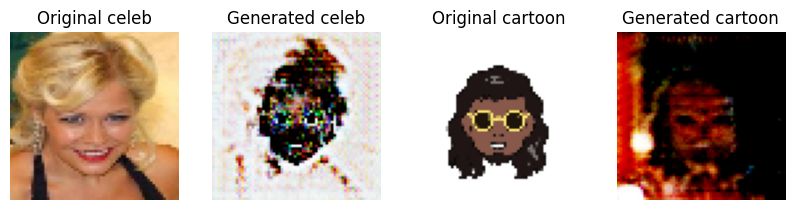

Batchs:   0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step



Batchs:   0%|          | 1/1000 [00:00<11:30,  1.45it/s]

>1, dA[0.055 ,0.062 ] dB[0.000 ,0.003] g[5.268 ,5.254]
1/1 [==============================] - 0s 29ms/step



Batchs:   0%|          | 2/1000 [00:01<10:35,  1.57it/s]

>2, dA[0.054 ,0.089 ] dB[0.002 ,0.003] g[4.682 ,4.979]
1/1 [==============================] - 0s 31ms/step



Batchs:   0%|          | 3/1000 [00:01<10:23,  1.60it/s]

>3, dA[0.069 ,0.012 ] dB[0.020 ,0.003] g[5.229 ,5.838]
1/1 [==============================] - 0s 27ms/step



Batchs:   0%|          | 4/1000 [00:02<10:11,  1.63it/s]

>4, dA[0.036 ,0.007 ] dB[0.004 ,0.173] g[4.592 ,4.966]
1/1 [==============================] - 0s 28ms/step



Batchs:   0%|          | 5/1000 [00:03<10:05,  1.64it/s]

>5, dA[0.013 ,0.297 ] dB[0.070 ,0.009] g[4.995 ,4.674]
1/1 [==============================] - 0s 29ms/step



Batchs:   1%|          | 6/1000 [00:03<10:01,  1.65it/s]

>6, dA[0.187 ,0.083 ] dB[0.003 ,0.005] g[5.286 ,5.592]
1/1 [==============================] - 0s 26ms/step



Batchs:   1%|          | 7/1000 [00:04<09:58,  1.66it/s]

>7, dA[0.042 ,0.011 ] dB[0.453 ,0.083] g[6.070 ,7.142]
1/1 [==============================] - 0s 32ms/step



Batchs:   1%|          | 8/1000 [00:04<10:01,  1.65it/s]

>8, dA[0.020 ,0.014 ] dB[0.052 ,0.033] g[5.221 ,5.328]
1/1 [==============================] - 0s 27ms/step



Batchs:   1%|          | 9/1000 [00:05<09:58,  1.66it/s]

>9, dA[0.010 ,0.005 ] dB[0.053 ,0.012] g[5.080 ,4.691]
1/1 [==============================] - 0s 30ms/step



Batchs:   1%|          | 10/1000 [00:06<09:59,  1.65it/s]

>10, dA[0.140 ,0.584 ] dB[0.011 ,0.013] g[4.828 ,4.206]
1/1 [==============================] - 0s 28ms/step



Batchs:   1%|          | 11/1000 [00:06<09:59,  1.65it/s]

>11, dA[0.033 ,0.009 ] dB[0.010 ,0.001] g[4.777 ,4.609]
1/1 [==============================] - 0s 29ms/step



Batchs:   1%|          | 12/1000 [00:07<09:57,  1.65it/s]

>12, dA[0.017 ,0.027 ] dB[0.001 ,0.001] g[4.946 ,4.681]
1/1 [==============================] - 0s 31ms/step



Batchs:   1%|▏         | 13/1000 [00:07<09:58,  1.65it/s]

>13, dA[0.005 ,0.147 ] dB[0.001 ,0.005] g[7.002 ,7.879]
1/1 [==============================] - 0s 28ms/step



Batchs:   1%|▏         | 14/1000 [00:08<09:58,  1.65it/s]

>14, dA[0.022 ,0.049 ] dB[0.003 ,0.009] g[4.313 ,3.948]
1/1 [==============================] - 0s 31ms/step



Batchs:   2%|▏         | 15/1000 [00:09<10:00,  1.64it/s]

>15, dA[0.183 ,0.093 ] dB[0.004 ,0.013] g[5.114 ,5.112]
1/1 [==============================] - 0s 28ms/step



Batchs:   2%|▏         | 16/1000 [00:09<10:02,  1.63it/s]

>16, dA[0.010 ,0.012 ] dB[0.017 ,0.010] g[5.142 ,6.142]
1/1 [==============================] - 0s 29ms/step



Batchs:   2%|▏         | 17/1000 [00:10<10:01,  1.64it/s]

>17, dA[0.098 ,0.009 ] dB[0.003 ,0.333] g[4.083 ,5.126]
1/1 [==============================] - 0s 30ms/step



Batchs:   2%|▏         | 18/1000 [00:10<09:58,  1.64it/s]

>18, dA[0.073 ,0.019 ] dB[0.734 ,0.013] g[5.761 ,5.271]
1/1 [==============================] - 0s 29ms/step



Batchs:   2%|▏         | 19/1000 [00:11<09:59,  1.64it/s]

>19, dA[0.026 ,0.642 ] dB[0.015 ,0.021] g[5.613 ,5.246]
1/1 [==============================] - 0s 29ms/step



Batchs:   2%|▏         | 20/1000 [00:12<09:57,  1.64it/s]

>20, dA[0.028 ,0.044 ] dB[0.213 ,0.064] g[5.336 ,5.152]
1/1 [==============================] - 0s 27ms/step



Batchs:   2%|▏         | 21/1000 [00:12<09:53,  1.65it/s]

>21, dA[0.124 ,0.066 ] dB[0.015 ,0.032] g[5.080 ,5.832]
1/1 [==============================] - 0s 27ms/step



Batchs:   2%|▏         | 22/1000 [00:13<09:49,  1.66it/s]

>22, dA[0.005 ,0.274 ] dB[0.008 ,0.005] g[4.678 ,4.459]
1/1 [==============================] - 0s 28ms/step



Batchs:   2%|▏         | 23/1000 [00:14<09:51,  1.65it/s]

>23, dA[0.108 ,0.015 ] dB[0.056 ,0.037] g[4.391 ,4.639]
1/1 [==============================] - 0s 28ms/step



Batchs:   2%|▏         | 24/1000 [00:14<09:49,  1.66it/s]

>24, dA[0.249 ,0.241 ] dB[0.003 ,0.012] g[5.830 ,6.127]
1/1 [==============================] - 0s 31ms/step



Batchs:   2%|▎         | 25/1000 [00:15<09:49,  1.66it/s]

>25, dA[0.115 ,0.013 ] dB[0.002 ,0.005] g[4.806 ,4.701]
1/1 [==============================] - 0s 29ms/step



Batchs:   3%|▎         | 26/1000 [00:15<09:48,  1.66it/s]

>26, dA[0.010 ,0.013 ] dB[0.054 ,0.018] g[6.606 ,7.180]
1/1 [==============================] - 0s 26ms/step



Batchs:   3%|▎         | 27/1000 [00:16<09:48,  1.65it/s]

>27, dA[0.005 ,0.222 ] dB[0.011 ,0.045] g[4.068 ,4.214]
1/1 [==============================] - 0s 28ms/step



Batchs:   3%|▎         | 28/1000 [00:17<09:50,  1.65it/s]

>28, dA[0.029 ,0.030 ] dB[0.010 ,0.007] g[4.684 ,4.548]
1/1 [==============================] - 0s 30ms/step



Batchs:   3%|▎         | 29/1000 [00:17<09:49,  1.65it/s]

>29, dA[0.025 ,0.008 ] dB[0.041 ,0.034] g[4.967 ,4.971]
1/1 [==============================] - 0s 28ms/step



Batchs:   3%|▎         | 30/1000 [00:18<09:49,  1.65it/s]

>30, dA[0.276 ,0.036 ] dB[0.002 ,0.015] g[4.557 ,5.207]
1/1 [==============================] - 0s 30ms/step



Batchs:   3%|▎         | 31/1000 [00:18<09:51,  1.64it/s]

>31, dA[0.007 ,0.190 ] dB[0.005 ,0.013] g[4.543 ,4.125]
1/1 [==============================] - 0s 31ms/step



Batchs:   3%|▎         | 32/1000 [00:19<09:53,  1.63it/s]

>32, dA[0.035 ,0.052 ] dB[0.009 ,0.008] g[4.638 ,4.507]
1/1 [==============================] - 0s 30ms/step



Batchs:   3%|▎         | 33/1000 [00:20<09:54,  1.63it/s]

>33, dA[0.031 ,0.014 ] dB[0.002 ,0.004] g[4.782 ,4.853]
1/1 [==============================] - 0s 30ms/step



Batchs:   3%|▎         | 34/1000 [00:20<09:50,  1.64it/s]

>34, dA[0.009 ,0.002 ] dB[0.015 ,0.084] g[4.373 ,4.815]
1/1 [==============================] - 0s 27ms/step



Batchs:   4%|▎         | 35/1000 [00:21<09:47,  1.64it/s]

>35, dA[0.003 ,0.004 ] dB[0.005 ,0.041] g[5.850 ,4.880]
1/1 [==============================] - 0s 26ms/step



Batchs:   4%|▎         | 36/1000 [00:21<09:44,  1.65it/s]

>36, dA[0.025 ,0.238 ] dB[0.555 ,0.089] g[5.316 ,4.819]
1/1 [==============================] - 0s 28ms/step



Batchs:   4%|▎         | 37/1000 [00:22<09:44,  1.65it/s]

>37, dA[0.003 ,0.064 ] dB[0.037 ,0.097] g[5.875 ,6.540]
1/1 [==============================] - 0s 31ms/step



Batchs:   4%|▍         | 38/1000 [00:23<09:44,  1.65it/s]

>38, dA[0.111 ,0.013 ] dB[0.007 ,0.041] g[5.000 ,5.899]
1/1 [==============================] - 0s 27ms/step



Batchs:   4%|▍         | 39/1000 [00:23<09:41,  1.65it/s]

>39, dA[0.278 ,0.055 ] dB[0.007 ,0.017] g[3.898 ,4.058]
1/1 [==============================] - 0s 27ms/step



Batchs:   4%|▍         | 40/1000 [00:24<09:38,  1.66it/s]

>40, dA[0.006 ,0.005 ] dB[0.017 ,0.008] g[6.955 ,7.503]
1/1 [==============================] - 0s 29ms/step



Batchs:   4%|▍         | 41/1000 [00:24<09:37,  1.66it/s]

>41, dA[0.001 ,0.022 ] dB[0.011 ,0.006] g[6.351 ,7.041]
1/1 [==============================] - 0s 29ms/step



Batchs:   4%|▍         | 42/1000 [00:25<09:35,  1.66it/s]

>42, dA[0.011 ,0.333 ] dB[0.004 ,0.003] g[4.961 ,4.354]
1/1 [==============================] - 0s 31ms/step



Batchs:   4%|▍         | 43/1000 [00:26<09:40,  1.65it/s]

>43, dA[0.174 ,0.010 ] dB[0.003 ,0.005] g[4.923 ,4.814]
1/1 [==============================] - 0s 29ms/step



Batchs:   4%|▍         | 44/1000 [00:26<09:37,  1.65it/s]

>44, dA[0.168 ,0.070 ] dB[0.004 ,0.006] g[5.216 ,4.857]
1/1 [==============================] - 0s 30ms/step



Batchs:   4%|▍         | 45/1000 [00:27<09:37,  1.65it/s]

>45, dA[0.015 ,0.118 ] dB[0.002 ,0.005] g[7.845 ,8.856]
1/1 [==============================] - 0s 27ms/step



Batchs:   5%|▍         | 46/1000 [00:27<09:33,  1.66it/s]

>46, dA[0.281 ,0.002 ] dB[0.002 ,0.002] g[4.573 ,4.914]
1/1 [==============================] - 0s 28ms/step



Batchs:   5%|▍         | 47/1000 [00:28<09:35,  1.66it/s]

>47, dA[0.005 ,0.037 ] dB[0.001 ,0.010] g[4.412 ,4.393]
1/1 [==============================] - 0s 29ms/step



Batchs:   5%|▍         | 48/1000 [00:29<09:35,  1.65it/s]

>48, dA[0.043 ,0.104 ] dB[0.033 ,0.039] g[5.454 ,5.529]
1/1 [==============================] - 0s 27ms/step



Batchs:   5%|▍         | 49/1000 [00:29<09:36,  1.65it/s]

>49, dA[0.109 ,0.008 ] dB[0.002 ,0.004] g[5.463 ,4.780]
1/1 [==============================] - 0s 27ms/step



Batchs:   5%|▌         | 50/1000 [00:30<09:34,  1.65it/s]

>50, dA[0.033 ,0.112 ] dB[0.179 ,0.037] g[4.260 ,3.604]
1/1 [==============================] - 0s 27ms/step



Batchs:   5%|▌         | 51/1000 [00:30<09:32,  1.66it/s]

>51, dA[0.032 ,0.345 ] dB[0.010 ,0.425] g[3.715 ,4.234]
1/1 [==============================] - 0s 33ms/step



Batchs:   5%|▌         | 52/1000 [00:31<09:31,  1.66it/s]

>52, dA[0.008 ,0.008 ] dB[0.077 ,0.030] g[7.210 ,7.029]
1/1 [==============================] - 0s 28ms/step



Batchs:   5%|▌         | 53/1000 [00:32<09:28,  1.67it/s]

>53, dA[0.147 ,0.010 ] dB[0.204 ,0.026] g[5.722 ,6.224]
1/1 [==============================] - 0s 28ms/step



Batchs:   5%|▌         | 54/1000 [00:32<09:29,  1.66it/s]

>54, dA[0.101 ,0.021 ] dB[0.019 ,0.205] g[4.852 ,5.506]
1/1 [==============================] - 0s 28ms/step



Batchs:   6%|▌         | 55/1000 [00:33<09:27,  1.67it/s]

>55, dA[0.024 ,0.022 ] dB[0.026 ,0.011] g[4.252 ,4.149]
1/1 [==============================] - 0s 30ms/step



Batchs:   6%|▌         | 56/1000 [00:33<09:29,  1.66it/s]

>56, dA[0.011 ,0.004 ] dB[0.022 ,0.003] g[6.029 ,5.674]
1/1 [==============================] - 0s 31ms/step



Batchs:   6%|▌         | 57/1000 [00:34<09:31,  1.65it/s]

>57, dA[0.003 ,0.005 ] dB[0.007 ,0.005] g[4.496 ,4.128]
1/1 [==============================] - 0s 30ms/step



Batchs:   6%|▌         | 58/1000 [00:35<09:30,  1.65it/s]

>58, dA[0.016 ,0.006 ] dB[0.003 ,0.091] g[4.932 ,5.048]
1/1 [==============================] - 0s 27ms/step



Batchs:   6%|▌         | 59/1000 [00:35<09:28,  1.66it/s]

>59, dA[0.054 ,0.625 ] dB[0.350 ,0.006] g[3.569 ,3.274]
1/1 [==============================] - 0s 31ms/step



Batchs:   6%|▌         | 60/1000 [00:36<09:28,  1.65it/s]

>60, dA[0.037 ,0.025 ] dB[0.090 ,0.099] g[4.841 ,5.070]
1/1 [==============================] - 0s 28ms/step



Batchs:   6%|▌         | 61/1000 [00:37<09:27,  1.66it/s]

>61, dA[0.050 ,0.051 ] dB[0.015 ,0.017] g[5.026 ,5.217]
1/1 [==============================] - 0s 25ms/step



Batchs:   6%|▌         | 62/1000 [00:37<09:23,  1.67it/s]

>62, dA[0.020 ,0.024 ] dB[0.004 ,0.002] g[4.753 ,4.509]
1/1 [==============================] - 0s 29ms/step



Batchs:   6%|▋         | 63/1000 [00:38<09:26,  1.66it/s]

>63, dA[0.225 ,0.010 ] dB[0.064 ,0.045] g[4.690 ,4.755]
1/1 [==============================] - 0s 32ms/step



Batchs:   6%|▋         | 64/1000 [00:38<09:26,  1.65it/s]

>64, dA[0.010 ,0.008 ] dB[0.016 ,0.037] g[4.502 ,4.226]
1/1 [==============================] - 0s 28ms/step



Batchs:   6%|▋         | 65/1000 [00:39<09:23,  1.66it/s]

>65, dA[0.006 ,0.020 ] dB[0.007 ,0.014] g[5.602 ,5.848]
1/1 [==============================] - 0s 27ms/step



Batchs:   7%|▋         | 66/1000 [00:40<09:25,  1.65it/s]

>66, dA[0.011 ,0.415 ] dB[0.005 ,0.001] g[4.622 ,4.069]
1/1 [==============================] - 0s 26ms/step



Batchs:   7%|▋         | 67/1000 [00:40<09:25,  1.65it/s]

>67, dA[0.099 ,0.012 ] dB[0.003 ,0.005] g[5.896 ,6.585]
1/1 [==============================] - 0s 28ms/step



Batchs:   7%|▋         | 68/1000 [00:41<09:20,  1.66it/s]

>68, dA[0.092 ,0.008 ] dB[0.010 ,0.001] g[5.130 ,5.146]
1/1 [==============================] - 0s 27ms/step



Batchs:   7%|▋         | 69/1000 [00:41<09:17,  1.67it/s]

>69, dA[0.025 ,0.100 ] dB[0.003 ,0.009] g[4.742 ,4.453]
1/1 [==============================] - 0s 24ms/step



Batchs:   7%|▋         | 70/1000 [00:42<09:14,  1.68it/s]

>70, dA[0.036 ,0.019 ] dB[0.006 ,0.005] g[4.610 ,5.158]
1/1 [==============================] - 0s 25ms/step



Batchs:   7%|▋         | 71/1000 [00:43<09:17,  1.67it/s]

>71, dA[0.064 ,0.176 ] dB[0.006 ,0.071] g[4.293 ,5.240]
1/1 [==============================] - 0s 25ms/step



Batchs:   7%|▋         | 72/1000 [00:43<09:13,  1.68it/s]

>72, dA[0.098 ,0.003 ] dB[0.284 ,0.376] g[5.391 ,4.841]
1/1 [==============================] - 0s 25ms/step



Batchs:   7%|▋         | 73/1000 [00:44<09:11,  1.68it/s]

>73, dA[0.003 ,0.128 ] dB[0.008 ,0.015] g[4.345 ,4.457]
1/1 [==============================] - 0s 26ms/step



Batchs:   7%|▋         | 74/1000 [00:44<09:09,  1.68it/s]

>74, dA[0.026 ,0.004 ] dB[0.060 ,0.002] g[5.902 ,7.038]
1/1 [==============================] - 0s 25ms/step



Batchs:   8%|▊         | 75/1000 [00:45<09:09,  1.68it/s]

>75, dA[0.037 ,0.027 ] dB[0.016 ,0.055] g[4.930 ,5.702]
1/1 [==============================] - 0s 25ms/step



Batchs:   8%|▊         | 76/1000 [00:45<09:07,  1.69it/s]

>76, dA[0.024 ,0.007 ] dB[0.088 ,0.035] g[4.226 ,5.267]
1/1 [==============================] - 0s 24ms/step



Batchs:   8%|▊         | 77/1000 [00:46<09:03,  1.70it/s]

>77, dA[0.029 ,0.146 ] dB[0.001 ,0.022] g[3.971 ,4.398]
1/1 [==============================] - 0s 25ms/step



Batchs:   8%|▊         | 78/1000 [00:47<09:01,  1.70it/s]

>78, dA[0.066 ,0.111 ] dB[0.026 ,0.009] g[4.199 ,4.648]
1/1 [==============================] - 0s 23ms/step



Batchs:   8%|▊         | 79/1000 [00:47<09:00,  1.71it/s]

>79, dA[0.150 ,0.046 ] dB[0.009 ,0.383] g[5.028 ,5.841]
1/1 [==============================] - 0s 23ms/step



Batchs:   8%|▊         | 80/1000 [00:48<09:05,  1.69it/s]

>80, dA[0.055 ,0.077 ] dB[0.482 ,0.031] g[6.075 ,6.263]
1/1 [==============================] - 0s 30ms/step



Batchs:   8%|▊         | 81/1000 [00:48<09:05,  1.68it/s]

>81, dA[0.204 ,0.020 ] dB[0.002 ,0.006] g[5.361 ,6.272]
1/1 [==============================] - 0s 28ms/step



Batchs:   8%|▊         | 82/1000 [00:49<09:08,  1.67it/s]

>82, dA[0.033 ,0.010 ] dB[0.004 ,0.012] g[4.905 ,5.637]
1/1 [==============================] - 0s 27ms/step



Batchs:   8%|▊         | 83/1000 [00:50<09:10,  1.67it/s]

>83, dA[0.005 ,0.195 ] dB[0.249 ,0.070] g[7.210 ,8.180]
1/1 [==============================] - 0s 25ms/step



Batchs:   8%|▊         | 84/1000 [00:50<09:06,  1.68it/s]

>84, dA[0.220 ,0.088 ] dB[0.013 ,0.016] g[4.199 ,4.958]
1/1 [==============================] - 0s 22ms/step



Batchs:   8%|▊         | 85/1000 [00:51<08:59,  1.70it/s]

>85, dA[0.009 ,0.015 ] dB[0.007 ,0.215] g[4.507 ,6.969]
1/1 [==============================] - 0s 28ms/step



Batchs:   9%|▊         | 86/1000 [00:51<09:00,  1.69it/s]

>86, dA[0.050 ,0.184 ] dB[0.065 ,0.023] g[6.652 ,5.776]
1/1 [==============================] - 0s 24ms/step



Batchs:   9%|▊         | 87/1000 [00:52<08:59,  1.69it/s]

>87, dA[0.163 ,0.014 ] dB[0.070 ,0.014] g[5.239 ,5.032]
1/1 [==============================] - 0s 24ms/step



Batchs:   9%|▉         | 88/1000 [00:53<08:55,  1.70it/s]

>88, dA[0.029 ,0.007 ] dB[0.003 ,0.018] g[5.172 ,4.771]
1/1 [==============================] - 0s 24ms/step



Batchs:   9%|▉         | 89/1000 [00:53<08:55,  1.70it/s]

>89, dA[0.006 ,0.328 ] dB[0.007 ,0.034] g[4.143 ,4.271]
1/1 [==============================] - 0s 23ms/step



Batchs:   9%|▉         | 90/1000 [00:54<08:52,  1.71it/s]

>90, dA[0.007 ,0.032 ] dB[0.003 ,0.018] g[6.336 ,6.020]
1/1 [==============================] - 0s 24ms/step



Batchs:   9%|▉         | 91/1000 [00:54<08:50,  1.71it/s]

>91, dA[0.218 ,0.030 ] dB[0.002 ,0.004] g[5.585 ,5.708]
1/1 [==============================] - 0s 24ms/step



Batchs:   9%|▉         | 92/1000 [00:55<08:50,  1.71it/s]

>92, dA[0.255 ,0.008 ] dB[0.016 ,0.003] g[4.649 ,4.693]
1/1 [==============================] - 0s 25ms/step



Batchs:   9%|▉         | 93/1000 [00:55<08:48,  1.71it/s]

>93, dA[0.033 ,0.432 ] dB[0.004 ,0.002] g[5.472 ,5.085]
1/1 [==============================] - 0s 23ms/step



Batchs:   9%|▉         | 94/1000 [00:56<08:44,  1.73it/s]

>94, dA[0.050 ,0.023 ] dB[0.001 ,0.012] g[5.186 ,5.306]
1/1 [==============================] - 0s 22ms/step



Batchs:  10%|▉         | 95/1000 [00:57<08:44,  1.73it/s]

>95, dA[0.256 ,0.093 ] dB[0.004 ,0.004] g[5.113 ,5.013]
1/1 [==============================] - 0s 22ms/step



Batchs:  10%|▉         | 96/1000 [00:57<08:41,  1.73it/s]

>96, dA[0.014 ,0.006 ] dB[0.001 ,0.003] g[5.607 ,5.852]
1/1 [==============================] - 0s 24ms/step



Batchs:  10%|▉         | 97/1000 [00:58<08:40,  1.74it/s]

>97, dA[0.003 ,0.100 ] dB[0.001 ,0.004] g[5.695 ,5.911]
1/1 [==============================] - 0s 24ms/step



Batchs:  10%|▉         | 98/1000 [00:58<08:38,  1.74it/s]

>98, dA[0.008 ,0.050 ] dB[0.001 ,0.008] g[7.923 ,9.350]
1/1 [==============================] - 0s 26ms/step



Batchs:  10%|▉         | 99/1000 [00:59<08:42,  1.73it/s]

>99, dA[0.190 ,0.123 ] dB[0.099 ,0.011] g[5.487 ,5.914]
1/1 [==============================] - 0s 23ms/step



Batchs:  10%|█         | 100/1000 [01:00<08:44,  1.72it/s]

>100, dA[0.092 ,0.085 ] dB[0.029 ,0.391] g[6.721 ,9.118]
1/1 [==============================] - 0s 23ms/step



Batchs:  10%|█         | 101/1000 [01:00<08:40,  1.73it/s]

>101, dA[0.215 ,0.340 ] dB[0.126 ,0.006] g[4.293 ,4.027]
1/1 [==============================] - 0s 23ms/step



Batchs:  10%|█         | 102/1000 [01:01<08:38,  1.73it/s]

>102, dA[0.011 ,0.010 ] dB[0.034 ,0.005] g[6.411 ,6.550]
1/1 [==============================] - 0s 27ms/step



Batchs:  10%|█         | 103/1000 [01:01<08:43,  1.72it/s]

>103, dA[0.171 ,0.038 ] dB[0.031 ,0.004] g[5.332 ,6.188]
1/1 [==============================] - 0s 23ms/step



Batchs:  10%|█         | 104/1000 [01:02<08:41,  1.72it/s]

>104, dA[0.006 ,0.015 ] dB[0.010 ,0.003] g[3.791 ,4.442]
1/1 [==============================] - 0s 22ms/step



Batchs:  10%|█         | 105/1000 [01:02<08:36,  1.73it/s]

>105, dA[0.061 ,0.136 ] dB[0.002 ,0.006] g[3.770 ,4.452]
1/1 [==============================] - 0s 21ms/step



Batchs:  11%|█         | 106/1000 [01:03<08:33,  1.74it/s]

>106, dA[0.002 ,0.025 ] dB[0.003 ,0.001] g[4.420 ,4.642]
1/1 [==============================] - 0s 23ms/step



Batchs:  11%|█         | 107/1000 [01:04<08:36,  1.73it/s]

>107, dA[0.039 ,0.010 ] dB[0.001 ,0.232] g[4.714 ,5.812]
1/1 [==============================] - 0s 22ms/step



Batchs:  11%|█         | 108/1000 [01:04<08:33,  1.74it/s]

>108, dA[0.003 ,0.035 ] dB[0.038 ,0.025] g[4.798 ,3.759]
1/1 [==============================] - 0s 23ms/step



Batchs:  11%|█         | 109/1000 [01:05<08:33,  1.73it/s]

>109, dA[0.005 ,0.010 ] dB[0.145 ,0.014] g[7.736 ,8.571]
1/1 [==============================] - 0s 22ms/step



Batchs:  11%|█         | 110/1000 [01:05<08:32,  1.74it/s]

>110, dA[0.083 ,0.044 ] dB[0.008 ,0.008] g[4.787 ,5.736]
1/1 [==============================] - 0s 28ms/step



Batchs:  11%|█         | 111/1000 [01:06<08:38,  1.72it/s]

>111, dA[0.003 ,0.018 ] dB[0.003 ,0.018] g[7.161 ,9.337]
1/1 [==============================] - 0s 23ms/step



Batchs:  11%|█         | 112/1000 [01:06<08:36,  1.72it/s]

>112, dA[0.013 ,0.002 ] dB[0.002 ,0.007] g[7.239 ,8.801]
1/1 [==============================] - 0s 22ms/step



Batchs:  11%|█▏        | 113/1000 [01:07<08:33,  1.73it/s]

>113, dA[0.028 ,0.163 ] dB[0.139 ,0.158] g[5.872 ,4.716]
1/1 [==============================] - 0s 25ms/step



Batchs:  11%|█▏        | 114/1000 [01:08<08:34,  1.72it/s]

>114, dA[0.004 ,0.031 ] dB[0.002 ,0.021] g[7.642 ,8.791]
1/1 [==============================] - 0s 25ms/step



Batchs:  12%|█▏        | 115/1000 [01:08<08:35,  1.72it/s]

>115, dA[0.436 ,0.028 ] dB[0.046 ,0.013] g[4.596 ,5.410]
1/1 [==============================] - 0s 25ms/step



Batchs:  12%|█▏        | 116/1000 [01:09<08:34,  1.72it/s]

>116, dA[0.015 ,0.003 ] dB[0.004 ,0.003] g[7.505 ,8.338]
1/1 [==============================] - 0s 23ms/step



Batchs:  12%|█▏        | 117/1000 [01:09<08:34,  1.72it/s]

>117, dA[0.005 ,0.020 ] dB[0.003 ,0.002] g[4.729 ,4.141]
1/1 [==============================] - 0s 25ms/step



Batchs:  12%|█▏        | 118/1000 [01:10<08:34,  1.71it/s]

>118, dA[0.079 ,0.293 ] dB[0.001 ,0.004] g[7.035 ,7.485]
1/1 [==============================] - 0s 23ms/step



Batchs:  12%|█▏        | 119/1000 [01:11<08:36,  1.70it/s]

>119, dA[0.015 ,0.033 ] dB[0.005 ,0.006] g[7.271 ,7.947]
1/1 [==============================] - 0s 25ms/step



Batchs:  12%|█▏        | 120/1000 [01:11<08:38,  1.70it/s]

>120, dA[0.413 ,0.027 ] dB[0.001 ,0.001] g[6.099 ,6.832]
1/1 [==============================] - 0s 22ms/step



Batchs:  12%|█▏        | 121/1000 [01:12<08:35,  1.71it/s]

>121, dA[0.009 ,0.003 ] dB[0.008 ,0.002] g[7.138 ,8.305]
1/1 [==============================] - 0s 21ms/step



Batchs:  12%|█▏        | 122/1000 [01:12<08:31,  1.72it/s]

>122, dA[0.116 ,0.136 ] dB[0.005 ,0.005] g[5.352 ,5.857]
1/1 [==============================] - 0s 23ms/step



Batchs:  12%|█▏        | 123/1000 [01:13<08:32,  1.71it/s]

>123, dA[0.023 ,0.008 ] dB[0.033 ,0.009] g[4.858 ,5.024]
1/1 [==============================] - 0s 25ms/step



Batchs:  12%|█▏        | 124/1000 [01:13<08:34,  1.70it/s]

>124, dA[0.006 ,0.050 ] dB[0.004 ,0.011] g[5.727 ,6.362]
1/1 [==============================] - 0s 24ms/step



Batchs:  12%|█▎        | 125/1000 [01:14<08:30,  1.71it/s]

>125, dA[0.010 ,0.010 ] dB[0.026 ,0.017] g[5.219 ,5.481]
1/1 [==============================] - 0s 23ms/step



Batchs:  13%|█▎        | 126/1000 [01:15<08:29,  1.72it/s]

>126, dA[0.012 ,0.089 ] dB[0.003 ,0.003] g[6.447 ,7.750]
1/1 [==============================] - 0s 24ms/step



Batchs:  13%|█▎        | 127/1000 [01:15<08:31,  1.71it/s]

>127, dA[0.235 ,0.056 ] dB[0.005 ,0.011] g[5.313 ,6.323]
1/1 [==============================] - 0s 24ms/step



Batchs:  13%|█▎        | 128/1000 [01:16<08:27,  1.72it/s]

>128, dA[0.006 ,0.021 ] dB[0.008 ,0.004] g[7.428 ,8.829]
1/1 [==============================] - 0s 23ms/step



Batchs:  13%|█▎        | 129/1000 [01:16<08:26,  1.72it/s]

>129, dA[0.021 ,0.038 ] dB[0.046 ,0.177] g[4.283 ,4.641]
1/1 [==============================] - 0s 23ms/step



Batchs:  13%|█▎        | 130/1000 [01:17<08:24,  1.72it/s]

>130, dA[0.334 ,0.009 ] dB[0.009 ,0.013] g[5.155 ,4.973]
1/1 [==============================] - 0s 22ms/step



Batchs:  13%|█▎        | 131/1000 [01:18<08:23,  1.72it/s]

>131, dA[0.026 ,0.564 ] dB[0.010 ,0.003] g[5.567 ,5.033]
1/1 [==============================] - 0s 25ms/step



Batchs:  13%|█▎        | 132/1000 [01:18<08:24,  1.72it/s]

>132, dA[0.074 ,0.067 ] dB[0.127 ,0.030] g[4.860 ,4.708]
1/1 [==============================] - 0s 22ms/step



Batchs:  13%|█▎        | 133/1000 [01:19<08:22,  1.72it/s]

>133, dA[0.155 ,0.186 ] dB[0.030 ,0.024] g[4.830 ,5.102]
1/1 [==============================] - 0s 26ms/step



Batchs:  13%|█▎        | 134/1000 [01:19<08:27,  1.71it/s]

>134, dA[0.017 ,0.004 ] dB[0.006 ,0.007] g[4.948 ,4.922]
1/1 [==============================] - 0s 30ms/step



Batchs:  14%|█▎        | 135/1000 [01:20<08:33,  1.69it/s]

>135, dA[0.004 ,0.012 ] dB[0.015 ,0.010] g[6.024 ,6.576]
1/1 [==============================] - 0s 27ms/step



Batchs:  14%|█▎        | 136/1000 [01:21<08:32,  1.68it/s]

>136, dA[0.027 ,0.188 ] dB[0.005 ,0.011] g[7.073 ,7.303]
1/1 [==============================] - 0s 24ms/step



Batchs:  14%|█▎        | 137/1000 [01:21<08:28,  1.70it/s]

>137, dA[0.280 ,0.167 ] dB[0.003 ,0.010] g[4.464 ,4.368]
1/1 [==============================] - 0s 26ms/step



Batchs:  14%|█▍        | 138/1000 [01:22<08:27,  1.70it/s]

>138, dA[0.009 ,0.036 ] dB[0.002 ,0.004] g[7.438 ,8.378]
1/1 [==============================] - 0s 23ms/step



Batchs:  14%|█▍        | 139/1000 [01:22<08:25,  1.70it/s]

>139, dA[0.049 ,0.037 ] dB[0.007 ,0.007] g[6.920 ,7.981]
1/1 [==============================] - 0s 25ms/step



Batchs:  14%|█▍        | 140/1000 [01:23<08:24,  1.70it/s]

>140, dA[0.004 ,0.003 ] dB[0.052 ,0.019] g[4.702 ,5.410]
1/1 [==============================] - 0s 23ms/step



Batchs:  14%|█▍        | 141/1000 [01:23<08:22,  1.71it/s]

>141, dA[0.031 ,0.035 ] dB[0.029 ,0.288] g[4.766 ,6.071]
1/1 [==============================] - 0s 22ms/step



Batchs:  14%|█▍        | 142/1000 [01:24<08:19,  1.72it/s]

>142, dA[0.006 ,0.010 ] dB[0.037 ,0.042] g[5.953 ,5.325]
1/1 [==============================] - 0s 25ms/step



Batchs:  14%|█▍        | 143/1000 [01:25<08:21,  1.71it/s]

>143, dA[0.169 ,0.363 ] dB[0.025 ,0.009] g[5.779 ,5.593]
1/1 [==============================] - 0s 23ms/step



Batchs:  14%|█▍        | 144/1000 [01:25<08:17,  1.72it/s]

>144, dA[0.116 ,0.151 ] dB[0.427 ,0.041] g[5.364 ,6.732]
1/1 [==============================] - 0s 23ms/step



Batchs:  14%|█▍        | 145/1000 [01:26<08:14,  1.73it/s]

>145, dA[0.009 ,0.008 ] dB[0.038 ,0.089] g[4.048 ,4.268]
1/1 [==============================] - 0s 26ms/step



Batchs:  15%|█▍        | 146/1000 [01:26<08:16,  1.72it/s]

>146, dA[0.004 ,0.002 ] dB[0.024 ,0.027] g[5.006 ,5.930]
1/1 [==============================] - 0s 23ms/step



Batchs:  15%|█▍        | 147/1000 [01:27<08:17,  1.72it/s]

>147, dA[0.047 ,0.028 ] dB[0.007 ,0.013] g[4.828 ,5.537]
1/1 [==============================] - 0s 23ms/step



Batchs:  15%|█▍        | 148/1000 [01:27<08:13,  1.73it/s]

>148, dA[0.182 ,0.122 ] dB[0.104 ,0.052] g[4.721 ,4.960]
1/1 [==============================] - 0s 22ms/step



Batchs:  15%|█▍        | 149/1000 [01:28<08:09,  1.74it/s]

>149, dA[0.037 ,0.063 ] dB[0.011 ,0.062] g[4.874 ,5.375]
1/1 [==============================] - 0s 22ms/step



Batchs:  15%|█▌        | 150/1000 [01:29<08:07,  1.74it/s]

>150, dA[0.048 ,0.025 ] dB[0.011 ,0.012] g[5.541 ,5.344]
1/1 [==============================] - 0s 24ms/step



Batchs:  15%|█▌        | 151/1000 [01:29<08:11,  1.73it/s]

>151, dA[0.002 ,0.013 ] dB[0.007 ,0.014] g[3.959 ,4.466]
1/1 [==============================] - 0s 25ms/step



Batchs:  15%|█▌        | 152/1000 [01:30<08:12,  1.72it/s]

>152, dA[0.117 ,0.030 ] dB[0.017 ,0.008] g[5.117 ,6.079]
1/1 [==============================] - 0s 22ms/step



Batchs:  15%|█▌        | 153/1000 [01:30<08:08,  1.73it/s]

>153, dA[0.028 ,0.009 ] dB[0.006 ,0.005] g[4.067 ,3.925]
1/1 [==============================] - 0s 22ms/step



Batchs:  15%|█▌        | 154/1000 [01:31<08:08,  1.73it/s]

>154, dA[0.013 ,0.268 ] dB[0.014 ,0.044] g[5.016 ,5.213]
1/1 [==============================] - 0s 24ms/step



Batchs:  16%|█▌        | 155/1000 [01:32<08:10,  1.72it/s]

>155, dA[0.081 ,0.009 ] dB[0.002 ,0.018] g[5.345 ,6.693]
1/1 [==============================] - 0s 25ms/step



Batchs:  16%|█▌        | 156/1000 [01:32<08:10,  1.72it/s]

>156, dA[0.012 ,0.024 ] dB[0.003 ,0.009] g[6.661 ,8.041]
1/1 [==============================] - 0s 25ms/step



Batchs:  16%|█▌        | 157/1000 [01:33<08:10,  1.72it/s]

>157, dA[0.091 ,0.109 ] dB[0.002 ,0.016] g[5.057 ,5.704]
1/1 [==============================] - 0s 23ms/step



Batchs:  16%|█▌        | 158/1000 [01:33<08:06,  1.73it/s]

>158, dA[0.121 ,0.009 ] dB[0.001 ,0.006] g[5.140 ,5.362]
1/1 [==============================] - 0s 22ms/step



Batchs:  16%|█▌        | 159/1000 [01:34<08:05,  1.73it/s]

>159, dA[0.019 ,0.005 ] dB[0.020 ,0.002] g[5.134 ,4.442]
1/1 [==============================] - 0s 23ms/step



Batchs:  16%|█▌        | 160/1000 [01:34<08:06,  1.73it/s]

>160, dA[0.053 ,0.009 ] dB[0.006 ,0.003] g[5.657 ,5.307]
1/1 [==============================] - 0s 21ms/step



Batchs:  16%|█▌        | 161/1000 [01:35<08:04,  1.73it/s]

>161, dA[0.022 ,0.006 ] dB[0.008 ,0.003] g[4.726 ,4.446]
1/1 [==============================] - 0s 22ms/step



Batchs:  16%|█▌        | 162/1000 [01:36<08:04,  1.73it/s]

>162, dA[0.049 ,0.464 ] dB[0.001 ,0.004] g[5.180 ,4.431]
1/1 [==============================] - 0s 24ms/step



Batchs:  16%|█▋        | 163/1000 [01:36<08:04,  1.73it/s]

>163, dA[0.050 ,0.023 ] dB[0.003 ,0.002] g[4.705 ,4.399]
1/1 [==============================] - 0s 22ms/step



Batchs:  16%|█▋        | 164/1000 [01:37<08:01,  1.74it/s]

>164, dA[0.099 ,0.002 ] dB[0.000 ,0.004] g[5.072 ,5.200]
1/1 [==============================] - 0s 21ms/step



Batchs:  16%|█▋        | 165/1000 [01:37<07:59,  1.74it/s]

>165, dA[0.007 ,0.022 ] dB[0.002 ,0.005] g[4.406 ,4.125]
1/1 [==============================] - 0s 24ms/step



Batchs:  17%|█▋        | 166/1000 [01:38<08:00,  1.74it/s]

>166, dA[0.012 ,0.109 ] dB[0.003 ,0.005] g[4.234 ,4.052]
1/1 [==============================] - 0s 23ms/step



Batchs:  17%|█▋        | 167/1000 [01:38<07:59,  1.74it/s]

>167, dA[0.023 ,0.003 ] dB[0.005 ,0.001] g[5.541 ,6.265]
1/1 [==============================] - 0s 21ms/step



Batchs:  17%|█▋        | 168/1000 [01:39<07:57,  1.74it/s]

>168, dA[0.151 ,0.018 ] dB[0.003 ,0.023] g[4.156 ,4.203]
1/1 [==============================] - 0s 22ms/step



Batchs:  17%|█▋        | 169/1000 [01:40<07:57,  1.74it/s]

>169, dA[0.005 ,0.229 ] dB[0.006 ,0.013] g[4.526 ,4.429]
1/1 [==============================] - 0s 22ms/step



Batchs:  17%|█▋        | 170/1000 [01:40<07:56,  1.74it/s]

>170, dA[0.063 ,0.040 ] dB[0.338 ,0.528] g[4.613 ,4.670]
1/1 [==============================] - 0s 23ms/step



Batchs:  17%|█▋        | 171/1000 [01:41<07:56,  1.74it/s]

>171, dA[0.242 ,0.010 ] dB[0.017 ,0.010] g[5.470 ,6.220]
1/1 [==============================] - 0s 25ms/step



Batchs:  17%|█▋        | 172/1000 [01:41<07:59,  1.73it/s]

>172, dA[0.007 ,0.251 ] dB[0.043 ,0.006] g[6.307 ,6.679]
1/1 [==============================] - 0s 25ms/step



Batchs:  17%|█▋        | 173/1000 [01:42<07:58,  1.73it/s]

>173, dA[0.009 ,0.040 ] dB[0.013 ,0.010] g[4.789 ,5.754]
1/1 [==============================] - 0s 21ms/step



Batchs:  17%|█▋        | 174/1000 [01:42<07:56,  1.73it/s]

>174, dA[0.060 ,0.019 ] dB[0.001 ,0.008] g[5.472 ,6.535]
1/1 [==============================] - 0s 24ms/step



Batchs:  18%|█▊        | 175/1000 [01:43<07:58,  1.73it/s]

>175, dA[0.007 ,0.016 ] dB[0.003 ,0.002] g[7.240 ,8.231]
1/1 [==============================] - 0s 24ms/step



Batchs:  18%|█▊        | 176/1000 [01:44<07:57,  1.72it/s]

>176, dA[0.047 ,0.003 ] dB[0.004 ,0.039] g[5.701 ,6.248]
1/1 [==============================] - 0s 25ms/step



Batchs:  18%|█▊        | 177/1000 [01:44<07:57,  1.72it/s]

>177, dA[0.060 ,0.007 ] dB[0.022 ,0.006] g[5.134 ,4.942]
1/1 [==============================] - 0s 24ms/step



Batchs:  18%|█▊        | 178/1000 [01:45<07:55,  1.73it/s]

>178, dA[0.014 ,0.501 ] dB[0.006 ,0.002] g[4.482 ,3.530]
1/1 [==============================] - 0s 22ms/step



Batchs:  18%|█▊        | 179/1000 [01:45<07:56,  1.72it/s]

>179, dA[0.010 ,0.024 ] dB[0.110 ,0.006] g[6.268 ,6.607]
1/1 [==============================] - 0s 23ms/step



Batchs:  18%|█▊        | 180/1000 [01:46<07:54,  1.73it/s]

>180, dA[0.212 ,0.064 ] dB[0.033 ,0.580] g[3.961 ,4.888]
1/1 [==============================] - 0s 23ms/step



Batchs:  18%|█▊        | 181/1000 [01:47<07:53,  1.73it/s]

>181, dA[0.014 ,0.025 ] dB[0.092 ,0.065] g[4.772 ,5.310]
1/1 [==============================] - 0s 24ms/step



Batchs:  18%|█▊        | 182/1000 [01:47<07:55,  1.72it/s]

>182, dA[0.005 ,0.079 ] dB[0.033 ,0.196] g[5.012 ,6.043]
1/1 [==============================] - 0s 25ms/step



Batchs:  18%|█▊        | 183/1000 [01:48<07:56,  1.71it/s]

>183, dA[0.006 ,0.004 ] dB[0.083 ,0.011] g[6.279 ,6.981]
1/1 [==============================] - 0s 27ms/step



Batchs:  18%|█▊        | 184/1000 [01:48<07:56,  1.71it/s]

>184, dA[0.013 ,0.026 ] dB[0.014 ,0.021] g[6.144 ,7.319]
1/1 [==============================] - 0s 25ms/step



Batchs:  18%|█▊        | 185/1000 [01:49<07:53,  1.72it/s]

>185, dA[0.003 ,0.009 ] dB[0.009 ,0.001] g[5.153 ,5.316]
1/1 [==============================] - 0s 32ms/step



Batchs:  19%|█▊        | 186/1000 [01:49<07:55,  1.71it/s]

>186, dA[0.097 ,0.006 ] dB[0.014 ,0.005] g[4.611 ,4.266]
1/1 [==============================] - 0s 21ms/step



Batchs:  19%|█▊        | 187/1000 [01:50<07:53,  1.72it/s]

>187, dA[0.013 ,0.001 ] dB[0.002 ,0.001] g[5.276 ,4.981]
1/1 [==============================] - 0s 23ms/step



Batchs:  19%|█▉        | 188/1000 [01:51<07:53,  1.72it/s]

>188, dA[0.005 ,0.011 ] dB[0.016 ,0.001] g[4.414 ,4.197]
1/1 [==============================] - 0s 23ms/step



Batchs:  19%|█▉        | 189/1000 [01:51<07:51,  1.72it/s]

>189, dA[0.013 ,0.275 ] dB[0.008 ,0.022] g[6.415 ,6.939]
1/1 [==============================] - 0s 26ms/step



Batchs:  19%|█▉        | 190/1000 [01:52<07:57,  1.70it/s]

>190, dA[0.196 ,0.027 ] dB[0.091 ,0.048] g[4.603 ,5.832]
1/1 [==============================] - 0s 23ms/step



Batchs:  19%|█▉        | 191/1000 [01:52<07:56,  1.70it/s]

>191, dA[0.007 ,0.015 ] dB[0.056 ,0.037] g[4.983 ,5.097]
1/1 [==============================] - 0s 21ms/step



Batchs:  19%|█▉        | 192/1000 [01:53<07:52,  1.71it/s]

>192, dA[0.006 ,0.003 ] dB[0.002 ,0.002] g[6.164 ,6.923]
1/1 [==============================] - 0s 25ms/step



Batchs:  19%|█▉        | 193/1000 [01:54<07:49,  1.72it/s]

>193, dA[0.122 ,0.283 ] dB[0.001 ,0.004] g[6.924 ,6.986]
1/1 [==============================] - 0s 22ms/step



Batchs:  19%|█▉        | 194/1000 [01:54<07:46,  1.73it/s]

>194, dA[0.004 ,0.024 ] dB[0.004 ,0.010] g[6.276 ,5.941]
1/1 [==============================] - 0s 22ms/step



Batchs:  20%|█▉        | 195/1000 [01:55<07:46,  1.73it/s]

>195, dA[0.024 ,0.026 ] dB[0.001 ,0.002] g[5.231 ,4.861]
1/1 [==============================] - 0s 24ms/step



Batchs:  20%|█▉        | 196/1000 [01:55<07:44,  1.73it/s]

>196, dA[0.335 ,0.015 ] dB[0.001 ,0.001] g[5.176 ,5.061]
1/1 [==============================] - 0s 23ms/step



Batchs:  20%|█▉        | 197/1000 [01:56<07:42,  1.74it/s]

>197, dA[0.027 ,0.005 ] dB[0.001 ,0.000] g[6.619 ,6.836]
1/1 [==============================] - 0s 22ms/step



Batchs:  20%|█▉        | 198/1000 [01:56<07:41,  1.74it/s]

>198, dA[0.003 ,0.003 ] dB[0.005 ,0.001] g[5.536 ,5.877]
1/1 [==============================] - 0s 24ms/step



Batchs:  20%|█▉        | 199/1000 [01:57<07:44,  1.72it/s]

>199, dA[0.014 ,0.004 ] dB[0.002 ,0.000] g[4.618 ,4.639]
1/1 [==============================] - 0s 24ms/step



Batchs:  20%|██        | 200/1000 [01:58<07:44,  1.72it/s]

>200, dA[0.007 ,0.142 ] dB[0.002 ,0.001] g[5.238 ,5.210]
1/1 [==============================] - 0s 24ms/step



Batchs:  20%|██        | 201/1000 [01:58<07:44,  1.72it/s]

>201, dA[0.005 ,0.008 ] dB[0.003 ,0.000] g[7.959 ,9.318]
1/1 [==============================] - 0s 25ms/step



Batchs:  20%|██        | 202/1000 [01:59<07:45,  1.72it/s]

>202, dA[0.119 ,0.009 ] dB[0.001 ,0.002] g[5.378 ,5.867]
1/1 [==============================] - 0s 24ms/step



Batchs:  20%|██        | 203/1000 [01:59<07:47,  1.70it/s]

>203, dA[0.016 ,0.014 ] dB[0.002 ,0.005] g[5.828 ,6.399]
1/1 [==============================] - 0s 26ms/step



Batchs:  20%|██        | 204/1000 [02:00<07:47,  1.70it/s]

>204, dA[0.129 ,0.091 ] dB[0.003 ,0.001] g[4.468 ,4.411]
1/1 [==============================] - 0s 24ms/step



Batchs:  20%|██        | 205/1000 [02:01<07:46,  1.70it/s]

>205, dA[0.002 ,0.015 ] dB[0.000 ,0.000] g[7.183 ,8.269]
1/1 [==============================] - 0s 24ms/step



Batchs:  21%|██        | 206/1000 [02:01<07:45,  1.71it/s]

>206, dA[0.008 ,0.039 ] dB[0.003 ,0.001] g[5.395 ,5.553]
1/1 [==============================] - 0s 26ms/step



Batchs:  21%|██        | 207/1000 [02:02<07:46,  1.70it/s]

>207, dA[0.063 ,0.009 ] dB[0.021 ,0.010] g[4.738 ,5.293]
1/1 [==============================] - 0s 24ms/step



Batchs:  21%|██        | 208/1000 [02:02<07:45,  1.70it/s]

>208, dA[0.063 ,0.002 ] dB[0.001 ,0.004] g[4.685 ,5.493]
1/1 [==============================] - 0s 24ms/step



Batchs:  21%|██        | 209/1000 [02:03<07:42,  1.71it/s]

>209, dA[0.004 ,0.141 ] dB[0.003 ,0.003] g[4.958 ,4.815]
1/1 [==============================] - 0s 23ms/step



Batchs:  21%|██        | 210/1000 [02:03<07:39,  1.72it/s]

>210, dA[0.005 ,0.030 ] dB[0.002 ,0.002] g[6.207 ,6.584]
1/1 [==============================] - 0s 23ms/step



Batchs:  21%|██        | 211/1000 [02:04<07:40,  1.71it/s]

>211, dA[0.006 ,0.004 ] dB[0.001 ,0.001] g[5.339 ,5.773]
1/1 [==============================] - 0s 23ms/step



Batchs:  21%|██        | 212/1000 [02:05<07:41,  1.71it/s]

>212, dA[0.020 ,0.008 ] dB[0.001 ,0.003] g[5.273 ,5.180]
1/1 [==============================] - 0s 22ms/step



Batchs:  21%|██▏       | 213/1000 [02:05<07:39,  1.71it/s]

>213, dA[0.005 ,0.031 ] dB[0.001 ,0.000] g[5.917 ,5.893]
1/1 [==============================] - 0s 25ms/step



Batchs:  21%|██▏       | 214/1000 [02:06<07:38,  1.71it/s]

>214, dA[0.006 ,0.022 ] dB[0.002 ,0.004] g[6.124 ,6.785]
1/1 [==============================] - 0s 25ms/step



Batchs:  22%|██▏       | 215/1000 [02:06<07:39,  1.71it/s]

>215, dA[0.003 ,0.059 ] dB[0.001 ,0.004] g[4.521 ,5.054]
1/1 [==============================] - 0s 23ms/step



Batchs:  22%|██▏       | 216/1000 [02:07<07:38,  1.71it/s]

>216, dA[0.106 ,0.018 ] dB[0.002 ,0.001] g[4.727 ,4.729]
1/1 [==============================] - 0s 23ms/step



Batchs:  22%|██▏       | 217/1000 [02:08<07:36,  1.72it/s]

>217, dA[0.032 ,0.018 ] dB[0.002 ,0.001] g[4.641 ,4.962]
1/1 [==============================] - 0s 23ms/step



Batchs:  22%|██▏       | 218/1000 [02:08<07:36,  1.71it/s]

>218, dA[0.024 ,0.009 ] dB[0.001 ,0.007] g[5.653 ,5.019]
1/1 [==============================] - 0s 23ms/step



Batchs:  22%|██▏       | 219/1000 [02:09<07:38,  1.70it/s]

>219, dA[0.019 ,0.027 ] dB[0.002 ,0.006] g[4.416 ,3.961]
1/1 [==============================] - 0s 23ms/step



Batchs:  22%|██▏       | 220/1000 [02:09<07:37,  1.70it/s]

>220, dA[0.007 ,0.383 ] dB[0.012 ,0.007] g[4.142 ,3.484]
1/1 [==============================] - 0s 24ms/step



Batchs:  22%|██▏       | 221/1000 [02:10<07:36,  1.71it/s]

>221, dA[0.014 ,0.009 ] dB[0.002 ,0.002] g[4.756 ,4.971]
1/1 [==============================] - 0s 23ms/step



Batchs:  22%|██▏       | 222/1000 [02:10<07:32,  1.72it/s]

>222, dA[0.012 ,0.019 ] dB[0.005 ,0.003] g[5.480 ,5.812]
1/1 [==============================] - 0s 26ms/step



Batchs:  22%|██▏       | 223/1000 [02:11<07:33,  1.71it/s]

>223, dA[0.227 ,0.231 ] dB[0.025 ,0.011] g[5.259 ,5.624]
1/1 [==============================] - 0s 26ms/step



Batchs:  22%|██▏       | 224/1000 [02:12<07:33,  1.71it/s]

>224, dA[0.011 ,0.014 ] dB[0.010 ,0.002] g[5.873 ,6.504]
1/1 [==============================] - 0s 23ms/step



Batchs:  22%|██▎       | 225/1000 [02:12<07:30,  1.72it/s]

>225, dA[0.030 ,0.012 ] dB[0.002 ,0.003] g[4.365 ,5.056]
1/1 [==============================] - 0s 22ms/step



Batchs:  23%|██▎       | 226/1000 [02:13<07:29,  1.72it/s]

>226, dA[0.081 ,0.036 ] dB[0.003 ,0.002] g[4.069 ,4.415]
1/1 [==============================] - 0s 23ms/step



Batchs:  23%|██▎       | 227/1000 [02:13<07:30,  1.72it/s]

>227, dA[0.006 ,0.202 ] dB[0.001 ,0.181] g[4.020 ,4.102]
1/1 [==============================] - 0s 28ms/step



Batchs:  23%|██▎       | 228/1000 [02:14<07:32,  1.71it/s]

>228, dA[0.006 ,0.010 ] dB[0.026 ,0.036] g[6.723 ,6.663]
1/1 [==============================] - 0s 22ms/step



Batchs:  23%|██▎       | 229/1000 [02:15<07:30,  1.71it/s]

>229, dA[0.395 ,0.023 ] dB[0.114 ,0.016] g[5.206 ,5.730]
1/1 [==============================] - 0s 23ms/step



Batchs:  23%|██▎       | 230/1000 [02:15<07:29,  1.71it/s]

>230, dA[0.071 ,0.015 ] dB[0.013 ,0.007] g[5.083 ,5.023]
1/1 [==============================] - 0s 24ms/step



Batchs:  23%|██▎       | 231/1000 [02:16<07:29,  1.71it/s]

>231, dA[0.005 ,0.074 ] dB[0.009 ,0.003] g[5.918 ,6.023]
1/1 [==============================] - 0s 24ms/step



Batchs:  23%|██▎       | 232/1000 [02:16<07:28,  1.71it/s]

>232, dA[0.302 ,0.112 ] dB[0.008 ,0.008] g[4.870 ,5.240]
1/1 [==============================] - 0s 22ms/step



Batchs:  23%|██▎       | 233/1000 [02:17<07:26,  1.72it/s]

>233, dA[0.051 ,0.009 ] dB[0.003 ,0.002] g[4.790 ,4.860]
1/1 [==============================] - 0s 25ms/step



Batchs:  23%|██▎       | 234/1000 [02:17<07:24,  1.72it/s]

>234, dA[0.005 ,0.053 ] dB[0.004 ,0.001] g[7.497 ,8.392]
1/1 [==============================] - 0s 23ms/step



Batchs:  24%|██▎       | 235/1000 [02:18<07:25,  1.72it/s]

>235, dA[0.216 ,0.073 ] dB[0.001 ,0.000] g[5.207 ,4.882]
1/1 [==============================] - 0s 26ms/step



Batchs:  24%|██▎       | 236/1000 [02:19<07:26,  1.71it/s]

>236, dA[0.004 ,0.005 ] dB[0.060 ,0.009] g[4.957 ,4.443]
1/1 [==============================] - 0s 24ms/step



Batchs:  24%|██▎       | 237/1000 [02:19<07:27,  1.70it/s]

>237, dA[0.007 ,0.051 ] dB[0.015 ,0.004] g[5.180 ,5.303]
1/1 [==============================] - 0s 26ms/step



Batchs:  24%|██▍       | 238/1000 [02:20<07:27,  1.70it/s]

>238, dA[0.015 ,0.039 ] dB[0.048 ,0.319] g[7.275 ,9.210]
1/1 [==============================] - 0s 23ms/step



Batchs:  24%|██▍       | 239/1000 [02:20<07:25,  1.71it/s]

>239, dA[0.031 ,0.015 ] dB[0.011 ,0.018] g[5.273 ,5.498]
1/1 [==============================] - 0s 23ms/step



Batchs:  24%|██▍       | 240/1000 [02:21<07:23,  1.71it/s]

>240, dA[0.087 ,0.148 ] dB[0.444 ,0.060] g[4.930 ,3.952]
1/1 [==============================] - 0s 23ms/step



Batchs:  24%|██▍       | 241/1000 [02:22<07:22,  1.72it/s]

>241, dA[0.003 ,0.028 ] dB[0.039 ,0.035] g[4.765 ,5.211]
1/1 [==============================] - 0s 24ms/step



Batchs:  24%|██▍       | 242/1000 [02:22<07:21,  1.72it/s]

>242, dA[0.081 ,0.008 ] dB[0.016 ,0.011] g[4.572 ,4.455]
1/1 [==============================] - 0s 27ms/step



Batchs:  24%|██▍       | 243/1000 [02:23<07:27,  1.69it/s]

>243, dA[0.012 ,0.058 ] dB[0.098 ,0.030] g[4.830 ,5.065]
1/1 [==============================] - 0s 25ms/step



Batchs:  24%|██▍       | 244/1000 [02:23<07:29,  1.68it/s]

>244, dA[0.005 ,0.022 ] dB[0.016 ,0.025] g[5.430 ,5.474]
1/1 [==============================] - 0s 27ms/step



Batchs:  24%|██▍       | 245/1000 [02:24<07:32,  1.67it/s]

>245, dA[0.009 ,0.285 ] dB[0.004 ,0.023] g[4.116 ,3.709]
1/1 [==============================] - 0s 22ms/step



Batchs:  25%|██▍       | 246/1000 [02:25<07:27,  1.69it/s]

>246, dA[0.108 ,0.006 ] dB[0.026 ,0.030] g[3.676 ,3.813]
1/1 [==============================] - 0s 26ms/step



Batchs:  25%|██▍       | 247/1000 [02:25<07:25,  1.69it/s]

>247, dA[0.014 ,0.031 ] dB[0.005 ,0.005] g[5.442 ,6.658]
1/1 [==============================] - 0s 24ms/step



Batchs:  25%|██▍       | 248/1000 [02:26<07:21,  1.70it/s]

>248, dA[0.002 ,0.001 ] dB[0.014 ,0.010] g[3.802 ,3.958]
1/1 [==============================] - 0s 22ms/step



Batchs:  25%|██▍       | 249/1000 [02:26<07:19,  1.71it/s]

>249, dA[0.010 ,0.091 ] dB[0.006 ,0.022] g[5.412 ,5.657]
1/1 [==============================] - 0s 23ms/step



Batchs:  25%|██▌       | 250/1000 [02:27<07:15,  1.72it/s]

>250, dA[0.210 ,0.003 ] dB[0.001 ,0.016] g[5.590 ,6.355]
1/1 [==============================] - 0s 21ms/step



Batchs:  25%|██▌       | 251/1000 [02:27<07:13,  1.73it/s]

>251, dA[0.034 ,0.107 ] dB[0.043 ,0.063] g[6.679 ,7.832]
1/1 [==============================] - 0s 24ms/step



Batchs:  25%|██▌       | 252/1000 [02:28<07:13,  1.73it/s]

>252, dA[0.182 ,0.008 ] dB[0.011 ,0.013] g[4.543 ,5.139]
1/1 [==============================] - 0s 21ms/step



Batchs:  25%|██▌       | 253/1000 [02:29<07:09,  1.74it/s]

>253, dA[0.043 ,0.185 ] dB[0.003 ,0.052] g[5.471 ,6.759]
1/1 [==============================] - 0s 22ms/step



Batchs:  25%|██▌       | 254/1000 [02:29<07:11,  1.73it/s]

>254, dA[0.007 ,0.003 ] dB[0.027 ,0.009] g[5.282 ,5.768]
1/1 [==============================] - 0s 24ms/step



Batchs:  26%|██▌       | 255/1000 [02:30<07:13,  1.72it/s]

>255, dA[0.154 ,0.024 ] dB[0.008 ,0.017] g[4.688 ,5.274]
1/1 [==============================] - 0s 23ms/step



Batchs:  26%|██▌       | 256/1000 [02:30<07:10,  1.73it/s]

>256, dA[0.006 ,0.015 ] dB[0.002 ,0.034] g[5.273 ,5.445]
1/1 [==============================] - 0s 22ms/step



Batchs:  26%|██▌       | 257/1000 [02:31<07:09,  1.73it/s]

>257, dA[0.055 ,0.034 ] dB[0.051 ,0.174] g[5.762 ,6.337]
1/1 [==============================] - 0s 23ms/step



Batchs:  26%|██▌       | 258/1000 [02:31<07:07,  1.74it/s]

>258, dA[0.007 ,0.039 ] dB[0.004 ,0.055] g[5.273 ,4.959]
1/1 [==============================] - 0s 24ms/step



Batchs:  26%|██▌       | 259/1000 [02:32<07:08,  1.73it/s]

>259, dA[0.079 ,0.066 ] dB[0.005 ,0.013] g[6.815 ,6.623]
1/1 [==============================] - 0s 24ms/step



Batchs:  26%|██▌       | 260/1000 [02:33<07:09,  1.72it/s]

>260, dA[0.011 ,0.004 ] dB[0.007 ,0.007] g[6.458 ,6.572]
1/1 [==============================] - 0s 26ms/step



Batchs:  26%|██▌       | 261/1000 [02:33<07:08,  1.73it/s]

>261, dA[0.005 ,0.003 ] dB[0.355 ,0.213] g[4.579 ,4.927]
1/1 [==============================] - 0s 26ms/step



Batchs:  26%|██▌       | 262/1000 [02:34<07:06,  1.73it/s]

>262, dA[0.002 ,0.040 ] dB[0.020 ,0.015] g[5.370 ,5.515]
1/1 [==============================] - 0s 25ms/step



Batchs:  26%|██▋       | 263/1000 [02:34<07:09,  1.72it/s]

>263, dA[0.005 ,0.041 ] dB[0.010 ,0.006] g[5.819 ,5.742]
1/1 [==============================] - 0s 22ms/step



Batchs:  26%|██▋       | 264/1000 [02:35<07:05,  1.73it/s]

>264, dA[0.030 ,0.010 ] dB[0.067 ,0.005] g[8.301 ,10.022]
1/1 [==============================] - 0s 22ms/step



Batchs:  26%|██▋       | 265/1000 [02:36<07:04,  1.73it/s]

>265, dA[0.006 ,0.003 ] dB[0.006 ,0.151] g[4.833 ,5.328]
1/1 [==============================] - 0s 26ms/step



Batchs:  27%|██▋       | 266/1000 [02:36<07:06,  1.72it/s]

>266, dA[0.011 ,0.003 ] dB[0.206 ,0.042] g[5.156 ,4.782]
1/1 [==============================] - 0s 24ms/step



Batchs:  27%|██▋       | 267/1000 [02:37<07:07,  1.71it/s]

>267, dA[0.038 ,0.208 ] dB[0.003 ,0.201] g[6.034 ,5.845]
1/1 [==============================] - 0s 23ms/step



Batchs:  27%|██▋       | 268/1000 [02:37<07:07,  1.71it/s]

>268, dA[0.003 ,0.013 ] dB[0.353 ,0.030] g[9.833 ,10.485]
1/1 [==============================] - 0s 22ms/step



Batchs:  27%|██▋       | 269/1000 [02:38<07:03,  1.73it/s]

>269, dA[0.399 ,0.027 ] dB[0.011 ,0.025] g[5.655 ,5.630]
1/1 [==============================] - 0s 25ms/step



Batchs:  27%|██▋       | 270/1000 [02:38<07:03,  1.73it/s]

>270, dA[0.043 ,0.011 ] dB[0.002 ,0.013] g[6.824 ,6.820]
1/1 [==============================] - 0s 24ms/step



Batchs:  27%|██▋       | 271/1000 [02:39<07:03,  1.72it/s]

>271, dA[0.182 ,0.131 ] dB[0.006 ,0.005] g[5.532 ,5.414]
1/1 [==============================] - 0s 22ms/step



Batchs:  27%|██▋       | 272/1000 [02:40<07:02,  1.72it/s]

>272, dA[0.025 ,0.019 ] dB[0.001 ,0.003] g[5.152 ,4.502]
1/1 [==============================] - 0s 23ms/step



Batchs:  27%|██▋       | 273/1000 [02:40<07:01,  1.73it/s]

>273, dA[0.006 ,0.343 ] dB[0.003 ,0.001] g[5.770 ,5.633]
1/1 [==============================] - 0s 22ms/step



Batchs:  27%|██▋       | 274/1000 [02:41<06:58,  1.73it/s]

>274, dA[0.021 ,0.015 ] dB[0.013 ,0.009] g[5.143 ,4.687]
1/1 [==============================] - 0s 23ms/step



Batchs:  28%|██▊       | 275/1000 [02:41<06:58,  1.73it/s]

>275, dA[0.047 ,0.010 ] dB[0.006 ,0.004] g[5.509 ,5.471]
1/1 [==============================] - 0s 24ms/step



Batchs:  28%|██▊       | 276/1000 [02:42<06:58,  1.73it/s]

>276, dA[0.025 ,0.059 ] dB[0.064 ,0.013] g[4.479 ,4.308]
1/1 [==============================] - 0s 21ms/step



Batchs:  28%|██▊       | 277/1000 [02:42<06:55,  1.74it/s]

>277, dA[0.003 ,0.020 ] dB[0.011 ,0.005] g[4.983 ,4.677]
1/1 [==============================] - 0s 24ms/step



Batchs:  28%|██▊       | 278/1000 [02:43<06:55,  1.74it/s]

>278, dA[0.006 ,0.005 ] dB[0.068 ,0.031] g[4.611 ,4.536]
1/1 [==============================] - 0s 25ms/step



Batchs:  28%|██▊       | 279/1000 [02:44<06:59,  1.72it/s]

>279, dA[0.020 ,0.161 ] dB[0.002 ,0.015] g[4.995 ,5.654]
1/1 [==============================] - 0s 28ms/step



Batchs:  28%|██▊       | 280/1000 [02:44<07:00,  1.71it/s]

>280, dA[0.226 ,0.004 ] dB[0.006 ,0.003] g[5.589 ,6.425]
1/1 [==============================] - 0s 23ms/step



Batchs:  28%|██▊       | 281/1000 [02:45<06:58,  1.72it/s]

>281, dA[0.023 ,0.184 ] dB[0.001 ,0.003] g[7.644 ,8.005]
1/1 [==============================] - 0s 23ms/step



Batchs:  28%|██▊       | 282/1000 [02:45<06:58,  1.72it/s]

>282, dA[0.039 ,0.004 ] dB[0.002 ,0.041] g[4.938 ,5.616]
1/1 [==============================] - 0s 23ms/step



Batchs:  28%|██▊       | 283/1000 [02:46<06:59,  1.71it/s]

>283, dA[0.092 ,0.003 ] dB[0.005 ,0.001] g[5.232 ,4.897]
1/1 [==============================] - 0s 24ms/step



Batchs:  28%|██▊       | 284/1000 [02:47<06:59,  1.71it/s]

>284, dA[0.003 ,0.220 ] dB[0.044 ,0.010] g[5.275 ,4.651]
1/1 [==============================] - 0s 22ms/step



Batchs:  28%|██▊       | 285/1000 [02:47<06:56,  1.72it/s]

>285, dA[0.081 ,0.003 ] dB[0.002 ,0.004] g[4.915 ,4.871]
1/1 [==============================] - 0s 22ms/step



Batchs:  29%|██▊       | 286/1000 [02:48<06:54,  1.72it/s]

>286, dA[0.005 ,0.002 ] dB[0.002 ,0.007] g[5.903 ,6.533]
1/1 [==============================] - 0s 23ms/step



Batchs:  29%|██▊       | 287/1000 [02:48<06:55,  1.72it/s]

>287, dA[0.042 ,0.061 ] dB[0.002 ,0.021] g[5.406 ,5.712]
1/1 [==============================] - 0s 25ms/step



Batchs:  29%|██▉       | 288/1000 [02:49<06:54,  1.72it/s]

>288, dA[0.079 ,0.050 ] dB[0.001 ,0.002] g[6.440 ,7.182]
1/1 [==============================] - 0s 25ms/step



Batchs:  29%|██▉       | 289/1000 [02:50<06:58,  1.70it/s]

>289, dA[0.003 ,0.007 ] dB[0.001 ,0.021] g[5.207 ,5.105]
1/1 [==============================] - 0s 23ms/step



Batchs:  29%|██▉       | 290/1000 [02:50<06:55,  1.71it/s]

>290, dA[0.006 ,0.008 ] dB[0.002 ,0.015] g[5.849 ,6.523]
1/1 [==============================] - 0s 24ms/step



Batchs:  29%|██▉       | 291/1000 [02:51<06:56,  1.70it/s]

>291, dA[0.007 ,0.006 ] dB[0.002 ,0.002] g[4.981 ,6.155]
1/1 [==============================] - 0s 27ms/step



Batchs:  29%|██▉       | 292/1000 [02:51<06:56,  1.70it/s]

>292, dA[0.045 ,0.207 ] dB[0.001 ,0.002] g[5.395 ,5.010]
1/1 [==============================] - 0s 25ms/step



Batchs:  29%|██▉       | 293/1000 [02:52<06:54,  1.70it/s]

>293, dA[0.003 ,0.006 ] dB[0.005 ,0.002] g[7.740 ,8.831]
1/1 [==============================] - 0s 24ms/step



Batchs:  29%|██▉       | 294/1000 [02:52<06:52,  1.71it/s]

>294, dA[0.396 ,0.011 ] dB[0.004 ,0.001] g[5.169 ,5.613]
1/1 [==============================] - 0s 23ms/step



Batchs:  30%|██▉       | 295/1000 [02:53<06:51,  1.71it/s]

>295, dA[0.014 ,0.041 ] dB[0.042 ,0.022] g[5.597 ,6.295]
1/1 [==============================] - 0s 24ms/step



Batchs:  30%|██▉       | 296/1000 [02:54<06:51,  1.71it/s]

>296, dA[0.047 ,0.021 ] dB[0.008 ,0.176] g[4.209 ,4.193]
1/1 [==============================] - 0s 21ms/step



Batchs:  30%|██▉       | 297/1000 [02:54<06:48,  1.72it/s]

>297, dA[0.001 ,0.004 ] dB[0.049 ,0.032] g[5.430 ,4.298]
1/1 [==============================] - 0s 32ms/step



Batchs:  30%|██▉       | 298/1000 [02:55<06:55,  1.69it/s]

>298, dA[0.055 ,0.010 ] dB[0.013 ,0.009] g[4.802 ,3.826]
1/1 [==============================] - 0s 23ms/step



Batchs:  30%|██▉       | 299/1000 [02:55<06:54,  1.69it/s]

>299, dA[0.018 ,0.471 ] dB[0.003 ,0.008] g[5.766 ,5.237]
1/1 [==============================] - 0s 26ms/step



Batchs:  30%|███       | 300/1000 [02:56<06:54,  1.69it/s]

>300, dA[0.076 ,0.050 ] dB[0.004 ,0.001] g[6.109 ,6.382]
1/1 [==============================] - 0s 23ms/step



Batchs:  30%|███       | 301/1000 [02:57<06:50,  1.70it/s]

>301, dA[0.182 ,0.025 ] dB[0.003 ,0.001] g[5.084 ,4.547]
1/1 [==============================] - 0s 23ms/step



Batchs:  30%|███       | 302/1000 [02:57<06:47,  1.71it/s]

>302, dA[0.038 ,0.122 ] dB[0.000 ,0.002] g[5.289 ,4.396]
1/1 [==============================] - 0s 25ms/step



Batchs:  30%|███       | 303/1000 [02:58<06:49,  1.70it/s]

>303, dA[0.006 ,0.116 ] dB[0.000 ,0.001] g[5.055 ,4.186]
1/1 [==============================] - 0s 24ms/step



Batchs:  30%|███       | 304/1000 [02:58<06:48,  1.70it/s]

>304, dA[0.041 ,0.012 ] dB[0.001 ,0.019] g[4.968 ,4.152]
1/1 [==============================] - 0s 23ms/step



Batchs:  30%|███       | 305/1000 [02:59<06:46,  1.71it/s]

>305, dA[0.008 ,0.004 ] dB[0.351 ,0.096] g[5.418 ,5.845]
1/1 [==============================] - 0s 32ms/step



Batchs:  31%|███       | 306/1000 [03:00<06:50,  1.69it/s]

>306, dA[0.112 ,0.042 ] dB[0.009 ,0.062] g[4.080 ,4.380]
1/1 [==============================] - 0s 22ms/step



Batchs:  31%|███       | 307/1000 [03:00<06:48,  1.70it/s]

>307, dA[0.009 ,0.235 ] dB[0.028 ,0.029] g[5.300 ,5.475]
1/1 [==============================] - 0s 23ms/step



Batchs:  31%|███       | 308/1000 [03:01<06:45,  1.71it/s]

>308, dA[0.048 ,0.039 ] dB[0.004 ,0.008] g[4.920 ,5.455]
1/1 [==============================] - 0s 26ms/step



Batchs:  31%|███       | 309/1000 [03:01<06:46,  1.70it/s]

>309, dA[0.002 ,0.020 ] dB[0.003 ,0.009] g[5.146 ,5.568]
1/1 [==============================] - 0s 25ms/step



Batchs:  31%|███       | 310/1000 [03:02<06:46,  1.70it/s]

>310, dA[0.041 ,0.014 ] dB[0.003 ,0.001] g[5.243 ,5.994]
1/1 [==============================] - 0s 23ms/step



Batchs:  31%|███       | 311/1000 [03:02<06:44,  1.70it/s]

>311, dA[0.074 ,0.308 ] dB[0.005 ,0.002] g[5.509 ,5.370]
1/1 [==============================] - 0s 22ms/step



Batchs:  31%|███       | 312/1000 [03:03<06:40,  1.72it/s]

>312, dA[0.209 ,0.054 ] dB[0.009 ,0.003] g[4.813 ,5.928]
1/1 [==============================] - 0s 21ms/step



Batchs:  31%|███▏      | 313/1000 [03:04<06:37,  1.73it/s]

>313, dA[0.015 ,0.028 ] dB[0.001 ,0.031] g[4.721 ,4.827]
1/1 [==============================] - 0s 26ms/step



Batchs:  31%|███▏      | 314/1000 [03:04<06:39,  1.72it/s]

>314, dA[0.002 ,0.020 ] dB[0.003 ,0.005] g[5.036 ,5.150]
1/1 [==============================] - 0s 24ms/step



Batchs:  32%|███▏      | 315/1000 [03:05<06:38,  1.72it/s]

>315, dA[0.078 ,0.010 ] dB[0.004 ,0.008] g[5.637 ,6.211]
1/1 [==============================] - 0s 24ms/step



Batchs:  32%|███▏      | 316/1000 [03:05<06:38,  1.72it/s]

>316, dA[0.011 ,0.009 ] dB[0.006 ,0.006] g[6.627 ,7.713]
1/1 [==============================] - 0s 23ms/step



Batchs:  32%|███▏      | 317/1000 [03:06<06:36,  1.72it/s]

>317, dA[0.115 ,0.003 ] dB[0.004 ,0.005] g[4.630 ,5.257]
1/1 [==============================] - 0s 23ms/step



Batchs:  32%|███▏      | 318/1000 [03:06<06:35,  1.72it/s]

>318, dA[0.060 ,0.534 ] dB[0.263 ,0.469] g[4.975 ,4.551]
1/1 [==============================] - 0s 24ms/step



Batchs:  32%|███▏      | 319/1000 [03:07<06:34,  1.73it/s]

>319, dA[0.049 ,0.055 ] dB[0.008 ,0.013] g[4.334 ,5.635]
1/1 [==============================] - 0s 22ms/step



Batchs:  32%|███▏      | 320/1000 [03:08<06:32,  1.73it/s]

>320, dA[0.134 ,0.020 ] dB[0.037 ,0.006] g[4.800 ,4.742]
1/1 [==============================] - 0s 23ms/step



Batchs:  32%|███▏      | 321/1000 [03:08<06:31,  1.73it/s]

>321, dA[0.033 ,0.003 ] dB[0.003 ,0.027] g[4.093 ,4.916]
1/1 [==============================] - 0s 23ms/step



Batchs:  32%|███▏      | 322/1000 [03:09<06:30,  1.74it/s]

>322, dA[0.159 ,0.008 ] dB[0.006 ,0.028] g[4.497 ,5.064]
1/1 [==============================] - 0s 22ms/step



Batchs:  32%|███▏      | 323/1000 [03:09<06:30,  1.74it/s]

>323, dA[0.016 ,0.016 ] dB[0.023 ,0.007] g[8.445 ,8.913]
1/1 [==============================] - 0s 25ms/step



Batchs:  32%|███▏      | 324/1000 [03:10<06:30,  1.73it/s]

>324, dA[0.012 ,0.215 ] dB[0.232 ,0.103] g[4.571 ,4.588]
1/1 [==============================] - 0s 22ms/step



Batchs:  32%|███▎      | 325/1000 [03:11<06:30,  1.73it/s]

>325, dA[0.026 ,0.035 ] dB[0.191 ,0.098] g[4.890 ,5.904]
1/1 [==============================] - 0s 22ms/step



Batchs:  33%|███▎      | 326/1000 [03:11<06:28,  1.74it/s]

>326, dA[0.014 ,0.008 ] dB[0.023 ,0.063] g[4.996 ,6.042]
1/1 [==============================] - 0s 24ms/step



Batchs:  33%|███▎      | 327/1000 [03:12<06:30,  1.73it/s]

>327, dA[0.186 ,0.036 ] dB[0.006 ,0.007] g[6.559 ,7.666]
1/1 [==============================] - 0s 23ms/step



Batchs:  33%|███▎      | 328/1000 [03:12<06:29,  1.73it/s]

>328, dA[0.009 ,0.004 ] dB[0.048 ,0.011] g[4.833 ,4.827]
1/1 [==============================] - 0s 22ms/step



Batchs:  33%|███▎      | 329/1000 [03:13<06:28,  1.73it/s]

>329, dA[0.006 ,0.003 ] dB[0.007 ,0.021] g[4.846 ,5.048]
1/1 [==============================] - 0s 24ms/step



Batchs:  33%|███▎      | 330/1000 [03:13<06:27,  1.73it/s]

>330, dA[0.004 ,0.309 ] dB[0.003 ,0.012] g[5.690 ,5.594]
1/1 [==============================] - 0s 23ms/step



Batchs:  33%|███▎      | 331/1000 [03:14<06:29,  1.72it/s]

>331, dA[0.146 ,0.003 ] dB[0.004 ,0.016] g[4.954 ,5.625]
1/1 [==============================] - 0s 25ms/step



Batchs:  33%|███▎      | 332/1000 [03:15<06:29,  1.71it/s]

>332, dA[0.008 ,0.022 ] dB[0.021 ,0.001] g[6.732 ,7.739]
1/1 [==============================] - 0s 23ms/step



Batchs:  33%|███▎      | 333/1000 [03:15<06:28,  1.72it/s]

>333, dA[0.013 ,0.043 ] dB[0.010 ,0.002] g[5.948 ,6.464]
1/1 [==============================] - 0s 23ms/step



Batchs:  33%|███▎      | 334/1000 [03:16<06:27,  1.72it/s]

>334, dA[0.015 ,0.002 ] dB[0.002 ,0.007] g[5.246 ,6.405]
1/1 [==============================] - 0s 27ms/step



Batchs:  34%|███▎      | 335/1000 [03:16<06:30,  1.70it/s]

>335, dA[0.002 ,0.029 ] dB[0.005 ,0.005] g[6.622 ,6.750]
1/1 [==============================] - 0s 25ms/step



Batchs:  34%|███▎      | 336/1000 [03:17<06:28,  1.71it/s]

>336, dA[0.007 ,0.126 ] dB[0.005 ,0.025] g[4.940 ,4.950]
1/1 [==============================] - 0s 23ms/step



Batchs:  34%|███▎      | 337/1000 [03:18<06:25,  1.72it/s]

>337, dA[0.019 ,0.032 ] dB[0.001 ,0.005] g[5.033 ,4.741]
1/1 [==============================] - 0s 24ms/step



Batchs:  34%|███▍      | 338/1000 [03:18<06:23,  1.73it/s]

>338, dA[0.005 ,0.007 ] dB[0.046 ,0.006] g[4.638 ,5.017]
1/1 [==============================] - 0s 22ms/step



Batchs:  34%|███▍      | 339/1000 [03:19<06:23,  1.72it/s]

>339, dA[0.075 ,0.010 ] dB[0.010 ,0.003] g[5.004 ,6.080]
1/1 [==============================] - 0s 23ms/step



Batchs:  34%|███▍      | 340/1000 [03:19<06:27,  1.70it/s]

>340, dA[0.006 ,0.008 ] dB[0.004 ,0.001] g[6.776 ,8.104]
1/1 [==============================] - 0s 23ms/step



Batchs:  34%|███▍      | 341/1000 [03:20<06:25,  1.71it/s]

>341, dA[0.008 ,0.050 ] dB[0.001 ,0.001] g[4.344 ,4.576]
1/1 [==============================] - 0s 25ms/step



Batchs:  34%|███▍      | 342/1000 [03:20<06:25,  1.71it/s]

>342, dA[0.029 ,0.008 ] dB[0.002 ,0.011] g[4.824 ,5.324]
1/1 [==============================] - 0s 25ms/step



Batchs:  34%|███▍      | 343/1000 [03:21<06:24,  1.71it/s]

>343, dA[0.018 ,0.046 ] dB[0.002 ,0.002] g[4.512 ,4.113]
1/1 [==============================] - 0s 24ms/step



Batchs:  34%|███▍      | 344/1000 [03:22<06:22,  1.71it/s]

>344, dA[0.007 ,0.003 ] dB[0.003 ,0.001] g[4.997 ,4.243]
1/1 [==============================] - 0s 22ms/step



Batchs:  34%|███▍      | 345/1000 [03:22<06:22,  1.71it/s]

>345, dA[0.018 ,0.235 ] dB[0.000 ,0.002] g[5.190 ,5.042]
1/1 [==============================] - 0s 23ms/step



Batchs:  35%|███▍      | 346/1000 [03:23<06:20,  1.72it/s]

>346, dA[0.030 ,0.005 ] dB[0.041 ,0.140] g[4.804 ,5.091]
1/1 [==============================] - 0s 24ms/step



Batchs:  35%|███▍      | 347/1000 [03:23<06:21,  1.71it/s]

>347, dA[0.103 ,0.004 ] dB[0.006 ,0.040] g[4.600 ,3.770]
1/1 [==============================] - 0s 24ms/step



Batchs:  35%|███▍      | 348/1000 [03:24<06:20,  1.71it/s]

>348, dA[0.047 ,0.078 ] dB[0.214 ,0.044] g[4.509 ,4.047]
1/1 [==============================] - 0s 22ms/step



Batchs:  35%|███▍      | 349/1000 [03:25<06:17,  1.73it/s]

>349, dA[0.004 ,0.009 ] dB[0.046 ,0.025] g[4.865 ,4.514]
1/1 [==============================] - 0s 21ms/step



Batchs:  35%|███▌      | 350/1000 [03:25<06:15,  1.73it/s]

>350, dA[0.034 ,0.377 ] dB[0.003 ,0.025] g[5.685 ,5.842]
1/1 [==============================] - 0s 24ms/step



Batchs:  35%|███▌      | 351/1000 [03:26<06:16,  1.72it/s]

>351, dA[0.033 ,0.033 ] dB[0.054 ,0.008] g[6.001 ,7.661]
1/1 [==============================] - 0s 22ms/step



Batchs:  35%|███▌      | 352/1000 [03:26<06:15,  1.72it/s]

>352, dA[0.111 ,0.017 ] dB[0.009 ,0.003] g[4.913 ,6.848]
1/1 [==============================] - 0s 28ms/step



Batchs:  35%|███▌      | 353/1000 [03:27<06:18,  1.71it/s]

>353, dA[0.017 ,0.023 ] dB[0.001 ,0.001] g[5.961 ,6.534]
1/1 [==============================] - 0s 25ms/step



Batchs:  35%|███▌      | 354/1000 [03:27<06:18,  1.71it/s]

>354, dA[0.010 ,0.025 ] dB[0.001 ,0.013] g[5.950 ,5.652]
1/1 [==============================] - 0s 24ms/step



Batchs:  36%|███▌      | 355/1000 [03:28<06:18,  1.70it/s]

>355, dA[0.008 ,0.068 ] dB[0.002 ,0.002] g[6.618 ,6.860]
1/1 [==============================] - 0s 23ms/step



Batchs:  36%|███▌      | 356/1000 [03:29<06:16,  1.71it/s]

>356, dA[0.007 ,0.009 ] dB[0.002 ,0.009] g[5.759 ,5.014]
1/1 [==============================] - 0s 23ms/step



Batchs:  36%|███▌      | 357/1000 [03:29<06:16,  1.71it/s]

>357, dA[0.208 ,0.039 ] dB[0.002 ,0.002] g[6.428 ,6.928]
1/1 [==============================] - 0s 23ms/step



Batchs:  36%|███▌      | 358/1000 [03:30<06:13,  1.72it/s]

>358, dA[0.010 ,0.008 ] dB[0.000 ,0.008] g[7.657 ,9.071]
1/1 [==============================] - 0s 24ms/step



Batchs:  36%|███▌      | 359/1000 [03:30<06:13,  1.72it/s]

>359, dA[0.006 ,0.048 ] dB[0.001 ,0.006] g[6.229 ,7.069]
1/1 [==============================] - 0s 23ms/step



Batchs:  36%|███▌      | 360/1000 [03:31<06:11,  1.72it/s]

>360, dA[0.015 ,0.079 ] dB[0.001 ,0.002] g[5.329 ,5.378]
1/1 [==============================] - 0s 21ms/step



Batchs:  36%|███▌      | 361/1000 [03:31<06:09,  1.73it/s]

>361, dA[0.026 ,0.004 ] dB[0.007 ,0.057] g[5.524 ,6.846]
1/1 [==============================] - 0s 24ms/step



Batchs:  36%|███▌      | 362/1000 [03:32<06:09,  1.73it/s]

>362, dA[0.003 ,0.003 ] dB[0.015 ,0.004] g[7.147 ,8.423]
1/1 [==============================] - 0s 25ms/step



Batchs:  36%|███▋      | 363/1000 [03:33<06:10,  1.72it/s]

>363, dA[0.075 ,0.042 ] dB[0.009 ,0.002] g[4.725 ,5.293]
1/1 [==============================] - 0s 25ms/step



Batchs:  36%|███▋      | 364/1000 [03:33<06:09,  1.72it/s]

>364, dA[0.005 ,0.003 ] dB[0.008 ,0.017] g[5.886 ,6.071]
1/1 [==============================] - 0s 22ms/step



Batchs:  36%|███▋      | 365/1000 [03:34<06:08,  1.73it/s]

>365, dA[0.002 ,0.126 ] dB[0.010 ,0.010] g[4.545 ,4.487]
1/1 [==============================] - 0s 23ms/step



Batchs:  37%|███▋      | 366/1000 [03:34<06:07,  1.73it/s]

>366, dA[0.099 ,0.012 ] dB[0.005 ,0.007] g[6.139 ,7.342]
1/1 [==============================] - 0s 22ms/step



Batchs:  37%|███▋      | 367/1000 [03:35<06:07,  1.72it/s]

>367, dA[0.021 ,0.103 ] dB[0.006 ,0.004] g[5.234 ,5.308]
1/1 [==============================] - 0s 22ms/step



Batchs:  37%|███▋      | 368/1000 [03:36<06:05,  1.73it/s]

>368, dA[0.018 ,0.297 ] dB[0.005 ,0.019] g[5.683 ,4.476]
1/1 [==============================] - 0s 23ms/step



Batchs:  37%|███▋      | 369/1000 [03:36<06:04,  1.73it/s]

>369, dA[0.025 ,0.098 ] dB[0.016 ,0.006] g[5.259 ,6.782]
1/1 [==============================] - 0s 23ms/step



Batchs:  37%|███▋      | 370/1000 [03:37<06:04,  1.73it/s]

>370, dA[0.003 ,0.024 ] dB[0.021 ,0.006] g[4.980 ,5.544]
1/1 [==============================] - 0s 22ms/step



Batchs:  37%|███▋      | 371/1000 [03:37<06:02,  1.73it/s]

>371, dA[0.182 ,0.161 ] dB[0.003 ,0.002] g[7.837 ,8.482]
1/1 [==============================] - 0s 25ms/step



Batchs:  37%|███▋      | 372/1000 [03:38<06:05,  1.72it/s]

>372, dA[0.135 ,0.007 ] dB[0.000 ,0.001] g[5.417 ,5.380]
1/1 [==============================] - 0s 24ms/step



Batchs:  37%|███▋      | 373/1000 [03:38<06:04,  1.72it/s]

>373, dA[0.029 ,0.006 ] dB[0.001 ,0.003] g[5.007 ,4.381]
1/1 [==============================] - 0s 22ms/step



Batchs:  37%|███▋      | 374/1000 [03:39<06:05,  1.71it/s]

>374, dA[0.009 ,0.255 ] dB[0.001 ,0.014] g[5.386 ,4.633]
1/1 [==============================] - 0s 22ms/step



Batchs:  38%|███▊      | 375/1000 [03:40<06:03,  1.72it/s]

>375, dA[0.018 ,0.004 ] dB[0.312 ,0.057] g[4.759 ,5.771]
1/1 [==============================] - 0s 24ms/step



Batchs:  38%|███▊      | 376/1000 [03:40<06:01,  1.73it/s]

>376, dA[0.280 ,0.105 ] dB[0.068 ,0.312] g[4.124 ,6.514]
1/1 [==============================] - 0s 21ms/step



Batchs:  38%|███▊      | 377/1000 [03:41<05:59,  1.74it/s]

>377, dA[0.314 ,0.023 ] dB[0.094 ,0.010] g[5.575 ,6.383]
1/1 [==============================] - 0s 24ms/step



Batchs:  38%|███▊      | 378/1000 [03:41<05:59,  1.73it/s]

>378, dA[0.015 ,0.179 ] dB[0.010 ,0.006] g[5.919 ,6.205]
1/1 [==============================] - 0s 23ms/step



Batchs:  38%|███▊      | 379/1000 [03:42<06:00,  1.72it/s]

>379, dA[0.081 ,0.008 ] dB[0.005 ,0.049] g[4.908 ,5.824]
1/1 [==============================] - 0s 25ms/step



Batchs:  38%|███▊      | 380/1000 [03:43<05:59,  1.73it/s]

>380, dA[0.006 ,0.023 ] dB[0.129 ,0.042] g[4.937 ,6.340]
1/1 [==============================] - 0s 22ms/step



Batchs:  38%|███▊      | 381/1000 [03:43<05:58,  1.73it/s]

>381, dA[0.002 ,0.003 ] dB[0.005 ,0.163] g[5.375 ,7.333]
1/1 [==============================] - 0s 24ms/step



Batchs:  38%|███▊      | 382/1000 [03:44<05:57,  1.73it/s]

>382, dA[0.002 ,0.010 ] dB[0.039 ,0.018] g[5.640 ,5.128]
1/1 [==============================] - 0s 25ms/step



Batchs:  38%|███▊      | 383/1000 [03:44<05:59,  1.72it/s]

>383, dA[0.004 ,0.016 ] dB[0.022 ,0.033] g[7.807 ,8.163]
1/1 [==============================] - 0s 24ms/step



Batchs:  38%|███▊      | 384/1000 [03:45<05:58,  1.72it/s]

>384, dA[0.041 ,0.023 ] dB[0.008 ,0.013] g[5.091 ,5.791]
1/1 [==============================] - 0s 23ms/step



Batchs:  38%|███▊      | 385/1000 [03:45<05:57,  1.72it/s]

>385, dA[0.021 ,0.010 ] dB[0.008 ,0.003] g[5.010 ,6.002]
1/1 [==============================] - 0s 22ms/step



Batchs:  39%|███▊      | 386/1000 [03:46<05:55,  1.73it/s]

>386, dA[0.008 ,0.005 ] dB[0.006 ,0.007] g[5.072 ,5.915]
1/1 [==============================] - 0s 22ms/step



Batchs:  39%|███▊      | 387/1000 [03:47<05:56,  1.72it/s]

>387, dA[0.018 ,0.214 ] dB[0.140 ,0.131] g[4.372 ,3.934]
1/1 [==============================] - 0s 23ms/step



Batchs:  39%|███▉      | 388/1000 [03:47<05:56,  1.72it/s]

>388, dA[0.267 ,0.001 ] dB[0.010 ,0.006] g[4.804 ,5.795]
1/1 [==============================] - 0s 22ms/step



Batchs:  39%|███▉      | 389/1000 [03:48<05:54,  1.73it/s]

>389, dA[0.180 ,0.052 ] dB[0.002 ,0.019] g[5.132 ,5.007]
1/1 [==============================] - 0s 23ms/step



Batchs:  39%|███▉      | 390/1000 [03:48<05:54,  1.72it/s]

>390, dA[0.005 ,0.125 ] dB[0.005 ,0.007] g[5.005 ,4.657]
1/1 [==============================] - 0s 23ms/step



Batchs:  39%|███▉      | 391/1000 [03:49<05:53,  1.72it/s]

>391, dA[0.006 ,0.008 ] dB[0.004 ,0.010] g[4.980 ,5.717]
1/1 [==============================] - 0s 31ms/step



Batchs:  39%|███▉      | 392/1000 [03:49<05:56,  1.70it/s]

>392, dA[0.005 ,0.004 ] dB[0.004 ,0.004] g[5.548 ,6.836]
1/1 [==============================] - 0s 23ms/step



Batchs:  39%|███▉      | 393/1000 [03:50<05:53,  1.71it/s]

>393, dA[0.006 ,0.019 ] dB[0.003 ,0.014] g[5.237 ,6.332]
1/1 [==============================] - 0s 22ms/step



Batchs:  39%|███▉      | 394/1000 [03:51<05:53,  1.71it/s]

>394, dA[0.003 ,0.048 ] dB[0.006 ,0.030] g[4.301 ,4.532]
1/1 [==============================] - 0s 26ms/step



Batchs:  40%|███▉      | 395/1000 [03:51<05:54,  1.71it/s]

>395, dA[0.043 ,0.478 ] dB[0.005 ,0.004] g[4.901 ,4.760]
1/1 [==============================] - 0s 23ms/step



Batchs:  40%|███▉      | 396/1000 [03:52<05:52,  1.71it/s]

>396, dA[0.004 ,0.025 ] dB[0.417 ,0.102] g[5.940 ,5.714]
1/1 [==============================] - 0s 24ms/step



Batchs:  40%|███▉      | 397/1000 [03:52<05:51,  1.72it/s]

>397, dA[0.015 ,0.030 ] dB[0.012 ,0.292] g[3.415 ,5.081]
1/1 [==============================] - 0s 22ms/step



Batchs:  40%|███▉      | 398/1000 [03:53<05:51,  1.71it/s]

>398, dA[0.090 ,0.024 ] dB[0.024 ,0.021] g[4.822 ,5.786]
1/1 [==============================] - 0s 25ms/step



Batchs:  40%|███▉      | 399/1000 [03:54<05:50,  1.71it/s]

>399, dA[0.007 ,0.143 ] dB[0.056 ,0.011] g[5.891 ,6.027]
1/1 [==============================] - 0s 23ms/step



Batchs:  40%|████      | 400/1000 [03:54<05:48,  1.72it/s]

>400, dA[0.010 ,0.022 ] dB[0.200 ,0.044] g[4.527 ,4.456]
1/1 [==============================] - 0s 22ms/step



Batchs:  40%|████      | 401/1000 [03:55<05:46,  1.73it/s]

>401, dA[0.016 ,0.011 ] dB[0.031 ,0.063] g[5.073 ,5.871]
1/1 [==============================] - 0s 24ms/step



Batchs:  40%|████      | 402/1000 [03:55<05:46,  1.73it/s]

>402, dA[0.115 ,0.118 ] dB[0.015 ,0.004] g[4.937 ,4.581]
1/1 [==============================] - 0s 22ms/step



Batchs:  40%|████      | 403/1000 [03:56<05:46,  1.72it/s]

>403, dA[0.006 ,0.013 ] dB[0.003 ,0.002] g[7.149 ,8.049]
1/1 [==============================] - 0s 22ms/step



Batchs:  40%|████      | 404/1000 [03:56<05:45,  1.73it/s]

>404, dA[0.337 ,0.286 ] dB[0.002 ,0.221] g[4.679 ,4.720]
1/1 [==============================] - 0s 23ms/step



Batchs:  40%|████      | 405/1000 [03:57<05:45,  1.72it/s]

>405, dA[0.004 ,0.002 ] dB[0.151 ,0.014] g[5.873 ,5.304]
1/1 [==============================] - 0s 24ms/step



Batchs:  41%|████      | 406/1000 [03:58<05:45,  1.72it/s]

>406, dA[0.122 ,0.011 ] dB[0.017 ,0.003] g[5.266 ,5.382]
1/1 [==============================] - 0s 26ms/step



Batchs:  41%|████      | 407/1000 [03:58<05:49,  1.70it/s]

>407, dA[0.030 ,0.248 ] dB[0.006 ,0.002] g[6.226 ,6.514]
1/1 [==============================] - 0s 24ms/step



Batchs:  41%|████      | 408/1000 [03:59<05:51,  1.69it/s]

>408, dA[0.043 ,0.023 ] dB[0.027 ,0.005] g[5.789 ,5.908]
1/1 [==============================] - 0s 31ms/step



Batchs:  41%|████      | 409/1000 [03:59<05:52,  1.68it/s]

>409, dA[0.049 ,0.003 ] dB[0.072 ,0.044] g[4.498 ,4.942]
1/1 [==============================] - 0s 22ms/step



Batchs:  41%|████      | 410/1000 [04:00<05:47,  1.70it/s]

>410, dA[0.047 ,0.018 ] dB[0.021 ,0.263] g[4.983 ,5.952]
1/1 [==============================] - 0s 22ms/step



Batchs:  41%|████      | 411/1000 [04:01<05:45,  1.70it/s]

>411, dA[0.104 ,0.450 ] dB[0.336 ,0.011] g[4.943 ,4.017]
1/1 [==============================] - 0s 21ms/step



Batchs:  41%|████      | 412/1000 [04:01<05:42,  1.72it/s]

>412, dA[0.019 ,0.003 ] dB[0.015 ,0.007] g[6.069 ,7.699]
1/1 [==============================] - 0s 23ms/step



Batchs:  41%|████▏     | 413/1000 [04:02<05:40,  1.72it/s]

>413, dA[0.172 ,0.064 ] dB[0.004 ,0.011] g[4.822 ,6.123]
1/1 [==============================] - 0s 24ms/step



Batchs:  41%|████▏     | 414/1000 [04:02<05:38,  1.73it/s]

>414, dA[0.008 ,0.017 ] dB[0.007 ,0.022] g[4.457 ,5.197]
1/1 [==============================] - 0s 24ms/step



Batchs:  42%|████▏     | 415/1000 [04:03<05:39,  1.73it/s]

>415, dA[0.094 ,0.034 ] dB[0.003 ,0.035] g[4.984 ,6.892]
1/1 [==============================] - 0s 25ms/step



Batchs:  42%|████▏     | 416/1000 [04:03<05:38,  1.72it/s]

>416, dA[0.010 ,0.143 ] dB[0.010 ,0.020] g[4.673 ,4.264]
1/1 [==============================] - 0s 22ms/step



Batchs:  42%|████▏     | 417/1000 [04:04<05:37,  1.73it/s]

>417, dA[0.011 ,0.017 ] dB[0.005 ,0.004] g[5.524 ,5.988]
1/1 [==============================] - 0s 24ms/step



Batchs:  42%|████▏     | 418/1000 [04:05<05:37,  1.73it/s]

>418, dA[0.136 ,0.015 ] dB[0.004 ,0.009] g[4.916 ,5.445]
1/1 [==============================] - 0s 23ms/step



Batchs:  42%|████▏     | 419/1000 [04:05<05:37,  1.72it/s]

>419, dA[0.023 ,0.051 ] dB[0.018 ,0.007] g[6.149 ,6.610]
1/1 [==============================] - 0s 23ms/step



Batchs:  42%|████▏     | 420/1000 [04:06<05:36,  1.72it/s]

>420, dA[0.014 ,0.213 ] dB[0.002 ,0.005] g[4.614 ,4.393]
1/1 [==============================] - 0s 24ms/step



Batchs:  42%|████▏     | 421/1000 [04:06<05:35,  1.73it/s]

>421, dA[0.046 ,0.020 ] dB[0.002 ,0.025] g[5.039 ,5.428]
1/1 [==============================] - 0s 25ms/step



Batchs:  42%|████▏     | 422/1000 [04:07<05:34,  1.73it/s]

>422, dA[0.174 ,0.020 ] dB[0.009 ,0.018] g[4.120 ,3.919]
1/1 [==============================] - 0s 22ms/step



Batchs:  42%|████▏     | 423/1000 [04:08<05:34,  1.72it/s]

>423, dA[0.015 ,0.363 ] dB[0.027 ,0.017] g[5.208 ,5.360]
1/1 [==============================] - 0s 24ms/step



Batchs:  42%|████▏     | 424/1000 [04:08<05:33,  1.72it/s]

>424, dA[0.019 ,0.042 ] dB[0.014 ,0.158] g[4.294 ,5.281]
1/1 [==============================] - 0s 24ms/step



Batchs:  42%|████▎     | 425/1000 [04:09<05:32,  1.73it/s]

>425, dA[0.023 ,0.014 ] dB[0.042 ,0.054] g[5.464 ,5.171]
1/1 [==============================] - 0s 26ms/step



Batchs:  43%|████▎     | 426/1000 [04:09<05:34,  1.72it/s]

>426, dA[0.009 ,0.018 ] dB[0.174 ,0.102] g[5.702 ,6.105]
1/1 [==============================] - 0s 25ms/step



Batchs:  43%|████▎     | 427/1000 [04:10<05:34,  1.72it/s]

>427, dA[0.008 ,0.017 ] dB[0.015 ,0.056] g[4.609 ,5.886]
1/1 [==============================] - 0s 22ms/step



Batchs:  43%|████▎     | 428/1000 [04:10<05:32,  1.72it/s]

>428, dA[0.147 ,0.060 ] dB[0.006 ,0.002] g[4.660 ,4.921]
1/1 [==============================] - 0s 23ms/step



Batchs:  43%|████▎     | 429/1000 [04:11<05:31,  1.72it/s]

>429, dA[0.093 ,0.027 ] dB[0.004 ,0.002] g[5.188 ,5.789]
1/1 [==============================] - 0s 24ms/step



Batchs:  43%|████▎     | 430/1000 [04:12<05:30,  1.72it/s]

>430, dA[0.016 ,0.009 ] dB[0.006 ,0.038] g[5.198 ,5.421]
1/1 [==============================] - 0s 23ms/step



Batchs:  43%|████▎     | 431/1000 [04:12<05:30,  1.72it/s]

>431, dA[0.014 ,0.007 ] dB[0.016 ,0.013] g[4.600 ,4.074]
1/1 [==============================] - 0s 22ms/step



Batchs:  43%|████▎     | 432/1000 [04:13<05:28,  1.73it/s]

>432, dA[0.028 ,0.196 ] dB[0.008 ,0.028] g[4.862 ,4.385]
1/1 [==============================] - 0s 24ms/step



Batchs:  43%|████▎     | 433/1000 [04:13<05:27,  1.73it/s]

>433, dA[0.008 ,0.140 ] dB[0.097 ,0.026] g[4.870 ,4.663]
1/1 [==============================] - 0s 23ms/step



Batchs:  43%|████▎     | 434/1000 [04:14<05:27,  1.73it/s]

>434, dA[0.182 ,0.013 ] dB[0.002 ,0.004] g[4.516 ,5.222]
1/1 [==============================] - 0s 26ms/step



Batchs:  44%|████▎     | 435/1000 [04:15<05:29,  1.71it/s]

>435, dA[0.039 ,0.005 ] dB[0.144 ,0.131] g[4.442 ,4.704]
1/1 [==============================] - 0s 23ms/step



Batchs:  44%|████▎     | 436/1000 [04:15<05:29,  1.71it/s]

>436, dA[0.011 ,0.020 ] dB[0.004 ,0.024] g[4.067 ,3.981]
1/1 [==============================] - 0s 23ms/step



Batchs:  44%|████▎     | 437/1000 [04:16<05:27,  1.72it/s]

>437, dA[0.010 ,0.167 ] dB[0.004 ,0.010] g[5.413 ,4.979]
1/1 [==============================] - 0s 25ms/step



Batchs:  44%|████▍     | 438/1000 [04:16<05:28,  1.71it/s]

>438, dA[0.012 ,0.047 ] dB[0.005 ,0.004] g[7.447 ,8.552]
1/1 [==============================] - 0s 25ms/step



Batchs:  44%|████▍     | 439/1000 [04:17<05:30,  1.70it/s]

>439, dA[0.330 ,0.022 ] dB[0.004 ,0.006] g[6.020 ,8.063]
1/1 [==============================] - 0s 24ms/step



Batchs:  44%|████▍     | 440/1000 [04:17<05:29,  1.70it/s]

>440, dA[0.019 ,0.039 ] dB[0.001 ,0.002] g[5.578 ,5.673]
1/1 [==============================] - 0s 25ms/step



Batchs:  44%|████▍     | 441/1000 [04:18<05:27,  1.71it/s]

>441, dA[0.014 ,0.015 ] dB[0.007 ,0.021] g[4.692 ,5.710]
1/1 [==============================] - 0s 24ms/step



Batchs:  44%|████▍     | 442/1000 [04:19<05:25,  1.72it/s]

>442, dA[0.014 ,0.025 ] dB[0.006 ,0.002] g[5.517 ,5.599]
1/1 [==============================] - 0s 24ms/step



Batchs:  44%|████▍     | 443/1000 [04:19<05:29,  1.69it/s]

>443, dA[0.002 ,0.020 ] dB[0.005 ,0.003] g[5.002 ,5.101]
1/1 [==============================] - 0s 23ms/step



Batchs:  44%|████▍     | 444/1000 [04:20<05:27,  1.70it/s]

>444, dA[0.005 ,0.012 ] dB[0.002 ,0.003] g[4.734 ,4.409]
1/1 [==============================] - 0s 24ms/step



Batchs:  44%|████▍     | 445/1000 [04:20<05:25,  1.71it/s]

>445, dA[0.376 ,0.038 ] dB[0.012 ,0.003] g[5.071 ,5.387]
1/1 [==============================] - 0s 26ms/step



Batchs:  45%|████▍     | 446/1000 [04:21<05:24,  1.71it/s]

>446, dA[0.006 ,0.039 ] dB[0.003 ,0.008] g[5.490 ,5.954]
1/1 [==============================] - 0s 24ms/step



Batchs:  45%|████▍     | 447/1000 [04:22<05:23,  1.71it/s]

>447, dA[0.012 ,0.151 ] dB[0.154 ,0.167] g[5.308 ,5.048]
1/1 [==============================] - 0s 24ms/step



Batchs:  45%|████▍     | 448/1000 [04:22<05:22,  1.71it/s]

>448, dA[0.018 ,0.005 ] dB[0.003 ,0.028] g[5.705 ,5.992]
1/1 [==============================] - 0s 25ms/step



Batchs:  45%|████▍     | 449/1000 [04:23<05:22,  1.71it/s]

>449, dA[0.022 ,0.165 ] dB[0.292 ,0.274] g[5.048 ,4.984]
1/1 [==============================] - 0s 25ms/step



Batchs:  45%|████▌     | 450/1000 [04:23<05:20,  1.71it/s]

>450, dA[0.016 ,0.035 ] dB[0.008 ,0.013] g[5.122 ,5.290]
1/1 [==============================] - 0s 25ms/step



Batchs:  45%|████▌     | 451/1000 [04:24<05:20,  1.71it/s]

>451, dA[0.225 ,0.033 ] dB[0.005 ,0.001] g[5.419 ,6.202]
1/1 [==============================] - 0s 21ms/step



Batchs:  45%|████▌     | 452/1000 [04:24<05:16,  1.73it/s]

>452, dA[0.328 ,0.059 ] dB[0.018 ,0.008] g[4.763 ,5.945]
1/1 [==============================] - 0s 24ms/step



Batchs:  45%|████▌     | 453/1000 [04:25<05:16,  1.73it/s]

>453, dA[0.044 ,0.048 ] dB[0.002 ,0.011] g[4.694 ,5.022]
1/1 [==============================] - 0s 24ms/step



Batchs:  45%|████▌     | 454/1000 [04:26<05:16,  1.73it/s]

>454, dA[0.010 ,0.031 ] dB[0.004 ,0.084] g[6.126 ,7.672]
1/1 [==============================] - 0s 23ms/step



Batchs:  46%|████▌     | 455/1000 [04:26<05:16,  1.72it/s]

>455, dA[0.017 ,0.005 ] dB[0.005 ,0.014] g[6.047 ,5.986]
1/1 [==============================] - 0s 24ms/step



Batchs:  46%|████▌     | 456/1000 [04:27<05:16,  1.72it/s]

>456, dA[0.014 ,0.073 ] dB[0.003 ,0.011] g[6.194 ,6.090]
1/1 [==============================] - 0s 24ms/step



Batchs:  46%|████▌     | 457/1000 [04:27<05:15,  1.72it/s]

>457, dA[0.154 ,0.010 ] dB[0.002 ,0.008] g[4.940 ,5.558]
1/1 [==============================] - 0s 23ms/step



Batchs:  46%|████▌     | 458/1000 [04:28<05:12,  1.73it/s]

>458, dA[0.006 ,0.133 ] dB[0.003 ,0.008] g[4.893 ,4.717]
1/1 [==============================] - 0s 22ms/step



Batchs:  46%|████▌     | 459/1000 [04:28<05:11,  1.74it/s]

>459, dA[0.010 ,0.016 ] dB[0.003 ,0.003] g[5.028 ,5.103]
1/1 [==============================] - 0s 24ms/step



Batchs:  46%|████▌     | 460/1000 [04:29<05:13,  1.72it/s]

>460, dA[0.002 ,0.020 ] dB[0.005 ,0.002] g[6.283 ,6.848]
1/1 [==============================] - 0s 25ms/step



Batchs:  46%|████▌     | 461/1000 [04:30<05:16,  1.70it/s]

>461, dA[0.009 ,0.014 ] dB[0.147 ,0.051] g[5.854 ,6.578]
1/1 [==============================] - 0s 25ms/step



Batchs:  46%|████▌     | 462/1000 [04:30<05:17,  1.69it/s]

>462, dA[0.012 ,0.115 ] dB[0.018 ,0.012] g[6.119 ,7.539]
1/1 [==============================] - 0s 25ms/step



Batchs:  46%|████▋     | 463/1000 [04:31<05:17,  1.69it/s]

>463, dA[0.040 ,0.013 ] dB[0.090 ,0.009] g[4.453 ,5.598]
1/1 [==============================] - 0s 24ms/step



Batchs:  46%|████▋     | 464/1000 [04:31<05:14,  1.70it/s]

>464, dA[0.078 ,0.122 ] dB[0.015 ,0.232] g[3.921 ,5.871]
1/1 [==============================] - 0s 22ms/step



Batchs:  46%|████▋     | 465/1000 [04:32<05:11,  1.72it/s]

>465, dA[0.002 ,0.058 ] dB[0.027 ,0.018] g[5.881 ,6.489]
1/1 [==============================] - 0s 25ms/step



Batchs:  47%|████▋     | 466/1000 [04:33<05:10,  1.72it/s]

>466, dA[0.404 ,0.015 ] dB[0.152 ,0.016] g[5.574 ,5.763]
1/1 [==============================] - 0s 24ms/step



Batchs:  47%|████▋     | 467/1000 [04:33<05:10,  1.72it/s]

>467, dA[0.016 ,0.126 ] dB[0.013 ,0.036] g[3.510 ,4.446]
1/1 [==============================] - 0s 22ms/step



Batchs:  47%|████▋     | 468/1000 [04:34<05:07,  1.73it/s]

>468, dA[0.065 ,0.053 ] dB[0.006 ,0.355] g[3.833 ,4.858]
1/1 [==============================] - 0s 24ms/step



Batchs:  47%|████▋     | 469/1000 [04:34<05:07,  1.73it/s]

>469, dA[0.003 ,0.021 ] dB[0.052 ,0.052] g[5.717 ,4.727]
1/1 [==============================] - 0s 23ms/step



Batchs:  47%|████▋     | 470/1000 [04:35<05:08,  1.72it/s]

>470, dA[0.005 ,0.042 ] dB[0.093 ,0.015] g[7.182 ,7.104]
1/1 [==============================] - 0s 24ms/step



Batchs:  47%|████▋     | 471/1000 [04:36<05:08,  1.71it/s]

>471, dA[0.005 ,0.017 ] dB[0.009 ,0.023] g[5.952 ,6.251]
1/1 [==============================] - 0s 23ms/step



Batchs:  47%|████▋     | 472/1000 [04:36<05:06,  1.72it/s]

>472, dA[0.003 ,0.008 ] dB[0.001 ,0.009] g[5.352 ,4.976]
1/1 [==============================] - 0s 25ms/step



Batchs:  47%|████▋     | 473/1000 [04:37<05:06,  1.72it/s]

>473, dA[0.003 ,0.418 ] dB[0.002 ,0.001] g[5.653 ,5.029]
1/1 [==============================] - 0s 23ms/step



Batchs:  47%|████▋     | 474/1000 [04:37<05:04,  1.73it/s]

>474, dA[0.068 ,0.006 ] dB[0.001 ,0.002] g[5.922 ,7.044]
1/1 [==============================] - 0s 22ms/step



Batchs:  48%|████▊     | 475/1000 [04:38<05:03,  1.73it/s]

>475, dA[0.058 ,0.084 ] dB[0.393 ,0.073] g[6.193 ,6.818]
1/1 [==============================] - 0s 23ms/step



Batchs:  48%|████▊     | 476/1000 [04:38<05:02,  1.73it/s]

>476, dA[0.049 ,0.015 ] dB[0.040 ,0.064] g[4.355 ,5.769]
1/1 [==============================] - 0s 21ms/step



Batchs:  48%|████▊     | 477/1000 [04:39<05:02,  1.73it/s]

>477, dA[0.189 ,0.016 ] dB[0.009 ,0.004] g[4.488 ,4.429]
1/1 [==============================] - 0s 23ms/step



Batchs:  48%|████▊     | 478/1000 [04:40<05:03,  1.72it/s]

>478, dA[0.011 ,0.182 ] dB[0.005 ,0.009] g[4.944 ,4.880]
1/1 [==============================] - 0s 22ms/step



Batchs:  48%|████▊     | 479/1000 [04:40<05:02,  1.72it/s]

>479, dA[0.018 ,0.016 ] dB[0.004 ,0.003] g[5.663 ,5.723]
1/1 [==============================] - 0s 24ms/step



Batchs:  48%|████▊     | 480/1000 [04:41<05:00,  1.73it/s]

>480, dA[0.024 ,0.014 ] dB[0.001 ,0.003] g[5.202 ,5.597]
1/1 [==============================] - 0s 23ms/step



Batchs:  48%|████▊     | 481/1000 [04:41<04:59,  1.73it/s]

>481, dA[0.230 ,0.013 ] dB[0.168 ,0.232] g[4.595 ,5.562]
1/1 [==============================] - 0s 23ms/step



Batchs:  48%|████▊     | 482/1000 [04:42<04:59,  1.73it/s]

>482, dA[0.029 ,0.079 ] dB[0.012 ,0.004] g[5.973 ,6.334]
1/1 [==============================] - 0s 23ms/step



Batchs:  48%|████▊     | 483/1000 [04:42<04:59,  1.72it/s]

>483, dA[0.013 ,0.034 ] dB[0.044 ,0.021] g[5.406 ,6.060]
1/1 [==============================] - 0s 25ms/step



Batchs:  48%|████▊     | 484/1000 [04:43<04:59,  1.72it/s]

>484, dA[0.030 ,0.008 ] dB[0.008 ,0.006] g[5.673 ,6.371]
1/1 [==============================] - 0s 24ms/step



Batchs:  48%|████▊     | 485/1000 [04:44<04:59,  1.72it/s]

>485, dA[0.017 ,0.047 ] dB[0.154 ,0.034] g[4.801 ,4.628]
1/1 [==============================] - 0s 23ms/step



Batchs:  49%|████▊     | 486/1000 [04:44<04:57,  1.73it/s]

>486, dA[0.008 ,0.032 ] dB[0.044 ,0.095] g[4.862 ,5.831]
1/1 [==============================] - 0s 23ms/step



Batchs:  49%|████▊     | 487/1000 [04:45<04:56,  1.73it/s]

>487, dA[0.004 ,0.074 ] dB[0.015 ,0.013] g[4.808 ,4.591]
1/1 [==============================] - 0s 25ms/step



Batchs:  49%|████▉     | 488/1000 [04:45<04:58,  1.72it/s]

>488, dA[0.033 ,0.012 ] dB[0.069 ,0.026] g[4.841 ,5.619]
1/1 [==============================] - 0s 25ms/step



Batchs:  49%|████▉     | 489/1000 [04:46<04:57,  1.72it/s]

>489, dA[0.029 ,0.010 ] dB[0.003 ,0.030] g[4.831 ,5.257]
1/1 [==============================] - 0s 23ms/step



Batchs:  49%|████▉     | 490/1000 [04:47<04:56,  1.72it/s]

>490, dA[0.002 ,0.007 ] dB[0.005 ,0.005] g[4.687 ,5.159]
1/1 [==============================] - 0s 22ms/step



Batchs:  49%|████▉     | 491/1000 [04:47<04:55,  1.72it/s]

>491, dA[0.027 ,0.001 ] dB[0.002 ,0.004] g[4.058 ,3.947]
1/1 [==============================] - 0s 22ms/step



Batchs:  49%|████▉     | 492/1000 [04:48<04:54,  1.73it/s]

>492, dA[0.011 ,0.177 ] dB[0.003 ,0.003] g[4.850 ,4.147]
1/1 [==============================] - 0s 22ms/step



Batchs:  49%|████▉     | 493/1000 [04:48<04:52,  1.73it/s]

>493, dA[0.022 ,0.008 ] dB[0.002 ,0.001] g[4.904 ,4.667]
1/1 [==============================] - 0s 24ms/step



Batchs:  49%|████▉     | 494/1000 [04:49<04:51,  1.73it/s]

>494, dA[0.007 ,0.032 ] dB[0.001 ,0.002] g[6.534 ,7.650]
1/1 [==============================] - 0s 28ms/step



Batchs:  50%|████▉     | 495/1000 [04:49<04:54,  1.71it/s]

>495, dA[0.014 ,0.023 ] dB[0.001 ,0.011] g[5.914 ,6.553]
1/1 [==============================] - 0s 26ms/step



Batchs:  50%|████▉     | 496/1000 [04:50<04:54,  1.71it/s]

>496, dA[0.025 ,0.089 ] dB[0.001 ,0.002] g[5.118 ,4.665]
1/1 [==============================] - 0s 22ms/step



Batchs:  50%|████▉     | 497/1000 [04:51<04:52,  1.72it/s]

>497, dA[0.066 ,0.047 ] dB[0.068 ,0.011] g[4.501 ,4.368]
1/1 [==============================] - 0s 22ms/step



Batchs:  50%|████▉     | 498/1000 [04:51<04:51,  1.72it/s]

>498, dA[0.061 ,0.043 ] dB[0.008 ,0.475] g[4.370 ,5.157]
1/1 [==============================] - 0s 25ms/step



Batchs:  50%|████▉     | 499/1000 [04:52<04:51,  1.72it/s]

>499, dA[0.052 ,0.016 ] dB[0.167 ,0.025] g[5.601 ,5.340]
1/1 [==============================] - 0s 23ms/step



Batchs:  50%|█████     | 500/1000 [04:52<04:50,  1.72it/s]

>500, dA[0.014 ,0.007 ] dB[0.049 ,0.016] g[6.639 ,7.660]
1/1 [==============================] - 0s 23ms/step



Batchs:  50%|█████     | 501/1000 [04:53<04:49,  1.73it/s]

>501, dA[0.174 ,0.070 ] dB[0.023 ,0.004] g[4.432 ,4.477]
1/1 [==============================] - 0s 21ms/step



Batchs:  50%|█████     | 502/1000 [04:53<04:46,  1.74it/s]

>502, dA[0.002 ,0.012 ] dB[0.006 ,0.016] g[4.291 ,5.230]
1/1 [==============================] - 0s 24ms/step



Batchs:  50%|█████     | 503/1000 [04:54<04:46,  1.74it/s]

>503, dA[0.070 ,0.011 ] dB[0.002 ,0.028] g[4.022 ,4.544]
1/1 [==============================] - 0s 21ms/step



Batchs:  50%|█████     | 504/1000 [04:55<04:44,  1.74it/s]

>504, dA[0.024 ,0.003 ] dB[0.006 ,0.004] g[4.844 ,4.439]
1/1 [==============================] - 0s 23ms/step



Batchs:  50%|█████     | 505/1000 [04:55<04:44,  1.74it/s]

>505, dA[0.014 ,0.335 ] dB[0.004 ,0.001] g[5.457 ,4.856]
1/1 [==============================] - 0s 22ms/step



Batchs:  51%|█████     | 506/1000 [04:56<04:44,  1.74it/s]

>506, dA[0.017 ,0.045 ] dB[0.003 ,0.004] g[7.344 ,8.705]
1/1 [==============================] - 0s 24ms/step



Batchs:  51%|█████     | 507/1000 [04:56<04:46,  1.72it/s]

>507, dA[0.019 ,0.065 ] dB[0.002 ,0.003] g[5.954 ,6.977]
1/1 [==============================] - 0s 25ms/step



Batchs:  51%|█████     | 508/1000 [04:57<04:46,  1.72it/s]

>508, dA[0.015 ,0.004 ] dB[0.001 ,0.001] g[7.640 ,8.898]
1/1 [==============================] - 0s 22ms/step



Batchs:  51%|█████     | 509/1000 [04:58<04:44,  1.73it/s]

>509, dA[0.004 ,0.004 ] dB[0.007 ,0.013] g[8.374 ,9.634]
1/1 [==============================] - 0s 24ms/step



Batchs:  51%|█████     | 510/1000 [04:58<04:43,  1.73it/s]

>510, dA[0.114 ,0.295 ] dB[0.005 ,0.024] g[4.257 ,4.400]
1/1 [==============================] - 0s 22ms/step



Batchs:  51%|█████     | 511/1000 [04:59<04:43,  1.73it/s]

>511, dA[0.158 ,0.008 ] dB[0.005 ,0.010] g[4.431 ,3.852]
1/1 [==============================] - 0s 24ms/step



Batchs:  51%|█████     | 512/1000 [04:59<04:44,  1.72it/s]

>512, dA[0.003 ,0.002 ] dB[0.085 ,0.096] g[5.936 ,5.950]
1/1 [==============================] - 0s 24ms/step



Batchs:  51%|█████▏    | 513/1000 [05:00<04:42,  1.72it/s]

>513, dA[0.010 ,0.073 ] dB[0.002 ,0.002] g[4.077 ,3.769]
1/1 [==============================] - 0s 25ms/step



Batchs:  51%|█████▏    | 514/1000 [05:00<04:40,  1.73it/s]

>514, dA[0.005 ,0.017 ] dB[0.018 ,0.002] g[8.469 ,10.350]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▏    | 515/1000 [05:01<04:39,  1.74it/s]

>515, dA[0.063 ,0.016 ] dB[0.008 ,0.001] g[4.629 ,4.606]
1/1 [==============================] - 0s 27ms/step



Batchs:  52%|█████▏    | 516/1000 [05:02<04:44,  1.70it/s]

>516, dA[0.091 ,0.039 ] dB[0.001 ,0.001] g[4.720 ,4.789]
1/1 [==============================] - 0s 28ms/step



Batchs:  52%|█████▏    | 517/1000 [05:02<04:44,  1.70it/s]

>517, dA[0.008 ,0.013 ] dB[0.001 ,0.001] g[5.604 ,5.796]
1/1 [==============================] - 0s 26ms/step



Batchs:  52%|█████▏    | 518/1000 [05:03<04:43,  1.70it/s]

>518, dA[0.240 ,0.038 ] dB[0.001 ,0.000] g[4.760 ,4.423]
1/1 [==============================] - 0s 23ms/step



Batchs:  52%|█████▏    | 519/1000 [05:03<04:41,  1.71it/s]

>519, dA[0.008 ,0.006 ] dB[0.000 ,0.001] g[5.212 ,5.385]
1/1 [==============================] - 0s 23ms/step



Batchs:  52%|█████▏    | 520/1000 [05:04<04:39,  1.72it/s]

>520, dA[0.002 ,0.004 ] dB[0.049 ,0.007] g[6.730 ,7.580]
1/1 [==============================] - 0s 24ms/step



Batchs:  52%|█████▏    | 521/1000 [05:05<04:39,  1.72it/s]

>521, dA[0.024 ,0.132 ] dB[0.005 ,0.075] g[4.241 ,4.324]
1/1 [==============================] - 0s 23ms/step



Batchs:  52%|█████▏    | 522/1000 [05:05<04:38,  1.72it/s]

>522, dA[0.026 ,0.052 ] dB[0.008 ,0.011] g[4.466 ,4.979]
1/1 [==============================] - 0s 22ms/step



Batchs:  52%|█████▏    | 523/1000 [05:06<04:38,  1.71it/s]

>523, dA[0.136 ,0.005 ] dB[0.005 ,0.002] g[5.495 ,6.091]
1/1 [==============================] - 0s 22ms/step



Batchs:  52%|█████▏    | 524/1000 [05:06<04:36,  1.72it/s]

>524, dA[0.016 ,0.012 ] dB[0.004 ,0.003] g[5.543 ,5.572]
1/1 [==============================] - 0s 24ms/step



Batchs:  52%|█████▎    | 525/1000 [05:07<04:35,  1.72it/s]

>525, dA[0.049 ,0.021 ] dB[0.003 ,0.053] g[4.317 ,4.259]
1/1 [==============================] - 0s 22ms/step



Batchs:  53%|█████▎    | 526/1000 [05:07<04:34,  1.73it/s]

>526, dA[0.004 ,0.409 ] dB[0.006 ,0.022] g[5.483 ,4.262]
1/1 [==============================] - 0s 23ms/step



Batchs:  53%|█████▎    | 527/1000 [05:08<04:33,  1.73it/s]

>527, dA[0.022 ,0.019 ] dB[0.457 ,0.053] g[5.168 ,5.632]
1/1 [==============================] - 0s 21ms/step



Batchs:  53%|█████▎    | 528/1000 [05:09<04:31,  1.74it/s]

>528, dA[0.034 ,0.043 ] dB[0.053 ,0.030] g[4.792 ,5.197]
1/1 [==============================] - 0s 22ms/step



Batchs:  53%|█████▎    | 529/1000 [05:09<04:30,  1.74it/s]

>529, dA[0.012 ,0.008 ] dB[0.105 ,0.078] g[4.184 ,4.959]
1/1 [==============================] - 0s 21ms/step



Batchs:  53%|█████▎    | 530/1000 [05:10<04:29,  1.75it/s]

>530, dA[0.006 ,0.004 ] dB[0.003 ,0.004] g[6.847 ,8.350]
1/1 [==============================] - 0s 22ms/step



Batchs:  53%|█████▎    | 531/1000 [05:10<04:29,  1.74it/s]

>531, dA[0.061 ,0.020 ] dB[0.001 ,0.002] g[5.163 ,5.697]
1/1 [==============================] - 0s 24ms/step



Batchs:  53%|█████▎    | 532/1000 [05:11<04:29,  1.73it/s]

>532, dA[0.016 ,0.131 ] dB[0.001 ,0.001] g[6.017 ,5.951]
1/1 [==============================] - 0s 22ms/step



Batchs:  53%|█████▎    | 533/1000 [05:11<04:28,  1.74it/s]

>533, dA[0.006 ,0.076 ] dB[0.001 ,0.000] g[6.112 ,6.700]
1/1 [==============================] - 0s 22ms/step



Batchs:  53%|█████▎    | 534/1000 [05:12<04:28,  1.74it/s]

>534, dA[0.016 ,0.021 ] dB[0.008 ,0.016] g[5.291 ,5.363]
1/1 [==============================] - 0s 23ms/step



Batchs:  54%|█████▎    | 535/1000 [05:13<04:27,  1.74it/s]

>535, dA[0.004 ,0.017 ] dB[0.005 ,0.005] g[4.769 ,4.709]
1/1 [==============================] - 0s 23ms/step



Batchs:  54%|█████▎    | 536/1000 [05:13<04:27,  1.74it/s]

>536, dA[0.014 ,0.003 ] dB[0.005 ,0.002] g[4.966 ,5.179]
1/1 [==============================] - 0s 23ms/step



Batchs:  54%|█████▎    | 537/1000 [05:14<04:26,  1.74it/s]

>537, dA[0.005 ,0.263 ] dB[0.002 ,0.002] g[4.623 ,4.516]
1/1 [==============================] - 0s 23ms/step



Batchs:  54%|█████▍    | 538/1000 [05:14<04:25,  1.74it/s]

>538, dA[0.430 ,0.008 ] dB[0.003 ,0.010] g[4.129 ,4.897]
1/1 [==============================] - 0s 25ms/step



Batchs:  54%|█████▍    | 539/1000 [05:15<04:25,  1.74it/s]

>539, dA[0.005 ,0.203 ] dB[0.004 ,0.027] g[6.396 ,7.065]
1/1 [==============================] - 0s 24ms/step



Batchs:  54%|█████▍    | 540/1000 [05:15<04:24,  1.74it/s]

>540, dA[0.178 ,0.012 ] dB[0.223 ,0.524] g[6.031 ,6.479]
1/1 [==============================] - 0s 23ms/step



Batchs:  54%|█████▍    | 541/1000 [05:16<04:23,  1.74it/s]

>541, dA[0.003 ,0.155 ] dB[0.022 ,0.023] g[4.063 ,4.636]
1/1 [==============================] - 0s 22ms/step



Batchs:  54%|█████▍    | 542/1000 [05:17<04:22,  1.74it/s]

>542, dA[0.040 ,0.005 ] dB[0.104 ,0.012] g[3.410 ,4.397]
1/1 [==============================] - 0s 24ms/step



Batchs:  54%|█████▍    | 543/1000 [05:17<04:24,  1.73it/s]

>543, dA[0.021 ,0.024 ] dB[0.005 ,0.031] g[4.490 ,5.670]
1/1 [==============================] - 0s 22ms/step



Batchs:  54%|█████▍    | 544/1000 [05:18<04:23,  1.73it/s]

>544, dA[0.015 ,0.045 ] dB[0.017 ,0.046] g[4.379 ,5.586]
1/1 [==============================] - 0s 23ms/step



Batchs:  55%|█████▍    | 545/1000 [05:18<04:22,  1.73it/s]

>545, dA[0.058 ,0.004 ] dB[0.010 ,0.012] g[3.838 ,4.910]
1/1 [==============================] - 0s 23ms/step



Batchs:  55%|█████▍    | 546/1000 [05:19<04:21,  1.73it/s]

>546, dA[0.007 ,0.118 ] dB[0.169 ,0.607] g[3.918 ,4.578]
1/1 [==============================] - 0s 25ms/step



Batchs:  55%|█████▍    | 547/1000 [05:20<04:26,  1.70it/s]

>547, dA[0.039 ,0.010 ] dB[0.028 ,0.074] g[3.528 ,4.349]
1/1 [==============================] - 0s 22ms/step



Batchs:  55%|█████▍    | 548/1000 [05:20<04:24,  1.71it/s]

>548, dA[0.006 ,0.021 ] dB[0.087 ,0.131] g[4.308 ,5.422]
1/1 [==============================] - 0s 24ms/step



Batchs:  55%|█████▍    | 549/1000 [05:21<04:23,  1.71it/s]

>549, dA[0.019 ,0.025 ] dB[0.098 ,0.028] g[4.480 ,5.005]
1/1 [==============================] - 0s 22ms/step



Batchs:  55%|█████▌    | 550/1000 [05:21<04:21,  1.72it/s]

>550, dA[0.018 ,0.013 ] dB[0.127 ,0.037] g[3.565 ,4.429]
1/1 [==============================] - 0s 23ms/step



Batchs:  55%|█████▌    | 551/1000 [05:22<04:21,  1.72it/s]

>551, dA[0.004 ,0.009 ] dB[0.008 ,0.123] g[6.164 ,7.678]
1/1 [==============================] - 0s 23ms/step



Batchs:  55%|█████▌    | 552/1000 [05:22<04:20,  1.72it/s]

>552, dA[0.166 ,0.518 ] dB[0.024 ,0.107] g[4.109 ,4.343]
1/1 [==============================] - 0s 23ms/step



Batchs:  55%|█████▌    | 553/1000 [05:23<04:19,  1.72it/s]

>553, dA[0.156 ,0.066 ] dB[0.613 ,0.037] g[5.303 ,5.033]
1/1 [==============================] - 0s 21ms/step



Batchs:  55%|█████▌    | 554/1000 [05:24<04:17,  1.73it/s]

>554, dA[0.093 ,0.003 ] dB[0.044 ,0.070] g[4.166 ,4.880]
1/1 [==============================] - 0s 23ms/step



Batchs:  56%|█████▌    | 555/1000 [05:24<04:16,  1.73it/s]

>555, dA[0.204 ,0.574 ] dB[0.017 ,0.012] g[5.787 ,6.179]
1/1 [==============================] - 0s 22ms/step



Batchs:  56%|█████▌    | 556/1000 [05:25<04:16,  1.73it/s]

>556, dA[0.014 ,0.008 ] dB[0.003 ,0.024] g[4.843 ,5.815]
1/1 [==============================] - 0s 24ms/step



Batchs:  56%|█████▌    | 557/1000 [05:25<04:15,  1.73it/s]

>557, dA[0.084 ,0.055 ] dB[0.004 ,0.002] g[3.943 ,3.834]
1/1 [==============================] - 0s 24ms/step



Batchs:  56%|█████▌    | 558/1000 [05:26<04:15,  1.73it/s]

>558, dA[0.044 ,0.188 ] dB[0.007 ,0.002] g[4.854 ,4.590]
1/1 [==============================] - 0s 24ms/step



Batchs:  56%|█████▌    | 559/1000 [05:26<04:15,  1.72it/s]

>559, dA[0.010 ,0.009 ] dB[0.001 ,0.004] g[5.228 ,5.338]
1/1 [==============================] - 0s 25ms/step



Batchs:  56%|█████▌    | 560/1000 [05:27<04:15,  1.72it/s]

>560, dA[0.032 ,0.010 ] dB[0.002 ,0.002] g[4.964 ,5.409]
1/1 [==============================] - 0s 22ms/step



Batchs:  56%|█████▌    | 561/1000 [05:28<04:14,  1.73it/s]

>561, dA[0.009 ,0.003 ] dB[0.001 ,0.007] g[5.645 ,6.394]
1/1 [==============================] - 0s 23ms/step



Batchs:  56%|█████▌    | 562/1000 [05:28<04:12,  1.73it/s]

>562, dA[0.001 ,0.047 ] dB[0.005 ,0.005] g[6.706 ,7.856]
1/1 [==============================] - 0s 24ms/step



Batchs:  56%|█████▋    | 563/1000 [05:29<04:14,  1.72it/s]

>563, dA[0.017 ,0.006 ] dB[0.109 ,0.064] g[4.596 ,5.138]
1/1 [==============================] - 0s 22ms/step



Batchs:  56%|█████▋    | 564/1000 [05:29<04:13,  1.72it/s]

>564, dA[0.007 ,0.076 ] dB[0.010 ,0.013] g[5.880 ,7.545]
1/1 [==============================] - 0s 23ms/step



Batchs:  56%|█████▋    | 565/1000 [05:30<04:12,  1.73it/s]

>565, dA[0.005 ,0.018 ] dB[0.003 ,0.004] g[4.892 ,7.011]
1/1 [==============================] - 0s 21ms/step



Batchs:  57%|█████▋    | 566/1000 [05:31<04:09,  1.74it/s]

>566, dA[0.035 ,0.006 ] dB[0.003 ,0.244] g[5.114 ,7.629]
1/1 [==============================] - 0s 22ms/step



Batchs:  57%|█████▋    | 567/1000 [05:31<04:09,  1.74it/s]

>567, dA[0.021 ,0.016 ] dB[0.117 ,0.010] g[4.578 ,4.227]
1/1 [==============================] - 0s 26ms/step



Batchs:  57%|█████▋    | 568/1000 [05:32<04:09,  1.73it/s]

>568, dA[0.011 ,0.003 ] dB[0.018 ,0.014] g[6.280 ,6.347]
1/1 [==============================] - 0s 23ms/step



Batchs:  57%|█████▋    | 569/1000 [05:32<04:09,  1.72it/s]

>569, dA[0.146 ,0.395 ] dB[0.002 ,0.003] g[4.929 ,4.381]
1/1 [==============================] - 0s 25ms/step



Batchs:  57%|█████▋    | 570/1000 [05:33<04:11,  1.71it/s]

>570, dA[0.019 ,0.009 ] dB[0.001 ,0.004] g[4.588 ,4.820]
1/1 [==============================] - 0s 29ms/step



Batchs:  57%|█████▋    | 571/1000 [05:33<04:12,  1.70it/s]

>571, dA[0.017 ,0.005 ] dB[0.029 ,0.020] g[4.563 ,6.453]
1/1 [==============================] - 0s 26ms/step



Batchs:  57%|█████▋    | 572/1000 [05:34<04:12,  1.70it/s]

>572, dA[0.008 ,0.004 ] dB[0.008 ,0.039] g[3.992 ,4.899]
1/1 [==============================] - 0s 25ms/step



Batchs:  57%|█████▋    | 573/1000 [05:35<04:11,  1.70it/s]

>573, dA[0.016 ,0.022 ] dB[0.045 ,0.004] g[5.421 ,5.219]
1/1 [==============================] - 0s 23ms/step



Batchs:  57%|█████▋    | 574/1000 [05:35<04:08,  1.71it/s]

>574, dA[0.038 ,0.036 ] dB[0.099 ,0.009] g[6.005 ,6.895]
1/1 [==============================] - 0s 22ms/step



Batchs:  57%|█████▊    | 575/1000 [05:36<04:07,  1.72it/s]

>575, dA[0.006 ,0.018 ] dB[0.025 ,0.027] g[3.358 ,4.589]
1/1 [==============================] - 0s 22ms/step



Batchs:  58%|█████▊    | 576/1000 [05:36<04:06,  1.72it/s]

>576, dA[0.005 ,0.078 ] dB[0.007 ,0.018] g[3.491 ,4.836]
1/1 [==============================] - 0s 25ms/step



Batchs:  58%|█████▊    | 577/1000 [05:37<04:05,  1.72it/s]

>577, dA[0.530 ,0.009 ] dB[0.006 ,0.379] g[4.354 ,5.829]
1/1 [==============================] - 0s 23ms/step



Batchs:  58%|█████▊    | 578/1000 [05:38<04:04,  1.73it/s]

>578, dA[0.030 ,0.078 ] dB[0.041 ,0.020] g[5.244 ,3.804]
1/1 [==============================] - 0s 26ms/step



Batchs:  58%|█████▊    | 579/1000 [05:38<04:04,  1.72it/s]

>579, dA[0.017 ,0.018 ] dB[0.063 ,0.033] g[5.747 ,5.721]
1/1 [==============================] - 0s 22ms/step



Batchs:  58%|█████▊    | 580/1000 [05:39<04:03,  1.73it/s]

>580, dA[0.044 ,0.012 ] dB[0.018 ,0.206] g[4.807 ,5.104]
1/1 [==============================] - 0s 22ms/step



Batchs:  58%|█████▊    | 581/1000 [05:39<04:03,  1.72it/s]

>581, dA[0.090 ,0.062 ] dB[0.070 ,0.010] g[6.724 ,6.431]
1/1 [==============================] - 0s 21ms/step



Batchs:  58%|█████▊    | 582/1000 [05:40<04:01,  1.73it/s]

>582, dA[0.042 ,0.509 ] dB[0.169 ,0.017] g[5.520 ,4.938]
1/1 [==============================] - 0s 25ms/step



Batchs:  58%|█████▊    | 583/1000 [05:40<04:01,  1.73it/s]

>583, dA[0.022 ,0.015 ] dB[0.007 ,0.032] g[4.119 ,5.221]
1/1 [==============================] - 0s 24ms/step



Batchs:  58%|█████▊    | 584/1000 [05:41<04:00,  1.73it/s]

>584, dA[0.260 ,0.021 ] dB[0.022 ,0.005] g[3.738 ,4.126]
1/1 [==============================] - 0s 23ms/step



Batchs:  58%|█████▊    | 585/1000 [05:42<03:58,  1.74it/s]

>585, dA[0.011 ,0.022 ] dB[0.008 ,0.006] g[4.651 ,4.877]
1/1 [==============================] - 0s 23ms/step



Batchs:  59%|█████▊    | 586/1000 [05:42<03:57,  1.74it/s]

>586, dA[0.004 ,0.024 ] dB[0.003 ,0.006] g[5.463 ,6.065]
1/1 [==============================] - 0s 23ms/step



Batchs:  59%|█████▊    | 587/1000 [05:43<03:57,  1.74it/s]

>587, dA[0.003 ,0.018 ] dB[0.001 ,0.007] g[4.910 ,5.011]
1/1 [==============================] - 0s 23ms/step



Batchs:  59%|█████▉    | 588/1000 [05:43<03:56,  1.74it/s]

>588, dA[0.004 ,0.008 ] dB[0.018 ,0.016] g[4.963 ,5.427]
1/1 [==============================] - 0s 23ms/step



Batchs:  59%|█████▉    | 589/1000 [05:44<03:56,  1.74it/s]

>589, dA[0.229 ,0.013 ] dB[0.002 ,0.046] g[3.930 ,4.384]
1/1 [==============================] - 0s 24ms/step



Batchs:  59%|█████▉    | 590/1000 [05:44<03:56,  1.73it/s]

>590, dA[0.008 ,0.067 ] dB[0.022 ,0.005] g[4.532 ,4.261]
1/1 [==============================] - 0s 25ms/step



Batchs:  59%|█████▉    | 591/1000 [05:45<03:58,  1.72it/s]

>591, dA[0.038 ,0.054 ] dB[0.005 ,0.001] g[6.790 ,7.094]
1/1 [==============================] - 0s 23ms/step



Batchs:  59%|█████▉    | 592/1000 [05:46<03:57,  1.72it/s]

>592, dA[0.046 ,0.002 ] dB[0.363 ,0.075] g[4.912 ,4.545]
1/1 [==============================] - 0s 26ms/step



Batchs:  59%|█████▉    | 593/1000 [05:46<03:56,  1.72it/s]

>593, dA[0.030 ,0.285 ] dB[0.034 ,0.594] g[4.375 ,5.419]
1/1 [==============================] - 0s 25ms/step



Batchs:  59%|█████▉    | 594/1000 [05:47<03:56,  1.72it/s]

>594, dA[0.070 ,0.006 ] dB[0.067 ,0.026] g[5.667 ,6.650]
1/1 [==============================] - 0s 24ms/step



Batchs:  60%|█████▉    | 595/1000 [05:47<03:56,  1.72it/s]

>595, dA[0.143 ,0.048 ] dB[0.082 ,0.152] g[4.067 ,5.058]
1/1 [==============================] - 0s 22ms/step



Batchs:  60%|█████▉    | 596/1000 [05:48<03:54,  1.73it/s]

>596, dA[0.008 ,0.019 ] dB[0.060 ,0.015] g[4.786 ,5.439]
1/1 [==============================] - 0s 21ms/step



Batchs:  60%|█████▉    | 597/1000 [05:49<03:52,  1.73it/s]

>597, dA[0.015 ,0.065 ] dB[0.038 ,0.118] g[3.828 ,4.441]
1/1 [==============================] - 0s 23ms/step



Batchs:  60%|█████▉    | 598/1000 [05:49<03:51,  1.74it/s]

>598, dA[0.017 ,0.009 ] dB[0.174 ,0.032] g[4.336 ,4.701]
1/1 [==============================] - 0s 23ms/step



Batchs:  60%|█████▉    | 599/1000 [05:50<03:51,  1.73it/s]

>599, dA[0.004 ,0.059 ] dB[0.023 ,0.014] g[7.702 ,8.234]
1/1 [==============================] - 0s 24ms/step



Batchs:  60%|██████    | 600/1000 [05:50<03:51,  1.73it/s]

>600, dA[0.023 ,0.046 ] dB[0.243 ,0.063] g[7.044 ,8.058]
1/1 [==============================] - 0s 25ms/step



Batchs:  60%|██████    | 601/1000 [05:51<03:50,  1.73it/s]

>601, dA[0.025 ,0.143 ] dB[0.018 ,0.187] g[4.199 ,5.313]
1/1 [==============================] - 0s 24ms/step



Batchs:  60%|██████    | 602/1000 [05:51<03:50,  1.73it/s]

>602, dA[0.258 ,0.048 ] dB[0.042 ,0.024] g[5.338 ,4.971]
1/1 [==============================] - 0s 24ms/step



Batchs:  60%|██████    | 603/1000 [05:52<03:50,  1.72it/s]

>603, dA[0.013 ,0.011 ] dB[0.127 ,0.027] g[5.672 ,5.582]
1/1 [==============================] - 0s 22ms/step



Batchs:  60%|██████    | 604/1000 [05:53<03:49,  1.73it/s]

>604, dA[0.068 ,0.042 ] dB[0.029 ,0.023] g[4.592 ,4.590]
1/1 [==============================] - 0s 22ms/step



Batchs:  60%|██████    | 605/1000 [05:53<03:48,  1.73it/s]

>605, dA[0.004 ,0.279 ] dB[0.005 ,0.006] g[4.536 ,4.173]
1/1 [==============================] - 0s 24ms/step



Batchs:  61%|██████    | 606/1000 [05:54<03:48,  1.73it/s]

>606, dA[0.363 ,0.013 ] dB[0.002 ,0.004] g[4.843 ,5.233]
1/1 [==============================] - 0s 23ms/step



Batchs:  61%|██████    | 607/1000 [05:54<03:47,  1.73it/s]

>607, dA[0.060 ,0.029 ] dB[0.003 ,0.047] g[4.178 ,4.898]
1/1 [==============================] - 0s 26ms/step



Batchs:  61%|██████    | 608/1000 [05:55<03:48,  1.72it/s]

>608, dA[0.071 ,0.375 ] dB[0.011 ,0.013] g[4.946 ,4.557]
1/1 [==============================] - 0s 24ms/step



Batchs:  61%|██████    | 609/1000 [05:55<03:47,  1.72it/s]

>609, dA[0.012 ,0.014 ] dB[0.004 ,0.002] g[5.888 ,6.508]
1/1 [==============================] - 0s 23ms/step



Batchs:  61%|██████    | 610/1000 [05:56<03:46,  1.72it/s]

>610, dA[0.272 ,0.031 ] dB[0.003 ,0.002] g[5.282 ,5.325]
1/1 [==============================] - 0s 24ms/step



Batchs:  61%|██████    | 611/1000 [05:57<03:46,  1.72it/s]

>611, dA[0.021 ,0.013 ] dB[0.001 ,0.004] g[5.440 ,5.270]
1/1 [==============================] - 0s 21ms/step



Batchs:  61%|██████    | 612/1000 [05:57<03:44,  1.73it/s]

>612, dA[0.004 ,0.023 ] dB[0.058 ,0.014] g[5.386 ,5.596]
1/1 [==============================] - 0s 21ms/step



Batchs:  61%|██████▏   | 613/1000 [05:58<03:42,  1.74it/s]

>613, dA[0.022 ,0.019 ] dB[0.004 ,0.025] g[5.002 ,5.478]
1/1 [==============================] - 0s 23ms/step



Batchs:  61%|██████▏   | 614/1000 [05:58<03:41,  1.74it/s]

>614, dA[0.022 ,0.009 ] dB[0.003 ,0.003] g[6.496 ,7.583]
1/1 [==============================] - 0s 23ms/step



Batchs:  62%|██████▏   | 615/1000 [05:59<03:43,  1.72it/s]

>615, dA[0.003 ,0.002 ] dB[0.005 ,0.003] g[5.489 ,5.703]
1/1 [==============================] - 0s 23ms/step



Batchs:  62%|██████▏   | 616/1000 [06:00<03:44,  1.71it/s]

>616, dA[0.029 ,0.008 ] dB[0.003 ,0.002] g[5.486 ,5.732]
1/1 [==============================] - 0s 21ms/step



Batchs:  62%|██████▏   | 617/1000 [06:00<03:42,  1.72it/s]

>617, dA[0.172 ,0.194 ] dB[0.003 ,0.004] g[5.026 ,5.354]
1/1 [==============================] - 0s 21ms/step



Batchs:  62%|██████▏   | 618/1000 [06:01<03:41,  1.73it/s]

>618, dA[0.005 ,0.098 ] dB[0.001 ,0.004] g[5.157 ,5.684]
1/1 [==============================] - 0s 26ms/step



Batchs:  62%|██████▏   | 619/1000 [06:01<03:42,  1.71it/s]

>619, dA[0.006 ,0.024 ] dB[0.002 ,0.018] g[3.921 ,3.991]
1/1 [==============================] - 0s 23ms/step



Batchs:  62%|██████▏   | 620/1000 [06:02<03:41,  1.72it/s]

>620, dA[0.014 ,0.019 ] dB[0.209 ,0.404] g[5.330 ,6.005]
1/1 [==============================] - 0s 23ms/step



Batchs:  62%|██████▏   | 621/1000 [06:02<03:40,  1.72it/s]

>621, dA[0.206 ,0.023 ] dB[0.015 ,0.114] g[3.564 ,4.041]
1/1 [==============================] - 0s 23ms/step



Batchs:  62%|██████▏   | 622/1000 [06:03<03:39,  1.72it/s]

>622, dA[0.033 ,0.024 ] dB[0.083 ,0.011] g[5.075 ,5.113]
1/1 [==============================] - 0s 25ms/step



Batchs:  62%|██████▏   | 623/1000 [06:04<03:39,  1.72it/s]

>623, dA[0.009 ,0.012 ] dB[0.044 ,0.005] g[6.707 ,7.432]
1/1 [==============================] - 0s 23ms/step



Batchs:  62%|██████▏   | 624/1000 [06:04<03:37,  1.73it/s]

>624, dA[0.004 ,0.004 ] dB[0.011 ,0.020] g[6.852 ,6.406]
1/1 [==============================] - 0s 27ms/step



Batchs:  62%|██████▎   | 625/1000 [06:05<03:43,  1.68it/s]

>625, dA[0.037 ,0.333 ] dB[0.062 ,0.065] g[4.422 ,3.688]
1/1 [==============================] - 0s 22ms/step



Batchs:  63%|██████▎   | 626/1000 [06:05<03:42,  1.68it/s]

>626, dA[0.109 ,0.013 ] dB[0.485 ,0.043] g[4.997 ,4.626]
1/1 [==============================] - 0s 26ms/step



Batchs:  63%|██████▎   | 627/1000 [06:06<03:41,  1.68it/s]

>627, dA[0.161 ,0.018 ] dB[0.045 ,0.015] g[4.838 ,5.676]
1/1 [==============================] - 0s 22ms/step



Batchs:  63%|██████▎   | 628/1000 [06:07<03:38,  1.70it/s]

>628, dA[0.045 ,0.048 ] dB[0.260 ,0.069] g[4.568 ,5.115]
1/1 [==============================] - 0s 22ms/step



Batchs:  63%|██████▎   | 629/1000 [06:07<03:36,  1.72it/s]

>629, dA[0.013 ,0.006 ] dB[0.019 ,0.024] g[5.711 ,6.793]
1/1 [==============================] - 0s 21ms/step



Batchs:  63%|██████▎   | 630/1000 [06:08<03:34,  1.73it/s]

>630, dA[0.087 ,0.048 ] dB[0.008 ,0.008] g[5.323 ,5.391]
1/1 [==============================] - 0s 23ms/step



Batchs:  63%|██████▎   | 631/1000 [06:08<03:33,  1.72it/s]

>631, dA[0.013 ,0.219 ] dB[0.004 ,0.004] g[4.312 ,4.119]
1/1 [==============================] - 0s 26ms/step



Batchs:  63%|██████▎   | 632/1000 [06:09<03:34,  1.72it/s]

>632, dA[0.005 ,0.007 ] dB[0.003 ,0.003] g[5.481 ,6.241]
1/1 [==============================] - 0s 29ms/step



Batchs:  63%|██████▎   | 633/1000 [06:09<03:33,  1.72it/s]

>633, dA[0.091 ,0.043 ] dB[0.001 ,0.019] g[4.562 ,5.418]
1/1 [==============================] - 0s 21ms/step



Batchs:  63%|██████▎   | 634/1000 [06:10<03:31,  1.73it/s]

>634, dA[0.010 ,0.003 ] dB[0.045 ,0.005] g[4.661 ,4.563]
1/1 [==============================] - 0s 22ms/step



Batchs:  64%|██████▎   | 635/1000 [06:11<03:30,  1.73it/s]

>635, dA[0.003 ,0.033 ] dB[0.007 ,0.140] g[5.253 ,6.380]
1/1 [==============================] - 0s 25ms/step



Batchs:  64%|██████▎   | 636/1000 [06:11<03:31,  1.72it/s]

>636, dA[0.014 ,0.115 ] dB[0.052 ,0.010] g[4.477 ,5.595]
1/1 [==============================] - 0s 24ms/step



Batchs:  64%|██████▎   | 637/1000 [06:12<03:30,  1.72it/s]

>637, dA[0.105 ,0.012 ] dB[0.027 ,0.007] g[5.369 ,5.326]
1/1 [==============================] - 0s 24ms/step



Batchs:  64%|██████▍   | 638/1000 [06:12<03:30,  1.72it/s]

>638, dA[0.002 ,0.018 ] dB[0.004 ,0.006] g[5.003 ,5.240]
1/1 [==============================] - 0s 23ms/step



Batchs:  64%|██████▍   | 639/1000 [06:13<03:29,  1.72it/s]

>639, dA[0.166 ,0.037 ] dB[0.001 ,0.003] g[4.812 ,5.328]
1/1 [==============================] - 0s 23ms/step



Batchs:  64%|██████▍   | 640/1000 [06:14<03:28,  1.73it/s]

>640, dA[0.020 ,0.441 ] dB[0.004 ,0.001] g[4.561 ,4.974]
1/1 [==============================] - 0s 21ms/step



Batchs:  64%|██████▍   | 641/1000 [06:14<03:26,  1.74it/s]

>641, dA[0.093 ,0.019 ] dB[0.004 ,0.002] g[6.784 ,7.689]
1/1 [==============================] - 0s 23ms/step



Batchs:  64%|██████▍   | 642/1000 [06:15<03:25,  1.74it/s]

>642, dA[0.030 ,0.010 ] dB[0.009 ,0.001] g[4.758 ,5.134]
1/1 [==============================] - 0s 24ms/step



Batchs:  64%|██████▍   | 643/1000 [06:15<03:26,  1.73it/s]

>643, dA[0.014 ,0.221 ] dB[0.001 ,0.005] g[4.160 ,3.865]
1/1 [==============================] - 0s 22ms/step



Batchs:  64%|██████▍   | 644/1000 [06:16<03:25,  1.73it/s]

>644, dA[0.022 ,0.014 ] dB[0.001 ,0.002] g[4.818 ,5.041]
1/1 [==============================] - 0s 21ms/step



Batchs:  64%|██████▍   | 645/1000 [06:16<03:25,  1.73it/s]

>645, dA[0.009 ,0.003 ] dB[0.001 ,0.001] g[6.930 ,8.447]
1/1 [==============================] - 0s 22ms/step



Batchs:  65%|██████▍   | 646/1000 [06:17<03:24,  1.73it/s]

>646, dA[0.135 ,0.077 ] dB[0.001 ,0.024] g[4.182 ,4.335]
1/1 [==============================] - 0s 24ms/step



Batchs:  65%|██████▍   | 647/1000 [06:18<03:24,  1.73it/s]

>647, dA[0.010 ,0.009 ] dB[0.015 ,0.003] g[4.908 ,5.533]
1/1 [==============================] - 0s 22ms/step



Batchs:  65%|██████▍   | 648/1000 [06:18<03:22,  1.74it/s]

>648, dA[0.019 ,0.010 ] dB[0.024 ,0.001] g[5.208 ,4.891]
1/1 [==============================] - 0s 24ms/step



Batchs:  65%|██████▍   | 649/1000 [06:19<03:22,  1.74it/s]

>649, dA[0.004 ,0.004 ] dB[0.010 ,0.018] g[4.504 ,4.120]
1/1 [==============================] - 0s 26ms/step



Batchs:  65%|██████▌   | 650/1000 [06:19<03:23,  1.72it/s]

>650, dA[0.006 ,0.002 ] dB[0.003 ,0.002] g[4.385 ,3.648]
1/1 [==============================] - 0s 22ms/step



Batchs:  65%|██████▌   | 651/1000 [06:20<03:23,  1.71it/s]

>651, dA[0.020 ,0.008 ] dB[0.002 ,0.006] g[5.459 ,5.066]
1/1 [==============================] - 0s 22ms/step



Batchs:  65%|██████▌   | 652/1000 [06:20<03:21,  1.72it/s]

>652, dA[0.012 ,0.649 ] dB[0.269 ,0.251] g[4.262 ,3.821]
1/1 [==============================] - 0s 26ms/step



Batchs:  65%|██████▌   | 653/1000 [06:21<03:23,  1.71it/s]

>653, dA[0.027 ,0.032 ] dB[0.004 ,0.190] g[3.633 ,4.180]
1/1 [==============================] - 0s 25ms/step



Batchs:  65%|██████▌   | 654/1000 [06:22<03:22,  1.71it/s]

>654, dA[0.076 ,0.030 ] dB[0.148 ,0.017] g[5.418 ,5.040]
1/1 [==============================] - 0s 24ms/step



Batchs:  66%|██████▌   | 655/1000 [06:22<03:24,  1.68it/s]

>655, dA[0.020 ,0.179 ] dB[0.013 ,0.016] g[4.120 ,3.795]
1/1 [==============================] - 0s 60ms/step



Batchs:  66%|██████▌   | 656/1000 [06:23<03:30,  1.63it/s]

>656, dA[0.121 ,0.020 ] dB[0.006 ,0.009] g[4.694 ,4.672]
1/1 [==============================] - 0s 22ms/step



Batchs:  66%|██████▌   | 657/1000 [06:23<03:25,  1.67it/s]

>657, dA[0.005 ,0.006 ] dB[0.122 ,0.039] g[5.881 ,5.986]
1/1 [==============================] - 0s 22ms/step



Batchs:  66%|██████▌   | 658/1000 [06:24<03:22,  1.69it/s]

>658, dA[0.003 ,0.185 ] dB[0.013 ,0.031] g[5.634 ,5.842]
1/1 [==============================] - 0s 26ms/step



Batchs:  66%|██████▌   | 659/1000 [06:25<03:21,  1.69it/s]

>659, dA[0.033 ,0.019 ] dB[0.043 ,0.003] g[5.197 ,5.621]
1/1 [==============================] - 0s 24ms/step



Batchs:  66%|██████▌   | 660/1000 [06:25<03:20,  1.70it/s]

>660, dA[0.074 ,0.014 ] dB[0.008 ,0.001] g[4.389 ,4.927]
1/1 [==============================] - 0s 25ms/step



Batchs:  66%|██████▌   | 661/1000 [06:26<03:19,  1.70it/s]

>661, dA[0.004 ,0.004 ] dB[0.003 ,0.007] g[5.532 ,6.096]
1/1 [==============================] - 0s 23ms/step



Batchs:  66%|██████▌   | 662/1000 [06:26<03:17,  1.71it/s]

>662, dA[0.013 ,0.179 ] dB[0.001 ,0.002] g[4.490 ,4.044]
1/1 [==============================] - 0s 23ms/step



Batchs:  66%|██████▋   | 663/1000 [06:27<03:16,  1.71it/s]

>663, dA[0.006 ,0.006 ] dB[0.002 ,0.001] g[6.998 ,7.824]
1/1 [==============================] - 0s 25ms/step



Batchs:  66%|██████▋   | 664/1000 [06:28<03:16,  1.71it/s]

>664, dA[0.072 ,0.017 ] dB[0.001 ,0.011] g[5.581 ,5.986]
1/1 [==============================] - 0s 23ms/step



Batchs:  66%|██████▋   | 665/1000 [06:28<03:14,  1.72it/s]

>665, dA[0.003 ,0.032 ] dB[0.002 ,0.003] g[5.379 ,5.447]
1/1 [==============================] - 0s 23ms/step



Batchs:  67%|██████▋   | 666/1000 [06:29<03:13,  1.73it/s]

>666, dA[0.235 ,0.090 ] dB[0.001 ,0.001] g[5.491 ,5.661]
1/1 [==============================] - 0s 24ms/step



Batchs:  67%|██████▋   | 667/1000 [06:29<03:15,  1.70it/s]

>667, dA[0.055 ,0.008 ] dB[0.058 ,0.003] g[4.921 ,5.017]
1/1 [==============================] - 0s 23ms/step



Batchs:  67%|██████▋   | 668/1000 [06:30<03:15,  1.70it/s]

>668, dA[0.003 ,0.013 ] dB[0.005 ,0.037] g[4.038 ,4.570]
1/1 [==============================] - 0s 24ms/step



Batchs:  67%|██████▋   | 669/1000 [06:30<03:13,  1.71it/s]

>669, dA[0.080 ,0.497 ] dB[0.005 ,0.002] g[4.357 ,4.173]
1/1 [==============================] - 0s 22ms/step



Batchs:  67%|██████▋   | 670/1000 [06:31<03:12,  1.72it/s]

>670, dA[0.040 ,0.021 ] dB[0.005 ,0.003] g[4.263 ,4.999]
1/1 [==============================] - 0s 25ms/step



Batchs:  67%|██████▋   | 671/1000 [06:32<03:11,  1.71it/s]

>671, dA[0.091 ,0.004 ] dB[0.006 ,0.280] g[4.518 ,5.242]
1/1 [==============================] - 0s 21ms/step



Batchs:  67%|██████▋   | 672/1000 [06:32<03:09,  1.73it/s]

>672, dA[0.112 ,0.203 ] dB[0.022 ,0.038] g[6.812 ,6.489]
1/1 [==============================] - 0s 21ms/step



Batchs:  67%|██████▋   | 673/1000 [06:33<03:08,  1.74it/s]

>673, dA[0.003 ,0.011 ] dB[0.677 ,0.067] g[5.270 ,4.940]
1/1 [==============================] - 0s 22ms/step



Batchs:  67%|██████▋   | 674/1000 [06:33<03:07,  1.74it/s]

>674, dA[0.005 ,0.004 ] dB[0.236 ,0.136] g[4.972 ,5.357]
1/1 [==============================] - 0s 24ms/step



Batchs:  68%|██████▊   | 675/1000 [06:34<03:08,  1.73it/s]

>675, dA[0.002 ,0.005 ] dB[0.008 ,0.080] g[4.697 ,5.456]
1/1 [==============================] - 0s 23ms/step



Batchs:  68%|██████▊   | 676/1000 [06:35<03:07,  1.73it/s]

>676, dA[0.047 ,0.015 ] dB[0.032 ,0.024] g[4.929 ,5.076]
1/1 [==============================] - 0s 22ms/step



Batchs:  68%|██████▊   | 677/1000 [06:35<03:06,  1.73it/s]

>677, dA[0.017 ,0.351 ] dB[0.032 ,0.014] g[4.834 ,4.706]
1/1 [==============================] - 0s 26ms/step



Batchs:  68%|██████▊   | 678/1000 [06:36<03:06,  1.73it/s]

>678, dA[0.046 ,0.015 ] dB[0.008 ,0.008] g[4.230 ,4.547]
1/1 [==============================] - 0s 23ms/step



Batchs:  68%|██████▊   | 679/1000 [06:36<03:08,  1.71it/s]

>679, dA[0.024 ,0.007 ] dB[0.003 ,0.004] g[5.436 ,6.099]
1/1 [==============================] - 0s 26ms/step



Batchs:  68%|██████▊   | 680/1000 [06:37<03:08,  1.70it/s]

>680, dA[0.005 ,0.002 ] dB[0.001 ,0.004] g[5.197 ,5.450]
1/1 [==============================] - 0s 25ms/step



Batchs:  68%|██████▊   | 681/1000 [06:37<03:06,  1.71it/s]

>681, dA[0.332 ,0.171 ] dB[0.007 ,0.015] g[4.707 ,5.093]
1/1 [==============================] - 0s 22ms/step



Batchs:  68%|██████▊   | 682/1000 [06:38<03:06,  1.71it/s]

>682, dA[0.008 ,0.074 ] dB[0.001 ,0.003] g[4.268 ,3.983]
1/1 [==============================] - 0s 25ms/step



Batchs:  68%|██████▊   | 683/1000 [06:39<03:07,  1.69it/s]

>683, dA[0.018 ,0.026 ] dB[0.009 ,0.009] g[4.003 ,4.580]
1/1 [==============================] - 0s 23ms/step



Batchs:  68%|██████▊   | 684/1000 [06:39<03:08,  1.68it/s]

>684, dA[0.004 ,0.009 ] dB[0.002 ,0.005] g[4.709 ,5.131]
1/1 [==============================] - 0s 24ms/step



Batchs:  68%|██████▊   | 685/1000 [06:40<03:06,  1.69it/s]

>685, dA[0.171 ,0.013 ] dB[0.002 ,0.001] g[4.532 ,4.885]
1/1 [==============================] - 0s 22ms/step



Batchs:  69%|██████▊   | 686/1000 [06:40<03:04,  1.70it/s]

>686, dA[0.010 ,0.084 ] dB[0.001 ,0.009] g[5.053 ,4.967]
1/1 [==============================] - 0s 23ms/step



Batchs:  69%|██████▊   | 687/1000 [06:41<03:03,  1.71it/s]

>687, dA[0.042 ,0.022 ] dB[0.007 ,0.001] g[4.006 ,4.256]
1/1 [==============================] - 0s 24ms/step



Batchs:  69%|██████▉   | 688/1000 [06:42<03:02,  1.71it/s]

>688, dA[0.011 ,0.019 ] dB[0.015 ,0.078] g[5.145 ,5.502]
1/1 [==============================] - 0s 26ms/step



Batchs:  69%|██████▉   | 689/1000 [06:42<03:01,  1.71it/s]

>689, dA[0.014 ,0.312 ] dB[0.044 ,0.001] g[5.136 ,4.818]
1/1 [==============================] - 0s 21ms/step



Batchs:  69%|██████▉   | 690/1000 [06:43<03:00,  1.72it/s]

>690, dA[0.220 ,0.003 ] dB[0.222 ,0.375] g[4.710 ,5.716]
1/1 [==============================] - 0s 23ms/step



Batchs:  69%|██████▉   | 691/1000 [06:43<03:00,  1.71it/s]

>691, dA[0.021 ,0.069 ] dB[0.006 ,0.008] g[5.835 ,6.685]
1/1 [==============================] - 0s 21ms/step



Batchs:  69%|██████▉   | 692/1000 [06:44<02:58,  1.72it/s]

>692, dA[0.010 ,0.031 ] dB[0.041 ,0.002] g[6.742 ,7.522]
1/1 [==============================] - 0s 22ms/step



Batchs:  69%|██████▉   | 693/1000 [06:44<02:57,  1.73it/s]

>693, dA[0.179 ,0.005 ] dB[0.004 ,0.006] g[5.964 ,5.812]
1/1 [==============================] - 0s 24ms/step



Batchs:  69%|██████▉   | 694/1000 [06:45<02:56,  1.73it/s]

>694, dA[0.018 ,0.077 ] dB[0.006 ,0.008] g[5.029 ,4.716]
1/1 [==============================] - 0s 23ms/step



Batchs:  70%|██████▉   | 695/1000 [06:46<02:56,  1.72it/s]

>695, dA[0.004 ,0.009 ] dB[0.004 ,0.003] g[5.172 ,6.096]
1/1 [==============================] - 0s 22ms/step



Batchs:  70%|██████▉   | 696/1000 [06:46<02:55,  1.73it/s]

>696, dA[0.006 ,0.003 ] dB[0.012 ,0.001] g[4.407 ,4.928]
1/1 [==============================] - 0s 24ms/step



Batchs:  70%|██████▉   | 697/1000 [06:47<02:55,  1.73it/s]

>697, dA[0.007 ,0.009 ] dB[0.001 ,0.004] g[4.732 ,5.057]
1/1 [==============================] - 0s 25ms/step



Batchs:  70%|██████▉   | 698/1000 [06:47<02:55,  1.72it/s]

>698, dA[0.012 ,0.021 ] dB[0.005 ,0.002] g[6.613 ,7.314]
1/1 [==============================] - 0s 23ms/step



Batchs:  70%|██████▉   | 699/1000 [06:48<02:55,  1.72it/s]

>699, dA[0.013 ,0.008 ] dB[0.005 ,0.003] g[4.349 ,4.742]
1/1 [==============================] - 0s 24ms/step



Batchs:  70%|███████   | 700/1000 [06:49<02:54,  1.72it/s]

>700, dA[0.009 ,0.162 ] dB[0.005 ,0.002] g[6.213 ,7.016]
1/1 [==============================] - 0s 25ms/step



Batchs:  70%|███████   | 701/1000 [06:49<02:53,  1.72it/s]

>701, dA[0.016 ,0.012 ] dB[0.003 ,0.001] g[5.023 ,4.763]
1/1 [==============================] - 0s 24ms/step



Batchs:  70%|███████   | 702/1000 [06:50<02:53,  1.72it/s]

>702, dA[0.458 ,0.153 ] dB[0.235 ,0.084] g[5.220 ,5.610]
1/1 [==============================] - 0s 22ms/step



Batchs:  70%|███████   | 703/1000 [06:50<02:52,  1.72it/s]

>703, dA[0.015 ,0.012 ] dB[0.015 ,0.022] g[6.558 ,8.366]
1/1 [==============================] - 0s 22ms/step



Batchs:  70%|███████   | 704/1000 [06:51<02:51,  1.72it/s]

>704, dA[0.096 ,0.010 ] dB[0.010 ,0.007] g[4.511 ,4.579]
1/1 [==============================] - 0s 23ms/step



Batchs:  70%|███████   | 705/1000 [06:51<02:50,  1.73it/s]

>705, dA[0.014 ,0.078 ] dB[0.002 ,0.004] g[5.779 ,6.237]
1/1 [==============================] - 0s 21ms/step



Batchs:  71%|███████   | 706/1000 [06:52<02:49,  1.73it/s]

>706, dA[0.010 ,0.009 ] dB[0.002 ,0.002] g[4.215 ,4.089]
1/1 [==============================] - 0s 21ms/step



Batchs:  71%|███████   | 707/1000 [06:53<02:48,  1.74it/s]

>707, dA[0.001 ,0.003 ] dB[0.011 ,0.002] g[6.572 ,7.831]
1/1 [==============================] - 0s 22ms/step



Batchs:  71%|███████   | 708/1000 [06:53<02:47,  1.74it/s]

>708, dA[0.087 ,0.007 ] dB[0.001 ,0.002] g[4.391 ,5.057]
1/1 [==============================] - 0s 25ms/step



Batchs:  71%|███████   | 709/1000 [06:54<02:47,  1.74it/s]

>709, dA[0.010 ,0.037 ] dB[0.001 ,0.347] g[3.942 ,4.250]
1/1 [==============================] - 0s 25ms/step



Batchs:  71%|███████   | 710/1000 [06:54<02:47,  1.74it/s]

>710, dA[0.011 ,0.146 ] dB[0.062 ,0.028] g[5.790 ,5.202]
1/1 [==============================] - 0s 24ms/step



Batchs:  71%|███████   | 711/1000 [06:55<02:47,  1.73it/s]

>711, dA[0.160 ,0.010 ] dB[0.025 ,0.010] g[5.432 ,5.846]
1/1 [==============================] - 0s 23ms/step



Batchs:  71%|███████   | 712/1000 [06:55<02:45,  1.73it/s]

>712, dA[0.026 ,0.047 ] dB[0.136 ,0.047] g[3.934 ,4.879]
1/1 [==============================] - 0s 25ms/step



Batchs:  71%|███████▏  | 713/1000 [06:56<02:45,  1.73it/s]

>713, dA[0.004 ,0.016 ] dB[0.002 ,0.033] g[5.286 ,6.377]
1/1 [==============================] - 0s 22ms/step



Batchs:  71%|███████▏  | 714/1000 [06:57<02:44,  1.74it/s]

>714, dA[0.019 ,0.062 ] dB[0.035 ,0.007] g[5.351 ,5.572]
1/1 [==============================] - 0s 22ms/step



Batchs:  72%|███████▏  | 715/1000 [06:57<02:43,  1.74it/s]

>715, dA[0.003 ,0.025 ] dB[0.003 ,0.011] g[5.364 ,5.824]
1/1 [==============================] - 0s 24ms/step



Batchs:  72%|███████▏  | 716/1000 [06:58<02:43,  1.74it/s]

>716, dA[0.138 ,0.028 ] dB[0.001 ,0.011] g[5.674 ,6.765]
1/1 [==============================] - 0s 24ms/step



Batchs:  72%|███████▏  | 717/1000 [06:58<02:42,  1.74it/s]

>717, dA[0.016 ,0.049 ] dB[0.015 ,0.004] g[4.498 ,4.315]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▏  | 718/1000 [06:59<02:41,  1.75it/s]

>718, dA[0.011 ,0.322 ] dB[0.031 ,0.002] g[5.123 ,5.635]
1/1 [==============================] - 0s 27ms/step



Batchs:  72%|███████▏  | 719/1000 [07:00<02:44,  1.71it/s]

>719, dA[0.141 ,0.007 ] dB[0.006 ,0.215] g[4.488 ,6.051]
1/1 [==============================] - 0s 24ms/step



Batchs:  72%|███████▏  | 720/1000 [07:00<02:43,  1.71it/s]

>720, dA[0.011 ,0.003 ] dB[0.009 ,0.025] g[5.306 ,5.710]
1/1 [==============================] - 0s 23ms/step



Batchs:  72%|███████▏  | 721/1000 [07:01<02:42,  1.72it/s]

>721, dA[0.006 ,0.137 ] dB[0.049 ,0.010] g[5.458 ,5.017]
1/1 [==============================] - 0s 25ms/step



Batchs:  72%|███████▏  | 722/1000 [07:01<02:41,  1.72it/s]

>722, dA[0.077 ,0.026 ] dB[0.070 ,0.029] g[5.171 ,5.247]
1/1 [==============================] - 0s 26ms/step



Batchs:  72%|███████▏  | 723/1000 [07:02<02:41,  1.71it/s]

>723, dA[0.040 ,0.006 ] dB[0.011 ,0.004] g[5.255 ,6.284]
1/1 [==============================] - 0s 22ms/step



Batchs:  72%|███████▏  | 724/1000 [07:02<02:41,  1.71it/s]

>724, dA[0.004 ,0.008 ] dB[0.011 ,0.002] g[7.118 ,8.671]
1/1 [==============================] - 0s 25ms/step



Batchs:  72%|███████▎  | 725/1000 [07:03<02:40,  1.72it/s]

>725, dA[0.002 ,0.005 ] dB[0.001 ,0.010] g[7.809 ,10.245]
1/1 [==============================] - 0s 21ms/step



Batchs:  73%|███████▎  | 726/1000 [07:04<02:38,  1.73it/s]

>726, dA[0.007 ,0.003 ] dB[0.003 ,0.002] g[5.374 ,6.570]
1/1 [==============================] - 0s 25ms/step



Batchs:  73%|███████▎  | 727/1000 [07:04<02:38,  1.73it/s]

>727, dA[0.009 ,0.007 ] dB[0.002 ,0.002] g[5.633 ,5.792]
1/1 [==============================] - 0s 24ms/step



Batchs:  73%|███████▎  | 728/1000 [07:05<02:37,  1.72it/s]

>728, dA[0.015 ,0.003 ] dB[0.000 ,0.004] g[5.237 ,5.365]
1/1 [==============================] - 0s 24ms/step



Batchs:  73%|███████▎  | 729/1000 [07:05<02:37,  1.73it/s]

>729, dA[0.279 ,0.081 ] dB[0.020 ,0.007] g[5.687 ,5.931]
1/1 [==============================] - 0s 21ms/step



Batchs:  73%|███████▎  | 730/1000 [07:06<02:35,  1.74it/s]

>730, dA[0.023 ,0.003 ] dB[0.001 ,0.001] g[5.562 ,5.637]
1/1 [==============================] - 0s 22ms/step



Batchs:  73%|███████▎  | 731/1000 [07:06<02:35,  1.73it/s]

>731, dA[0.003 ,0.005 ] dB[0.004 ,0.099] g[3.974 ,4.215]
1/1 [==============================] - 0s 23ms/step



Batchs:  73%|███████▎  | 732/1000 [07:07<02:34,  1.74it/s]

>732, dA[0.005 ,0.343 ] dB[0.017 ,0.030] g[7.324 ,7.650]
1/1 [==============================] - 0s 24ms/step



Batchs:  73%|███████▎  | 733/1000 [07:08<02:33,  1.74it/s]

>733, dA[0.024 ,0.034 ] dB[0.008 ,0.008] g[5.056 ,5.292]
1/1 [==============================] - 0s 21ms/step



Batchs:  73%|███████▎  | 734/1000 [07:08<02:32,  1.74it/s]

>734, dA[0.400 ,0.136 ] dB[0.003 ,0.003] g[5.509 ,5.378]
1/1 [==============================] - 0s 24ms/step



Batchs:  74%|███████▎  | 735/1000 [07:09<02:32,  1.73it/s]

>735, dA[0.024 ,0.019 ] dB[0.002 ,0.001] g[5.891 ,6.172]
1/1 [==============================] - 0s 23ms/step



Batchs:  74%|███████▎  | 736/1000 [07:09<02:33,  1.73it/s]

>736, dA[0.029 ,0.060 ] dB[0.032 ,0.007] g[6.150 ,6.780]
1/1 [==============================] - 0s 23ms/step



Batchs:  74%|███████▎  | 737/1000 [07:10<02:32,  1.73it/s]

>737, dA[0.009 ,0.005 ] dB[0.171 ,0.031] g[4.674 ,5.246]
1/1 [==============================] - 0s 22ms/step



Batchs:  74%|███████▍  | 738/1000 [07:11<02:31,  1.73it/s]

>738, dA[0.004 ,0.102 ] dB[0.038 ,0.209] g[4.625 ,5.310]
1/1 [==============================] - 0s 24ms/step



Batchs:  74%|███████▍  | 739/1000 [07:11<02:31,  1.72it/s]

>739, dA[0.080 ,0.011 ] dB[0.014 ,0.015] g[4.567 ,4.651]
1/1 [==============================] - 0s 22ms/step



Batchs:  74%|███████▍  | 740/1000 [07:12<02:30,  1.72it/s]

>740, dA[0.010 ,0.008 ] dB[0.355 ,0.080] g[5.392 ,5.375]
1/1 [==============================] - 0s 24ms/step



Batchs:  74%|███████▍  | 741/1000 [07:12<02:29,  1.73it/s]

>741, dA[0.006 ,0.129 ] dB[0.029 ,0.009] g[5.223 ,5.782]
1/1 [==============================] - 0s 25ms/step



Batchs:  74%|███████▍  | 742/1000 [07:13<02:29,  1.73it/s]

>742, dA[0.023 ,0.031 ] dB[0.042 ,0.002] g[6.687 ,8.999]
1/1 [==============================] - 0s 23ms/step



Batchs:  74%|███████▍  | 743/1000 [07:13<02:29,  1.72it/s]

>743, dA[0.057 ,0.007 ] dB[0.002 ,0.015] g[4.410 ,6.485]
1/1 [==============================] - 0s 24ms/step



Batchs:  74%|███████▍  | 744/1000 [07:14<02:28,  1.72it/s]

>744, dA[0.105 ,0.082 ] dB[0.001 ,0.070] g[3.877 ,5.969]
1/1 [==============================] - 0s 23ms/step



Batchs:  74%|███████▍  | 745/1000 [07:15<02:27,  1.72it/s]

>745, dA[0.025 ,0.010 ] dB[0.004 ,0.022] g[4.832 ,5.222]
1/1 [==============================] - 0s 22ms/step



Batchs:  75%|███████▍  | 746/1000 [07:15<02:26,  1.73it/s]

>746, dA[0.142 ,0.422 ] dB[0.007 ,0.014] g[4.551 ,4.376]
1/1 [==============================] - 0s 21ms/step



Batchs:  75%|███████▍  | 747/1000 [07:16<02:26,  1.73it/s]

>747, dA[0.008 ,0.016 ] dB[0.006 ,0.002] g[5.408 ,5.242]
1/1 [==============================] - 0s 23ms/step



Batchs:  75%|███████▍  | 748/1000 [07:16<02:26,  1.72it/s]

>748, dA[0.071 ,0.181 ] dB[0.302 ,0.013] g[4.523 ,4.444]
1/1 [==============================] - 0s 23ms/step



Batchs:  75%|███████▍  | 749/1000 [07:17<02:25,  1.72it/s]

>749, dA[0.078 ,0.004 ] dB[0.031 ,0.316] g[4.660 ,5.028]
1/1 [==============================] - 0s 21ms/step



Batchs:  75%|███████▌  | 750/1000 [07:17<02:24,  1.73it/s]

>750, dA[0.060 ,0.131 ] dB[0.075 ,0.022] g[5.024 ,4.650]
1/1 [==============================] - 0s 23ms/step



Batchs:  75%|███████▌  | 751/1000 [07:18<02:24,  1.72it/s]

>751, dA[0.081 ,0.172 ] dB[0.105 ,0.022] g[4.669 ,4.747]
1/1 [==============================] - 0s 23ms/step



Batchs:  75%|███████▌  | 752/1000 [07:19<02:24,  1.72it/s]

>752, dA[0.143 ,0.055 ] dB[0.009 ,0.016] g[5.120 ,5.228]
1/1 [==============================] - 0s 27ms/step



Batchs:  75%|███████▌  | 753/1000 [07:19<02:25,  1.70it/s]

>753, dA[0.020 ,0.036 ] dB[0.010 ,0.009] g[4.504 ,3.916]
1/1 [==============================] - 0s 24ms/step



Batchs:  75%|███████▌  | 754/1000 [07:20<02:24,  1.70it/s]

>754, dA[0.010 ,0.343 ] dB[0.003 ,0.002] g[4.698 ,3.952]
1/1 [==============================] - 0s 24ms/step



Batchs:  76%|███████▌  | 755/1000 [07:20<02:24,  1.70it/s]

>755, dA[0.053 ,0.007 ] dB[0.003 ,0.001] g[5.223 ,5.532]
1/1 [==============================] - 0s 24ms/step



Batchs:  76%|███████▌  | 756/1000 [07:21<02:23,  1.70it/s]

>756, dA[0.081 ,0.022 ] dB[0.001 ,0.001] g[4.698 ,4.612]
1/1 [==============================] - 0s 24ms/step



Batchs:  76%|███████▌  | 757/1000 [07:22<02:21,  1.71it/s]

>757, dA[0.022 ,0.021 ] dB[0.062 ,0.018] g[4.924 ,4.471]
1/1 [==============================] - 0s 24ms/step



Batchs:  76%|███████▌  | 758/1000 [07:22<02:21,  1.71it/s]

>758, dA[0.005 ,0.423 ] dB[0.003 ,0.207] g[5.254 ,5.104]
1/1 [==============================] - 0s 22ms/step



Batchs:  76%|███████▌  | 759/1000 [07:23<02:21,  1.71it/s]

>759, dA[0.138 ,0.004 ] dB[0.431 ,0.005] g[5.216 ,4.556]
1/1 [==============================] - 0s 23ms/step



Batchs:  76%|███████▌  | 760/1000 [07:23<02:19,  1.72it/s]

>760, dA[0.006 ,0.076 ] dB[0.007 ,0.025] g[4.661 ,4.410]
1/1 [==============================] - 0s 24ms/step



Batchs:  76%|███████▌  | 761/1000 [07:24<02:19,  1.72it/s]

>761, dA[0.030 ,0.061 ] dB[0.004 ,0.107] g[5.076 ,6.562]
1/1 [==============================] - 0s 23ms/step



Batchs:  76%|███████▌  | 762/1000 [07:24<02:17,  1.73it/s]

>762, dA[0.310 ,0.114 ] dB[0.013 ,0.017] g[4.969 ,5.100]
1/1 [==============================] - 0s 25ms/step



Batchs:  76%|███████▋  | 763/1000 [07:25<02:17,  1.72it/s]

>763, dA[0.011 ,0.020 ] dB[0.103 ,0.018] g[6.635 ,6.986]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▋  | 764/1000 [07:26<02:16,  1.73it/s]

>764, dA[0.012 ,0.005 ] dB[0.010 ,0.007] g[4.504 ,4.366]
1/1 [==============================] - 0s 22ms/step



Batchs:  76%|███████▋  | 765/1000 [07:26<02:15,  1.73it/s]

>765, dA[0.183 ,0.004 ] dB[0.003 ,0.001] g[5.647 ,6.026]
1/1 [==============================] - 0s 24ms/step



Batchs:  77%|███████▋  | 766/1000 [07:27<02:15,  1.72it/s]

>766, dA[0.024 ,0.296 ] dB[0.001 ,0.019] g[4.502 ,3.938]
1/1 [==============================] - 0s 26ms/step



Batchs:  77%|███████▋  | 767/1000 [07:27<02:16,  1.71it/s]

>767, dA[0.043 ,0.020 ] dB[0.001 ,0.012] g[4.895 ,6.063]
1/1 [==============================] - 0s 21ms/step



Batchs:  77%|███████▋  | 768/1000 [07:28<02:14,  1.72it/s]

>768, dA[0.094 ,0.010 ] dB[0.012 ,0.002] g[5.210 ,5.259]
1/1 [==============================] - 0s 25ms/step



Batchs:  77%|███████▋  | 769/1000 [07:29<02:13,  1.72it/s]

>769, dA[0.008 ,0.019 ] dB[0.004 ,0.003] g[5.724 ,6.409]
1/1 [==============================] - 0s 25ms/step



Batchs:  77%|███████▋  | 770/1000 [07:29<02:13,  1.73it/s]

>770, dA[0.032 ,0.015 ] dB[0.116 ,0.011] g[6.362 ,8.248]
1/1 [==============================] - 0s 25ms/step



Batchs:  77%|███████▋  | 771/1000 [07:30<02:12,  1.72it/s]

>771, dA[0.071 ,0.230 ] dB[0.021 ,0.465] g[4.150 ,5.356]
1/1 [==============================] - 0s 23ms/step



Batchs:  77%|███████▋  | 772/1000 [07:30<02:12,  1.72it/s]

>772, dA[0.002 ,0.003 ] dB[0.044 ,0.031] g[5.475 ,6.348]
1/1 [==============================] - 0s 22ms/step



Batchs:  77%|███████▋  | 773/1000 [07:31<02:11,  1.73it/s]

>773, dA[0.003 ,0.008 ] dB[0.102 ,0.012] g[5.177 ,4.729]
1/1 [==============================] - 0s 23ms/step



Batchs:  77%|███████▋  | 774/1000 [07:31<02:10,  1.73it/s]

>774, dA[0.489 ,0.030 ] dB[0.024 ,0.006] g[5.026 ,5.238]
1/1 [==============================] - 0s 22ms/step



Batchs:  78%|███████▊  | 775/1000 [07:32<02:10,  1.72it/s]

>775, dA[0.014 ,0.006 ] dB[0.005 ,0.003] g[4.895 ,4.547]
1/1 [==============================] - 0s 24ms/step



Batchs:  78%|███████▊  | 776/1000 [07:33<02:10,  1.72it/s]

>776, dA[0.021 ,0.372 ] dB[0.002 ,0.051] g[4.607 ,4.174]
1/1 [==============================] - 0s 24ms/step



Batchs:  78%|███████▊  | 777/1000 [07:33<02:09,  1.72it/s]

>777, dA[0.013 ,0.023 ] dB[0.005 ,0.012] g[5.590 ,6.179]
1/1 [==============================] - 0s 23ms/step



Batchs:  78%|███████▊  | 778/1000 [07:34<02:08,  1.73it/s]

>778, dA[0.374 ,0.128 ] dB[0.031 ,0.004] g[4.526 ,4.701]
1/1 [==============================] - 0s 22ms/step



Batchs:  78%|███████▊  | 779/1000 [07:34<02:08,  1.72it/s]

>779, dA[0.021 ,0.016 ] dB[0.006 ,0.012] g[5.240 ,5.298]
1/1 [==============================] - 0s 22ms/step



Batchs:  78%|███████▊  | 780/1000 [07:35<02:07,  1.73it/s]

>780, dA[0.107 ,0.116 ] dB[0.002 ,0.005] g[4.326 ,4.038]
1/1 [==============================] - 0s 22ms/step



Batchs:  78%|███████▊  | 781/1000 [07:36<02:06,  1.73it/s]

>781, dA[0.016 ,0.003 ] dB[0.304 ,0.039] g[4.354 ,4.184]
1/1 [==============================] - 0s 22ms/step



Batchs:  78%|███████▊  | 782/1000 [07:36<02:05,  1.74it/s]

>782, dA[0.004 ,0.100 ] dB[0.021 ,0.490] g[4.323 ,4.981]
1/1 [==============================] - 0s 24ms/step



Batchs:  78%|███████▊  | 783/1000 [07:37<02:05,  1.73it/s]

>783, dA[0.105 ,0.024 ] dB[0.071 ,0.080] g[4.533 ,4.917]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 784/1000 [07:37<02:04,  1.74it/s]

>784, dA[0.117 ,0.022 ] dB[0.093 ,0.056] g[4.950 ,5.490]
1/1 [==============================] - 0s 22ms/step



Batchs:  78%|███████▊  | 785/1000 [07:38<02:03,  1.74it/s]

>785, dA[0.004 ,0.010 ] dB[0.085 ,0.033] g[4.634 ,5.322]
1/1 [==============================] - 0s 24ms/step



Batchs:  79%|███████▊  | 786/1000 [07:38<02:03,  1.73it/s]

>786, dA[0.030 ,0.174 ] dB[0.565 ,0.023] g[4.088 ,4.656]
1/1 [==============================] - 0s 24ms/step



Batchs:  79%|███████▊  | 787/1000 [07:39<02:03,  1.72it/s]

>787, dA[0.008 ,0.006 ] dB[0.021 ,0.234] g[4.480 ,5.940]
1/1 [==============================] - 0s 22ms/step



Batchs:  79%|███████▉  | 788/1000 [07:40<02:04,  1.71it/s]

>788, dA[0.004 ,0.002 ] dB[0.037 ,0.029] g[4.075 ,5.281]
1/1 [==============================] - 0s 25ms/step



Batchs:  79%|███████▉  | 789/1000 [07:40<02:03,  1.72it/s]

>789, dA[0.013 ,0.009 ] dB[0.013 ,0.007] g[4.401 ,5.642]
1/1 [==============================] - 0s 25ms/step



Batchs:  79%|███████▉  | 790/1000 [07:41<02:02,  1.71it/s]

>790, dA[0.009 ,0.016 ] dB[0.007 ,0.184] g[5.174 ,6.335]
1/1 [==============================] - 0s 24ms/step



Batchs:  79%|███████▉  | 791/1000 [07:41<02:02,  1.71it/s]

>791, dA[0.364 ,0.022 ] dB[0.219 ,0.119] g[4.688 ,5.997]
1/1 [==============================] - 0s 25ms/step



Batchs:  79%|███████▉  | 792/1000 [07:42<02:01,  1.71it/s]

>792, dA[0.017 ,0.390 ] dB[0.045 ,0.004] g[6.224 ,6.933]
1/1 [==============================] - 0s 24ms/step



Batchs:  79%|███████▉  | 793/1000 [07:42<02:00,  1.72it/s]

>793, dA[0.015 ,0.047 ] dB[0.008 ,0.003] g[4.494 ,4.533]
1/1 [==============================] - 0s 23ms/step



Batchs:  79%|███████▉  | 794/1000 [07:43<01:59,  1.72it/s]

>794, dA[0.101 ,0.019 ] dB[0.003 ,0.057] g[5.392 ,6.558]
1/1 [==============================] - 0s 22ms/step



Batchs:  80%|███████▉  | 795/1000 [07:44<01:59,  1.72it/s]

>795, dA[0.026 ,0.015 ] dB[0.055 ,0.077] g[5.232 ,6.445]
1/1 [==============================] - 0s 22ms/step



Batchs:  80%|███████▉  | 796/1000 [07:44<01:58,  1.73it/s]

>796, dA[0.007 ,0.029 ] dB[0.011 ,0.012] g[5.964 ,6.230]
1/1 [==============================] - 0s 24ms/step



Batchs:  80%|███████▉  | 797/1000 [07:45<01:57,  1.73it/s]

>797, dA[0.007 ,0.011 ] dB[0.062 ,0.002] g[4.665 ,4.644]
1/1 [==============================] - 0s 24ms/step



Batchs:  80%|███████▉  | 798/1000 [07:45<01:56,  1.73it/s]

>798, dA[0.422 ,0.164 ] dB[0.004 ,0.006] g[4.612 ,5.015]
1/1 [==============================] - 0s 24ms/step



Batchs:  80%|███████▉  | 799/1000 [07:46<01:57,  1.72it/s]

>799, dA[0.025 ,0.015 ] dB[0.001 ,0.006] g[5.040 ,5.734]
1/1 [==============================] - 0s 23ms/step



Batchs:  80%|████████  | 800/1000 [07:47<01:56,  1.72it/s]

>800, dA[0.003 ,0.006 ] dB[0.000 ,0.002] g[4.852 ,5.780]
1/1 [==============================] - 0s 22ms/step



Batchs:  80%|████████  | 801/1000 [07:47<01:55,  1.72it/s]

>801, dA[0.243 ,0.129 ] dB[0.011 ,0.127] g[3.934 ,4.643]
1/1 [==============================] - 0s 23ms/step



Batchs:  80%|████████  | 802/1000 [07:48<01:55,  1.72it/s]

>802, dA[0.039 ,0.017 ] dB[0.093 ,0.003] g[4.495 ,3.998]
1/1 [==============================] - 0s 24ms/step



Batchs:  80%|████████  | 803/1000 [07:48<01:54,  1.72it/s]

>803, dA[0.007 ,0.061 ] dB[0.004 ,0.006] g[4.703 ,5.353]
1/1 [==============================] - 0s 22ms/step



Batchs:  80%|████████  | 804/1000 [07:49<01:53,  1.72it/s]

>804, dA[0.013 ,0.194 ] dB[0.010 ,0.008] g[4.300 ,4.285]
1/1 [==============================] - 0s 32ms/step



Batchs:  80%|████████  | 805/1000 [07:49<01:55,  1.69it/s]

>805, dA[0.022 ,0.042 ] dB[0.023 ,0.005] g[5.340 ,6.737]
1/1 [==============================] - 0s 21ms/step



Batchs:  81%|████████  | 806/1000 [07:50<01:53,  1.71it/s]

>806, dA[0.008 ,0.013 ] dB[0.004 ,0.222] g[6.709 ,9.231]
1/1 [==============================] - 0s 22ms/step



Batchs:  81%|████████  | 807/1000 [07:51<01:52,  1.71it/s]

>807, dA[0.172 ,0.003 ] dB[0.016 ,0.053] g[5.949 ,6.841]
1/1 [==============================] - 0s 25ms/step



Batchs:  81%|████████  | 808/1000 [07:51<01:52,  1.71it/s]

>808, dA[0.007 ,0.137 ] dB[0.117 ,0.120] g[5.009 ,4.976]
1/1 [==============================] - 0s 24ms/step



Batchs:  81%|████████  | 809/1000 [07:52<01:51,  1.71it/s]

>809, dA[0.199 ,0.055 ] dB[0.003 ,0.007] g[4.636 ,4.228]
1/1 [==============================] - 0s 23ms/step



Batchs:  81%|████████  | 810/1000 [07:52<01:51,  1.71it/s]

>810, dA[0.134 ,0.127 ] dB[0.537 ,0.048] g[5.034 ,5.099]
1/1 [==============================] - 0s 23ms/step



Batchs:  81%|████████  | 811/1000 [07:53<01:50,  1.70it/s]

>811, dA[0.018 ,0.009 ] dB[0.027 ,0.034] g[4.500 ,4.816]
1/1 [==============================] - 0s 25ms/step



Batchs:  81%|████████  | 812/1000 [07:54<01:49,  1.71it/s]

>812, dA[0.004 ,0.003 ] dB[0.129 ,0.040] g[4.864 ,5.157]
1/1 [==============================] - 0s 22ms/step



Batchs:  81%|████████▏ | 813/1000 [07:54<01:48,  1.72it/s]

>813, dA[0.002 ,0.282 ] dB[0.005 ,0.029] g[5.004 ,5.148]
1/1 [==============================] - 0s 22ms/step



Batchs:  81%|████████▏ | 814/1000 [07:55<01:47,  1.73it/s]

>814, dA[0.010 ,0.028 ] dB[0.015 ,0.008] g[4.794 ,5.085]
1/1 [==============================] - 0s 25ms/step



Batchs:  82%|████████▏ | 815/1000 [07:55<01:47,  1.72it/s]

>815, dA[0.420 ,0.023 ] dB[0.003 ,0.007] g[5.055 ,5.545]
1/1 [==============================] - 0s 24ms/step



Batchs:  82%|████████▏ | 816/1000 [07:56<01:47,  1.72it/s]

>816, dA[0.031 ,0.138 ] dB[0.023 ,0.007] g[6.221 ,6.626]
1/1 [==============================] - 0s 22ms/step



Batchs:  82%|████████▏ | 817/1000 [07:56<01:46,  1.72it/s]

>817, dA[0.072 ,0.016 ] dB[0.001 ,0.004] g[4.133 ,4.090]
1/1 [==============================] - 0s 24ms/step



Batchs:  82%|████████▏ | 818/1000 [07:57<01:46,  1.72it/s]

>818, dA[0.005 ,0.014 ] dB[0.001 ,0.009] g[5.124 ,5.190]
1/1 [==============================] - 0s 24ms/step



Batchs:  82%|████████▏ | 819/1000 [07:58<01:45,  1.71it/s]

>819, dA[0.034 ,0.009 ] dB[0.060 ,0.003] g[4.191 ,4.146]
1/1 [==============================] - 0s 23ms/step



Batchs:  82%|████████▏ | 820/1000 [07:58<01:44,  1.72it/s]

>820, dA[0.013 ,0.013 ] dB[0.009 ,0.013] g[3.874 ,3.837]
1/1 [==============================] - 0s 23ms/step



Batchs:  82%|████████▏ | 821/1000 [07:59<01:44,  1.72it/s]

>821, dA[0.003 ,0.128 ] dB[0.006 ,0.165] g[5.055 ,6.126]
1/1 [==============================] - 0s 23ms/step



Batchs:  82%|████████▏ | 822/1000 [07:59<01:43,  1.72it/s]

>822, dA[0.005 ,0.036 ] dB[0.010 ,0.016] g[6.980 ,7.327]
1/1 [==============================] - 0s 27ms/step



Batchs:  82%|████████▏ | 823/1000 [08:00<01:43,  1.70it/s]

>823, dA[0.111 ,0.004 ] dB[0.533 ,0.050] g[5.314 ,5.553]
1/1 [==============================] - 0s 23ms/step



Batchs:  82%|████████▏ | 824/1000 [08:01<01:42,  1.71it/s]

>824, dA[0.085 ,0.116 ] dB[0.043 ,0.051] g[4.559 ,4.625]
1/1 [==============================] - 0s 25ms/step



Batchs:  82%|████████▎ | 825/1000 [08:01<01:42,  1.71it/s]

>825, dA[0.039 ,0.069 ] dB[0.017 ,0.032] g[4.770 ,4.851]
1/1 [==============================] - 0s 23ms/step



Batchs:  83%|████████▎ | 826/1000 [08:02<01:41,  1.72it/s]

>826, dA[0.031 ,0.025 ] dB[0.004 ,0.006] g[5.473 ,6.285]
1/1 [==============================] - 0s 25ms/step



Batchs:  83%|████████▎ | 827/1000 [08:02<01:40,  1.71it/s]

>827, dA[0.022 ,0.020 ] dB[0.008 ,0.002] g[5.611 ,6.639]
1/1 [==============================] - 0s 26ms/step



Batchs:  83%|████████▎ | 828/1000 [08:03<01:40,  1.71it/s]

>828, dA[0.050 ,0.003 ] dB[0.005 ,0.004] g[5.361 ,5.540]
1/1 [==============================] - 0s 21ms/step



Batchs:  83%|████████▎ | 829/1000 [08:03<01:39,  1.72it/s]

>829, dA[0.063 ,0.256 ] dB[0.002 ,0.006] g[4.716 ,5.082]
1/1 [==============================] - 0s 25ms/step



Batchs:  83%|████████▎ | 830/1000 [08:04<01:38,  1.72it/s]

>830, dA[0.011 ,0.004 ] dB[0.057 ,0.003] g[4.760 ,5.257]
1/1 [==============================] - 0s 24ms/step



Batchs:  83%|████████▎ | 831/1000 [08:05<01:38,  1.71it/s]

>831, dA[0.048 ,0.029 ] dB[0.018 ,0.006] g[5.201 ,6.564]
1/1 [==============================] - 0s 21ms/step



Batchs:  83%|████████▎ | 832/1000 [08:05<01:37,  1.72it/s]

>832, dA[0.015 ,0.024 ] dB[0.004 ,0.017] g[4.960 ,5.337]
1/1 [==============================] - 0s 25ms/step



Batchs:  83%|████████▎ | 833/1000 [08:06<01:37,  1.72it/s]

>833, dA[0.004 ,0.005 ] dB[0.023 ,0.001] g[4.732 ,5.136]
1/1 [==============================] - 0s 21ms/step



Batchs:  83%|████████▎ | 834/1000 [08:06<01:36,  1.73it/s]

>834, dA[0.009 ,0.009 ] dB[0.002 ,0.090] g[4.592 ,5.021]
1/1 [==============================] - 0s 28ms/step



Batchs:  84%|████████▎ | 835/1000 [08:08<02:11,  1.25it/s]

>835, dA[0.066 ,0.002 ] dB[0.011 ,0.011] g[4.676 ,4.090]
1/1 [==============================] - 0s 27ms/step



Batchs:  84%|████████▎ | 836/1000 [08:08<02:01,  1.35it/s]

>836, dA[0.034 ,0.315 ] dB[0.270 ,0.010] g[5.137 ,4.850]
1/1 [==============================] - 0s 30ms/step



Batchs:  84%|████████▎ | 837/1000 [08:09<01:53,  1.43it/s]

>837, dA[0.023 ,0.095 ] dB[0.049 ,0.016] g[5.514 ,6.202]
1/1 [==============================] - 0s 32ms/step



Batchs:  84%|████████▍ | 838/1000 [08:09<01:48,  1.49it/s]

>838, dA[0.602 ,0.035 ] dB[0.013 ,0.043] g[3.823 ,5.412]
1/1 [==============================] - 0s 26ms/step



Batchs:  84%|████████▍ | 839/1000 [08:10<01:44,  1.54it/s]

>839, dA[0.022 ,0.036 ] dB[0.005 ,0.008] g[7.784 ,8.913]
1/1 [==============================] - 0s 26ms/step



Batchs:  84%|████████▍ | 840/1000 [08:11<01:41,  1.58it/s]

>840, dA[0.022 ,0.021 ] dB[0.003 ,0.002] g[5.342 ,5.542]
1/1 [==============================] - 0s 26ms/step



Batchs:  84%|████████▍ | 841/1000 [08:11<01:38,  1.61it/s]

>841, dA[0.179 ,0.008 ] dB[0.003 ,0.001] g[4.210 ,4.319]
1/1 [==============================] - 0s 28ms/step



Batchs:  84%|████████▍ | 842/1000 [08:12<01:37,  1.63it/s]

>842, dA[0.023 ,0.007 ] dB[0.002 ,0.001] g[6.588 ,7.393]
1/1 [==============================] - 0s 30ms/step



Batchs:  84%|████████▍ | 843/1000 [08:12<01:36,  1.62it/s]

>843, dA[0.008 ,0.010 ] dB[0.000 ,0.000] g[5.276 ,5.152]
1/1 [==============================] - 0s 27ms/step



Batchs:  84%|████████▍ | 844/1000 [08:13<01:35,  1.64it/s]

>844, dA[0.004 ,0.060 ] dB[0.001 ,0.005] g[5.521 ,5.756]
1/1 [==============================] - 0s 32ms/step



Batchs:  84%|████████▍ | 845/1000 [08:14<01:34,  1.63it/s]

>845, dA[0.218 ,0.003 ] dB[0.001 ,0.005] g[5.664 ,6.202]
1/1 [==============================] - 0s 30ms/step



Batchs:  85%|████████▍ | 846/1000 [08:14<01:34,  1.64it/s]

>846, dA[0.089 ,0.149 ] dB[0.040 ,0.033] g[4.740 ,4.743]
1/1 [==============================] - 0s 28ms/step



Batchs:  85%|████████▍ | 847/1000 [08:15<01:33,  1.63it/s]

>847, dA[0.006 ,0.028 ] dB[0.006 ,0.017] g[4.364 ,5.248]
1/1 [==============================] - 0s 30ms/step



Batchs:  85%|████████▍ | 848/1000 [08:16<01:32,  1.64it/s]

>848, dA[0.092 ,0.029 ] dB[0.004 ,0.004] g[5.402 ,6.915]
1/1 [==============================] - 0s 31ms/step



Batchs:  85%|████████▍ | 849/1000 [08:16<01:32,  1.64it/s]

>849, dA[0.024 ,0.028 ] dB[0.002 ,0.002] g[4.102 ,4.819]
1/1 [==============================] - 0s 28ms/step



Batchs:  85%|████████▌ | 850/1000 [08:17<01:30,  1.65it/s]

>850, dA[0.004 ,0.021 ] dB[0.001 ,0.187] g[3.591 ,4.123]
1/1 [==============================] - 0s 30ms/step



Batchs:  85%|████████▌ | 851/1000 [08:17<01:30,  1.65it/s]

>851, dA[0.004 ,0.015 ] dB[0.375 ,0.003] g[4.735 ,4.339]
1/1 [==============================] - 0s 27ms/step



Batchs:  85%|████████▌ | 852/1000 [08:18<01:29,  1.66it/s]

>852, dA[0.190 ,0.015 ] dB[0.010 ,0.013] g[4.758 ,4.253]
1/1 [==============================] - 0s 27ms/step



Batchs:  85%|████████▌ | 853/1000 [08:19<01:28,  1.66it/s]

>853, dA[0.021 ,0.559 ] dB[0.002 ,0.003] g[5.711 ,5.871]
1/1 [==============================] - 0s 28ms/step



Batchs:  85%|████████▌ | 854/1000 [08:19<01:27,  1.67it/s]

>854, dA[0.108 ,0.040 ] dB[0.001 ,0.003] g[5.139 ,5.409]
1/1 [==============================] - 0s 30ms/step



Batchs:  86%|████████▌ | 855/1000 [08:20<01:27,  1.66it/s]

>855, dA[0.034 ,0.012 ] dB[0.001 ,0.001] g[5.142 ,5.777]
1/1 [==============================] - 0s 28ms/step



Batchs:  86%|████████▌ | 856/1000 [08:20<01:26,  1.66it/s]

>856, dA[0.012 ,0.071 ] dB[0.002 ,0.002] g[4.756 ,4.913]
1/1 [==============================] - 0s 28ms/step



Batchs:  86%|████████▌ | 857/1000 [08:21<01:26,  1.66it/s]

>857, dA[0.064 ,0.011 ] dB[0.007 ,0.014] g[5.442 ,6.051]
1/1 [==============================] - 0s 26ms/step



Batchs:  86%|████████▌ | 858/1000 [08:22<01:25,  1.66it/s]

>858, dA[0.003 ,0.003 ] dB[0.001 ,0.005] g[4.838 ,4.421]
1/1 [==============================] - 0s 28ms/step



Batchs:  86%|████████▌ | 859/1000 [08:22<01:25,  1.65it/s]

>859, dA[0.042 ,0.023 ] dB[0.022 ,0.004] g[4.619 ,4.338]
1/1 [==============================] - 0s 31ms/step



Batchs:  86%|████████▌ | 860/1000 [08:23<01:25,  1.65it/s]

>860, dA[0.002 ,0.290 ] dB[0.004 ,0.055] g[3.763 ,3.723]
1/1 [==============================] - 0s 30ms/step



Batchs:  86%|████████▌ | 861/1000 [08:23<01:24,  1.65it/s]

>861, dA[0.013 ,0.043 ] dB[0.207 ,0.003] g[6.234 ,6.996]
1/1 [==============================] - 0s 29ms/step



Batchs:  86%|████████▌ | 862/1000 [08:24<01:23,  1.66it/s]

>862, dA[0.009 ,0.008 ] dB[0.003 ,0.049] g[3.408 ,4.411]
1/1 [==============================] - 0s 27ms/step



Batchs:  86%|████████▋ | 863/1000 [08:25<01:23,  1.65it/s]

>863, dA[0.013 ,0.043 ] dB[0.005 ,0.075] g[3.887 ,4.381]
1/1 [==============================] - 0s 32ms/step



Batchs:  86%|████████▋ | 864/1000 [08:25<01:22,  1.65it/s]

>864, dA[0.045 ,0.015 ] dB[0.102 ,0.005] g[4.724 ,4.313]
1/1 [==============================] - 0s 29ms/step



Batchs:  86%|████████▋ | 865/1000 [08:26<01:21,  1.65it/s]

>865, dA[0.012 ,0.004 ] dB[0.008 ,0.003] g[3.840 ,3.873]
1/1 [==============================] - 0s 28ms/step



Batchs:  87%|████████▋ | 866/1000 [08:26<01:20,  1.66it/s]

>866, dA[0.006 ,0.279 ] dB[0.001 ,0.135] g[4.203 ,4.332]
1/1 [==============================] - 0s 28ms/step



Batchs:  87%|████████▋ | 867/1000 [08:27<01:20,  1.66it/s]

>867, dA[0.017 ,0.031 ] dB[0.010 ,0.026] g[5.188 ,6.587]
1/1 [==============================] - 0s 29ms/step



Batchs:  87%|████████▋ | 868/1000 [08:28<01:19,  1.67it/s]

>868, dA[0.063 ,0.061 ] dB[0.004 ,0.018] g[6.841 ,8.040]
1/1 [==============================] - 0s 26ms/step



Batchs:  87%|████████▋ | 869/1000 [08:28<01:18,  1.68it/s]

>869, dA[0.376 ,0.056 ] dB[0.167 ,0.187] g[5.109 ,6.008]
1/1 [==============================] - 0s 28ms/step



Batchs:  87%|████████▋ | 870/1000 [08:29<01:17,  1.68it/s]

>870, dA[0.011 ,0.012 ] dB[0.006 ,0.008] g[4.536 ,4.408]
1/1 [==============================] - 0s 31ms/step



Batchs:  87%|████████▋ | 871/1000 [08:29<01:17,  1.65it/s]

>871, dA[0.050 ,0.008 ] dB[0.017 ,0.002] g[5.588 ,5.581]
1/1 [==============================] - 0s 30ms/step



Batchs:  87%|████████▋ | 872/1000 [08:30<01:17,  1.66it/s]

>872, dA[0.089 ,0.018 ] dB[0.005 ,0.001] g[4.553 ,4.054]
1/1 [==============================] - 0s 29ms/step



Batchs:  87%|████████▋ | 873/1000 [08:31<01:16,  1.66it/s]

>873, dA[0.024 ,0.400 ] dB[0.362 ,0.028] g[7.598 ,9.180]
1/1 [==============================] - 0s 29ms/step



Batchs:  87%|████████▋ | 874/1000 [08:31<01:15,  1.67it/s]

>874, dA[0.149 ,0.021 ] dB[0.014 ,0.033] g[3.267 ,4.643]
1/1 [==============================] - 0s 29ms/step



Batchs:  88%|████████▊ | 875/1000 [08:32<01:15,  1.66it/s]

>875, dA[0.013 ,0.015 ] dB[0.018 ,0.114] g[4.238 ,4.988]
1/1 [==============================] - 0s 26ms/step



Batchs:  88%|████████▊ | 876/1000 [08:32<01:14,  1.67it/s]

>876, dA[0.015 ,0.003 ] dB[0.007 ,0.022] g[4.188 ,4.925]
1/1 [==============================] - 0s 31ms/step



Batchs:  88%|████████▊ | 877/1000 [08:33<01:13,  1.67it/s]

>877, dA[0.176 ,0.005 ] dB[0.010 ,0.009] g[4.283 ,4.609]
1/1 [==============================] - 0s 27ms/step



Batchs:  88%|████████▊ | 878/1000 [08:34<01:12,  1.68it/s]

>878, dA[0.043 ,0.290 ] dB[0.016 ,0.002] g[5.206 ,4.661]
1/1 [==============================] - 0s 27ms/step



Batchs:  88%|████████▊ | 879/1000 [08:34<01:12,  1.67it/s]

>879, dA[0.019 ,0.017 ] dB[0.118 ,0.176] g[5.686 ,6.842]
1/1 [==============================] - 0s 29ms/step



Batchs:  88%|████████▊ | 880/1000 [08:35<01:11,  1.67it/s]

>880, dA[0.058 ,0.007 ] dB[0.006 ,0.005] g[4.583 ,5.322]
1/1 [==============================] - 0s 29ms/step



Batchs:  88%|████████▊ | 881/1000 [08:35<01:11,  1.67it/s]

>881, dA[0.030 ,0.009 ] dB[0.002 ,0.021] g[4.875 ,5.527]
1/1 [==============================] - 0s 33ms/step



Batchs:  88%|████████▊ | 882/1000 [08:36<01:11,  1.66it/s]

>882, dA[0.133 ,0.006 ] dB[0.115 ,0.007] g[4.327 ,4.218]
1/1 [==============================] - 0s 30ms/step



Batchs:  88%|████████▊ | 883/1000 [08:37<01:10,  1.65it/s]

>883, dA[0.029 ,0.340 ] dB[0.015 ,0.274] g[3.567 ,3.939]
1/1 [==============================] - 0s 28ms/step



Batchs:  88%|████████▊ | 884/1000 [08:37<01:09,  1.66it/s]

>884, dA[0.040 ,0.013 ] dB[0.145 ,0.034] g[4.187 ,4.485]
1/1 [==============================] - 0s 27ms/step



Batchs:  88%|████████▊ | 885/1000 [08:38<01:08,  1.67it/s]

>885, dA[0.018 ,0.005 ] dB[0.331 ,0.037] g[3.362 ,4.186]
1/1 [==============================] - 0s 26ms/step



Batchs:  89%|████████▊ | 886/1000 [08:38<01:07,  1.68it/s]

>886, dA[0.473 ,0.011 ] dB[0.024 ,0.011] g[4.318 ,5.624]
1/1 [==============================] - 0s 30ms/step



Batchs:  89%|████████▊ | 887/1000 [08:39<01:08,  1.65it/s]

>887, dA[0.040 ,0.017 ] dB[0.006 ,0.276] g[5.293 ,6.475]
1/1 [==============================] - 0s 27ms/step



Batchs:  89%|████████▉ | 888/1000 [08:40<01:07,  1.66it/s]

>888, dA[0.066 ,0.326 ] dB[0.026 ,0.041] g[4.519 ,4.318]
1/1 [==============================] - 0s 30ms/step



Batchs:  89%|████████▉ | 889/1000 [08:40<01:07,  1.65it/s]

>889, dA[0.005 ,0.021 ] dB[0.015 ,0.006] g[4.939 ,4.558]
1/1 [==============================] - 0s 27ms/step



Batchs:  89%|████████▉ | 890/1000 [08:41<01:06,  1.65it/s]

>890, dA[0.012 ,0.077 ] dB[0.111 ,0.035] g[5.480 ,5.473]
1/1 [==============================] - 0s 32ms/step



Batchs:  89%|████████▉ | 891/1000 [08:41<01:06,  1.64it/s]

>891, dA[0.240 ,0.008 ] dB[0.007 ,0.009] g[4.676 ,4.945]
1/1 [==============================] - 0s 28ms/step



Batchs:  89%|████████▉ | 892/1000 [08:42<01:05,  1.65it/s]

>892, dA[0.026 ,0.214 ] dB[0.002 ,0.002] g[3.961 ,4.106]
1/1 [==============================] - 0s 28ms/step



Batchs:  89%|████████▉ | 893/1000 [08:43<01:04,  1.65it/s]

>893, dA[0.016 ,0.012 ] dB[0.003 ,0.003] g[4.171 ,4.622]
1/1 [==============================] - 0s 31ms/step



Batchs:  89%|████████▉ | 894/1000 [08:43<01:04,  1.64it/s]

>894, dA[0.069 ,0.005 ] dB[0.002 ,0.001] g[3.763 ,4.227]
1/1 [==============================] - 0s 28ms/step



Batchs:  90%|████████▉ | 895/1000 [08:44<01:03,  1.64it/s]

>895, dA[0.035 ,0.012 ] dB[0.003 ,0.156] g[3.626 ,4.651]
1/1 [==============================] - 0s 28ms/step



Batchs:  90%|████████▉ | 896/1000 [08:44<01:02,  1.65it/s]

>896, dA[0.006 ,0.012 ] dB[0.028 ,0.018] g[5.081 ,5.148]
1/1 [==============================] - 0s 30ms/step



Batchs:  90%|████████▉ | 897/1000 [08:45<01:02,  1.65it/s]

>897, dA[0.005 ,0.004 ] dB[0.404 ,0.055] g[5.342 ,5.174]
1/1 [==============================] - 0s 29ms/step



Batchs:  90%|████████▉ | 898/1000 [08:46<01:01,  1.65it/s]

>898, dA[0.001 ,0.422 ] dB[0.018 ,0.014] g[4.136 ,4.361]
1/1 [==============================] - 0s 33ms/step



Batchs:  90%|████████▉ | 899/1000 [08:46<01:01,  1.64it/s]

>899, dA[0.086 ,0.048 ] dB[0.005 ,0.008] g[4.149 ,4.846]
1/1 [==============================] - 0s 28ms/step



Batchs:  90%|█████████ | 900/1000 [08:47<01:00,  1.64it/s]

>900, dA[0.104 ,0.073 ] dB[0.002 ,0.008] g[4.999 ,4.987]
1/1 [==============================] - 0s 27ms/step



Batchs:  90%|█████████ | 901/1000 [08:48<00:59,  1.66it/s]

>901, dA[0.053 ,0.075 ] dB[0.004 ,0.107] g[4.523 ,5.161]
1/1 [==============================] - 0s 28ms/step



Batchs:  90%|█████████ | 902/1000 [08:48<00:58,  1.66it/s]

>902, dA[0.007 ,0.016 ] dB[0.147 ,0.109] g[6.415 ,7.579]
1/1 [==============================] - 0s 32ms/step



Batchs:  90%|█████████ | 903/1000 [08:49<00:58,  1.65it/s]

>903, dA[0.148 ,0.018 ] dB[0.004 ,0.050] g[4.707 ,4.744]
1/1 [==============================] - 0s 29ms/step



Batchs:  90%|█████████ | 904/1000 [08:49<00:58,  1.65it/s]

>904, dA[0.002 ,0.004 ] dB[0.043 ,0.012] g[5.923 ,5.909]
1/1 [==============================] - 0s 27ms/step



Batchs:  90%|█████████ | 905/1000 [08:50<00:57,  1.66it/s]

>905, dA[0.002 ,0.012 ] dB[0.011 ,0.002] g[4.396 ,3.536]
1/1 [==============================] - 0s 31ms/step



Batchs:  91%|█████████ | 906/1000 [08:51<00:56,  1.66it/s]

>906, dA[0.189 ,0.454 ] dB[0.003 ,0.001] g[4.941 ,5.179]
1/1 [==============================] - 0s 32ms/step



Batchs:  91%|█████████ | 907/1000 [08:51<00:56,  1.64it/s]

>907, dA[0.124 ,0.050 ] dB[0.010 ,0.006] g[4.894 ,4.394]
1/1 [==============================] - 0s 31ms/step



Batchs:  91%|█████████ | 908/1000 [08:52<00:55,  1.65it/s]

>908, dA[0.056 ,0.009 ] dB[0.012 ,0.063] g[3.651 ,4.080]
1/1 [==============================] - 0s 31ms/step



Batchs:  91%|█████████ | 909/1000 [08:52<00:55,  1.64it/s]

>909, dA[0.002 ,0.112 ] dB[0.074 ,0.113] g[5.457 ,6.097]
1/1 [==============================] - 0s 29ms/step



Batchs:  91%|█████████ | 910/1000 [08:53<00:54,  1.64it/s]

>910, dA[0.042 ,0.092 ] dB[0.002 ,0.006] g[5.038 ,5.583]
1/1 [==============================] - 0s 30ms/step



Batchs:  91%|█████████ | 911/1000 [08:54<00:54,  1.63it/s]

>911, dA[0.170 ,0.078 ] dB[0.020 ,0.006] g[6.244 ,6.524]
1/1 [==============================] - 0s 28ms/step



Batchs:  91%|█████████ | 912/1000 [08:54<00:53,  1.65it/s]

>912, dA[0.077 ,0.036 ] dB[0.007 ,0.014] g[4.431 ,4.770]
1/1 [==============================] - 0s 27ms/step



Batchs:  91%|█████████▏| 913/1000 [08:55<00:52,  1.66it/s]

>913, dA[0.018 ,0.041 ] dB[0.006 ,0.018] g[4.509 ,4.450]
1/1 [==============================] - 0s 27ms/step



Batchs:  91%|█████████▏| 914/1000 [08:55<00:51,  1.67it/s]

>914, dA[0.041 ,0.018 ] dB[0.027 ,0.002] g[4.428 ,5.588]
1/1 [==============================] - 0s 25ms/step



Batchs:  92%|█████████▏| 915/1000 [08:56<00:51,  1.66it/s]

>915, dA[0.119 ,0.038 ] dB[0.005 ,0.106] g[3.940 ,4.558]
1/1 [==============================] - 0s 28ms/step



Batchs:  92%|█████████▏| 916/1000 [08:57<00:50,  1.67it/s]

>916, dA[0.174 ,0.203 ] dB[0.008 ,0.006] g[4.897 ,4.653]
1/1 [==============================] - 0s 24ms/step



Batchs:  92%|█████████▏| 917/1000 [08:57<00:49,  1.68it/s]

>917, dA[0.005 ,0.013 ] dB[0.042 ,0.009] g[5.703 ,5.416]
1/1 [==============================] - 0s 28ms/step



Batchs:  92%|█████████▏| 918/1000 [08:58<00:48,  1.68it/s]

>918, dA[0.008 ,0.007 ] dB[0.003 ,0.004] g[5.619 ,5.950]
1/1 [==============================] - 0s 27ms/step



Batchs:  92%|█████████▏| 919/1000 [08:58<00:48,  1.67it/s]

>919, dA[0.062 ,0.128 ] dB[0.003 ,0.005] g[4.993 ,5.208]
1/1 [==============================] - 0s 27ms/step



Batchs:  92%|█████████▏| 920/1000 [08:59<00:47,  1.67it/s]

>920, dA[0.023 ,0.005 ] dB[0.001 ,0.004] g[4.083 ,3.838]
1/1 [==============================] - 0s 24ms/step



Batchs:  92%|█████████▏| 921/1000 [09:00<00:47,  1.67it/s]

>921, dA[0.041 ,0.161 ] dB[0.001 ,0.002] g[4.838 ,4.419]
1/1 [==============================] - 0s 26ms/step



Batchs:  92%|█████████▏| 922/1000 [09:00<00:46,  1.68it/s]

>922, dA[0.055 ,0.002 ] dB[0.001 ,0.020] g[5.657 ,5.650]
1/1 [==============================] - 0s 26ms/step



Batchs:  92%|█████████▏| 923/1000 [09:01<00:45,  1.68it/s]

>923, dA[0.087 ,0.037 ] dB[0.007 ,0.011] g[4.293 ,4.243]
1/1 [==============================] - 0s 28ms/step



Batchs:  92%|█████████▏| 924/1000 [09:01<00:45,  1.67it/s]

>924, dA[0.115 ,0.012 ] dB[0.007 ,0.006] g[5.831 ,5.562]
1/1 [==============================] - 0s 26ms/step



Batchs:  92%|█████████▎| 925/1000 [09:02<00:44,  1.68it/s]

>925, dA[0.007 ,0.182 ] dB[0.224 ,0.219] g[5.783 ,5.708]
1/1 [==============================] - 0s 24ms/step



Batchs:  93%|█████████▎| 926/1000 [09:03<00:43,  1.69it/s]

>926, dA[0.003 ,0.020 ] dB[0.009 ,0.017] g[5.022 ,6.168]
1/1 [==============================] - 0s 23ms/step



Batchs:  93%|█████████▎| 927/1000 [09:03<00:43,  1.69it/s]

>927, dA[0.008 ,0.042 ] dB[0.008 ,0.005] g[6.791 ,8.036]
1/1 [==============================] - 0s 24ms/step



Batchs:  93%|█████████▎| 928/1000 [09:04<00:42,  1.69it/s]

>928, dA[0.119 ,0.106 ] dB[0.003 ,0.056] g[5.418 ,6.558]
1/1 [==============================] - 0s 27ms/step



Batchs:  93%|█████████▎| 929/1000 [09:04<00:42,  1.69it/s]

>929, dA[0.045 ,0.021 ] dB[0.042 ,0.010] g[4.062 ,4.945]
1/1 [==============================] - 0s 24ms/step



Batchs:  93%|█████████▎| 930/1000 [09:05<00:41,  1.70it/s]

>930, dA[0.051 ,0.048 ] dB[0.107 ,0.521] g[3.657 ,4.468]
1/1 [==============================] - 0s 23ms/step



Batchs:  93%|█████████▎| 931/1000 [09:05<00:40,  1.70it/s]

>931, dA[0.006 ,0.074 ] dB[0.008 ,0.032] g[3.730 ,3.883]
1/1 [==============================] - 0s 23ms/step



Batchs:  93%|█████████▎| 932/1000 [09:06<00:40,  1.70it/s]

>932, dA[0.018 ,0.005 ] dB[0.026 ,0.246] g[4.438 ,5.112]
1/1 [==============================] - 0s 23ms/step



Batchs:  93%|█████████▎| 933/1000 [09:07<00:39,  1.71it/s]

>933, dA[0.002 ,0.003 ] dB[0.033 ,0.028] g[7.983 ,8.897]
1/1 [==============================] - 0s 23ms/step



Batchs:  93%|█████████▎| 934/1000 [09:07<00:38,  1.71it/s]

>934, dA[0.063 ,0.127 ] dB[0.038 ,0.006] g[5.230 ,5.192]
1/1 [==============================] - 0s 24ms/step



Batchs:  94%|█████████▎| 935/1000 [09:08<00:38,  1.71it/s]

>935, dA[0.006 ,0.006 ] dB[0.003 ,0.002] g[4.942 ,5.097]
1/1 [==============================] - 0s 25ms/step



Batchs:  94%|█████████▎| 936/1000 [09:08<00:37,  1.70it/s]

>936, dA[0.076 ,0.019 ] dB[0.001 ,0.092] g[4.997 ,5.726]
1/1 [==============================] - 0s 24ms/step



Batchs:  94%|█████████▎| 937/1000 [09:09<00:36,  1.70it/s]

>937, dA[0.093 ,0.536 ] dB[0.011 ,0.009] g[4.626 ,3.672]
1/1 [==============================] - 0s 25ms/step



Batchs:  94%|█████████▍| 938/1000 [09:10<00:36,  1.70it/s]

>938, dA[0.013 ,0.056 ] dB[0.219 ,0.036] g[6.216 ,7.684]
1/1 [==============================] - 0s 23ms/step



Batchs:  94%|█████████▍| 939/1000 [09:10<00:35,  1.70it/s]

>939, dA[0.025 ,0.003 ] dB[0.004 ,0.009] g[5.066 ,6.762]
1/1 [==============================] - 0s 22ms/step



Batchs:  94%|█████████▍| 940/1000 [09:11<00:35,  1.71it/s]

>940, dA[0.035 ,0.031 ] dB[0.005 ,0.015] g[4.052 ,5.009]
1/1 [==============================] - 0s 23ms/step



Batchs:  94%|█████████▍| 941/1000 [09:11<00:34,  1.72it/s]

>941, dA[0.079 ,0.044 ] dB[0.002 ,0.043] g[4.487 ,5.358]
1/1 [==============================] - 0s 24ms/step



Batchs:  94%|█████████▍| 942/1000 [09:12<00:33,  1.72it/s]

>942, dA[0.008 ,0.004 ] dB[0.002 ,0.019] g[5.006 ,5.382]
1/1 [==============================] - 0s 23ms/step



Batchs:  94%|█████████▍| 943/1000 [09:12<00:33,  1.72it/s]

>943, dA[0.032 ,0.215 ] dB[0.025 ,0.015] g[4.166 ,3.923]
1/1 [==============================] - 0s 26ms/step



Batchs:  94%|█████████▍| 944/1000 [09:13<00:32,  1.71it/s]

>944, dA[0.019 ,0.008 ] dB[0.082 ,0.010] g[3.551 ,4.583]
1/1 [==============================] - 0s 26ms/step



Batchs:  94%|█████████▍| 945/1000 [09:14<00:32,  1.71it/s]

>945, dA[0.003 ,0.010 ] dB[0.015 ,0.007] g[3.942 ,4.604]
1/1 [==============================] - 0s 25ms/step



Batchs:  95%|█████████▍| 946/1000 [09:14<00:31,  1.71it/s]

>946, dA[0.070 ,0.075 ] dB[0.027 ,0.229] g[4.553 ,7.023]
1/1 [==============================] - 0s 22ms/step



Batchs:  95%|█████████▍| 947/1000 [09:15<00:31,  1.70it/s]

>947, dA[0.002 ,0.055 ] dB[0.029 ,0.013] g[4.774 ,4.575]
1/1 [==============================] - 0s 23ms/step



Batchs:  95%|█████████▍| 948/1000 [09:15<00:30,  1.70it/s]

>948, dA[0.139 ,0.029 ] dB[0.067 ,0.004] g[6.001 ,6.018]
1/1 [==============================] - 0s 26ms/step



Batchs:  95%|█████████▍| 949/1000 [09:16<00:29,  1.70it/s]

>949, dA[0.005 ,0.036 ] dB[0.009 ,0.186] g[4.360 ,4.845]
1/1 [==============================] - 0s 26ms/step



Batchs:  95%|█████████▌| 950/1000 [09:17<00:29,  1.70it/s]

>950, dA[0.013 ,0.009 ] dB[0.017 ,0.020] g[6.085 ,6.090]
1/1 [==============================] - 0s 27ms/step



Batchs:  95%|█████████▌| 951/1000 [09:17<00:29,  1.69it/s]

>951, dA[0.005 ,0.039 ] dB[0.129 ,0.018] g[7.481 ,8.146]
1/1 [==============================] - 0s 28ms/step



Batchs:  95%|█████████▌| 952/1000 [09:18<00:28,  1.69it/s]

>952, dA[0.012 ,0.141 ] dB[0.012 ,0.041] g[4.763 ,5.235]
1/1 [==============================] - 0s 24ms/step



Batchs:  95%|█████████▌| 953/1000 [09:18<00:27,  1.69it/s]

>953, dA[0.005 ,0.059 ] dB[0.005 ,0.008] g[5.094 ,6.154]
1/1 [==============================] - 0s 23ms/step



Batchs:  95%|█████████▌| 954/1000 [09:19<00:27,  1.70it/s]

>954, dA[0.507 ,0.059 ] dB[0.004 ,0.009] g[5.793 ,7.437]
1/1 [==============================] - 0s 24ms/step



Batchs:  96%|█████████▌| 955/1000 [09:20<00:26,  1.68it/s]

>955, dA[0.009 ,0.091 ] dB[0.003 ,0.011] g[4.765 ,5.165]
1/1 [==============================] - 0s 28ms/step



Batchs:  96%|█████████▌| 956/1000 [09:20<00:26,  1.68it/s]

>956, dA[0.040 ,0.008 ] dB[0.002 ,0.013] g[5.968 ,6.659]
1/1 [==============================] - 0s 23ms/step



Batchs:  96%|█████████▌| 957/1000 [09:21<00:25,  1.69it/s]

>957, dA[0.009 ,0.005 ] dB[0.003 ,0.006] g[5.400 ,5.640]
1/1 [==============================] - 0s 25ms/step



Batchs:  96%|█████████▌| 958/1000 [09:21<00:24,  1.70it/s]

>958, dA[0.005 ,0.111 ] dB[0.251 ,0.100] g[5.342 ,5.014]
1/1 [==============================] - 0s 23ms/step



Batchs:  96%|█████████▌| 959/1000 [09:22<00:24,  1.69it/s]

>959, dA[0.135 ,0.052 ] dB[0.003 ,0.008] g[5.189 ,4.932]
1/1 [==============================] - 0s 26ms/step



Batchs:  96%|█████████▌| 960/1000 [09:23<00:23,  1.69it/s]

>960, dA[0.061 ,0.012 ] dB[0.024 ,0.009] g[4.867 ,5.844]
1/1 [==============================] - 0s 26ms/step



Batchs:  96%|█████████▌| 961/1000 [09:23<00:22,  1.70it/s]

>961, dA[0.011 ,0.022 ] dB[0.003 ,0.002] g[5.156 ,6.142]
1/1 [==============================] - 0s 23ms/step



Batchs:  96%|█████████▌| 962/1000 [09:24<00:22,  1.71it/s]

>962, dA[0.008 ,0.014 ] dB[0.001 ,0.005] g[5.194 ,5.850]
1/1 [==============================] - 0s 22ms/step



Batchs:  96%|█████████▋| 963/1000 [09:24<00:21,  1.71it/s]

>963, dA[0.003 ,0.006 ] dB[0.002 ,0.006] g[6.722 ,7.724]
1/1 [==============================] - 0s 22ms/step



Batchs:  96%|█████████▋| 964/1000 [09:25<00:20,  1.72it/s]

>964, dA[0.237 ,0.147 ] dB[0.007 ,0.015] g[5.300 ,5.578]
1/1 [==============================] - 0s 21ms/step



Batchs:  96%|█████████▋| 965/1000 [09:25<00:20,  1.73it/s]

>965, dA[0.106 ,0.032 ] dB[0.006 ,0.033] g[4.551 ,5.058]
1/1 [==============================] - 0s 23ms/step



Batchs:  97%|█████████▋| 966/1000 [09:26<00:19,  1.73it/s]

>966, dA[0.004 ,0.025 ] dB[0.003 ,0.015] g[6.635 ,8.252]
1/1 [==============================] - 0s 22ms/step



Batchs:  97%|█████████▋| 967/1000 [09:27<00:19,  1.73it/s]

>967, dA[0.006 ,0.004 ] dB[0.011 ,0.002] g[6.024 ,6.660]
1/1 [==============================] - 0s 24ms/step



Batchs:  97%|█████████▋| 968/1000 [09:27<00:18,  1.73it/s]

>968, dA[0.033 ,0.007 ] dB[0.018 ,0.121] g[5.415 ,6.671]
1/1 [==============================] - 0s 23ms/step



Batchs:  97%|█████████▋| 969/1000 [09:28<00:17,  1.74it/s]

>969, dA[0.028 ,0.003 ] dB[0.242 ,0.002] g[5.631 ,5.685]
1/1 [==============================] - 0s 22ms/step



Batchs:  97%|█████████▋| 970/1000 [09:28<00:17,  1.73it/s]

>970, dA[0.048 ,0.175 ] dB[0.015 ,0.002] g[4.975 ,5.023]
1/1 [==============================] - 0s 23ms/step



Batchs:  97%|█████████▋| 971/1000 [09:29<00:16,  1.73it/s]

>971, dA[0.092 ,0.025 ] dB[0.006 ,0.026] g[4.155 ,4.940]
1/1 [==============================] - 0s 36ms/step



Batchs:  97%|█████████▋| 972/1000 [09:29<00:16,  1.70it/s]

>972, dA[0.014 ,0.036 ] dB[0.005 ,0.004] g[4.032 ,4.636]
1/1 [==============================] - 0s 23ms/step



Batchs:  97%|█████████▋| 973/1000 [09:30<00:15,  1.71it/s]

>973, dA[0.007 ,0.014 ] dB[0.007 ,0.002] g[5.909 ,6.324]
1/1 [==============================] - 0s 25ms/step



Batchs:  97%|█████████▋| 974/1000 [09:31<00:15,  1.72it/s]

>974, dA[0.003 ,0.087 ] dB[0.005 ,0.017] g[5.210 ,5.713]
1/1 [==============================] - 0s 26ms/step



Batchs:  98%|█████████▊| 975/1000 [09:31<00:14,  1.71it/s]

>975, dA[0.072 ,0.030 ] dB[0.004 ,0.009] g[5.006 ,5.775]
1/1 [==============================] - 0s 26ms/step



Batchs:  98%|█████████▊| 976/1000 [09:32<00:14,  1.71it/s]

>976, dA[0.311 ,0.052 ] dB[0.003 ,0.054] g[4.176 ,4.854]
1/1 [==============================] - 0s 24ms/step



Batchs:  98%|█████████▊| 977/1000 [09:32<00:13,  1.71it/s]

>977, dA[0.006 ,0.106 ] dB[0.010 ,0.005] g[5.958 ,5.695]
1/1 [==============================] - 0s 23ms/step



Batchs:  98%|█████████▊| 978/1000 [09:33<00:12,  1.71it/s]

>978, dA[0.014 ,0.167 ] dB[0.116 ,0.042] g[4.547 ,4.166]
1/1 [==============================] - 0s 26ms/step



Batchs:  98%|█████████▊| 979/1000 [09:34<00:12,  1.70it/s]

>979, dA[0.006 ,0.014 ] dB[0.006 ,0.023] g[6.581 ,7.858]
1/1 [==============================] - 0s 25ms/step



Batchs:  98%|█████████▊| 980/1000 [09:34<00:11,  1.70it/s]

>980, dA[0.103 ,0.004 ] dB[0.009 ,0.005] g[4.244 ,4.760]
1/1 [==============================] - 0s 25ms/step



Batchs:  98%|█████████▊| 981/1000 [09:35<00:11,  1.70it/s]

>981, dA[0.015 ,0.075 ] dB[0.006 ,0.024] g[5.260 ,5.243]
1/1 [==============================] - 0s 22ms/step



Batchs:  98%|█████████▊| 982/1000 [09:35<00:10,  1.72it/s]

>982, dA[0.031 ,0.015 ] dB[0.003 ,0.017] g[4.362 ,4.356]
1/1 [==============================] - 0s 23ms/step



Batchs:  98%|█████████▊| 983/1000 [09:36<00:09,  1.72it/s]

>983, dA[0.014 ,0.014 ] dB[0.002 ,0.005] g[5.517 ,6.566]
1/1 [==============================] - 0s 24ms/step



Batchs:  98%|█████████▊| 984/1000 [09:36<00:09,  1.72it/s]

>984, dA[0.011 ,0.003 ] dB[0.008 ,0.047] g[3.920 ,4.411]
1/1 [==============================] - 0s 21ms/step



Batchs:  98%|█████████▊| 985/1000 [09:37<00:08,  1.72it/s]

>985, dA[0.017 ,0.019 ] dB[0.013 ,0.008] g[4.985 ,4.950]
1/1 [==============================] - 0s 25ms/step



Batchs:  99%|█████████▊| 986/1000 [09:38<00:08,  1.72it/s]

>986, dA[0.028 ,0.059 ] dB[0.012 ,0.009] g[5.386 ,5.321]
1/1 [==============================] - 0s 24ms/step



Batchs:  99%|█████████▊| 987/1000 [09:38<00:07,  1.70it/s]

>987, dA[0.005 ,0.093 ] dB[0.457 ,0.046] g[5.213 ,5.915]
1/1 [==============================] - 0s 24ms/step



Batchs:  99%|█████████▉| 988/1000 [09:39<00:07,  1.71it/s]

>988, dA[0.141 ,0.010 ] dB[0.043 ,0.129] g[3.446 ,4.457]
1/1 [==============================] - 0s 22ms/step



Batchs:  99%|█████████▉| 989/1000 [09:39<00:06,  1.71it/s]

>989, dA[0.012 ,0.009 ] dB[0.023 ,0.057] g[5.036 ,5.680]
1/1 [==============================] - 0s 23ms/step



Batchs:  99%|█████████▉| 990/1000 [09:40<00:05,  1.72it/s]

>990, dA[0.029 ,0.013 ] dB[0.017 ,0.009] g[4.517 ,4.525]
1/1 [==============================] - 0s 24ms/step



Batchs:  99%|█████████▉| 991/1000 [09:41<00:05,  1.72it/s]

>991, dA[0.007 ,0.008 ] dB[0.017 ,0.008] g[7.567 ,8.999]
1/1 [==============================] - 0s 23ms/step



Batchs:  99%|█████████▉| 992/1000 [09:41<00:04,  1.73it/s]

>992, dA[0.004 ,0.023 ] dB[0.010 ,0.004] g[4.768 ,4.824]
1/1 [==============================] - 0s 27ms/step



Batchs:  99%|█████████▉| 993/1000 [09:42<00:04,  1.72it/s]

>993, dA[0.029 ,0.024 ] dB[0.247 ,0.057] g[5.744 ,6.865]
1/1 [==============================] - 0s 24ms/step



Batchs:  99%|█████████▉| 994/1000 [09:42<00:03,  1.72it/s]

>994, dA[0.003 ,0.081 ] dB[0.015 ,0.165] g[4.153 ,4.672]
1/1 [==============================] - 0s 21ms/step



Batchs: 100%|█████████▉| 995/1000 [09:43<00:02,  1.73it/s]

>995, dA[0.016 ,0.038 ] dB[0.146 ,0.040] g[4.443 ,5.131]
1/1 [==============================] - 0s 24ms/step



Batchs: 100%|█████████▉| 996/1000 [09:43<00:02,  1.72it/s]

>996, dA[0.018 ,0.040 ] dB[0.005 ,0.023] g[4.470 ,4.609]
1/1 [==============================] - 0s 22ms/step



Batchs: 100%|█████████▉| 997/1000 [09:44<00:01,  1.72it/s]

>997, dA[0.003 ,0.026 ] dB[0.007 ,0.024] g[6.224 ,6.875]
1/1 [==============================] - 0s 25ms/step



Batchs: 100%|█████████▉| 998/1000 [09:45<00:01,  1.72it/s]

>998, dA[0.337 ,0.449 ] dB[0.010 ,0.006] g[4.418 ,3.926]
1/1 [==============================] - 0s 27ms/step



Batchs: 100%|█████████▉| 999/1000 [09:45<00:00,  1.72it/s]

>999, dA[0.002 ,0.015 ] dB[0.007 ,0.027] g[4.296 ,4.901]
1/1 [==============================] - 0s 24ms/step



Epochs:  70%|███████   | 7/10 [1:09:34<29:24, 588.23s/it]

>1000, dA[0.212 ,0.036 ] dB[0.011 ,0.013] g[5.435 ,5.850]



Batchs:   0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step



Batchs:   0%|          | 1/1000 [00:00<09:29,  1.75it/s]

>1, dA[0.022 ,0.042 ] dB[0.008 ,0.100] g[4.959 ,5.643]
1/1 [==============================] - 0s 25ms/step



Batchs:   0%|          | 2/1000 [00:01<09:35,  1.73it/s]

>2, dA[0.035 ,0.035 ] dB[0.021 ,0.008] g[4.491 ,4.602]
1/1 [==============================] - 0s 23ms/step



Batchs:   0%|          | 3/1000 [00:01<09:40,  1.72it/s]

>3, dA[0.004 ,0.038 ] dB[0.027 ,0.017] g[5.599 ,5.696]
1/1 [==============================] - 0s 26ms/step



Batchs:   0%|          | 4/1000 [00:02<09:39,  1.72it/s]

>4, dA[0.062 ,0.008 ] dB[0.011 ,0.009] g[4.877 ,4.561]
1/1 [==============================] - 0s 25ms/step



Batchs:   0%|          | 5/1000 [00:02<09:38,  1.72it/s]

>5, dA[0.026 ,0.007 ] dB[0.004 ,0.005] g[5.352 ,5.576]
1/1 [==============================] - 0s 22ms/step



Batchs:   1%|          | 6/1000 [00:03<09:38,  1.72it/s]

>6, dA[0.012 ,0.022 ] dB[0.381 ,0.061] g[4.669 ,4.347]
1/1 [==============================] - 0s 22ms/step



Batchs:   1%|          | 7/1000 [00:04<09:39,  1.71it/s]

>7, dA[0.002 ,0.321 ] dB[0.016 ,0.039] g[5.362 ,5.553]
1/1 [==============================] - 0s 24ms/step



Batchs:   1%|          | 8/1000 [00:04<09:39,  1.71it/s]

>8, dA[0.035 ,0.009 ] dB[0.357 ,0.041] g[5.393 ,6.396]
1/1 [==============================] - 0s 24ms/step



Batchs:   1%|          | 9/1000 [00:05<09:38,  1.71it/s]

>9, dA[0.012 ,0.021 ] dB[0.030 ,0.258] g[5.067 ,6.684]
1/1 [==============================] - 0s 26ms/step



Batchs:   1%|          | 10/1000 [00:05<09:38,  1.71it/s]

>10, dA[0.063 ,0.013 ] dB[0.191 ,0.019] g[4.314 ,4.370]
1/1 [==============================] - 0s 23ms/step



Batchs:   1%|          | 11/1000 [00:06<09:38,  1.71it/s]

>11, dA[0.110 ,0.050 ] dB[0.144 ,0.030] g[4.110 ,4.274]
1/1 [==============================] - 0s 23ms/step



Batchs:   1%|          | 12/1000 [00:06<09:37,  1.71it/s]

>12, dA[0.012 ,0.008 ] dB[0.012 ,0.072] g[7.521 ,9.148]
1/1 [==============================] - 0s 24ms/step



Batchs:   1%|▏         | 13/1000 [00:07<09:35,  1.72it/s]

>13, dA[0.012 ,0.040 ] dB[0.032 ,0.012] g[4.770 ,5.150]
1/1 [==============================] - 0s 24ms/step



Batchs:   1%|▏         | 14/1000 [00:08<09:32,  1.72it/s]

>14, dA[0.035 ,0.005 ] dB[0.012 ,0.002] g[5.176 ,5.114]
1/1 [==============================] - 0s 23ms/step



Batchs:   2%|▏         | 15/1000 [00:08<09:33,  1.72it/s]

>15, dA[0.014 ,0.005 ] dB[0.002 ,0.002] g[4.557 ,4.296]
1/1 [==============================] - 0s 24ms/step



Batchs:   2%|▏         | 16/1000 [00:09<09:32,  1.72it/s]

>16, dA[0.014 ,0.370 ] dB[0.078 ,0.014] g[4.503 ,4.774]
1/1 [==============================] - 0s 22ms/step



Batchs:   2%|▏         | 17/1000 [00:09<09:28,  1.73it/s]

>17, dA[0.079 ,0.009 ] dB[0.081 ,0.268] g[6.595 ,8.195]
1/1 [==============================] - 0s 24ms/step



Batchs:   2%|▏         | 18/1000 [00:10<09:27,  1.73it/s]

>18, dA[0.045 ,0.055 ] dB[0.012 ,0.018] g[4.711 ,6.250]
1/1 [==============================] - 0s 25ms/step



Batchs:   2%|▏         | 19/1000 [00:11<09:31,  1.72it/s]

>19, dA[0.045 ,0.009 ] dB[0.020 ,0.009] g[4.969 ,5.892]
1/1 [==============================] - 0s 24ms/step



Batchs:   2%|▏         | 20/1000 [00:11<09:29,  1.72it/s]

>20, dA[0.012 ,0.059 ] dB[0.010 ,0.011] g[6.069 ,6.137]
1/1 [==============================] - 0s 23ms/step



Batchs:   2%|▏         | 21/1000 [00:12<09:28,  1.72it/s]

>21, dA[0.316 ,0.152 ] dB[0.002 ,0.005] g[6.120 ,7.036]
1/1 [==============================] - 0s 23ms/step



Batchs:   2%|▏         | 22/1000 [00:12<09:26,  1.73it/s]

>22, dA[0.244 ,0.058 ] dB[0.261 ,0.038] g[5.124 ,5.259]
1/1 [==============================] - 0s 23ms/step



Batchs:   2%|▏         | 23/1000 [00:13<09:25,  1.73it/s]

>23, dA[0.023 ,0.010 ] dB[0.034 ,0.021] g[4.225 ,4.797]
1/1 [==============================] - 0s 26ms/step



Batchs:   2%|▏         | 24/1000 [00:13<09:27,  1.72it/s]

>24, dA[0.020 ,0.016 ] dB[0.010 ,0.005] g[4.958 ,5.412]
1/1 [==============================] - 0s 25ms/step



Batchs:   2%|▎         | 25/1000 [00:14<09:27,  1.72it/s]

>25, dA[0.140 ,0.023 ] dB[0.107 ,0.035] g[4.519 ,5.024]
1/1 [==============================] - 0s 25ms/step



Batchs:   3%|▎         | 26/1000 [00:15<09:25,  1.72it/s]

>26, dA[0.004 ,0.280 ] dB[0.005 ,0.009] g[4.749 ,5.670]
1/1 [==============================] - 0s 21ms/step



Batchs:   3%|▎         | 27/1000 [00:15<09:24,  1.72it/s]

>27, dA[0.161 ,0.006 ] dB[0.006 ,0.409] g[4.190 ,5.320]
1/1 [==============================] - 0s 24ms/step



Batchs:   3%|▎         | 28/1000 [00:16<09:24,  1.72it/s]

>28, dA[0.078 ,0.041 ] dB[0.055 ,0.007] g[4.626 ,4.604]
1/1 [==============================] - 0s 24ms/step



Batchs:   3%|▎         | 29/1000 [00:16<09:25,  1.72it/s]

>29, dA[0.025 ,0.071 ] dB[0.042 ,0.011] g[5.782 ,6.160]
1/1 [==============================] - 0s 23ms/step



Batchs:   3%|▎         | 30/1000 [00:17<09:24,  1.72it/s]

>30, dA[0.211 ,0.069 ] dB[0.019 ,0.002] g[4.623 ,4.406]
1/1 [==============================] - 0s 24ms/step



Batchs:   3%|▎         | 31/1000 [00:18<09:25,  1.71it/s]

>31, dA[0.001 ,0.003 ] dB[0.013 ,0.013] g[5.122 ,5.482]
1/1 [==============================] - 0s 22ms/step



Batchs:   3%|▎         | 32/1000 [00:18<09:22,  1.72it/s]

>32, dA[0.007 ,0.032 ] dB[0.264 ,0.073] g[4.392 ,4.143]
1/1 [==============================] - 0s 24ms/step



Batchs:   3%|▎         | 33/1000 [00:19<09:19,  1.73it/s]

>33, dA[0.023 ,0.076 ] dB[0.016 ,0.003] g[4.491 ,5.342]
1/1 [==============================] - 0s 21ms/step



Batchs:   3%|▎         | 34/1000 [00:19<09:16,  1.74it/s]

>34, dA[0.014 ,0.020 ] dB[0.005 ,0.053] g[4.647 ,5.299]
1/1 [==============================] - 0s 26ms/step



Batchs:   4%|▎         | 35/1000 [00:20<09:20,  1.72it/s]

>35, dA[0.341 ,0.013 ] dB[0.003 ,0.014] g[5.502 ,6.224]
1/1 [==============================] - 0s 24ms/step



Batchs:   4%|▎         | 36/1000 [00:20<09:19,  1.72it/s]

>36, dA[0.014 ,0.017 ] dB[0.009 ,0.011] g[5.126 ,5.533]
1/1 [==============================] - 0s 25ms/step



Batchs:   4%|▎         | 37/1000 [00:21<09:19,  1.72it/s]

>37, dA[0.002 ,0.175 ] dB[0.034 ,0.002] g[5.140 ,5.253]
1/1 [==============================] - 0s 21ms/step



Batchs:   4%|▍         | 38/1000 [00:22<09:15,  1.73it/s]

>38, dA[0.110 ,0.026 ] dB[0.009 ,0.060] g[4.475 ,5.265]
1/1 [==============================] - 0s 21ms/step



Batchs:   4%|▍         | 39/1000 [00:22<09:17,  1.72it/s]

>39, dA[0.025 ,0.035 ] dB[0.009 ,0.024] g[5.342 ,5.819]
1/1 [==============================] - 0s 22ms/step



Batchs:   4%|▍         | 40/1000 [00:23<09:18,  1.72it/s]

>40, dA[0.078 ,0.073 ] dB[0.002 ,0.004] g[5.364 ,5.572]
1/1 [==============================] - 0s 24ms/step



Batchs:   4%|▍         | 41/1000 [00:23<09:16,  1.72it/s]

>41, dA[0.004 ,0.007 ] dB[0.001 ,0.007] g[5.168 ,6.371]
1/1 [==============================] - 0s 22ms/step



Batchs:   4%|▍         | 42/1000 [00:24<09:13,  1.73it/s]

>42, dA[0.003 ,0.056 ] dB[0.008 ,0.011] g[5.031 ,5.935]
1/1 [==============================] - 0s 26ms/step



Batchs:   4%|▍         | 43/1000 [00:24<09:16,  1.72it/s]

>43, dA[0.001 ,0.010 ] dB[0.004 ,0.011] g[5.253 ,5.787]
1/1 [==============================] - 0s 25ms/step



Batchs:   4%|▍         | 44/1000 [00:25<09:17,  1.71it/s]

>44, dA[0.374 ,0.008 ] dB[0.005 ,0.009] g[4.604 ,4.349]
1/1 [==============================] - 0s 23ms/step



Batchs:   4%|▍         | 45/1000 [00:26<09:13,  1.73it/s]

>45, dA[0.028 ,0.440 ] dB[0.003 ,0.005] g[4.586 ,4.174]
1/1 [==============================] - 0s 23ms/step



Batchs:   5%|▍         | 46/1000 [00:26<09:10,  1.73it/s]

>46, dA[0.057 ,0.046 ] dB[0.001 ,0.003] g[4.941 ,5.247]
1/1 [==============================] - 0s 23ms/step



Batchs:   5%|▍         | 47/1000 [00:27<09:11,  1.73it/s]

>47, dA[0.110 ,0.031 ] dB[0.001 ,0.006] g[4.401 ,5.113]
1/1 [==============================] - 0s 23ms/step



Batchs:   5%|▍         | 48/1000 [00:27<09:09,  1.73it/s]

>48, dA[0.083 ,0.028 ] dB[0.004 ,0.011] g[5.245 ,5.736]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▍         | 49/1000 [00:28<09:07,  1.74it/s]

>49, dA[0.016 ,0.004 ] dB[0.002 ,0.018] g[4.614 ,4.246]
1/1 [==============================] - 0s 24ms/step



Batchs:   5%|▌         | 50/1000 [00:29<09:07,  1.73it/s]

>50, dA[0.004 ,0.436 ] dB[0.005 ,0.014] g[5.381 ,5.255]
1/1 [==============================] - 0s 22ms/step



Batchs:   5%|▌         | 51/1000 [00:29<09:06,  1.74it/s]

>51, dA[0.012 ,0.019 ] dB[0.003 ,0.013] g[5.340 ,5.731]
1/1 [==============================] - 0s 22ms/step



Batchs:   5%|▌         | 52/1000 [00:30<09:04,  1.74it/s]

>52, dA[0.131 ,0.019 ] dB[0.007 ,0.014] g[4.636 ,4.540]
1/1 [==============================] - 0s 25ms/step



Batchs:   5%|▌         | 53/1000 [00:30<09:07,  1.73it/s]

>53, dA[0.038 ,0.013 ] dB[0.006 ,0.010] g[5.706 ,5.967]
1/1 [==============================] - 0s 21ms/step



Batchs:   5%|▌         | 54/1000 [00:31<09:04,  1.74it/s]

>54, dA[0.011 ,0.015 ] dB[0.005 ,0.097] g[5.858 ,6.789]
1/1 [==============================] - 0s 23ms/step



Batchs:   6%|▌         | 55/1000 [00:31<09:06,  1.73it/s]

>55, dA[0.030 ,0.281 ] dB[0.563 ,0.024] g[4.453 ,3.593]
1/1 [==============================] - 0s 24ms/step



Batchs:   6%|▌         | 56/1000 [00:32<09:07,  1.73it/s]

>56, dA[0.023 ,0.013 ] dB[0.008 ,0.032] g[4.732 ,5.197]
1/1 [==============================] - 0s 22ms/step



Batchs:   6%|▌         | 57/1000 [00:33<09:05,  1.73it/s]

>57, dA[0.031 ,0.027 ] dB[0.009 ,0.012] g[4.789 ,4.972]
1/1 [==============================] - 0s 34ms/step



Batchs:   6%|▌         | 58/1000 [00:33<09:13,  1.70it/s]

>58, dA[0.128 ,0.336 ] dB[0.002 ,0.021] g[5.229 ,5.359]
1/1 [==============================] - 0s 22ms/step



Batchs:   6%|▌         | 59/1000 [00:34<09:10,  1.71it/s]

>59, dA[0.062 ,0.008 ] dB[0.017 ,0.007] g[4.513 ,4.839]
1/1 [==============================] - 0s 21ms/step



Batchs:   6%|▌         | 60/1000 [00:34<09:05,  1.72it/s]

>60, dA[0.089 ,0.268 ] dB[0.009 ,0.002] g[4.158 ,3.989]
1/1 [==============================] - 0s 22ms/step



Batchs:   6%|▌         | 61/1000 [00:35<09:02,  1.73it/s]

>61, dA[0.029 ,0.054 ] dB[0.002 ,0.008] g[4.492 ,4.899]
1/1 [==============================] - 0s 24ms/step



Batchs:   6%|▌         | 62/1000 [00:35<09:09,  1.71it/s]

>62, dA[0.098 ,0.012 ] dB[0.000 ,0.006] g[4.706 ,5.313]
1/1 [==============================] - 0s 24ms/step



Batchs:   6%|▋         | 63/1000 [00:36<09:07,  1.71it/s]

>63, dA[0.019 ,0.020 ] dB[0.002 ,0.003] g[3.971 ,4.207]
1/1 [==============================] - 0s 24ms/step



Batchs:   6%|▋         | 64/1000 [00:37<09:06,  1.71it/s]

>64, dA[0.029 ,0.094 ] dB[0.022 ,0.020] g[5.848 ,6.524]
1/1 [==============================] - 0s 22ms/step



Batchs:   6%|▋         | 65/1000 [00:37<09:03,  1.72it/s]

>65, dA[0.184 ,0.008 ] dB[0.002 ,0.010] g[4.557 ,4.573]
1/1 [==============================] - 0s 22ms/step



Batchs:   7%|▋         | 66/1000 [00:38<08:59,  1.73it/s]

>66, dA[0.033 ,0.214 ] dB[0.002 ,0.001] g[6.362 ,6.376]
1/1 [==============================] - 0s 23ms/step



Batchs:   7%|▋         | 67/1000 [00:38<09:00,  1.73it/s]

>67, dA[0.004 ,0.012 ] dB[0.001 ,0.009] g[4.691 ,5.028]
1/1 [==============================] - 0s 24ms/step



Batchs:   7%|▋         | 68/1000 [00:39<08:59,  1.73it/s]

>68, dA[0.081 ,0.005 ] dB[0.002 ,0.007] g[4.428 ,4.559]
1/1 [==============================] - 0s 24ms/step



Batchs:   7%|▋         | 69/1000 [00:40<08:57,  1.73it/s]

>69, dA[0.009 ,0.007 ] dB[0.002 ,0.001] g[4.941 ,5.299]
1/1 [==============================] - 0s 23ms/step



Batchs:   7%|▋         | 70/1000 [00:40<08:59,  1.72it/s]

>70, dA[0.028 ,0.004 ] dB[0.001 ,0.008] g[5.307 ,5.023]
1/1 [==============================] - 0s 22ms/step



Batchs:   7%|▋         | 71/1000 [00:41<09:00,  1.72it/s]

>71, dA[0.018 ,0.005 ] dB[0.005 ,0.001] g[6.512 ,6.544]
1/1 [==============================] - 0s 25ms/step



Batchs:   7%|▋         | 72/1000 [00:41<08:59,  1.72it/s]

>72, dA[0.007 ,0.006 ] dB[0.003 ,0.001] g[4.036 ,3.457]
1/1 [==============================] - 0s 24ms/step



Batchs:   7%|▋         | 73/1000 [00:42<08:59,  1.72it/s]

>73, dA[0.002 ,0.009 ] dB[0.065 ,0.018] g[4.776 ,5.151]
1/1 [==============================] - 0s 22ms/step



Batchs:   7%|▋         | 74/1000 [00:42<08:59,  1.72it/s]

>74, dA[0.023 ,0.010 ] dB[0.010 ,0.026] g[5.812 ,6.387]
1/1 [==============================] - 0s 24ms/step



Batchs:   8%|▊         | 75/1000 [00:43<08:59,  1.71it/s]

>75, dA[0.011 ,0.014 ] dB[0.007 ,0.004] g[4.088 ,4.207]
1/1 [==============================] - 0s 23ms/step



Batchs:   8%|▊         | 76/1000 [00:44<08:56,  1.72it/s]

>76, dA[0.005 ,0.017 ] dB[0.010 ,0.342] g[3.995 ,4.570]
1/1 [==============================] - 0s 23ms/step



Batchs:   8%|▊         | 77/1000 [00:44<08:53,  1.73it/s]

>77, dA[0.007 ,0.009 ] dB[0.055 ,0.054] g[5.986 ,5.614]
1/1 [==============================] - 0s 22ms/step



Batchs:   8%|▊         | 78/1000 [00:45<08:53,  1.73it/s]

>78, dA[0.043 ,0.039 ] dB[0.017 ,0.012] g[4.481 ,4.118]
1/1 [==============================] - 0s 26ms/step



Batchs:   8%|▊         | 79/1000 [00:45<08:56,  1.72it/s]

>79, dA[0.004 ,0.468 ] dB[0.007 ,0.005] g[5.660 ,5.662]
1/1 [==============================] - 0s 23ms/step



Batchs:   8%|▊         | 80/1000 [00:46<08:57,  1.71it/s]

>80, dA[0.051 ,0.033 ] dB[0.004 ,0.004] g[4.444 ,5.018]
1/1 [==============================] - 0s 22ms/step



Batchs:   8%|▊         | 81/1000 [00:47<08:53,  1.72it/s]

>81, dA[0.029 ,0.005 ] dB[0.002 ,0.003] g[4.875 ,6.003]
1/1 [==============================] - 0s 24ms/step



Batchs:   8%|▊         | 82/1000 [00:47<08:52,  1.73it/s]

>82, dA[0.014 ,0.007 ] dB[0.001 ,0.007] g[6.269 ,8.244]
1/1 [==============================] - 0s 24ms/step



Batchs:   8%|▊         | 83/1000 [00:48<08:55,  1.71it/s]

>83, dA[0.047 ,0.048 ] dB[0.002 ,0.003] g[4.872 ,5.972]
1/1 [==============================] - 0s 23ms/step



Batchs:   8%|▊         | 84/1000 [00:48<08:52,  1.72it/s]

>84, dA[0.041 ,0.027 ] dB[0.001 ,0.041] g[4.130 ,4.873]
1/1 [==============================] - 0s 23ms/step



Batchs:   8%|▊         | 85/1000 [00:49<08:50,  1.72it/s]

>85, dA[0.002 ,0.005 ] dB[0.009 ,0.007] g[3.957 ,4.459]
1/1 [==============================] - 0s 22ms/step



Batchs:   9%|▊         | 86/1000 [00:49<08:48,  1.73it/s]

>86, dA[0.016 ,0.017 ] dB[0.110 ,0.127] g[6.539 ,8.110]
1/1 [==============================] - 0s 23ms/step



Batchs:   9%|▊         | 87/1000 [00:50<08:49,  1.72it/s]

>87, dA[0.142 ,0.023 ] dB[0.001 ,0.018] g[4.781 ,4.867]
1/1 [==============================] - 0s 24ms/step



Batchs:   9%|▉         | 88/1000 [00:51<08:48,  1.73it/s]

>88, dA[0.047 ,0.280 ] dB[0.441 ,0.036] g[5.447 ,5.370]
1/1 [==============================] - 0s 23ms/step



Batchs:   9%|▉         | 89/1000 [00:51<08:48,  1.72it/s]

>89, dA[0.010 ,0.021 ] dB[0.082 ,0.051] g[7.149 ,7.260]
1/1 [==============================] - 0s 22ms/step



Batchs:   9%|▉         | 90/1000 [00:52<08:46,  1.73it/s]

>90, dA[0.009 ,0.025 ] dB[0.058 ,0.148] g[5.169 ,6.683]
1/1 [==============================] - 0s 24ms/step



Batchs:   9%|▉         | 91/1000 [00:52<08:50,  1.71it/s]

>91, dA[0.006 ,0.003 ] dB[0.032 ,0.015] g[6.711 ,7.403]
1/1 [==============================] - 0s 25ms/step



Batchs:   9%|▉         | 92/1000 [00:53<08:54,  1.70it/s]

>92, dA[0.075 ,0.054 ] dB[0.004 ,0.107] g[4.511 ,4.584]
1/1 [==============================] - 0s 24ms/step



Batchs:   9%|▉         | 93/1000 [00:54<08:52,  1.70it/s]

>93, dA[0.007 ,0.047 ] dB[0.040 ,0.005] g[5.958 ,6.539]
1/1 [==============================] - 0s 24ms/step



Batchs:   9%|▉         | 94/1000 [00:54<08:51,  1.71it/s]

>94, dA[0.013 ,0.013 ] dB[0.009 ,0.011] g[5.720 ,4.955]
1/1 [==============================] - 0s 22ms/step



Batchs:  10%|▉         | 95/1000 [00:55<08:48,  1.71it/s]

>95, dA[0.104 ,0.316 ] dB[0.005 ,0.003] g[4.584 ,4.106]
1/1 [==============================] - 0s 23ms/step



Batchs:  10%|▉         | 96/1000 [00:55<08:46,  1.72it/s]

>96, dA[0.028 ,0.006 ] dB[0.022 ,0.008] g[4.968 ,5.750]
1/1 [==============================] - 0s 21ms/step



Batchs:  10%|▉         | 97/1000 [00:56<08:42,  1.73it/s]

>97, dA[0.012 ,0.006 ] dB[0.004 ,0.004] g[4.135 ,4.964]
1/1 [==============================] - 0s 23ms/step



Batchs:  10%|▉         | 98/1000 [00:56<08:42,  1.73it/s]

>98, dA[0.022 ,0.002 ] dB[0.010 ,0.004] g[6.522 ,7.341]
1/1 [==============================] - 0s 21ms/step



Batchs:  10%|▉         | 99/1000 [00:57<08:41,  1.73it/s]

>99, dA[0.002 ,0.008 ] dB[0.010 ,0.002] g[5.920 ,6.747]
1/1 [==============================] - 0s 25ms/step



Batchs:  10%|█         | 100/1000 [00:58<08:41,  1.72it/s]

>100, dA[0.003 ,0.005 ] dB[0.004 ,0.014] g[6.051 ,6.773]
1/1 [==============================] - 0s 21ms/step



Batchs:  10%|█         | 101/1000 [00:58<08:39,  1.73it/s]

>101, dA[0.124 ,0.033 ] dB[0.022 ,0.010] g[5.097 ,6.586]
1/1 [==============================] - 0s 23ms/step



Batchs:  10%|█         | 102/1000 [00:59<08:39,  1.73it/s]

>102, dA[0.018 ,0.003 ] dB[0.004 ,0.040] g[5.128 ,5.601]
1/1 [==============================] - 0s 21ms/step



Batchs:  10%|█         | 103/1000 [00:59<08:37,  1.73it/s]

>103, dA[0.025 ,0.018 ] dB[0.003 ,0.019] g[5.140 ,5.160]
1/1 [==============================] - 0s 21ms/step



Batchs:  10%|█         | 104/1000 [01:00<08:36,  1.74it/s]

>104, dA[0.006 ,0.008 ] dB[0.302 ,0.070] g[6.634 ,6.959]
1/1 [==============================] - 0s 25ms/step



Batchs:  10%|█         | 105/1000 [01:00<08:35,  1.73it/s]

>105, dA[0.017 ,0.227 ] dB[0.031 ,0.031] g[5.180 ,5.479]
1/1 [==============================] - 0s 21ms/step



Batchs:  11%|█         | 106/1000 [01:01<08:35,  1.73it/s]

>106, dA[0.007 ,0.014 ] dB[0.007 ,0.018] g[3.849 ,4.644]
1/1 [==============================] - 0s 24ms/step



Batchs:  11%|█         | 107/1000 [01:02<08:35,  1.73it/s]

>107, dA[0.044 ,0.095 ] dB[0.004 ,0.018] g[4.686 ,4.800]
1/1 [==============================] - 0s 24ms/step



Batchs:  11%|█         | 108/1000 [01:02<08:36,  1.73it/s]

>108, dA[0.169 ,0.006 ] dB[0.008 ,0.001] g[4.827 ,5.357]
1/1 [==============================] - 0s 22ms/step



Batchs:  11%|█         | 109/1000 [01:03<08:34,  1.73it/s]

>109, dA[0.049 ,0.048 ] dB[0.024 ,0.007] g[4.301 ,4.685]
1/1 [==============================] - 0s 25ms/step



Batchs:  11%|█         | 110/1000 [01:03<08:35,  1.72it/s]

>110, dA[0.034 ,0.084 ] dB[0.003 ,0.004] g[4.584 ,4.442]
1/1 [==============================] - 0s 24ms/step



Batchs:  11%|█         | 111/1000 [01:04<08:37,  1.72it/s]

>111, dA[0.067 ,0.004 ] dB[0.002 ,0.005] g[4.501 ,5.054]
1/1 [==============================] - 0s 24ms/step



Batchs:  11%|█         | 112/1000 [01:05<08:34,  1.72it/s]

>112, dA[0.179 ,0.017 ] dB[0.012 ,0.003] g[4.020 ,4.673]
1/1 [==============================] - 0s 24ms/step



Batchs:  11%|█▏        | 113/1000 [01:05<08:33,  1.73it/s]

>113, dA[0.054 ,0.009 ] dB[0.087 ,0.006] g[4.299 ,4.391]
1/1 [==============================] - 0s 22ms/step



Batchs:  11%|█▏        | 114/1000 [01:06<08:31,  1.73it/s]

>114, dA[0.003 ,0.007 ] dB[0.034 ,0.005] g[4.108 ,4.904]
1/1 [==============================] - 0s 23ms/step



Batchs:  12%|█▏        | 115/1000 [01:06<08:34,  1.72it/s]

>115, dA[0.010 ,0.006 ] dB[0.011 ,0.414] g[4.765 ,5.788]
1/1 [==============================] - 0s 22ms/step



Batchs:  12%|█▏        | 116/1000 [01:07<08:31,  1.73it/s]

>116, dA[0.003 ,0.160 ] dB[0.037 ,0.021] g[4.671 ,4.963]
1/1 [==============================] - 0s 23ms/step



Batchs:  12%|█▏        | 117/1000 [01:07<08:29,  1.73it/s]

>117, dA[0.054 ,0.091 ] dB[0.065 ,0.038] g[4.437 ,4.306]
1/1 [==============================] - 0s 21ms/step



Batchs:  12%|█▏        | 118/1000 [01:08<08:27,  1.74it/s]

>118, dA[0.233 ,0.048 ] dB[0.063 ,0.093] g[5.405 ,5.786]
1/1 [==============================] - 0s 23ms/step



Batchs:  12%|█▏        | 119/1000 [01:09<08:27,  1.74it/s]

>119, dA[0.006 ,0.009 ] dB[0.016 ,0.083] g[3.451 ,4.072]
1/1 [==============================] - 0s 24ms/step



Batchs:  12%|█▏        | 120/1000 [01:09<08:27,  1.73it/s]

>120, dA[0.004 ,0.190 ] dB[0.004 ,0.012] g[7.609 ,8.887]
1/1 [==============================] - 0s 22ms/step



Batchs:  12%|█▏        | 121/1000 [01:10<08:26,  1.74it/s]

>121, dA[0.099 ,0.013 ] dB[0.035 ,0.004] g[4.640 ,4.403]
1/1 [==============================] - 0s 22ms/step



Batchs:  12%|█▏        | 122/1000 [01:10<08:25,  1.74it/s]

>122, dA[0.188 ,0.009 ] dB[0.009 ,0.019] g[5.258 ,5.661]
1/1 [==============================] - 0s 24ms/step



Batchs:  12%|█▏        | 123/1000 [01:11<08:28,  1.72it/s]

>123, dA[0.006 ,0.008 ] dB[0.003 ,0.013] g[4.706 ,3.946]
1/1 [==============================] - 0s 24ms/step



Batchs:  12%|█▏        | 124/1000 [01:11<08:28,  1.72it/s]

>124, dA[0.018 ,0.436 ] dB[0.003 ,0.006] g[6.419 ,6.950]
1/1 [==============================] - 0s 22ms/step



Batchs:  12%|█▎        | 125/1000 [01:12<08:24,  1.73it/s]

>125, dA[0.111 ,0.022 ] dB[0.007 ,0.007] g[5.156 ,6.623]
1/1 [==============================] - 0s 23ms/step



Batchs:  13%|█▎        | 126/1000 [01:13<08:25,  1.73it/s]

>126, dA[0.117 ,0.010 ] dB[0.002 ,0.006] g[6.226 ,7.718]
1/1 [==============================] - 0s 30ms/step



Batchs:  13%|█▎        | 127/1000 [01:13<08:31,  1.71it/s]

>127, dA[0.032 ,0.181 ] dB[0.002 ,0.001] g[5.486 ,5.432]
1/1 [==============================] - 0s 22ms/step



Batchs:  13%|█▎        | 128/1000 [01:14<08:26,  1.72it/s]

>128, dA[0.079 ,0.017 ] dB[0.002 ,0.005] g[5.299 ,6.479]
1/1 [==============================] - 0s 25ms/step



Batchs:  13%|█▎        | 129/1000 [01:14<08:24,  1.73it/s]

>129, dA[0.021 ,0.012 ] dB[0.195 ,0.025] g[4.269 ,4.661]
1/1 [==============================] - 0s 22ms/step



Batchs:  13%|█▎        | 130/1000 [01:15<08:21,  1.74it/s]

>130, dA[0.214 ,0.013 ] dB[0.009 ,0.085] g[3.931 ,4.654]
1/1 [==============================] - 0s 22ms/step



Batchs:  13%|█▎        | 131/1000 [01:15<08:22,  1.73it/s]

>131, dA[0.013 ,0.316 ] dB[0.007 ,0.015] g[5.252 ,5.256]
1/1 [==============================] - 0s 22ms/step



Batchs:  13%|█▎        | 132/1000 [01:16<08:22,  1.73it/s]

>132, dA[0.010 ,0.042 ] dB[0.006 ,0.020] g[6.771 ,7.605]
1/1 [==============================] - 0s 23ms/step



Batchs:  13%|█▎        | 133/1000 [01:17<08:25,  1.72it/s]

>133, dA[0.018 ,0.007 ] dB[0.010 ,0.007] g[4.534 ,4.954]
1/1 [==============================] - 0s 25ms/step



Batchs:  13%|█▎        | 134/1000 [01:17<08:25,  1.71it/s]

>134, dA[0.068 ,0.021 ] dB[0.092 ,0.007] g[5.054 ,5.462]
1/1 [==============================] - 0s 26ms/step



Batchs:  14%|█▎        | 135/1000 [01:18<08:27,  1.71it/s]

>135, dA[0.028 ,0.121 ] dB[0.019 ,0.457] g[5.493 ,6.733]
1/1 [==============================] - 0s 27ms/step



Batchs:  14%|█▎        | 136/1000 [01:18<08:26,  1.70it/s]

>136, dA[0.116 ,0.008 ] dB[0.031 ,0.034] g[5.911 ,6.246]
1/1 [==============================] - 0s 23ms/step



Batchs:  14%|█▎        | 137/1000 [01:19<08:24,  1.71it/s]

>137, dA[0.025 ,0.129 ] dB[0.027 ,0.019] g[4.752 ,4.929]
1/1 [==============================] - 0s 21ms/step



Batchs:  14%|█▍        | 138/1000 [01:20<08:18,  1.73it/s]

>138, dA[0.004 ,0.066 ] dB[0.013 ,0.013] g[7.088 ,10.360]
1/1 [==============================] - 0s 22ms/step



Batchs:  14%|█▍        | 139/1000 [01:20<08:21,  1.72it/s]

>139, dA[0.048 ,0.008 ] dB[0.005 ,0.012] g[5.147 ,6.381]
1/1 [==============================] - 0s 24ms/step



Batchs:  14%|█▍        | 140/1000 [01:21<08:20,  1.72it/s]

>140, dA[0.016 ,0.011 ] dB[0.012 ,0.016] g[7.490 ,9.305]
1/1 [==============================] - 0s 23ms/step



Batchs:  14%|█▍        | 141/1000 [01:21<08:19,  1.72it/s]

>141, dA[0.003 ,0.011 ] dB[0.012 ,0.017] g[5.262 ,6.232]
1/1 [==============================] - 0s 25ms/step



Batchs:  14%|█▍        | 142/1000 [01:22<08:17,  1.72it/s]

>142, dA[0.028 ,0.044 ] dB[0.012 ,0.013] g[4.735 ,5.074]
1/1 [==============================] - 0s 26ms/step



Batchs:  14%|█▍        | 143/1000 [01:23<08:20,  1.71it/s]

>143, dA[0.006 ,0.035 ] dB[0.041 ,0.002] g[4.850 ,5.446]
1/1 [==============================] - 0s 25ms/step



Batchs:  14%|█▍        | 144/1000 [01:23<08:21,  1.71it/s]

>144, dA[0.115 ,0.391 ] dB[0.003 ,0.079] g[4.478 ,4.643]
1/1 [==============================] - 0s 22ms/step



Batchs:  14%|█▍        | 145/1000 [01:24<08:17,  1.72it/s]

>145, dA[0.004 ,0.031 ] dB[0.005 ,0.009] g[5.738 ,6.022]
1/1 [==============================] - 0s 23ms/step



Batchs:  15%|█▍        | 146/1000 [01:24<08:15,  1.72it/s]

>146, dA[0.001 ,0.005 ] dB[0.005 ,0.005] g[4.327 ,4.412]
1/1 [==============================] - 0s 23ms/step



Batchs:  15%|█▍        | 147/1000 [01:25<08:15,  1.72it/s]

>147, dA[0.097 ,0.082 ] dB[0.010 ,0.006] g[5.119 ,5.838]
1/1 [==============================] - 0s 24ms/step



Batchs:  15%|█▍        | 148/1000 [01:25<08:15,  1.72it/s]

>148, dA[0.077 ,0.066 ] dB[0.002 ,0.011] g[5.540 ,6.300]
1/1 [==============================] - 0s 25ms/step



Batchs:  15%|█▍        | 149/1000 [01:26<08:14,  1.72it/s]

>149, dA[0.008 ,0.007 ] dB[0.004 ,0.003] g[4.542 ,5.213]
1/1 [==============================] - 0s 24ms/step



Batchs:  15%|█▌        | 150/1000 [01:27<08:14,  1.72it/s]

>150, dA[0.123 ,0.017 ] dB[0.002 ,0.013] g[4.863 ,5.265]
1/1 [==============================] - 0s 26ms/step



Batchs:  15%|█▌        | 151/1000 [01:27<08:16,  1.71it/s]

>151, dA[0.032 ,0.086 ] dB[0.005 ,0.010] g[6.627 ,7.678]
1/1 [==============================] - 0s 22ms/step



Batchs:  15%|█▌        | 152/1000 [01:28<08:17,  1.70it/s]

>152, dA[0.005 ,0.020 ] dB[0.032 ,0.002] g[4.761 ,4.564]
1/1 [==============================] - 0s 24ms/step



Batchs:  15%|█▌        | 153/1000 [01:28<08:16,  1.70it/s]

>153, dA[0.096 ,0.189 ] dB[0.003 ,0.004] g[4.515 ,4.717]
1/1 [==============================] - 0s 22ms/step



Batchs:  15%|█▌        | 154/1000 [01:29<08:14,  1.71it/s]

>154, dA[0.010 ,0.025 ] dB[0.003 ,0.036] g[5.284 ,6.657]
1/1 [==============================] - 0s 23ms/step



Batchs:  16%|█▌        | 155/1000 [01:30<08:14,  1.71it/s]

>155, dA[0.030 ,0.104 ] dB[0.004 ,0.002] g[4.590 ,4.384]
1/1 [==============================] - 0s 23ms/step



Batchs:  16%|█▌        | 156/1000 [01:30<08:12,  1.71it/s]

>156, dA[0.001 ,0.007 ] dB[0.004 ,0.004] g[5.166 ,5.229]
1/1 [==============================] - 0s 25ms/step



Batchs:  16%|█▌        | 157/1000 [01:31<08:11,  1.72it/s]

>157, dA[0.006 ,0.070 ] dB[0.005 ,0.002] g[5.688 ,5.787]
1/1 [==============================] - 0s 23ms/step



Batchs:  16%|█▌        | 158/1000 [01:31<08:10,  1.72it/s]

>158, dA[0.367 ,0.063 ] dB[0.001 ,0.002] g[5.143 ,5.416]
1/1 [==============================] - 0s 23ms/step



Batchs:  16%|█▌        | 159/1000 [01:32<08:09,  1.72it/s]

>159, dA[0.031 ,0.019 ] dB[0.102 ,0.023] g[4.462 ,4.778]
1/1 [==============================] - 0s 25ms/step



Batchs:  16%|█▌        | 160/1000 [01:32<08:10,  1.71it/s]

>160, dA[0.009 ,0.214 ] dB[0.008 ,0.002] g[7.328 ,8.232]
1/1 [==============================] - 0s 24ms/step



Batchs:  16%|█▌        | 161/1000 [01:33<08:12,  1.70it/s]

>161, dA[0.075 ,0.010 ] dB[0.001 ,0.004] g[4.509 ,6.145]
1/1 [==============================] - 0s 24ms/step



Batchs:  16%|█▌        | 162/1000 [01:34<08:10,  1.71it/s]

>162, dA[0.006 ,0.010 ] dB[0.005 ,0.005] g[4.356 ,5.521]
1/1 [==============================] - 0s 24ms/step



Batchs:  16%|█▋        | 163/1000 [01:34<08:08,  1.71it/s]

>163, dA[0.005 ,0.226 ] dB[0.003 ,0.002] g[3.658 ,4.204]
1/1 [==============================] - 0s 23ms/step



Batchs:  16%|█▋        | 164/1000 [01:35<08:07,  1.72it/s]

>164, dA[0.499 ,0.005 ] dB[0.002 ,0.280] g[3.736 ,4.841]
1/1 [==============================] - 0s 23ms/step



Batchs:  16%|█▋        | 165/1000 [01:35<08:03,  1.73it/s]

>165, dA[0.003 ,0.139 ] dB[0.069 ,0.009] g[7.705 ,8.756]
1/1 [==============================] - 0s 23ms/step



Batchs:  17%|█▋        | 166/1000 [01:36<08:01,  1.73it/s]

>166, dA[0.022 ,0.011 ] dB[0.025 ,0.034] g[4.413 ,4.300]
1/1 [==============================] - 0s 23ms/step



Batchs:  17%|█▋        | 167/1000 [01:36<08:03,  1.72it/s]

>167, dA[0.028 ,0.014 ] dB[0.019 ,0.005] g[4.700 ,4.685]
1/1 [==============================] - 0s 25ms/step



Batchs:  17%|█▋        | 168/1000 [01:37<08:04,  1.72it/s]

>168, dA[0.072 ,0.085 ] dB[0.005 ,0.002] g[5.609 ,5.708]
1/1 [==============================] - 0s 22ms/step



Batchs:  17%|█▋        | 169/1000 [01:38<08:02,  1.72it/s]

>169, dA[0.058 ,0.003 ] dB[0.003 ,0.001] g[4.703 ,5.326]
1/1 [==============================] - 0s 22ms/step



Batchs:  17%|█▋        | 170/1000 [01:38<07:59,  1.73it/s]

>170, dA[0.010 ,0.008 ] dB[0.492 ,0.364] g[3.870 ,4.654]
1/1 [==============================] - 0s 23ms/step



Batchs:  17%|█▋        | 171/1000 [01:39<08:00,  1.73it/s]

>171, dA[0.545 ,0.187 ] dB[0.021 ,0.004] g[4.585 ,5.065]
1/1 [==============================] - 0s 25ms/step



Batchs:  17%|█▋        | 172/1000 [01:39<08:01,  1.72it/s]

>172, dA[0.019 ,0.121 ] dB[0.205 ,0.036] g[4.980 ,4.673]
1/1 [==============================] - 0s 23ms/step



Batchs:  17%|█▋        | 173/1000 [01:40<07:59,  1.72it/s]

>173, dA[0.005 ,0.007 ] dB[0.009 ,0.026] g[3.960 ,4.427]
1/1 [==============================] - 0s 22ms/step



Batchs:  17%|█▋        | 174/1000 [01:41<07:57,  1.73it/s]

>174, dA[0.366 ,0.088 ] dB[0.006 ,0.011] g[4.238 ,5.226]
1/1 [==============================] - 0s 24ms/step



Batchs:  18%|█▊        | 175/1000 [01:41<07:58,  1.72it/s]

>175, dA[0.004 ,0.047 ] dB[0.061 ,0.004] g[4.666 ,5.411]
1/1 [==============================] - 0s 22ms/step



Batchs:  18%|█▊        | 176/1000 [01:42<07:56,  1.73it/s]

>176, dA[0.025 ,0.003 ] dB[0.006 ,0.028] g[4.041 ,4.298]
1/1 [==============================] - 0s 23ms/step



Batchs:  18%|█▊        | 177/1000 [01:42<07:55,  1.73it/s]

>177, dA[0.011 ,0.086 ] dB[0.003 ,0.002] g[6.103 ,5.600]
1/1 [==============================] - 0s 21ms/step



Batchs:  18%|█▊        | 178/1000 [01:43<07:52,  1.74it/s]

>178, dA[0.254 ,0.173 ] dB[0.002 ,0.027] g[6.850 ,7.773]
1/1 [==============================] - 0s 23ms/step



Batchs:  18%|█▊        | 179/1000 [01:43<07:53,  1.73it/s]

>179, dA[0.044 ,0.009 ] dB[0.003 ,0.004] g[5.891 ,6.465]
1/1 [==============================] - 0s 25ms/step



Batchs:  18%|█▊        | 180/1000 [01:44<07:53,  1.73it/s]

>180, dA[0.249 ,0.067 ] dB[0.004 ,0.005] g[6.295 ,6.580]
1/1 [==============================] - 0s 23ms/step



Batchs:  18%|█▊        | 181/1000 [01:45<07:52,  1.73it/s]

>181, dA[0.004 ,0.016 ] dB[0.004 ,0.004] g[6.114 ,6.512]
1/1 [==============================] - 0s 24ms/step



Batchs:  18%|█▊        | 182/1000 [01:45<07:53,  1.73it/s]

>182, dA[0.005 ,0.018 ] dB[0.006 ,0.001] g[7.904 ,9.041]
1/1 [==============================] - 0s 22ms/step



Batchs:  18%|█▊        | 183/1000 [01:46<07:54,  1.72it/s]

>183, dA[0.041 ,0.007 ] dB[0.002 ,0.010] g[6.539 ,7.128]
1/1 [==============================] - 0s 23ms/step



Batchs:  18%|█▊        | 184/1000 [01:46<07:52,  1.73it/s]

>184, dA[0.134 ,0.038 ] dB[0.005 ,0.010] g[5.797 ,5.789]
1/1 [==============================] - 0s 22ms/step



Batchs:  18%|█▊        | 185/1000 [01:47<07:51,  1.73it/s]

>185, dA[0.020 ,0.054 ] dB[0.003 ,0.005] g[5.460 ,5.474]
1/1 [==============================] - 0s 22ms/step



Batchs:  19%|█▊        | 186/1000 [01:47<07:49,  1.73it/s]

>186, dA[0.164 ,0.007 ] dB[0.111 ,0.046] g[7.042 ,7.206]
1/1 [==============================] - 0s 23ms/step



Batchs:  19%|█▊        | 187/1000 [01:48<07:52,  1.72it/s]

>187, dA[0.015 ,0.017 ] dB[0.017 ,0.011] g[8.783 ,9.873]
1/1 [==============================] - 0s 24ms/step



Batchs:  19%|█▉        | 188/1000 [01:49<07:53,  1.71it/s]

>188, dA[0.003 ,0.081 ] dB[0.003 ,0.044] g[6.530 ,6.942]
1/1 [==============================] - 0s 22ms/step



Batchs:  19%|█▉        | 189/1000 [01:49<07:53,  1.71it/s]

>189, dA[0.119 ,0.008 ] dB[0.011 ,0.048] g[6.595 ,6.975]
1/1 [==============================] - 0s 22ms/step



Batchs:  19%|█▉        | 190/1000 [01:50<07:49,  1.72it/s]

>190, dA[0.040 ,0.014 ] dB[0.012 ,0.135] g[7.299 ,8.249]
1/1 [==============================] - 0s 23ms/step



Batchs:  19%|█▉        | 191/1000 [01:50<07:50,  1.72it/s]

>191, dA[0.009 ,0.022 ] dB[0.061 ,0.845] g[7.765 ,7.829]
1/1 [==============================] - 0s 22ms/step



Batchs:  19%|█▉        | 192/1000 [01:51<07:47,  1.73it/s]

>192, dA[0.199 ,0.258 ] dB[0.291 ,0.127] g[6.241 ,5.122]
1/1 [==============================] - 0s 24ms/step



Batchs:  19%|█▉        | 193/1000 [01:52<07:49,  1.72it/s]

>193, dA[0.105 ,0.019 ] dB[0.025 ,0.113] g[6.883 ,6.850]
1/1 [==============================] - 0s 24ms/step



Batchs:  19%|█▉        | 194/1000 [01:52<07:47,  1.72it/s]

>194, dA[0.012 ,0.032 ] dB[0.045 ,0.222] g[6.385 ,6.018]
1/1 [==============================] - 0s 25ms/step



Batchs:  20%|█▉        | 195/1000 [01:53<07:50,  1.71it/s]

>195, dA[0.006 ,0.020 ] dB[0.068 ,0.060] g[8.803 ,8.677]
1/1 [==============================] - 0s 23ms/step



Batchs:  20%|█▉        | 196/1000 [01:53<07:48,  1.72it/s]

>196, dA[0.014 ,0.021 ] dB[0.023 ,0.105] g[5.615 ,5.967]
1/1 [==============================] - 0s 24ms/step



Batchs:  20%|█▉        | 197/1000 [01:54<07:45,  1.72it/s]

>197, dA[0.006 ,0.009 ] dB[0.035 ,0.019] g[5.224 ,5.270]
1/1 [==============================] - 0s 26ms/step



Batchs:  20%|█▉        | 198/1000 [01:54<07:46,  1.72it/s]

>198, dA[0.004 ,0.005 ] dB[0.010 ,0.046] g[5.744 ,5.243]
1/1 [==============================] - 0s 24ms/step



Batchs:  20%|█▉        | 199/1000 [01:55<07:47,  1.71it/s]

>199, dA[0.012 ,0.202 ] dB[0.088 ,0.013] g[5.840 ,5.383]
1/1 [==============================] - 0s 23ms/step



Batchs:  20%|██        | 200/1000 [01:56<07:47,  1.71it/s]

>200, dA[0.145 ,0.004 ] dB[0.010 ,0.018] g[4.673 ,4.978]
1/1 [==============================] - 0s 22ms/step



Batchs:  20%|██        | 201/1000 [01:56<07:45,  1.72it/s]

>201, dA[0.006 ,0.019 ] dB[0.010 ,0.039] g[5.476 ,5.080]
1/1 [==============================] - 0s 22ms/step



Batchs:  20%|██        | 202/1000 [01:57<07:42,  1.72it/s]

>202, dA[0.004 ,0.013 ] dB[0.026 ,0.034] g[6.980 ,8.082]
1/1 [==============================] - 0s 25ms/step



Batchs:  20%|██        | 203/1000 [01:57<07:44,  1.71it/s]

>203, dA[0.008 ,0.081 ] dB[0.007 ,0.042] g[5.287 ,5.523]
1/1 [==============================] - 0s 24ms/step



Batchs:  20%|██        | 204/1000 [01:58<07:42,  1.72it/s]

>204, dA[0.171 ,0.027 ] dB[0.005 ,0.029] g[6.059 ,6.024]
1/1 [==============================] - 0s 22ms/step



Batchs:  20%|██        | 205/1000 [01:59<07:41,  1.72it/s]

>205, dA[0.076 ,0.004 ] dB[0.003 ,0.011] g[6.290 ,6.549]
1/1 [==============================] - 0s 23ms/step



Batchs:  21%|██        | 206/1000 [01:59<07:41,  1.72it/s]

>206, dA[0.049 ,0.183 ] dB[0.007 ,0.045] g[5.419 ,5.804]
1/1 [==============================] - 0s 26ms/step



Batchs:  21%|██        | 207/1000 [02:00<07:53,  1.68it/s]

>207, dA[0.043 ,0.190 ] dB[0.023 ,0.037] g[5.952 ,6.333]
1/1 [==============================] - 0s 27ms/step



Batchs:  21%|██        | 208/1000 [02:00<07:50,  1.68it/s]

>208, dA[0.013 ,0.017 ] dB[0.020 ,0.016] g[5.472 ,6.102]
1/1 [==============================] - 0s 24ms/step



Batchs:  21%|██        | 209/1000 [02:01<07:48,  1.69it/s]

>209, dA[0.159 ,0.020 ] dB[0.002 ,0.010] g[6.049 ,6.454]
1/1 [==============================] - 0s 23ms/step



Batchs:  21%|██        | 210/1000 [02:01<07:43,  1.70it/s]

>210, dA[0.024 ,0.014 ] dB[0.007 ,0.010] g[5.656 ,6.368]
1/1 [==============================] - 0s 24ms/step



Batchs:  21%|██        | 211/1000 [02:02<07:43,  1.70it/s]

>211, dA[0.008 ,0.026 ] dB[0.002 ,0.110] g[5.026 ,4.791]
1/1 [==============================] - 0s 25ms/step



Batchs:  21%|██        | 212/1000 [02:03<07:44,  1.70it/s]

>212, dA[0.009 ,0.203 ] dB[0.026 ,0.039] g[4.423 ,4.447]
1/1 [==============================] - 0s 22ms/step



Batchs:  21%|██▏       | 213/1000 [02:03<07:46,  1.69it/s]

>213, dA[0.008 ,0.035 ] dB[0.008 ,0.006] g[5.517 ,6.308]
1/1 [==============================] - 0s 21ms/step



Batchs:  21%|██▏       | 214/1000 [02:04<07:39,  1.71it/s]

>214, dA[0.129 ,0.009 ] dB[0.008 ,0.007] g[5.830 ,5.915]
1/1 [==============================] - 0s 22ms/step



Batchs:  22%|██▏       | 215/1000 [02:04<07:37,  1.72it/s]

>215, dA[0.022 ,0.218 ] dB[0.001 ,0.014] g[4.885 ,5.229]
1/1 [==============================] - 0s 25ms/step



Batchs:  22%|██▏       | 216/1000 [02:05<07:37,  1.71it/s]

>216, dA[0.036 ,0.024 ] dB[0.004 ,0.008] g[5.222 ,5.576]
1/1 [==============================] - 0s 24ms/step



Batchs:  22%|██▏       | 217/1000 [02:06<07:36,  1.71it/s]

>217, dA[0.109 ,0.175 ] dB[0.001 ,0.005] g[4.930 ,5.182]
1/1 [==============================] - 0s 22ms/step



Batchs:  22%|██▏       | 218/1000 [02:06<07:35,  1.72it/s]

>218, dA[0.003 ,0.020 ] dB[0.003 ,0.001] g[4.029 ,4.300]
1/1 [==============================] - 0s 23ms/step



Batchs:  22%|██▏       | 219/1000 [02:07<07:35,  1.71it/s]

>219, dA[0.031 ,0.015 ] dB[0.001 ,0.009] g[4.317 ,4.849]
1/1 [==============================] - 0s 22ms/step



Batchs:  22%|██▏       | 220/1000 [02:07<07:35,  1.71it/s]

>220, dA[0.073 ,0.047 ] dB[0.007 ,0.011] g[4.306 ,4.637]
1/1 [==============================] - 0s 21ms/step



Batchs:  22%|██▏       | 221/1000 [02:08<07:31,  1.73it/s]

>221, dA[0.021 ,0.082 ] dB[0.008 ,0.026] g[4.856 ,4.926]
1/1 [==============================] - 0s 21ms/step



Batchs:  22%|██▏       | 222/1000 [02:08<07:28,  1.74it/s]

>222, dA[0.007 ,0.023 ] dB[0.038 ,0.019] g[5.573 ,5.875]
1/1 [==============================] - 0s 22ms/step



Batchs:  22%|██▏       | 223/1000 [02:09<07:27,  1.74it/s]

>223, dA[0.008 ,0.041 ] dB[0.015 ,0.012] g[6.541 ,5.801]
1/1 [==============================] - 0s 23ms/step



Batchs:  22%|██▏       | 224/1000 [02:10<07:29,  1.72it/s]

>224, dA[0.004 ,0.139 ] dB[0.003 ,0.003] g[5.991 ,6.630]
1/1 [==============================] - 0s 22ms/step



Batchs:  22%|██▎       | 225/1000 [02:10<07:27,  1.73it/s]

>225, dA[0.002 ,0.027 ] dB[0.003 ,0.004] g[4.719 ,5.223]
1/1 [==============================] - 0s 26ms/step



Batchs:  23%|██▎       | 226/1000 [02:11<07:28,  1.73it/s]

>226, dA[0.010 ,0.036 ] dB[0.002 ,0.005] g[4.061 ,4.295]
1/1 [==============================] - 0s 23ms/step



Batchs:  23%|██▎       | 227/1000 [02:11<07:28,  1.72it/s]

>227, dA[0.018 ,0.168 ] dB[0.001 ,0.008] g[4.411 ,3.912]
1/1 [==============================] - 0s 24ms/step



Batchs:  23%|██▎       | 228/1000 [02:12<07:27,  1.73it/s]

>228, dA[0.005 ,0.032 ] dB[0.003 ,0.015] g[4.732 ,4.859]
1/1 [==============================] - 0s 23ms/step



Batchs:  23%|██▎       | 229/1000 [02:13<07:25,  1.73it/s]

>229, dA[0.196 ,0.110 ] dB[0.004 ,0.001] g[5.535 ,5.532]
1/1 [==============================] - 0s 26ms/step



Batchs:  23%|██▎       | 230/1000 [02:13<07:29,  1.71it/s]

>230, dA[0.180 ,0.019 ] dB[0.019 ,0.077] g[4.337 ,4.750]
1/1 [==============================] - 0s 23ms/step



Batchs:  23%|██▎       | 231/1000 [02:14<07:28,  1.71it/s]

>231, dA[0.023 ,0.010 ] dB[0.007 ,0.008] g[5.283 ,5.279]
1/1 [==============================] - 0s 24ms/step



Batchs:  23%|██▎       | 232/1000 [02:14<07:28,  1.71it/s]

>232, dA[0.022 ,0.197 ] dB[0.001 ,0.002] g[4.956 ,4.497]
1/1 [==============================] - 0s 24ms/step



Batchs:  23%|██▎       | 233/1000 [02:15<07:28,  1.71it/s]

>233, dA[0.043 ,0.003 ] dB[0.355 ,0.045] g[5.020 ,5.127]
1/1 [==============================] - 0s 22ms/step



Batchs:  23%|██▎       | 234/1000 [02:15<07:25,  1.72it/s]

>234, dA[0.033 ,0.015 ] dB[0.030 ,0.032] g[5.507 ,6.265]
1/1 [==============================] - 0s 23ms/step



Batchs:  24%|██▎       | 235/1000 [02:16<07:25,  1.72it/s]

>235, dA[0.011 ,0.017 ] dB[0.008 ,0.009] g[6.923 ,8.146]
1/1 [==============================] - 0s 27ms/step



Batchs:  24%|██▎       | 236/1000 [02:17<07:24,  1.72it/s]

>236, dA[0.004 ,0.040 ] dB[0.004 ,0.009] g[5.719 ,6.264]
1/1 [==============================] - 0s 22ms/step



Batchs:  24%|██▎       | 237/1000 [02:17<07:20,  1.73it/s]

>237, dA[0.277 ,0.037 ] dB[0.006 ,0.010] g[5.602 ,6.490]
1/1 [==============================] - 0s 23ms/step



Batchs:  24%|██▍       | 238/1000 [02:18<07:19,  1.73it/s]

>238, dA[0.016 ,0.012 ] dB[0.003 ,0.008] g[5.070 ,4.964]
1/1 [==============================] - 0s 24ms/step



Batchs:  24%|██▍       | 239/1000 [02:18<07:19,  1.73it/s]

>239, dA[0.031 ,0.039 ] dB[0.002 ,0.032] g[5.363 ,6.122]
1/1 [==============================] - 0s 22ms/step



Batchs:  24%|██▍       | 240/1000 [02:19<07:18,  1.73it/s]

>240, dA[0.015 ,0.115 ] dB[0.010 ,0.016] g[5.773 ,5.817]
1/1 [==============================] - 0s 23ms/step



Batchs:  24%|██▍       | 241/1000 [02:20<07:18,  1.73it/s]

>241, dA[0.003 ,0.006 ] dB[0.004 ,0.006] g[4.941 ,4.985]
1/1 [==============================] - 0s 21ms/step



Batchs:  24%|██▍       | 242/1000 [02:20<07:16,  1.74it/s]

>242, dA[0.103 ,0.052 ] dB[0.003 ,0.003] g[4.337 ,4.706]
1/1 [==============================] - 0s 23ms/step



Batchs:  24%|██▍       | 243/1000 [02:21<07:17,  1.73it/s]

>243, dA[0.100 ,0.013 ] dB[0.001 ,0.017] g[4.639 ,5.683]
1/1 [==============================] - 0s 24ms/step



Batchs:  24%|██▍       | 244/1000 [02:21<07:16,  1.73it/s]

>244, dA[0.080 ,0.021 ] dB[0.002 ,0.002] g[4.883 ,4.581]
1/1 [==============================] - 0s 26ms/step



Batchs:  24%|██▍       | 245/1000 [02:22<07:17,  1.72it/s]

>245, dA[0.006 ,0.581 ] dB[0.001 ,0.009] g[4.898 ,4.131]
1/1 [==============================] - 0s 25ms/step



Batchs:  25%|██▍       | 246/1000 [02:22<07:18,  1.72it/s]

>246, dA[0.018 ,0.030 ] dB[0.076 ,0.519] g[7.180 ,10.173]
1/1 [==============================] - 0s 24ms/step



Batchs:  25%|██▍       | 247/1000 [02:23<07:20,  1.71it/s]

>247, dA[0.034 ,0.006 ] dB[0.017 ,0.022] g[4.443 ,5.732]
1/1 [==============================] - 0s 24ms/step



Batchs:  25%|██▍       | 248/1000 [02:24<07:17,  1.72it/s]

>248, dA[0.022 ,0.048 ] dB[0.043 ,0.013] g[4.190 ,4.941]
1/1 [==============================] - 0s 22ms/step



Batchs:  25%|██▍       | 249/1000 [02:24<07:14,  1.73it/s]

>249, dA[0.002 ,0.012 ] dB[0.007 ,0.186] g[5.278 ,6.389]
1/1 [==============================] - 0s 21ms/step



Batchs:  25%|██▌       | 250/1000 [02:25<07:11,  1.74it/s]

>250, dA[0.007 ,0.001 ] dB[0.068 ,0.007] g[4.904 ,5.382]
1/1 [==============================] - 0s 22ms/step



Batchs:  25%|██▌       | 251/1000 [02:25<07:11,  1.74it/s]

>251, dA[0.013 ,0.019 ] dB[0.494 ,0.038] g[5.155 ,5.265]
1/1 [==============================] - 0s 25ms/step



Batchs:  25%|██▌       | 252/1000 [02:26<07:12,  1.73it/s]

>252, dA[0.453 ,0.006 ] dB[0.014 ,0.077] g[4.483 ,5.260]
1/1 [==============================] - 0s 22ms/step



Batchs:  25%|██▌       | 253/1000 [02:26<07:11,  1.73it/s]

>253, dA[0.013 ,0.454 ] dB[0.011 ,0.058] g[5.339 ,5.658]
1/1 [==============================] - 0s 24ms/step



Batchs:  25%|██▌       | 254/1000 [02:27<07:10,  1.73it/s]

>254, dA[0.014 ,0.024 ] dB[0.004 ,0.015] g[5.216 ,6.069]
1/1 [==============================] - 0s 23ms/step



Batchs:  26%|██▌       | 255/1000 [02:28<07:12,  1.72it/s]

>255, dA[0.069 ,0.005 ] dB[0.024 ,0.037] g[5.042 ,5.810]
1/1 [==============================] - 0s 23ms/step



Batchs:  26%|██▌       | 256/1000 [02:28<07:11,  1.72it/s]

>256, dA[0.020 ,0.010 ] dB[0.136 ,0.018] g[7.153 ,8.441]
1/1 [==============================] - 0s 24ms/step



Batchs:  26%|██▌       | 257/1000 [02:29<07:13,  1.71it/s]

>257, dA[0.042 ,0.088 ] dB[0.017 ,0.010] g[4.637 ,5.092]
1/1 [==============================] - 0s 24ms/step



Batchs:  26%|██▌       | 258/1000 [02:29<07:12,  1.72it/s]

>258, dA[0.181 ,0.011 ] dB[0.006 ,0.126] g[3.706 ,4.204]
1/1 [==============================] - 0s 23ms/step



Batchs:  26%|██▌       | 259/1000 [02:30<07:11,  1.72it/s]

>259, dA[0.007 ,0.019 ] dB[0.019 ,0.004] g[5.376 ,4.646]
1/1 [==============================] - 0s 25ms/step



Batchs:  26%|██▌       | 260/1000 [02:31<07:12,  1.71it/s]

>260, dA[0.049 ,0.286 ] dB[0.318 ,0.025] g[4.949 ,4.407]
1/1 [==============================] - 0s 24ms/step



Batchs:  26%|██▌       | 261/1000 [02:31<07:15,  1.70it/s]

>261, dA[0.006 ,0.013 ] dB[0.028 ,0.015] g[7.658 ,8.946]
1/1 [==============================] - 0s 24ms/step



Batchs:  26%|██▌       | 262/1000 [02:32<07:20,  1.68it/s]

>262, dA[0.026 ,0.004 ] dB[0.022 ,0.022] g[5.166 ,6.535]
1/1 [==============================] - 0s 25ms/step



Batchs:  26%|██▋       | 263/1000 [02:32<07:18,  1.68it/s]

>263, dA[0.028 ,0.007 ] dB[0.003 ,0.074] g[4.516 ,5.349]
1/1 [==============================] - 0s 27ms/step



Batchs:  26%|██▋       | 264/1000 [02:33<07:20,  1.67it/s]

>264, dA[0.011 ,0.023 ] dB[0.090 ,0.003] g[4.871 ,4.620]
1/1 [==============================] - 0s 23ms/step



Batchs:  26%|██▋       | 265/1000 [02:34<07:15,  1.69it/s]

>265, dA[0.019 ,0.012 ] dB[0.005 ,0.107] g[5.044 ,5.830]
1/1 [==============================] - 0s 24ms/step



Batchs:  27%|██▋       | 266/1000 [02:34<07:12,  1.70it/s]

>266, dA[0.002 ,0.016 ] dB[0.017 ,0.019] g[5.613 ,5.614]
1/1 [==============================] - 0s 22ms/step



Batchs:  27%|██▋       | 267/1000 [02:35<07:10,  1.70it/s]

>267, dA[0.003 ,0.003 ] dB[0.042 ,0.012] g[5.470 ,5.413]
1/1 [==============================] - 0s 25ms/step



Batchs:  27%|██▋       | 268/1000 [02:35<07:10,  1.70it/s]

>268, dA[0.014 ,0.222 ] dB[0.009 ,0.006] g[5.432 ,5.241]
1/1 [==============================] - 0s 22ms/step



Batchs:  27%|██▋       | 269/1000 [02:36<07:07,  1.71it/s]

>269, dA[0.210 ,0.012 ] dB[0.208 ,0.034] g[5.453 ,6.824]
1/1 [==============================] - 0s 23ms/step



Batchs:  27%|██▋       | 270/1000 [02:36<07:04,  1.72it/s]

>270, dA[0.169 ,0.004 ] dB[0.031 ,0.009] g[4.574 ,4.906]
1/1 [==============================] - 0s 25ms/step



Batchs:  27%|██▋       | 271/1000 [02:37<07:06,  1.71it/s]

>271, dA[0.015 ,0.377 ] dB[0.007 ,0.012] g[4.936 ,4.775]
1/1 [==============================] - 0s 25ms/step



Batchs:  27%|██▋       | 272/1000 [02:38<07:07,  1.70it/s]

>272, dA[0.346 ,0.003 ] dB[0.001 ,0.011] g[5.006 ,6.580]
1/1 [==============================] - 0s 24ms/step



Batchs:  27%|██▋       | 273/1000 [02:38<07:04,  1.71it/s]

>273, dA[0.094 ,0.082 ] dB[0.001 ,0.007] g[4.614 ,4.698]
1/1 [==============================] - 0s 24ms/step



Batchs:  27%|██▋       | 274/1000 [02:39<07:02,  1.72it/s]

>274, dA[0.014 ,0.040 ] dB[0.107 ,0.199] g[5.259 ,5.272]
1/1 [==============================] - 0s 25ms/step



Batchs:  28%|██▊       | 275/1000 [02:39<07:02,  1.72it/s]

>275, dA[0.013 ,0.012 ] dB[0.004 ,0.003] g[5.444 ,6.027]
1/1 [==============================] - 0s 26ms/step



Batchs:  28%|██▊       | 276/1000 [02:40<07:04,  1.71it/s]

>276, dA[0.220 ,0.129 ] dB[0.265 ,0.015] g[4.741 ,5.031]
1/1 [==============================] - 0s 26ms/step



Batchs:  28%|██▊       | 277/1000 [02:41<07:03,  1.71it/s]

>277, dA[0.134 ,0.006 ] dB[0.016 ,0.489] g[5.727 ,7.279]
1/1 [==============================] - 0s 22ms/step



Batchs:  28%|██▊       | 278/1000 [02:41<07:00,  1.72it/s]

>278, dA[0.011 ,0.190 ] dB[0.041 ,0.100] g[3.967 ,4.310]
1/1 [==============================] - 0s 24ms/step



Batchs:  28%|██▊       | 279/1000 [02:42<07:00,  1.71it/s]

>279, dA[0.011 ,0.010 ] dB[0.076 ,0.010] g[4.940 ,5.719]
1/1 [==============================] - 0s 25ms/step



Batchs:  28%|██▊       | 280/1000 [02:42<07:00,  1.71it/s]

>280, dA[0.008 ,0.020 ] dB[0.044 ,0.009] g[7.668 ,8.546]
1/1 [==============================] - 0s 24ms/step



Batchs:  28%|██▊       | 281/1000 [02:43<06:59,  1.71it/s]

>281, dA[0.011 ,0.003 ] dB[0.050 ,0.201] g[4.248 ,5.179]
1/1 [==============================] - 0s 22ms/step



Batchs:  28%|██▊       | 282/1000 [02:43<06:56,  1.72it/s]

>282, dA[0.253 ,0.042 ] dB[0.264 ,0.007] g[4.438 ,5.039]
1/1 [==============================] - 0s 23ms/step



Batchs:  28%|██▊       | 283/1000 [02:44<06:56,  1.72it/s]

>283, dA[0.013 ,0.005 ] dB[0.004 ,0.227] g[4.721 ,5.280]
1/1 [==============================] - 0s 25ms/step



Batchs:  28%|██▊       | 284/1000 [02:45<06:58,  1.71it/s]

>284, dA[0.071 ,0.180 ] dB[0.019 ,0.009] g[4.253 ,4.440]
1/1 [==============================] - 0s 25ms/step



Batchs:  28%|██▊       | 285/1000 [02:45<06:56,  1.72it/s]

>285, dA[0.002 ,0.091 ] dB[0.068 ,0.005] g[6.457 ,6.388]
1/1 [==============================] - 0s 23ms/step



Batchs:  29%|██▊       | 286/1000 [02:46<06:53,  1.73it/s]

>286, dA[0.054 ,0.015 ] dB[0.015 ,0.029] g[4.773 ,5.595]
1/1 [==============================] - 0s 21ms/step



Batchs:  29%|██▊       | 287/1000 [02:46<06:52,  1.73it/s]

>287, dA[0.101 ,0.006 ] dB[0.003 ,0.015] g[4.811 ,5.133]
1/1 [==============================] - 0s 21ms/step



Batchs:  29%|██▉       | 288/1000 [02:47<06:50,  1.74it/s]

>288, dA[0.054 ,0.028 ] dB[0.029 ,0.004] g[5.182 ,5.032]
1/1 [==============================] - 0s 21ms/step



Batchs:  29%|██▉       | 289/1000 [02:47<06:48,  1.74it/s]

>289, dA[0.009 ,0.433 ] dB[0.006 ,0.008] g[5.083 ,5.239]
1/1 [==============================] - 0s 23ms/step



Batchs:  29%|██▉       | 290/1000 [02:48<06:48,  1.74it/s]

>290, dA[0.026 ,0.021 ] dB[0.001 ,0.053] g[5.857 ,6.967]
1/1 [==============================] - 0s 22ms/step



Batchs:  29%|██▉       | 291/1000 [02:49<06:48,  1.73it/s]

>291, dA[0.038 ,0.030 ] dB[0.057 ,0.002] g[5.889 ,6.721]
1/1 [==============================] - 0s 21ms/step



Batchs:  29%|██▉       | 292/1000 [02:49<06:46,  1.74it/s]

>292, dA[0.129 ,0.039 ] dB[0.005 ,0.028] g[5.844 ,7.605]
1/1 [==============================] - 0s 25ms/step



Batchs:  29%|██▉       | 293/1000 [02:50<06:47,  1.73it/s]

>293, dA[0.020 ,0.030 ] dB[0.001 ,0.006] g[6.658 ,7.213]
1/1 [==============================] - 0s 27ms/step



Batchs:  29%|██▉       | 294/1000 [02:50<06:48,  1.73it/s]

>294, dA[0.008 ,0.141 ] dB[0.006 ,0.004] g[6.854 ,5.792]
1/1 [==============================] - 0s 25ms/step



Batchs:  30%|██▉       | 295/1000 [02:51<06:51,  1.71it/s]

>295, dA[0.113 ,0.011 ] dB[0.002 ,0.003] g[5.035 ,5.995]
1/1 [==============================] - 0s 24ms/step



Batchs:  30%|██▉       | 296/1000 [02:52<06:49,  1.72it/s]

>296, dA[0.011 ,0.138 ] dB[0.001 ,0.002] g[5.954 ,5.855]
1/1 [==============================] - 0s 22ms/step



Batchs:  30%|██▉       | 297/1000 [02:52<06:47,  1.73it/s]

>297, dA[0.008 ,0.031 ] dB[0.001 ,0.007] g[4.950 ,4.977]
1/1 [==============================] - 0s 28ms/step



Batchs:  30%|██▉       | 298/1000 [02:53<06:51,  1.71it/s]

>298, dA[0.003 ,0.017 ] dB[0.311 ,0.339] g[4.603 ,5.059]
1/1 [==============================] - 0s 23ms/step



Batchs:  30%|██▉       | 299/1000 [02:53<06:50,  1.71it/s]

>299, dA[0.032 ,0.010 ] dB[0.003 ,0.015] g[4.513 ,5.420]
1/1 [==============================] - 0s 24ms/step



Batchs:  30%|███       | 300/1000 [02:54<06:50,  1.71it/s]

>300, dA[0.005 ,0.206 ] dB[0.011 ,0.005] g[6.487 ,6.974]
1/1 [==============================] - 0s 23ms/step



Batchs:  30%|███       | 301/1000 [02:54<06:48,  1.71it/s]

>301, dA[0.073 ,0.009 ] dB[0.031 ,0.002] g[5.586 ,5.822]
1/1 [==============================] - 0s 22ms/step



Batchs:  30%|███       | 302/1000 [02:55<06:45,  1.72it/s]

>302, dA[0.009 ,0.004 ] dB[0.008 ,0.001] g[6.166 ,7.166]
1/1 [==============================] - 0s 24ms/step



Batchs:  30%|███       | 303/1000 [02:56<06:46,  1.72it/s]

>303, dA[0.004 ,0.013 ] dB[0.007 ,0.015] g[4.047 ,3.729]
1/1 [==============================] - 0s 26ms/step



Batchs:  30%|███       | 304/1000 [02:56<06:45,  1.72it/s]

>304, dA[0.002 ,0.002 ] dB[0.006 ,0.004] g[5.801 ,6.299]
1/1 [==============================] - 0s 25ms/step



Batchs:  30%|███       | 305/1000 [02:57<06:44,  1.72it/s]

>305, dA[0.005 ,0.427 ] dB[0.003 ,0.009] g[5.100 ,5.051]
1/1 [==============================] - 0s 24ms/step



Batchs:  31%|███       | 306/1000 [02:57<06:42,  1.73it/s]

>306, dA[0.272 ,0.013 ] dB[0.007 ,0.014] g[4.726 ,4.687]
1/1 [==============================] - 0s 22ms/step



Batchs:  31%|███       | 307/1000 [02:58<06:42,  1.72it/s]

>307, dA[0.190 ,0.016 ] dB[0.005 ,0.012] g[4.692 ,4.572]
1/1 [==============================] - 0s 25ms/step



Batchs:  31%|███       | 308/1000 [02:59<06:44,  1.71it/s]

>308, dA[0.015 ,0.002 ] dB[0.001 ,0.006] g[5.630 ,5.435]
1/1 [==============================] - 0s 26ms/step



Batchs:  31%|███       | 309/1000 [02:59<06:43,  1.71it/s]

>309, dA[0.013 ,0.006 ] dB[0.001 ,0.002] g[5.995 ,5.875]
1/1 [==============================] - 0s 21ms/step



Batchs:  31%|███       | 310/1000 [03:00<06:40,  1.72it/s]

>310, dA[0.002 ,0.059 ] dB[0.001 ,0.013] g[4.253 ,3.953]
1/1 [==============================] - 0s 24ms/step



Batchs:  31%|███       | 311/1000 [03:00<06:41,  1.72it/s]

>311, dA[0.032 ,0.002 ] dB[0.001 ,0.013] g[4.886 ,4.046]
1/1 [==============================] - 0s 23ms/step



Batchs:  31%|███       | 312/1000 [03:01<06:40,  1.72it/s]

>312, dA[0.128 ,0.011 ] dB[0.001 ,0.002] g[5.550 ,5.905]
1/1 [==============================] - 0s 24ms/step



Batchs:  31%|███▏      | 313/1000 [03:01<06:38,  1.72it/s]

>313, dA[0.007 ,0.051 ] dB[0.400 ,0.027] g[4.989 ,4.311]
1/1 [==============================] - 0s 23ms/step



Batchs:  31%|███▏      | 314/1000 [03:02<06:38,  1.72it/s]

>314, dA[0.003 ,0.409 ] dB[0.053 ,0.357] g[4.694 ,5.652]
1/1 [==============================] - 0s 24ms/step



Batchs:  32%|███▏      | 315/1000 [03:03<06:41,  1.71it/s]

>315, dA[0.177 ,0.075 ] dB[0.020 ,0.015] g[6.126 ,6.628]
1/1 [==============================] - 0s 26ms/step



Batchs:  32%|███▏      | 316/1000 [03:03<06:48,  1.67it/s]

>316, dA[0.057 ,0.004 ] dB[0.019 ,0.006] g[7.454 ,8.312]
1/1 [==============================] - 0s 27ms/step



Batchs:  32%|███▏      | 317/1000 [03:04<06:47,  1.68it/s]

>317, dA[0.021 ,0.040 ] dB[0.045 ,0.018] g[4.685 ,5.112]
1/1 [==============================] - 0s 25ms/step



Batchs:  32%|███▏      | 318/1000 [03:04<06:42,  1.69it/s]

>318, dA[0.043 ,0.101 ] dB[0.016 ,0.005] g[5.036 ,5.471]
1/1 [==============================] - 0s 23ms/step



Batchs:  32%|███▏      | 319/1000 [03:05<06:41,  1.70it/s]

>319, dA[0.063 ,0.005 ] dB[0.003 ,0.074] g[4.542 ,4.955]
1/1 [==============================] - 0s 25ms/step



Batchs:  32%|███▏      | 320/1000 [03:06<06:40,  1.70it/s]

>320, dA[0.003 ,0.052 ] dB[0.004 ,0.016] g[4.492 ,4.242]
1/1 [==============================] - 0s 24ms/step



Batchs:  32%|███▏      | 321/1000 [03:06<06:38,  1.71it/s]

>321, dA[0.015 ,0.004 ] dB[0.222 ,0.113] g[4.690 ,4.838]
1/1 [==============================] - 0s 22ms/step



Batchs:  32%|███▏      | 322/1000 [03:07<06:33,  1.72it/s]

>322, dA[0.001 ,0.012 ] dB[0.011 ,0.004] g[4.659 ,4.770]
1/1 [==============================] - 0s 21ms/step



Batchs:  32%|███▏      | 323/1000 [03:07<06:32,  1.73it/s]

>323, dA[0.006 ,0.020 ] dB[0.009 ,0.029] g[5.177 ,7.740]
1/1 [==============================] - 0s 22ms/step



Batchs:  32%|███▏      | 324/1000 [03:08<06:30,  1.73it/s]

>324, dA[0.006 ,0.092 ] dB[0.003 ,0.003] g[9.411 ,11.528]
1/1 [==============================] - 0s 24ms/step



Batchs:  32%|███▎      | 325/1000 [03:08<06:30,  1.73it/s]

>325, dA[0.287 ,0.029 ] dB[0.006 ,0.003] g[5.073 ,5.645]
1/1 [==============================] - 0s 25ms/step



Batchs:  33%|███▎      | 326/1000 [03:09<06:31,  1.72it/s]

>326, dA[0.008 ,0.001 ] dB[0.001 ,0.001] g[6.296 ,7.022]
1/1 [==============================] - 0s 25ms/step



Batchs:  33%|███▎      | 327/1000 [03:10<06:32,  1.71it/s]

>327, dA[0.036 ,0.038 ] dB[0.001 ,0.008] g[6.094 ,6.292]
1/1 [==============================] - 0s 22ms/step



Batchs:  33%|███▎      | 328/1000 [03:10<06:30,  1.72it/s]

>328, dA[0.023 ,0.315 ] dB[0.003 ,0.003] g[5.165 ,5.037]
1/1 [==============================] - 0s 24ms/step



Batchs:  33%|███▎      | 329/1000 [03:11<06:29,  1.72it/s]

>329, dA[0.017 ,0.024 ] dB[0.001 ,0.002] g[5.124 ,5.506]
1/1 [==============================] - 0s 21ms/step



Batchs:  33%|███▎      | 330/1000 [03:11<06:25,  1.74it/s]

>330, dA[0.089 ,0.017 ] dB[0.040 ,0.006] g[4.521 ,4.629]
1/1 [==============================] - 0s 21ms/step



Batchs:  33%|███▎      | 331/1000 [03:12<06:27,  1.73it/s]

>331, dA[0.010 ,0.035 ] dB[0.001 ,0.003] g[4.760 ,4.420]
1/1 [==============================] - 0s 23ms/step



Batchs:  33%|███▎      | 332/1000 [03:13<06:25,  1.73it/s]

>332, dA[0.044 ,0.036 ] dB[0.003 ,0.004] g[4.457 ,4.263]
1/1 [==============================] - 0s 21ms/step



Batchs:  33%|███▎      | 333/1000 [03:13<06:22,  1.75it/s]

>333, dA[0.016 ,0.108 ] dB[0.000 ,0.016] g[4.724 ,4.824]
1/1 [==============================] - 0s 23ms/step



Batchs:  33%|███▎      | 334/1000 [03:14<06:21,  1.75it/s]

>334, dA[0.024 ,0.050 ] dB[0.002 ,0.001] g[5.852 ,6.180]
1/1 [==============================] - 0s 22ms/step



Batchs:  34%|███▎      | 335/1000 [03:14<06:21,  1.74it/s]

>335, dA[0.021 ,0.011 ] dB[0.001 ,0.002] g[5.763 ,6.486]
1/1 [==============================] - 0s 26ms/step



Batchs:  34%|███▎      | 336/1000 [03:15<06:24,  1.73it/s]

>336, dA[0.028 ,0.021 ] dB[0.001 ,0.010] g[3.983 ,4.414]
1/1 [==============================] - 0s 24ms/step



Batchs:  34%|███▎      | 337/1000 [03:15<06:25,  1.72it/s]

>337, dA[0.037 ,0.005 ] dB[0.073 ,0.059] g[4.286 ,5.636]
1/1 [==============================] - 0s 25ms/step



Batchs:  34%|███▍      | 338/1000 [03:16<06:25,  1.72it/s]

>338, dA[0.053 ,0.004 ] dB[0.162 ,0.011] g[4.514 ,6.055]
1/1 [==============================] - 0s 25ms/step



Batchs:  34%|███▍      | 339/1000 [03:17<06:26,  1.71it/s]

>339, dA[0.014 ,0.088 ] dB[0.022 ,0.116] g[5.012 ,6.110]
1/1 [==============================] - 0s 22ms/step



Batchs:  34%|███▍      | 340/1000 [03:17<06:22,  1.72it/s]

>340, dA[0.017 ,0.010 ] dB[0.020 ,0.009] g[5.118 ,5.427]
1/1 [==============================] - 0s 21ms/step



Batchs:  34%|███▍      | 341/1000 [03:18<06:21,  1.73it/s]

>341, dA[0.007 ,0.033 ] dB[0.138 ,0.017] g[5.214 ,5.437]
1/1 [==============================] - 0s 23ms/step



Batchs:  34%|███▍      | 342/1000 [03:18<06:20,  1.73it/s]

>342, dA[0.060 ,0.066 ] dB[0.018 ,0.028] g[4.703 ,5.022]
1/1 [==============================] - 0s 23ms/step



Batchs:  34%|███▍      | 343/1000 [03:19<06:19,  1.73it/s]

>343, dA[0.032 ,0.005 ] dB[0.004 ,0.005] g[5.390 ,5.643]
1/1 [==============================] - 0s 26ms/step



Batchs:  34%|███▍      | 344/1000 [03:19<06:20,  1.73it/s]

>344, dA[0.025 ,0.037 ] dB[0.003 ,0.001] g[4.497 ,4.431]
1/1 [==============================] - 0s 23ms/step



Batchs:  34%|███▍      | 345/1000 [03:20<06:17,  1.74it/s]

>345, dA[0.009 ,0.221 ] dB[0.002 ,0.001] g[4.510 ,3.892]
1/1 [==============================] - 0s 22ms/step



Batchs:  35%|███▍      | 346/1000 [03:21<06:16,  1.74it/s]

>346, dA[0.027 ,0.069 ] dB[0.002 ,0.005] g[4.227 ,5.096]
1/1 [==============================] - 0s 27ms/step



Batchs:  35%|███▍      | 347/1000 [03:21<06:19,  1.72it/s]

>347, dA[0.041 ,0.017 ] dB[0.003 ,0.001] g[6.197 ,7.407]
1/1 [==============================] - 0s 23ms/step



Batchs:  35%|███▍      | 348/1000 [03:22<06:18,  1.72it/s]

>348, dA[0.055 ,0.010 ] dB[0.001 ,0.022] g[5.008 ,5.672]
1/1 [==============================] - 0s 24ms/step



Batchs:  35%|███▍      | 349/1000 [03:22<06:18,  1.72it/s]

>349, dA[0.007 ,0.086 ] dB[0.001 ,0.002] g[4.366 ,4.262]
1/1 [==============================] - 0s 23ms/step



Batchs:  35%|███▌      | 350/1000 [03:23<06:20,  1.71it/s]

>350, dA[0.042 ,0.003 ] dB[0.024 ,0.001] g[4.699 ,5.167]
1/1 [==============================] - 0s 22ms/step



Batchs:  35%|███▌      | 351/1000 [03:24<06:19,  1.71it/s]

>351, dA[0.066 ,0.047 ] dB[0.001 ,0.003] g[4.306 ,4.828]
1/1 [==============================] - 0s 22ms/step



Batchs:  35%|███▌      | 352/1000 [03:24<06:15,  1.73it/s]

>352, dA[0.090 ,0.051 ] dB[0.001 ,0.007] g[4.797 ,5.876]
1/1 [==============================] - 0s 22ms/step



Batchs:  35%|███▌      | 353/1000 [03:25<06:14,  1.73it/s]

>353, dA[0.010 ,0.004 ] dB[0.002 ,0.004] g[4.500 ,4.694]
1/1 [==============================] - 0s 22ms/step



Batchs:  35%|███▌      | 354/1000 [03:25<06:12,  1.73it/s]

>354, dA[0.003 ,0.012 ] dB[0.195 ,0.428] g[6.360 ,7.513]
1/1 [==============================] - 0s 25ms/step



Batchs:  36%|███▌      | 355/1000 [03:26<06:13,  1.73it/s]

>355, dA[0.006 ,0.003 ] dB[0.004 ,0.080] g[5.008 ,5.991]
1/1 [==============================] - 0s 23ms/step



Batchs:  36%|███▌      | 356/1000 [03:26<06:13,  1.73it/s]

>356, dA[0.015 ,0.014 ] dB[0.031 ,0.005] g[4.320 ,4.834]
1/1 [==============================] - 0s 25ms/step



Batchs:  36%|███▌      | 357/1000 [03:27<06:14,  1.72it/s]

>357, dA[0.004 ,0.285 ] dB[0.029 ,0.015] g[5.557 ,5.575]
1/1 [==============================] - 0s 26ms/step



Batchs:  36%|███▌      | 358/1000 [03:28<06:13,  1.72it/s]

>358, dA[0.013 ,0.056 ] dB[0.010 ,0.009] g[4.488 ,4.905]
1/1 [==============================] - 0s 23ms/step



Batchs:  36%|███▌      | 359/1000 [03:28<06:12,  1.72it/s]

>359, dA[0.144 ,0.020 ] dB[0.005 ,0.008] g[5.034 ,6.755]
1/1 [==============================] - 0s 23ms/step



Batchs:  36%|███▌      | 360/1000 [03:29<06:11,  1.72it/s]

>360, dA[0.011 ,0.032 ] dB[0.079 ,0.193] g[4.066 ,5.363]
1/1 [==============================] - 0s 23ms/step



Batchs:  36%|███▌      | 361/1000 [03:29<06:09,  1.73it/s]

>361, dA[0.040 ,0.009 ] dB[0.002 ,0.011] g[4.941 ,5.025]
1/1 [==============================] - 0s 23ms/step



Batchs:  36%|███▌      | 362/1000 [03:30<06:08,  1.73it/s]

>362, dA[0.003 ,0.002 ] dB[0.019 ,0.008] g[6.998 ,6.933]
1/1 [==============================] - 0s 25ms/step



Batchs:  36%|███▋      | 363/1000 [03:30<06:10,  1.72it/s]

>363, dA[0.020 ,0.004 ] dB[0.219 ,0.026] g[4.382 ,4.388]
1/1 [==============================] - 0s 23ms/step



Batchs:  36%|███▋      | 364/1000 [03:31<06:09,  1.72it/s]

>364, dA[0.035 ,0.097 ] dB[0.018 ,0.021] g[5.109 ,6.359]
1/1 [==============================] - 0s 22ms/step



Batchs:  36%|███▋      | 365/1000 [03:32<06:08,  1.72it/s]

>365, dA[0.005 ,0.047 ] dB[0.013 ,0.341] g[6.460 ,8.367]
1/1 [==============================] - 0s 22ms/step



Batchs:  37%|███▋      | 366/1000 [03:32<06:05,  1.73it/s]

>366, dA[0.030 ,0.002 ] dB[0.026 ,0.013] g[5.112 ,5.422]
1/1 [==============================] - 0s 23ms/step



Batchs:  37%|███▋      | 367/1000 [03:33<06:06,  1.73it/s]

>367, dA[0.004 ,0.007 ] dB[0.279 ,0.163] g[5.259 ,5.862]
1/1 [==============================] - 0s 26ms/step



Batchs:  37%|███▋      | 368/1000 [03:33<06:07,  1.72it/s]

>368, dA[0.017 ,0.011 ] dB[0.009 ,0.015] g[3.840 ,4.902]
1/1 [==============================] - 0s 23ms/step



Batchs:  37%|███▋      | 369/1000 [03:34<06:05,  1.73it/s]

>369, dA[0.015 ,0.219 ] dB[0.076 ,0.075] g[4.029 ,3.797]
1/1 [==============================] - 0s 22ms/step



Batchs:  37%|███▋      | 370/1000 [03:35<06:05,  1.72it/s]

>370, dA[0.112 ,0.016 ] dB[0.025 ,0.010] g[6.580 ,8.252]
1/1 [==============================] - 0s 24ms/step



Batchs:  37%|███▋      | 371/1000 [03:35<06:09,  1.70it/s]

>371, dA[0.015 ,0.035 ] dB[0.003 ,0.009] g[5.283 ,6.168]
1/1 [==============================] - 0s 26ms/step



Batchs:  37%|███▋      | 372/1000 [03:36<06:10,  1.69it/s]

>372, dA[0.007 ,0.040 ] dB[0.060 ,0.010] g[5.943 ,7.126]
1/1 [==============================] - 0s 22ms/step



Batchs:  37%|███▋      | 373/1000 [03:36<06:06,  1.71it/s]

>373, dA[0.004 ,0.025 ] dB[0.008 ,0.038] g[5.197 ,5.403]
1/1 [==============================] - 0s 26ms/step



Batchs:  37%|███▋      | 374/1000 [03:37<06:07,  1.70it/s]

>374, dA[0.051 ,0.002 ] dB[0.007 ,0.013] g[4.364 ,4.724]
1/1 [==============================] - 0s 25ms/step



Batchs:  38%|███▊      | 375/1000 [03:38<06:07,  1.70it/s]

>375, dA[0.026 ,0.013 ] dB[0.143 ,0.014] g[4.369 ,4.691]
1/1 [==============================] - 0s 27ms/step



Batchs:  38%|███▊      | 376/1000 [03:38<06:07,  1.70it/s]

>376, dA[0.017 ,0.285 ] dB[0.024 ,0.012] g[5.205 ,6.081]
1/1 [==============================] - 0s 26ms/step



Batchs:  38%|███▊      | 377/1000 [03:39<06:04,  1.71it/s]

>377, dA[0.014 ,0.059 ] dB[0.006 ,0.041] g[4.918 ,6.736]
1/1 [==============================] - 0s 21ms/step



Batchs:  38%|███▊      | 378/1000 [03:39<06:00,  1.73it/s]

>378, dA[0.033 ,0.032 ] dB[0.004 ,0.159] g[5.192 ,7.417]
1/1 [==============================] - 0s 24ms/step



Batchs:  38%|███▊      | 379/1000 [03:40<06:00,  1.72it/s]

>379, dA[0.011 ,0.012 ] dB[0.037 ,0.009] g[5.233 ,5.740]
1/1 [==============================] - 0s 26ms/step



Batchs:  38%|███▊      | 380/1000 [03:40<06:00,  1.72it/s]

>380, dA[0.298 ,0.014 ] dB[0.035 ,0.002] g[5.593 ,6.852]
1/1 [==============================] - 0s 21ms/step



Batchs:  38%|███▊      | 381/1000 [03:41<05:57,  1.73it/s]

>381, dA[0.030 ,0.102 ] dB[0.155 ,0.005] g[4.691 ,4.296]
1/1 [==============================] - 0s 23ms/step



Batchs:  38%|███▊      | 382/1000 [03:42<05:56,  1.73it/s]

>382, dA[0.013 ,0.008 ] dB[0.026 ,0.029] g[4.515 ,5.667]
1/1 [==============================] - 0s 26ms/step



Batchs:  38%|███▊      | 383/1000 [03:42<05:56,  1.73it/s]

>383, dA[0.144 ,0.028 ] dB[0.345 ,0.512] g[4.462 ,5.516]
1/1 [==============================] - 0s 22ms/step



Batchs:  38%|███▊      | 384/1000 [03:43<05:56,  1.73it/s]

>384, dA[0.010 ,0.012 ] dB[0.005 ,0.175] g[3.724 ,4.681]
1/1 [==============================] - 0s 21ms/step



Batchs:  38%|███▊      | 385/1000 [03:43<05:55,  1.73it/s]

>385, dA[0.074 ,0.007 ] dB[0.059 ,0.122] g[4.721 ,6.071]
1/1 [==============================] - 0s 22ms/step



Batchs:  39%|███▊      | 386/1000 [03:44<05:52,  1.74it/s]

>386, dA[0.146 ,0.252 ] dB[0.062 ,0.039] g[4.922 ,4.886]
1/1 [==============================] - 0s 21ms/step



Batchs:  39%|███▊      | 387/1000 [03:44<05:52,  1.74it/s]

>387, dA[0.096 ,0.011 ] dB[0.042 ,0.005] g[5.356 ,5.920]
1/1 [==============================] - 0s 25ms/step



Batchs:  39%|███▉      | 388/1000 [03:45<05:52,  1.74it/s]

>388, dA[0.021 ,0.021 ] dB[0.008 ,0.096] g[4.692 ,5.875]
1/1 [==============================] - 0s 24ms/step



Batchs:  39%|███▉      | 389/1000 [03:46<05:52,  1.74it/s]

>389, dA[0.032 ,0.031 ] dB[0.039 ,0.003] g[5.380 ,5.479]
1/1 [==============================] - 0s 24ms/step



Batchs:  39%|███▉      | 390/1000 [03:46<05:51,  1.74it/s]

>390, dA[0.035 ,0.004 ] dB[0.016 ,0.028] g[5.125 ,5.591]
1/1 [==============================] - 0s 25ms/step



Batchs:  39%|███▉      | 391/1000 [03:47<05:52,  1.73it/s]

>391, dA[0.019 ,0.006 ] dB[0.007 ,0.009] g[5.185 ,5.164]
1/1 [==============================] - 0s 25ms/step



Batchs:  39%|███▉      | 392/1000 [03:47<05:51,  1.73it/s]

>392, dA[0.024 ,0.006 ] dB[0.005 ,0.010] g[5.658 ,5.924]
1/1 [==============================] - 0s 24ms/step



Batchs:  39%|███▉      | 393/1000 [03:48<05:50,  1.73it/s]

>393, dA[0.005 ,0.131 ] dB[0.003 ,0.003] g[6.692 ,7.673]
1/1 [==============================] - 0s 22ms/step



Batchs:  39%|███▉      | 394/1000 [03:48<05:49,  1.74it/s]

>394, dA[0.006 ,0.062 ] dB[0.036 ,0.007] g[5.766 ,5.812]
1/1 [==============================] - 0s 24ms/step



Batchs:  40%|███▉      | 395/1000 [03:49<05:49,  1.73it/s]

>395, dA[0.114 ,0.016 ] dB[0.002 ,0.065] g[4.493 ,5.559]
1/1 [==============================] - 0s 26ms/step



Batchs:  40%|███▉      | 396/1000 [03:50<05:50,  1.72it/s]

>396, dA[0.014 ,0.002 ] dB[0.008 ,0.012] g[5.151 ,5.280]
1/1 [==============================] - 0s 23ms/step



Batchs:  40%|███▉      | 397/1000 [03:50<05:48,  1.73it/s]

>397, dA[0.004 ,0.010 ] dB[0.004 ,0.002] g[5.319 ,5.244]
1/1 [==============================] - 0s 23ms/step



Batchs:  40%|███▉      | 398/1000 [03:51<05:47,  1.73it/s]

>398, dA[0.003 ,0.012 ] dB[0.108 ,0.008] g[4.772 ,5.410]
1/1 [==============================] - 0s 24ms/step



Batchs:  40%|███▉      | 399/1000 [03:51<05:48,  1.73it/s]

>399, dA[0.014 ,0.007 ] dB[0.013 ,0.145] g[4.569 ,6.268]
1/1 [==============================] - 0s 22ms/step



Batchs:  40%|████      | 400/1000 [03:52<05:48,  1.72it/s]

>400, dA[0.004 ,0.005 ] dB[0.112 ,0.004] g[5.796 ,6.112]
1/1 [==============================] - 0s 24ms/step



Batchs:  40%|████      | 401/1000 [03:53<05:47,  1.72it/s]

>401, dA[0.157 ,0.111 ] dB[0.222 ,0.042] g[5.207 ,5.766]
1/1 [==============================] - 0s 24ms/step



Batchs:  40%|████      | 402/1000 [03:53<05:48,  1.72it/s]

>402, dA[0.037 ,0.002 ] dB[0.032 ,0.378] g[3.968 ,5.377]
1/1 [==============================] - 0s 23ms/step



Batchs:  40%|████      | 403/1000 [03:54<05:48,  1.71it/s]

>403, dA[0.023 ,0.124 ] dB[0.030 ,0.050] g[4.241 ,4.793]
1/1 [==============================] - 0s 22ms/step



Batchs:  40%|████      | 404/1000 [03:54<05:45,  1.73it/s]

>404, dA[0.006 ,0.007 ] dB[0.056 ,0.004] g[4.677 ,4.791]
1/1 [==============================] - 0s 24ms/step



Batchs:  40%|████      | 405/1000 [03:55<05:45,  1.72it/s]

>405, dA[0.020 ,0.038 ] dB[0.054 ,0.040] g[5.008 ,5.937]
1/1 [==============================] - 0s 23ms/step



Batchs:  41%|████      | 406/1000 [03:55<05:44,  1.73it/s]

>406, dA[0.034 ,0.008 ] dB[0.185 ,0.054] g[5.231 ,6.530]
1/1 [==============================] - 0s 23ms/step



Batchs:  41%|████      | 407/1000 [03:56<05:43,  1.72it/s]

>407, dA[0.015 ,0.005 ] dB[0.014 ,0.021] g[4.461 ,5.194]
1/1 [==============================] - 0s 26ms/step



Batchs:  41%|████      | 408/1000 [03:57<05:43,  1.72it/s]

>408, dA[0.067 ,0.003 ] dB[0.002 ,0.283] g[3.550 ,4.076]
1/1 [==============================] - 0s 26ms/step



Batchs:  41%|████      | 409/1000 [03:57<05:43,  1.72it/s]

>409, dA[0.070 ,0.003 ] dB[0.056 ,0.057] g[5.640 ,5.369]
1/1 [==============================] - 0s 23ms/step



Batchs:  41%|████      | 410/1000 [03:58<05:42,  1.72it/s]

>410, dA[0.012 ,0.359 ] dB[0.015 ,0.005] g[5.844 ,5.349]
1/1 [==============================] - 0s 25ms/step



Batchs:  41%|████      | 411/1000 [03:58<05:43,  1.72it/s]

>411, dA[0.032 ,0.052 ] dB[0.006 ,0.008] g[8.649 ,11.221]
1/1 [==============================] - 0s 24ms/step



Batchs:  41%|████      | 412/1000 [03:59<05:42,  1.72it/s]

>412, dA[0.037 ,0.006 ] dB[0.002 ,0.002] g[4.662 ,5.701]
1/1 [==============================] - 0s 23ms/step



Batchs:  41%|████▏     | 413/1000 [04:00<05:42,  1.71it/s]

>413, dA[0.006 ,0.003 ] dB[0.001 ,0.002] g[4.428 ,5.104]
1/1 [==============================] - 0s 25ms/step



Batchs:  41%|████▏     | 414/1000 [04:00<05:41,  1.71it/s]

>414, dA[0.088 ,0.002 ] dB[0.005 ,0.002] g[3.979 ,4.414]
1/1 [==============================] - 0s 24ms/step



Batchs:  42%|████▏     | 415/1000 [04:01<05:42,  1.71it/s]

>415, dA[0.006 ,0.336 ] dB[0.009 ,0.003] g[5.978 ,6.892]
1/1 [==============================] - 0s 26ms/step



Batchs:  42%|████▏     | 416/1000 [04:01<05:42,  1.70it/s]

>416, dA[0.369 ,0.096 ] dB[0.228 ,0.613] g[4.528 ,5.761]
1/1 [==============================] - 0s 24ms/step



Batchs:  42%|████▏     | 417/1000 [04:02<05:41,  1.71it/s]

>417, dA[0.032 ,0.102 ] dB[0.004 ,0.013] g[4.318 ,5.283]
1/1 [==============================] - 0s 22ms/step



Batchs:  42%|████▏     | 418/1000 [04:02<05:38,  1.72it/s]

>418, dA[0.212 ,0.017 ] dB[0.013 ,0.172] g[4.336 ,5.032]
1/1 [==============================] - 0s 24ms/step



Batchs:  42%|████▏     | 419/1000 [04:03<05:39,  1.71it/s]

>419, dA[0.008 ,0.144 ] dB[0.122 ,0.002] g[4.642 ,4.757]
1/1 [==============================] - 0s 24ms/step



Batchs:  42%|████▏     | 420/1000 [04:04<05:39,  1.71it/s]

>420, dA[0.019 ,0.008 ] dB[0.038 ,0.232] g[4.020 ,4.791]
1/1 [==============================] - 0s 26ms/step



Batchs:  42%|████▏     | 421/1000 [04:04<05:37,  1.71it/s]

>421, dA[0.027 ,0.036 ] dB[0.042 ,0.013] g[4.293 ,4.937]
1/1 [==============================] - 0s 24ms/step



Batchs:  42%|████▏     | 422/1000 [04:05<05:36,  1.72it/s]

>422, dA[0.025 ,0.056 ] dB[0.026 ,0.031] g[4.152 ,5.100]
1/1 [==============================] - 0s 24ms/step



Batchs:  42%|████▏     | 423/1000 [04:05<05:37,  1.71it/s]

>423, dA[0.021 ,0.036 ] dB[0.048 ,0.006] g[4.105 ,4.803]
1/1 [==============================] - 0s 24ms/step



Batchs:  42%|████▏     | 424/1000 [04:06<05:34,  1.72it/s]

>424, dA[0.104 ,0.182 ] dB[0.011 ,0.107] g[5.790 ,6.648]
1/1 [==============================] - 0s 31ms/step



Batchs:  42%|████▎     | 425/1000 [04:07<05:43,  1.67it/s]

>425, dA[0.168 ,0.138 ] dB[0.022 ,0.004] g[4.608 ,5.157]
1/1 [==============================] - 0s 25ms/step



Batchs:  43%|████▎     | 426/1000 [04:07<05:42,  1.68it/s]

>426, dA[0.021 ,0.013 ] dB[0.064 ,0.008] g[4.031 ,4.796]
1/1 [==============================] - 0s 22ms/step



Batchs:  43%|████▎     | 427/1000 [04:08<05:40,  1.68it/s]

>427, dA[0.025 ,0.002 ] dB[0.002 ,0.108] g[3.868 ,4.710]
1/1 [==============================] - 0s 25ms/step



Batchs:  43%|████▎     | 428/1000 [04:08<05:37,  1.69it/s]

>428, dA[0.006 ,0.089 ] dB[0.042 ,0.010] g[4.371 ,4.598]
1/1 [==============================] - 0s 26ms/step



Batchs:  43%|████▎     | 429/1000 [04:09<05:34,  1.71it/s]

>429, dA[0.004 ,0.004 ] dB[0.080 ,0.009] g[7.299 ,9.913]
1/1 [==============================] - 0s 22ms/step



Batchs:  43%|████▎     | 430/1000 [04:09<05:31,  1.72it/s]

>430, dA[0.013 ,0.011 ] dB[0.009 ,0.115] g[4.605 ,6.256]
1/1 [==============================] - 0s 24ms/step



Batchs:  43%|████▎     | 431/1000 [04:10<05:30,  1.72it/s]

>431, dA[0.121 ,0.012 ] dB[0.016 ,0.011] g[4.840 ,6.175]
1/1 [==============================] - 0s 26ms/step



Batchs:  43%|████▎     | 432/1000 [04:11<05:29,  1.72it/s]

>432, dA[0.015 ,0.010 ] dB[0.071 ,0.010] g[5.969 ,5.966]
1/1 [==============================] - 0s 22ms/step



Batchs:  43%|████▎     | 433/1000 [04:11<05:28,  1.73it/s]

>433, dA[0.015 ,0.092 ] dB[0.033 ,0.273] g[3.780 ,4.473]
1/1 [==============================] - 0s 25ms/step



Batchs:  43%|████▎     | 434/1000 [04:12<05:28,  1.73it/s]

>434, dA[0.008 ,0.045 ] dB[0.007 ,0.010] g[6.142 ,6.141]
1/1 [==============================] - 0s 22ms/step



Batchs:  44%|████▎     | 435/1000 [04:12<05:27,  1.72it/s]

>435, dA[0.007 ,0.103 ] dB[0.296 ,0.024] g[7.436 ,8.546]
1/1 [==============================] - 0s 27ms/step



Batchs:  44%|████▎     | 436/1000 [04:13<05:29,  1.71it/s]

>436, dA[0.435 ,0.029 ] dB[0.014 ,0.092] g[5.070 ,7.299]
1/1 [==============================] - 0s 22ms/step



Batchs:  44%|████▎     | 437/1000 [04:14<05:26,  1.73it/s]

>437, dA[0.050 ,0.017 ] dB[0.020 ,0.005] g[5.039 ,5.945]
1/1 [==============================] - 0s 25ms/step



Batchs:  44%|████▍     | 438/1000 [04:14<05:25,  1.73it/s]

>438, dA[0.010 ,0.117 ] dB[0.003 ,0.004] g[4.393 ,4.880]
1/1 [==============================] - 0s 21ms/step



Batchs:  44%|████▍     | 439/1000 [04:15<05:25,  1.72it/s]

>439, dA[0.138 ,0.028 ] dB[0.006 ,0.001] g[4.651 ,4.904]
1/1 [==============================] - 0s 22ms/step



Batchs:  44%|████▍     | 440/1000 [04:15<05:23,  1.73it/s]

>440, dA[0.030 ,0.032 ] dB[0.003 ,0.001] g[4.983 ,5.399]
1/1 [==============================] - 0s 21ms/step



Batchs:  44%|████▍     | 441/1000 [04:16<05:21,  1.74it/s]

>441, dA[0.009 ,0.005 ] dB[0.001 ,0.001] g[4.107 ,4.412]
1/1 [==============================] - 0s 24ms/step



Batchs:  44%|████▍     | 442/1000 [04:16<05:21,  1.74it/s]

>442, dA[0.026 ,0.004 ] dB[0.052 ,0.230] g[6.565 ,7.738]
1/1 [==============================] - 0s 24ms/step



Batchs:  44%|████▍     | 443/1000 [04:17<05:22,  1.73it/s]

>443, dA[0.007 ,0.199 ] dB[0.014 ,0.010] g[5.656 ,6.467]
1/1 [==============================] - 0s 22ms/step



Batchs:  44%|████▍     | 444/1000 [04:18<05:20,  1.73it/s]

>444, dA[0.151 ,0.016 ] dB[0.212 ,0.113] g[6.505 ,8.076]
1/1 [==============================] - 0s 21ms/step



Batchs:  44%|████▍     | 445/1000 [04:18<05:18,  1.74it/s]

>445, dA[0.004 ,0.020 ] dB[0.002 ,0.006] g[4.058 ,4.579]
1/1 [==============================] - 0s 22ms/step



Batchs:  45%|████▍     | 446/1000 [04:19<05:18,  1.74it/s]

>446, dA[0.171 ,0.024 ] dB[0.004 ,0.002] g[4.357 ,4.659]
1/1 [==============================] - 0s 25ms/step



Batchs:  45%|████▍     | 447/1000 [04:19<05:20,  1.73it/s]

>447, dA[0.013 ,0.201 ] dB[0.045 ,0.063] g[3.866 ,3.816]
1/1 [==============================] - 0s 22ms/step



Batchs:  45%|████▍     | 448/1000 [04:20<05:19,  1.73it/s]

>448, dA[0.003 ,0.017 ] dB[0.004 ,0.026] g[4.139 ,4.777]
1/1 [==============================] - 0s 23ms/step



Batchs:  45%|████▍     | 449/1000 [04:20<05:18,  1.73it/s]

>449, dA[0.006 ,0.017 ] dB[0.059 ,0.002] g[4.460 ,5.983]
1/1 [==============================] - 0s 25ms/step



Batchs:  45%|████▌     | 450/1000 [04:21<05:18,  1.73it/s]

>450, dA[0.049 ,0.175 ] dB[0.007 ,0.001] g[4.414 ,4.472]
1/1 [==============================] - 0s 25ms/step



Batchs:  45%|████▌     | 451/1000 [04:22<05:19,  1.72it/s]

>451, dA[0.015 ,0.011 ] dB[0.006 ,0.018] g[5.247 ,5.515]
1/1 [==============================] - 0s 23ms/step



Batchs:  45%|████▌     | 452/1000 [04:22<05:16,  1.73it/s]

>452, dA[0.100 ,0.003 ] dB[0.022 ,0.054] g[3.714 ,4.393]
1/1 [==============================] - 0s 24ms/step



Batchs:  45%|████▌     | 453/1000 [04:23<05:16,  1.73it/s]

>453, dA[0.033 ,0.029 ] dB[0.011 ,0.012] g[5.557 ,5.630]
1/1 [==============================] - 0s 22ms/step



Batchs:  45%|████▌     | 454/1000 [04:23<05:14,  1.74it/s]

>454, dA[0.027 ,0.008 ] dB[0.002 ,0.002] g[4.855 ,4.799]
1/1 [==============================] - 0s 21ms/step



Batchs:  46%|████▌     | 455/1000 [04:24<05:12,  1.74it/s]

>455, dA[0.042 ,0.009 ] dB[0.012 ,0.001] g[5.065 ,4.772]
1/1 [==============================] - 0s 23ms/step



Batchs:  46%|████▌     | 456/1000 [04:24<05:12,  1.74it/s]

>456, dA[0.006 ,0.526 ] dB[0.191 ,0.471] g[4.698 ,4.116]
1/1 [==============================] - 0s 23ms/step



Batchs:  46%|████▌     | 457/1000 [04:25<05:11,  1.74it/s]

>457, dA[0.102 ,0.017 ] dB[0.006 ,0.026] g[5.580 ,5.978]
1/1 [==============================] - 0s 24ms/step



Batchs:  46%|████▌     | 458/1000 [04:26<05:11,  1.74it/s]

>458, dA[0.033 ,0.074 ] dB[0.096 ,0.008] g[5.038 ,5.136]
1/1 [==============================] - 0s 22ms/step



Batchs:  46%|████▌     | 459/1000 [04:26<05:11,  1.74it/s]

>459, dA[0.060 ,0.025 ] dB[0.012 ,0.145] g[4.582 ,5.353]
1/1 [==============================] - 0s 23ms/step



Batchs:  46%|████▌     | 460/1000 [04:27<05:12,  1.73it/s]

>460, dA[0.081 ,0.186 ] dB[0.079 ,0.008] g[5.276 ,4.965]
1/1 [==============================] - 0s 25ms/step



Batchs:  46%|████▌     | 461/1000 [04:27<05:12,  1.73it/s]

>461, dA[0.004 ,0.007 ] dB[0.014 ,0.010] g[5.073 ,5.564]
1/1 [==============================] - 0s 24ms/step



Batchs:  46%|████▌     | 462/1000 [04:28<05:11,  1.73it/s]

>462, dA[0.034 ,0.023 ] dB[0.003 ,0.003] g[5.820 ,6.553]
1/1 [==============================] - 0s 23ms/step



Batchs:  46%|████▋     | 463/1000 [04:29<05:10,  1.73it/s]

>463, dA[0.035 ,0.007 ] dB[0.005 ,0.003] g[5.421 ,6.021]
1/1 [==============================] - 0s 24ms/step



Batchs:  46%|████▋     | 464/1000 [04:29<05:10,  1.73it/s]

>464, dA[0.013 ,0.049 ] dB[0.005 ,0.003] g[4.623 ,4.742]
1/1 [==============================] - 0s 23ms/step



Batchs:  46%|████▋     | 465/1000 [04:30<05:10,  1.72it/s]

>465, dA[0.068 ,0.073 ] dB[0.003 ,0.006] g[4.342 ,4.114]
1/1 [==============================] - 0s 24ms/step



Batchs:  47%|████▋     | 466/1000 [04:30<05:10,  1.72it/s]

>466, dA[0.040 ,0.005 ] dB[0.109 ,0.063] g[4.426 ,4.479]
1/1 [==============================] - 0s 23ms/step



Batchs:  47%|████▋     | 467/1000 [04:31<05:11,  1.71it/s]

>467, dA[0.020 ,0.230 ] dB[0.010 ,0.176] g[4.658 ,4.529]
1/1 [==============================] - 0s 24ms/step



Batchs:  47%|████▋     | 468/1000 [04:31<05:10,  1.71it/s]

>468, dA[0.020 ,0.093 ] dB[0.058 ,0.011] g[7.004 ,8.703]
1/1 [==============================] - 0s 25ms/step



Batchs:  47%|████▋     | 469/1000 [04:32<05:09,  1.71it/s]

>469, dA[0.108 ,0.035 ] dB[0.083 ,0.036] g[5.046 ,5.831]
1/1 [==============================] - 0s 22ms/step



Batchs:  47%|████▋     | 470/1000 [04:33<05:08,  1.72it/s]

>470, dA[0.174 ,0.254 ] dB[0.006 ,0.006] g[4.939 ,5.011]
1/1 [==============================] - 0s 29ms/step



Batchs:  47%|████▋     | 471/1000 [04:33<05:12,  1.69it/s]

>471, dA[0.009 ,0.024 ] dB[0.003 ,0.001] g[4.835 ,4.906]
1/1 [==============================] - 0s 22ms/step



Batchs:  47%|████▋     | 472/1000 [04:34<05:10,  1.70it/s]

>472, dA[0.219 ,0.023 ] dB[0.001 ,0.002] g[5.350 ,6.298]
1/1 [==============================] - 0s 24ms/step



Batchs:  47%|████▋     | 473/1000 [04:34<05:08,  1.71it/s]

>473, dA[0.037 ,0.055 ] dB[0.000 ,0.003] g[4.776 ,4.563]
1/1 [==============================] - 0s 23ms/step



Batchs:  47%|████▋     | 474/1000 [04:35<05:05,  1.72it/s]

>474, dA[0.013 ,0.380 ] dB[0.084 ,0.007] g[5.131 ,4.265]
1/1 [==============================] - 0s 23ms/step



Batchs:  48%|████▊     | 475/1000 [04:36<05:05,  1.72it/s]

>475, dA[0.041 ,0.050 ] dB[0.034 ,0.002] g[3.292 ,4.664]
1/1 [==============================] - 0s 25ms/step



Batchs:  48%|████▊     | 476/1000 [04:36<05:05,  1.72it/s]

>476, dA[0.055 ,0.016 ] dB[0.006 ,0.016] g[3.636 ,5.290]
1/1 [==============================] - 0s 22ms/step



Batchs:  48%|████▊     | 477/1000 [04:37<05:03,  1.73it/s]

>477, dA[0.052 ,0.012 ] dB[0.003 ,0.007] g[3.823 ,5.004]
1/1 [==============================] - 0s 22ms/step



Batchs:  48%|████▊     | 478/1000 [04:37<05:02,  1.73it/s]

>478, dA[0.002 ,0.021 ] dB[0.002 ,0.294] g[3.514 ,4.298]
1/1 [==============================] - 0s 23ms/step



Batchs:  48%|████▊     | 479/1000 [04:38<05:02,  1.72it/s]

>479, dA[0.002 ,0.012 ] dB[0.023 ,0.031] g[4.993 ,4.515]
1/1 [==============================] - 0s 24ms/step



Batchs:  48%|████▊     | 480/1000 [04:38<05:04,  1.71it/s]

>480, dA[0.003 ,0.005 ] dB[0.218 ,0.009] g[5.470 ,5.297]
1/1 [==============================] - 0s 23ms/step



Batchs:  48%|████▊     | 481/1000 [04:39<05:05,  1.70it/s]

>481, dA[0.020 ,0.040 ] dB[0.012 ,0.005] g[4.017 ,4.491]
1/1 [==============================] - 0s 23ms/step



Batchs:  48%|████▊     | 482/1000 [04:40<05:03,  1.71it/s]

>482, dA[0.002 ,0.079 ] dB[0.004 ,0.187] g[4.125 ,4.871]
1/1 [==============================] - 0s 22ms/step



Batchs:  48%|████▊     | 483/1000 [04:40<05:01,  1.71it/s]

>483, dA[0.021 ,0.042 ] dB[0.017 ,0.010] g[4.198 ,3.648]
1/1 [==============================] - 0s 23ms/step



Batchs:  48%|████▊     | 484/1000 [04:41<05:00,  1.71it/s]

>484, dA[0.031 ,0.089 ] dB[0.116 ,0.008] g[5.114 ,5.081]
1/1 [==============================] - 0s 25ms/step



Batchs:  48%|████▊     | 485/1000 [04:41<05:00,  1.72it/s]

>485, dA[0.317 ,0.005 ] dB[0.008 ,0.002] g[4.091 ,5.833]
1/1 [==============================] - 0s 22ms/step



Batchs:  49%|████▊     | 486/1000 [04:42<04:57,  1.73it/s]

>486, dA[0.066 ,0.035 ] dB[0.008 ,0.281] g[4.724 ,6.273]
1/1 [==============================] - 0s 21ms/step



Batchs:  49%|████▊     | 487/1000 [04:43<04:56,  1.73it/s]

>487, dA[0.064 ,0.133 ] dB[0.021 ,0.010] g[4.977 ,5.432]
1/1 [==============================] - 0s 23ms/step



Batchs:  49%|████▉     | 488/1000 [04:43<04:55,  1.73it/s]

>488, dA[0.022 ,0.086 ] dB[0.217 ,0.128] g[4.957 ,5.469]
1/1 [==============================] - 0s 23ms/step



Batchs:  49%|████▉     | 489/1000 [04:44<04:53,  1.74it/s]

>489, dA[0.097 ,0.061 ] dB[0.022 ,0.022] g[3.494 ,3.523]
1/1 [==============================] - 0s 24ms/step



Batchs:  49%|████▉     | 490/1000 [04:44<04:52,  1.74it/s]

>490, dA[0.011 ,0.012 ] dB[0.036 ,0.107] g[4.766 ,5.294]
1/1 [==============================] - 0s 25ms/step



Batchs:  49%|████▉     | 491/1000 [04:45<04:53,  1.73it/s]

>491, dA[0.055 ,0.109 ] dB[0.006 ,0.002] g[4.516 ,4.152]
1/1 [==============================] - 0s 24ms/step



Batchs:  49%|████▉     | 492/1000 [04:45<04:53,  1.73it/s]

>492, dA[0.046 ,0.007 ] dB[0.096 ,0.007] g[5.273 ,5.789]
1/1 [==============================] - 0s 21ms/step



Batchs:  49%|████▉     | 493/1000 [04:46<04:50,  1.74it/s]

>493, dA[0.031 ,0.006 ] dB[0.003 ,0.002] g[5.084 ,5.534]
1/1 [==============================] - 0s 21ms/step



Batchs:  49%|████▉     | 494/1000 [04:47<04:49,  1.75it/s]

>494, dA[0.003 ,0.004 ] dB[0.017 ,0.007] g[3.620 ,4.169]
1/1 [==============================] - 0s 23ms/step



Batchs:  50%|████▉     | 495/1000 [04:47<04:50,  1.74it/s]

>495, dA[0.010 ,0.388 ] dB[0.016 ,0.007] g[4.568 ,4.575]
1/1 [==============================] - 0s 27ms/step



Batchs:  50%|████▉     | 496/1000 [04:48<04:53,  1.72it/s]

>496, dA[0.150 ,0.025 ] dB[0.004 ,0.026] g[3.975 ,5.299]
1/1 [==============================] - 0s 23ms/step



Batchs:  50%|████▉     | 497/1000 [04:48<04:53,  1.72it/s]

>497, dA[0.183 ,0.025 ] dB[0.002 ,0.128] g[4.811 ,6.505]
1/1 [==============================] - 0s 21ms/step



Batchs:  50%|████▉     | 498/1000 [04:49<04:50,  1.73it/s]

>498, dA[0.029 ,0.018 ] dB[0.020 ,0.028] g[4.701 ,3.994]
1/1 [==============================] - 0s 24ms/step



Batchs:  50%|████▉     | 499/1000 [04:49<04:50,  1.72it/s]

>499, dA[0.021 ,0.054 ] dB[0.458 ,0.065] g[5.208 ,4.853]
1/1 [==============================] - 0s 24ms/step



Batchs:  50%|█████     | 500/1000 [04:50<04:49,  1.73it/s]

>500, dA[0.004 ,0.009 ] dB[0.028 ,0.042] g[4.211 ,4.333]
1/1 [==============================] - 0s 23ms/step



Batchs:  50%|█████     | 501/1000 [04:51<04:49,  1.72it/s]

>501, dA[0.021 ,0.007 ] dB[0.200 ,0.027] g[6.113 ,7.409]
1/1 [==============================] - 0s 24ms/step



Batchs:  50%|█████     | 502/1000 [04:51<04:49,  1.72it/s]

>502, dA[0.051 ,0.205 ] dB[0.053 ,0.042] g[3.874 ,4.102]
1/1 [==============================] - 0s 25ms/step



Batchs:  50%|█████     | 503/1000 [04:52<04:50,  1.71it/s]

>503, dA[0.006 ,0.023 ] dB[0.004 ,0.009] g[4.920 ,5.944]
1/1 [==============================] - 0s 25ms/step



Batchs:  50%|█████     | 504/1000 [04:52<04:49,  1.71it/s]

>504, dA[0.088 ,0.059 ] dB[0.012 ,0.001] g[4.346 ,4.649]
1/1 [==============================] - 0s 25ms/step



Batchs:  50%|█████     | 505/1000 [04:53<04:50,  1.70it/s]

>505, dA[0.003 ,0.074 ] dB[0.005 ,0.005] g[4.689 ,4.524]
1/1 [==============================] - 0s 24ms/step



Batchs:  51%|█████     | 506/1000 [04:54<04:48,  1.71it/s]

>506, dA[0.048 ,0.035 ] dB[0.002 ,0.001] g[5.394 ,5.666]
1/1 [==============================] - 0s 22ms/step



Batchs:  51%|█████     | 507/1000 [04:54<04:48,  1.71it/s]

>507, dA[0.075 ,0.004 ] dB[0.012 ,0.012] g[4.356 ,5.108]
1/1 [==============================] - 0s 23ms/step



Batchs:  51%|█████     | 508/1000 [04:55<04:46,  1.72it/s]

>508, dA[0.007 ,0.009 ] dB[0.000 ,0.004] g[5.094 ,5.601]
1/1 [==============================] - 0s 21ms/step



Batchs:  51%|█████     | 509/1000 [04:55<04:44,  1.73it/s]

>509, dA[0.018 ,0.030 ] dB[0.004 ,0.008] g[4.481 ,5.314]
1/1 [==============================] - 0s 25ms/step



Batchs:  51%|█████     | 510/1000 [04:56<04:42,  1.73it/s]

>510, dA[0.090 ,0.034 ] dB[0.002 ,0.009] g[4.157 ,4.553]
1/1 [==============================] - 0s 23ms/step



Batchs:  51%|█████     | 511/1000 [04:56<04:42,  1.73it/s]

>511, dA[0.012 ,0.005 ] dB[0.001 ,0.011] g[4.290 ,4.888]
1/1 [==============================] - 0s 23ms/step



Batchs:  51%|█████     | 512/1000 [04:57<04:42,  1.73it/s]

>512, dA[0.005 ,0.086 ] dB[0.001 ,0.008] g[4.689 ,4.975]
1/1 [==============================] - 0s 25ms/step



Batchs:  51%|█████▏    | 513/1000 [04:58<04:42,  1.73it/s]

>513, dA[0.144 ,0.002 ] dB[0.002 ,0.044] g[5.097 ,6.482]
1/1 [==============================] - 0s 24ms/step



Batchs:  51%|█████▏    | 514/1000 [04:58<04:40,  1.73it/s]

>514, dA[0.008 ,0.003 ] dB[0.018 ,0.003] g[5.682 ,6.835]
1/1 [==============================] - 0s 23ms/step



Batchs:  52%|█████▏    | 515/1000 [04:59<04:42,  1.72it/s]

>515, dA[0.003 ,0.003 ] dB[0.052 ,0.096] g[4.763 ,5.270]
1/1 [==============================] - 0s 25ms/step



Batchs:  52%|█████▏    | 516/1000 [04:59<04:41,  1.72it/s]

>516, dA[0.015 ,0.035 ] dB[0.009 ,0.009] g[5.392 ,6.126]
1/1 [==============================] - 0s 24ms/step



Batchs:  52%|█████▏    | 517/1000 [05:00<04:40,  1.72it/s]

>517, dA[0.054 ,0.153 ] dB[0.023 ,0.013] g[5.746 ,6.127]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▏    | 518/1000 [05:00<04:37,  1.73it/s]

>518, dA[0.025 ,0.044 ] dB[0.004 ,0.004] g[4.563 ,4.744]
1/1 [==============================] - 0s 23ms/step



Batchs:  52%|█████▏    | 519/1000 [05:01<04:38,  1.73it/s]

>519, dA[0.007 ,0.366 ] dB[0.008 ,0.003] g[4.302 ,3.905]
1/1 [==============================] - 0s 24ms/step



Batchs:  52%|█████▏    | 520/1000 [05:02<04:37,  1.73it/s]

>520, dA[0.087 ,0.058 ] dB[0.011 ,0.005] g[4.637 ,5.445]
1/1 [==============================] - 0s 23ms/step



Batchs:  52%|█████▏    | 521/1000 [05:02<04:36,  1.73it/s]

>521, dA[0.159 ,0.018 ] dB[0.004 ,0.003] g[4.236 ,5.224]
1/1 [==============================] - 0s 23ms/step



Batchs:  52%|█████▏    | 522/1000 [05:03<04:35,  1.73it/s]

>522, dA[0.007 ,0.073 ] dB[0.297 ,0.021] g[4.406 ,4.486]
1/1 [==============================] - 0s 22ms/step



Batchs:  52%|█████▏    | 523/1000 [05:03<04:35,  1.73it/s]

>523, dA[0.022 ,0.007 ] dB[0.032 ,0.074] g[4.655 ,5.976]
1/1 [==============================] - 0s 22ms/step



Batchs:  52%|█████▏    | 524/1000 [05:04<04:34,  1.74it/s]

>524, dA[0.273 ,0.012 ] dB[0.008 ,0.116] g[4.149 ,5.002]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▎    | 525/1000 [05:05<04:31,  1.75it/s]

>525, dA[0.023 ,0.337 ] dB[0.437 ,0.013] g[5.665 ,5.706]
1/1 [==============================] - 0s 23ms/step



Batchs:  53%|█████▎    | 526/1000 [05:05<04:32,  1.74it/s]

>526, dA[0.014 ,0.019 ] dB[0.226 ,0.060] g[5.297 ,5.850]
1/1 [==============================] - 0s 24ms/step



Batchs:  53%|█████▎    | 527/1000 [05:06<04:36,  1.71it/s]

>527, dA[0.034 ,0.007 ] dB[0.019 ,0.041] g[4.507 ,5.475]
1/1 [==============================] - 0s 22ms/step



Batchs:  53%|█████▎    | 528/1000 [05:06<04:33,  1.72it/s]

>528, dA[0.049 ,0.008 ] dB[0.009 ,0.016] g[4.288 ,5.006]
1/1 [==============================] - 0s 23ms/step



Batchs:  53%|█████▎    | 529/1000 [05:07<04:31,  1.73it/s]

>529, dA[0.032 ,0.128 ] dB[0.013 ,0.004] g[5.323 ,6.209]
1/1 [==============================] - 0s 25ms/step



Batchs:  53%|█████▎    | 530/1000 [05:08<04:48,  1.63it/s]

>530, dA[0.006 ,0.023 ] dB[0.005 ,0.002] g[4.457 ,6.187]
1/1 [==============================] - 0s 25ms/step



Batchs:  53%|█████▎    | 531/1000 [05:08<04:44,  1.65it/s]

>531, dA[0.002 ,0.011 ] dB[0.010 ,0.009] g[6.061 ,6.888]
1/1 [==============================] - 0s 22ms/step



Batchs:  53%|█████▎    | 532/1000 [05:09<04:38,  1.68it/s]

>532, dA[0.032 ,0.010 ] dB[0.001 ,0.003] g[3.925 ,4.127]
1/1 [==============================] - 0s 23ms/step



Batchs:  53%|█████▎    | 533/1000 [05:09<04:35,  1.70it/s]

>533, dA[0.003 ,0.208 ] dB[0.002 ,0.004] g[4.233 ,4.197]
1/1 [==============================] - 0s 21ms/step



Batchs:  53%|█████▎    | 534/1000 [05:10<04:32,  1.71it/s]

>534, dA[0.139 ,0.012 ] dB[0.005 ,0.042] g[4.302 ,6.355]
1/1 [==============================] - 0s 23ms/step



Batchs:  54%|█████▎    | 535/1000 [05:10<04:33,  1.70it/s]

>535, dA[0.151 ,0.059 ] dB[0.063 ,0.008] g[4.662 ,5.513]
1/1 [==============================] - 0s 28ms/step



Batchs:  54%|█████▎    | 536/1000 [05:11<04:34,  1.69it/s]

>536, dA[0.030 ,0.007 ] dB[0.014 ,0.030] g[5.288 ,5.948]
1/1 [==============================] - 0s 23ms/step



Batchs:  54%|█████▎    | 537/1000 [05:12<04:31,  1.71it/s]

>537, dA[0.024 ,0.035 ] dB[0.025 ,0.003] g[5.018 ,5.955]
1/1 [==============================] - 0s 25ms/step



Batchs:  54%|█████▍    | 538/1000 [05:12<04:30,  1.70it/s]

>538, dA[0.003 ,0.030 ] dB[0.003 ,0.019] g[5.115 ,6.117]
1/1 [==============================] - 0s 22ms/step



Batchs:  54%|█████▍    | 539/1000 [05:13<04:30,  1.71it/s]

>539, dA[0.048 ,0.004 ] dB[0.008 ,0.006] g[4.469 ,5.278]
1/1 [==============================] - 0s 23ms/step



Batchs:  54%|█████▍    | 540/1000 [05:13<04:27,  1.72it/s]

>540, dA[0.006 ,0.004 ] dB[0.004 ,0.013] g[3.843 ,4.714]
1/1 [==============================] - 0s 26ms/step



Batchs:  54%|█████▍    | 541/1000 [05:14<04:26,  1.72it/s]

>541, dA[0.010 ,0.007 ] dB[0.109 ,0.651] g[3.897 ,3.840]
1/1 [==============================] - 0s 22ms/step



Batchs:  54%|█████▍    | 542/1000 [05:15<04:25,  1.72it/s]

>542, dA[0.065 ,0.470 ] dB[0.021 ,0.019] g[3.962 ,4.871]
1/1 [==============================] - 0s 25ms/step



Batchs:  54%|█████▍    | 543/1000 [05:15<04:25,  1.72it/s]

>543, dA[0.123 ,0.017 ] dB[0.021 ,0.005] g[4.624 ,5.600]
1/1 [==============================] - 0s 24ms/step



Batchs:  54%|█████▍    | 544/1000 [05:16<04:23,  1.73it/s]

>544, dA[0.036 ,0.022 ] dB[0.008 ,0.318] g[4.805 ,6.040]
1/1 [==============================] - 0s 22ms/step



Batchs:  55%|█████▍    | 545/1000 [05:16<04:22,  1.74it/s]

>545, dA[0.011 ,0.015 ] dB[0.041 ,0.083] g[3.816 ,4.412]
1/1 [==============================] - 0s 25ms/step



Batchs:  55%|█████▍    | 546/1000 [05:17<04:21,  1.73it/s]

>546, dA[0.008 ,0.006 ] dB[0.186 ,0.028] g[5.901 ,5.514]
1/1 [==============================] - 0s 23ms/step



Batchs:  55%|█████▍    | 547/1000 [05:17<04:21,  1.73it/s]

>547, dA[0.329 ,0.374 ] dB[0.045 ,0.118] g[6.434 ,6.755]
1/1 [==============================] - 0s 25ms/step



Batchs:  55%|█████▍    | 548/1000 [05:18<04:21,  1.73it/s]

>548, dA[0.003 ,0.010 ] dB[0.023 ,0.010] g[5.045 ,5.502]
1/1 [==============================] - 0s 25ms/step



Batchs:  55%|█████▍    | 549/1000 [05:19<04:22,  1.72it/s]

>549, dA[0.015 ,0.010 ] dB[0.109 ,0.143] g[4.709 ,4.456]
1/1 [==============================] - 0s 23ms/step



Batchs:  55%|█████▌    | 550/1000 [05:19<04:20,  1.72it/s]

>550, dA[0.015 ,0.190 ] dB[0.022 ,0.005] g[6.158 ,5.595]
1/1 [==============================] - 0s 24ms/step



Batchs:  55%|█████▌    | 551/1000 [05:20<04:20,  1.72it/s]

>551, dA[0.014 ,0.011 ] dB[0.002 ,0.002] g[5.331 ,6.178]
1/1 [==============================] - 0s 24ms/step



Batchs:  55%|█████▌    | 552/1000 [05:20<04:20,  1.72it/s]

>552, dA[0.162 ,0.009 ] dB[0.036 ,0.003] g[5.620 ,5.493]
1/1 [==============================] - 0s 22ms/step



Batchs:  55%|█████▌    | 553/1000 [05:21<04:18,  1.73it/s]

>553, dA[0.037 ,0.439 ] dB[0.001 ,0.003] g[4.298 ,4.616]
1/1 [==============================] - 0s 26ms/step



Batchs:  55%|█████▌    | 554/1000 [05:21<04:19,  1.72it/s]

>554, dA[0.015 ,0.016 ] dB[0.008 ,0.001] g[4.809 ,4.699]
1/1 [==============================] - 0s 24ms/step



Batchs:  56%|█████▌    | 555/1000 [05:22<04:19,  1.71it/s]

>555, dA[0.005 ,0.064 ] dB[0.001 ,0.001] g[4.671 ,5.251]
1/1 [==============================] - 0s 25ms/step



Batchs:  56%|█████▌    | 556/1000 [05:23<04:18,  1.72it/s]

>556, dA[0.030 ,0.044 ] dB[0.001 ,0.001] g[4.613 ,4.342]
1/1 [==============================] - 0s 24ms/step



Batchs:  56%|█████▌    | 557/1000 [05:23<04:19,  1.71it/s]

>557, dA[0.025 ,0.016 ] dB[0.001 ,0.002] g[5.318 ,5.451]
1/1 [==============================] - 0s 25ms/step



Batchs:  56%|█████▌    | 558/1000 [05:24<04:18,  1.71it/s]

>558, dA[0.008 ,0.396 ] dB[0.001 ,0.002] g[4.457 ,3.793]
1/1 [==============================] - 0s 24ms/step



Batchs:  56%|█████▌    | 559/1000 [05:24<04:19,  1.70it/s]

>559, dA[0.050 ,0.014 ] dB[0.087 ,0.004] g[4.470 ,4.314]
1/1 [==============================] - 0s 22ms/step



Batchs:  56%|█████▌    | 560/1000 [05:25<04:16,  1.71it/s]

>560, dA[0.046 ,0.038 ] dB[0.014 ,0.024] g[3.796 ,5.711]
1/1 [==============================] - 0s 21ms/step



Batchs:  56%|█████▌    | 561/1000 [05:26<04:13,  1.73it/s]

>561, dA[0.044 ,0.235 ] dB[0.003 ,0.010] g[6.064 ,7.482]
1/1 [==============================] - 0s 22ms/step



Batchs:  56%|█████▌    | 562/1000 [05:26<04:11,  1.74it/s]

>562, dA[0.060 ,0.051 ] dB[0.002 ,0.001] g[5.645 ,6.829]
1/1 [==============================] - 0s 22ms/step



Batchs:  56%|█████▋    | 563/1000 [05:27<04:28,  1.63it/s]

>563, dA[0.208 ,0.012 ] dB[0.001 ,0.063] g[3.871 ,5.084]
1/1 [==============================] - 0s 24ms/step



Batchs:  56%|█████▋    | 564/1000 [05:27<04:23,  1.66it/s]

>564, dA[0.013 ,0.007 ] dB[0.003 ,0.020] g[5.766 ,6.057]
1/1 [==============================] - 0s 22ms/step



Batchs:  56%|█████▋    | 565/1000 [05:28<04:18,  1.68it/s]

>565, dA[0.002 ,0.124 ] dB[0.098 ,0.037] g[5.137 ,4.649]
1/1 [==============================] - 0s 21ms/step



Batchs:  57%|█████▋    | 566/1000 [05:29<04:15,  1.70it/s]

>566, dA[0.029 ,0.003 ] dB[0.006 ,0.025] g[4.006 ,4.798]
1/1 [==============================] - 0s 23ms/step



Batchs:  57%|█████▋    | 567/1000 [05:29<04:15,  1.70it/s]

>567, dA[0.033 ,0.010 ] dB[0.003 ,0.003] g[4.170 ,4.895]
1/1 [==============================] - 0s 23ms/step



Batchs:  57%|█████▋    | 568/1000 [05:30<04:13,  1.71it/s]

>568, dA[0.215 ,0.105 ] dB[0.001 ,0.005] g[4.937 ,5.019]
1/1 [==============================] - 0s 22ms/step



Batchs:  57%|█████▋    | 569/1000 [05:30<04:11,  1.71it/s]

>569, dA[0.002 ,0.011 ] dB[0.000 ,0.008] g[4.474 ,4.328]
1/1 [==============================] - 0s 23ms/step



Batchs:  57%|█████▋    | 570/1000 [05:31<04:10,  1.72it/s]

>570, dA[0.009 ,0.122 ] dB[0.001 ,0.006] g[4.416 ,4.161]
1/1 [==============================] - 0s 22ms/step



Batchs:  57%|█████▋    | 571/1000 [05:31<04:09,  1.72it/s]

>571, dA[0.006 ,0.033 ] dB[0.002 ,0.004] g[5.358 ,6.380]
1/1 [==============================] - 0s 22ms/step



Batchs:  57%|█████▋    | 572/1000 [05:32<04:07,  1.73it/s]

>572, dA[0.090 ,0.169 ] dB[0.001 ,0.042] g[4.214 ,4.495]
1/1 [==============================] - 0s 24ms/step



Batchs:  57%|█████▋    | 573/1000 [05:33<04:07,  1.73it/s]

>573, dA[0.007 ,0.007 ] dB[0.007 ,0.023] g[4.816 ,4.628]
1/1 [==============================] - 0s 29ms/step



Batchs:  57%|█████▋    | 574/1000 [05:33<04:09,  1.71it/s]

>574, dA[0.135 ,0.127 ] dB[0.007 ,0.004] g[4.605 ,4.133]
1/1 [==============================] - 0s 22ms/step



Batchs:  57%|█████▊    | 575/1000 [05:34<04:08,  1.71it/s]

>575, dA[0.008 ,0.140 ] dB[0.002 ,0.002] g[5.545 ,5.556]
1/1 [==============================] - 0s 25ms/step



Batchs:  58%|█████▊    | 576/1000 [05:34<04:08,  1.70it/s]

>576, dA[0.353 ,0.004 ] dB[0.083 ,0.006] g[4.963 ,5.452]
1/1 [==============================] - 0s 23ms/step



Batchs:  58%|█████▊    | 577/1000 [05:35<04:06,  1.72it/s]

>577, dA[0.029 ,0.061 ] dB[0.020 ,0.016] g[3.737 ,4.926]
1/1 [==============================] - 0s 25ms/step



Batchs:  58%|█████▊    | 578/1000 [05:36<04:05,  1.72it/s]

>578, dA[0.007 ,0.042 ] dB[0.006 ,0.398] g[3.530 ,4.218]
1/1 [==============================] - 0s 22ms/step



Batchs:  58%|█████▊    | 579/1000 [05:36<04:04,  1.72it/s]

>579, dA[0.125 ,0.005 ] dB[0.664 ,0.015] g[4.666 ,4.739]
1/1 [==============================] - 0s 22ms/step



Batchs:  58%|█████▊    | 580/1000 [05:37<04:03,  1.72it/s]

>580, dA[0.004 ,0.006 ] dB[0.074 ,0.116] g[4.296 ,4.895]
1/1 [==============================] - 0s 23ms/step



Batchs:  58%|█████▊    | 581/1000 [05:37<04:01,  1.73it/s]

>581, dA[0.006 ,0.076 ] dB[0.002 ,0.006] g[5.862 ,6.827]
1/1 [==============================] - 0s 22ms/step



Batchs:  58%|█████▊    | 582/1000 [05:38<04:00,  1.73it/s]

>582, dA[0.028 ,0.019 ] dB[0.024 ,0.002] g[5.262 ,5.585]
1/1 [==============================] - 0s 23ms/step



Batchs:  58%|█████▊    | 583/1000 [05:38<04:00,  1.73it/s]

>583, dA[0.032 ,0.007 ] dB[0.001 ,0.004] g[4.606 ,5.577]
1/1 [==============================] - 0s 23ms/step



Batchs:  58%|█████▊    | 584/1000 [05:39<03:59,  1.73it/s]

>584, dA[0.005 ,0.009 ] dB[0.015 ,0.003] g[4.578 ,4.573]
1/1 [==============================] - 0s 23ms/step



Batchs:  58%|█████▊    | 585/1000 [05:40<03:59,  1.73it/s]

>585, dA[0.080 ,0.165 ] dB[0.002 ,0.001] g[4.341 ,4.135]
1/1 [==============================] - 0s 27ms/step



Batchs:  59%|█████▊    | 586/1000 [05:40<04:01,  1.71it/s]

>586, dA[0.201 ,0.038 ] dB[0.002 ,0.002] g[4.025 ,4.279]
1/1 [==============================] - 0s 22ms/step



Batchs:  59%|█████▊    | 587/1000 [05:41<04:01,  1.71it/s]

>587, dA[0.002 ,0.006 ] dB[0.003 ,0.006] g[4.450 ,5.347]
1/1 [==============================] - 0s 23ms/step



Batchs:  59%|█████▉    | 588/1000 [05:41<03:59,  1.72it/s]

>588, dA[0.044 ,0.007 ] dB[0.001 ,0.002] g[4.926 ,4.787]
1/1 [==============================] - 0s 24ms/step



Batchs:  59%|█████▉    | 589/1000 [05:42<03:59,  1.72it/s]

>589, dA[0.018 ,0.014 ] dB[0.012 ,0.004] g[5.610 ,5.678]
1/1 [==============================] - 0s 23ms/step



Batchs:  59%|█████▉    | 590/1000 [05:43<03:58,  1.72it/s]

>590, dA[0.013 ,0.055 ] dB[0.003 ,0.002] g[4.645 ,5.306]
1/1 [==============================] - 0s 23ms/step



Batchs:  59%|█████▉    | 591/1000 [05:43<04:00,  1.70it/s]

>591, dA[0.037 ,0.034 ] dB[0.004 ,0.003] g[5.247 ,5.925]
1/1 [==============================] - 0s 31ms/step



Batchs:  59%|█████▉    | 592/1000 [05:44<04:03,  1.67it/s]

>592, dA[0.026 ,0.024 ] dB[0.000 ,0.021] g[4.815 ,5.845]
1/1 [==============================] - 0s 24ms/step



Batchs:  59%|█████▉    | 593/1000 [05:44<04:01,  1.69it/s]

>593, dA[0.422 ,0.468 ] dB[0.001 ,0.008] g[4.917 ,4.594]
1/1 [==============================] - 0s 22ms/step



Batchs:  59%|█████▉    | 594/1000 [05:45<03:58,  1.70it/s]

>594, dA[0.011 ,0.023 ] dB[0.001 ,0.001] g[4.935 ,4.970]
1/1 [==============================] - 0s 23ms/step



Batchs:  60%|█████▉    | 595/1000 [05:45<03:57,  1.71it/s]

>595, dA[0.161 ,0.071 ] dB[0.001 ,0.000] g[4.565 ,4.614]
1/1 [==============================] - 0s 22ms/step



Batchs:  60%|█████▉    | 596/1000 [05:46<03:55,  1.72it/s]

>596, dA[0.113 ,0.069 ] dB[0.000 ,0.001] g[5.199 ,4.877]
1/1 [==============================] - 0s 23ms/step



Batchs:  60%|█████▉    | 597/1000 [05:47<03:54,  1.72it/s]

>597, dA[0.012 ,0.010 ] dB[0.431 ,0.031] g[4.720 ,5.166]
1/1 [==============================] - 0s 25ms/step



Batchs:  60%|█████▉    | 598/1000 [05:47<03:53,  1.72it/s]

>598, dA[0.060 ,0.018 ] dB[0.036 ,0.225] g[6.247 ,8.650]
1/1 [==============================] - 0s 21ms/step



Batchs:  60%|█████▉    | 599/1000 [05:48<03:51,  1.73it/s]

>599, dA[0.125 ,0.044 ] dB[0.344 ,0.021] g[5.312 ,5.984]
1/1 [==============================] - 0s 27ms/step



Batchs:  60%|██████    | 600/1000 [05:48<03:52,  1.72it/s]

>600, dA[0.006 ,0.077 ] dB[0.204 ,0.072] g[5.645 ,6.507]
1/1 [==============================] - 0s 25ms/step



Batchs:  60%|██████    | 601/1000 [05:49<03:51,  1.72it/s]

>601, dA[0.021 ,0.005 ] dB[0.032 ,0.043] g[5.463 ,6.485]
1/1 [==============================] - 0s 24ms/step



Batchs:  60%|██████    | 602/1000 [05:50<03:50,  1.72it/s]

>602, dA[0.005 ,0.273 ] dB[0.026 ,0.039] g[4.339 ,4.789]
1/1 [==============================] - 0s 25ms/step



Batchs:  60%|██████    | 603/1000 [05:50<03:50,  1.72it/s]

>603, dA[0.040 ,0.005 ] dB[0.007 ,0.009] g[3.983 ,4.036]
1/1 [==============================] - 0s 24ms/step



Batchs:  60%|██████    | 604/1000 [05:51<03:49,  1.72it/s]

>604, dA[0.016 ,0.003 ] dB[0.008 ,0.012] g[6.001 ,6.852]
1/1 [==============================] - 0s 23ms/step



Batchs:  60%|██████    | 605/1000 [05:51<03:48,  1.73it/s]

>605, dA[0.007 ,0.089 ] dB[0.001 ,0.075] g[6.606 ,8.422]
1/1 [==============================] - 0s 23ms/step



Batchs:  61%|██████    | 606/1000 [05:52<03:48,  1.73it/s]

>606, dA[0.015 ,0.006 ] dB[0.007 ,0.025] g[7.088 ,8.313]
1/1 [==============================] - 0s 24ms/step



Batchs:  61%|██████    | 607/1000 [05:52<03:49,  1.71it/s]

>607, dA[0.018 ,0.022 ] dB[0.006 ,0.002] g[5.927 ,6.229]
1/1 [==============================] - 0s 26ms/step



Batchs:  61%|██████    | 608/1000 [05:53<03:49,  1.71it/s]

>608, dA[0.004 ,0.032 ] dB[0.008 ,0.004] g[4.686 ,4.589]
1/1 [==============================] - 0s 25ms/step



Batchs:  61%|██████    | 609/1000 [05:54<03:48,  1.71it/s]

>609, dA[0.003 ,0.005 ] dB[0.005 ,0.001] g[5.655 ,6.537]
1/1 [==============================] - 0s 21ms/step



Batchs:  61%|██████    | 610/1000 [05:54<03:46,  1.72it/s]

>610, dA[0.007 ,0.001 ] dB[0.214 ,0.073] g[6.183 ,6.972]
1/1 [==============================] - 0s 22ms/step



Batchs:  61%|██████    | 611/1000 [05:55<03:46,  1.72it/s]

>611, dA[0.012 ,0.074 ] dB[0.014 ,0.046] g[5.495 ,7.170]
1/1 [==============================] - 0s 23ms/step



Batchs:  61%|██████    | 612/1000 [05:55<03:44,  1.72it/s]

>612, dA[0.096 ,0.004 ] dB[0.004 ,0.019] g[4.431 ,5.217]
1/1 [==============================] - 0s 23ms/step



Batchs:  61%|██████▏   | 613/1000 [05:56<03:44,  1.73it/s]

>613, dA[0.052 ,0.045 ] dB[0.004 ,0.006] g[5.101 ,5.122]
1/1 [==============================] - 0s 24ms/step



Batchs:  61%|██████▏   | 614/1000 [05:56<03:43,  1.73it/s]

>614, dA[0.026 ,0.022 ] dB[0.005 ,0.002] g[4.759 ,5.065]
1/1 [==============================] - 0s 25ms/step



Batchs:  62%|██████▏   | 615/1000 [05:57<03:43,  1.72it/s]

>615, dA[0.004 ,0.242 ] dB[0.046 ,0.008] g[5.557 ,6.472]
1/1 [==============================] - 0s 24ms/step



Batchs:  62%|██████▏   | 616/1000 [05:58<03:43,  1.72it/s]

>616, dA[0.010 ,0.015 ] dB[0.005 ,0.024] g[3.930 ,4.719]
1/1 [==============================] - 0s 22ms/step



Batchs:  62%|██████▏   | 617/1000 [05:58<03:41,  1.73it/s]

>617, dA[0.015 ,0.007 ] dB[0.002 ,0.005] g[5.074 ,6.842]
1/1 [==============================] - 0s 21ms/step



Batchs:  62%|██████▏   | 618/1000 [05:59<03:40,  1.74it/s]

>618, dA[0.026 ,0.003 ] dB[0.006 ,0.000] g[3.882 ,5.372]
1/1 [==============================] - 0s 22ms/step



Batchs:  62%|██████▏   | 619/1000 [05:59<03:40,  1.73it/s]

>619, dA[0.009 ,0.079 ] dB[0.002 ,0.001] g[3.587 ,4.479]
1/1 [==============================] - 0s 24ms/step



Batchs:  62%|██████▏   | 620/1000 [06:00<03:40,  1.73it/s]

>620, dA[0.002 ,0.031 ] dB[0.009 ,0.002] g[3.509 ,4.451]
1/1 [==============================] - 0s 22ms/step



Batchs:  62%|██████▏   | 621/1000 [06:01<03:39,  1.72it/s]

>621, dA[0.114 ,0.143 ] dB[0.001 ,0.376] g[5.027 ,6.410]
1/1 [==============================] - 0s 22ms/step



Batchs:  62%|██████▏   | 622/1000 [06:01<03:38,  1.73it/s]

>622, dA[0.012 ,0.020 ] dB[0.051 ,0.021] g[4.787 ,4.808]
1/1 [==============================] - 0s 23ms/step



Batchs:  62%|██████▏   | 623/1000 [06:02<03:38,  1.73it/s]

>623, dA[0.011 ,0.005 ] dB[0.048 ,0.009] g[5.779 ,6.570]
1/1 [==============================] - 0s 25ms/step



Batchs:  62%|██████▏   | 624/1000 [06:02<03:37,  1.73it/s]

>624, dA[0.185 ,0.065 ] dB[0.030 ,0.004] g[4.268 ,4.682]
1/1 [==============================] - 0s 21ms/step



Batchs:  62%|██████▎   | 625/1000 [06:03<03:36,  1.73it/s]

>625, dA[0.023 ,0.002 ] dB[0.002 ,0.002] g[4.253 ,5.132]
1/1 [==============================] - 0s 23ms/step



Batchs:  63%|██████▎   | 626/1000 [06:03<03:34,  1.74it/s]

>626, dA[0.004 ,0.010 ] dB[0.002 ,0.001] g[3.926 ,4.505]
1/1 [==============================] - 0s 23ms/step



Batchs:  63%|██████▎   | 627/1000 [06:04<03:35,  1.73it/s]

>627, dA[0.033 ,0.026 ] dB[0.007 ,0.073] g[4.133 ,4.261]
1/1 [==============================] - 0s 23ms/step



Batchs:  63%|██████▎   | 628/1000 [06:05<03:34,  1.73it/s]

>628, dA[0.047 ,0.016 ] dB[0.301 ,0.011] g[4.499 ,4.126]
1/1 [==============================] - 0s 23ms/step



Batchs:  63%|██████▎   | 629/1000 [06:05<03:33,  1.73it/s]

>629, dA[0.030 ,0.007 ] dB[0.021 ,0.010] g[3.367 ,3.594]
1/1 [==============================] - 0s 25ms/step



Batchs:  63%|██████▎   | 630/1000 [06:06<03:33,  1.73it/s]

>630, dA[0.006 ,0.018 ] dB[0.006 ,0.035] g[4.272 ,5.099]
1/1 [==============================] - 0s 21ms/step



Batchs:  63%|██████▎   | 631/1000 [06:06<03:32,  1.73it/s]

>631, dA[0.008 ,0.003 ] dB[0.007 ,0.007] g[3.820 ,4.003]
1/1 [==============================] - 0s 22ms/step



Batchs:  63%|██████▎   | 632/1000 [06:07<03:32,  1.73it/s]

>632, dA[0.064 ,0.548 ] dB[0.004 ,0.049] g[3.374 ,3.472]
1/1 [==============================] - 0s 23ms/step



Batchs:  63%|██████▎   | 633/1000 [06:07<03:31,  1.73it/s]

>633, dA[0.125 ,0.031 ] dB[0.003 ,0.014] g[4.127 ,4.332]
1/1 [==============================] - 0s 23ms/step



Batchs:  63%|██████▎   | 634/1000 [06:08<03:30,  1.74it/s]

>634, dA[0.004 ,0.004 ] dB[0.073 ,0.007] g[4.926 ,5.007]
1/1 [==============================] - 0s 27ms/step



Batchs:  64%|██████▎   | 635/1000 [06:09<03:32,  1.72it/s]

>635, dA[0.001 ,0.069 ] dB[0.008 ,0.150] g[5.205 ,6.400]
1/1 [==============================] - 0s 26ms/step



Batchs:  64%|██████▎   | 636/1000 [06:09<03:32,  1.72it/s]

>636, dA[0.004 ,0.014 ] dB[0.122 ,0.002] g[4.249 ,4.230]
1/1 [==============================] - 0s 23ms/step



Batchs:  64%|██████▎   | 637/1000 [06:10<03:30,  1.72it/s]

>637, dA[0.013 ,0.025 ] dB[0.002 ,0.009] g[4.184 ,4.680]
1/1 [==============================] - 0s 25ms/step



Batchs:  64%|██████▍   | 638/1000 [06:10<03:30,  1.72it/s]

>638, dA[0.002 ,0.010 ] dB[0.115 ,0.007] g[4.645 ,4.701]
1/1 [==============================] - 0s 23ms/step



Batchs:  64%|██████▍   | 639/1000 [06:11<03:31,  1.71it/s]

>639, dA[0.004 ,0.103 ] dB[0.003 ,0.008] g[3.278 ,3.921]
1/1 [==============================] - 0s 23ms/step



Batchs:  64%|██████▍   | 640/1000 [06:12<03:30,  1.71it/s]

>640, dA[0.282 ,0.012 ] dB[0.005 ,0.225] g[3.228 ,4.456]
1/1 [==============================] - 0s 26ms/step



Batchs:  64%|██████▍   | 641/1000 [06:12<03:30,  1.71it/s]

>641, dA[0.007 ,0.025 ] dB[0.016 ,0.023] g[5.270 ,5.759]
1/1 [==============================] - 0s 23ms/step



Batchs:  64%|██████▍   | 642/1000 [06:13<03:30,  1.70it/s]

>642, dA[0.053 ,0.004 ] dB[0.010 ,0.010] g[4.838 ,4.541]
1/1 [==============================] - 0s 24ms/step



Batchs:  64%|██████▍   | 643/1000 [06:13<03:29,  1.70it/s]

>643, dA[0.002 ,0.105 ] dB[0.097 ,0.087] g[5.006 ,4.917]
1/1 [==============================] - 0s 22ms/step



Batchs:  64%|██████▍   | 644/1000 [06:14<03:28,  1.71it/s]

>644, dA[0.037 ,0.003 ] dB[0.002 ,0.011] g[4.495 ,5.193]
1/1 [==============================] - 0s 24ms/step



Batchs:  64%|██████▍   | 645/1000 [06:14<03:27,  1.71it/s]

>645, dA[0.002 ,0.004 ] dB[0.009 ,0.008] g[5.246 ,5.725]
1/1 [==============================] - 0s 29ms/step



Batchs:  65%|██████▍   | 646/1000 [06:15<03:29,  1.69it/s]

>646, dA[0.008 ,0.086 ] dB[0.023 ,0.010] g[6.469 ,7.306]
1/1 [==============================] - 0s 25ms/step



Batchs:  65%|██████▍   | 647/1000 [06:16<03:29,  1.68it/s]

>647, dA[0.041 ,0.011 ] dB[0.005 ,0.002] g[7.140 ,8.401]
1/1 [==============================] - 0s 26ms/step



Batchs:  65%|██████▍   | 648/1000 [06:16<03:28,  1.69it/s]

>648, dA[0.013 ,0.008 ] dB[0.002 ,0.002] g[4.480 ,5.477]
1/1 [==============================] - 0s 25ms/step



Batchs:  65%|██████▍   | 649/1000 [06:17<03:26,  1.70it/s]

>649, dA[0.143 ,0.031 ] dB[0.001 ,0.154] g[4.264 ,5.201]
1/1 [==============================] - 0s 22ms/step



Batchs:  65%|██████▌   | 650/1000 [06:17<03:23,  1.72it/s]

>650, dA[0.024 ,0.015 ] dB[0.011 ,0.025] g[6.148 ,6.392]
1/1 [==============================] - 0s 22ms/step



Batchs:  65%|██████▌   | 651/1000 [06:18<03:23,  1.72it/s]

>651, dA[0.013 ,0.059 ] dB[0.315 ,0.023] g[4.839 ,4.379]
1/1 [==============================] - 0s 27ms/step



Batchs:  65%|██████▌   | 652/1000 [06:19<03:23,  1.71it/s]

>652, dA[0.052 ,0.010 ] dB[0.028 ,0.104] g[4.666 ,6.165]
1/1 [==============================] - 0s 25ms/step



Batchs:  65%|██████▌   | 653/1000 [06:19<03:23,  1.71it/s]

>653, dA[0.050 ,0.011 ] dB[0.308 ,0.024] g[3.898 ,3.847]
1/1 [==============================] - 0s 24ms/step



Batchs:  65%|██████▌   | 654/1000 [06:20<03:21,  1.72it/s]

>654, dA[0.007 ,0.317 ] dB[0.003 ,0.097] g[4.413 ,5.192]
1/1 [==============================] - 0s 22ms/step



Batchs:  66%|██████▌   | 655/1000 [06:20<03:21,  1.71it/s]

>655, dA[0.015 ,0.017 ] dB[0.002 ,0.008] g[6.521 ,7.222]
1/1 [==============================] - 0s 26ms/step



Batchs:  66%|██████▌   | 656/1000 [06:21<03:21,  1.71it/s]

>656, dA[0.394 ,0.080 ] dB[0.162 ,0.015] g[4.019 ,4.285]
1/1 [==============================] - 0s 22ms/step



Batchs:  66%|██████▌   | 657/1000 [06:22<03:19,  1.72it/s]

>657, dA[0.013 ,0.056 ] dB[0.011 ,0.026] g[5.959 ,6.686]
1/1 [==============================] - 0s 25ms/step



Batchs:  66%|██████▌   | 658/1000 [06:22<03:18,  1.72it/s]

>658, dA[0.434 ,0.098 ] dB[0.004 ,0.003] g[4.803 ,5.074]
1/1 [==============================] - 0s 22ms/step



Batchs:  66%|██████▌   | 659/1000 [06:23<03:18,  1.72it/s]

>659, dA[0.009 ,0.105 ] dB[0.001 ,0.001] g[3.938 ,3.513]
1/1 [==============================] - 0s 25ms/step



Batchs:  66%|██████▌   | 660/1000 [06:23<03:20,  1.70it/s]

>660, dA[0.011 ,0.012 ] dB[0.002 ,0.002] g[4.429 ,4.565]
1/1 [==============================] - 0s 24ms/step



Batchs:  66%|██████▌   | 661/1000 [06:24<03:18,  1.71it/s]

>661, dA[0.003 ,0.044 ] dB[0.002 ,0.009] g[4.439 ,4.451]
1/1 [==============================] - 0s 24ms/step



Batchs:  66%|██████▌   | 662/1000 [06:24<03:16,  1.72it/s]

>662, dA[0.007 ,0.138 ] dB[0.003 ,0.007] g[3.885 ,3.520]
1/1 [==============================] - 0s 23ms/step



Batchs:  66%|██████▋   | 663/1000 [06:25<03:16,  1.72it/s]

>663, dA[0.031 ,0.023 ] dB[0.003 ,0.019] g[4.298 ,4.716]
1/1 [==============================] - 0s 22ms/step



Batchs:  66%|██████▋   | 664/1000 [06:26<03:15,  1.72it/s]

>664, dA[0.094 ,0.009 ] dB[0.003 ,0.004] g[4.244 ,4.234]
1/1 [==============================] - 0s 23ms/step



Batchs:  66%|██████▋   | 665/1000 [06:26<03:13,  1.73it/s]

>665, dA[0.014 ,0.625 ] dB[0.001 ,0.002] g[4.750 ,4.604]
1/1 [==============================] - 0s 23ms/step



Batchs:  67%|██████▋   | 666/1000 [06:27<03:12,  1.73it/s]

>666, dA[0.027 ,0.086 ] dB[0.012 ,0.054] g[5.610 ,5.615]
1/1 [==============================] - 0s 24ms/step



Batchs:  67%|██████▋   | 667/1000 [06:27<03:12,  1.73it/s]

>667, dA[0.033 ,0.142 ] dB[0.108 ,0.008] g[5.127 ,5.539]
1/1 [==============================] - 0s 25ms/step



Batchs:  67%|██████▋   | 668/1000 [06:28<03:12,  1.72it/s]

>668, dA[0.038 ,0.015 ] dB[0.002 ,0.325] g[6.511 ,8.733]
1/1 [==============================] - 0s 25ms/step



Batchs:  67%|██████▋   | 669/1000 [06:28<03:11,  1.73it/s]

>669, dA[0.085 ,0.078 ] dB[0.056 ,0.025] g[5.020 ,4.979]
1/1 [==============================] - 0s 24ms/step



Batchs:  67%|██████▋   | 670/1000 [06:29<03:11,  1.72it/s]

>670, dA[0.018 ,0.004 ] dB[0.006 ,0.006] g[5.021 ,4.872]
1/1 [==============================] - 0s 23ms/step



Batchs:  67%|██████▋   | 671/1000 [06:30<03:11,  1.72it/s]

>671, dA[0.295 ,0.346 ] dB[0.151 ,0.022] g[4.969 ,4.736]
1/1 [==============================] - 0s 24ms/step



Batchs:  67%|██████▋   | 672/1000 [06:30<03:10,  1.72it/s]

>672, dA[0.113 ,0.016 ] dB[0.017 ,0.022] g[5.360 ,6.353]
1/1 [==============================] - 0s 22ms/step



Batchs:  67%|██████▋   | 673/1000 [06:31<03:09,  1.73it/s]

>673, dA[0.153 ,0.263 ] dB[0.004 ,0.057] g[3.763 ,4.105]
1/1 [==============================] - 0s 23ms/step



Batchs:  67%|██████▋   | 674/1000 [06:31<03:08,  1.73it/s]

>674, dA[0.025 ,0.010 ] dB[0.006 ,0.013] g[4.930 ,4.923]
1/1 [==============================] - 0s 24ms/step



Batchs:  68%|██████▊   | 675/1000 [06:32<03:08,  1.72it/s]

>675, dA[0.064 ,0.005 ] dB[0.014 ,0.003] g[4.419 ,4.398]
1/1 [==============================] - 0s 22ms/step



Batchs:  68%|██████▊   | 676/1000 [06:33<03:07,  1.73it/s]

>676, dA[0.016 ,0.151 ] dB[0.002 ,0.002] g[4.658 ,4.010]
1/1 [==============================] - 0s 21ms/step



Batchs:  68%|██████▊   | 677/1000 [06:33<03:06,  1.73it/s]

>677, dA[0.036 ,0.041 ] dB[0.002 ,0.008] g[3.820 ,3.863]
1/1 [==============================] - 0s 27ms/step



Batchs:  68%|██████▊   | 678/1000 [06:34<03:07,  1.72it/s]

>678, dA[0.008 ,0.007 ] dB[0.413 ,0.031] g[4.034 ,4.113]
1/1 [==============================] - 0s 24ms/step



Batchs:  68%|██████▊   | 679/1000 [06:34<03:08,  1.71it/s]

>679, dA[0.310 ,0.191 ] dB[0.034 ,0.008] g[3.884 ,4.776]
1/1 [==============================] - 0s 23ms/step



Batchs:  68%|██████▊   | 680/1000 [06:35<03:06,  1.71it/s]

>680, dA[0.015 ,0.041 ] dB[0.009 ,0.311] g[4.193 ,5.421]
1/1 [==============================] - 0s 23ms/step



Batchs:  68%|██████▊   | 681/1000 [06:35<03:05,  1.72it/s]

>681, dA[0.015 ,0.006 ] dB[0.017 ,0.032] g[4.668 ,4.777]
1/1 [==============================] - 0s 25ms/step



Batchs:  68%|██████▊   | 682/1000 [06:36<03:04,  1.72it/s]

>682, dA[0.051 ,0.209 ] dB[0.036 ,0.010] g[5.639 ,5.877]
1/1 [==============================] - 0s 24ms/step



Batchs:  68%|██████▊   | 683/1000 [06:37<03:04,  1.72it/s]

>683, dA[0.033 ,0.010 ] dB[0.007 ,0.002] g[5.811 ,6.657]
1/1 [==============================] - 0s 24ms/step



Batchs:  68%|██████▊   | 684/1000 [06:37<03:03,  1.72it/s]

>684, dA[0.074 ,0.004 ] dB[0.002 ,0.003] g[4.515 ,4.888]
1/1 [==============================] - 0s 21ms/step



Batchs:  68%|██████▊   | 685/1000 [06:38<03:02,  1.73it/s]

>685, dA[0.098 ,0.211 ] dB[0.035 ,0.002] g[4.042 ,3.772]
1/1 [==============================] - 0s 21ms/step



Batchs:  69%|██████▊   | 686/1000 [06:38<03:01,  1.73it/s]

>686, dA[0.006 ,0.004 ] dB[0.004 ,0.020] g[3.877 ,4.626]
1/1 [==============================] - 0s 22ms/step



Batchs:  69%|██████▊   | 687/1000 [06:39<03:00,  1.73it/s]

>687, dA[0.042 ,0.006 ] dB[0.002 ,0.002] g[5.687 ,6.653]
1/1 [==============================] - 0s 23ms/step



Batchs:  69%|██████▉   | 688/1000 [06:40<03:01,  1.72it/s]

>688, dA[0.015 ,0.003 ] dB[0.001 ,0.002] g[4.310 ,5.221]
1/1 [==============================] - 0s 24ms/step



Batchs:  69%|██████▉   | 689/1000 [06:40<03:00,  1.72it/s]

>689, dA[0.032 ,0.017 ] dB[0.001 ,0.001] g[5.354 ,5.687]
1/1 [==============================] - 0s 25ms/step



Batchs:  69%|██████▉   | 690/1000 [06:41<02:59,  1.73it/s]

>690, dA[0.084 ,0.027 ] dB[0.002 ,0.002] g[4.645 ,5.287]
1/1 [==============================] - 0s 22ms/step



Batchs:  69%|██████▉   | 691/1000 [06:41<02:58,  1.73it/s]

>691, dA[0.009 ,0.003 ] dB[0.159 ,0.369] g[4.896 ,5.301]
1/1 [==============================] - 0s 25ms/step



Batchs:  69%|██████▉   | 692/1000 [06:42<02:58,  1.73it/s]

>692, dA[0.003 ,0.071 ] dB[0.004 ,0.026] g[5.517 ,6.394]
1/1 [==============================] - 0s 22ms/step



Batchs:  69%|██████▉   | 693/1000 [06:42<02:57,  1.73it/s]

>693, dA[0.220 ,0.020 ] dB[0.023 ,0.004] g[4.416 ,4.919]
1/1 [==============================] - 0s 24ms/step



Batchs:  69%|██████▉   | 694/1000 [06:43<02:56,  1.73it/s]

>694, dA[0.128 ,0.094 ] dB[0.062 ,0.027] g[4.513 ,4.970]
1/1 [==============================] - 0s 22ms/step



Batchs:  70%|██████▉   | 695/1000 [06:44<02:56,  1.73it/s]

>695, dA[0.010 ,0.005 ] dB[0.015 ,0.003] g[3.630 ,3.498]
1/1 [==============================] - 0s 26ms/step



Batchs:  70%|██████▉   | 696/1000 [06:44<02:56,  1.72it/s]

>696, dA[0.022 ,0.008 ] dB[0.003 ,0.001] g[4.876 ,6.041]
1/1 [==============================] - 0s 23ms/step



Batchs:  70%|██████▉   | 697/1000 [06:45<02:54,  1.73it/s]

>697, dA[0.009 ,0.022 ] dB[0.056 ,0.401] g[5.859 ,7.390]
1/1 [==============================] - 0s 24ms/step



Batchs:  70%|██████▉   | 698/1000 [06:45<02:54,  1.73it/s]

>698, dA[0.027 ,0.010 ] dB[0.030 ,0.016] g[5.480 ,5.624]
1/1 [==============================] - 0s 25ms/step



Batchs:  70%|██████▉   | 699/1000 [06:46<02:54,  1.72it/s]

>699, dA[0.008 ,0.009 ] dB[0.190 ,0.032] g[4.822 ,4.493]
1/1 [==============================] - 0s 26ms/step



Batchs:  70%|███████   | 700/1000 [06:46<02:55,  1.71it/s]

>700, dA[0.004 ,0.016 ] dB[0.018 ,0.003] g[4.167 ,4.225]
1/1 [==============================] - 0s 25ms/step



Batchs:  70%|███████   | 701/1000 [06:47<02:55,  1.70it/s]

>701, dA[0.035 ,0.011 ] dB[0.004 ,0.005] g[4.136 ,4.080]
1/1 [==============================] - 0s 24ms/step



Batchs:  70%|███████   | 702/1000 [06:48<02:56,  1.68it/s]

>702, dA[0.021 ,0.003 ] dB[0.001 ,0.003] g[4.060 ,3.864]
1/1 [==============================] - 0s 27ms/step



Batchs:  70%|███████   | 703/1000 [06:48<02:56,  1.68it/s]

>703, dA[0.161 ,0.033 ] dB[0.001 ,0.037] g[4.256 ,4.200]
1/1 [==============================] - 0s 23ms/step



Batchs:  70%|███████   | 704/1000 [06:49<02:54,  1.70it/s]

>704, dA[0.033 ,0.497 ] dB[0.004 ,0.010] g[6.214 ,6.637]
1/1 [==============================] - 0s 25ms/step



Batchs:  70%|███████   | 705/1000 [06:49<02:53,  1.70it/s]

>705, dA[0.060 ,0.013 ] dB[0.006 ,0.003] g[5.189 ,5.578]
1/1 [==============================] - 0s 26ms/step



Batchs:  71%|███████   | 706/1000 [06:50<02:52,  1.70it/s]

>706, dA[0.213 ,0.023 ] dB[0.014 ,0.002] g[4.865 ,5.039]
1/1 [==============================] - 0s 25ms/step



Batchs:  71%|███████   | 707/1000 [06:51<02:52,  1.70it/s]

>707, dA[0.048 ,0.109 ] dB[0.002 ,0.001] g[4.252 ,4.127]
1/1 [==============================] - 0s 23ms/step



Batchs:  71%|███████   | 708/1000 [06:51<02:51,  1.70it/s]

>708, dA[0.008 ,0.011 ] dB[0.001 ,0.006] g[4.969 ,5.612]
1/1 [==============================] - 0s 23ms/step



Batchs:  71%|███████   | 709/1000 [06:52<02:50,  1.70it/s]

>709, dA[0.160 ,0.030 ] dB[0.001 ,0.003] g[5.146 ,6.037]
1/1 [==============================] - 0s 25ms/step



Batchs:  71%|███████   | 710/1000 [06:52<02:49,  1.71it/s]

>710, dA[0.006 ,0.003 ] dB[0.003 ,0.009] g[6.950 ,7.469]
1/1 [==============================] - 0s 24ms/step



Batchs:  71%|███████   | 711/1000 [06:53<02:50,  1.70it/s]

>711, dA[0.001 ,0.319 ] dB[0.003 ,0.006] g[4.387 ,3.963]
1/1 [==============================] - 0s 25ms/step



Batchs:  71%|███████   | 712/1000 [06:54<02:49,  1.70it/s]

>712, dA[0.025 ,0.055 ] dB[0.313 ,0.075] g[6.967 ,7.713]
1/1 [==============================] - 0s 21ms/step



Batchs:  71%|███████▏  | 713/1000 [06:54<02:47,  1.71it/s]

>713, dA[0.024 ,0.011 ] dB[0.326 ,0.140] g[5.095 ,6.362]
1/1 [==============================] - 0s 24ms/step



Batchs:  71%|███████▏  | 714/1000 [06:55<02:46,  1.72it/s]

>714, dA[0.011 ,0.009 ] dB[0.006 ,0.018] g[7.355 ,9.839]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▏  | 715/1000 [06:55<02:46,  1.72it/s]

>715, dA[0.102 ,0.002 ] dB[0.080 ,0.038] g[4.055 ,4.523]
1/1 [==============================] - 0s 26ms/step



Batchs:  72%|███████▏  | 716/1000 [06:56<02:45,  1.71it/s]

>716, dA[0.038 ,0.121 ] dB[0.014 ,0.016] g[5.190 ,6.399]
1/1 [==============================] - 0s 23ms/step



Batchs:  72%|███████▏  | 717/1000 [06:56<02:45,  1.71it/s]

>717, dA[0.011 ,0.025 ] dB[0.003 ,0.005] g[4.339 ,4.486]
1/1 [==============================] - 0s 24ms/step



Batchs:  72%|███████▏  | 718/1000 [06:57<02:44,  1.71it/s]

>718, dA[0.021 ,0.050 ] dB[0.003 ,0.001] g[6.603 ,8.602]
1/1 [==============================] - 0s 25ms/step



Batchs:  72%|███████▏  | 719/1000 [06:58<02:44,  1.70it/s]

>719, dA[0.319 ,0.235 ] dB[0.004 ,0.001] g[4.078 ,4.866]
1/1 [==============================] - 0s 23ms/step



Batchs:  72%|███████▏  | 720/1000 [06:58<02:44,  1.71it/s]

>720, dA[0.004 ,0.007 ] dB[0.002 ,0.079] g[3.911 ,4.739]
1/1 [==============================] - 0s 23ms/step



Batchs:  72%|███████▏  | 721/1000 [06:59<02:43,  1.71it/s]

>721, dA[0.009 ,0.011 ] dB[0.014 ,0.002] g[5.342 ,5.665]
1/1 [==============================] - 0s 24ms/step



Batchs:  72%|███████▏  | 722/1000 [06:59<02:42,  1.71it/s]

>722, dA[0.003 ,0.383 ] dB[0.126 ,0.012] g[4.538 ,4.341]
1/1 [==============================] - 0s 25ms/step



Batchs:  72%|███████▏  | 723/1000 [07:00<02:42,  1.71it/s]

>723, dA[0.044 ,0.087 ] dB[0.012 ,0.036] g[4.010 ,5.205]
1/1 [==============================] - 0s 23ms/step



Batchs:  72%|███████▏  | 724/1000 [07:01<02:41,  1.71it/s]

>724, dA[0.125 ,0.018 ] dB[0.001 ,0.009] g[4.360 ,5.083]
1/1 [==============================] - 0s 25ms/step



Batchs:  72%|███████▎  | 725/1000 [07:01<02:41,  1.71it/s]

>725, dA[0.062 ,0.012 ] dB[0.002 ,0.006] g[4.787 ,4.816]
1/1 [==============================] - 0s 23ms/step



Batchs:  73%|███████▎  | 726/1000 [07:02<02:39,  1.71it/s]

>726, dA[0.028 ,0.171 ] dB[0.009 ,0.002] g[4.502 ,4.260]
1/1 [==============================] - 0s 24ms/step



Batchs:  73%|███████▎  | 727/1000 [07:02<02:40,  1.71it/s]

>727, dA[0.018 ,0.008 ] dB[0.011 ,0.015] g[4.716 ,5.086]
1/1 [==============================] - 0s 23ms/step



Batchs:  73%|███████▎  | 728/1000 [07:03<02:40,  1.69it/s]

>728, dA[0.051 ,0.006 ] dB[0.001 ,0.003] g[4.920 ,4.967]
1/1 [==============================] - 0s 26ms/step



Batchs:  73%|███████▎  | 729/1000 [07:04<02:39,  1.70it/s]

>729, dA[0.034 ,0.253 ] dB[0.000 ,0.004] g[5.010 ,6.037]
1/1 [==============================] - 0s 24ms/step



Batchs:  73%|███████▎  | 730/1000 [07:04<02:39,  1.69it/s]

>730, dA[0.033 ,0.008 ] dB[0.001 ,0.001] g[5.044 ,5.139]
1/1 [==============================] - 0s 21ms/step



Batchs:  73%|███████▎  | 731/1000 [07:05<02:38,  1.70it/s]

>731, dA[0.051 ,0.005 ] dB[0.001 ,0.003] g[4.887 ,5.387]
1/1 [==============================] - 0s 23ms/step



Batchs:  73%|███████▎  | 732/1000 [07:05<02:37,  1.70it/s]

>732, dA[0.007 ,0.017 ] dB[0.000 ,0.001] g[4.708 ,4.915]
1/1 [==============================] - 0s 23ms/step



Batchs:  73%|███████▎  | 733/1000 [07:06<02:36,  1.71it/s]

>733, dA[0.014 ,0.006 ] dB[0.018 ,0.003] g[6.215 ,7.918]
1/1 [==============================] - 0s 22ms/step



Batchs:  73%|███████▎  | 734/1000 [07:06<02:34,  1.72it/s]

>734, dA[0.003 ,0.004 ] dB[0.001 ,0.037] g[4.332 ,4.787]
1/1 [==============================] - 0s 23ms/step



Batchs:  74%|███████▎  | 735/1000 [07:07<02:34,  1.71it/s]

>735, dA[0.075 ,0.041 ] dB[0.097 ,0.005] g[4.598 ,4.287]
1/1 [==============================] - 0s 26ms/step



Batchs:  74%|███████▎  | 736/1000 [07:08<02:34,  1.71it/s]

>736, dA[0.040 ,0.479 ] dB[0.012 ,0.180] g[4.978 ,5.645]
1/1 [==============================] - 0s 22ms/step



Batchs:  74%|███████▎  | 737/1000 [07:08<02:32,  1.72it/s]

>737, dA[0.159 ,0.008 ] dB[0.041 ,0.008] g[4.614 ,5.105]
1/1 [==============================] - 0s 24ms/step



Batchs:  74%|███████▍  | 738/1000 [07:09<02:32,  1.72it/s]

>738, dA[0.052 ,0.028 ] dB[0.002 ,0.003] g[4.743 ,5.035]
1/1 [==============================] - 0s 22ms/step



Batchs:  74%|███████▍  | 739/1000 [07:09<02:31,  1.72it/s]

>739, dA[0.016 ,0.014 ] dB[0.003 ,0.002] g[4.280 ,4.484]
1/1 [==============================] - 0s 25ms/step



Batchs:  74%|███████▍  | 740/1000 [07:10<02:31,  1.72it/s]

>740, dA[0.005 ,0.012 ] dB[0.001 ,0.001] g[5.297 ,5.838]
1/1 [==============================] - 0s 25ms/step



Batchs:  74%|███████▍  | 741/1000 [07:11<02:30,  1.72it/s]

>741, dA[0.004 ,0.069 ] dB[0.087 ,0.040] g[4.553 ,4.656]
1/1 [==============================] - 0s 26ms/step



Batchs:  74%|███████▍  | 742/1000 [07:11<02:30,  1.71it/s]

>742, dA[0.128 ,0.009 ] dB[0.003 ,0.004] g[3.950 ,4.280]
1/1 [==============================] - 0s 21ms/step



Batchs:  74%|███████▍  | 743/1000 [07:12<02:29,  1.72it/s]

>743, dA[0.002 ,0.009 ] dB[0.004 ,0.002] g[3.928 ,4.647]
1/1 [==============================] - 0s 24ms/step



Batchs:  74%|███████▍  | 744/1000 [07:12<02:28,  1.72it/s]

>744, dA[0.002 ,0.004 ] dB[0.001 ,0.003] g[4.622 ,5.228]
1/1 [==============================] - 0s 21ms/step



Batchs:  74%|███████▍  | 745/1000 [07:13<02:27,  1.73it/s]

>745, dA[0.306 ,0.203 ] dB[0.003 ,0.001] g[4.542 ,5.402]
1/1 [==============================] - 0s 25ms/step



Batchs:  75%|███████▍  | 746/1000 [07:13<02:27,  1.72it/s]

>746, dA[0.012 ,0.013 ] dB[0.001 ,0.074] g[4.726 ,5.540]
1/1 [==============================] - 0s 22ms/step



Batchs:  75%|███████▍  | 747/1000 [07:14<02:26,  1.72it/s]

>747, dA[0.003 ,0.016 ] dB[0.010 ,0.018] g[6.287 ,7.208]
1/1 [==============================] - 0s 26ms/step



Batchs:  75%|███████▍  | 748/1000 [07:15<02:26,  1.72it/s]

>748, dA[0.002 ,0.013 ] dB[0.050 ,0.008] g[5.546 ,7.221]
1/1 [==============================] - 0s 23ms/step



Batchs:  75%|███████▍  | 749/1000 [07:15<02:25,  1.72it/s]

>749, dA[0.005 ,0.006 ] dB[0.004 ,0.003] g[7.202 ,9.069]
1/1 [==============================] - 0s 24ms/step



Batchs:  75%|███████▌  | 750/1000 [07:16<02:25,  1.72it/s]

>750, dA[0.013 ,0.001 ] dB[0.001 ,0.004] g[5.587 ,6.443]
1/1 [==============================] - 0s 26ms/step



Batchs:  75%|███████▌  | 751/1000 [07:16<02:25,  1.71it/s]

>751, dA[0.073 ,0.016 ] dB[0.004 ,0.028] g[4.304 ,5.053]
1/1 [==============================] - 0s 26ms/step



Batchs:  75%|███████▌  | 752/1000 [07:17<02:25,  1.70it/s]

>752, dA[0.029 ,0.004 ] dB[0.002 ,0.014] g[4.714 ,5.300]
1/1 [==============================] - 0s 23ms/step



Batchs:  75%|███████▌  | 753/1000 [07:18<02:24,  1.71it/s]

>753, dA[0.002 ,0.022 ] dB[0.004 ,0.002] g[4.924 ,5.042]
1/1 [==============================] - 0s 24ms/step



Batchs:  75%|███████▌  | 754/1000 [07:18<02:24,  1.71it/s]

>754, dA[0.002 ,0.003 ] dB[0.001 ,0.002] g[5.184 ,5.134]
1/1 [==============================] - 0s 23ms/step



Batchs:  76%|███████▌  | 755/1000 [07:19<02:25,  1.68it/s]

>755, dA[0.002 ,0.002 ] dB[0.002 ,0.003] g[4.318 ,4.788]
1/1 [==============================] - 0s 25ms/step



Batchs:  76%|███████▌  | 756/1000 [07:19<02:25,  1.68it/s]

>756, dA[0.003 ,0.019 ] dB[0.043 ,0.027] g[4.987 ,5.163]
1/1 [==============================] - 0s 23ms/step



Batchs:  76%|███████▌  | 757/1000 [07:20<02:23,  1.70it/s]

>757, dA[0.028 ,0.027 ] dB[0.004 ,0.008] g[3.932 ,4.116]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▌  | 758/1000 [07:20<02:21,  1.71it/s]

>758, dA[0.311 ,0.099 ] dB[0.006 ,0.010] g[4.574 ,4.866]
1/1 [==============================] - 0s 24ms/step



Batchs:  76%|███████▌  | 759/1000 [07:21<02:21,  1.71it/s]

>759, dA[0.013 ,0.173 ] dB[0.163 ,0.249] g[4.827 ,5.574]
1/1 [==============================] - 0s 22ms/step



Batchs:  76%|███████▌  | 760/1000 [07:22<02:19,  1.72it/s]

>760, dA[0.134 ,0.023 ] dB[0.004 ,0.006] g[5.009 ,6.025]
1/1 [==============================] - 0s 23ms/step



Batchs:  76%|███████▌  | 761/1000 [07:22<02:18,  1.72it/s]

>761, dA[0.224 ,0.011 ] dB[0.004 ,0.003] g[4.519 ,4.577]
1/1 [==============================] - 0s 24ms/step



Batchs:  76%|███████▌  | 762/1000 [07:23<02:17,  1.73it/s]

>762, dA[0.010 ,0.110 ] dB[0.011 ,0.004] g[4.391 ,4.458]
1/1 [==============================] - 0s 22ms/step



Batchs:  76%|███████▋  | 763/1000 [07:23<02:16,  1.73it/s]

>763, dA[0.025 ,0.101 ] dB[0.164 ,0.520] g[4.097 ,3.850]
1/1 [==============================] - 0s 22ms/step



Batchs:  76%|███████▋  | 764/1000 [07:24<02:15,  1.74it/s]

>764, dA[0.004 ,0.007 ] dB[0.024 ,0.007] g[4.246 ,5.061]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▋  | 765/1000 [07:24<02:15,  1.74it/s]

>765, dA[0.281 ,0.015 ] dB[0.002 ,0.003] g[5.119 ,5.731]
1/1 [==============================] - 0s 23ms/step



Batchs:  77%|███████▋  | 766/1000 [07:25<02:14,  1.74it/s]

>766, dA[0.011 ,0.241 ] dB[0.001 ,0.002] g[4.756 ,4.612]
1/1 [==============================] - 0s 23ms/step



Batchs:  77%|███████▋  | 767/1000 [07:26<02:14,  1.73it/s]

>767, dA[0.032 ,0.044 ] dB[0.061 ,0.086] g[4.391 ,4.919]
1/1 [==============================] - 0s 25ms/step



Batchs:  77%|███████▋  | 768/1000 [07:26<02:14,  1.73it/s]

>768, dA[0.076 ,0.004 ] dB[0.130 ,0.003] g[4.848 ,5.914]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 769/1000 [07:27<02:12,  1.74it/s]

>769, dA[0.021 ,0.016 ] dB[0.008 ,0.085] g[5.432 ,6.687]
1/1 [==============================] - 0s 22ms/step



Batchs:  77%|███████▋  | 770/1000 [07:27<02:11,  1.75it/s]

>770, dA[0.001 ,0.011 ] dB[0.005 ,0.020] g[5.699 ,7.475]
1/1 [==============================] - 0s 23ms/step



Batchs:  77%|███████▋  | 771/1000 [07:28<02:11,  1.74it/s]

>771, dA[0.005 ,0.010 ] dB[0.011 ,0.049] g[5.935 ,7.134]
1/1 [==============================] - 0s 27ms/step



Batchs:  77%|███████▋  | 772/1000 [07:29<02:12,  1.73it/s]

>772, dA[0.007 ,0.004 ] dB[0.008 ,0.027] g[5.699 ,5.987]
1/1 [==============================] - 0s 25ms/step



Batchs:  77%|███████▋  | 773/1000 [07:29<02:11,  1.72it/s]

>773, dA[0.138 ,0.008 ] dB[0.210 ,0.005] g[5.390 ,5.411]
1/1 [==============================] - 0s 21ms/step



Batchs:  77%|███████▋  | 774/1000 [07:30<02:10,  1.73it/s]

>774, dA[0.039 ,0.026 ] dB[0.016 ,0.050] g[4.674 ,5.859]
1/1 [==============================] - 0s 22ms/step



Batchs:  78%|███████▊  | 775/1000 [07:30<02:10,  1.73it/s]

>775, dA[0.007 ,0.035 ] dB[0.007 ,0.006] g[4.599 ,5.575]
1/1 [==============================] - 0s 25ms/step



Batchs:  78%|███████▊  | 776/1000 [07:31<02:09,  1.73it/s]

>776, dA[0.067 ,0.340 ] dB[0.006 ,0.002] g[3.595 ,3.974]
1/1 [==============================] - 0s 22ms/step



Batchs:  78%|███████▊  | 777/1000 [07:31<02:09,  1.73it/s]

>777, dA[0.004 ,0.033 ] dB[0.002 ,0.054] g[5.471 ,6.576]
1/1 [==============================] - 0s 22ms/step



Batchs:  78%|███████▊  | 778/1000 [07:32<02:08,  1.73it/s]

>778, dA[0.178 ,0.012 ] dB[0.008 ,0.017] g[3.739 ,4.206]
1/1 [==============================] - 0s 24ms/step



Batchs:  78%|███████▊  | 779/1000 [07:33<02:08,  1.72it/s]

>779, dA[0.007 ,0.251 ] dB[0.180 ,0.010] g[4.991 ,5.139]
1/1 [==============================] - 0s 32ms/step



Batchs:  78%|███████▊  | 780/1000 [07:33<02:09,  1.70it/s]

>780, dA[0.036 ,0.032 ] dB[0.004 ,0.003] g[3.936 ,4.955]
1/1 [==============================] - 0s 23ms/step



Batchs:  78%|███████▊  | 781/1000 [07:34<02:08,  1.71it/s]

>781, dA[0.031 ,0.012 ] dB[0.001 ,0.450] g[3.946 ,5.334]
1/1 [==============================] - 0s 22ms/step



Batchs:  78%|███████▊  | 782/1000 [07:34<02:07,  1.72it/s]

>782, dA[0.033 ,0.104 ] dB[0.043 ,0.009] g[3.732 ,3.905]
1/1 [==============================] - 0s 23ms/step



Batchs:  78%|███████▊  | 783/1000 [07:35<02:06,  1.71it/s]

>783, dA[0.008 ,0.011 ] dB[0.037 ,0.120] g[4.171 ,4.557]
1/1 [==============================] - 0s 26ms/step



Batchs:  78%|███████▊  | 784/1000 [07:36<02:06,  1.71it/s]

>784, dA[0.004 ,0.193 ] dB[0.049 ,0.038] g[4.055 ,3.785]
1/1 [==============================] - 0s 24ms/step



Batchs:  78%|███████▊  | 785/1000 [07:36<02:05,  1.72it/s]

>785, dA[0.021 ,0.021 ] dB[0.018 ,0.079] g[3.434 ,3.929]
1/1 [==============================] - 0s 24ms/step



Batchs:  79%|███████▊  | 786/1000 [07:37<02:04,  1.72it/s]

>786, dA[0.038 ,0.025 ] dB[0.086 ,0.008] g[4.658 ,4.668]
1/1 [==============================] - 0s 22ms/step



Batchs:  79%|███████▊  | 787/1000 [07:37<02:04,  1.72it/s]

>787, dA[0.043 ,0.010 ] dB[0.002 ,0.018] g[4.245 ,4.320]
1/1 [==============================] - 0s 25ms/step



Batchs:  79%|███████▉  | 788/1000 [07:38<02:03,  1.72it/s]

>788, dA[0.003 ,0.216 ] dB[0.003 ,0.013] g[4.491 ,4.545]
1/1 [==============================] - 0s 25ms/step



Batchs:  79%|███████▉  | 789/1000 [07:38<02:02,  1.72it/s]

>789, dA[0.133 ,0.013 ] dB[0.001 ,0.034] g[4.380 ,4.841]
1/1 [==============================] - 0s 22ms/step



Batchs:  79%|███████▉  | 790/1000 [07:39<02:02,  1.72it/s]

>790, dA[0.007 ,0.018 ] dB[0.019 ,0.005] g[6.875 ,7.316]
1/1 [==============================] - 0s 23ms/step



Batchs:  79%|███████▉  | 791/1000 [07:40<02:01,  1.72it/s]

>791, dA[0.002 ,0.004 ] dB[0.052 ,0.006] g[4.617 ,4.620]
1/1 [==============================] - 0s 24ms/step



Batchs:  79%|███████▉  | 792/1000 [07:40<02:00,  1.73it/s]

>792, dA[0.034 ,0.282 ] dB[0.013 ,0.022] g[5.755 ,6.355]
1/1 [==============================] - 0s 21ms/step



Batchs:  79%|███████▉  | 793/1000 [07:41<01:59,  1.73it/s]

>793, dA[0.008 ,0.007 ] dB[0.004 ,0.008] g[5.220 ,5.731]
1/1 [==============================] - 0s 23ms/step



Batchs:  79%|███████▉  | 794/1000 [07:41<01:58,  1.73it/s]

>794, dA[0.093 ,0.094 ] dB[0.001 ,0.087] g[4.717 ,5.448]
1/1 [==============================] - 0s 24ms/step



Batchs:  80%|███████▉  | 795/1000 [07:42<01:58,  1.73it/s]

>795, dA[0.021 ,0.004 ] dB[0.003 ,0.013] g[5.317 ,5.322]
1/1 [==============================] - 0s 22ms/step



Batchs:  80%|███████▉  | 796/1000 [07:42<01:57,  1.74it/s]

>796, dA[0.084 ,0.120 ] dB[0.004 ,0.002] g[4.867 ,4.343]
1/1 [==============================] - 0s 24ms/step



Batchs:  80%|███████▉  | 797/1000 [07:43<01:56,  1.74it/s]

>797, dA[0.085 ,0.011 ] dB[0.002 ,0.004] g[5.416 ,5.313]
1/1 [==============================] - 0s 23ms/step



Batchs:  80%|███████▉  | 798/1000 [07:44<01:56,  1.73it/s]

>798, dA[0.003 ,0.004 ] dB[0.259 ,0.034] g[5.107 ,5.236]
1/1 [==============================] - 0s 24ms/step



Batchs:  80%|███████▉  | 799/1000 [07:44<01:56,  1.73it/s]

>799, dA[0.045 ,0.006 ] dB[0.014 ,0.019] g[5.544 ,5.778]
1/1 [==============================] - 0s 23ms/step



Batchs:  80%|████████  | 800/1000 [07:45<01:55,  1.73it/s]

>800, dA[0.011 ,0.299 ] dB[0.004 ,0.012] g[5.484 ,5.597]
1/1 [==============================] - 0s 24ms/step



Batchs:  80%|████████  | 801/1000 [07:45<01:55,  1.73it/s]

>801, dA[0.044 ,0.060 ] dB[0.001 ,0.003] g[6.653 ,7.546]
1/1 [==============================] - 0s 22ms/step



Batchs:  80%|████████  | 802/1000 [07:46<01:54,  1.73it/s]

>802, dA[0.061 ,0.012 ] dB[0.065 ,0.005] g[4.639 ,4.838]
1/1 [==============================] - 0s 21ms/step



Batchs:  80%|████████  | 803/1000 [07:47<01:53,  1.73it/s]

>803, dA[0.039 ,0.014 ] dB[0.010 ,0.019] g[5.130 ,5.506]
1/1 [==============================] - 0s 25ms/step



Batchs:  80%|████████  | 804/1000 [07:47<01:53,  1.73it/s]

>804, dA[0.013 ,0.066 ] dB[0.005 ,0.022] g[4.127 ,6.734]
1/1 [==============================] - 0s 24ms/step



Batchs:  80%|████████  | 805/1000 [07:48<01:53,  1.72it/s]

>805, dA[0.242 ,0.206 ] dB[0.005 ,0.002] g[4.956 ,4.893]
1/1 [==============================] - 0s 25ms/step



Batchs:  81%|████████  | 806/1000 [07:48<01:52,  1.72it/s]

>806, dA[0.028 ,0.009 ] dB[0.072 ,0.006] g[5.139 ,5.595]
1/1 [==============================] - 0s 22ms/step



Batchs:  81%|████████  | 807/1000 [07:49<01:52,  1.72it/s]

>807, dA[0.222 ,0.008 ] dB[0.011 ,0.136] g[5.775 ,7.474]
1/1 [==============================] - 0s 26ms/step



Batchs:  81%|████████  | 808/1000 [07:49<01:52,  1.71it/s]

>808, dA[0.015 ,0.024 ] dB[0.003 ,0.019] g[5.314 ,5.069]
1/1 [==============================] - 0s 22ms/step



Batchs:  81%|████████  | 809/1000 [07:50<01:51,  1.71it/s]

>809, dA[0.009 ,0.005 ] dB[0.089 ,0.038] g[4.839 ,6.328]
1/1 [==============================] - 0s 28ms/step



Batchs:  81%|████████  | 810/1000 [07:51<01:52,  1.69it/s]

>810, dA[0.024 ,0.216 ] dB[0.004 ,0.001] g[4.390 ,4.462]
1/1 [==============================] - 0s 26ms/step



Batchs:  81%|████████  | 811/1000 [07:51<01:51,  1.69it/s]

>811, dA[0.026 ,0.006 ] dB[0.032 ,0.034] g[3.987 ,4.957]
1/1 [==============================] - 0s 24ms/step



Batchs:  81%|████████  | 812/1000 [07:52<01:50,  1.71it/s]

>812, dA[0.090 ,0.013 ] dB[0.004 ,0.009] g[4.706 ,6.088]
1/1 [==============================] - 0s 22ms/step



Batchs:  81%|████████▏ | 813/1000 [07:52<01:48,  1.72it/s]

>813, dA[0.010 ,0.074 ] dB[0.001 ,0.011] g[4.522 ,4.646]
1/1 [==============================] - 0s 30ms/step



Batchs:  81%|████████▏ | 814/1000 [07:53<01:48,  1.71it/s]

>814, dA[0.011 ,0.032 ] dB[0.002 ,0.069] g[4.206 ,4.882]
1/1 [==============================] - 0s 22ms/step



Batchs:  82%|████████▏ | 815/1000 [07:54<01:47,  1.72it/s]

>815, dA[0.020 ,0.001 ] dB[0.317 ,0.023] g[4.714 ,5.020]
1/1 [==============================] - 0s 24ms/step



Batchs:  82%|████████▏ | 816/1000 [07:54<01:46,  1.72it/s]

>816, dA[0.244 ,0.008 ] dB[0.009 ,0.003] g[3.635 ,5.118]
1/1 [==============================] - 0s 21ms/step



Batchs:  82%|████████▏ | 817/1000 [07:55<01:45,  1.73it/s]

>817, dA[0.020 ,0.006 ] dB[0.003 ,0.003] g[4.095 ,4.513]
1/1 [==============================] - 0s 22ms/step



Batchs:  82%|████████▏ | 818/1000 [07:55<01:44,  1.74it/s]

>818, dA[0.007 ,0.355 ] dB[0.001 ,0.429] g[6.172 ,7.854]
1/1 [==============================] - 0s 23ms/step



Batchs:  82%|████████▏ | 819/1000 [07:56<01:44,  1.73it/s]

>819, dA[0.207 ,0.002 ] dB[0.033 ,0.016] g[4.990 ,5.886]
1/1 [==============================] - 0s 23ms/step



Batchs:  82%|████████▏ | 820/1000 [07:56<01:43,  1.73it/s]

>820, dA[0.014 ,0.034 ] dB[0.027 ,0.020] g[3.951 ,4.441]
1/1 [==============================] - 0s 26ms/step



Batchs:  82%|████████▏ | 821/1000 [07:57<01:43,  1.73it/s]

>821, dA[0.076 ,0.001 ] dB[0.009 ,0.066] g[3.824 ,4.883]
1/1 [==============================] - 0s 23ms/step



Batchs:  82%|████████▏ | 822/1000 [07:58<01:42,  1.74it/s]

>822, dA[0.014 ,0.006 ] dB[0.104 ,0.046] g[3.951 ,4.180]
1/1 [==============================] - 0s 22ms/step



Batchs:  82%|████████▏ | 823/1000 [07:58<01:41,  1.74it/s]

>823, dA[0.006 ,0.006 ] dB[0.002 ,0.002] g[4.447 ,5.089]
1/1 [==============================] - 0s 24ms/step



Batchs:  82%|████████▏ | 824/1000 [07:59<01:41,  1.74it/s]

>824, dA[0.001 ,0.010 ] dB[0.003 ,0.004] g[4.642 ,4.915]
1/1 [==============================] - 0s 23ms/step



Batchs:  82%|████████▎ | 825/1000 [07:59<01:40,  1.74it/s]

>825, dA[0.004 ,0.005 ] dB[0.029 ,0.001] g[4.274 ,4.819]
1/1 [==============================] - 0s 23ms/step



Batchs:  83%|████████▎ | 826/1000 [08:00<01:40,  1.74it/s]

>826, dA[0.241 ,0.099 ] dB[0.001 ,0.003] g[5.139 ,6.299]
1/1 [==============================] - 0s 26ms/step



Batchs:  83%|████████▎ | 827/1000 [08:00<01:40,  1.72it/s]

>827, dA[0.010 ,0.142 ] dB[0.012 ,0.121] g[4.986 ,5.580]
1/1 [==============================] - 0s 24ms/step



Batchs:  83%|████████▎ | 828/1000 [08:01<01:39,  1.72it/s]

>828, dA[0.014 ,0.030 ] dB[0.062 ,0.012] g[5.701 ,5.736]
1/1 [==============================] - 0s 24ms/step



Batchs:  83%|████████▎ | 829/1000 [08:02<01:39,  1.72it/s]

>829, dA[0.038 ,0.006 ] dB[0.003 ,0.001] g[5.212 ,4.949]
1/1 [==============================] - 0s 23ms/step



Batchs:  83%|████████▎ | 830/1000 [08:02<01:38,  1.73it/s]

>830, dA[0.019 ,0.014 ] dB[0.190 ,0.147] g[4.548 ,4.519]
1/1 [==============================] - 0s 22ms/step



Batchs:  83%|████████▎ | 831/1000 [08:03<01:38,  1.72it/s]

>831, dA[0.037 ,0.143 ] dB[0.007 ,0.002] g[3.900 ,3.935]
1/1 [==============================] - 0s 23ms/step



Batchs:  83%|████████▎ | 832/1000 [08:03<01:37,  1.72it/s]

>832, dA[0.020 ,0.013 ] dB[0.004 ,0.004] g[4.195 ,3.870]
1/1 [==============================] - 0s 23ms/step



Batchs:  83%|████████▎ | 833/1000 [08:04<01:36,  1.72it/s]

>833, dA[0.005 ,0.122 ] dB[0.001 ,0.002] g[7.429 ,8.500]
1/1 [==============================] - 0s 23ms/step



Batchs:  83%|████████▎ | 834/1000 [08:04<01:35,  1.73it/s]

>834, dA[0.050 ,0.011 ] dB[0.000 ,0.001] g[4.301 ,4.145]
1/1 [==============================] - 0s 22ms/step



Batchs:  84%|████████▎ | 835/1000 [08:05<01:35,  1.73it/s]

>835, dA[0.006 ,0.007 ] dB[0.000 ,0.005] g[4.793 ,5.225]
1/1 [==============================] - 0s 24ms/step



Batchs:  84%|████████▎ | 836/1000 [08:06<01:35,  1.72it/s]

>836, dA[0.351 ,0.265 ] dB[0.010 ,0.006] g[4.720 ,4.367]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▎ | 837/1000 [08:06<01:33,  1.74it/s]

>837, dA[0.013 ,0.009 ] dB[0.006 ,0.004] g[4.890 ,5.388]
1/1 [==============================] - 0s 24ms/step



Batchs:  84%|████████▍ | 838/1000 [08:07<01:33,  1.73it/s]

>838, dA[0.006 ,0.023 ] dB[0.001 ,0.001] g[3.755 ,3.732]
1/1 [==============================] - 0s 24ms/step



Batchs:  84%|████████▍ | 839/1000 [08:07<01:33,  1.72it/s]

>839, dA[0.076 ,0.010 ] dB[0.262 ,0.562] g[5.370 ,7.335]
1/1 [==============================] - 0s 24ms/step



Batchs:  84%|████████▍ | 840/1000 [08:08<01:32,  1.73it/s]

>840, dA[0.040 ,0.162 ] dB[0.007 ,0.011] g[3.498 ,4.137]
1/1 [==============================] - 0s 22ms/step



Batchs:  84%|████████▍ | 841/1000 [08:09<01:31,  1.73it/s]

>841, dA[0.010 ,0.022 ] dB[0.015 ,0.035] g[6.632 ,8.362]
1/1 [==============================] - 0s 23ms/step



Batchs:  84%|████████▍ | 842/1000 [08:09<01:31,  1.74it/s]

>842, dA[0.082 ,0.015 ] dB[0.020 ,0.006] g[4.044 ,5.795]
1/1 [==============================] - 0s 23ms/step



Batchs:  84%|████████▍ | 843/1000 [08:10<01:31,  1.73it/s]

>843, dA[0.013 ,0.004 ] dB[0.004 ,0.047] g[6.511 ,8.336]
1/1 [==============================] - 0s 23ms/step



Batchs:  84%|████████▍ | 844/1000 [08:10<01:30,  1.72it/s]

>844, dA[0.014 ,0.002 ] dB[0.010 ,0.005] g[5.705 ,6.674]
1/1 [==============================] - 0s 25ms/step



Batchs:  84%|████████▍ | 845/1000 [08:11<01:30,  1.72it/s]

>845, dA[0.031 ,0.008 ] dB[0.003 ,0.004] g[4.699 ,4.977]
1/1 [==============================] - 0s 21ms/step



Batchs:  85%|████████▍ | 846/1000 [08:11<01:29,  1.73it/s]

>846, dA[0.005 ,0.157 ] dB[0.007 ,0.006] g[4.607 ,4.475]
1/1 [==============================] - 0s 25ms/step



Batchs:  85%|████████▍ | 847/1000 [08:12<01:29,  1.71it/s]

>847, dA[0.018 ,0.005 ] dB[0.054 ,0.004] g[4.415 ,4.662]
1/1 [==============================] - 0s 24ms/step



Batchs:  85%|████████▍ | 848/1000 [08:13<01:28,  1.72it/s]

>848, dA[0.002 ,0.005 ] dB[0.011 ,0.002] g[5.659 ,7.629]
1/1 [==============================] - 0s 33ms/step



Batchs:  85%|████████▍ | 849/1000 [08:13<01:28,  1.70it/s]

>849, dA[0.115 ,0.054 ] dB[0.015 ,0.244] g[4.146 ,5.241]
1/1 [==============================] - 0s 22ms/step



Batchs:  85%|████████▌ | 850/1000 [08:14<01:27,  1.71it/s]

>850, dA[0.003 ,0.020 ] dB[0.012 ,0.019] g[5.515 ,5.451]
1/1 [==============================] - 0s 21ms/step



Batchs:  85%|████████▌ | 851/1000 [08:14<01:26,  1.72it/s]

>851, dA[0.020 ,0.065 ] dB[0.438 ,0.033] g[7.235 ,8.039]
1/1 [==============================] - 0s 24ms/step



Batchs:  85%|████████▌ | 852/1000 [08:15<01:26,  1.72it/s]

>852, dA[0.036 ,0.016 ] dB[0.017 ,0.025] g[5.219 ,6.310]
1/1 [==============================] - 0s 24ms/step



Batchs:  85%|████████▌ | 853/1000 [08:16<01:25,  1.72it/s]

>853, dA[0.035 ,0.278 ] dB[0.005 ,0.032] g[4.643 ,4.088]
1/1 [==============================] - 0s 25ms/step



Batchs:  85%|████████▌ | 854/1000 [08:16<01:25,  1.72it/s]

>854, dA[0.009 ,0.072 ] dB[0.028 ,0.004] g[4.565 ,5.341]
1/1 [==============================] - 0s 24ms/step



Batchs:  86%|████████▌ | 855/1000 [08:17<01:24,  1.71it/s]

>855, dA[0.080 ,0.009 ] dB[0.007 ,0.045] g[4.337 ,5.407]
1/1 [==============================] - 0s 22ms/step



Batchs:  86%|████████▌ | 856/1000 [08:17<01:23,  1.72it/s]

>856, dA[0.020 ,0.016 ] dB[0.062 ,0.002] g[4.713 ,5.199]
1/1 [==============================] - 0s 22ms/step



Batchs:  86%|████████▌ | 857/1000 [08:18<01:22,  1.73it/s]

>857, dA[0.019 ,0.253 ] dB[0.005 ,0.002] g[4.392 ,4.051]
1/1 [==============================] - 0s 21ms/step



Batchs:  86%|████████▌ | 858/1000 [08:18<01:21,  1.74it/s]

>858, dA[0.156 ,0.015 ] dB[0.002 ,0.009] g[4.496 ,5.027]
1/1 [==============================] - 0s 21ms/step



Batchs:  86%|████████▌ | 859/1000 [08:19<01:21,  1.74it/s]

>859, dA[0.004 ,0.004 ] dB[0.002 ,0.015] g[5.146 ,5.589]
1/1 [==============================] - 0s 24ms/step



Batchs:  86%|████████▌ | 860/1000 [08:20<01:20,  1.73it/s]

>860, dA[0.004 ,0.027 ] dB[0.001 ,0.053] g[4.225 ,5.062]
1/1 [==============================] - 0s 21ms/step



Batchs:  86%|████████▌ | 861/1000 [08:20<01:19,  1.75it/s]

>861, dA[0.009 ,0.006 ] dB[0.008 ,0.003] g[4.936 ,5.259]
1/1 [==============================] - 0s 24ms/step



Batchs:  86%|████████▌ | 862/1000 [08:21<01:19,  1.74it/s]

>862, dA[0.007 ,0.031 ] dB[0.022 ,0.005] g[5.464 ,6.251]
1/1 [==============================] - 0s 25ms/step



Batchs:  86%|████████▋ | 863/1000 [08:21<01:19,  1.73it/s]

>863, dA[0.007 ,0.034 ] dB[0.002 ,0.002] g[4.747 ,5.376]
1/1 [==============================] - 0s 30ms/step



Batchs:  86%|████████▋ | 864/1000 [08:22<01:20,  1.70it/s]

>864, dA[0.020 ,0.014 ] dB[0.004 ,0.006] g[5.472 ,6.630]
1/1 [==============================] - 0s 25ms/step



Batchs:  86%|████████▋ | 865/1000 [08:23<01:19,  1.69it/s]

>865, dA[0.188 ,0.047 ] dB[0.001 ,0.004] g[5.075 ,5.887]
1/1 [==============================] - 0s 22ms/step



Batchs:  87%|████████▋ | 866/1000 [08:23<01:18,  1.71it/s]

>866, dA[0.027 ,0.018 ] dB[0.028 ,0.004] g[4.860 ,5.989]
1/1 [==============================] - 0s 22ms/step



Batchs:  87%|████████▋ | 867/1000 [08:24<01:17,  1.71it/s]

>867, dA[0.033 ,0.009 ] dB[0.014 ,0.077] g[6.529 ,9.992]
1/1 [==============================] - 0s 25ms/step



Batchs:  87%|████████▋ | 868/1000 [08:24<01:16,  1.71it/s]

>868, dA[0.005 ,0.115 ] dB[0.006 ,0.020] g[5.277 ,5.922]
1/1 [==============================] - 0s 22ms/step



Batchs:  87%|████████▋ | 869/1000 [08:25<01:15,  1.72it/s]

>869, dA[0.069 ,0.005 ] dB[0.039 ,0.002] g[5.902 ,7.381]
1/1 [==============================] - 0s 23ms/step



Batchs:  87%|████████▋ | 870/1000 [08:25<01:15,  1.73it/s]

>870, dA[0.009 ,0.008 ] dB[0.005 ,0.004] g[4.601 ,5.498]
1/1 [==============================] - 0s 24ms/step



Batchs:  87%|████████▋ | 871/1000 [08:26<01:14,  1.73it/s]

>871, dA[0.044 ,0.003 ] dB[0.002 ,0.008] g[4.986 ,7.072]
1/1 [==============================] - 0s 22ms/step



Batchs:  87%|████████▋ | 872/1000 [08:27<01:14,  1.73it/s]

>872, dA[0.379 ,0.019 ] dB[0.001 ,0.006] g[4.174 ,4.285]
1/1 [==============================] - 0s 23ms/step



Batchs:  87%|████████▋ | 873/1000 [08:27<01:13,  1.73it/s]

>873, dA[0.061 ,0.010 ] dB[0.063 ,0.002] g[4.564 ,4.788]
1/1 [==============================] - 0s 24ms/step



Batchs:  87%|████████▋ | 874/1000 [08:28<01:13,  1.72it/s]

>874, dA[0.030 ,0.022 ] dB[0.009 ,0.253] g[4.133 ,5.158]
1/1 [==============================] - 0s 28ms/step



Batchs:  88%|████████▊ | 875/1000 [08:28<01:13,  1.71it/s]

>875, dA[0.006 ,0.005 ] dB[0.067 ,0.018] g[6.192 ,5.812]
1/1 [==============================] - 0s 22ms/step



Batchs:  88%|████████▊ | 876/1000 [08:29<01:12,  1.71it/s]

>876, dA[0.007 ,0.008 ] dB[0.179 ,0.016] g[4.193 ,3.589]
1/1 [==============================] - 0s 25ms/step



Batchs:  88%|████████▊ | 877/1000 [08:29<01:11,  1.71it/s]

>877, dA[0.008 ,0.193 ] dB[0.009 ,0.029] g[3.059 ,3.503]
1/1 [==============================] - 0s 24ms/step



Batchs:  88%|████████▊ | 878/1000 [08:30<01:11,  1.71it/s]

>878, dA[0.374 ,0.005 ] dB[0.004 ,0.089] g[3.600 ,4.312]
1/1 [==============================] - 0s 23ms/step



Batchs:  88%|████████▊ | 879/1000 [08:31<01:10,  1.72it/s]

>879, dA[0.005 ,0.007 ] dB[0.003 ,0.020] g[5.645 ,6.778]
1/1 [==============================] - 0s 27ms/step



Batchs:  88%|████████▊ | 880/1000 [08:31<01:10,  1.71it/s]

>880, dA[0.003 ,0.072 ] dB[0.012 ,0.004] g[6.275 ,6.678]
1/1 [==============================] - 0s 22ms/step



Batchs:  88%|████████▊ | 881/1000 [08:32<01:09,  1.72it/s]

>881, dA[0.119 ,0.172 ] dB[0.568 ,0.051] g[4.357 ,3.731]
1/1 [==============================] - 0s 25ms/step



Batchs:  88%|████████▊ | 882/1000 [08:32<01:08,  1.71it/s]

>882, dA[0.002 ,0.035 ] dB[0.019 ,0.056] g[3.880 ,4.490]
1/1 [==============================] - 0s 24ms/step



Batchs:  88%|████████▊ | 883/1000 [08:33<01:08,  1.70it/s]

>883, dA[0.077 ,0.002 ] dB[0.019 ,0.028] g[4.141 ,4.907]
1/1 [==============================] - 0s 23ms/step



Batchs:  88%|████████▊ | 884/1000 [08:34<01:07,  1.71it/s]

>884, dA[0.006 ,0.027 ] dB[0.004 ,0.045] g[4.177 ,3.829]
1/1 [==============================] - 0s 22ms/step



Batchs:  88%|████████▊ | 885/1000 [08:34<01:07,  1.72it/s]

>885, dA[0.199 ,0.408 ] dB[0.029 ,0.002] g[4.926 ,5.202]
1/1 [==============================] - 0s 22ms/step



Batchs:  89%|████████▊ | 886/1000 [08:35<01:06,  1.73it/s]

>886, dA[0.047 ,0.073 ] dB[0.394 ,0.028] g[4.616 ,4.835]
1/1 [==============================] - 0s 25ms/step



Batchs:  89%|████████▊ | 887/1000 [08:35<01:05,  1.72it/s]

>887, dA[0.037 ,0.003 ] dB[0.056 ,0.018] g[8.081 ,11.267]
1/1 [==============================] - 0s 23ms/step



Batchs:  89%|████████▉ | 888/1000 [08:36<01:04,  1.72it/s]

>888, dA[0.035 ,0.031 ] dB[0.043 ,0.009] g[3.979 ,4.445]
1/1 [==============================] - 0s 21ms/step



Batchs:  89%|████████▉ | 889/1000 [08:36<01:03,  1.73it/s]

>889, dA[0.031 ,0.041 ] dB[0.013 ,0.029] g[4.109 ,5.120]
1/1 [==============================] - 0s 23ms/step



Batchs:  89%|████████▉ | 890/1000 [08:37<01:03,  1.73it/s]

>890, dA[0.060 ,0.071 ] dB[0.003 ,0.011] g[5.191 ,5.952]
1/1 [==============================] - 0s 21ms/step



Batchs:  89%|████████▉ | 891/1000 [08:38<01:02,  1.73it/s]

>891, dA[0.024 ,0.003 ] dB[0.003 ,0.002] g[4.743 ,4.916]
1/1 [==============================] - 0s 24ms/step



Batchs:  89%|████████▉ | 892/1000 [08:38<01:02,  1.73it/s]

>892, dA[0.017 ,0.005 ] dB[0.001 ,0.002] g[5.135 ,6.027]
1/1 [==============================] - 0s 23ms/step



Batchs:  89%|████████▉ | 893/1000 [08:39<01:02,  1.73it/s]

>893, dA[0.003 ,0.005 ] dB[0.002 ,0.001] g[5.660 ,6.158]
1/1 [==============================] - 0s 23ms/step



Batchs:  89%|████████▉ | 894/1000 [08:39<01:01,  1.73it/s]

>894, dA[0.109 ,0.251 ] dB[0.001 ,0.009] g[4.241 ,4.129]
1/1 [==============================] - 0s 22ms/step



Batchs:  90%|████████▉ | 895/1000 [08:40<01:00,  1.72it/s]

>895, dA[0.005 ,0.007 ] dB[0.002 ,0.004] g[3.495 ,3.788]
1/1 [==============================] - 0s 24ms/step



Batchs:  90%|████████▉ | 896/1000 [08:40<01:00,  1.73it/s]

>896, dA[0.019 ,0.001 ] dB[0.030 ,0.006] g[4.136 ,4.725]
1/1 [==============================] - 0s 22ms/step



Batchs:  90%|████████▉ | 897/1000 [08:41<00:59,  1.74it/s]

>897, dA[0.073 ,0.005 ] dB[0.003 ,0.013] g[3.775 ,4.291]
1/1 [==============================] - 0s 22ms/step



Batchs:  90%|████████▉ | 898/1000 [08:42<00:58,  1.74it/s]

>898, dA[0.039 ,0.004 ] dB[0.001 ,0.004] g[5.148 ,6.171]
1/1 [==============================] - 0s 22ms/step



Batchs:  90%|████████▉ | 899/1000 [08:42<00:58,  1.73it/s]

>899, dA[0.004 ,0.006 ] dB[0.001 ,0.010] g[5.147 ,5.972]
1/1 [==============================] - 0s 25ms/step



Batchs:  90%|█████████ | 900/1000 [08:43<01:02,  1.61it/s]

>900, dA[0.013 ,0.005 ] dB[0.001 ,0.000] g[4.682 ,4.439]
1/1 [==============================] - 0s 24ms/step



Batchs:  90%|█████████ | 901/1000 [08:44<01:00,  1.65it/s]

>901, dA[0.007 ,0.002 ] dB[0.173 ,0.102] g[5.254 ,5.345]
1/1 [==============================] - 0s 21ms/step



Batchs:  90%|█████████ | 902/1000 [08:44<00:58,  1.68it/s]

>902, dA[0.004 ,0.021 ] dB[0.003 ,0.005] g[4.549 ,4.649]
1/1 [==============================] - 0s 22ms/step



Batchs:  90%|█████████ | 903/1000 [08:45<00:57,  1.69it/s]

>903, dA[0.001 ,0.006 ] dB[0.002 ,0.006] g[5.925 ,6.567]
1/1 [==============================] - 0s 22ms/step



Batchs:  90%|█████████ | 904/1000 [08:45<00:56,  1.71it/s]

>904, dA[0.002 ,0.306 ] dB[0.002 ,0.000] g[4.215 ,3.933]
1/1 [==============================] - 0s 22ms/step



Batchs:  90%|█████████ | 905/1000 [08:46<00:55,  1.72it/s]

>905, dA[0.037 ,0.011 ] dB[0.001 ,0.001] g[4.614 ,5.170]
1/1 [==============================] - 0s 24ms/step



Batchs:  91%|█████████ | 906/1000 [08:46<00:54,  1.73it/s]

>906, dA[0.123 ,0.085 ] dB[0.003 ,0.009] g[3.937 ,4.013]
1/1 [==============================] - 0s 23ms/step



Batchs:  91%|█████████ | 907/1000 [08:47<00:53,  1.72it/s]

>907, dA[0.015 ,0.002 ] dB[0.001 ,0.004] g[4.262 ,5.239]
1/1 [==============================] - 0s 24ms/step



Batchs:  91%|█████████ | 908/1000 [08:48<00:53,  1.72it/s]

>908, dA[0.016 ,0.002 ] dB[0.002 ,0.035] g[4.078 ,5.191]
1/1 [==============================] - 0s 24ms/step



Batchs:  91%|█████████ | 909/1000 [08:48<00:52,  1.73it/s]

>909, dA[0.005 ,0.003 ] dB[0.005 ,0.006] g[3.931 ,3.578]
1/1 [==============================] - 0s 23ms/step



Batchs:  91%|█████████ | 910/1000 [08:49<00:52,  1.73it/s]

>910, dA[0.021 ,0.008 ] dB[0.047 ,0.020] g[5.198 ,5.144]
1/1 [==============================] - 0s 23ms/step



Batchs:  91%|█████████ | 911/1000 [08:49<00:51,  1.73it/s]

>911, dA[0.082 ,0.439 ] dB[0.006 ,0.002] g[4.257 ,4.227]
1/1 [==============================] - 0s 22ms/step



Batchs:  91%|█████████ | 912/1000 [08:50<00:50,  1.74it/s]

>912, dA[0.027 ,0.010 ] dB[0.003 ,0.092] g[4.084 ,5.849]
1/1 [==============================] - 0s 23ms/step



Batchs:  91%|█████████▏| 913/1000 [08:50<00:50,  1.73it/s]

>913, dA[0.243 ,0.097 ] dB[0.015 ,0.017] g[5.397 ,5.800]
1/1 [==============================] - 0s 24ms/step



Batchs:  91%|█████████▏| 914/1000 [08:51<00:49,  1.74it/s]

>914, dA[0.009 ,0.009 ] dB[0.006 ,0.005] g[5.025 ,4.776]
1/1 [==============================] - 0s 24ms/step



Batchs:  92%|█████████▏| 915/1000 [08:52<00:49,  1.73it/s]

>915, dA[0.041 ,0.002 ] dB[0.003 ,0.002] g[4.132 ,4.576]
1/1 [==============================] - 0s 25ms/step



Batchs:  92%|█████████▏| 916/1000 [08:52<00:48,  1.72it/s]

>916, dA[0.015 ,0.046 ] dB[0.462 ,0.027] g[5.116 ,5.853]
1/1 [==============================] - 0s 23ms/step



Batchs:  92%|█████████▏| 917/1000 [08:53<00:48,  1.72it/s]

>917, dA[0.002 ,0.003 ] dB[0.060 ,0.058] g[5.238 ,6.766]
1/1 [==============================] - 0s 22ms/step



Batchs:  92%|█████████▏| 918/1000 [08:53<00:48,  1.71it/s]

>918, dA[0.003 ,0.003 ] dB[0.009 ,0.010] g[4.554 ,4.937]
1/1 [==============================] - 0s 23ms/step



Batchs:  92%|█████████▏| 919/1000 [08:54<00:47,  1.69it/s]

>919, dA[0.010 ,0.147 ] dB[0.072 ,0.045] g[3.934 ,4.368]
1/1 [==============================] - 0s 25ms/step



Batchs:  92%|█████████▏| 920/1000 [08:55<00:47,  1.68it/s]

>920, dA[0.064 ,0.005 ] dB[0.004 ,0.002] g[4.652 ,5.900]
1/1 [==============================] - 0s 24ms/step



Batchs:  92%|█████████▏| 921/1000 [08:55<00:46,  1.69it/s]

>921, dA[0.006 ,0.004 ] dB[0.019 ,0.012] g[4.201 ,4.696]
1/1 [==============================] - 0s 23ms/step



Batchs:  92%|█████████▏| 922/1000 [08:56<00:45,  1.71it/s]

>922, dA[0.096 ,0.019 ] dB[0.003 ,0.011] g[4.061 ,5.401]
1/1 [==============================] - 0s 21ms/step



Batchs:  92%|█████████▏| 923/1000 [08:56<00:44,  1.72it/s]

>923, dA[0.003 ,0.344 ] dB[0.014 ,0.001] g[3.133 ,3.626]
1/1 [==============================] - 0s 22ms/step



Batchs:  92%|█████████▏| 924/1000 [08:57<00:44,  1.72it/s]

>924, dA[0.022 ,0.052 ] dB[0.005 ,0.370] g[4.139 ,5.805]
1/1 [==============================] - 0s 23ms/step



Batchs:  92%|█████████▎| 925/1000 [08:57<00:43,  1.72it/s]

>925, dA[0.137 ,0.005 ] dB[0.036 ,0.024] g[4.453 ,4.963]
1/1 [==============================] - 0s 25ms/step



Batchs:  93%|█████████▎| 926/1000 [08:58<00:43,  1.72it/s]

>926, dA[0.019 ,0.084 ] dB[0.156 ,0.280] g[6.412 ,7.957]
1/1 [==============================] - 0s 23ms/step



Batchs:  93%|█████████▎| 927/1000 [08:59<00:42,  1.71it/s]

>927, dA[0.002 ,0.002 ] dB[0.015 ,0.006] g[5.333 ,6.103]
1/1 [==============================] - 0s 26ms/step



Batchs:  93%|█████████▎| 928/1000 [08:59<00:42,  1.70it/s]

>928, dA[0.116 ,0.038 ] dB[0.045 ,0.037] g[5.158 ,5.578]
1/1 [==============================] - 0s 25ms/step



Batchs:  93%|█████████▎| 929/1000 [09:00<00:41,  1.71it/s]

>929, dA[0.008 ,0.087 ] dB[0.101 ,0.111] g[4.497 ,4.035]
1/1 [==============================] - 0s 26ms/step



Batchs:  93%|█████████▎| 930/1000 [09:00<00:40,  1.71it/s]

>930, dA[0.008 ,0.013 ] dB[0.065 ,0.005] g[4.522 ,4.761]
1/1 [==============================] - 0s 23ms/step



Batchs:  93%|█████████▎| 931/1000 [09:01<00:40,  1.71it/s]

>931, dA[0.137 ,0.022 ] dB[0.005 ,0.002] g[4.738 ,5.725]
1/1 [==============================] - 0s 24ms/step



Batchs:  93%|█████████▎| 932/1000 [09:02<00:39,  1.72it/s]

>932, dA[0.006 ,0.095 ] dB[0.001 ,0.006] g[6.623 ,7.914]
1/1 [==============================] - 0s 23ms/step



Batchs:  93%|█████████▎| 933/1000 [09:02<00:38,  1.72it/s]

>933, dA[0.039 ,0.003 ] dB[0.057 ,0.002] g[3.702 ,4.965]
1/1 [==============================] - 0s 23ms/step



Batchs:  93%|█████████▎| 934/1000 [09:03<00:38,  1.72it/s]

>934, dA[0.032 ,0.030 ] dB[0.003 ,0.351] g[3.293 ,4.915]
1/1 [==============================] - 0s 24ms/step



Batchs:  94%|█████████▎| 935/1000 [09:03<00:38,  1.70it/s]

>935, dA[0.075 ,0.001 ] dB[0.012 ,0.019] g[4.084 ,5.386]
1/1 [==============================] - 0s 25ms/step



Batchs:  94%|█████████▎| 936/1000 [09:04<00:37,  1.71it/s]

>936, dA[0.118 ,0.024 ] dB[0.020 ,0.009] g[4.695 ,5.148]
1/1 [==============================] - 0s 24ms/step



Batchs:  94%|█████████▎| 937/1000 [09:04<00:36,  1.72it/s]

>937, dA[0.033 ,0.477 ] dB[0.008 ,0.001] g[5.434 ,5.417]
1/1 [==============================] - 0s 25ms/step



Batchs:  94%|█████████▍| 938/1000 [09:05<00:36,  1.71it/s]

>938, dA[0.017 ,0.071 ] dB[0.040 ,0.017] g[4.449 ,5.226]
1/1 [==============================] - 0s 22ms/step



Batchs:  94%|█████████▍| 939/1000 [09:06<00:35,  1.71it/s]

>939, dA[0.004 ,0.007 ] dB[0.060 ,0.002] g[4.028 ,5.679]
1/1 [==============================] - 0s 28ms/step



Batchs:  94%|█████████▍| 940/1000 [09:06<00:35,  1.71it/s]

>940, dA[0.135 ,0.009 ] dB[0.007 ,0.007] g[3.492 ,4.879]
1/1 [==============================] - 0s 23ms/step



Batchs:  94%|█████████▍| 941/1000 [09:07<00:34,  1.72it/s]

>941, dA[0.006 ,0.100 ] dB[0.005 ,0.003] g[5.876 ,7.304]
1/1 [==============================] - 0s 21ms/step



Batchs:  94%|█████████▍| 942/1000 [09:07<00:33,  1.73it/s]

>942, dA[0.008 ,0.010 ] dB[0.005 ,0.001] g[3.750 ,4.845]
1/1 [==============================] - 0s 23ms/step



Batchs:  94%|█████████▍| 943/1000 [09:08<00:32,  1.73it/s]

>943, dA[0.011 ,0.008 ] dB[0.003 ,0.002] g[3.652 ,4.868]
1/1 [==============================] - 0s 22ms/step



Batchs:  94%|█████████▍| 944/1000 [09:09<00:32,  1.73it/s]

>944, dA[0.016 ,0.004 ] dB[0.002 ,0.195] g[3.556 ,4.553]
1/1 [==============================] - 0s 23ms/step



Batchs:  94%|█████████▍| 945/1000 [09:09<00:31,  1.74it/s]

>945, dA[0.303 ,0.008 ] dB[0.013 ,0.023] g[5.378 ,5.476]
1/1 [==============================] - 0s 27ms/step



Batchs:  95%|█████████▍| 946/1000 [09:10<00:31,  1.73it/s]

>946, dA[0.021 ,0.372 ] dB[0.014 ,0.006] g[6.730 ,7.296]
1/1 [==============================] - 0s 22ms/step



Batchs:  95%|█████████▍| 947/1000 [09:10<00:30,  1.73it/s]

>947, dA[0.086 ,0.007 ] dB[0.015 ,0.020] g[4.871 ,5.242]
1/1 [==============================] - 0s 25ms/step



Batchs:  95%|█████████▍| 948/1000 [09:11<00:30,  1.72it/s]

>948, dA[0.038 ,0.018 ] dB[0.002 ,0.016] g[5.485 ,6.892]
1/1 [==============================] - 0s 24ms/step



Batchs:  95%|█████████▍| 949/1000 [09:11<00:29,  1.73it/s]

>949, dA[0.006 ,0.010 ] dB[0.003 ,0.004] g[4.583 ,4.694]
1/1 [==============================] - 0s 22ms/step



Batchs:  95%|█████████▌| 950/1000 [09:12<00:28,  1.73it/s]

>950, dA[0.018 ,0.002 ] dB[0.002 ,0.002] g[4.440 ,4.830]
1/1 [==============================] - 0s 23ms/step



Batchs:  95%|█████████▌| 951/1000 [09:13<00:28,  1.73it/s]

>951, dA[0.006 ,0.027 ] dB[0.000 ,0.004] g[6.001 ,7.114]
1/1 [==============================] - 0s 29ms/step



Batchs:  95%|█████████▌| 952/1000 [09:13<00:27,  1.72it/s]

>952, dA[0.010 ,0.004 ] dB[0.003 ,0.002] g[5.678 ,6.525]
1/1 [==============================] - 0s 22ms/step



Batchs:  95%|█████████▌| 953/1000 [09:14<00:27,  1.73it/s]

>953, dA[0.002 ,0.012 ] dB[0.000 ,0.001] g[4.972 ,5.734]
1/1 [==============================] - 0s 23ms/step



Batchs:  95%|█████████▌| 954/1000 [09:14<00:26,  1.73it/s]

>954, dA[0.026 ,0.011 ] dB[0.000 ,0.003] g[4.435 ,5.206]
1/1 [==============================] - 0s 25ms/step



Batchs:  96%|█████████▌| 955/1000 [09:15<00:26,  1.71it/s]

>955, dA[0.003 ,0.047 ] dB[0.001 ,0.001] g[5.388 ,5.934]
1/1 [==============================] - 0s 27ms/step



Batchs:  96%|█████████▌| 956/1000 [09:15<00:25,  1.71it/s]

>956, dA[0.008 ,0.008 ] dB[0.002 ,0.010] g[4.367 ,4.862]
1/1 [==============================] - 0s 23ms/step



Batchs:  96%|█████████▌| 957/1000 [09:16<00:25,  1.72it/s]

>957, dA[0.007 ,0.005 ] dB[0.010 ,0.001] g[4.754 ,5.364]
1/1 [==============================] - 0s 24ms/step



Batchs:  96%|█████████▌| 958/1000 [09:17<00:24,  1.72it/s]

>958, dA[0.038 ,0.022 ] dB[0.003 ,0.005] g[5.812 ,6.754]
1/1 [==============================] - 0s 22ms/step



Batchs:  96%|█████████▌| 959/1000 [09:17<00:23,  1.72it/s]

>959, dA[0.007 ,0.098 ] dB[0.002 ,0.008] g[4.509 ,4.709]
1/1 [==============================] - 0s 24ms/step



Batchs:  96%|█████████▌| 960/1000 [09:18<00:23,  1.72it/s]

>960, dA[0.014 ,0.015 ] dB[0.131 ,0.005] g[4.692 ,5.665]
1/1 [==============================] - 0s 23ms/step



Batchs:  96%|█████████▌| 961/1000 [09:18<00:22,  1.72it/s]

>961, dA[0.518 ,0.073 ] dB[0.012 ,0.138] g[3.961 ,5.133]
1/1 [==============================] - 0s 24ms/step



Batchs:  96%|█████████▌| 962/1000 [09:19<00:22,  1.72it/s]

>962, dA[0.023 ,0.083 ] dB[0.006 ,0.030] g[5.088 ,4.677]
1/1 [==============================] - 0s 23ms/step



Batchs:  96%|█████████▋| 963/1000 [09:20<00:21,  1.71it/s]

>963, dA[0.153 ,0.004 ] dB[0.004 ,0.005] g[5.248 ,6.178]
1/1 [==============================] - 0s 26ms/step



Batchs:  96%|█████████▋| 964/1000 [09:20<00:21,  1.71it/s]

>964, dA[0.013 ,0.010 ] dB[0.002 ,0.002] g[4.051 ,4.402]
1/1 [==============================] - 0s 22ms/step



Batchs:  96%|█████████▋| 965/1000 [09:21<00:20,  1.72it/s]

>965, dA[0.003 ,0.014 ] dB[0.001 ,0.001] g[5.899 ,6.772]
1/1 [==============================] - 0s 22ms/step



Batchs:  97%|█████████▋| 966/1000 [09:21<00:19,  1.73it/s]

>966, dA[0.133 ,0.003 ] dB[0.003 ,0.003] g[4.916 ,5.258]
1/1 [==============================] - 0s 23ms/step



Batchs:  97%|█████████▋| 967/1000 [09:22<00:19,  1.73it/s]

>967, dA[0.028 ,0.006 ] dB[0.004 ,0.005] g[5.582 ,6.224]
1/1 [==============================] - 0s 24ms/step



Batchs:  97%|█████████▋| 968/1000 [09:22<00:18,  1.72it/s]

>968, dA[0.011 ,0.004 ] dB[0.003 ,0.005] g[4.245 ,4.188]
1/1 [==============================] - 0s 23ms/step



Batchs:  97%|█████████▋| 969/1000 [09:23<00:17,  1.72it/s]

>969, dA[0.003 ,0.053 ] dB[0.003 ,0.002] g[6.391 ,6.910]
1/1 [==============================] - 0s 26ms/step



Batchs:  97%|█████████▋| 970/1000 [09:24<00:17,  1.72it/s]

>970, dA[0.006 ,0.006 ] dB[0.297 ,0.241] g[5.679 ,5.979]
1/1 [==============================] - 0s 21ms/step



Batchs:  97%|█████████▋| 971/1000 [09:24<00:16,  1.72it/s]

>971, dA[0.005 ,0.082 ] dB[0.059 ,0.262] g[4.635 ,5.313]
1/1 [==============================] - 0s 24ms/step



Batchs:  97%|█████████▋| 972/1000 [09:25<00:16,  1.70it/s]

>972, dA[0.023 ,0.005 ] dB[0.083 ,0.003] g[6.129 ,6.800]
1/1 [==============================] - 0s 30ms/step



Batchs:  97%|█████████▋| 973/1000 [09:25<00:16,  1.67it/s]

>973, dA[0.023 ,0.007 ] dB[0.002 ,0.005] g[4.461 ,4.658]
1/1 [==============================] - 0s 24ms/step



Batchs:  97%|█████████▋| 974/1000 [09:26<00:15,  1.68it/s]

>974, dA[0.007 ,0.007 ] dB[0.018 ,0.033] g[4.623 ,4.995]
1/1 [==============================] - 0s 24ms/step



Batchs:  98%|█████████▊| 975/1000 [09:27<00:14,  1.67it/s]

>975, dA[0.006 ,0.046 ] dB[0.001 ,0.001] g[6.996 ,8.360]
1/1 [==============================] - 0s 21ms/step



Batchs:  98%|█████████▊| 976/1000 [09:27<00:14,  1.70it/s]

>976, dA[0.224 ,0.006 ] dB[0.002 ,0.008] g[5.511 ,6.269]
1/1 [==============================] - 0s 24ms/step



Batchs:  98%|█████████▊| 977/1000 [09:28<00:13,  1.71it/s]

>977, dA[0.017 ,0.216 ] dB[0.001 ,0.004] g[5.635 ,6.262]
1/1 [==============================] - 0s 24ms/step



Batchs:  98%|█████████▊| 978/1000 [09:28<00:12,  1.71it/s]

>978, dA[0.036 ,0.015 ] dB[0.005 ,0.006] g[4.727 ,5.300]
1/1 [==============================] - 0s 23ms/step



Batchs:  98%|█████████▊| 979/1000 [09:29<00:12,  1.71it/s]

>979, dA[0.017 ,0.008 ] dB[0.002 ,0.003] g[4.834 ,5.422]
1/1 [==============================] - 0s 25ms/step



Batchs:  98%|█████████▊| 980/1000 [09:30<00:11,  1.71it/s]

>980, dA[0.037 ,0.004 ] dB[0.290 ,0.020] g[4.076 ,5.733]
1/1 [==============================] - 0s 24ms/step



Batchs:  98%|█████████▊| 981/1000 [09:30<00:11,  1.71it/s]

>981, dA[0.007 ,0.004 ] dB[0.040 ,0.502] g[3.437 ,4.957]
1/1 [==============================] - 0s 22ms/step



Batchs:  98%|█████████▊| 982/1000 [09:31<00:10,  1.72it/s]

>982, dA[0.002 ,0.001 ] dB[0.039 ,0.019] g[4.622 ,5.839]
1/1 [==============================] - 0s 25ms/step



Batchs:  98%|█████████▊| 983/1000 [09:31<00:09,  1.72it/s]

>983, dA[0.004 ,0.006 ] dB[0.020 ,0.096] g[4.553 ,6.101]
1/1 [==============================] - 0s 23ms/step



Batchs:  98%|█████████▊| 984/1000 [09:32<00:09,  1.73it/s]

>984, dA[0.011 ,0.015 ] dB[0.039 ,0.045] g[4.805 ,5.664]
1/1 [==============================] - 0s 25ms/step



Batchs:  98%|█████████▊| 985/1000 [09:32<00:08,  1.73it/s]

>985, dA[0.034 ,0.003 ] dB[0.050 ,0.002] g[4.269 ,4.287]
1/1 [==============================] - 0s 24ms/step



Batchs:  99%|█████████▊| 986/1000 [09:33<00:08,  1.71it/s]

>986, dA[0.024 ,0.045 ] dB[0.016 ,0.002] g[4.420 ,4.151]
1/1 [==============================] - 0s 23ms/step



Batchs:  99%|█████████▊| 987/1000 [09:34<00:07,  1.71it/s]

>987, dA[0.097 ,0.243 ] dB[0.005 ,0.007] g[4.700 ,4.906]
1/1 [==============================] - 0s 24ms/step



Batchs:  99%|█████████▉| 988/1000 [09:34<00:07,  1.71it/s]

>988, dA[0.013 ,0.020 ] dB[0.002 ,0.032] g[4.800 ,6.329]
1/1 [==============================] - 0s 22ms/step



Batchs:  99%|█████████▉| 989/1000 [09:35<00:06,  1.73it/s]

>989, dA[0.023 ,0.019 ] dB[0.003 ,0.005] g[4.079 ,5.369]
1/1 [==============================] - 0s 24ms/step



Batchs:  99%|█████████▉| 990/1000 [09:35<00:05,  1.73it/s]

>990, dA[0.003 ,0.015 ] dB[0.003 ,0.011] g[4.393 ,5.296]
1/1 [==============================] - 0s 23ms/step



Batchs:  99%|█████████▉| 991/1000 [09:36<00:05,  1.73it/s]

>991, dA[0.004 ,0.007 ] dB[0.008 ,0.003] g[4.008 ,4.415]
1/1 [==============================] - 0s 24ms/step



Batchs:  99%|█████████▉| 992/1000 [09:36<00:04,  1.72it/s]

>992, dA[0.003 ,0.002 ] dB[0.004 ,0.013] g[4.123 ,4.364]
1/1 [==============================] - 0s 23ms/step



Batchs:  99%|█████████▉| 993/1000 [09:37<00:04,  1.73it/s]

>993, dA[0.095 ,0.186 ] dB[0.001 ,0.008] g[5.135 ,5.202]
1/1 [==============================] - 0s 21ms/step



Batchs:  99%|█████████▉| 994/1000 [09:38<00:03,  1.73it/s]

>994, dA[0.006 ,0.006 ] dB[0.003 ,0.002] g[5.025 ,5.436]
1/1 [==============================] - 0s 23ms/step



Batchs: 100%|█████████▉| 995/1000 [09:38<00:02,  1.73it/s]

>995, dA[0.174 ,0.111 ] dB[0.004 ,0.005] g[4.179 ,4.654]
1/1 [==============================] - 0s 21ms/step



Batchs: 100%|█████████▉| 996/1000 [09:39<00:02,  1.74it/s]

>996, dA[0.010 ,0.004 ] dB[0.001 ,0.002] g[6.023 ,8.025]
1/1 [==============================] - 0s 24ms/step



Batchs: 100%|█████████▉| 997/1000 [09:39<00:01,  1.74it/s]

>997, dA[0.012 ,0.005 ] dB[0.001 ,0.001] g[5.088 ,5.155]
1/1 [==============================] - 0s 24ms/step



Batchs: 100%|█████████▉| 998/1000 [09:40<00:01,  1.73it/s]

>998, dA[0.014 ,0.003 ] dB[0.002 ,0.001] g[4.308 ,4.379]
1/1 [==============================] - 0s 24ms/step



Batchs: 100%|█████████▉| 999/1000 [09:41<00:00,  1.72it/s]

>999, dA[0.018 ,0.012 ] dB[0.016 ,0.001] g[5.746 ,5.928]
1/1 [==============================] - 0s 26ms/step



Epochs:  80%|████████  | 8/10 [1:19:16<19:32, 586.12s/it]

>1000, dA[0.009 ,0.143 ] dB[0.003 ,0.002] g[4.159 ,4.535]



Batchs:   0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step



Batchs:   0%|          | 1/1000 [00:00<09:27,  1.76it/s]

>1, dA[0.081 ,0.004 ] dB[0.001 ,0.002] g[4.296 ,5.056]
1/1 [==============================] - 0s 22ms/step



Batchs:   0%|          | 2/1000 [00:01<09:30,  1.75it/s]

>2, dA[0.017 ,0.004 ] dB[0.003 ,0.002] g[4.917 ,5.754]
1/1 [==============================] - 0s 22ms/step



Batchs:   0%|          | 3/1000 [00:01<09:33,  1.74it/s]

>3, dA[0.006 ,0.078 ] dB[0.002 ,0.001] g[4.216 ,4.521]
1/1 [==============================] - 0s 22ms/step



Batchs:   0%|          | 4/1000 [00:02<09:30,  1.75it/s]

>4, dA[0.014 ,0.015 ] dB[0.456 ,0.196] g[3.396 ,4.410]
1/1 [==============================] - 0s 25ms/step



Batchs:   0%|          | 5/1000 [00:02<09:30,  1.74it/s]

>5, dA[0.010 ,0.009 ] dB[0.014 ,0.010] g[5.747 ,6.676]
1/1 [==============================] - 0s 22ms/step



Batchs:   1%|          | 6/1000 [00:03<09:28,  1.75it/s]

>6, dA[0.005 ,0.117 ] dB[0.005 ,0.003] g[4.954 ,5.268]
1/1 [==============================] - 0s 22ms/step



Batchs:   1%|          | 7/1000 [00:04<09:30,  1.74it/s]

>7, dA[0.177 ,0.022 ] dB[0.002 ,0.002] g[5.323 ,4.771]
1/1 [==============================] - 0s 25ms/step



Batchs:   1%|          | 8/1000 [00:04<09:32,  1.73it/s]

>8, dA[0.003 ,0.002 ] dB[0.369 ,0.035] g[4.497 ,4.982]
1/1 [==============================] - 0s 24ms/step



Batchs:   1%|          | 9/1000 [00:05<09:32,  1.73it/s]

>9, dA[0.014 ,0.003 ] dB[0.010 ,0.022] g[5.487 ,7.550]
1/1 [==============================] - 0s 23ms/step



Batchs:   1%|          | 10/1000 [00:05<09:31,  1.73it/s]

>10, dA[0.008 ,0.003 ] dB[0.005 ,0.011] g[4.110 ,4.373]
1/1 [==============================] - 0s 24ms/step



Batchs:   1%|          | 11/1000 [00:06<09:35,  1.72it/s]

>11, dA[0.122 ,0.076 ] dB[0.006 ,0.005] g[4.286 ,4.730]
1/1 [==============================] - 0s 26ms/step



Batchs:   1%|          | 12/1000 [00:06<09:39,  1.70it/s]

>12, dA[0.003 ,0.004 ] dB[0.002 ,0.002] g[4.575 ,4.637]
1/1 [==============================] - 0s 22ms/step



Batchs:   1%|▏         | 13/1000 [00:07<09:37,  1.71it/s]

>13, dA[0.015 ,0.005 ] dB[0.000 ,0.002] g[4.847 ,4.842]
1/1 [==============================] - 0s 23ms/step



Batchs:   1%|▏         | 14/1000 [00:08<09:35,  1.71it/s]

>14, dA[0.004 ,0.003 ] dB[0.000 ,0.004] g[6.363 ,7.287]
1/1 [==============================] - 0s 23ms/step



Batchs:   2%|▏         | 15/1000 [00:08<09:37,  1.71it/s]

>15, dA[0.041 ,0.193 ] dB[0.001 ,0.003] g[5.169 ,6.351]
1/1 [==============================] - 0s 27ms/step



Batchs:   2%|▏         | 16/1000 [00:09<09:36,  1.71it/s]

>16, dA[0.031 ,0.045 ] dB[0.002 ,0.001] g[6.608 ,7.781]
1/1 [==============================] - 0s 26ms/step



Batchs:   2%|▏         | 17/1000 [00:09<09:34,  1.71it/s]

>17, dA[0.011 ,0.007 ] dB[0.001 ,0.001] g[5.291 ,5.843]
1/1 [==============================] - 0s 23ms/step



Batchs:   2%|▏         | 18/1000 [00:10<09:31,  1.72it/s]

>18, dA[0.096 ,0.026 ] dB[0.134 ,0.021] g[4.603 ,5.266]
1/1 [==============================] - 0s 25ms/step



Batchs:   2%|▏         | 19/1000 [00:11<09:34,  1.71it/s]

>19, dA[0.009 ,0.001 ] dB[0.007 ,0.030] g[4.884 ,6.351]
1/1 [==============================] - 0s 23ms/step



Batchs:   2%|▏         | 20/1000 [00:11<09:33,  1.71it/s]

>20, dA[0.217 ,0.168 ] dB[0.006 ,0.005] g[5.540 ,4.779]
1/1 [==============================] - 0s 24ms/step



Batchs:   2%|▏         | 21/1000 [00:12<09:33,  1.71it/s]

>21, dA[0.055 ,0.008 ] dB[0.002 ,0.002] g[6.369 ,6.868]
1/1 [==============================] - 0s 21ms/step



Batchs:   2%|▏         | 22/1000 [00:12<09:29,  1.72it/s]

>22, dA[0.015 ,0.166 ] dB[0.002 ,0.003] g[7.660 ,8.667]
1/1 [==============================] - 0s 24ms/step



Batchs:   2%|▏         | 23/1000 [00:13<09:31,  1.71it/s]

>23, dA[0.021 ,0.016 ] dB[0.001 ,0.002] g[7.042 ,8.327]
1/1 [==============================] - 0s 22ms/step



Batchs:   2%|▏         | 24/1000 [00:13<09:28,  1.72it/s]

>24, dA[0.047 ,0.026 ] dB[0.001 ,0.002] g[6.920 ,7.589]
1/1 [==============================] - 0s 23ms/step



Batchs:   2%|▎         | 25/1000 [00:14<09:25,  1.72it/s]

>25, dA[0.020 ,0.018 ] dB[0.000 ,0.001] g[7.624 ,8.920]
1/1 [==============================] - 0s 24ms/step



Batchs:   3%|▎         | 26/1000 [00:15<09:23,  1.73it/s]

>26, dA[0.049 ,0.006 ] dB[0.020 ,0.005] g[5.306 ,5.844]
1/1 [==============================] - 0s 25ms/step



Batchs:   3%|▎         | 27/1000 [00:15<09:27,  1.72it/s]

>27, dA[0.008 ,0.021 ] dB[0.002 ,0.166] g[4.623 ,5.792]
1/1 [==============================] - 0s 34ms/step



Batchs:   3%|▎         | 28/1000 [00:16<09:35,  1.69it/s]

>28, dA[0.013 ,0.185 ] dB[0.014 ,0.019] g[4.991 ,5.431]
1/1 [==============================] - 0s 25ms/step



Batchs:   3%|▎         | 29/1000 [00:16<09:34,  1.69it/s]

>29, dA[0.020 ,0.024 ] dB[0.010 ,0.009] g[5.067 ,6.032]
1/1 [==============================] - 0s 23ms/step



Batchs:   3%|▎         | 30/1000 [00:17<09:32,  1.70it/s]

>30, dA[0.077 ,0.007 ] dB[0.003 ,0.004] g[6.604 ,8.631]
1/1 [==============================] - 0s 23ms/step



Batchs:   3%|▎         | 31/1000 [00:18<09:30,  1.70it/s]

>31, dA[0.011 ,0.004 ] dB[0.003 ,0.007] g[6.782 ,8.430]
1/1 [==============================] - 0s 25ms/step



Batchs:   3%|▎         | 32/1000 [00:18<09:26,  1.71it/s]

>32, dA[0.002 ,0.041 ] dB[0.006 ,0.053] g[6.188 ,6.320]
1/1 [==============================] - 0s 22ms/step



Batchs:   3%|▎         | 33/1000 [00:19<09:21,  1.72it/s]

>33, dA[0.002 ,0.006 ] dB[0.114 ,0.172] g[5.750 ,6.284]
1/1 [==============================] - 0s 21ms/step



Batchs:   3%|▎         | 34/1000 [00:19<09:17,  1.73it/s]

>34, dA[0.001 ,0.031 ] dB[0.029 ,0.123] g[3.577 ,4.383]
1/1 [==============================] - 0s 22ms/step



Batchs:   4%|▎         | 35/1000 [00:20<09:18,  1.73it/s]

>35, dA[0.006 ,0.002 ] dB[0.011 ,0.035] g[5.081 ,5.957]
1/1 [==============================] - 0s 25ms/step



Batchs:   4%|▎         | 36/1000 [00:20<09:19,  1.72it/s]

>36, dA[0.081 ,0.013 ] dB[0.005 ,0.022] g[5.154 ,5.389]
1/1 [==============================] - 0s 21ms/step



Batchs:   4%|▎         | 37/1000 [00:21<09:52,  1.63it/s]

>37, dA[0.012 ,0.010 ] dB[0.015 ,0.023] g[4.658 ,7.234]
1/1 [==============================] - 0s 21ms/step



Batchs:   4%|▍         | 38/1000 [00:22<09:38,  1.66it/s]

>38, dA[0.062 ,0.013 ] dB[0.008 ,0.155] g[5.536 ,5.961]
1/1 [==============================] - 0s 24ms/step



Batchs:   4%|▍         | 39/1000 [00:22<09:30,  1.68it/s]

>39, dA[0.005 ,0.059 ] dB[0.025 ,0.024] g[6.155 ,6.276]
1/1 [==============================] - 0s 22ms/step



Batchs:   4%|▍         | 40/1000 [00:23<09:24,  1.70it/s]

>40, dA[0.003 ,0.015 ] dB[0.003 ,0.043] g[4.284 ,4.843]
1/1 [==============================] - 0s 21ms/step



Batchs:   4%|▍         | 41/1000 [00:23<09:18,  1.72it/s]

>41, dA[0.005 ,0.020 ] dB[0.007 ,0.009] g[4.425 ,4.786]
1/1 [==============================] - 0s 25ms/step



Batchs:   4%|▍         | 42/1000 [00:24<09:16,  1.72it/s]

>42, dA[0.001 ,0.021 ] dB[0.018 ,0.013] g[5.392 ,6.548]
1/1 [==============================] - 0s 21ms/step



Batchs:   4%|▍         | 43/1000 [00:25<09:13,  1.73it/s]

>43, dA[0.025 ,0.145 ] dB[0.023 ,0.009] g[5.711 ,6.240]
1/1 [==============================] - 0s 24ms/step



Batchs:   4%|▍         | 44/1000 [00:25<09:12,  1.73it/s]

>44, dA[0.002 ,0.054 ] dB[0.007 ,0.007] g[4.518 ,5.459]
1/1 [==============================] - 0s 23ms/step



Batchs:   4%|▍         | 45/1000 [00:26<09:10,  1.74it/s]

>45, dA[0.246 ,0.170 ] dB[0.006 ,0.006] g[4.777 ,4.564]
1/1 [==============================] - 0s 21ms/step



Batchs:   5%|▍         | 46/1000 [00:26<09:06,  1.75it/s]

>46, dA[0.013 ,0.007 ] dB[0.003 ,0.003] g[4.939 ,5.371]
1/1 [==============================] - 0s 22ms/step



Batchs:   5%|▍         | 47/1000 [00:27<09:07,  1.74it/s]

>47, dA[0.031 ,0.024 ] dB[0.001 ,0.001] g[4.756 ,5.442]
1/1 [==============================] - 0s 23ms/step



Batchs:   5%|▍         | 48/1000 [00:27<09:05,  1.74it/s]

>48, dA[0.069 ,0.021 ] dB[0.001 ,0.052] g[4.492 ,4.705]
1/1 [==============================] - 0s 23ms/step



Batchs:   5%|▍         | 49/1000 [00:28<09:07,  1.74it/s]

>49, dA[0.046 ,0.007 ] dB[0.006 ,0.039] g[5.078 ,5.248]
1/1 [==============================] - 0s 21ms/step



Batchs:   5%|▌         | 50/1000 [00:29<09:05,  1.74it/s]

>50, dA[0.028 ,0.227 ] dB[0.002 ,0.002] g[5.729 ,5.717]
1/1 [==============================] - 0s 24ms/step



Batchs:   5%|▌         | 51/1000 [00:29<09:09,  1.73it/s]

>51, dA[0.050 ,0.012 ] dB[0.078 ,0.114] g[4.641 ,5.901]
1/1 [==============================] - 0s 24ms/step



Batchs:   5%|▌         | 52/1000 [00:30<09:09,  1.72it/s]

>52, dA[0.190 ,0.031 ] dB[0.358 ,0.026] g[4.033 ,4.519]
1/1 [==============================] - 0s 23ms/step



Batchs:   5%|▌         | 53/1000 [00:30<09:09,  1.72it/s]

>53, dA[0.052 ,0.143 ] dB[0.019 ,0.030] g[4.626 ,4.934]
1/1 [==============================] - 0s 23ms/step



Batchs:   5%|▌         | 54/1000 [00:31<09:07,  1.73it/s]

>54, dA[0.018 ,0.058 ] dB[0.006 ,0.009] g[5.145 ,6.474]
1/1 [==============================] - 0s 23ms/step



Batchs:   6%|▌         | 55/1000 [00:32<09:15,  1.70it/s]

>55, dA[0.008 ,0.008 ] dB[0.004 ,0.003] g[4.741 ,4.624]
1/1 [==============================] - 0s 22ms/step



Batchs:   6%|▌         | 56/1000 [00:32<09:10,  1.71it/s]

>56, dA[0.006 ,0.009 ] dB[0.002 ,0.003] g[5.514 ,5.847]
1/1 [==============================] - 0s 26ms/step



Batchs:   6%|▌         | 57/1000 [00:33<09:11,  1.71it/s]

>57, dA[0.009 ,0.056 ] dB[0.017 ,0.005] g[6.359 ,6.862]
1/1 [==============================] - 0s 25ms/step



Batchs:   6%|▌         | 58/1000 [00:33<09:12,  1.70it/s]

>58, dA[0.069 ,0.009 ] dB[0.004 ,0.005] g[5.181 ,5.957]
1/1 [==============================] - 0s 27ms/step



Batchs:   6%|▌         | 59/1000 [00:34<09:12,  1.70it/s]

>59, dA[0.003 ,0.035 ] dB[0.110 ,0.034] g[5.178 ,5.466]
1/1 [==============================] - 0s 22ms/step



Batchs:   6%|▌         | 60/1000 [00:34<09:09,  1.71it/s]

>60, dA[0.007 ,0.008 ] dB[0.020 ,0.038] g[5.125 ,6.329]
1/1 [==============================] - 0s 22ms/step



Batchs:   6%|▌         | 61/1000 [00:35<09:07,  1.71it/s]

>61, dA[0.105 ,0.007 ] dB[0.008 ,0.040] g[4.499 ,5.589]
1/1 [==============================] - 0s 22ms/step



Batchs:   6%|▌         | 62/1000 [00:36<09:04,  1.72it/s]

>62, dA[0.008 ,0.006 ] dB[0.004 ,0.014] g[4.387 ,3.962]
1/1 [==============================] - 0s 23ms/step



Batchs:   6%|▋         | 63/1000 [00:36<09:05,  1.72it/s]

>63, dA[0.141 ,0.408 ] dB[0.005 ,0.005] g[4.552 ,3.981]
1/1 [==============================] - 0s 26ms/step



Batchs:   6%|▋         | 64/1000 [00:37<09:06,  1.71it/s]

>64, dA[0.231 ,0.004 ] dB[0.002 ,0.011] g[5.118 ,6.031]
1/1 [==============================] - 0s 25ms/step



Batchs:   6%|▋         | 65/1000 [00:37<09:06,  1.71it/s]

>65, dA[0.012 ,0.057 ] dB[0.010 ,0.160] g[3.480 ,3.825]
1/1 [==============================] - 0s 22ms/step



Batchs:   7%|▋         | 66/1000 [00:38<09:03,  1.72it/s]

>66, dA[0.003 ,0.005 ] dB[0.007 ,0.020] g[4.989 ,5.108]
1/1 [==============================] - 0s 23ms/step



Batchs:   7%|▋         | 67/1000 [00:39<09:04,  1.71it/s]

>67, dA[0.003 ,0.007 ] dB[0.154 ,0.012] g[6.487 ,6.242]
1/1 [==============================] - 0s 25ms/step



Batchs:   7%|▋         | 68/1000 [00:39<09:05,  1.71it/s]

>68, dA[0.005 ,0.008 ] dB[0.011 ,0.009] g[4.784 ,5.199]
1/1 [==============================] - 0s 23ms/step



Batchs:   7%|▋         | 69/1000 [00:40<09:02,  1.72it/s]

>69, dA[0.141 ,0.070 ] dB[0.083 ,0.008] g[4.794 ,6.559]
1/1 [==============================] - 0s 22ms/step



Batchs:   7%|▋         | 70/1000 [00:40<09:00,  1.72it/s]

>70, dA[0.012 ,0.003 ] dB[0.003 ,0.012] g[6.091 ,6.375]
1/1 [==============================] - 0s 23ms/step



Batchs:   7%|▋         | 71/1000 [00:41<09:01,  1.72it/s]

>71, dA[0.008 ,0.382 ] dB[0.004 ,0.386] g[4.472 ,5.282]
1/1 [==============================] - 0s 24ms/step



Batchs:   7%|▋         | 72/1000 [00:41<08:59,  1.72it/s]

>72, dA[0.027 ,0.035 ] dB[0.035 ,0.038] g[5.047 ,5.241]
1/1 [==============================] - 0s 24ms/step



Batchs:   7%|▋         | 73/1000 [00:42<08:59,  1.72it/s]

>73, dA[0.011 ,0.016 ] dB[0.026 ,0.010] g[5.144 ,6.847]
1/1 [==============================] - 0s 22ms/step



Batchs:   7%|▋         | 74/1000 [00:43<08:57,  1.72it/s]

>74, dA[0.016 ,0.005 ] dB[0.037 ,0.007] g[4.761 ,5.537]
1/1 [==============================] - 0s 22ms/step



Batchs:   8%|▊         | 75/1000 [00:43<08:55,  1.73it/s]

>75, dA[0.002 ,0.002 ] dB[0.004 ,0.004] g[5.814 ,6.351]
1/1 [==============================] - 0s 25ms/step



Batchs:   8%|▊         | 76/1000 [00:44<08:57,  1.72it/s]

>76, dA[0.003 ,0.002 ] dB[0.002 ,0.006] g[4.300 ,4.457]
1/1 [==============================] - 0s 22ms/step



Batchs:   8%|▊         | 77/1000 [00:44<08:54,  1.73it/s]

>77, dA[0.272 ,0.033 ] dB[0.010 ,0.003] g[3.944 ,4.164]
1/1 [==============================] - 0s 26ms/step



Batchs:   8%|▊         | 78/1000 [00:45<08:54,  1.73it/s]

>78, dA[0.024 ,0.119 ] dB[0.019 ,0.004] g[4.846 ,5.363]
1/1 [==============================] - 0s 25ms/step



Batchs:   8%|▊         | 79/1000 [00:46<08:59,  1.71it/s]

>79, dA[0.016 ,0.019 ] dB[0.002 ,0.003] g[6.250 ,7.386]
1/1 [==============================] - 0s 26ms/step



Batchs:   8%|▊         | 80/1000 [00:46<08:57,  1.71it/s]

>80, dA[0.007 ,0.010 ] dB[0.008 ,0.108] g[4.736 ,6.055]
1/1 [==============================] - 0s 21ms/step



Batchs:   8%|▊         | 81/1000 [00:47<08:53,  1.72it/s]

>81, dA[0.024 ,0.054 ] dB[0.004 ,0.007] g[4.768 ,4.979]
1/1 [==============================] - 0s 25ms/step



Batchs:   8%|▊         | 82/1000 [00:47<08:57,  1.71it/s]

>82, dA[0.035 ,0.009 ] dB[0.013 ,0.001] g[4.211 ,4.275]
1/1 [==============================] - 0s 25ms/step



Batchs:   8%|▊         | 83/1000 [00:48<09:01,  1.69it/s]

>83, dA[0.014 ,0.005 ] dB[0.232 ,0.026] g[4.645 ,5.708]
1/1 [==============================] - 0s 22ms/step



Batchs:   8%|▊         | 84/1000 [00:48<08:57,  1.71it/s]

>84, dA[0.012 ,0.010 ] dB[0.034 ,0.240] g[2.867 ,3.603]
1/1 [==============================] - 0s 25ms/step



Batchs:   8%|▊         | 85/1000 [00:49<08:54,  1.71it/s]

>85, dA[0.008 ,0.101 ] dB[0.016 ,0.031] g[5.337 ,4.986]
1/1 [==============================] - 0s 23ms/step



Batchs:   9%|▊         | 86/1000 [00:50<08:52,  1.72it/s]

>86, dA[0.007 ,0.061 ] dB[0.052 ,0.090] g[5.198 ,5.115]
1/1 [==============================] - 0s 23ms/step



Batchs:   9%|▊         | 87/1000 [00:50<08:51,  1.72it/s]

>87, dA[0.074 ,0.262 ] dB[0.046 ,0.110] g[6.251 ,6.520]
1/1 [==============================] - 0s 28ms/step



Batchs:   9%|▉         | 88/1000 [00:51<08:53,  1.71it/s]

>88, dA[0.088 ,0.010 ] dB[0.031 ,0.017] g[5.426 ,5.932]
1/1 [==============================] - 0s 23ms/step



Batchs:   9%|▉         | 89/1000 [00:51<08:54,  1.70it/s]

>89, dA[0.248 ,0.015 ] dB[0.518 ,0.055] g[4.576 ,4.534]
1/1 [==============================] - 0s 25ms/step



Batchs:   9%|▉         | 90/1000 [00:52<08:53,  1.71it/s]

>90, dA[0.013 ,0.435 ] dB[0.185 ,0.132] g[4.223 ,4.825]
1/1 [==============================] - 0s 25ms/step



Batchs:   9%|▉         | 91/1000 [00:53<08:54,  1.70it/s]

>91, dA[0.031 ,0.016 ] dB[0.037 ,0.054] g[5.281 ,6.317]
1/1 [==============================] - 0s 23ms/step



Batchs:   9%|▉         | 92/1000 [00:53<08:52,  1.71it/s]

>92, dA[0.019 ,0.065 ] dB[0.057 ,0.022] g[5.353 ,6.335]
1/1 [==============================] - 0s 24ms/step



Batchs:   9%|▉         | 93/1000 [00:54<08:50,  1.71it/s]

>93, dA[0.054 ,0.003 ] dB[0.018 ,0.068] g[4.509 ,5.409]
1/1 [==============================] - 0s 23ms/step



Batchs:   9%|▉         | 94/1000 [00:54<08:48,  1.71it/s]

>94, dA[0.035 ,0.007 ] dB[0.006 ,0.010] g[4.891 ,5.315]
1/1 [==============================] - 0s 23ms/step



Batchs:  10%|▉         | 95/1000 [00:55<08:47,  1.72it/s]

>95, dA[0.013 ,0.004 ] dB[0.012 ,0.002] g[5.109 ,4.844]
1/1 [==============================] - 0s 24ms/step



Batchs:  10%|▉         | 96/1000 [00:55<08:46,  1.72it/s]

>96, dA[0.100 ,0.397 ] dB[0.003 ,0.004] g[4.716 ,4.677]
1/1 [==============================] - 0s 24ms/step



Batchs:  10%|▉         | 97/1000 [00:56<08:45,  1.72it/s]

>97, dA[0.024 ,0.029 ] dB[0.084 ,0.009] g[5.218 ,5.683]
1/1 [==============================] - 0s 25ms/step



Batchs:  10%|▉         | 98/1000 [00:57<08:45,  1.72it/s]

>98, dA[0.011 ,0.009 ] dB[0.008 ,0.223] g[3.563 ,5.023]
1/1 [==============================] - 0s 23ms/step



Batchs:  10%|▉         | 99/1000 [00:57<08:44,  1.72it/s]

>99, dA[0.022 ,0.013 ] dB[0.011 ,0.065] g[3.788 ,5.126]
1/1 [==============================] - 0s 22ms/step



Batchs:  10%|█         | 100/1000 [00:58<08:40,  1.73it/s]

>100, dA[0.005 ,0.014 ] dB[0.028 ,0.021] g[4.792 ,4.434]
1/1 [==============================] - 0s 22ms/step



Batchs:  10%|█         | 101/1000 [00:58<08:37,  1.74it/s]

>101, dA[0.113 ,0.201 ] dB[0.021 ,0.005] g[6.164 ,6.141]
1/1 [==============================] - 0s 22ms/step



Batchs:  10%|█         | 102/1000 [00:59<08:35,  1.74it/s]

>102, dA[0.003 ,0.061 ] dB[0.217 ,0.024] g[4.490 ,4.087]
1/1 [==============================] - 0s 24ms/step



Batchs:  10%|█         | 103/1000 [00:59<08:37,  1.73it/s]

>103, dA[0.220 ,0.045 ] dB[0.020 ,0.430] g[3.450 ,4.670]
1/1 [==============================] - 0s 25ms/step



Batchs:  10%|█         | 104/1000 [01:00<08:37,  1.73it/s]

>104, dA[0.042 ,0.080 ] dB[0.040 ,0.023] g[4.096 ,4.609]
1/1 [==============================] - 0s 21ms/step



Batchs:  10%|█         | 105/1000 [01:01<08:33,  1.74it/s]

>105, dA[0.013 ,0.023 ] dB[0.034 ,0.010] g[5.389 ,5.916]
1/1 [==============================] - 0s 24ms/step



Batchs:  11%|█         | 106/1000 [01:01<08:33,  1.74it/s]

>106, dA[0.003 ,0.012 ] dB[0.016 ,0.033] g[5.353 ,6.410]
1/1 [==============================] - 0s 24ms/step



Batchs:  11%|█         | 107/1000 [01:02<08:36,  1.73it/s]

>107, dA[0.048 ,0.082 ] dB[0.021 ,0.014] g[4.853 ,6.750]
1/1 [==============================] - 0s 25ms/step



Batchs:  11%|█         | 108/1000 [01:02<08:35,  1.73it/s]

>108, dA[0.008 ,0.007 ] dB[0.020 ,0.042] g[4.219 ,4.665]
1/1 [==============================] - 0s 21ms/step



Batchs:  11%|█         | 109/1000 [01:03<08:32,  1.74it/s]

>109, dA[0.002 ,0.003 ] dB[0.001 ,0.002] g[4.468 ,5.218]
1/1 [==============================] - 0s 22ms/step



Batchs:  11%|█         | 110/1000 [01:04<08:32,  1.74it/s]

>110, dA[0.001 ,0.016 ] dB[0.008 ,0.002] g[4.854 ,4.909]
1/1 [==============================] - 0s 23ms/step



Batchs:  11%|█         | 111/1000 [01:04<08:34,  1.73it/s]

>111, dA[0.033 ,0.001 ] dB[0.157 ,0.024] g[5.379 ,6.008]
1/1 [==============================] - 0s 23ms/step



Batchs:  11%|█         | 112/1000 [01:05<08:34,  1.73it/s]

>112, dA[0.004 ,0.004 ] dB[0.010 ,0.164] g[3.505 ,4.702]
1/1 [==============================] - 0s 21ms/step



Batchs:  11%|█▏        | 113/1000 [01:05<08:32,  1.73it/s]

>113, dA[0.004 ,0.036 ] dB[0.003 ,0.015] g[4.354 ,5.299]
1/1 [==============================] - 0s 23ms/step



Batchs:  11%|█▏        | 114/1000 [01:06<08:33,  1.73it/s]

>114, dA[0.001 ,0.230 ] dB[0.001 ,0.002] g[5.119 ,5.108]
1/1 [==============================] - 0s 25ms/step



Batchs:  12%|█▏        | 115/1000 [01:06<08:35,  1.72it/s]

>115, dA[0.200 ,0.004 ] dB[0.325 ,0.032] g[5.142 ,7.336]
1/1 [==============================] - 0s 23ms/step



Batchs:  12%|█▏        | 116/1000 [01:07<08:35,  1.71it/s]

>116, dA[0.017 ,0.028 ] dB[0.005 ,0.404] g[3.155 ,4.091]
1/1 [==============================] - 0s 22ms/step



Batchs:  12%|█▏        | 117/1000 [01:08<08:31,  1.73it/s]

>117, dA[0.121 ,0.045 ] dB[0.028 ,0.024] g[5.094 ,5.122]
1/1 [==============================] - 0s 25ms/step



Batchs:  12%|█▏        | 118/1000 [01:08<08:31,  1.72it/s]

>118, dA[0.034 ,0.052 ] dB[0.045 ,0.005] g[4.501 ,3.678]
1/1 [==============================] - 0s 21ms/step



Batchs:  12%|█▏        | 119/1000 [01:09<08:31,  1.72it/s]

>119, dA[0.169 ,0.061 ] dB[0.013 ,0.001] g[4.819 ,4.510]
1/1 [==============================] - 0s 25ms/step



Batchs:  12%|█▏        | 120/1000 [01:09<08:30,  1.72it/s]

>120, dA[0.010 ,0.003 ] dB[0.006 ,0.002] g[5.081 ,4.917]
1/1 [==============================] - 0s 21ms/step



Batchs:  12%|█▏        | 121/1000 [01:10<08:27,  1.73it/s]

>121, dA[0.046 ,0.412 ] dB[0.008 ,0.001] g[3.749 ,3.131]
1/1 [==============================] - 0s 21ms/step



Batchs:  12%|█▏        | 122/1000 [01:10<08:24,  1.74it/s]

>122, dA[0.023 ,0.002 ] dB[0.003 ,0.006] g[5.374 ,5.891]
1/1 [==============================] - 0s 23ms/step



Batchs:  12%|█▏        | 123/1000 [01:11<08:30,  1.72it/s]

>123, dA[0.006 ,0.002 ] dB[0.003 ,0.005] g[4.945 ,5.300]
1/1 [==============================] - 0s 24ms/step



Batchs:  12%|█▏        | 124/1000 [01:12<08:34,  1.70it/s]

>124, dA[0.127 ,0.006 ] dB[0.087 ,0.024] g[4.586 ,4.654]
1/1 [==============================] - 0s 22ms/step



Batchs:  12%|█▎        | 125/1000 [01:12<08:31,  1.71it/s]

>125, dA[0.012 ,0.438 ] dB[0.008 ,0.019] g[4.995 ,5.131]
1/1 [==============================] - 0s 23ms/step



Batchs:  13%|█▎        | 126/1000 [01:13<08:29,  1.72it/s]

>126, dA[0.023 ,0.010 ] dB[0.014 ,0.084] g[5.564 ,6.691]
1/1 [==============================] - 0s 23ms/step



Batchs:  13%|█▎        | 127/1000 [01:13<08:31,  1.71it/s]

>127, dA[0.105 ,0.021 ] dB[0.007 ,0.009] g[5.006 ,5.125]
1/1 [==============================] - 0s 26ms/step



Batchs:  13%|█▎        | 128/1000 [01:14<08:31,  1.70it/s]

>128, dA[0.014 ,0.002 ] dB[0.403 ,0.235] g[4.499 ,5.268]
1/1 [==============================] - 0s 25ms/step



Batchs:  13%|█▎        | 129/1000 [01:15<08:30,  1.71it/s]

>129, dA[0.004 ,0.027 ] dB[0.008 ,0.004] g[3.935 ,4.333]
1/1 [==============================] - 0s 24ms/step



Batchs:  13%|█▎        | 130/1000 [01:15<08:30,  1.71it/s]

>130, dA[0.133 ,0.002 ] dB[0.005 ,0.004] g[5.709 ,6.578]
1/1 [==============================] - 0s 23ms/step



Batchs:  13%|█▎        | 131/1000 [01:16<08:28,  1.71it/s]

>131, dA[0.017 ,0.008 ] dB[0.023 ,0.017] g[4.424 ,5.181]
1/1 [==============================] - 0s 24ms/step



Batchs:  13%|█▎        | 132/1000 [01:16<08:25,  1.72it/s]

>132, dA[0.010 ,0.023 ] dB[0.004 ,0.014] g[4.535 ,5.169]
1/1 [==============================] - 0s 21ms/step



Batchs:  13%|█▎        | 133/1000 [01:17<08:21,  1.73it/s]

>133, dA[0.022 ,0.001 ] dB[0.003 ,0.011] g[5.381 ,5.968]
1/1 [==============================] - 0s 24ms/step



Batchs:  13%|█▎        | 134/1000 [01:17<08:20,  1.73it/s]

>134, dA[0.105 ,0.152 ] dB[0.069 ,0.197] g[4.048 ,4.747]
1/1 [==============================] - 0s 23ms/step



Batchs:  14%|█▎        | 135/1000 [01:18<08:22,  1.72it/s]

>135, dA[0.002 ,0.010 ] dB[0.008 ,0.009] g[5.511 ,5.605]
1/1 [==============================] - 0s 21ms/step



Batchs:  14%|█▎        | 136/1000 [01:19<08:22,  1.72it/s]

>136, dA[0.007 ,0.002 ] dB[0.018 ,0.013] g[4.984 ,6.003]
1/1 [==============================] - 0s 33ms/step



Batchs:  14%|█▎        | 137/1000 [01:19<08:28,  1.70it/s]

>137, dA[0.017 ,0.003 ] dB[0.004 ,0.002] g[5.241 ,5.438]
1/1 [==============================] - 0s 24ms/step



Batchs:  14%|█▍        | 138/1000 [01:20<08:25,  1.70it/s]

>138, dA[0.023 ,0.018 ] dB[0.002 ,0.005] g[4.463 ,4.371]
1/1 [==============================] - 0s 25ms/step



Batchs:  14%|█▍        | 139/1000 [01:20<08:24,  1.71it/s]

>139, dA[0.007 ,0.006 ] dB[0.002 ,0.002] g[5.129 ,5.610]
1/1 [==============================] - 0s 27ms/step



Batchs:  14%|█▍        | 140/1000 [01:21<08:26,  1.70it/s]

>140, dA[0.012 ,0.003 ] dB[0.002 ,0.001] g[6.435 ,6.731]
1/1 [==============================] - 0s 26ms/step



Batchs:  14%|█▍        | 141/1000 [01:22<08:29,  1.69it/s]

>141, dA[0.014 ,0.417 ] dB[0.538 ,0.049] g[4.589 ,4.034]
1/1 [==============================] - 0s 24ms/step



Batchs:  14%|█▍        | 142/1000 [01:22<08:25,  1.70it/s]

>142, dA[0.058 ,0.009 ] dB[0.017 ,0.027] g[4.718 ,6.359]
1/1 [==============================] - 0s 23ms/step



Batchs:  14%|█▍        | 143/1000 [01:23<08:24,  1.70it/s]

>143, dA[0.007 ,0.008 ] dB[0.058 ,0.033] g[4.337 ,5.477]
1/1 [==============================] - 0s 26ms/step



Batchs:  14%|█▍        | 144/1000 [01:23<08:23,  1.70it/s]

>144, dA[0.126 ,0.021 ] dB[0.009 ,0.013] g[4.527 ,4.878]
1/1 [==============================] - 0s 24ms/step



Batchs:  14%|█▍        | 145/1000 [01:24<08:20,  1.71it/s]

>145, dA[0.005 ,0.006 ] dB[0.035 ,0.005] g[4.131 ,4.011]
1/1 [==============================] - 0s 22ms/step



Batchs:  15%|█▍        | 146/1000 [01:25<08:18,  1.71it/s]

>146, dA[0.004 ,0.011 ] dB[0.008 ,0.005] g[5.560 ,5.763]
1/1 [==============================] - 0s 23ms/step



Batchs:  15%|█▍        | 147/1000 [01:25<08:19,  1.71it/s]

>147, dA[0.004 ,0.003 ] dB[0.002 ,0.004] g[5.674 ,5.975]
1/1 [==============================] - 0s 24ms/step



Batchs:  15%|█▍        | 148/1000 [01:26<08:18,  1.71it/s]

>148, dA[0.003 ,0.002 ] dB[0.004 ,0.002] g[5.017 ,4.943]
1/1 [==============================] - 0s 23ms/step



Batchs:  15%|█▍        | 149/1000 [01:26<08:15,  1.72it/s]

>149, dA[0.007 ,0.002 ] dB[0.002 ,0.006] g[4.512 ,4.006]
1/1 [==============================] - 0s 22ms/step



Batchs:  15%|█▌        | 150/1000 [01:27<08:11,  1.73it/s]

>150, dA[0.002 ,0.001 ] dB[0.005 ,0.001] g[5.381 ,5.641]
1/1 [==============================] - 0s 24ms/step



Batchs:  15%|█▌        | 151/1000 [01:27<08:11,  1.73it/s]

>151, dA[0.002 ,0.301 ] dB[0.001 ,0.012] g[4.607 ,4.530]
1/1 [==============================] - 0s 22ms/step



Batchs:  15%|█▌        | 152/1000 [01:28<08:09,  1.73it/s]

>152, dA[0.033 ,0.032 ] dB[0.003 ,0.006] g[4.679 ,4.735]
1/1 [==============================] - 0s 24ms/step



Batchs:  15%|█▌        | 153/1000 [01:29<08:10,  1.73it/s]

>153, dA[0.020 ,0.007 ] dB[0.001 ,0.005] g[4.478 ,4.408]
1/1 [==============================] - 0s 22ms/step



Batchs:  15%|█▌        | 154/1000 [01:29<08:08,  1.73it/s]

>154, dA[0.289 ,0.028 ] dB[0.072 ,0.002] g[4.992 ,5.543]
1/1 [==============================] - 0s 23ms/step



Batchs:  16%|█▌        | 155/1000 [01:30<08:08,  1.73it/s]

>155, dA[0.037 ,0.010 ] dB[0.009 ,0.001] g[6.368 ,6.702]
1/1 [==============================] - 0s 22ms/step



Batchs:  16%|█▌        | 156/1000 [01:30<08:05,  1.74it/s]

>156, dA[0.020 ,0.081 ] dB[0.005 ,0.003] g[3.513 ,4.015]
1/1 [==============================] - 0s 24ms/step



Batchs:  16%|█▌        | 157/1000 [01:31<08:07,  1.73it/s]

>157, dA[0.011 ,0.255 ] dB[0.003 ,0.105] g[4.202 ,4.762]
1/1 [==============================] - 0s 21ms/step



Batchs:  16%|█▌        | 158/1000 [01:31<08:07,  1.73it/s]

>158, dA[0.054 ,0.015 ] dB[0.024 ,0.009] g[5.130 ,6.844]
1/1 [==============================] - 0s 24ms/step



Batchs:  16%|█▌        | 159/1000 [01:32<08:09,  1.72it/s]

>159, dA[0.203 ,0.007 ] dB[0.003 ,0.002] g[5.311 ,6.107]
1/1 [==============================] - 0s 22ms/step



Batchs:  16%|█▌        | 160/1000 [01:33<08:08,  1.72it/s]

>160, dA[0.074 ,0.028 ] dB[0.001 ,0.001] g[4.579 ,4.572]
1/1 [==============================] - 0s 25ms/step



Batchs:  16%|█▌        | 161/1000 [01:33<08:10,  1.71it/s]

>161, dA[0.011 ,0.014 ] dB[0.001 ,0.001] g[4.461 ,4.286]
1/1 [==============================] - 0s 23ms/step



Batchs:  16%|█▌        | 162/1000 [01:34<08:09,  1.71it/s]

>162, dA[0.023 ,0.230 ] dB[0.002 ,0.001] g[5.187 ,5.951]
1/1 [==============================] - 0s 23ms/step



Batchs:  16%|█▋        | 163/1000 [01:34<08:09,  1.71it/s]

>163, dA[0.004 ,0.035 ] dB[0.003 ,0.002] g[5.330 ,5.866]
1/1 [==============================] - 0s 22ms/step



Batchs:  16%|█▋        | 164/1000 [01:35<08:06,  1.72it/s]

>164, dA[0.029 ,0.007 ] dB[0.006 ,0.015] g[4.172 ,5.702]
1/1 [==============================] - 0s 23ms/step



Batchs:  16%|█▋        | 165/1000 [01:36<08:04,  1.72it/s]

>165, dA[0.062 ,0.032 ] dB[0.001 ,0.003] g[4.650 ,5.113]
1/1 [==============================] - 0s 23ms/step



Batchs:  17%|█▋        | 166/1000 [01:36<08:01,  1.73it/s]

>166, dA[0.025 ,0.001 ] dB[0.002 ,0.006] g[3.951 ,3.690]
1/1 [==============================] - 0s 27ms/step



Batchs:  17%|█▋        | 167/1000 [01:37<08:06,  1.71it/s]

>167, dA[0.102 ,0.317 ] dB[0.143 ,0.004] g[4.269 ,3.668]
1/1 [==============================] - 0s 24ms/step



Batchs:  17%|█▋        | 168/1000 [01:37<08:05,  1.71it/s]

>168, dA[0.067 ,0.023 ] dB[0.008 ,0.002] g[3.784 ,4.953]
1/1 [==============================] - 0s 22ms/step



Batchs:  17%|█▋        | 169/1000 [01:38<08:04,  1.72it/s]

>169, dA[0.023 ,0.169 ] dB[0.009 ,0.092] g[3.743 ,4.020]
1/1 [==============================] - 0s 24ms/step



Batchs:  17%|█▋        | 170/1000 [01:38<08:03,  1.72it/s]

>170, dA[0.008 ,0.009 ] dB[0.006 ,0.017] g[6.858 ,7.450]
1/1 [==============================] - 0s 25ms/step



Batchs:  17%|█▋        | 171/1000 [01:39<08:04,  1.71it/s]

>171, dA[0.060 ,0.145 ] dB[0.070 ,0.007] g[4.906 ,4.480]
1/1 [==============================] - 0s 22ms/step



Batchs:  17%|█▋        | 172/1000 [01:40<08:01,  1.72it/s]

>172, dA[0.009 ,0.005 ] dB[0.008 ,0.002] g[4.973 ,5.373]
1/1 [==============================] - 0s 22ms/step



Batchs:  17%|█▋        | 173/1000 [01:40<07:59,  1.72it/s]

>173, dA[0.022 ,0.007 ] dB[0.002 ,0.009] g[4.105 ,4.460]
1/1 [==============================] - 0s 24ms/step



Batchs:  17%|█▋        | 174/1000 [01:41<07:58,  1.73it/s]

>174, dA[0.265 ,0.206 ] dB[0.015 ,0.009] g[3.770 ,3.535]
1/1 [==============================] - 0s 23ms/step



Batchs:  18%|█▊        | 175/1000 [01:41<07:59,  1.72it/s]

>175, dA[0.082 ,0.007 ] dB[0.013 ,0.004] g[5.810 ,7.099]
1/1 [==============================] - 0s 23ms/step



Batchs:  18%|█▊        | 176/1000 [01:42<07:58,  1.72it/s]

>176, dA[0.032 ,0.016 ] dB[0.004 ,0.004] g[4.472 ,4.939]
1/1 [==============================] - 0s 24ms/step



Batchs:  18%|█▊        | 177/1000 [01:43<07:56,  1.73it/s]

>177, dA[0.214 ,0.544 ] dB[0.002 ,0.101] g[3.746 ,3.867]
1/1 [==============================] - 0s 21ms/step



Batchs:  18%|█▊        | 178/1000 [01:43<07:54,  1.73it/s]

>178, dA[0.008 ,0.007 ] dB[0.007 ,0.013] g[5.361 ,5.422]
1/1 [==============================] - 0s 24ms/step



Batchs:  18%|█▊        | 179/1000 [01:44<07:54,  1.73it/s]

>179, dA[0.025 ,0.018 ] dB[0.353 ,0.028] g[5.166 ,6.255]
1/1 [==============================] - 0s 22ms/step



Batchs:  18%|█▊        | 180/1000 [01:44<07:52,  1.73it/s]

>180, dA[0.013 ,0.008 ] dB[0.036 ,0.419] g[7.617 ,10.329]
1/1 [==============================] - 0s 23ms/step



Batchs:  18%|█▊        | 181/1000 [01:45<07:50,  1.74it/s]

>181, dA[0.023 ,0.159 ] dB[0.037 ,0.021] g[5.865 ,7.533]
1/1 [==============================] - 0s 22ms/step



Batchs:  18%|█▊        | 182/1000 [01:45<07:47,  1.75it/s]

>182, dA[0.008 ,0.070 ] dB[0.022 ,0.021] g[5.091 ,5.453]
1/1 [==============================] - 0s 25ms/step



Batchs:  18%|█▊        | 183/1000 [01:46<07:51,  1.73it/s]

>183, dA[0.033 ,0.006 ] dB[0.073 ,0.006] g[4.667 ,5.376]
1/1 [==============================] - 0s 26ms/step



Batchs:  18%|█▊        | 184/1000 [01:47<07:53,  1.73it/s]

>184, dA[0.211 ,0.007 ] dB[0.005 ,0.074] g[3.822 ,4.904]
1/1 [==============================] - 0s 22ms/step



Batchs:  18%|█▊        | 185/1000 [01:47<07:51,  1.73it/s]

>185, dA[0.023 ,0.006 ] dB[0.015 ,0.006] g[3.729 ,4.241]
1/1 [==============================] - 0s 23ms/step



Batchs:  19%|█▊        | 186/1000 [01:48<07:50,  1.73it/s]

>186, dA[0.002 ,0.339 ] dB[0.008 ,0.338] g[4.173 ,4.869]
1/1 [==============================] - 0s 22ms/step



Batchs:  19%|█▊        | 187/1000 [01:48<07:51,  1.72it/s]

>187, dA[0.013 ,0.033 ] dB[0.058 ,0.013] g[6.651 ,8.257]
1/1 [==============================] - 0s 24ms/step



Batchs:  19%|█▉        | 188/1000 [01:49<07:52,  1.72it/s]

>188, dA[0.075 ,0.036 ] dB[0.180 ,0.011] g[4.719 ,4.852]
1/1 [==============================] - 0s 23ms/step



Batchs:  19%|█▉        | 189/1000 [01:49<07:51,  1.72it/s]

>189, dA[0.038 ,0.005 ] dB[0.012 ,0.011] g[4.715 ,6.123]
1/1 [==============================] - 0s 22ms/step



Batchs:  19%|█▉        | 190/1000 [01:50<07:49,  1.72it/s]

>190, dA[0.114 ,0.231 ] dB[0.003 ,0.440] g[3.503 ,4.160]
1/1 [==============================] - 0s 25ms/step



Batchs:  19%|█▉        | 191/1000 [01:51<07:58,  1.69it/s]

>191, dA[0.023 ,0.005 ] dB[0.049 ,0.033] g[4.093 ,4.880]
1/1 [==============================] - 0s 27ms/step



Batchs:  19%|█▉        | 192/1000 [01:51<08:02,  1.68it/s]

>192, dA[0.001 ,0.018 ] dB[0.021 ,0.255] g[3.480 ,3.785]
1/1 [==============================] - 0s 25ms/step



Batchs:  19%|█▉        | 193/1000 [01:52<07:59,  1.68it/s]

>193, dA[0.002 ,0.041 ] dB[0.509 ,0.206] g[4.609 ,5.264]
1/1 [==============================] - 0s 24ms/step



Batchs:  19%|█▉        | 194/1000 [01:52<07:56,  1.69it/s]

>194, dA[0.003 ,0.013 ] dB[0.034 ,0.001] g[3.638 ,4.547]
1/1 [==============================] - 0s 22ms/step



Batchs:  20%|█▉        | 195/1000 [01:53<07:55,  1.69it/s]

>195, dA[0.020 ,0.017 ] dB[0.034 ,0.168] g[4.800 ,6.111]
1/1 [==============================] - 0s 23ms/step



Batchs:  20%|█▉        | 196/1000 [01:54<07:50,  1.71it/s]

>196, dA[0.032 ,0.002 ] dB[0.044 ,0.003] g[3.764 ,4.288]
1/1 [==============================] - 0s 24ms/step



Batchs:  20%|█▉        | 197/1000 [01:54<07:48,  1.72it/s]

>197, dA[0.017 ,0.376 ] dB[0.041 ,0.132] g[3.585 ,4.038]
1/1 [==============================] - 0s 23ms/step



Batchs:  20%|█▉        | 198/1000 [01:55<07:44,  1.73it/s]

>198, dA[0.015 ,0.009 ] dB[0.295 ,0.089] g[3.632 ,3.835]
1/1 [==============================] - 0s 24ms/step



Batchs:  20%|█▉        | 199/1000 [01:55<07:45,  1.72it/s]

>199, dA[0.136 ,0.026 ] dB[0.010 ,0.031] g[3.951 ,4.909]
1/1 [==============================] - 0s 23ms/step



Batchs:  20%|██        | 200/1000 [01:56<07:44,  1.72it/s]

>200, dA[0.004 ,0.010 ] dB[0.029 ,0.011] g[4.327 ,5.302]
1/1 [==============================] - 0s 23ms/step



Batchs:  20%|██        | 201/1000 [01:57<07:42,  1.73it/s]

>201, dA[0.003 ,0.002 ] dB[0.034 ,0.006] g[5.893 ,7.378]
1/1 [==============================] - 0s 24ms/step



Batchs:  20%|██        | 202/1000 [01:57<07:43,  1.72it/s]

>202, dA[0.003 ,0.030 ] dB[0.004 ,0.010] g[3.981 ,4.666]
1/1 [==============================] - 0s 23ms/step



Batchs:  20%|██        | 203/1000 [01:58<07:43,  1.72it/s]

>203, dA[0.019 ,0.029 ] dB[0.003 ,0.147] g[3.055 ,3.423]
1/1 [==============================] - 0s 24ms/step



Batchs:  20%|██        | 204/1000 [01:58<07:43,  1.72it/s]

>204, dA[0.028 ,0.139 ] dB[0.030 ,0.004] g[5.088 ,5.189]
1/1 [==============================] - 0s 22ms/step



Batchs:  20%|██        | 205/1000 [01:59<07:41,  1.72it/s]

>205, dA[0.007 ,0.005 ] dB[0.035 ,0.010] g[4.806 ,4.944]
1/1 [==============================] - 0s 24ms/step



Batchs:  21%|██        | 206/1000 [01:59<07:40,  1.72it/s]

>206, dA[0.071 ,0.007 ] dB[0.292 ,0.145] g[3.885 ,4.287]
1/1 [==============================] - 0s 25ms/step



Batchs:  21%|██        | 207/1000 [02:00<07:43,  1.71it/s]

>207, dA[0.003 ,0.221 ] dB[0.002 ,0.012] g[4.466 ,4.692]
1/1 [==============================] - 0s 24ms/step



Batchs:  21%|██        | 208/1000 [02:01<07:41,  1.72it/s]

>208, dA[0.038 ,0.006 ] dB[0.005 ,0.006] g[4.930 ,5.771]
1/1 [==============================] - 0s 24ms/step



Batchs:  21%|██        | 209/1000 [02:01<07:39,  1.72it/s]

>209, dA[0.129 ,0.009 ] dB[0.071 ,0.015] g[4.574 ,4.952]
1/1 [==============================] - 0s 24ms/step



Batchs:  21%|██        | 210/1000 [02:02<07:40,  1.72it/s]

>210, dA[0.015 ,0.012 ] dB[0.020 ,0.048] g[3.859 ,4.213]
1/1 [==============================] - 0s 24ms/step



Batchs:  21%|██        | 211/1000 [02:02<07:40,  1.71it/s]

>211, dA[0.042 ,0.069 ] dB[0.001 ,0.007] g[4.651 ,5.016]
1/1 [==============================] - 0s 23ms/step



Batchs:  21%|██        | 212/1000 [02:03<07:37,  1.72it/s]

>212, dA[0.028 ,0.016 ] dB[0.002 ,0.006] g[5.334 ,6.307]
1/1 [==============================] - 0s 23ms/step



Batchs:  21%|██▏       | 213/1000 [02:03<07:35,  1.73it/s]

>213, dA[0.003 ,0.006 ] dB[0.001 ,0.001] g[5.524 ,6.054]
1/1 [==============================] - 0s 22ms/step



Batchs:  21%|██▏       | 214/1000 [02:04<07:31,  1.74it/s]

>214, dA[0.013 ,0.196 ] dB[0.003 ,0.001] g[5.141 ,5.181]
1/1 [==============================] - 0s 23ms/step



Batchs:  22%|██▏       | 215/1000 [02:05<07:32,  1.74it/s]

>215, dA[0.250 ,0.028 ] dB[0.045 ,0.044] g[4.432 ,5.239]
1/1 [==============================] - 0s 22ms/step



Batchs:  22%|██▏       | 216/1000 [02:05<07:31,  1.74it/s]

>216, dA[0.028 ,0.008 ] dB[0.012 ,0.002] g[6.477 ,7.634]
1/1 [==============================] - 0s 25ms/step



Batchs:  22%|██▏       | 217/1000 [02:06<07:34,  1.72it/s]

>217, dA[0.003 ,0.041 ] dB[0.003 ,0.005] g[4.535 ,4.826]
1/1 [==============================] - 0s 26ms/step



Batchs:  22%|██▏       | 218/1000 [02:06<07:35,  1.72it/s]

>218, dA[0.007 ,0.003 ] dB[0.001 ,0.002] g[4.370 ,4.150]
1/1 [==============================] - 0s 22ms/step



Batchs:  22%|██▏       | 219/1000 [02:07<07:36,  1.71it/s]

>219, dA[0.160 ,0.106 ] dB[0.002 ,0.002] g[5.630 ,6.492]
1/1 [==============================] - 0s 24ms/step



Batchs:  22%|██▏       | 220/1000 [02:08<07:34,  1.72it/s]

>220, dA[0.008 ,0.068 ] dB[0.001 ,0.005] g[6.208 ,6.815]
1/1 [==============================] - 0s 22ms/step



Batchs:  22%|██▏       | 221/1000 [02:08<07:30,  1.73it/s]

>221, dA[0.013 ,0.019 ] dB[0.011 ,0.003] g[4.107 ,4.880]
1/1 [==============================] - 0s 24ms/step



Batchs:  22%|██▏       | 222/1000 [02:09<07:31,  1.72it/s]

>222, dA[0.312 ,0.028 ] dB[0.002 ,0.001] g[3.902 ,4.458]
1/1 [==============================] - 0s 22ms/step



Batchs:  22%|██▏       | 223/1000 [02:09<07:28,  1.73it/s]

>223, dA[0.062 ,0.047 ] dB[0.003 ,0.065] g[5.629 ,7.007]
1/1 [==============================] - 0s 26ms/step



Batchs:  22%|██▏       | 224/1000 [02:10<07:30,  1.72it/s]

>224, dA[0.132 ,0.011 ] dB[0.006 ,0.002] g[3.976 ,3.741]
1/1 [==============================] - 0s 23ms/step



Batchs:  22%|██▎       | 225/1000 [02:10<07:28,  1.73it/s]

>225, dA[0.013 ,0.006 ] dB[0.334 ,0.121] g[4.347 ,3.726]
1/1 [==============================] - 0s 23ms/step



Batchs:  23%|██▎       | 226/1000 [02:11<07:26,  1.73it/s]

>226, dA[0.011 ,0.002 ] dB[0.037 ,0.051] g[3.114 ,2.993]
1/1 [==============================] - 0s 32ms/step



Batchs:  23%|██▎       | 227/1000 [02:12<07:32,  1.71it/s]

>227, dA[0.003 ,0.351 ] dB[0.004 ,0.005] g[3.964 ,3.659]
1/1 [==============================] - 0s 23ms/step



Batchs:  23%|██▎       | 228/1000 [02:12<07:29,  1.72it/s]

>228, dA[0.092 ,0.008 ] dB[0.056 ,0.012] g[4.535 ,4.919]
1/1 [==============================] - 0s 22ms/step



Batchs:  23%|██▎       | 229/1000 [02:13<07:27,  1.72it/s]

>229, dA[0.158 ,0.070 ] dB[0.009 ,0.004] g[4.661 ,5.775]
1/1 [==============================] - 0s 23ms/step



Batchs:  23%|██▎       | 230/1000 [02:13<07:25,  1.73it/s]

>230, dA[0.014 ,0.038 ] dB[0.002 ,0.002] g[3.530 ,3.573]
1/1 [==============================] - 0s 25ms/step



Batchs:  23%|██▎       | 231/1000 [02:14<07:26,  1.72it/s]

>231, dA[0.008 ,0.011 ] dB[0.002 ,0.001] g[5.886 ,6.490]
1/1 [==============================] - 0s 23ms/step



Batchs:  23%|██▎       | 232/1000 [02:15<07:25,  1.73it/s]

>232, dA[0.165 ,0.028 ] dB[0.015 ,0.001] g[3.445 ,4.097]
1/1 [==============================] - 0s 24ms/step



Batchs:  23%|██▎       | 233/1000 [02:15<07:25,  1.72it/s]

>233, dA[0.012 ,0.242 ] dB[0.005 ,0.000] g[2.914 ,3.301]
1/1 [==============================] - 0s 24ms/step



Batchs:  23%|██▎       | 234/1000 [02:16<07:24,  1.72it/s]

>234, dA[0.051 ,0.007 ] dB[0.002 ,0.001] g[3.439 ,4.340]
1/1 [==============================] - 0s 25ms/step



Batchs:  24%|██▎       | 235/1000 [02:16<07:23,  1.72it/s]

>235, dA[0.037 ,0.002 ] dB[0.006 ,0.283] g[4.193 ,5.947]
1/1 [==============================] - 0s 24ms/step



Batchs:  24%|██▎       | 236/1000 [02:17<07:22,  1.73it/s]

>236, dA[0.013 ,0.021 ] dB[0.029 ,0.006] g[4.894 ,5.371]
1/1 [==============================] - 0s 22ms/step



Batchs:  24%|██▎       | 237/1000 [02:17<07:21,  1.73it/s]

>237, dA[0.027 ,0.013 ] dB[0.058 ,0.062] g[3.819 ,4.445]
1/1 [==============================] - 0s 24ms/step



Batchs:  24%|██▍       | 238/1000 [02:18<07:20,  1.73it/s]

>238, dA[0.004 ,0.002 ] dB[0.116 ,0.001] g[4.997 ,4.414]
1/1 [==============================] - 0s 23ms/step



Batchs:  24%|██▍       | 239/1000 [02:19<07:21,  1.73it/s]

>239, dA[0.016 ,0.034 ] dB[0.009 ,0.001] g[6.882 ,7.781]
1/1 [==============================] - 0s 25ms/step



Batchs:  24%|██▍       | 240/1000 [02:19<07:21,  1.72it/s]

>240, dA[0.016 ,0.010 ] dB[0.004 ,0.003] g[4.921 ,5.100]
1/1 [==============================] - 0s 24ms/step



Batchs:  24%|██▍       | 241/1000 [02:20<07:20,  1.72it/s]

>241, dA[0.016 ,0.206 ] dB[0.011 ,0.005] g[4.681 ,4.570]
1/1 [==============================] - 0s 21ms/step



Batchs:  24%|██▍       | 242/1000 [02:20<07:19,  1.73it/s]

>242, dA[0.051 ,0.018 ] dB[0.004 ,0.105] g[5.730 ,7.359]
1/1 [==============================] - 0s 22ms/step



Batchs:  24%|██▍       | 243/1000 [02:21<07:20,  1.72it/s]

>243, dA[0.058 ,0.037 ] dB[0.013 ,0.002] g[4.583 ,5.343]
1/1 [==============================] - 0s 25ms/step



Batchs:  24%|██▍       | 244/1000 [02:21<07:21,  1.71it/s]

>244, dA[0.042 ,0.118 ] dB[0.011 ,0.004] g[5.014 ,5.003]
1/1 [==============================] - 0s 22ms/step



Batchs:  24%|██▍       | 245/1000 [02:22<07:19,  1.72it/s]

>245, dA[0.121 ,0.006 ] dB[0.002 ,0.002] g[4.859 ,5.326]
1/1 [==============================] - 0s 27ms/step



Batchs:  25%|██▍       | 246/1000 [02:23<07:20,  1.71it/s]

>246, dA[0.105 ,0.073 ] dB[0.002 ,0.001] g[5.035 ,5.343]
1/1 [==============================] - 0s 22ms/step



Batchs:  25%|██▍       | 247/1000 [02:23<07:20,  1.71it/s]

>247, dA[0.007 ,0.012 ] dB[0.317 ,0.011] g[3.907 ,3.911]
1/1 [==============================] - 0s 26ms/step



Batchs:  25%|██▍       | 248/1000 [02:24<07:22,  1.70it/s]

>248, dA[0.005 ,0.043 ] dB[0.011 ,0.720] g[5.938 ,7.745]
1/1 [==============================] - 0s 21ms/step



Batchs:  25%|██▍       | 249/1000 [02:24<07:17,  1.71it/s]

>249, dA[0.136 ,0.254 ] dB[0.035 ,0.047] g[3.591 ,4.258]
1/1 [==============================] - 0s 26ms/step



Batchs:  25%|██▌       | 250/1000 [02:25<07:17,  1.71it/s]

>250, dA[0.007 ,0.013 ] dB[0.029 ,0.204] g[3.619 ,5.137]
1/1 [==============================] - 0s 23ms/step



Batchs:  25%|██▌       | 251/1000 [02:26<07:18,  1.71it/s]

>251, dA[0.002 ,0.002 ] dB[0.021 ,0.012] g[3.977 ,5.071]
1/1 [==============================] - 0s 24ms/step



Batchs:  25%|██▌       | 252/1000 [02:26<07:17,  1.71it/s]

>252, dA[0.012 ,0.014 ] dB[0.162 ,0.015] g[4.707 ,4.593]
1/1 [==============================] - 0s 24ms/step



Batchs:  25%|██▌       | 253/1000 [02:27<07:15,  1.71it/s]

>253, dA[0.004 ,0.010 ] dB[0.036 ,0.005] g[4.678 ,5.512]
1/1 [==============================] - 0s 23ms/step



Batchs:  25%|██▌       | 254/1000 [02:27<07:14,  1.72it/s]

>254, dA[0.013 ,0.007 ] dB[0.010 ,0.255] g[4.274 ,5.521]
1/1 [==============================] - 0s 22ms/step



Batchs:  26%|██▌       | 255/1000 [02:28<07:13,  1.72it/s]

>255, dA[0.026 ,0.191 ] dB[0.022 ,0.009] g[5.022 ,5.182]
1/1 [==============================] - 0s 27ms/step



Batchs:  26%|██▌       | 256/1000 [02:28<07:14,  1.71it/s]

>256, dA[0.015 ,0.009 ] dB[0.115 ,0.010] g[6.619 ,7.787]
1/1 [==============================] - 0s 23ms/step



Batchs:  26%|██▌       | 257/1000 [02:29<07:12,  1.72it/s]

>257, dA[0.040 ,0.004 ] dB[0.021 ,0.003] g[2.866 ,3.815]
1/1 [==============================] - 0s 22ms/step



Batchs:  26%|██▌       | 258/1000 [02:30<07:10,  1.72it/s]

>258, dA[0.004 ,0.006 ] dB[0.005 ,0.371] g[3.662 ,4.694]
1/1 [==============================] - 0s 24ms/step



Batchs:  26%|██▌       | 259/1000 [02:30<07:13,  1.71it/s]

>259, dA[0.014 ,0.050 ] dB[0.017 ,0.034] g[5.018 ,5.021]
1/1 [==============================] - 0s 25ms/step



Batchs:  26%|██▌       | 260/1000 [02:31<07:13,  1.71it/s]

>260, dA[0.010 ,0.003 ] dB[0.108 ,0.014] g[5.004 ,5.061]
1/1 [==============================] - 0s 24ms/step



Batchs:  26%|██▌       | 261/1000 [02:31<07:14,  1.70it/s]

>261, dA[0.002 ,0.011 ] dB[0.011 ,0.003] g[4.314 ,4.824]
1/1 [==============================] - 0s 24ms/step



Batchs:  26%|██▌       | 262/1000 [02:32<07:13,  1.70it/s]

>262, dA[0.433 ,0.110 ] dB[0.005 ,0.044] g[3.744 ,4.546]
1/1 [==============================] - 0s 25ms/step



Batchs:  26%|██▋       | 263/1000 [02:33<07:14,  1.70it/s]

>263, dA[0.008 ,0.010 ] dB[0.004 ,0.004] g[4.822 ,6.002]
1/1 [==============================] - 0s 27ms/step



Batchs:  26%|██▋       | 264/1000 [02:33<07:13,  1.70it/s]

>264, dA[0.004 ,0.032 ] dB[0.003 ,0.003] g[4.400 ,4.548]
1/1 [==============================] - 0s 24ms/step



Batchs:  26%|██▋       | 265/1000 [02:34<07:13,  1.69it/s]

>265, dA[0.032 ,0.022 ] dB[0.006 ,0.006] g[4.096 ,4.497]
1/1 [==============================] - 0s 24ms/step



Batchs:  27%|██▋       | 266/1000 [02:34<07:13,  1.69it/s]

>266, dA[0.032 ,0.062 ] dB[0.001 ,0.044] g[4.514 ,5.238]
1/1 [==============================] - 0s 22ms/step



Batchs:  27%|██▋       | 267/1000 [02:35<07:11,  1.70it/s]

>267, dA[0.006 ,0.012 ] dB[0.016 ,0.002] g[5.668 ,6.531]
1/1 [==============================] - 0s 25ms/step



Batchs:  27%|██▋       | 268/1000 [02:36<07:09,  1.70it/s]

>268, dA[0.013 ,0.006 ] dB[0.249 ,0.011] g[3.875 ,4.258]
1/1 [==============================] - 0s 24ms/step



Batchs:  27%|██▋       | 269/1000 [02:36<07:06,  1.71it/s]

>269, dA[0.014 ,0.186 ] dB[0.031 ,0.014] g[3.541 ,4.122]
1/1 [==============================] - 0s 23ms/step



Batchs:  27%|██▋       | 270/1000 [02:37<07:06,  1.71it/s]

>270, dA[0.593 ,0.006 ] dB[0.007 ,0.370] g[3.234 ,4.960]
1/1 [==============================] - 0s 25ms/step



Batchs:  27%|██▋       | 271/1000 [02:37<07:08,  1.70it/s]

>271, dA[0.009 ,0.060 ] dB[0.041 ,0.012] g[3.752 ,4.238]
1/1 [==============================] - 0s 24ms/step



Batchs:  27%|██▋       | 272/1000 [02:38<07:07,  1.70it/s]

>272, dA[0.277 ,0.048 ] dB[0.087 ,0.038] g[3.846 ,4.110]
1/1 [==============================] - 0s 22ms/step



Batchs:  27%|██▋       | 273/1000 [02:38<07:04,  1.71it/s]

>273, dA[0.209 ,0.154 ] dB[0.015 ,0.002] g[4.738 ,4.641]
1/1 [==============================] - 0s 23ms/step



Batchs:  27%|██▋       | 274/1000 [02:39<07:04,  1.71it/s]

>274, dA[0.018 ,0.061 ] dB[0.141 ,0.003] g[3.850 ,4.051]
1/1 [==============================] - 0s 22ms/step



Batchs:  28%|██▊       | 275/1000 [02:40<07:03,  1.71it/s]

>275, dA[0.050 ,0.081 ] dB[0.012 ,0.189] g[3.002 ,3.881]
1/1 [==============================] - 0s 23ms/step



Batchs:  28%|██▊       | 276/1000 [02:40<07:03,  1.71it/s]

>276, dA[0.007 ,0.038 ] dB[0.020 ,0.005] g[3.583 ,4.125]
1/1 [==============================] - 0s 24ms/step



Batchs:  28%|██▊       | 277/1000 [02:41<07:02,  1.71it/s]

>277, dA[0.016 ,0.002 ] dB[0.004 ,0.056] g[4.333 ,5.671]
1/1 [==============================] - 0s 27ms/step



Batchs:  28%|██▊       | 278/1000 [02:41<07:05,  1.70it/s]

>278, dA[0.009 ,0.116 ] dB[0.056 ,0.004] g[5.202 ,5.888]
1/1 [==============================] - 0s 24ms/step



Batchs:  28%|██▊       | 279/1000 [02:42<07:04,  1.70it/s]

>279, dA[0.068 ,0.002 ] dB[0.053 ,0.004] g[5.012 ,5.809]
1/1 [==============================] - 0s 26ms/step



Batchs:  28%|██▊       | 280/1000 [02:43<07:04,  1.70it/s]

>280, dA[0.024 ,0.003 ] dB[0.014 ,0.077] g[3.929 ,4.728]
1/1 [==============================] - 0s 24ms/step



Batchs:  28%|██▊       | 281/1000 [02:43<07:02,  1.70it/s]

>281, dA[0.061 ,0.009 ] dB[0.058 ,0.003] g[7.356 ,8.541]
1/1 [==============================] - 0s 25ms/step



Batchs:  28%|██▊       | 282/1000 [02:44<07:01,  1.70it/s]

>282, dA[0.036 ,0.198 ] dB[0.008 ,0.007] g[4.275 ,3.925]
1/1 [==============================] - 0s 24ms/step



Batchs:  28%|██▊       | 283/1000 [02:44<07:01,  1.70it/s]

>283, dA[0.154 ,0.009 ] dB[0.002 ,0.000] g[5.091 ,5.610]
1/1 [==============================] - 0s 24ms/step



Batchs:  28%|██▊       | 284/1000 [02:45<06:58,  1.71it/s]

>284, dA[0.003 ,0.003 ] dB[0.001 ,0.001] g[5.081 ,5.426]
1/1 [==============================] - 0s 25ms/step



Batchs:  28%|██▊       | 285/1000 [02:45<06:57,  1.71it/s]

>285, dA[0.004 ,0.007 ] dB[0.001 ,0.003] g[5.891 ,6.355]
1/1 [==============================] - 0s 22ms/step



Batchs:  29%|██▊       | 286/1000 [02:46<06:53,  1.72it/s]

>286, dA[0.033 ,0.002 ] dB[0.001 ,0.001] g[3.906 ,3.443]
1/1 [==============================] - 0s 23ms/step



Batchs:  29%|██▊       | 287/1000 [02:47<06:55,  1.72it/s]

>287, dA[0.022 ,0.519 ] dB[0.003 ,0.062] g[4.058 ,4.745]
1/1 [==============================] - 0s 22ms/step



Batchs:  29%|██▉       | 288/1000 [02:47<06:52,  1.73it/s]

>288, dA[0.038 ,0.024 ] dB[0.012 ,0.003] g[4.339 ,4.242]
1/1 [==============================] - 0s 24ms/step



Batchs:  29%|██▉       | 289/1000 [02:48<06:52,  1.72it/s]

>289, dA[0.141 ,0.010 ] dB[0.001 ,0.003] g[5.294 ,6.325]
1/1 [==============================] - 0s 22ms/step



Batchs:  29%|██▉       | 290/1000 [02:48<06:52,  1.72it/s]

>290, dA[0.063 ,0.008 ] dB[0.001 ,0.001] g[4.061 ,4.072]
1/1 [==============================] - 0s 25ms/step



Batchs:  29%|██▉       | 291/1000 [02:49<06:56,  1.70it/s]

>291, dA[0.009 ,0.013 ] dB[0.005 ,0.001] g[4.682 ,4.549]
1/1 [==============================] - 0s 22ms/step



Batchs:  29%|██▉       | 292/1000 [02:50<06:53,  1.71it/s]

>292, dA[0.012 ,0.360 ] dB[0.069 ,0.009] g[4.231 ,3.997]
1/1 [==============================] - 0s 24ms/step



Batchs:  29%|██▉       | 293/1000 [02:50<06:53,  1.71it/s]

>293, dA[0.036 ,0.048 ] dB[0.022 ,0.002] g[4.701 ,6.078]
1/1 [==============================] - 0s 24ms/step



Batchs:  29%|██▉       | 294/1000 [02:51<06:52,  1.71it/s]

>294, dA[0.187 ,0.021 ] dB[0.003 ,0.001] g[3.253 ,4.136]
1/1 [==============================] - 0s 27ms/step



Batchs:  30%|██▉       | 295/1000 [02:51<06:58,  1.69it/s]

>295, dA[0.015 ,0.004 ] dB[0.000 ,0.002] g[4.069 ,5.019]
1/1 [==============================] - 0s 24ms/step



Batchs:  30%|██▉       | 296/1000 [02:52<06:55,  1.69it/s]

>296, dA[0.117 ,0.283 ] dB[0.005 ,0.000] g[3.551 ,4.272]
1/1 [==============================] - 0s 24ms/step



Batchs:  30%|██▉       | 297/1000 [02:53<06:52,  1.70it/s]

>297, dA[0.023 ,0.006 ] dB[0.015 ,0.005] g[4.535 ,5.730]
1/1 [==============================] - 0s 24ms/step



Batchs:  30%|██▉       | 298/1000 [02:53<06:50,  1.71it/s]

>298, dA[0.010 ,0.004 ] dB[0.002 ,0.489] g[3.331 ,4.001]
1/1 [==============================] - 0s 25ms/step



Batchs:  30%|██▉       | 299/1000 [02:54<06:52,  1.70it/s]

>299, dA[0.003 ,0.123 ] dB[0.042 ,0.027] g[4.481 ,5.278]
1/1 [==============================] - 0s 27ms/step



Batchs:  30%|███       | 300/1000 [02:54<06:56,  1.68it/s]

>300, dA[0.130 ,0.058 ] dB[0.064 ,0.039] g[5.085 ,5.017]
1/1 [==============================] - 0s 26ms/step



Batchs:  30%|███       | 301/1000 [02:55<06:53,  1.69it/s]

>301, dA[0.015 ,0.018 ] dB[0.019 ,0.009] g[5.709 ,5.979]
1/1 [==============================] - 0s 27ms/step



Batchs:  30%|███       | 302/1000 [02:55<06:52,  1.69it/s]

>302, dA[0.024 ,0.003 ] dB[0.009 ,0.022] g[4.344 ,5.037]
1/1 [==============================] - 0s 23ms/step



Batchs:  30%|███       | 303/1000 [02:56<06:50,  1.70it/s]

>303, dA[0.076 ,0.004 ] dB[0.002 ,0.010] g[3.663 ,3.619]
1/1 [==============================] - 0s 27ms/step



Batchs:  30%|███       | 304/1000 [02:57<06:48,  1.70it/s]

>304, dA[0.139 ,0.426 ] dB[0.021 ,0.002] g[3.775 ,3.943]
1/1 [==============================] - 0s 24ms/step



Batchs:  30%|███       | 305/1000 [02:57<06:45,  1.71it/s]

>305, dA[0.005 ,0.033 ] dB[0.006 ,0.185] g[3.673 ,4.478]
1/1 [==============================] - 0s 26ms/step



Batchs:  31%|███       | 306/1000 [02:58<06:46,  1.71it/s]

>306, dA[0.005 ,0.004 ] dB[0.182 ,0.003] g[7.196 ,8.725]
1/1 [==============================] - 0s 22ms/step



Batchs:  31%|███       | 307/1000 [02:58<06:46,  1.70it/s]

>307, dA[0.128 ,0.048 ] dB[0.006 ,0.002] g[4.001 ,4.678]
1/1 [==============================] - 0s 25ms/step



Batchs:  31%|███       | 308/1000 [02:59<06:46,  1.70it/s]

>308, dA[0.025 ,0.059 ] dB[0.160 ,0.009] g[4.898 ,5.077]
1/1 [==============================] - 0s 23ms/step



Batchs:  31%|███       | 309/1000 [03:00<06:42,  1.72it/s]

>309, dA[0.012 ,0.053 ] dB[0.016 ,0.044] g[5.356 ,6.429]
1/1 [==============================] - 0s 22ms/step



Batchs:  31%|███       | 310/1000 [03:00<06:41,  1.72it/s]

>310, dA[0.010 ,0.020 ] dB[0.321 ,0.013] g[6.154 ,7.033]
1/1 [==============================] - 0s 23ms/step



Batchs:  31%|███       | 311/1000 [03:01<06:41,  1.72it/s]

>311, dA[0.119 ,0.019 ] dB[0.011 ,0.519] g[3.142 ,4.212]
1/1 [==============================] - 0s 23ms/step



Batchs:  31%|███       | 312/1000 [03:01<06:45,  1.70it/s]

>312, dA[0.006 ,0.005 ] dB[0.017 ,0.026] g[3.578 ,3.828]
1/1 [==============================] - 0s 25ms/step



Batchs:  31%|███▏      | 313/1000 [03:02<06:42,  1.71it/s]

>313, dA[0.160 ,0.493 ] dB[0.024 ,0.035] g[3.513 ,3.358]
1/1 [==============================] - 0s 21ms/step



Batchs:  31%|███▏      | 314/1000 [03:02<06:38,  1.72it/s]

>314, dA[0.019 ,0.027 ] dB[0.008 ,0.004] g[3.826 ,4.027]
1/1 [==============================] - 0s 21ms/step



Batchs:  32%|███▏      | 315/1000 [03:03<06:36,  1.73it/s]

>315, dA[0.012 ,0.051 ] dB[0.011 ,0.002] g[5.529 ,6.279]
1/1 [==============================] - 0s 25ms/step



Batchs:  32%|███▏      | 316/1000 [03:04<06:36,  1.73it/s]

>316, dA[0.013 ,0.019 ] dB[0.004 ,0.005] g[6.199 ,8.335]
1/1 [==============================] - 0s 24ms/step



Batchs:  32%|███▏      | 317/1000 [03:04<06:34,  1.73it/s]

>317, dA[0.315 ,0.007 ] dB[0.158 ,0.342] g[3.504 ,4.423]
1/1 [==============================] - 0s 23ms/step



Batchs:  32%|███▏      | 318/1000 [03:05<06:32,  1.74it/s]

>318, dA[0.017 ,0.144 ] dB[0.045 ,0.011] g[5.266 ,6.282]
1/1 [==============================] - 0s 21ms/step



Batchs:  32%|███▏      | 319/1000 [03:05<06:31,  1.74it/s]

>319, dA[0.014 ,0.009 ] dB[0.003 ,0.002] g[5.151 ,5.750]
1/1 [==============================] - 0s 24ms/step



Batchs:  32%|███▏      | 320/1000 [03:06<06:32,  1.73it/s]

>320, dA[0.024 ,0.008 ] dB[0.003 ,0.005] g[4.300 ,5.192]
1/1 [==============================] - 0s 24ms/step



Batchs:  32%|███▏      | 321/1000 [03:07<06:32,  1.73it/s]

>321, dA[0.005 ,0.019 ] dB[0.003 ,0.009] g[3.474 ,4.098]
1/1 [==============================] - 0s 23ms/step



Batchs:  32%|███▏      | 322/1000 [03:07<06:32,  1.73it/s]

>322, dA[0.025 ,0.114 ] dB[0.003 ,0.002] g[4.081 ,4.245]
1/1 [==============================] - 0s 24ms/step



Batchs:  32%|███▏      | 323/1000 [03:08<06:34,  1.72it/s]

>323, dA[0.029 ,0.078 ] dB[0.073 ,0.004] g[6.519 ,7.587]
1/1 [==============================] - 0s 24ms/step



Batchs:  32%|███▏      | 324/1000 [03:08<06:39,  1.69it/s]

>324, dA[0.176 ,0.008 ] dB[0.004 ,0.001] g[3.766 ,4.394]
1/1 [==============================] - 0s 23ms/step



Batchs:  32%|███▎      | 325/1000 [03:09<06:36,  1.70it/s]

>325, dA[0.057 ,0.011 ] dB[0.000 ,0.039] g[4.519 ,5.623]
1/1 [==============================] - 0s 21ms/step



Batchs:  33%|███▎      | 326/1000 [03:09<06:32,  1.72it/s]

>326, dA[0.006 ,0.011 ] dB[0.021 ,0.003] g[3.436 ,4.281]
1/1 [==============================] - 0s 21ms/step



Batchs:  33%|███▎      | 327/1000 [03:10<06:31,  1.72it/s]

>327, dA[0.005 ,0.004 ] dB[0.002 ,0.010] g[3.272 ,3.731]
1/1 [==============================] - 0s 24ms/step



Batchs:  33%|███▎      | 328/1000 [03:11<06:31,  1.72it/s]

>328, dA[0.004 ,0.003 ] dB[0.025 ,0.132] g[6.231 ,7.773]
1/1 [==============================] - 0s 22ms/step



Batchs:  33%|███▎      | 329/1000 [03:11<06:29,  1.72it/s]

>329, dA[0.002 ,0.249 ] dB[0.020 ,0.007] g[4.693 ,4.269]
1/1 [==============================] - 0s 24ms/step



Batchs:  33%|███▎      | 330/1000 [03:12<06:29,  1.72it/s]

>330, dA[0.033 ,0.008 ] dB[0.257 ,0.021] g[4.257 ,4.535]
1/1 [==============================] - 0s 25ms/step



Batchs:  33%|███▎      | 331/1000 [03:12<06:30,  1.71it/s]

>331, dA[0.016 ,0.035 ] dB[0.036 ,0.401] g[4.384 ,5.858]
1/1 [==============================] - 0s 25ms/step



Batchs:  33%|███▎      | 332/1000 [03:13<06:29,  1.71it/s]

>332, dA[0.070 ,0.004 ] dB[0.041 ,0.012] g[3.532 ,4.188]
1/1 [==============================] - 0s 28ms/step



Batchs:  33%|███▎      | 333/1000 [03:14<06:29,  1.71it/s]

>333, dA[0.008 ,0.067 ] dB[0.028 ,0.006] g[5.445 ,6.016]
1/1 [==============================] - 0s 24ms/step



Batchs:  33%|███▎      | 334/1000 [03:14<06:26,  1.72it/s]

>334, dA[0.010 ,0.020 ] dB[0.168 ,0.403] g[3.752 ,4.029]
1/1 [==============================] - 0s 24ms/step



Batchs:  34%|███▎      | 335/1000 [03:15<06:27,  1.71it/s]

>335, dA[0.132 ,0.021 ] dB[0.006 ,0.065] g[4.168 ,5.743]
1/1 [==============================] - 0s 24ms/step



Batchs:  34%|███▎      | 336/1000 [03:15<06:27,  1.72it/s]

>336, dA[0.009 ,0.010 ] dB[0.023 ,0.002] g[3.523 ,4.218]
1/1 [==============================] - 0s 22ms/step



Batchs:  34%|███▎      | 337/1000 [03:16<06:26,  1.71it/s]

>337, dA[0.004 ,0.261 ] dB[0.040 ,0.119] g[3.928 ,3.674]
1/1 [==============================] - 0s 25ms/step



Batchs:  34%|███▍      | 338/1000 [03:16<06:25,  1.72it/s]

>338, dA[0.039 ,0.014 ] dB[0.090 ,0.042] g[3.678 ,4.407]
1/1 [==============================] - 0s 22ms/step



Batchs:  34%|███▍      | 339/1000 [03:17<06:24,  1.72it/s]

>339, dA[0.068 ,0.055 ] dB[0.042 ,0.001] g[4.529 ,4.264]
1/1 [==============================] - 0s 25ms/step



Batchs:  34%|███▍      | 340/1000 [03:18<06:23,  1.72it/s]

>340, dA[0.176 ,0.093 ] dB[0.193 ,0.007] g[3.810 ,4.212]
1/1 [==============================] - 0s 22ms/step



Batchs:  34%|███▍      | 341/1000 [03:18<06:22,  1.72it/s]

>341, dA[0.002 ,0.004 ] dB[0.010 ,0.081] g[3.000 ,3.916]
1/1 [==============================] - 0s 25ms/step



Batchs:  34%|███▍      | 342/1000 [03:19<06:22,  1.72it/s]

>342, dA[0.045 ,0.063 ] dB[0.016 ,0.208] g[2.921 ,3.878]
1/1 [==============================] - 0s 25ms/step



Batchs:  34%|███▍      | 343/1000 [03:19<06:25,  1.71it/s]

>343, dA[0.003 ,0.067 ] dB[0.017 ,0.011] g[3.658 ,3.194]
1/1 [==============================] - 0s 25ms/step



Batchs:  34%|███▍      | 344/1000 [03:20<06:24,  1.71it/s]

>344, dA[0.025 ,0.080 ] dB[0.056 ,0.007] g[5.318 ,5.118]
1/1 [==============================] - 0s 24ms/step



Batchs:  34%|███▍      | 345/1000 [03:21<06:22,  1.71it/s]

>345, dA[0.079 ,0.014 ] dB[0.015 ,0.004] g[4.017 ,4.200]
1/1 [==============================] - 0s 24ms/step



Batchs:  35%|███▍      | 346/1000 [03:21<06:22,  1.71it/s]

>346, dA[0.024 ,0.097 ] dB[0.001 ,0.003] g[3.574 ,3.919]
1/1 [==============================] - 0s 23ms/step



Batchs:  35%|███▍      | 347/1000 [03:22<06:24,  1.70it/s]

>347, dA[0.002 ,0.008 ] dB[0.033 ,0.001] g[5.887 ,7.585]
1/1 [==============================] - 0s 24ms/step



Batchs:  35%|███▍      | 348/1000 [03:22<06:22,  1.71it/s]

>348, dA[0.004 ,0.011 ] dB[0.099 ,0.455] g[6.593 ,9.554]
1/1 [==============================] - 0s 21ms/step



Batchs:  35%|███▍      | 349/1000 [03:23<06:18,  1.72it/s]

>349, dA[0.034 ,0.033 ] dB[0.003 ,0.026] g[5.607 ,7.386]
1/1 [==============================] - 0s 26ms/step



Batchs:  35%|███▌      | 350/1000 [03:23<06:17,  1.72it/s]

>350, dA[0.005 ,0.018 ] dB[0.030 ,0.003] g[5.118 ,5.464]
1/1 [==============================] - 0s 23ms/step



Batchs:  35%|███▌      | 351/1000 [03:24<06:17,  1.72it/s]

>351, dA[0.004 ,0.019 ] dB[0.024 ,0.009] g[5.912 ,7.132]
1/1 [==============================] - 0s 26ms/step



Batchs:  35%|███▌      | 352/1000 [03:25<06:18,  1.71it/s]

>352, dA[0.064 ,0.008 ] dB[0.015 ,0.001] g[4.691 ,5.137]
1/1 [==============================] - 0s 24ms/step



Batchs:  35%|███▌      | 353/1000 [03:25<06:18,  1.71it/s]

>353, dA[0.023 ,0.068 ] dB[0.036 ,0.030] g[4.275 ,4.188]
1/1 [==============================] - 0s 27ms/step



Batchs:  35%|███▌      | 354/1000 [03:26<06:24,  1.68it/s]

>354, dA[0.005 ,0.038 ] dB[0.004 ,0.001] g[6.858 ,8.626]
1/1 [==============================] - 0s 26ms/step



Batchs:  36%|███▌      | 355/1000 [03:26<06:28,  1.66it/s]

>355, dA[0.379 ,0.023 ] dB[0.312 ,0.012] g[5.230 ,5.913]
1/1 [==============================] - 0s 22ms/step



Batchs:  36%|███▌      | 356/1000 [03:27<06:23,  1.68it/s]

>356, dA[0.047 ,0.010 ] dB[0.039 ,0.536] g[4.211 ,5.620]
1/1 [==============================] - 0s 24ms/step



Batchs:  36%|███▌      | 357/1000 [03:28<06:18,  1.70it/s]

>357, dA[0.007 ,0.132 ] dB[0.035 ,0.077] g[4.604 ,5.518]
1/1 [==============================] - 0s 26ms/step



Batchs:  36%|███▌      | 358/1000 [03:28<06:17,  1.70it/s]

>358, dA[0.055 ,0.006 ] dB[0.031 ,0.012] g[5.293 ,6.624]
1/1 [==============================] - 0s 25ms/step



Batchs:  36%|███▌      | 359/1000 [03:29<06:17,  1.70it/s]

>359, dA[0.029 ,0.009 ] dB[0.026 ,0.019] g[4.662 ,4.713]
1/1 [==============================] - 0s 23ms/step



Batchs:  36%|███▌      | 360/1000 [03:29<06:15,  1.71it/s]

>360, dA[0.011 ,0.071 ] dB[0.011 ,0.010] g[5.535 ,6.183]
1/1 [==============================] - 0s 23ms/step



Batchs:  36%|███▌      | 361/1000 [03:30<06:11,  1.72it/s]

>361, dA[0.008 ,0.088 ] dB[0.201 ,0.202] g[4.408 ,5.013]
1/1 [==============================] - 0s 25ms/step



Batchs:  36%|███▌      | 362/1000 [03:30<06:11,  1.72it/s]

>362, dA[0.046 ,0.005 ] dB[0.003 ,0.005] g[4.240 ,5.310]
1/1 [==============================] - 0s 22ms/step



Batchs:  36%|███▋      | 363/1000 [03:31<06:11,  1.71it/s]

>363, dA[0.120 ,0.004 ] dB[0.094 ,0.001] g[4.870 ,5.428]
1/1 [==============================] - 0s 24ms/step



Batchs:  36%|███▋      | 364/1000 [03:32<06:14,  1.70it/s]

>364, dA[0.032 ,0.335 ] dB[0.008 ,0.006] g[4.520 ,4.241]
1/1 [==============================] - 0s 25ms/step



Batchs:  36%|███▋      | 365/1000 [03:32<06:10,  1.71it/s]

>365, dA[0.024 ,0.038 ] dB[0.005 ,0.005] g[4.855 ,6.974]
1/1 [==============================] - 0s 21ms/step



Batchs:  37%|███▋      | 366/1000 [03:33<06:07,  1.72it/s]

>366, dA[0.007 ,0.004 ] dB[0.003 ,0.265] g[5.878 ,8.513]
1/1 [==============================] - 0s 23ms/step



Batchs:  37%|███▋      | 367/1000 [03:33<06:08,  1.72it/s]

>367, dA[0.279 ,0.048 ] dB[0.009 ,0.012] g[5.015 ,5.591]
1/1 [==============================] - 0s 22ms/step



Batchs:  37%|███▋      | 368/1000 [03:34<06:06,  1.72it/s]

>368, dA[0.021 ,0.165 ] dB[0.139 ,0.003] g[4.825 ,4.878]
1/1 [==============================] - 0s 23ms/step



Batchs:  37%|███▋      | 369/1000 [03:35<06:05,  1.73it/s]

>369, dA[0.025 ,0.028 ] dB[0.020 ,0.002] g[6.334 ,8.614]
1/1 [==============================] - 0s 24ms/step



Batchs:  37%|███▋      | 370/1000 [03:35<06:04,  1.73it/s]

>370, dA[0.022 ,0.003 ] dB[0.012 ,0.047] g[3.725 ,5.037]
1/1 [==============================] - 0s 22ms/step



Batchs:  37%|███▋      | 371/1000 [03:36<06:03,  1.73it/s]

>371, dA[0.007 ,0.014 ] dB[0.002 ,0.004] g[4.866 ,5.927]
1/1 [==============================] - 0s 24ms/step



Batchs:  37%|███▋      | 372/1000 [03:36<06:02,  1.73it/s]

>372, dA[0.015 ,0.011 ] dB[0.016 ,0.077] g[4.525 ,5.567]
1/1 [==============================] - 0s 21ms/step



Batchs:  37%|███▋      | 373/1000 [03:37<06:03,  1.73it/s]

>373, dA[0.014 ,0.035 ] dB[0.062 ,0.003] g[7.095 ,8.161]
1/1 [==============================] - 0s 23ms/step



Batchs:  37%|███▋      | 374/1000 [03:37<06:02,  1.73it/s]

>374, dA[0.004 ,0.019 ] dB[0.195 ,0.008] g[5.092 ,5.234]
1/1 [==============================] - 0s 23ms/step



Batchs:  38%|███▊      | 375/1000 [03:38<06:02,  1.72it/s]

>375, dA[0.009 ,0.011 ] dB[0.004 ,0.115] g[4.503 ,5.301]
1/1 [==============================] - 0s 24ms/step



Batchs:  38%|███▊      | 376/1000 [03:39<06:02,  1.72it/s]

>376, dA[0.008 ,0.010 ] dB[0.004 ,0.034] g[4.559 ,5.058]
1/1 [==============================] - 0s 21ms/step



Batchs:  38%|███▊      | 377/1000 [03:39<05:59,  1.73it/s]

>377, dA[0.026 ,0.164 ] dB[0.089 ,0.013] g[6.097 ,6.237]
1/1 [==============================] - 0s 24ms/step



Batchs:  38%|███▊      | 378/1000 [03:40<06:00,  1.73it/s]

>378, dA[0.011 ,0.020 ] dB[0.006 ,0.004] g[6.241 ,7.249]
1/1 [==============================] - 0s 23ms/step



Batchs:  38%|███▊      | 379/1000 [03:40<06:00,  1.72it/s]

>379, dA[0.213 ,0.020 ] dB[0.005 ,0.003] g[3.988 ,5.721]
1/1 [==============================] - 0s 22ms/step



Batchs:  38%|███▊      | 380/1000 [03:41<05:58,  1.73it/s]

>380, dA[0.156 ,0.047 ] dB[0.011 ,0.031] g[5.467 ,7.369]
1/1 [==============================] - 0s 25ms/step



Batchs:  38%|███▊      | 381/1000 [03:42<06:00,  1.72it/s]

>381, dA[0.034 ,0.025 ] dB[0.001 ,0.016] g[6.519 ,8.295]
1/1 [==============================] - 0s 23ms/step



Batchs:  38%|███▊      | 382/1000 [03:42<05:59,  1.72it/s]

>382, dA[0.003 ,0.007 ] dB[0.006 ,0.004] g[4.686 ,5.945]
1/1 [==============================] - 0s 27ms/step



Batchs:  38%|███▊      | 383/1000 [03:43<06:01,  1.71it/s]

>383, dA[0.011 ,0.003 ] dB[0.001 ,0.003] g[5.123 ,6.461]
1/1 [==============================] - 0s 22ms/step



Batchs:  38%|███▊      | 384/1000 [03:43<05:58,  1.72it/s]

>384, dA[0.103 ,0.052 ] dB[0.001 ,0.003] g[3.877 ,4.423]
1/1 [==============================] - 0s 24ms/step



Batchs:  38%|███▊      | 385/1000 [03:44<05:57,  1.72it/s]

>385, dA[0.005 ,0.006 ] dB[0.002 ,0.005] g[5.050 ,6.984]
1/1 [==============================] - 0s 26ms/step



Batchs:  39%|███▊      | 386/1000 [03:44<05:57,  1.72it/s]

>386, dA[0.024 ,0.031 ] dB[0.001 ,0.210] g[5.398 ,7.524]
1/1 [==============================] - 0s 26ms/step



Batchs:  39%|███▊      | 387/1000 [03:45<05:59,  1.71it/s]

>387, dA[0.013 ,0.010 ] dB[0.019 ,0.008] g[4.036 ,4.101]
1/1 [==============================] - 0s 24ms/step



Batchs:  39%|███▉      | 388/1000 [03:46<05:58,  1.71it/s]

>388, dA[0.013 ,0.040 ] dB[0.189 ,0.070] g[4.353 ,4.403]
1/1 [==============================] - 0s 24ms/step



Batchs:  39%|███▉      | 389/1000 [03:46<05:57,  1.71it/s]

>389, dA[0.022 ,0.005 ] dB[0.023 ,0.032] g[4.778 ,5.702]
1/1 [==============================] - 0s 23ms/step



Batchs:  39%|███▉      | 390/1000 [03:47<05:54,  1.72it/s]

>390, dA[0.002 ,0.013 ] dB[0.020 ,0.002] g[4.947 ,5.225]
1/1 [==============================] - 0s 24ms/step



Batchs:  39%|███▉      | 391/1000 [03:47<05:55,  1.71it/s]

>391, dA[0.011 ,0.032 ] dB[0.009 ,0.004] g[4.903 ,5.227]
1/1 [==============================] - 0s 26ms/step



Batchs:  39%|███▉      | 392/1000 [03:48<05:54,  1.72it/s]

>392, dA[0.025 ,0.014 ] dB[0.001 ,0.002] g[4.310 ,5.160]
1/1 [==============================] - 0s 23ms/step



Batchs:  39%|███▉      | 393/1000 [03:49<05:50,  1.73it/s]

>393, dA[0.058 ,0.009 ] dB[0.001 ,0.001] g[4.473 ,5.003]
1/1 [==============================] - 0s 25ms/step



Batchs:  39%|███▉      | 394/1000 [03:49<05:50,  1.73it/s]

>394, dA[0.007 ,0.024 ] dB[0.317 ,0.048] g[4.305 ,4.593]
1/1 [==============================] - 0s 24ms/step



Batchs:  40%|███▉      | 395/1000 [03:50<05:51,  1.72it/s]

>395, dA[0.017 ,0.044 ] dB[0.021 ,0.428] g[3.233 ,4.178]
1/1 [==============================] - 0s 22ms/step



Batchs:  40%|███▉      | 396/1000 [03:50<05:51,  1.72it/s]

>396, dA[0.003 ,0.074 ] dB[0.044 ,0.007] g[3.530 ,3.547]
1/1 [==============================] - 0s 22ms/step



Batchs:  40%|███▉      | 397/1000 [03:51<05:51,  1.71it/s]

>397, dA[0.003 ,0.071 ] dB[0.055 ,0.063] g[4.209 ,4.520]
1/1 [==============================] - 0s 23ms/step



Batchs:  40%|███▉      | 398/1000 [03:51<05:51,  1.71it/s]

>398, dA[0.005 ,0.078 ] dB[0.004 ,0.002] g[5.179 ,5.418]
1/1 [==============================] - 0s 21ms/step



Batchs:  40%|███▉      | 399/1000 [03:52<05:50,  1.72it/s]

>399, dA[0.025 ,0.039 ] dB[0.005 ,0.008] g[4.407 ,5.389]
1/1 [==============================] - 0s 24ms/step



Batchs:  40%|████      | 400/1000 [03:53<05:49,  1.72it/s]

>400, dA[0.140 ,0.011 ] dB[0.002 ,0.003] g[4.221 ,4.916]
1/1 [==============================] - 0s 22ms/step



Batchs:  40%|████      | 401/1000 [03:53<05:48,  1.72it/s]

>401, dA[0.213 ,0.043 ] dB[0.029 ,0.002] g[4.320 ,4.493]
1/1 [==============================] - 0s 25ms/step



Batchs:  40%|████      | 402/1000 [03:54<05:48,  1.72it/s]

>402, dA[0.025 ,0.044 ] dB[0.099 ,0.156] g[3.764 ,4.638]
1/1 [==============================] - 0s 24ms/step



Batchs:  40%|████      | 403/1000 [03:54<05:48,  1.71it/s]

>403, dA[0.009 ,0.011 ] dB[0.003 ,0.008] g[4.567 ,5.618]
1/1 [==============================] - 0s 23ms/step



Batchs:  40%|████      | 404/1000 [03:55<05:47,  1.71it/s]

>404, dA[0.025 ,0.008 ] dB[0.001 ,0.003] g[5.695 ,7.003]
1/1 [==============================] - 0s 22ms/step



Batchs:  40%|████      | 405/1000 [03:55<05:45,  1.72it/s]

>405, dA[0.014 ,0.036 ] dB[0.004 ,0.003] g[4.599 ,5.484]
1/1 [==============================] - 0s 21ms/step



Batchs:  41%|████      | 406/1000 [03:56<05:42,  1.73it/s]

>406, dA[0.007 ,0.012 ] dB[0.001 ,0.002] g[4.089 ,4.022]
1/1 [==============================] - 0s 22ms/step



Batchs:  41%|████      | 407/1000 [03:57<05:42,  1.73it/s]

>407, dA[0.038 ,0.016 ] dB[0.117 ,0.010] g[3.880 ,4.381]
1/1 [==============================] - 0s 24ms/step



Batchs:  41%|████      | 408/1000 [03:57<05:45,  1.72it/s]

>408, dA[0.027 ,0.109 ] dB[0.005 ,0.207] g[3.795 ,4.550]
1/1 [==============================] - 0s 31ms/step



Batchs:  41%|████      | 409/1000 [03:58<05:45,  1.71it/s]

>409, dA[0.015 ,0.042 ] dB[0.007 ,0.011] g[5.206 ,6.337]
1/1 [==============================] - 0s 23ms/step



Batchs:  41%|████      | 410/1000 [03:58<05:46,  1.71it/s]

>410, dA[0.006 ,0.003 ] dB[0.527 ,0.041] g[4.523 ,5.881]
1/1 [==============================] - 0s 23ms/step



Batchs:  41%|████      | 411/1000 [03:59<05:44,  1.71it/s]

>411, dA[0.286 ,0.031 ] dB[0.156 ,0.082] g[4.970 ,6.364]
1/1 [==============================] - 0s 22ms/step



Batchs:  41%|████      | 412/1000 [04:00<05:42,  1.72it/s]

>412, dA[0.046 ,0.004 ] dB[0.004 ,0.056] g[4.011 ,4.259]
1/1 [==============================] - 0s 22ms/step



Batchs:  41%|████▏     | 413/1000 [04:00<05:39,  1.73it/s]

>413, dA[0.026 ,0.006 ] dB[0.002 ,0.021] g[4.702 ,5.739]
1/1 [==============================] - 0s 25ms/step



Batchs:  41%|████▏     | 414/1000 [04:01<05:39,  1.73it/s]

>414, dA[0.004 ,0.008 ] dB[0.002 ,0.005] g[4.651 ,4.359]
1/1 [==============================] - 0s 22ms/step



Batchs:  42%|████▏     | 415/1000 [04:01<05:41,  1.71it/s]

>415, dA[0.018 ,0.006 ] dB[0.002 ,0.002] g[4.307 ,4.056]
1/1 [==============================] - 0s 22ms/step



Batchs:  42%|████▏     | 416/1000 [04:02<05:38,  1.72it/s]

>416, dA[0.006 ,0.009 ] dB[0.001 ,0.002] g[4.267 ,3.912]
1/1 [==============================] - 0s 23ms/step



Batchs:  42%|████▏     | 417/1000 [04:02<05:36,  1.73it/s]

>417, dA[0.003 ,0.002 ] dB[0.149 ,0.026] g[3.944 ,4.469]
1/1 [==============================] - 0s 23ms/step



Batchs:  42%|████▏     | 418/1000 [04:03<05:35,  1.73it/s]

>418, dA[0.006 ,0.056 ] dB[0.005 ,0.002] g[4.446 ,4.736]
1/1 [==============================] - 0s 21ms/step



Batchs:  42%|████▏     | 419/1000 [04:04<05:34,  1.73it/s]

>419, dA[0.004 ,0.216 ] dB[0.003 ,0.028] g[4.059 ,4.355]
1/1 [==============================] - 0s 22ms/step



Batchs:  42%|████▏     | 420/1000 [04:04<05:33,  1.74it/s]

>420, dA[0.029 ,0.025 ] dB[0.002 ,0.003] g[6.781 ,8.599]
1/1 [==============================] - 0s 23ms/step



Batchs:  42%|████▏     | 421/1000 [04:05<05:32,  1.74it/s]

>421, dA[0.239 ,0.037 ] dB[0.002 ,0.001] g[4.940 ,6.818]
1/1 [==============================] - 0s 25ms/step



Batchs:  42%|████▏     | 422/1000 [04:05<05:33,  1.73it/s]

>422, dA[0.038 ,0.011 ] dB[0.002 ,0.001] g[6.126 ,6.624]
1/1 [==============================] - 0s 24ms/step



Batchs:  42%|████▏     | 423/1000 [04:06<05:34,  1.73it/s]

>423, dA[0.013 ,0.007 ] dB[0.025 ,0.003] g[4.646 ,4.499]
1/1 [==============================] - 0s 23ms/step



Batchs:  42%|████▏     | 424/1000 [04:07<05:33,  1.73it/s]

>424, dA[0.003 ,0.428 ] dB[0.003 ,0.001] g[3.736 ,3.785]
1/1 [==============================] - 0s 22ms/step



Batchs:  42%|████▎     | 425/1000 [04:07<05:32,  1.73it/s]

>425, dA[0.099 ,0.016 ] dB[0.004 ,0.169] g[4.231 ,5.937]
1/1 [==============================] - 0s 23ms/step



Batchs:  43%|████▎     | 426/1000 [04:08<05:31,  1.73it/s]

>426, dA[0.075 ,0.009 ] dB[0.016 ,0.005] g[4.721 ,3.969]
1/1 [==============================] - 0s 21ms/step



Batchs:  43%|████▎     | 427/1000 [04:08<05:30,  1.73it/s]

>427, dA[0.003 ,0.277 ] dB[0.008 ,0.005] g[4.719 ,3.928]
1/1 [==============================] - 0s 23ms/step



Batchs:  43%|████▎     | 428/1000 [04:09<05:29,  1.73it/s]

>428, dA[0.017 ,0.021 ] dB[0.028 ,0.005] g[5.114 ,5.010]
1/1 [==============================] - 0s 21ms/step



Batchs:  43%|████▎     | 429/1000 [04:09<05:28,  1.74it/s]

>429, dA[0.214 ,0.100 ] dB[0.039 ,0.005] g[4.496 ,4.934]
1/1 [==============================] - 0s 23ms/step



Batchs:  43%|████▎     | 430/1000 [04:10<05:27,  1.74it/s]

>430, dA[0.231 ,0.038 ] dB[0.023 ,0.003] g[3.839 ,5.047]
1/1 [==============================] - 0s 21ms/step



Batchs:  43%|████▎     | 431/1000 [04:11<05:27,  1.74it/s]

>431, dA[0.011 ,0.022 ] dB[0.011 ,0.008] g[3.810 ,3.810]
1/1 [==============================] - 0s 21ms/step



Batchs:  43%|████▎     | 432/1000 [04:11<05:28,  1.73it/s]

>432, dA[0.018 ,0.188 ] dB[0.011 ,0.003] g[4.651 ,4.329]
1/1 [==============================] - 0s 26ms/step



Batchs:  43%|████▎     | 433/1000 [04:12<05:28,  1.73it/s]

>433, dA[0.038 ,0.029 ] dB[0.002 ,0.048] g[3.861 ,4.274]
1/1 [==============================] - 0s 21ms/step



Batchs:  43%|████▎     | 434/1000 [04:12<05:26,  1.73it/s]

>434, dA[0.309 ,0.036 ] dB[0.002 ,0.011] g[4.611 ,5.309]
1/1 [==============================] - 0s 24ms/step



Batchs:  44%|████▎     | 435/1000 [04:13<05:27,  1.72it/s]

>435, dA[0.009 ,0.009 ] dB[0.001 ,0.005] g[4.062 ,4.853]
1/1 [==============================] - 0s 24ms/step



Batchs:  44%|████▎     | 436/1000 [04:13<05:28,  1.72it/s]

>436, dA[0.039 ,0.011 ] dB[0.031 ,0.009] g[5.241 ,6.864]
1/1 [==============================] - 0s 22ms/step



Batchs:  44%|████▎     | 437/1000 [04:14<05:27,  1.72it/s]

>437, dA[0.036 ,0.101 ] dB[0.003 ,0.001] g[3.639 ,3.737]
1/1 [==============================] - 0s 24ms/step



Batchs:  44%|████▍     | 438/1000 [04:15<05:26,  1.72it/s]

>438, dA[0.117 ,0.239 ] dB[0.024 ,0.134] g[3.888 ,4.067]
1/1 [==============================] - 0s 24ms/step



Batchs:  44%|████▍     | 439/1000 [04:15<05:26,  1.72it/s]

>439, dA[0.014 ,0.041 ] dB[0.002 ,0.003] g[4.299 ,4.528]
1/1 [==============================] - 0s 26ms/step



Batchs:  44%|████▍     | 440/1000 [04:16<05:26,  1.71it/s]

>440, dA[0.055 ,0.216 ] dB[0.471 ,0.032] g[4.729 ,4.413]
1/1 [==============================] - 0s 21ms/step



Batchs:  44%|████▍     | 441/1000 [04:16<05:25,  1.72it/s]

>441, dA[0.020 ,0.008 ] dB[0.005 ,0.009] g[4.286 ,4.844]
1/1 [==============================] - 0s 24ms/step



Batchs:  44%|████▍     | 442/1000 [04:17<05:24,  1.72it/s]

>442, dA[0.014 ,0.010 ] dB[0.010 ,0.007] g[4.377 ,4.985]
1/1 [==============================] - 0s 24ms/step



Batchs:  44%|████▍     | 443/1000 [04:18<05:25,  1.71it/s]

>443, dA[0.082 ,0.057 ] dB[0.033 ,0.383] g[4.535 ,4.487]
1/1 [==============================] - 0s 25ms/step



Batchs:  44%|████▍     | 444/1000 [04:18<05:25,  1.71it/s]

>444, dA[0.170 ,0.008 ] dB[0.039 ,0.013] g[4.493 ,4.158]
1/1 [==============================] - 0s 23ms/step



Batchs:  44%|████▍     | 445/1000 [04:19<05:23,  1.72it/s]

>445, dA[0.010 ,0.412 ] dB[0.007 ,0.003] g[6.987 ,7.852]
1/1 [==============================] - 0s 24ms/step



Batchs:  45%|████▍     | 446/1000 [04:19<05:21,  1.72it/s]

>446, dA[0.014 ,0.022 ] dB[0.003 ,0.001] g[5.056 ,6.168]
1/1 [==============================] - 0s 23ms/step



Batchs:  45%|████▍     | 447/1000 [04:20<05:22,  1.72it/s]

>447, dA[0.177 ,0.012 ] dB[0.034 ,0.022] g[5.096 ,6.585]
1/1 [==============================] - 0s 25ms/step



Batchs:  45%|████▍     | 448/1000 [04:20<05:21,  1.72it/s]

>448, dA[0.022 ,0.005 ] dB[0.001 ,0.013] g[4.420 ,5.191]
1/1 [==============================] - 0s 23ms/step



Batchs:  45%|████▍     | 449/1000 [04:21<05:19,  1.73it/s]

>449, dA[0.011 ,0.007 ] dB[0.001 ,0.001] g[3.991 ,4.629]
1/1 [==============================] - 0s 31ms/step



Batchs:  45%|████▌     | 450/1000 [04:22<05:22,  1.71it/s]

>450, dA[0.072 ,0.040 ] dB[0.003 ,0.021] g[3.619 ,4.350]
1/1 [==============================] - 0s 23ms/step



Batchs:  45%|████▌     | 451/1000 [04:22<05:20,  1.71it/s]

>451, dA[0.014 ,0.005 ] dB[0.001 ,0.045] g[5.108 ,6.363]
1/1 [==============================] - 0s 23ms/step



Batchs:  45%|████▌     | 452/1000 [04:23<05:19,  1.72it/s]

>452, dA[0.005 ,0.009 ] dB[0.018 ,0.004] g[4.325 ,4.077]
1/1 [==============================] - 0s 22ms/step



Batchs:  45%|████▌     | 453/1000 [04:23<05:17,  1.73it/s]

>453, dA[0.006 ,0.002 ] dB[0.043 ,0.014] g[4.557 ,5.193]
1/1 [==============================] - 0s 21ms/step



Batchs:  45%|████▌     | 454/1000 [04:24<05:14,  1.74it/s]

>454, dA[0.010 ,0.005 ] dB[0.002 ,0.003] g[6.839 ,8.416]
1/1 [==============================] - 0s 26ms/step



Batchs:  46%|████▌     | 455/1000 [04:24<05:15,  1.73it/s]

>455, dA[0.004 ,0.064 ] dB[0.001 ,0.003] g[5.368 ,5.955]
1/1 [==============================] - 0s 23ms/step



Batchs:  46%|████▌     | 456/1000 [04:25<05:14,  1.73it/s]

>456, dA[0.009 ,0.006 ] dB[0.015 ,0.066] g[4.313 ,5.008]
1/1 [==============================] - 0s 23ms/step



Batchs:  46%|████▌     | 457/1000 [04:26<05:14,  1.73it/s]

>457, dA[0.006 ,0.018 ] dB[0.084 ,0.035] g[4.176 ,4.714]
1/1 [==============================] - 0s 21ms/step



Batchs:  46%|████▌     | 458/1000 [04:26<05:12,  1.73it/s]

>458, dA[0.008 ,0.073 ] dB[0.002 ,0.022] g[3.732 ,4.174]
1/1 [==============================] - 0s 25ms/step



Batchs:  46%|████▌     | 459/1000 [04:27<05:13,  1.72it/s]

>459, dA[0.030 ,0.006 ] dB[0.005 ,0.004] g[5.971 ,7.245]
1/1 [==============================] - 0s 25ms/step



Batchs:  46%|████▌     | 460/1000 [04:27<05:12,  1.73it/s]

>460, dA[0.001 ,0.009 ] dB[0.003 ,0.008] g[4.437 ,4.306]
1/1 [==============================] - 0s 24ms/step



Batchs:  46%|████▌     | 461/1000 [04:28<05:12,  1.73it/s]

>461, dA[0.006 ,0.006 ] dB[0.012 ,0.024] g[6.909 ,8.528]
1/1 [==============================] - 0s 23ms/step



Batchs:  46%|████▌     | 462/1000 [04:29<05:11,  1.73it/s]

>462, dA[0.022 ,0.007 ] dB[0.001 ,0.003] g[4.039 ,3.718]
1/1 [==============================] - 0s 25ms/step



Batchs:  46%|████▋     | 463/1000 [04:29<05:17,  1.69it/s]

>463, dA[0.003 ,0.009 ] dB[0.017 ,0.009] g[3.869 ,3.142]
1/1 [==============================] - 0s 25ms/step



Batchs:  46%|████▋     | 464/1000 [04:30<05:15,  1.70it/s]

>464, dA[0.014 ,0.003 ] dB[0.113 ,0.010] g[3.472 ,4.072]
1/1 [==============================] - 0s 21ms/step



Batchs:  46%|████▋     | 465/1000 [04:30<05:11,  1.72it/s]

>465, dA[0.005 ,0.005 ] dB[0.056 ,0.005] g[4.852 ,6.021]
1/1 [==============================] - 0s 25ms/step



Batchs:  47%|████▋     | 466/1000 [04:31<05:11,  1.72it/s]

>466, dA[0.003 ,0.497 ] dB[0.003 ,0.579] g[4.157 ,5.117]
1/1 [==============================] - 0s 23ms/step



Batchs:  47%|████▋     | 467/1000 [04:31<05:10,  1.72it/s]

>467, dA[0.119 ,0.008 ] dB[0.034 ,0.022] g[5.350 ,6.910]
1/1 [==============================] - 0s 24ms/step



Batchs:  47%|████▋     | 468/1000 [04:32<05:08,  1.72it/s]

>468, dA[0.114 ,0.013 ] dB[0.021 ,0.249] g[4.327 ,5.981]
1/1 [==============================] - 0s 24ms/step



Batchs:  47%|████▋     | 469/1000 [04:33<05:07,  1.73it/s]

>469, dA[0.009 ,0.142 ] dB[0.045 ,0.049] g[3.936 ,4.376]
1/1 [==============================] - 0s 24ms/step



Batchs:  47%|████▋     | 470/1000 [04:33<05:07,  1.72it/s]

>470, dA[0.081 ,0.018 ] dB[0.043 ,0.097] g[4.678 ,5.522]
1/1 [==============================] - 0s 22ms/step



Batchs:  47%|████▋     | 471/1000 [04:34<05:06,  1.72it/s]

>471, dA[0.005 ,0.044 ] dB[0.247 ,0.015] g[4.538 ,4.866]
1/1 [==============================] - 0s 23ms/step



Batchs:  47%|████▋     | 472/1000 [04:34<05:07,  1.72it/s]

>472, dA[0.009 ,0.010 ] dB[0.003 ,0.278] g[4.729 ,6.340]
1/1 [==============================] - 0s 21ms/step



Batchs:  47%|████▋     | 473/1000 [04:35<05:04,  1.73it/s]

>473, dA[0.163 ,0.048 ] dB[0.035 ,0.010] g[3.453 ,4.897]
1/1 [==============================] - 0s 23ms/step



Batchs:  47%|████▋     | 474/1000 [04:36<05:02,  1.74it/s]

>474, dA[0.013 ,0.038 ] dB[0.037 ,0.090] g[3.485 ,3.877]
1/1 [==============================] - 0s 23ms/step



Batchs:  48%|████▊     | 475/1000 [04:36<05:02,  1.73it/s]

>475, dA[0.017 ,0.002 ] dB[0.041 ,0.001] g[3.787 ,4.042]
1/1 [==============================] - 0s 22ms/step



Batchs:  48%|████▊     | 476/1000 [04:37<05:02,  1.73it/s]

>476, dA[0.025 ,0.003 ] dB[0.033 ,0.003] g[5.667 ,5.925]
1/1 [==============================] - 0s 22ms/step



Batchs:  48%|████▊     | 477/1000 [04:37<05:02,  1.73it/s]

>477, dA[0.052 ,0.005 ] dB[0.016 ,0.055] g[4.594 ,5.168]
1/1 [==============================] - 0s 22ms/step



Batchs:  48%|████▊     | 478/1000 [04:38<05:00,  1.73it/s]

>478, dA[0.031 ,0.004 ] dB[0.005 ,0.018] g[4.677 ,4.754]
1/1 [==============================] - 0s 24ms/step



Batchs:  48%|████▊     | 479/1000 [04:38<05:02,  1.72it/s]

>479, dA[0.002 ,0.205 ] dB[0.031 ,0.006] g[7.220 ,7.831]
1/1 [==============================] - 0s 24ms/step



Batchs:  48%|████▊     | 480/1000 [04:39<05:01,  1.73it/s]

>480, dA[0.046 ,0.007 ] dB[0.013 ,0.002] g[4.689 ,5.138]
1/1 [==============================] - 0s 23ms/step



Batchs:  48%|████▊     | 481/1000 [04:40<04:59,  1.73it/s]

>481, dA[0.070 ,0.011 ] dB[0.002 ,0.005] g[4.298 ,5.486]
1/1 [==============================] - 0s 22ms/step



Batchs:  48%|████▊     | 482/1000 [04:40<04:57,  1.74it/s]

>482, dA[0.005 ,0.044 ] dB[0.003 ,0.004] g[5.460 ,6.362]
1/1 [==============================] - 0s 24ms/step



Batchs:  48%|████▊     | 483/1000 [04:41<04:58,  1.73it/s]

>483, dA[0.002 ,0.014 ] dB[0.197 ,0.191] g[5.581 ,5.334]
1/1 [==============================] - 0s 23ms/step



Batchs:  48%|████▊     | 484/1000 [04:41<05:00,  1.71it/s]

>484, dA[0.014 ,0.012 ] dB[0.015 ,0.005] g[5.687 ,7.189]
1/1 [==============================] - 0s 22ms/step



Batchs:  48%|████▊     | 485/1000 [04:42<04:59,  1.72it/s]

>485, dA[0.012 ,0.008 ] dB[0.318 ,0.031] g[5.093 ,5.221]
1/1 [==============================] - 0s 24ms/step



Batchs:  49%|████▊     | 486/1000 [04:42<04:59,  1.72it/s]

>486, dA[0.004 ,0.195 ] dB[0.018 ,0.120] g[5.769 ,7.899]
1/1 [==============================] - 0s 23ms/step



Batchs:  49%|████▊     | 487/1000 [04:43<04:58,  1.72it/s]

>487, dA[0.007 ,0.023 ] dB[0.011 ,0.006] g[5.552 ,6.519]
1/1 [==============================] - 0s 26ms/step



Batchs:  49%|████▉     | 488/1000 [04:44<04:57,  1.72it/s]

>488, dA[0.151 ,0.014 ] dB[0.004 ,0.001] g[4.526 ,5.747]
1/1 [==============================] - 0s 22ms/step



Batchs:  49%|████▉     | 489/1000 [04:44<04:55,  1.73it/s]

>489, dA[0.029 ,0.003 ] dB[0.001 ,0.002] g[7.536 ,9.348]
1/1 [==============================] - 0s 24ms/step



Batchs:  49%|████▉     | 490/1000 [04:45<04:54,  1.73it/s]

>490, dA[0.002 ,0.003 ] dB[0.016 ,0.001] g[4.643 ,5.012]
1/1 [==============================] - 0s 22ms/step



Batchs:  49%|████▉     | 491/1000 [04:45<04:54,  1.73it/s]

>491, dA[0.003 ,0.004 ] dB[0.002 ,0.001] g[4.826 ,4.720]
1/1 [==============================] - 0s 25ms/step



Batchs:  49%|████▉     | 492/1000 [04:46<04:55,  1.72it/s]

>492, dA[0.004 ,0.098 ] dB[0.048 ,0.007] g[5.370 ,6.061]
1/1 [==============================] - 0s 24ms/step



Batchs:  49%|████▉     | 493/1000 [04:47<04:54,  1.72it/s]

>493, dA[0.012 ,0.010 ] dB[0.020 ,0.027] g[5.064 ,6.070]
1/1 [==============================] - 0s 23ms/step



Batchs:  49%|████▉     | 494/1000 [04:47<04:53,  1.72it/s]

>494, dA[0.048 ,0.007 ] dB[0.005 ,0.002] g[3.936 ,5.327]
1/1 [==============================] - 0s 24ms/step



Batchs:  50%|████▉     | 495/1000 [04:48<04:55,  1.71it/s]

>495, dA[0.015 ,0.006 ] dB[0.003 ,0.003] g[4.588 ,4.954]
1/1 [==============================] - 0s 25ms/step



Batchs:  50%|████▉     | 496/1000 [04:48<04:55,  1.71it/s]

>496, dA[0.095 ,0.053 ] dB[0.001 ,0.001] g[4.462 ,5.067]
1/1 [==============================] - 0s 24ms/step



Batchs:  50%|████▉     | 497/1000 [04:49<04:54,  1.71it/s]

>497, dA[0.027 ,0.002 ] dB[0.000 ,0.007] g[4.293 ,4.360]
1/1 [==============================] - 0s 24ms/step



Batchs:  50%|████▉     | 498/1000 [04:49<04:53,  1.71it/s]

>498, dA[0.005 ,0.076 ] dB[0.001 ,0.055] g[3.814 ,3.882]
1/1 [==============================] - 0s 23ms/step



Batchs:  50%|████▉     | 499/1000 [04:50<04:52,  1.71it/s]

>499, dA[0.043 ,0.007 ] dB[0.037 ,0.003] g[6.267 ,6.946]
1/1 [==============================] - 0s 24ms/step



Batchs:  50%|█████     | 500/1000 [04:51<04:51,  1.72it/s]

>500, dA[0.088 ,0.007 ] dB[0.003 ,0.013] g[4.391 ,5.442]
1/1 [==============================] - 0s 24ms/step



Batchs:  50%|█████     | 501/1000 [04:51<04:51,  1.71it/s]

>501, dA[0.009 ,0.002 ] dB[0.005 ,0.002] g[5.570 ,7.522]
1/1 [==============================] - 0s 25ms/step



Batchs:  50%|█████     | 502/1000 [04:52<04:51,  1.71it/s]

>502, dA[0.003 ,0.027 ] dB[0.021 ,0.004] g[5.104 ,5.059]
1/1 [==============================] - 0s 25ms/step



Batchs:  50%|█████     | 503/1000 [04:52<04:52,  1.70it/s]

>503, dA[0.014 ,0.006 ] dB[0.007 ,0.009] g[6.092 ,7.392]
1/1 [==============================] - 0s 25ms/step



Batchs:  50%|█████     | 504/1000 [04:53<04:51,  1.70it/s]

>504, dA[0.004 ,0.007 ] dB[0.003 ,0.004] g[4.287 ,5.118]
1/1 [==============================] - 0s 24ms/step



Batchs:  50%|█████     | 505/1000 [04:54<04:50,  1.71it/s]

>505, dA[0.011 ,0.201 ] dB[0.010 ,0.045] g[4.855 ,5.392]
1/1 [==============================] - 0s 23ms/step



Batchs:  51%|█████     | 506/1000 [04:54<04:48,  1.71it/s]

>506, dA[0.035 ,0.019 ] dB[0.396 ,0.012] g[4.990 ,5.067]
1/1 [==============================] - 0s 24ms/step



Batchs:  51%|█████     | 507/1000 [04:55<04:48,  1.71it/s]

>507, dA[0.015 ,0.007 ] dB[0.015 ,0.022] g[5.460 ,7.626]
1/1 [==============================] - 0s 22ms/step



Batchs:  51%|█████     | 508/1000 [04:55<04:47,  1.71it/s]

>508, dA[0.005 ,0.006 ] dB[0.019 ,0.007] g[3.461 ,4.250]
1/1 [==============================] - 0s 21ms/step



Batchs:  51%|█████     | 509/1000 [04:56<04:44,  1.73it/s]

>509, dA[0.001 ,0.414 ] dB[0.005 ,0.389] g[5.583 ,7.347]
1/1 [==============================] - 0s 23ms/step



Batchs:  51%|█████     | 510/1000 [04:56<04:43,  1.73it/s]

>510, dA[0.186 ,0.006 ] dB[0.019 ,0.018] g[4.905 ,5.226]
1/1 [==============================] - 0s 23ms/step



Batchs:  51%|█████     | 511/1000 [04:57<04:43,  1.72it/s]

>511, dA[0.045 ,0.064 ] dB[0.256 ,0.030] g[4.940 ,4.722]
1/1 [==============================] - 0s 23ms/step



Batchs:  51%|█████     | 512/1000 [04:58<04:43,  1.72it/s]

>512, dA[0.223 ,0.082 ] dB[0.007 ,0.205] g[3.751 ,5.231]
1/1 [==============================] - 0s 22ms/step



Batchs:  51%|█████▏    | 513/1000 [04:58<04:40,  1.73it/s]

>513, dA[0.005 ,0.015 ] dB[0.144 ,0.002] g[4.410 ,4.370]
1/1 [==============================] - 0s 23ms/step



Batchs:  51%|█████▏    | 514/1000 [04:59<04:40,  1.73it/s]

>514, dA[0.003 ,0.030 ] dB[0.003 ,0.004] g[4.213 ,4.650]
1/1 [==============================] - 0s 23ms/step



Batchs:  52%|█████▏    | 515/1000 [04:59<04:40,  1.73it/s]

>515, dA[0.133 ,0.007 ] dB[0.001 ,0.029] g[4.154 ,4.541]
1/1 [==============================] - 0s 25ms/step



Batchs:  52%|█████▏    | 516/1000 [05:00<04:39,  1.73it/s]

>516, dA[0.017 ,0.004 ] dB[0.075 ,0.049] g[3.678 ,3.902]
1/1 [==============================] - 0s 23ms/step



Batchs:  52%|█████▏    | 517/1000 [05:01<04:41,  1.71it/s]

>517, dA[0.002 ,0.429 ] dB[0.001 ,0.004] g[4.987 ,5.289]
1/1 [==============================] - 0s 30ms/step



Batchs:  52%|█████▏    | 518/1000 [05:01<04:45,  1.69it/s]

>518, dA[0.089 ,0.016 ] dB[0.014 ,0.006] g[4.683 ,5.770]
1/1 [==============================] - 0s 25ms/step



Batchs:  52%|█████▏    | 519/1000 [05:02<04:48,  1.67it/s]

>519, dA[0.005 ,0.021 ] dB[0.001 ,0.002] g[5.754 ,6.912]
1/1 [==============================] - 0s 23ms/step



Batchs:  52%|█████▏    | 520/1000 [05:02<04:44,  1.69it/s]

>520, dA[0.005 ,0.023 ] dB[0.001 ,0.020] g[3.931 ,4.233]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▏    | 521/1000 [05:03<04:41,  1.70it/s]

>521, dA[0.008 ,0.008 ] dB[0.015 ,0.001] g[4.432 ,4.666]
1/1 [==============================] - 0s 22ms/step



Batchs:  52%|█████▏    | 522/1000 [05:03<04:38,  1.71it/s]

>522, dA[0.163 ,0.015 ] dB[0.018 ,0.002] g[4.464 ,5.018]
1/1 [==============================] - 0s 25ms/step



Batchs:  52%|█████▏    | 523/1000 [05:04<04:38,  1.71it/s]

>523, dA[0.008 ,0.003 ] dB[0.010 ,0.002] g[4.529 ,4.587]
1/1 [==============================] - 0s 22ms/step



Batchs:  52%|█████▏    | 524/1000 [05:05<04:36,  1.72it/s]

>524, dA[0.005 ,0.010 ] dB[0.010 ,0.017] g[4.874 ,5.403]
1/1 [==============================] - 0s 25ms/step



Batchs:  52%|█████▎    | 525/1000 [05:05<04:35,  1.73it/s]

>525, dA[0.029 ,0.207 ] dB[0.007 ,0.009] g[4.097 ,3.728]
1/1 [==============================] - 0s 24ms/step



Batchs:  53%|█████▎    | 526/1000 [05:06<04:34,  1.73it/s]

>526, dA[0.020 ,0.012 ] dB[0.001 ,0.007] g[4.793 ,4.734]
1/1 [==============================] - 0s 23ms/step



Batchs:  53%|█████▎    | 527/1000 [05:06<04:34,  1.73it/s]

>527, dA[0.012 ,0.003 ] dB[0.005 ,0.002] g[4.127 ,4.757]
1/1 [==============================] - 0s 27ms/step



Batchs:  53%|█████▎    | 528/1000 [05:07<04:35,  1.71it/s]

>528, dA[0.188 ,0.006 ] dB[0.003 ,0.001] g[4.688 ,5.588]
1/1 [==============================] - 0s 24ms/step



Batchs:  53%|█████▎    | 529/1000 [05:08<04:35,  1.71it/s]

>529, dA[0.014 ,0.014 ] dB[0.002 ,0.001] g[6.518 ,7.126]
1/1 [==============================] - 0s 21ms/step



Batchs:  53%|█████▎    | 530/1000 [05:08<04:32,  1.73it/s]

>530, dA[0.004 ,0.024 ] dB[0.006 ,0.014] g[3.986 ,3.880]
1/1 [==============================] - 0s 26ms/step



Batchs:  53%|█████▎    | 531/1000 [05:09<04:33,  1.72it/s]

>531, dA[0.044 ,0.143 ] dB[0.002 ,0.002] g[3.885 ,3.429]
1/1 [==============================] - 0s 23ms/step



Batchs:  53%|█████▎    | 532/1000 [05:09<04:31,  1.72it/s]

>532, dA[0.014 ,0.166 ] dB[0.005 ,0.004] g[4.070 ,3.310]
1/1 [==============================] - 0s 24ms/step



Batchs:  53%|█████▎    | 533/1000 [05:10<04:31,  1.72it/s]

>533, dA[0.080 ,0.038 ] dB[0.045 ,0.003] g[3.821 ,4.984]
1/1 [==============================] - 0s 23ms/step



Batchs:  53%|█████▎    | 534/1000 [05:10<04:31,  1.72it/s]

>534, dA[0.009 ,0.007 ] dB[0.069 ,0.625] g[3.755 ,5.276]
1/1 [==============================] - 0s 23ms/step



Batchs:  54%|█████▎    | 535/1000 [05:11<04:31,  1.71it/s]

>535, dA[0.319 ,0.027 ] dB[0.027 ,0.020] g[4.523 ,5.659]
1/1 [==============================] - 0s 24ms/step



Batchs:  54%|█████▎    | 536/1000 [05:12<04:34,  1.69it/s]

>536, dA[0.041 ,0.138 ] dB[0.004 ,0.025] g[4.640 ,5.008]
1/1 [==============================] - 0s 23ms/step



Batchs:  54%|█████▎    | 537/1000 [05:12<04:30,  1.71it/s]

>537, dA[0.021 ,0.012 ] dB[0.016 ,0.003] g[4.712 ,5.986]
1/1 [==============================] - 0s 23ms/step



Batchs:  54%|█████▍    | 538/1000 [05:13<04:29,  1.72it/s]

>538, dA[0.110 ,0.019 ] dB[0.003 ,0.003] g[4.843 ,6.602]
1/1 [==============================] - 0s 24ms/step



Batchs:  54%|█████▍    | 539/1000 [05:13<04:29,  1.71it/s]

>539, dA[0.006 ,0.006 ] dB[0.031 ,0.110] g[3.850 ,4.066]
1/1 [==============================] - 0s 22ms/step



Batchs:  54%|█████▍    | 540/1000 [05:14<04:27,  1.72it/s]

>540, dA[0.239 ,0.193 ] dB[0.069 ,0.001] g[4.366 ,5.401]
1/1 [==============================] - 0s 23ms/step



Batchs:  54%|█████▍    | 541/1000 [05:15<04:27,  1.72it/s]

>541, dA[0.010 ,0.004 ] dB[0.083 ,0.004] g[3.912 ,4.476]
1/1 [==============================] - 0s 22ms/step



Batchs:  54%|█████▍    | 542/1000 [05:15<04:26,  1.72it/s]

>542, dA[0.019 ,0.017 ] dB[0.024 ,0.446] g[3.375 ,4.127]
1/1 [==============================] - 0s 23ms/step



Batchs:  54%|█████▍    | 543/1000 [05:16<04:26,  1.72it/s]

>543, dA[0.007 ,0.018 ] dB[0.019 ,0.019] g[4.455 ,5.351]
1/1 [==============================] - 0s 23ms/step



Batchs:  54%|█████▍    | 544/1000 [05:16<04:25,  1.72it/s]

>544, dA[0.097 ,0.044 ] dB[0.010 ,0.017] g[4.125 ,4.321]
1/1 [==============================] - 0s 24ms/step



Batchs:  55%|█████▍    | 545/1000 [05:17<04:24,  1.72it/s]

>545, dA[0.015 ,0.003 ] dB[0.018 ,0.015] g[4.808 ,4.999]
1/1 [==============================] - 0s 23ms/step



Batchs:  55%|█████▍    | 546/1000 [05:17<04:24,  1.72it/s]

>546, dA[0.008 ,0.024 ] dB[0.048 ,0.006] g[4.081 ,4.979]
1/1 [==============================] - 0s 22ms/step



Batchs:  55%|█████▍    | 547/1000 [05:18<04:23,  1.72it/s]

>547, dA[0.014 ,0.005 ] dB[0.022 ,0.003] g[4.020 ,4.894]
1/1 [==============================] - 0s 22ms/step



Batchs:  55%|█████▍    | 548/1000 [05:19<04:22,  1.72it/s]

>548, dA[0.002 ,0.118 ] dB[0.004 ,0.359] g[3.322 ,3.771]
1/1 [==============================] - 0s 22ms/step



Batchs:  55%|█████▍    | 549/1000 [05:19<04:20,  1.73it/s]

>549, dA[0.051 ,0.005 ] dB[0.008 ,0.036] g[4.741 ,5.694]
1/1 [==============================] - 0s 24ms/step



Batchs:  55%|█████▌    | 550/1000 [05:20<04:21,  1.72it/s]

>550, dA[0.015 ,0.003 ] dB[0.028 ,0.002] g[4.744 ,5.279]
1/1 [==============================] - 0s 23ms/step



Batchs:  55%|█████▌    | 551/1000 [05:20<04:21,  1.71it/s]

>551, dA[0.010 ,0.001 ] dB[0.008 ,0.004] g[3.999 ,3.897]
1/1 [==============================] - 0s 26ms/step



Batchs:  55%|█████▌    | 552/1000 [05:21<04:21,  1.71it/s]

>552, dA[0.016 ,0.222 ] dB[0.070 ,0.006] g[4.607 ,4.139]
1/1 [==============================] - 0s 26ms/step



Batchs:  55%|█████▌    | 553/1000 [05:22<04:22,  1.71it/s]

>553, dA[0.035 ,0.003 ] dB[0.002 ,0.004] g[5.881 ,7.248]
1/1 [==============================] - 0s 21ms/step



Batchs:  55%|█████▌    | 554/1000 [05:22<04:19,  1.72it/s]

>554, dA[0.146 ,0.071 ] dB[0.003 ,0.246] g[3.814 ,4.865]
1/1 [==============================] - 0s 24ms/step



Batchs:  56%|█████▌    | 555/1000 [05:23<04:19,  1.71it/s]

>555, dA[0.018 ,0.005 ] dB[0.117 ,0.008] g[5.226 ,5.548]
1/1 [==============================] - 0s 22ms/step



Batchs:  56%|█████▌    | 556/1000 [05:23<04:17,  1.72it/s]

>556, dA[0.199 ,0.017 ] dB[0.004 ,0.002] g[4.510 ,5.168]
1/1 [==============================] - 0s 25ms/step



Batchs:  56%|█████▌    | 557/1000 [05:24<04:16,  1.72it/s]

>557, dA[0.028 ,0.166 ] dB[0.007 ,0.003] g[4.996 ,4.608]
1/1 [==============================] - 0s 24ms/step



Batchs:  56%|█████▌    | 558/1000 [05:24<04:15,  1.73it/s]

>558, dA[0.033 ,0.007 ] dB[0.003 ,0.001] g[5.267 ,6.261]
1/1 [==============================] - 0s 26ms/step



Batchs:  56%|█████▌    | 559/1000 [05:25<04:17,  1.71it/s]

>559, dA[0.127 ,0.011 ] dB[0.150 ,0.062] g[4.063 ,4.030]
1/1 [==============================] - 0s 22ms/step



Batchs:  56%|█████▌    | 560/1000 [05:26<04:14,  1.73it/s]

>560, dA[0.007 ,0.003 ] dB[0.004 ,0.009] g[5.287 ,5.844]
1/1 [==============================] - 0s 24ms/step



Batchs:  56%|█████▌    | 561/1000 [05:26<04:14,  1.73it/s]

>561, dA[0.019 ,0.213 ] dB[0.002 ,0.003] g[4.088 ,3.912]
1/1 [==============================] - 0s 27ms/step



Batchs:  56%|█████▌    | 562/1000 [05:27<04:15,  1.71it/s]

>562, dA[0.006 ,0.012 ] dB[0.004 ,0.019] g[7.766 ,10.113]
1/1 [==============================] - 0s 24ms/step



Batchs:  56%|█████▋    | 563/1000 [05:27<04:15,  1.71it/s]

>563, dA[0.137 ,0.055 ] dB[0.003 ,0.002] g[4.505 ,4.679]
1/1 [==============================] - 0s 24ms/step



Batchs:  56%|█████▋    | 564/1000 [05:28<04:14,  1.72it/s]

>564, dA[0.108 ,0.061 ] dB[0.341 ,0.020] g[4.270 ,4.477]
1/1 [==============================] - 0s 23ms/step



Batchs:  56%|█████▋    | 565/1000 [05:29<04:13,  1.72it/s]

>565, dA[0.003 ,0.008 ] dB[0.037 ,0.445] g[3.485 ,4.544]
1/1 [==============================] - 0s 23ms/step



Batchs:  57%|█████▋    | 566/1000 [05:29<04:12,  1.72it/s]

>566, dA[0.007 ,0.017 ] dB[0.026 ,0.026] g[4.152 ,5.057]
1/1 [==============================] - 0s 21ms/step



Batchs:  57%|█████▋    | 567/1000 [05:30<04:11,  1.72it/s]

>567, dA[0.015 ,0.079 ] dB[0.018 ,0.009] g[4.889 ,5.128]
1/1 [==============================] - 0s 23ms/step



Batchs:  57%|█████▋    | 568/1000 [05:30<04:11,  1.72it/s]

>568, dA[0.089 ,0.002 ] dB[0.015 ,0.005] g[3.883 ,4.695]
1/1 [==============================] - 0s 26ms/step



Batchs:  57%|█████▋    | 569/1000 [05:31<04:10,  1.72it/s]

>569, dA[0.012 ,0.022 ] dB[0.015 ,0.039] g[4.232 ,4.548]
1/1 [==============================] - 0s 23ms/step



Batchs:  57%|█████▋    | 570/1000 [05:31<04:10,  1.71it/s]

>570, dA[0.013 ,0.089 ] dB[0.068 ,0.002] g[4.086 ,4.197]
1/1 [==============================] - 0s 23ms/step



Batchs:  57%|█████▋    | 571/1000 [05:32<04:11,  1.70it/s]

>571, dA[0.011 ,0.041 ] dB[0.006 ,0.001] g[5.243 ,6.559]
1/1 [==============================] - 0s 28ms/step



Batchs:  57%|█████▋    | 572/1000 [05:33<04:15,  1.68it/s]

>572, dA[0.020 ,0.011 ] dB[0.000 ,0.002] g[4.261 ,5.628]
1/1 [==============================] - 0s 28ms/step



Batchs:  57%|█████▋    | 573/1000 [05:33<04:16,  1.66it/s]

>573, dA[0.018 ,0.012 ] dB[0.006 ,0.001] g[4.332 ,5.430]
1/1 [==============================] - 0s 25ms/step



Batchs:  57%|█████▋    | 574/1000 [05:34<04:13,  1.68it/s]

>574, dA[0.025 ,0.019 ] dB[0.001 ,0.007] g[4.062 ,5.195]
1/1 [==============================] - 0s 26ms/step



Batchs:  57%|█████▊    | 575/1000 [05:34<04:12,  1.68it/s]

>575, dA[0.008 ,0.005 ] dB[0.002 ,0.001] g[3.914 ,4.918]
1/1 [==============================] - 0s 22ms/step



Batchs:  58%|█████▊    | 576/1000 [05:35<04:10,  1.69it/s]

>576, dA[0.010 ,0.052 ] dB[0.007 ,0.206] g[3.176 ,3.870]
1/1 [==============================] - 0s 22ms/step



Batchs:  58%|█████▊    | 577/1000 [05:36<04:07,  1.71it/s]

>577, dA[0.013 ,0.019 ] dB[0.106 ,0.003] g[4.283 ,4.743]
1/1 [==============================] - 0s 23ms/step



Batchs:  58%|█████▊    | 578/1000 [05:36<04:05,  1.72it/s]

>578, dA[0.031 ,0.004 ] dB[0.002 ,0.002] g[4.516 ,4.783]
1/1 [==============================] - 0s 22ms/step



Batchs:  58%|█████▊    | 579/1000 [05:37<04:04,  1.72it/s]

>579, dA[0.006 ,0.057 ] dB[0.002 ,0.002] g[4.203 ,4.112]
1/1 [==============================] - 0s 22ms/step



Batchs:  58%|█████▊    | 580/1000 [05:37<04:03,  1.72it/s]

>580, dA[0.010 ,0.011 ] dB[0.037 ,0.004] g[4.102 ,4.646]
1/1 [==============================] - 0s 23ms/step



Batchs:  58%|█████▊    | 581/1000 [05:38<04:02,  1.73it/s]

>581, dA[0.023 ,0.031 ] dB[0.003 ,0.002] g[2.985 ,3.855]
1/1 [==============================] - 0s 23ms/step



Batchs:  58%|█████▊    | 582/1000 [05:38<04:01,  1.73it/s]

>582, dA[0.013 ,0.021 ] dB[0.002 ,0.123] g[3.734 ,4.472]
1/1 [==============================] - 0s 26ms/step



Batchs:  58%|█████▊    | 583/1000 [05:39<04:04,  1.71it/s]

>583, dA[0.003 ,0.008 ] dB[0.026 ,0.002] g[3.692 ,4.050]
1/1 [==============================] - 0s 23ms/step



Batchs:  58%|█████▊    | 584/1000 [05:40<04:02,  1.72it/s]

>584, dA[0.012 ,0.012 ] dB[0.019 ,0.002] g[5.642 ,6.278]
1/1 [==============================] - 0s 23ms/step



Batchs:  58%|█████▊    | 585/1000 [05:40<04:00,  1.73it/s]

>585, dA[0.004 ,0.205 ] dB[0.028 ,0.003] g[5.547 ,6.338]
1/1 [==============================] - 0s 22ms/step



Batchs:  59%|█████▊    | 586/1000 [05:41<03:58,  1.74it/s]

>586, dA[0.059 ,0.045 ] dB[0.005 ,0.005] g[4.560 ,5.946]
1/1 [==============================] - 0s 25ms/step



Batchs:  59%|█████▊    | 587/1000 [05:41<04:00,  1.72it/s]

>587, dA[0.058 ,0.021 ] dB[0.004 ,0.003] g[3.963 ,4.776]
1/1 [==============================] - 0s 23ms/step



Batchs:  59%|█████▉    | 588/1000 [05:42<03:59,  1.72it/s]

>588, dA[0.020 ,0.005 ] dB[0.001 ,0.001] g[4.347 ,5.105]
1/1 [==============================] - 0s 23ms/step



Batchs:  59%|█████▉    | 589/1000 [05:43<03:57,  1.73it/s]

>589, dA[0.007 ,0.022 ] dB[0.001 ,0.001] g[5.594 ,6.473]
1/1 [==============================] - 0s 23ms/step



Batchs:  59%|█████▉    | 590/1000 [05:43<03:56,  1.73it/s]

>590, dA[0.289 ,0.032 ] dB[0.001 ,0.003] g[3.438 ,4.238]
1/1 [==============================] - 0s 22ms/step



Batchs:  59%|█████▉    | 591/1000 [05:44<03:56,  1.73it/s]

>591, dA[0.044 ,0.002 ] dB[0.000 ,0.009] g[4.641 ,5.270]
1/1 [==============================] - 0s 22ms/step



Batchs:  59%|█████▉    | 592/1000 [05:44<03:54,  1.74it/s]

>592, dA[0.043 ,0.004 ] dB[0.023 ,0.026] g[5.087 ,6.442]
1/1 [==============================] - 0s 23ms/step



Batchs:  59%|█████▉    | 593/1000 [05:45<03:53,  1.74it/s]

>593, dA[0.009 ,0.017 ] dB[0.002 ,0.003] g[4.925 ,5.725]
1/1 [==============================] - 0s 21ms/step



Batchs:  59%|█████▉    | 594/1000 [05:45<03:51,  1.75it/s]

>594, dA[0.004 ,0.009 ] dB[0.034 ,0.021] g[3.971 ,4.810]
1/1 [==============================] - 0s 22ms/step



Batchs:  60%|█████▉    | 595/1000 [05:46<03:51,  1.75it/s]

>595, dA[0.004 ,0.001 ] dB[0.020 ,0.342] g[4.995 ,7.095]
1/1 [==============================] - 0s 24ms/step



Batchs:  60%|█████▉    | 596/1000 [05:47<03:51,  1.74it/s]

>596, dA[0.005 ,0.009 ] dB[0.055 ,0.019] g[4.856 ,5.312]
1/1 [==============================] - 0s 22ms/step



Batchs:  60%|█████▉    | 597/1000 [05:47<03:50,  1.75it/s]

>597, dA[0.002 ,0.023 ] dB[0.004 ,0.005] g[5.934 ,6.534]
1/1 [==============================] - 0s 21ms/step



Batchs:  60%|█████▉    | 598/1000 [05:48<03:49,  1.75it/s]

>598, dA[0.002 ,0.003 ] dB[0.002 ,0.002] g[4.558 ,5.006]
1/1 [==============================] - 0s 25ms/step



Batchs:  60%|█████▉    | 599/1000 [05:48<03:50,  1.74it/s]

>599, dA[0.013 ,0.026 ] dB[0.017 ,0.006] g[4.351 ,5.019]
1/1 [==============================] - 0s 27ms/step



Batchs:  60%|██████    | 600/1000 [05:49<03:51,  1.73it/s]

>600, dA[0.009 ,0.046 ] dB[0.014 ,0.014] g[3.674 ,4.013]
1/1 [==============================] - 0s 22ms/step



Batchs:  60%|██████    | 601/1000 [05:49<03:49,  1.74it/s]

>601, dA[0.019 ,0.005 ] dB[0.029 ,0.005] g[5.466 ,6.852]
1/1 [==============================] - 0s 25ms/step



Batchs:  60%|██████    | 602/1000 [05:50<03:49,  1.74it/s]

>602, dA[0.003 ,0.011 ] dB[0.009 ,0.001] g[4.532 ,5.287]
1/1 [==============================] - 0s 21ms/step



Batchs:  60%|██████    | 603/1000 [05:51<03:48,  1.73it/s]

>603, dA[0.108 ,0.044 ] dB[0.003 ,0.040] g[3.830 ,4.866]
1/1 [==============================] - 0s 22ms/step



Batchs:  60%|██████    | 604/1000 [05:51<03:49,  1.73it/s]

>604, dA[0.002 ,0.049 ] dB[0.012 ,0.002] g[4.472 ,4.464]
1/1 [==============================] - 0s 23ms/step



Batchs:  60%|██████    | 605/1000 [05:52<03:49,  1.72it/s]

>605, dA[0.081 ,0.047 ] dB[0.002 ,0.002] g[4.236 ,4.576]
1/1 [==============================] - 0s 24ms/step



Batchs:  61%|██████    | 606/1000 [05:52<03:48,  1.72it/s]

>606, dA[0.012 ,0.039 ] dB[0.208 ,0.021] g[4.331 ,4.833]
1/1 [==============================] - 0s 24ms/step



Batchs:  61%|██████    | 607/1000 [05:53<03:49,  1.71it/s]

>607, dA[0.460 ,0.015 ] dB[0.019 ,0.192] g[3.935 ,5.248]
1/1 [==============================] - 0s 23ms/step



Batchs:  61%|██████    | 608/1000 [05:53<03:48,  1.72it/s]

>608, dA[0.016 ,0.092 ] dB[0.016 ,0.011] g[4.976 ,4.675]
1/1 [==============================] - 0s 24ms/step



Batchs:  61%|██████    | 609/1000 [05:54<03:47,  1.72it/s]

>609, dA[0.180 ,0.042 ] dB[0.616 ,0.031] g[5.022 ,5.493]
1/1 [==============================] - 0s 22ms/step



Batchs:  61%|██████    | 610/1000 [05:55<03:46,  1.72it/s]

>610, dA[0.014 ,0.129 ] dB[0.212 ,0.090] g[4.554 ,5.543]
1/1 [==============================] - 0s 24ms/step



Batchs:  61%|██████    | 611/1000 [05:55<03:46,  1.72it/s]

>611, dA[0.006 ,0.013 ] dB[0.076 ,0.059] g[4.046 ,5.148]
1/1 [==============================] - 0s 24ms/step



Batchs:  61%|██████    | 612/1000 [05:56<03:45,  1.72it/s]

>612, dA[0.090 ,0.012 ] dB[0.006 ,0.055] g[3.600 ,4.595]
1/1 [==============================] - 0s 21ms/step



Batchs:  61%|██████▏   | 613/1000 [05:56<03:43,  1.73it/s]

>613, dA[0.013 ,0.023 ] dB[0.023 ,0.017] g[5.909 ,7.458]
1/1 [==============================] - 0s 23ms/step



Batchs:  61%|██████▏   | 614/1000 [05:57<03:42,  1.74it/s]

>614, dA[0.054 ,0.004 ] dB[0.018 ,0.022] g[3.744 ,4.227]
1/1 [==============================] - 0s 24ms/step



Batchs:  62%|██████▏   | 615/1000 [05:58<03:42,  1.73it/s]

>615, dA[0.002 ,0.003 ] dB[0.019 ,0.011] g[3.955 ,4.533]
1/1 [==============================] - 0s 24ms/step



Batchs:  62%|██████▏   | 616/1000 [05:58<03:42,  1.73it/s]

>616, dA[0.004 ,0.026 ] dB[0.001 ,0.002] g[5.058 ,5.623]
1/1 [==============================] - 0s 24ms/step



Batchs:  62%|██████▏   | 617/1000 [05:59<03:41,  1.73it/s]

>617, dA[0.007 ,0.012 ] dB[0.002 ,0.010] g[4.939 ,5.493]
1/1 [==============================] - 0s 21ms/step



Batchs:  62%|██████▏   | 618/1000 [05:59<03:39,  1.74it/s]

>618, dA[0.004 ,0.003 ] dB[0.008 ,0.027] g[4.527 ,5.199]
1/1 [==============================] - 0s 22ms/step



Batchs:  62%|██████▏   | 619/1000 [06:00<03:40,  1.73it/s]

>619, dA[0.042 ,0.002 ] dB[0.036 ,0.005] g[3.774 ,4.478]
1/1 [==============================] - 0s 21ms/step



Batchs:  62%|██████▏   | 620/1000 [06:00<03:38,  1.74it/s]

>620, dA[0.005 ,0.001 ] dB[0.004 ,0.001] g[3.815 ,4.116]
1/1 [==============================] - 0s 24ms/step



Batchs:  62%|██████▏   | 621/1000 [06:01<03:38,  1.73it/s]

>621, dA[0.003 ,0.126 ] dB[0.001 ,0.015] g[5.017 ,5.553]
1/1 [==============================] - 0s 31ms/step



Batchs:  62%|██████▏   | 622/1000 [06:02<03:39,  1.72it/s]

>622, dA[0.012 ,0.009 ] dB[0.001 ,0.011] g[4.777 ,5.757]
1/1 [==============================] - 0s 26ms/step



Batchs:  62%|██████▏   | 623/1000 [06:02<03:40,  1.71it/s]

>623, dA[0.202 ,0.064 ] dB[0.142 ,0.536] g[3.781 ,5.501]
1/1 [==============================] - 0s 22ms/step



Batchs:  62%|██████▏   | 624/1000 [06:03<03:38,  1.72it/s]

>624, dA[0.027 ,0.021 ] dB[0.002 ,0.082] g[3.759 ,4.948]
1/1 [==============================] - 0s 23ms/step



Batchs:  62%|██████▎   | 625/1000 [06:03<03:37,  1.73it/s]

>625, dA[0.018 ,0.005 ] dB[0.140 ,0.033] g[3.965 ,4.393]
1/1 [==============================] - 0s 26ms/step



Batchs:  63%|██████▎   | 626/1000 [06:04<03:36,  1.73it/s]

>626, dA[0.004 ,0.009 ] dB[0.012 ,0.020] g[6.060 ,7.134]
1/1 [==============================] - 0s 26ms/step



Batchs:  63%|██████▎   | 627/1000 [06:04<03:39,  1.70it/s]

>627, dA[0.010 ,0.036 ] dB[0.012 ,0.010] g[4.560 ,5.260]
1/1 [==============================] - 0s 26ms/step



Batchs:  63%|██████▎   | 628/1000 [06:05<03:40,  1.69it/s]

>628, dA[0.028 ,0.154 ] dB[0.014 ,0.007] g[5.697 ,6.129]
1/1 [==============================] - 0s 25ms/step



Batchs:  63%|██████▎   | 629/1000 [06:06<03:38,  1.69it/s]

>629, dA[0.063 ,0.005 ] dB[0.275 ,0.073] g[4.392 ,4.937]
1/1 [==============================] - 0s 24ms/step



Batchs:  63%|██████▎   | 630/1000 [06:06<03:36,  1.71it/s]

>630, dA[0.005 ,0.008 ] dB[0.003 ,0.608] g[3.781 ,4.732]
1/1 [==============================] - 0s 22ms/step



Batchs:  63%|██████▎   | 631/1000 [06:07<03:35,  1.72it/s]

>631, dA[0.003 ,0.015 ] dB[0.035 ,0.192] g[3.803 ,4.802]
1/1 [==============================] - 0s 23ms/step



Batchs:  63%|██████▎   | 632/1000 [06:07<03:33,  1.72it/s]

>632, dA[0.033 ,0.004 ] dB[0.100 ,0.086] g[3.706 ,4.908]
1/1 [==============================] - 0s 24ms/step



Batchs:  63%|██████▎   | 633/1000 [06:08<03:32,  1.72it/s]

>633, dA[0.031 ,0.006 ] dB[0.109 ,0.024] g[4.679 ,5.414]
1/1 [==============================] - 0s 27ms/step



Batchs:  63%|██████▎   | 634/1000 [06:09<03:32,  1.72it/s]

>634, dA[0.013 ,0.007 ] dB[0.045 ,0.009] g[3.549 ,3.993]
1/1 [==============================] - 0s 24ms/step



Batchs:  64%|██████▎   | 635/1000 [06:09<03:33,  1.71it/s]

>635, dA[0.005 ,0.030 ] dB[0.016 ,0.003] g[3.812 ,4.951]
1/1 [==============================] - 0s 24ms/step



Batchs:  64%|██████▎   | 636/1000 [06:10<03:32,  1.71it/s]

>636, dA[0.007 ,0.002 ] dB[0.012 ,0.005] g[3.496 ,4.105]
1/1 [==============================] - 0s 24ms/step



Batchs:  64%|██████▎   | 637/1000 [06:10<03:31,  1.71it/s]

>637, dA[0.001 ,0.015 ] dB[0.003 ,0.025] g[4.014 ,4.651]
1/1 [==============================] - 0s 24ms/step



Batchs:  64%|██████▍   | 638/1000 [06:11<03:30,  1.72it/s]

>638, dA[0.002 ,0.245 ] dB[0.012 ,0.015] g[3.397 ,3.824]
1/1 [==============================] - 0s 24ms/step



Batchs:  64%|██████▍   | 639/1000 [06:11<03:31,  1.71it/s]

>639, dA[0.126 ,0.030 ] dB[0.005 ,0.004] g[4.212 ,6.302]
1/1 [==============================] - 0s 24ms/step



Batchs:  64%|██████▍   | 640/1000 [06:12<03:31,  1.70it/s]

>640, dA[0.095 ,0.014 ] dB[0.004 ,0.003] g[5.809 ,9.167]
1/1 [==============================] - 0s 23ms/step



Batchs:  64%|██████▍   | 641/1000 [06:13<03:29,  1.71it/s]

>641, dA[0.015 ,0.002 ] dB[0.001 ,0.271] g[3.285 ,4.307]
1/1 [==============================] - 0s 22ms/step



Batchs:  64%|██████▍   | 642/1000 [06:13<03:28,  1.72it/s]

>642, dA[0.015 ,0.004 ] dB[0.170 ,0.008] g[5.111 ,5.689]
1/1 [==============================] - 0s 22ms/step



Batchs:  64%|██████▍   | 643/1000 [06:14<03:27,  1.72it/s]

>643, dA[0.002 ,0.037 ] dB[0.010 ,0.043] g[3.751 ,4.138]
1/1 [==============================] - 0s 24ms/step



Batchs:  64%|██████▍   | 644/1000 [06:14<03:26,  1.72it/s]

>644, dA[0.163 ,0.028 ] dB[0.009 ,0.009] g[4.700 ,5.487]
1/1 [==============================] - 0s 21ms/step



Batchs:  64%|██████▍   | 645/1000 [06:15<03:26,  1.72it/s]

>645, dA[0.007 ,0.001 ] dB[0.003 ,0.002] g[5.055 ,5.480]
1/1 [==============================] - 0s 24ms/step



Batchs:  65%|██████▍   | 646/1000 [06:16<03:24,  1.73it/s]

>646, dA[0.011 ,0.163 ] dB[0.096 ,0.009] g[4.124 ,4.655]
1/1 [==============================] - 0s 23ms/step



Batchs:  65%|██████▍   | 647/1000 [06:16<03:24,  1.72it/s]

>647, dA[0.016 ,0.004 ] dB[0.014 ,0.295] g[3.694 ,4.532]
1/1 [==============================] - 0s 22ms/step



Batchs:  65%|██████▍   | 648/1000 [06:17<03:23,  1.73it/s]

>648, dA[0.257 ,0.073 ] dB[0.029 ,0.007] g[3.733 ,4.320]
1/1 [==============================] - 0s 23ms/step



Batchs:  65%|██████▍   | 649/1000 [06:17<03:22,  1.73it/s]

>649, dA[0.002 ,0.030 ] dB[0.017 ,0.013] g[4.597 ,5.038]
1/1 [==============================] - 0s 22ms/step



Batchs:  65%|██████▌   | 650/1000 [06:18<03:22,  1.73it/s]

>650, dA[0.014 ,0.015 ] dB[0.002 ,0.005] g[4.752 ,4.835]
1/1 [==============================] - 0s 25ms/step



Batchs:  65%|██████▌   | 651/1000 [06:18<03:22,  1.72it/s]

>651, dA[0.188 ,0.359 ] dB[0.008 ,0.007] g[4.172 ,3.951]
1/1 [==============================] - 0s 28ms/step



Batchs:  65%|██████▌   | 652/1000 [06:19<03:22,  1.72it/s]

>652, dA[0.004 ,0.024 ] dB[0.004 ,0.002] g[4.430 ,5.120]
1/1 [==============================] - 0s 24ms/step



Batchs:  65%|██████▌   | 653/1000 [06:20<03:21,  1.72it/s]

>653, dA[0.002 ,0.002 ] dB[0.039 ,0.042] g[3.984 ,4.866]
1/1 [==============================] - 0s 24ms/step



Batchs:  65%|██████▌   | 654/1000 [06:20<03:21,  1.72it/s]

>654, dA[0.359 ,0.033 ] dB[0.053 ,0.032] g[3.678 ,4.592]
1/1 [==============================] - 0s 24ms/step



Batchs:  66%|██████▌   | 655/1000 [06:21<03:21,  1.71it/s]

>655, dA[0.010 ,0.010 ] dB[0.081 ,0.001] g[4.385 ,5.413]
1/1 [==============================] - 0s 26ms/step



Batchs:  66%|██████▌   | 656/1000 [06:21<03:21,  1.70it/s]

>656, dA[0.004 ,0.007 ] dB[0.016 ,0.043] g[3.947 ,4.786]
1/1 [==============================] - 0s 25ms/step



Batchs:  66%|██████▌   | 657/1000 [06:22<03:21,  1.70it/s]

>657, dA[0.033 ,0.022 ] dB[0.025 ,0.002] g[4.232 ,4.479]
1/1 [==============================] - 0s 26ms/step



Batchs:  66%|██████▌   | 658/1000 [06:23<03:20,  1.71it/s]

>658, dA[0.016 ,0.005 ] dB[0.006 ,0.001] g[4.685 ,5.201]
1/1 [==============================] - 0s 21ms/step



Batchs:  66%|██████▌   | 659/1000 [06:23<03:18,  1.72it/s]

>659, dA[0.390 ,0.052 ] dB[0.003 ,0.003] g[5.749 ,6.424]
1/1 [==============================] - 0s 23ms/step



Batchs:  66%|██████▌   | 660/1000 [06:24<03:17,  1.72it/s]

>660, dA[0.003 ,0.207 ] dB[0.009 ,0.003] g[5.334 ,5.566]
1/1 [==============================] - 0s 23ms/step



Batchs:  66%|██████▌   | 661/1000 [06:24<03:15,  1.73it/s]

>661, dA[0.115 ,0.006 ] dB[0.031 ,0.003] g[4.633 ,4.690]
1/1 [==============================] - 0s 22ms/step



Batchs:  66%|██████▌   | 662/1000 [06:25<03:14,  1.73it/s]

>662, dA[0.010 ,0.012 ] dB[0.016 ,0.001] g[4.456 ,6.731]
1/1 [==============================] - 0s 25ms/step



Batchs:  66%|██████▋   | 663/1000 [06:25<03:16,  1.72it/s]

>663, dA[0.004 ,0.007 ] dB[0.032 ,0.220] g[4.287 ,5.566]
1/1 [==============================] - 0s 22ms/step



Batchs:  66%|██████▋   | 664/1000 [06:26<03:16,  1.71it/s]

>664, dA[0.006 ,0.059 ] dB[0.013 ,0.028] g[4.983 ,4.624]
1/1 [==============================] - 0s 23ms/step



Batchs:  66%|██████▋   | 665/1000 [06:27<03:15,  1.72it/s]

>665, dA[0.004 ,0.003 ] dB[0.010 ,0.006] g[4.865 ,4.793]
1/1 [==============================] - 0s 24ms/step



Batchs:  67%|██████▋   | 666/1000 [06:27<03:14,  1.71it/s]

>666, dA[0.007 ,0.027 ] dB[0.135 ,0.017] g[6.035 ,7.157]
1/1 [==============================] - 0s 24ms/step



Batchs:  67%|██████▋   | 667/1000 [06:28<03:15,  1.70it/s]

>667, dA[0.085 ,0.146 ] dB[0.019 ,0.006] g[3.831 ,4.079]
1/1 [==============================] - 0s 25ms/step



Batchs:  67%|██████▋   | 668/1000 [06:28<03:14,  1.71it/s]

>668, dA[0.008 ,0.030 ] dB[0.014 ,0.005] g[4.586 ,5.671]
1/1 [==============================] - 0s 24ms/step



Batchs:  67%|██████▋   | 669/1000 [06:29<03:13,  1.71it/s]

>669, dA[0.024 ,0.015 ] dB[0.142 ,0.005] g[3.113 ,3.776]
1/1 [==============================] - 0s 26ms/step



Batchs:  67%|██████▋   | 670/1000 [06:30<03:12,  1.71it/s]

>670, dA[0.011 ,0.090 ] dB[0.020 ,0.019] g[3.679 ,4.707]
1/1 [==============================] - 0s 22ms/step



Batchs:  67%|██████▋   | 671/1000 [06:30<03:11,  1.72it/s]

>671, dA[0.251 ,0.054 ] dB[0.006 ,0.423] g[3.629 ,4.996]
1/1 [==============================] - 0s 23ms/step



Batchs:  67%|██████▋   | 672/1000 [06:31<03:10,  1.72it/s]

>672, dA[0.004 ,0.007 ] dB[0.036 ,0.012] g[3.209 ,4.016]
1/1 [==============================] - 0s 22ms/step



Batchs:  67%|██████▋   | 673/1000 [06:31<03:09,  1.72it/s]

>673, dA[0.026 ,0.006 ] dB[0.040 ,0.145] g[3.579 ,4.291]
1/1 [==============================] - 0s 24ms/step



Batchs:  67%|██████▋   | 674/1000 [06:32<03:09,  1.72it/s]

>674, dA[0.011 ,0.003 ] dB[0.018 ,0.020] g[4.765 ,5.772]
1/1 [==============================] - 0s 23ms/step



Batchs:  68%|██████▊   | 675/1000 [06:32<03:08,  1.72it/s]

>675, dA[0.003 ,0.023 ] dB[0.057 ,0.032] g[4.401 ,4.367]
1/1 [==============================] - 0s 24ms/step



Batchs:  68%|██████▊   | 676/1000 [06:33<03:09,  1.71it/s]

>676, dA[0.008 ,0.003 ] dB[0.130 ,0.083] g[4.370 ,4.006]
1/1 [==============================] - 0s 21ms/step



Batchs:  68%|██████▊   | 677/1000 [06:34<03:08,  1.71it/s]

>677, dA[0.354 ,0.667 ] dB[0.066 ,0.007] g[3.771 ,3.920]
1/1 [==============================] - 0s 22ms/step



Batchs:  68%|██████▊   | 678/1000 [06:34<03:06,  1.72it/s]

>678, dA[0.022 ,0.016 ] dB[0.003 ,0.004] g[4.601 ,5.402]
1/1 [==============================] - 0s 24ms/step



Batchs:  68%|██████▊   | 679/1000 [06:35<03:07,  1.71it/s]

>679, dA[0.064 ,0.010 ] dB[0.007 ,0.002] g[5.601 ,8.216]
1/1 [==============================] - 0s 24ms/step



Batchs:  68%|██████▊   | 680/1000 [06:35<03:06,  1.72it/s]

>680, dA[0.022 ,0.041 ] dB[0.008 ,0.050] g[3.935 ,4.464]
1/1 [==============================] - 0s 24ms/step



Batchs:  68%|██████▊   | 681/1000 [06:36<03:07,  1.70it/s]

>681, dA[0.012 ,0.006 ] dB[0.001 ,0.003] g[4.221 ,4.211]
1/1 [==============================] - 0s 26ms/step



Batchs:  68%|██████▊   | 682/1000 [06:37<03:07,  1.69it/s]

>682, dA[0.022 ,0.007 ] dB[0.003 ,0.005] g[5.231 ,5.403]
1/1 [==============================] - 0s 25ms/step



Batchs:  68%|██████▊   | 683/1000 [06:37<03:07,  1.69it/s]

>683, dA[0.356 ,0.496 ] dB[0.001 ,0.003] g[4.861 ,5.285]
1/1 [==============================] - 0s 24ms/step



Batchs:  68%|██████▊   | 684/1000 [06:38<03:05,  1.70it/s]

>684, dA[0.005 ,0.007 ] dB[0.003 ,0.002] g[3.813 ,3.643]
1/1 [==============================] - 0s 25ms/step



Batchs:  68%|██████▊   | 685/1000 [06:38<03:04,  1.70it/s]

>685, dA[0.008 ,0.080 ] dB[0.002 ,0.002] g[5.570 ,6.993]
1/1 [==============================] - 0s 23ms/step



Batchs:  69%|██████▊   | 686/1000 [06:39<03:03,  1.71it/s]

>686, dA[0.012 ,0.018 ] dB[0.014 ,0.002] g[4.783 ,5.381]
1/1 [==============================] - 0s 25ms/step



Batchs:  69%|██████▊   | 687/1000 [06:39<03:02,  1.71it/s]

>687, dA[0.017 ,0.017 ] dB[0.004 ,0.001] g[5.012 ,5.641]
1/1 [==============================] - 0s 22ms/step



Batchs:  69%|██████▉   | 688/1000 [06:40<03:01,  1.72it/s]

>688, dA[0.021 ,0.024 ] dB[0.003 ,0.002] g[5.040 ,5.470]
1/1 [==============================] - 0s 22ms/step



Batchs:  69%|██████▉   | 689/1000 [06:41<03:00,  1.73it/s]

>689, dA[0.009 ,0.143 ] dB[0.061 ,0.005] g[5.104 ,5.734]
1/1 [==============================] - 0s 23ms/step



Batchs:  69%|██████▉   | 690/1000 [06:41<02:59,  1.73it/s]

>690, dA[0.014 ,0.006 ] dB[0.021 ,0.018] g[4.550 ,5.399]
1/1 [==============================] - 0s 22ms/step



Batchs:  69%|██████▉   | 691/1000 [06:42<02:58,  1.73it/s]

>691, dA[0.007 ,0.002 ] dB[0.007 ,0.015] g[5.388 ,6.397]
1/1 [==============================] - 0s 24ms/step



Batchs:  69%|██████▉   | 692/1000 [06:42<02:58,  1.73it/s]

>692, dA[0.028 ,0.074 ] dB[0.011 ,0.001] g[4.155 ,4.341]
1/1 [==============================] - 0s 23ms/step



Batchs:  69%|██████▉   | 693/1000 [06:43<02:57,  1.73it/s]

>693, dA[0.007 ,0.004 ] dB[0.003 ,0.038] g[4.115 ,4.369]
1/1 [==============================] - 0s 23ms/step



Batchs:  69%|██████▉   | 694/1000 [06:44<02:56,  1.73it/s]

>694, dA[0.002 ,0.089 ] dB[0.003 ,0.006] g[4.079 ,3.874]
1/1 [==============================] - 0s 24ms/step



Batchs:  70%|██████▉   | 695/1000 [06:44<02:56,  1.73it/s]

>695, dA[0.079 ,0.008 ] dB[0.003 ,0.002] g[4.273 ,4.318]
1/1 [==============================] - 0s 24ms/step



Batchs:  70%|██████▉   | 696/1000 [06:45<02:56,  1.72it/s]

>696, dA[0.014 ,0.142 ] dB[0.002 ,0.002] g[4.441 ,3.946]
1/1 [==============================] - 0s 22ms/step



Batchs:  70%|██████▉   | 697/1000 [06:45<02:55,  1.73it/s]

>697, dA[0.247 ,0.004 ] dB[0.005 ,0.002] g[4.732 ,5.702]
1/1 [==============================] - 0s 23ms/step



Batchs:  70%|██████▉   | 698/1000 [06:46<02:54,  1.73it/s]

>698, dA[0.025 ,0.013 ] dB[0.172 ,0.073] g[3.790 ,3.678]
1/1 [==============================] - 0s 23ms/step



Batchs:  70%|██████▉   | 699/1000 [06:46<02:54,  1.73it/s]

>699, dA[0.006 ,0.108 ] dB[0.006 ,0.003] g[3.771 ,4.554]
1/1 [==============================] - 0s 25ms/step



Batchs:  70%|███████   | 700/1000 [06:47<02:54,  1.72it/s]

>700, dA[0.015 ,0.112 ] dB[0.003 ,0.290] g[3.765 ,4.716]
1/1 [==============================] - 0s 22ms/step



Batchs:  70%|███████   | 701/1000 [06:48<02:52,  1.73it/s]

>701, dA[0.097 ,0.031 ] dB[0.080 ,0.017] g[4.953 ,5.706]
1/1 [==============================] - 0s 21ms/step



Batchs:  70%|███████   | 702/1000 [06:48<02:51,  1.74it/s]

>702, dA[0.064 ,0.046 ] dB[0.009 ,0.004] g[4.598 ,4.613]
1/1 [==============================] - 0s 23ms/step



Batchs:  70%|███████   | 703/1000 [06:49<02:52,  1.73it/s]

>703, dA[0.060 ,0.051 ] dB[0.230 ,0.018] g[5.380 ,6.029]
1/1 [==============================] - 0s 23ms/step



Batchs:  70%|███████   | 704/1000 [06:49<02:50,  1.73it/s]

>704, dA[0.006 ,0.007 ] dB[0.010 ,0.026] g[4.363 ,5.370]
1/1 [==============================] - 0s 22ms/step



Batchs:  70%|███████   | 705/1000 [06:50<02:50,  1.73it/s]

>705, dA[0.006 ,0.003 ] dB[0.003 ,0.119] g[4.833 ,6.140]
1/1 [==============================] - 0s 21ms/step



Batchs:  71%|███████   | 706/1000 [06:50<02:48,  1.74it/s]

>706, dA[0.001 ,0.008 ] dB[0.011 ,0.009] g[3.911 ,3.668]
1/1 [==============================] - 0s 24ms/step



Batchs:  71%|███████   | 707/1000 [06:51<02:49,  1.73it/s]

>707, dA[0.068 ,0.037 ] dB[0.037 ,0.004] g[4.231 ,4.251]
1/1 [==============================] - 0s 25ms/step



Batchs:  71%|███████   | 708/1000 [06:52<02:51,  1.70it/s]

>708, dA[0.009 ,0.036 ] dB[0.008 ,0.014] g[4.695 ,5.126]
1/1 [==============================] - 0s 22ms/step



Batchs:  71%|███████   | 709/1000 [06:52<02:49,  1.71it/s]

>709, dA[0.007 ,0.008 ] dB[0.001 ,0.005] g[4.649 ,5.608]
1/1 [==============================] - 0s 25ms/step



Batchs:  71%|███████   | 710/1000 [06:53<02:48,  1.72it/s]

>710, dA[0.231 ,0.008 ] dB[0.099 ,0.241] g[3.453 ,4.487]
1/1 [==============================] - 0s 22ms/step



Batchs:  71%|███████   | 711/1000 [06:53<02:47,  1.72it/s]

>711, dA[0.047 ,0.229 ] dB[0.001 ,0.005] g[4.430 ,4.465]
1/1 [==============================] - 0s 22ms/step



Batchs:  71%|███████   | 712/1000 [06:54<02:46,  1.73it/s]

>712, dA[0.111 ,0.023 ] dB[0.061 ,0.004] g[4.142 ,4.531]
1/1 [==============================] - 0s 21ms/step



Batchs:  71%|███████▏  | 713/1000 [06:55<02:45,  1.74it/s]

>713, dA[0.006 ,0.013 ] dB[0.365 ,0.027] g[4.917 ,5.568]
1/1 [==============================] - 0s 22ms/step



Batchs:  71%|███████▏  | 714/1000 [06:55<02:44,  1.74it/s]

>714, dA[0.016 ,0.285 ] dB[0.040 ,0.041] g[4.272 ,4.596]
1/1 [==============================] - 0s 24ms/step



Batchs:  72%|███████▏  | 715/1000 [06:56<02:44,  1.73it/s]

>715, dA[0.013 ,0.027 ] dB[0.006 ,0.016] g[4.273 ,5.299]
1/1 [==============================] - 0s 23ms/step



Batchs:  72%|███████▏  | 716/1000 [06:56<02:43,  1.73it/s]

>716, dA[0.032 ,0.031 ] dB[0.004 ,0.009] g[4.191 ,4.743]
1/1 [==============================] - 0s 22ms/step



Batchs:  72%|███████▏  | 717/1000 [06:57<02:43,  1.73it/s]

>717, dA[0.132 ,0.120 ] dB[0.016 ,0.005] g[3.973 ,4.018]
1/1 [==============================] - 0s 22ms/step



Batchs:  72%|███████▏  | 718/1000 [06:57<02:42,  1.73it/s]

>718, dA[0.006 ,0.025 ] dB[0.004 ,0.040] g[4.777 ,5.591]
1/1 [==============================] - 0s 22ms/step



Batchs:  72%|███████▏  | 719/1000 [06:58<02:43,  1.72it/s]

>719, dA[0.005 ,0.014 ] dB[0.010 ,0.093] g[5.828 ,8.367]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▏  | 720/1000 [06:59<02:41,  1.73it/s]

>720, dA[0.131 ,0.040 ] dB[0.003 ,0.012] g[5.257 ,6.399]
1/1 [==============================] - 0s 23ms/step



Batchs:  72%|███████▏  | 721/1000 [06:59<02:41,  1.73it/s]

>721, dA[0.014 ,0.080 ] dB[0.569 ,0.047] g[4.518 ,4.103]
1/1 [==============================] - 0s 24ms/step



Batchs:  72%|███████▏  | 722/1000 [07:00<02:40,  1.73it/s]

>722, dA[0.239 ,0.010 ] dB[0.197 ,0.089] g[4.374 ,5.225]
1/1 [==============================] - 0s 22ms/step



Batchs:  72%|███████▏  | 723/1000 [07:00<02:41,  1.72it/s]

>723, dA[0.047 ,0.400 ] dB[0.027 ,0.047] g[3.798 ,3.809]
1/1 [==============================] - 0s 22ms/step



Batchs:  72%|███████▏  | 724/1000 [07:01<02:40,  1.72it/s]

>724, dA[0.016 ,0.010 ] dB[0.006 ,0.054] g[3.955 ,4.517]
1/1 [==============================] - 0s 26ms/step



Batchs:  72%|███████▎  | 725/1000 [07:01<02:40,  1.72it/s]

>725, dA[0.030 ,0.010 ] dB[0.349 ,0.034] g[4.160 ,5.300]
1/1 [==============================] - 0s 23ms/step



Batchs:  73%|███████▎  | 726/1000 [07:02<02:39,  1.72it/s]

>726, dA[0.002 ,0.054 ] dB[0.010 ,0.093] g[3.764 ,4.914]
1/1 [==============================] - 0s 28ms/step



Batchs:  73%|███████▎  | 727/1000 [07:03<02:39,  1.71it/s]

>727, dA[0.002 ,0.043 ] dB[0.003 ,0.015] g[5.001 ,5.765]
1/1 [==============================] - 0s 22ms/step



Batchs:  73%|███████▎  | 728/1000 [07:03<02:37,  1.72it/s]

>728, dA[0.282 ,0.028 ] dB[0.002 ,0.007] g[3.977 ,4.409]
1/1 [==============================] - 0s 22ms/step



Batchs:  73%|███████▎  | 729/1000 [07:04<02:36,  1.73it/s]

>729, dA[0.004 ,0.040 ] dB[0.002 ,0.004] g[4.063 ,4.117]
1/1 [==============================] - 0s 22ms/step



Batchs:  73%|███████▎  | 730/1000 [07:04<02:35,  1.73it/s]

>730, dA[0.034 ,0.002 ] dB[0.031 ,0.005] g[3.945 ,4.140]
1/1 [==============================] - 0s 25ms/step



Batchs:  73%|███████▎  | 731/1000 [07:05<02:35,  1.73it/s]

>731, dA[0.004 ,0.012 ] dB[0.004 ,0.005] g[3.894 ,3.764]
1/1 [==============================] - 0s 24ms/step



Batchs:  73%|███████▎  | 732/1000 [07:06<02:35,  1.73it/s]

>732, dA[0.169 ,0.335 ] dB[0.001 ,0.010] g[3.907 ,4.112]
1/1 [==============================] - 0s 24ms/step



Batchs:  73%|███████▎  | 733/1000 [07:06<02:35,  1.72it/s]

>733, dA[0.007 ,0.032 ] dB[0.001 ,0.004] g[4.282 ,4.196]
1/1 [==============================] - 0s 23ms/step



Batchs:  73%|███████▎  | 734/1000 [07:07<02:33,  1.73it/s]

>734, dA[0.020 ,0.006 ] dB[0.001 ,0.001] g[4.985 ,5.716]
1/1 [==============================] - 0s 25ms/step



Batchs:  74%|███████▎  | 735/1000 [07:07<02:34,  1.72it/s]

>735, dA[0.006 ,0.013 ] dB[0.002 ,0.003] g[5.134 ,5.806]
1/1 [==============================] - 0s 25ms/step



Batchs:  74%|███████▎  | 736/1000 [07:08<02:37,  1.68it/s]

>736, dA[0.005 ,0.039 ] dB[0.180 ,0.327] g[6.224 ,7.263]
1/1 [==============================] - 0s 23ms/step



Batchs:  74%|███████▎  | 737/1000 [07:08<02:35,  1.69it/s]

>737, dA[0.274 ,0.144 ] dB[0.065 ,0.002] g[4.815 ,5.303]
1/1 [==============================] - 0s 24ms/step



Batchs:  74%|███████▍  | 738/1000 [07:09<02:33,  1.71it/s]

>738, dA[0.018 ,0.005 ] dB[0.004 ,0.005] g[4.310 ,4.390]
1/1 [==============================] - 0s 26ms/step



Batchs:  74%|███████▍  | 739/1000 [07:10<02:33,  1.70it/s]

>739, dA[0.002 ,0.002 ] dB[0.284 ,0.079] g[6.547 ,7.566]
1/1 [==============================] - 0s 23ms/step



Batchs:  74%|███████▍  | 740/1000 [07:10<02:31,  1.71it/s]

>740, dA[0.004 ,0.063 ] dB[0.010 ,0.161] g[3.231 ,3.731]
1/1 [==============================] - 0s 25ms/step



Batchs:  74%|███████▍  | 741/1000 [07:11<02:31,  1.71it/s]

>741, dA[0.012 ,0.003 ] dB[0.319 ,0.012] g[5.402 ,5.854]
1/1 [==============================] - 0s 22ms/step



Batchs:  74%|███████▍  | 742/1000 [07:11<02:39,  1.62it/s]

>742, dA[0.169 ,0.018 ] dB[0.011 ,0.032] g[4.573 ,6.016]
1/1 [==============================] - 0s 22ms/step



Batchs:  74%|███████▍  | 743/1000 [07:12<02:35,  1.66it/s]

>743, dA[0.007 ,0.299 ] dB[0.002 ,0.002] g[4.426 ,4.173]
1/1 [==============================] - 0s 23ms/step



Batchs:  74%|███████▍  | 744/1000 [07:13<02:32,  1.68it/s]

>744, dA[0.011 ,0.047 ] dB[0.140 ,0.160] g[4.760 ,5.159]
1/1 [==============================] - 0s 24ms/step



Batchs:  74%|███████▍  | 745/1000 [07:13<02:30,  1.69it/s]

>745, dA[0.021 ,0.016 ] dB[0.003 ,0.001] g[4.371 ,4.772]
1/1 [==============================] - 0s 23ms/step



Batchs:  75%|███████▍  | 746/1000 [07:14<02:29,  1.70it/s]

>746, dA[0.009 ,0.024 ] dB[0.008 ,0.001] g[4.758 ,5.182]
1/1 [==============================] - 0s 22ms/step



Batchs:  75%|███████▍  | 747/1000 [07:14<02:28,  1.71it/s]

>747, dA[0.119 ,0.020 ] dB[0.012 ,0.004] g[3.975 ,4.427]
1/1 [==============================] - 0s 23ms/step



Batchs:  75%|███████▍  | 748/1000 [07:15<02:27,  1.71it/s]

>748, dA[0.019 ,0.338 ] dB[0.000 ,0.001] g[4.257 ,4.061]
1/1 [==============================] - 0s 24ms/step



Batchs:  75%|███████▍  | 749/1000 [07:16<02:26,  1.71it/s]

>749, dA[0.010 ,0.018 ] dB[0.011 ,0.008] g[4.512 ,5.216]
1/1 [==============================] - 0s 23ms/step



Batchs:  75%|███████▌  | 750/1000 [07:16<02:25,  1.72it/s]

>750, dA[0.134 ,0.008 ] dB[0.001 ,0.002] g[3.933 ,4.085]
1/1 [==============================] - 0s 24ms/step



Batchs:  75%|███████▌  | 751/1000 [07:17<02:24,  1.72it/s]

>751, dA[0.016 ,0.020 ] dB[0.100 ,0.052] g[3.953 ,4.431]
1/1 [==============================] - 0s 23ms/step



Batchs:  75%|███████▌  | 752/1000 [07:17<02:24,  1.72it/s]

>752, dA[0.035 ,0.139 ] dB[0.003 ,0.002] g[3.963 ,3.897]
1/1 [==============================] - 0s 25ms/step



Batchs:  75%|███████▌  | 753/1000 [07:18<02:24,  1.71it/s]

>753, dA[0.006 ,0.012 ] dB[0.001 ,0.002] g[4.195 ,4.673]
1/1 [==============================] - 0s 23ms/step



Batchs:  75%|███████▌  | 754/1000 [07:18<02:23,  1.72it/s]

>754, dA[0.173 ,0.004 ] dB[0.002 ,0.001] g[4.003 ,4.320]
1/1 [==============================] - 0s 23ms/step



Batchs:  76%|███████▌  | 755/1000 [07:19<02:22,  1.72it/s]

>755, dA[0.030 ,0.182 ] dB[0.003 ,0.001] g[6.687 ,7.374]
1/1 [==============================] - 0s 23ms/step



Batchs:  76%|███████▌  | 756/1000 [07:20<02:21,  1.73it/s]

>756, dA[0.009 ,0.014 ] dB[0.003 ,0.001] g[4.729 ,5.493]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▌  | 757/1000 [07:20<02:19,  1.74it/s]

>757, dA[0.148 ,0.006 ] dB[0.001 ,0.002] g[3.948 ,4.085]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▌  | 758/1000 [07:21<02:18,  1.75it/s]

>758, dA[0.019 ,0.229 ] dB[0.002 ,0.002] g[4.784 ,5.397]
1/1 [==============================] - 0s 28ms/step



Batchs:  76%|███████▌  | 759/1000 [07:21<02:20,  1.72it/s]

>759, dA[0.046 ,0.016 ] dB[0.000 ,0.008] g[3.975 ,4.362]
1/1 [==============================] - 0s 23ms/step



Batchs:  76%|███████▌  | 760/1000 [07:22<02:19,  1.72it/s]

>760, dA[0.024 ,0.009 ] dB[0.116 ,0.003] g[6.925 ,7.171]
1/1 [==============================] - 0s 24ms/step



Batchs:  76%|███████▌  | 761/1000 [07:23<02:19,  1.72it/s]

>761, dA[0.011 ,0.167 ] dB[0.012 ,0.358] g[4.393 ,5.385]
1/1 [==============================] - 0s 24ms/step



Batchs:  76%|███████▌  | 762/1000 [07:23<02:18,  1.72it/s]

>762, dA[0.215 ,0.014 ] dB[0.017 ,0.009] g[3.162 ,4.250]
1/1 [==============================] - 0s 23ms/step



Batchs:  76%|███████▋  | 763/1000 [07:24<02:18,  1.71it/s]

>763, dA[0.021 ,0.031 ] dB[0.035 ,0.001] g[4.612 ,5.101]
1/1 [==============================] - 0s 24ms/step



Batchs:  76%|███████▋  | 764/1000 [07:24<02:17,  1.72it/s]

>764, dA[0.166 ,0.048 ] dB[0.007 ,0.002] g[4.784 ,5.369]
1/1 [==============================] - 0s 22ms/step



Batchs:  76%|███████▋  | 765/1000 [07:25<02:16,  1.73it/s]

>765, dA[0.006 ,0.023 ] dB[0.039 ,0.134] g[3.978 ,4.884]
1/1 [==============================] - 0s 22ms/step



Batchs:  77%|███████▋  | 766/1000 [07:25<02:15,  1.73it/s]

>766, dA[0.004 ,0.020 ] dB[0.004 ,0.018] g[4.412 ,4.795]
1/1 [==============================] - 0s 24ms/step



Batchs:  77%|███████▋  | 767/1000 [07:26<02:15,  1.73it/s]

>767, dA[0.005 ,0.007 ] dB[0.032 ,0.006] g[5.501 ,6.312]
1/1 [==============================] - 0s 22ms/step



Batchs:  77%|███████▋  | 768/1000 [07:27<02:13,  1.73it/s]

>768, dA[0.040 ,0.002 ] dB[0.009 ,0.002] g[4.125 ,4.760]
1/1 [==============================] - 0s 24ms/step



Batchs:  77%|███████▋  | 769/1000 [07:27<02:13,  1.73it/s]

>769, dA[0.005 ,0.004 ] dB[0.002 ,0.003] g[4.622 ,5.115]
1/1 [==============================] - 0s 24ms/step



Batchs:  77%|███████▋  | 770/1000 [07:28<02:13,  1.72it/s]

>770, dA[0.019 ,0.029 ] dB[0.003 ,0.002] g[4.089 ,4.769]
1/1 [==============================] - 0s 23ms/step



Batchs:  77%|███████▋  | 771/1000 [07:28<02:13,  1.72it/s]

>771, dA[0.006 ,0.003 ] dB[0.003 ,0.020] g[5.081 ,6.103]
1/1 [==============================] - 0s 23ms/step



Batchs:  77%|███████▋  | 772/1000 [07:29<02:12,  1.73it/s]

>772, dA[0.017 ,0.008 ] dB[0.004 ,0.004] g[4.740 ,5.461]
1/1 [==============================] - 0s 24ms/step



Batchs:  77%|███████▋  | 773/1000 [07:29<02:11,  1.72it/s]

>773, dA[0.031 ,0.023 ] dB[0.001 ,0.001] g[4.161 ,4.485]
1/1 [==============================] - 0s 26ms/step



Batchs:  77%|███████▋  | 774/1000 [07:30<02:11,  1.72it/s]

>774, dA[0.010 ,0.010 ] dB[0.502 ,0.028] g[5.357 ,5.987]
1/1 [==============================] - 0s 27ms/step



Batchs:  78%|███████▊  | 775/1000 [07:31<02:11,  1.71it/s]

>775, dA[0.006 ,0.007 ] dB[0.027 ,0.118] g[3.504 ,5.352]
1/1 [==============================] - 0s 29ms/step



Batchs:  78%|███████▊  | 776/1000 [07:32<02:43,  1.37it/s]

>776, dA[0.008 ,0.004 ] dB[0.004 ,0.014] g[4.219 ,3.898]
1/1 [==============================] - 0s 26ms/step



Batchs:  78%|███████▊  | 777/1000 [07:32<02:33,  1.45it/s]

>777, dA[0.001 ,0.241 ] dB[0.002 ,0.003] g[5.354 ,6.195]
1/1 [==============================] - 0s 23ms/step



Batchs:  78%|███████▊  | 778/1000 [07:33<02:25,  1.52it/s]

>778, dA[0.014 ,0.012 ] dB[0.009 ,0.002] g[5.060 ,6.027]
1/1 [==============================] - 0s 26ms/step



Batchs:  78%|███████▊  | 779/1000 [07:33<02:20,  1.57it/s]

>779, dA[0.076 ,0.007 ] dB[0.413 ,0.116] g[4.450 ,5.494]
1/1 [==============================] - 0s 25ms/step



Batchs:  78%|███████▊  | 780/1000 [07:34<02:16,  1.61it/s]

>780, dA[0.031 ,0.002 ] dB[0.006 ,0.020] g[4.336 ,4.942]
1/1 [==============================] - 0s 25ms/step



Batchs:  78%|███████▊  | 781/1000 [07:35<02:13,  1.64it/s]

>781, dA[0.017 ,0.078 ] dB[0.004 ,0.009] g[3.849 ,4.118]
1/1 [==============================] - 0s 24ms/step



Batchs:  78%|███████▊  | 782/1000 [07:35<02:11,  1.65it/s]

>782, dA[0.018 ,0.004 ] dB[0.027 ,0.009] g[4.319 ,4.750]
1/1 [==============================] - 0s 23ms/step



Batchs:  78%|███████▊  | 783/1000 [07:36<02:09,  1.67it/s]

>783, dA[0.003 ,0.002 ] dB[0.006 ,0.008] g[4.386 ,5.944]
1/1 [==============================] - 0s 26ms/step



Batchs:  78%|███████▊  | 784/1000 [07:36<02:09,  1.66it/s]

>784, dA[0.010 ,0.013 ] dB[0.003 ,0.002] g[4.219 ,4.333]
1/1 [==============================] - 0s 24ms/step



Batchs:  78%|███████▊  | 785/1000 [07:37<02:07,  1.68it/s]

>785, dA[0.053 ,0.093 ] dB[0.002 ,0.001] g[4.334 ,4.731]
1/1 [==============================] - 0s 24ms/step



Batchs:  79%|███████▊  | 786/1000 [07:38<02:06,  1.69it/s]

>786, dA[0.018 ,0.009 ] dB[0.001 ,0.001] g[4.090 ,4.108]
1/1 [==============================] - 0s 25ms/step



Batchs:  79%|███████▊  | 787/1000 [07:38<02:05,  1.69it/s]

>787, dA[0.012 ,0.017 ] dB[0.027 ,0.004] g[4.600 ,4.924]
1/1 [==============================] - 0s 27ms/step



Batchs:  79%|███████▉  | 788/1000 [07:39<02:05,  1.69it/s]

>788, dA[0.028 ,0.083 ] dB[0.002 ,0.003] g[5.395 ,5.850]
1/1 [==============================] - 0s 21ms/step



Batchs:  79%|███████▉  | 789/1000 [07:39<02:03,  1.70it/s]

>789, dA[0.166 ,0.004 ] dB[0.000 ,0.000] g[4.241 ,4.320]
1/1 [==============================] - 0s 32ms/step



Batchs:  79%|███████▉  | 790/1000 [07:40<02:04,  1.68it/s]

>790, dA[0.015 ,0.006 ] dB[0.002 ,0.003] g[3.388 ,3.044]
1/1 [==============================] - 0s 23ms/step



Batchs:  79%|███████▉  | 791/1000 [07:41<02:03,  1.69it/s]

>791, dA[0.094 ,0.461 ] dB[0.000 ,0.001] g[4.280 ,4.289]
1/1 [==============================] - 0s 23ms/step



Batchs:  79%|███████▉  | 792/1000 [07:41<02:03,  1.69it/s]

>792, dA[0.005 ,0.012 ] dB[0.001 ,0.002] g[3.860 ,4.754]
1/1 [==============================] - 0s 24ms/step



Batchs:  79%|███████▉  | 793/1000 [07:42<02:01,  1.70it/s]

>793, dA[0.005 ,0.005 ] dB[0.001 ,0.002] g[4.283 ,4.872]
1/1 [==============================] - 0s 23ms/step



Batchs:  79%|███████▉  | 794/1000 [07:42<02:00,  1.71it/s]

>794, dA[0.005 ,0.008 ] dB[0.000 ,0.005] g[6.653 ,8.562]
1/1 [==============================] - 0s 23ms/step



Batchs:  80%|███████▉  | 795/1000 [07:43<01:59,  1.71it/s]

>795, dA[0.001 ,0.005 ] dB[0.001 ,0.002] g[5.195 ,5.834]
1/1 [==============================] - 0s 24ms/step



Batchs:  80%|███████▉  | 796/1000 [07:43<01:59,  1.70it/s]

>796, dA[0.128 ,0.010 ] dB[0.000 ,0.001] g[4.078 ,3.804]
1/1 [==============================] - 0s 25ms/step



Batchs:  80%|███████▉  | 797/1000 [07:44<01:58,  1.71it/s]

>797, dA[0.027 ,0.175 ] dB[0.001 ,0.001] g[3.924 ,4.006]
1/1 [==============================] - 0s 25ms/step



Batchs:  80%|███████▉  | 798/1000 [07:45<01:58,  1.71it/s]

>798, dA[0.009 ,0.137 ] dB[0.009 ,0.005] g[4.191 ,4.075]
1/1 [==============================] - 0s 25ms/step



Batchs:  80%|███████▉  | 799/1000 [07:45<01:57,  1.71it/s]

>799, dA[0.010 ,0.020 ] dB[0.001 ,0.010] g[3.953 ,4.529]
1/1 [==============================] - 0s 23ms/step



Batchs:  80%|████████  | 800/1000 [07:46<01:56,  1.71it/s]

>800, dA[0.044 ,0.003 ] dB[0.001 ,0.002] g[4.092 ,5.222]
1/1 [==============================] - 0s 24ms/step



Batchs:  80%|████████  | 801/1000 [07:46<01:55,  1.72it/s]

>801, dA[0.006 ,0.022 ] dB[0.024 ,0.076] g[3.897 ,4.736]
1/1 [==============================] - 0s 25ms/step



Batchs:  80%|████████  | 802/1000 [07:47<01:55,  1.71it/s]

>802, dA[0.211 ,0.021 ] dB[0.001 ,0.002] g[4.593 ,6.089]
1/1 [==============================] - 0s 22ms/step



Batchs:  80%|████████  | 803/1000 [07:48<01:54,  1.72it/s]

>803, dA[0.137 ,0.022 ] dB[0.129 ,0.005] g[4.071 ,3.749]
1/1 [==============================] - 0s 22ms/step



Batchs:  80%|████████  | 804/1000 [07:48<01:53,  1.72it/s]

>804, dA[0.041 ,0.499 ] dB[0.013 ,0.002] g[5.762 ,7.403]
1/1 [==============================] - 0s 23ms/step



Batchs:  80%|████████  | 805/1000 [07:49<01:53,  1.72it/s]

>805, dA[0.243 ,0.023 ] dB[0.005 ,0.023] g[2.742 ,4.116]
1/1 [==============================] - 0s 24ms/step



Batchs:  81%|████████  | 806/1000 [07:49<01:52,  1.72it/s]

>806, dA[0.020 ,0.011 ] dB[0.002 ,0.138] g[3.106 ,4.121]
1/1 [==============================] - 0s 23ms/step



Batchs:  81%|████████  | 807/1000 [07:50<01:51,  1.73it/s]

>807, dA[0.007 ,0.152 ] dB[0.014 ,0.025] g[4.477 ,3.774]
1/1 [==============================] - 0s 25ms/step



Batchs:  81%|████████  | 808/1000 [07:50<01:51,  1.72it/s]

>808, dA[0.018 ,0.004 ] dB[0.010 ,0.006] g[5.926 ,6.342]
1/1 [==============================] - 0s 26ms/step



Batchs:  81%|████████  | 809/1000 [07:51<01:51,  1.72it/s]

>809, dA[0.013 ,0.005 ] dB[0.335 ,0.021] g[4.342 ,5.025]
1/1 [==============================] - 0s 24ms/step



Batchs:  81%|████████  | 810/1000 [07:52<01:51,  1.70it/s]

>810, dA[0.007 ,0.200 ] dB[0.020 ,0.031] g[3.611 ,4.219]
1/1 [==============================] - 0s 25ms/step



Batchs:  81%|████████  | 811/1000 [07:52<01:50,  1.71it/s]

>811, dA[0.069 ,0.041 ] dB[0.004 ,0.099] g[3.389 ,4.264]
1/1 [==============================] - 0s 22ms/step



Batchs:  81%|████████  | 812/1000 [07:53<01:49,  1.72it/s]

>812, dA[0.022 ,0.004 ] dB[0.330 ,0.009] g[4.786 ,5.553]
1/1 [==============================] - 0s 23ms/step



Batchs:  81%|████████▏ | 813/1000 [07:53<01:48,  1.72it/s]

>813, dA[0.121 ,0.088 ] dB[0.020 ,0.031] g[4.954 ,6.582]
1/1 [==============================] - 0s 24ms/step



Batchs:  81%|████████▏ | 814/1000 [07:54<01:47,  1.73it/s]

>814, dA[0.019 ,0.007 ] dB[0.003 ,0.072] g[3.520 ,4.324]
1/1 [==============================] - 0s 22ms/step



Batchs:  82%|████████▏ | 815/1000 [07:55<01:46,  1.73it/s]

>815, dA[0.019 ,0.042 ] dB[0.016 ,0.008] g[3.670 ,4.068]
1/1 [==============================] - 0s 24ms/step



Batchs:  82%|████████▏ | 816/1000 [07:55<01:46,  1.72it/s]

>816, dA[0.011 ,0.008 ] dB[0.003 ,0.002] g[3.968 ,4.591]
1/1 [==============================] - 0s 21ms/step



Batchs:  82%|████████▏ | 817/1000 [07:56<01:45,  1.73it/s]

>817, dA[0.008 ,0.017 ] dB[0.036 ,0.009] g[5.190 ,6.083]
1/1 [==============================] - 0s 23ms/step



Batchs:  82%|████████▏ | 818/1000 [07:56<01:45,  1.73it/s]

>818, dA[0.010 ,0.103 ] dB[0.138 ,0.127] g[5.023 ,5.363]
1/1 [==============================] - 0s 22ms/step



Batchs:  82%|████████▏ | 819/1000 [07:57<01:44,  1.74it/s]

>819, dA[0.091 ,0.002 ] dB[0.003 ,0.005] g[4.519 ,4.312]
1/1 [==============================] - 0s 23ms/step



Batchs:  82%|████████▏ | 820/1000 [07:57<01:43,  1.73it/s]

>820, dA[0.169 ,0.025 ] dB[0.304 ,0.025] g[4.354 ,4.105]
1/1 [==============================] - 0s 23ms/step



Batchs:  82%|████████▏ | 821/1000 [07:58<01:43,  1.73it/s]

>821, dA[0.026 ,0.132 ] dB[0.027 ,0.027] g[3.674 ,3.905]
1/1 [==============================] - 0s 21ms/step



Batchs:  82%|████████▏ | 822/1000 [07:59<01:42,  1.74it/s]

>822, dA[0.010 ,0.013 ] dB[0.007 ,0.011] g[4.449 ,5.359]
1/1 [==============================] - 0s 24ms/step



Batchs:  82%|████████▏ | 823/1000 [07:59<01:41,  1.74it/s]

>823, dA[0.041 ,0.013 ] dB[0.002 ,0.005] g[4.348 ,5.601]
1/1 [==============================] - 0s 24ms/step



Batchs:  82%|████████▏ | 824/1000 [08:00<01:41,  1.73it/s]

>824, dA[0.020 ,0.022 ] dB[0.087 ,0.054] g[4.567 ,5.192]
1/1 [==============================] - 0s 21ms/step



Batchs:  82%|████████▎ | 825/1000 [08:00<01:40,  1.74it/s]

>825, dA[0.006 ,0.011 ] dB[0.012 ,0.015] g[3.864 ,4.945]
1/1 [==============================] - 0s 22ms/step



Batchs:  83%|████████▎ | 826/1000 [08:01<01:40,  1.74it/s]

>826, dA[0.328 ,0.031 ] dB[0.001 ,0.031] g[3.622 ,3.838]
1/1 [==============================] - 0s 24ms/step



Batchs:  83%|████████▎ | 827/1000 [08:01<01:39,  1.73it/s]

>827, dA[0.011 ,0.123 ] dB[0.001 ,0.007] g[4.370 ,5.026]
1/1 [==============================] - 0s 24ms/step



Batchs:  83%|████████▎ | 828/1000 [08:02<01:39,  1.72it/s]

>828, dA[0.014 ,0.014 ] dB[0.003 ,0.006] g[6.752 ,7.779]
1/1 [==============================] - 0s 23ms/step



Batchs:  83%|████████▎ | 829/1000 [08:03<01:39,  1.73it/s]

>829, dA[0.023 ,0.006 ] dB[0.052 ,0.004] g[3.735 ,4.106]
1/1 [==============================] - 0s 23ms/step



Batchs:  83%|████████▎ | 830/1000 [08:03<01:38,  1.72it/s]

>830, dA[0.085 ,0.043 ] dB[0.004 ,0.298] g[4.688 ,5.835]
1/1 [==============================] - 0s 24ms/step



Batchs:  83%|████████▎ | 831/1000 [08:04<01:37,  1.73it/s]

>831, dA[0.014 ,0.011 ] dB[0.092 ,0.036] g[4.241 ,4.220]
1/1 [==============================] - 0s 25ms/step



Batchs:  83%|████████▎ | 832/1000 [08:04<01:37,  1.72it/s]

>832, dA[0.005 ,0.019 ] dB[0.021 ,0.110] g[4.651 ,5.792]
1/1 [==============================] - 0s 24ms/step



Batchs:  83%|████████▎ | 833/1000 [08:05<01:37,  1.72it/s]

>833, dA[0.006 ,0.009 ] dB[0.004 ,0.006] g[6.614 ,8.438]
1/1 [==============================] - 0s 22ms/step



Batchs:  83%|████████▎ | 834/1000 [08:06<01:36,  1.72it/s]

>834, dA[0.004 ,0.003 ] dB[0.061 ,0.006] g[5.422 ,5.502]
1/1 [==============================] - 0s 24ms/step



Batchs:  84%|████████▎ | 835/1000 [08:06<01:35,  1.72it/s]

>835, dA[0.013 ,0.322 ] dB[0.003 ,0.027] g[3.693 ,3.794]
1/1 [==============================] - 0s 26ms/step



Batchs:  84%|████████▎ | 836/1000 [08:07<01:35,  1.71it/s]

>836, dA[0.036 ,0.048 ] dB[0.003 ,0.011] g[5.003 ,6.365]
1/1 [==============================] - 0s 24ms/step



Batchs:  84%|████████▎ | 837/1000 [08:07<01:34,  1.72it/s]

>837, dA[0.074 ,0.011 ] dB[0.004 ,0.003] g[4.066 ,5.101]
1/1 [==============================] - 0s 22ms/step



Batchs:  84%|████████▍ | 838/1000 [08:08<01:34,  1.72it/s]

>838, dA[0.093 ,0.044 ] dB[0.002 ,0.001] g[4.435 ,4.812]
1/1 [==============================] - 0s 23ms/step



Batchs:  84%|████████▍ | 839/1000 [08:08<01:33,  1.71it/s]

>839, dA[0.010 ,0.009 ] dB[0.002 ,0.002] g[5.196 ,6.193]
1/1 [==============================] - 0s 23ms/step



Batchs:  84%|████████▍ | 840/1000 [08:09<01:33,  1.71it/s]

>840, dA[0.075 ,0.005 ] dB[0.001 ,0.002] g[4.737 ,4.541]
1/1 [==============================] - 0s 22ms/step



Batchs:  84%|████████▍ | 841/1000 [08:10<01:32,  1.72it/s]

>841, dA[0.005 ,0.019 ] dB[0.001 ,0.003] g[4.305 ,4.043]
1/1 [==============================] - 0s 24ms/step



Batchs:  84%|████████▍ | 842/1000 [08:10<01:31,  1.72it/s]

>842, dA[0.003 ,0.028 ] dB[0.002 ,0.003] g[3.985 ,3.863]
1/1 [==============================] - 0s 22ms/step



Batchs:  84%|████████▍ | 843/1000 [08:11<01:31,  1.72it/s]

>843, dA[0.003 ,0.099 ] dB[0.020 ,0.003] g[3.428 ,4.017]
1/1 [==============================] - 0s 30ms/step



Batchs:  84%|████████▍ | 844/1000 [08:11<01:32,  1.69it/s]

>844, dA[0.056 ,0.020 ] dB[0.006 ,0.077] g[3.632 ,4.414]
1/1 [==============================] - 0s 22ms/step



Batchs:  84%|████████▍ | 845/1000 [08:12<01:31,  1.69it/s]

>845, dA[0.006 ,0.009 ] dB[0.004 ,0.004] g[4.109 ,4.281]
1/1 [==============================] - 0s 26ms/step



Batchs:  85%|████████▍ | 846/1000 [08:13<01:31,  1.69it/s]

>846, dA[0.200 ,0.184 ] dB[0.008 ,0.006] g[4.306 ,4.222]
1/1 [==============================] - 0s 24ms/step



Batchs:  85%|████████▍ | 847/1000 [08:13<01:30,  1.69it/s]

>847, dA[0.011 ,0.008 ] dB[0.004 ,0.005] g[4.587 ,5.194]
1/1 [==============================] - 0s 25ms/step



Batchs:  85%|████████▍ | 848/1000 [08:14<01:29,  1.70it/s]

>848, dA[0.080 ,0.010 ] dB[0.037 ,0.007] g[4.778 ,6.268]
1/1 [==============================] - 0s 25ms/step



Batchs:  85%|████████▍ | 849/1000 [08:14<01:28,  1.70it/s]

>849, dA[0.005 ,0.011 ] dB[0.033 ,0.016] g[3.964 ,4.376]
1/1 [==============================] - 0s 21ms/step



Batchs:  85%|████████▌ | 850/1000 [08:15<01:27,  1.70it/s]

>850, dA[0.033 ,0.038 ] dB[0.008 ,0.005] g[4.070 ,4.509]
1/1 [==============================] - 0s 23ms/step



Batchs:  85%|████████▌ | 851/1000 [08:15<01:26,  1.71it/s]

>851, dA[0.013 ,0.002 ] dB[0.008 ,0.010] g[4.364 ,4.750]
1/1 [==============================] - 0s 22ms/step



Batchs:  85%|████████▌ | 852/1000 [08:16<01:26,  1.72it/s]

>852, dA[0.013 ,0.013 ] dB[0.002 ,0.006] g[4.206 ,5.180]
1/1 [==============================] - 0s 21ms/step



Batchs:  85%|████████▌ | 853/1000 [08:17<01:25,  1.73it/s]

>853, dA[0.005 ,0.012 ] dB[0.003 ,0.006] g[5.530 ,6.453]
1/1 [==============================] - 0s 22ms/step



Batchs:  85%|████████▌ | 854/1000 [08:17<01:24,  1.74it/s]

>854, dA[0.004 ,0.005 ] dB[0.001 ,0.001] g[5.882 ,7.533]
1/1 [==============================] - 0s 22ms/step



Batchs:  86%|████████▌ | 855/1000 [08:18<01:23,  1.73it/s]

>855, dA[0.011 ,0.012 ] dB[0.001 ,0.003] g[4.611 ,5.331]
1/1 [==============================] - 0s 25ms/step



Batchs:  86%|████████▌ | 856/1000 [08:18<01:23,  1.73it/s]

>856, dA[0.011 ,0.129 ] dB[0.104 ,0.006] g[3.747 ,3.808]
1/1 [==============================] - 0s 23ms/step



Batchs:  86%|████████▌ | 857/1000 [08:19<01:22,  1.73it/s]

>857, dA[0.033 ,0.045 ] dB[0.008 ,0.009] g[3.891 ,5.409]
1/1 [==============================] - 0s 26ms/step



Batchs:  86%|████████▌ | 858/1000 [08:20<01:22,  1.72it/s]

>858, dA[0.017 ,0.005 ] dB[0.014 ,0.534] g[3.575 ,4.299]
1/1 [==============================] - 0s 23ms/step



Batchs:  86%|████████▌ | 859/1000 [08:20<01:21,  1.73it/s]

>859, dA[0.034 ,0.009 ] dB[0.032 ,0.113] g[4.031 ,5.132]
1/1 [==============================] - 0s 23ms/step



Batchs:  86%|████████▌ | 860/1000 [08:21<01:21,  1.72it/s]

>860, dA[0.007 ,0.241 ] dB[0.063 ,0.027] g[7.970 ,8.768]
1/1 [==============================] - 0s 22ms/step



Batchs:  86%|████████▌ | 861/1000 [08:21<01:20,  1.72it/s]

>861, dA[0.028 ,0.017 ] dB[0.024 ,0.009] g[6.562 ,7.287]
1/1 [==============================] - 0s 24ms/step



Batchs:  86%|████████▌ | 862/1000 [08:22<01:20,  1.72it/s]

>862, dA[0.300 ,0.021 ] dB[0.116 ,0.009] g[4.042 ,4.853]
1/1 [==============================] - 0s 23ms/step



Batchs:  86%|████████▋ | 863/1000 [08:22<01:19,  1.73it/s]

>863, dA[0.069 ,0.063 ] dB[0.006 ,0.048] g[4.293 ,4.982]
1/1 [==============================] - 0s 22ms/step



Batchs:  86%|████████▋ | 864/1000 [08:23<01:18,  1.73it/s]

>864, dA[0.041 ,0.014 ] dB[0.014 ,0.008] g[3.404 ,3.791]
1/1 [==============================] - 0s 23ms/step



Batchs:  86%|████████▋ | 865/1000 [08:24<01:17,  1.73it/s]

>865, dA[0.004 ,0.022 ] dB[0.009 ,0.001] g[3.807 ,3.969]
1/1 [==============================] - 0s 22ms/step



Batchs:  87%|████████▋ | 866/1000 [08:24<01:17,  1.73it/s]

>866, dA[0.022 ,0.052 ] dB[0.003 ,0.003] g[4.962 ,5.157]
1/1 [==============================] - 0s 23ms/step



Batchs:  87%|████████▋ | 867/1000 [08:25<01:16,  1.73it/s]

>867, dA[0.008 ,0.014 ] dB[0.002 ,0.003] g[5.530 ,6.641]
1/1 [==============================] - 0s 25ms/step



Batchs:  87%|████████▋ | 868/1000 [08:25<01:16,  1.72it/s]

>868, dA[0.005 ,0.005 ] dB[0.005 ,0.011] g[3.861 ,4.465]
1/1 [==============================] - 0s 22ms/step



Batchs:  87%|████████▋ | 869/1000 [08:26<01:15,  1.73it/s]

>869, dA[0.012 ,0.006 ] dB[0.016 ,0.001] g[4.240 ,4.435]
1/1 [==============================] - 0s 24ms/step



Batchs:  87%|████████▋ | 870/1000 [08:26<01:15,  1.73it/s]

>870, dA[0.011 ,0.184 ] dB[0.001 ,0.002] g[4.092 ,3.910]
1/1 [==============================] - 0s 24ms/step



Batchs:  87%|████████▋ | 871/1000 [08:27<01:14,  1.73it/s]

>871, dA[0.087 ,0.028 ] dB[0.006 ,0.019] g[5.163 ,5.867]
1/1 [==============================] - 0s 22ms/step



Batchs:  87%|████████▋ | 872/1000 [08:28<01:14,  1.72it/s]

>872, dA[0.005 ,0.002 ] dB[0.004 ,0.003] g[5.200 ,6.191]
1/1 [==============================] - 0s 22ms/step



Batchs:  87%|████████▋ | 873/1000 [08:28<01:13,  1.73it/s]

>873, dA[0.072 ,0.020 ] dB[0.001 ,0.001] g[4.767 ,5.594]
1/1 [==============================] - 0s 25ms/step



Batchs:  87%|████████▋ | 874/1000 [08:29<01:12,  1.73it/s]

>874, dA[0.005 ,0.007 ] dB[0.005 ,0.000] g[3.919 ,4.605]
1/1 [==============================] - 0s 23ms/step



Batchs:  88%|████████▊ | 875/1000 [08:29<01:12,  1.73it/s]

>875, dA[0.166 ,0.017 ] dB[0.001 ,0.001] g[4.043 ,4.637]
1/1 [==============================] - 0s 24ms/step



Batchs:  88%|████████▊ | 876/1000 [08:30<01:12,  1.72it/s]

>876, dA[0.038 ,0.015 ] dB[0.006 ,0.002] g[4.678 ,5.199]
1/1 [==============================] - 0s 23ms/step



Batchs:  88%|████████▊ | 877/1000 [08:31<01:11,  1.72it/s]

>877, dA[0.015 ,0.012 ] dB[0.002 ,0.001] g[6.551 ,7.666]
1/1 [==============================] - 0s 23ms/step



Batchs:  88%|████████▊ | 878/1000 [08:31<01:11,  1.71it/s]

>878, dA[0.006 ,0.007 ] dB[0.002 ,0.001] g[3.684 ,4.323]
1/1 [==============================] - 0s 24ms/step



Batchs:  88%|████████▊ | 879/1000 [08:32<01:10,  1.71it/s]

>879, dA[0.003 ,0.029 ] dB[0.001 ,0.161] g[3.089 ,3.354]
1/1 [==============================] - 0s 24ms/step



Batchs:  88%|████████▊ | 880/1000 [08:32<01:09,  1.72it/s]

>880, dA[0.016 ,0.027 ] dB[0.023 ,0.013] g[4.650 ,4.446]
1/1 [==============================] - 0s 25ms/step



Batchs:  88%|████████▊ | 881/1000 [08:33<01:09,  1.72it/s]

>881, dA[0.046 ,0.331 ] dB[0.448 ,0.033] g[4.654 ,4.293]
1/1 [==============================] - 0s 24ms/step



Batchs:  88%|████████▊ | 882/1000 [08:33<01:08,  1.72it/s]

>882, dA[0.045 ,0.016 ] dB[0.027 ,0.013] g[4.353 ,5.161]
1/1 [==============================] - 0s 23ms/step



Batchs:  88%|████████▊ | 883/1000 [08:34<01:07,  1.73it/s]

>883, dA[0.002 ,0.049 ] dB[0.363 ,0.040] g[4.407 ,4.597]
1/1 [==============================] - 0s 23ms/step



Batchs:  88%|████████▊ | 884/1000 [08:35<01:07,  1.72it/s]

>884, dA[0.011 ,0.022 ] dB[0.009 ,0.034] g[3.613 ,4.610]
1/1 [==============================] - 0s 23ms/step



Batchs:  88%|████████▊ | 885/1000 [08:35<01:10,  1.62it/s]

>885, dA[0.015 ,0.014 ] dB[0.007 ,0.013] g[5.038 ,6.197]
1/1 [==============================] - 0s 22ms/step



Batchs:  89%|████████▊ | 886/1000 [08:36<01:08,  1.66it/s]

>886, dA[0.007 ,0.002 ] dB[0.161 ,0.049] g[4.509 ,5.031]
1/1 [==============================] - 0s 23ms/step



Batchs:  89%|████████▊ | 887/1000 [08:36<01:07,  1.68it/s]

>887, dA[0.016 ,0.261 ] dB[0.018 ,0.009] g[3.755 ,3.610]
1/1 [==============================] - 0s 24ms/step



Batchs:  89%|████████▉ | 888/1000 [08:37<01:06,  1.69it/s]

>888, dA[0.095 ,0.003 ] dB[0.006 ,0.004] g[4.208 ,3.925]
1/1 [==============================] - 0s 23ms/step



Batchs:  89%|████████▉ | 889/1000 [08:38<01:05,  1.70it/s]

>889, dA[0.109 ,0.006 ] dB[0.003 ,0.002] g[4.015 ,4.097]
1/1 [==============================] - 0s 24ms/step



Batchs:  89%|████████▉ | 890/1000 [08:38<01:04,  1.71it/s]

>890, dA[0.005 ,0.123 ] dB[0.001 ,0.003] g[3.857 ,3.381]
1/1 [==============================] - 0s 21ms/step



Batchs:  89%|████████▉ | 891/1000 [08:39<01:03,  1.72it/s]

>891, dA[0.008 ,0.008 ] dB[0.001 ,0.000] g[5.005 ,5.603]
1/1 [==============================] - 0s 23ms/step



Batchs:  89%|████████▉ | 892/1000 [08:39<01:02,  1.72it/s]

>892, dA[0.007 ,0.116 ] dB[0.001 ,0.001] g[5.716 ,6.628]
1/1 [==============================] - 0s 24ms/step



Batchs:  89%|████████▉ | 893/1000 [08:40<01:02,  1.73it/s]

>893, dA[0.128 ,0.003 ] dB[0.004 ,0.003] g[4.083 ,5.456]
1/1 [==============================] - 0s 25ms/step



Batchs:  89%|████████▉ | 894/1000 [08:40<01:01,  1.72it/s]

>894, dA[0.027 ,0.007 ] dB[0.004 ,0.015] g[4.725 ,6.031]
1/1 [==============================] - 0s 23ms/step



Batchs:  90%|████████▉ | 895/1000 [08:41<01:00,  1.72it/s]

>895, dA[0.007 ,0.030 ] dB[0.000 ,0.055] g[4.303 ,5.294]
1/1 [==============================] - 0s 25ms/step



Batchs:  90%|████████▉ | 896/1000 [08:42<01:01,  1.70it/s]

>896, dA[0.014 ,0.006 ] dB[0.011 ,0.008] g[4.424 ,5.062]
1/1 [==============================] - 0s 25ms/step



Batchs:  90%|████████▉ | 897/1000 [08:42<01:00,  1.71it/s]

>897, dA[0.005 ,0.005 ] dB[0.004 ,0.002] g[6.964 ,8.413]
1/1 [==============================] - 0s 31ms/step



Batchs:  90%|████████▉ | 898/1000 [08:43<01:00,  1.68it/s]

>898, dA[0.004 ,0.002 ] dB[0.085 ,0.004] g[5.114 ,6.675]
1/1 [==============================] - 0s 25ms/step



Batchs:  90%|████████▉ | 899/1000 [08:43<00:59,  1.69it/s]

>899, dA[0.006 ,0.009 ] dB[0.005 ,0.037] g[4.873 ,5.731]
1/1 [==============================] - 0s 26ms/step



Batchs:  90%|█████████ | 900/1000 [08:44<00:59,  1.69it/s]

>900, dA[0.003 ,0.007 ] dB[0.004 ,0.004] g[4.933 ,5.612]
1/1 [==============================] - 0s 23ms/step



Batchs:  90%|█████████ | 901/1000 [08:45<00:58,  1.70it/s]

>901, dA[0.021 ,0.226 ] dB[0.006 ,0.001] g[4.986 ,5.269]
1/1 [==============================] - 0s 25ms/step



Batchs:  90%|█████████ | 902/1000 [08:45<00:57,  1.71it/s]

>902, dA[0.201 ,0.020 ] dB[0.002 ,0.001] g[3.732 ,4.205]
1/1 [==============================] - 0s 22ms/step



Batchs:  90%|█████████ | 903/1000 [08:46<00:56,  1.72it/s]

>903, dA[0.105 ,0.058 ] dB[0.002 ,0.254] g[4.338 ,5.813]
1/1 [==============================] - 0s 24ms/step



Batchs:  90%|█████████ | 904/1000 [08:46<00:55,  1.72it/s]

>904, dA[0.003 ,0.006 ] dB[0.253 ,0.004] g[4.749 ,4.719]
1/1 [==============================] - 0s 24ms/step



Batchs:  90%|█████████ | 905/1000 [08:47<00:54,  1.73it/s]

>905, dA[0.006 ,0.008 ] dB[0.457 ,0.040] g[5.017 ,5.272]
1/1 [==============================] - 0s 21ms/step



Batchs:  91%|█████████ | 906/1000 [08:48<00:54,  1.73it/s]

>906, dA[0.049 ,0.397 ] dB[0.018 ,0.034] g[4.005 ,4.186]
1/1 [==============================] - 0s 23ms/step



Batchs:  91%|█████████ | 907/1000 [08:48<00:53,  1.74it/s]

>907, dA[0.006 ,0.024 ] dB[0.007 ,0.011] g[4.380 ,4.973]
1/1 [==============================] - 0s 21ms/step



Batchs:  91%|█████████ | 908/1000 [08:49<00:52,  1.74it/s]

>908, dA[0.020 ,0.006 ] dB[0.003 ,0.003] g[4.235 ,4.790]
1/1 [==============================] - 0s 22ms/step



Batchs:  91%|█████████ | 909/1000 [08:49<00:52,  1.75it/s]

>909, dA[0.151 ,0.014 ] dB[0.016 ,0.007] g[4.622 ,5.256]
1/1 [==============================] - 0s 21ms/step



Batchs:  91%|█████████ | 910/1000 [08:50<00:51,  1.75it/s]

>910, dA[0.290 ,0.029 ] dB[0.002 ,0.003] g[4.455 ,4.689]
1/1 [==============================] - 0s 23ms/step



Batchs:  91%|█████████ | 911/1000 [08:50<00:50,  1.75it/s]

>911, dA[0.040 ,0.047 ] dB[0.002 ,0.002] g[3.746 ,3.717]
1/1 [==============================] - 0s 23ms/step



Batchs:  91%|█████████ | 912/1000 [08:51<00:50,  1.74it/s]

>912, dA[0.008 ,0.208 ] dB[0.064 ,0.009] g[4.739 ,5.096]
1/1 [==============================] - 0s 30ms/step



Batchs:  91%|█████████▏| 913/1000 [08:52<00:50,  1.73it/s]

>913, dA[0.021 ,0.015 ] dB[0.007 ,0.003] g[4.048 ,4.808]
1/1 [==============================] - 0s 23ms/step



Batchs:  91%|█████████▏| 914/1000 [08:52<00:49,  1.73it/s]

>914, dA[0.183 ,0.010 ] dB[0.001 ,0.002] g[3.785 ,4.850]
1/1 [==============================] - 0s 24ms/step



Batchs:  92%|█████████▏| 915/1000 [08:53<00:49,  1.73it/s]

>915, dA[0.018 ,0.161 ] dB[0.002 ,0.002] g[4.810 ,5.020]
1/1 [==============================] - 0s 23ms/step



Batchs:  92%|█████████▏| 916/1000 [08:53<00:48,  1.73it/s]

>916, dA[0.037 ,0.047 ] dB[0.001 ,0.002] g[3.991 ,5.829]
1/1 [==============================] - 0s 26ms/step



Batchs:  92%|█████████▏| 917/1000 [08:54<00:48,  1.72it/s]

>917, dA[0.140 ,0.071 ] dB[0.158 ,0.218] g[3.212 ,4.192]
1/1 [==============================] - 0s 23ms/step



Batchs:  92%|█████████▏| 918/1000 [08:54<00:47,  1.73it/s]

>918, dA[0.051 ,0.029 ] dB[0.001 ,0.094] g[3.546 ,4.785]
1/1 [==============================] - 0s 26ms/step



Batchs:  92%|█████████▏| 919/1000 [08:55<00:47,  1.72it/s]

>919, dA[0.004 ,0.012 ] dB[0.012 ,0.009] g[4.237 ,4.444]
1/1 [==============================] - 0s 26ms/step



Batchs:  92%|█████████▏| 920/1000 [08:56<00:46,  1.72it/s]

>920, dA[0.055 ,0.155 ] dB[0.024 ,0.002] g[4.435 ,4.268]
1/1 [==============================] - 0s 23ms/step



Batchs:  92%|█████████▏| 921/1000 [08:56<00:45,  1.72it/s]

>921, dA[0.001 ,0.008 ] dB[0.003 ,0.002] g[4.433 ,4.573]
1/1 [==============================] - 0s 22ms/step



Batchs:  92%|█████████▏| 922/1000 [08:57<00:45,  1.73it/s]

>922, dA[0.017 ,0.005 ] dB[0.001 ,0.003] g[4.805 ,5.375]
1/1 [==============================] - 0s 22ms/step



Batchs:  92%|█████████▏| 923/1000 [08:57<00:44,  1.74it/s]

>923, dA[0.039 ,0.092 ] dB[0.002 ,0.001] g[5.536 ,5.759]
1/1 [==============================] - 0s 25ms/step



Batchs:  92%|█████████▏| 924/1000 [08:58<00:43,  1.73it/s]

>924, dA[0.008 ,0.190 ] dB[0.011 ,0.000] g[4.040 ,4.176]
1/1 [==============================] - 0s 25ms/step



Batchs:  92%|█████████▎| 925/1000 [08:58<00:43,  1.73it/s]

>925, dA[0.094 ,0.009 ] dB[0.002 ,0.001] g[4.797 ,6.273]
1/1 [==============================] - 0s 22ms/step



Batchs:  93%|█████████▎| 926/1000 [08:59<00:42,  1.73it/s]

>926, dA[0.010 ,0.022 ] dB[0.002 ,0.080] g[3.767 ,4.578]
1/1 [==============================] - 0s 25ms/step



Batchs:  93%|█████████▎| 927/1000 [09:00<00:42,  1.73it/s]

>927, dA[0.506 ,0.056 ] dB[0.043 ,0.003] g[4.040 ,4.879]
1/1 [==============================] - 0s 23ms/step



Batchs:  93%|█████████▎| 928/1000 [09:00<00:41,  1.73it/s]

>928, dA[0.090 ,0.017 ] dB[0.002 ,0.003] g[4.597 ,4.882]
1/1 [==============================] - 0s 25ms/step



Batchs:  93%|█████████▎| 929/1000 [09:01<00:41,  1.73it/s]

>929, dA[0.004 ,0.169 ] dB[0.190 ,0.075] g[4.712 ,4.725]
1/1 [==============================] - 0s 22ms/step



Batchs:  93%|█████████▎| 930/1000 [09:01<00:40,  1.72it/s]

>930, dA[0.015 ,0.010 ] dB[0.007 ,0.002] g[4.600 ,5.712]
1/1 [==============================] - 0s 25ms/step



Batchs:  93%|█████████▎| 931/1000 [09:02<00:40,  1.72it/s]

>931, dA[0.044 ,0.007 ] dB[0.004 ,0.019] g[3.871 ,5.232]
1/1 [==============================] - 0s 24ms/step



Batchs:  93%|█████████▎| 932/1000 [09:03<00:39,  1.72it/s]

>932, dA[0.028 ,0.119 ] dB[0.002 ,0.002] g[3.693 ,3.869]
1/1 [==============================] - 0s 25ms/step



Batchs:  93%|█████████▎| 933/1000 [09:03<00:39,  1.71it/s]

>933, dA[0.004 ,0.006 ] dB[0.002 ,0.003] g[3.151 ,3.461]
1/1 [==============================] - 0s 24ms/step



Batchs:  93%|█████████▎| 934/1000 [09:04<00:38,  1.72it/s]

>934, dA[0.303 ,0.094 ] dB[0.040 ,0.087] g[4.282 ,4.779]
1/1 [==============================] - 0s 24ms/step



Batchs:  94%|█████████▎| 935/1000 [09:04<00:37,  1.73it/s]

>935, dA[0.010 ,0.011 ] dB[0.004 ,0.005] g[5.096 ,5.484]
1/1 [==============================] - 0s 24ms/step



Batchs:  94%|█████████▎| 936/1000 [09:05<00:37,  1.73it/s]

>936, dA[0.029 ,0.004 ] dB[0.036 ,0.005] g[5.797 ,6.478]
1/1 [==============================] - 0s 21ms/step



Batchs:  94%|█████████▎| 937/1000 [09:05<00:36,  1.73it/s]

>937, dA[0.017 ,0.013 ] dB[0.087 ,0.048] g[4.158 ,4.725]
1/1 [==============================] - 0s 23ms/step



Batchs:  94%|█████████▍| 938/1000 [09:06<00:35,  1.73it/s]

>938, dA[0.021 ,0.003 ] dB[0.008 ,0.018] g[3.656 ,3.990]
1/1 [==============================] - 0s 24ms/step



Batchs:  94%|█████████▍| 939/1000 [09:07<00:35,  1.73it/s]

>939, dA[0.003 ,0.011 ] dB[0.004 ,0.004] g[5.027 ,6.084]
1/1 [==============================] - 0s 25ms/step



Batchs:  94%|█████████▍| 940/1000 [09:07<00:34,  1.72it/s]

>940, dA[0.061 ,0.002 ] dB[0.002 ,0.002] g[4.057 ,4.673]
1/1 [==============================] - 0s 22ms/step



Batchs:  94%|█████████▍| 941/1000 [09:08<00:34,  1.73it/s]

>941, dA[0.010 ,0.012 ] dB[0.004 ,0.003] g[5.472 ,6.552]
1/1 [==============================] - 0s 24ms/step



Batchs:  94%|█████████▍| 942/1000 [09:08<00:33,  1.73it/s]

>942, dA[0.111 ,0.100 ] dB[0.004 ,0.003] g[4.239 ,5.195]
1/1 [==============================] - 0s 25ms/step



Batchs:  94%|█████████▍| 943/1000 [09:09<00:33,  1.72it/s]

>943, dA[0.008 ,0.003 ] dB[0.012 ,0.002] g[4.483 ,5.940]
1/1 [==============================] - 0s 23ms/step



Batchs:  94%|█████████▍| 944/1000 [09:09<00:32,  1.72it/s]

>944, dA[0.001 ,0.005 ] dB[0.005 ,0.007] g[5.894 ,8.261]
1/1 [==============================] - 0s 21ms/step



Batchs:  94%|█████████▍| 945/1000 [09:10<00:31,  1.73it/s]

>945, dA[0.067 ,0.033 ] dB[0.003 ,0.455] g[3.653 ,5.151]
1/1 [==============================] - 0s 23ms/step



Batchs:  95%|█████████▍| 946/1000 [09:11<00:31,  1.73it/s]

>946, dA[0.379 ,0.578 ] dB[0.026 ,0.042] g[4.733 ,5.680]
1/1 [==============================] - 0s 24ms/step



Batchs:  95%|█████████▍| 947/1000 [09:11<00:30,  1.73it/s]

>947, dA[0.060 ,0.003 ] dB[0.019 ,0.044] g[3.672 ,3.972]
1/1 [==============================] - 0s 23ms/step



Batchs:  95%|█████████▍| 948/1000 [09:12<00:30,  1.72it/s]

>948, dA[0.019 ,0.037 ] dB[0.357 ,0.012] g[4.527 ,4.967]
1/1 [==============================] - 0s 23ms/step



Batchs:  95%|█████████▍| 949/1000 [09:12<00:29,  1.71it/s]

>949, dA[0.012 ,0.008 ] dB[0.012 ,0.015] g[2.892 ,3.906]
1/1 [==============================] - 0s 24ms/step



Batchs:  95%|█████████▌| 950/1000 [09:13<00:29,  1.72it/s]

>950, dA[0.046 ,0.003 ] dB[0.008 ,0.054] g[4.076 ,5.249]
1/1 [==============================] - 0s 25ms/step



Batchs:  95%|█████████▌| 951/1000 [09:14<00:28,  1.72it/s]

>951, dA[0.063 ,0.047 ] dB[0.003 ,0.001] g[3.191 ,3.554]
1/1 [==============================] - 0s 24ms/step



Batchs:  95%|█████████▌| 952/1000 [09:14<00:27,  1.71it/s]

>952, dA[0.006 ,0.019 ] dB[0.096 ,0.004] g[4.047 ,4.875]
1/1 [==============================] - 0s 27ms/step



Batchs:  95%|█████████▌| 953/1000 [09:15<00:27,  1.71it/s]

>953, dA[0.005 ,0.004 ] dB[0.011 ,0.529] g[2.870 ,3.130]
1/1 [==============================] - 0s 23ms/step



Batchs:  95%|█████████▌| 954/1000 [09:15<00:26,  1.71it/s]

>954, dA[0.004 ,0.091 ] dB[0.032 ,0.218] g[5.334 ,6.517]
1/1 [==============================] - 0s 23ms/step



Batchs:  96%|█████████▌| 955/1000 [09:16<00:26,  1.71it/s]

>955, dA[0.171 ,0.264 ] dB[0.098 ,0.027] g[3.516 ,3.635]
1/1 [==============================] - 0s 26ms/step



Batchs:  96%|█████████▌| 956/1000 [09:17<00:25,  1.70it/s]

>956, dA[0.005 ,0.013 ] dB[0.043 ,0.229] g[3.165 ,3.840]
1/1 [==============================] - 0s 24ms/step



Batchs:  96%|█████████▌| 957/1000 [09:17<00:25,  1.71it/s]

>957, dA[0.151 ,0.002 ] dB[0.056 ,0.092] g[3.437 ,4.395]
1/1 [==============================] - 0s 22ms/step



Batchs:  96%|█████████▌| 958/1000 [09:18<00:24,  1.72it/s]

>958, dA[0.004 ,0.031 ] dB[0.072 ,0.017] g[3.707 ,5.726]
1/1 [==============================] - 0s 23ms/step



Batchs:  96%|█████████▌| 959/1000 [09:18<00:23,  1.72it/s]

>959, dA[0.003 ,0.214 ] dB[0.051 ,0.003] g[4.408 ,4.333]
1/1 [==============================] - 0s 21ms/step



Batchs:  96%|█████████▌| 960/1000 [09:19<00:23,  1.72it/s]

>960, dA[0.021 ,0.009 ] dB[0.021 ,0.005] g[3.578 ,4.731]
1/1 [==============================] - 0s 24ms/step



Batchs:  96%|█████████▌| 961/1000 [09:19<00:22,  1.72it/s]

>961, dA[0.044 ,0.007 ] dB[0.005 ,0.002] g[4.158 ,4.927]
1/1 [==============================] - 0s 22ms/step



Batchs:  96%|█████████▌| 962/1000 [09:20<00:22,  1.72it/s]

>962, dA[0.038 ,0.180 ] dB[0.011 ,0.234] g[3.357 ,4.287]
1/1 [==============================] - 0s 23ms/step



Batchs:  96%|█████████▋| 963/1000 [09:21<00:21,  1.73it/s]

>963, dA[0.031 ,0.024 ] dB[0.028 ,0.042] g[3.451 ,4.319]
1/1 [==============================] - 0s 22ms/step



Batchs:  96%|█████████▋| 964/1000 [09:21<00:20,  1.72it/s]

>964, dA[0.017 ,0.096 ] dB[0.026 ,0.013] g[4.381 ,4.438]
1/1 [==============================] - 0s 21ms/step



Batchs:  96%|█████████▋| 965/1000 [09:22<00:20,  1.73it/s]

>965, dA[0.098 ,0.006 ] dB[0.016 ,0.003] g[4.054 ,4.179]
1/1 [==============================] - 0s 24ms/step



Batchs:  97%|█████████▋| 966/1000 [09:22<00:19,  1.73it/s]

>966, dA[0.005 ,0.003 ] dB[0.061 ,0.113] g[4.740 ,5.399]
1/1 [==============================] - 0s 23ms/step



Batchs:  97%|█████████▋| 967/1000 [09:23<00:19,  1.73it/s]

>967, dA[0.004 ,0.003 ] dB[0.113 ,0.002] g[4.568 ,4.937]
1/1 [==============================] - 0s 23ms/step



Batchs:  97%|█████████▋| 968/1000 [09:23<00:18,  1.73it/s]

>968, dA[0.058 ,0.649 ] dB[0.236 ,0.328] g[3.645 ,3.738]
1/1 [==============================] - 0s 21ms/step



Batchs:  97%|█████████▋| 969/1000 [09:24<00:17,  1.73it/s]

>969, dA[0.054 ,0.022 ] dB[0.062 ,0.006] g[3.951 ,4.941]
1/1 [==============================] - 0s 23ms/step



Batchs:  97%|█████████▋| 970/1000 [09:25<00:17,  1.73it/s]

>970, dA[0.025 ,0.003 ] dB[0.004 ,0.146] g[3.093 ,4.163]
1/1 [==============================] - 0s 21ms/step



Batchs:  97%|█████████▋| 971/1000 [09:25<00:16,  1.74it/s]

>971, dA[0.011 ,0.057 ] dB[0.050 ,0.003] g[4.798 ,5.789]
1/1 [==============================] - 0s 24ms/step



Batchs:  97%|█████████▋| 972/1000 [09:26<00:16,  1.72it/s]

>972, dA[0.127 ,0.021 ] dB[0.002 ,0.066] g[3.643 ,4.078]
1/1 [==============================] - 0s 21ms/step



Batchs:  97%|█████████▋| 973/1000 [09:26<00:15,  1.73it/s]

>973, dA[0.019 ,0.197 ] dB[0.003 ,0.008] g[5.429 ,5.654]
1/1 [==============================] - 0s 23ms/step



Batchs:  97%|█████████▋| 974/1000 [09:27<00:15,  1.73it/s]

>974, dA[0.006 ,0.025 ] dB[0.208 ,0.008] g[4.188 ,5.097]
1/1 [==============================] - 0s 23ms/step



Batchs:  98%|█████████▊| 975/1000 [09:27<00:14,  1.73it/s]

>975, dA[0.286 ,0.042 ] dB[0.008 ,0.227] g[4.895 ,6.820]
1/1 [==============================] - 0s 23ms/step



Batchs:  98%|█████████▊| 976/1000 [09:28<00:13,  1.73it/s]

>976, dA[0.017 ,0.315 ] dB[0.011 ,0.033] g[3.956 ,3.876]
1/1 [==============================] - 0s 26ms/step



Batchs:  98%|█████████▊| 977/1000 [09:29<00:13,  1.72it/s]

>977, dA[0.226 ,0.002 ] dB[0.114 ,0.025] g[4.387 ,5.532]
1/1 [==============================] - 0s 21ms/step



Batchs:  98%|█████████▊| 978/1000 [09:29<00:12,  1.73it/s]

>978, dA[0.326 ,0.060 ] dB[0.059 ,0.043] g[4.526 ,5.457]
1/1 [==============================] - 0s 22ms/step



Batchs:  98%|█████████▊| 979/1000 [09:30<00:12,  1.74it/s]

>979, dA[0.009 ,0.019 ] dB[0.002 ,0.018] g[3.298 ,3.697]
1/1 [==============================] - 0s 23ms/step



Batchs:  98%|█████████▊| 980/1000 [09:30<00:11,  1.72it/s]

>980, dA[0.005 ,0.037 ] dB[0.003 ,0.007] g[4.486 ,5.112]
1/1 [==============================] - 0s 23ms/step



Batchs:  98%|█████████▊| 981/1000 [09:31<00:10,  1.73it/s]

>981, dA[0.004 ,0.014 ] dB[0.002 ,0.035] g[3.370 ,3.979]
1/1 [==============================] - 0s 28ms/step



Batchs:  98%|█████████▊| 982/1000 [09:32<00:10,  1.72it/s]

>982, dA[0.011 ,0.007 ] dB[0.010 ,0.020] g[4.202 ,4.876]
1/1 [==============================] - 0s 27ms/step



Batchs:  98%|█████████▊| 983/1000 [09:32<00:09,  1.71it/s]

>983, dA[0.010 ,0.038 ] dB[0.003 ,0.017] g[3.940 ,3.856]
1/1 [==============================] - 0s 21ms/step



Batchs:  98%|█████████▊| 984/1000 [09:33<00:09,  1.72it/s]

>984, dA[0.005 ,0.017 ] dB[0.001 ,0.017] g[4.571 ,4.650]
1/1 [==============================] - 0s 24ms/step



Batchs:  98%|█████████▊| 985/1000 [09:33<00:08,  1.72it/s]

>985, dA[0.004 ,0.002 ] dB[0.001 ,0.005] g[4.575 ,5.285]
1/1 [==============================] - 0s 22ms/step



Batchs:  99%|█████████▊| 986/1000 [09:34<00:08,  1.72it/s]

>986, dA[0.015 ,0.026 ] dB[0.001 ,0.012] g[4.009 ,4.039]
1/1 [==============================] - 0s 25ms/step



Batchs:  99%|█████████▊| 987/1000 [09:34<00:07,  1.71it/s]

>987, dA[0.083 ,0.006 ] dB[0.001 ,0.004] g[3.727 ,4.161]
1/1 [==============================] - 0s 24ms/step



Batchs:  99%|█████████▉| 988/1000 [09:35<00:07,  1.71it/s]

>988, dA[0.002 ,0.027 ] dB[0.004 ,0.045] g[4.102 ,4.320]
1/1 [==============================] - 0s 24ms/step



Batchs:  99%|█████████▉| 989/1000 [09:36<00:06,  1.71it/s]

>989, dA[0.033 ,0.180 ] dB[0.067 ,0.001] g[4.020 ,3.290]
1/1 [==============================] - 0s 24ms/step



Batchs:  99%|█████████▉| 990/1000 [09:36<00:05,  1.71it/s]

>990, dA[0.016 ,0.011 ] dB[0.004 ,0.060] g[4.416 ,5.655]
1/1 [==============================] - 0s 24ms/step



Batchs:  99%|█████████▉| 991/1000 [09:37<00:05,  1.72it/s]

>991, dA[0.105 ,0.010 ] dB[0.102 ,0.017] g[5.452 ,6.237]
1/1 [==============================] - 0s 23ms/step



Batchs:  99%|█████████▉| 992/1000 [09:37<00:04,  1.72it/s]

>992, dA[0.017 ,0.020 ] dB[0.027 ,0.018] g[4.892 ,5.888]
1/1 [==============================] - 0s 23ms/step



Batchs:  99%|█████████▉| 993/1000 [09:38<00:04,  1.73it/s]

>993, dA[0.025 ,0.009 ] dB[0.008 ,0.076] g[4.137 ,5.134]
1/1 [==============================] - 0s 24ms/step



Batchs:  99%|█████████▉| 994/1000 [09:39<00:03,  1.74it/s]

>994, dA[0.261 ,0.012 ] dB[0.003 ,0.015] g[5.182 ,5.792]
1/1 [==============================] - 0s 22ms/step



Batchs: 100%|█████████▉| 995/1000 [09:39<00:02,  1.74it/s]

>995, dA[0.028 ,0.024 ] dB[0.423 ,0.176] g[6.495 ,7.353]
1/1 [==============================] - 0s 22ms/step



Batchs: 100%|█████████▉| 996/1000 [09:40<00:02,  1.73it/s]

>996, dA[0.013 ,0.312 ] dB[0.010 ,0.189] g[3.880 ,4.747]
1/1 [==============================] - 0s 23ms/step



Batchs: 100%|█████████▉| 997/1000 [09:40<00:01,  1.74it/s]

>997, dA[0.041 ,0.008 ] dB[0.309 ,0.023] g[5.146 ,6.066]
1/1 [==============================] - 0s 24ms/step



Batchs: 100%|█████████▉| 998/1000 [09:41<00:01,  1.73it/s]

>998, dA[0.025 ,0.004 ] dB[0.003 ,0.035] g[3.420 ,4.295]
1/1 [==============================] - 0s 27ms/step



Batchs: 100%|█████████▉| 999/1000 [09:41<00:00,  1.71it/s]

>999, dA[0.176 ,0.073 ] dB[0.013 ,0.002] g[3.863 ,3.913]
1/1 [==============================] - 0s 27ms/step



Epochs:  90%|█████████ | 9/10 [1:28:58<09:44, 585.00s/it]

>1000, dA[0.013 ,0.009 ] dB[0.083 ,0.188] g[4.560 ,5.953]



Batchs:   0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step



Batchs:   0%|          | 1/1000 [00:00<09:48,  1.70it/s]

>1, dA[0.007 ,0.078 ] dB[0.034 ,0.009] g[4.632 ,4.906]
1/1 [==============================] - 0s 21ms/step



Batchs:   0%|          | 2/1000 [00:01<09:40,  1.72it/s]

>2, dA[0.075 ,0.067 ] dB[0.003 ,0.008] g[4.206 ,4.793]
1/1 [==============================] - 0s 24ms/step



Batchs:   0%|          | 3/1000 [00:01<09:40,  1.72it/s]

>3, dA[0.042 ,0.024 ] dB[0.083 ,0.076] g[4.433 ,5.236]
1/1 [==============================] - 0s 22ms/step



Batchs:   0%|          | 4/1000 [00:02<09:37,  1.73it/s]

>4, dA[0.028 ,0.041 ] dB[0.009 ,0.001] g[5.341 ,5.504]
1/1 [==============================] - 0s 23ms/step



Batchs:   0%|          | 5/1000 [00:02<09:33,  1.74it/s]

>5, dA[0.120 ,0.010 ] dB[0.002 ,0.003] g[4.273 ,4.676]
1/1 [==============================] - 0s 24ms/step



Batchs:   1%|          | 6/1000 [00:03<09:34,  1.73it/s]

>6, dA[0.032 ,0.004 ] dB[0.002 ,0.004] g[6.848 ,8.092]
1/1 [==============================] - 0s 21ms/step



Batchs:   1%|          | 7/1000 [00:04<09:31,  1.74it/s]

>7, dA[0.013 ,0.032 ] dB[0.006 ,0.010] g[7.698 ,9.537]
1/1 [==============================] - 0s 27ms/step



Batchs:   1%|          | 8/1000 [00:04<09:43,  1.70it/s]

>8, dA[0.043 ,0.015 ] dB[0.017 ,0.001] g[4.437 ,4.773]
1/1 [==============================] - 0s 25ms/step



Batchs:   1%|          | 9/1000 [00:05<09:41,  1.70it/s]

>9, dA[0.006 ,0.016 ] dB[0.011 ,0.001] g[4.159 ,4.569]
1/1 [==============================] - 0s 23ms/step



Batchs:   1%|          | 10/1000 [00:05<09:36,  1.72it/s]

>10, dA[0.002 ,0.028 ] dB[0.003 ,0.001] g[3.882 ,4.458]
1/1 [==============================] - 0s 22ms/step



Batchs:   1%|          | 11/1000 [00:06<09:34,  1.72it/s]

>11, dA[0.075 ,0.050 ] dB[0.002 ,0.006] g[4.402 ,5.345]
1/1 [==============================] - 0s 24ms/step



Batchs:   1%|          | 12/1000 [00:06<09:37,  1.71it/s]

>12, dA[0.009 ,0.028 ] dB[0.006 ,0.001] g[3.657 ,3.837]
1/1 [==============================] - 0s 22ms/step



Batchs:   1%|▏         | 13/1000 [00:07<09:33,  1.72it/s]

>13, dA[0.027 ,0.013 ] dB[0.001 ,0.083] g[4.310 ,5.198]
1/1 [==============================] - 0s 23ms/step



Batchs:   1%|▏         | 14/1000 [00:08<09:29,  1.73it/s]

>14, dA[0.004 ,0.022 ] dB[0.007 ,0.020] g[4.604 ,4.577]
1/1 [==============================] - 0s 23ms/step



Batchs:   2%|▏         | 15/1000 [00:08<09:27,  1.74it/s]

>15, dA[0.003 ,0.026 ] dB[0.565 ,0.049] g[5.691 ,6.318]
1/1 [==============================] - 0s 27ms/step



Batchs:   2%|▏         | 16/1000 [00:09<09:34,  1.71it/s]

>16, dA[0.002 ,0.007 ] dB[0.134 ,0.062] g[3.676 ,4.978]
1/1 [==============================] - 0s 24ms/step



Batchs:   2%|▏         | 17/1000 [00:09<09:32,  1.72it/s]

>17, dA[0.024 ,0.231 ] dB[0.004 ,0.160] g[3.337 ,3.834]
1/1 [==============================] - 0s 23ms/step



Batchs:   2%|▏         | 18/1000 [00:10<09:28,  1.73it/s]

>18, dA[0.005 ,0.038 ] dB[0.014 ,0.018] g[5.320 ,6.566]
1/1 [==============================] - 0s 22ms/step



Batchs:   2%|▏         | 19/1000 [00:11<09:25,  1.73it/s]

>19, dA[0.003 ,0.005 ] dB[0.008 ,0.006] g[5.012 ,6.240]
1/1 [==============================] - 0s 24ms/step



Batchs:   2%|▏         | 20/1000 [00:11<09:26,  1.73it/s]

>20, dA[0.188 ,0.029 ] dB[0.002 ,0.002] g[4.138 ,4.462]
1/1 [==============================] - 0s 25ms/step



Batchs:   2%|▏         | 21/1000 [00:12<09:28,  1.72it/s]

>21, dA[0.008 ,0.059 ] dB[0.464 ,0.047] g[4.311 ,4.464]
1/1 [==============================] - 0s 25ms/step



Batchs:   2%|▏         | 22/1000 [00:12<09:27,  1.72it/s]

>22, dA[0.014 ,0.032 ] dB[0.011 ,0.039] g[3.120 ,3.783]
1/1 [==============================] - 0s 23ms/step



Batchs:   2%|▏         | 23/1000 [00:13<09:23,  1.73it/s]

>23, dA[0.002 ,0.007 ] dB[0.016 ,0.014] g[4.403 ,6.302]
1/1 [==============================] - 0s 24ms/step



Batchs:   2%|▏         | 24/1000 [00:13<09:24,  1.73it/s]

>24, dA[0.276 ,0.077 ] dB[0.102 ,0.013] g[3.575 ,3.674]
1/1 [==============================] - 0s 24ms/step



Batchs:   2%|▎         | 25/1000 [00:14<09:24,  1.73it/s]

>25, dA[0.008 ,0.289 ] dB[0.006 ,0.020] g[3.842 ,4.172]
1/1 [==============================] - 0s 23ms/step



Batchs:   3%|▎         | 26/1000 [00:15<09:23,  1.73it/s]

>26, dA[0.017 ,0.025 ] dB[0.008 ,0.022] g[3.662 ,5.026]
1/1 [==============================] - 0s 21ms/step



Batchs:   3%|▎         | 27/1000 [00:15<09:22,  1.73it/s]

>27, dA[0.016 ,0.016 ] dB[0.048 ,0.008] g[3.146 ,4.683]
1/1 [==============================] - 0s 22ms/step



Batchs:   3%|▎         | 28/1000 [00:16<09:20,  1.73it/s]

>28, dA[0.047 ,0.132 ] dB[0.002 ,0.004] g[3.821 ,5.133]
1/1 [==============================] - 0s 25ms/step



Batchs:   3%|▎         | 29/1000 [00:16<09:19,  1.74it/s]

>29, dA[0.046 ,0.011 ] dB[0.004 ,0.475] g[3.081 ,4.597]
1/1 [==============================] - 0s 21ms/step



Batchs:   3%|▎         | 30/1000 [00:17<09:18,  1.74it/s]

>30, dA[0.046 ,0.004 ] dB[0.051 ,0.037] g[3.120 ,3.998]
1/1 [==============================] - 0s 23ms/step



Batchs:   3%|▎         | 31/1000 [00:17<09:18,  1.74it/s]

>31, dA[0.011 ,0.012 ] dB[0.029 ,0.158] g[4.240 ,5.088]
1/1 [==============================] - 0s 25ms/step



Batchs:   3%|▎         | 32/1000 [00:18<09:21,  1.73it/s]

>32, dA[0.011 ,0.068 ] dB[0.023 ,0.011] g[5.341 ,5.588]
1/1 [==============================] - 0s 21ms/step



Batchs:   3%|▎         | 33/1000 [00:19<09:19,  1.73it/s]

>33, dA[0.009 ,0.015 ] dB[0.038 ,0.002] g[4.582 ,4.607]
1/1 [==============================] - 0s 22ms/step



Batchs:   3%|▎         | 34/1000 [00:19<09:18,  1.73it/s]

>34, dA[0.002 ,0.007 ] dB[0.332 ,0.207] g[5.343 ,6.435]
1/1 [==============================] - 0s 21ms/step



Batchs:   4%|▎         | 35/1000 [00:20<09:14,  1.74it/s]

>35, dA[0.015 ,0.008 ] dB[0.011 ,0.027] g[3.375 ,4.179]
1/1 [==============================] - 0s 24ms/step



Batchs:   4%|▎         | 36/1000 [00:20<09:16,  1.73it/s]

>36, dA[0.014 ,0.043 ] dB[0.017 ,0.004] g[4.178 ,4.481]
1/1 [==============================] - 0s 25ms/step



Batchs:   4%|▎         | 37/1000 [00:21<09:16,  1.73it/s]

>37, dA[0.031 ,0.004 ] dB[0.155 ,0.012] g[3.844 ,4.273]
1/1 [==============================] - 0s 22ms/step



Batchs:   4%|▍         | 38/1000 [00:22<09:15,  1.73it/s]

>38, dA[0.067 ,0.007 ] dB[0.008 ,0.061] g[4.234 ,5.097]
1/1 [==============================] - 0s 25ms/step



Batchs:   4%|▍         | 39/1000 [00:22<09:15,  1.73it/s]

>39, dA[0.029 ,0.227 ] dB[0.005 ,0.002] g[3.942 ,3.570]
1/1 [==============================] - 0s 24ms/step



Batchs:   4%|▍         | 40/1000 [00:23<09:16,  1.73it/s]

>40, dA[0.008 ,0.026 ] dB[0.002 ,0.003] g[4.316 ,4.962]
1/1 [==============================] - 0s 23ms/step



Batchs:   4%|▍         | 41/1000 [00:23<09:16,  1.72it/s]

>41, dA[0.014 ,0.015 ] dB[0.076 ,0.006] g[4.976 ,6.137]
1/1 [==============================] - 0s 25ms/step



Batchs:   4%|▍         | 42/1000 [00:24<09:14,  1.73it/s]

>42, dA[0.002 ,0.023 ] dB[0.002 ,0.006] g[5.384 ,6.106]
1/1 [==============================] - 0s 26ms/step



Batchs:   4%|▍         | 43/1000 [00:24<09:12,  1.73it/s]

>43, dA[0.017 ,0.076 ] dB[0.152 ,0.189] g[3.682 ,4.560]
1/1 [==============================] - 0s 26ms/step



Batchs:   4%|▍         | 44/1000 [00:25<09:15,  1.72it/s]

>44, dA[0.099 ,0.007 ] dB[0.001 ,0.041] g[3.363 ,4.473]
1/1 [==============================] - 0s 22ms/step



Batchs:   4%|▍         | 45/1000 [00:26<09:13,  1.73it/s]

>45, dA[0.021 ,0.215 ] dB[0.003 ,0.003] g[4.583 ,4.862]
1/1 [==============================] - 0s 25ms/step



Batchs:   5%|▍         | 46/1000 [00:26<09:13,  1.72it/s]

>46, dA[0.013 ,0.031 ] dB[0.012 ,0.001] g[4.859 ,6.254]
1/1 [==============================] - 0s 23ms/step



Batchs:   5%|▍         | 47/1000 [00:27<09:11,  1.73it/s]

>47, dA[0.003 ,0.015 ] dB[0.012 ,0.005] g[4.687 ,5.799]
1/1 [==============================] - 0s 25ms/step



Batchs:   5%|▍         | 48/1000 [00:27<09:14,  1.72it/s]

>48, dA[0.006 ,0.008 ] dB[0.004 ,0.002] g[4.033 ,4.653]
1/1 [==============================] - 0s 26ms/step



Batchs:   5%|▍         | 49/1000 [00:28<09:14,  1.71it/s]

>49, dA[0.004 ,0.005 ] dB[0.001 ,0.001] g[5.820 ,7.330]
1/1 [==============================] - 0s 24ms/step



Batchs:   5%|▌         | 50/1000 [00:28<09:13,  1.72it/s]

>50, dA[0.009 ,0.004 ] dB[0.003 ,0.011] g[5.851 ,7.455]
1/1 [==============================] - 0s 28ms/step



Batchs:   5%|▌         | 51/1000 [00:29<09:15,  1.71it/s]

>51, dA[0.006 ,0.004 ] dB[0.002 ,0.008] g[4.521 ,5.171]
1/1 [==============================] - 0s 22ms/step



Batchs:   5%|▌         | 52/1000 [00:30<09:12,  1.72it/s]

>52, dA[0.017 ,0.006 ] dB[0.153 ,0.003] g[4.298 ,4.749]
1/1 [==============================] - 0s 21ms/step



Batchs:   5%|▌         | 53/1000 [00:30<09:09,  1.72it/s]

>53, dA[0.187 ,0.129 ] dB[0.021 ,0.106] g[4.003 ,5.192]
1/1 [==============================] - 0s 25ms/step



Batchs:   5%|▌         | 54/1000 [00:31<09:08,  1.72it/s]

>54, dA[0.027 ,0.093 ] dB[0.019 ,0.007] g[4.385 ,3.990]
1/1 [==============================] - 0s 23ms/step



Batchs:   6%|▌         | 55/1000 [00:31<09:06,  1.73it/s]

>55, dA[0.036 ,0.011 ] dB[0.246 ,0.155] g[3.689 ,3.943]
1/1 [==============================] - 0s 22ms/step



Batchs:   6%|▌         | 56/1000 [00:32<09:05,  1.73it/s]

>56, dA[0.020 ,0.004 ] dB[0.004 ,0.002] g[3.838 ,4.279]
1/1 [==============================] - 0s 24ms/step



Batchs:   6%|▌         | 57/1000 [00:33<09:06,  1.73it/s]

>57, dA[0.013 ,0.005 ] dB[0.007 ,0.002] g[4.390 ,4.930]
1/1 [==============================] - 0s 22ms/step



Batchs:   6%|▌         | 58/1000 [00:33<09:05,  1.73it/s]

>58, dA[0.005 ,0.010 ] dB[0.003 ,0.003] g[6.205 ,7.791]
1/1 [==============================] - 0s 22ms/step



Batchs:   6%|▌         | 59/1000 [00:34<09:02,  1.73it/s]

>59, dA[0.009 ,0.032 ] dB[0.002 ,0.001] g[3.842 ,3.673]
1/1 [==============================] - 0s 21ms/step



Batchs:   6%|▌         | 60/1000 [00:34<09:02,  1.73it/s]

>60, dA[0.039 ,0.003 ] dB[0.006 ,0.002] g[4.005 ,4.421]
1/1 [==============================] - 0s 23ms/step



Batchs:   6%|▌         | 61/1000 [00:35<09:03,  1.73it/s]

>61, dA[0.214 ,0.009 ] dB[0.009 ,0.002] g[4.145 ,4.266]
1/1 [==============================] - 0s 23ms/step



Batchs:   6%|▌         | 62/1000 [00:35<09:15,  1.69it/s]

>62, dA[0.049 ,0.004 ] dB[0.068 ,0.002] g[4.895 ,5.157]
1/1 [==============================] - 0s 25ms/step



Batchs:   6%|▋         | 63/1000 [00:36<09:13,  1.69it/s]

>63, dA[0.021 ,0.346 ] dB[0.004 ,0.057] g[3.863 ,3.821]
1/1 [==============================] - 0s 25ms/step



Batchs:   6%|▋         | 64/1000 [00:37<09:11,  1.70it/s]

>64, dA[0.078 ,0.014 ] dB[0.002 ,0.004] g[3.921 ,4.579]
1/1 [==============================] - 0s 25ms/step



Batchs:   6%|▋         | 65/1000 [00:37<09:09,  1.70it/s]

>65, dA[0.035 ,0.008 ] dB[0.001 ,0.004] g[3.926 ,4.844]
1/1 [==============================] - 0s 22ms/step



Batchs:   7%|▋         | 66/1000 [00:38<09:05,  1.71it/s]

>66, dA[0.012 ,0.023 ] dB[0.005 ,0.002] g[3.533 ,3.359]
1/1 [==============================] - 0s 23ms/step



Batchs:   7%|▋         | 67/1000 [00:38<09:04,  1.71it/s]

>67, dA[0.003 ,0.012 ] dB[0.002 ,0.003] g[3.754 ,3.460]
1/1 [==============================] - 0s 22ms/step



Batchs:   7%|▋         | 68/1000 [00:39<09:04,  1.71it/s]

>68, dA[0.004 ,0.004 ] dB[0.006 ,0.002] g[5.204 ,5.143]
1/1 [==============================] - 0s 23ms/step



Batchs:   7%|▋         | 69/1000 [00:40<09:02,  1.72it/s]

>69, dA[0.011 ,0.002 ] dB[0.001 ,0.006] g[4.413 ,4.350]
1/1 [==============================] - 0s 25ms/step



Batchs:   7%|▋         | 70/1000 [00:40<09:02,  1.71it/s]

>70, dA[0.083 ,0.059 ] dB[0.030 ,0.000] g[3.951 ,3.635]
1/1 [==============================] - 0s 23ms/step



Batchs:   7%|▋         | 71/1000 [00:41<08:58,  1.72it/s]

>71, dA[0.002 ,0.317 ] dB[0.248 ,0.527] g[4.374 ,4.898]
1/1 [==============================] - 0s 24ms/step



Batchs:   7%|▋         | 72/1000 [00:41<08:58,  1.72it/s]

>72, dA[0.089 ,0.026 ] dB[0.003 ,0.244] g[3.765 ,5.849]
1/1 [==============================] - 0s 21ms/step



Batchs:   7%|▋         | 73/1000 [00:42<08:55,  1.73it/s]

>73, dA[0.004 ,0.006 ] dB[0.049 ,0.079] g[3.832 ,5.120]
1/1 [==============================] - 0s 23ms/step



Batchs:   7%|▋         | 74/1000 [00:42<08:54,  1.73it/s]

>74, dA[0.004 ,0.001 ] dB[0.060 ,0.012] g[3.794 ,3.877]
1/1 [==============================] - 0s 23ms/step



Batchs:   8%|▊         | 75/1000 [00:43<08:53,  1.73it/s]

>75, dA[0.093 ,0.009 ] dB[0.035 ,0.005] g[3.843 ,4.344]
1/1 [==============================] - 0s 25ms/step



Batchs:   8%|▊         | 76/1000 [00:44<08:53,  1.73it/s]

>76, dA[0.005 ,0.007 ] dB[0.020 ,0.010] g[4.098 ,3.857]
1/1 [==============================] - 0s 23ms/step



Batchs:   8%|▊         | 77/1000 [00:44<08:53,  1.73it/s]

>77, dA[0.002 ,0.006 ] dB[0.126 ,0.055] g[3.988 ,3.809]
1/1 [==============================] - 0s 23ms/step



Batchs:   8%|▊         | 78/1000 [00:45<08:51,  1.73it/s]

>78, dA[0.007 ,0.008 ] dB[0.003 ,0.004] g[3.532 ,3.555]
1/1 [==============================] - 0s 23ms/step



Batchs:   8%|▊         | 79/1000 [00:45<08:49,  1.74it/s]

>79, dA[0.023 ,0.007 ] dB[0.004 ,0.007] g[4.451 ,4.172]
1/1 [==============================] - 0s 24ms/step



Batchs:   8%|▊         | 80/1000 [00:46<08:50,  1.73it/s]

>80, dA[0.006 ,0.325 ] dB[0.005 ,0.004] g[4.652 ,4.672]
1/1 [==============================] - 0s 25ms/step



Batchs:   8%|▊         | 81/1000 [00:46<08:52,  1.73it/s]

>81, dA[0.023 ,0.008 ] dB[0.007 ,0.002] g[4.409 ,4.863]
1/1 [==============================] - 0s 24ms/step



Batchs:   8%|▊         | 82/1000 [00:47<08:55,  1.71it/s]

>82, dA[0.043 ,0.001 ] dB[0.017 ,0.013] g[4.851 ,5.877]
1/1 [==============================] - 0s 24ms/step



Batchs:   8%|▊         | 83/1000 [00:48<08:53,  1.72it/s]

>83, dA[0.148 ,0.094 ] dB[0.009 ,0.001] g[4.985 ,5.160]
1/1 [==============================] - 0s 24ms/step



Batchs:   8%|▊         | 84/1000 [00:48<08:53,  1.72it/s]

>84, dA[0.002 ,0.017 ] dB[0.220 ,0.029] g[4.369 ,4.465]
1/1 [==============================] - 0s 26ms/step



Batchs:   8%|▊         | 85/1000 [00:49<08:56,  1.71it/s]

>85, dA[0.006 ,0.083 ] dB[0.014 ,0.028] g[5.023 ,6.632]
1/1 [==============================] - 0s 22ms/step



Batchs:   9%|▊         | 86/1000 [00:49<08:53,  1.71it/s]

>86, dA[0.033 ,0.011 ] dB[0.031 ,0.010] g[3.470 ,4.374]
1/1 [==============================] - 0s 24ms/step



Batchs:   9%|▊         | 87/1000 [00:50<08:50,  1.72it/s]

>87, dA[0.011 ,0.135 ] dB[0.007 ,0.005] g[3.176 ,3.959]
1/1 [==============================] - 0s 23ms/step



Batchs:   9%|▉         | 88/1000 [00:51<08:52,  1.71it/s]

>88, dA[0.047 ,0.004 ] dB[0.005 ,0.221] g[3.790 ,5.234]
1/1 [==============================] - 0s 22ms/step



Batchs:   9%|▉         | 89/1000 [00:51<08:50,  1.72it/s]

>89, dA[0.164 ,0.040 ] dB[0.029 ,0.019] g[4.200 ,4.925]
1/1 [==============================] - 0s 24ms/step



Batchs:   9%|▉         | 90/1000 [00:52<08:47,  1.72it/s]

>90, dA[0.006 ,0.002 ] dB[0.007 ,0.027] g[5.819 ,6.492]
1/1 [==============================] - 0s 23ms/step



Batchs:   9%|▉         | 91/1000 [00:52<08:45,  1.73it/s]

>91, dA[0.004 ,0.003 ] dB[0.003 ,0.005] g[4.377 ,3.536]
1/1 [==============================] - 0s 22ms/step



Batchs:   9%|▉         | 92/1000 [00:53<08:45,  1.73it/s]

>92, dA[0.010 ,0.374 ] dB[0.005 ,0.007] g[3.549 ,3.775]
1/1 [==============================] - 0s 22ms/step



Batchs:   9%|▉         | 93/1000 [00:53<08:45,  1.73it/s]

>93, dA[0.228 ,0.083 ] dB[0.003 ,0.003] g[3.401 ,3.605]
1/1 [==============================] - 0s 22ms/step



Batchs:   9%|▉         | 94/1000 [00:54<08:44,  1.73it/s]

>94, dA[0.181 ,0.007 ] dB[0.002 ,0.039] g[3.788 ,4.834]
1/1 [==============================] - 0s 22ms/step



Batchs:  10%|▉         | 95/1000 [00:55<08:41,  1.74it/s]

>95, dA[0.009 ,0.249 ] dB[0.032 ,0.019] g[4.611 ,4.532]
1/1 [==============================] - 0s 24ms/step



Batchs:  10%|▉         | 96/1000 [00:55<08:43,  1.73it/s]

>96, dA[0.117 ,0.005 ] dB[0.006 ,0.008] g[4.392 ,4.473]
1/1 [==============================] - 0s 22ms/step



Batchs:  10%|▉         | 97/1000 [00:56<08:40,  1.74it/s]

>97, dA[0.005 ,0.004 ] dB[0.003 ,0.002] g[6.230 ,6.851]
1/1 [==============================] - 0s 25ms/step



Batchs:  10%|▉         | 98/1000 [00:56<08:41,  1.73it/s]

>98, dA[0.003 ,0.006 ] dB[0.001 ,0.001] g[5.661 ,6.468]
1/1 [==============================] - 0s 24ms/step



Batchs:  10%|▉         | 99/1000 [00:57<08:39,  1.73it/s]

>99, dA[0.003 ,0.315 ] dB[0.000 ,0.001] g[4.609 ,4.463]
1/1 [==============================] - 0s 23ms/step



Batchs:  10%|█         | 100/1000 [00:58<08:40,  1.73it/s]

>100, dA[0.041 ,0.005 ] dB[0.078 ,0.044] g[4.292 ,4.861]
1/1 [==============================] - 0s 25ms/step



Batchs:  10%|█         | 101/1000 [00:58<08:41,  1.72it/s]

>101, dA[0.076 ,0.007 ] dB[0.007 ,0.002] g[3.942 ,4.414]
1/1 [==============================] - 0s 25ms/step



Batchs:  10%|█         | 102/1000 [00:59<08:41,  1.72it/s]

>102, dA[0.037 ,0.233 ] dB[0.002 ,0.004] g[3.854 ,3.684]
1/1 [==============================] - 0s 24ms/step



Batchs:  10%|█         | 103/1000 [00:59<08:40,  1.72it/s]

>103, dA[0.140 ,0.002 ] dB[0.002 ,0.004] g[3.818 ,4.098]
1/1 [==============================] - 0s 26ms/step



Batchs:  10%|█         | 104/1000 [01:00<08:42,  1.71it/s]

>104, dA[0.069 ,0.136 ] dB[0.056 ,0.071] g[4.123 ,4.325]
1/1 [==============================] - 0s 22ms/step



Batchs:  10%|█         | 105/1000 [01:00<08:39,  1.72it/s]

>105, dA[0.003 ,0.027 ] dB[0.002 ,0.002] g[4.991 ,5.201]
1/1 [==============================] - 0s 21ms/step



Batchs:  11%|█         | 106/1000 [01:01<08:36,  1.73it/s]

>106, dA[0.123 ,0.005 ] dB[0.184 ,0.012] g[3.859 ,3.973]
1/1 [==============================] - 0s 22ms/step



Batchs:  11%|█         | 107/1000 [01:02<08:35,  1.73it/s]

>107, dA[0.008 ,0.241 ] dB[0.011 ,0.628] g[2.848 ,3.380]
1/1 [==============================] - 0s 23ms/step



Batchs:  11%|█         | 108/1000 [01:02<08:35,  1.73it/s]

>108, dA[0.200 ,0.003 ] dB[0.021 ,0.045] g[3.840 ,4.946]
1/1 [==============================] - 0s 21ms/step



Batchs:  11%|█         | 109/1000 [01:03<08:31,  1.74it/s]

>109, dA[0.005 ,0.002 ] dB[0.477 ,0.010] g[4.891 ,6.407]
1/1 [==============================] - 0s 21ms/step



Batchs:  11%|█         | 110/1000 [01:03<08:30,  1.74it/s]

>110, dA[0.047 ,0.007 ] dB[0.027 ,0.342] g[3.793 ,4.799]
1/1 [==============================] - 0s 23ms/step



Batchs:  11%|█         | 111/1000 [01:04<08:30,  1.74it/s]

>111, dA[0.009 ,0.003 ] dB[0.033 ,0.138] g[4.047 ,5.208]
1/1 [==============================] - 0s 24ms/step



Batchs:  11%|█         | 112/1000 [01:04<08:33,  1.73it/s]

>112, dA[0.006 ,0.044 ] dB[0.193 ,0.015] g[4.786 ,5.692]
1/1 [==============================] - 0s 25ms/step



Batchs:  11%|█▏        | 113/1000 [01:05<08:34,  1.72it/s]

>113, dA[0.004 ,0.033 ] dB[0.019 ,0.060] g[3.281 ,3.756]
1/1 [==============================] - 0s 22ms/step



Batchs:  11%|█▏        | 114/1000 [01:06<08:32,  1.73it/s]

>114, dA[0.054 ,0.006 ] dB[0.039 ,0.186] g[3.787 ,5.282]
1/1 [==============================] - 0s 23ms/step



Batchs:  12%|█▏        | 115/1000 [01:06<08:30,  1.73it/s]

>115, dA[0.004 ,0.003 ] dB[0.020 ,0.040] g[4.171 ,5.776]
1/1 [==============================] - 0s 22ms/step



Batchs:  12%|█▏        | 116/1000 [01:07<08:31,  1.73it/s]

>116, dA[0.156 ,0.027 ] dB[0.073 ,0.003] g[4.658 ,5.178]
1/1 [==============================] - 0s 26ms/step



Batchs:  12%|█▏        | 117/1000 [01:07<08:33,  1.72it/s]

>117, dA[0.003 ,0.124 ] dB[0.045 ,0.030] g[3.950 ,5.174]
1/1 [==============================] - 0s 23ms/step



Batchs:  12%|█▏        | 118/1000 [01:08<08:32,  1.72it/s]

>118, dA[0.006 ,0.009 ] dB[0.022 ,0.006] g[4.564 ,5.389]
1/1 [==============================] - 0s 21ms/step



Batchs:  12%|█▏        | 119/1000 [01:09<08:29,  1.73it/s]

>119, dA[0.003 ,0.004 ] dB[0.044 ,0.005] g[5.694 ,7.036]
1/1 [==============================] - 0s 27ms/step



Batchs:  12%|█▏        | 120/1000 [01:09<08:37,  1.70it/s]

>120, dA[0.004 ,0.005 ] dB[0.029 ,0.056] g[3.853 ,4.444]
1/1 [==============================] - 0s 24ms/step



Batchs:  12%|█▏        | 121/1000 [01:10<08:33,  1.71it/s]

>121, dA[0.017 ,0.005 ] dB[0.042 ,0.007] g[4.993 ,5.669]
1/1 [==============================] - 0s 23ms/step



Batchs:  12%|█▏        | 122/1000 [01:10<08:30,  1.72it/s]

>122, dA[0.002 ,0.015 ] dB[0.023 ,0.009] g[4.539 ,4.881]
1/1 [==============================] - 0s 24ms/step



Batchs:  12%|█▏        | 123/1000 [01:11<08:27,  1.73it/s]

>123, dA[0.002 ,0.004 ] dB[0.005 ,0.005] g[4.637 ,4.686]
1/1 [==============================] - 0s 26ms/step



Batchs:  12%|█▏        | 124/1000 [01:11<08:30,  1.71it/s]

>124, dA[0.050 ,0.003 ] dB[0.005 ,0.006] g[4.457 ,4.416]
1/1 [==============================] - 0s 23ms/step



Batchs:  12%|█▎        | 125/1000 [01:12<08:31,  1.71it/s]

>125, dA[0.007 ,0.002 ] dB[0.005 ,0.003] g[4.325 ,4.966]
1/1 [==============================] - 0s 24ms/step



Batchs:  13%|█▎        | 126/1000 [01:13<08:29,  1.72it/s]

>126, dA[0.005 ,0.658 ] dB[0.002 ,0.007] g[3.908 ,3.601]
1/1 [==============================] - 0s 24ms/step



Batchs:  13%|█▎        | 127/1000 [01:13<08:26,  1.72it/s]

>127, dA[0.201 ,0.031 ] dB[0.158 ,0.001] g[3.991 ,3.597]
1/1 [==============================] - 0s 24ms/step



Batchs:  13%|█▎        | 128/1000 [01:14<08:27,  1.72it/s]

>128, dA[0.035 ,0.234 ] dB[0.034 ,0.035] g[3.429 ,3.714]
1/1 [==============================] - 0s 22ms/step



Batchs:  13%|█▎        | 129/1000 [01:14<08:23,  1.73it/s]

>129, dA[0.036 ,0.012 ] dB[0.004 ,0.010] g[3.382 ,4.467]
1/1 [==============================] - 0s 21ms/step



Batchs:  13%|█▎        | 130/1000 [01:15<08:20,  1.74it/s]

>130, dA[0.124 ,0.130 ] dB[0.002 ,0.002] g[3.449 ,4.386]
1/1 [==============================] - 0s 23ms/step



Batchs:  13%|█▎        | 131/1000 [01:15<08:20,  1.74it/s]

>131, dA[0.156 ,0.010 ] dB[0.002 ,0.003] g[3.283 ,4.139]
1/1 [==============================] - 0s 21ms/step



Batchs:  13%|█▎        | 132/1000 [01:16<08:19,  1.74it/s]

>132, dA[0.005 ,0.005 ] dB[0.004 ,0.027] g[4.244 ,4.996]
1/1 [==============================] - 0s 22ms/step



Batchs:  13%|█▎        | 133/1000 [01:17<08:18,  1.74it/s]

>133, dA[0.004 ,0.008 ] dB[0.017 ,0.017] g[3.317 ,3.372]
1/1 [==============================] - 0s 22ms/step



Batchs:  13%|█▎        | 134/1000 [01:17<08:17,  1.74it/s]

>134, dA[0.002 ,0.427 ] dB[0.003 ,0.002] g[4.342 ,4.409]
1/1 [==============================] - 0s 24ms/step



Batchs:  14%|█▎        | 135/1000 [01:18<08:20,  1.73it/s]

>135, dA[0.010 ,0.015 ] dB[0.002 ,0.002] g[5.503 ,6.288]
1/1 [==============================] - 0s 25ms/step



Batchs:  14%|█▎        | 136/1000 [01:18<08:21,  1.72it/s]

>136, dA[0.101 ,0.017 ] dB[0.024 ,0.002] g[2.912 ,3.579]
1/1 [==============================] - 0s 25ms/step



Batchs:  14%|█▎        | 137/1000 [01:19<08:20,  1.72it/s]

>137, dA[0.050 ,0.009 ] dB[0.016 ,0.002] g[3.514 ,5.966]
1/1 [==============================] - 0s 22ms/step



Batchs:  14%|█▍        | 138/1000 [01:20<08:19,  1.73it/s]

>138, dA[0.053 ,0.103 ] dB[0.002 ,0.001] g[5.128 ,6.390]
1/1 [==============================] - 0s 22ms/step



Batchs:  14%|█▍        | 139/1000 [01:20<08:15,  1.74it/s]

>139, dA[0.007 ,0.096 ] dB[0.008 ,0.369] g[3.701 ,5.150]
1/1 [==============================] - 0s 23ms/step



Batchs:  14%|█▍        | 140/1000 [01:21<08:16,  1.73it/s]

>140, dA[0.006 ,0.028 ] dB[0.026 ,0.038] g[4.458 ,4.153]
1/1 [==============================] - 0s 21ms/step



Batchs:  14%|█▍        | 141/1000 [01:21<08:16,  1.73it/s]

>141, dA[0.214 ,0.022 ] dB[0.023 ,0.008] g[3.991 ,3.121]
1/1 [==============================] - 0s 24ms/step



Batchs:  14%|█▍        | 142/1000 [01:22<08:17,  1.73it/s]

>142, dA[0.018 ,0.016 ] dB[0.018 ,0.002] g[4.714 ,4.416]
1/1 [==============================] - 0s 25ms/step



Batchs:  14%|█▍        | 143/1000 [01:22<08:18,  1.72it/s]

>143, dA[0.006 ,0.293 ] dB[0.003 ,0.002] g[4.119 ,4.085]
1/1 [==============================] - 0s 23ms/step



Batchs:  14%|█▍        | 144/1000 [01:23<08:17,  1.72it/s]

>144, dA[0.005 ,0.017 ] dB[0.032 ,0.003] g[4.195 ,3.991]
1/1 [==============================] - 0s 22ms/step



Batchs:  14%|█▍        | 145/1000 [01:24<08:16,  1.72it/s]

>145, dA[0.002 ,0.013 ] dB[0.002 ,0.009] g[4.317 ,4.745]
1/1 [==============================] - 0s 25ms/step



Batchs:  15%|█▍        | 146/1000 [01:24<08:16,  1.72it/s]

>146, dA[0.052 ,0.003 ] dB[0.179 ,0.096] g[4.643 ,4.589]
1/1 [==============================] - 0s 23ms/step



Batchs:  15%|█▍        | 147/1000 [01:25<08:15,  1.72it/s]

>147, dA[0.062 ,0.004 ] dB[0.013 ,0.011] g[3.580 ,3.786]
1/1 [==============================] - 0s 22ms/step



Batchs:  15%|█▍        | 148/1000 [01:25<08:14,  1.72it/s]

>148, dA[0.010 ,0.003 ] dB[0.005 ,0.002] g[4.461 ,4.082]
1/1 [==============================] - 0s 25ms/step



Batchs:  15%|█▍        | 149/1000 [01:26<08:14,  1.72it/s]

>149, dA[0.016 ,0.051 ] dB[0.001 ,0.002] g[5.453 ,5.536]
1/1 [==============================] - 0s 22ms/step



Batchs:  15%|█▌        | 150/1000 [01:26<08:12,  1.73it/s]

>150, dA[0.035 ,0.002 ] dB[0.001 ,0.001] g[3.549 ,2.886]
1/1 [==============================] - 0s 21ms/step



Batchs:  15%|█▌        | 151/1000 [01:27<08:07,  1.74it/s]

>151, dA[0.003 ,0.007 ] dB[0.001 ,0.001] g[7.662 ,9.229]
1/1 [==============================] - 0s 24ms/step



Batchs:  15%|█▌        | 152/1000 [01:28<08:10,  1.73it/s]

>152, dA[0.082 ,0.196 ] dB[0.001 ,0.000] g[4.220 ,4.067]
1/1 [==============================] - 0s 24ms/step



Batchs:  15%|█▌        | 153/1000 [01:28<08:10,  1.73it/s]

>153, dA[0.036 ,0.011 ] dB[0.002 ,0.002] g[3.664 ,4.218]
1/1 [==============================] - 0s 28ms/step



Batchs:  15%|█▌        | 154/1000 [01:29<08:14,  1.71it/s]

>154, dA[0.042 ,0.044 ] dB[0.002 ,0.001] g[3.697 ,3.511]
1/1 [==============================] - 0s 23ms/step



Batchs:  16%|█▌        | 155/1000 [01:29<08:11,  1.72it/s]

>155, dA[0.079 ,0.004 ] dB[0.004 ,0.001] g[3.646 ,4.342]
1/1 [==============================] - 0s 23ms/step



Batchs:  16%|█▌        | 156/1000 [01:30<08:10,  1.72it/s]

>156, dA[0.003 ,0.071 ] dB[0.020 ,0.004] g[3.650 ,3.347]
1/1 [==============================] - 0s 23ms/step



Batchs:  16%|█▌        | 157/1000 [01:31<08:09,  1.72it/s]

>157, dA[0.010 ,0.015 ] dB[0.001 ,0.017] g[4.508 ,5.248]
1/1 [==============================] - 0s 22ms/step



Batchs:  16%|█▌        | 158/1000 [01:31<08:08,  1.73it/s]

>158, dA[0.082 ,0.128 ] dB[0.005 ,0.001] g[4.553 ,4.440]
1/1 [==============================] - 0s 24ms/step



Batchs:  16%|█▌        | 159/1000 [01:32<08:05,  1.73it/s]

>159, dA[0.008 ,0.003 ] dB[0.024 ,0.004] g[4.143 ,4.454]
1/1 [==============================] - 0s 22ms/step



Batchs:  16%|█▌        | 160/1000 [01:32<08:04,  1.73it/s]

>160, dA[0.010 ,0.099 ] dB[0.003 ,0.015] g[4.477 ,5.214]
1/1 [==============================] - 0s 22ms/step



Batchs:  16%|█▌        | 161/1000 [01:33<08:03,  1.73it/s]

>161, dA[0.214 ,0.011 ] dB[0.001 ,0.003] g[4.009 ,4.313]
1/1 [==============================] - 0s 24ms/step



Batchs:  16%|█▌        | 162/1000 [01:33<08:03,  1.73it/s]

>162, dA[0.003 ,0.010 ] dB[0.000 ,0.021] g[4.570 ,5.611]
1/1 [==============================] - 0s 24ms/step



Batchs:  16%|█▋        | 163/1000 [01:34<08:02,  1.73it/s]

>163, dA[0.003 ,0.005 ] dB[0.007 ,0.109] g[4.703 ,6.273]
1/1 [==============================] - 0s 23ms/step



Batchs:  16%|█▋        | 164/1000 [01:35<08:04,  1.72it/s]

>164, dA[0.054 ,0.003 ] dB[0.517 ,0.008] g[4.270 ,4.146]
1/1 [==============================] - 0s 23ms/step



Batchs:  16%|█▋        | 165/1000 [01:35<08:03,  1.73it/s]

>165, dA[0.019 ,0.002 ] dB[0.011 ,0.008] g[4.342 ,4.697]
1/1 [==============================] - 0s 21ms/step



Batchs:  17%|█▋        | 166/1000 [01:36<08:00,  1.73it/s]

>166, dA[0.005 ,0.074 ] dB[0.088 ,0.040] g[6.280 ,7.008]
1/1 [==============================] - 0s 26ms/step



Batchs:  17%|█▋        | 167/1000 [01:36<08:02,  1.73it/s]

>167, dA[0.044 ,0.006 ] dB[0.006 ,0.006] g[4.243 ,4.234]
1/1 [==============================] - 0s 24ms/step



Batchs:  17%|█▋        | 168/1000 [01:37<08:02,  1.72it/s]

>168, dA[0.006 ,0.147 ] dB[0.003 ,0.003] g[3.889 ,3.814]
1/1 [==============================] - 0s 24ms/step



Batchs:  17%|█▋        | 169/1000 [01:37<08:03,  1.72it/s]

>169, dA[0.006 ,0.017 ] dB[0.011 ,0.002] g[4.420 ,4.947]
1/1 [==============================] - 0s 25ms/step



Batchs:  17%|█▋        | 170/1000 [01:38<08:03,  1.72it/s]

>170, dA[0.008 ,0.013 ] dB[0.252 ,0.030] g[4.884 ,5.916]
1/1 [==============================] - 0s 25ms/step



Batchs:  17%|█▋        | 171/1000 [01:39<08:03,  1.71it/s]

>171, dA[0.017 ,0.012 ] dB[0.042 ,0.339] g[3.088 ,4.198]
1/1 [==============================] - 0s 23ms/step



Batchs:  17%|█▋        | 172/1000 [01:39<08:03,  1.71it/s]

>172, dA[0.071 ,0.009 ] dB[0.048 ,0.026] g[4.545 ,5.177]
1/1 [==============================] - 0s 22ms/step



Batchs:  17%|█▋        | 173/1000 [01:40<08:02,  1.71it/s]

>173, dA[0.004 ,0.001 ] dB[0.087 ,0.014] g[4.422 ,4.791]
1/1 [==============================] - 0s 24ms/step



Batchs:  17%|█▋        | 174/1000 [01:40<08:02,  1.71it/s]

>174, dA[0.021 ,0.006 ] dB[0.011 ,0.007] g[4.017 ,4.371]
1/1 [==============================] - 0s 23ms/step



Batchs:  18%|█▊        | 175/1000 [01:41<07:58,  1.72it/s]

>175, dA[0.013 ,0.003 ] dB[0.003 ,0.010] g[4.378 ,4.634]
1/1 [==============================] - 0s 25ms/step



Batchs:  18%|█▊        | 176/1000 [01:42<07:59,  1.72it/s]

>176, dA[0.008 ,0.009 ] dB[0.003 ,0.002] g[3.972 ,3.975]
1/1 [==============================] - 0s 24ms/step



Batchs:  18%|█▊        | 177/1000 [01:42<07:58,  1.72it/s]

>177, dA[0.002 ,0.165 ] dB[0.003 ,0.001] g[4.722 ,5.169]
1/1 [==============================] - 0s 22ms/step



Batchs:  18%|█▊        | 178/1000 [01:43<07:56,  1.73it/s]

>178, dA[0.030 ,0.005 ] dB[0.001 ,0.001] g[3.946 ,4.304]
1/1 [==============================] - 0s 24ms/step



Batchs:  18%|█▊        | 179/1000 [01:43<07:56,  1.72it/s]

>179, dA[0.006 ,0.018 ] dB[0.001 ,0.001] g[4.086 ,4.301]
1/1 [==============================] - 0s 22ms/step



Batchs:  18%|█▊        | 180/1000 [01:44<07:56,  1.72it/s]

>180, dA[0.011 ,0.005 ] dB[0.000 ,0.001] g[4.566 ,5.138]
1/1 [==============================] - 0s 24ms/step



Batchs:  18%|█▊        | 181/1000 [01:44<07:54,  1.73it/s]

>181, dA[0.063 ,0.004 ] dB[0.038 ,0.003] g[4.415 ,4.260]
1/1 [==============================] - 0s 24ms/step



Batchs:  18%|█▊        | 182/1000 [01:45<07:51,  1.74it/s]

>182, dA[0.009 ,0.001 ] dB[0.006 ,0.008] g[4.072 ,3.822]
1/1 [==============================] - 0s 21ms/step



Batchs:  18%|█▊        | 183/1000 [01:46<07:49,  1.74it/s]

>183, dA[0.013 ,0.504 ] dB[0.033 ,0.001] g[3.538 ,2.997]
1/1 [==============================] - 0s 24ms/step



Batchs:  18%|█▊        | 184/1000 [01:46<07:50,  1.73it/s]

>184, dA[0.461 ,0.006 ] dB[0.006 ,0.015] g[4.267 ,4.822]
1/1 [==============================] - 0s 23ms/step



Batchs:  18%|█▊        | 185/1000 [01:47<07:51,  1.73it/s]

>185, dA[0.021 ,0.004 ] dB[0.009 ,0.010] g[4.890 ,5.622]
1/1 [==============================] - 0s 26ms/step



Batchs:  19%|█▊        | 186/1000 [01:47<07:51,  1.73it/s]

>186, dA[0.020 ,0.006 ] dB[0.002 ,0.003] g[4.016 ,4.124]
1/1 [==============================] - 0s 25ms/step



Batchs:  19%|█▊        | 187/1000 [01:48<07:51,  1.73it/s]

>187, dA[0.003 ,0.009 ] dB[0.063 ,0.003] g[4.325 ,4.424]
1/1 [==============================] - 0s 26ms/step



Batchs:  19%|█▉        | 188/1000 [01:49<07:53,  1.71it/s]

>188, dA[0.059 ,0.420 ] dB[0.006 ,0.001] g[3.238 ,3.246]
1/1 [==============================] - 0s 25ms/step



Batchs:  19%|█▉        | 189/1000 [01:49<07:56,  1.70it/s]

>189, dA[0.051 ,0.004 ] dB[0.002 ,0.322] g[2.898 ,3.627]
1/1 [==============================] - 0s 24ms/step



Batchs:  19%|█▉        | 190/1000 [01:50<07:53,  1.71it/s]

>190, dA[0.027 ,0.020 ] dB[0.023 ,0.014] g[4.448 ,4.685]
1/1 [==============================] - 0s 22ms/step



Batchs:  19%|█▉        | 191/1000 [01:50<07:49,  1.72it/s]

>191, dA[0.002 ,0.006 ] dB[0.016 ,0.002] g[4.815 ,4.920]
1/1 [==============================] - 0s 25ms/step



Batchs:  19%|█▉        | 192/1000 [01:51<07:52,  1.71it/s]

>192, dA[0.182 ,0.133 ] dB[0.005 ,0.002] g[5.529 ,5.891]
1/1 [==============================] - 0s 21ms/step



Batchs:  19%|█▉        | 193/1000 [01:51<07:47,  1.73it/s]

>193, dA[0.009 ,0.009 ] dB[0.004 ,0.001] g[5.524 ,6.428]
1/1 [==============================] - 0s 22ms/step



Batchs:  19%|█▉        | 194/1000 [01:52<07:45,  1.73it/s]

>194, dA[0.068 ,0.005 ] dB[0.001 ,0.001] g[4.011 ,4.206]
1/1 [==============================] - 0s 24ms/step



Batchs:  20%|█▉        | 195/1000 [01:53<07:45,  1.73it/s]

>195, dA[0.004 ,0.052 ] dB[0.462 ,0.065] g[4.204 ,4.573]
1/1 [==============================] - 0s 23ms/step



Batchs:  20%|█▉        | 196/1000 [01:53<07:46,  1.72it/s]

>196, dA[0.003 ,0.019 ] dB[0.014 ,0.068] g[4.138 ,4.808]
1/1 [==============================] - 0s 24ms/step



Batchs:  20%|█▉        | 197/1000 [01:54<07:47,  1.72it/s]

>197, dA[0.015 ,0.005 ] dB[0.126 ,0.011] g[3.975 ,3.784]
1/1 [==============================] - 0s 23ms/step



Batchs:  20%|█▉        | 198/1000 [01:54<07:46,  1.72it/s]

>198, dA[0.069 ,0.007 ] dB[0.003 ,0.032] g[4.785 ,5.499]
1/1 [==============================] - 0s 26ms/step



Batchs:  20%|█▉        | 199/1000 [01:55<07:46,  1.72it/s]

>199, dA[0.014 ,0.278 ] dB[0.001 ,0.037] g[4.461 ,5.174]
1/1 [==============================] - 0s 25ms/step



Batchs:  20%|██        | 200/1000 [01:56<07:47,  1.71it/s]

>200, dA[0.171 ,0.007 ] dB[0.006 ,0.006] g[4.038 ,4.629]
1/1 [==============================] - 0s 23ms/step



Batchs:  20%|██        | 201/1000 [01:56<07:45,  1.72it/s]

>201, dA[0.004 ,0.006 ] dB[0.031 ,0.002] g[6.060 ,6.910]
1/1 [==============================] - 0s 23ms/step



Batchs:  20%|██        | 202/1000 [01:57<07:42,  1.73it/s]

>202, dA[0.017 ,0.018 ] dB[0.008 ,0.001] g[3.605 ,5.702]
1/1 [==============================] - 0s 23ms/step



Batchs:  20%|██        | 203/1000 [01:57<07:39,  1.74it/s]

>203, dA[0.004 ,0.003 ] dB[0.186 ,0.445] g[4.302 ,5.245]
1/1 [==============================] - 0s 22ms/step



Batchs:  20%|██        | 204/1000 [01:58<07:38,  1.73it/s]

>204, dA[0.008 ,0.002 ] dB[0.004 ,0.020] g[5.096 ,5.901]
1/1 [==============================] - 0s 25ms/step



Batchs:  20%|██        | 205/1000 [01:58<07:40,  1.73it/s]

>205, dA[0.012 ,0.293 ] dB[0.167 ,0.054] g[4.821 ,5.245]
1/1 [==============================] - 0s 24ms/step



Batchs:  21%|██        | 206/1000 [01:59<07:41,  1.72it/s]

>206, dA[0.026 ,0.032 ] dB[0.004 ,0.001] g[4.499 ,6.484]
1/1 [==============================] - 0s 24ms/step



Batchs:  21%|██        | 207/1000 [02:00<07:40,  1.72it/s]

>207, dA[0.056 ,0.031 ] dB[0.001 ,0.128] g[3.843 ,4.933]
1/1 [==============================] - 0s 23ms/step



Batchs:  21%|██        | 208/1000 [02:00<07:39,  1.72it/s]

>208, dA[0.228 ,0.021 ] dB[0.013 ,0.010] g[5.402 ,5.282]
1/1 [==============================] - 0s 26ms/step



Batchs:  21%|██        | 209/1000 [02:01<07:39,  1.72it/s]

>209, dA[0.026 ,0.412 ] dB[0.023 ,0.005] g[4.043 ,3.485]
1/1 [==============================] - 0s 23ms/step



Batchs:  21%|██        | 210/1000 [02:01<07:38,  1.72it/s]

>210, dA[0.043 ,0.026 ] dB[0.345 ,0.043] g[4.227 ,4.691]
1/1 [==============================] - 0s 22ms/step



Batchs:  21%|██        | 211/1000 [02:02<07:37,  1.73it/s]

>211, dA[0.021 ,0.005 ] dB[0.021 ,0.092] g[6.056 ,8.324]
1/1 [==============================] - 0s 26ms/step



Batchs:  21%|██        | 212/1000 [02:02<07:38,  1.72it/s]

>212, dA[0.037 ,0.005 ] dB[0.105 ,0.004] g[4.361 ,4.691]
1/1 [==============================] - 0s 23ms/step



Batchs:  21%|██▏       | 213/1000 [02:03<07:36,  1.72it/s]

>213, dA[0.006 ,0.191 ] dB[0.002 ,0.007] g[4.824 ,4.968]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██▏       | 214/1000 [02:04<07:32,  1.74it/s]

>214, dA[0.055 ,0.022 ] dB[0.212 ,0.257] g[3.721 ,5.306]
1/1 [==============================] - 0s 21ms/step



Batchs:  22%|██▏       | 215/1000 [02:04<07:30,  1.74it/s]

>215, dA[0.053 ,0.081 ] dB[0.027 ,0.003] g[3.803 ,4.502]
1/1 [==============================] - 0s 23ms/step



Batchs:  22%|██▏       | 216/1000 [02:05<07:31,  1.74it/s]

>216, dA[0.012 ,0.026 ] dB[0.002 ,0.007] g[6.383 ,7.760]
1/1 [==============================] - 0s 23ms/step



Batchs:  22%|██▏       | 217/1000 [02:05<07:32,  1.73it/s]

>217, dA[0.044 ,0.007 ] dB[0.001 ,0.007] g[5.707 ,7.811]
1/1 [==============================] - 0s 27ms/step



Batchs:  22%|██▏       | 218/1000 [02:06<07:33,  1.72it/s]

>218, dA[0.042 ,0.003 ] dB[0.001 ,0.004] g[4.269 ,5.804]
1/1 [==============================] - 0s 23ms/step



Batchs:  22%|██▏       | 219/1000 [02:06<07:32,  1.73it/s]

>219, dA[0.007 ,0.002 ] dB[0.002 ,0.001] g[5.665 ,5.847]
1/1 [==============================] - 0s 23ms/step



Batchs:  22%|██▏       | 220/1000 [02:07<07:32,  1.72it/s]

>220, dA[0.007 ,0.052 ] dB[0.001 ,0.001] g[4.518 ,5.163]
1/1 [==============================] - 0s 21ms/step



Batchs:  22%|██▏       | 221/1000 [02:08<07:29,  1.73it/s]

>221, dA[0.156 ,0.005 ] dB[0.044 ,0.003] g[4.901 ,5.395]
1/1 [==============================] - 0s 24ms/step



Batchs:  22%|██▏       | 222/1000 [02:08<07:28,  1.73it/s]

>222, dA[0.011 ,0.197 ] dB[0.004 ,0.001] g[4.040 ,4.393]
1/1 [==============================] - 0s 24ms/step



Batchs:  22%|██▏       | 223/1000 [02:09<07:30,  1.72it/s]

>223, dA[0.002 ,0.007 ] dB[0.004 ,0.007] g[3.395 ,3.570]
1/1 [==============================] - 0s 23ms/step



Batchs:  22%|██▏       | 224/1000 [02:09<07:29,  1.73it/s]

>224, dA[0.052 ,0.099 ] dB[0.001 ,0.001] g[3.601 ,4.288]
1/1 [==============================] - 0s 22ms/step



Batchs:  22%|██▎       | 225/1000 [02:10<07:27,  1.73it/s]

>225, dA[0.005 ,0.003 ] dB[0.001 ,0.001] g[3.634 ,4.529]
1/1 [==============================] - 0s 22ms/step



Batchs:  23%|██▎       | 226/1000 [02:11<07:26,  1.73it/s]

>226, dA[0.126 ,0.086 ] dB[0.009 ,0.183] g[3.828 ,4.874]
1/1 [==============================] - 0s 21ms/step



Batchs:  23%|██▎       | 227/1000 [02:11<07:23,  1.74it/s]

>227, dA[0.029 ,0.004 ] dB[0.007 ,0.016] g[4.680 ,5.414]
1/1 [==============================] - 0s 25ms/step



Batchs:  23%|██▎       | 228/1000 [02:12<07:25,  1.73it/s]

>228, dA[0.216 ,0.010 ] dB[0.003 ,0.005] g[4.956 ,5.669]
1/1 [==============================] - 0s 22ms/step



Batchs:  23%|██▎       | 229/1000 [02:12<07:24,  1.73it/s]

>229, dA[0.018 ,0.085 ] dB[0.012 ,0.004] g[4.983 ,5.058]
1/1 [==============================] - 0s 23ms/step



Batchs:  23%|██▎       | 230/1000 [02:13<07:23,  1.74it/s]

>230, dA[0.002 ,0.013 ] dB[0.416 ,0.034] g[5.479 ,5.354]
1/1 [==============================] - 0s 24ms/step



Batchs:  23%|██▎       | 231/1000 [02:13<07:24,  1.73it/s]

>231, dA[0.002 ,0.075 ] dB[0.143 ,0.152] g[4.824 ,5.694]
1/1 [==============================] - 0s 23ms/step



Batchs:  23%|██▎       | 232/1000 [02:14<07:23,  1.73it/s]

>232, dA[0.291 ,0.008 ] dB[0.020 ,0.022] g[4.198 ,5.443]
1/1 [==============================] - 0s 22ms/step



Batchs:  23%|██▎       | 233/1000 [02:15<07:20,  1.74it/s]

>233, dA[0.009 ,0.027 ] dB[0.014 ,0.009] g[4.671 ,5.019]
1/1 [==============================] - 0s 25ms/step



Batchs:  23%|██▎       | 234/1000 [02:15<07:21,  1.73it/s]

>234, dA[0.015 ,0.028 ] dB[0.006 ,0.004] g[4.842 ,5.017]
1/1 [==============================] - 0s 21ms/step



Batchs:  24%|██▎       | 235/1000 [02:16<07:19,  1.74it/s]

>235, dA[0.015 ,0.256 ] dB[0.134 ,0.022] g[3.854 ,3.621]
1/1 [==============================] - 0s 26ms/step



Batchs:  24%|██▎       | 236/1000 [02:16<07:21,  1.73it/s]

>236, dA[0.022 ,0.020 ] dB[0.020 ,0.044] g[5.098 ,6.841]
1/1 [==============================] - 0s 21ms/step



Batchs:  24%|██▎       | 237/1000 [02:17<07:18,  1.74it/s]

>237, dA[0.232 ,0.028 ] dB[0.019 ,0.003] g[3.646 ,4.909]
1/1 [==============================] - 0s 22ms/step



Batchs:  24%|██▍       | 238/1000 [02:17<07:17,  1.74it/s]

>238, dA[0.012 ,0.020 ] dB[0.001 ,0.014] g[4.784 ,5.476]
1/1 [==============================] - 0s 21ms/step



Batchs:  24%|██▍       | 239/1000 [02:18<07:14,  1.75it/s]

>239, dA[0.003 ,0.045 ] dB[0.001 ,0.000] g[4.438 ,4.531]
1/1 [==============================] - 0s 23ms/step



Batchs:  24%|██▍       | 240/1000 [02:19<07:17,  1.74it/s]

>240, dA[0.016 ,0.088 ] dB[0.001 ,0.002] g[4.873 ,5.358]
1/1 [==============================] - 0s 23ms/step



Batchs:  24%|██▍       | 241/1000 [02:19<07:19,  1.73it/s]

>241, dA[0.002 ,0.013 ] dB[0.000 ,0.001] g[3.948 ,4.263]
1/1 [==============================] - 0s 24ms/step



Batchs:  24%|██▍       | 242/1000 [02:20<07:19,  1.72it/s]

>242, dA[0.039 ,0.002 ] dB[0.001 ,0.001] g[4.100 ,4.950]
1/1 [==============================] - 0s 24ms/step



Batchs:  24%|██▍       | 243/1000 [02:20<07:20,  1.72it/s]

>243, dA[0.010 ,0.060 ] dB[0.001 ,0.027] g[3.542 ,3.617]
1/1 [==============================] - 0s 23ms/step



Batchs:  24%|██▍       | 244/1000 [02:21<07:21,  1.71it/s]

>244, dA[0.086 ,0.045 ] dB[0.002 ,0.001] g[4.095 ,3.864]
1/1 [==============================] - 0s 26ms/step



Batchs:  24%|██▍       | 245/1000 [02:22<07:20,  1.71it/s]

>245, dA[0.026 ,0.002 ] dB[0.003 ,0.001] g[4.247 ,4.638]
1/1 [==============================] - 0s 22ms/step



Batchs:  25%|██▍       | 246/1000 [02:22<07:16,  1.73it/s]

>246, dA[0.075 ,0.007 ] dB[0.001 ,0.002] g[4.272 ,4.392]
1/1 [==============================] - 0s 22ms/step



Batchs:  25%|██▍       | 247/1000 [02:23<07:14,  1.73it/s]

>247, dA[0.014 ,0.432 ] dB[0.004 ,0.001] g[4.440 ,4.074]
1/1 [==============================] - 0s 22ms/step



Batchs:  25%|██▍       | 248/1000 [02:23<07:12,  1.74it/s]

>248, dA[0.009 ,0.048 ] dB[0.001 ,0.002] g[5.765 ,7.043]
1/1 [==============================] - 0s 23ms/step



Batchs:  25%|██▍       | 249/1000 [02:24<07:14,  1.73it/s]

>249, dA[0.042 ,0.006 ] dB[0.001 ,0.005] g[4.488 ,5.945]
1/1 [==============================] - 0s 23ms/step



Batchs:  25%|██▌       | 250/1000 [02:24<07:12,  1.73it/s]

>250, dA[0.011 ,0.003 ] dB[0.001 ,0.002] g[3.894 ,4.469]
1/1 [==============================] - 0s 23ms/step



Batchs:  25%|██▌       | 251/1000 [02:25<07:12,  1.73it/s]

>251, dA[0.002 ,0.006 ] dB[0.001 ,0.001] g[4.017 ,4.907]
1/1 [==============================] - 0s 21ms/step



Batchs:  25%|██▌       | 252/1000 [02:26<07:11,  1.74it/s]

>252, dA[0.149 ,0.007 ] dB[0.006 ,0.001] g[4.027 ,4.650]
1/1 [==============================] - 0s 23ms/step



Batchs:  25%|██▌       | 253/1000 [02:26<07:09,  1.74it/s]

>253, dA[0.024 ,0.121 ] dB[0.002 ,0.003] g[6.060 ,6.987]
1/1 [==============================] - 0s 22ms/step



Batchs:  25%|██▌       | 254/1000 [02:27<07:07,  1.74it/s]

>254, dA[0.009 ,0.005 ] dB[0.001 ,0.001] g[4.204 ,4.809]
1/1 [==============================] - 0s 22ms/step



Batchs:  26%|██▌       | 255/1000 [02:27<07:06,  1.75it/s]

>255, dA[0.020 ,0.009 ] dB[0.000 ,0.005] g[3.998 ,4.412]
1/1 [==============================] - 0s 21ms/step



Batchs:  26%|██▌       | 256/1000 [02:28<07:07,  1.74it/s]

>256, dA[0.039 ,0.076 ] dB[0.020 ,0.003] g[3.685 ,4.059]
1/1 [==============================] - 0s 25ms/step



Batchs:  26%|██▌       | 257/1000 [02:28<07:08,  1.73it/s]

>257, dA[0.018 ,0.041 ] dB[0.001 ,0.003] g[5.220 ,6.298]
1/1 [==============================] - 0s 28ms/step



Batchs:  26%|██▌       | 258/1000 [02:29<07:09,  1.73it/s]

>258, dA[0.003 ,0.006 ] dB[0.001 ,0.001] g[4.772 ,5.519]
1/1 [==============================] - 0s 24ms/step



Batchs:  26%|██▌       | 259/1000 [02:30<07:09,  1.73it/s]

>259, dA[0.138 ,0.019 ] dB[0.004 ,0.044] g[4.130 ,5.250]
1/1 [==============================] - 0s 24ms/step



Batchs:  26%|██▌       | 260/1000 [02:30<07:11,  1.71it/s]

>260, dA[0.007 ,0.038 ] dB[0.002 ,0.005] g[4.621 ,5.171]
1/1 [==============================] - 0s 22ms/step



Batchs:  26%|██▌       | 261/1000 [02:31<07:08,  1.72it/s]

>261, dA[0.003 ,0.023 ] dB[0.062 ,0.007] g[4.237 ,4.466]
1/1 [==============================] - 0s 22ms/step



Batchs:  26%|██▌       | 262/1000 [02:31<07:08,  1.72it/s]

>262, dA[0.023 ,0.026 ] dB[0.002 ,0.025] g[3.635 ,3.972]
1/1 [==============================] - 0s 24ms/step



Batchs:  26%|██▋       | 263/1000 [02:32<07:08,  1.72it/s]

>263, dA[0.002 ,0.064 ] dB[0.004 ,0.009] g[3.855 ,4.448]
1/1 [==============================] - 0s 23ms/step



Batchs:  26%|██▋       | 264/1000 [02:33<07:10,  1.71it/s]

>264, dA[0.009 ,0.006 ] dB[0.000 ,0.101] g[3.468 ,5.072]
1/1 [==============================] - 0s 23ms/step



Batchs:  26%|██▋       | 265/1000 [02:33<07:08,  1.72it/s]

>265, dA[0.002 ,0.015 ] dB[0.005 ,0.010] g[4.040 ,4.682]
1/1 [==============================] - 0s 25ms/step



Batchs:  27%|██▋       | 266/1000 [02:34<07:08,  1.71it/s]

>266, dA[0.005 ,0.005 ] dB[0.010 ,0.029] g[4.377 ,6.106]
1/1 [==============================] - 0s 23ms/step



Batchs:  27%|██▋       | 267/1000 [02:34<07:04,  1.73it/s]

>267, dA[0.099 ,0.257 ] dB[0.041 ,0.019] g[5.163 ,5.854]
1/1 [==============================] - 0s 25ms/step



Batchs:  27%|██▋       | 268/1000 [02:35<07:05,  1.72it/s]

>268, dA[0.089 ,0.015 ] dB[0.003 ,0.017] g[4.062 ,4.873]
1/1 [==============================] - 0s 23ms/step



Batchs:  27%|██▋       | 269/1000 [02:35<07:03,  1.72it/s]

>269, dA[0.023 ,0.014 ] dB[0.101 ,0.111] g[4.434 ,5.682]
1/1 [==============================] - 0s 23ms/step



Batchs:  27%|██▋       | 270/1000 [02:36<07:02,  1.73it/s]

>270, dA[0.004 ,0.047 ] dB[0.004 ,0.020] g[4.248 ,4.560]
1/1 [==============================] - 0s 27ms/step



Batchs:  27%|██▋       | 271/1000 [02:37<07:02,  1.73it/s]

>271, dA[0.137 ,0.003 ] dB[0.501 ,0.033] g[5.095 ,6.435]
1/1 [==============================] - 0s 22ms/step



Batchs:  27%|██▋       | 272/1000 [02:37<07:02,  1.72it/s]

>272, dA[0.078 ,0.165 ] dB[0.031 ,0.007] g[3.102 ,4.117]
1/1 [==============================] - 0s 22ms/step



Batchs:  27%|██▋       | 273/1000 [02:38<07:01,  1.73it/s]

>273, dA[0.006 ,0.016 ] dB[0.005 ,0.010] g[3.902 ,5.037]
1/1 [==============================] - 0s 26ms/step



Batchs:  27%|██▋       | 274/1000 [02:38<07:01,  1.72it/s]

>274, dA[0.002 ,0.006 ] dB[0.009 ,0.325] g[3.209 ,4.619]
1/1 [==============================] - 0s 24ms/step



Batchs:  28%|██▊       | 275/1000 [02:39<07:02,  1.72it/s]

>275, dA[0.016 ,0.003 ] dB[0.020 ,0.010] g[4.206 ,4.988]
1/1 [==============================] - 0s 23ms/step



Batchs:  28%|██▊       | 276/1000 [02:39<07:01,  1.72it/s]

>276, dA[0.088 ,0.002 ] dB[0.168 ,0.026] g[4.378 ,4.645]
1/1 [==============================] - 0s 22ms/step



Batchs:  28%|██▊       | 277/1000 [02:40<06:58,  1.73it/s]

>277, dA[0.027 ,0.062 ] dB[0.174 ,0.014] g[4.982 ,5.721]
1/1 [==============================] - 0s 25ms/step



Batchs:  28%|██▊       | 278/1000 [02:41<06:58,  1.73it/s]

>278, dA[0.011 ,0.016 ] dB[0.005 ,0.095] g[4.847 ,5.904]
1/1 [==============================] - 0s 24ms/step



Batchs:  28%|██▊       | 279/1000 [02:41<06:58,  1.72it/s]

>279, dA[0.008 ,0.024 ] dB[0.003 ,0.030] g[3.833 ,4.337]
1/1 [==============================] - 0s 21ms/step



Batchs:  28%|██▊       | 280/1000 [02:42<06:56,  1.73it/s]

>280, dA[0.046 ,0.022 ] dB[0.047 ,0.009] g[4.139 ,4.630]
1/1 [==============================] - 0s 23ms/step



Batchs:  28%|██▊       | 281/1000 [02:42<06:55,  1.73it/s]

>281, dA[0.007 ,0.006 ] dB[0.010 ,0.087] g[3.521 ,4.509]
1/1 [==============================] - 0s 25ms/step



Batchs:  28%|██▊       | 282/1000 [02:43<06:56,  1.72it/s]

>282, dA[0.004 ,0.038 ] dB[0.002 ,0.012] g[4.718 ,5.426]
1/1 [==============================] - 0s 26ms/step



Batchs:  28%|██▊       | 283/1000 [02:44<06:56,  1.72it/s]

>283, dA[0.039 ,0.004 ] dB[0.008 ,0.003] g[5.349 ,5.877]
1/1 [==============================] - 0s 23ms/step



Batchs:  28%|██▊       | 284/1000 [02:44<06:55,  1.72it/s]

>284, dA[0.003 ,0.005 ] dB[0.083 ,0.002] g[3.860 ,4.507]
1/1 [==============================] - 0s 23ms/step



Batchs:  28%|██▊       | 285/1000 [02:45<06:54,  1.72it/s]

>285, dA[0.002 ,0.011 ] dB[0.064 ,0.185] g[4.865 ,6.370]
1/1 [==============================] - 0s 22ms/step



Batchs:  29%|██▊       | 286/1000 [02:45<06:53,  1.73it/s]

>286, dA[0.015 ,0.208 ] dB[0.002 ,0.177] g[3.253 ,3.802]
1/1 [==============================] - 0s 23ms/step



Batchs:  29%|██▊       | 287/1000 [02:46<06:50,  1.74it/s]

>287, dA[0.130 ,0.005 ] dB[0.483 ,0.005] g[4.835 ,5.568]
1/1 [==============================] - 0s 24ms/step



Batchs:  29%|██▉       | 288/1000 [02:46<06:50,  1.73it/s]

>288, dA[0.547 ,0.091 ] dB[0.015 ,0.036] g[4.490 ,5.789]
1/1 [==============================] - 0s 23ms/step



Batchs:  29%|██▉       | 289/1000 [02:47<06:49,  1.74it/s]

>289, dA[0.137 ,0.119 ] dB[0.002 ,0.008] g[4.094 ,4.478]
1/1 [==============================] - 0s 22ms/step



Batchs:  29%|██▉       | 290/1000 [02:48<06:49,  1.74it/s]

>290, dA[0.008 ,0.062 ] dB[0.001 ,0.009] g[4.416 ,4.783]
1/1 [==============================] - 0s 22ms/step



Batchs:  29%|██▉       | 291/1000 [02:48<06:47,  1.74it/s]

>291, dA[0.025 ,0.011 ] dB[0.004 ,0.006] g[6.377 ,8.093]
1/1 [==============================] - 0s 24ms/step



Batchs:  29%|██▉       | 292/1000 [02:49<06:48,  1.73it/s]

>292, dA[0.257 ,0.030 ] dB[0.001 ,0.001] g[3.375 ,4.426]
1/1 [==============================] - 0s 24ms/step



Batchs:  29%|██▉       | 293/1000 [02:49<06:48,  1.73it/s]

>293, dA[0.014 ,0.014 ] dB[0.005 ,0.002] g[4.370 ,5.991]
1/1 [==============================] - 0s 21ms/step



Batchs:  29%|██▉       | 294/1000 [02:50<06:46,  1.74it/s]

>294, dA[0.001 ,0.044 ] dB[0.004 ,0.002] g[4.057 ,5.064]
1/1 [==============================] - 0s 25ms/step



Batchs:  30%|██▉       | 295/1000 [02:50<06:47,  1.73it/s]

>295, dA[0.065 ,0.004 ] dB[0.028 ,0.399] g[2.907 ,3.742]
1/1 [==============================] - 0s 23ms/step



Batchs:  30%|██▉       | 296/1000 [02:51<06:47,  1.73it/s]

>296, dA[0.017 ,0.175 ] dB[0.009 ,0.024] g[3.438 ,3.822]
1/1 [==============================] - 0s 23ms/step



Batchs:  30%|██▉       | 297/1000 [02:52<06:45,  1.73it/s]

>297, dA[0.018 ,0.028 ] dB[0.018 ,0.007] g[4.211 ,5.321]
1/1 [==============================] - 0s 23ms/step



Batchs:  30%|██▉       | 298/1000 [02:52<06:44,  1.74it/s]

>298, dA[0.030 ,0.010 ] dB[0.003 ,0.011] g[4.113 ,5.393]
1/1 [==============================] - 0s 24ms/step



Batchs:  30%|██▉       | 299/1000 [02:53<06:43,  1.74it/s]

>299, dA[0.040 ,0.015 ] dB[0.002 ,0.014] g[3.672 ,5.090]
1/1 [==============================] - 0s 23ms/step



Batchs:  30%|███       | 300/1000 [02:53<06:45,  1.73it/s]

>300, dA[0.007 ,0.005 ] dB[0.010 ,0.007] g[5.539 ,6.541]
1/1 [==============================] - 0s 25ms/step



Batchs:  30%|███       | 301/1000 [02:54<06:45,  1.72it/s]

>301, dA[0.010 ,0.003 ] dB[0.018 ,0.021] g[3.756 ,4.579]
1/1 [==============================] - 0s 23ms/step



Batchs:  30%|███       | 302/1000 [02:54<06:44,  1.72it/s]

>302, dA[0.008 ,0.003 ] dB[0.222 ,0.059] g[3.564 ,3.789]
1/1 [==============================] - 0s 22ms/step



Batchs:  30%|███       | 303/1000 [02:55<06:41,  1.74it/s]

>303, dA[0.006 ,0.003 ] dB[0.005 ,0.014] g[3.976 ,4.355]
1/1 [==============================] - 0s 23ms/step



Batchs:  30%|███       | 304/1000 [02:56<06:41,  1.73it/s]

>304, dA[0.008 ,0.095 ] dB[0.107 ,0.005] g[4.636 ,5.327]
1/1 [==============================] - 0s 24ms/step



Batchs:  30%|███       | 305/1000 [02:56<06:42,  1.73it/s]

>305, dA[0.029 ,0.013 ] dB[0.013 ,0.114] g[3.426 ,4.208]
1/1 [==============================] - 0s 26ms/step



Batchs:  31%|███       | 306/1000 [02:57<06:43,  1.72it/s]

>306, dA[0.012 ,0.041 ] dB[0.016 ,0.009] g[4.133 ,3.938]
1/1 [==============================] - 0s 24ms/step



Batchs:  31%|███       | 307/1000 [02:57<06:42,  1.72it/s]

>307, dA[0.001 ,0.001 ] dB[0.014 ,0.002] g[4.663 ,4.936]
1/1 [==============================] - 0s 24ms/step



Batchs:  31%|███       | 308/1000 [02:58<06:42,  1.72it/s]

>308, dA[0.033 ,0.008 ] dB[0.009 ,0.003] g[3.754 ,4.262]
1/1 [==============================] - 0s 21ms/step



Batchs:  31%|███       | 309/1000 [02:59<06:41,  1.72it/s]

>309, dA[0.029 ,0.011 ] dB[0.025 ,0.020] g[5.116 ,6.572]
1/1 [==============================] - 0s 25ms/step



Batchs:  31%|███       | 310/1000 [02:59<06:43,  1.71it/s]

>310, dA[0.050 ,0.280 ] dB[0.002 ,0.008] g[3.540 ,3.786]
1/1 [==============================] - 0s 22ms/step



Batchs:  31%|███       | 311/1000 [03:00<06:40,  1.72it/s]

>311, dA[0.009 ,0.009 ] dB[0.006 ,0.002] g[3.640 ,5.337]
1/1 [==============================] - 0s 23ms/step



Batchs:  31%|███       | 312/1000 [03:00<06:39,  1.72it/s]

>312, dA[0.116 ,0.005 ] dB[0.001 ,0.012] g[4.277 ,5.121]
1/1 [==============================] - 0s 21ms/step



Batchs:  31%|███▏      | 313/1000 [03:01<06:36,  1.73it/s]

>313, dA[0.029 ,0.060 ] dB[0.014 ,0.022] g[4.923 ,5.669]
1/1 [==============================] - 0s 24ms/step



Batchs:  31%|███▏      | 314/1000 [03:01<06:36,  1.73it/s]

>314, dA[0.239 ,0.029 ] dB[0.001 ,0.002] g[4.633 ,5.927]
1/1 [==============================] - 0s 22ms/step



Batchs:  32%|███▏      | 315/1000 [03:02<06:34,  1.73it/s]

>315, dA[0.034 ,0.003 ] dB[0.000 ,0.046] g[6.299 ,8.245]
1/1 [==============================] - 0s 24ms/step



Batchs:  32%|███▏      | 316/1000 [03:03<06:35,  1.73it/s]

>316, dA[0.005 ,0.003 ] dB[0.018 ,0.149] g[3.567 ,4.556]
1/1 [==============================] - 0s 23ms/step



Batchs:  32%|███▏      | 317/1000 [03:03<06:34,  1.73it/s]

>317, dA[0.056 ,0.004 ] dB[0.002 ,0.012] g[4.139 ,4.278]
1/1 [==============================] - 0s 21ms/step



Batchs:  32%|███▏      | 318/1000 [03:04<06:31,  1.74it/s]

>318, dA[0.007 ,0.014 ] dB[0.041 ,0.005] g[5.122 ,5.253]
1/1 [==============================] - 0s 22ms/step



Batchs:  32%|███▏      | 319/1000 [03:04<06:29,  1.75it/s]

>319, dA[0.018 ,0.492 ] dB[0.004 ,0.003] g[4.278 ,3.852]
1/1 [==============================] - 0s 23ms/step



Batchs:  32%|███▏      | 320/1000 [03:05<06:29,  1.75it/s]

>320, dA[0.321 ,0.011 ] dB[0.003 ,0.001] g[4.354 ,5.410]
1/1 [==============================] - 0s 23ms/step



Batchs:  32%|███▏      | 321/1000 [03:05<06:29,  1.74it/s]

>321, dA[0.016 ,0.086 ] dB[0.058 ,0.004] g[5.633 ,5.675]
1/1 [==============================] - 0s 24ms/step



Batchs:  32%|███▏      | 322/1000 [03:06<06:29,  1.74it/s]

>322, dA[0.027 ,0.045 ] dB[0.004 ,0.007] g[5.000 ,5.714]
1/1 [==============================] - 0s 22ms/step



Batchs:  32%|███▏      | 323/1000 [03:07<06:29,  1.74it/s]

>323, dA[0.010 ,0.023 ] dB[0.004 ,0.007] g[4.693 ,5.147]
1/1 [==============================] - 0s 26ms/step



Batchs:  32%|███▏      | 324/1000 [03:07<06:31,  1.73it/s]

>324, dA[0.002 ,0.016 ] dB[0.005 ,0.002] g[4.188 ,4.565]
1/1 [==============================] - 0s 24ms/step



Batchs:  32%|███▎      | 325/1000 [03:08<06:31,  1.73it/s]

>325, dA[0.016 ,0.007 ] dB[0.003 ,0.019] g[5.636 ,6.740]
1/1 [==============================] - 0s 26ms/step



Batchs:  33%|███▎      | 326/1000 [03:08<06:32,  1.72it/s]

>326, dA[0.064 ,0.224 ] dB[0.002 ,0.130] g[4.268 ,4.612]
1/1 [==============================] - 0s 24ms/step



Batchs:  33%|███▎      | 327/1000 [03:09<06:31,  1.72it/s]

>327, dA[0.013 ,0.005 ] dB[0.382 ,0.019] g[4.874 ,4.594]
1/1 [==============================] - 0s 24ms/step



Batchs:  33%|███▎      | 328/1000 [03:10<06:32,  1.71it/s]

>328, dA[0.008 ,0.014 ] dB[0.006 ,0.010] g[4.062 ,4.661]
1/1 [==============================] - 0s 22ms/step



Batchs:  33%|███▎      | 329/1000 [03:10<06:28,  1.73it/s]

>329, dA[0.008 ,0.038 ] dB[0.003 ,0.020] g[3.575 ,4.039]
1/1 [==============================] - 0s 23ms/step



Batchs:  33%|███▎      | 330/1000 [03:11<06:26,  1.73it/s]

>330, dA[0.011 ,0.007 ] dB[0.005 ,0.001] g[5.358 ,6.066]
1/1 [==============================] - 0s 24ms/step



Batchs:  33%|███▎      | 331/1000 [03:11<06:27,  1.73it/s]

>331, dA[0.007 ,0.006 ] dB[0.002 ,0.001] g[3.665 ,3.437]
1/1 [==============================] - 0s 24ms/step



Batchs:  33%|███▎      | 332/1000 [03:12<06:27,  1.72it/s]

>332, dA[0.111 ,0.002 ] dB[0.037 ,0.003] g[4.073 ,3.910]
1/1 [==============================] - 0s 25ms/step



Batchs:  33%|███▎      | 333/1000 [03:12<06:28,  1.72it/s]

>333, dA[0.034 ,0.012 ] dB[0.003 ,0.003] g[5.621 ,6.421]
1/1 [==============================] - 0s 23ms/step



Batchs:  33%|███▎      | 334/1000 [03:13<06:26,  1.72it/s]

>334, dA[0.010 ,0.003 ] dB[0.001 ,0.005] g[4.445 ,5.159]
1/1 [==============================] - 0s 22ms/step



Batchs:  34%|███▎      | 335/1000 [03:14<06:25,  1.73it/s]

>335, dA[0.004 ,0.320 ] dB[0.004 ,0.002] g[3.147 ,3.321]
1/1 [==============================] - 0s 26ms/step



Batchs:  34%|███▎      | 336/1000 [03:14<06:28,  1.71it/s]

>336, dA[0.086 ,0.026 ] dB[0.001 ,0.001] g[3.946 ,5.257]
1/1 [==============================] - 0s 22ms/step



Batchs:  34%|███▎      | 337/1000 [03:15<06:25,  1.72it/s]

>337, dA[0.004 ,0.005 ] dB[0.002 ,0.002] g[4.032 ,5.054]
1/1 [==============================] - 0s 25ms/step



Batchs:  34%|███▍      | 338/1000 [03:15<06:25,  1.72it/s]

>338, dA[0.007 ,0.001 ] dB[0.002 ,0.010] g[4.542 ,6.087]
1/1 [==============================] - 0s 25ms/step



Batchs:  34%|███▍      | 339/1000 [03:16<06:24,  1.72it/s]

>339, dA[0.024 ,0.042 ] dB[0.002 ,0.002] g[3.253 ,3.856]
1/1 [==============================] - 0s 25ms/step



Batchs:  34%|███▍      | 340/1000 [03:17<06:24,  1.72it/s]

>340, dA[0.014 ,0.004 ] dB[0.001 ,0.233] g[3.551 ,5.026]
1/1 [==============================] - 0s 24ms/step



Batchs:  34%|███▍      | 341/1000 [03:17<06:22,  1.72it/s]

>341, dA[0.023 ,0.289 ] dB[0.038 ,0.027] g[5.075 ,4.688]
1/1 [==============================] - 0s 24ms/step



Batchs:  34%|███▍      | 342/1000 [03:18<06:21,  1.72it/s]

>342, dA[0.024 ,0.018 ] dB[0.013 ,0.008] g[4.803 ,5.471]
1/1 [==============================] - 0s 25ms/step



Batchs:  34%|███▍      | 343/1000 [03:18<06:22,  1.72it/s]

>343, dA[0.439 ,0.057 ] dB[0.051 ,0.004] g[4.689 ,5.383]
1/1 [==============================] - 0s 27ms/step



Batchs:  34%|███▍      | 344/1000 [03:19<06:25,  1.70it/s]

>344, dA[0.035 ,0.102 ] dB[0.003 ,0.003] g[4.082 ,4.194]
1/1 [==============================] - 0s 22ms/step



Batchs:  34%|███▍      | 345/1000 [03:19<06:23,  1.71it/s]

>345, dA[0.118 ,0.043 ] dB[0.001 ,0.007] g[4.147 ,4.047]
1/1 [==============================] - 0s 25ms/step



Batchs:  35%|███▍      | 346/1000 [03:20<06:22,  1.71it/s]

>346, dA[0.029 ,0.078 ] dB[0.061 ,0.016] g[4.605 ,5.133]
1/1 [==============================] - 0s 23ms/step



Batchs:  35%|███▍      | 347/1000 [03:21<06:19,  1.72it/s]

>347, dA[0.010 ,0.010 ] dB[0.012 ,0.003] g[4.243 ,5.340]
1/1 [==============================] - 0s 22ms/step



Batchs:  35%|███▍      | 348/1000 [03:21<06:19,  1.72it/s]

>348, dA[0.005 ,0.008 ] dB[0.003 ,0.006] g[4.532 ,5.504]
1/1 [==============================] - 0s 22ms/step



Batchs:  35%|███▍      | 349/1000 [03:22<06:16,  1.73it/s]

>349, dA[0.004 ,0.003 ] dB[0.001 ,0.001] g[4.579 ,5.092]
1/1 [==============================] - 0s 23ms/step



Batchs:  35%|███▌      | 350/1000 [03:22<06:14,  1.73it/s]

>350, dA[0.181 ,0.030 ] dB[0.002 ,0.000] g[4.247 ,5.116]
1/1 [==============================] - 0s 23ms/step



Batchs:  35%|███▌      | 351/1000 [03:23<06:14,  1.73it/s]

>351, dA[0.017 ,0.085 ] dB[0.001 ,0.002] g[4.277 ,4.102]
1/1 [==============================] - 0s 27ms/step



Batchs:  35%|███▌      | 352/1000 [03:23<06:17,  1.72it/s]

>352, dA[0.014 ,0.008 ] dB[0.001 ,0.000] g[4.844 ,5.643]
1/1 [==============================] - 0s 21ms/step



Batchs:  35%|███▌      | 353/1000 [03:24<06:15,  1.72it/s]

>353, dA[0.021 ,0.037 ] dB[0.000 ,0.003] g[4.966 ,6.192]
1/1 [==============================] - 0s 23ms/step



Batchs:  35%|███▌      | 354/1000 [03:25<06:14,  1.72it/s]

>354, dA[0.006 ,0.004 ] dB[0.001 ,0.001] g[4.460 ,5.335]
1/1 [==============================] - 0s 25ms/step



Batchs:  36%|███▌      | 355/1000 [03:25<06:14,  1.72it/s]

>355, dA[0.001 ,0.001 ] dB[0.001 ,0.002] g[5.586 ,6.866]
1/1 [==============================] - 0s 24ms/step



Batchs:  36%|███▌      | 356/1000 [03:26<06:14,  1.72it/s]

>356, dA[0.003 ,0.005 ] dB[0.001 ,0.010] g[5.485 ,5.808]
1/1 [==============================] - 0s 23ms/step



Batchs:  36%|███▌      | 357/1000 [03:26<06:13,  1.72it/s]

>357, dA[0.033 ,0.136 ] dB[0.001 ,0.003] g[4.628 ,4.823]
1/1 [==============================] - 0s 26ms/step



Batchs:  36%|███▌      | 358/1000 [03:27<06:12,  1.73it/s]

>358, dA[0.002 ,0.017 ] dB[0.000 ,0.001] g[4.799 ,6.020]
1/1 [==============================] - 0s 23ms/step



Batchs:  36%|███▌      | 359/1000 [03:28<06:11,  1.73it/s]

>359, dA[0.351 ,0.021 ] dB[0.002 ,0.003] g[3.791 ,4.530]
1/1 [==============================] - 0s 23ms/step



Batchs:  36%|███▌      | 360/1000 [03:28<06:11,  1.72it/s]

>360, dA[0.041 ,0.026 ] dB[0.008 ,0.002] g[4.173 ,4.651]
1/1 [==============================] - 0s 23ms/step



Batchs:  36%|███▌      | 361/1000 [03:29<06:09,  1.73it/s]

>361, dA[0.004 ,0.522 ] dB[0.000 ,0.001] g[4.242 ,3.952]
1/1 [==============================] - 0s 22ms/step



Batchs:  36%|███▌      | 362/1000 [03:29<06:08,  1.73it/s]

>362, dA[0.092 ,0.012 ] dB[0.001 ,0.004] g[3.654 ,3.872]
1/1 [==============================] - 0s 23ms/step



Batchs:  36%|███▋      | 363/1000 [03:30<06:07,  1.73it/s]

>363, dA[0.188 ,0.032 ] dB[0.001 ,0.003] g[3.680 ,4.193]
1/1 [==============================] - 0s 22ms/step



Batchs:  36%|███▋      | 364/1000 [03:30<06:06,  1.74it/s]

>364, dA[0.035 ,0.015 ] dB[0.000 ,0.008] g[3.788 ,4.137]
1/1 [==============================] - 0s 24ms/step



Batchs:  36%|███▋      | 365/1000 [03:31<06:06,  1.73it/s]

>365, dA[0.007 ,0.026 ] dB[0.001 ,0.003] g[4.761 ,5.735]
1/1 [==============================] - 0s 22ms/step



Batchs:  37%|███▋      | 366/1000 [03:32<06:04,  1.74it/s]

>366, dA[0.014 ,0.057 ] dB[0.001 ,0.008] g[3.818 ,4.006]
1/1 [==============================] - 0s 21ms/step



Batchs:  37%|███▋      | 367/1000 [03:32<06:01,  1.75it/s]

>367, dA[0.054 ,0.005 ] dB[0.002 ,0.002] g[3.760 ,4.427]
1/1 [==============================] - 0s 23ms/step



Batchs:  37%|███▋      | 368/1000 [03:33<06:02,  1.74it/s]

>368, dA[0.003 ,0.011 ] dB[0.002 ,0.002] g[4.424 ,5.070]
1/1 [==============================] - 0s 27ms/step



Batchs:  37%|███▋      | 369/1000 [03:33<06:05,  1.73it/s]

>369, dA[0.005 ,0.021 ] dB[0.003 ,0.001] g[5.570 ,6.282]
1/1 [==============================] - 0s 21ms/step



Batchs:  37%|███▋      | 370/1000 [03:34<06:03,  1.73it/s]

>370, dA[0.062 ,0.253 ] dB[0.001 ,0.003] g[3.896 ,3.742]
1/1 [==============================] - 0s 26ms/step



Batchs:  37%|███▋      | 371/1000 [03:34<06:05,  1.72it/s]

>371, dA[0.006 ,0.024 ] dB[0.002 ,0.007] g[5.635 ,6.608]
1/1 [==============================] - 0s 26ms/step



Batchs:  37%|███▋      | 372/1000 [03:35<06:07,  1.71it/s]

>372, dA[0.005 ,0.003 ] dB[0.002 ,0.007] g[3.741 ,4.079]
1/1 [==============================] - 0s 26ms/step



Batchs:  37%|███▋      | 373/1000 [03:36<06:07,  1.70it/s]

>373, dA[0.004 ,0.024 ] dB[0.022 ,0.007] g[4.105 ,3.998]
1/1 [==============================] - 0s 23ms/step



Batchs:  37%|███▋      | 374/1000 [03:36<06:06,  1.71it/s]

>374, dA[0.035 ,0.041 ] dB[0.001 ,0.001] g[4.198 ,4.341]
1/1 [==============================] - 0s 28ms/step



Batchs:  38%|███▊      | 375/1000 [03:37<06:05,  1.71it/s]

>375, dA[0.269 ,0.197 ] dB[0.002 ,0.001] g[4.132 ,4.575]
1/1 [==============================] - 0s 25ms/step



Batchs:  38%|███▊      | 376/1000 [03:37<06:07,  1.70it/s]

>376, dA[0.008 ,0.003 ] dB[0.002 ,0.002] g[4.533 ,5.135]
1/1 [==============================] - 0s 23ms/step



Batchs:  38%|███▊      | 377/1000 [03:38<06:05,  1.71it/s]

>377, dA[0.002 ,0.004 ] dB[0.002 ,0.001] g[5.085 ,5.991]
1/1 [==============================] - 0s 24ms/step



Batchs:  38%|███▊      | 378/1000 [03:39<06:04,  1.71it/s]

>378, dA[0.003 ,0.008 ] dB[0.000 ,0.001] g[5.494 ,6.687]
1/1 [==============================] - 0s 24ms/step



Batchs:  38%|███▊      | 379/1000 [03:39<06:04,  1.70it/s]

>379, dA[0.451 ,0.066 ] dB[0.001 ,0.002] g[3.771 ,4.410]
1/1 [==============================] - 0s 22ms/step



Batchs:  38%|███▊      | 380/1000 [03:40<06:03,  1.70it/s]

>380, dA[0.023 ,0.044 ] dB[0.003 ,0.001] g[4.564 ,5.299]
1/1 [==============================] - 0s 24ms/step



Batchs:  38%|███▊      | 381/1000 [03:40<06:02,  1.71it/s]

>381, dA[0.181 ,0.109 ] dB[0.001 ,0.014] g[4.289 ,4.536]
1/1 [==============================] - 0s 24ms/step



Batchs:  38%|███▊      | 382/1000 [03:41<06:00,  1.71it/s]

>382, dA[0.008 ,0.010 ] dB[0.002 ,0.003] g[4.329 ,4.511]
1/1 [==============================] - 0s 23ms/step



Batchs:  38%|███▊      | 383/1000 [03:41<05:57,  1.73it/s]

>383, dA[0.014 ,0.040 ] dB[0.002 ,0.001] g[3.442 ,3.214]
1/1 [==============================] - 0s 25ms/step



Batchs:  38%|███▊      | 384/1000 [03:42<05:58,  1.72it/s]

>384, dA[0.134 ,0.027 ] dB[0.002 ,0.001] g[4.100 ,4.490]
1/1 [==============================] - 0s 26ms/step



Batchs:  38%|███▊      | 385/1000 [03:43<05:57,  1.72it/s]

>385, dA[0.014 ,0.004 ] dB[0.000 ,0.001] g[3.678 ,3.471]
1/1 [==============================] - 0s 22ms/step



Batchs:  39%|███▊      | 386/1000 [03:43<05:55,  1.73it/s]

>386, dA[0.025 ,0.077 ] dB[0.002 ,0.007] g[4.542 ,4.827]
1/1 [==============================] - 0s 21ms/step



Batchs:  39%|███▊      | 387/1000 [03:44<05:54,  1.73it/s]

>387, dA[0.019 ,0.006 ] dB[0.020 ,0.001] g[6.330 ,7.905]
1/1 [==============================] - 0s 23ms/step



Batchs:  39%|███▉      | 388/1000 [03:44<05:54,  1.73it/s]

>388, dA[0.184 ,0.003 ] dB[0.003 ,0.001] g[3.899 ,4.600]
1/1 [==============================] - 0s 23ms/step



Batchs:  39%|███▉      | 389/1000 [03:45<05:53,  1.73it/s]

>389, dA[0.012 ,0.300 ] dB[0.001 ,0.003] g[3.202 ,3.600]
1/1 [==============================] - 0s 25ms/step



Batchs:  39%|███▉      | 390/1000 [03:46<05:51,  1.73it/s]

>390, dA[0.007 ,0.023 ] dB[0.002 ,0.068] g[3.821 ,5.014]
1/1 [==============================] - 0s 22ms/step



Batchs:  39%|███▉      | 391/1000 [03:46<05:50,  1.74it/s]

>391, dA[0.056 ,0.004 ] dB[0.008 ,0.007] g[6.623 ,8.235]
1/1 [==============================] - 0s 23ms/step



Batchs:  39%|███▉      | 392/1000 [03:47<05:49,  1.74it/s]

>392, dA[0.003 ,0.003 ] dB[0.001 ,0.005] g[4.792 ,5.311]
1/1 [==============================] - 0s 21ms/step



Batchs:  39%|███▉      | 393/1000 [03:47<05:47,  1.74it/s]

>393, dA[0.002 ,0.002 ] dB[0.001 ,0.001] g[4.510 ,4.693]
1/1 [==============================] - 0s 25ms/step



Batchs:  39%|███▉      | 394/1000 [03:48<05:48,  1.74it/s]

>394, dA[0.147 ,0.017 ] dB[0.001 ,0.001] g[4.376 ,5.249]
1/1 [==============================] - 0s 24ms/step



Batchs:  40%|███▉      | 395/1000 [03:48<05:48,  1.74it/s]

>395, dA[0.009 ,0.023 ] dB[0.001 ,0.001] g[4.197 ,4.116]
1/1 [==============================] - 0s 31ms/step



Batchs:  40%|███▉      | 396/1000 [03:49<05:53,  1.71it/s]

>396, dA[0.010 ,0.046 ] dB[0.002 ,0.002] g[4.678 ,4.667]
1/1 [==============================] - 0s 25ms/step



Batchs:  40%|███▉      | 397/1000 [03:50<05:53,  1.71it/s]

>397, dA[0.008 ,0.002 ] dB[0.001 ,0.002] g[6.017 ,7.179]
1/1 [==============================] - 0s 23ms/step



Batchs:  40%|███▉      | 398/1000 [03:50<05:51,  1.71it/s]

>398, dA[0.003 ,0.176 ] dB[0.002 ,0.002] g[4.129 ,3.646]
1/1 [==============================] - 0s 23ms/step



Batchs:  40%|███▉      | 399/1000 [03:51<05:49,  1.72it/s]

>399, dA[0.091 ,0.009 ] dB[0.000 ,0.001] g[4.657 ,5.171]
1/1 [==============================] - 0s 22ms/step



Batchs:  40%|████      | 400/1000 [03:51<05:48,  1.72it/s]

>400, dA[0.102 ,0.007 ] dB[0.001 ,0.000] g[4.105 ,4.069]
1/1 [==============================] - 0s 24ms/step



Batchs:  40%|████      | 401/1000 [03:52<05:47,  1.73it/s]

>401, dA[0.005 ,0.201 ] dB[0.002 ,0.000] g[4.037 ,3.977]
1/1 [==============================] - 0s 22ms/step



Batchs:  40%|████      | 402/1000 [03:52<05:45,  1.73it/s]

>402, dA[0.005 ,0.024 ] dB[0.003 ,0.002] g[4.203 ,4.104]
1/1 [==============================] - 0s 24ms/step



Batchs:  40%|████      | 403/1000 [03:53<05:45,  1.73it/s]

>403, dA[0.032 ,0.005 ] dB[0.001 ,0.003] g[5.409 ,5.708]
1/1 [==============================] - 0s 25ms/step



Batchs:  40%|████      | 404/1000 [03:54<05:47,  1.72it/s]

>404, dA[0.007 ,0.003 ] dB[0.004 ,0.001] g[4.052 ,3.975]
1/1 [==============================] - 0s 25ms/step



Batchs:  40%|████      | 405/1000 [03:54<05:46,  1.72it/s]

>405, dA[0.096 ,0.443 ] dB[0.001 ,0.002] g[4.257 ,3.615]
1/1 [==============================] - 0s 24ms/step



Batchs:  41%|████      | 406/1000 [03:55<05:45,  1.72it/s]

>406, dA[0.018 ,0.081 ] dB[0.001 ,0.000] g[4.463 ,4.916]
1/1 [==============================] - 0s 22ms/step



Batchs:  41%|████      | 407/1000 [03:55<05:42,  1.73it/s]

>407, dA[0.041 ,0.007 ] dB[0.004 ,0.002] g[4.191 ,5.272]
1/1 [==============================] - 0s 23ms/step



Batchs:  41%|████      | 408/1000 [03:56<05:42,  1.73it/s]

>408, dA[0.015 ,0.019 ] dB[0.002 ,0.001] g[4.557 ,4.741]
1/1 [==============================] - 0s 23ms/step



Batchs:  41%|████      | 409/1000 [03:57<05:41,  1.73it/s]

>409, dA[0.063 ,0.007 ] dB[0.004 ,0.001] g[5.612 ,6.125]
1/1 [==============================] - 0s 22ms/step



Batchs:  41%|████      | 410/1000 [03:57<05:39,  1.74it/s]

>410, dA[0.057 ,0.103 ] dB[0.002 ,0.002] g[4.234 ,4.459]
1/1 [==============================] - 0s 23ms/step



Batchs:  41%|████      | 411/1000 [03:58<05:38,  1.74it/s]

>411, dA[0.005 ,0.003 ] dB[0.003 ,0.001] g[4.993 ,4.900]
1/1 [==============================] - 0s 23ms/step



Batchs:  41%|████      | 412/1000 [03:58<05:39,  1.73it/s]

>412, dA[0.003 ,0.015 ] dB[0.001 ,0.001] g[4.977 ,5.265]
1/1 [==============================] - 0s 23ms/step



Batchs:  41%|████▏     | 413/1000 [03:59<05:40,  1.73it/s]

>413, dA[0.036 ,0.455 ] dB[0.001 ,0.001] g[3.642 ,2.992]
1/1 [==============================] - 0s 26ms/step



Batchs:  41%|████▏     | 414/1000 [03:59<05:39,  1.72it/s]

>414, dA[0.007 ,0.055 ] dB[0.001 ,0.000] g[3.328 ,3.110]
1/1 [==============================] - 0s 26ms/step



Batchs:  42%|████▏     | 415/1000 [04:00<05:39,  1.72it/s]

>415, dA[0.062 ,0.010 ] dB[0.000 ,0.003] g[4.115 ,4.148]
1/1 [==============================] - 0s 26ms/step



Batchs:  42%|████▏     | 416/1000 [04:01<05:41,  1.71it/s]

>416, dA[0.210 ,0.122 ] dB[0.003 ,0.001] g[5.399 ,5.933]
1/1 [==============================] - 0s 25ms/step



Batchs:  42%|████▏     | 417/1000 [04:01<05:40,  1.71it/s]

>417, dA[0.124 ,0.085 ] dB[0.002 ,0.001] g[4.216 ,4.127]
1/1 [==============================] - 0s 21ms/step



Batchs:  42%|████▏     | 418/1000 [04:02<05:37,  1.72it/s]

>418, dA[0.030 ,0.024 ] dB[0.001 ,0.002] g[3.570 ,3.239]
1/1 [==============================] - 0s 26ms/step



Batchs:  42%|████▏     | 419/1000 [04:02<05:36,  1.73it/s]

>419, dA[0.043 ,0.012 ] dB[0.000 ,0.001] g[5.069 ,5.807]
1/1 [==============================] - 0s 23ms/step



Batchs:  42%|████▏     | 420/1000 [04:03<05:36,  1.72it/s]

>420, dA[0.012 ,0.112 ] dB[0.025 ,0.003] g[4.323 ,4.091]
1/1 [==============================] - 0s 24ms/step



Batchs:  42%|████▏     | 421/1000 [04:04<05:35,  1.72it/s]

>421, dA[0.025 ,0.008 ] dB[0.003 ,0.003] g[5.815 ,7.130]
1/1 [==============================] - 0s 23ms/step



Batchs:  42%|████▏     | 422/1000 [04:04<05:34,  1.73it/s]

>422, dA[0.087 ,0.088 ] dB[0.001 ,0.002] g[3.701 ,3.760]
1/1 [==============================] - 0s 23ms/step



Batchs:  42%|████▏     | 423/1000 [04:05<05:32,  1.73it/s]

>423, dA[0.032 ,0.012 ] dB[0.002 ,0.002] g[4.201 ,4.612]
1/1 [==============================] - 0s 23ms/step



Batchs:  42%|████▏     | 424/1000 [04:05<05:33,  1.73it/s]

>424, dA[0.007 ,0.060 ] dB[0.000 ,0.000] g[4.386 ,4.453]
1/1 [==============================] - 0s 24ms/step



Batchs:  42%|████▎     | 425/1000 [04:06<05:31,  1.73it/s]

>425, dA[0.039 ,0.006 ] dB[0.001 ,0.000] g[4.190 ,3.955]
1/1 [==============================] - 0s 24ms/step



Batchs:  43%|████▎     | 426/1000 [04:06<05:30,  1.74it/s]

>426, dA[0.004 ,0.013 ] dB[0.003 ,0.002] g[5.150 ,5.282]
1/1 [==============================] - 0s 23ms/step



Batchs:  43%|████▎     | 427/1000 [04:07<05:29,  1.74it/s]

>427, dA[0.027 ,0.281 ] dB[0.003 ,0.002] g[5.691 ,6.177]
1/1 [==============================] - 0s 23ms/step



Batchs:  43%|████▎     | 428/1000 [04:08<05:29,  1.74it/s]

>428, dA[0.081 ,0.004 ] dB[0.002 ,0.003] g[4.473 ,4.919]
1/1 [==============================] - 0s 25ms/step



Batchs:  43%|████▎     | 429/1000 [04:08<05:28,  1.74it/s]

>429, dA[0.005 ,0.063 ] dB[0.001 ,0.004] g[4.237 ,4.407]
1/1 [==============================] - 0s 24ms/step



Batchs:  43%|████▎     | 430/1000 [04:09<05:28,  1.73it/s]

>430, dA[0.031 ,0.171 ] dB[0.003 ,0.004] g[4.311 ,5.209]
1/1 [==============================] - 0s 24ms/step



Batchs:  43%|████▎     | 431/1000 [04:09<05:29,  1.73it/s]

>431, dA[0.016 ,0.026 ] dB[0.002 ,0.003] g[3.901 ,4.186]
1/1 [==============================] - 0s 23ms/step



Batchs:  43%|████▎     | 432/1000 [04:10<05:29,  1.72it/s]

>432, dA[0.004 ,0.061 ] dB[0.005 ,0.001] g[5.153 ,5.821]
1/1 [==============================] - 0s 24ms/step



Batchs:  43%|████▎     | 433/1000 [04:10<05:28,  1.72it/s]

>433, dA[0.008 ,0.067 ] dB[0.002 ,0.002] g[4.526 ,4.863]
1/1 [==============================] - 0s 21ms/step



Batchs:  43%|████▎     | 434/1000 [04:11<05:25,  1.74it/s]

>434, dA[0.045 ,0.070 ] dB[0.002 ,0.002] g[4.602 ,5.546]
1/1 [==============================] - 0s 23ms/step



Batchs:  44%|████▎     | 435/1000 [04:12<05:24,  1.74it/s]

>435, dA[0.002 ,0.019 ] dB[0.001 ,0.002] g[4.328 ,4.392]
1/1 [==============================] - 0s 21ms/step



Batchs:  44%|████▎     | 436/1000 [04:12<05:23,  1.75it/s]

>436, dA[0.005 ,0.117 ] dB[0.001 ,0.004] g[3.512 ,3.033]
1/1 [==============================] - 0s 22ms/step



Batchs:  44%|████▎     | 437/1000 [04:13<05:21,  1.75it/s]

>437, dA[0.062 ,0.004 ] dB[0.002 ,0.002] g[4.749 ,5.648]
1/1 [==============================] - 0s 22ms/step



Batchs:  44%|████▍     | 438/1000 [04:13<05:20,  1.75it/s]

>438, dA[0.012 ,0.022 ] dB[0.004 ,0.001] g[3.609 ,3.815]
1/1 [==============================] - 0s 24ms/step



Batchs:  44%|████▍     | 439/1000 [04:14<05:19,  1.75it/s]

>439, dA[0.028 ,0.006 ] dB[0.002 ,0.001] g[3.422 ,3.793]
1/1 [==============================] - 0s 22ms/step



Batchs:  44%|████▍     | 440/1000 [04:14<05:21,  1.74it/s]

>440, dA[0.011 ,0.137 ] dB[0.000 ,0.001] g[3.539 ,3.066]
1/1 [==============================] - 0s 23ms/step



Batchs:  44%|████▍     | 441/1000 [04:15<05:21,  1.74it/s]

>441, dA[0.204 ,0.005 ] dB[0.000 ,0.003] g[4.174 ,5.293]
1/1 [==============================] - 0s 21ms/step



Batchs:  44%|████▍     | 442/1000 [04:16<05:20,  1.74it/s]

>442, dA[0.017 ,0.008 ] dB[0.001 ,0.002] g[4.025 ,4.687]
1/1 [==============================] - 0s 23ms/step



Batchs:  44%|████▍     | 443/1000 [04:16<05:21,  1.73it/s]

>443, dA[0.015 ,0.017 ] dB[0.001 ,0.003] g[5.021 ,5.613]
1/1 [==============================] - 0s 21ms/step



Batchs:  44%|████▍     | 444/1000 [04:17<05:21,  1.73it/s]

>444, dA[0.004 ,0.028 ] dB[0.001 ,0.003] g[3.986 ,4.023]
1/1 [==============================] - 0s 23ms/step



Batchs:  44%|████▍     | 445/1000 [04:17<05:19,  1.74it/s]

>445, dA[0.008 ,0.010 ] dB[0.001 ,0.002] g[3.829 ,4.019]
1/1 [==============================] - 0s 22ms/step



Batchs:  45%|████▍     | 446/1000 [04:18<05:18,  1.74it/s]

>446, dA[0.106 ,0.026 ] dB[0.001 ,0.005] g[3.873 ,4.465]
1/1 [==============================] - 0s 22ms/step



Batchs:  45%|████▍     | 447/1000 [04:18<05:15,  1.75it/s]

>447, dA[0.046 ,0.066 ] dB[0.002 ,0.001] g[4.855 ,5.833]
1/1 [==============================] - 0s 29ms/step



Batchs:  45%|████▍     | 448/1000 [04:19<05:18,  1.73it/s]

>448, dA[0.017 ,0.013 ] dB[0.001 ,0.006] g[3.740 ,4.578]
1/1 [==============================] - 0s 21ms/step



Batchs:  45%|████▍     | 449/1000 [04:20<05:16,  1.74it/s]

>449, dA[0.272 ,0.102 ] dB[0.001 ,0.001] g[3.897 ,4.128]
1/1 [==============================] - 0s 24ms/step



Batchs:  45%|████▌     | 450/1000 [04:20<05:16,  1.74it/s]

>450, dA[0.010 ,0.188 ] dB[0.001 ,0.001] g[3.851 ,3.326]
1/1 [==============================] - 0s 22ms/step



Batchs:  45%|████▌     | 451/1000 [04:21<05:15,  1.74it/s]

>451, dA[0.029 ,0.025 ] dB[0.000 ,0.003] g[4.602 ,5.044]
1/1 [==============================] - 0s 23ms/step



Batchs:  45%|████▌     | 452/1000 [04:21<05:16,  1.73it/s]

>452, dA[0.004 ,0.010 ] dB[0.000 ,0.002] g[3.951 ,3.726]
1/1 [==============================] - 0s 23ms/step



Batchs:  45%|████▌     | 453/1000 [04:22<05:15,  1.73it/s]

>453, dA[0.002 ,0.187 ] dB[0.000 ,0.001] g[5.948 ,6.769]
1/1 [==============================] - 0s 25ms/step



Batchs:  45%|████▌     | 454/1000 [04:23<05:15,  1.73it/s]

>454, dA[0.008 ,0.022 ] dB[0.001 ,0.009] g[5.825 ,7.381]
1/1 [==============================] - 0s 22ms/step



Batchs:  46%|████▌     | 455/1000 [04:23<05:14,  1.73it/s]

>455, dA[0.049 ,0.005 ] dB[0.001 ,0.004] g[3.920 ,4.430]
1/1 [==============================] - 0s 24ms/step



Batchs:  46%|████▌     | 456/1000 [04:24<05:15,  1.73it/s]

>456, dA[0.144 ,0.011 ] dB[0.001 ,0.004] g[4.655 ,4.657]
1/1 [==============================] - 0s 24ms/step



Batchs:  46%|████▌     | 457/1000 [04:24<05:14,  1.73it/s]

>457, dA[0.092 ,0.014 ] dB[0.001 ,0.003] g[4.317 ,4.232]
1/1 [==============================] - 0s 25ms/step



Batchs:  46%|████▌     | 458/1000 [04:25<05:12,  1.73it/s]

>458, dA[0.123 ,0.072 ] dB[0.001 ,0.002] g[5.841 ,6.445]
1/1 [==============================] - 0s 23ms/step



Batchs:  46%|████▌     | 459/1000 [04:25<05:11,  1.74it/s]

>459, dA[0.024 ,0.019 ] dB[0.042 ,0.003] g[4.231 ,3.831]
1/1 [==============================] - 0s 24ms/step



Batchs:  46%|████▌     | 460/1000 [04:26<05:11,  1.73it/s]

>460, dA[0.007 ,0.223 ] dB[0.009 ,0.004] g[5.171 ,5.658]
1/1 [==============================] - 0s 22ms/step



Batchs:  46%|████▌     | 461/1000 [04:27<05:10,  1.73it/s]

>461, dA[0.007 ,0.008 ] dB[0.002 ,0.003] g[7.661 ,9.901]
1/1 [==============================] - 0s 22ms/step



Batchs:  46%|████▌     | 462/1000 [04:27<05:09,  1.74it/s]

>462, dA[0.258 ,0.021 ] dB[0.002 ,0.001] g[4.389 ,5.155]
1/1 [==============================] - 0s 23ms/step



Batchs:  46%|████▋     | 463/1000 [04:28<05:08,  1.74it/s]

>463, dA[0.009 ,0.022 ] dB[0.001 ,0.002] g[4.301 ,4.436]
1/1 [==============================] - 0s 24ms/step



Batchs:  46%|████▋     | 464/1000 [04:28<05:09,  1.73it/s]

>464, dA[0.008 ,0.312 ] dB[0.001 ,0.001] g[6.349 ,7.380]
1/1 [==============================] - 0s 25ms/step



Batchs:  46%|████▋     | 465/1000 [04:29<05:10,  1.72it/s]

>465, dA[0.085 ,0.013 ] dB[0.000 ,0.007] g[4.480 ,4.651]
1/1 [==============================] - 0s 22ms/step



Batchs:  47%|████▋     | 466/1000 [04:29<05:08,  1.73it/s]

>466, dA[0.070 ,0.006 ] dB[0.001 ,0.008] g[4.060 ,5.356]
1/1 [==============================] - 0s 22ms/step



Batchs:  47%|████▋     | 467/1000 [04:30<05:06,  1.74it/s]

>467, dA[0.015 ,0.008 ] dB[0.001 ,0.009] g[3.551 ,3.818]
1/1 [==============================] - 0s 23ms/step



Batchs:  47%|████▋     | 468/1000 [04:31<05:07,  1.73it/s]

>468, dA[0.009 ,0.010 ] dB[0.002 ,0.001] g[4.504 ,3.945]
1/1 [==============================] - 0s 22ms/step



Batchs:  47%|████▋     | 469/1000 [04:31<05:06,  1.73it/s]

>469, dA[0.025 ,0.040 ] dB[0.006 ,0.001] g[4.576 ,4.659]
1/1 [==============================] - 0s 21ms/step



Batchs:  47%|████▋     | 470/1000 [04:32<05:06,  1.73it/s]

>470, dA[0.050 ,0.004 ] dB[0.001 ,0.001] g[3.870 ,4.223]
1/1 [==============================] - 0s 26ms/step



Batchs:  47%|████▋     | 471/1000 [04:32<05:07,  1.72it/s]

>471, dA[0.020 ,0.023 ] dB[0.000 ,0.002] g[4.680 ,5.288]
1/1 [==============================] - 0s 25ms/step



Batchs:  47%|████▋     | 472/1000 [04:33<05:07,  1.72it/s]

>472, dA[0.003 ,0.011 ] dB[0.000 ,0.001] g[4.933 ,5.649]
1/1 [==============================] - 0s 22ms/step



Batchs:  47%|████▋     | 473/1000 [04:33<05:05,  1.73it/s]

>473, dA[0.021 ,0.036 ] dB[0.001 ,0.006] g[4.672 ,4.817]
1/1 [==============================] - 0s 22ms/step



Batchs:  47%|████▋     | 474/1000 [04:34<05:03,  1.73it/s]

>474, dA[0.009 ,0.014 ] dB[0.001 ,0.002] g[4.134 ,4.548]
1/1 [==============================] - 0s 25ms/step



Batchs:  48%|████▊     | 475/1000 [04:35<05:04,  1.73it/s]

>475, dA[0.269 ,0.014 ] dB[0.003 ,0.095] g[4.221 ,4.688]
1/1 [==============================] - 0s 25ms/step



Batchs:  48%|████▊     | 476/1000 [04:35<05:04,  1.72it/s]

>476, dA[0.011 ,0.011 ] dB[0.004 ,0.014] g[5.017 ,4.645]
1/1 [==============================] - 0s 25ms/step



Batchs:  48%|████▊     | 477/1000 [04:36<05:03,  1.72it/s]

>477, dA[0.007 ,0.269 ] dB[0.002 ,0.004] g[5.501 ,5.147]
1/1 [==============================] - 0s 22ms/step



Batchs:  48%|████▊     | 478/1000 [04:36<05:03,  1.72it/s]

>478, dA[0.032 ,0.026 ] dB[0.002 ,0.003] g[4.745 ,5.676]
1/1 [==============================] - 0s 24ms/step



Batchs:  48%|████▊     | 479/1000 [04:37<05:03,  1.72it/s]

>479, dA[0.103 ,0.018 ] dB[0.324 ,0.045] g[4.166 ,4.825]
1/1 [==============================] - 0s 25ms/step



Batchs:  48%|████▊     | 480/1000 [04:38<05:03,  1.71it/s]

>480, dA[0.016 ,0.004 ] dB[0.022 ,0.011] g[4.095 ,4.842]
1/1 [==============================] - 0s 22ms/step



Batchs:  48%|████▊     | 481/1000 [04:38<05:00,  1.73it/s]

>481, dA[0.002 ,0.047 ] dB[0.009 ,0.003] g[4.982 ,6.361]
1/1 [==============================] - 0s 24ms/step



Batchs:  48%|████▊     | 482/1000 [04:39<05:00,  1.72it/s]

>482, dA[0.002 ,0.048 ] dB[0.002 ,0.004] g[5.568 ,6.039]
1/1 [==============================] - 0s 24ms/step



Batchs:  48%|████▊     | 483/1000 [04:39<04:59,  1.73it/s]

>483, dA[0.008 ,0.059 ] dB[0.001 ,0.001] g[4.946 ,5.668]
1/1 [==============================] - 0s 24ms/step



Batchs:  48%|████▊     | 484/1000 [04:40<04:59,  1.73it/s]

>484, dA[0.007 ,0.024 ] dB[0.002 ,0.001] g[4.818 ,5.255]
1/1 [==============================] - 0s 22ms/step



Batchs:  48%|████▊     | 485/1000 [04:40<04:56,  1.74it/s]

>485, dA[0.005 ,0.011 ] dB[0.001 ,0.002] g[4.037 ,3.865]
1/1 [==============================] - 0s 24ms/step



Batchs:  49%|████▊     | 486/1000 [04:41<04:55,  1.74it/s]

>486, dA[0.005 ,0.409 ] dB[0.001 ,0.002] g[3.762 ,3.136]
1/1 [==============================] - 0s 24ms/step



Batchs:  49%|████▊     | 487/1000 [04:42<04:55,  1.74it/s]

>487, dA[0.257 ,0.015 ] dB[0.001 ,0.001] g[3.894 ,4.340]
1/1 [==============================] - 0s 22ms/step



Batchs:  49%|████▉     | 488/1000 [04:42<04:55,  1.73it/s]

>488, dA[0.011 ,0.005 ] dB[0.001 ,0.001] g[4.150 ,4.245]
1/1 [==============================] - 0s 22ms/step



Batchs:  49%|████▉     | 489/1000 [04:43<04:54,  1.74it/s]

>489, dA[0.007 ,0.009 ] dB[0.000 ,0.001] g[3.678 ,3.280]
1/1 [==============================] - 0s 21ms/step



Batchs:  49%|████▉     | 490/1000 [04:43<04:53,  1.74it/s]

>490, dA[0.007 ,0.215 ] dB[0.000 ,0.000] g[4.114 ,3.651]
1/1 [==============================] - 0s 27ms/step



Batchs:  49%|████▉     | 491/1000 [04:44<04:54,  1.73it/s]

>491, dA[0.026 ,0.013 ] dB[0.000 ,0.002] g[4.472 ,5.025]
1/1 [==============================] - 0s 24ms/step



Batchs:  49%|████▉     | 492/1000 [04:44<04:55,  1.72it/s]

>492, dA[0.011 ,0.014 ] dB[0.016 ,0.006] g[4.343 ,4.926]
1/1 [==============================] - 0s 23ms/step



Batchs:  49%|████▉     | 493/1000 [04:45<04:53,  1.73it/s]

>493, dA[0.006 ,0.041 ] dB[0.002 ,0.003] g[6.583 ,7.976]
1/1 [==============================] - 0s 24ms/step



Batchs:  49%|████▉     | 494/1000 [04:46<04:53,  1.73it/s]

>494, dA[0.009 ,0.013 ] dB[0.001 ,0.001] g[4.609 ,5.607]
1/1 [==============================] - 0s 25ms/step



Batchs:  50%|████▉     | 495/1000 [04:46<04:52,  1.73it/s]

>495, dA[0.185 ,0.022 ] dB[0.001 ,0.003] g[4.479 ,5.482]
1/1 [==============================] - 0s 22ms/step



Batchs:  50%|████▉     | 496/1000 [04:47<04:51,  1.73it/s]

>496, dA[0.009 ,0.005 ] dB[0.002 ,0.001] g[3.944 ,3.812]
1/1 [==============================] - 0s 22ms/step



Batchs:  50%|████▉     | 497/1000 [04:47<04:49,  1.74it/s]

>497, dA[0.008 ,0.088 ] dB[0.002 ,0.001] g[3.493 ,3.644]
1/1 [==============================] - 0s 23ms/step



Batchs:  50%|████▉     | 498/1000 [04:48<04:48,  1.74it/s]

>498, dA[0.009 ,0.011 ] dB[0.002 ,0.001] g[5.156 ,5.198]
1/1 [==============================] - 0s 23ms/step



Batchs:  50%|████▉     | 499/1000 [04:49<04:49,  1.73it/s]

>499, dA[0.009 ,0.035 ] dB[0.018 ,0.003] g[4.335 ,4.572]
1/1 [==============================] - 0s 21ms/step



Batchs:  50%|█████     | 500/1000 [04:49<04:51,  1.72it/s]

>500, dA[0.008 ,0.003 ] dB[0.003 ,0.004] g[3.512 ,3.402]
1/1 [==============================] - 0s 25ms/step



Batchs:  50%|█████     | 501/1000 [04:50<04:49,  1.72it/s]

>501, dA[0.018 ,0.015 ] dB[0.002 ,0.001] g[3.533 ,3.186]
1/1 [==============================] - 0s 24ms/step



Batchs:  50%|█████     | 502/1000 [04:50<04:48,  1.73it/s]

>502, dA[0.003 ,0.002 ] dB[0.000 ,0.003] g[3.969 ,3.656]
1/1 [==============================] - 0s 25ms/step



Batchs:  50%|█████     | 503/1000 [04:51<04:49,  1.72it/s]

>503, dA[0.005 ,0.185 ] dB[0.001 ,0.005] g[3.695 ,3.639]
1/1 [==============================] - 0s 22ms/step



Batchs:  50%|█████     | 504/1000 [04:51<04:47,  1.72it/s]

>504, dA[0.013 ,0.016 ] dB[0.001 ,0.002] g[4.724 ,4.920]
1/1 [==============================] - 0s 24ms/step



Batchs:  50%|█████     | 505/1000 [04:52<04:46,  1.73it/s]

>505, dA[0.030 ,0.022 ] dB[0.002 ,0.001] g[4.398 ,5.340]
1/1 [==============================] - 0s 23ms/step



Batchs:  51%|█████     | 506/1000 [04:53<04:45,  1.73it/s]

>506, dA[0.018 ,0.007 ] dB[0.001 ,0.002] g[5.418 ,6.465]
1/1 [==============================] - 0s 24ms/step



Batchs:  51%|█████     | 507/1000 [04:53<04:45,  1.73it/s]

>507, dA[0.005 ,0.007 ] dB[0.002 ,0.002] g[4.328 ,4.255]
1/1 [==============================] - 0s 24ms/step



Batchs:  51%|█████     | 508/1000 [04:54<04:46,  1.72it/s]

>508, dA[0.003 ,0.014 ] dB[0.001 ,0.066] g[4.225 ,4.284]
1/1 [==============================] - 0s 22ms/step



Batchs:  51%|█████     | 509/1000 [04:54<04:46,  1.72it/s]

>509, dA[0.011 ,0.028 ] dB[0.021 ,0.008] g[4.481 ,4.674]
1/1 [==============================] - 0s 24ms/step



Batchs:  51%|█████     | 510/1000 [04:55<05:03,  1.62it/s]

>510, dA[0.007 ,0.009 ] dB[0.010 ,0.002] g[3.667 ,3.742]
1/1 [==============================] - 0s 24ms/step



Batchs:  51%|█████     | 511/1000 [04:56<04:56,  1.65it/s]

>511, dA[0.004 ,0.003 ] dB[0.003 ,0.002] g[3.960 ,4.475]
1/1 [==============================] - 0s 24ms/step



Batchs:  51%|█████     | 512/1000 [04:56<04:53,  1.66it/s]

>512, dA[0.003 ,0.012 ] dB[0.002 ,0.001] g[4.383 ,5.131]
1/1 [==============================] - 0s 22ms/step



Batchs:  51%|█████▏    | 513/1000 [04:57<04:49,  1.68it/s]

>513, dA[0.061 ,0.012 ] dB[0.001 ,0.003] g[5.261 ,6.295]
1/1 [==============================] - 0s 24ms/step



Batchs:  51%|█████▏    | 514/1000 [04:57<04:46,  1.69it/s]

>514, dA[0.005 ,0.003 ] dB[0.001 ,0.002] g[4.983 ,6.381]
1/1 [==============================] - 0s 22ms/step



Batchs:  52%|█████▏    | 515/1000 [04:58<04:44,  1.70it/s]

>515, dA[0.009 ,0.027 ] dB[0.001 ,0.001] g[4.011 ,5.316]
1/1 [==============================] - 0s 22ms/step



Batchs:  52%|█████▏    | 516/1000 [04:59<04:42,  1.71it/s]

>516, dA[0.022 ,0.007 ] dB[0.001 ,0.007] g[3.963 ,5.204]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▏    | 517/1000 [04:59<04:41,  1.71it/s]

>517, dA[0.008 ,0.048 ] dB[0.002 ,0.002] g[4.391 ,5.433]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▏    | 518/1000 [05:00<04:39,  1.73it/s]

>518, dA[0.002 ,0.006 ] dB[0.023 ,0.002] g[4.430 ,5.428]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▏    | 519/1000 [05:00<04:36,  1.74it/s]

>519, dA[0.003 ,0.008 ] dB[0.004 ,0.001] g[3.596 ,3.717]
1/1 [==============================] - 0s 22ms/step



Batchs:  52%|█████▏    | 520/1000 [05:01<04:36,  1.74it/s]

>520, dA[0.006 ,0.305 ] dB[0.001 ,0.001] g[4.563 ,5.135]
1/1 [==============================] - 0s 22ms/step



Batchs:  52%|█████▏    | 521/1000 [05:01<04:34,  1.74it/s]

>521, dA[0.104 ,0.006 ] dB[0.001 ,0.001] g[3.838 ,4.276]
1/1 [==============================] - 0s 22ms/step



Batchs:  52%|█████▏    | 522/1000 [05:02<04:34,  1.74it/s]

>522, dA[0.118 ,0.011 ] dB[0.000 ,0.004] g[4.644 ,5.532]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▏    | 523/1000 [05:03<04:33,  1.74it/s]

>523, dA[0.232 ,0.032 ] dB[0.001 ,0.003] g[3.912 ,4.188]
1/1 [==============================] - 0s 25ms/step



Batchs:  52%|█████▏    | 524/1000 [05:03<04:34,  1.73it/s]

>524, dA[0.008 ,0.043 ] dB[0.001 ,0.001] g[4.109 ,3.922]
1/1 [==============================] - 0s 24ms/step



Batchs:  52%|█████▎    | 525/1000 [05:04<04:33,  1.73it/s]

>525, dA[0.005 ,0.095 ] dB[0.002 ,0.004] g[4.177 ,4.355]
1/1 [==============================] - 0s 22ms/step



Batchs:  53%|█████▎    | 526/1000 [05:04<04:32,  1.74it/s]

>526, dA[0.081 ,0.059 ] dB[0.004 ,0.001] g[3.756 ,4.572]
1/1 [==============================] - 0s 22ms/step



Batchs:  53%|█████▎    | 527/1000 [05:05<04:32,  1.74it/s]

>527, dA[0.004 ,0.009 ] dB[0.002 ,0.001] g[3.859 ,4.852]
1/1 [==============================] - 0s 25ms/step



Batchs:  53%|█████▎    | 528/1000 [05:05<04:37,  1.70it/s]

>528, dA[0.003 ,0.015 ] dB[0.001 ,0.004] g[3.847 ,4.011]
1/1 [==============================] - 0s 21ms/step



Batchs:  53%|█████▎    | 529/1000 [05:06<04:36,  1.70it/s]

>529, dA[0.004 ,0.011 ] dB[0.001 ,0.002] g[4.044 ,4.313]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 530/1000 [05:07<04:33,  1.72it/s]

>530, dA[0.002 ,0.002 ] dB[0.000 ,0.002] g[4.190 ,4.768]
1/1 [==============================] - 0s 23ms/step



Batchs:  53%|█████▎    | 531/1000 [05:07<04:30,  1.73it/s]

>531, dA[0.280 ,0.047 ] dB[0.001 ,0.001] g[3.696 ,4.317]
1/1 [==============================] - 0s 25ms/step



Batchs:  53%|█████▎    | 532/1000 [05:08<04:31,  1.73it/s]

>532, dA[0.012 ,0.009 ] dB[0.001 ,0.001] g[4.310 ,4.879]
1/1 [==============================] - 0s 23ms/step



Batchs:  53%|█████▎    | 533/1000 [05:08<04:29,  1.73it/s]

>533, dA[0.046 ,0.039 ] dB[0.001 ,0.001] g[4.367 ,4.331]
1/1 [==============================] - 0s 24ms/step



Batchs:  53%|█████▎    | 534/1000 [05:09<04:28,  1.73it/s]

>534, dA[0.035 ,0.069 ] dB[0.001 ,0.002] g[5.187 ,5.562]
1/1 [==============================] - 0s 22ms/step



Batchs:  54%|█████▎    | 535/1000 [05:09<04:27,  1.74it/s]

>535, dA[0.089 ,0.009 ] dB[0.000 ,0.002] g[3.927 ,4.882]
1/1 [==============================] - 0s 23ms/step



Batchs:  54%|█████▎    | 536/1000 [05:10<04:27,  1.73it/s]

>536, dA[0.008 ,0.010 ] dB[0.002 ,0.001] g[4.848 ,5.556]
1/1 [==============================] - 0s 24ms/step



Batchs:  54%|█████▎    | 537/1000 [05:11<04:27,  1.73it/s]

>537, dA[0.003 ,0.009 ] dB[0.001 ,0.002] g[3.886 ,3.952]
1/1 [==============================] - 0s 25ms/step



Batchs:  54%|█████▍    | 538/1000 [05:11<04:28,  1.72it/s]

>538, dA[0.072 ,0.241 ] dB[0.007 ,0.001] g[3.884 ,3.538]
1/1 [==============================] - 0s 25ms/step



Batchs:  54%|█████▍    | 539/1000 [05:12<04:28,  1.72it/s]

>539, dA[0.055 ,0.005 ] dB[0.000 ,0.007] g[4.805 ,5.472]
1/1 [==============================] - 0s 26ms/step



Batchs:  54%|█████▍    | 540/1000 [05:12<04:28,  1.71it/s]

>540, dA[0.202 ,0.020 ] dB[0.001 ,0.002] g[4.174 ,4.758]
1/1 [==============================] - 0s 25ms/step



Batchs:  54%|█████▍    | 541/1000 [05:13<04:29,  1.71it/s]

>541, dA[0.044 ,0.025 ] dB[0.000 ,0.001] g[5.390 ,6.208]
1/1 [==============================] - 0s 22ms/step



Batchs:  54%|█████▍    | 542/1000 [05:14<04:27,  1.71it/s]

>542, dA[0.010 ,0.011 ] dB[0.002 ,0.003] g[4.870 ,5.925]
1/1 [==============================] - 0s 23ms/step



Batchs:  54%|█████▍    | 543/1000 [05:14<04:26,  1.72it/s]

>543, dA[0.017 ,0.070 ] dB[0.001 ,0.002] g[4.774 ,5.007]
1/1 [==============================] - 0s 23ms/step



Batchs:  54%|█████▍    | 544/1000 [05:15<04:26,  1.71it/s]

>544, dA[0.004 ,0.002 ] dB[0.000 ,0.009] g[3.486 ,3.877]
1/1 [==============================] - 0s 22ms/step



Batchs:  55%|█████▍    | 545/1000 [05:15<04:24,  1.72it/s]

>545, dA[0.038 ,0.001 ] dB[0.001 ,0.008] g[4.446 ,5.160]
1/1 [==============================] - 0s 23ms/step



Batchs:  55%|█████▍    | 546/1000 [05:16<04:22,  1.73it/s]

>546, dA[0.008 ,0.005 ] dB[0.001 ,0.002] g[4.153 ,4.315]
1/1 [==============================] - 0s 25ms/step



Batchs:  55%|█████▍    | 547/1000 [05:16<04:20,  1.74it/s]

>547, dA[0.007 ,0.020 ] dB[0.001 ,0.002] g[7.045 ,8.342]
1/1 [==============================] - 0s 22ms/step



Batchs:  55%|█████▍    | 548/1000 [05:17<04:20,  1.74it/s]

>548, dA[0.071 ,0.005 ] dB[0.001 ,0.002] g[4.745 ,5.111]
1/1 [==============================] - 0s 23ms/step



Batchs:  55%|█████▍    | 549/1000 [05:18<04:19,  1.74it/s]

>549, dA[0.036 ,0.168 ] dB[0.001 ,0.002] g[3.799 ,4.014]
1/1 [==============================] - 0s 23ms/step



Batchs:  55%|█████▌    | 550/1000 [05:18<04:18,  1.74it/s]

>550, dA[0.090 ,0.006 ] dB[0.014 ,0.001] g[4.151 ,4.792]
1/1 [==============================] - 0s 21ms/step



Batchs:  55%|█████▌    | 551/1000 [05:19<04:18,  1.73it/s]

>551, dA[0.002 ,0.009 ] dB[0.003 ,0.002] g[3.543 ,3.987]
1/1 [==============================] - 0s 22ms/step



Batchs:  55%|█████▌    | 552/1000 [05:19<04:18,  1.73it/s]

>552, dA[0.097 ,0.004 ] dB[0.003 ,0.044] g[3.654 ,4.695]
1/1 [==============================] - 0s 22ms/step



Batchs:  55%|█████▌    | 553/1000 [05:20<04:17,  1.74it/s]

>553, dA[0.015 ,0.112 ] dB[0.023 ,0.003] g[4.852 ,4.420]
1/1 [==============================] - 0s 22ms/step



Batchs:  55%|█████▌    | 554/1000 [05:21<04:17,  1.73it/s]

>554, dA[0.154 ,0.319 ] dB[0.002 ,0.003] g[4.104 ,3.985]
1/1 [==============================] - 0s 24ms/step



Batchs:  56%|█████▌    | 555/1000 [05:21<04:18,  1.72it/s]

>555, dA[0.005 ,0.033 ] dB[0.001 ,0.003] g[7.159 ,8.150]
1/1 [==============================] - 0s 24ms/step



Batchs:  56%|█████▌    | 556/1000 [05:22<04:17,  1.72it/s]

>556, dA[0.011 ,0.009 ] dB[0.001 ,0.001] g[4.816 ,5.781]
1/1 [==============================] - 0s 25ms/step



Batchs:  56%|█████▌    | 557/1000 [05:22<04:19,  1.71it/s]

>557, dA[0.002 ,0.015 ] dB[0.001 ,0.001] g[5.383 ,6.754]
1/1 [==============================] - 0s 25ms/step



Batchs:  56%|█████▌    | 558/1000 [05:23<04:18,  1.71it/s]

>558, dA[0.001 ,0.033 ] dB[0.003 ,0.001] g[4.341 ,4.376]
1/1 [==============================] - 0s 24ms/step



Batchs:  56%|█████▌    | 559/1000 [05:23<04:17,  1.71it/s]

>559, dA[0.040 ,0.001 ] dB[0.002 ,0.001] g[6.689 ,8.242]
1/1 [==============================] - 0s 23ms/step



Batchs:  56%|█████▌    | 560/1000 [05:24<04:16,  1.71it/s]

>560, dA[0.040 ,0.008 ] dB[0.002 ,0.000] g[4.173 ,4.262]
1/1 [==============================] - 0s 22ms/step



Batchs:  56%|█████▌    | 561/1000 [05:25<04:16,  1.71it/s]

>561, dA[0.056 ,0.065 ] dB[0.001 ,0.001] g[4.256 ,4.466]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 562/1000 [05:25<04:13,  1.73it/s]

>562, dA[0.016 ,0.003 ] dB[0.000 ,0.000] g[4.370 ,4.260]
1/1 [==============================] - 0s 21ms/step



Batchs:  56%|█████▋    | 563/1000 [05:26<04:10,  1.75it/s]

>563, dA[0.014 ,0.221 ] dB[0.008 ,0.002] g[5.329 ,5.715]
1/1 [==============================] - 0s 22ms/step



Batchs:  56%|█████▋    | 564/1000 [05:26<04:10,  1.74it/s]

>564, dA[0.061 ,0.019 ] dB[0.001 ,0.002] g[4.125 ,4.586]
1/1 [==============================] - 0s 25ms/step



Batchs:  56%|█████▋    | 565/1000 [05:27<04:10,  1.74it/s]

>565, dA[0.004 ,0.008 ] dB[0.001 ,0.001] g[3.752 ,4.215]
1/1 [==============================] - 0s 24ms/step



Batchs:  57%|█████▋    | 566/1000 [05:27<04:10,  1.73it/s]

>566, dA[0.002 ,0.019 ] dB[0.002 ,0.001] g[4.425 ,5.646]
1/1 [==============================] - 0s 24ms/step



Batchs:  57%|█████▋    | 567/1000 [05:28<04:10,  1.73it/s]

>567, dA[0.004 ,0.050 ] dB[0.001 ,0.000] g[4.235 ,4.360]
1/1 [==============================] - 0s 23ms/step



Batchs:  57%|█████▋    | 568/1000 [05:29<04:10,  1.72it/s]

>568, dA[0.006 ,0.011 ] dB[0.002 ,0.000] g[4.168 ,4.560]
1/1 [==============================] - 0s 25ms/step



Batchs:  57%|█████▋    | 569/1000 [05:29<04:10,  1.72it/s]

>569, dA[0.036 ,0.042 ] dB[0.000 ,0.001] g[3.995 ,4.065]
1/1 [==============================] - 0s 22ms/step



Batchs:  57%|█████▋    | 570/1000 [05:30<04:09,  1.73it/s]

>570, dA[0.035 ,0.021 ] dB[0.001 ,0.001] g[3.941 ,4.703]
1/1 [==============================] - 0s 22ms/step



Batchs:  57%|█████▋    | 571/1000 [05:30<04:07,  1.73it/s]

>571, dA[0.026 ,0.007 ] dB[0.000 ,0.001] g[3.893 ,4.597]
1/1 [==============================] - 0s 23ms/step



Batchs:  57%|█████▋    | 572/1000 [05:31<04:07,  1.73it/s]

>572, dA[0.014 ,0.010 ] dB[0.004 ,0.003] g[5.062 ,5.869]
1/1 [==============================] - 0s 25ms/step



Batchs:  57%|█████▋    | 573/1000 [05:32<04:06,  1.73it/s]

>573, dA[0.005 ,0.007 ] dB[0.002 ,0.001] g[4.425 ,4.988]
1/1 [==============================] - 0s 22ms/step



Batchs:  57%|█████▋    | 574/1000 [05:32<04:05,  1.73it/s]

>574, dA[0.029 ,0.003 ] dB[0.001 ,0.002] g[3.580 ,3.329]
1/1 [==============================] - 0s 22ms/step



Batchs:  57%|█████▊    | 575/1000 [05:33<04:04,  1.74it/s]

>575, dA[0.003 ,0.006 ] dB[0.001 ,0.001] g[5.795 ,6.739]
1/1 [==============================] - 0s 24ms/step



Batchs:  58%|█████▊    | 576/1000 [05:33<04:04,  1.73it/s]

>576, dA[0.004 ,0.321 ] dB[0.000 ,0.000] g[4.232 ,3.950]
1/1 [==============================] - 0s 24ms/step



Batchs:  58%|█████▊    | 577/1000 [05:34<04:04,  1.73it/s]

>577, dA[0.132 ,0.025 ] dB[0.001 ,0.001] g[5.189 ,6.426]
1/1 [==============================] - 0s 23ms/step



Batchs:  58%|█████▊    | 578/1000 [05:34<04:03,  1.73it/s]

>578, dA[0.013 ,0.011 ] dB[0.029 ,0.006] g[3.995 ,4.513]
1/1 [==============================] - 0s 23ms/step



Batchs:  58%|█████▊    | 579/1000 [05:35<04:02,  1.74it/s]

>579, dA[0.008 ,0.002 ] dB[0.005 ,0.005] g[4.598 ,5.291]
1/1 [==============================] - 0s 28ms/step



Batchs:  58%|█████▊    | 580/1000 [05:36<04:04,  1.72it/s]

>580, dA[0.002 ,0.008 ] dB[0.003 ,0.009] g[4.391 ,5.176]
1/1 [==============================] - 0s 24ms/step



Batchs:  58%|█████▊    | 581/1000 [05:36<04:03,  1.72it/s]

>581, dA[0.001 ,0.171 ] dB[0.002 ,0.001] g[4.008 ,3.811]
1/1 [==============================] - 0s 25ms/step



Batchs:  58%|█████▊    | 582/1000 [05:37<04:05,  1.70it/s]

>582, dA[0.023 ,0.041 ] dB[0.001 ,0.003] g[4.591 ,5.780]
1/1 [==============================] - 0s 22ms/step



Batchs:  58%|█████▊    | 583/1000 [05:37<04:04,  1.70it/s]

>583, dA[0.055 ,0.011 ] dB[0.001 ,0.001] g[4.706 ,4.820]
1/1 [==============================] - 0s 26ms/step



Batchs:  58%|█████▊    | 584/1000 [05:38<04:05,  1.70it/s]

>584, dA[0.105 ,0.016 ] dB[0.001 ,0.002] g[4.864 ,5.648]
1/1 [==============================] - 0s 21ms/step



Batchs:  58%|█████▊    | 585/1000 [05:39<04:02,  1.71it/s]

>585, dA[0.010 ,0.005 ] dB[0.001 ,0.001] g[4.897 ,5.236]
1/1 [==============================] - 0s 24ms/step



Batchs:  59%|█████▊    | 586/1000 [05:39<04:03,  1.70it/s]

>586, dA[0.078 ,0.009 ] dB[0.001 ,0.000] g[3.859 ,3.642]
1/1 [==============================] - 0s 23ms/step



Batchs:  59%|█████▊    | 587/1000 [05:40<04:01,  1.71it/s]

>587, dA[0.004 ,0.367 ] dB[0.000 ,0.012] g[4.234 ,4.276]
1/1 [==============================] - 0s 22ms/step



Batchs:  59%|█████▉    | 588/1000 [05:40<04:00,  1.71it/s]

>588, dA[0.107 ,0.011 ] dB[0.002 ,0.004] g[4.479 ,5.364]
1/1 [==============================] - 0s 27ms/step



Batchs:  59%|█████▉    | 589/1000 [05:41<04:00,  1.71it/s]

>589, dA[0.031 ,0.006 ] dB[0.001 ,0.002] g[3.605 ,4.023]
1/1 [==============================] - 0s 23ms/step



Batchs:  59%|█████▉    | 590/1000 [05:41<03:59,  1.71it/s]

>590, dA[0.151 ,0.016 ] dB[0.001 ,0.002] g[4.103 ,4.479]
1/1 [==============================] - 0s 23ms/step



Batchs:  59%|█████▉    | 591/1000 [05:42<03:57,  1.72it/s]

>591, dA[0.007 ,0.086 ] dB[0.000 ,0.003] g[4.642 ,4.979]
1/1 [==============================] - 0s 23ms/step



Batchs:  59%|█████▉    | 592/1000 [05:43<03:57,  1.72it/s]

>592, dA[0.024 ,0.004 ] dB[0.001 ,0.001] g[3.503 ,3.839]
1/1 [==============================] - 0s 25ms/step



Batchs:  59%|█████▉    | 593/1000 [05:43<03:57,  1.71it/s]

>593, dA[0.009 ,0.015 ] dB[0.001 ,0.002] g[4.918 ,5.610]
1/1 [==============================] - 0s 23ms/step



Batchs:  59%|█████▉    | 594/1000 [05:44<03:55,  1.72it/s]

>594, dA[0.002 ,0.025 ] dB[0.002 ,0.001] g[3.700 ,3.882]
1/1 [==============================] - 0s 25ms/step



Batchs:  60%|█████▉    | 595/1000 [05:44<03:55,  1.72it/s]

>595, dA[0.005 ,0.012 ] dB[0.001 ,0.012] g[3.783 ,4.301]
1/1 [==============================] - 0s 23ms/step



Batchs:  60%|█████▉    | 596/1000 [05:45<03:54,  1.72it/s]

>596, dA[0.064 ,0.027 ] dB[0.001 ,0.002] g[4.523 ,5.041]
1/1 [==============================] - 0s 23ms/step



Batchs:  60%|█████▉    | 597/1000 [05:45<03:53,  1.72it/s]

>597, dA[0.004 ,0.009 ] dB[0.002 ,0.003] g[5.009 ,6.146]
1/1 [==============================] - 0s 22ms/step



Batchs:  60%|█████▉    | 598/1000 [05:46<03:51,  1.73it/s]

>598, dA[0.013 ,0.003 ] dB[0.001 ,0.006] g[3.932 ,4.114]
1/1 [==============================] - 0s 22ms/step



Batchs:  60%|█████▉    | 599/1000 [05:47<03:50,  1.74it/s]

>599, dA[0.010 ,0.088 ] dB[0.013 ,0.003] g[5.352 ,5.601]
1/1 [==============================] - 0s 28ms/step



Batchs:  60%|██████    | 600/1000 [05:48<05:19,  1.25it/s]

>600, dA[0.011 ,0.015 ] dB[0.005 ,0.002] g[5.994 ,7.682]
1/1 [==============================] - 0s 29ms/step



Batchs:  60%|██████    | 601/1000 [05:49<04:57,  1.34it/s]

>601, dA[0.003 ,0.004 ] dB[0.001 ,0.080] g[3.943 ,5.117]
1/1 [==============================] - 0s 28ms/step



Batchs:  60%|██████    | 602/1000 [05:49<04:39,  1.42it/s]

>602, dA[0.223 ,0.037 ] dB[0.016 ,0.020] g[4.128 ,4.468]
1/1 [==============================] - 0s 27ms/step



Batchs:  60%|██████    | 603/1000 [05:50<04:25,  1.49it/s]

>603, dA[0.007 ,0.002 ] dB[0.212 ,0.227] g[4.915 ,5.030]
1/1 [==============================] - 0s 28ms/step



Batchs:  60%|██████    | 604/1000 [05:50<04:17,  1.54it/s]

>604, dA[0.005 ,0.006 ] dB[0.387 ,0.053] g[3.976 ,4.366]
1/1 [==============================] - 0s 26ms/step



Batchs:  60%|██████    | 605/1000 [05:51<04:10,  1.58it/s]

>605, dA[0.022 ,0.006 ] dB[0.285 ,0.111] g[3.547 ,3.968]
1/1 [==============================] - 0s 28ms/step



Batchs:  61%|██████    | 606/1000 [05:52<04:06,  1.60it/s]

>606, dA[0.003 ,0.002 ] dB[0.116 ,0.079] g[3.552 ,3.906]
1/1 [==============================] - 0s 29ms/step



Batchs:  61%|██████    | 607/1000 [05:52<04:02,  1.62it/s]

>607, dA[0.002 ,0.004 ] dB[0.094 ,0.053] g[3.310 ,3.099]
1/1 [==============================] - 0s 27ms/step



Batchs:  61%|██████    | 608/1000 [05:53<03:59,  1.63it/s]

>608, dA[0.226 ,0.013 ] dB[0.085 ,0.246] g[3.157 ,3.326]
1/1 [==============================] - 0s 28ms/step



Batchs:  61%|██████    | 609/1000 [05:53<03:57,  1.65it/s]

>609, dA[0.027 ,0.098 ] dB[0.121 ,0.049] g[5.666 ,6.108]
1/1 [==============================] - 0s 27ms/step



Batchs:  61%|██████    | 610/1000 [05:54<03:55,  1.66it/s]

>610, dA[0.008 ,0.414 ] dB[0.082 ,0.017] g[3.630 ,3.145]
1/1 [==============================] - 0s 27ms/step



Batchs:  61%|██████    | 611/1000 [05:55<03:53,  1.67it/s]

>611, dA[0.274 ,0.068 ] dB[0.021 ,0.025] g[3.709 ,3.760]
1/1 [==============================] - 0s 28ms/step



Batchs:  61%|██████    | 612/1000 [05:55<03:53,  1.66it/s]

>612, dA[0.026 ,0.019 ] dB[0.010 ,0.027] g[3.619 ,3.709]
1/1 [==============================] - 0s 27ms/step



Batchs:  61%|██████▏   | 613/1000 [05:56<03:51,  1.67it/s]

>613, dA[0.090 ,0.012 ] dB[0.107 ,0.090] g[4.522 ,4.938]
1/1 [==============================] - 0s 27ms/step



Batchs:  61%|██████▏   | 614/1000 [05:56<03:50,  1.67it/s]

>614, dA[0.004 ,0.005 ] dB[0.031 ,0.058] g[4.686 ,4.957]
1/1 [==============================] - 0s 27ms/step



Batchs:  62%|██████▏   | 615/1000 [05:57<03:50,  1.67it/s]

>615, dA[0.008 ,0.163 ] dB[0.055 ,0.014] g[3.560 ,3.408]
1/1 [==============================] - 0s 29ms/step



Batchs:  62%|██████▏   | 616/1000 [05:58<03:51,  1.66it/s]

>616, dA[0.019 ,0.011 ] dB[0.045 ,0.025] g[3.523 ,3.614]
1/1 [==============================] - 0s 26ms/step



Batchs:  62%|██████▏   | 617/1000 [05:58<03:49,  1.67it/s]

>617, dA[0.106 ,0.015 ] dB[0.234 ,0.054] g[3.876 ,5.046]
1/1 [==============================] - 0s 30ms/step



Batchs:  62%|██████▏   | 618/1000 [05:59<03:50,  1.66it/s]

>618, dA[0.011 ,0.015 ] dB[0.017 ,0.023] g[4.966 ,6.181]
1/1 [==============================] - 0s 32ms/step



Batchs:  62%|██████▏   | 619/1000 [05:59<03:50,  1.65it/s]

>619, dA[0.008 ,0.208 ] dB[0.058 ,0.056] g[3.539 ,3.716]
1/1 [==============================] - 0s 28ms/step



Batchs:  62%|██████▏   | 620/1000 [06:00<03:49,  1.66it/s]

>620, dA[0.029 ,0.012 ] dB[0.037 ,0.012] g[4.193 ,5.299]
1/1 [==============================] - 0s 30ms/step



Batchs:  62%|██████▏   | 621/1000 [06:01<03:48,  1.66it/s]

>621, dA[0.015 ,0.006 ] dB[0.035 ,0.068] g[6.999 ,9.509]
1/1 [==============================] - 0s 30ms/step



Batchs:  62%|██████▏   | 622/1000 [06:01<03:48,  1.66it/s]

>622, dA[0.006 ,0.004 ] dB[0.037 ,0.052] g[4.006 ,4.600]
1/1 [==============================] - 0s 28ms/step



Batchs:  62%|██████▏   | 623/1000 [06:02<03:47,  1.66it/s]

>623, dA[0.011 ,0.010 ] dB[0.050 ,0.027] g[4.520 ,4.606]
1/1 [==============================] - 0s 28ms/step



Batchs:  62%|██████▏   | 624/1000 [06:02<03:46,  1.66it/s]

>624, dA[0.001 ,0.039 ] dB[0.004 ,0.007] g[4.423 ,4.858]
1/1 [==============================] - 0s 30ms/step



Batchs:  62%|██████▎   | 625/1000 [06:03<03:45,  1.66it/s]

>625, dA[0.023 ,0.070 ] dB[0.038 ,0.017] g[4.482 ,4.494]
1/1 [==============================] - 0s 31ms/step



Batchs:  63%|██████▎   | 626/1000 [06:04<03:45,  1.66it/s]

>626, dA[0.023 ,0.010 ] dB[0.011 ,0.017] g[3.458 ,4.457]
1/1 [==============================] - 0s 29ms/step



Batchs:  63%|██████▎   | 627/1000 [06:04<03:44,  1.66it/s]

>627, dA[0.034 ,0.001 ] dB[0.007 ,0.048] g[3.652 ,4.260]
1/1 [==============================] - 0s 29ms/step



Batchs:  63%|██████▎   | 628/1000 [06:05<03:45,  1.65it/s]

>628, dA[0.004 ,0.296 ] dB[0.005 ,0.015] g[4.063 ,3.878]
1/1 [==============================] - 0s 28ms/step



Batchs:  63%|██████▎   | 629/1000 [06:05<03:43,  1.66it/s]

>629, dA[0.019 ,0.012 ] dB[0.141 ,0.051] g[4.133 ,4.791]
1/1 [==============================] - 0s 31ms/step



Batchs:  63%|██████▎   | 630/1000 [06:06<03:43,  1.65it/s]

>630, dA[0.061 ,0.005 ] dB[0.025 ,0.053] g[4.047 ,5.520]
1/1 [==============================] - 0s 29ms/step



Batchs:  63%|██████▎   | 631/1000 [06:07<03:42,  1.66it/s]

>631, dA[0.008 ,0.019 ] dB[0.015 ,0.022] g[3.679 ,3.785]
1/1 [==============================] - 0s 27ms/step



Batchs:  63%|██████▎   | 632/1000 [06:07<03:42,  1.66it/s]

>632, dA[0.003 ,0.019 ] dB[0.011 ,0.024] g[5.115 ,5.998]
1/1 [==============================] - 0s 29ms/step



Batchs:  63%|██████▎   | 633/1000 [06:08<03:40,  1.66it/s]

>633, dA[0.002 ,0.001 ] dB[0.016 ,0.003] g[4.553 ,5.102]
1/1 [==============================] - 0s 29ms/step



Batchs:  63%|██████▎   | 634/1000 [06:08<03:42,  1.65it/s]

>634, dA[0.071 ,0.006 ] dB[0.006 ,0.004] g[4.915 ,5.938]
1/1 [==============================] - 0s 46ms/step



Batchs:  64%|██████▎   | 635/1000 [06:09<03:45,  1.62it/s]

>635, dA[0.008 ,0.202 ] dB[0.005 ,0.010] g[3.802 ,3.738]
1/1 [==============================] - 0s 27ms/step



Batchs:  64%|██████▎   | 636/1000 [06:10<03:44,  1.62it/s]

>636, dA[0.061 ,0.021 ] dB[0.004 ,0.008] g[4.064 ,4.720]
1/1 [==============================] - 0s 26ms/step



Batchs:  64%|██████▎   | 637/1000 [06:10<03:40,  1.64it/s]

>637, dA[0.002 ,0.005 ] dB[0.005 ,0.005] g[4.223 ,4.881]
1/1 [==============================] - 0s 30ms/step



Batchs:  64%|██████▍   | 638/1000 [06:11<03:40,  1.64it/s]

>638, dA[0.100 ,0.029 ] dB[0.005 ,0.012] g[3.714 ,4.238]
1/1 [==============================] - 0s 30ms/step



Batchs:  64%|██████▍   | 639/1000 [06:11<03:38,  1.65it/s]

>639, dA[0.012 ,0.020 ] dB[0.010 ,0.004] g[5.749 ,7.128]
1/1 [==============================] - 0s 29ms/step



Batchs:  64%|██████▍   | 640/1000 [06:12<03:38,  1.65it/s]

>640, dA[0.071 ,0.021 ] dB[0.022 ,0.002] g[3.685 ,4.197]
1/1 [==============================] - 0s 26ms/step



Batchs:  64%|██████▍   | 641/1000 [06:13<03:35,  1.67it/s]

>641, dA[0.003 ,0.002 ] dB[0.027 ,0.005] g[3.327 ,4.697]
1/1 [==============================] - 0s 27ms/step



Batchs:  64%|██████▍   | 642/1000 [06:13<03:33,  1.68it/s]

>642, dA[0.017 ,0.069 ] dB[0.010 ,0.034] g[3.355 ,3.519]
1/1 [==============================] - 0s 28ms/step



Batchs:  64%|██████▍   | 643/1000 [06:14<03:32,  1.68it/s]

>643, dA[0.019 ,0.021 ] dB[0.008 ,0.009] g[4.587 ,5.407]
1/1 [==============================] - 0s 26ms/step



Batchs:  64%|██████▍   | 644/1000 [06:14<03:31,  1.68it/s]

>644, dA[0.010 ,0.006 ] dB[0.003 ,0.012] g[6.334 ,8.033]
1/1 [==============================] - 0s 26ms/step



Batchs:  64%|██████▍   | 645/1000 [06:15<03:30,  1.68it/s]

>645, dA[0.002 ,0.002 ] dB[0.005 ,0.007] g[4.275 ,4.646]
1/1 [==============================] - 0s 27ms/step



Batchs:  65%|██████▍   | 646/1000 [06:16<03:30,  1.69it/s]

>646, dA[0.004 ,0.005 ] dB[0.004 ,0.008] g[4.054 ,4.322]
1/1 [==============================] - 0s 29ms/step



Batchs:  65%|██████▍   | 647/1000 [06:16<03:29,  1.68it/s]

>647, dA[0.017 ,0.003 ] dB[0.002 ,0.017] g[3.634 ,4.189]
1/1 [==============================] - 0s 26ms/step



Batchs:  65%|██████▍   | 648/1000 [06:17<03:29,  1.68it/s]

>648, dA[0.183 ,0.069 ] dB[0.005 ,0.010] g[4.712 ,5.562]
1/1 [==============================] - 0s 29ms/step



Batchs:  65%|██████▍   | 649/1000 [06:17<03:30,  1.67it/s]

>649, dA[0.006 ,0.006 ] dB[0.008 ,0.003] g[4.832 ,6.315]
1/1 [==============================] - 0s 27ms/step



Batchs:  65%|██████▌   | 650/1000 [06:18<03:30,  1.67it/s]

>650, dA[0.021 ,0.005 ] dB[0.016 ,0.007] g[4.300 ,4.975]
1/1 [==============================] - 0s 25ms/step



Batchs:  65%|██████▌   | 651/1000 [06:19<03:28,  1.67it/s]

>651, dA[0.008 ,0.003 ] dB[0.005 ,0.003] g[4.862 ,4.892]
1/1 [==============================] - 0s 25ms/step



Batchs:  65%|██████▌   | 652/1000 [06:19<03:27,  1.68it/s]

>652, dA[0.008 ,0.010 ] dB[0.036 ,0.009] g[4.905 ,4.930]
1/1 [==============================] - 0s 26ms/step



Batchs:  65%|██████▌   | 653/1000 [06:20<03:27,  1.68it/s]

>653, dA[0.133 ,0.318 ] dB[0.013 ,0.006] g[4.092 ,4.559]
1/1 [==============================] - 0s 27ms/step



Batchs:  65%|██████▌   | 654/1000 [06:20<03:26,  1.67it/s]

>654, dA[0.044 ,0.011 ] dB[0.010 ,0.003] g[4.436 ,4.770]
1/1 [==============================] - 0s 30ms/step



Batchs:  66%|██████▌   | 655/1000 [06:21<03:27,  1.67it/s]

>655, dA[0.002 ,0.003 ] dB[0.014 ,0.014] g[4.207 ,4.574]
1/1 [==============================] - 0s 27ms/step



Batchs:  66%|██████▌   | 656/1000 [06:22<03:27,  1.66it/s]

>656, dA[0.072 ,0.002 ] dB[0.013 ,0.014] g[4.262 ,4.766]
1/1 [==============================] - 0s 28ms/step



Batchs:  66%|██████▌   | 657/1000 [06:22<03:26,  1.66it/s]

>657, dA[0.010 ,0.328 ] dB[0.024 ,0.010] g[5.268 ,5.336]
1/1 [==============================] - 0s 31ms/step



Batchs:  66%|██████▌   | 658/1000 [06:23<03:25,  1.66it/s]

>658, dA[0.030 ,0.015 ] dB[0.025 ,0.020] g[4.009 ,4.708]
1/1 [==============================] - 0s 29ms/step



Batchs:  66%|██████▌   | 659/1000 [06:23<03:25,  1.66it/s]

>659, dA[0.042 ,0.022 ] dB[0.007 ,0.015] g[3.602 ,4.487]
1/1 [==============================] - 0s 33ms/step



Batchs:  66%|██████▌   | 660/1000 [06:24<03:27,  1.64it/s]

>660, dA[0.015 ,0.047 ] dB[0.007 ,0.077] g[4.530 ,5.482]
1/1 [==============================] - 0s 26ms/step



Batchs:  66%|██████▌   | 661/1000 [06:25<03:25,  1.65it/s]

>661, dA[0.009 ,0.013 ] dB[0.034 ,0.009] g[4.055 ,4.913]
1/1 [==============================] - 0s 28ms/step



Batchs:  66%|██████▌   | 662/1000 [06:25<03:24,  1.66it/s]

>662, dA[0.007 ,0.002 ] dB[0.039 ,0.009] g[6.069 ,7.229]
1/1 [==============================] - 0s 27ms/step



Batchs:  66%|██████▋   | 663/1000 [06:26<03:22,  1.67it/s]

>663, dA[0.029 ,0.023 ] dB[0.081 ,0.014] g[6.442 ,8.154]
1/1 [==============================] - 0s 30ms/step



Batchs:  66%|██████▋   | 664/1000 [06:26<03:22,  1.66it/s]

>664, dA[0.322 ,0.071 ] dB[0.040 ,0.010] g[4.437 ,5.227]
1/1 [==============================] - 0s 27ms/step



Batchs:  66%|██████▋   | 665/1000 [06:27<03:20,  1.67it/s]

>665, dA[0.009 ,0.008 ] dB[0.012 ,0.008] g[4.105 ,5.064]
1/1 [==============================] - 0s 27ms/step



Batchs:  67%|██████▋   | 666/1000 [06:28<03:19,  1.68it/s]

>666, dA[0.006 ,0.005 ] dB[0.021 ,0.020] g[4.826 ,5.867]
1/1 [==============================] - 0s 29ms/step



Batchs:  67%|██████▋   | 667/1000 [06:28<03:18,  1.67it/s]

>667, dA[0.003 ,0.004 ] dB[0.006 ,0.001] g[4.865 ,5.288]
1/1 [==============================] - 0s 33ms/step



Batchs:  67%|██████▋   | 668/1000 [06:29<03:20,  1.65it/s]

>668, dA[0.003 ,0.003 ] dB[0.001 ,0.009] g[4.997 ,6.015]
1/1 [==============================] - 0s 28ms/step



Batchs:  67%|██████▋   | 669/1000 [06:29<03:19,  1.66it/s]

>669, dA[0.007 ,0.140 ] dB[0.009 ,0.003] g[4.290 ,4.162]
1/1 [==============================] - 0s 27ms/step



Batchs:  67%|██████▋   | 670/1000 [06:30<03:18,  1.67it/s]

>670, dA[0.081 ,0.012 ] dB[0.009 ,0.006] g[4.408 ,5.100]
1/1 [==============================] - 0s 30ms/step



Batchs:  67%|██████▋   | 671/1000 [06:31<03:17,  1.66it/s]

>671, dA[0.004 ,0.010 ] dB[0.117 ,0.003] g[4.845 ,5.275]
1/1 [==============================] - 0s 27ms/step



Batchs:  67%|██████▋   | 672/1000 [06:31<03:17,  1.66it/s]

>672, dA[0.014 ,0.014 ] dB[0.078 ,0.021] g[4.026 ,4.330]
1/1 [==============================] - 0s 28ms/step



Batchs:  67%|██████▋   | 673/1000 [06:32<03:16,  1.66it/s]

>673, dA[0.110 ,0.094 ] dB[0.015 ,0.050] g[3.554 ,3.910]
1/1 [==============================] - 0s 27ms/step



Batchs:  67%|██████▋   | 674/1000 [06:32<03:14,  1.67it/s]

>674, dA[0.018 ,0.008 ] dB[0.023 ,0.005] g[4.471 ,5.101]
1/1 [==============================] - 0s 25ms/step



Batchs:  68%|██████▊   | 675/1000 [06:33<03:14,  1.68it/s]

>675, dA[0.007 ,0.001 ] dB[0.007 ,0.004] g[5.519 ,6.910]
1/1 [==============================] - 0s 26ms/step



Batchs:  68%|██████▊   | 676/1000 [06:34<03:13,  1.67it/s]

>676, dA[0.001 ,0.007 ] dB[0.001 ,0.001] g[4.553 ,5.645]
1/1 [==============================] - 0s 27ms/step



Batchs:  68%|██████▊   | 677/1000 [06:34<03:12,  1.67it/s]

>677, dA[0.210 ,0.008 ] dB[0.004 ,0.009] g[3.385 ,3.879]
1/1 [==============================] - 0s 27ms/step



Batchs:  68%|██████▊   | 678/1000 [06:35<03:12,  1.67it/s]

>678, dA[0.032 ,0.010 ] dB[0.001 ,0.002] g[4.307 ,4.005]
1/1 [==============================] - 0s 24ms/step



Batchs:  68%|██████▊   | 679/1000 [06:35<03:10,  1.68it/s]

>679, dA[0.009 ,0.007 ] dB[0.010 ,0.001] g[3.917 ,3.556]
1/1 [==============================] - 0s 24ms/step



Batchs:  68%|██████▊   | 680/1000 [06:36<03:10,  1.68it/s]

>680, dA[0.013 ,0.138 ] dB[0.007 ,0.005] g[3.946 ,3.837]
1/1 [==============================] - 0s 28ms/step



Batchs:  68%|██████▊   | 681/1000 [06:37<03:10,  1.68it/s]

>681, dA[0.012 ,0.011 ] dB[0.004 ,0.003] g[4.156 ,4.136]
1/1 [==============================] - 0s 26ms/step



Batchs:  68%|██████▊   | 682/1000 [06:37<03:09,  1.68it/s]

>682, dA[0.025 ,0.048 ] dB[0.002 ,0.007] g[3.935 ,3.754]
1/1 [==============================] - 0s 25ms/step



Batchs:  68%|██████▊   | 683/1000 [06:38<03:07,  1.69it/s]

>683, dA[0.077 ,0.004 ] dB[0.002 ,0.002] g[4.047 ,4.844]
1/1 [==============================] - 0s 25ms/step



Batchs:  68%|██████▊   | 684/1000 [06:38<03:07,  1.68it/s]

>684, dA[0.057 ,0.002 ] dB[0.002 ,0.005] g[3.753 ,3.844]
1/1 [==============================] - 0s 28ms/step



Batchs:  68%|██████▊   | 685/1000 [06:39<03:07,  1.68it/s]

>685, dA[0.002 ,0.001 ] dB[0.003 ,0.002] g[4.112 ,4.446]
1/1 [==============================] - 0s 26ms/step



Batchs:  69%|██████▊   | 686/1000 [06:40<03:05,  1.69it/s]

>686, dA[0.010 ,0.001 ] dB[0.002 ,0.006] g[4.632 ,4.781]
1/1 [==============================] - 0s 36ms/step



Batchs:  69%|██████▊   | 687/1000 [06:40<03:07,  1.67it/s]

>687, dA[0.002 ,0.263 ] dB[0.011 ,0.002] g[4.598 ,4.481]
1/1 [==============================] - 0s 28ms/step



Batchs:  69%|██████▉   | 688/1000 [06:41<03:08,  1.66it/s]

>688, dA[0.107 ,0.003 ] dB[0.005 ,0.013] g[3.525 ,3.967]
1/1 [==============================] - 0s 22ms/step



Batchs:  69%|██████▉   | 689/1000 [06:41<03:06,  1.67it/s]

>689, dA[0.006 ,0.002 ] dB[0.002 ,0.003] g[4.439 ,5.145]
1/1 [==============================] - 0s 26ms/step



Batchs:  69%|██████▉   | 690/1000 [06:42<03:03,  1.69it/s]

>690, dA[0.001 ,0.003 ] dB[0.117 ,0.035] g[4.074 ,4.681]
1/1 [==============================] - 0s 22ms/step



Batchs:  69%|██████▉   | 691/1000 [06:43<03:01,  1.70it/s]

>691, dA[0.004 ,0.009 ] dB[0.022 ,0.007] g[5.018 ,6.032]
1/1 [==============================] - 0s 25ms/step



Batchs:  69%|██████▉   | 692/1000 [06:43<03:00,  1.70it/s]

>692, dA[0.015 ,0.016 ] dB[0.002 ,0.005] g[3.757 ,4.325]
1/1 [==============================] - 0s 24ms/step



Batchs:  69%|██████▉   | 693/1000 [06:44<02:59,  1.71it/s]

>693, dA[0.006 ,0.011 ] dB[0.002 ,0.010] g[4.532 ,5.195]
1/1 [==============================] - 0s 22ms/step



Batchs:  69%|██████▉   | 694/1000 [06:44<02:57,  1.72it/s]

>694, dA[0.020 ,0.003 ] dB[0.008 ,0.008] g[3.486 ,3.875]
1/1 [==============================] - 0s 23ms/step



Batchs:  70%|██████▉   | 695/1000 [06:45<02:56,  1.72it/s]

>695, dA[0.110 ,0.355 ] dB[0.005 ,0.006] g[3.704 ,3.896]
1/1 [==============================] - 0s 24ms/step



Batchs:  70%|██████▉   | 696/1000 [06:45<02:57,  1.71it/s]

>696, dA[0.008 ,0.030 ] dB[0.004 ,0.003] g[6.674 ,8.305]
1/1 [==============================] - 0s 23ms/step



Batchs:  70%|██████▉   | 697/1000 [06:46<02:56,  1.71it/s]

>697, dA[0.014 ,0.007 ] dB[0.004 ,0.013] g[3.804 ,4.574]
1/1 [==============================] - 0s 21ms/step



Batchs:  70%|██████▉   | 698/1000 [06:47<02:55,  1.73it/s]

>698, dA[0.044 ,0.012 ] dB[0.003 ,0.003] g[3.408 ,4.050]
1/1 [==============================] - 0s 23ms/step



Batchs:  70%|██████▉   | 699/1000 [06:47<02:54,  1.73it/s]

>699, dA[0.006 ,0.009 ] dB[0.001 ,0.004] g[4.039 ,5.107]
1/1 [==============================] - 0s 23ms/step



Batchs:  70%|███████   | 700/1000 [06:48<03:05,  1.62it/s]

>700, dA[0.016 ,0.004 ] dB[0.002 ,0.001] g[4.329 ,5.378]
1/1 [==============================] - 0s 23ms/step



Batchs:  70%|███████   | 701/1000 [06:48<03:01,  1.65it/s]

>701, dA[0.060 ,0.004 ] dB[0.002 ,0.001] g[4.175 ,4.883]
1/1 [==============================] - 0s 25ms/step



Batchs:  70%|███████   | 702/1000 [06:49<03:00,  1.65it/s]

>702, dA[0.017 ,0.017 ] dB[0.002 ,0.001] g[4.347 ,5.019]
1/1 [==============================] - 0s 23ms/step



Batchs:  70%|███████   | 703/1000 [06:50<02:57,  1.67it/s]

>703, dA[0.010 ,0.005 ] dB[0.001 ,0.007] g[4.096 ,5.228]
1/1 [==============================] - 0s 22ms/step



Batchs:  70%|███████   | 704/1000 [06:50<02:56,  1.68it/s]

>704, dA[0.140 ,0.088 ] dB[0.001 ,0.002] g[3.611 ,4.137]
1/1 [==============================] - 0s 25ms/step



Batchs:  70%|███████   | 705/1000 [06:51<02:55,  1.68it/s]

>705, dA[0.025 ,0.003 ] dB[0.001 ,0.002] g[4.141 ,4.657]
1/1 [==============================] - 0s 23ms/step



Batchs:  71%|███████   | 706/1000 [06:51<02:52,  1.70it/s]

>706, dA[0.027 ,0.008 ] dB[0.001 ,0.010] g[4.079 ,5.039]
1/1 [==============================] - 0s 24ms/step



Batchs:  71%|███████   | 707/1000 [06:52<02:51,  1.70it/s]

>707, dA[0.002 ,0.007 ] dB[0.003 ,0.012] g[6.315 ,7.480]
1/1 [==============================] - 0s 22ms/step



Batchs:  71%|███████   | 708/1000 [06:53<02:51,  1.71it/s]

>708, dA[0.028 ,0.357 ] dB[0.001 ,0.004] g[3.595 ,3.365]
1/1 [==============================] - 0s 23ms/step



Batchs:  71%|███████   | 709/1000 [06:53<02:49,  1.72it/s]

>709, dA[0.374 ,0.004 ] dB[0.009 ,0.002] g[3.946 ,4.843]
1/1 [==============================] - 0s 23ms/step



Batchs:  71%|███████   | 710/1000 [06:54<02:48,  1.72it/s]

>710, dA[0.006 ,0.055 ] dB[0.001 ,0.004] g[4.715 ,5.309]
1/1 [==============================] - 0s 23ms/step



Batchs:  71%|███████   | 711/1000 [06:54<02:47,  1.72it/s]

>711, dA[0.010 ,0.004 ] dB[0.001 ,0.004] g[4.002 ,4.492]
1/1 [==============================] - 0s 23ms/step



Batchs:  71%|███████   | 712/1000 [06:55<02:48,  1.71it/s]

>712, dA[0.002 ,0.021 ] dB[0.001 ,0.008] g[4.189 ,5.022]
1/1 [==============================] - 0s 22ms/step



Batchs:  71%|███████▏  | 713/1000 [06:56<02:47,  1.71it/s]

>713, dA[0.002 ,0.002 ] dB[0.006 ,0.013] g[4.275 ,4.588]
1/1 [==============================] - 0s 23ms/step



Batchs:  71%|███████▏  | 714/1000 [06:56<02:46,  1.72it/s]

>714, dA[0.002 ,0.004 ] dB[0.001 ,0.005] g[3.643 ,3.626]
1/1 [==============================] - 0s 24ms/step



Batchs:  72%|███████▏  | 715/1000 [06:57<02:46,  1.72it/s]

>715, dA[0.002 ,0.004 ] dB[0.001 ,0.003] g[3.784 ,3.329]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▏  | 716/1000 [06:57<02:45,  1.72it/s]

>716, dA[0.004 ,0.315 ] dB[0.002 ,0.003] g[4.422 ,4.145]
1/1 [==============================] - 0s 25ms/step



Batchs:  72%|███████▏  | 717/1000 [06:58<02:45,  1.71it/s]

>717, dA[0.053 ,0.005 ] dB[0.001 ,0.003] g[3.838 ,4.302]
1/1 [==============================] - 0s 23ms/step



Batchs:  72%|███████▏  | 718/1000 [06:58<02:43,  1.72it/s]

>718, dA[0.017 ,0.018 ] dB[0.005 ,0.002] g[4.544 ,5.217]
1/1 [==============================] - 0s 31ms/step



Batchs:  72%|███████▏  | 719/1000 [06:59<02:44,  1.71it/s]

>719, dA[0.050 ,0.010 ] dB[0.050 ,0.016] g[4.810 ,5.368]
1/1 [==============================] - 0s 25ms/step



Batchs:  72%|███████▏  | 720/1000 [07:00<02:44,  1.70it/s]

>720, dA[0.002 ,0.134 ] dB[0.015 ,0.005] g[5.653 ,6.882]
1/1 [==============================] - 0s 25ms/step



Batchs:  72%|███████▏  | 721/1000 [07:00<02:43,  1.70it/s]

>721, dA[0.045 ,0.013 ] dB[0.003 ,0.003] g[5.051 ,5.948]
1/1 [==============================] - 0s 24ms/step



Batchs:  72%|███████▏  | 722/1000 [07:01<02:42,  1.71it/s]

>722, dA[0.002 ,0.007 ] dB[0.004 ,0.009] g[5.060 ,6.090]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▏  | 723/1000 [07:01<02:40,  1.73it/s]

>723, dA[0.002 ,0.003 ] dB[0.001 ,0.006] g[5.221 ,6.343]
1/1 [==============================] - 0s 24ms/step



Batchs:  72%|███████▏  | 724/1000 [07:02<02:40,  1.72it/s]

>724, dA[0.004 ,0.006 ] dB[0.003 ,0.001] g[3.991 ,4.473]
1/1 [==============================] - 0s 23ms/step



Batchs:  72%|███████▎  | 725/1000 [07:03<02:40,  1.71it/s]

>725, dA[0.022 ,0.002 ] dB[0.003 ,0.000] g[4.097 ,4.506]
1/1 [==============================] - 0s 21ms/step



Batchs:  73%|███████▎  | 726/1000 [07:03<02:39,  1.72it/s]

>726, dA[0.011 ,0.161 ] dB[0.005 ,0.003] g[3.881 ,3.575]
1/1 [==============================] - 0s 24ms/step



Batchs:  73%|███████▎  | 727/1000 [07:04<02:38,  1.72it/s]

>727, dA[0.018 ,0.012 ] dB[0.002 ,0.003] g[5.380 ,6.198]
1/1 [==============================] - 0s 21ms/step



Batchs:  73%|███████▎  | 728/1000 [07:04<02:37,  1.73it/s]

>728, dA[0.010 ,0.013 ] dB[0.002 ,0.008] g[4.490 ,4.945]
1/1 [==============================] - 0s 22ms/step



Batchs:  73%|███████▎  | 729/1000 [07:05<02:36,  1.73it/s]

>729, dA[0.053 ,0.005 ] dB[0.003 ,0.002] g[5.549 ,5.543]
1/1 [==============================] - 0s 23ms/step



Batchs:  73%|███████▎  | 730/1000 [07:05<02:36,  1.73it/s]

>730, dA[0.039 ,0.124 ] dB[0.001 ,0.008] g[4.890 ,4.803]
1/1 [==============================] - 0s 25ms/step



Batchs:  73%|███████▎  | 731/1000 [07:06<02:35,  1.73it/s]

>731, dA[0.012 ,0.009 ] dB[0.001 ,0.001] g[4.567 ,5.156]
1/1 [==============================] - 0s 25ms/step



Batchs:  73%|███████▎  | 732/1000 [07:07<02:36,  1.71it/s]

>732, dA[0.008 ,0.006 ] dB[0.001 ,0.002] g[6.144 ,7.710]
1/1 [==============================] - 0s 25ms/step



Batchs:  73%|███████▎  | 733/1000 [07:07<02:35,  1.71it/s]

>733, dA[0.021 ,0.006 ] dB[0.002 ,0.003] g[4.037 ,4.560]
1/1 [==============================] - 0s 22ms/step



Batchs:  73%|███████▎  | 734/1000 [07:08<02:34,  1.72it/s]

>734, dA[0.003 ,0.008 ] dB[0.003 ,0.003] g[4.275 ,4.942]
1/1 [==============================] - 0s 24ms/step



Batchs:  74%|███████▎  | 735/1000 [07:08<02:33,  1.72it/s]

>735, dA[0.004 ,0.007 ] dB[0.001 ,0.003] g[5.014 ,5.918]
1/1 [==============================] - 0s 23ms/step



Batchs:  74%|███████▎  | 736/1000 [07:09<02:33,  1.72it/s]

>736, dA[0.382 ,0.039 ] dB[0.000 ,0.005] g[4.852 ,4.832]
1/1 [==============================] - 0s 23ms/step



Batchs:  74%|███████▎  | 737/1000 [07:09<02:33,  1.72it/s]

>737, dA[0.009 ,0.579 ] dB[0.001 ,0.001] g[5.727 ,5.903]
1/1 [==============================] - 0s 21ms/step



Batchs:  74%|███████▍  | 738/1000 [07:10<02:31,  1.73it/s]

>738, dA[0.046 ,0.022 ] dB[0.001 ,0.003] g[4.737 ,5.129]
1/1 [==============================] - 0s 23ms/step



Batchs:  74%|███████▍  | 739/1000 [07:11<02:30,  1.73it/s]

>739, dA[0.038 ,0.010 ] dB[0.001 ,0.001] g[4.412 ,4.826]
1/1 [==============================] - 0s 26ms/step



Batchs:  74%|███████▍  | 740/1000 [07:11<02:31,  1.72it/s]

>740, dA[0.049 ,0.004 ] dB[0.003 ,0.001] g[4.213 ,4.067]
1/1 [==============================] - 0s 28ms/step



Batchs:  74%|███████▍  | 741/1000 [07:12<02:31,  1.70it/s]

>741, dA[0.074 ,0.415 ] dB[0.001 ,0.002] g[4.475 ,4.162]
1/1 [==============================] - 0s 24ms/step



Batchs:  74%|███████▍  | 742/1000 [07:12<02:32,  1.70it/s]

>742, dA[0.011 ,0.074 ] dB[0.003 ,0.003] g[4.661 ,4.699]
1/1 [==============================] - 0s 25ms/step



Batchs:  74%|███████▍  | 743/1000 [07:13<02:31,  1.70it/s]

>743, dA[0.130 ,0.018 ] dB[0.001 ,0.002] g[3.874 ,3.926]
1/1 [==============================] - 0s 23ms/step



Batchs:  74%|███████▍  | 744/1000 [07:14<02:30,  1.71it/s]

>744, dA[0.035 ,0.003 ] dB[0.001 ,0.002] g[5.109 ,5.629]
1/1 [==============================] - 0s 28ms/step



Batchs:  74%|███████▍  | 745/1000 [07:14<02:29,  1.70it/s]

>745, dA[0.128 ,0.014 ] dB[0.002 ,0.010] g[4.203 ,4.480]
1/1 [==============================] - 0s 23ms/step



Batchs:  75%|███████▍  | 746/1000 [07:15<02:28,  1.71it/s]

>746, dA[0.008 ,0.005 ] dB[0.003 ,0.001] g[4.810 ,4.335]
1/1 [==============================] - 0s 24ms/step



Batchs:  75%|███████▍  | 747/1000 [07:15<02:27,  1.71it/s]

>747, dA[0.003 ,0.352 ] dB[0.001 ,0.007] g[4.307 ,4.374]
1/1 [==============================] - 0s 23ms/step



Batchs:  75%|███████▍  | 748/1000 [07:16<02:26,  1.71it/s]

>748, dA[0.052 ,0.024 ] dB[0.002 ,0.005] g[4.592 ,4.697]
1/1 [==============================] - 0s 24ms/step



Batchs:  75%|███████▍  | 749/1000 [07:16<02:26,  1.72it/s]

>749, dA[0.169 ,0.035 ] dB[0.002 ,0.013] g[4.519 ,5.368]
1/1 [==============================] - 0s 23ms/step



Batchs:  75%|███████▌  | 750/1000 [07:17<02:25,  1.72it/s]

>750, dA[0.006 ,0.007 ] dB[0.004 ,0.003] g[4.186 ,4.924]
1/1 [==============================] - 0s 26ms/step



Batchs:  75%|███████▌  | 751/1000 [07:18<02:25,  1.72it/s]

>751, dA[0.003 ,0.037 ] dB[0.004 ,0.001] g[4.827 ,5.216]
1/1 [==============================] - 0s 24ms/step



Batchs:  75%|███████▌  | 752/1000 [07:18<02:24,  1.71it/s]

>752, dA[0.019 ,0.008 ] dB[0.005 ,0.011] g[3.860 ,4.572]
1/1 [==============================] - 0s 24ms/step



Batchs:  75%|███████▌  | 753/1000 [07:19<02:24,  1.71it/s]

>753, dA[0.033 ,0.011 ] dB[0.002 ,0.002] g[3.927 ,5.137]
1/1 [==============================] - 0s 26ms/step



Batchs:  75%|███████▌  | 754/1000 [07:19<02:23,  1.71it/s]

>754, dA[0.005 ,0.110 ] dB[0.004 ,0.004] g[3.830 ,3.924]
1/1 [==============================] - 0s 25ms/step



Batchs:  76%|███████▌  | 755/1000 [07:20<02:22,  1.71it/s]

>755, dA[0.014 ,0.019 ] dB[0.016 ,0.012] g[4.488 ,5.349]
1/1 [==============================] - 0s 25ms/step



Batchs:  76%|███████▌  | 756/1000 [07:21<02:22,  1.71it/s]

>756, dA[0.018 ,0.005 ] dB[0.001 ,0.002] g[3.832 ,5.067]
1/1 [==============================] - 0s 24ms/step



Batchs:  76%|███████▌  | 757/1000 [07:21<02:21,  1.72it/s]

>757, dA[0.040 ,0.008 ] dB[0.001 ,0.248] g[3.591 ,6.212]
1/1 [==============================] - 0s 24ms/step



Batchs:  76%|███████▌  | 758/1000 [07:22<02:21,  1.72it/s]

>758, dA[0.007 ,0.006 ] dB[0.068 ,0.024] g[4.805 ,5.911]
1/1 [==============================] - 0s 22ms/step



Batchs:  76%|███████▌  | 759/1000 [07:22<02:19,  1.73it/s]

>759, dA[0.014 ,0.006 ] dB[0.011 ,0.005] g[4.494 ,4.930]
1/1 [==============================] - 0s 24ms/step



Batchs:  76%|███████▌  | 760/1000 [07:23<02:19,  1.72it/s]

>760, dA[0.004 ,0.004 ] dB[0.003 ,0.006] g[3.919 ,4.627]
1/1 [==============================] - 0s 23ms/step



Batchs:  76%|███████▌  | 761/1000 [07:23<02:18,  1.72it/s]

>761, dA[0.100 ,0.007 ] dB[0.001 ,0.038] g[4.134 ,5.242]
1/1 [==============================] - 0s 25ms/step



Batchs:  76%|███████▌  | 762/1000 [07:24<02:18,  1.72it/s]

>762, dA[0.054 ,0.009 ] dB[0.008 ,0.006] g[3.729 ,4.141]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▋  | 763/1000 [07:25<02:17,  1.73it/s]

>763, dA[0.025 ,0.010 ] dB[0.004 ,0.002] g[4.094 ,4.281]
1/1 [==============================] - 0s 24ms/step



Batchs:  76%|███████▋  | 764/1000 [07:25<02:17,  1.72it/s]

>764, dA[0.005 ,0.147 ] dB[0.002 ,0.025] g[3.483 ,3.855]
1/1 [==============================] - 0s 22ms/step



Batchs:  76%|███████▋  | 765/1000 [07:26<02:16,  1.73it/s]

>765, dA[0.005 ,0.027 ] dB[0.004 ,0.012] g[3.330 ,3.705]
1/1 [==============================] - 0s 21ms/step



Batchs:  77%|███████▋  | 766/1000 [07:26<02:14,  1.74it/s]

>766, dA[0.170 ,0.369 ] dB[0.001 ,0.013] g[4.378 ,4.103]
1/1 [==============================] - 0s 24ms/step



Batchs:  77%|███████▋  | 767/1000 [07:27<02:14,  1.73it/s]

>767, dA[0.013 ,0.003 ] dB[0.056 ,0.022] g[3.612 ,4.047]
1/1 [==============================] - 0s 22ms/step



Batchs:  77%|███████▋  | 768/1000 [07:28<02:14,  1.73it/s]

>768, dA[0.039 ,0.004 ] dB[0.011 ,0.016] g[4.262 ,4.787]
1/1 [==============================] - 0s 22ms/step



Batchs:  77%|███████▋  | 769/1000 [07:28<02:13,  1.73it/s]

>769, dA[0.017 ,0.006 ] dB[0.003 ,0.005] g[4.074 ,5.178]
1/1 [==============================] - 0s 24ms/step



Batchs:  77%|███████▋  | 770/1000 [07:29<02:13,  1.73it/s]

>770, dA[0.317 ,0.124 ] dB[0.007 ,0.001] g[4.444 ,5.615]
1/1 [==============================] - 0s 24ms/step



Batchs:  77%|███████▋  | 771/1000 [07:29<02:13,  1.72it/s]

>771, dA[0.019 ,0.019 ] dB[0.003 ,0.003] g[3.231 ,4.348]
1/1 [==============================] - 0s 21ms/step



Batchs:  77%|███████▋  | 772/1000 [07:30<02:12,  1.72it/s]

>772, dA[0.018 ,0.005 ] dB[0.006 ,0.002] g[3.363 ,5.344]
1/1 [==============================] - 0s 24ms/step



Batchs:  77%|███████▋  | 773/1000 [07:30<02:11,  1.72it/s]

>773, dA[0.003 ,0.007 ] dB[0.002 ,0.003] g[2.962 ,3.997]
1/1 [==============================] - 0s 23ms/step



Batchs:  77%|███████▋  | 774/1000 [07:31<02:10,  1.73it/s]

>774, dA[0.007 ,0.006 ] dB[0.002 ,0.168] g[4.127 ,5.305]
1/1 [==============================] - 0s 21ms/step



Batchs:  78%|███████▊  | 775/1000 [07:32<02:09,  1.74it/s]

>775, dA[0.003 ,0.006 ] dB[0.033 ,0.006] g[4.010 ,3.907]
1/1 [==============================] - 0s 21ms/step



Batchs:  78%|███████▊  | 776/1000 [07:32<02:08,  1.74it/s]

>776, dA[0.002 ,0.007 ] dB[0.013 ,0.003] g[4.659 ,4.531]
1/1 [==============================] - 0s 23ms/step



Batchs:  78%|███████▊  | 777/1000 [07:33<02:08,  1.74it/s]

>777, dA[0.018 ,0.208 ] dB[0.001 ,0.018] g[4.903 ,5.093]
1/1 [==============================] - 0s 24ms/step



Batchs:  78%|███████▊  | 778/1000 [07:33<02:07,  1.74it/s]

>778, dA[0.004 ,0.020 ] dB[0.006 ,0.008] g[3.961 ,4.692]
1/1 [==============================] - 0s 23ms/step



Batchs:  78%|███████▊  | 779/1000 [07:34<02:07,  1.74it/s]

>779, dA[0.099 ,0.018 ] dB[0.001 ,0.001] g[3.907 ,5.117]
1/1 [==============================] - 0s 24ms/step



Batchs:  78%|███████▊  | 780/1000 [07:34<02:06,  1.73it/s]

>780, dA[0.007 ,0.016 ] dB[0.031 ,0.026] g[3.951 ,4.733]
1/1 [==============================] - 0s 23ms/step



Batchs:  78%|███████▊  | 781/1000 [07:35<02:06,  1.74it/s]

>781, dA[0.004 ,0.006 ] dB[0.060 ,0.052] g[3.867 ,4.593]
1/1 [==============================] - 0s 23ms/step



Batchs:  78%|███████▊  | 782/1000 [07:36<02:05,  1.74it/s]

>782, dA[0.006 ,0.026 ] dB[0.003 ,0.005] g[5.187 ,6.591]
1/1 [==============================] - 0s 25ms/step



Batchs:  78%|███████▊  | 783/1000 [07:36<02:04,  1.74it/s]

>783, dA[0.011 ,0.013 ] dB[0.007 ,0.008] g[3.895 ,4.028]
1/1 [==============================] - 0s 24ms/step



Batchs:  78%|███████▊  | 784/1000 [07:37<02:04,  1.73it/s]

>784, dA[0.005 ,0.226 ] dB[0.005 ,0.008] g[3.749 ,3.435]
1/1 [==============================] - 0s 23ms/step



Batchs:  78%|███████▊  | 785/1000 [07:37<02:04,  1.73it/s]

>785, dA[0.016 ,0.022 ] dB[0.037 ,0.004] g[3.838 ,4.385]
1/1 [==============================] - 0s 22ms/step



Batchs:  79%|███████▊  | 786/1000 [07:38<02:03,  1.73it/s]

>786, dA[0.014 ,0.007 ] dB[0.001 ,0.004] g[3.722 ,4.638]
1/1 [==============================] - 0s 26ms/step



Batchs:  79%|███████▊  | 787/1000 [07:39<02:03,  1.73it/s]

>787, dA[0.016 ,0.003 ] dB[0.001 ,0.034] g[4.742 ,6.654]
1/1 [==============================] - 0s 23ms/step



Batchs:  79%|███████▉  | 788/1000 [07:39<02:04,  1.70it/s]

>788, dA[0.093 ,0.017 ] dB[0.001 ,0.004] g[4.741 ,6.013]
1/1 [==============================] - 0s 23ms/step



Batchs:  79%|███████▉  | 789/1000 [07:40<02:03,  1.71it/s]

>789, dA[0.017 ,0.017 ] dB[0.001 ,0.022] g[4.881 ,5.757]
1/1 [==============================] - 0s 22ms/step



Batchs:  79%|███████▉  | 790/1000 [07:40<02:02,  1.72it/s]

>790, dA[0.005 ,0.005 ] dB[0.002 ,0.022] g[5.206 ,6.571]
1/1 [==============================] - 0s 23ms/step



Batchs:  79%|███████▉  | 791/1000 [07:41<02:01,  1.73it/s]

>791, dA[0.031 ,0.006 ] dB[0.005 ,0.020] g[3.910 ,5.501]
1/1 [==============================] - 0s 21ms/step



Batchs:  79%|███████▉  | 792/1000 [07:41<02:00,  1.73it/s]

>792, dA[0.011 ,0.034 ] dB[0.011 ,0.005] g[5.757 ,6.200]
1/1 [==============================] - 0s 24ms/step



Batchs:  79%|███████▉  | 793/1000 [07:42<01:59,  1.73it/s]

>793, dA[0.068 ,0.003 ] dB[0.005 ,0.009] g[4.797 ,5.099]
1/1 [==============================] - 0s 24ms/step



Batchs:  79%|███████▉  | 794/1000 [07:43<01:59,  1.72it/s]

>794, dA[0.005 ,0.130 ] dB[0.003 ,0.005] g[4.005 ,3.436]
1/1 [==============================] - 0s 22ms/step



Batchs:  80%|███████▉  | 795/1000 [07:43<01:58,  1.73it/s]

>795, dA[0.003 ,0.018 ] dB[0.010 ,0.002] g[3.467 ,3.306]
1/1 [==============================] - 0s 23ms/step



Batchs:  80%|███████▉  | 796/1000 [07:44<02:00,  1.70it/s]

>796, dA[0.004 ,0.109 ] dB[0.004 ,0.001] g[5.191 ,5.615]
1/1 [==============================] - 0s 24ms/step



Batchs:  80%|███████▉  | 797/1000 [07:44<01:59,  1.70it/s]

>797, dA[0.092 ,0.008 ] dB[0.038 ,0.015] g[4.053 ,5.094]
1/1 [==============================] - 0s 24ms/step



Batchs:  80%|███████▉  | 798/1000 [07:45<01:58,  1.71it/s]

>798, dA[0.009 ,0.001 ] dB[0.011 ,0.004] g[5.003 ,6.475]
1/1 [==============================] - 0s 24ms/step



Batchs:  80%|███████▉  | 799/1000 [07:46<01:57,  1.72it/s]

>799, dA[0.003 ,0.025 ] dB[0.004 ,0.011] g[4.064 ,5.556]
1/1 [==============================] - 0s 22ms/step



Batchs:  80%|████████  | 800/1000 [07:46<01:56,  1.72it/s]

>800, dA[0.024 ,0.006 ] dB[0.004 ,0.001] g[3.962 ,4.401]
1/1 [==============================] - 0s 22ms/step



Batchs:  80%|████████  | 801/1000 [07:47<01:55,  1.72it/s]

>801, dA[0.003 ,0.006 ] dB[0.009 ,0.014] g[3.727 ,3.618]
1/1 [==============================] - 0s 26ms/step



Batchs:  80%|████████  | 802/1000 [07:47<01:55,  1.71it/s]

>802, dA[0.004 ,0.004 ] dB[0.003 ,0.005] g[3.843 ,3.740]
1/1 [==============================] - 0s 23ms/step



Batchs:  80%|████████  | 803/1000 [07:48<01:54,  1.72it/s]

>803, dA[0.001 ,0.313 ] dB[0.002 ,0.007] g[4.427 ,4.689]
1/1 [==============================] - 0s 22ms/step



Batchs:  80%|████████  | 804/1000 [07:48<01:54,  1.72it/s]

>804, dA[0.113 ,0.016 ] dB[0.001 ,0.038] g[3.752 ,5.135]
1/1 [==============================] - 0s 29ms/step



Batchs:  80%|████████  | 805/1000 [07:49<01:54,  1.71it/s]

>805, dA[0.183 ,0.019 ] dB[0.006 ,0.002] g[4.447 ,5.465]
1/1 [==============================] - 0s 22ms/step



Batchs:  81%|████████  | 806/1000 [07:50<01:52,  1.72it/s]

>806, dA[0.115 ,0.019 ] dB[0.002 ,0.001] g[3.832 ,4.439]
1/1 [==============================] - 0s 22ms/step



Batchs:  81%|████████  | 807/1000 [07:50<01:51,  1.73it/s]

>807, dA[0.043 ,0.060 ] dB[0.003 ,0.002] g[3.723 ,3.920]
1/1 [==============================] - 0s 26ms/step



Batchs:  81%|████████  | 808/1000 [07:51<01:52,  1.71it/s]

>808, dA[0.043 ,0.009 ] dB[0.001 ,0.002] g[3.854 ,3.741]
1/1 [==============================] - 0s 25ms/step



Batchs:  81%|████████  | 809/1000 [07:51<01:52,  1.70it/s]

>809, dA[0.007 ,0.006 ] dB[0.001 ,0.003] g[4.499 ,4.783]
1/1 [==============================] - 0s 24ms/step



Batchs:  81%|████████  | 810/1000 [07:52<01:51,  1.71it/s]

>810, dA[0.025 ,0.009 ] dB[0.002 ,0.001] g[3.883 ,3.729]
1/1 [==============================] - 0s 24ms/step



Batchs:  81%|████████  | 811/1000 [07:53<01:50,  1.71it/s]

>811, dA[0.026 ,0.005 ] dB[0.002 ,0.004] g[4.289 ,4.544]
1/1 [==============================] - 0s 22ms/step



Batchs:  81%|████████  | 812/1000 [07:53<01:49,  1.71it/s]

>812, dA[0.018 ,0.405 ] dB[0.001 ,0.002] g[3.639 ,3.131]
1/1 [==============================] - 0s 23ms/step



Batchs:  81%|████████▏ | 813/1000 [07:54<01:48,  1.72it/s]

>813, dA[0.010 ,0.017 ] dB[0.004 ,0.003] g[4.118 ,4.246]
1/1 [==============================] - 0s 24ms/step



Batchs:  81%|████████▏ | 814/1000 [07:54<01:48,  1.71it/s]

>814, dA[0.022 ,0.003 ] dB[0.001 ,0.005] g[3.596 ,3.630]
1/1 [==============================] - 0s 25ms/step



Batchs:  82%|████████▏ | 815/1000 [07:55<01:48,  1.71it/s]

>815, dA[0.012 ,0.005 ] dB[0.004 ,0.002] g[3.713 ,3.478]
1/1 [==============================] - 0s 21ms/step



Batchs:  82%|████████▏ | 816/1000 [07:55<01:47,  1.71it/s]

>816, dA[0.001 ,0.329 ] dB[0.001 ,0.007] g[4.668 ,4.655]
1/1 [==============================] - 0s 24ms/step



Batchs:  82%|████████▏ | 817/1000 [07:56<01:46,  1.72it/s]

>817, dA[0.027 ,0.018 ] dB[0.002 ,0.005] g[3.710 ,3.946]
1/1 [==============================] - 0s 24ms/step



Batchs:  82%|████████▏ | 818/1000 [07:57<01:45,  1.72it/s]

>818, dA[0.575 ,0.070 ] dB[0.003 ,0.006] g[3.592 ,4.370]
1/1 [==============================] - 0s 23ms/step



Batchs:  82%|████████▏ | 819/1000 [07:57<01:45,  1.72it/s]

>819, dA[0.105 ,0.170 ] dB[0.003 ,0.003] g[4.112 ,4.524]
1/1 [==============================] - 0s 22ms/step



Batchs:  82%|████████▏ | 820/1000 [07:58<01:44,  1.72it/s]

>820, dA[0.008 ,0.009 ] dB[0.002 ,0.004] g[3.365 ,3.646]
1/1 [==============================] - 0s 23ms/step



Batchs:  82%|████████▏ | 821/1000 [07:58<01:43,  1.72it/s]

>821, dA[0.008 ,0.003 ] dB[0.002 ,0.006] g[4.171 ,4.762]
1/1 [==============================] - 0s 24ms/step



Batchs:  82%|████████▏ | 822/1000 [07:59<01:43,  1.72it/s]

>822, dA[0.007 ,0.005 ] dB[0.003 ,0.003] g[3.454 ,3.321]
1/1 [==============================] - 0s 24ms/step



Batchs:  82%|████████▏ | 823/1000 [07:59<01:42,  1.73it/s]

>823, dA[0.173 ,0.024 ] dB[0.002 ,0.002] g[3.312 ,2.956]
1/1 [==============================] - 0s 23ms/step



Batchs:  82%|████████▏ | 824/1000 [08:00<01:41,  1.73it/s]

>824, dA[0.049 ,0.007 ] dB[0.003 ,0.001] g[4.146 ,4.260]
1/1 [==============================] - 0s 21ms/step



Batchs:  82%|████████▎ | 825/1000 [08:01<01:40,  1.74it/s]

>825, dA[0.005 ,0.481 ] dB[0.017 ,0.002] g[3.389 ,3.099]
1/1 [==============================] - 0s 25ms/step



Batchs:  83%|████████▎ | 826/1000 [08:01<01:40,  1.73it/s]

>826, dA[0.078 ,0.254 ] dB[0.003 ,0.110] g[3.001 ,3.664]
1/1 [==============================] - 0s 24ms/step



Batchs:  83%|████████▎ | 827/1000 [08:02<01:39,  1.73it/s]

>827, dA[0.082 ,0.033 ] dB[0.155 ,0.005] g[4.155 ,3.680]
1/1 [==============================] - 0s 23ms/step



Batchs:  83%|████████▎ | 828/1000 [08:02<01:39,  1.73it/s]

>828, dA[0.040 ,0.161 ] dB[0.011 ,0.005] g[3.264 ,3.199]
1/1 [==============================] - 0s 27ms/step



Batchs:  83%|████████▎ | 829/1000 [08:03<01:39,  1.72it/s]

>829, dA[0.052 ,0.021 ] dB[0.005 ,0.004] g[3.364 ,4.108]
1/1 [==============================] - 0s 21ms/step



Batchs:  83%|████████▎ | 830/1000 [08:04<01:38,  1.73it/s]

>830, dA[0.065 ,0.004 ] dB[0.001 ,0.003] g[3.540 ,3.530]
1/1 [==============================] - 0s 23ms/step



Batchs:  83%|████████▎ | 831/1000 [08:04<01:37,  1.73it/s]

>831, dA[0.011 ,0.336 ] dB[0.003 ,0.083] g[3.508 ,4.654]
1/1 [==============================] - 0s 24ms/step



Batchs:  83%|████████▎ | 832/1000 [08:05<01:37,  1.72it/s]

>832, dA[0.045 ,0.035 ] dB[0.017 ,0.014] g[5.928 ,5.939]
1/1 [==============================] - 0s 24ms/step



Batchs:  83%|████████▎ | 833/1000 [08:05<01:37,  1.72it/s]

>833, dA[0.198 ,0.099 ] dB[0.090 ,0.020] g[3.710 ,3.377]
1/1 [==============================] - 0s 23ms/step



Batchs:  83%|████████▎ | 834/1000 [08:06<01:36,  1.72it/s]

>834, dA[0.061 ,0.003 ] dB[0.011 ,0.009] g[4.384 ,4.731]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▎ | 835/1000 [08:06<01:35,  1.73it/s]

>835, dA[0.019 ,0.005 ] dB[0.002 ,0.002] g[5.330 ,5.999]
1/1 [==============================] - 0s 24ms/step



Batchs:  84%|████████▎ | 836/1000 [08:07<01:35,  1.72it/s]

>836, dA[0.005 ,0.190 ] dB[0.001 ,0.001] g[3.425 ,3.070]
1/1 [==============================] - 0s 24ms/step



Batchs:  84%|████████▎ | 837/1000 [08:08<01:34,  1.72it/s]

>837, dA[0.016 ,0.009 ] dB[0.001 ,0.001] g[4.470 ,4.591]
1/1 [==============================] - 0s 23ms/step



Batchs:  84%|████████▍ | 838/1000 [08:08<01:33,  1.73it/s]

>838, dA[0.031 ,0.007 ] dB[0.000 ,0.003] g[3.709 ,3.561]
1/1 [==============================] - 0s 23ms/step



Batchs:  84%|████████▍ | 839/1000 [08:09<01:33,  1.73it/s]

>839, dA[0.011 ,0.165 ] dB[0.002 ,0.027] g[5.280 ,6.149]
1/1 [==============================] - 0s 23ms/step



Batchs:  84%|████████▍ | 840/1000 [08:09<01:33,  1.72it/s]

>840, dA[0.432 ,0.078 ] dB[0.005 ,0.007] g[4.277 ,4.350]
1/1 [==============================] - 0s 25ms/step



Batchs:  84%|████████▍ | 841/1000 [08:10<01:32,  1.72it/s]

>841, dA[0.009 ,0.037 ] dB[0.000 ,0.009] g[4.813 ,5.064]
1/1 [==============================] - 0s 25ms/step



Batchs:  84%|████████▍ | 842/1000 [08:10<01:31,  1.72it/s]

>842, dA[0.132 ,0.051 ] dB[0.001 ,0.001] g[3.536 ,3.456]
1/1 [==============================] - 0s 22ms/step



Batchs:  84%|████████▍ | 843/1000 [08:11<01:30,  1.73it/s]

>843, dA[0.066 ,0.096 ] dB[0.003 ,0.007] g[4.357 ,4.724]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▍ | 844/1000 [08:12<01:30,  1.73it/s]

>844, dA[0.020 ,0.011 ] dB[0.005 ,0.002] g[4.070 ,4.586]
1/1 [==============================] - 0s 26ms/step



Batchs:  84%|████████▍ | 845/1000 [08:12<01:29,  1.72it/s]

>845, dA[0.012 ,0.011 ] dB[0.001 ,0.026] g[2.942 ,3.242]
1/1 [==============================] - 0s 24ms/step



Batchs:  85%|████████▍ | 846/1000 [08:13<01:29,  1.72it/s]

>846, dA[0.010 ,0.064 ] dB[0.002 ,0.008] g[4.452 ,4.316]
1/1 [==============================] - 0s 22ms/step



Batchs:  85%|████████▍ | 847/1000 [08:13<01:29,  1.72it/s]

>847, dA[0.219 ,0.464 ] dB[0.089 ,0.011] g[4.278 ,4.132]
1/1 [==============================] - 0s 26ms/step



Batchs:  85%|████████▍ | 848/1000 [08:14<01:29,  1.70it/s]

>848, dA[0.022 ,0.027 ] dB[0.011 ,0.373] g[3.774 ,4.693]
1/1 [==============================] - 0s 24ms/step



Batchs:  85%|████████▍ | 849/1000 [08:15<01:28,  1.71it/s]

>849, dA[0.050 ,0.006 ] dB[0.056 ,0.062] g[5.211 ,4.515]
1/1 [==============================] - 0s 32ms/step



Batchs:  85%|████████▌ | 850/1000 [08:15<01:28,  1.70it/s]

>850, dA[0.029 ,0.311 ] dB[0.027 ,0.020] g[4.093 ,3.381]
1/1 [==============================] - 0s 24ms/step



Batchs:  85%|████████▌ | 851/1000 [08:16<01:27,  1.70it/s]

>851, dA[0.129 ,0.003 ] dB[0.110 ,0.011] g[4.285 ,4.743]
1/1 [==============================] - 0s 26ms/step



Batchs:  85%|████████▌ | 852/1000 [08:16<01:27,  1.69it/s]

>852, dA[0.030 ,0.062 ] dB[0.017 ,0.007] g[4.207 ,4.771]
1/1 [==============================] - 0s 24ms/step



Batchs:  85%|████████▌ | 853/1000 [08:17<01:26,  1.70it/s]

>853, dA[0.026 ,0.051 ] dB[0.005 ,0.004] g[4.427 ,4.795]
1/1 [==============================] - 0s 23ms/step



Batchs:  85%|████████▌ | 854/1000 [08:18<01:25,  1.71it/s]

>854, dA[0.033 ,0.053 ] dB[0.010 ,0.008] g[5.105 ,5.536]
1/1 [==============================] - 0s 23ms/step



Batchs:  86%|████████▌ | 855/1000 [08:18<01:24,  1.71it/s]

>855, dA[0.236 ,0.009 ] dB[0.003 ,0.010] g[3.952 ,4.333]
1/1 [==============================] - 0s 22ms/step



Batchs:  86%|████████▌ | 856/1000 [08:19<01:23,  1.72it/s]

>856, dA[0.001 ,0.190 ] dB[0.001 ,0.001] g[4.405 ,4.477]
1/1 [==============================] - 0s 23ms/step



Batchs:  86%|████████▌ | 857/1000 [08:19<01:23,  1.72it/s]

>857, dA[0.012 ,0.005 ] dB[0.014 ,0.002] g[3.956 ,3.571]
1/1 [==============================] - 0s 25ms/step



Batchs:  86%|████████▌ | 858/1000 [08:20<01:22,  1.71it/s]

>858, dA[0.032 ,0.054 ] dB[0.001 ,0.003] g[3.772 ,3.846]
1/1 [==============================] - 0s 23ms/step



Batchs:  86%|████████▌ | 859/1000 [08:20<01:21,  1.72it/s]

>859, dA[0.039 ,0.003 ] dB[0.001 ,0.002] g[4.328 ,5.002]
1/1 [==============================] - 0s 22ms/step



Batchs:  86%|████████▌ | 860/1000 [08:21<01:21,  1.72it/s]

>860, dA[0.003 ,0.225 ] dB[0.003 ,0.002] g[3.861 ,3.707]
1/1 [==============================] - 0s 23ms/step



Batchs:  86%|████████▌ | 861/1000 [08:22<01:20,  1.72it/s]

>861, dA[0.061 ,0.002 ] dB[0.001 ,0.006] g[4.009 ,4.587]
1/1 [==============================] - 0s 24ms/step



Batchs:  86%|████████▌ | 862/1000 [08:22<01:20,  1.71it/s]

>862, dA[0.070 ,0.006 ] dB[0.004 ,0.002] g[3.837 ,4.200]
1/1 [==============================] - 0s 24ms/step



Batchs:  86%|████████▋ | 863/1000 [08:23<01:20,  1.71it/s]

>863, dA[0.011 ,0.003 ] dB[0.010 ,0.007] g[4.546 ,5.305]
1/1 [==============================] - 0s 26ms/step



Batchs:  86%|████████▋ | 864/1000 [08:23<01:19,  1.71it/s]

>864, dA[0.004 ,0.008 ] dB[0.004 ,0.004] g[5.499 ,6.120]
1/1 [==============================] - 0s 24ms/step



Batchs:  86%|████████▋ | 865/1000 [08:24<01:18,  1.71it/s]

>865, dA[0.015 ,0.183 ] dB[0.003 ,0.001] g[3.402 ,3.205]
1/1 [==============================] - 0s 22ms/step



Batchs:  87%|████████▋ | 866/1000 [08:24<01:17,  1.73it/s]

>866, dA[0.298 ,0.040 ] dB[0.001 ,0.021] g[3.414 ,3.892]
1/1 [==============================] - 0s 22ms/step



Batchs:  87%|████████▋ | 867/1000 [08:25<01:16,  1.73it/s]

>867, dA[0.018 ,0.062 ] dB[0.003 ,0.010] g[4.562 ,4.995]
1/1 [==============================] - 0s 22ms/step



Batchs:  87%|████████▋ | 868/1000 [08:26<01:16,  1.73it/s]

>868, dA[0.067 ,0.004 ] dB[0.003 ,0.013] g[4.812 ,4.966]
1/1 [==============================] - 0s 25ms/step



Batchs:  87%|████████▋ | 869/1000 [08:26<01:15,  1.72it/s]

>869, dA[0.015 ,0.097 ] dB[0.001 ,0.004] g[4.724 ,5.196]
1/1 [==============================] - 0s 23ms/step



Batchs:  87%|████████▋ | 870/1000 [08:27<01:15,  1.73it/s]

>870, dA[0.137 ,0.006 ] dB[0.054 ,0.001] g[4.424 ,4.266]
1/1 [==============================] - 0s 22ms/step



Batchs:  87%|████████▋ | 871/1000 [08:27<01:14,  1.73it/s]

>871, dA[0.003 ,0.003 ] dB[0.006 ,0.061] g[3.903 ,4.525]
1/1 [==============================] - 0s 24ms/step



Batchs:  87%|████████▋ | 872/1000 [08:28<01:14,  1.73it/s]

>872, dA[0.006 ,0.473 ] dB[0.009 ,0.014] g[4.612 ,4.630]
1/1 [==============================] - 0s 24ms/step



Batchs:  87%|████████▋ | 873/1000 [08:29<01:14,  1.71it/s]

>873, dA[0.072 ,0.010 ] dB[0.003 ,0.005] g[5.005 ,5.990]
1/1 [==============================] - 0s 21ms/step



Batchs:  87%|████████▋ | 874/1000 [08:29<01:13,  1.70it/s]

>874, dA[0.073 ,0.004 ] dB[0.064 ,0.285] g[3.582 ,4.566]
1/1 [==============================] - 0s 24ms/step



Batchs:  88%|████████▊ | 875/1000 [08:30<01:13,  1.70it/s]

>875, dA[0.024 ,0.141 ] dB[0.016 ,0.013] g[5.980 ,6.412]
1/1 [==============================] - 0s 24ms/step



Batchs:  88%|████████▊ | 876/1000 [08:30<01:12,  1.70it/s]

>876, dA[0.003 ,0.025 ] dB[0.309 ,0.032] g[4.796 ,4.989]
1/1 [==============================] - 0s 26ms/step



Batchs:  88%|████████▊ | 877/1000 [08:31<01:12,  1.70it/s]

>877, dA[0.014 ,0.036 ] dB[0.013 ,0.015] g[4.165 ,4.557]
1/1 [==============================] - 0s 23ms/step



Batchs:  88%|████████▊ | 878/1000 [08:31<01:11,  1.72it/s]

>878, dA[0.021 ,0.001 ] dB[0.005 ,0.001] g[5.255 ,6.449]
1/1 [==============================] - 0s 23ms/step



Batchs:  88%|████████▊ | 879/1000 [08:32<01:10,  1.73it/s]

>879, dA[0.009 ,0.006 ] dB[0.017 ,0.006] g[5.401 ,6.544]
1/1 [==============================] - 0s 22ms/step



Batchs:  88%|████████▊ | 880/1000 [08:33<01:09,  1.73it/s]

>880, dA[0.062 ,0.007 ] dB[0.005 ,0.002] g[4.895 ,5.765]
1/1 [==============================] - 0s 24ms/step



Batchs:  88%|████████▊ | 881/1000 [08:33<01:08,  1.73it/s]

>881, dA[0.004 ,0.005 ] dB[0.001 ,0.013] g[4.219 ,4.837]
1/1 [==============================] - 0s 21ms/step



Batchs:  88%|████████▊ | 882/1000 [08:34<01:07,  1.74it/s]

>882, dA[0.002 ,0.001 ] dB[0.405 ,0.303] g[4.973 ,5.104]
1/1 [==============================] - 0s 22ms/step



Batchs:  88%|████████▊ | 883/1000 [08:34<01:07,  1.74it/s]

>883, dA[0.044 ,0.097 ] dB[0.006 ,0.012] g[4.128 ,4.276]
1/1 [==============================] - 0s 22ms/step



Batchs:  88%|████████▊ | 884/1000 [08:35<01:07,  1.73it/s]

>884, dA[0.003 ,0.133 ] dB[0.342 ,0.080] g[5.126 ,6.103]
1/1 [==============================] - 0s 24ms/step



Batchs:  88%|████████▊ | 885/1000 [08:36<01:06,  1.72it/s]

>885, dA[0.097 ,0.004 ] dB[0.014 ,0.024] g[3.640 ,4.469]
1/1 [==============================] - 0s 22ms/step



Batchs:  89%|████████▊ | 886/1000 [08:36<01:05,  1.73it/s]

>886, dA[0.037 ,0.004 ] dB[0.008 ,0.381] g[4.171 ,6.017]
1/1 [==============================] - 0s 24ms/step



Batchs:  89%|████████▊ | 887/1000 [08:37<01:05,  1.73it/s]

>887, dA[0.019 ,0.138 ] dB[0.098 ,0.018] g[5.341 ,6.147]
1/1 [==============================] - 0s 24ms/step



Batchs:  89%|████████▉ | 888/1000 [08:37<01:05,  1.72it/s]

>888, dA[0.031 ,0.012 ] dB[0.018 ,0.079] g[4.218 ,6.801]
1/1 [==============================] - 0s 24ms/step



Batchs:  89%|████████▉ | 889/1000 [08:38<01:04,  1.73it/s]

>889, dA[0.074 ,0.017 ] dB[0.031 ,0.007] g[4.928 ,5.703]
1/1 [==============================] - 0s 23ms/step



Batchs:  89%|████████▉ | 890/1000 [08:38<01:03,  1.73it/s]

>890, dA[0.060 ,0.021 ] dB[0.014 ,0.023] g[4.015 ,4.745]
1/1 [==============================] - 0s 29ms/step



Batchs:  89%|████████▉ | 891/1000 [08:39<01:03,  1.72it/s]

>891, dA[0.004 ,0.009 ] dB[0.016 ,0.002] g[4.040 ,4.710]
1/1 [==============================] - 0s 24ms/step



Batchs:  89%|████████▉ | 892/1000 [08:40<01:03,  1.71it/s]

>892, dA[0.002 ,0.007 ] dB[0.086 ,0.021] g[4.811 ,5.856]
1/1 [==============================] - 0s 23ms/step



Batchs:  89%|████████▉ | 893/1000 [08:40<01:02,  1.72it/s]

>893, dA[0.004 ,0.008 ] dB[0.005 ,0.005] g[3.582 ,5.315]
1/1 [==============================] - 0s 22ms/step



Batchs:  89%|████████▉ | 894/1000 [08:41<01:01,  1.73it/s]

>894, dA[0.008 ,0.005 ] dB[0.005 ,0.491] g[3.482 ,5.082]
1/1 [==============================] - 0s 23ms/step



Batchs:  90%|████████▉ | 895/1000 [08:41<01:00,  1.73it/s]

>895, dA[0.002 ,0.007 ] dB[0.057 ,0.038] g[3.765 ,4.703]
1/1 [==============================] - 0s 24ms/step



Batchs:  90%|████████▉ | 896/1000 [08:42<01:00,  1.73it/s]

>896, dA[0.008 ,0.010 ] dB[0.026 ,0.054] g[3.518 ,4.111]
1/1 [==============================] - 0s 22ms/step



Batchs:  90%|████████▉ | 897/1000 [08:42<00:59,  1.73it/s]

>897, dA[0.050 ,0.005 ] dB[0.094 ,0.002] g[3.593 ,4.243]
1/1 [==============================] - 0s 26ms/step



Batchs:  90%|████████▉ | 898/1000 [08:43<00:59,  1.72it/s]

>898, dA[0.004 ,0.025 ] dB[0.005 ,0.166] g[3.701 ,4.756]
1/1 [==============================] - 0s 24ms/step



Batchs:  90%|████████▉ | 899/1000 [08:44<00:58,  1.73it/s]

>899, dA[0.011 ,0.019 ] dB[0.560 ,0.055] g[4.116 ,4.680]
1/1 [==============================] - 0s 25ms/step



Batchs:  90%|█████████ | 900/1000 [08:44<00:58,  1.72it/s]

>900, dA[0.014 ,0.005 ] dB[0.005 ,0.005] g[5.104 ,6.271]
1/1 [==============================] - 0s 23ms/step



Batchs:  90%|█████████ | 901/1000 [08:45<00:57,  1.71it/s]

>901, dA[0.003 ,0.403 ] dB[0.017 ,0.008] g[4.314 ,4.128]
1/1 [==============================] - 0s 22ms/step



Batchs:  90%|█████████ | 902/1000 [08:45<00:56,  1.72it/s]

>902, dA[0.029 ,0.039 ] dB[0.001 ,0.007] g[3.488 ,4.283]
1/1 [==============================] - 0s 22ms/step



Batchs:  90%|█████████ | 903/1000 [08:46<00:56,  1.73it/s]

>903, dA[0.038 ,0.014 ] dB[0.035 ,0.010] g[4.456 ,6.208]
1/1 [==============================] - 0s 25ms/step



Batchs:  90%|█████████ | 904/1000 [08:47<00:55,  1.72it/s]

>904, dA[0.019 ,0.023 ] dB[0.005 ,0.196] g[3.247 ,4.465]
1/1 [==============================] - 0s 28ms/step



Batchs:  90%|█████████ | 905/1000 [08:47<00:56,  1.67it/s]

>905, dA[0.101 ,0.038 ] dB[0.041 ,0.006] g[3.441 ,3.517]
1/1 [==============================] - 0s 24ms/step



Batchs:  91%|█████████ | 906/1000 [08:48<00:55,  1.69it/s]

>906, dA[0.021 ,0.199 ] dB[0.144 ,0.282] g[3.943 ,4.463]
1/1 [==============================] - 0s 24ms/step



Batchs:  91%|█████████ | 907/1000 [08:48<00:55,  1.69it/s]

>907, dA[0.013 ,0.006 ] dB[0.007 ,0.008] g[4.146 ,4.131]
1/1 [==============================] - 0s 26ms/step



Batchs:  91%|█████████ | 908/1000 [08:49<00:54,  1.69it/s]

>908, dA[0.033 ,0.073 ] dB[0.023 ,0.030] g[3.830 ,3.998]
1/1 [==============================] - 0s 24ms/step



Batchs:  91%|█████████ | 909/1000 [08:50<00:53,  1.70it/s]

>909, dA[0.005 ,0.055 ] dB[0.025 ,0.006] g[4.124 ,4.202]
1/1 [==============================] - 0s 24ms/step



Batchs:  91%|█████████ | 910/1000 [08:50<00:52,  1.70it/s]

>910, dA[0.099 ,0.010 ] dB[0.219 ,0.026] g[4.920 ,5.790]
1/1 [==============================] - 0s 22ms/step



Batchs:  91%|█████████ | 911/1000 [08:51<00:51,  1.72it/s]

>911, dA[0.010 ,0.191 ] dB[0.010 ,0.012] g[4.418 ,4.648]
1/1 [==============================] - 0s 23ms/step



Batchs:  91%|█████████ | 912/1000 [08:51<00:51,  1.72it/s]

>912, dA[0.014 ,0.014 ] dB[0.007 ,0.007] g[4.532 ,4.896]
1/1 [==============================] - 0s 22ms/step



Batchs:  91%|█████████▏| 913/1000 [08:52<00:50,  1.73it/s]

>913, dA[0.010 ,0.014 ] dB[0.004 ,0.003] g[3.888 ,4.356]
1/1 [==============================] - 0s 21ms/step



Batchs:  91%|█████████▏| 914/1000 [08:52<00:49,  1.74it/s]

>914, dA[0.001 ,0.006 ] dB[0.170 ,0.011] g[3.415 ,4.334]
1/1 [==============================] - 0s 22ms/step



Batchs:  92%|█████████▏| 915/1000 [08:53<00:48,  1.74it/s]

>915, dA[0.011 ,0.004 ] dB[0.014 ,0.366] g[3.438 ,5.097]
1/1 [==============================] - 0s 23ms/step



Batchs:  92%|█████████▏| 916/1000 [08:54<00:48,  1.73it/s]

>916, dA[0.003 ,0.027 ] dB[0.022 ,0.020] g[4.668 ,6.435]
1/1 [==============================] - 0s 26ms/step



Batchs:  92%|█████████▏| 917/1000 [08:54<00:48,  1.73it/s]

>917, dA[0.026 ,0.035 ] dB[0.026 ,0.007] g[4.279 ,4.473]
1/1 [==============================] - 0s 22ms/step



Batchs:  92%|█████████▏| 918/1000 [08:55<00:47,  1.74it/s]

>918, dA[0.207 ,0.014 ] dB[0.026 ,0.013] g[4.293 ,5.143]
1/1 [==============================] - 0s 23ms/step



Batchs:  92%|█████████▏| 919/1000 [08:55<00:46,  1.74it/s]

>919, dA[0.009 ,0.003 ] dB[0.008 ,0.004] g[4.379 ,5.162]
1/1 [==============================] - 0s 25ms/step



Batchs:  92%|█████████▏| 920/1000 [08:56<00:46,  1.73it/s]

>920, dA[0.043 ,0.005 ] dB[0.014 ,0.042] g[4.035 ,4.102]
1/1 [==============================] - 0s 23ms/step



Batchs:  92%|█████████▏| 921/1000 [08:56<00:45,  1.73it/s]

>921, dA[0.009 ,0.004 ] dB[0.063 ,0.003] g[4.329 ,4.800]
1/1 [==============================] - 0s 22ms/step



Batchs:  92%|█████████▏| 922/1000 [08:57<00:45,  1.73it/s]

>922, dA[0.004 ,0.008 ] dB[0.008 ,0.003] g[3.752 ,4.722]
1/1 [==============================] - 0s 21ms/step



Batchs:  92%|█████████▏| 923/1000 [08:58<00:44,  1.74it/s]

>923, dA[0.002 ,0.004 ] dB[0.005 ,0.107] g[4.994 ,6.373]
1/1 [==============================] - 0s 24ms/step



Batchs:  92%|█████████▏| 924/1000 [08:58<00:44,  1.72it/s]

>924, dA[0.018 ,0.008 ] dB[0.012 ,0.017] g[4.297 ,4.433]
1/1 [==============================] - 0s 22ms/step



Batchs:  92%|█████████▎| 925/1000 [08:59<00:43,  1.72it/s]

>925, dA[0.001 ,0.173 ] dB[0.048 ,0.064] g[3.880 ,3.776]
1/1 [==============================] - 0s 23ms/step



Batchs:  93%|█████████▎| 926/1000 [08:59<00:43,  1.72it/s]

>926, dA[0.165 ,0.005 ] dB[0.002 ,0.004] g[4.872 ,5.613]
1/1 [==============================] - 0s 24ms/step



Batchs:  93%|█████████▎| 927/1000 [09:00<00:42,  1.72it/s]

>927, dA[0.045 ,0.008 ] dB[0.054 ,0.001] g[6.066 ,6.384]
1/1 [==============================] - 0s 24ms/step



Batchs:  93%|█████████▎| 928/1000 [09:01<00:42,  1.71it/s]

>928, dA[0.006 ,0.089 ] dB[0.019 ,0.003] g[4.800 ,5.769]
1/1 [==============================] - 0s 24ms/step



Batchs:  93%|█████████▎| 929/1000 [09:01<00:41,  1.71it/s]

>929, dA[0.011 ,0.015 ] dB[0.001 ,0.055] g[3.781 ,4.766]
1/1 [==============================] - 0s 23ms/step



Batchs:  93%|█████████▎| 930/1000 [09:02<00:40,  1.73it/s]

>930, dA[0.002 ,0.002 ] dB[0.035 ,0.004] g[4.496 ,4.142]
1/1 [==============================] - 0s 21ms/step



Batchs:  93%|█████████▎| 931/1000 [09:02<00:39,  1.73it/s]

>931, dA[0.050 ,0.513 ] dB[0.452 ,0.063] g[4.964 ,4.814]
1/1 [==============================] - 0s 25ms/step



Batchs:  93%|█████████▎| 932/1000 [09:03<00:39,  1.73it/s]

>932, dA[0.005 ,0.028 ] dB[0.024 ,0.017] g[3.988 ,5.323]
1/1 [==============================] - 0s 22ms/step



Batchs:  93%|█████████▎| 933/1000 [09:03<00:38,  1.74it/s]

>933, dA[0.031 ,0.015 ] dB[0.015 ,0.006] g[4.298 ,5.684]
1/1 [==============================] - 0s 22ms/step



Batchs:  93%|█████████▎| 934/1000 [09:04<00:37,  1.74it/s]

>934, dA[0.058 ,0.008 ] dB[0.006 ,0.087] g[3.098 ,4.012]
1/1 [==============================] - 0s 24ms/step



Batchs:  94%|█████████▎| 935/1000 [09:05<00:37,  1.73it/s]

>935, dA[0.008 ,0.061 ] dB[0.006 ,0.003] g[5.019 ,5.374]
1/1 [==============================] - 0s 23ms/step



Batchs:  94%|█████████▎| 936/1000 [09:05<00:37,  1.73it/s]

>936, dA[0.003 ,0.022 ] dB[0.037 ,0.003] g[3.934 ,3.755]
1/1 [==============================] - 0s 22ms/step



Batchs:  94%|█████████▎| 937/1000 [09:06<00:36,  1.73it/s]

>937, dA[0.005 ,0.003 ] dB[0.008 ,0.022] g[4.009 ,4.038]
1/1 [==============================] - 0s 25ms/step



Batchs:  94%|█████████▍| 938/1000 [09:06<00:35,  1.73it/s]

>938, dA[0.010 ,0.009 ] dB[0.004 ,0.004] g[4.245 ,4.351]
1/1 [==============================] - 0s 22ms/step



Batchs:  94%|█████████▍| 939/1000 [09:07<00:35,  1.73it/s]

>939, dA[0.002 ,0.003 ] dB[0.003 ,0.004] g[3.933 ,3.654]
1/1 [==============================] - 0s 22ms/step



Batchs:  94%|█████████▍| 940/1000 [09:07<00:34,  1.73it/s]

>940, dA[0.007 ,0.009 ] dB[0.032 ,0.011] g[3.417 ,3.526]
1/1 [==============================] - 0s 22ms/step



Batchs:  94%|█████████▍| 941/1000 [09:08<00:34,  1.73it/s]

>941, dA[0.011 ,0.529 ] dB[0.002 ,0.004] g[4.923 ,5.269]
1/1 [==============================] - 0s 22ms/step



Batchs:  94%|█████████▍| 942/1000 [09:09<00:33,  1.74it/s]

>942, dA[0.267 ,0.094 ] dB[0.018 ,0.003] g[3.857 ,3.927]
1/1 [==============================] - 0s 23ms/step



Batchs:  94%|█████████▍| 943/1000 [09:09<00:32,  1.73it/s]

>943, dA[0.266 ,0.018 ] dB[0.014 ,0.002] g[3.110 ,3.349]
1/1 [==============================] - 0s 24ms/step



Batchs:  94%|█████████▍| 944/1000 [09:10<00:32,  1.72it/s]

>944, dA[0.010 ,0.174 ] dB[0.005 ,0.001] g[3.579 ,3.828]
1/1 [==============================] - 0s 23ms/step



Batchs:  94%|█████████▍| 945/1000 [09:10<00:31,  1.72it/s]

>945, dA[0.059 ,0.013 ] dB[0.002 ,0.060] g[3.063 ,3.836]
1/1 [==============================] - 0s 24ms/step



Batchs:  95%|█████████▍| 946/1000 [09:11<00:31,  1.72it/s]

>946, dA[0.012 ,0.001 ] dB[0.006 ,0.003] g[3.607 ,3.360]
1/1 [==============================] - 0s 23ms/step



Batchs:  95%|█████████▍| 947/1000 [09:12<00:30,  1.72it/s]

>947, dA[0.020 ,0.256 ] dB[0.009 ,0.001] g[4.288 ,4.177]
1/1 [==============================] - 0s 25ms/step



Batchs:  95%|█████████▍| 948/1000 [09:12<00:30,  1.71it/s]

>948, dA[0.046 ,0.014 ] dB[0.001 ,0.002] g[4.333 ,4.941]
1/1 [==============================] - 0s 23ms/step



Batchs:  95%|█████████▍| 949/1000 [09:13<00:29,  1.72it/s]

>949, dA[0.244 ,0.042 ] dB[0.001 ,0.006] g[4.311 ,4.824]
1/1 [==============================] - 0s 26ms/step



Batchs:  95%|█████████▌| 950/1000 [09:13<00:29,  1.71it/s]

>950, dA[0.009 ,0.005 ] dB[0.001 ,0.001] g[3.933 ,3.789]
1/1 [==============================] - 0s 23ms/step



Batchs:  95%|█████████▌| 951/1000 [09:14<00:28,  1.72it/s]

>951, dA[0.032 ,0.002 ] dB[0.001 ,0.002] g[4.455 ,4.902]
1/1 [==============================] - 0s 23ms/step



Batchs:  95%|█████████▌| 952/1000 [09:14<00:27,  1.72it/s]

>952, dA[0.010 ,0.221 ] dB[0.000 ,0.003] g[5.899 ,6.591]
1/1 [==============================] - 0s 22ms/step



Batchs:  95%|█████████▌| 953/1000 [09:15<00:27,  1.73it/s]

>953, dA[0.017 ,0.026 ] dB[0.002 ,0.002] g[3.915 ,4.472]
1/1 [==============================] - 0s 23ms/step



Batchs:  95%|█████████▌| 954/1000 [09:16<00:26,  1.74it/s]

>954, dA[0.156 ,0.030 ] dB[0.003 ,0.002] g[3.928 ,4.692]
1/1 [==============================] - 0s 21ms/step



Batchs:  96%|█████████▌| 955/1000 [09:16<00:25,  1.74it/s]

>955, dA[0.080 ,0.067 ] dB[0.000 ,0.009] g[3.752 ,4.120]
1/1 [==============================] - 0s 24ms/step



Batchs:  96%|█████████▌| 956/1000 [09:17<00:25,  1.73it/s]

>956, dA[0.007 ,0.023 ] dB[0.001 ,0.005] g[3.845 ,3.906]
1/1 [==============================] - 0s 22ms/step



Batchs:  96%|█████████▌| 957/1000 [09:17<00:24,  1.74it/s]

>957, dA[0.053 ,0.145 ] dB[0.077 ,0.042] g[3.823 ,4.404]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 958/1000 [09:18<00:24,  1.75it/s]

>958, dA[0.010 ,0.013 ] dB[0.002 ,0.049] g[3.296 ,3.971]
1/1 [==============================] - 0s 23ms/step



Batchs:  96%|█████████▌| 959/1000 [09:18<00:23,  1.74it/s]

>959, dA[0.033 ,0.010 ] dB[0.019 ,0.002] g[4.002 ,4.499]
1/1 [==============================] - 0s 36ms/step



Batchs:  96%|█████████▌| 960/1000 [09:19<00:23,  1.70it/s]

>960, dA[0.004 ,0.005 ] dB[0.002 ,0.002] g[3.715 ,3.589]
1/1 [==============================] - 0s 24ms/step



Batchs:  96%|█████████▌| 961/1000 [09:20<00:22,  1.70it/s]

>961, dA[0.002 ,0.079 ] dB[0.029 ,0.030] g[3.734 ,3.732]
1/1 [==============================] - 0s 24ms/step



Batchs:  96%|█████████▌| 962/1000 [09:20<00:22,  1.70it/s]

>962, dA[0.123 ,0.015 ] dB[0.001 ,0.001] g[3.804 ,3.855]
1/1 [==============================] - 0s 22ms/step



Batchs:  96%|█████████▋| 963/1000 [09:21<00:21,  1.71it/s]

>963, dA[0.066 ,0.375 ] dB[0.001 ,0.003] g[4.048 ,3.804]
1/1 [==============================] - 0s 22ms/step



Batchs:  96%|█████████▋| 964/1000 [09:21<00:20,  1.72it/s]

>964, dA[0.139 ,0.014 ] dB[0.022 ,0.002] g[4.050 ,4.316]
1/1 [==============================] - 0s 23ms/step



Batchs:  96%|█████████▋| 965/1000 [09:22<00:20,  1.72it/s]

>965, dA[0.003 ,0.015 ] dB[0.003 ,0.013] g[3.749 ,4.066]
1/1 [==============================] - 0s 22ms/step



Batchs:  97%|█████████▋| 966/1000 [09:23<00:19,  1.73it/s]

>966, dA[0.059 ,0.023 ] dB[0.006 ,0.008] g[3.553 ,3.731]
1/1 [==============================] - 0s 22ms/step



Batchs:  97%|█████████▋| 967/1000 [09:23<00:18,  1.74it/s]

>967, dA[0.009 ,0.058 ] dB[0.001 ,0.003] g[3.801 ,4.111]
1/1 [==============================] - 0s 22ms/step



Batchs:  97%|█████████▋| 968/1000 [09:24<00:18,  1.73it/s]

>968, dA[0.003 ,0.017 ] dB[0.001 ,0.001] g[5.321 ,7.091]
1/1 [==============================] - 0s 25ms/step



Batchs:  97%|█████████▋| 969/1000 [09:24<00:17,  1.73it/s]

>969, dA[0.170 ,0.017 ] dB[0.002 ,0.302] g[3.432 ,5.127]
1/1 [==============================] - 0s 26ms/step



Batchs:  97%|█████████▋| 970/1000 [09:25<00:17,  1.72it/s]

>970, dA[0.017 ,0.015 ] dB[0.063 ,0.026] g[5.259 ,5.367]
1/1 [==============================] - 0s 23ms/step



Batchs:  97%|█████████▋| 971/1000 [09:25<00:16,  1.73it/s]

>971, dA[0.005 ,0.158 ] dB[0.006 ,0.009] g[5.209 ,4.869]
1/1 [==============================] - 0s 23ms/step



Batchs:  97%|█████████▋| 972/1000 [09:26<00:16,  1.73it/s]

>972, dA[0.008 ,0.022 ] dB[0.228 ,0.031] g[4.981 ,6.227]
1/1 [==============================] - 0s 25ms/step



Batchs:  97%|█████████▋| 973/1000 [09:27<00:15,  1.72it/s]

>973, dA[0.006 ,0.004 ] dB[0.019 ,0.008] g[4.147 ,5.285]
1/1 [==============================] - 0s 21ms/step



Batchs:  97%|█████████▋| 974/1000 [09:27<00:14,  1.74it/s]

>974, dA[0.006 ,0.002 ] dB[0.008 ,0.027] g[5.648 ,7.252]
1/1 [==============================] - 0s 21ms/step



Batchs:  98%|█████████▊| 975/1000 [09:28<00:14,  1.74it/s]

>975, dA[0.001 ,0.004 ] dB[0.003 ,0.002] g[5.334 ,6.560]
1/1 [==============================] - 0s 24ms/step



Batchs:  98%|█████████▊| 976/1000 [09:28<00:13,  1.73it/s]

>976, dA[0.116 ,0.017 ] dB[0.105 ,0.049] g[3.533 ,4.224]
1/1 [==============================] - 0s 22ms/step



Batchs:  98%|█████████▊| 977/1000 [09:29<00:13,  1.73it/s]

>977, dA[0.007 ,0.018 ] dB[0.004 ,0.009] g[3.810 ,4.572]
1/1 [==============================] - 0s 26ms/step



Batchs:  98%|█████████▊| 978/1000 [09:29<00:12,  1.73it/s]

>978, dA[0.003 ,0.004 ] dB[0.001 ,0.016] g[4.538 ,5.010]
1/1 [==============================] - 0s 25ms/step



Batchs:  98%|█████████▊| 979/1000 [09:30<00:12,  1.63it/s]

>979, dA[0.002 ,0.002 ] dB[0.014 ,0.238] g[3.356 ,4.271]
1/1 [==============================] - 0s 24ms/step



Batchs:  98%|█████████▊| 980/1000 [09:31<00:12,  1.66it/s]

>980, dA[0.005 ,0.216 ] dB[0.026 ,0.023] g[7.841 ,9.039]
1/1 [==============================] - 0s 24ms/step



Batchs:  98%|█████████▊| 981/1000 [09:31<00:11,  1.67it/s]

>981, dA[0.164 ,0.008 ] dB[0.609 ,0.075] g[4.703 ,6.589]
1/1 [==============================] - 0s 22ms/step



Batchs:  98%|█████████▊| 982/1000 [09:32<00:10,  1.70it/s]

>982, dA[0.003 ,0.008 ] dB[0.022 ,0.037] g[5.948 ,7.442]
1/1 [==============================] - 0s 25ms/step



Batchs:  98%|█████████▊| 983/1000 [09:32<00:09,  1.71it/s]

>983, dA[0.009 ,0.005 ] dB[0.007 ,0.023] g[3.925 ,4.469]
1/1 [==============================] - 0s 24ms/step



Batchs:  98%|█████████▊| 984/1000 [09:33<00:09,  1.71it/s]

>984, dA[0.003 ,0.002 ] dB[0.040 ,0.016] g[3.986 ,3.938]
1/1 [==============================] - 0s 22ms/step



Batchs:  98%|█████████▊| 985/1000 [09:34<00:08,  1.72it/s]

>985, dA[0.002 ,0.004 ] dB[0.081 ,0.035] g[3.450 ,3.370]
1/1 [==============================] - 0s 23ms/step



Batchs:  99%|█████████▊| 986/1000 [09:34<00:08,  1.73it/s]

>986, dA[0.009 ,0.015 ] dB[0.005 ,0.066] g[3.111 ,3.341]
1/1 [==============================] - 0s 22ms/step



Batchs:  99%|█████████▊| 987/1000 [09:35<00:07,  1.73it/s]

>987, dA[0.003 ,0.175 ] dB[0.011 ,0.003] g[5.312 ,5.991]
1/1 [==============================] - 0s 23ms/step



Batchs:  99%|█████████▉| 988/1000 [09:35<00:06,  1.73it/s]

>988, dA[0.034 ,0.015 ] dB[0.002 ,0.002] g[3.742 ,3.783]
1/1 [==============================] - 0s 22ms/step



Batchs:  99%|█████████▉| 989/1000 [09:36<00:06,  1.74it/s]

>989, dA[0.098 ,0.002 ] dB[0.002 ,0.001] g[3.830 ,4.128]
1/1 [==============================] - 0s 22ms/step



Batchs:  99%|█████████▉| 990/1000 [09:37<00:06,  1.64it/s]

>990, dA[0.017 ,0.004 ] dB[0.001 ,0.000] g[3.164 ,3.607]
1/1 [==============================] - 0s 22ms/step



Batchs:  99%|█████████▉| 991/1000 [09:37<00:05,  1.67it/s]

>991, dA[0.005 ,0.002 ] dB[0.003 ,0.004] g[3.101 ,4.003]
1/1 [==============================] - 0s 23ms/step



Batchs:  99%|█████████▉| 992/1000 [09:38<00:04,  1.69it/s]

>992, dA[0.008 ,0.502 ] dB[0.001 ,0.003] g[3.604 ,4.163]
1/1 [==============================] - 0s 23ms/step



Batchs:  99%|█████████▉| 993/1000 [09:38<00:04,  1.71it/s]

>993, dA[0.161 ,0.043 ] dB[0.012 ,0.268] g[3.391 ,4.160]
1/1 [==============================] - 0s 25ms/step



Batchs:  99%|█████████▉| 994/1000 [09:39<00:03,  1.71it/s]

>994, dA[0.036 ,0.002 ] dB[0.009 ,0.020] g[5.504 ,5.329]
1/1 [==============================] - 0s 24ms/step



Batchs: 100%|█████████▉| 995/1000 [09:39<00:02,  1.72it/s]

>995, dA[0.186 ,0.013 ] dB[0.314 ,0.026] g[4.700 ,4.330]
1/1 [==============================] - 0s 22ms/step



Batchs: 100%|█████████▉| 996/1000 [09:40<00:02,  1.72it/s]

>996, dA[0.019 ,0.358 ] dB[0.018 ,0.009] g[4.481 ,5.298]
1/1 [==============================] - 0s 22ms/step



Batchs: 100%|█████████▉| 997/1000 [09:41<00:01,  1.72it/s]

>997, dA[0.052 ,0.017 ] dB[0.090 ,0.611] g[3.830 ,5.994]
1/1 [==============================] - 0s 23ms/step



Batchs: 100%|█████████▉| 998/1000 [09:41<00:01,  1.62it/s]

>998, dA[0.422 ,0.034 ] dB[0.014 ,0.095] g[3.351 ,4.699]
1/1 [==============================] - 0s 23ms/step



Batchs: 100%|█████████▉| 999/1000 [09:42<00:00,  1.65it/s]

>999, dA[0.090 ,0.210 ] dB[0.041 ,0.011] g[3.595 ,5.094]
1/1 [==============================] - 0s 25ms/step



Epochs: 100%|██████████| 10/10 [1:38:41<00:00, 592.20s/it]

>1000, dA[0.035 ,0.063 ] dB[0.096 ,0.020] g[5.070 ,4.866]


In [18]:
#load image data
dataset = load_real_samples ('celebrity2cartoon.npz')

print ('Loaded',dataset[0].shape,dataset[1].shape)
#define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
#generator:A->B
g_model_AtoB = define_generator(image_shape)
#generator:B->A
g_model_BtoA = define_generator(image_shape)
#discriminator A-[real/fake]
d_model_A = define_discriminator(image_shape)
#discriminator B-[real/fake]
d_model_B = define_discriminator(image_shape)
#composite : A->B ->[real/fake ,A ]
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B,g_model_BtoA,image_shape)
#composite : B->A ->[real/fake ,B ]
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A,g_model_AtoB,image_shape)
train(dataset,d_model_A,d_model_B, g_model_AtoB,g_model_BtoA,c_model_AtoB, c_model_BtoA , epochs=10, chunk=5)

In [19]:
CelebtoCartoon_gen = load_model('/kaggle/working/Generator_Celebrity_to_Cartoon.h5')
CartoontoCeleb_gen = load_model('/kaggle/working/Generator_Cartoon_to_Celebrity.h5')

1/1 [==============================] - 0s 25ms/step


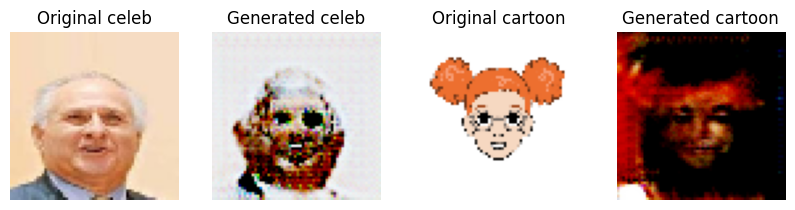

1/1 [==============================] - 0s 23ms/step


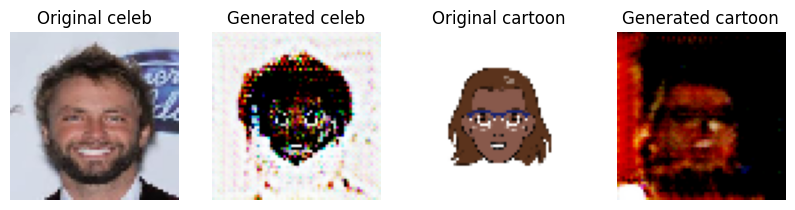

1/1 [==============================] - 0s 24ms/step


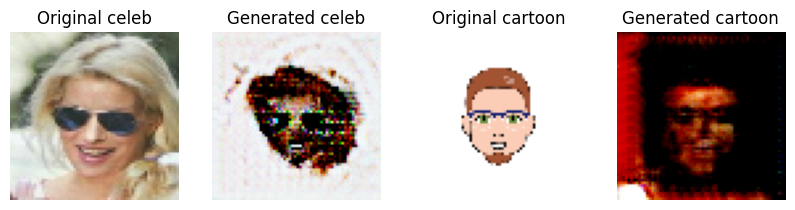

1/1 [==============================] - 0s 23ms/step


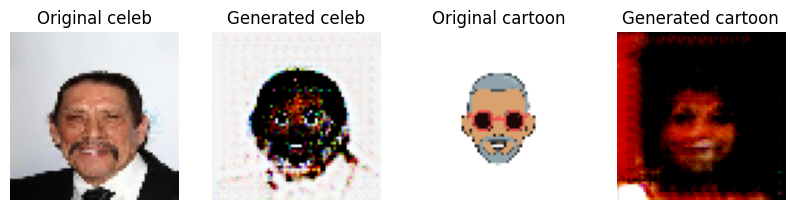

1/1 [==============================] - 0s 24ms/step


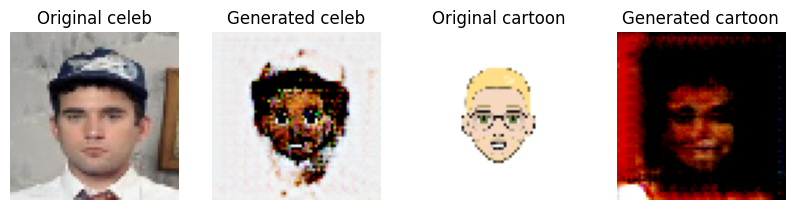

In [39]:
show_preds(CelebtoCartoon_gen,CartoontoCeleb_gen ,n_images=5)

## Conclusion
Although we were able to performed image translation celebrity to cartoon and cartoon to celebrity but results were okay.

We can get better results by improving the model in generator or discriminator.